In [1]:
#using Pkg
#Pkg.add(PackageSpec(name="JWAS",rev="master"))
#Pkg.add("RecipesBase")
#using RecipesBase

In [2]:
#methods(add_genotypes)

In [1]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
#using JWAS:misc               # utility functions
using JWAS.Datasets
using Distributions       
using Plots                   # package for plotting 
using CSV
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames

In [4]:
phenotypes = CSV.read("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/production_1_7_Complete_EXP_Health_WFI.dat", types=Dict(:ID => String, :SlaughterDate => String), delim = ' ',header=true, missingstrings=["NA"] )
phenotypes= dropmissing(phenotypes, :FinPenBatch)
phenotypes= dropmissing(phenotypes, :SlaughterDate)
phenotypes= dropmissing(phenotypes, :PreSlaughterWt)
first(phenotypes,10)

,ID,Cycle,BatchNum,Batch,Company,SowID,NurEnrich,QNurPenBatch,NurPenBatch
,String,Int64,Int64,String,String,String,String,String,String⍰
1,0001,1,1,1B,A,1B_1715,FALSE,1B_D04,1B_D04
2,0002,1,1,1B,A,1B_1642,FALSE,1B_D04,1B_D04
3,0004,1,1,1B,A,1B_2150,FALSE,1B_D04,1B_D04
4,0005,1,1,1B,A,1B_1980,FALSE,1B_D04,1B_D04
5,0007,1,1,1B,A,1B_2150,FALSE,1B_D04,1B_D04
6,0009,1,1,1B,A,1B_1902,FALSE,1B_D02,1B_D02
7,0010,1,1,1B,A,1B_1885,FALSE,1B_D02,1B_D02
8,0011,1,1,1B,A,1B_2097,FALSE,1B_D02,1B_D02
9,0012,1,1,1B,A,1B_1902,FALSE,1B_D02,1B_D02


In [5]:
LeanYield_model_equations = "LeanYield = intercept + Batch + SlaughterDate + SlaughterAge + PreSlaughterWt + FinPenBatch + SowID"
LeanYield_R=0.907069
LeanYield_model=build_model(LeanYield_model_equations,LeanYield_R);
set_covariate(LeanYield_model,"SlaughterAge")
set_covariate(LeanYield_model,"PreSlaughterWt")
LeanYield_G1=0.386214E-01
set_random(LeanYield_model,"FinPenBatch",LeanYield_G1)
LeanYield_G2=0.108502
set_random(LeanYield_model,"SowID",LeanYield_G2)

In [2]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end
@time M = readMatBin("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.gen.bin")

 30.073673 seconds (37.77 k allocations: 10.393 GiB, 0.06% gc time)


3205×435172 Array{Float64,2}:
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  2.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 1.0  1.0  0.0  1.0  2.0  0.0  0.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [7]:
rowID = vec(readdlm("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.ids.txt",String))
LeanYield_G3=1.11467
@time add_genotypes(LeanYield_model,M,LeanYield_G3,header=false, rowID=rowID)
#@time add_genotypes(Nur2ADG_model,"Geno_JWAS_impute.txt",Nur2ADG_G3,separator=' ')

The header (marker IDs) is set to 1,2,...,#markers
435172 markers on 3205 individuals were added.
 15.267543 seconds (6.93 M allocations: 15.937 GiB, 1.27% gc time)


In [8]:
@time LeanYield_outB=runMCMC(LeanYield_model,phenotypes,methods="BayesB", missing_phenotypes=true, Pi=0.999, estimateScale=true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.
Phenotypes for all traits included in the model for individual 0004 in the row 3 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0024 in the row 21 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0056 in the row 52 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0057 in the row 53 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0103 in the row 87 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0106 in the row 90 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0112 in the row 94 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 

running MCMC for BayesB...100%|█████████████████████████| Time: 5:34:01




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-5960X CPU @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.


20083.979070 seconds (90.30 G allocations: 2.045 TiB, 1.48% gc time)


Dict{Any,Any} with 8 entries:
  "marker effects"          => 435172×5 DataFrame. Omitted printing of 1 column…
  "EBV_LeanYield"           => 3205×3 DataFrame…
  "heritability"            => 1×3 DataFrame…
  "location parameters"     => 1219×5 DataFrame…
  "residual variance"       => 1×3 DataFrame…
  "ScaleEffectVar"          => 1×3 DataFrame…
  "genetic_variance"        => 1×3 DataFrame…
  "marker effects variance" => 1×3 DataFrame…

In [9]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration

,iteration,LeanYield
,Int64,Float64
1,1,0.466435
2,2,0.525688
3,3,0.487032
4,4,0.519703
5,5,0.513677
6,6,0.490565
7,7,0.510597
8,8,0.474849
9,9,0.550836


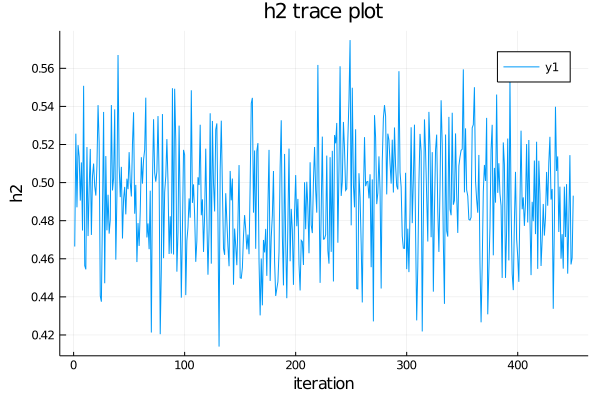

In [10]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [3]:
@time LeanYield_outB,LeanYield_winVarProps = GWAS("MCMC_samples_marker_effects_LeanYield.txt","/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt",
    M;header=true,window_size="0.25 Mb",threshold=0.001,output_winVarProps=false)

Compute the posterior probability of association of the genomic window that explains more than 0.001 of the total genetic variance.


running GWAS...100%|████████████████████████████████████| Time: 0:28:25


BoundsError: BoundsError: attempt to access (9375×13 DataFrame
│ Row  │ trait │ window │ chr    │ wStart    │ wEnd      │ start_SNP │ end_SNP   │ numSNP │ estimateGenVar │ stdGenVar   │ prGenVar │ WPPA       │ PPA_t     │
│      │ Int64 │ Int64  │ String │ Int64     │ Int64     │ Int64     │ Int64     │ Int64  │ Float64        │ Float64     │ Float64  │ Float64    │ Float64   │
├──────┼───────┼────────┼────────┼───────────┼───────────┼───────────┼───────────┼────────┼────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1    │ 1     │ 1103   │ 2      │ 1250000   │ 1500000   │ 1256452   │ 1481038   │ 10     │ 0.108392       │ 0.029224    │ 10.49    │ 1.0        │ 1.0       │
│ 2    │ 1     │ 3523   │ 6      │ 86500000  │ 86750000  │ 86511457  │ 86747331  │ 54     │ 0.0160969      │ 0.0134781   │ 1.55     │ 0.766667   │ 0.883333  │
│ 3    │ 1     │ 8711   │ 17     │ 32250000  │ 32500000  │ 32250013  │ 32497670  │ 67     │ 0.0116682      │ 0.0113342   │ 1.13     │ 0.702222   │ 0.822963  │
│ 4    │ 1     │ 1769   │ 3      │ 16250000  │ 16500000  │ 16254189  │ 16497764  │ 61     │ 0.0078721      │ 0.00903259  │ 0.76     │ 0.604444   │ 0.768333  │
│ 5    │ 1     │ 3100   │ 5      │ 85000000  │ 85250000  │ 85001640  │ 85247378  │ 52     │ 0.00949776     │ 0.0113087   │ 0.92     │ 0.597778   │ 0.734222  │
│ 6    │ 1     │ 1257   │ 2      │ 40000000  │ 40250000  │ 40001880  │ 40249873  │ 72     │ 0.00970574     │ 0.0122325   │ 0.93     │ 0.54       │ 0.701852  │
│ 7    │ 1     │ 3836   │ 6      │ 165000000 │ 165250000 │ 165000002 │ 165249700 │ 65     │ 0.00822046     │ 0.0105092   │ 0.8      │ 0.515556   │ 0.675238  │
│ 8    │ 1     │ 5103   │ 9      │ 49750000  │ 50000000  │ 49751613  │ 49997149  │ 41     │ 0.00864056     │ 0.0108011   │ 0.83     │ 0.506667   │ 0.654167  │
│ 9    │ 1     │ 3116   │ 5      │ 89000000  │ 89250000  │ 89004418  │ 89248034  │ 54     │ 0.00568087     │ 0.00788271  │ 0.55     │ 0.477778   │ 0.634568  │
│ 10   │ 1     │ 4250   │ 7      │ 97500000  │ 97750000  │ 97511738  │ 97744708  │ 39     │ 0.00627235     │ 0.00901347  │ 0.61     │ 0.471111   │ 0.618222  │
│ 11   │ 1     │ 5623   │ 10     │ 40500000  │ 40750000  │ 40506035  │ 40744949  │ 56     │ 0.00527672     │ 0.00858055  │ 0.51     │ 0.386667   │ 0.597172  │
│ 12   │ 1     │ 8854   │ 18     │ 4750000   │ 5000000   │ 4753607   │ 4995194   │ 62     │ 0.00378294     │ 0.00691978  │ 0.37     │ 0.355556   │ 0.577037  │
│ 13   │ 1     │ 2042   │ 3      │ 84500000  │ 84750000  │ 84501119  │ 84736454  │ 48     │ 0.00305712     │ 0.00571924  │ 0.3      │ 0.324444   │ 0.557607  │
│ 14   │ 1     │ 5087   │ 9      │ 45750000  │ 46000000  │ 45788235  │ 45991310  │ 39     │ 0.00317198     │ 0.00611533  │ 0.31     │ 0.324444   │ 0.540952  │
│ 15   │ 1     │ 5250   │ 9      │ 86750000  │ 87000000  │ 86750570  │ 86994798  │ 58     │ 0.00321097     │ 0.00652378  │ 0.31     │ 0.313333   │ 0.525778  │
│ 16   │ 1     │ 6217   │ 12     │ 40500000  │ 40750000  │ 40509146  │ 40743230  │ 67     │ 0.00373011     │ 0.00738538  │ 0.37     │ 0.311111   │ 0.512361  │
│ 17   │ 1     │ 5517   │ 10     │ 14000000  │ 14250000  │ 14026569  │ 14242539  │ 49     │ 0.00307613     │ 0.00620096  │ 0.3      │ 0.304444   │ 0.500131  │
│ 18   │ 1     │ 6159   │ 12     │ 26000000  │ 26250000  │ 26003111  │ 26243152  │ 58     │ 0.00457178     │ 0.0089657   │ 0.44     │ 0.304444   │ 0.489259  │
│ 19   │ 1     │ 2222   │ 3      │ 129500000 │ 129750000 │ 129502968 │ 129748906 │ 80     │ 0.00259797     │ 0.00544899  │ 0.25     │ 0.297778   │ 0.479181  │
│ 20   │ 1     │ 5521   │ 10     │ 15000000  │ 15250000  │ 15000580  │ 15247774  │ 53     │ 0.00482637     │ 0.00976616  │ 0.46     │ 0.286667   │ 0.469556  │
│ 21   │ 1     │ 1114   │ 2      │ 4250000   │ 4500000   │ 4263924   │ 4499434   │ 66     │ 0.0021346      │ 0.00485791  │ 0.21     │ 0.264444   │ 0.459788  │
│ 22   │ 1     │ 3837   │ 6      │ 165250000 │ 165500000 │ 165256903 │ 165497688 │ 53     │ 0.00341427     │ 0.00753176  │ 0.33     │ 0.262222   │ 0.450808  │
│ 23   │ 1     │ 5518   │ 10     │ 14250000  │ 14500000  │ 14250506  │ 14498330  │ 37     │ 0.00290982     │ 0.00622179  │ 0.28     │ 0.255556   │ 0.442319  │
│ 24   │ 1     │ 2190   │ 3      │ 121500000 │ 121750000 │ 121501725 │ 121747820 │ 61     │ 0.00341308     │ 0.0071949   │ 0.32     │ 0.253333   │ 0.434444  │
│ 25   │ 1     │ 4012   │ 7      │ 38000000  │ 38250000  │ 38001363  │ 38248090  │ 69     │ 0.00195259     │ 0.00450691  │ 0.19     │ 0.237778   │ 0.426578  │
│ 26   │ 1     │ 1262   │ 2      │ 41250000  │ 41500000  │ 41250750  │ 41497477  │ 69     │ 0.00270373     │ 0.00611995  │ 0.26     │ 0.233333   │ 0.419145  │
│ 27   │ 1     │ 3765   │ 6      │ 147250000 │ 147500000 │ 147252270 │ 147498631 │ 57     │ 0.00290789     │ 0.00666239  │ 0.28     │ 0.233333   │ 0.412263  │
│ 28   │ 1     │ 1263   │ 2      │ 41500000  │ 41750000  │ 41501296  │ 41747257  │ 62     │ 0.00247096     │ 0.0062344   │ 0.24     │ 0.22       │ 0.405397  │
│ 29   │ 1     │ 4190   │ 7      │ 82500000  │ 82750000  │ 82501326  │ 82746264  │ 42     │ 0.00220587     │ 0.00567465  │ 0.21     │ 0.208889   │ 0.398621  │
│ 30   │ 1     │ 10     │ 1      │ 2250000   │ 2500000   │ 2251625   │ 2499085   │ 72     │ 0.00133745     │ 0.0038585   │ 0.13     │ 0.193333   │ 0.391778  │
│ 31   │ 1     │ 6209   │ 12     │ 38500000  │ 38750000  │ 38504224  │ 38742446  │ 64     │ 0.00178316     │ 0.00475543  │ 0.17     │ 0.193333   │ 0.385376  │
│ 32   │ 1     │ 7252   │ 14     │ 29500000  │ 29750000  │ 29512631  │ 29746958  │ 37     │ 0.00187204     │ 0.00455792  │ 0.18     │ 0.193333   │ 0.379375  │
│ 33   │ 1     │ 1940   │ 3      │ 59000000  │ 59250000  │ 59001725  │ 59248580  │ 76     │ 0.00153646     │ 0.00397887  │ 0.15     │ 0.191111   │ 0.37367   │
│ 34   │ 1     │ 3839   │ 6      │ 165750000 │ 166000000 │ 165752774 │ 165997868 │ 46     │ 0.00203345     │ 0.00581053  │ 0.19     │ 0.191111   │ 0.368301  │
│ 35   │ 1     │ 3864   │ 7      │ 1000000   │ 1250000   │ 1006444   │ 1244664   │ 38     │ 0.00126898     │ 0.00340603  │ 0.12     │ 0.188889   │ 0.363175  │
│ 36   │ 1     │ 3943   │ 7      │ 20750000  │ 21000000  │ 20797858  │ 20995550  │ 51     │ 0.0016914      │ 0.00461941  │ 0.16     │ 0.188889   │ 0.358333  │
│ 37   │ 1     │ 644    │ 1      │ 161000000 │ 161250000 │ 161005018 │ 161247684 │ 52     │ 0.00190153     │ 0.00499174  │ 0.19     │ 0.182222   │ 0.353574  │
│ 38   │ 1     │ 8500   │ 16     │ 59500000  │ 59750000  │ 59516523  │ 59747430  │ 54     │ 0.00139798     │ 0.00368445  │ 0.13     │ 0.177778   │ 0.348947  │
│ 39   │ 1     │ 8877   │ 18     │ 10500000  │ 10750000  │ 10503298  │ 10746469  │ 38     │ 0.00213464     │ 0.00570926  │ 0.21     │ 0.175556   │ 0.344501  │
│ 40   │ 1     │ 2045   │ 3      │ 85250000  │ 85500000  │ 85251249  │ 85498518  │ 52     │ 0.00192413     │ 0.00536802  │ 0.19     │ 0.173333   │ 0.340222  │
│ 41   │ 1     │ 8761   │ 17     │ 44750000  │ 45000000  │ 44751346  │ 44997333  │ 69     │ 0.00153711     │ 0.00416456  │ 0.15     │ 0.173333   │ 0.336152  │
│ 42   │ 1     │ 1567   │ 2      │ 117750000 │ 118000000 │ 117750667 │ 117998711 │ 66     │ 0.00137438     │ 0.0038464   │ 0.13     │ 0.171111   │ 0.332222  │
│ 43   │ 1     │ 7657   │ 14     │ 130750000 │ 131000000 │ 130765062 │ 130998592 │ 55     │ 0.00154845     │ 0.00410104  │ 0.15     │ 0.171111   │ 0.328475  │
│ 44   │ 1     │ 1770   │ 3      │ 16500000  │ 16750000  │ 16501180  │ 16740560  │ 38     │ 0.00218669     │ 0.00602161  │ 0.21     │ 0.166667   │ 0.324798  │
│ 45   │ 1     │ 1593   │ 2      │ 124250000 │ 124500000 │ 124284301 │ 124497998 │ 51     │ 0.00126935     │ 0.00349524  │ 0.12     │ 0.164444   │ 0.321235  │
│ 46   │ 1     │ 1569   │ 2      │ 118250000 │ 118500000 │ 118251469 │ 118497478 │ 57     │ 0.00151625     │ 0.00452047  │ 0.15     │ 0.16       │ 0.317729  │
│ 47   │ 1     │ 3763   │ 6      │ 146750000 │ 147000000 │ 146782297 │ 146997249 │ 50     │ 0.00128264     │ 0.00398331  │ 0.13     │ 0.16       │ 0.314374  │
│ 48   │ 1     │ 4185   │ 7      │ 81250000  │ 81500000  │ 81257559  │ 81497332  │ 54     │ 0.00120467     │ 0.00362839  │ 0.12     │ 0.16       │ 0.311157  │
│ 49   │ 1     │ 1830   │ 3      │ 31500000  │ 31750000  │ 31500612  │ 31744765  │ 80     │ 0.00115        │ 0.00358437  │ 0.11     │ 0.157778   │ 0.308027  │
│ 50   │ 1     │ 3913   │ 7      │ 13250000  │ 13500000  │ 13307082  │ 13497808  │ 38     │ 0.00161307     │ 0.00455111  │ 0.15     │ 0.157778   │ 0.305022  │
│ 51   │ 1     │ 7762   │ 15     │ 15250000  │ 15500000  │ 15252369  │ 15499065  │ 51     │ 0.00186643     │ 0.0058528   │ 0.18     │ 0.157778   │ 0.302135  │
│ 52   │ 1     │ 3133   │ 5      │ 93250000  │ 93500000  │ 93250602  │ 93499756  │ 43     │ 0.00110127     │ 0.00331036  │ 0.11     │ 0.155556   │ 0.299316  │
│ 53   │ 1     │ 7177   │ 14     │ 10750000  │ 11000000  │ 10753275  │ 10984477  │ 47     │ 0.00150548     │ 0.0043909   │ 0.15     │ 0.155556   │ 0.296604  │
│ 54   │ 1     │ 5943   │ 11     │ 51250000  │ 51500000  │ 51270223  │ 51498207  │ 50     │ 0.001114       │ 0.00374969  │ 0.1      │ 0.153333   │ 0.293951  │
│ 55   │ 1     │ 1022   │ 1      │ 255500000 │ 255750000 │ 255500712 │ 255747528 │ 77     │ 0.000856716    │ 0.00256113  │ 0.08     │ 0.151111   │ 0.291354  │
│ 56   │ 1     │ 1130   │ 2      │ 8250000   │ 8500000   │ 8252416   │ 8494981   │ 34     │ 0.00106511     │ 0.00319209  │ 0.1      │ 0.148889   │ 0.28881   │
│ 57   │ 1     │ 2737   │ 4      │ 125250000 │ 125500000 │ 125251952 │ 125497843 │ 78     │ 0.00070359     │ 0.00202852  │ 0.07     │ 0.148889   │ 0.286355  │
│ 58   │ 1     │ 7906   │ 15     │ 51250000  │ 51500000  │ 51251038  │ 51496355  │ 60     │ 0.00115339     │ 0.00352875  │ 0.11     │ 0.148889   │ 0.283985  │
│ 59   │ 1     │ 3303   │ 6      │ 31000000  │ 31250000  │ 31001556  │ 31247336  │ 67     │ 0.00123927     │ 0.00381132  │ 0.12     │ 0.146667   │ 0.281657  │
│ 60   │ 1     │ 3941   │ 7      │ 20250000  │ 20500000  │ 20252636  │ 20498625  │ 69     │ 0.000913665    │ 0.00314017  │ 0.09     │ 0.144444   │ 0.27937   │
│ 61   │ 1     │ 5526   │ 10     │ 16250000  │ 16500000  │ 16278197  │ 16497027  │ 57     │ 0.000938389    │ 0.00291131  │ 0.09     │ 0.144444   │ 0.277158  │
│ 62   │ 1     │ 1023   │ 1      │ 255750000 │ 256000000 │ 255750564 │ 255999886 │ 75     │ 0.00090881     │ 0.00322853  │ 0.09     │ 0.142222   │ 0.274982  │
│ 63   │ 1     │ 1221   │ 2      │ 31000000  │ 31250000  │ 31014526  │ 31247445  │ 41     │ 0.00109143     │ 0.00366719  │ 0.11     │ 0.142222   │ 0.272875  │
│ 64   │ 1     │ 1688   │ 2      │ 148000000 │ 148250000 │ 148002378 │ 148247184 │ 61     │ 0.00103612     │ 0.00300134  │ 0.1      │ 0.142222   │ 0.270833  │
│ 65   │ 1     │ 3940   │ 7      │ 20000000  │ 20250000  │ 20001975  │ 20249027  │ 78     │ 0.00130092     │ 0.0044028   │ 0.13     │ 0.142222   │ 0.268855  │
│ 66   │ 1     │ 7708   │ 15     │ 1750000   │ 2000000   │ 1750092   │ 1999028   │ 68     │ 0.00109774     │ 0.00351594  │ 0.11     │ 0.142222   │ 0.266936  │
│ 67   │ 1     │ 8114   │ 15     │ 103500000 │ 103750000 │ 103542670 │ 103749156 │ 23     │ 0.00112209     │ 0.00353641  │ 0.11     │ 0.142222   │ 0.265075  │
│ 68   │ 1     │ 1610   │ 2      │ 128500000 │ 128750000 │ 128502492 │ 128748758 │ 64     │ 0.000905564    │ 0.00318261  │ 0.09     │ 0.137778   │ 0.263203  │
│ 69   │ 1     │ 6001   │ 11     │ 65750000  │ 66000000  │ 65752038  │ 65992889  │ 72     │ 0.000696472    │ 0.00225938  │ 0.07     │ 0.137778   │ 0.261385  │
│ 70   │ 1     │ 8342   │ 16     │ 20000000  │ 20250000  │ 20000699  │ 20246948  │ 75     │ 0.00118651     │ 0.00354969  │ 0.11     │ 0.137778   │ 0.259619  │
│ 71   │ 1     │ 8502   │ 16     │ 60000000  │ 60250000  │ 60001022  │ 60249553  │ 60     │ 0.00131811     │ 0.00415764  │ 0.13     │ 0.137778   │ 0.257903  │
│ 72   │ 1     │ 1026   │ 1      │ 256500000 │ 256750000 │ 256502461 │ 256749135 │ 73     │ 0.000953418    │ 0.0029856   │ 0.09     │ 0.135556   │ 0.256204  │
│ 73   │ 1     │ 8941   │ 18     │ 26500000  │ 26750000  │ 26509692  │ 26743944  │ 52     │ 0.00116836     │ 0.00411701  │ 0.11     │ 0.135556   │ 0.254551  │
│ 74   │ 1     │ 7251   │ 14     │ 29250000  │ 29500000  │ 29253702  │ 29496862  │ 51     │ 0.00102133     │ 0.00371036  │ 0.1      │ 0.133333   │ 0.252913  │
│ 75   │ 1     │ 1225   │ 2      │ 32000000  │ 32250000  │ 32013622  │ 32247564  │ 26     │ 0.00168469     │ 0.00522122  │ 0.16     │ 0.131111   │ 0.251289  │
│ 76   │ 1     │ 7186   │ 14     │ 13000000  │ 13250000  │ 13001454  │ 13248671  │ 63     │ 0.00116019     │ 0.00377529  │ 0.11     │ 0.131111   │ 0.249708  │
│ 77   │ 1     │ 7330   │ 14     │ 49000000  │ 49250000  │ 49012254  │ 49241766  │ 46     │ 0.00172999     │ 0.0063252   │ 0.17     │ 0.131111   │ 0.248167  │
│ 78   │ 1     │ 8624   │ 17     │ 10500000  │ 10750000  │ 10503838  │ 10746347  │ 58     │ 0.0013203      │ 0.00444149  │ 0.13     │ 0.131111   │ 0.246667  │
│ 79   │ 1     │ 2734   │ 4      │ 124500000 │ 124750000 │ 124502806 │ 124746318 │ 75     │ 0.0009034      │ 0.00285332  │ 0.09     │ 0.128889   │ 0.245176  │
│ 80   │ 1     │ 4846   │ 8      │ 124500000 │ 124750000 │ 124500243 │ 124749885 │ 66     │ 0.00116347     │ 0.00388734  │ 0.11     │ 0.128889   │ 0.243722  │
│ 81   │ 1     │ 1833   │ 3      │ 32250000  │ 32500000  │ 32250576  │ 32497290  │ 74     │ 0.000786871    │ 0.00281792  │ 0.08     │ 0.126667   │ 0.242277  │
│ 82   │ 1     │ 5929   │ 11     │ 47750000  │ 48000000  │ 47750961  │ 47997707  │ 43     │ 0.0012712      │ 0.00434561  │ 0.12     │ 0.126667   │ 0.240867  │
│ 83   │ 1     │ 3764   │ 6      │ 147000000 │ 147250000 │ 147000268 │ 147248914 │ 60     │ 0.000929788    │ 0.00359567  │ 0.09     │ 0.124444   │ 0.239465  │
│ 84   │ 1     │ 3887   │ 7      │ 6750000   │ 7000000   │ 6751979   │ 6988259   │ 70     │ 0.00134251     │ 0.00423678  │ 0.13     │ 0.124444   │ 0.238095  │
│ 85   │ 1     │ 4081   │ 7      │ 55250000  │ 55500000  │ 55250066  │ 55451289  │ 40     │ 0.000898996    │ 0.00338136  │ 0.09     │ 0.124444   │ 0.236758  │
│ 86   │ 1     │ 4503   │ 8      │ 38750000  │ 39000000  │ 38750202  │ 38997849  │ 54     │ 0.00110367     │ 0.00358029  │ 0.11     │ 0.124444   │ 0.235452  │
│ 87   │ 1     │ 3190   │ 6      │ 2750000   │ 3000000   │ 2750136   │ 2999538   │ 83     │ 0.000912145    │ 0.00318403  │ 0.09     │ 0.122222   │ 0.234151  │
│ 88   │ 1     │ 3766   │ 6      │ 147500000 │ 147750000 │ 147502252 │ 147746040 │ 29     │ 0.00118815     │ 0.00394946  │ 0.11     │ 0.122222   │ 0.232879  │
│ 89   │ 1     │ 5810   │ 11     │ 17750000  │ 18000000  │ 17752170  │ 17992589  │ 37     │ 0.000902755    │ 0.00308323  │ 0.09     │ 0.122222   │ 0.231635  │
│ 90   │ 1     │ 1978   │ 3      │ 68500000  │ 68750000  │ 68504086  │ 68748799  │ 58     │ 0.000873659    │ 0.0030333   │ 0.08     │ 0.12       │ 0.230395  │
│ 91   │ 1     │ 3762   │ 6      │ 146500000 │ 146750000 │ 146508971 │ 146737682 │ 39     │ 0.000961986    │ 0.00344714  │ 0.09     │ 0.12       │ 0.229182  │
│ 92   │ 1     │ 7332   │ 14     │ 49500000  │ 49750000  │ 49501046  │ 49746602  │ 73     │ 0.00104165     │ 0.00372489  │ 0.1      │ 0.12       │ 0.227995  │
│ 93   │ 1     │ 8545   │ 16     │ 70750000  │ 71000000  │ 70750882  │ 70999408  │ 58     │ 0.000892582    │ 0.00310263  │ 0.09     │ 0.12       │ 0.226834  │
│ 94   │ 1     │ 8728   │ 17     │ 36500000  │ 36750000  │ 36502725  │ 36749127  │ 79     │ 0.000699986    │ 0.00247044  │ 0.07     │ 0.12       │ 0.225697  │
│ 95   │ 1     │ 1261   │ 2      │ 41000000  │ 41250000  │ 41003027  │ 41249391  │ 57     │ 0.0012976      │ 0.0046466   │ 0.13     │ 0.117778   │ 0.224561  │
│ 96   │ 1     │ 1689   │ 2      │ 148250000 │ 148500000 │ 148250609 │ 148499924 │ 67     │ 0.000820148    │ 0.00286816  │ 0.08     │ 0.117778   │ 0.223449  │
│ 97   │ 1     │ 2783   │ 5      │ 5750000   │ 6000000   │ 5750829   │ 5995664   │ 58     │ 0.000831762    │ 0.00290231  │ 0.08     │ 0.117778   │ 0.22236   │
│ 98   │ 1     │ 3950   │ 7      │ 22500000  │ 22750000  │ 22501546  │ 22745850  │ 77     │ 0.00144801     │ 0.00506842  │ 0.14     │ 0.117778   │ 0.221293  │
│ 99   │ 1     │ 7325   │ 14     │ 47750000  │ 48000000  │ 47750613  │ 47999414  │ 75     │ 0.000904429    │ 0.00348544  │ 0.09     │ 0.117778   │ 0.220247  │
│ 100  │ 1     │ 7661   │ 14     │ 131750000 │ 132000000 │ 131750948 │ 131998574 │ 76     │ 0.000962136    │ 0.0031938   │ 0.09     │ 0.117778   │ 0.219222  │
│ 101  │ 1     │ 8724   │ 17     │ 35500000  │ 35750000  │ 35507474  │ 35749899  │ 72     │ 0.000723685    │ 0.00265568  │ 0.07     │ 0.117778   │ 0.218218  │
│ 102  │ 1     │ 8969   │ 18     │ 33500000  │ 33750000  │ 33501772  │ 33745070  │ 67     │ 0.00121856     │ 0.00420574  │ 0.12     │ 0.117778   │ 0.217233  │
│ 103  │ 1     │ 2173   │ 3      │ 117250000 │ 117500000 │ 117252698 │ 117498219 │ 63     │ 0.000594095    │ 0.00188784  │ 0.06     │ 0.115556   │ 0.216246  │
│ 104  │ 1     │ 3880   │ 7      │ 5000000   │ 5250000   │ 5000936   │ 5242217   │ 71     │ 0.000654533    │ 0.00218907  │ 0.06     │ 0.115556   │ 0.215278  │
│ 105  │ 1     │ 5326   │ 9      │ 105750000 │ 106000000 │ 105753423 │ 105990390 │ 63     │ 0.000695748    │ 0.00246455  │ 0.07     │ 0.115556   │ 0.214328  │
│ 106  │ 1     │ 5928   │ 11     │ 47500000  │ 47750000  │ 47501284  │ 47749336  │ 69     │ 0.00073057     │ 0.00270806  │ 0.07     │ 0.115556   │ 0.213396  │
│ 107  │ 1     │ 6330   │ 13     │ 7000000   │ 7250000   │ 7001076   │ 7247314   │ 56     │ 0.000682677    │ 0.002533    │ 0.07     │ 0.115556   │ 0.212482  │
│ 108  │ 1     │ 226    │ 1      │ 56250000  │ 56500000  │ 56253865  │ 56495788  │ 71     │ 0.000940891    │ 0.00333443  │ 0.09     │ 0.113333   │ 0.211564  │
│ 109  │ 1     │ 2736   │ 4      │ 125000000 │ 125250000 │ 125001553 │ 125244314 │ 70     │ 0.000682174    │ 0.00227143  │ 0.07     │ 0.113333   │ 0.210663  │
│ 110  │ 1     │ 2778   │ 5      │ 4500000   │ 4750000   │ 4502447   │ 4742278   │ 47     │ 0.000840714    │ 0.0031253   │ 0.08     │ 0.113333   │ 0.209778  │
│ 111  │ 1     │ 3102   │ 5      │ 85500000  │ 85750000  │ 85502963  │ 85749005  │ 39     │ 0.000806378    │ 0.00293052  │ 0.08     │ 0.113333   │ 0.208909  │
│ 112  │ 1     │ 5327   │ 9      │ 106000000 │ 106250000 │ 106003716 │ 106244970 │ 62     │ 0.000549393    │ 0.00178     │ 0.05     │ 0.113333   │ 0.208056  │
│ 113  │ 1     │ 7561   │ 14     │ 106750000 │ 107000000 │ 106750452 │ 106997098 │ 80     │ 0.00085919     │ 0.00310953  │ 0.08     │ 0.113333   │ 0.207217  │
│ 114  │ 1     │ 22     │ 1      │ 5250000   │ 5500000   │ 5252556   │ 5496049   │ 64     │ 0.000617195    │ 0.00220149  │ 0.06     │ 0.111111   │ 0.206374  │
│ 115  │ 1     │ 527    │ 1      │ 131750000 │ 132000000 │ 131767236 │ 131997760 │ 40     │ 0.000942768    │ 0.00348519  │ 0.09     │ 0.111111   │ 0.205546  │
│ 116  │ 1     │ 689    │ 1      │ 172250000 │ 172500000 │ 172252595 │ 172490512 │ 53     │ 0.000681826    │ 0.00248033  │ 0.07     │ 0.111111   │ 0.204732  │
│ 117  │ 1     │ 3487   │ 6      │ 77500000  │ 77750000  │ 77501237  │ 77749458  │ 54     │ 0.000581494    │ 0.00194741  │ 0.06     │ 0.111111   │ 0.203932  │
│ 118  │ 1     │ 4602   │ 8      │ 63500000  │ 63750000  │ 63502130  │ 63733341  │ 50     │ 0.00105029     │ 0.00414341  │ 0.1      │ 0.111111   │ 0.203145  │
│ 119  │ 1     │ 211    │ 1      │ 52500000  │ 52750000  │ 52502195  │ 52747227  │ 71     │ 0.000855313    │ 0.00318546  │ 0.08     │ 0.108889   │ 0.202353  │
│ 120  │ 1     │ 1991   │ 3      │ 71750000  │ 72000000  │ 71751189  │ 71999561  │ 45     │ 0.000768966    │ 0.00291316  │ 0.07     │ 0.108889   │ 0.201574  │
│ 121  │ 1     │ 3363   │ 6      │ 46000000  │ 46250000  │ 46001718  │ 46248115  │ 62     │ 0.000768485    │ 0.00292357  │ 0.08     │ 0.108889   │ 0.200808  │
│ 122  │ 1     │ 4926   │ 9      │ 5500000   │ 5750000   │ 5502581   │ 5749159   │ 69     │ 0.000776272    │ 0.00283483  │ 0.07     │ 0.108889   │ 0.200055  │
│ 123  │ 1     │ 210    │ 1      │ 52250000  │ 52500000  │ 52251037  │ 52499848  │ 67     │ 0.000918146    │ 0.00344921  │ 0.09     │ 0.106667   │ 0.199295  │
│ 124  │ 1     │ 3622   │ 6      │ 111250000 │ 111500000 │ 111252861 │ 111493922 │ 61     │ 0.000819276    │ 0.00290658  │ 0.08     │ 0.106667   │ 0.198548  │
│ 125  │ 1     │ 5086   │ 9      │ 45500000  │ 45750000  │ 45500218  │ 45707964  │ 36     │ 0.000728076    │ 0.00239603  │ 0.07     │ 0.106667   │ 0.197813  │
│ 126  │ 1     │ 5516   │ 10     │ 13750000  │ 14000000  │ 13750902  │ 13998342  │ 59     │ 0.000957331    │ 0.00353354  │ 0.09     │ 0.106667   │ 0.19709   │
│ 127  │ 1     │ 2156   │ 3      │ 113000000 │ 113250000 │ 113000985 │ 113249170 │ 62     │ 0.000708499    │ 0.00292829  │ 0.07     │ 0.104444   │ 0.19636   │
│ 128  │ 1     │ 3838   │ 6      │ 165500000 │ 165750000 │ 165502178 │ 165749990 │ 34     │ 0.00118642     │ 0.00410349  │ 0.12     │ 0.104444   │ 0.195642  │
│ 129  │ 1     │ 3912   │ 7      │ 13000000  │ 13250000  │ 13002660  │ 13233996  │ 44     │ 0.000523231    │ 0.00188563  │ 0.05     │ 0.104444   │ 0.194935  │
│ 130  │ 1     │ 5745   │ 11     │ 1500000   │ 1750000   │ 1505743   │ 1748859   │ 59     │ 0.000691823    │ 0.00267879  │ 0.07     │ 0.104444   │ 0.194239  │
│ 131  │ 1     │ 8713   │ 17     │ 32750000  │ 33000000  │ 32753792  │ 32998532  │ 71     │ 0.00136862     │ 0.00501335  │ 0.13     │ 0.104444   │ 0.193554  │
│ 132  │ 1     │ 2319   │ 4      │ 20750000  │ 21000000  │ 20751837  │ 20998807  │ 83     │ 0.000659271    │ 0.00244776  │ 0.06     │ 0.102222   │ 0.192862  │
│ 133  │ 1     │ 3052   │ 5      │ 73000000  │ 73250000  │ 73002857  │ 73247527  │ 68     │ 0.000387954    │ 0.00138937  │ 0.04     │ 0.102222   │ 0.19218   │
│ 134  │ 1     │ 4205   │ 7      │ 86250000  │ 86500000  │ 86250391  │ 86498369  │ 61     │ 0.00060973     │ 0.00219454  │ 0.06     │ 0.102222   │ 0.191509  │
│ 135  │ 1     │ 8523   │ 16     │ 65250000  │ 65500000  │ 65257320  │ 65495813  │ 65     │ 0.00079289     │ 0.00309314  │ 0.08     │ 0.102222   │ 0.190848  │
│ 136  │ 1     │ 8729   │ 17     │ 36750000  │ 37000000  │ 36751194  │ 36997342  │ 71     │ 0.000591044    │ 0.00209112  │ 0.06     │ 0.102222   │ 0.190196  │
│ 137  │ 1     │ 495    │ 1      │ 123750000 │ 124000000 │ 123750328 │ 123995795 │ 57     │ 0.000530865    │ 0.0021411   │ 0.05     │ 0.1        │ 0.189538  │
│ 138  │ 1     │ 1133   │ 2      │ 9000000   │ 9250000   │ 9003683   │ 9244693   │ 67     │ 0.000550539    │ 0.00224914  │ 0.05     │ 0.1        │ 0.188889  │
│ 139  │ 1     │ 1939   │ 3      │ 58750000  │ 59000000  │ 58750776  │ 58995587  │ 68     │ 0.000757121    │ 0.00290672  │ 0.07     │ 0.1        │ 0.188249  │
│ 140  │ 1     │ 3099   │ 5      │ 84750000  │ 85000000  │ 84751492  │ 84996048  │ 66     │ 0.000913846    │ 0.00344371  │ 0.09     │ 0.1        │ 0.187619  │
│ 141  │ 1     │ 6547   │ 13     │ 61250000  │ 61500000  │ 61252570  │ 61499304  │ 69     │ 0.000744576    │ 0.00313287  │ 0.07     │ 0.1        │ 0.186998  │
│ 142  │ 1     │ 8194   │ 15     │ 123500000 │ 123750000 │ 123503164 │ 123742609 │ 67     │ 0.000650403    │ 0.00232207  │ 0.06     │ 0.1        │ 0.186385  │
│ 143  │ 1     │ 646    │ 1      │ 161500000 │ 161750000 │ 161500456 │ 161747004 │ 66     │ 0.000589322    │ 0.00228438  │ 0.06     │ 0.0977778  │ 0.185765  │
│ 144  │ 1     │ 1083   │ 1      │ 270750000 │ 271000000 │ 270751039 │ 270998751 │ 66     │ 0.000455972    │ 0.00172249  │ 0.04     │ 0.0977778  │ 0.185154  │
│ 145  │ 1     │ 1646   │ 2      │ 137500000 │ 137750000 │ 137504477 │ 137749278 │ 71     │ 0.000499558    │ 0.00179999  │ 0.05     │ 0.0977778  │ 0.184552  │
│ 146  │ 1     │ 3117   │ 5      │ 89250000  │ 89500000  │ 89251430  │ 89499001  │ 50     │ 0.000870794    │ 0.00333744  │ 0.08     │ 0.0977778  │ 0.183957  │
│ 147  │ 1     │ 4251   │ 7      │ 97750000  │ 98000000  │ 97752476  │ 97988976  │ 47     │ 0.00120599     │ 0.00449045  │ 0.12     │ 0.0977778  │ 0.183371  │
│ 148  │ 1     │ 266    │ 1      │ 66250000  │ 66500000  │ 66253449  │ 66499506  │ 48     │ 0.000725666    │ 0.00301377  │ 0.07     │ 0.0955556  │ 0.182778  │
│ 149  │ 1     │ 2043   │ 3      │ 84750000  │ 85000000  │ 84754476  │ 84996056  │ 57     │ 0.000856368    │ 0.00354473  │ 0.08     │ 0.0955556  │ 0.182192  │
│ 150  │ 1     │ 4536   │ 8      │ 47000000  │ 47250000  │ 47008946  │ 47222064  │ 16     │ 0.00126886     │ 0.00490384  │ 0.12     │ 0.0955556  │ 0.181615  │
│ 151  │ 1     │ 6107   │ 12     │ 13000000  │ 13250000  │ 13008602  │ 13244104  │ 76     │ 0.000630764    │ 0.00243392  │ 0.06     │ 0.0955556  │ 0.181045  │
│ 152  │ 1     │ 213    │ 1      │ 53000000  │ 53250000  │ 53000537  │ 53248919  │ 67     │ 0.000541222    │ 0.00204835  │ 0.05     │ 0.0933333  │ 0.180468  │
│ 153  │ 1     │ 1113   │ 2      │ 4000000   │ 4250000   │ 4012479   │ 4249741   │ 49     │ 0.000637543    │ 0.00247086  │ 0.06     │ 0.0933333  │ 0.179898  │
│ 154  │ 1     │ 1504   │ 2      │ 102000000 │ 102250000 │ 102000568 │ 102247512 │ 69     │ 0.000485278    │ 0.00199135  │ 0.05     │ 0.0933333  │ 0.179336  │
│ 155  │ 1     │ 4509   │ 8      │ 40250000  │ 40500000  │ 40252688  │ 40498539  │ 62     │ 0.000602936    │ 0.00239355  │ 0.06     │ 0.0933333  │ 0.178781  │
│ 156  │ 1     │ 4693   │ 8      │ 86250000  │ 86500000  │ 86251027  │ 86498022  │ 65     │ 0.000509289    │ 0.00194024  │ 0.05     │ 0.0933333  │ 0.178234  │
│ 157  │ 1     │ 6319   │ 13     │ 4250000   │ 4500000   │ 4252980   │ 4499881   │ 46     │ 0.000569005    │ 0.00224153  │ 0.05     │ 0.0933333  │ 0.177693  │
│ 158  │ 1     │ 20     │ 1      │ 4750000   │ 5000000   │ 4751837   │ 4992802   │ 71     │ 0.000754527    │ 0.00320629  │ 0.07     │ 0.0911111  │ 0.177145  │
│ 159  │ 1     │ 1048   │ 1      │ 262000000 │ 262250000 │ 262012437 │ 262247408 │ 49     │ 0.000537936    │ 0.00200837  │ 0.05     │ 0.0911111  │ 0.176604  │
│ 160  │ 1     │ 4186   │ 7      │ 81500000  │ 81750000  │ 81501936  │ 81746079  │ 58     │ 0.000798099    │ 0.00360617  │ 0.08     │ 0.0911111  │ 0.176069  │
│ 161  │ 1     │ 4887   │ 8      │ 134750000 │ 135000000 │ 134750037 │ 134996704 │ 81     │ 0.000695676    │ 0.00275101  │ 0.07     │ 0.0911111  │ 0.175542  │
│ 162  │ 1     │ 5089   │ 9      │ 46250000  │ 46500000  │ 46252837  │ 46497649  │ 40     │ 0.000755695    │ 0.00294205  │ 0.07     │ 0.0911111  │ 0.175021  │
│ 163  │ 1     │ 5828   │ 11     │ 22250000  │ 22500000  │ 22255079  │ 22493060  │ 69     │ 0.000573975    │ 0.00237824  │ 0.06     │ 0.0911111  │ 0.174506  │
│ 164  │ 1     │ 7655   │ 14     │ 130250000 │ 130500000 │ 130250507 │ 130498899 │ 68     │ 0.000615402    │ 0.00230928  │ 0.06     │ 0.0911111  │ 0.173997  │
│ 165  │ 1     │ 8083   │ 15     │ 95750000  │ 96000000  │ 95755967  │ 95987879  │ 44     │ 0.000645217    │ 0.00242543  │ 0.06     │ 0.0911111  │ 0.173495  │
│ 166  │ 1     │ 648    │ 1      │ 162000000 │ 162250000 │ 162004596 │ 162247741 │ 47     │ 0.00070896     │ 0.00297955  │ 0.07     │ 0.0888889  │ 0.172985  │
│ 167  │ 1     │ 1609   │ 2      │ 128250000 │ 128500000 │ 128251673 │ 128496519 │ 80     │ 0.000555615    │ 0.00213893  │ 0.05     │ 0.0888889  │ 0.172482  │
│ 168  │ 1     │ 1624   │ 2      │ 132000000 │ 132250000 │ 132004620 │ 132249552 │ 54     │ 0.000456698    │ 0.00189655  │ 0.04     │ 0.0888889  │ 0.171984  │
│ 169  │ 1     │ 2223   │ 3      │ 129750000 │ 130000000 │ 129753138 │ 129998184 │ 46     │ 0.000694391    │ 0.00268512  │ 0.07     │ 0.0888889  │ 0.171492  │
│ 170  │ 1     │ 5249   │ 9      │ 86500000  │ 86750000  │ 86506981  │ 86748470  │ 52     │ 0.000759301    │ 0.00287928  │ 0.07     │ 0.0888889  │ 0.171007  │
│ 171  │ 1     │ 5699   │ 10     │ 59500000  │ 59750000  │ 59500973  │ 59749071  │ 77     │ 0.00057775     │ 0.00229419  │ 0.06     │ 0.0888889  │ 0.170526  │
│ 172  │ 1     │ 53     │ 1      │ 13000000  │ 13250000  │ 13002602  │ 13246655  │ 71     │ 0.000535195    │ 0.00217059  │ 0.05     │ 0.0866667  │ 0.170039  │
│ 173  │ 1     │ 227    │ 1      │ 56500000  │ 56750000  │ 56500036  │ 56738549  │ 66     │ 0.00058978     │ 0.00267761  │ 0.06     │ 0.0866667  │ 0.169557  │
│ 174  │ 1     │ 265    │ 1      │ 66000000  │ 66250000  │ 66002610  │ 66248474  │ 52     │ 0.000756947    │ 0.00322017  │ 0.07     │ 0.0866667  │ 0.16908   │
│ 175  │ 1     │ 3011   │ 5      │ 62750000  │ 63000000  │ 62753540  │ 62999146  │ 63     │ 0.000708753    │ 0.00272155  │ 0.07     │ 0.0866667  │ 0.16861   │
│ 176  │ 1     │ 5118   │ 9      │ 53500000  │ 53750000  │ 53500816  │ 53729240  │ 43     │ 0.000647949    │ 0.00258016  │ 0.06     │ 0.0866667  │ 0.168144  │
│ 177  │ 1     │ 6373   │ 13     │ 17750000  │ 18000000  │ 17801164  │ 17999537  │ 56     │ 0.000533836    │ 0.00237485  │ 0.05     │ 0.0866667  │ 0.167684  │
│ 178  │ 1     │ 363    │ 1      │ 90500000  │ 90750000  │ 90527587  │ 90748703  │ 48     │ 0.000452782    │ 0.00179496  │ 0.04     │ 0.0844444  │ 0.167216  │
│ 179  │ 1     │ 3024   │ 5      │ 66000000  │ 66250000  │ 66000830  │ 66244036  │ 48     │ 0.000671498    │ 0.00279979  │ 0.06     │ 0.0844444  │ 0.166754  │
│ 180  │ 1     │ 3439   │ 6      │ 65500000  │ 65750000  │ 65500129  │ 65747698  │ 81     │ 0.000620221    │ 0.00255891  │ 0.06     │ 0.0844444  │ 0.166296  │
│ 181  │ 1     │ 4209   │ 7      │ 87250000  │ 87500000  │ 87251891  │ 87498269  │ 66     │ 0.000858799    │ 0.00356012  │ 0.08     │ 0.0844444  │ 0.165844  │
│ 182  │ 1     │ 6241   │ 12     │ 46500000  │ 46750000  │ 46502166  │ 46745165  │ 61     │ 0.000522688    │ 0.00203965  │ 0.05     │ 0.0844444  │ 0.165397  │
│ 183  │ 1     │ 7689   │ 14     │ 138750000 │ 139000000 │ 138751566 │ 138998054 │ 57     │ 0.000500766    │ 0.00222409  │ 0.05     │ 0.0844444  │ 0.164954  │
│ 184  │ 1     │ 7979   │ 15     │ 69750000  │ 70000000  │ 69753247  │ 69997306  │ 24     │ 0.000729143    │ 0.00280568  │ 0.07     │ 0.0844444  │ 0.164517  │
│ 185  │ 1     │ 8509   │ 16     │ 61750000  │ 62000000  │ 61761012  │ 61999546  │ 49     │ 0.000454649    │ 0.00184142  │ 0.04     │ 0.0844444  │ 0.164084  │
│ 186  │ 1     │ 8524   │ 16     │ 65500000  │ 65750000  │ 65500900  │ 65747469  │ 53     │ 0.000537216    │ 0.00230234  │ 0.05     │ 0.0844444  │ 0.163656  │
│ 187  │ 1     │ 8727   │ 17     │ 36250000  │ 36500000  │ 36252621  │ 36498120  │ 67     │ 0.000394882    │ 0.001622    │ 0.04     │ 0.0844444  │ 0.163232  │
│ 188  │ 1     │ 8779   │ 17     │ 49250000  │ 49500000  │ 49273393  │ 49499301  │ 59     │ 0.000554476    │ 0.00260831  │ 0.05     │ 0.0844444  │ 0.162813  │
│ 189  │ 1     │ 160    │ 1      │ 39750000  │ 40000000  │ 39750594  │ 39991606  │ 73     │ 0.000446527    │ 0.00195391  │ 0.04     │ 0.0822222  │ 0.162387  │
│ 190  │ 1     │ 643    │ 1      │ 160750000 │ 161000000 │ 160751707 │ 160987711 │ 28     │ 0.0010463      │ 0.00436195  │ 0.1      │ 0.0822222  │ 0.161965  │
│ 191  │ 1     │ 3346   │ 6      │ 41750000  │ 42000000  │ 41753079  │ 41999273  │ 76     │ 0.000411184    │ 0.00149667  │ 0.04     │ 0.0822222  │ 0.161547  │
│ 192  │ 1     │ 3719   │ 6      │ 135750000 │ 136000000 │ 135752826 │ 135998609 │ 76     │ 0.000502956    │ 0.00210688  │ 0.05     │ 0.0822222  │ 0.161134  │
│ 193  │ 1     │ 4023   │ 7      │ 40750000  │ 41000000  │ 40752825  │ 40999948  │ 71     │ 0.000440028    │ 0.00196026  │ 0.04     │ 0.0822222  │ 0.160725  │
│ 194  │ 1     │ 4208   │ 7      │ 87000000  │ 87250000  │ 87003720  │ 87246599  │ 73     │ 0.000507116    │ 0.00195568  │ 0.05     │ 0.0822222  │ 0.160321  │
│ 195  │ 1     │ 5527   │ 10     │ 16500000  │ 16750000  │ 16500082  │ 16748027  │ 64     │ 0.000567538    │ 0.00283444  │ 0.05     │ 0.0822222  │ 0.15992   │
│ 196  │ 1     │ 7331   │ 14     │ 49250000  │ 49500000  │ 49252292  │ 49498919  │ 52     │ 0.000823283    │ 0.00406511  │ 0.08     │ 0.0822222  │ 0.159524  │
│ 197  │ 1     │ 7562   │ 14     │ 107000000 │ 107250000 │ 107000498 │ 107247134 │ 65     │ 0.000521537    │ 0.00240669  │ 0.05     │ 0.0822222  │ 0.159131  │
│ 198  │ 1     │ 8038   │ 15     │ 84500000  │ 84750000  │ 84500740  │ 84743260  │ 49     │ 0.000461443    │ 0.00196096  │ 0.04     │ 0.0822222  │ 0.158743  │
│ 199  │ 1     │ 638    │ 1      │ 159500000 │ 159750000 │ 159500733 │ 159748821 │ 57     │ 0.000567345    │ 0.00260862  │ 0.05     │ 0.08       │ 0.158347  │
│ 200  │ 1     │ 647    │ 1      │ 161750000 │ 162000000 │ 161753812 │ 161999307 │ 50     │ 0.000692886    │ 0.00327058  │ 0.07     │ 0.08       │ 0.157956  │
│ 201  │ 1     │ 2044   │ 3      │ 85000000  │ 85250000  │ 85003412  │ 85246599  │ 60     │ 0.000554685    │ 0.0025753   │ 0.05     │ 0.08       │ 0.157568  │
│ 202  │ 1     │ 3027   │ 5      │ 66750000  │ 67000000  │ 66751793  │ 66997593  │ 68     │ 0.000436724    │ 0.00170184  │ 0.04     │ 0.08       │ 0.157184  │
│ 203  │ 1     │ 3707   │ 6      │ 132750000 │ 133000000 │ 132833417 │ 132999380 │ 35     │ 0.000581141    │ 0.00233446  │ 0.06     │ 0.08       │ 0.156804  │
│ 204  │ 1     │ 3921   │ 7      │ 15250000  │ 15500000  │ 15251350  │ 15498060  │ 76     │ 0.000421311    │ 0.00179534  │ 0.04     │ 0.08       │ 0.156427  │
│ 205  │ 1     │ 4539   │ 8      │ 47750000  │ 48000000  │ 47756511  │ 47999603  │ 36     │ 0.000724178    │ 0.00330678  │ 0.07     │ 0.08       │ 0.156054  │
│ 206  │ 1     │ 4636   │ 8      │ 72000000  │ 72250000  │ 72000801  │ 72249242  │ 74     │ 0.000484059    │ 0.00231724  │ 0.05     │ 0.08       │ 0.155685  │
│ 207  │ 1     │ 5704   │ 10     │ 60750000  │ 61000000  │ 60750674  │ 60999298  │ 86     │ 0.000505168    │ 0.00214745  │ 0.05     │ 0.08       │ 0.155319  │
│ 208  │ 1     │ 7962   │ 15     │ 65500000  │ 65750000  │ 65507385  │ 65749904  │ 45     │ 0.000650644    │ 0.00298427  │ 0.06     │ 0.08       │ 0.154957  │
│ 209  │ 1     │ 7981   │ 15     │ 70250000  │ 70500000  │ 70266600  │ 70498850  │ 31     │ 0.00047149     │ 0.00197904  │ 0.05     │ 0.08       │ 0.154599  │
│ 210  │ 1     │ 8622   │ 17     │ 10000000  │ 10250000  │ 10004193  │ 10247857  │ 62     │ 0.000515691    │ 0.00248646  │ 0.05     │ 0.08       │ 0.154243  │
│ 211  │ 1     │ 8623   │ 17     │ 10250000  │ 10500000  │ 10250619  │ 10498558  │ 81     │ 0.000484059    │ 0.00190642  │ 0.05     │ 0.08       │ 0.153892  │
│ 212  │ 1     │ 19     │ 1      │ 4500000   │ 4750000   │ 4507516   │ 4749689   │ 65     │ 0.000537287    │ 0.00233303  │ 0.05     │ 0.0777778  │ 0.153532  │
│ 213  │ 1     │ 1025   │ 1      │ 256250000 │ 256500000 │ 256251508 │ 256499525 │ 58     │ 0.000449481    │ 0.00191834  │ 0.04     │ 0.0777778  │ 0.153177  │
│ 214  │ 1     │ 1227   │ 2      │ 32500000  │ 32750000  │ 32507800  │ 32745604  │ 54     │ 0.000680861    │ 0.003117    │ 0.07     │ 0.0777778  │ 0.152825  │
│ 215  │ 1     │ 1888   │ 3      │ 46000000  │ 46250000  │ 46003398  │ 46241894  │ 53     │ 0.000503179    │ 0.00214952  │ 0.05     │ 0.0777778  │ 0.152475  │
│ 216  │ 1     │ 1941   │ 3      │ 59250000  │ 59500000  │ 59252665  │ 59499098  │ 65     │ 0.000583905    │ 0.00270538  │ 0.06     │ 0.0777778  │ 0.15213   │
│ 217  │ 1     │ 1981   │ 3      │ 69250000  │ 69500000  │ 69251402  │ 69494738  │ 57     │ 0.000428949    │ 0.0018799   │ 0.04     │ 0.0777778  │ 0.151787  │
│ 218  │ 1     │ 2644   │ 4      │ 102000000 │ 102250000 │ 102003131 │ 102239313 │ 62     │ 0.000281944    │ 0.00112546  │ 0.03     │ 0.0777778  │ 0.151448  │
│ 219  │ 1     │ 2669   │ 4      │ 108250000 │ 108500000 │ 108259860 │ 108498799 │ 62     │ 0.000601936    │ 0.00286377  │ 0.06     │ 0.0777778  │ 0.151111  │
│ 220  │ 1     │ 2741   │ 4      │ 126250000 │ 126500000 │ 126250406 │ 126495961 │ 82     │ 0.000362147    │ 0.00163234  │ 0.04     │ 0.0777778  │ 0.150778  │
│ 221  │ 1     │ 2882   │ 5      │ 30500000  │ 30750000  │ 30505943  │ 30746165  │ 61     │ 0.00041727     │ 0.0018323   │ 0.04     │ 0.0777778  │ 0.150447  │
│ 222  │ 1     │ 4345   │ 7      │ 121250000 │ 121500000 │ 121252610 │ 121499343 │ 40     │ 0.000647358    │ 0.00284412  │ 0.06     │ 0.0777778  │ 0.15012   │
│ 223  │ 1     │ 4540   │ 8      │ 48000000  │ 48250000  │ 48005002  │ 48246935  │ 57     │ 0.000553606    │ 0.00255262  │ 0.05     │ 0.0777778  │ 0.149796  │
│ 224  │ 1     │ 4769   │ 8      │ 105250000 │ 105500000 │ 105256894 │ 105497546 │ 59     │ 0.00047629     │ 0.00211126  │ 0.05     │ 0.0777778  │ 0.149474  │
│ 225  │ 1     │ 7310   │ 14     │ 44000000  │ 44250000  │ 44001184  │ 44248550  │ 68     │ 0.000603284    │ 0.00270208  │ 0.06     │ 0.0777778  │ 0.149156  │
│ 226  │ 1     │ 7658   │ 14     │ 131000000 │ 131250000 │ 131002943 │ 131247633 │ 42     │ 0.00062418     │ 0.00285683  │ 0.06     │ 0.0777778  │ 0.14884   │
│ 227  │ 1     │ 7734   │ 15     │ 8250000   │ 8500000   │ 8252185   │ 8499221   │ 59     │ 0.000445708    │ 0.00252516  │ 0.04     │ 0.0777778  │ 0.148527  │
│ 228  │ 1     │ 8115   │ 15     │ 103750000 │ 104000000 │ 103751874 │ 103995883 │ 49     │ 0.00047065     │ 0.00196531  │ 0.05     │ 0.0777778  │ 0.148216  │
│ 229  │ 1     │ 8865   │ 18     │ 7500000   │ 7750000   │ 7500197   │ 7747556   │ 46     │ 0.000440131    │ 0.00185992  │ 0.04     │ 0.0777778  │ 0.147909  │
│ 230  │ 1     │ 8878   │ 18     │ 10750000  │ 11000000  │ 10752810  │ 10998919  │ 53     │ 0.000533064    │ 0.00219834  │ 0.05     │ 0.0777778  │ 0.147604  │
│ 231  │ 1     │ 23     │ 1      │ 5500000   │ 5750000   │ 5500246   │ 5748954   │ 53     │ 0.000408146    │ 0.00162864  │ 0.04     │ 0.0755556  │ 0.147292  │
│ 232  │ 1     │ 223    │ 1      │ 55500000  │ 55750000  │ 55501807  │ 55748824  │ 64     │ 0.000527047    │ 0.00237485  │ 0.05     │ 0.0755556  │ 0.146983  │
│ 233  │ 1     │ 1007   │ 1      │ 251750000 │ 252000000 │ 251754048 │ 251996484 │ 65     │ 0.000462837    │ 0.00197979  │ 0.04     │ 0.0755556  │ 0.146676  │
│ 234  │ 1     │ 1594   │ 2      │ 124500000 │ 124750000 │ 124500103 │ 124737286 │ 51     │ 0.000642899    │ 0.00293261  │ 0.06     │ 0.0755556  │ 0.146372  │
│ 235  │ 1     │ 1831   │ 3      │ 31750000  │ 32000000  │ 31751303  │ 31998911  │ 50     │ 0.000424648    │ 0.00183311  │ 0.04     │ 0.0755556  │ 0.146071  │
│ 236  │ 1     │ 2015   │ 3      │ 77750000  │ 78000000  │ 77782543  │ 77981821  │ 19     │ 0.000531671    │ 0.00224253  │ 0.05     │ 0.0755556  │ 0.145772  │
│ 237  │ 1     │ 3055   │ 5      │ 73750000  │ 74000000  │ 73753773  │ 73999216  │ 44     │ 0.000577033    │ 0.00265264  │ 0.05     │ 0.0755556  │ 0.145476  │
│ 238  │ 1     │ 3350   │ 6      │ 42750000  │ 43000000  │ 42752727  │ 42998265  │ 71     │ 0.000394575    │ 0.00169477  │ 0.04     │ 0.0755556  │ 0.145182  │
│ 239  │ 1     │ 3946   │ 7      │ 21500000  │ 21750000  │ 21504835  │ 21749623  │ 56     │ 0.000428685    │ 0.00180113  │ 0.04     │ 0.0755556  │ 0.144891  │
│ 240  │ 1     │ 4153   │ 7      │ 73250000  │ 73500000  │ 73251935  │ 73491596  │ 42     │ 0.000646818    │ 0.00265705  │ 0.06     │ 0.0755556  │ 0.144602  │
│ 241  │ 1     │ 5495   │ 10     │ 8500000   │ 8750000   │ 8500372   │ 8743431   │ 78     │ 0.000609767    │ 0.00276995  │ 0.06     │ 0.0755556  │ 0.144315  │
│ 242  │ 1     │ 7309   │ 14     │ 43750000  │ 44000000  │ 43752308  │ 43996993  │ 73     │ 0.000449087    │ 0.00196075  │ 0.04     │ 0.0755556  │ 0.144031  │
│ 243  │ 1     │ 7656   │ 14     │ 130500000 │ 130750000 │ 130500895 │ 130749289 │ 61     │ 0.000397261    │ 0.00194046  │ 0.04     │ 0.0755556  │ 0.143749  │
│ 244  │ 1     │ 7980   │ 15     │ 70000000  │ 70250000  │ 70009529  │ 70246574  │ 17     │ 0.000703208    │ 0.00318037  │ 0.07     │ 0.0755556  │ 0.14347   │
│ 245  │ 1     │ 8568   │ 16     │ 76500000  │ 76750000  │ 76502479  │ 76746821  │ 55     │ 0.000515882    │ 0.00208168  │ 0.05     │ 0.0755556  │ 0.143193  │
│ 246  │ 1     │ 8915   │ 18     │ 20000000  │ 20250000  │ 20007968  │ 20229772  │ 30     │ 0.000443753    │ 0.00175565  │ 0.04     │ 0.0755556  │ 0.142918  │
│ 247  │ 1     │ 9      │ 1      │ 2000000   │ 2250000   │ 2000553   │ 2244388   │ 68     │ 0.000376456    │ 0.00170742  │ 0.04     │ 0.0733333  │ 0.142636  │
│ 248  │ 1     │ 2479   │ 4      │ 60750000  │ 61000000  │ 60750431  │ 60988280  │ 61     │ 0.000452405    │ 0.0023516   │ 0.04     │ 0.0733333  │ 0.142357  │
│ 249  │ 1     │ 2614   │ 4      │ 94500000  │ 94750000  │ 94501634  │ 94743467  │ 51     │ 0.000371629    │ 0.0016946   │ 0.04     │ 0.0733333  │ 0.142079  │
│ 250  │ 1     │ 2721   │ 4      │ 121250000 │ 121500000 │ 121257311 │ 121498510 │ 60     │ 0.000326439    │ 0.00140528  │ 0.03     │ 0.0733333  │ 0.141804  │
│ 251  │ 1     │ 3488   │ 6      │ 77750000  │ 78000000  │ 77756039  │ 77994120  │ 74     │ 0.000427579    │ 0.00199627  │ 0.04     │ 0.0733333  │ 0.141532  │
│ 252  │ 1     │ 3528   │ 6      │ 87750000  │ 88000000  │ 87750496  │ 87998848  │ 59     │ 0.000347985    │ 0.00161847  │ 0.03     │ 0.0733333  │ 0.141261  │
│ 253  │ 1     │ 3827   │ 6      │ 162750000 │ 163000000 │ 162752157 │ 162935527 │ 45     │ 0.000402201    │ 0.00179685  │ 0.04     │ 0.0733333  │ 0.140993  │
│ 254  │ 1     │ 3872   │ 7      │ 3000000   │ 3250000   │ 3001119   │ 3249660   │ 41     │ 0.000475165    │ 0.00222815  │ 0.05     │ 0.0733333  │ 0.140726  │
│ 255  │ 1     │ 5593   │ 10     │ 33000000  │ 33250000  │ 33002080  │ 33249524  │ 67     │ 0.000374093    │ 0.00203514  │ 0.04     │ 0.0733333  │ 0.140462  │
│ 256  │ 1     │ 6010   │ 11     │ 68000000  │ 68250000  │ 68002275  │ 68246676  │ 69     │ 0.000545291    │ 0.0024438   │ 0.05     │ 0.0733333  │ 0.1402    │
│ 257  │ 1     │ 6543   │ 13     │ 60250000  │ 60500000  │ 60254113  │ 60497641  │ 61     │ 0.000550954    │ 0.00270332  │ 0.05     │ 0.0733333  │ 0.139939  │
│ 258  │ 1     │ 7080   │ 13     │ 195000000 │ 195250000 │ 195010145 │ 195247982 │ 47     │ 0.000573395    │ 0.00244724  │ 0.06     │ 0.0733333  │ 0.139681  │
│ 259  │ 1     │ 7341   │ 14     │ 51750000  │ 52000000  │ 51773402  │ 51999578  │ 43     │ 0.00086614     │ 0.00392924  │ 0.08     │ 0.0733333  │ 0.139425  │
│ 260  │ 1     │ 8197   │ 15     │ 124250000 │ 124500000 │ 124253721 │ 124496919 │ 73     │ 0.000610225    │ 0.00288013  │ 0.06     │ 0.0733333  │ 0.139171  │
│ 261  │ 1     │ 8211   │ 15     │ 127750000 │ 128000000 │ 127751415 │ 127995861 │ 62     │ 0.00050738     │ 0.00224229  │ 0.05     │ 0.0733333  │ 0.138919  │
│ 262  │ 1     │ 8221   │ 15     │ 130250000 │ 130500000 │ 130251550 │ 130495528 │ 64     │ 0.000478401    │ 0.00210358  │ 0.05     │ 0.0733333  │ 0.138668  │
│ 263  │ 1     │ 8506   │ 16     │ 61000000  │ 61250000  │ 61002486  │ 61241654  │ 48     │ 0.000385741    │ 0.0016114   │ 0.04     │ 0.0733333  │ 0.13842   │
│ 264  │ 1     │ 8712   │ 17     │ 32500000  │ 32750000  │ 32502364  │ 32749465  │ 60     │ 0.000461318    │ 0.00189983  │ 0.04     │ 0.0733333  │ 0.138173  │
│ 265  │ 1     │ 1004   │ 1      │ 251000000 │ 251250000 │ 251002983 │ 251249295 │ 74     │ 0.000650283    │ 0.00294239  │ 0.06     │ 0.0711111  │ 0.13792   │
│ 266  │ 1     │ 1226   │ 2      │ 32250000  │ 32500000  │ 32260299  │ 32499404  │ 47     │ 0.000387252    │ 0.00166802  │ 0.04     │ 0.0711111  │ 0.137669  │
│ 267  │ 1     │ 1832   │ 3      │ 32000000  │ 32250000  │ 32003405  │ 32246445  │ 61     │ 0.000410608    │ 0.00179649  │ 0.04     │ 0.0711111  │ 0.13742   │
│ 268  │ 1     │ 2046   │ 3      │ 85500000  │ 85750000  │ 85504087  │ 85749306  │ 38     │ 0.000626357    │ 0.00284524  │ 0.06     │ 0.0711111  │ 0.137172  │
│ 269  │ 1     │ 2219   │ 3      │ 128750000 │ 129000000 │ 128753460 │ 128997476 │ 49     │ 0.000421973    │ 0.0020099   │ 0.04     │ 0.0711111  │ 0.136927  │
│ 270  │ 1     │ 2523   │ 4      │ 71750000  │ 72000000  │ 71756633  │ 71999979  │ 61     │ 0.000261605    │ 0.00111375  │ 0.02     │ 0.0711111  │ 0.136683  │
│ 271  │ 1     │ 2604   │ 4      │ 92000000  │ 92250000  │ 92005234  │ 92246267  │ 71     │ 0.000367729    │ 0.00157563  │ 0.04     │ 0.0711111  │ 0.136441  │
│ 272  │ 1     │ 2735   │ 4      │ 124750000 │ 125000000 │ 124751491 │ 124995785 │ 29     │ 0.000437139    │ 0.0019241   │ 0.04     │ 0.0711111  │ 0.136201  │
│ 273  │ 1     │ 2873   │ 5      │ 28250000  │ 28500000  │ 28252128  │ 28499156  │ 75     │ 0.000560483    │ 0.00287225  │ 0.05     │ 0.0711111  │ 0.135963  │
│ 274  │ 1     │ 3835   │ 6      │ 164750000 │ 165000000 │ 164750095 │ 164993693 │ 52     │ 0.000434741    │ 0.00186538  │ 0.04     │ 0.0711111  │ 0.135726  │
│ 275  │ 1     │ 3944   │ 7      │ 21000000  │ 21250000  │ 21001509  │ 21213093  │ 36     │ 0.000635037    │ 0.00329314  │ 0.06     │ 0.0711111  │ 0.135491  │
│ 276  │ 1     │ 4123   │ 7      │ 65750000  │ 66000000  │ 65752350  │ 65999783  │ 64     │ 0.000458392    │ 0.00210655  │ 0.05     │ 0.0711111  │ 0.135258  │
│ 277  │ 1     │ 4189   │ 7      │ 82250000  │ 82500000  │ 82252185  │ 82499868  │ 51     │ 0.000466813    │ 0.00209413  │ 0.05     │ 0.0711111  │ 0.135026  │
│ 278  │ 1     │ 4207   │ 7      │ 86750000  │ 87000000  │ 86750721  │ 86997788  │ 77     │ 0.000377263    │ 0.00161287  │ 0.04     │ 0.0711111  │ 0.134796  │
│ 279  │ 1     │ 4210   │ 7      │ 87500000  │ 87750000  │ 87501874  │ 87747118  │ 66     │ 0.000439703    │ 0.00195017  │ 0.04     │ 0.0711111  │ 0.134568  │
│ 280  │ 1     │ 4601   │ 8      │ 63250000  │ 63500000  │ 63252994  │ 63495578  │ 50     │ 0.000617647    │ 0.00310033  │ 0.06     │ 0.0711111  │ 0.134341  │
│ 281  │ 1     │ 5401   │ 9      │ 124500000 │ 124750000 │ 124501448 │ 124745842 │ 61     │ 0.000481793    │ 0.00221253  │ 0.04     │ 0.0711111  │ 0.134116  │
│ 282  │ 1     │ 5785   │ 11     │ 11500000  │ 11750000  │ 11514006  │ 11694178  │ 55     │ 0.000288209    │ 0.00135149  │ 0.03     │ 0.0711111  │ 0.133893  │
│ 283  │ 1     │ 5827   │ 11     │ 22000000  │ 22250000  │ 22003212  │ 22248995  │ 55     │ 0.000450682    │ 0.00207119  │ 0.04     │ 0.0711111  │ 0.133671  │
│ 284  │ 1     │ 8009   │ 15     │ 77250000  │ 77500000  │ 77251924  │ 77497776  │ 50     │ 0.000496479    │ 0.00239624  │ 0.05     │ 0.0711111  │ 0.133451  │
│ 285  │ 1     │ 8082   │ 15     │ 95500000  │ 95750000  │ 95515332  │ 95744456  │ 43     │ 0.000385769    │ 0.00178848  │ 0.04     │ 0.0711111  │ 0.133232  │
│ 286  │ 1     │ 8801   │ 17     │ 54750000  │ 55000000  │ 54753371  │ 54999214  │ 76     │ 0.000333417    │ 0.00136437  │ 0.03     │ 0.0711111  │ 0.133015  │
│ 287  │ 1     │ 225    │ 1      │ 56000000  │ 56250000  │ 56003300  │ 56249634  │ 74     │ 0.000342544    │ 0.00141309  │ 0.03     │ 0.0688889  │ 0.132791  │
│ 288  │ 1     │ 268    │ 1      │ 66750000  │ 67000000  │ 66752856  │ 66999558  │ 60     │ 0.000551132    │ 0.0025754   │ 0.05     │ 0.0688889  │ 0.132569  │
│ 289  │ 1     │ 1129   │ 2      │ 8000000   │ 8250000   │ 8001437   │ 8245848   │ 39     │ 0.000517195    │ 0.00240909  │ 0.05     │ 0.0688889  │ 0.132349  │
│ 290  │ 1     │ 1256   │ 2      │ 39750000  │ 40000000  │ 39752729  │ 39999794  │ 77     │ 0.00078537     │ 0.0039509   │ 0.08     │ 0.0688889  │ 0.13213   │
│ 291  │ 1     │ 1264   │ 2      │ 41750000  │ 42000000  │ 41750523  │ 41994631  │ 67     │ 0.000410378    │ 0.00195395  │ 0.04     │ 0.0688889  │ 0.131913  │
│ 292  │ 1     │ 1614   │ 2      │ 129500000 │ 129750000 │ 129502782 │ 129748881 │ 62     │ 0.00058391     │ 0.00268002  │ 0.06     │ 0.0688889  │ 0.131697  │
│ 293  │ 1     │ 1944   │ 3      │ 60000000  │ 60250000  │ 60000585  │ 60246079  │ 65     │ 0.000591885    │ 0.0027919   │ 0.06     │ 0.0688889  │ 0.131483  │
│ 294  │ 1     │ 2281   │ 4      │ 11250000  │ 11500000  │ 11251406  │ 11498072  │ 76     │ 0.000401732    │ 0.00174127  │ 0.04     │ 0.0688889  │ 0.13127   │
│ 295  │ 1     │ 2748   │ 4      │ 128000000 │ 128250000 │ 128015990 │ 128244327 │ 42     │ 0.000404414    │ 0.00199323  │ 0.04     │ 0.0688889  │ 0.131058  │
│ 296  │ 1     │ 2874   │ 5      │ 28500000  │ 28750000  │ 28503656  │ 28742560  │ 51     │ 0.000311542    │ 0.00142231  │ 0.03     │ 0.0688889  │ 0.130848  │
│ 297  │ 1     │ 4206   │ 7      │ 86500000  │ 86750000  │ 86505084  │ 86747750  │ 62     │ 0.000349924    │ 0.0015524   │ 0.03     │ 0.0688889  │ 0.13064   │
│ 298  │ 1     │ 4240   │ 7      │ 95000000  │ 95250000  │ 95003365  │ 95249813  │ 61     │ 0.000367168    │ 0.00164279  │ 0.04     │ 0.0688889  │ 0.130433  │
│ 299  │ 1     │ 5463   │ 10     │ 500000    │ 750000    │ 509606    │ 739437    │ 57     │ 0.000395125    │ 0.00182371  │ 0.04     │ 0.0688889  │ 0.130227  │
│ 300  │ 1     │ 6125   │ 12     │ 17500000  │ 17750000  │ 17501722  │ 17745509  │ 68     │ 0.00039013     │ 0.00172236  │ 0.04     │ 0.0688889  │ 0.130022  │
│ 301  │ 1     │ 7553   │ 14     │ 104750000 │ 105000000 │ 104751257 │ 104994028 │ 61     │ 0.000418819    │ 0.00222624  │ 0.04     │ 0.0688889  │ 0.129819  │
│ 302  │ 1     │ 7556   │ 14     │ 105500000 │ 105750000 │ 105504554 │ 105749698 │ 70     │ 0.000375438    │ 0.00156143  │ 0.03     │ 0.0688889  │ 0.129617  │
│ 303  │ 1     │ 7706   │ 15     │ 1250000   │ 1500000   │ 1263934   │ 1497641   │ 61     │ 0.000423781    │ 0.00193887  │ 0.04     │ 0.0688889  │ 0.129417  │
│ 304  │ 1     │ 8217   │ 15     │ 129250000 │ 129500000 │ 129251471 │ 129494746 │ 66     │ 0.000362838    │ 0.00170387  │ 0.03     │ 0.0688889  │ 0.129218  │
│ 305  │ 1     │ 212    │ 1      │ 52750000  │ 53000000  │ 52750496  │ 52988384  │ 65     │ 0.00050503     │ 0.00313534  │ 0.05     │ 0.0666667  │ 0.129013  │
│ 306  │ 1     │ 1383   │ 2      │ 71750000  │ 72000000  │ 71750012  │ 71935181  │ 43     │ 0.000404824    │ 0.00172348  │ 0.04     │ 0.0666667  │ 0.128809  │
│ 307  │ 1     │ 1590   │ 2      │ 123500000 │ 123750000 │ 123502850 │ 123748872 │ 58     │ 0.000353327    │ 0.00181995  │ 0.03     │ 0.0666667  │ 0.128607  │
│ 308  │ 1     │ 2017   │ 3      │ 78250000  │ 78500000  │ 78251036  │ 78492767  │ 40     │ 0.000445627    │ 0.00212885  │ 0.04     │ 0.0666667  │ 0.128405  │
│ 309  │ 1     │ 3438   │ 6      │ 65250000  │ 65500000  │ 65262725  │ 65498178  │ 55     │ 0.00048731     │ 0.00205246  │ 0.05     │ 0.0666667  │ 0.128206  │
│ 310  │ 1     │ 3761   │ 6      │ 146250000 │ 146500000 │ 146255434 │ 146498747 │ 45     │ 0.000435162    │ 0.00204607  │ 0.04     │ 0.0666667  │ 0.128007  │
│ 311  │ 1     │ 4234   │ 7      │ 93500000  │ 93750000  │ 93506055  │ 93746345  │ 70     │ 0.000588455    │ 0.00314047  │ 0.06     │ 0.0666667  │ 0.12781   │
│ 312  │ 1     │ 4346   │ 7      │ 121500000 │ 121750000 │ 121500398 │ 121734168 │ 51     │ 0.000278894    │ 0.00119357  │ 0.03     │ 0.0666667  │ 0.127614  │
│ 313  │ 1     │ 4416   │ 8      │ 17000000  │ 17250000  │ 17001930  │ 17247573  │ 76     │ 0.000330671    │ 0.00152943  │ 0.03     │ 0.0666667  │ 0.127419  │
│ 314  │ 1     │ 5466   │ 10     │ 1250000   │ 1500000   │ 1251882   │ 1498720   │ 81     │ 0.000386598    │ 0.00153328  │ 0.04     │ 0.0666667  │ 0.127226  │
│ 315  │ 1     │ 5584   │ 10     │ 30750000  │ 31000000  │ 30752970  │ 30997480  │ 45     │ 0.000408574    │ 0.00193839  │ 0.04     │ 0.0666667  │ 0.127034  │
│ 316  │ 1     │ 5586   │ 10     │ 31250000  │ 31500000  │ 31250420  │ 31496779  │ 71     │ 0.000411811    │ 0.0020385   │ 0.04     │ 0.0666667  │ 0.126842  │
│ 317  │ 1     │ 7170   │ 14     │ 9000000   │ 9250000   │ 9004188   │ 9247258   │ 61     │ 0.000396396    │ 0.00181703  │ 0.04     │ 0.0666667  │ 0.126653  │
│ 318  │ 1     │ 7554   │ 14     │ 105000000 │ 105250000 │ 105000792 │ 105248036 │ 62     │ 0.000358821    │ 0.00162856  │ 0.03     │ 0.0666667  │ 0.126464  │
│ 319  │ 1     │ 7882   │ 15     │ 45250000  │ 45500000  │ 45253975  │ 45497562  │ 61     │ 0.00036534     │ 0.00165002  │ 0.03     │ 0.0666667  │ 0.126277  │
│ 320  │ 1     │ 8019   │ 15     │ 79750000  │ 80000000  │ 79750571  │ 79992667  │ 57     │ 0.000348475    │ 0.00146339  │ 0.03     │ 0.0666667  │ 0.12609   │
│ 321  │ 1     │ 8286   │ 16     │ 6000000   │ 6250000   │ 6005896   │ 6249070   │ 67     │ 0.000421529    │ 0.00199889  │ 0.04     │ 0.0666667  │ 0.125905  │
│ 322  │ 1     │ 224    │ 1      │ 55750000  │ 56000000  │ 55755753  │ 55999195  │ 52     │ 0.000360983    │ 0.00200897  │ 0.03     │ 0.0644444  │ 0.125714  │
│ 323  │ 1     │ 229    │ 1      │ 57000000  │ 57250000  │ 57002360  │ 57249612  │ 50     │ 0.000446788    │ 0.00222107  │ 0.04     │ 0.0644444  │ 0.125525  │
│ 324  │ 1     │ 333    │ 1      │ 83000000  │ 83250000  │ 83001395  │ 83247351  │ 53     │ 0.000274119    │ 0.00145201  │ 0.03     │ 0.0644444  │ 0.125336  │
│ 325  │ 1     │ 645    │ 1      │ 161250000 │ 161500000 │ 161252022 │ 161497353 │ 55     │ 0.000547271    │ 0.00260821  │ 0.05     │ 0.0644444  │ 0.125149  │
│ 326  │ 1     │ 1009   │ 1      │ 252250000 │ 252500000 │ 252251428 │ 252494719 │ 37     │ 0.000393606    │ 0.00187479  │ 0.04     │ 0.0644444  │ 0.124963  │
│ 327  │ 1     │ 1090   │ 1      │ 272500000 │ 272750000 │ 272501080 │ 272746057 │ 59     │ 0.000365211    │ 0.00174944  │ 0.04     │ 0.0644444  │ 0.124777  │
│ 328  │ 1     │ 1597   │ 2      │ 125250000 │ 125500000 │ 125251038 │ 125490435 │ 45     │ 0.000304365    │ 0.00129474  │ 0.03     │ 0.0644444  │ 0.124593  │
│ 329  │ 1     │ 2158   │ 3      │ 113500000 │ 113750000 │ 113507191 │ 113747531 │ 60     │ 0.000397471    │ 0.00185327  │ 0.04     │ 0.0644444  │ 0.124411  │
│ 330  │ 1     │ 2251   │ 4      │ 3750000   │ 4000000   │ 3751657   │ 3998029   │ 76     │ 0.000489531    │ 0.00266541  │ 0.05     │ 0.0644444  │ 0.124229  │
│ 331  │ 1     │ 2258   │ 4      │ 5500000   │ 5750000   │ 5503851   │ 5746770   │ 77     │ 0.000365305    │ 0.00170391  │ 0.03     │ 0.0644444  │ 0.124048  │
│ 332  │ 1     │ 2747   │ 4      │ 127750000 │ 128000000 │ 127750912 │ 127993436 │ 64     │ 0.000220353    │ 0.000986383 │ 0.02     │ 0.0644444  │ 0.123869  │
│ 333  │ 1     │ 3103   │ 5      │ 85750000  │ 86000000  │ 85750092  │ 85998523  │ 43     │ 0.00042225     │ 0.002301    │ 0.04     │ 0.0644444  │ 0.12369   │
│ 334  │ 1     │ 3351   │ 6      │ 43000000  │ 43250000  │ 43004961  │ 43244535  │ 50     │ 0.000413744    │ 0.00195469  │ 0.04     │ 0.0644444  │ 0.123513  │
│ 335  │ 1     │ 3381   │ 6      │ 50500000  │ 50750000  │ 50500768  │ 50747618  │ 61     │ 0.000356018    │ 0.00173712  │ 0.03     │ 0.0644444  │ 0.123337  │
│ 336  │ 1     │ 3435   │ 6      │ 64500000  │ 64750000  │ 64501354  │ 64746850  │ 52     │ 0.000367854    │ 0.00199552  │ 0.03     │ 0.0644444  │ 0.123161  │
│ 337  │ 1     │ 3865   │ 7      │ 1250000   │ 1500000   │ 1266094   │ 1499398   │ 46     │ 0.000364533    │ 0.00181738  │ 0.03     │ 0.0644444  │ 0.122987  │
│ 338  │ 1     │ 3945   │ 7      │ 21250000  │ 21500000  │ 21277793  │ 21496418  │ 55     │ 0.00039119     │ 0.00190814  │ 0.04     │ 0.0644444  │ 0.122814  │
│ 339  │ 1     │ 4363   │ 8      │ 3750000   │ 4000000   │ 3750757   │ 3999807   │ 68     │ 0.000311357    │ 0.00141747  │ 0.03     │ 0.0644444  │ 0.122642  │
│ 340  │ 1     │ 4985   │ 9      │ 20250000  │ 20500000  │ 20250743  │ 20497193  │ 76     │ 0.000277406    │ 0.0012459   │ 0.03     │ 0.0644444  │ 0.122471  │
│ 341  │ 1     │ 5119   │ 9      │ 53750000  │ 54000000  │ 53755969  │ 53993676  │ 41     │ 0.000289684    │ 0.00124151  │ 0.03     │ 0.0644444  │ 0.1223    │
│ 342  │ 1     │ 5622   │ 10     │ 40250000  │ 40500000  │ 40259321  │ 40495573  │ 68     │ 0.000370413    │ 0.00162223  │ 0.04     │ 0.0644444  │ 0.122131  │
│ 343  │ 1     │ 6192   │ 12     │ 34250000  │ 34500000  │ 34253730  │ 34499223  │ 60     │ 0.000339303    │ 0.00156711  │ 0.03     │ 0.0644444  │ 0.121963  │
│ 344  │ 1     │ 6394   │ 13     │ 23000000  │ 23250000  │ 23008237  │ 23248661  │ 64     │ 0.000332651    │ 0.00149172  │ 0.03     │ 0.0644444  │ 0.121796  │
│ 345  │ 1     │ 7328   │ 14     │ 48500000  │ 48750000  │ 48505498  │ 48746326  │ 44     │ 0.000763983    │ 0.00367893  │ 0.07     │ 0.0644444  │ 0.12163   │
│ 346  │ 1     │ 8245   │ 15     │ 136250000 │ 136500000 │ 136256565 │ 136495562 │ 63     │ 0.000381584    │ 0.00169818  │ 0.04     │ 0.0644444  │ 0.121464  │
│ 347  │ 1     │ 8696   │ 17     │ 28500000  │ 28750000  │ 28500055  │ 28749484  │ 59     │ 0.000288538    │ 0.00130923  │ 0.03     │ 0.0644444  │ 0.1213    │
│ 348  │ 1     │ 8991   │ 18     │ 39000000  │ 39250000  │ 39001192  │ 39184099  │ 29     │ 0.000742648    │ 0.00345011  │ 0.07     │ 0.0644444  │ 0.121137  │
│ 349  │ 1     │ 880    │ 1      │ 220000000 │ 220250000 │ 220003048 │ 220238859 │ 38     │ 0.000350835    │ 0.0017917   │ 0.03     │ 0.0622222  │ 0.120968  │
│ 350  │ 1     │ 2153   │ 3      │ 112250000 │ 112500000 │ 112250613 │ 112499119 │ 62     │ 0.000364443    │ 0.00182081  │ 0.04     │ 0.0622222  │ 0.1208    │
│ 351  │ 1     │ 2250   │ 4      │ 3500000   │ 3750000   │ 3500258   │ 3748481   │ 60     │ 0.000493916    │ 0.0024382   │ 0.05     │ 0.0622222  │ 0.120633  │
│ 352  │ 1     │ 2723   │ 4      │ 121750000 │ 122000000 │ 121750964 │ 121992471 │ 78     │ 0.000296384    │ 0.00156058  │ 0.03     │ 0.0622222  │ 0.120467  │
│ 353  │ 1     │ 3141   │ 5      │ 95250000  │ 95500000  │ 95252820  │ 95498931  │ 37     │ 0.000568923    │ 0.00289635  │ 0.05     │ 0.0622222  │ 0.120302  │
│ 354  │ 1     │ 3627   │ 6      │ 112500000 │ 112750000 │ 112501200 │ 112749981 │ 58     │ 0.00037016     │ 0.00163291  │ 0.04     │ 0.0622222  │ 0.120138  │
│ 355  │ 1     │ 4560   │ 8      │ 53000000  │ 53250000  │ 53010223  │ 53241147  │ 34     │ 0.000732179    │ 0.0043209   │ 0.07     │ 0.0622222  │ 0.119975  │
│ 356  │ 1     │ 4690   │ 8      │ 85500000  │ 85750000  │ 85510970  │ 85742236  │ 54     │ 0.000251143    │ 0.00115593  │ 0.02     │ 0.0622222  │ 0.119813  │
│ 357  │ 1     │ 5088   │ 9      │ 46000000  │ 46250000  │ 46021257  │ 46249215  │ 43     │ 0.000584086    │ 0.00275412  │ 0.05     │ 0.0622222  │ 0.119651  │
│ 358  │ 1     │ 5564   │ 10     │ 25750000  │ 26000000  │ 25754863  │ 25999771  │ 54     │ 0.000259147    │ 0.00123012  │ 0.03     │ 0.0622222  │ 0.119491  │
│ 359  │ 1     │ 6210   │ 12     │ 38750000  │ 39000000  │ 38750713  │ 38997596  │ 45     │ 0.000480077    │ 0.00225139  │ 0.05     │ 0.0622222  │ 0.119331  │
│ 360  │ 1     │ 6375   │ 13     │ 18250000  │ 18500000  │ 18250433  │ 18489855  │ 60     │ 0.000406392    │ 0.0020592   │ 0.04     │ 0.0622222  │ 0.119173  │
│ 361  │ 1     │ 7090   │ 13     │ 197500000 │ 197750000 │ 197502607 │ 197738250 │ 67     │ 0.000366773    │ 0.00188567  │ 0.04     │ 0.0622222  │ 0.119015  │
│ 362  │ 1     │ 7686   │ 14     │ 138000000 │ 138250000 │ 138002903 │ 138247025 │ 48     │ 0.00042215     │ 0.00207985  │ 0.04     │ 0.0622222  │ 0.118858  │
│ 363  │ 1     │ 8216   │ 15     │ 129000000 │ 129250000 │ 129002403 │ 129244932 │ 72     │ 0.00033226     │ 0.00166378  │ 0.03     │ 0.0622222  │ 0.118702  │
│ 364  │ 1     │ 8383   │ 16     │ 30250000  │ 30500000  │ 30250571  │ 30496904  │ 63     │ 0.000338107    │ 0.00145947  │ 0.03     │ 0.0622222  │ 0.118547  │
│ 365  │ 1     │ 8569   │ 16     │ 76750000  │ 77000000  │ 76752897  │ 76996245  │ 58     │ 0.000393355    │ 0.00172713  │ 0.04     │ 0.0622222  │ 0.118393  │
│ 366  │ 1     │ 8616   │ 17     │ 8500000   │ 8750000   │ 8502436   │ 8704915   │ 34     │ 0.00050068     │ 0.00243065  │ 0.05     │ 0.0622222  │ 0.118239  │
│ 367  │ 1     │ 8844   │ 18     │ 2250000   │ 2500000   │ 2252278   │ 2492429   │ 58     │ 0.000329612    │ 0.00158002  │ 0.03     │ 0.0622222  │ 0.118087  │
│ 368  │ 1     │ 16     │ 1      │ 3750000   │ 4000000   │ 3754179   │ 3994225   │ 49     │ 0.000541328    │ 0.00260072  │ 0.05     │ 0.06       │ 0.117929  │
│ 369  │ 1     │ 360    │ 1      │ 89750000  │ 90000000  │ 89756414  │ 89996424  │ 54     │ 0.000394364    │ 0.0020916   │ 0.04     │ 0.06       │ 0.117772  │
│ 370  │ 1     │ 361    │ 1      │ 90000000  │ 90250000  │ 90000214  │ 90243351  │ 56     │ 0.00047095     │ 0.00240724  │ 0.04     │ 0.06       │ 0.117616  │
│ 371  │ 1     │ 639    │ 1      │ 159750000 │ 160000000 │ 159750850 │ 159997351 │ 65     │ 0.000376934    │ 0.00219354  │ 0.04     │ 0.06       │ 0.11746   │
│ 372  │ 1     │ 1572   │ 2      │ 119000000 │ 119250000 │ 119002930 │ 119248190 │ 57     │ 0.000660823    │ 0.00319213  │ 0.06     │ 0.06       │ 0.117306  │
│ 373  │ 1     │ 1683   │ 2      │ 146750000 │ 147000000 │ 146750379 │ 146994948 │ 59     │ 0.000311825    │ 0.00138586  │ 0.03     │ 0.06       │ 0.117152  │
│ 374  │ 1     │ 2782   │ 5      │ 5500000   │ 5750000   │ 5503722   │ 5744765   │ 52     │ 0.000280202    │ 0.00141988  │ 0.03     │ 0.06       │ 0.116999  │
│ 375  │ 1     │ 3097   │ 5      │ 84250000  │ 84500000  │ 84257094  │ 84494069  │ 52     │ 0.000262461    │ 0.00141773  │ 0.03     │ 0.06       │ 0.116847  │
│ 376  │ 1     │ 3352   │ 6      │ 43250000  │ 43500000  │ 43255741  │ 43481771  │ 49     │ 0.000396601    │ 0.00178033  │ 0.04     │ 0.06       │ 0.116696  │
│ 377  │ 1     │ 4062   │ 7      │ 50500000  │ 50750000  │ 50506269  │ 50728561  │ 63     │ 0.000323996    │ 0.00149876  │ 0.03     │ 0.06       │ 0.116546  │
│ 378  │ 1     │ 4192   │ 7      │ 83000000  │ 83250000  │ 83056998  │ 83244827  │ 41     │ 0.000354237    │ 0.00176678  │ 0.03     │ 0.06       │ 0.116396  │
│ 379  │ 1     │ 4193   │ 7      │ 83250000  │ 83500000  │ 83250429  │ 83499482  │ 61     │ 0.000489659    │ 0.00270606  │ 0.05     │ 0.06       │ 0.116247  │
│ 380  │ 1     │ 4243   │ 7      │ 95750000  │ 96000000  │ 95751782  │ 95999110  │ 32     │ 0.000348158    │ 0.00171638  │ 0.03     │ 0.06       │ 0.116099  │
│ 381  │ 1     │ 4561   │ 8      │ 53250000  │ 53500000  │ 53277596  │ 53497439  │ 40     │ 0.000600353    │ 0.00357686  │ 0.06     │ 0.06       │ 0.115952  │
│ 382  │ 1     │ 4688   │ 8      │ 85000000  │ 85250000  │ 85000919  │ 85247761  │ 39     │ 0.000293161    │ 0.00162371  │ 0.03     │ 0.06       │ 0.115806  │
│ 383  │ 1     │ 5091   │ 9      │ 46750000  │ 47000000  │ 46750281  │ 46997330  │ 57     │ 0.000361804    │ 0.00168534  │ 0.04     │ 0.06       │ 0.11566   │
│ 384  │ 1     │ 5452   │ 9      │ 137250000 │ 137500000 │ 137251602 │ 137497566 │ 78     │ 0.000356336    │ 0.00171757  │ 0.03     │ 0.06       │ 0.115515  │
│ 385  │ 1     │ 5596   │ 10     │ 33750000  │ 34000000  │ 33756186  │ 33994117  │ 71     │ 0.000286023    │ 0.00151375  │ 0.03     │ 0.06       │ 0.115371  │
│ 386  │ 1     │ 6393   │ 13     │ 22750000  │ 23000000  │ 22750454  │ 22992518  │ 55     │ 0.000300269    │ 0.00149079  │ 0.03     │ 0.06       │ 0.115227  │
│ 387  │ 1     │ 6456   │ 13     │ 38500000  │ 38750000  │ 38507218  │ 38749059  │ 30     │ 0.000411638    │ 0.00228517  │ 0.04     │ 0.06       │ 0.115085  │
│ 388  │ 1     │ 6538   │ 13     │ 59000000  │ 59250000  │ 59000633  │ 59246044  │ 68     │ 0.000349086    │ 0.00218858  │ 0.03     │ 0.06       │ 0.114943  │
│ 389  │ 1     │ 7268   │ 14     │ 33500000  │ 33750000  │ 33503135  │ 33747380  │ 46     │ 0.000366533    │ 0.00173615  │ 0.04     │ 0.06       │ 0.114801  │
│ 390  │ 1     │ 7311   │ 14     │ 44250000  │ 44500000  │ 44250687  │ 44498857  │ 66     │ 0.000349871    │ 0.00184562  │ 0.03     │ 0.06       │ 0.114661  │
│ 391  │ 1     │ 7314   │ 14     │ 45000000  │ 45250000  │ 45001414  │ 45240098  │ 59     │ 0.000423427    │ 0.00234422  │ 0.04     │ 0.06       │ 0.114521  │
│ 392  │ 1     │ 7333   │ 14     │ 49750000  │ 50000000  │ 49750429  │ 49983551  │ 49     │ 0.000691401    │ 0.00449983  │ 0.07     │ 0.06       │ 0.114382  │
│ 393  │ 1     │ 8505   │ 16     │ 60750000  │ 61000000  │ 60751389  │ 60996089  │ 47     │ 0.000316955    │ 0.00141831  │ 0.03     │ 0.06       │ 0.114244  │
│ 394  │ 1     │ 8625   │ 17     │ 10750000  │ 11000000  │ 10755630  │ 10995434  │ 69     │ 0.000475752    │ 0.00214999  │ 0.05     │ 0.06       │ 0.114106  │
│ 395  │ 1     │ 8695   │ 17     │ 28250000  │ 28500000  │ 28251833  │ 28497563  │ 63     │ 0.000292348    │ 0.00133891  │ 0.03     │ 0.06       │ 0.113969  │
│ 396  │ 1     │ 8715   │ 17     │ 33250000  │ 33500000  │ 33255444  │ 33498655  │ 69     │ 0.000318052    │ 0.00205738  │ 0.03     │ 0.06       │ 0.113833  │
│ 397  │ 1     │ 9010   │ 18     │ 43750000  │ 44000000  │ 43750102  │ 43999665  │ 74     │ 0.000295239    │ 0.00146155  │ 0.03     │ 0.06       │ 0.113697  │
│ 398  │ 1     │ 135    │ 1      │ 33500000  │ 33750000  │ 33505607  │ 33746133  │ 76     │ 0.000216485    │ 0.0012071   │ 0.02     │ 0.0577778  │ 0.113557  │
│ 399  │ 1     │ 214    │ 1      │ 53250000  │ 53500000  │ 53252886  │ 53498894  │ 57     │ 0.00030512     │ 0.00153476  │ 0.03     │ 0.0577778  │ 0.113417  │
│ 400  │ 1     │ 916    │ 1      │ 229000000 │ 229250000 │ 229000928 │ 229240136 │ 38     │ 0.000522724    │ 0.00298572  │ 0.05     │ 0.0577778  │ 0.113278  │
│ 401  │ 1     │ 1006   │ 1      │ 251500000 │ 251750000 │ 251501210 │ 251748100 │ 75     │ 0.00035104     │ 0.0018157   │ 0.03     │ 0.0577778  │ 0.113139  │
│ 402  │ 1     │ 1024   │ 1      │ 256000000 │ 256250000 │ 256004810 │ 256244956 │ 65     │ 0.000280938    │ 0.00128496  │ 0.03     │ 0.0577778  │ 0.113002  │
│ 403  │ 1     │ 1081   │ 1      │ 270250000 │ 270500000 │ 270260063 │ 270495270 │ 72     │ 0.000322747    │ 0.00182677  │ 0.03     │ 0.0577778  │ 0.112865  │
│ 404  │ 1     │ 1695   │ 2      │ 149750000 │ 150000000 │ 149760014 │ 149998604 │ 67     │ 0.000252678    │ 0.00118808  │ 0.02     │ 0.0577778  │ 0.112728  │
│ 405  │ 1     │ 1696   │ 2      │ 150000000 │ 150250000 │ 150000500 │ 150245419 │ 71     │ 0.000204169    │ 0.000819883 │ 0.02     │ 0.0577778  │ 0.112593  │
│ 406  │ 1     │ 1920   │ 3      │ 54000000  │ 54250000  │ 54003037  │ 54249999  │ 63     │ 0.000229719    │ 0.00102433  │ 0.02     │ 0.0577778  │ 0.112458  │
│ 407  │ 1     │ 1982   │ 3      │ 69500000  │ 69750000  │ 69503678  │ 69739006  │ 76     │ 0.000291172    │ 0.00137733  │ 0.03     │ 0.0577778  │ 0.112323  │
│ 408  │ 1     │ 2016   │ 3      │ 78000000  │ 78250000  │ 78029727  │ 78243466  │ 21     │ 0.000373902    │ 0.0017727   │ 0.04     │ 0.0577778  │ 0.11219   │
│ 409  │ 1     │ 2221   │ 3      │ 129250000 │ 129500000 │ 129250567 │ 129499610 │ 54     │ 0.000373183    │ 0.0016981   │ 0.04     │ 0.0577778  │ 0.112057  │
│ 410  │ 1     │ 3830   │ 6      │ 163500000 │ 163750000 │ 163501754 │ 163749438 │ 59     │ 0.000211762    │ 0.00104437  │ 0.02     │ 0.0577778  │ 0.111924  │
│ 411  │ 1     │ 3959   │ 7      │ 24750000  │ 25000000  │ 24764780  │ 24993022  │ 46     │ 0.000357018    │ 0.00173139  │ 0.03     │ 0.0577778  │ 0.111792  │
│ 412  │ 1     │ 4001   │ 7      │ 35250000  │ 35500000  │ 35252340  │ 35496952  │ 73     │ 0.000193516    │ 0.000929293 │ 0.02     │ 0.0577778  │ 0.111661  │
│ 413  │ 1     │ 4953   │ 9      │ 12250000  │ 12500000  │ 12252237  │ 12491311  │ 60     │ 0.000197418    │ 0.00108086  │ 0.02     │ 0.0577778  │ 0.111531  │
│ 414  │ 1     │ 5077   │ 9      │ 43250000  │ 43500000  │ 43258702  │ 43498016  │ 52     │ 0.000343011    │ 0.00169653  │ 0.03     │ 0.0577778  │ 0.111401  │
│ 415  │ 1     │ 5106   │ 9      │ 50500000  │ 50750000  │ 50501087  │ 50744841  │ 51     │ 0.000323955    │ 0.00167888  │ 0.03     │ 0.0577778  │ 0.111272  │
│ 416  │ 1     │ 5328   │ 9      │ 106250000 │ 106500000 │ 106255329 │ 106495082 │ 55     │ 0.000278036    │ 0.00148079  │ 0.03     │ 0.0577778  │ 0.111143  │
│ 417  │ 1     │ 7137   │ 14     │ 750000    │ 1000000   │ 755024    │ 995159    │ 59     │ 0.000283931    │ 0.00131366  │ 0.03     │ 0.0577778  │ 0.111015  │
│ 418  │ 1     │ 7178   │ 14     │ 11000000  │ 11250000  │ 11024678  │ 11246315  │ 66     │ 0.000290926    │ 0.00138861  │ 0.03     │ 0.0577778  │ 0.110888  │
│ 419  │ 1     │ 7557   │ 14     │ 105750000 │ 106000000 │ 105750939 │ 105990792 │ 55     │ 0.000383421    │ 0.00174118  │ 0.04     │ 0.0577778  │ 0.110761  │
│ 420  │ 1     │ 7614   │ 14     │ 120000000 │ 120250000 │ 120005553 │ 120248386 │ 57     │ 0.000359219    │ 0.00208174  │ 0.03     │ 0.0577778  │ 0.110635  │
│ 421  │ 1     │ 7854   │ 15     │ 38250000  │ 38500000  │ 38253783  │ 38489847  │ 24     │ 0.000325916    │ 0.00181482  │ 0.03     │ 0.0577778  │ 0.110509  │
│ 422  │ 1     │ 8112   │ 15     │ 103000000 │ 103250000 │ 103012680 │ 103248022 │ 17     │ 0.000739129    │ 0.0035791   │ 0.07     │ 0.0577778  │ 0.110384  │
│ 423  │ 1     │ 8343   │ 16     │ 20250000  │ 20500000  │ 20254921  │ 20499892  │ 69     │ 0.000328942    │ 0.00177081  │ 0.03     │ 0.0577778  │ 0.11026   │
│ 424  │ 1     │ 8381   │ 16     │ 29750000  │ 30000000  │ 29753018  │ 29999987  │ 60     │ 0.000317997    │ 0.00172794  │ 0.03     │ 0.0577778  │ 0.110136  │
│ 425  │ 1     │ 8546   │ 16     │ 71000000  │ 71250000  │ 71022969  │ 71244079  │ 54     │ 0.000278954    │ 0.00135087  │ 0.03     │ 0.0577778  │ 0.110013  │
│ 426  │ 1     │ 8577   │ 16     │ 78750000  │ 79000000  │ 78756343  │ 78995586  │ 55     │ 0.000472122    │ 0.00227715  │ 0.04     │ 0.0577778  │ 0.10989   │
│ 427  │ 1     │ 8734   │ 17     │ 38000000  │ 38250000  │ 38001554  │ 38248983  │ 48     │ 0.000429281    │ 0.00233421  │ 0.04     │ 0.0577778  │ 0.109768  │
│ 428  │ 1     │ 8739   │ 17     │ 39250000  │ 39500000  │ 39252171  │ 39499511  │ 68     │ 0.000333355    │ 0.00166162  │ 0.03     │ 0.0577778  │ 0.109647  │
│ 429  │ 1     │ 8740   │ 17     │ 39500000  │ 39750000  │ 39502382  │ 39747576  │ 76     │ 0.000380554    │ 0.0021586   │ 0.04     │ 0.0577778  │ 0.109526  │
│ 430  │ 1     │ 15     │ 1      │ 3500000   │ 3750000   │ 3501012   │ 3743609   │ 62     │ 0.000378722    │ 0.00211303  │ 0.04     │ 0.0555556  │ 0.109401  │
│ 431  │ 1     │ 118    │ 1      │ 29250000  │ 29500000  │ 29252523  │ 29496612  │ 55     │ 0.000298395    │ 0.00150015  │ 0.03     │ 0.0555556  │ 0.109276  │
│ 432  │ 1     │ 267    │ 1      │ 66500000  │ 66750000  │ 66501937  │ 66749045  │ 56     │ 0.000343335    │ 0.00172978  │ 0.03     │ 0.0555556  │ 0.109151  │
│ 433  │ 1     │ 539    │ 1      │ 134750000 │ 135000000 │ 134754904 │ 134998333 │ 38     │ 0.000442475    │ 0.00221567  │ 0.04     │ 0.0555556  │ 0.109027  │
│ 434  │ 1     │ 913    │ 1      │ 228250000 │ 228500000 │ 228254735 │ 228492389 │ 38     │ 0.000304312    │ 0.00154758  │ 0.03     │ 0.0555556  │ 0.108904  │
│ 435  │ 1     │ 950    │ 1      │ 237500000 │ 237750000 │ 237501554 │ 237748430 │ 60     │ 0.000299671    │ 0.00144511  │ 0.03     │ 0.0555556  │ 0.108782  │
│ 436  │ 1     │ 1272   │ 2      │ 43750000  │ 44000000  │ 43752711  │ 43995441  │ 71     │ 0.000342727    │ 0.00197684  │ 0.03     │ 0.0555556  │ 0.10866   │
│ 437  │ 1     │ 1631   │ 2      │ 133750000 │ 134000000 │ 133750456 │ 133983891 │ 41     │ 0.000299407    │ 0.00151631  │ 0.03     │ 0.0555556  │ 0.108538  │
│ 438  │ 1     │ 2185   │ 3      │ 120250000 │ 120500000 │ 120254428 │ 120497789 │ 57     │ 0.000293304    │ 0.00174038  │ 0.03     │ 0.0555556  │ 0.108417  │
│ 439  │ 1     │ 3550   │ 6      │ 93250000  │ 93500000  │ 93254989  │ 93487616  │ 47     │ 0.000458637    │ 0.00246802  │ 0.04     │ 0.0555556  │ 0.108297  │
│ 440  │ 1     │ 3982   │ 7      │ 30500000  │ 30750000  │ 30503700  │ 30743717  │ 66     │ 0.0002746      │ 0.00137282  │ 0.03     │ 0.0555556  │ 0.108177  │
│ 441  │ 1     │ 4191   │ 7      │ 82750000  │ 83000000  │ 82752408  │ 82934139  │ 44     │ 0.000456307    │ 0.00251038  │ 0.04     │ 0.0555556  │ 0.108057  │
│ 442  │ 1     │ 4239   │ 7      │ 94750000  │ 95000000  │ 94751327  │ 94997328  │ 55     │ 0.000342318    │ 0.0017784   │ 0.03     │ 0.0555556  │ 0.107939  │
│ 443  │ 1     │ 4320   │ 7      │ 115000000 │ 115250000 │ 115001346 │ 115245541 │ 69     │ 0.00023235     │ 0.00111294  │ 0.02     │ 0.0555556  │ 0.10782   │
│ 444  │ 1     │ 4609   │ 8      │ 65250000  │ 65500000  │ 65251041  │ 65494245  │ 53     │ 0.000267087    │ 0.00129515  │ 0.03     │ 0.0555556  │ 0.107703  │
│ 445  │ 1     │ 4677   │ 8      │ 82250000  │ 82500000  │ 82254615  │ 82472117  │ 38     │ 0.000401197    │ 0.00200596  │ 0.04     │ 0.0555556  │ 0.107586  │
│ 446  │ 1     │ 4958   │ 9      │ 13500000  │ 13750000  │ 13501593  │ 13745543  │ 66     │ 0.000191055    │ 0.000884818 │ 0.02     │ 0.0555556  │ 0.107469  │
│ 447  │ 1     │ 5253   │ 9      │ 87500000  │ 87750000  │ 87504635  │ 87746559  │ 57     │ 0.000299027    │ 0.00135918  │ 0.03     │ 0.0555556  │ 0.107353  │
│ 448  │ 1     │ 5386   │ 9      │ 120750000 │ 121000000 │ 120753673 │ 120995072 │ 56     │ 0.000357936    │ 0.00175906  │ 0.03     │ 0.0555556  │ 0.107237  │
│ 449  │ 1     │ 5592   │ 10     │ 32750000  │ 33000000  │ 32751592  │ 32992615  │ 49     │ 0.000339622    │ 0.00179     │ 0.03     │ 0.0555556  │ 0.107122  │
│ 450  │ 1     │ 5750   │ 11     │ 2750000   │ 3000000   │ 2750331   │ 2995603   │ 56     │ 0.000462538    │ 0.00243611  │ 0.05     │ 0.0555556  │ 0.107007  │
│ 451  │ 1     │ 5771   │ 11     │ 8000000   │ 8250000   │ 8001218   │ 8244504   │ 66     │ 0.000215796    │ 0.00106378  │ 0.02     │ 0.0555556  │ 0.106893  │
│ 452  │ 1     │ 5787   │ 11     │ 12000000  │ 12250000  │ 12008972  │ 12248077  │ 77     │ 0.000257306    │ 0.0011997   │ 0.02     │ 0.0555556  │ 0.10678   │
│ 453  │ 1     │ 6013   │ 11     │ 68750000  │ 69000000  │ 68750686  │ 68994666  │ 49     │ 0.000212086    │ 0.00103985  │ 0.02     │ 0.0555556  │ 0.106667  │
│ 454  │ 1     │ 6320   │ 13     │ 4500000   │ 4750000   │ 4503323   │ 4749257   │ 52     │ 0.000349492    │ 0.00174823  │ 0.03     │ 0.0555556  │ 0.106554  │
│ 455  │ 1     │ 7308   │ 14     │ 43500000  │ 43750000  │ 43506206  │ 43748399  │ 68     │ 0.000344711    │ 0.00193085  │ 0.03     │ 0.0555556  │ 0.106442  │
│ 456  │ 1     │ 7374   │ 14     │ 60000000  │ 60250000  │ 60001837  │ 60242121  │ 65     │ 0.000231761    │ 0.0010602   │ 0.02     │ 0.0555556  │ 0.10633   │
│ 457  │ 1     │ 7376   │ 14     │ 60500000  │ 60750000  │ 60501983  │ 60746233  │ 69     │ 0.000256163    │ 0.00118628  │ 0.02     │ 0.0555556  │ 0.106219  │
│ 458  │ 1     │ 8614   │ 17     │ 8000000   │ 8250000   │ 8000855   │ 8244739   │ 53     │ 0.000247988    │ 0.0013658   │ 0.02     │ 0.0555556  │ 0.106109  │
│ 459  │ 1     │ 8651   │ 17     │ 17250000  │ 17500000  │ 17256692  │ 17498777  │ 64     │ 0.000260972    │ 0.00123848  │ 0.02     │ 0.0555556  │ 0.105999  │
│ 460  │ 1     │ 8951   │ 18     │ 29000000  │ 29250000  │ 29006412  │ 29244148  │ 50     │ 0.000237423    │ 0.00105888  │ 0.02     │ 0.0555556  │ 0.105889  │
│ 461  │ 1     │ 9074   │ 19     │ 4250000   │ 4500000   │ 4288517   │ 4434323   │ 9      │ 0.000634994    │ 0.00332767  │ 0.06     │ 0.0555556  │ 0.10578   │
│ 462  │ 1     │ 61     │ 1      │ 15000000  │ 15250000  │ 15001004  │ 15246632  │ 66     │ 0.000264792    │ 0.00144674  │ 0.03     │ 0.0533333  │ 0.105666  │
│ 463  │ 1     │ 76     │ 1      │ 18750000  │ 19000000  │ 18752764  │ 18993361  │ 49     │ 0.000225834    │ 0.00113921  │ 0.02     │ 0.0533333  │ 0.105553  │
│ 464  │ 1     │ 298    │ 1      │ 74250000  │ 74500000  │ 74250820  │ 74491721  │ 57     │ 0.000387746    │ 0.00222711  │ 0.04     │ 0.0533333  │ 0.105441  │
│ 465  │ 1     │ 325    │ 1      │ 81000000  │ 81250000  │ 81001561  │ 81246308  │ 54     │ 0.000282819    │ 0.00150795  │ 0.03     │ 0.0533333  │ 0.105329  │
│ 466  │ 1     │ 1155   │ 2      │ 14500000  │ 14750000  │ 14501068  │ 14749556  │ 60     │ 0.000386318    │ 0.00194521  │ 0.04     │ 0.0533333  │ 0.105217  │
│ 467  │ 1     │ 1156   │ 2      │ 14750000  │ 15000000  │ 14753237  │ 14996227  │ 57     │ 0.000259057    │ 0.00130432  │ 0.02     │ 0.0533333  │ 0.105106  │
│ 468  │ 1     │ 1592   │ 2      │ 124000000 │ 124250000 │ 124007765 │ 124243361 │ 53     │ 0.000236553    │ 0.00120009  │ 0.02     │ 0.0533333  │ 0.104995  │
│ 469  │ 1     │ 1615   │ 2      │ 129750000 │ 130000000 │ 129751237 │ 129997872 │ 81     │ 0.000256006    │ 0.0013199   │ 0.02     │ 0.0533333  │ 0.104885  │
│ 470  │ 1     │ 1763   │ 3      │ 14750000  │ 15000000  │ 14751319  │ 14993753  │ 54     │ 0.000391714    │ 0.00213053  │ 0.04     │ 0.0533333  │ 0.104775  │
│ 471  │ 1     │ 1915   │ 3      │ 52750000  │ 53000000  │ 52770832  │ 52993670  │ 57     │ 0.000224572    │ 0.00122238  │ 0.02     │ 0.0533333  │ 0.104666  │
│ 472  │ 1     │ 2789   │ 5      │ 7250000   │ 7500000   │ 7252069   │ 7426296   │ 39     │ 0.000205269    │ 0.00101534  │ 0.02     │ 0.0533333  │ 0.104557  │
│ 473  │ 1     │ 3028   │ 5      │ 67000000  │ 67250000  │ 67003698  │ 67245751  │ 57     │ 0.000218943    │ 0.000980656 │ 0.02     │ 0.0533333  │ 0.104449  │
│ 474  │ 1     │ 3268   │ 6      │ 22250000  │ 22500000  │ 22251282  │ 22495916  │ 54     │ 0.000297479    │ 0.00153316  │ 0.03     │ 0.0533333  │ 0.104341  │
│ 475  │ 1     │ 3319   │ 6      │ 35000000  │ 35250000  │ 35000125  │ 35244120  │ 60     │ 0.00027069     │ 0.00148733  │ 0.03     │ 0.0533333  │ 0.104234  │
│ 476  │ 1     │ 3847   │ 6      │ 167750000 │ 168000000 │ 167751117 │ 167996655 │ 75     │ 0.000291521    │ 0.00143025  │ 0.03     │ 0.0533333  │ 0.104127  │
│ 477  │ 1     │ 3886   │ 7      │ 6500000   │ 6750000   │ 6503307   │ 6745461   │ 62     │ 0.000280908    │ 0.00142598  │ 0.03     │ 0.0533333  │ 0.10402   │
│ 478  │ 1     │ 4154   │ 7      │ 73500000  │ 73750000  │ 73501480  │ 73746109  │ 51     │ 0.000311902    │ 0.00147079  │ 0.03     │ 0.0533333  │ 0.103914  │
│ 479  │ 1     │ 4285   │ 7      │ 106250000 │ 106500000 │ 106268771 │ 106499128 │ 51     │ 0.000305143    │ 0.00165612  │ 0.03     │ 0.0533333  │ 0.103809  │
│ 480  │ 1     │ 4315   │ 7      │ 113750000 │ 114000000 │ 113751906 │ 113999709 │ 70     │ 0.000316813    │ 0.00162215  │ 0.03     │ 0.0533333  │ 0.103704  │
│ 481  │ 1     │ 4326   │ 7      │ 116500000 │ 116750000 │ 116501529 │ 116748570 │ 64     │ 0.000260467    │ 0.00134459  │ 0.03     │ 0.0533333  │ 0.103599  │
│ 482  │ 1     │ 4624   │ 8      │ 69000000  │ 69250000  │ 69000999  │ 69247437  │ 40     │ 0.000321353    │ 0.00182361  │ 0.03     │ 0.0533333  │ 0.103495  │
│ 483  │ 1     │ 4845   │ 8      │ 124250000 │ 124500000 │ 124252802 │ 124496161 │ 67     │ 0.000327527    │ 0.00179946  │ 0.03     │ 0.0533333  │ 0.103391  │
│ 484  │ 1     │ 5625   │ 10     │ 41000000  │ 41250000  │ 41003708  │ 41242213  │ 70     │ 0.000230371    │ 0.00108415  │ 0.02     │ 0.0533333  │ 0.103287  │
│ 485  │ 1     │ 5747   │ 11     │ 2000000   │ 2250000   │ 2001289   │ 2247678   │ 43     │ 0.000485353    │ 0.00263495  │ 0.05     │ 0.0533333  │ 0.103184  │
│ 486  │ 1     │ 5974   │ 11     │ 59000000  │ 59250000  │ 59000091  │ 59249709  │ 36     │ 0.000278319    │ 0.00168388  │ 0.03     │ 0.0533333  │ 0.103082  │
│ 487  │ 1     │ 6303   │ 13     │ 250000    │ 500000    │ 265328    │ 496320    │ 63     │ 0.00021396     │ 0.000957075 │ 0.02     │ 0.0533333  │ 0.10298   │
│ 488  │ 1     │ 6315   │ 13     │ 3250000   │ 3500000   │ 3253331   │ 3494377   │ 58     │ 0.000274104    │ 0.00135622  │ 0.03     │ 0.0533333  │ 0.102878  │
│ 489  │ 1     │ 6414   │ 13     │ 28000000  │ 28250000  │ 28001643  │ 28248248  │ 59     │ 0.000329542    │ 0.00168881  │ 0.03     │ 0.0533333  │ 0.102777  │
│ 490  │ 1     │ 6725   │ 13     │ 105750000 │ 106000000 │ 105764108 │ 105992519 │ 40     │ 0.000368857    │ 0.00214721  │ 0.04     │ 0.0533333  │ 0.102676  │
│ 491  │ 1     │ 7188   │ 14     │ 13500000  │ 13750000  │ 13506704  │ 13746155  │ 57     │ 0.000249535    │ 0.00136883  │ 0.02     │ 0.0533333  │ 0.102575  │
│ 492  │ 1     │ 7327   │ 14     │ 48250000  │ 48500000  │ 48250503  │ 48497483  │ 47     │ 0.00030194     │ 0.00165884  │ 0.03     │ 0.0533333  │ 0.102475  │
│ 493  │ 1     │ 7403   │ 14     │ 67250000  │ 67500000  │ 67251167  │ 67481630  │ 56     │ 0.000534404    │ 0.00304596  │ 0.05     │ 0.0533333  │ 0.102375  │
│ 494  │ 1     │ 7530   │ 14     │ 99000000  │ 99250000  │ 99001304  │ 99245933  │ 78     │ 0.000299578    │ 0.00175743  │ 0.03     │ 0.0533333  │ 0.102276  │
│ 495  │ 1     │ 7555   │ 14     │ 105250000 │ 105500000 │ 105251523 │ 105499721 │ 52     │ 0.000259409    │ 0.00144469  │ 0.02     │ 0.0533333  │ 0.102177  │
│ 496  │ 1     │ 7566   │ 14     │ 108000000 │ 108250000 │ 108009305 │ 108249093 │ 56     │ 0.000235829    │ 0.00108971  │ 0.02     │ 0.0533333  │ 0.102079  │
│ 497  │ 1     │ 7733   │ 15     │ 8000000   │ 8250000   │ 8002324   │ 8248538   │ 69     │ 0.0003465      │ 0.00193846  │ 0.03     │ 0.0533333  │ 0.101981  │
│ 498  │ 1     │ 8008   │ 15     │ 77000000  │ 77250000  │ 77000574  │ 77246251  │ 58     │ 0.00037284     │ 0.00177632  │ 0.04     │ 0.0533333  │ 0.101883  │
│ 499  │ 1     │ 8376   │ 16     │ 28500000  │ 28750000  │ 28500464  │ 28749462  │ 48     │ 0.000259742    │ 0.0013481   │ 0.03     │ 0.0533333  │ 0.101786  │
│ 500  │ 1     │ 8709   │ 17     │ 31750000  │ 32000000  │ 31756334  │ 31999780  │ 70     │ 0.00034439     │ 0.00192482  │ 0.03     │ 0.0533333  │ 0.101689  │
│ 501  │ 1     │ 8919   │ 18     │ 21000000  │ 21250000  │ 21011004  │ 21246573  │ 69     │ 0.000375624    │ 0.00193776  │ 0.04     │ 0.0533333  │ 0.101592  │
│ 502  │ 1     │ 8953   │ 18     │ 29500000  │ 29750000  │ 29505788  │ 29742414  │ 48     │ 0.000408728    │ 0.00215824  │ 0.04     │ 0.0533333  │ 0.101496  │
│ 503  │ 1     │ 326    │ 1      │ 81250000  │ 81500000  │ 81250851  │ 81496569  │ 51     │ 0.000286084    │ 0.0014532   │ 0.03     │ 0.0511111  │ 0.101396  │
│ 504  │ 1     │ 421    │ 1      │ 105250000 │ 105500000 │ 105254437 │ 105480962 │ 32     │ 0.00029167     │ 0.00154763  │ 0.03     │ 0.0511111  │ 0.101296  │
│ 505  │ 1     │ 664    │ 1      │ 166000000 │ 166250000 │ 166003026 │ 166249235 │ 57     │ 0.000328503    │ 0.00205269  │ 0.03     │ 0.0511111  │ 0.101197  │
│ 506  │ 1     │ 715    │ 1      │ 178750000 │ 179000000 │ 178760144 │ 178994918 │ 59     │ 0.000209241    │ 0.00106032  │ 0.02     │ 0.0511111  │ 0.101098  │
│ 507  │ 1     │ 751    │ 1      │ 187750000 │ 188000000 │ 187756775 │ 187990879 │ 49     │ 0.000357284    │ 0.00188718  │ 0.04     │ 0.0511111  │ 0.100999  │
│ 508  │ 1     │ 896    │ 1      │ 224000000 │ 224250000 │ 224002694 │ 224248785 │ 58     │ 0.000203282    │ 0.00100248  │ 0.02     │ 0.0511111  │ 0.100901  │
│ 509  │ 1     │ 1215   │ 2      │ 29500000  │ 29750000  │ 29504478  │ 29749031  │ 42     │ 0.000217478    │ 0.00122918  │ 0.02     │ 0.0511111  │ 0.100803  │
│ 510  │ 1     │ 1595   │ 2      │ 124750000 │ 125000000 │ 124753453 │ 124994787 │ 64     │ 0.000237616    │ 0.00113247  │ 0.02     │ 0.0511111  │ 0.100706  │
│ 511  │ 1     │ 1655   │ 2      │ 139750000 │ 140000000 │ 139755054 │ 139998786 │ 49     │ 0.000266939    │ 0.00132373  │ 0.03     │ 0.0511111  │ 0.100609  │
│ 512  │ 1     │ 1720   │ 3      │ 4000000   │ 4250000   │ 4003207   │ 4246657   │ 56     │ 0.000208954    │ 0.00111661  │ 0.02     │ 0.0511111  │ 0.100512  │
│ 513  │ 1     │ 1854   │ 3      │ 37500000  │ 37750000  │ 37501521  │ 37740984  │ 21     │ 0.000319517    │ 0.00171516  │ 0.03     │ 0.0511111  │ 0.100416  │
│ 514  │ 1     │ 1979   │ 3      │ 68750000  │ 69000000  │ 68754433  │ 68998156  │ 51     │ 0.000319365    │ 0.00182657  │ 0.03     │ 0.0511111  │ 0.10032   │
│ 515  │ 1     │ 1988   │ 3      │ 71000000  │ 71250000  │ 71005193  │ 71237222  │ 44     │ 0.00036474     │ 0.00194261  │ 0.04     │ 0.0511111  │ 0.100224  │
│ 516  │ 1     │ 3026   │ 5      │ 66500000  │ 66750000  │ 66504533  │ 66749501  │ 71     │ 0.000214097    │ 0.00105629  │ 0.02     │ 0.0511111  │ 0.100129  │
│ 517  │ 1     │ 3526   │ 6      │ 87250000  │ 87500000  │ 87252807  │ 87493265  │ 72     │ 0.000221427    │ 0.00126132  │ 0.02     │ 0.0511111  │ 0.100034  │
│ 518  │ 1     │ 3671   │ 6      │ 123750000 │ 124000000 │ 123755967 │ 123996985 │ 50     │ 0.000266151    │ 0.00130742  │ 0.03     │ 0.0511111  │ 0.0999399 │
│ 519  │ 1     │ 3675   │ 6      │ 124750000 │ 125000000 │ 124755984 │ 124996553 │ 50     │ 0.000324494    │ 0.00178741  │ 0.03     │ 0.0511111  │ 0.0998459 │
│ 520  │ 1     │ 3845   │ 6      │ 167250000 │ 167500000 │ 167250784 │ 167497141 │ 62     │ 0.000163776    │ 0.000830867 │ 0.02     │ 0.0511111  │ 0.0997521 │
│ 521  │ 1     │ 3904   │ 7      │ 11000000  │ 11250000  │ 11003222  │ 11247678  │ 64     │ 0.000363882    │ 0.00213971  │ 0.03     │ 0.0511111  │ 0.0996588 │
│ 522  │ 1     │ 3957   │ 7      │ 24250000  │ 24500000  │ 24253412  │ 24491157  │ 37     │ 0.000409961    │ 0.00207871  │ 0.04     │ 0.0511111  │ 0.0995658 │
│ 523  │ 1     │ 4004   │ 7      │ 36000000  │ 36250000  │ 36005167  │ 36248607  │ 69     │ 0.0002979      │ 0.00150714  │ 0.03     │ 0.0511111  │ 0.0994731 │
│ 524  │ 1     │ 4194   │ 7      │ 83500000  │ 83750000  │ 83504076  │ 83746761  │ 39     │ 0.000264742    │ 0.0014639   │ 0.03     │ 0.0511111  │ 0.0993808 │
│ 525  │ 1     │ 4216   │ 7      │ 89000000  │ 89250000  │ 89005643  │ 89248596  │ 63     │ 0.000317237    │ 0.00162648  │ 0.03     │ 0.0511111  │ 0.0992889 │
│ 526  │ 1     │ 4299   │ 7      │ 109750000 │ 110000000 │ 109751793 │ 109976377 │ 64     │ 0.0001802      │ 0.000882558 │ 0.02     │ 0.0511111  │ 0.0991973 │
│ 527  │ 1     │ 4304   │ 7      │ 111000000 │ 111250000 │ 111007443 │ 111247473 │ 60     │ 0.000223214    │ 0.00105506  │ 0.02     │ 0.0511111  │ 0.0991061 │
│ 528  │ 1     │ 4364   │ 8      │ 4000000   │ 4250000   │ 4002508   │ 4183897   │ 51     │ 0.000276785    │ 0.00173851  │ 0.03     │ 0.0511111  │ 0.0990152 │
│ 529  │ 1     │ 4408   │ 8      │ 15000000  │ 15250000  │ 15001504  │ 15247586  │ 64     │ 0.000181215    │ 0.00100466  │ 0.02     │ 0.0511111  │ 0.0989246 │
│ 530  │ 1     │ 4991   │ 9      │ 21750000  │ 22000000  │ 21753536  │ 21993278  │ 69     │ 0.00027444     │ 0.00158869  │ 0.03     │ 0.0511111  │ 0.0988344 │
│ 531  │ 1     │ 5105   │ 9      │ 50250000  │ 50500000  │ 50251054  │ 50496301  │ 45     │ 0.000382722    │ 0.00214436  │ 0.04     │ 0.0511111  │ 0.0987445 │
│ 532  │ 1     │ 5528   │ 10     │ 16750000  │ 17000000  │ 16754035  │ 16998009  │ 65     │ 0.000277925    │ 0.00152313  │ 0.03     │ 0.0511111  │ 0.098655  │
│ 533  │ 1     │ 5559   │ 10     │ 24500000  │ 24750000  │ 24504029  │ 24745540  │ 54     │ 0.000323613    │ 0.00180969  │ 0.03     │ 0.0511111  │ 0.0985658 │
│ 534  │ 1     │ 5677   │ 10     │ 54000000  │ 54250000  │ 54003286  │ 54248892  │ 75     │ 0.000244922    │ 0.00123381  │ 0.02     │ 0.0511111  │ 0.0984769 │
│ 535  │ 1     │ 5696   │ 10     │ 58750000  │ 59000000  │ 58751344  │ 58998462  │ 43     │ 0.000312593    │ 0.00162634  │ 0.03     │ 0.0511111  │ 0.0983884 │
│ 536  │ 1     │ 5744   │ 11     │ 1250000   │ 1500000   │ 1273124   │ 1496964   │ 35     │ 0.000371127    │ 0.00209733  │ 0.03     │ 0.0511111  │ 0.0983002 │
│ 537  │ 1     │ 5748   │ 11     │ 2250000   │ 2500000   │ 2252232   │ 2497679   │ 50     │ 0.000293978    │ 0.00167961  │ 0.03     │ 0.0511111  │ 0.0982123 │
│ 538  │ 1     │ 5949   │ 11     │ 52750000  │ 53000000  │ 52751443  │ 52999467  │ 54     │ 0.000242979    │ 0.00122808  │ 0.02     │ 0.0511111  │ 0.0981247 │
│ 539  │ 1     │ 6119   │ 12     │ 16000000  │ 16250000  │ 16000187  │ 16232184  │ 65     │ 0.00018373     │ 0.00092018  │ 0.02     │ 0.0511111  │ 0.0980375 │
│ 540  │ 1     │ 6208   │ 12     │ 38250000  │ 38500000  │ 38255701  │ 38498773  │ 66     │ 0.000397226    │ 0.00206187  │ 0.04     │ 0.0511111  │ 0.0979506 │
│ 541  │ 1     │ 6827   │ 13     │ 131500000 │ 131750000 │ 131504811 │ 131747413 │ 54     │ 0.00024473     │ 0.00126363  │ 0.02     │ 0.0511111  │ 0.097864  │
│ 542  │ 1     │ 7043   │ 13     │ 185750000 │ 186000000 │ 185757934 │ 185996326 │ 59     │ 0.000208961    │ 0.000998524 │ 0.02     │ 0.0511111  │ 0.0977778 │
│ 543  │ 1     │ 7190   │ 14     │ 14000000  │ 14250000  │ 14002604  │ 14247493  │ 69     │ 0.000190359    │ 0.000930653 │ 0.02     │ 0.0511111  │ 0.0976918 │
│ 544  │ 1     │ 7237   │ 14     │ 25750000  │ 26000000  │ 25754410  │ 25989860  │ 57     │ 0.000206068    │ 0.00139445  │ 0.02     │ 0.0511111  │ 0.0976062 │
│ 545  │ 1     │ 7240   │ 14     │ 26500000  │ 26750000  │ 26500183  │ 26746671  │ 74     │ 0.000304941    │ 0.00178504  │ 0.03     │ 0.0511111  │ 0.0975209 │
│ 546  │ 1     │ 7326   │ 14     │ 48000000  │ 48250000  │ 48005641  │ 48242220  │ 49     │ 0.000405032    │ 0.00251306  │ 0.04     │ 0.0511111  │ 0.0974359 │
│ 547  │ 1     │ 7960   │ 15     │ 65000000  │ 65250000  │ 65000720  │ 65241399  │ 46     │ 0.000221927    │ 0.00111461  │ 0.02     │ 0.0511111  │ 0.0973512 │
│ 548  │ 1     │ 8387   │ 16     │ 31250000  │ 31500000  │ 31253994  │ 31489091  │ 52     │ 0.000279194    │ 0.00156114  │ 0.03     │ 0.0511111  │ 0.0972668 │
│ 549  │ 1     │ 8522   │ 16     │ 65000000  │ 65250000  │ 65007018  │ 65246809  │ 46     │ 0.000239421    │ 0.00114773  │ 0.02     │ 0.0511111  │ 0.0971828 │
│ 550  │ 1     │ 8968   │ 18     │ 33250000  │ 33500000  │ 33255045  │ 33496975  │ 44     │ 0.000336892    │ 0.00207448  │ 0.03     │ 0.0511111  │ 0.097099  │
│ 551  │ 1     │ 9019   │ 18     │ 46000000  │ 46250000  │ 46008401  │ 46249295  │ 73     │ 0.000273062    │ 0.00150047  │ 0.03     │ 0.0511111  │ 0.0970155 │
│ 552  │ 1     │ 299    │ 1      │ 74500000  │ 74750000  │ 74500543  │ 74749134  │ 61     │ 0.000287891    │ 0.00164827  │ 0.03     │ 0.0488889  │ 0.0969283 │
│ 553  │ 1     │ 300    │ 1      │ 74750000  │ 75000000  │ 74750525  │ 74999519  │ 69     │ 0.000274544    │ 0.00182742  │ 0.03     │ 0.0488889  │ 0.0968415 │
│ 554  │ 1     │ 315    │ 1      │ 78500000  │ 78750000  │ 78501059  │ 78749005  │ 47     │ 0.000315802    │ 0.00173316  │ 0.03     │ 0.0488889  │ 0.0967549 │
│ 555  │ 1     │ 1501   │ 2      │ 101250000 │ 101500000 │ 101252314 │ 101497782 │ 55     │ 0.000416212    │ 0.00232541  │ 0.04     │ 0.0488889  │ 0.0966687 │
│ 556  │ 1     │ 1505   │ 2      │ 102250000 │ 102500000 │ 102253463 │ 102499375 │ 65     │ 0.000322886    │ 0.00191088  │ 0.03     │ 0.0488889  │ 0.0965827 │
│ 557  │ 1     │ 1630   │ 2      │ 133500000 │ 133750000 │ 133500273 │ 133746047 │ 59     │ 0.00025848     │ 0.00171294  │ 0.03     │ 0.0488889  │ 0.0964971 │
│ 558  │ 1     │ 1647   │ 2      │ 137750000 │ 138000000 │ 137750935 │ 137999503 │ 77     │ 0.000179691    │ 0.000954361 │ 0.02     │ 0.0488889  │ 0.0964118 │
│ 559  │ 1     │ 1918   │ 3      │ 53500000  │ 53750000  │ 53504266  │ 53745762  │ 58     │ 0.000235871    │ 0.00132485  │ 0.02     │ 0.0488889  │ 0.0963268 │
│ 560  │ 1     │ 1942   │ 3      │ 59500000  │ 59750000  │ 59502894  │ 59748591  │ 59     │ 0.000266941    │ 0.00136664  │ 0.03     │ 0.0488889  │ 0.0962421 │
│ 561  │ 1     │ 1945   │ 3      │ 60250000  │ 60500000  │ 60250565  │ 60496145  │ 53     │ 0.000229161    │ 0.00121049  │ 0.02     │ 0.0488889  │ 0.0961577 │
│ 562  │ 1     │ 1980   │ 3      │ 69000000  │ 69250000  │ 69000055  │ 69247686  │ 58     │ 0.000239736    │ 0.00123516  │ 0.02     │ 0.0488889  │ 0.0960735 │
│ 563  │ 1     │ 2254   │ 4      │ 4500000   │ 4750000   │ 4504355   │ 4749670   │ 83     │ 0.000219696    │ 0.00121518  │ 0.02     │ 0.0488889  │ 0.0959897 │
│ 564  │ 1     │ 2617   │ 4      │ 95250000  │ 95500000  │ 95250098  │ 95485304  │ 48     │ 0.000242816    │ 0.00129719  │ 0.02     │ 0.0488889  │ 0.0959062 │
│ 565  │ 1     │ 3002   │ 5      │ 60500000  │ 60750000  │ 60507280  │ 60749346  │ 71     │ 0.000285983    │ 0.00165506  │ 0.03     │ 0.0488889  │ 0.095823  │
│ 566  │ 1     │ 3486   │ 6      │ 77250000  │ 77500000  │ 77315860  │ 77497994  │ 36     │ 0.000238199    │ 0.00120955  │ 0.02     │ 0.0488889  │ 0.0957401 │
│ 567  │ 1     │ 3525   │ 6      │ 87000000  │ 87250000  │ 87000831  │ 87249104  │ 51     │ 0.000309905    │ 0.00180835  │ 0.03     │ 0.0488889  │ 0.0956575 │
│ 568  │ 1     │ 3895   │ 7      │ 8750000   │ 9000000   │ 8751109   │ 8998941   │ 51     │ 0.000219114    │ 0.00123147  │ 0.02     │ 0.0488889  │ 0.0955751 │
│ 569  │ 1     │ 3972   │ 7      │ 28000000  │ 28250000  │ 28000991  │ 28231039  │ 58     │ 0.00019087     │ 0.00109281  │ 0.02     │ 0.0488889  │ 0.0954931 │
│ 570  │ 1     │ 4024   │ 7      │ 41000000  │ 41250000  │ 41003627  │ 41231236  │ 59     │ 0.000207654    │ 0.00108129  │ 0.02     │ 0.0488889  │ 0.0954113 │
│ 571  │ 1     │ 4117   │ 7      │ 64250000  │ 64500000  │ 64252896  │ 64496325  │ 48     │ 0.000235209    │ 0.0013695   │ 0.02     │ 0.0488889  │ 0.0953298 │
│ 572  │ 1     │ 4155   │ 7      │ 73750000  │ 74000000  │ 73752763  │ 73999704  │ 47     │ 0.00028913     │ 0.00154397  │ 0.03     │ 0.0488889  │ 0.0952486 │
│ 573  │ 1     │ 4195   │ 7      │ 83750000  │ 84000000  │ 83755373  │ 83998615  │ 49     │ 0.000229147    │ 0.00125995  │ 0.02     │ 0.0488889  │ 0.0951677 │
│ 574  │ 1     │ 4228   │ 7      │ 92000000  │ 92250000  │ 92001227  │ 92245952  │ 67     │ 0.000253632    │ 0.00125176  │ 0.03     │ 0.0488889  │ 0.0950871 │
│ 575  │ 1     │ 4248   │ 7      │ 97000000  │ 97250000  │ 97020636  │ 97236974  │ 48     │ 0.000288999    │ 0.00168197  │ 0.03     │ 0.0488889  │ 0.0950068 │
│ 576  │ 1     │ 4302   │ 7      │ 110500000 │ 110750000 │ 110501226 │ 110744786 │ 40     │ 0.000204119    │ 0.00104684  │ 0.02     │ 0.0488889  │ 0.0949267 │
│ 577  │ 1     │ 4569   │ 8      │ 55250000  │ 55500000  │ 55250667  │ 55499624  │ 50     │ 0.000389317    │ 0.00234218  │ 0.04     │ 0.0488889  │ 0.0948469 │
│ 578  │ 1     │ 4843   │ 8      │ 123750000 │ 124000000 │ 123770281 │ 123999102 │ 55     │ 0.000219077    │ 0.00110945  │ 0.02     │ 0.0488889  │ 0.0947674 │
│ 579  │ 1     │ 5090   │ 9      │ 46500000  │ 46750000  │ 46507509  │ 46746316  │ 55     │ 0.000291722    │ 0.00169559  │ 0.03     │ 0.0488889  │ 0.0946882 │
│ 580  │ 1     │ 5179   │ 9      │ 69000000  │ 69250000  │ 69000120  │ 69246412  │ 50     │ 0.000229029    │ 0.00116141  │ 0.02     │ 0.0488889  │ 0.0946092 │
│ 581  │ 1     │ 5251   │ 9      │ 87000000  │ 87250000  │ 87008098  │ 87246815  │ 46     │ 0.000281252    │ 0.00143157  │ 0.03     │ 0.0488889  │ 0.0945305 │
│ 582  │ 1     │ 5497   │ 10     │ 9000000   │ 9250000   │ 9003124   │ 9249006   │ 78     │ 0.000188067    │ 0.000863346 │ 0.02     │ 0.0488889  │ 0.0944521 │
│ 583  │ 1     │ 5530   │ 10     │ 17250000  │ 17500000  │ 17251118  │ 17499661  │ 42     │ 0.000213947    │ 0.00125379  │ 0.02     │ 0.0488889  │ 0.0943739 │
│ 584  │ 1     │ 5563   │ 10     │ 25500000  │ 25750000  │ 25500944  │ 25748820  │ 51     │ 0.000225671    │ 0.00127573  │ 0.02     │ 0.0488889  │ 0.094296  │
│ 585  │ 1     │ 6028   │ 11     │ 72500000  │ 72750000  │ 72501902  │ 72748481  │ 67     │ 0.000220809    │ 0.00114589  │ 0.02     │ 0.0488889  │ 0.0942184 │
│ 586  │ 1     │ 6120   │ 12     │ 16250000  │ 16500000  │ 16264915  │ 16486538  │ 51     │ 0.000249216    │ 0.00132248  │ 0.02     │ 0.0488889  │ 0.0941411 │
│ 587  │ 1     │ 6193   │ 12     │ 34500000  │ 34750000  │ 34501587  │ 34743152  │ 56     │ 0.000334704    │ 0.00185429  │ 0.03     │ 0.0488889  │ 0.094064  │
│ 588  │ 1     │ 6329   │ 13     │ 6750000   │ 7000000   │ 6750832   │ 6999595   │ 59     │ 0.00029174     │ 0.0014527   │ 0.03     │ 0.0488889  │ 0.0939872 │
│ 589  │ 1     │ 6535   │ 13     │ 58250000  │ 58500000  │ 58252724  │ 58499055  │ 55     │ 0.000270297    │ 0.00155306  │ 0.03     │ 0.0488889  │ 0.0939106 │
│ 590  │ 1     │ 6544   │ 13     │ 60500000  │ 60750000  │ 60500028  │ 60748778  │ 52     │ 0.000384021    │ 0.00229495  │ 0.04     │ 0.0488889  │ 0.0938343 │
│ 591  │ 1     │ 6568   │ 13     │ 66500000  │ 66750000  │ 66502085  │ 66746849  │ 65     │ 0.000256468    │ 0.00129023  │ 0.02     │ 0.0488889  │ 0.0937582 │
│ 592  │ 1     │ 6911   │ 13     │ 152500000 │ 152750000 │ 152507789 │ 152749017 │ 60     │ 0.000303238    │ 0.00185311  │ 0.03     │ 0.0488889  │ 0.0936824 │
│ 593  │ 1     │ 7342   │ 14     │ 52000000  │ 52250000  │ 52002744  │ 52245906  │ 49     │ 0.000323674    │ 0.00203698  │ 0.03     │ 0.0488889  │ 0.0936069 │
│ 594  │ 1     │ 7375   │ 14     │ 60250000  │ 60500000  │ 60253836  │ 60498547  │ 55     │ 0.000278655    │ 0.00157603  │ 0.03     │ 0.0488889  │ 0.0935316 │
│ 595  │ 1     │ 7720   │ 15     │ 4750000   │ 5000000   │ 4751726   │ 4999963   │ 63     │ 0.000260857    │ 0.00126415  │ 0.03     │ 0.0488889  │ 0.0934566 │
│ 596  │ 1     │ 7855   │ 15     │ 38500000  │ 38750000  │ 38509552  │ 38745475  │ 38     │ 0.000190103    │ 0.00103829  │ 0.02     │ 0.0488889  │ 0.0933818 │
│ 597  │ 1     │ 7957   │ 15     │ 64250000  │ 64500000  │ 64252008  │ 64498661  │ 29     │ 0.000371642    │ 0.00202202  │ 0.04     │ 0.0488889  │ 0.0933073 │
│ 598  │ 1     │ 7982   │ 15     │ 70500000  │ 70750000  │ 70513193  │ 70732449  │ 18     │ 0.000438177    │ 0.00244804  │ 0.04     │ 0.0488889  │ 0.093233  │
│ 599  │ 1     │ 8062   │ 15     │ 90500000  │ 90750000  │ 90526487  │ 90748124  │ 32     │ 0.000300905    │ 0.00157896  │ 0.03     │ 0.0488889  │ 0.093159  │
│ 600  │ 1     │ 8455   │ 16     │ 48250000  │ 48500000  │ 48252636  │ 48488759  │ 56     │ 0.000287049    │ 0.0017246   │ 0.03     │ 0.0488889  │ 0.0930852 │
│ 601  │ 1     │ 8496   │ 16     │ 58500000  │ 58750000  │ 58500470  │ 58746639  │ 52     │ 0.00035189     │ 0.00198625  │ 0.03     │ 0.0488889  │ 0.0930116 │
│ 602  │ 1     │ 8501   │ 16     │ 59750000  │ 60000000  │ 59752138  │ 59999133  │ 51     │ 0.00030696     │ 0.00170936  │ 0.03     │ 0.0488889  │ 0.0929384 │
│ 603  │ 1     │ 8741   │ 17     │ 39750000  │ 40000000  │ 39750150  │ 39998170  │ 42     │ 0.000229918    │ 0.0011639   │ 0.02     │ 0.0488889  │ 0.0928653 │
│ 604  │ 1     │ 9008   │ 18     │ 43250000  │ 43500000  │ 43251832  │ 43499031  │ 77     │ 0.000177486    │ 0.000878343 │ 0.02     │ 0.0488889  │ 0.0927925 │
│ 605  │ 1     │ 75     │ 1      │ 18500000  │ 18750000  │ 18512060  │ 18747015  │ 30     │ 0.000255747    │ 0.00128072  │ 0.03     │ 0.0466667  │ 0.0927163 │
│ 606  │ 1     │ 684    │ 1      │ 171000000 │ 171250000 │ 171017646 │ 171247752 │ 29     │ 0.00029429     │ 0.00165244  │ 0.03     │ 0.0466667  │ 0.0926403 │
│ 607  │ 1     │ 687    │ 1      │ 171750000 │ 172000000 │ 171755292 │ 171995837 │ 43     │ 0.000333606    │ 0.00218438  │ 0.03     │ 0.0466667  │ 0.0925645 │
│ 608  │ 1     │ 881    │ 1      │ 220250000 │ 220500000 │ 220258813 │ 220498006 │ 43     │ 0.000146877    │ 0.000711443 │ 0.01     │ 0.0466667  │ 0.092489  │
│ 609  │ 1     │ 895    │ 1      │ 223750000 │ 224000000 │ 223755174 │ 223998344 │ 67     │ 0.000330757    │ 0.00172929  │ 0.03     │ 0.0466667  │ 0.0924138 │
│ 610  │ 1     │ 1010   │ 1      │ 252500000 │ 252750000 │ 252516402 │ 252748344 │ 51     │ 0.000303123    │ 0.00173009  │ 0.03     │ 0.0466667  │ 0.0923388 │
│ 611  │ 1     │ 1170   │ 2      │ 18250000  │ 18500000  │ 18250655  │ 18499249  │ 69     │ 0.000222858    │ 0.00115019  │ 0.02     │ 0.0466667  │ 0.092264  │
│ 612  │ 1     │ 1178   │ 2      │ 20250000  │ 20500000  │ 20255545  │ 20499646  │ 56     │ 0.000219163    │ 0.00109849  │ 0.02     │ 0.0466667  │ 0.0921895 │
│ 613  │ 1     │ 1568   │ 2      │ 118000000 │ 118250000 │ 118002281 │ 118246782 │ 58     │ 0.000216877    │ 0.0012999   │ 0.02     │ 0.0466667  │ 0.0921153 │
│ 614  │ 1     │ 1576   │ 2      │ 120000000 │ 120250000 │ 120000220 │ 120240553 │ 52     │ 0.000228709    │ 0.00128209  │ 0.02     │ 0.0466667  │ 0.0920413 │
│ 615  │ 1     │ 1943   │ 3      │ 59750000  │ 60000000  │ 59750787  │ 59994441  │ 54     │ 0.00032758     │ 0.0018135   │ 0.03     │ 0.0466667  │ 0.0919675 │
│ 616  │ 1     │ 2263   │ 4      │ 6750000   │ 7000000   │ 6751731   │ 6999460   │ 47     │ 0.000268934    │ 0.00156311  │ 0.03     │ 0.0466667  │ 0.0918939 │
│ 617  │ 1     │ 2273   │ 4      │ 9250000   │ 9500000   │ 9250836   │ 9497862   │ 75     │ 0.000261087    │ 0.00145564  │ 0.02     │ 0.0466667  │ 0.0918206 │
│ 618  │ 1     │ 2478   │ 4      │ 60500000  │ 60750000  │ 60628906  │ 60749780  │ 31     │ 0.000299959    │ 0.00160398  │ 0.03     │ 0.0466667  │ 0.0917476 │
│ 619  │ 1     │ 2598   │ 4      │ 90500000  │ 90750000  │ 90503378  │ 90743743  │ 75     │ 0.00024396     │ 0.00127559  │ 0.02     │ 0.0466667  │ 0.0916747 │
│ 620  │ 1     │ 2980   │ 5      │ 55000000  │ 55250000  │ 55003151  │ 55249313  │ 38     │ 0.000264703    │ 0.00162644  │ 0.03     │ 0.0466667  │ 0.0916022 │
│ 621  │ 1     │ 3436   │ 6      │ 64750000  │ 65000000  │ 64750640  │ 64999828  │ 63     │ 0.000211374    │ 0.00120347  │ 0.02     │ 0.0466667  │ 0.0915298 │
│ 622  │ 1     │ 3706   │ 6      │ 132500000 │ 132750000 │ 132501900 │ 132725201 │ 63     │ 0.000220781    │ 0.0012127   │ 0.02     │ 0.0466667  │ 0.0914577 │
│ 623  │ 1     │ 3709   │ 6      │ 133250000 │ 133500000 │ 133262503 │ 133499478 │ 62     │ 0.000297539    │ 0.00181495  │ 0.03     │ 0.0466667  │ 0.0913858 │
│ 624  │ 1     │ 3768   │ 6      │ 148000000 │ 148250000 │ 148004247 │ 148243414 │ 48     │ 0.000182131    │ 0.00104468  │ 0.02     │ 0.0466667  │ 0.0913141 │
│ 625  │ 1     │ 3885   │ 7      │ 6250000   │ 6500000   │ 6255202   │ 6499061   │ 71     │ 0.000298753    │ 0.00163474  │ 0.03     │ 0.0466667  │ 0.0912427 │
│ 626  │ 1     │ 3922   │ 7      │ 15500000  │ 15750000  │ 15502287  │ 15749046  │ 53     │ 0.000363391    │ 0.00213963  │ 0.03     │ 0.0466667  │ 0.0911715 │
│ 627  │ 1     │ 3953   │ 7      │ 23250000  │ 23500000  │ 23252697  │ 23496766  │ 65     │ 0.000297584    │ 0.00154479  │ 0.03     │ 0.0466667  │ 0.0911005 │
│ 628  │ 1     │ 4288   │ 7      │ 107000000 │ 107250000 │ 107003414 │ 107249620 │ 61     │ 0.000285816    │ 0.00178237  │ 0.03     │ 0.0466667  │ 0.0910297 │
│ 629  │ 1     │ 4625   │ 8      │ 69250000  │ 69500000  │ 69255662  │ 69496166  │ 47     │ 0.000229514    │ 0.00123023  │ 0.02     │ 0.0466667  │ 0.0909592 │
│ 630  │ 1     │ 4626   │ 8      │ 69500000  │ 69750000  │ 69506099  │ 69744093  │ 39     │ 0.000215262    │ 0.00111555  │ 0.02     │ 0.0466667  │ 0.0908889 │
│ 631  │ 1     │ 4844   │ 8      │ 124000000 │ 124250000 │ 124008610 │ 124235311 │ 48     │ 0.000219536    │ 0.00110714  │ 0.02     │ 0.0466667  │ 0.0908188 │
│ 632  │ 1     │ 4865   │ 8      │ 129250000 │ 129500000 │ 129251532 │ 129499688 │ 60     │ 0.000208445    │ 0.00127031  │ 0.02     │ 0.0466667  │ 0.0907489 │
│ 633  │ 1     │ 4924   │ 9      │ 5000000   │ 5250000   │ 5019909   │ 5249493   │ 48     │ 0.000224493    │ 0.00142865  │ 0.02     │ 0.0466667  │ 0.0906793 │
│ 634  │ 1     │ 4974   │ 9      │ 17500000  │ 17750000  │ 17503967  │ 17743775  │ 62     │ 0.000174294    │ 0.00093638  │ 0.02     │ 0.0466667  │ 0.0906099 │
│ 635  │ 1     │ 5263   │ 9      │ 90000000  │ 90250000  │ 90000954  │ 90246050  │ 67     │ 0.000266337    │ 0.00153934  │ 0.03     │ 0.0466667  │ 0.0905407 │
│ 636  │ 1     │ 5391   │ 9      │ 122000000 │ 122250000 │ 122000183 │ 122248206 │ 55     │ 0.000205827    │ 0.00111149  │ 0.02     │ 0.0466667  │ 0.0904717 │
│ 637  │ 1     │ 5601   │ 10     │ 35000000  │ 35250000  │ 35002296  │ 35241993  │ 56     │ 0.000169081    │ 0.000860829 │ 0.02     │ 0.0466667  │ 0.0904029 │
│ 638  │ 1     │ 5614   │ 10     │ 38250000  │ 38500000  │ 38250619  │ 38497729  │ 62     │ 0.000190334    │ 0.00107957  │ 0.02     │ 0.0466667  │ 0.0903344 │
│ 639  │ 1     │ 5679   │ 10     │ 54500000  │ 54750000  │ 54504352  │ 54748317  │ 54     │ 0.000223418    │ 0.00136047  │ 0.02     │ 0.0466667  │ 0.090266  │
│ 640  │ 1     │ 5683   │ 10     │ 55500000  │ 55750000  │ 55503340  │ 55739019  │ 62     │ 0.000185959    │ 0.000916763 │ 0.02     │ 0.0466667  │ 0.0901979 │
│ 641  │ 1     │ 5849   │ 11     │ 27500000  │ 27750000  │ 27500630  │ 27745733  │ 60     │ 0.000236991    │ 0.00144877  │ 0.02     │ 0.0466667  │ 0.09013   │
│ 642  │ 1     │ 5958   │ 11     │ 55000000  │ 55250000  │ 55008303  │ 55240382  │ 44     │ 0.00028949     │ 0.00159603  │ 0.03     │ 0.0466667  │ 0.0900623 │
│ 643  │ 1     │ 5979   │ 11     │ 60250000  │ 60500000  │ 60251421  │ 60498105  │ 61     │ 0.000248051    │ 0.00138749  │ 0.02     │ 0.0466667  │ 0.0899948 │
│ 644  │ 1     │ 6114   │ 12     │ 14750000  │ 15000000  │ 14754977  │ 14999460  │ 73     │ 0.000223727    │ 0.00130211  │ 0.02     │ 0.0466667  │ 0.0899275 │
│ 645  │ 1     │ 6333   │ 13     │ 7750000   │ 8000000   │ 7751914   │ 7988873   │ 52     │ 0.000163069    │ 0.000847908 │ 0.02     │ 0.0466667  │ 0.0898605 │
│ 646  │ 1     │ 6339   │ 13     │ 9250000   │ 9500000   │ 9252137   │ 9496134   │ 61     │ 0.000227204    │ 0.00130458  │ 0.02     │ 0.0466667  │ 0.0897936 │
│ 647  │ 1     │ 6415   │ 13     │ 28250000  │ 28500000  │ 28250127  │ 28493742  │ 67     │ 0.000168907    │ 0.000867681 │ 0.02     │ 0.0466667  │ 0.0897269 │
│ 648  │ 1     │ 7187   │ 14     │ 13250000  │ 13500000  │ 13253548  │ 13499612  │ 58     │ 0.000384349    │ 0.00197312  │ 0.04     │ 0.0466667  │ 0.0896605 │
│ 649  │ 1     │ 7277   │ 14     │ 35750000  │ 36000000  │ 35757494  │ 35999529  │ 63     │ 0.000187322    │ 0.0010221   │ 0.02     │ 0.0466667  │ 0.0895942 │
│ 650  │ 1     │ 7347   │ 14     │ 53250000  │ 53500000  │ 53250844  │ 53498348  │ 42     │ 0.000301972    │ 0.00164493  │ 0.03     │ 0.0466667  │ 0.0895282 │
│ 651  │ 1     │ 7552   │ 14     │ 104500000 │ 104750000 │ 104500353 │ 104747550 │ 52     │ 0.000177918    │ 0.000943238 │ 0.02     │ 0.0466667  │ 0.0894624 │
│ 652  │ 1     │ 7565   │ 14     │ 107750000 │ 108000000 │ 107755532 │ 107987938 │ 73     │ 0.000216923    │ 0.00111063  │ 0.02     │ 0.0466667  │ 0.0893967 │
│ 653  │ 1     │ 8064   │ 15     │ 91000000  │ 91250000  │ 91007348  │ 91245480  │ 32     │ 0.000242021    │ 0.00164055  │ 0.02     │ 0.0466667  │ 0.0893313 │
│ 654  │ 1     │ 8374   │ 16     │ 28000000  │ 28250000  │ 28004236  │ 28248897  │ 60     │ 0.000258037    │ 0.00147481  │ 0.03     │ 0.0466667  │ 0.0892661 │
│ 655  │ 1     │ 8526   │ 16     │ 66000000  │ 66250000  │ 66005903  │ 66249177  │ 66     │ 0.000163857    │ 0.000908916 │ 0.01     │ 0.0466667  │ 0.089201  │
│ 656  │ 1     │ 8705   │ 17     │ 30750000  │ 31000000  │ 30752010  │ 30993815  │ 54     │ 0.000423809    │ 0.00275319  │ 0.04     │ 0.0466667  │ 0.0891362 │
│ 657  │ 1     │ 8864   │ 18     │ 7250000   │ 7500000   │ 7252487   │ 7498054   │ 64     │ 0.000263829    │ 0.00139547  │ 0.02     │ 0.0466667  │ 0.0890715 │
│ 658  │ 1     │ 8868   │ 18     │ 8250000   │ 8500000   │ 8250254   │ 8497392   │ 70     │ 0.000241629    │ 0.0013199   │ 0.02     │ 0.0466667  │ 0.0890071 │
│ 659  │ 1     │ 8975   │ 18     │ 35000000  │ 35250000  │ 35005202  │ 35249142  │ 59     │ 0.000225782    │ 0.00146656  │ 0.02     │ 0.0466667  │ 0.0889428 │
│ 660  │ 1     │ 8999   │ 18     │ 41000000  │ 41250000  │ 41007612  │ 41245628  │ 57     │ 0.0002547      │ 0.00141455  │ 0.02     │ 0.0466667  │ 0.0888788 │
│ 661  │ 1     │ 161    │ 1      │ 40000000  │ 40250000  │ 40017009  │ 40245864  │ 54     │ 0.000216597    │ 0.00159448  │ 0.02     │ 0.0444444  │ 0.0888116 │
│ 662  │ 1     │ 222    │ 1      │ 55250000  │ 55500000  │ 55257134  │ 55497639  │ 53     │ 0.000272057    │ 0.00150052  │ 0.03     │ 0.0444444  │ 0.0887445 │
│ 663  │ 1     │ 288    │ 1      │ 71750000  │ 72000000  │ 71751580  │ 71999425  │ 62     │ 0.000174194    │ 0.000968934 │ 0.02     │ 0.0444444  │ 0.0886777 │
│ 664  │ 1     │ 409    │ 1      │ 102250000 │ 102500000 │ 102256438 │ 102476368 │ 50     │ 0.000199492    │ 0.000965883 │ 0.02     │ 0.0444444  │ 0.0886111 │
│ 665  │ 1     │ 1038   │ 1      │ 259500000 │ 259750000 │ 259500279 │ 259749780 │ 72     │ 0.000123578    │ 0.000589301 │ 0.01     │ 0.0444444  │ 0.0885447 │
│ 666  │ 1     │ 1162   │ 2      │ 16250000  │ 16500000  │ 16252554  │ 16499563  │ 63     │ 0.000228622    │ 0.00124811  │ 0.02     │ 0.0444444  │ 0.0884785 │
│ 667  │ 1     │ 1336   │ 2      │ 60000000  │ 60250000  │ 60002225  │ 60245371  │ 42     │ 0.000307573    │ 0.0016704   │ 0.03     │ 0.0444444  │ 0.0884125 │
│ 668  │ 1     │ 1660   │ 2      │ 141000000 │ 141250000 │ 141004867 │ 141236966 │ 55     │ 0.000212613    │ 0.00144324  │ 0.02     │ 0.0444444  │ 0.0883466 │
│ 669  │ 1     │ 1721   │ 3      │ 4250000   │ 4500000   │ 4250578   │ 4499557   │ 45     │ 0.000241218    │ 0.00149784  │ 0.02     │ 0.0444444  │ 0.088281  │
│ 670  │ 1     │ 1889   │ 3      │ 46250000  │ 46500000  │ 46253226  │ 46499552  │ 50     │ 0.000197838    │ 0.00102836  │ 0.02     │ 0.0444444  │ 0.0882156 │
│ 671  │ 1     │ 2140   │ 3      │ 109000000 │ 109250000 │ 109003670 │ 109246475 │ 58     │ 0.000307376    │ 0.00169361  │ 0.03     │ 0.0444444  │ 0.0881504 │
│ 672  │ 1     │ 2307   │ 4      │ 17750000  │ 18000000  │ 17750301  │ 17998425  │ 62     │ 0.000244715    │ 0.00142716  │ 0.02     │ 0.0444444  │ 0.0880853 │
│ 673  │ 1     │ 2468   │ 4      │ 58000000  │ 58250000  │ 58000723  │ 58246745  │ 60     │ 0.000176258    │ 0.00102509  │ 0.02     │ 0.0444444  │ 0.0880205 │
│ 674  │ 1     │ 2520   │ 4      │ 71000000  │ 71250000  │ 71000510  │ 71249995  │ 67     │ 0.000262392    │ 0.00136828  │ 0.03     │ 0.0444444  │ 0.0879558 │
│ 675  │ 1     │ 2612   │ 4      │ 94000000  │ 94250000  │ 94002308  │ 94246922  │ 47     │ 0.000223651    │ 0.00152165  │ 0.02     │ 0.0444444  │ 0.0878914 │
│ 676  │ 1     │ 2719   │ 4      │ 120750000 │ 121000000 │ 120759606 │ 120997236 │ 64     │ 0.000261849    │ 0.00151204  │ 0.03     │ 0.0444444  │ 0.0878271 │
│ 677  │ 1     │ 2744   │ 4      │ 127000000 │ 127250000 │ 127002826 │ 127245003 │ 56     │ 0.000206207    │ 0.00116722  │ 0.02     │ 0.0444444  │ 0.087763  │
│ 678  │ 1     │ 2885   │ 5      │ 31250000  │ 31500000  │ 31252854  │ 31496725  │ 62     │ 0.000168316    │ 0.000885353 │ 0.02     │ 0.0444444  │ 0.0876991 │
│ 679  │ 1     │ 2905   │ 5      │ 36250000  │ 36500000  │ 36253617  │ 36489690  │ 49     │ 0.000182105    │ 0.00111993  │ 0.02     │ 0.0444444  │ 0.0876354 │
│ 680  │ 1     │ 2979   │ 5      │ 54750000  │ 55000000  │ 54778057  │ 54993078  │ 38     │ 0.000205922    │ 0.00122945  │ 0.02     │ 0.0444444  │ 0.0875719 │
│ 681  │ 1     │ 2990   │ 5      │ 57500000  │ 57750000  │ 57506021  │ 57738016  │ 60     │ 0.000212605    │ 0.00111588  │ 0.02     │ 0.0444444  │ 0.0875086 │
│ 682  │ 1     │ 3079   │ 5      │ 79750000  │ 80000000  │ 79754463  │ 79999346  │ 61     │ 0.000284997    │ 0.00174768  │ 0.03     │ 0.0444444  │ 0.0874454 │
│ 683  │ 1     │ 3704   │ 6      │ 132000000 │ 132250000 │ 132002947 │ 132249610 │ 53     │ 0.000179288    │ 0.000931964 │ 0.02     │ 0.0444444  │ 0.0873825 │
│ 684  │ 1     │ 3705   │ 6      │ 132250000 │ 132500000 │ 132252182 │ 132492485 │ 56     │ 0.000170044    │ 0.000884188 │ 0.02     │ 0.0444444  │ 0.0873197 │
│ 685  │ 1     │ 3894   │ 7      │ 8500000   │ 8750000   │ 8502065   │ 8747765   │ 66     │ 0.000175182    │ 0.00092862  │ 0.02     │ 0.0444444  │ 0.0872571 │
│ 686  │ 1     │ 3920   │ 7      │ 15000000  │ 15250000  │ 15004764  │ 15247787  │ 57     │ 0.000196663    │ 0.00111103  │ 0.02     │ 0.0444444  │ 0.0871947 │
│ 687  │ 1     │ 3974   │ 7      │ 28500000  │ 28750000  │ 28504819  │ 28749550  │ 56     │ 0.000163226    │ 0.000832885 │ 0.02     │ 0.0444444  │ 0.0871325 │
│ 688  │ 1     │ 3992   │ 7      │ 33000000  │ 33250000  │ 33005211  │ 33247054  │ 61     │ 0.000192864    │ 0.00117056  │ 0.02     │ 0.0444444  │ 0.0870704 │
│ 689  │ 1     │ 4380   │ 8      │ 8000000   │ 8250000   │ 8003511   │ 8249006   │ 65     │ 0.000176692    │ 0.00097796  │ 0.02     │ 0.0444444  │ 0.0870085 │
│ 690  │ 1     │ 4413   │ 8      │ 16250000  │ 16500000  │ 16251908  │ 16499556  │ 82     │ 0.000206019    │ 0.00110518  │ 0.02     │ 0.0444444  │ 0.0869469 │
│ 691  │ 1     │ 4476   │ 8      │ 32000000  │ 32250000  │ 32000065  │ 32244511  │ 63     │ 0.000200117    │ 0.00112067  │ 0.02     │ 0.0444444  │ 0.0868854 │
│ 692  │ 1     │ 4562   │ 8      │ 53500000  │ 53750000  │ 53501391  │ 53743161  │ 30     │ 0.000346986    │ 0.001992    │ 0.03     │ 0.0444444  │ 0.086824  │
│ 693  │ 1     │ 4568   │ 8      │ 55000000  │ 55250000  │ 55009764  │ 55239042  │ 45     │ 0.000261179    │ 0.00168787  │ 0.02     │ 0.0444444  │ 0.0867629 │
│ 694  │ 1     │ 4578   │ 8      │ 57500000  │ 57750000  │ 57502079  │ 57738023  │ 40     │ 0.00027234     │ 0.00163388  │ 0.03     │ 0.0444444  │ 0.0867019 │
│ 695  │ 1     │ 4854   │ 8      │ 126500000 │ 126750000 │ 126503250 │ 126749852 │ 58     │ 0.000167542    │ 0.000828258 │ 0.02     │ 0.0444444  │ 0.0866411 │
│ 696  │ 1     │ 4888   │ 8      │ 135000000 │ 135250000 │ 135003045 │ 135247616 │ 77     │ 0.000188279    │ 0.000978872 │ 0.02     │ 0.0444444  │ 0.0865805 │
│ 697  │ 1     │ 5186   │ 9      │ 70750000  │ 71000000  │ 70763877  │ 70999233  │ 69     │ 0.000220757    │ 0.00124285  │ 0.02     │ 0.0444444  │ 0.08652   │
│ 698  │ 1     │ 5261   │ 9      │ 89500000  │ 89750000  │ 89504277  │ 89748559  │ 54     │ 0.000259451    │ 0.00144875  │ 0.02     │ 0.0444444  │ 0.0864597 │
│ 699  │ 1     │ 5435   │ 9      │ 133000000 │ 133250000 │ 133003177 │ 133240499 │ 62     │ 0.000180672    │ 0.00112253  │ 0.02     │ 0.0444444  │ 0.0863996 │
│ 700  │ 1     │ 5462   │ 10     │ 250000    │ 500000    │ 251423    │ 491187    │ 59     │ 0.000288215    │ 0.00156828  │ 0.03     │ 0.0444444  │ 0.0863397 │
│ 701  │ 1     │ 5595   │ 10     │ 33500000  │ 33750000  │ 33500784  │ 33749400  │ 48     │ 0.000371188    │ 0.00199766  │ 0.04     │ 0.0444444  │ 0.0862799 │
│ 702  │ 1     │ 5638   │ 10     │ 44250000  │ 44500000  │ 44250018  │ 44499264  │ 62     │ 0.000184542    │ 0.00114327  │ 0.02     │ 0.0444444  │ 0.0862203 │
│ 703  │ 1     │ 5678   │ 10     │ 54250000  │ 54500000  │ 54250710  │ 54499260  │ 62     │ 0.000177827    │ 0.000928928 │ 0.02     │ 0.0444444  │ 0.0861609 │
│ 704  │ 1     │ 5697   │ 10     │ 59000000  │ 59250000  │ 59006362  │ 59247636  │ 66     │ 0.000191079    │ 0.00105216  │ 0.02     │ 0.0444444  │ 0.0861016 │
│ 705  │ 1     │ 5806   │ 11     │ 16750000  │ 17000000  │ 16751806  │ 16999399  │ 34     │ 0.000275354    │ 0.00148857  │ 0.03     │ 0.0444444  │ 0.0860426 │
│ 706  │ 1     │ 6104   │ 12     │ 12250000  │ 12500000  │ 12252596  │ 12498313  │ 51     │ 0.000196821    │ 0.00111926  │ 0.02     │ 0.0444444  │ 0.0859836 │
│ 707  │ 1     │ 6122   │ 12     │ 16750000  │ 17000000  │ 16751220  │ 16999844  │ 49     │ 0.00025489     │ 0.0016182   │ 0.03     │ 0.0444444  │ 0.0859249 │
│ 708  │ 1     │ 6332   │ 13     │ 7500000   │ 7750000   │ 7505377   │ 7748783   │ 45     │ 0.000236387    │ 0.00140195  │ 0.02     │ 0.0444444  │ 0.0858663 │
│ 709  │ 1     │ 6537   │ 13     │ 58750000  │ 59000000  │ 58751562  │ 58997844  │ 62     │ 0.000228711    │ 0.00130536  │ 0.02     │ 0.0444444  │ 0.0858079 │
│ 710  │ 1     │ 6952   │ 13     │ 162750000 │ 163000000 │ 162750102 │ 162994256 │ 53     │ 0.000217888    │ 0.0012461   │ 0.02     │ 0.0444444  │ 0.0857496 │
│ 711  │ 1     │ 7119   │ 13     │ 204750000 │ 205000000 │ 204753041 │ 204998164 │ 60     │ 0.000184172    │ 0.00104862  │ 0.02     │ 0.0444444  │ 0.0856915 │
│ 712  │ 1     │ 7236   │ 14     │ 25500000  │ 25750000  │ 25501302  │ 25747482  │ 74     │ 0.000161155    │ 0.000865253 │ 0.02     │ 0.0444444  │ 0.0856336 │
│ 713  │ 1     │ 7273   │ 14     │ 34750000  │ 35000000  │ 34751435  │ 34998680  │ 68     │ 0.000183336    │ 0.00102306  │ 0.02     │ 0.0444444  │ 0.0855758 │
│ 714  │ 1     │ 7321   │ 14     │ 46750000  │ 47000000  │ 46752865  │ 46998737  │ 55     │ 0.000319699    │ 0.00206345  │ 0.03     │ 0.0444444  │ 0.0855182 │
│ 715  │ 1     │ 7389   │ 14     │ 63750000  │ 64000000  │ 63759211  │ 63991663  │ 63     │ 0.000228934    │ 0.001599    │ 0.02     │ 0.0444444  │ 0.0854608 │
│ 716  │ 1     │ 7539   │ 14     │ 101250000 │ 101500000 │ 101252113 │ 101498568 │ 74     │ 0.000212204    │ 0.001273    │ 0.02     │ 0.0444444  │ 0.0854035 │
│ 717  │ 1     │ 7582   │ 14     │ 112000000 │ 112250000 │ 112013797 │ 112242461 │ 39     │ 0.000384085    │ 0.002057    │ 0.04     │ 0.0444444  │ 0.0853464 │
│ 718  │ 1     │ 7907   │ 15     │ 51500000  │ 51750000  │ 51512715  │ 51748236  │ 36     │ 0.000217435    │ 0.00140117  │ 0.02     │ 0.0444444  │ 0.0852894 │
│ 719  │ 1     │ 8253   │ 15     │ 138250000 │ 138500000 │ 138261921 │ 138494953 │ 47     │ 0.000162992    │ 0.000879603 │ 0.02     │ 0.0444444  │ 0.0852326 │
│ 720  │ 1     │ 8262   │ 16     │ 0         │ 250000    │ 57109     │ 247800    │ 39     │ 0.000227479    │ 0.00145954  │ 0.02     │ 0.0444444  │ 0.0851759 │
│ 721  │ 1     │ 8380   │ 16     │ 29500000  │ 29750000  │ 29503761  │ 29749867  │ 61     │ 0.000227086    │ 0.00156086  │ 0.02     │ 0.0444444  │ 0.0851194 │
│ 722  │ 1     │ 8697   │ 17     │ 28750000  │ 29000000  │ 28753482  │ 28996069  │ 74     │ 0.000164096    │ 0.000850302 │ 0.02     │ 0.0444444  │ 0.0850631 │
│ 723  │ 1     │ 8914   │ 18     │ 19750000  │ 20000000  │ 19751770  │ 19988911  │ 59     │ 0.000204128    │ 0.00107042  │ 0.02     │ 0.0444444  │ 0.0850069 │
│ 724  │ 1     │ 8955   │ 18     │ 30000000  │ 30250000  │ 30000120  │ 30248643  │ 50     │ 0.000217623    │ 0.00120519  │ 0.02     │ 0.0444444  │ 0.0849509 │
│ 725  │ 1     │ 9026   │ 18     │ 47750000  │ 48000000  │ 47751104  │ 47996889  │ 66     │ 0.000205236    │ 0.00111362  │ 0.02     │ 0.0444444  │ 0.084895  │
│ 726  │ 1     │ 209    │ 1      │ 52000000  │ 52250000  │ 52000507  │ 52249290  │ 73     │ 0.000217796    │ 0.00136838  │ 0.02     │ 0.0422222  │ 0.0848362 │
│ 727  │ 1     │ 238    │ 1      │ 59250000  │ 59500000  │ 59252224  │ 59497083  │ 60     │ 0.000175819    │ 0.00104718  │ 0.02     │ 0.0422222  │ 0.0847776 │
│ 728  │ 1     │ 362    │ 1      │ 90250000  │ 90500000  │ 90251598  │ 90476961  │ 46     │ 0.000262994    │ 0.00161238  │ 0.02     │ 0.0422222  │ 0.0847192 │
│ 729  │ 1     │ 443    │ 1      │ 110750000 │ 111000000 │ 110755125 │ 110994142 │ 61     │ 0.000139187    │ 0.000776551 │ 0.01     │ 0.0422222  │ 0.0846609 │
│ 730  │ 1     │ 823    │ 1      │ 205750000 │ 206000000 │ 205753542 │ 205998758 │ 63     │ 0.000280698    │ 0.00158008  │ 0.03     │ 0.0422222  │ 0.0846027 │
│ 731  │ 1     │ 1198   │ 2      │ 25250000  │ 25500000  │ 25250944  │ 25499783  │ 73     │ 0.000159955    │ 0.000813821 │ 0.02     │ 0.0422222  │ 0.0845448 │
│ 732  │ 1     │ 1430   │ 2      │ 83500000  │ 83750000  │ 83500427  │ 83747199  │ 54     │ 0.000267826    │ 0.00162612  │ 0.03     │ 0.0422222  │ 0.0844869 │
│ 733  │ 1     │ 1431   │ 2      │ 83750000  │ 84000000  │ 83754287  │ 83995823  │ 59     │ 0.000175561    │ 0.00110124  │ 0.02     │ 0.0422222  │ 0.0844293 │
│ 734  │ 1     │ 1455   │ 2      │ 89750000  │ 90000000  │ 89753475  │ 89999357  │ 64     │ 0.00015256     │ 0.000812056 │ 0.01     │ 0.0422222  │ 0.0843718 │
│ 735  │ 1     │ 1619   │ 2      │ 130750000 │ 131000000 │ 130750072 │ 130990463 │ 63     │ 0.000182219    │ 0.00108281  │ 0.02     │ 0.0422222  │ 0.0843144 │
│ 736  │ 1     │ 1640   │ 2      │ 136000000 │ 136250000 │ 136002896 │ 136246764 │ 63     │ 0.000180709    │ 0.000981053 │ 0.02     │ 0.0422222  │ 0.0842572 │
│ 737  │ 1     │ 1959   │ 3      │ 63750000  │ 64000000  │ 63754799  │ 63999017  │ 64     │ 0.000214711    │ 0.00125867  │ 0.02     │ 0.0422222  │ 0.0842002 │
│ 738  │ 1     │ 1960   │ 3      │ 64000000  │ 64250000  │ 64000437  │ 64248696  │ 65     │ 0.000183664    │ 0.00104514  │ 0.02     │ 0.0422222  │ 0.0841433 │
│ 739  │ 1     │ 2011   │ 3      │ 76750000  │ 77000000  │ 76760026  │ 76998798  │ 48     │ 0.000154154    │ 0.000759412 │ 0.01     │ 0.0422222  │ 0.0840866 │
│ 740  │ 1     │ 2282   │ 4      │ 11500000  │ 11750000  │ 11500318  │ 11742038  │ 44     │ 0.000283496    │ 0.00159685  │ 0.03     │ 0.0422222  │ 0.08403   │
│ 741  │ 1     │ 2348   │ 4      │ 28000000  │ 28250000  │ 28001744  │ 28248311  │ 63     │ 0.000202308    │ 0.0011869   │ 0.02     │ 0.0422222  │ 0.0839736 │
│ 742  │ 1     │ 2521   │ 4      │ 71250000  │ 71500000  │ 71257120  │ 71495317  │ 61     │ 0.000179614    │ 0.0010592   │ 0.02     │ 0.0422222  │ 0.0839173 │
│ 743  │ 1     │ 2643   │ 4      │ 101750000 │ 102000000 │ 101757265 │ 101996784 │ 51     │ 0.00023765     │ 0.00164226  │ 0.02     │ 0.0422222  │ 0.0838612 │
│ 744  │ 1     │ 2722   │ 4      │ 121500000 │ 121750000 │ 121502266 │ 121748904 │ 36     │ 0.000239477    │ 0.00126662  │ 0.02     │ 0.0422222  │ 0.0838053 │
│ 745  │ 1     │ 2883   │ 5      │ 30750000  │ 31000000  │ 30751599  │ 30996757  │ 60     │ 0.0002979      │ 0.00179503  │ 0.03     │ 0.0422222  │ 0.0837494 │
│ 746  │ 1     │ 3274   │ 6      │ 23750000  │ 24000000  │ 23752383  │ 23957671  │ 47     │ 0.000258492    │ 0.00134991  │ 0.02     │ 0.0422222  │ 0.0836938 │
│ 747  │ 1     │ 3489   │ 6      │ 78000000  │ 78250000  │ 78000385  │ 78245725  │ 51     │ 0.000189479    │ 0.00107333  │ 0.02     │ 0.0422222  │ 0.0836383 │
│ 748  │ 1     │ 3505   │ 6      │ 82000000  │ 82250000  │ 82002369  │ 82249859  │ 75     │ 0.00011252     │ 0.000639793 │ 0.01     │ 0.0422222  │ 0.0835829 │
│ 749  │ 1     │ 3674   │ 6      │ 124500000 │ 124750000 │ 124501448 │ 124748166 │ 61     │ 0.000239312    │ 0.00126748  │ 0.02     │ 0.0422222  │ 0.0835277 │
│ 750  │ 1     │ 3745   │ 6      │ 142250000 │ 142500000 │ 142251181 │ 142499646 │ 43     │ 0.000198269    │ 0.00108529  │ 0.02     │ 0.0422222  │ 0.0834726 │
│ 751  │ 1     │ 3747   │ 6      │ 142750000 │ 143000000 │ 142753879 │ 142997731 │ 46     │ 0.000193889    │ 0.00115703  │ 0.02     │ 0.0422222  │ 0.0834177 │
│ 752  │ 1     │ 3781   │ 6      │ 151250000 │ 151500000 │ 151250280 │ 151474109 │ 60     │ 0.000179407    │ 0.00101897  │ 0.02     │ 0.0422222  │ 0.0833629 │
│ 753  │ 1     │ 3927   │ 7      │ 16750000  │ 17000000  │ 16751522  │ 16998532  │ 68     │ 0.000182306    │ 0.000970452 │ 0.02     │ 0.0422222  │ 0.0833082 │
│ 754  │ 1     │ 3939   │ 7      │ 19750000  │ 20000000  │ 19751868  │ 19998274  │ 58     │ 0.000241679    │ 0.00143643  │ 0.02     │ 0.0422222  │ 0.0832538 │
│ 755  │ 1     │ 3999   │ 7      │ 34750000  │ 35000000  │ 34750556  │ 34998791  │ 72     │ 0.000191039    │ 0.00107863  │ 0.02     │ 0.0422222  │ 0.0831994 │
│ 756  │ 1     │ 4080   │ 7      │ 55000000  │ 55250000  │ 55010418  │ 55247279  │ 21     │ 0.000196772    │ 0.00113908  │ 0.02     │ 0.0422222  │ 0.0831452 │
│ 757  │ 1     │ 4184   │ 7      │ 81000000  │ 81250000  │ 81017824  │ 81247618  │ 39     │ 0.00037387     │ 0.00249886  │ 0.03     │ 0.0422222  │ 0.0830911 │
│ 758  │ 1     │ 4187   │ 7      │ 81750000  │ 82000000  │ 81751972  │ 81999432  │ 57     │ 0.000300118    │ 0.00169347  │ 0.03     │ 0.0422222  │ 0.0830372 │
│ 759  │ 1     │ 4301   │ 7      │ 110250000 │ 110500000 │ 110252573 │ 110492120 │ 45     │ 0.000265757    │ 0.0015343   │ 0.03     │ 0.0422222  │ 0.0829835 │
│ 760  │ 1     │ 4395   │ 8      │ 11750000  │ 12000000  │ 11750509  │ 11995518  │ 73     │ 0.000221995    │ 0.00124041  │ 0.02     │ 0.0422222  │ 0.0829298 │
│ 761  │ 1     │ 4419   │ 8      │ 17750000  │ 18000000  │ 17755472  │ 17998827  │ 34     │ 0.000289119    │ 0.00176176  │ 0.03     │ 0.0422222  │ 0.0828763 │
│ 762  │ 1     │ 4558   │ 8      │ 52500000  │ 52750000  │ 52500034  │ 52748149  │ 36     │ 0.000445856    │ 0.00283731  │ 0.04     │ 0.0422222  │ 0.082823  │
│ 763  │ 1     │ 4587   │ 8      │ 59750000  │ 60000000  │ 59752984  │ 59995149  │ 50     │ 0.000223219    │ 0.0012713   │ 0.02     │ 0.0422222  │ 0.0827698 │
│ 764  │ 1     │ 4691   │ 8      │ 85750000  │ 86000000  │ 85753292  │ 85996686  │ 43     │ 0.000167649    │ 0.0010365   │ 0.02     │ 0.0422222  │ 0.0827167 │
│ 765  │ 1     │ 4717   │ 8      │ 92250000  │ 92500000  │ 92250568  │ 92495910  │ 48     │ 0.000154031    │ 0.000804186 │ 0.02     │ 0.0422222  │ 0.0826638 │
│ 766  │ 1     │ 4768   │ 8      │ 105000000 │ 105250000 │ 105000579 │ 105247109 │ 70     │ 0.000114097    │ 0.000579882 │ 0.01     │ 0.0422222  │ 0.082611  │
│ 767  │ 1     │ 4834   │ 8      │ 121500000 │ 121750000 │ 121501732 │ 121748867 │ 64     │ 0.000353822    │ 0.00224279  │ 0.03     │ 0.0422222  │ 0.0825583 │
│ 768  │ 1     │ 5002   │ 9      │ 24500000  │ 24750000  │ 24506145  │ 24740842  │ 62     │ 0.000181235    │ 0.00100626  │ 0.02     │ 0.0422222  │ 0.0825058 │
│ 769  │ 1     │ 5075   │ 9      │ 42750000  │ 43000000  │ 42751292  │ 42999019  │ 66     │ 0.000224796    │ 0.00134329  │ 0.02     │ 0.0422222  │ 0.0824534 │
│ 770  │ 1     │ 5104   │ 9      │ 50000000  │ 50250000  │ 50018017  │ 50246231  │ 24     │ 0.000193997    │ 0.00116224  │ 0.02     │ 0.0422222  │ 0.0824012 │
│ 771  │ 1     │ 5385   │ 9      │ 120500000 │ 120750000 │ 120504272 │ 120745783 │ 21     │ 0.000272877    │ 0.00160961  │ 0.03     │ 0.0422222  │ 0.082349  │
│ 772  │ 1     │ 5464   │ 10     │ 750000    │ 1000000   │ 763229    │ 998239    │ 73     │ 0.000267294    │ 0.00143729  │ 0.03     │ 0.0422222  │ 0.0822971 │
│ 773  │ 1     │ 5470   │ 10     │ 2250000   │ 2500000   │ 2287879   │ 2489202   │ 51     │ 0.000191777    │ 0.00118406  │ 0.02     │ 0.0422222  │ 0.0822452 │
│ 774  │ 1     │ 5556   │ 10     │ 23750000  │ 24000000  │ 23751049  │ 23998429  │ 53     │ 0.000174202    │ 0.00101141  │ 0.02     │ 0.0422222  │ 0.0821935 │
│ 775  │ 1     │ 5589   │ 10     │ 32000000  │ 32250000  │ 32026753  │ 32249473  │ 46     │ 0.000423581    │ 0.00266617  │ 0.04     │ 0.0422222  │ 0.0821419 │
│ 776  │ 1     │ 5661   │ 10     │ 50000000  │ 50250000  │ 50002842  │ 50241895  │ 56     │ 0.000160384    │ 0.000878178 │ 0.02     │ 0.0422222  │ 0.0820905 │
│ 777  │ 1     │ 5665   │ 10     │ 51000000  │ 51250000  │ 51000236  │ 51248139  │ 65     │ 0.000193302    │ 0.00121137  │ 0.02     │ 0.0422222  │ 0.0820392 │
│ 778  │ 1     │ 5971   │ 11     │ 58250000  │ 58500000  │ 58258783  │ 58496962  │ 54     │ 0.000121112    │ 0.000666721 │ 0.01     │ 0.0422222  │ 0.081988  │
│ 779  │ 1     │ 6002   │ 11     │ 66000000  │ 66250000  │ 66001158  │ 66249133  │ 73     │ 0.000182899    │ 0.000999198 │ 0.02     │ 0.0422222  │ 0.081937  │
│ 780  │ 1     │ 6123   │ 12     │ 17000000  │ 17250000  │ 17002863  │ 17243937  │ 58     │ 0.00019611     │ 0.00114429  │ 0.02     │ 0.0422222  │ 0.081886  │
│ 781  │ 1     │ 6225   │ 12     │ 42500000  │ 42750000  │ 42501038  │ 42746845  │ 58     │ 0.000136488    │ 0.000761425 │ 0.01     │ 0.0422222  │ 0.0818353 │
│ 782  │ 1     │ 6285   │ 12     │ 57500000  │ 57750000  │ 57501196  │ 57749060  │ 74     │ 0.000326435    │ 0.00168565  │ 0.03     │ 0.0422222  │ 0.0817846 │
│ 783  │ 1     │ 6419   │ 13     │ 29250000  │ 29500000  │ 29254041  │ 29499656  │ 76     │ 0.000165679    │ 0.000880016 │ 0.02     │ 0.0422222  │ 0.0817341 │
│ 784  │ 1     │ 6442   │ 13     │ 35000000  │ 35250000  │ 35004781  │ 35236071  │ 31     │ 0.000210572    │ 0.00121267  │ 0.02     │ 0.0422222  │ 0.0816837 │
│ 785  │ 1     │ 6625   │ 13     │ 80750000  │ 81000000  │ 80751958  │ 80998155  │ 63     │ 0.000198873    │ 0.00128285  │ 0.02     │ 0.0422222  │ 0.0816334 │
│ 786  │ 1     │ 6705   │ 13     │ 100750000 │ 101000000 │ 100760569 │ 100998658 │ 47     │ 0.000208668    │ 0.00120899  │ 0.02     │ 0.0422222  │ 0.0815833 │
│ 787  │ 1     │ 6750   │ 13     │ 112250000 │ 112500000 │ 112255247 │ 112498823 │ 40     │ 0.000250628    │ 0.00177576  │ 0.02     │ 0.0422222  │ 0.0815332 │
│ 788  │ 1     │ 7193   │ 14     │ 14750000  │ 15000000  │ 14750303  │ 14998750  │ 70     │ 0.000162214    │ 0.0010654   │ 0.02     │ 0.0422222  │ 0.0814834 │
│ 789  │ 1     │ 7216   │ 14     │ 20500000  │ 20750000  │ 20504570  │ 20747927  │ 71     │ 0.00026797     │ 0.00144603  │ 0.03     │ 0.0422222  │ 0.0814336 │
│ 790  │ 1     │ 7250   │ 14     │ 29000000  │ 29250000  │ 29001692  │ 29246394  │ 53     │ 0.000205134    │ 0.00122133  │ 0.02     │ 0.0422222  │ 0.081384  │
│ 791  │ 1     │ 7303   │ 14     │ 42250000  │ 42500000  │ 42250990  │ 42496782  │ 66     │ 0.000165049    │ 0.000864905 │ 0.02     │ 0.0422222  │ 0.0813345 │
│ 792  │ 1     │ 7319   │ 14     │ 46250000  │ 46500000  │ 46250370  │ 46499201  │ 61     │ 0.00029189     │ 0.0019016   │ 0.03     │ 0.0422222  │ 0.0812851 │
│ 793  │ 1     │ 7388   │ 14     │ 63500000  │ 63750000  │ 63504845  │ 63748572  │ 66     │ 0.000279963    │ 0.00183869  │ 0.03     │ 0.0422222  │ 0.0812358 │
│ 794  │ 1     │ 7396   │ 14     │ 65500000  │ 65750000  │ 65505759  │ 65743136  │ 55     │ 0.000157094    │ 0.000903235 │ 0.02     │ 0.0422222  │ 0.0811867 │
│ 795  │ 1     │ 7406   │ 14     │ 68000000  │ 68250000  │ 68001105  │ 68247701  │ 45     │ 0.000231337    │ 0.00144316  │ 0.02     │ 0.0422222  │ 0.0811377 │
│ 796  │ 1     │ 7422   │ 14     │ 72000000  │ 72250000  │ 72002695  │ 72248888  │ 65     │ 0.000263141    │ 0.00150431  │ 0.03     │ 0.0422222  │ 0.0810888 │
│ 797  │ 1     │ 7688   │ 14     │ 138500000 │ 138750000 │ 138500542 │ 138747746 │ 57     │ 0.000137826    │ 0.000832522 │ 0.01     │ 0.0422222  │ 0.08104   │
│ 798  │ 1     │ 7714   │ 15     │ 3250000   │ 3500000   │ 3250648   │ 3488377   │ 70     │ 0.000220232    │ 0.00135717  │ 0.02     │ 0.0422222  │ 0.0809914 │
│ 799  │ 1     │ 7963   │ 15     │ 65750000  │ 66000000  │ 65755195  │ 65998483  │ 35     │ 0.000262635    │ 0.00153899  │ 0.03     │ 0.0422222  │ 0.0809428 │
│ 800  │ 1     │ 8022   │ 15     │ 80500000  │ 80750000  │ 80504011  │ 80746638  │ 59     │ 0.000246539    │ 0.00134914  │ 0.02     │ 0.0422222  │ 0.0808944 │
│ 801  │ 1     │ 8050   │ 15     │ 87500000  │ 87750000  │ 87511336  │ 87742930  │ 36     │ 0.00028761     │ 0.00172324  │ 0.03     │ 0.0422222  │ 0.0808462 │
│ 802  │ 1     │ 8113   │ 15     │ 103250000 │ 103500000 │ 103251276 │ 103491518 │ 34     │ 0.000282858    │ 0.00161901  │ 0.03     │ 0.0422222  │ 0.080798  │
│ 803  │ 1     │ 8259   │ 15     │ 139750000 │ 140000000 │ 139775190 │ 139995461 │ 28     │ 0.000209127    │ 0.00124239  │ 0.02     │ 0.0422222  │ 0.08075   │
│ 804  │ 1     │ 8332   │ 16     │ 17500000  │ 17750000  │ 17504294  │ 17747716  │ 66     │ 0.000175504    │ 0.00102431  │ 0.02     │ 0.0422222  │ 0.080702  │
│ 805  │ 1     │ 8486   │ 16     │ 56000000  │ 56250000  │ 56003408  │ 56247697  │ 69     │ 0.000141159    │ 0.000801397 │ 0.01     │ 0.0422222  │ 0.0806542 │
│ 806  │ 1     │ 8508   │ 16     │ 61500000  │ 61750000  │ 61501551  │ 61749023  │ 53     │ 0.000266732    │ 0.00143544  │ 0.02     │ 0.0422222  │ 0.0806066 │
│ 807  │ 1     │ 8533   │ 16     │ 67750000  │ 68000000  │ 67752290  │ 67999181  │ 56     │ 0.000256215    │ 0.00152987  │ 0.03     │ 0.0422222  │ 0.080559  │
│ 808  │ 1     │ 8726   │ 17     │ 36000000  │ 36250000  │ 36001178  │ 36242345  │ 56     │ 0.000311205    │ 0.00204709  │ 0.03     │ 0.0422222  │ 0.0805116 │
│ 809  │ 1     │ 8762   │ 17     │ 45000000  │ 45250000  │ 45001680  │ 45244382  │ 67     │ 0.000151797    │ 0.000839168 │ 0.01     │ 0.0422222  │ 0.0804642 │
│ 810  │ 1     │ 8927   │ 18     │ 23000000  │ 23250000  │ 23000967  │ 23245873  │ 53     │ 0.000208446    │ 0.00125264  │ 0.02     │ 0.0422222  │ 0.080417  │
│ 811  │ 1     │ 8956   │ 18     │ 30250000  │ 30500000  │ 30253497  │ 30497021  │ 39     │ 0.000244393    │ 0.00138276  │ 0.02     │ 0.0422222  │ 0.0803699 │
│ 812  │ 1     │ 8959   │ 18     │ 31000000  │ 31250000  │ 31000781  │ 31249246  │ 52     │ 0.000213992    │ 0.00138323  │ 0.02     │ 0.0422222  │ 0.0803229 │
│ 813  │ 1     │ 9011   │ 18     │ 44000000  │ 44250000  │ 44003130  │ 44248426  │ 75     │ 0.000147584    │ 0.000831217 │ 0.01     │ 0.0422222  │ 0.0802761 │
│ 814  │ 1     │ 119    │ 1      │ 29500000  │ 29750000  │ 29500553  │ 29748608  │ 63     │ 0.000180068    │ 0.00102429  │ 0.02     │ 0.04       │ 0.0802266 │
│ 815  │ 1     │ 159    │ 1      │ 39500000  │ 39750000  │ 39503218  │ 39748890  │ 57     │ 0.000160763    │ 0.000894819 │ 0.02     │ 0.04       │ 0.0801772 │
│ 816  │ 1     │ 276    │ 1      │ 68750000  │ 69000000  │ 68751591  │ 68996339  │ 46     │ 0.000207926    │ 0.00126306  │ 0.02     │ 0.04       │ 0.080128  │
│ 817  │ 1     │ 297    │ 1      │ 74000000  │ 74250000  │ 74008732  │ 74244147  │ 63     │ 0.000290344    │ 0.00183811  │ 0.03     │ 0.04       │ 0.0800789 │
│ 818  │ 1     │ 309    │ 1      │ 77000000  │ 77250000  │ 77001359  │ 77249209  │ 44     │ 0.00022939     │ 0.00151695  │ 0.02     │ 0.04       │ 0.0800299 │
│ 819  │ 1     │ 489    │ 1      │ 122250000 │ 122500000 │ 122254945 │ 122495675 │ 33     │ 0.000201759    │ 0.00122343  │ 0.02     │ 0.04       │ 0.079981  │
│ 820  │ 1     │ 592    │ 1      │ 148000000 │ 148250000 │ 148001218 │ 148187535 │ 37     │ 0.000216222    │ 0.00115778  │ 0.02     │ 0.04       │ 0.0799322 │
│ 821  │ 1     │ 1035   │ 1      │ 258750000 │ 259000000 │ 258755267 │ 258998618 │ 60     │ 0.000270119    │ 0.00168321  │ 0.03     │ 0.04       │ 0.0798836 │
│ 822  │ 1     │ 1160   │ 2      │ 15750000  │ 16000000  │ 15759684  │ 15999015  │ 46     │ 0.000176089    │ 0.00103306  │ 0.02     │ 0.04       │ 0.0798351 │
│ 823  │ 1     │ 1210   │ 2      │ 28250000  │ 28500000  │ 28254755  │ 28498627  │ 55     │ 0.000209276    │ 0.00131501  │ 0.02     │ 0.04       │ 0.0797867 │
│ 824  │ 1     │ 1237   │ 2      │ 35000000  │ 35250000  │ 35001883  │ 35248617  │ 58     │ 0.000130201    │ 0.000774125 │ 0.01     │ 0.04       │ 0.0797384 │
│ 825  │ 1     │ 1265   │ 2      │ 42000000  │ 42250000  │ 42000823  │ 42242850  │ 64     │ 0.0002087      │ 0.0011075   │ 0.02     │ 0.04       │ 0.0796902 │
│ 826  │ 1     │ 1566   │ 2      │ 117500000 │ 117750000 │ 117500288 │ 117744847 │ 62     │ 0.000247736    │ 0.00173082  │ 0.02     │ 0.04       │ 0.0796422 │
│ 827  │ 1     │ 1690   │ 2      │ 148500000 │ 148750000 │ 148503362 │ 148744106 │ 57     │ 0.00018061     │ 0.00105575  │ 0.02     │ 0.04       │ 0.0795942 │
│ 828  │ 1     │ 1774   │ 3      │ 17500000  │ 17750000  │ 17508121  │ 17747242  │ 43     │ 0.000201632    │ 0.0013485   │ 0.02     │ 0.04       │ 0.0795464 │
│ 829  │ 1     │ 1923   │ 3      │ 54750000  │ 55000000  │ 54753578  │ 54986924  │ 42     │ 0.000291446    │ 0.00181234  │ 0.03     │ 0.04       │ 0.0794987 │
│ 830  │ 1     │ 2332   │ 4      │ 24000000  │ 24250000  │ 24003588  │ 24238734  │ 56     │ 0.000162722    │ 0.000887672 │ 0.02     │ 0.04       │ 0.0794511 │
│ 831  │ 1     │ 2482   │ 4      │ 61500000  │ 61750000  │ 61505178  │ 61745914  │ 61     │ 0.000255294    │ 0.00156065  │ 0.02     │ 0.04       │ 0.0794037 │
│ 832  │ 1     │ 2624   │ 4      │ 97000000  │ 97250000  │ 97001016  │ 97245031  │ 56     │ 0.000269084    │ 0.0017201   │ 0.03     │ 0.04       │ 0.0793563 │
│ 833  │ 1     │ 2779   │ 5      │ 4750000   │ 5000000   │ 4750089   │ 4986323   │ 57     │ 0.000148809    │ 0.000818133 │ 0.01     │ 0.04       │ 0.0793091 │
│ 834  │ 1     │ 2895   │ 5      │ 33750000  │ 34000000  │ 33752799  │ 33999341  │ 68     │ 0.000188478    │ 0.00119423  │ 0.02     │ 0.04       │ 0.0792619 │
│ 835  │ 1     │ 3029   │ 5      │ 67250000  │ 67500000  │ 67253689  │ 67497017  │ 62     │ 0.000151666    │ 0.000776531 │ 0.01     │ 0.04       │ 0.0792149 │
│ 836  │ 1     │ 3101   │ 5      │ 85250000  │ 85500000  │ 85251093  │ 85499112  │ 58     │ 0.000222592    │ 0.00156927  │ 0.02     │ 0.04       │ 0.079168  │
│ 837  │ 1     │ 3308   │ 6      │ 32250000  │ 32500000  │ 32252185  │ 32492699  │ 65     │ 0.000222636    │ 0.0013346   │ 0.02     │ 0.04       │ 0.0791212 │
│ 838  │ 1     │ 3370   │ 6      │ 47750000  │ 48000000  │ 47751952  │ 47999899  │ 63     │ 0.000178362    │ 0.00099592  │ 0.02     │ 0.04       │ 0.0790745 │
│ 839  │ 1     │ 3380   │ 6      │ 50250000  │ 50500000  │ 50250679  │ 50498048  │ 51     │ 0.000394941    │ 0.00304506  │ 0.04     │ 0.04       │ 0.0790279 │
│ 840  │ 1     │ 3430   │ 6      │ 63250000  │ 63500000  │ 63300445  │ 63497288  │ 51     │ 0.000210967    │ 0.00119689  │ 0.02     │ 0.04       │ 0.0789815 │
│ 841  │ 1     │ 3459   │ 6      │ 70500000  │ 70750000  │ 70502843  │ 70747740  │ 69     │ 0.000109415    │ 0.000579288 │ 0.01     │ 0.04       │ 0.0789351 │
│ 842  │ 1     │ 3580   │ 6      │ 100750000 │ 101000000 │ 100752453 │ 100999255 │ 50     │ 0.000182488    │ 0.00114436  │ 0.02     │ 0.04       │ 0.0788889 │
│ 843  │ 1     │ 3607   │ 6      │ 107500000 │ 107750000 │ 107503697 │ 107747032 │ 53     │ 0.000140494    │ 0.000805676 │ 0.01     │ 0.04       │ 0.0788428 │
│ 844  │ 1     │ 3660   │ 6      │ 120750000 │ 121000000 │ 120754457 │ 120999865 │ 50     │ 0.000189948    │ 0.00104831  │ 0.02     │ 0.04       │ 0.0787967 │
│ 845  │ 1     │ 3767   │ 6      │ 147750000 │ 148000000 │ 147754369 │ 147995891 │ 35     │ 0.000242386    │ 0.00139041  │ 0.02     │ 0.04       │ 0.0787508 │
│ 846  │ 1     │ 3879   │ 7      │ 4750000   │ 5000000   │ 4752542   │ 4999309   │ 64     │ 0.000212372    │ 0.0011622   │ 0.02     │ 0.04       │ 0.078705  │
│ 847  │ 1     │ 3962   │ 7      │ 25500000  │ 25750000  │ 25502512  │ 25748770  │ 67     │ 0.000201739    │ 0.00116161  │ 0.02     │ 0.04       │ 0.0786593 │
│ 848  │ 1     │ 3970   │ 7      │ 27500000  │ 27750000  │ 27502436  │ 27739781  │ 61     │ 0.000160246    │ 0.000903281 │ 0.02     │ 0.04       │ 0.0786137 │
│ 849  │ 1     │ 3994   │ 7      │ 33500000  │ 33750000  │ 33504331  │ 33749004  │ 61     │ 0.000196461    │ 0.00126815  │ 0.02     │ 0.04       │ 0.0785683 │
│ 850  │ 1     │ 4066   │ 7      │ 51500000  │ 51750000  │ 51500643  │ 51747916  │ 69     │ 0.000214566    │ 0.00125998  │ 0.02     │ 0.04       │ 0.0785229 │
│ 851  │ 1     │ 4303   │ 7      │ 110750000 │ 111000000 │ 110752944 │ 110993875 │ 56     │ 0.000213293    │ 0.00132649  │ 0.02     │ 0.04       │ 0.0784776 │
│ 852  │ 1     │ 4376   │ 8      │ 7000000   │ 7250000   │ 7003810   │ 7248711   │ 74     │ 0.000189571    │ 0.000995708 │ 0.02     │ 0.04       │ 0.0784324 │
│ 853  │ 1     │ 4608   │ 8      │ 65000000  │ 65250000  │ 65002821  │ 65248163  │ 63     │ 0.000271082    │ 0.00192659  │ 0.03     │ 0.04       │ 0.0783874 │
│ 854  │ 1     │ 4618   │ 8      │ 67500000  │ 67750000  │ 67501492  │ 67747099  │ 54     │ 0.000259898    │ 0.00151117  │ 0.03     │ 0.04       │ 0.0783424 │
│ 855  │ 1     │ 4647   │ 8      │ 74750000  │ 75000000  │ 74750188  │ 74999275  │ 66     │ 0.000142895    │ 0.000749891 │ 0.01     │ 0.04       │ 0.0782976 │
│ 856  │ 1     │ 4716   │ 8      │ 92000000  │ 92250000  │ 92003359  │ 92243518  │ 54     │ 0.000224126    │ 0.00141745  │ 0.02     │ 0.04       │ 0.0782529 │
│ 857  │ 1     │ 4802   │ 8      │ 113500000 │ 113750000 │ 113503105 │ 113744537 │ 45     │ 0.000250515    │ 0.00144882  │ 0.02     │ 0.04       │ 0.0782082 │
│ 858  │ 1     │ 4819   │ 8      │ 117750000 │ 118000000 │ 117751769 │ 117993437 │ 60     │ 0.000213933    │ 0.00121667  │ 0.02     │ 0.04       │ 0.0781637 │
│ 859  │ 1     │ 4874   │ 8      │ 131500000 │ 131750000 │ 131502354 │ 131749137 │ 67     │ 0.000191485    │ 0.00110306  │ 0.02     │ 0.04       │ 0.0781193 │
│ 860  │ 1     │ 4892   │ 8      │ 136000000 │ 136250000 │ 136000761 │ 136249787 │ 74     │ 0.000162642    │ 0.00104986  │ 0.02     │ 0.04       │ 0.0780749 │
│ 861  │ 1     │ 5255   │ 9      │ 88000000  │ 88250000  │ 88002562  │ 88249118  │ 55     │ 0.000173879    │ 0.000977565 │ 0.02     │ 0.04       │ 0.0780307 │
│ 862  │ 1     │ 5262   │ 9      │ 89750000  │ 90000000  │ 89750695  │ 89997932  │ 61     │ 0.000234953    │ 0.00153079  │ 0.02     │ 0.04       │ 0.0779866 │
│ 863  │ 1     │ 5269   │ 9      │ 91500000  │ 91750000  │ 91501337  │ 91742715  │ 45     │ 0.000289733    │ 0.00176038  │ 0.03     │ 0.04       │ 0.0779426 │
│ 864  │ 1     │ 5411   │ 9      │ 127000000 │ 127250000 │ 127010830 │ 127238919 │ 58     │ 0.000210174    │ 0.00133699  │ 0.02     │ 0.04       │ 0.0778987 │
│ 865  │ 1     │ 5483   │ 10     │ 5500000   │ 5750000   │ 5502006   │ 5739301   │ 65     │ 0.000159851    │ 0.000965922 │ 0.01     │ 0.04       │ 0.0778548 │
│ 866  │ 1     │ 5580   │ 10     │ 29750000  │ 30000000  │ 29751037  │ 29999920  │ 40     │ 0.000294643    │ 0.00174942  │ 0.03     │ 0.04       │ 0.0778111 │
│ 867  │ 1     │ 5770   │ 11     │ 7750000   │ 8000000   │ 7750392   │ 7997420   │ 61     │ 0.000168575    │ 0.000955889 │ 0.02     │ 0.04       │ 0.0777675 │
│ 868  │ 1     │ 5782   │ 11     │ 10750000  │ 11000000  │ 10757714  │ 10997846  │ 78     │ 0.00016054     │ 0.000930883 │ 0.02     │ 0.04       │ 0.077724  │
│ 869  │ 1     │ 5839   │ 11     │ 25000000  │ 25250000  │ 25001041  │ 25241367  │ 58     │ 0.000178549    │ 0.00112625  │ 0.02     │ 0.04       │ 0.0776806 │
│ 870  │ 1     │ 5927   │ 11     │ 47250000  │ 47500000  │ 47255121  │ 47499879  │ 70     │ 0.000231082    │ 0.00127847  │ 0.02     │ 0.04       │ 0.0776373 │
│ 871  │ 1     │ 5944   │ 11     │ 51500000  │ 51750000  │ 51501518  │ 51747829  │ 54     │ 0.000246726    │ 0.00155036  │ 0.02     │ 0.04       │ 0.0775941 │
│ 872  │ 1     │ 6005   │ 11     │ 66750000  │ 67000000  │ 66750160  │ 66995856  │ 70     │ 0.000239471    │ 0.00152102  │ 0.02     │ 0.04       │ 0.077551  │
│ 873  │ 1     │ 6036   │ 11     │ 74500000  │ 74750000  │ 74502145  │ 74748566  │ 61     │ 0.000211332    │ 0.00116727  │ 0.02     │ 0.04       │ 0.077508  │
│ 874  │ 1     │ 6086   │ 12     │ 7750000   │ 8000000   │ 7750152   │ 7982108   │ 66     │ 0.000110544    │ 0.000600197 │ 0.01     │ 0.04       │ 0.077465  │
│ 875  │ 1     │ 6110   │ 12     │ 13750000  │ 14000000  │ 13751410  │ 13982775  │ 63     │ 0.000256402    │ 0.00171278  │ 0.02     │ 0.04       │ 0.0774222 │
│ 876  │ 1     │ 6126   │ 12     │ 17750000  │ 18000000  │ 17765260  │ 17995907  │ 42     │ 0.000177065    │ 0.00109753  │ 0.02     │ 0.04       │ 0.0773795 │
│ 877  │ 1     │ 6158   │ 12     │ 25750000  │ 26000000  │ 25753473  │ 25998088  │ 67     │ 0.000161772    │ 0.00101588  │ 0.02     │ 0.04       │ 0.0773369 │
│ 878  │ 1     │ 6191   │ 12     │ 34000000  │ 34250000  │ 34003193  │ 34242809  │ 75     │ 0.000180474    │ 0.000897828 │ 0.02     │ 0.04       │ 0.0772944 │
│ 879  │ 1     │ 6244   │ 12     │ 47250000  │ 47500000  │ 47250939  │ 47490032  │ 42     │ 0.000234884    │ 0.00146751  │ 0.02     │ 0.04       │ 0.0772519 │
│ 880  │ 1     │ 6314   │ 13     │ 3000000   │ 3250000   │ 3003702   │ 3247235   │ 57     │ 0.000174544    │ 0.000904016 │ 0.02     │ 0.04       │ 0.0772096 │
│ 881  │ 1     │ 6374   │ 13     │ 18000000  │ 18250000  │ 18006278  │ 18246240  │ 70     │ 0.000304615    │ 0.00178088  │ 0.03     │ 0.04       │ 0.0771674 │
│ 882  │ 1     │ 6376   │ 13     │ 18500000  │ 18750000  │ 18504429  │ 18746893  │ 26     │ 0.000219233    │ 0.00137807  │ 0.02     │ 0.04       │ 0.0771252 │
│ 883  │ 1     │ 6533   │ 13     │ 57750000  │ 58000000  │ 57752862  │ 57998818  │ 57     │ 0.000222297    │ 0.00144247  │ 0.02     │ 0.04       │ 0.0770832 │
│ 884  │ 1     │ 6546   │ 13     │ 61000000  │ 61250000  │ 61007899  │ 61249009  │ 42     │ 0.0002508      │ 0.00161247  │ 0.02     │ 0.04       │ 0.0770412 │
│ 885  │ 1     │ 6901   │ 13     │ 150000000 │ 150250000 │ 150107858 │ 150247558 │ 42     │ 0.000191808    │ 0.00117859  │ 0.02     │ 0.04       │ 0.0769994 │
│ 886  │ 1     │ 7231   │ 14     │ 24250000  │ 24500000  │ 24250258  │ 24497541  │ 70     │ 0.000176107    │ 0.0010612   │ 0.02     │ 0.04       │ 0.0769576 │
│ 887  │ 1     │ 7269   │ 14     │ 33750000  │ 34000000  │ 33750117  │ 33999981  │ 59     │ 0.000216807    │ 0.00124287  │ 0.02     │ 0.04       │ 0.0769159 │
│ 888  │ 1     │ 7302   │ 14     │ 42000000  │ 42250000  │ 42000735  │ 42248078  │ 61     │ 0.000118507    │ 0.000629495 │ 0.01     │ 0.04       │ 0.0768744 │
│ 889  │ 1     │ 7322   │ 14     │ 47000000  │ 47250000  │ 47005710  │ 47249974  │ 54     │ 0.000298341    │ 0.00228364  │ 0.03     │ 0.04       │ 0.0768329 │
│ 890  │ 1     │ 7390   │ 14     │ 64000000  │ 64250000  │ 64000946  │ 64248130  │ 69     │ 0.000226369    │ 0.00142354  │ 0.02     │ 0.04       │ 0.0767915 │
│ 891  │ 1     │ 7392   │ 14     │ 64500000  │ 64750000  │ 64500985  │ 64749254  │ 63     │ 0.000241433    │ 0.00142547  │ 0.02     │ 0.04       │ 0.0767502 │
│ 892  │ 1     │ 7416   │ 14     │ 70500000  │ 70750000  │ 70502037  │ 70749872  │ 55     │ 0.000163784    │ 0.00085408  │ 0.02     │ 0.04       │ 0.076709  │
│ 893  │ 1     │ 7423   │ 14     │ 72250000  │ 72500000  │ 72261851  │ 72496356  │ 70     │ 0.000223193    │ 0.00120167  │ 0.02     │ 0.04       │ 0.0766679 │
│ 894  │ 1     │ 7489   │ 14     │ 88750000  │ 89000000  │ 88750287  │ 88995928  │ 69     │ 0.000195877    │ 0.00131721  │ 0.02     │ 0.04       │ 0.0766269 │
│ 895  │ 1     │ 7500   │ 14     │ 91500000  │ 91750000  │ 91502527  │ 91749683  │ 76     │ 0.000141832    │ 0.000839839 │ 0.01     │ 0.04       │ 0.076586  │
│ 896  │ 1     │ 7638   │ 14     │ 126000000 │ 126250000 │ 126006582 │ 126248999 │ 64     │ 0.000248421    │ 0.00170475  │ 0.02     │ 0.04       │ 0.0765451 │
│ 897  │ 1     │ 7653   │ 14     │ 129750000 │ 130000000 │ 129750106 │ 129998870 │ 69     │ 0.000167104    │ 0.00103472  │ 0.02     │ 0.04       │ 0.0765044 │
│ 898  │ 1     │ 8021   │ 15     │ 80250000  │ 80500000  │ 80252901  │ 80499818  │ 45     │ 0.000231476    │ 0.00132957  │ 0.02     │ 0.04       │ 0.0764637 │
│ 899  │ 1     │ 8060   │ 15     │ 90000000  │ 90250000  │ 90001625  │ 90249853  │ 37     │ 0.000175525    │ 0.000963233 │ 0.02     │ 0.04       │ 0.0764232 │
│ 900  │ 1     │ 8128   │ 15     │ 107000000 │ 107250000 │ 107002777 │ 107245855 │ 54     │ 0.000186758    │ 0.00123087  │ 0.02     │ 0.04       │ 0.0763827 │
│ 901  │ 1     │ 8271   │ 16     │ 2250000   │ 2500000   │ 2252390   │ 2499513   │ 49     │ 0.000242051    │ 0.0014285   │ 0.02     │ 0.04       │ 0.0763423 │
│ 902  │ 1     │ 8389   │ 16     │ 31750000  │ 32000000  │ 31751597  │ 31997915  │ 59     │ 0.000175171    │ 0.000973415 │ 0.02     │ 0.04       │ 0.076302  │
│ 903  │ 1     │ 8531   │ 16     │ 67250000  │ 67500000  │ 67250135  │ 67499257  │ 63     │ 0.000187205    │ 0.00113351  │ 0.02     │ 0.04       │ 0.0762618 │
│ 904  │ 1     │ 8735   │ 17     │ 38250000  │ 38500000  │ 38254135  │ 38498878  │ 53     │ 0.00015395     │ 0.000768034 │ 0.01     │ 0.04       │ 0.0762217 │
│ 905  │ 1     │ 8738   │ 17     │ 39000000  │ 39250000  │ 39005690  │ 39247595  │ 52     │ 0.000218317    │ 0.00122874  │ 0.02     │ 0.04       │ 0.0761817 │
│ 906  │ 1     │ 8777   │ 17     │ 48750000  │ 49000000  │ 48751860  │ 48984494  │ 73     │ 0.000183789    │ 0.000952988 │ 0.02     │ 0.04       │ 0.0761418 │
│ 907  │ 1     │ 8802   │ 17     │ 55000000  │ 55250000  │ 55001404  │ 55247274  │ 77     │ 0.000146477    │ 0.0007734   │ 0.01     │ 0.04       │ 0.0761019 │
│ 908  │ 1     │ 8866   │ 18     │ 7750000   │ 8000000   │ 7750080   │ 7992494   │ 45     │ 0.000205082    │ 0.00122468  │ 0.02     │ 0.04       │ 0.0760622 │
│ 909  │ 1     │ 8869   │ 18     │ 8500000   │ 8750000   │ 8500155   │ 8749459   │ 66     │ 0.000215246    │ 0.00120922  │ 0.02     │ 0.04       │ 0.0760225 │
│ 910  │ 1     │ 8973   │ 18     │ 34500000  │ 34750000  │ 34502118  │ 34743108  │ 37     │ 0.000177922    │ 0.00117825  │ 0.02     │ 0.04       │ 0.0759829 │
│ 911  │ 1     │ 231    │ 1      │ 57500000  │ 57750000  │ 57500126  │ 57748322  │ 63     │ 0.000173023    │ 0.00127034  │ 0.02     │ 0.0377778  │ 0.075941  │
│ 912  │ 1     │ 275    │ 1      │ 68500000  │ 68750000  │ 68508587  │ 68740759  │ 49     │ 0.000159211    │ 0.000899096 │ 0.02     │ 0.0377778  │ 0.0758991 │
│ 913  │ 1     │ 417    │ 1      │ 104250000 │ 104500000 │ 104252042 │ 104499882 │ 34     │ 0.000196238    │ 0.00132285  │ 0.02     │ 0.0377778  │ 0.0758574 │
│ 914  │ 1     │ 427    │ 1      │ 106750000 │ 107000000 │ 106750587 │ 106996346 │ 58     │ 0.000147266    │ 0.000939738 │ 0.01     │ 0.0377778  │ 0.0758157 │
│ 915  │ 1     │ 441    │ 1      │ 110250000 │ 110500000 │ 110252371 │ 110499366 │ 55     │ 0.000125266    │ 0.000681815 │ 0.01     │ 0.0377778  │ 0.0757741 │
│ 916  │ 1     │ 525    │ 1      │ 131250000 │ 131500000 │ 131266613 │ 131496530 │ 17     │ 0.000268153    │ 0.00181104  │ 0.03     │ 0.0377778  │ 0.0757327 │
│ 917  │ 1     │ 538    │ 1      │ 134500000 │ 134750000 │ 134503378 │ 134749185 │ 40     │ 0.000112128    │ 0.000563293 │ 0.01     │ 0.0377778  │ 0.0756913 │
│ 918  │ 1     │ 690    │ 1      │ 172500000 │ 172750000 │ 172515494 │ 172708143 │ 19     │ 0.000453803    │ 0.00301926  │ 0.04     │ 0.0377778  │ 0.07565   │
│ 919  │ 1     │ 695    │ 1      │ 173750000 │ 174000000 │ 173776120 │ 173999496 │ 42     │ 0.000185081    │ 0.00125721  │ 0.02     │ 0.0377778  │ 0.0756088 │
│ 920  │ 1     │ 1094   │ 1      │ 273500000 │ 273750000 │ 273511050 │ 273739728 │ 39     │ 0.000309646    │ 0.00177835  │ 0.03     │ 0.0377778  │ 0.0755676 │
│ 921  │ 1     │ 1124   │ 2      │ 6750000   │ 7000000   │ 6751300   │ 6999483   │ 66     │ 0.000228274    │ 0.00143483  │ 0.02     │ 0.0377778  │ 0.0755266 │
│ 922  │ 1     │ 1164   │ 2      │ 16750000  │ 17000000  │ 16752843  │ 16999821  │ 70     │ 0.000200559    │ 0.00126733  │ 0.02     │ 0.0377778  │ 0.0754857 │
│ 923  │ 1     │ 1182   │ 2      │ 21250000  │ 21500000  │ 21252306  │ 21498722  │ 58     │ 0.000244913    │ 0.00142316  │ 0.02     │ 0.0377778  │ 0.0754448 │
│ 924  │ 1     │ 1224   │ 2      │ 31750000  │ 32000000  │ 31753593  │ 31993346  │ 50     │ 0.000153882    │ 0.000988676 │ 0.01     │ 0.0377778  │ 0.075404  │
│ 925  │ 1     │ 1361   │ 2      │ 66250000  │ 66500000  │ 66257048  │ 66490291  │ 37     │ 0.0001911      │ 0.00138549  │ 0.02     │ 0.0377778  │ 0.0753634 │
│ 926  │ 1     │ 1502   │ 2      │ 101500000 │ 101750000 │ 101502547 │ 101748611 │ 53     │ 0.000355655    │ 0.0026225   │ 0.03     │ 0.0377778  │ 0.0753228 │
│ 927  │ 1     │ 1551   │ 2      │ 113750000 │ 114000000 │ 113753759 │ 113999051 │ 56     │ 0.000169565    │ 0.000929123 │ 0.02     │ 0.0377778  │ 0.0752823 │
│ 928  │ 1     │ 1613   │ 2      │ 129250000 │ 129500000 │ 129256795 │ 129496147 │ 54     │ 0.000209296    │ 0.00124915  │ 0.02     │ 0.0377778  │ 0.0752419 │
│ 929  │ 1     │ 1694   │ 2      │ 149500000 │ 149750000 │ 149500513 │ 149749488 │ 65     │ 0.000145934    │ 0.000874745 │ 0.01     │ 0.0377778  │ 0.0752015 │
│ 930  │ 1     │ 1725   │ 3      │ 5250000   │ 5500000   │ 5250156   │ 5495106   │ 73     │ 0.000164723    │ 0.00102636  │ 0.02     │ 0.0377778  │ 0.0751613 │
│ 931  │ 1     │ 1819   │ 3      │ 28750000  │ 29000000  │ 28756645  │ 28996380  │ 48     │ 0.000171088    │ 0.00110555  │ 0.02     │ 0.0377778  │ 0.0751211 │
│ 932  │ 1     │ 1946   │ 3      │ 60500000  │ 60750000  │ 60501560  │ 60743442  │ 55     │ 0.000177819    │ 0.000961393 │ 0.02     │ 0.0377778  │ 0.0750811 │
│ 933  │ 1     │ 2006   │ 3      │ 75500000  │ 75750000  │ 75503391  │ 75746187  │ 52     │ 0.000314151    │ 0.00183357  │ 0.03     │ 0.0377778  │ 0.0750411 │
│ 934  │ 1     │ 2012   │ 3      │ 77000000  │ 77250000  │ 77003078  │ 77247525  │ 41     │ 0.000253019    │ 0.00145774  │ 0.02     │ 0.0377778  │ 0.0750012 │
│ 935  │ 1     │ 2014   │ 3      │ 77500000  │ 77750000  │ 77506310  │ 77746857  │ 31     │ 0.000277467    │ 0.00176742  │ 0.03     │ 0.0377778  │ 0.0749614 │
│ 936  │ 1     │ 2085   │ 3      │ 95250000  │ 95500000  │ 95250086  │ 95484728  │ 55     │ 0.000112205    │ 0.000596424 │ 0.01     │ 0.0377778  │ 0.0749217 │
│ 937  │ 1     │ 2205   │ 3      │ 125250000 │ 125500000 │ 125251130 │ 125495928 │ 43     │ 0.000175276    │ 0.000939269 │ 0.02     │ 0.0377778  │ 0.074882  │
│ 938  │ 1     │ 2220   │ 3      │ 129000000 │ 129250000 │ 129000890 │ 129246996 │ 45     │ 9.88092e-5     │ 0.000564444 │ 0.01     │ 0.0377778  │ 0.0748425 │
│ 939  │ 1     │ 2464   │ 4      │ 57000000  │ 57250000  │ 57000232  │ 57249244  │ 53     │ 0.000277313    │ 0.0016179   │ 0.03     │ 0.0377778  │ 0.074803  │
│ 940  │ 1     │ 2474   │ 4      │ 59500000  │ 59750000  │ 59505125  │ 59747875  │ 51     │ 0.000166872    │ 0.00100195  │ 0.02     │ 0.0377778  │ 0.0747636 │
│ 941  │ 1     │ 2504   │ 4      │ 67000000  │ 67250000  │ 67064117  │ 67247553  │ 46     │ 0.000142037    │ 0.000794183 │ 0.01     │ 0.0377778  │ 0.0747243 │
│ 942  │ 1     │ 2601   │ 4      │ 91250000  │ 91500000  │ 91251186  │ 91495198  │ 68     │ 0.000150377    │ 0.000809833 │ 0.01     │ 0.0377778  │ 0.0746851 │
│ 943  │ 1     │ 2636   │ 4      │ 100000000 │ 100250000 │ 100002369 │ 100240514 │ 61     │ 0.000175052    │ 0.00104595  │ 0.02     │ 0.0377778  │ 0.0746459 │
│ 944  │ 1     │ 2717   │ 4      │ 120250000 │ 120500000 │ 120251199 │ 120497203 │ 63     │ 0.00014535     │ 0.00083857  │ 0.01     │ 0.0377778  │ 0.0746069 │
│ 945  │ 1     │ 2718   │ 4      │ 120500000 │ 120750000 │ 120500134 │ 120747189 │ 66     │ 0.000141511    │ 0.00073287  │ 0.01     │ 0.0377778  │ 0.0745679 │
│ 946  │ 1     │ 2757   │ 4      │ 130250000 │ 130500000 │ 130258501 │ 130497007 │ 78     │ 0.000155059    │ 0.000853353 │ 0.02     │ 0.0377778  │ 0.074529  │
│ 947  │ 1     │ 2825   │ 5      │ 16250000  │ 16500000  │ 16256163  │ 16497562  │ 38     │ 0.000287905    │ 0.00170065  │ 0.03     │ 0.0377778  │ 0.0744902 │
│ 948  │ 1     │ 2896   │ 5      │ 34000000  │ 34250000  │ 34000744  │ 34229359  │ 56     │ 0.000139857    │ 0.000833928 │ 0.01     │ 0.0377778  │ 0.0744515 │
│ 949  │ 1     │ 2975   │ 5      │ 53750000  │ 54000000  │ 53751534  │ 53999897  │ 35     │ 0.000345814    │ 0.0023593   │ 0.03     │ 0.0377778  │ 0.0744128 │
│ 950  │ 1     │ 3080   │ 5      │ 80000000  │ 80250000  │ 80004447  │ 80246799  │ 58     │ 0.00019925     │ 0.00122876  │ 0.02     │ 0.0377778  │ 0.0743743 │
│ 951  │ 1     │ 3206   │ 6      │ 6750000   │ 7000000   │ 6750487   │ 6995932   │ 72     │ 0.00015498     │ 0.000883718 │ 0.01     │ 0.0377778  │ 0.0743358 │
│ 952  │ 1     │ 3345   │ 6      │ 41500000  │ 41750000  │ 41519876  │ 41748888  │ 63     │ 0.000194415    │ 0.00107846  │ 0.02     │ 0.0377778  │ 0.0742974 │
│ 953  │ 1     │ 3347   │ 6      │ 42000000  │ 42250000  │ 42002178  │ 42246957  │ 54     │ 0.000151314    │ 0.000844547 │ 0.01     │ 0.0377778  │ 0.0742591 │
│ 954  │ 1     │ 3437   │ 6      │ 65000000  │ 65250000  │ 65004525  │ 65240419  │ 43     │ 0.0001995      │ 0.00117275  │ 0.02     │ 0.0377778  │ 0.0742208 │
│ 955  │ 1     │ 3485   │ 6      │ 77000000  │ 77250000  │ 77003280  │ 77246120  │ 51     │ 0.000169318    │ 0.000975118 │ 0.02     │ 0.0377778  │ 0.0741827 │
│ 956  │ 1     │ 3506   │ 6      │ 82250000  │ 82500000  │ 82253779  │ 82497952  │ 67     │ 0.000193106    │ 0.0013572   │ 0.02     │ 0.0377778  │ 0.0741446 │
│ 957  │ 1     │ 3522   │ 6      │ 86250000  │ 86500000  │ 86250115  │ 86499391  │ 76     │ 0.000134033    │ 0.000771463 │ 0.01     │ 0.0377778  │ 0.0741066 │
│ 958  │ 1     │ 3623   │ 6      │ 111500000 │ 111750000 │ 111500457 │ 111747298 │ 46     │ 0.000182212    │ 0.00105211  │ 0.02     │ 0.0377778  │ 0.0740687 │
│ 959  │ 1     │ 3652   │ 6      │ 118750000 │ 119000000 │ 118752305 │ 118990157 │ 57     │ 0.000228763    │ 0.00143867  │ 0.02     │ 0.0377778  │ 0.0740308 │
│ 960  │ 1     │ 3716   │ 6      │ 135000000 │ 135250000 │ 135001414 │ 135239034 │ 71     │ 0.000173994    │ 0.00103782  │ 0.02     │ 0.0377778  │ 0.0739931 │
│ 961  │ 1     │ 3793   │ 6      │ 154250000 │ 154500000 │ 154252493 │ 154494256 │ 68     │ 0.000171346    │ 0.0010193   │ 0.02     │ 0.0377778  │ 0.0739554 │
│ 962  │ 1     │ 3973   │ 7      │ 28250000  │ 28500000  │ 28251971  │ 28493479  │ 60     │ 0.000140331    │ 0.000889224 │ 0.01     │ 0.0377778  │ 0.0739178 │
│ 963  │ 1     │ 3977   │ 7      │ 29250000  │ 29500000  │ 29252271  │ 29499552  │ 78     │ 0.000148241    │ 0.000850535 │ 0.01     │ 0.0377778  │ 0.0738802 │
│ 964  │ 1     │ 3986   │ 7      │ 31500000  │ 31750000  │ 31504025  │ 31747822  │ 68     │ 0.000198457    │ 0.00117775  │ 0.02     │ 0.0377778  │ 0.0738428 │
│ 965  │ 1     │ 4000   │ 7      │ 35000000  │ 35250000  │ 35002703  │ 35249080  │ 69     │ 0.000132064    │ 0.000765603 │ 0.01     │ 0.0377778  │ 0.0738054 │
│ 966  │ 1     │ 4003   │ 7      │ 35750000  │ 36000000  │ 35750860  │ 35999908  │ 54     │ 0.000113804    │ 0.000614413 │ 0.01     │ 0.0377778  │ 0.0737681 │
│ 967  │ 1     │ 4013   │ 7      │ 38250000  │ 38500000  │ 38255297  │ 38497261  │ 67     │ 0.000158674    │ 0.00093798  │ 0.02     │ 0.0377778  │ 0.0737309 │
│ 968  │ 1     │ 4018   │ 7      │ 39500000  │ 39750000  │ 39504336  │ 39728172  │ 45     │ 0.000173655    │ 0.00125101  │ 0.02     │ 0.0377778  │ 0.0736938 │
│ 969  │ 1     │ 4077   │ 7      │ 54250000  │ 54500000  │ 54265201  │ 54491531  │ 31     │ 0.000198035    │ 0.00117246  │ 0.02     │ 0.0377778  │ 0.0736567 │
│ 970  │ 1     │ 4113   │ 7      │ 63250000  │ 63500000  │ 63258589  │ 63499758  │ 47     │ 0.000136176    │ 0.000751693 │ 0.01     │ 0.0377778  │ 0.0736197 │
│ 971  │ 1     │ 4188   │ 7      │ 82000000  │ 82250000  │ 82003699  │ 82249820  │ 42     │ 0.00017896     │ 0.000932131 │ 0.02     │ 0.0377778  │ 0.0735828 │
│ 972  │ 1     │ 4196   │ 7      │ 84000000  │ 84250000  │ 84002432  │ 84248416  │ 64     │ 0.000247262    │ 0.00161537  │ 0.02     │ 0.0377778  │ 0.073546  │
│ 973  │ 1     │ 4316   │ 7      │ 114000000 │ 114250000 │ 114002077 │ 114247694 │ 70     │ 0.000141524    │ 0.00076058  │ 0.01     │ 0.0377778  │ 0.0735092 │
│ 974  │ 1     │ 4392   │ 8      │ 11000000  │ 11250000  │ 11001859  │ 11248543  │ 67     │ 0.000135534    │ 0.000719851 │ 0.01     │ 0.0377778  │ 0.0734725 │
│ 975  │ 1     │ 4500   │ 8      │ 38000000  │ 38250000  │ 38000661  │ 38238708  │ 51     │ 0.000111581    │ 0.000627703 │ 0.01     │ 0.0377778  │ 0.0734359 │
│ 976  │ 1     │ 4566   │ 8      │ 54500000  │ 54750000  │ 54502160  │ 54748675  │ 23     │ 0.000492513    │ 0.00333905  │ 0.05     │ 0.0377778  │ 0.0733994 │
│ 977  │ 1     │ 4600   │ 8      │ 63000000  │ 63250000  │ 63005341  │ 63248634  │ 41     │ 0.000288511    │ 0.00205387  │ 0.03     │ 0.0377778  │ 0.0733629 │
│ 978  │ 1     │ 4607   │ 8      │ 64750000  │ 65000000  │ 64761007  │ 64997911  │ 65     │ 0.000191047    │ 0.00113402  │ 0.02     │ 0.0377778  │ 0.0733265 │
│ 979  │ 1     │ 4719   │ 8      │ 92750000  │ 93000000  │ 92750218  │ 92997323  │ 59     │ 0.000146267    │ 0.000799392 │ 0.01     │ 0.0377778  │ 0.0732902 │
│ 980  │ 1     │ 4848   │ 8      │ 125000000 │ 125250000 │ 125001558 │ 125246716 │ 65     │ 0.000155145    │ 0.000825369 │ 0.01     │ 0.0377778  │ 0.073254  │
│ 981  │ 1     │ 4894   │ 8      │ 136500000 │ 136750000 │ 136501036 │ 136748773 │ 81     │ 0.000133557    │ 0.000759968 │ 0.01     │ 0.0377778  │ 0.0732178 │
│ 982  │ 1     │ 4986   │ 9      │ 20500000  │ 20750000  │ 20500954  │ 20749714  │ 75     │ 0.000121378    │ 0.000673062 │ 0.01     │ 0.0377778  │ 0.0731817 │
│ 983  │ 1     │ 5001   │ 9      │ 24250000  │ 24500000  │ 24256400  │ 24498578  │ 72     │ 0.000117899    │ 0.000658134 │ 0.01     │ 0.0377778  │ 0.0731457 │
│ 984  │ 1     │ 5080   │ 9      │ 44000000  │ 44250000  │ 44002488  │ 44247639  │ 55     │ 0.000135962    │ 0.0008107   │ 0.01     │ 0.0377778  │ 0.0731098 │
│ 985  │ 1     │ 5083   │ 9      │ 44750000  │ 45000000  │ 44750691  │ 44960898  │ 57     │ 0.000255981    │ 0.00175401  │ 0.03     │ 0.0377778  │ 0.0730739 │
│ 986  │ 1     │ 5137   │ 9      │ 58250000  │ 58500000  │ 58252631  │ 58495771  │ 54     │ 0.000118124    │ 0.000635705 │ 0.01     │ 0.0377778  │ 0.0730381 │
│ 987  │ 1     │ 5217   │ 9      │ 78500000  │ 78750000  │ 78507876  │ 78749091  │ 54     │ 0.000141877    │ 0.0011524   │ 0.01     │ 0.0377778  │ 0.0730024 │
│ 988  │ 1     │ 5270   │ 9      │ 91750000  │ 92000000  │ 91763699  │ 91999338  │ 48     │ 0.000242115    │ 0.00170094  │ 0.02     │ 0.0377778  │ 0.0729667 │
│ 989  │ 1     │ 5417   │ 9      │ 128500000 │ 128750000 │ 128505253 │ 128749217 │ 61     │ 0.000106344    │ 0.00064484  │ 0.01     │ 0.0377778  │ 0.0729311 │
│ 990  │ 1     │ 5522   │ 10     │ 15250000  │ 15500000  │ 15259009  │ 15495375  │ 66     │ 0.000258093    │ 0.00177395  │ 0.03     │ 0.0377778  │ 0.0728956 │
│ 991  │ 1     │ 5583   │ 10     │ 30500000  │ 30750000  │ 30501615  │ 30749867  │ 76     │ 0.000176902    │ 0.00108733  │ 0.02     │ 0.0377778  │ 0.0728602 │
│ 992  │ 1     │ 5694   │ 10     │ 58250000  │ 58500000  │ 58255562  │ 58498142  │ 67     │ 0.000187767    │ 0.00134363  │ 0.02     │ 0.0377778  │ 0.0728248 │
│ 993  │ 1     │ 5709   │ 10     │ 62000000  │ 62250000  │ 62003873  │ 62248469  │ 46     │ 0.000196676    │ 0.0011445   │ 0.02     │ 0.0377778  │ 0.0727895 │
│ 994  │ 1     │ 5844   │ 11     │ 26250000  │ 26500000  │ 26251342  │ 26494790  │ 70     │ 0.00018445     │ 0.00111703  │ 0.02     │ 0.0377778  │ 0.0727543 │
│ 995  │ 1     │ 5942   │ 11     │ 51000000  │ 51250000  │ 51000783  │ 51245801  │ 60     │ 0.000196031    │ 0.00137635  │ 0.02     │ 0.0377778  │ 0.0727192 │
│ 996  │ 1     │ 5981   │ 11     │ 60750000  │ 61000000  │ 60750970  │ 60999334  │ 54     │ 0.000104016    │ 0.000583831 │ 0.01     │ 0.0377778  │ 0.0726841 │
│ 997  │ 1     │ 6014   │ 11     │ 69000000  │ 69250000  │ 69004070  │ 69247845  │ 36     │ 0.000235289    │ 0.00144656  │ 0.02     │ 0.0377778  │ 0.0726491 │
│ 998  │ 1     │ 6037   │ 11     │ 74750000  │ 75000000  │ 74755151  │ 74999586  │ 82     │ 0.000147082    │ 0.000956035 │ 0.01     │ 0.0377778  │ 0.0726141 │
│ 999  │ 1     │ 6105   │ 12     │ 12500000  │ 12750000  │ 12500058  │ 12749508  │ 54     │ 0.000163924    │ 0.00113089  │ 0.02     │ 0.0377778  │ 0.0725792 │
│ 1000 │ 1     │ 6115   │ 12     │ 15000000  │ 15250000  │ 15004647  │ 15247306  │ 63     │ 0.000148477    │ 0.000842532 │ 0.01     │ 0.0377778  │ 0.0725444 │
│ 1001 │ 1     │ 6632   │ 13     │ 82500000  │ 82750000  │ 82501160  │ 82735445  │ 58     │ 0.000128134    │ 0.000786914 │ 0.01     │ 0.0377778  │ 0.0725097 │
│ 1002 │ 1     │ 6636   │ 13     │ 83500000  │ 83750000  │ 83501686  │ 83747753  │ 57     │ 0.000176952    │ 0.00109267  │ 0.02     │ 0.0377778  │ 0.072475  │
│ 1003 │ 1     │ 7222   │ 14     │ 22000000  │ 22250000  │ 22000774  │ 22249661  │ 60     │ 0.000131108    │ 0.000670069 │ 0.01     │ 0.0377778  │ 0.0724405 │
│ 1004 │ 1     │ 7232   │ 14     │ 24500000  │ 24750000  │ 24501628  │ 24748109  │ 56     │ 0.0001496      │ 0.000843622 │ 0.01     │ 0.0377778  │ 0.0724059 │
│ 1005 │ 1     │ 7239   │ 14     │ 26250000  │ 26500000  │ 26253649  │ 26498131  │ 60     │ 0.000159705    │ 0.000935151 │ 0.02     │ 0.0377778  │ 0.0723715 │
│ 1006 │ 1     │ 7320   │ 14     │ 46500000  │ 46750000  │ 46501477  │ 46744709  │ 63     │ 0.000166891    │ 0.00115847  │ 0.02     │ 0.0377778  │ 0.0723371 │
│ 1007 │ 1     │ 7386   │ 14     │ 63000000  │ 63250000  │ 63000046  │ 63244270  │ 50     │ 9.90498e-5     │ 0.000528825 │ 0.01     │ 0.0377778  │ 0.0723028 │
│ 1008 │ 1     │ 7391   │ 14     │ 64250000  │ 64500000  │ 64250392  │ 64497906  │ 65     │ 0.000269721    │ 0.00176896  │ 0.02     │ 0.0377778  │ 0.0722685 │
│ 1009 │ 1     │ 7501   │ 14     │ 91750000  │ 92000000  │ 91753758  │ 91998848  │ 65     │ 0.000226244    │ 0.00176302  │ 0.02     │ 0.0377778  │ 0.0722343 │
│ 1010 │ 1     │ 7505   │ 14     │ 92750000  │ 93000000  │ 92754059  │ 92996602  │ 54     │ 0.000138491    │ 0.000803389 │ 0.01     │ 0.0377778  │ 0.0722002 │
│ 1011 │ 1     │ 7588   │ 14     │ 113500000 │ 113750000 │ 113502388 │ 113745140 │ 53     │ 0.000220228    │ 0.00142167  │ 0.02     │ 0.0377778  │ 0.0721662 │
│ 1012 │ 1     │ 7660   │ 14     │ 131500000 │ 131750000 │ 131501106 │ 131746100 │ 67     │ 0.000176658    │ 0.00106176  │ 0.02     │ 0.0377778  │ 0.0721322 │
│ 1013 │ 1     │ 7723   │ 15     │ 5500000   │ 5750000   │ 5502459   │ 5744880   │ 48     │ 0.000218789    │ 0.00129429  │ 0.02     │ 0.0377778  │ 0.0720983 │
│ 1014 │ 1     │ 7752   │ 15     │ 12750000  │ 13000000  │ 12752091  │ 12997362  │ 63     │ 0.000125444    │ 0.000683704 │ 0.01     │ 0.0377778  │ 0.0720644 │
│ 1015 │ 1     │ 8006   │ 15     │ 76500000  │ 76750000  │ 76501651  │ 76748063  │ 66     │ 0.000138317    │ 0.000692108 │ 0.01     │ 0.0377778  │ 0.0720307 │
│ 1016 │ 1     │ 8065   │ 15     │ 91250000  │ 91500000  │ 91250794  │ 91494311  │ 36     │ 0.000193122    │ 0.0010704   │ 0.02     │ 0.0377778  │ 0.0719969 │
│ 1017 │ 1     │ 8247   │ 15     │ 136750000 │ 137000000 │ 136752035 │ 136998863 │ 65     │ 0.000154973    │ 0.000807445 │ 0.01     │ 0.0377778  │ 0.0719633 │
│ 1018 │ 1     │ 8325   │ 16     │ 15750000  │ 16000000  │ 15753014  │ 15995298  │ 34     │ 0.000264914    │ 0.00169902  │ 0.03     │ 0.0377778  │ 0.0719297 │
│ 1019 │ 1     │ 8375   │ 16     │ 28250000  │ 28500000  │ 28258709  │ 28498130  │ 44     │ 0.000229128    │ 0.00135212  │ 0.02     │ 0.0377778  │ 0.0718962 │
│ 1020 │ 1     │ 8525   │ 16     │ 65750000  │ 66000000  │ 65753266  │ 65999536  │ 64     │ 0.000138773    │ 0.00074072  │ 0.01     │ 0.0377778  │ 0.0718627 │
│ 1021 │ 1     │ 8537   │ 16     │ 68750000  │ 69000000  │ 68755082  │ 68997660  │ 49     │ 0.000245866    │ 0.00145818  │ 0.02     │ 0.0377778  │ 0.0718294 │
│ 1022 │ 1     │ 8583   │ 17     │ 250000    │ 500000    │ 251754    │ 498572    │ 56     │ 0.000122428    │ 0.000721211 │ 0.01     │ 0.0377778  │ 0.071796  │
│ 1023 │ 1     │ 8693   │ 17     │ 27750000  │ 28000000  │ 27752180  │ 27999153  │ 69     │ 0.000152408    │ 0.000985012 │ 0.02     │ 0.0377778  │ 0.0717628 │
│ 1024 │ 1     │ 8743   │ 17     │ 40250000  │ 40500000  │ 40252353  │ 40497540  │ 61     │ 0.000123228    │ 0.000695591 │ 0.01     │ 0.0377778  │ 0.0717296 │
│ 1025 │ 1     │ 9009   │ 18     │ 43500000  │ 43750000  │ 43501421  │ 43746550  │ 52     │ 0.000130305    │ 0.000785252 │ 0.01     │ 0.0377778  │ 0.0716965 │
│ 1026 │ 1     │ 35     │ 1      │ 8500000   │ 8750000   │ 8500105   │ 8748819   │ 66     │ 9.13823e-5     │ 0.000467909 │ 0.01     │ 0.0355556  │ 0.0716613 │
│ 1027 │ 1     │ 54     │ 1      │ 13250000  │ 13500000  │ 13251239  │ 13494245  │ 65     │ 0.000162311    │ 0.000997493 │ 0.02     │ 0.0355556  │ 0.0716261 │
│ 1028 │ 1     │ 56     │ 1      │ 13750000  │ 14000000  │ 13778641  │ 13999491  │ 67     │ 0.000136533    │ 0.000829175 │ 0.01     │ 0.0355556  │ 0.071591  │
│ 1029 │ 1     │ 149    │ 1      │ 37000000  │ 37250000  │ 37001580  │ 37245154  │ 60     │ 0.000165312    │ 0.00101109  │ 0.02     │ 0.0355556  │ 0.071556  │
│ 1030 │ 1     │ 228    │ 1      │ 56750000  │ 57000000  │ 56751024  │ 56997558  │ 52     │ 0.000143154    │ 0.000959763 │ 0.01     │ 0.0355556  │ 0.071521  │
│ 1031 │ 1     │ 232    │ 1      │ 57750000  │ 58000000  │ 57750720  │ 57996588  │ 57     │ 0.000197546    │ 0.00125364  │ 0.02     │ 0.0355556  │ 0.0714862 │
│ 1032 │ 1     │ 355    │ 1      │ 88500000  │ 88750000  │ 88501305  │ 88748738  │ 60     │ 0.00017336     │ 0.000994761 │ 0.02     │ 0.0355556  │ 0.0714513 │
│ 1033 │ 1     │ 442    │ 1      │ 110500000 │ 110750000 │ 110520165 │ 110748165 │ 44     │ 0.000168418    │ 0.000963592 │ 0.02     │ 0.0355556  │ 0.0714166 │
│ 1034 │ 1     │ 458    │ 1      │ 114500000 │ 114750000 │ 114513084 │ 114737971 │ 38     │ 0.000161487    │ 0.00106255  │ 0.02     │ 0.0355556  │ 0.0713819 │
│ 1035 │ 1     │ 658    │ 1      │ 164500000 │ 164750000 │ 164507581 │ 164747171 │ 44     │ 0.000155368    │ 0.00089176  │ 0.01     │ 0.0355556  │ 0.0713473 │
│ 1036 │ 1     │ 673    │ 1      │ 168250000 │ 168500000 │ 168251914 │ 168493893 │ 33     │ 0.000236573    │ 0.00168684  │ 0.02     │ 0.0355556  │ 0.0713127 │
│ 1037 │ 1     │ 697    │ 1      │ 174250000 │ 174500000 │ 174250333 │ 174487135 │ 32     │ 0.000117613    │ 0.000652513 │ 0.01     │ 0.0355556  │ 0.0712783 │
│ 1038 │ 1     │ 995    │ 1      │ 248750000 │ 249000000 │ 248751178 │ 248999553 │ 59     │ 0.000136619    │ 0.000792571 │ 0.01     │ 0.0355556  │ 0.0712438 │
│ 1039 │ 1     │ 1011   │ 1      │ 252750000 │ 253000000 │ 252750854 │ 252997229 │ 77     │ 0.000132145    │ 0.000704028 │ 0.01     │ 0.0355556  │ 0.0712095 │
│ 1040 │ 1     │ 1047   │ 1      │ 261750000 │ 262000000 │ 261750959 │ 261961317 │ 59     │ 0.0001498      │ 0.000898725 │ 0.01     │ 0.0355556  │ 0.0711752 │
│ 1041 │ 1     │ 1204   │ 2      │ 26750000  │ 27000000  │ 26752364  │ 26996768  │ 68     │ 0.000110725    │ 0.000624697 │ 0.01     │ 0.0355556  │ 0.071141  │
│ 1042 │ 1     │ 1340   │ 2      │ 61000000  │ 61250000  │ 61004529  │ 61241250  │ 40     │ 0.000166504    │ 0.00106023  │ 0.02     │ 0.0355556  │ 0.0711068 │
│ 1043 │ 1     │ 1550   │ 2      │ 113500000 │ 113750000 │ 113501526 │ 113748047 │ 57     │ 0.000198655    │ 0.00129691  │ 0.02     │ 0.0355556  │ 0.0710728 │
│ 1044 │ 1     │ 1559   │ 2      │ 115750000 │ 116000000 │ 115754240 │ 115999406 │ 60     │ 9.75173e-5     │ 0.000535598 │ 0.01     │ 0.0355556  │ 0.0710387 │
│ 1045 │ 1     │ 1570   │ 2      │ 118500000 │ 118750000 │ 118500293 │ 118746885 │ 52     │ 0.000143492    │ 0.000897862 │ 0.01     │ 0.0355556  │ 0.0710048 │
│ 1046 │ 1     │ 1600   │ 2      │ 126000000 │ 126250000 │ 126004600 │ 126247838 │ 56     │ 0.000155977    │ 0.000896108 │ 0.02     │ 0.0355556  │ 0.0709709 │
│ 1047 │ 1     │ 1627   │ 2      │ 132750000 │ 133000000 │ 132754079 │ 132982619 │ 62     │ 0.00018031     │ 0.00103474  │ 0.02     │ 0.0355556  │ 0.0709371 │
│ 1048 │ 1     │ 1693   │ 2      │ 149250000 │ 149500000 │ 149252002 │ 149497230 │ 62     │ 0.000155197    │ 0.00090458  │ 0.01     │ 0.0355556  │ 0.0709033 │
│ 1049 │ 1     │ 1698   │ 2      │ 150500000 │ 150750000 │ 150504958 │ 150748073 │ 74     │ 0.000224612    │ 0.00130261  │ 0.02     │ 0.0355556  │ 0.0708696 │
│ 1050 │ 1     │ 1764   │ 3      │ 15000000  │ 15250000  │ 15002999  │ 15249737  │ 47     │ 0.000139596    │ 0.000888209 │ 0.01     │ 0.0355556  │ 0.070836  │
│ 1051 │ 1     │ 1784   │ 3      │ 20000000  │ 20250000  │ 20012454  │ 20248365  │ 50     │ 0.00015042     │ 0.00119885  │ 0.01     │ 0.0355556  │ 0.0708024 │
│ 1052 │ 1     │ 1855   │ 3      │ 37750000  │ 38000000  │ 37751796  │ 37997101  │ 31     │ 0.000209474    │ 0.00130127  │ 0.02     │ 0.0355556  │ 0.0707689 │
│ 1053 │ 1     │ 1894   │ 3      │ 47500000  │ 47750000  │ 47500622  │ 47744944  │ 55     │ 0.000128171    │ 0.00080435  │ 0.01     │ 0.0355556  │ 0.0707355 │
│ 1054 │ 1     │ 1963   │ 3      │ 64750000  │ 65000000  │ 64755159  │ 64999103  │ 56     │ 0.000238376    │ 0.00143499  │ 0.02     │ 0.0355556  │ 0.0707021 │
│ 1055 │ 1     │ 2118   │ 3      │ 103500000 │ 103750000 │ 103504747 │ 103749366 │ 75     │ 0.000149305    │ 0.0009975   │ 0.01     │ 0.0355556  │ 0.0706688 │
│ 1056 │ 1     │ 2154   │ 3      │ 112500000 │ 112750000 │ 112505765 │ 112745024 │ 62     │ 0.000176715    │ 0.00125083  │ 0.02     │ 0.0355556  │ 0.0706355 │
│ 1057 │ 1     │ 2157   │ 3      │ 113250000 │ 113500000 │ 113258530 │ 113496085 │ 58     │ 0.000168337    │ 0.00108327  │ 0.02     │ 0.0355556  │ 0.0706023 │
│ 1058 │ 1     │ 2174   │ 3      │ 117500000 │ 117750000 │ 117502686 │ 117746335 │ 62     │ 0.000127772    │ 0.000857834 │ 0.01     │ 0.0355556  │ 0.0705692 │
│ 1059 │ 1     │ 2265   │ 4      │ 7250000   │ 7500000   │ 7251785   │ 7499398   │ 72     │ 0.000142023    │ 0.000818985 │ 0.01     │ 0.0355556  │ 0.0705361 │
│ 1060 │ 1     │ 2298   │ 4      │ 15500000  │ 15750000  │ 15501051  │ 15745338  │ 73     │ 0.00011658     │ 0.000767014 │ 0.01     │ 0.0355556  │ 0.0705031 │
│ 1061 │ 1     │ 2302   │ 4      │ 16500000  │ 16750000  │ 16502856  │ 16730818  │ 61     │ 0.000162922    │ 0.000995343 │ 0.02     │ 0.0355556  │ 0.0704702 │
│ 1062 │ 1     │ 2619   │ 4      │ 95750000  │ 96000000  │ 95755171  │ 95997593  │ 55     │ 0.000180571    │ 0.0011974   │ 0.02     │ 0.0355556  │ 0.0704373 │
│ 1063 │ 1     │ 2738   │ 4      │ 125500000 │ 125750000 │ 125500733 │ 125746392 │ 64     │ 0.000155387    │ 0.000872257 │ 0.02     │ 0.0355556  │ 0.0704045 │
│ 1064 │ 1     │ 2740   │ 4      │ 126000000 │ 126250000 │ 126004065 │ 126243287 │ 56     │ 0.000157685    │ 0.000959319 │ 0.02     │ 0.0355556  │ 0.0703718 │
│ 1065 │ 1     │ 2752   │ 4      │ 129000000 │ 129250000 │ 129000232 │ 129248163 │ 72     │ 0.000133963    │ 0.000804972 │ 0.01     │ 0.0355556  │ 0.0703391 │
│ 1066 │ 1     │ 2828   │ 5      │ 17000000  │ 17250000  │ 17001893  │ 17245936  │ 74     │ 0.000185475    │ 0.00118687  │ 0.02     │ 0.0355556  │ 0.0703064 │
│ 1067 │ 1     │ 2850   │ 5      │ 22500000  │ 22750000  │ 22501140  │ 22747577  │ 46     │ 0.000116349    │ 0.00072316  │ 0.01     │ 0.0355556  │ 0.0702739 │
│ 1068 │ 1     │ 2884   │ 5      │ 31000000  │ 31250000  │ 31000167  │ 31249937  │ 75     │ 0.000199421    │ 0.0012987   │ 0.02     │ 0.0355556  │ 0.0702414 │
│ 1069 │ 1     │ 3003   │ 5      │ 60750000  │ 61000000  │ 60752062  │ 60941677  │ 55     │ 0.000194252    │ 0.00125821  │ 0.02     │ 0.0355556  │ 0.0702089 │
│ 1070 │ 1     │ 3492   │ 6      │ 78750000  │ 79000000  │ 78752237  │ 78999521  │ 73     │ 0.000163292    │ 0.000938408 │ 0.02     │ 0.0355556  │ 0.0701765 │
│ 1071 │ 1     │ 3504   │ 6      │ 81750000  │ 82000000  │ 81751633  │ 81998261  │ 63     │ 0.000108725    │ 0.00061415  │ 0.01     │ 0.0355556  │ 0.0701442 │
│ 1072 │ 1     │ 3524   │ 6      │ 86750000  │ 87000000  │ 86750127  │ 86902731  │ 34     │ 0.000240381    │ 0.00164874  │ 0.02     │ 0.0355556  │ 0.0701119 │
│ 1073 │ 1     │ 3637   │ 6      │ 115000000 │ 115250000 │ 115002198 │ 115249434 │ 45     │ 0.000201235    │ 0.00126871  │ 0.02     │ 0.0355556  │ 0.0700797 │
│ 1074 │ 1     │ 3691   │ 6      │ 128750000 │ 129000000 │ 128753534 │ 128998532 │ 78     │ 0.000119659    │ 0.00075387  │ 0.01     │ 0.0355556  │ 0.0700476 │
│ 1075 │ 1     │ 3721   │ 6      │ 136250000 │ 136500000 │ 136250562 │ 136498157 │ 73     │ 0.000108616    │ 0.000559258 │ 0.01     │ 0.0355556  │ 0.0700155 │
│ 1076 │ 1     │ 3723   │ 6      │ 136750000 │ 137000000 │ 136751669 │ 136999743 │ 73     │ 0.000131061    │ 0.000811936 │ 0.01     │ 0.0355556  │ 0.0699835 │
│ 1077 │ 1     │ 3794   │ 6      │ 154500000 │ 154750000 │ 154500937 │ 154746912 │ 56     │ 0.000229179    │ 0.00163965  │ 0.02     │ 0.0355556  │ 0.0699515 │
│ 1078 │ 1     │ 3803   │ 6      │ 156750000 │ 157000000 │ 156750034 │ 156997362 │ 46     │ 0.000160189    │ 0.000914739 │ 0.02     │ 0.0355556  │ 0.0699196 │
│ 1079 │ 1     │ 3952   │ 7      │ 23000000  │ 23250000  │ 23001142  │ 23249903  │ 78     │ 0.000134751    │ 0.000874364 │ 0.01     │ 0.0355556  │ 0.0698878 │
│ 1080 │ 1     │ 4006   │ 7      │ 36500000  │ 36750000  │ 36502766  │ 36746263  │ 71     │ 0.000164024    │ 0.0010227   │ 0.02     │ 0.0355556  │ 0.069856  │
│ 1081 │ 1     │ 4022   │ 7      │ 40500000  │ 40750000  │ 40502439  │ 40749308  │ 47     │ 0.000178459    │ 0.00108426  │ 0.02     │ 0.0355556  │ 0.0698242 │
│ 1082 │ 1     │ 4114   │ 7      │ 63500000  │ 63750000  │ 63500514  │ 63702342  │ 47     │ 0.000189865    │ 0.00122899  │ 0.02     │ 0.0355556  │ 0.0697926 │
│ 1083 │ 1     │ 4122   │ 7      │ 65500000  │ 65750000  │ 65501405  │ 65748602  │ 64     │ 0.000158761    │ 0.00102047  │ 0.02     │ 0.0355556  │ 0.069761  │
│ 1084 │ 1     │ 4130   │ 7      │ 67500000  │ 67750000  │ 67504909  │ 67748519  │ 63     │ 0.000108434    │ 0.00075898  │ 0.01     │ 0.0355556  │ 0.0697294 │
│ 1085 │ 1     │ 4467   │ 8      │ 29750000  │ 30000000  │ 29750337  │ 29996164  │ 73     │ 0.000130115    │ 0.000956368 │ 0.01     │ 0.0355556  │ 0.0696979 │
│ 1086 │ 1     │ 4487   │ 8      │ 34750000  │ 35000000  │ 34752231  │ 34998881  │ 60     │ 0.000159085    │ 0.000990014 │ 0.02     │ 0.0355556  │ 0.0696665 │
│ 1087 │ 1     │ 4510   │ 8      │ 40500000  │ 40750000  │ 40501622  │ 40737837  │ 23     │ 0.000292137    │ 0.00195512  │ 0.03     │ 0.0355556  │ 0.0696351 │
│ 1088 │ 1     │ 4603   │ 8      │ 63750000  │ 64000000  │ 63760973  │ 63995691  │ 32     │ 0.000199046    │ 0.00133872  │ 0.02     │ 0.0355556  │ 0.0696038 │
│ 1089 │ 1     │ 4604   │ 8      │ 64000000  │ 64250000  │ 64001882  │ 64244379  │ 36     │ 0.00019873     │ 0.00148669  │ 0.02     │ 0.0355556  │ 0.0695725 │
│ 1090 │ 1     │ 4627   │ 8      │ 69750000  │ 70000000  │ 69752744  │ 69988491  │ 58     │ 0.000149931    │ 0.00102215  │ 0.01     │ 0.0355556  │ 0.0695413 │
│ 1091 │ 1     │ 4694   │ 8      │ 86500000  │ 86750000  │ 86500716  │ 86746942  │ 59     │ 0.000207977    │ 0.00127094  │ 0.02     │ 0.0355556  │ 0.0695101 │
│ 1092 │ 1     │ 4695   │ 8      │ 86750000  │ 87000000  │ 86751805  │ 86999541  │ 76     │ 0.000179369    │ 0.00130799  │ 0.02     │ 0.0355556  │ 0.069479  │
│ 1093 │ 1     │ 4747   │ 8      │ 99750000  │ 100000000 │ 99751856  │ 99995528  │ 50     │ 0.000103529    │ 0.000549455 │ 0.01     │ 0.0355556  │ 0.069448  │
│ 1094 │ 1     │ 4905   │ 9      │ 250000    │ 500000    │ 253666    │ 498217    │ 69     │ 0.000139382    │ 0.000876414 │ 0.01     │ 0.0355556  │ 0.069417  │
│ 1095 │ 1     │ 5138   │ 9      │ 58500000  │ 58750000  │ 58505272  │ 58749147  │ 69     │ 0.000145689    │ 0.000867304 │ 0.01     │ 0.0355556  │ 0.0693861 │
│ 1096 │ 1     │ 5472   │ 10     │ 2750000   │ 3000000   │ 2761383   │ 2996701   │ 57     │ 0.000135756    │ 0.0007654   │ 0.01     │ 0.0355556  │ 0.0693552 │
│ 1097 │ 1     │ 5473   │ 10     │ 3000000   │ 3250000   │ 3000281   │ 3248696   │ 67     │ 0.00010621     │ 0.000567935 │ 0.01     │ 0.0355556  │ 0.0693244 │
│ 1098 │ 1     │ 5509   │ 10     │ 12000000  │ 12250000  │ 12001141  │ 12249957  │ 81     │ 0.000100038    │ 0.000537737 │ 0.01     │ 0.0355556  │ 0.0692937 │
│ 1099 │ 1     │ 5594   │ 10     │ 33250000  │ 33500000  │ 33259298  │ 33498636  │ 65     │ 0.000137962    │ 0.00084076  │ 0.01     │ 0.0355556  │ 0.069263  │
│ 1100 │ 1     │ 5656   │ 10     │ 48750000  │ 49000000  │ 48751920  │ 48998044  │ 56     │ 0.000130493    │ 0.000727775 │ 0.01     │ 0.0355556  │ 0.0692323 │
│ 1101 │ 1     │ 5688   │ 10     │ 56750000  │ 57000000  │ 56751675  │ 56998136  │ 68     │ 0.000172131    │ 0.00105226  │ 0.02     │ 0.0355556  │ 0.0692017 │
│ 1102 │ 1     │ 5773   │ 11     │ 8500000   │ 8750000   │ 8511850   │ 8747998   │ 68     │ 0.000160428    │ 0.000894352 │ 0.02     │ 0.0355556  │ 0.0691712 │
│ 1103 │ 1     │ 5817   │ 11     │ 19500000  │ 19750000  │ 19532879  │ 19736706  │ 52     │ 0.000168347    │ 0.000993857 │ 0.02     │ 0.0355556  │ 0.0691407 │
│ 1104 │ 1     │ 5976   │ 11     │ 59500000  │ 59750000  │ 59502613  │ 59748646  │ 51     │ 0.000160442    │ 0.00093962  │ 0.02     │ 0.0355556  │ 0.0691103 │
│ 1105 │ 1     │ 6011   │ 11     │ 68250000  │ 68500000  │ 68253114  │ 68499976  │ 52     │ 0.000114799    │ 0.000703081 │ 0.01     │ 0.0355556  │ 0.0690799 │
│ 1106 │ 1     │ 6230   │ 12     │ 43750000  │ 44000000  │ 43755868  │ 43999717  │ 66     │ 0.000152426    │ 0.000859197 │ 0.02     │ 0.0355556  │ 0.0690496 │
│ 1107 │ 1     │ 6270   │ 12     │ 53750000  │ 54000000  │ 53752358  │ 53995960  │ 72     │ 0.000120655    │ 0.000719802 │ 0.01     │ 0.0355556  │ 0.0690194 │
│ 1108 │ 1     │ 6316   │ 13     │ 3500000   │ 3750000   │ 3500097   │ 3741948   │ 70     │ 0.000175454    │ 0.00100647  │ 0.02     │ 0.0355556  │ 0.0689892 │
│ 1109 │ 1     │ 6321   │ 13     │ 4750000   │ 5000000   │ 4757153   │ 4999515   │ 51     │ 0.000165358    │ 0.00101829  │ 0.02     │ 0.0355556  │ 0.068959  │
│ 1110 │ 1     │ 6371   │ 13     │ 17250000  │ 17500000  │ 17253892  │ 17498699  │ 67     │ 0.000170822    │ 0.00104976  │ 0.02     │ 0.0355556  │ 0.0689289 │
│ 1111 │ 1     │ 6372   │ 13     │ 17500000  │ 17750000  │ 17501889  │ 17734871  │ 57     │ 0.000115654    │ 0.000607346 │ 0.01     │ 0.0355556  │ 0.0688989 │
│ 1112 │ 1     │ 6383   │ 13     │ 20250000  │ 20500000  │ 20255526  │ 20498808  │ 52     │ 9.0071e-5      │ 0.000509862 │ 0.01     │ 0.0355556  │ 0.0688689 │
│ 1113 │ 1     │ 6433   │ 13     │ 32750000  │ 33000000  │ 32750912  │ 32997950  │ 71     │ 0.000192977    │ 0.00126707  │ 0.02     │ 0.0355556  │ 0.068839  │
│ 1114 │ 1     │ 6455   │ 13     │ 38250000  │ 38500000  │ 38259827  │ 38497509  │ 31     │ 8.7504e-5      │ 0.000459672 │ 0.01     │ 0.0355556  │ 0.0688091 │
│ 1115 │ 1     │ 6516   │ 13     │ 53500000  │ 53750000  │ 53500441  │ 53746257  │ 76     │ 0.00013294     │ 0.000814857 │ 0.01     │ 0.0355556  │ 0.0687793 │
│ 1116 │ 1     │ 6539   │ 13     │ 59250000  │ 59500000  │ 59252095  │ 59498473  │ 61     │ 0.000184747    │ 0.00114967  │ 0.02     │ 0.0355556  │ 0.0687495 │
│ 1117 │ 1     │ 6541   │ 13     │ 59750000  │ 60000000  │ 59752647  │ 59999369  │ 36     │ 0.000151342    │ 0.00088013  │ 0.01     │ 0.0355556  │ 0.0687198 │
│ 1118 │ 1     │ 6542   │ 13     │ 60000000  │ 60250000  │ 60002688  │ 60246396  │ 57     │ 0.000162787    │ 0.00134207  │ 0.02     │ 0.0355556  │ 0.0686901 │
│ 1119 │ 1     │ 6639   │ 13     │ 84250000  │ 84500000  │ 84253513  │ 84499453  │ 69     │ 0.000151679    │ 0.000835331 │ 0.01     │ 0.0355556  │ 0.0686605 │
│ 1120 │ 1     │ 6717   │ 13     │ 103750000 │ 104000000 │ 103751843 │ 103998872 │ 43     │ 0.000232561    │ 0.00151578  │ 0.02     │ 0.0355556  │ 0.068631  │
│ 1121 │ 1     │ 6902   │ 13     │ 150250000 │ 150500000 │ 150253088 │ 150498000 │ 37     │ 0.000281199    │ 0.00199062  │ 0.03     │ 0.0355556  │ 0.0686014 │
│ 1122 │ 1     │ 6963   │ 13     │ 165500000 │ 165750000 │ 165501524 │ 165746723 │ 59     │ 0.000184313    │ 0.00142503  │ 0.02     │ 0.0355556  │ 0.068572  │
│ 1123 │ 1     │ 7005   │ 13     │ 176250000 │ 176500000 │ 176250351 │ 176499643 │ 62     │ 0.0001947      │ 0.00142784  │ 0.02     │ 0.0355556  │ 0.0685426 │
│ 1124 │ 1     │ 7074   │ 13     │ 193500000 │ 193750000 │ 193501216 │ 193745977 │ 43     │ 0.000305362    │ 0.00191774  │ 0.03     │ 0.0355556  │ 0.0685132 │
│ 1125 │ 1     │ 7171   │ 14     │ 9250000   │ 9500000   │ 9253342   │ 9492506   │ 75     │ 0.000145308    │ 0.00109337  │ 0.01     │ 0.0355556  │ 0.068484  │
│ 1126 │ 1     │ 7230   │ 14     │ 24000000  │ 24250000  │ 24000282  │ 24246013  │ 72     │ 0.000180955    │ 0.00110709  │ 0.02     │ 0.0355556  │ 0.0684547 │
│ 1127 │ 1     │ 7238   │ 14     │ 26000000  │ 26250000  │ 26000790  │ 26246258  │ 46     │ 0.000205722    │ 0.00121724  │ 0.02     │ 0.0355556  │ 0.0684255 │
│ 1128 │ 1     │ 7276   │ 14     │ 35500000  │ 35750000  │ 35508495  │ 35740050  │ 50     │ 0.000161948    │ 0.00116848  │ 0.02     │ 0.0355556  │ 0.0683964 │
│ 1129 │ 1     │ 7393   │ 14     │ 64750000  │ 65000000  │ 64754837  │ 64998434  │ 53     │ 0.000247397    │ 0.00157799  │ 0.02     │ 0.0355556  │ 0.0683673 │
│ 1130 │ 1     │ 7549   │ 14     │ 103750000 │ 104000000 │ 103750880 │ 103998855 │ 72     │ 0.000156757    │ 0.000841084 │ 0.02     │ 0.0355556  │ 0.0683382 │
│ 1131 │ 1     │ 7683   │ 14     │ 137250000 │ 137500000 │ 137252875 │ 137491587 │ 69     │ 0.000126379    │ 0.000671082 │ 0.01     │ 0.0355556  │ 0.0683093 │
│ 1132 │ 1     │ 7719   │ 15     │ 4500000   │ 4750000   │ 4501420   │ 4746537   │ 64     │ 0.000197816    │ 0.00127431  │ 0.02     │ 0.0355556  │ 0.0682803 │
│ 1133 │ 1     │ 7866   │ 15     │ 41250000  │ 41500000  │ 41260164  │ 41497852  │ 53     │ 0.000163493    │ 0.00111269  │ 0.02     │ 0.0355556  │ 0.0682514 │
│ 1134 │ 1     │ 7877   │ 15     │ 44000000  │ 44250000  │ 44006149  │ 44247176  │ 48     │ 0.000156551    │ 0.00111211  │ 0.01     │ 0.0355556  │ 0.0682226 │
│ 1135 │ 1     │ 7904   │ 15     │ 50750000  │ 51000000  │ 50757447  │ 50996984  │ 49     │ 0.000176725    │ 0.00101963  │ 0.02     │ 0.0355556  │ 0.0681938 │
│ 1136 │ 1     │ 8196   │ 15     │ 124000000 │ 124250000 │ 124007839 │ 124247114 │ 62     │ 0.00020327     │ 0.00125556  │ 0.02     │ 0.0355556  │ 0.0681651 │
│ 1137 │ 1     │ 8214   │ 15     │ 128500000 │ 128750000 │ 128502448 │ 128746194 │ 68     │ 0.000137402    │ 0.000800903 │ 0.01     │ 0.0355556  │ 0.0681364 │
│ 1138 │ 1     │ 8264   │ 16     │ 500000    │ 750000    │ 501896    │ 744902    │ 59     │ 0.000157929    │ 0.000937888 │ 0.01     │ 0.0355556  │ 0.0681078 │
│ 1139 │ 1     │ 8277   │ 16     │ 3750000   │ 4000000   │ 3751488   │ 3998921   │ 63     │ 0.000171309    │ 0.00106994  │ 0.02     │ 0.0355556  │ 0.0680792 │
│ 1140 │ 1     │ 8334   │ 16     │ 18000000  │ 18250000  │ 18001119  │ 18247679  │ 72     │ 0.000112531    │ 0.000617608 │ 0.01     │ 0.0355556  │ 0.0680507 │
│ 1141 │ 1     │ 8346   │ 16     │ 21000000  │ 21250000  │ 21001291  │ 21249792  │ 69     │ 0.000166163    │ 0.000998823 │ 0.02     │ 0.0355556  │ 0.0680222 │
│ 1142 │ 1     │ 8352   │ 16     │ 22500000  │ 22750000  │ 22501133  │ 22743436  │ 65     │ 0.00012492     │ 0.000824222 │ 0.01     │ 0.0355556  │ 0.0679938 │
│ 1143 │ 1     │ 8435   │ 16     │ 43250000  │ 43500000  │ 43253610  │ 43498641  │ 51     │ 0.000140832    │ 0.000791979 │ 0.01     │ 0.0355556  │ 0.0679654 │
│ 1144 │ 1     │ 8516   │ 16     │ 63500000  │ 63750000  │ 63511045  │ 63743529  │ 50     │ 0.00012152     │ 0.000763415 │ 0.01     │ 0.0355556  │ 0.0679371 │
│ 1145 │ 1     │ 8518   │ 16     │ 64000000  │ 64250000  │ 64001009  │ 64239267  │ 42     │ 0.000157154    │ 0.00102404  │ 0.02     │ 0.0355556  │ 0.0679088 │
│ 1146 │ 1     │ 8544   │ 16     │ 70500000  │ 70750000  │ 70500632  │ 70749902  │ 56     │ 0.000170762    │ 0.00107735  │ 0.02     │ 0.0355556  │ 0.0678806 │
│ 1147 │ 1     │ 8730   │ 17     │ 37000000  │ 37250000  │ 37003496  │ 37247807  │ 62     │ 0.000158254    │ 0.000902079 │ 0.02     │ 0.0355556  │ 0.0678524 │
│ 1148 │ 1     │ 8733   │ 17     │ 37750000  │ 38000000  │ 37751264  │ 37994920  │ 58     │ 0.000187803    │ 0.00118068  │ 0.02     │ 0.0355556  │ 0.0678242 │
│ 1149 │ 1     │ 8803   │ 17     │ 55250000  │ 55500000  │ 55251751  │ 55498125  │ 77     │ 0.000116627    │ 0.000670555 │ 0.01     │ 0.0355556  │ 0.0677962 │
│ 1150 │ 1     │ 8876   │ 18     │ 10250000  │ 10500000  │ 10266759  │ 10481932  │ 21     │ 0.00026213     │ 0.00179879  │ 0.03     │ 0.0355556  │ 0.0677681 │
│ 1151 │ 1     │ 8881   │ 18     │ 11500000  │ 11750000  │ 11501549  │ 11747612  │ 57     │ 0.000205354    │ 0.00133801  │ 0.02     │ 0.0355556  │ 0.0677401 │
│ 1152 │ 1     │ 8967   │ 18     │ 33000000  │ 33250000  │ 33002655  │ 33241045  │ 63     │ 0.000150198    │ 0.000862462 │ 0.01     │ 0.0355556  │ 0.0677122 │
│ 1153 │ 1     │ 8987   │ 18     │ 38000000  │ 38250000  │ 38000927  │ 38245198  │ 52     │ 0.000169166    │ 0.00116177  │ 0.02     │ 0.0355556  │ 0.0676843 │
│ 1154 │ 1     │ 8992   │ 18     │ 39250000  │ 39500000  │ 39254968  │ 39496190  │ 60     │ 0.000134459    │ 0.000740692 │ 0.01     │ 0.0355556  │ 0.0676565 │
│ 1155 │ 1     │ 9024   │ 18     │ 47250000  │ 47500000  │ 47254416  │ 47498512  │ 63     │ 0.000190225    │ 0.00129944  │ 0.02     │ 0.0355556  │ 0.0676287 │
│ 1156 │ 1     │ 101    │ 1      │ 25000000  │ 25250000  │ 25000643  │ 25248454  │ 65     │ 0.000247512    │ 0.00224092  │ 0.02     │ 0.0333333  │ 0.067599  │
│ 1157 │ 1     │ 120    │ 1      │ 29750000  │ 30000000  │ 29750984  │ 29999664  │ 66     │ 9.88188e-5     │ 0.000619175 │ 0.01     │ 0.0333333  │ 0.0675694 │
│ 1158 │ 1     │ 151    │ 1      │ 37500000  │ 37750000  │ 37500545  │ 37748484  │ 70     │ 0.000114599    │ 0.000677144 │ 0.01     │ 0.0333333  │ 0.0675398 │
│ 1159 │ 1     │ 230    │ 1      │ 57250000  │ 57500000  │ 57253240  │ 57496885  │ 44     │ 0.000130508    │ 0.00080693  │ 0.01     │ 0.0333333  │ 0.0675103 │
│ 1160 │ 1     │ 239    │ 1      │ 59500000  │ 59750000  │ 59501222  │ 59748956  │ 51     │ 0.000111436    │ 0.000791798 │ 0.01     │ 0.0333333  │ 0.0674808 │
│ 1161 │ 1     │ 283    │ 1      │ 70500000  │ 70750000  │ 70519860  │ 70741947  │ 49     │ 0.000170828    │ 0.00116683  │ 0.02     │ 0.0333333  │ 0.0674514 │
│ 1162 │ 1     │ 358    │ 1      │ 89250000  │ 89500000  │ 89250052  │ 89499212  │ 57     │ 0.000120489    │ 0.000854707 │ 0.01     │ 0.0333333  │ 0.0674221 │
│ 1163 │ 1     │ 422    │ 1      │ 105500000 │ 105750000 │ 105504360 │ 105744951 │ 42     │ 0.000247336    │ 0.00167029  │ 0.02     │ 0.0333333  │ 0.0673928 │
│ 1164 │ 1     │ 584    │ 1      │ 146000000 │ 146250000 │ 146001912 │ 146240972 │ 33     │ 0.000155262    │ 0.000897417 │ 0.02     │ 0.0333333  │ 0.0673635 │
│ 1165 │ 1     │ 637    │ 1      │ 159250000 │ 159500000 │ 159316327 │ 159497717 │ 35     │ 0.000164631    │ 0.00114616  │ 0.02     │ 0.0333333  │ 0.0673343 │
│ 1166 │ 1     │ 659    │ 1      │ 164750000 │ 165000000 │ 164750789 │ 164996694 │ 64     │ 0.000222018    │ 0.00134102  │ 0.02     │ 0.0333333  │ 0.0673051 │
│ 1167 │ 1     │ 694    │ 1      │ 173500000 │ 173750000 │ 173538449 │ 173749334 │ 32     │ 0.000203189    │ 0.00130601  │ 0.02     │ 0.0333333  │ 0.067276  │
│ 1168 │ 1     │ 704    │ 1      │ 176000000 │ 176250000 │ 176006370 │ 176243789 │ 29     │ 0.000166098    │ 0.00102399  │ 0.02     │ 0.0333333  │ 0.067247  │
│ 1169 │ 1     │ 760    │ 1      │ 190000000 │ 190250000 │ 190001724 │ 190249411 │ 44     │ 0.000176132    │ 0.00115638  │ 0.02     │ 0.0333333  │ 0.0672179 │
│ 1170 │ 1     │ 839    │ 1      │ 209750000 │ 210000000 │ 209751023 │ 209996034 │ 58     │ 0.000106518    │ 0.000663313 │ 0.01     │ 0.0333333  │ 0.067189  │
│ 1171 │ 1     │ 893    │ 1      │ 223250000 │ 223500000 │ 223253245 │ 223494476 │ 70     │ 0.00013004     │ 0.000793822 │ 0.01     │ 0.0333333  │ 0.0671601 │
│ 1172 │ 1     │ 1027   │ 1      │ 256750000 │ 257000000 │ 256751587 │ 256993292 │ 65     │ 0.000111499    │ 0.000618767 │ 0.01     │ 0.0333333  │ 0.0671312 │
│ 1173 │ 1     │ 1115   │ 2      │ 4500000   │ 4750000   │ 4508850   │ 4744560   │ 36     │ 0.000157784    │ 0.000993777 │ 0.02     │ 0.0333333  │ 0.0671024 │
│ 1174 │ 1     │ 1132   │ 2      │ 8750000   │ 9000000   │ 8753305   │ 8999588   │ 56     │ 0.000164207    │ 0.00115824  │ 0.02     │ 0.0333333  │ 0.0670736 │
│ 1175 │ 1     │ 1197   │ 2      │ 25000000  │ 25250000  │ 25001178  │ 25249734  │ 77     │ 0.000132591    │ 0.000761537 │ 0.01     │ 0.0333333  │ 0.0670449 │
│ 1176 │ 1     │ 1199   │ 2      │ 25500000  │ 25750000  │ 25502288  │ 25749441  │ 77     │ 0.000122868    │ 0.000680504 │ 0.01     │ 0.0333333  │ 0.0670163 │
│ 1177 │ 1     │ 1201   │ 2      │ 26000000  │ 26250000  │ 26001259  │ 26249679  │ 67     │ 0.000110972    │ 0.000648097 │ 0.01     │ 0.0333333  │ 0.0669876 │
│ 1178 │ 1     │ 1206   │ 2      │ 27250000  │ 27500000  │ 27252681  │ 27498281  │ 52     │ 0.000111096    │ 0.00072915  │ 0.01     │ 0.0333333  │ 0.0669591 │
│ 1179 │ 1     │ 1229   │ 2      │ 33000000  │ 33250000  │ 33000819  │ 33245848  │ 63     │ 0.000143854    │ 0.000915506 │ 0.01     │ 0.0333333  │ 0.0669305 │
│ 1180 │ 1     │ 1259   │ 2      │ 40500000  │ 40750000  │ 40500592  │ 40749718  │ 55     │ 0.000163852    │ 0.00109332  │ 0.02     │ 0.0333333  │ 0.0669021 │
│ 1181 │ 1     │ 1270   │ 2      │ 43250000  │ 43500000  │ 43251367  │ 43495877  │ 60     │ 0.000148429    │ 0.00089886  │ 0.01     │ 0.0333333  │ 0.0668736 │
│ 1182 │ 1     │ 1271   │ 2      │ 43500000  │ 43750000  │ 43502103  │ 43749486  │ 67     │ 0.000222918    │ 0.00153341  │ 0.02     │ 0.0333333  │ 0.0668453 │
│ 1183 │ 1     │ 1294   │ 2      │ 49250000  │ 49500000  │ 49253343  │ 49488419  │ 38     │ 0.00018613     │ 0.00165389  │ 0.02     │ 0.0333333  │ 0.0668169 │
│ 1184 │ 1     │ 1342   │ 2      │ 61500000  │ 61750000  │ 61502283  │ 61746770  │ 39     │ 0.000224595    │ 0.00154431  │ 0.02     │ 0.0333333  │ 0.0667887 │
│ 1185 │ 1     │ 1503   │ 2      │ 101750000 │ 102000000 │ 101757473 │ 101996802 │ 60     │ 0.000134004    │ 0.000813285 │ 0.01     │ 0.0333333  │ 0.0667604 │
│ 1186 │ 1     │ 1628   │ 2      │ 133000000 │ 133250000 │ 133036088 │ 133245769 │ 46     │ 0.000176342    │ 0.00119179  │ 0.02     │ 0.0333333  │ 0.0667322 │
│ 1187 │ 1     │ 1684   │ 2      │ 147000000 │ 147250000 │ 147002764 │ 147248020 │ 78     │ 0.000108404    │ 0.000597448 │ 0.01     │ 0.0333333  │ 0.0667041 │
│ 1188 │ 1     │ 1718   │ 3      │ 3500000   │ 3750000   │ 3500697   │ 3749330   │ 63     │ 0.000128886    │ 0.000784418 │ 0.01     │ 0.0333333  │ 0.066676  │
│ 1189 │ 1     │ 1756   │ 3      │ 13000000  │ 13250000  │ 13004192  │ 13245399  │ 74     │ 0.000115184    │ 0.000659629 │ 0.01     │ 0.0333333  │ 0.066648  │
│ 1190 │ 1     │ 1899   │ 3      │ 48750000  │ 49000000  │ 48750692  │ 48996757  │ 64     │ 0.000102014    │ 0.000604806 │ 0.01     │ 0.0333333  │ 0.06662   │
│ 1191 │ 1     │ 1938   │ 3      │ 58500000  │ 58750000  │ 58502678  │ 58746901  │ 69     │ 0.000143637    │ 0.000832449 │ 0.01     │ 0.0333333  │ 0.066592  │
│ 1192 │ 1     │ 1990   │ 3      │ 71500000  │ 71750000  │ 71501335  │ 71742503  │ 38     │ 0.000189512    │ 0.00145828  │ 0.02     │ 0.0333333  │ 0.0665641 │
│ 1193 │ 1     │ 2267   │ 4      │ 7750000   │ 8000000   │ 7755757   │ 7999400   │ 61     │ 0.000164208    │ 0.00104732  │ 0.02     │ 0.0333333  │ 0.0665363 │
│ 1194 │ 1     │ 2463   │ 4      │ 56750000  │ 57000000  │ 56779426  │ 56995249  │ 56     │ 0.000140717    │ 0.000964077 │ 0.01     │ 0.0333333  │ 0.0665085 │
│ 1195 │ 1     │ 2576   │ 4      │ 85000000  │ 85250000  │ 85000238  │ 85247369  │ 64     │ 7.66722e-5     │ 0.000411977 │ 0.01     │ 0.0333333  │ 0.0664807 │
│ 1196 │ 1     │ 2593   │ 4      │ 89250000  │ 89500000  │ 89256443  │ 89479908  │ 64     │ 9.57075e-5     │ 0.00050923  │ 0.01     │ 0.0333333  │ 0.066453  │
│ 1197 │ 1     │ 2637   │ 4      │ 100250000 │ 100500000 │ 100251797 │ 100475765 │ 44     │ 0.000164349    │ 0.0010741   │ 0.02     │ 0.0333333  │ 0.0664253 │
│ 1198 │ 1     │ 2686   │ 4      │ 112500000 │ 112750000 │ 112502208 │ 112745359 │ 57     │ 0.00014516     │ 0.000837238 │ 0.01     │ 0.0333333  │ 0.0663977 │
│ 1199 │ 1     │ 2720   │ 4      │ 121000000 │ 121250000 │ 121001225 │ 121240880 │ 65     │ 9.17389e-5     │ 0.000535838 │ 0.01     │ 0.0333333  │ 0.0663701 │
│ 1200 │ 1     │ 2749   │ 4      │ 128250000 │ 128500000 │ 128251720 │ 128498076 │ 61     │ 0.000130929    │ 0.000969932 │ 0.01     │ 0.0333333  │ 0.0663426 │
│ 1201 │ 1     │ 2827   │ 5      │ 16750000  │ 17000000  │ 16761575  │ 16999361  │ 52     │ 0.000125517    │ 0.000766394 │ 0.01     │ 0.0333333  │ 0.0663151 │
│ 1202 │ 1     │ 2833   │ 5      │ 18250000  │ 18500000  │ 18255708  │ 18497819  │ 59     │ 0.000155439    │ 0.00102565  │ 0.02     │ 0.0333333  │ 0.0662877 │
│ 1203 │ 1     │ 2836   │ 5      │ 19000000  │ 19250000  │ 19002497  │ 19244274  │ 60     │ 0.000121731    │ 0.000747048 │ 0.01     │ 0.0333333  │ 0.0662603 │
│ 1204 │ 1     │ 2870   │ 5      │ 27500000  │ 27750000  │ 27504693  │ 27748257  │ 61     │ 0.000125587    │ 0.00090169  │ 0.01     │ 0.0333333  │ 0.0662329 │
│ 1205 │ 1     │ 2891   │ 5      │ 32750000  │ 33000000  │ 32750554  │ 32999440  │ 41     │ 0.000158174    │ 0.0011352   │ 0.02     │ 0.0333333  │ 0.0662056 │
│ 1206 │ 1     │ 2986   │ 5      │ 56500000  │ 56750000  │ 56501071  │ 56738250  │ 53     │ 0.000146469    │ 0.00090374  │ 0.01     │ 0.0333333  │ 0.0661784 │
│ 1207 │ 1     │ 3010   │ 5      │ 62500000  │ 62750000  │ 62500419  │ 62748730  │ 69     │ 0.000192956    │ 0.00121107  │ 0.02     │ 0.0333333  │ 0.0661512 │
│ 1208 │ 1     │ 3134   │ 5      │ 93500000  │ 93750000  │ 93504564  │ 93727105  │ 51     │ 0.000188065    │ 0.00136908  │ 0.02     │ 0.0333333  │ 0.066124  │
│ 1209 │ 1     │ 3201   │ 6      │ 5500000   │ 5750000   │ 5500670   │ 5748981   │ 70     │ 0.000180839    │ 0.0010083   │ 0.02     │ 0.0333333  │ 0.0660969 │
│ 1210 │ 1     │ 3223   │ 6      │ 11000000  │ 11250000  │ 11002381  │ 11248701  │ 67     │ 0.000196302    │ 0.00117757  │ 0.02     │ 0.0333333  │ 0.0660698 │
│ 1211 │ 1     │ 3365   │ 6      │ 46500000  │ 46750000  │ 46504671  │ 46736519  │ 46     │ 0.000146622    │ 0.00107648  │ 0.01     │ 0.0333333  │ 0.0660428 │
│ 1212 │ 1     │ 3460   │ 6      │ 70750000  │ 71000000  │ 70750416  │ 70999043  │ 56     │ 0.00013165     │ 0.000787112 │ 0.01     │ 0.0333333  │ 0.0660158 │
│ 1213 │ 1     │ 3797   │ 6      │ 155250000 │ 155500000 │ 155251136 │ 155494166 │ 72     │ 0.000131836    │ 0.000760242 │ 0.01     │ 0.0333333  │ 0.0659888 │
│ 1214 │ 1     │ 3843   │ 6      │ 166750000 │ 167000000 │ 166759382 │ 166991801 │ 55     │ 0.000146274    │ 0.000997681 │ 0.01     │ 0.0333333  │ 0.0659619 │
│ 1215 │ 1     │ 3883   │ 7      │ 5750000   │ 6000000   │ 5750837   │ 5990741   │ 75     │ 7.81414e-5     │ 0.000423354 │ 0.01     │ 0.0333333  │ 0.0659351 │
│ 1216 │ 1     │ 3930   │ 7      │ 17500000  │ 17750000  │ 17509702  │ 17748012  │ 74     │ 0.000146951    │ 0.000931218 │ 0.01     │ 0.0333333  │ 0.0659083 │
│ 1217 │ 1     │ 3990   │ 7      │ 32500000  │ 32750000  │ 32503364  │ 32740776  │ 60     │ 0.000136613    │ 0.00123923  │ 0.01     │ 0.0333333  │ 0.0658815 │
│ 1218 │ 1     │ 4002   │ 7      │ 35500000  │ 35750000  │ 35500113  │ 35747117  │ 72     │ 0.000200624    │ 0.00151027  │ 0.02     │ 0.0333333  │ 0.0658548 │
│ 1219 │ 1     │ 4043   │ 7      │ 45750000  │ 46000000  │ 45751655  │ 45993155  │ 76     │ 0.000144362    │ 0.000870965 │ 0.01     │ 0.0333333  │ 0.0658281 │
│ 1220 │ 1     │ 4056   │ 7      │ 49000000  │ 49250000  │ 49001175  │ 49247719  │ 75     │ 0.000231083    │ 0.00136183  │ 0.02     │ 0.0333333  │ 0.0658015 │
│ 1221 │ 1     │ 4105   │ 7      │ 61250000  │ 61500000  │ 61251543  │ 61487461  │ 46     │ 0.000161813    │ 0.000951919 │ 0.02     │ 0.0333333  │ 0.0657749 │
│ 1222 │ 1     │ 4152   │ 7      │ 73000000  │ 73250000  │ 73002153  │ 73249583  │ 43     │ 0.000184999    │ 0.00102522  │ 0.02     │ 0.0333333  │ 0.0657483 │
│ 1223 │ 1     │ 4242   │ 7      │ 95500000  │ 95750000  │ 95556661  │ 95741201  │ 24     │ 0.000131524    │ 0.000892799 │ 0.01     │ 0.0333333  │ 0.0657218 │
│ 1224 │ 1     │ 4308   │ 7      │ 112000000 │ 112250000 │ 112003882 │ 112244204 │ 47     │ 9.93381e-5     │ 0.000740213 │ 0.01     │ 0.0333333  │ 0.0656954 │
│ 1225 │ 1     │ 4340   │ 7      │ 120000000 │ 120250000 │ 120001397 │ 120244866 │ 52     │ 0.000208658    │ 0.00170471  │ 0.02     │ 0.0333333  │ 0.0656689 │
│ 1226 │ 1     │ 4417   │ 8      │ 17250000  │ 17500000  │ 17250439  │ 17489263  │ 66     │ 0.000124389    │ 0.000824685 │ 0.01     │ 0.0333333  │ 0.0656426 │
│ 1227 │ 1     │ 4435   │ 8      │ 21750000  │ 22000000  │ 21765001  │ 21995872  │ 48     │ 0.000123501    │ 0.000841326 │ 0.01     │ 0.0333333  │ 0.0656162 │
│ 1228 │ 1     │ 4441   │ 8      │ 23250000  │ 23500000  │ 23314031  │ 23499364  │ 49     │ 0.000157693    │ 0.000998032 │ 0.02     │ 0.0333333  │ 0.0655899 │
│ 1229 │ 1     │ 4459   │ 8      │ 27750000  │ 28000000  │ 27751754  │ 27999820  │ 60     │ 0.000127545    │ 0.000746052 │ 0.01     │ 0.0333333  │ 0.0655637 │
│ 1230 │ 1     │ 4478   │ 8      │ 32500000  │ 32750000  │ 32501090  │ 32749167  │ 70     │ 0.000196458    │ 0.00127836  │ 0.02     │ 0.0333333  │ 0.0655375 │
│ 1231 │ 1     │ 4588   │ 8      │ 60000000  │ 60250000  │ 60000617  │ 60249511  │ 45     │ 0.000245073    │ 0.00189242  │ 0.02     │ 0.0333333  │ 0.0655113 │
│ 1232 │ 1     │ 4590   │ 8      │ 60500000  │ 60750000  │ 60508830  │ 60742065  │ 41     │ 0.000127574    │ 0.000791043 │ 0.01     │ 0.0333333  │ 0.0654852 │
│ 1233 │ 1     │ 4596   │ 8      │ 62000000  │ 62250000  │ 62010570  │ 62200211  │ 36     │ 0.00018767     │ 0.00122539  │ 0.02     │ 0.0333333  │ 0.0654591 │
│ 1234 │ 1     │ 4611   │ 8      │ 65750000  │ 66000000  │ 65754259  │ 65989539  │ 37     │ 0.000209016    │ 0.0013535   │ 0.02     │ 0.0333333  │ 0.0654331 │
│ 1235 │ 1     │ 4633   │ 8      │ 71250000  │ 71500000  │ 71254661  │ 71498650  │ 57     │ 0.000169269    │ 0.00105295  │ 0.02     │ 0.0333333  │ 0.0654071 │
│ 1236 │ 1     │ 4735   │ 8      │ 96750000  │ 97000000  │ 96751629  │ 96994212  │ 52     │ 0.000136373    │ 0.000994058 │ 0.01     │ 0.0333333  │ 0.0653812 │
│ 1237 │ 1     │ 4927   │ 9      │ 5750000   │ 6000000   │ 5753414   │ 5997466   │ 35     │ 0.000209283    │ 0.00133137  │ 0.02     │ 0.0333333  │ 0.0653553 │
│ 1238 │ 1     │ 4929   │ 9      │ 6250000   │ 6500000   │ 6256144   │ 6497388   │ 68     │ 0.00010313     │ 0.000522806 │ 0.01     │ 0.0333333  │ 0.0653294 │
│ 1239 │ 1     │ 4947   │ 9      │ 10750000  │ 11000000  │ 10752382  │ 10999166  │ 64     │ 0.000148065    │ 0.000912442 │ 0.01     │ 0.0333333  │ 0.0653036 │
│ 1240 │ 1     │ 5003   │ 9      │ 24750000  │ 25000000  │ 24750687  │ 24994001  │ 82     │ 0.000136806    │ 0.000878059 │ 0.01     │ 0.0333333  │ 0.0652778 │
│ 1241 │ 1     │ 5187   │ 9      │ 71000000  │ 71250000  │ 71001828  │ 71246222  │ 74     │ 0.000100064    │ 0.000555498 │ 0.01     │ 0.0333333  │ 0.065252  │
│ 1242 │ 1     │ 5258   │ 9      │ 88750000  │ 89000000  │ 88753880  │ 88997505  │ 44     │ 0.000178833    │ 0.00129825  │ 0.02     │ 0.0333333  │ 0.0652263 │
│ 1243 │ 1     │ 5434   │ 9      │ 132750000 │ 133000000 │ 132755638 │ 132998192 │ 53     │ 0.000109286    │ 0.000651409 │ 0.01     │ 0.0333333  │ 0.0652007 │
│ 1244 │ 1     │ 5436   │ 9      │ 133250000 │ 133500000 │ 133250378 │ 133499929 │ 53     │ 0.000209046    │ 0.00135872  │ 0.02     │ 0.0333333  │ 0.0651751 │
│ 1245 │ 1     │ 5519   │ 10     │ 14500000  │ 14750000  │ 14501475  │ 14748165  │ 61     │ 0.000183769    │ 0.00140356  │ 0.02     │ 0.0333333  │ 0.0651495 │
│ 1246 │ 1     │ 5544   │ 10     │ 20750000  │ 21000000  │ 20750746  │ 20992572  │ 57     │ 0.000116941    │ 0.000803161 │ 0.01     │ 0.0333333  │ 0.065124  │
│ 1247 │ 1     │ 5676   │ 10     │ 53750000  │ 54000000  │ 53751316  │ 53996652  │ 68     │ 0.000125221    │ 0.000770642 │ 0.01     │ 0.0333333  │ 0.0650985 │
│ 1248 │ 1     │ 5689   │ 10     │ 57000000  │ 57250000  │ 57000582  │ 57247759  │ 59     │ 0.000179081    │ 0.000986313 │ 0.02     │ 0.0333333  │ 0.065073  │
│ 1249 │ 1     │ 5789   │ 11     │ 12500000  │ 12750000  │ 12501091  │ 12746498  │ 63     │ 0.00011701     │ 0.000792367 │ 0.01     │ 0.0333333  │ 0.0650476 │
│ 1250 │ 1     │ 5969   │ 11     │ 57750000  │ 58000000  │ 57755988  │ 57998723  │ 45     │ 0.000137476    │ 0.000885509 │ 0.01     │ 0.0333333  │ 0.0650222 │
│ 1251 │ 1     │ 5970   │ 11     │ 58000000  │ 58250000  │ 58001695  │ 58243276  │ 53     │ 0.000112395    │ 0.000701759 │ 0.01     │ 0.0333333  │ 0.0649969 │
│ 1252 │ 1     │ 5987   │ 11     │ 62250000  │ 62500000  │ 62252620  │ 62498123  │ 72     │ 0.000191396    │ 0.00145837  │ 0.02     │ 0.0333333  │ 0.0649716 │
│ 1253 │ 1     │ 5988   │ 11     │ 62500000  │ 62750000  │ 62502451  │ 62749948  │ 75     │ 0.000149139    │ 0.000974079 │ 0.01     │ 0.0333333  │ 0.0649464 │
│ 1254 │ 1     │ 5989   │ 11     │ 62750000  │ 63000000  │ 62752442  │ 62999512  │ 60     │ 0.00014058     │ 0.000876829 │ 0.01     │ 0.0333333  │ 0.0649211 │
│ 1255 │ 1     │ 6000   │ 11     │ 65500000  │ 65750000  │ 65511591  │ 65748244  │ 65     │ 0.000155195    │ 0.00093839  │ 0.02     │ 0.0333333  │ 0.064896  │
│ 1256 │ 1     │ 6018   │ 11     │ 70000000  │ 70250000  │ 70000786  │ 70245353  │ 66     │ 0.000134048    │ 0.000846222 │ 0.01     │ 0.0333333  │ 0.0648708 │
│ 1257 │ 1     │ 6045   │ 11     │ 76750000  │ 77000000  │ 76750623  │ 76995102  │ 65     │ 0.000179761    │ 0.00110037  │ 0.02     │ 0.0333333  │ 0.0648458 │
│ 1258 │ 1     │ 6108   │ 12     │ 13250000  │ 13500000  │ 13251735  │ 13498591  │ 65     │ 0.000145131    │ 0.000996663 │ 0.01     │ 0.0333333  │ 0.0648207 │
│ 1259 │ 1     │ 6211   │ 12     │ 39000000  │ 39250000  │ 39008834  │ 39244222  │ 61     │ 9.22221e-5     │ 0.00055913  │ 0.01     │ 0.0333333  │ 0.0647957 │
│ 1260 │ 1     │ 6216   │ 12     │ 40250000  │ 40500000  │ 40256635  │ 40494800  │ 74     │ 0.000113236    │ 0.000697815 │ 0.01     │ 0.0333333  │ 0.0647707 │
│ 1261 │ 1     │ 6255   │ 12     │ 50000000  │ 50250000  │ 50001815  │ 50248911  │ 58     │ 0.000127855    │ 0.000803921 │ 0.01     │ 0.0333333  │ 0.0647458 │
│ 1262 │ 1     │ 6272   │ 12     │ 54250000  │ 54500000  │ 54250603  │ 54462602  │ 56     │ 0.000137208    │ 0.000918108 │ 0.01     │ 0.0333333  │ 0.0647209 │
│ 1263 │ 1     │ 6294   │ 12     │ 59750000  │ 60000000  │ 59750519  │ 59999582  │ 58     │ 0.000133963    │ 0.000820911 │ 0.01     │ 0.0333333  │ 0.064696  │
│ 1264 │ 1     │ 6340   │ 13     │ 9500000   │ 9750000   │ 9506040   │ 9748839   │ 62     │ 0.000114372    │ 0.000668678 │ 0.01     │ 0.0333333  │ 0.0646712 │
│ 1265 │ 1     │ 6344   │ 13     │ 10500000  │ 10750000  │ 10503723  │ 10748253  │ 66     │ 9.80563e-5     │ 0.000591875 │ 0.01     │ 0.0333333  │ 0.0646465 │
│ 1266 │ 1     │ 6390   │ 13     │ 22000000  │ 22250000  │ 22000422  │ 22245620  │ 64     │ 0.000146684    │ 0.00084266  │ 0.01     │ 0.0333333  │ 0.0646217 │
│ 1267 │ 1     │ 6451   │ 13     │ 37250000  │ 37500000  │ 37252987  │ 37499415  │ 53     │ 0.000150868    │ 0.000923011 │ 0.01     │ 0.0333333  │ 0.064597  │
│ 1268 │ 1     │ 6494   │ 13     │ 48000000  │ 48250000  │ 48000316  │ 48249046  │ 66     │ 0.000109335    │ 0.00061615  │ 0.01     │ 0.0333333  │ 0.0645724 │
│ 1269 │ 1     │ 6536   │ 13     │ 58500000  │ 58750000  │ 58503066  │ 58747937  │ 54     │ 0.00017588     │ 0.00150562  │ 0.02     │ 0.0333333  │ 0.0645478 │
│ 1270 │ 1     │ 6599   │ 13     │ 74250000  │ 74500000  │ 74254316  │ 74497127  │ 63     │ 0.000147376    │ 0.000946809 │ 0.01     │ 0.0333333  │ 0.0645232 │
│ 1271 │ 1     │ 6727   │ 13     │ 106250000 │ 106500000 │ 106253138 │ 106498872 │ 58     │ 0.000242243    │ 0.00201993  │ 0.02     │ 0.0333333  │ 0.0644986 │
│ 1272 │ 1     │ 6729   │ 13     │ 106750000 │ 107000000 │ 106759238 │ 106998121 │ 43     │ 0.000108567    │ 0.000677914 │ 0.01     │ 0.0333333  │ 0.0644741 │
│ 1273 │ 1     │ 6872   │ 13     │ 142750000 │ 143000000 │ 142750293 │ 142998665 │ 50     │ 0.000245855    │ 0.00192825  │ 0.02     │ 0.0333333  │ 0.0644497 │
│ 1274 │ 1     │ 7070   │ 13     │ 192500000 │ 192750000 │ 192501299 │ 192741684 │ 62     │ 0.000302469    │ 0.00223469  │ 0.03     │ 0.0333333  │ 0.0644253 │
│ 1275 │ 1     │ 7079   │ 13     │ 194750000 │ 195000000 │ 194751655 │ 194993757 │ 51     │ 0.000181484    │ 0.00126636  │ 0.02     │ 0.0333333  │ 0.0644009 │
│ 1276 │ 1     │ 7194   │ 14     │ 15000000  │ 15250000  │ 15010065  │ 15244719  │ 63     │ 0.000258585    │ 0.00158932  │ 0.02     │ 0.0333333  │ 0.0643765 │
│ 1277 │ 1     │ 7213   │ 14     │ 19750000  │ 20000000  │ 19765402  │ 19994871  │ 67     │ 0.000118516    │ 0.000700191 │ 0.01     │ 0.0333333  │ 0.0643522 │
│ 1278 │ 1     │ 7304   │ 14     │ 42500000  │ 42750000  │ 42503663  │ 42747447  │ 69     │ 8.06552e-5     │ 0.000415832 │ 0.01     │ 0.0333333  │ 0.0643279 │
│ 1279 │ 1     │ 7350   │ 14     │ 54000000  │ 54250000  │ 54006810  │ 54248395  │ 61     │ 0.000146387    │ 0.00119545  │ 0.01     │ 0.0333333  │ 0.0643037 │
│ 1280 │ 1     │ 7414   │ 14     │ 70000000  │ 70250000  │ 70006052  │ 70248402  │ 63     │ 0.000164064    │ 0.000984183 │ 0.02     │ 0.0333333  │ 0.0642795 │
│ 1281 │ 1     │ 7417   │ 14     │ 70750000  │ 71000000  │ 70750857  │ 70997321  │ 36     │ 0.000170323    │ 0.00102567  │ 0.02     │ 0.0333333  │ 0.0642554 │
│ 1282 │ 1     │ 7502   │ 14     │ 92000000  │ 92250000  │ 92002120  │ 92245150  │ 48     │ 0.00016008     │ 0.00124046  │ 0.02     │ 0.0333333  │ 0.0642312 │
│ 1283 │ 1     │ 7504   │ 14     │ 92500000  │ 92750000  │ 92502081  │ 92748892  │ 44     │ 0.000209582    │ 0.00137517  │ 0.02     │ 0.0333333  │ 0.0642072 │
│ 1284 │ 1     │ 7525   │ 14     │ 97750000  │ 98000000  │ 97752221  │ 97990791  │ 58     │ 0.000101702    │ 0.000682963 │ 0.01     │ 0.0333333  │ 0.0641831 │
│ 1285 │ 1     │ 7527   │ 14     │ 98250000  │ 98500000  │ 98251576  │ 98495073  │ 54     │ 0.000146047    │ 0.000926735 │ 0.01     │ 0.0333333  │ 0.0641591 │
│ 1286 │ 1     │ 7542   │ 14     │ 102000000 │ 102250000 │ 102014072 │ 102245069 │ 57     │ 0.000122479    │ 0.000772479 │ 0.01     │ 0.0333333  │ 0.0641351 │
│ 1287 │ 1     │ 7550   │ 14     │ 104000000 │ 104250000 │ 104002403 │ 104245780 │ 41     │ 0.000156301    │ 0.00105612  │ 0.02     │ 0.0333333  │ 0.0641112 │
│ 1288 │ 1     │ 7576   │ 14     │ 110500000 │ 110750000 │ 110511422 │ 110746782 │ 63     │ 0.000155018    │ 0.000980449 │ 0.02     │ 0.0333333  │ 0.0640873 │
│ 1289 │ 1     │ 7651   │ 14     │ 129250000 │ 129500000 │ 129251113 │ 129497008 │ 69     │ 0.000142224    │ 0.000976778 │ 0.01     │ 0.0333333  │ 0.0640634 │
│ 1290 │ 1     │ 7659   │ 14     │ 131250000 │ 131500000 │ 131250627 │ 131497220 │ 70     │ 0.000167896    │ 0.00127987  │ 0.02     │ 0.0333333  │ 0.0640396 │
│ 1291 │ 1     │ 7840   │ 15     │ 34750000  │ 35000000  │ 34752546  │ 34996698  │ 51     │ 0.000120001    │ 0.000734207 │ 0.01     │ 0.0333333  │ 0.0640158 │
│ 1292 │ 1     │ 8063   │ 15     │ 90750000  │ 91000000  │ 90755277  │ 90995209  │ 31     │ 0.000243133    │ 0.00175982  │ 0.02     │ 0.0333333  │ 0.0639921 │
│ 1293 │ 1     │ 8157   │ 15     │ 114250000 │ 114500000 │ 114254155 │ 114498771 │ 31     │ 0.000227365    │ 0.00153794  │ 0.02     │ 0.0333333  │ 0.0639684 │
│ 1294 │ 1     │ 8202   │ 15     │ 125500000 │ 125750000 │ 125502167 │ 125748022 │ 54     │ 0.000117787    │ 0.000726785 │ 0.01     │ 0.0333333  │ 0.0639447 │
│ 1295 │ 1     │ 8243   │ 15     │ 135750000 │ 136000000 │ 135753911 │ 135998552 │ 64     │ 0.000116555    │ 0.000685197 │ 0.01     │ 0.0333333  │ 0.0639211 │
│ 1296 │ 1     │ 8285   │ 16     │ 5750000   │ 6000000   │ 5753908   │ 5999039   │ 79     │ 7.81078e-5     │ 0.000425862 │ 0.01     │ 0.0333333  │ 0.0638975 │
│ 1297 │ 1     │ 8364   │ 16     │ 25500000  │ 25750000  │ 25502559  │ 25744099  │ 61     │ 0.000185975    │ 0.00128144  │ 0.02     │ 0.0333333  │ 0.0638739 │
│ 1298 │ 1     │ 8382   │ 16     │ 30000000  │ 30250000  │ 30010304  │ 30238792  │ 53     │ 0.000131238    │ 0.000794411 │ 0.01     │ 0.0333333  │ 0.0638504 │
│ 1299 │ 1     │ 8388   │ 16     │ 31500000  │ 31750000  │ 31502769  │ 31744120  │ 36     │ 0.000143121    │ 0.000982195 │ 0.01     │ 0.0333333  │ 0.0638269 │
│ 1300 │ 1     │ 8685   │ 17     │ 25750000  │ 26000000  │ 25754716  │ 25997624  │ 65     │ 0.000136902    │ 0.0007835   │ 0.01     │ 0.0333333  │ 0.0638034 │
│ 1301 │ 1     │ 8731   │ 17     │ 37250000  │ 37500000  │ 37251217  │ 37492321  │ 66     │ 0.000132647    │ 0.000793394 │ 0.01     │ 0.0333333  │ 0.06378   │
│ 1302 │ 1     │ 8744   │ 17     │ 40500000  │ 40750000  │ 40502121  │ 40748606  │ 62     │ 0.000177449    │ 0.00123765  │ 0.02     │ 0.0333333  │ 0.0637566 │
│ 1303 │ 1     │ 8749   │ 17     │ 41750000  │ 42000000  │ 41753539  │ 41998620  │ 68     │ 0.000144568    │ 0.000928059 │ 0.01     │ 0.0333333  │ 0.0637333 │
│ 1304 │ 1     │ 9003   │ 18     │ 42000000  │ 42250000  │ 42004068  │ 42248048  │ 70     │ 0.000123865    │ 0.000684969 │ 0.01     │ 0.0333333  │ 0.06371   │
│ 1305 │ 1     │ 14     │ 1      │ 3250000   │ 3500000   │ 3275884   │ 3496506   │ 59     │ 0.000121476    │ 0.000688372 │ 0.01     │ 0.0311111  │ 0.063685  │
│ 1306 │ 1     │ 26     │ 1      │ 6250000   │ 6500000   │ 6252163   │ 6496197   │ 70     │ 0.000154996    │ 0.0012414   │ 0.01     │ 0.0311111  │ 0.06366   │
│ 1307 │ 1     │ 55     │ 1      │ 13500000  │ 13750000  │ 13501448  │ 13742567  │ 58     │ 0.000140302    │ 0.000954192 │ 0.01     │ 0.0311111  │ 0.0636351 │
│ 1308 │ 1     │ 60     │ 1      │ 14750000  │ 15000000  │ 14752530  │ 14993669  │ 64     │ 0.000145687    │ 0.000865449 │ 0.01     │ 0.0311111  │ 0.0636103 │
│ 1309 │ 1     │ 133    │ 1      │ 33000000  │ 33250000  │ 33002217  │ 33249640  │ 81     │ 8.00129e-5     │ 0.000477476 │ 0.01     │ 0.0311111  │ 0.0635854 │
│ 1310 │ 1     │ 148    │ 1      │ 36750000  │ 37000000  │ 36757463  │ 36999985  │ 63     │ 0.000130951    │ 0.000998002 │ 0.01     │ 0.0311111  │ 0.0635606 │
│ 1311 │ 1     │ 269    │ 1      │ 67000000  │ 67250000  │ 67001376  │ 67248505  │ 42     │ 0.000221979    │ 0.00136943  │ 0.02     │ 0.0311111  │ 0.0635359 │
│ 1312 │ 1     │ 270    │ 1      │ 67250000  │ 67500000  │ 67251704  │ 67496805  │ 61     │ 0.00010249     │ 0.000662128 │ 0.01     │ 0.0311111  │ 0.0635112 │
│ 1313 │ 1     │ 303    │ 1      │ 75500000  │ 75750000  │ 75500259  │ 75732722  │ 59     │ 0.000211912    │ 0.00194459  │ 0.02     │ 0.0311111  │ 0.0634865 │
│ 1314 │ 1     │ 317    │ 1      │ 79000000  │ 79250000  │ 79004139  │ 79247514  │ 35     │ 0.00016394     │ 0.00107003  │ 0.02     │ 0.0311111  │ 0.0634619 │
│ 1315 │ 1     │ 327    │ 1      │ 81500000  │ 81750000  │ 81512377  │ 81749973  │ 45     │ 0.000123104    │ 0.000863502 │ 0.01     │ 0.0311111  │ 0.0634373 │
│ 1316 │ 1     │ 436    │ 1      │ 109000000 │ 109250000 │ 109000599 │ 109246898 │ 58     │ 8.80542e-5     │ 0.000493733 │ 0.01     │ 0.0311111  │ 0.0634127 │
│ 1317 │ 1     │ 448    │ 1      │ 112000000 │ 112250000 │ 112000233 │ 112243513 │ 45     │ 0.000104587    │ 0.000638647 │ 0.01     │ 0.0311111  │ 0.0633882 │
│ 1318 │ 1     │ 528    │ 1      │ 132000000 │ 132250000 │ 132002472 │ 132247028 │ 46     │ 0.000111063    │ 0.000746359 │ 0.01     │ 0.0311111  │ 0.0633637 │
│ 1319 │ 1     │ 640    │ 1      │ 160000000 │ 160250000 │ 160005633 │ 160243765 │ 39     │ 0.000178421    │ 0.00130016  │ 0.02     │ 0.0311111  │ 0.0633392 │
│ 1320 │ 1     │ 887    │ 1      │ 221750000 │ 222000000 │ 221751353 │ 221999900 │ 67     │ 0.00018281     │ 0.00122031  │ 0.02     │ 0.0311111  │ 0.0633148 │
│ 1321 │ 1     │ 904    │ 1      │ 226000000 │ 226250000 │ 226002283 │ 226248133 │ 47     │ 0.000121952    │ 0.000785183 │ 0.01     │ 0.0311111  │ 0.0632904 │
│ 1322 │ 1     │ 957    │ 1      │ 239250000 │ 239500000 │ 239250507 │ 239497740 │ 60     │ 7.93131e-5     │ 0.000442717 │ 0.01     │ 0.0311111  │ 0.0632661 │
│ 1323 │ 1     │ 960    │ 1      │ 240000000 │ 240250000 │ 240002385 │ 240247120 │ 42     │ 0.000175185    │ 0.00125538  │ 0.02     │ 0.0311111  │ 0.0632418 │
│ 1324 │ 1     │ 961    │ 1      │ 240250000 │ 240500000 │ 240250094 │ 240493437 │ 61     │ 0.000112069    │ 0.000727972 │ 0.01     │ 0.0311111  │ 0.0632175 │
│ 1325 │ 1     │ 1008   │ 1      │ 252000000 │ 252250000 │ 252008666 │ 252249604 │ 66     │ 0.000148735    │ 0.000912859 │ 0.01     │ 0.0311111  │ 0.0631933 │
│ 1326 │ 1     │ 1018   │ 1      │ 254500000 │ 254750000 │ 254501321 │ 254744967 │ 72     │ 0.000100828    │ 0.000582099 │ 0.01     │ 0.0311111  │ 0.0631691 │
│ 1327 │ 1     │ 1049   │ 1      │ 262250000 │ 262500000 │ 262251484 │ 262490937 │ 39     │ 0.000153943    │ 0.000946893 │ 0.01     │ 0.0311111  │ 0.0631449 │
│ 1328 │ 1     │ 1062   │ 1      │ 265500000 │ 265750000 │ 265562311 │ 265747347 │ 42     │ 0.000160195    │ 0.00124793  │ 0.02     │ 0.0311111  │ 0.0631208 │
│ 1329 │ 1     │ 1112   │ 2      │ 3750000   │ 4000000   │ 3773639   │ 3985548   │ 64     │ 0.000173521    │ 0.0012534   │ 0.02     │ 0.0311111  │ 0.0630967 │
│ 1330 │ 1     │ 1116   │ 2      │ 4750000   │ 5000000   │ 4756132   │ 4999397   │ 52     │ 0.000109373    │ 0.000654121 │ 0.01     │ 0.0311111  │ 0.0630727 │
│ 1331 │ 1     │ 1161   │ 2      │ 16000000  │ 16250000  │ 16003552  │ 16240778  │ 48     │ 0.000164227    │ 0.00119025  │ 0.02     │ 0.0311111  │ 0.0630487 │
│ 1332 │ 1     │ 1196   │ 2      │ 24750000  │ 25000000  │ 24750795  │ 24998492  │ 79     │ 0.000117986    │ 0.000840423 │ 0.01     │ 0.0311111  │ 0.0630247 │
│ 1333 │ 1     │ 1249   │ 2      │ 38000000  │ 38250000  │ 38009044  │ 38244678  │ 54     │ 0.000124119    │ 0.000858389 │ 0.01     │ 0.0311111  │ 0.0630008 │
│ 1334 │ 1     │ 1260   │ 2      │ 40750000  │ 41000000  │ 40751652  │ 40999735  │ 54     │ 0.000272034    │ 0.00171721  │ 0.03     │ 0.0311111  │ 0.0629768 │
│ 1335 │ 1     │ 1268   │ 2      │ 42750000  │ 43000000  │ 42750362  │ 42983351  │ 39     │ 0.00019515     │ 0.00162435  │ 0.02     │ 0.0311111  │ 0.062953  │
│ 1336 │ 1     │ 1269   │ 2      │ 43000000  │ 43250000  │ 43000868  │ 43249856  │ 64     │ 0.000101857    │ 0.000569665 │ 0.01     │ 0.0311111  │ 0.0629291 │
│ 1337 │ 1     │ 1375   │ 2      │ 69750000  │ 70000000  │ 69751332  │ 69987545  │ 28     │ 0.000162345    │ 0.0011952   │ 0.01     │ 0.0311111  │ 0.0629053 │
│ 1338 │ 1     │ 1436   │ 2      │ 85000000  │ 85250000  │ 85000251  │ 85248821  │ 78     │ 0.000122026    │ 0.000727772 │ 0.01     │ 0.0311111  │ 0.0628816 │
│ 1339 │ 1     │ 1477   │ 2      │ 95250000  │ 95500000  │ 95250867  │ 95483544  │ 50     │ 0.00020226     │ 0.00137877  │ 0.02     │ 0.0311111  │ 0.0628579 │
│ 1340 │ 1     │ 1552   │ 2      │ 114000000 │ 114250000 │ 114001748 │ 114239351 │ 54     │ 0.000133348    │ 0.000772086 │ 0.01     │ 0.0311111  │ 0.0628342 │
│ 1341 │ 1     │ 1623   │ 2      │ 131750000 │ 132000000 │ 131750850 │ 131991172 │ 53     │ 0.000147343    │ 0.000879032 │ 0.01     │ 0.0311111  │ 0.0628105 │
│ 1342 │ 1     │ 1715   │ 3      │ 2750000   │ 3000000   │ 2752371   │ 2996059   │ 67     │ 0.000153065    │ 0.000992866 │ 0.01     │ 0.0311111  │ 0.0627869 │
│ 1343 │ 1     │ 1767   │ 3      │ 15750000  │ 16000000  │ 15754840  │ 15991838  │ 66     │ 0.000115584    │ 0.000760792 │ 0.01     │ 0.0311111  │ 0.0627633 │
│ 1344 │ 1     │ 1791   │ 3      │ 21750000  │ 22000000  │ 21750351  │ 21996174  │ 64     │ 0.000108564    │ 0.000729065 │ 0.01     │ 0.0311111  │ 0.0627397 │
│ 1345 │ 1     │ 1822   │ 3      │ 29500000  │ 29750000  │ 29502818  │ 29748085  │ 73     │ 0.000106576    │ 0.00061708  │ 0.01     │ 0.0311111  │ 0.0627162 │
│ 1346 │ 1     │ 1829   │ 3      │ 31250000  │ 31500000  │ 31254973  │ 31497173  │ 53     │ 0.000166629    │ 0.00110886  │ 0.02     │ 0.0311111  │ 0.0626928 │
│ 1347 │ 1     │ 1900   │ 3      │ 49000000  │ 49250000  │ 49000352  │ 49248927  │ 59     │ 0.000121972    │ 0.000618176 │ 0.01     │ 0.0311111  │ 0.0626693 │
│ 1348 │ 1     │ 1937   │ 3      │ 58250000  │ 58500000  │ 58250090  │ 58498783  │ 53     │ 0.000116093    │ 0.000641757 │ 0.01     │ 0.0311111  │ 0.0626459 │
│ 1349 │ 1     │ 2150   │ 3      │ 111500000 │ 111750000 │ 111501236 │ 111749685 │ 67     │ 0.00013857     │ 0.000981227 │ 0.01     │ 0.0311111  │ 0.0626225 │
│ 1350 │ 1     │ 2225   │ 3      │ 130250000 │ 130500000 │ 130252331 │ 130498855 │ 54     │ 0.000182141    │ 0.00125447  │ 0.02     │ 0.0311111  │ 0.0625992 │
│ 1351 │ 1     │ 2257   │ 4      │ 5250000   │ 5500000   │ 5250585   │ 5497861   │ 70     │ 0.000123727    │ 0.000908957 │ 0.01     │ 0.0311111  │ 0.0625759 │
│ 1352 │ 1     │ 2310   │ 4      │ 18500000  │ 18750000  │ 18500016  │ 18747481  │ 63     │ 0.000106043    │ 0.000655898 │ 0.01     │ 0.0311111  │ 0.0625526 │
│ 1353 │ 1     │ 2367   │ 4      │ 32750000  │ 33000000  │ 32766894  │ 32998244  │ 48     │ 0.000116254    │ 0.000689391 │ 0.01     │ 0.0311111  │ 0.0625294 │
│ 1354 │ 1     │ 2371   │ 4      │ 33750000  │ 34000000  │ 33751060  │ 33996671  │ 54     │ 0.000134885    │ 0.000798639 │ 0.01     │ 0.0311111  │ 0.0625062 │
│ 1355 │ 1     │ 2467   │ 4      │ 57750000  │ 58000000  │ 57754225  │ 57997888  │ 58     │ 0.000137412    │ 0.000829097 │ 0.01     │ 0.0311111  │ 0.062483  │
│ 1356 │ 1     │ 2549   │ 4      │ 78250000  │ 78500000  │ 78251550  │ 78499093  │ 74     │ 0.000135301    │ 0.000929803 │ 0.01     │ 0.0311111  │ 0.0624598 │
│ 1357 │ 1     │ 2575   │ 4      │ 84750000  │ 85000000  │ 84752785  │ 84993977  │ 51     │ 8.07792e-5     │ 0.000483482 │ 0.01     │ 0.0311111  │ 0.0624367 │
│ 1358 │ 1     │ 2611   │ 4      │ 93750000  │ 94000000  │ 93751734  │ 93995045  │ 55     │ 8.81313e-5     │ 0.000535802 │ 0.01     │ 0.0311111  │ 0.0624137 │
│ 1359 │ 1     │ 2625   │ 4      │ 97250000  │ 97500000  │ 97253083  │ 97497906  │ 73     │ 0.00013496     │ 0.000858006 │ 0.01     │ 0.0311111  │ 0.0623906 │
│ 1360 │ 1     │ 2672   │ 4      │ 109000000 │ 109250000 │ 109000526 │ 109249636 │ 64     │ 0.000170691    │ 0.00101607  │ 0.02     │ 0.0311111  │ 0.0623676 │
│ 1361 │ 1     │ 2699   │ 4      │ 115750000 │ 116000000 │ 115758539 │ 115998511 │ 45     │ 0.000138328    │ 0.000891047 │ 0.01     │ 0.0311111  │ 0.0623447 │
│ 1362 │ 1     │ 2729   │ 4      │ 123250000 │ 123500000 │ 123255132 │ 123497781 │ 72     │ 0.000273396    │ 0.00207458  │ 0.03     │ 0.0311111  │ 0.0623217 │
│ 1363 │ 1     │ 2786   │ 5      │ 6500000   │ 6750000   │ 6502249   │ 6744333   │ 56     │ 0.00015382     │ 0.000953439 │ 0.02     │ 0.0311111  │ 0.0622989 │
│ 1364 │ 1     │ 2988   │ 5      │ 57000000  │ 57250000  │ 57001023  │ 57249112  │ 63     │ 0.000143144    │ 0.000827783 │ 0.01     │ 0.0311111  │ 0.062276  │
│ 1365 │ 1     │ 3020   │ 5      │ 65000000  │ 65250000  │ 65000007  │ 65243569  │ 74     │ 0.000128958    │ 0.000902479 │ 0.01     │ 0.0311111  │ 0.0622532 │
│ 1366 │ 1     │ 3110   │ 5      │ 87500000  │ 87750000  │ 87505317  │ 87745235  │ 58     │ 0.000113865    │ 0.00078969  │ 0.01     │ 0.0311111  │ 0.0622304 │
│ 1367 │ 1     │ 3142   │ 5      │ 95500000  │ 95750000  │ 95512401  │ 95742293  │ 47     │ 0.000111258    │ 0.000642872 │ 0.01     │ 0.0311111  │ 0.0622076 │
│ 1368 │ 1     │ 3243   │ 6      │ 16000000  │ 16250000  │ 16022825  │ 16249741  │ 51     │ 0.000131983    │ 0.000884295 │ 0.01     │ 0.0311111  │ 0.0621849 │
│ 1369 │ 1     │ 3281   │ 6      │ 25500000  │ 25750000  │ 25502774  │ 25748244  │ 66     │ 9.66398e-5     │ 0.000585411 │ 0.01     │ 0.0311111  │ 0.0621622 │
│ 1370 │ 1     │ 3337   │ 6      │ 39500000  │ 39750000  │ 39500321  │ 39747798  │ 65     │ 9.1234e-5      │ 0.000698941 │ 0.01     │ 0.0311111  │ 0.0621395 │
│ 1371 │ 1     │ 3382   │ 6      │ 50750000  │ 51000000  │ 50753389  │ 50998567  │ 50     │ 0.000198478    │ 0.00150065  │ 0.02     │ 0.0311111  │ 0.0621169 │
│ 1372 │ 1     │ 3397   │ 6      │ 54500000  │ 54750000  │ 54501936  │ 54749489  │ 54     │ 0.000122815    │ 0.000891071 │ 0.01     │ 0.0311111  │ 0.0620943 │
│ 1373 │ 1     │ 3421   │ 6      │ 60500000  │ 60750000  │ 60528390  │ 60748109  │ 60     │ 0.000155953    │ 0.00104535  │ 0.02     │ 0.0311111  │ 0.0620717 │
│ 1374 │ 1     │ 3461   │ 6      │ 71000000  │ 71250000  │ 71001289  │ 71249002  │ 73     │ 0.000110905    │ 0.000723334 │ 0.01     │ 0.0311111  │ 0.0620492 │
│ 1375 │ 1     │ 3476   │ 6      │ 74750000  │ 75000000  │ 74751519  │ 74987457  │ 52     │ 8.83442e-5     │ 0.000527409 │ 0.01     │ 0.0311111  │ 0.0620267 │
│ 1376 │ 1     │ 3477   │ 6      │ 75000000  │ 75250000  │ 75000620  │ 75244716  │ 29     │ 0.000134231    │ 0.000872429 │ 0.01     │ 0.0311111  │ 0.0620042 │
│ 1377 │ 1     │ 3507   │ 6      │ 82500000  │ 82750000  │ 82501738  │ 82748208  │ 71     │ 9.09635e-5     │ 0.000586409 │ 0.01     │ 0.0311111  │ 0.0619818 │
│ 1378 │ 1     │ 3539   │ 6      │ 90500000  │ 90750000  │ 90500376  │ 90749208  │ 71     │ 0.000144543    │ 0.000923505 │ 0.01     │ 0.0311111  │ 0.0619594 │
│ 1379 │ 1     │ 3666   │ 6      │ 122500000 │ 122750000 │ 122504160 │ 122747802 │ 63     │ 0.000117921    │ 0.000767315 │ 0.01     │ 0.0311111  │ 0.061937  │
│ 1380 │ 1     │ 3668   │ 6      │ 123000000 │ 123250000 │ 123003461 │ 123244959 │ 44     │ 0.000141388    │ 0.000826223 │ 0.01     │ 0.0311111  │ 0.0619147 │
│ 1381 │ 1     │ 3775   │ 6      │ 149750000 │ 150000000 │ 149751290 │ 149984023 │ 53     │ 0.000104833    │ 0.0006769   │ 0.01     │ 0.0311111  │ 0.0618923 │
│ 1382 │ 1     │ 3791   │ 6      │ 153750000 │ 154000000 │ 153751037 │ 153999285 │ 74     │ 0.000176412    │ 0.00110791  │ 0.02     │ 0.0311111  │ 0.0618701 │
│ 1383 │ 1     │ 3795   │ 6      │ 154750000 │ 155000000 │ 154750461 │ 154998189 │ 75     │ 0.000147185    │ 0.00108293  │ 0.01     │ 0.0311111  │ 0.0618478 │
│ 1384 │ 1     │ 3825   │ 6      │ 162250000 │ 162500000 │ 162250303 │ 162492695 │ 57     │ 0.000107459    │ 0.000575148 │ 0.01     │ 0.0311111  │ 0.0618256 │
│ 1385 │ 1     │ 3829   │ 6      │ 163250000 │ 163500000 │ 163250236 │ 163499239 │ 63     │ 0.0001951      │ 0.00138846  │ 0.02     │ 0.0311111  │ 0.0618034 │
│ 1386 │ 1     │ 3841   │ 6      │ 166250000 │ 166500000 │ 166250574 │ 166495075 │ 65     │ 0.000104724    │ 0.000608054 │ 0.01     │ 0.0311111  │ 0.0617813 │
│ 1387 │ 1     │ 3900   │ 7      │ 10000000  │ 10250000  │ 10003001  │ 10232298  │ 45     │ 0.000132563    │ 0.000912027 │ 0.01     │ 0.0311111  │ 0.0617592 │
│ 1388 │ 1     │ 3903   │ 7      │ 10750000  │ 11000000  │ 10751598  │ 10996197  │ 65     │ 9.10225e-5     │ 0.000573603 │ 0.01     │ 0.0311111  │ 0.0617371 │
│ 1389 │ 1     │ 3910   │ 7      │ 12500000  │ 12750000  │ 12501319  │ 12747717  │ 55     │ 7.71444e-5     │ 0.000491246 │ 0.01     │ 0.0311111  │ 0.0617151 │
│ 1390 │ 1     │ 3988   │ 7      │ 32000000  │ 32250000  │ 32001514  │ 32248315  │ 67     │ 0.000100068    │ 0.000548151 │ 0.01     │ 0.0311111  │ 0.061693  │
│ 1391 │ 1     │ 3993   │ 7      │ 33250000  │ 33500000  │ 33251467  │ 33496631  │ 60     │ 0.000110984    │ 0.000713036 │ 0.01     │ 0.0311111  │ 0.0616711 │
│ 1392 │ 1     │ 4053   │ 7      │ 48250000  │ 48500000  │ 48253376  │ 48496620  │ 68     │ 0.000106788    │ 0.000686525 │ 0.01     │ 0.0311111  │ 0.0616491 │
│ 1393 │ 1     │ 4057   │ 7      │ 49250000  │ 49500000  │ 49251084  │ 49494622  │ 77     │ 0.000122786    │ 0.000824506 │ 0.01     │ 0.0311111  │ 0.0616272 │
│ 1394 │ 1     │ 4065   │ 7      │ 51250000  │ 51500000  │ 51252006  │ 51499349  │ 67     │ 0.000127691    │ 0.00103695  │ 0.01     │ 0.0311111  │ 0.0616053 │
│ 1395 │ 1     │ 4079   │ 7      │ 54750000  │ 55000000  │ 54753493  │ 54996866  │ 36     │ 0.000202193    │ 0.00136428  │ 0.02     │ 0.0311111  │ 0.0615834 │
│ 1396 │ 1     │ 4090   │ 7      │ 57500000  │ 57750000  │ 57508115  │ 57747224  │ 58     │ 0.000140199    │ 0.000929556 │ 0.01     │ 0.0311111  │ 0.0615616 │
│ 1397 │ 1     │ 4146   │ 7      │ 71500000  │ 71750000  │ 71506598  │ 71747789  │ 32     │ 0.000202459    │ 0.0013367   │ 0.02     │ 0.0311111  │ 0.0615398 │
│ 1398 │ 1     │ 4218   │ 7      │ 89500000  │ 89750000  │ 89501720  │ 89747377  │ 58     │ 0.000131715    │ 0.000844496 │ 0.01     │ 0.0311111  │ 0.061518  │
│ 1399 │ 1     │ 4227   │ 7      │ 91750000  │ 92000000  │ 91750381  │ 91997133  │ 68     │ 0.00015308     │ 0.00129013  │ 0.01     │ 0.0311111  │ 0.0614963 │
│ 1400 │ 1     │ 4344   │ 7      │ 121000000 │ 121250000 │ 121001006 │ 121249392 │ 63     │ 9.91386e-5     │ 0.000614545 │ 0.01     │ 0.0311111  │ 0.0614746 │
│ 1401 │ 1     │ 4352   │ 8      │ 1000000   │ 1250000   │ 1005267   │ 1248666   │ 54     │ 8.84099e-5     │ 0.000534292 │ 0.01     │ 0.0311111  │ 0.0614529 │
│ 1402 │ 1     │ 4418   │ 8      │ 17500000  │ 17750000  │ 17504145  │ 17746454  │ 73     │ 0.000131435    │ 0.000898294 │ 0.01     │ 0.0311111  │ 0.0614313 │
│ 1403 │ 1     │ 4580   │ 8      │ 58000000  │ 58250000  │ 58013592  │ 58247033  │ 30     │ 0.000244348    │ 0.00149866  │ 0.02     │ 0.0311111  │ 0.0614097 │
│ 1404 │ 1     │ 4632   │ 8      │ 71000000  │ 71250000  │ 71002215  │ 71248704  │ 61     │ 8.3965e-5      │ 0.000475175 │ 0.01     │ 0.0311111  │ 0.0613881 │
│ 1405 │ 1     │ 4692   │ 8      │ 86000000  │ 86250000  │ 86001621  │ 86245423  │ 61     │ 0.000133188    │ 0.000886297 │ 0.01     │ 0.0311111  │ 0.0613665 │
│ 1406 │ 1     │ 4798   │ 8      │ 112500000 │ 112750000 │ 112500689 │ 112749382 │ 46     │ 0.000168278    │ 0.00103081  │ 0.02     │ 0.0311111  │ 0.061345  │
│ 1407 │ 1     │ 4814   │ 8      │ 116500000 │ 116750000 │ 116501445 │ 116748089 │ 65     │ 9.249e-5       │ 0.000598246 │ 0.01     │ 0.0311111  │ 0.0613235 │
│ 1408 │ 1     │ 4847   │ 8      │ 124750000 │ 125000000 │ 124753036 │ 124991605 │ 55     │ 0.000168283    │ 0.00130103  │ 0.02     │ 0.0311111  │ 0.0613021 │
│ 1409 │ 1     │ 4852   │ 8      │ 126000000 │ 126250000 │ 126001921 │ 126247076 │ 46     │ 0.000164538    │ 0.0010232   │ 0.02     │ 0.0311111  │ 0.0612807 │
│ 1410 │ 1     │ 4942   │ 9      │ 9500000   │ 9750000   │ 9500253   │ 9743740   │ 62     │ 8.66507e-5     │ 0.000497611 │ 0.01     │ 0.0311111  │ 0.0612593 │
│ 1411 │ 1     │ 4952   │ 9      │ 12000000  │ 12250000  │ 12000199  │ 12247332  │ 63     │ 0.000130124    │ 0.00100952  │ 0.01     │ 0.0311111  │ 0.0612379 │
│ 1412 │ 1     │ 4972   │ 9      │ 17000000  │ 17250000  │ 17003236  │ 17248879  │ 75     │ 0.000103586    │ 0.000642828 │ 0.01     │ 0.0311111  │ 0.0612166 │
│ 1413 │ 1     │ 4978   │ 9      │ 18500000  │ 18750000  │ 18501577  │ 18746897  │ 58     │ 0.000123251    │ 0.000696765 │ 0.01     │ 0.0311111  │ 0.0611953 │
│ 1414 │ 1     │ 4983   │ 9      │ 19750000  │ 20000000  │ 19751972  │ 19997651  │ 55     │ 0.000118511    │ 0.000704348 │ 0.01     │ 0.0311111  │ 0.061174  │
│ 1415 │ 1     │ 5191   │ 9      │ 72000000  │ 72250000  │ 72007457  │ 72249067  │ 42     │ 0.0001344      │ 0.00091289  │ 0.01     │ 0.0311111  │ 0.0611527 │
│ 1416 │ 1     │ 5237   │ 9      │ 83500000  │ 83750000  │ 83501548  │ 83747896  │ 37     │ 0.000159384    │ 0.000981135 │ 0.02     │ 0.0311111  │ 0.0611315 │
│ 1417 │ 1     │ 5329   │ 9      │ 106500000 │ 106750000 │ 106501211 │ 106744399 │ 46     │ 9.96349e-5     │ 0.000637342 │ 0.01     │ 0.0311111  │ 0.0611103 │
│ 1418 │ 1     │ 5403   │ 9      │ 125000000 │ 125250000 │ 125005311 │ 125246816 │ 58     │ 0.000137301    │ 0.000908429 │ 0.01     │ 0.0311111  │ 0.0610892 │
│ 1419 │ 1     │ 5442   │ 9      │ 134750000 │ 135000000 │ 134752716 │ 134999851 │ 47     │ 0.000162583    │ 0.00116531  │ 0.01     │ 0.0311111  │ 0.061068  │
│ 1420 │ 1     │ 5498   │ 10     │ 9250000   │ 9500000   │ 9250642   │ 9498684   │ 70     │ 0.0001702      │ 0.00135949  │ 0.02     │ 0.0311111  │ 0.0610469 │
│ 1421 │ 1     │ 5505   │ 10     │ 11000000  │ 11250000  │ 11004581  │ 11249560  │ 82     │ 0.000146922    │ 0.00100884  │ 0.01     │ 0.0311111  │ 0.0610259 │
│ 1422 │ 1     │ 5525   │ 10     │ 16000000  │ 16250000  │ 16005966  │ 16243143  │ 35     │ 0.000215063    │ 0.00145093  │ 0.02     │ 0.0311111  │ 0.0610048 │
│ 1423 │ 1     │ 5571   │ 10     │ 27500000  │ 27750000  │ 27505741  │ 27749066  │ 70     │ 0.000127864    │ 0.00082159  │ 0.01     │ 0.0311111  │ 0.0609838 │
│ 1424 │ 1     │ 5642   │ 10     │ 45250000  │ 45500000  │ 45250090  │ 45495540  │ 74     │ 8.19356e-5     │ 0.000546366 │ 0.01     │ 0.0311111  │ 0.0609629 │
│ 1425 │ 1     │ 5651   │ 10     │ 47500000  │ 47750000  │ 47500940  │ 47748243  │ 74     │ 0.000122515    │ 0.000685158 │ 0.01     │ 0.0311111  │ 0.0609419 │
│ 1426 │ 1     │ 5701   │ 10     │ 60000000  │ 60250000  │ 60003552  │ 60248202  │ 64     │ 0.000113644    │ 0.000774279 │ 0.01     │ 0.0311111  │ 0.060921  │
│ 1427 │ 1     │ 5728   │ 10     │ 66750000  │ 67000000  │ 66751118  │ 66995986  │ 67     │ 0.00011328     │ 0.000853842 │ 0.01     │ 0.0311111  │ 0.0609001 │
│ 1428 │ 1     │ 5825   │ 11     │ 21500000  │ 21750000  │ 21524057  │ 21749347  │ 67     │ 0.000114881    │ 0.00075603  │ 0.01     │ 0.0311111  │ 0.0608792 │
│ 1429 │ 1     │ 5945   │ 11     │ 51750000  │ 52000000  │ 51750263  │ 51997126  │ 59     │ 0.000225069    │ 0.00170171  │ 0.02     │ 0.0311111  │ 0.0608584 │
│ 1430 │ 1     │ 6060   │ 12     │ 1250000   │ 1500000   │ 1260678   │ 1497349   │ 48     │ 0.000203322    │ 0.00142241  │ 0.02     │ 0.0311111  │ 0.0608376 │
│ 1431 │ 1     │ 6068   │ 12     │ 3250000   │ 3500000   │ 3250027   │ 3499965   │ 72     │ 0.000128618    │ 0.000814484 │ 0.01     │ 0.0311111  │ 0.0608168 │
│ 1432 │ 1     │ 6071   │ 12     │ 4000000   │ 4250000   │ 4000815   │ 4249194   │ 77     │ 9.55892e-5     │ 0.000558375 │ 0.01     │ 0.0311111  │ 0.0607961 │
│ 1433 │ 1     │ 6116   │ 12     │ 15250000  │ 15500000  │ 15253709  │ 15497280  │ 63     │ 0.000115432    │ 0.000728289 │ 0.01     │ 0.0311111  │ 0.0607754 │
│ 1434 │ 1     │ 6228   │ 12     │ 43250000  │ 43500000  │ 43252663  │ 43497091  │ 61     │ 0.000106831    │ 0.000598493 │ 0.01     │ 0.0311111  │ 0.0607547 │
│ 1435 │ 1     │ 6307   │ 13     │ 1250000   │ 1500000   │ 1251219   │ 1495185   │ 61     │ 0.000135273    │ 0.000943417 │ 0.01     │ 0.0311111  │ 0.060734  │
│ 1436 │ 1     │ 6318   │ 13     │ 4000000   │ 4250000   │ 4002562   │ 4249264   │ 56     │ 0.000106971    │ 0.000602345 │ 0.01     │ 0.0311111  │ 0.0607134 │
│ 1437 │ 1     │ 6328   │ 13     │ 6500000   │ 6750000   │ 6501112   │ 6748946   │ 40     │ 0.000182986    │ 0.00136386  │ 0.02     │ 0.0311111  │ 0.0606928 │
│ 1438 │ 1     │ 6357   │ 13     │ 13750000  │ 14000000  │ 13754584  │ 13999230  │ 66     │ 0.000131749    │ 0.00102177  │ 0.01     │ 0.0311111  │ 0.0606722 │
│ 1439 │ 1     │ 6360   │ 13     │ 14500000  │ 14750000  │ 14501029  │ 14749705  │ 48     │ 8.21783e-5     │ 0.000471285 │ 0.01     │ 0.0311111  │ 0.0606517 │
│ 1440 │ 1     │ 6362   │ 13     │ 15000000  │ 15250000  │ 15014599  │ 15248769  │ 65     │ 0.000114405    │ 0.000651233 │ 0.01     │ 0.0311111  │ 0.0606312 │
│ 1441 │ 1     │ 6370   │ 13     │ 17000000  │ 17250000  │ 17002355  │ 17249251  │ 48     │ 0.000127988    │ 0.000797025 │ 0.01     │ 0.0311111  │ 0.0606107 │
│ 1442 │ 1     │ 6545   │ 13     │ 60750000  │ 61000000  │ 60752536  │ 60997664  │ 46     │ 0.000190657    │ 0.00122055  │ 0.02     │ 0.0311111  │ 0.0605902 │
│ 1443 │ 1     │ 6549   │ 13     │ 61750000  │ 62000000  │ 61751840  │ 61997713  │ 66     │ 0.000107069    │ 0.000572177 │ 0.01     │ 0.0311111  │ 0.0605698 │
│ 1444 │ 1     │ 6556   │ 13     │ 63500000  │ 63750000  │ 63510417  │ 63742624  │ 53     │ 0.000155891    │ 0.000947144 │ 0.01     │ 0.0311111  │ 0.0605494 │
│ 1445 │ 1     │ 6569   │ 13     │ 66750000  │ 67000000  │ 66750695  │ 66999309  │ 70     │ 0.000143304    │ 0.000880387 │ 0.01     │ 0.0311111  │ 0.060529  │
│ 1446 │ 1     │ 6589   │ 13     │ 71750000  │ 72000000  │ 71750165  │ 71994971  │ 59     │ 8.6426e-5      │ 0.000482692 │ 0.01     │ 0.0311111  │ 0.0605087 │
│ 1447 │ 1     │ 6623   │ 13     │ 80250000  │ 80500000  │ 80256207  │ 80491254  │ 66     │ 8.84605e-5     │ 0.000562    │ 0.01     │ 0.0311111  │ 0.0604884 │
│ 1448 │ 1     │ 6726   │ 13     │ 106000000 │ 106250000 │ 106003005 │ 106248943 │ 45     │ 0.000100596    │ 0.000642872 │ 0.01     │ 0.0311111  │ 0.0604681 │
│ 1449 │ 1     │ 6953   │ 13     │ 163000000 │ 163250000 │ 163014718 │ 163243749 │ 36     │ 8.87779e-5     │ 0.000537486 │ 0.01     │ 0.0311111  │ 0.0604478 │
│ 1450 │ 1     │ 7025   │ 13     │ 181250000 │ 181500000 │ 181252954 │ 181498474 │ 49     │ 0.000139208    │ 0.000898357 │ 0.01     │ 0.0311111  │ 0.0604276 │
│ 1451 │ 1     │ 7037   │ 13     │ 184250000 │ 184500000 │ 184253677 │ 184495575 │ 44     │ 9.32356e-5     │ 0.000576824 │ 0.01     │ 0.0311111  │ 0.0604074 │
│ 1452 │ 1     │ 7042   │ 13     │ 185500000 │ 185750000 │ 185503398 │ 185738999 │ 40     │ 0.000122867    │ 0.000828125 │ 0.01     │ 0.0311111  │ 0.0603872 │
│ 1453 │ 1     │ 7069   │ 13     │ 192250000 │ 192500000 │ 192254083 │ 192499130 │ 65     │ 0.000136971    │ 0.000962549 │ 0.01     │ 0.0311111  │ 0.0603671 │
│ 1454 │ 1     │ 7155   │ 14     │ 5250000   │ 5500000   │ 5250123   │ 5416597   │ 49     │ 0.000106902    │ 0.000666014 │ 0.01     │ 0.0311111  │ 0.0603469 │
│ 1455 │ 1     │ 7167   │ 14     │ 8250000   │ 8500000   │ 8275155   │ 8489666   │ 50     │ 8.82863e-5     │ 0.00060618  │ 0.01     │ 0.0311111  │ 0.0603268 │
│ 1456 │ 1     │ 7189   │ 14     │ 13750000  │ 14000000  │ 13752312  │ 13994109  │ 67     │ 9.23063e-5     │ 0.000558628 │ 0.01     │ 0.0311111  │ 0.0603068 │
│ 1457 │ 1     │ 7204   │ 14     │ 17500000  │ 17750000  │ 17500595  │ 17747894  │ 61     │ 0.00010856     │ 0.000568066 │ 0.01     │ 0.0311111  │ 0.0602867 │
│ 1458 │ 1     │ 7226   │ 14     │ 23000000  │ 23250000  │ 23001988  │ 23245711  │ 62     │ 0.000145585    │ 0.000881106 │ 0.01     │ 0.0311111  │ 0.0602667 │
│ 1459 │ 1     │ 7249   │ 14     │ 28750000  │ 29000000  │ 28751918  │ 28989519  │ 41     │ 9.3754e-5      │ 0.000514786 │ 0.01     │ 0.0311111  │ 0.0602467 │
│ 1460 │ 1     │ 7278   │ 14     │ 36000000  │ 36250000  │ 36008678  │ 36244663  │ 58     │ 0.000139939    │ 0.00088983  │ 0.01     │ 0.0311111  │ 0.0602268 │
│ 1461 │ 1     │ 7286   │ 14     │ 38000000  │ 38250000  │ 38016878  │ 38247772  │ 53     │ 0.000156546    │ 0.00126979  │ 0.01     │ 0.0311111  │ 0.0602069 │
│ 1462 │ 1     │ 7300   │ 14     │ 41500000  │ 41750000  │ 41502014  │ 41747992  │ 73     │ 0.000139475    │ 0.000851575 │ 0.01     │ 0.0311111  │ 0.060187  │
│ 1463 │ 1     │ 7336   │ 14     │ 50500000  │ 50750000  │ 50504371  │ 50720660  │ 31     │ 0.000138101    │ 0.000909955 │ 0.01     │ 0.0311111  │ 0.0601671 │
│ 1464 │ 1     │ 7352   │ 14     │ 54500000  │ 54750000  │ 54500038  │ 54749543  │ 66     │ 0.000100175    │ 0.00064218  │ 0.01     │ 0.0311111  │ 0.0601472 │
│ 1465 │ 1     │ 7379   │ 14     │ 61250000  │ 61500000  │ 61253921  │ 61499721  │ 63     │ 0.000121924    │ 0.000655347 │ 0.01     │ 0.0311111  │ 0.0601274 │
│ 1466 │ 1     │ 7397   │ 14     │ 65750000  │ 66000000  │ 65750445  │ 65996530  │ 55     │ 0.000245467    │ 0.00189722  │ 0.02     │ 0.0311111  │ 0.0601076 │
│ 1467 │ 1     │ 7405   │ 14     │ 67750000  │ 68000000  │ 67757437  │ 67996849  │ 56     │ 0.000164521    │ 0.00133327  │ 0.02     │ 0.0311111  │ 0.0600879 │
│ 1468 │ 1     │ 7499   │ 14     │ 91250000  │ 91500000  │ 91253691  │ 91496419  │ 60     │ 0.000110982    │ 0.000702163 │ 0.01     │ 0.0311111  │ 0.0600681 │
│ 1469 │ 1     │ 7567   │ 14     │ 108250000 │ 108500000 │ 108252178 │ 108495671 │ 54     │ 0.000157343    │ 0.00101205  │ 0.02     │ 0.0311111  │ 0.0600484 │
│ 1470 │ 1     │ 7570   │ 14     │ 109000000 │ 109250000 │ 109002090 │ 109245149 │ 53     │ 0.000173179    │ 0.00119022  │ 0.02     │ 0.0311111  │ 0.0600287 │
│ 1471 │ 1     │ 7691   │ 14     │ 139250000 │ 139500000 │ 139253097 │ 139492834 │ 48     │ 0.000126786    │ 0.000872766 │ 0.01     │ 0.0311111  │ 0.0600091 │
│ 1472 │ 1     │ 7724   │ 15     │ 5750000   │ 6000000   │ 5752976   │ 5983190   │ 43     │ 0.000126891    │ 0.000800942 │ 0.01     │ 0.0311111  │ 0.0599894 │
│ 1473 │ 1     │ 7747   │ 15     │ 11500000  │ 11750000  │ 11504885  │ 11741479  │ 57     │ 0.000129796    │ 0.000881174 │ 0.01     │ 0.0311111  │ 0.0599698 │
│ 1474 │ 1     │ 7774   │ 15     │ 18250000  │ 18500000  │ 18255796  │ 18491736  │ 44     │ 0.000186917    │ 0.00198451  │ 0.02     │ 0.0311111  │ 0.0599502 │
│ 1475 │ 1     │ 7955   │ 15     │ 63500000  │ 63750000  │ 63503962  │ 63736730  │ 30     │ 0.000341497    │ 0.00222872  │ 0.03     │ 0.0311111  │ 0.0599307 │
│ 1476 │ 1     │ 8016   │ 15     │ 79000000  │ 79250000  │ 79006559  │ 79248081  │ 56     │ 0.000157396    │ 0.000961848 │ 0.02     │ 0.0311111  │ 0.0599112 │
│ 1477 │ 1     │ 8028   │ 15     │ 82000000  │ 82250000  │ 82002924  │ 82235679  │ 57     │ 9.11228e-5     │ 0.000517146 │ 0.01     │ 0.0311111  │ 0.0598917 │
│ 1478 │ 1     │ 8127   │ 15     │ 106750000 │ 107000000 │ 106787248 │ 106998004 │ 38     │ 0.000141734    │ 0.000898029 │ 0.01     │ 0.0311111  │ 0.0598722 │
│ 1479 │ 1     │ 8134   │ 15     │ 108500000 │ 108750000 │ 108500533 │ 108746940 │ 56     │ 0.000104783    │ 0.000701954 │ 0.01     │ 0.0311111  │ 0.0598528 │
│ 1480 │ 1     │ 8190   │ 15     │ 122500000 │ 122750000 │ 122503503 │ 122749654 │ 65     │ 0.00011371     │ 0.000839389 │ 0.01     │ 0.0311111  │ 0.0598333 │
│ 1481 │ 1     │ 8219   │ 15     │ 129750000 │ 130000000 │ 129750302 │ 129996887 │ 55     │ 0.00013178     │ 0.000925914 │ 0.01     │ 0.0311111  │ 0.0598139 │
│ 1482 │ 1     │ 8252   │ 15     │ 138000000 │ 138250000 │ 138003374 │ 138249190 │ 47     │ 0.000121732    │ 0.000690889 │ 0.01     │ 0.0311111  │ 0.0597946 │
│ 1483 │ 1     │ 8255   │ 15     │ 138750000 │ 139000000 │ 138751432 │ 138997397 │ 57     │ 0.000132435    │ 0.000797201 │ 0.01     │ 0.0311111  │ 0.0597752 │
│ 1484 │ 1     │ 8258   │ 15     │ 139500000 │ 139750000 │ 139506828 │ 139734553 │ 27     │ 0.000230692    │ 0.00148821  │ 0.02     │ 0.0311111  │ 0.0597559 │
│ 1485 │ 1     │ 8279   │ 16     │ 4250000   │ 4500000   │ 4253782   │ 4491758   │ 60     │ 0.000128198    │ 0.000840026 │ 0.01     │ 0.0311111  │ 0.0597366 │
│ 1486 │ 1     │ 8289   │ 16     │ 6750000   │ 7000000   │ 6753286   │ 6998765   │ 56     │ 0.000110172    │ 0.00067243  │ 0.01     │ 0.0311111  │ 0.0597174 │
│ 1487 │ 1     │ 8340   │ 16     │ 19500000  │ 19750000  │ 19505000  │ 19746815  │ 66     │ 0.000129041    │ 0.000845358 │ 0.01     │ 0.0311111  │ 0.0596981 │
│ 1488 │ 1     │ 8351   │ 16     │ 22250000  │ 22500000  │ 22263883  │ 22498513  │ 47     │ 0.000101687    │ 0.000594951 │ 0.01     │ 0.0311111  │ 0.0596789 │
│ 1489 │ 1     │ 8356   │ 16     │ 23500000  │ 23750000  │ 23507305  │ 23744311  │ 35     │ 0.000133633    │ 0.00126543  │ 0.01     │ 0.0311111  │ 0.0596597 │
│ 1490 │ 1     │ 8360   │ 16     │ 24500000  │ 24750000  │ 24504586  │ 24748474  │ 60     │ 0.000182805    │ 0.00107473  │ 0.02     │ 0.0311111  │ 0.0596406 │
│ 1491 │ 1     │ 8361   │ 16     │ 24750000  │ 25000000  │ 24750974  │ 24998106  │ 55     │ 0.000126755    │ 0.000909888 │ 0.01     │ 0.0311111  │ 0.0596214 │
│ 1492 │ 1     │ 8365   │ 16     │ 25750000  │ 26000000  │ 25760592  │ 25998926  │ 51     │ 0.000107396    │ 0.000722802 │ 0.01     │ 0.0311111  │ 0.0596023 │
│ 1493 │ 1     │ 8368   │ 16     │ 26500000  │ 26750000  │ 26503547  │ 26746795  │ 65     │ 0.000141467    │ 0.00118595  │ 0.01     │ 0.0311111  │ 0.0595832 │
│ 1494 │ 1     │ 8499   │ 16     │ 59250000  │ 59500000  │ 59252129  │ 59496198  │ 48     │ 0.000128903    │ 0.00078119  │ 0.01     │ 0.0311111  │ 0.0595642 │
│ 1495 │ 1     │ 8515   │ 16     │ 63250000  │ 63500000  │ 63254469  │ 63498985  │ 58     │ 0.000117929    │ 0.000682491 │ 0.01     │ 0.0311111  │ 0.0595452 │
│ 1496 │ 1     │ 8538   │ 16     │ 69000000  │ 69250000  │ 69000916  │ 69246565  │ 70     │ 0.000110831    │ 0.000663071 │ 0.01     │ 0.0311111  │ 0.0595261 │
│ 1497 │ 1     │ 8564   │ 16     │ 75500000  │ 75750000  │ 75500233  │ 75741568  │ 57     │ 9.21385e-5     │ 0.000593551 │ 0.01     │ 0.0311111  │ 0.0595072 │
│ 1498 │ 1     │ 8612   │ 17     │ 7500000   │ 7750000   │ 7502981   │ 7748844   │ 48     │ 0.000107419    │ 0.000656542 │ 0.01     │ 0.0311111  │ 0.0594882 │
│ 1499 │ 1     │ 8613   │ 17     │ 7750000   │ 8000000   │ 7759640   │ 7998227   │ 59     │ 0.000153802    │ 0.000972545 │ 0.01     │ 0.0311111  │ 0.0594693 │
│ 1500 │ 1     │ 8621   │ 17     │ 9750000   │ 10000000  │ 9752974   │ 9998608   │ 65     │ 0.000116105    │ 0.000711917 │ 0.01     │ 0.0311111  │ 0.0594504 │
│ 1501 │ 1     │ 8742   │ 17     │ 40000000  │ 40250000  │ 40005226  │ 40248004  │ 49     │ 0.000159514    │ 0.00106837  │ 0.02     │ 0.0311111  │ 0.0594315 │
│ 1502 │ 1     │ 8775   │ 17     │ 48250000  │ 48500000  │ 48270590  │ 48499332  │ 51     │ 0.000163455    │ 0.00125844  │ 0.02     │ 0.0311111  │ 0.0594126 │
│ 1503 │ 1     │ 8778   │ 17     │ 49000000  │ 49250000  │ 49019171  │ 49240430  │ 58     │ 0.000144737    │ 0.000872609 │ 0.01     │ 0.0311111  │ 0.0593938 │
│ 1504 │ 1     │ 8851   │ 18     │ 4000000   │ 4250000   │ 4002471   │ 4246811   │ 66     │ 0.000169343    │ 0.0012597   │ 0.02     │ 0.0311111  │ 0.059375  │
│ 1505 │ 1     │ 8867   │ 18     │ 8000000   │ 8250000   │ 8000801   │ 8246857   │ 50     │ 0.000155041    │ 0.000956606 │ 0.02     │ 0.0311111  │ 0.0593562 │
│ 1506 │ 1     │ 8871   │ 18     │ 9000000   │ 9250000   │ 9010257   │ 9248822   │ 52     │ 0.000171877    │ 0.00119342  │ 0.02     │ 0.0311111  │ 0.0593375 │
│ 1507 │ 1     │ 8928   │ 18     │ 23250000  │ 23500000  │ 23251051  │ 23494906  │ 59     │ 0.000129423    │ 0.000966772 │ 0.01     │ 0.0311111  │ 0.0593187 │
│ 1508 │ 1     │ 8949   │ 18     │ 28500000  │ 28750000  │ 28512332  │ 28749919  │ 60     │ 0.000117714    │ 0.000810086 │ 0.01     │ 0.0311111  │ 0.0593    │
│ 1509 │ 1     │ 8954   │ 18     │ 29750000  │ 30000000  │ 29752483  │ 29996793  │ 45     │ 0.000140118    │ 0.000871387 │ 0.01     │ 0.0311111  │ 0.0592813 │
│ 1510 │ 1     │ 9020   │ 18     │ 46250000  │ 46500000  │ 46252237  │ 46499581  │ 54     │ 0.000105455    │ 0.000534355 │ 0.01     │ 0.0311111  │ 0.0592627 │
│ 1511 │ 1     │ 9025   │ 18     │ 47500000  │ 47750000  │ 47503969  │ 47749481  │ 65     │ 0.000133875    │ 0.000863257 │ 0.01     │ 0.0311111  │ 0.0592441 │
│ 1512 │ 1     │ 12     │ 1      │ 2750000   │ 3000000   │ 2751428   │ 2998071   │ 66     │ 0.000133221    │ 0.000839177 │ 0.01     │ 0.0288889  │ 0.059224  │
│ 1513 │ 1     │ 27     │ 1      │ 6500000   │ 6750000   │ 6500228   │ 6745262   │ 74     │ 0.000106092    │ 0.000717032 │ 0.01     │ 0.0288889  │ 0.0592039 │
│ 1514 │ 1     │ 57     │ 1      │ 14000000  │ 14250000  │ 14002294  │ 14248440  │ 70     │ 0.000130237    │ 0.000767253 │ 0.01     │ 0.0288889  │ 0.0591839 │
│ 1515 │ 1     │ 79     │ 1      │ 19500000  │ 19750000  │ 19504474  │ 19749847  │ 44     │ 8.27844e-5     │ 0.000566946 │ 0.01     │ 0.0288889  │ 0.0591639 │
│ 1516 │ 1     │ 103    │ 1      │ 25500000  │ 25750000  │ 25502333  │ 25746104  │ 64     │ 8.08094e-5     │ 0.000561979 │ 0.01     │ 0.0288889  │ 0.0591439 │
│ 1517 │ 1     │ 125    │ 1      │ 31000000  │ 31250000  │ 31001089  │ 31249652  │ 66     │ 6.67876e-5     │ 0.000364253 │ 0.01     │ 0.0288889  │ 0.059124  │
│ 1518 │ 1     │ 169    │ 1      │ 42000000  │ 42250000  │ 42004485  │ 42245228  │ 39     │ 8.28342e-5     │ 0.000482396 │ 0.01     │ 0.0288889  │ 0.0591041 │
│ 1519 │ 1     │ 174    │ 1      │ 43250000  │ 43500000  │ 43254524  │ 43499512  │ 64     │ 9.24616e-5     │ 0.000580293 │ 0.01     │ 0.0288889  │ 0.0590842 │
│ 1520 │ 1     │ 197    │ 1      │ 49000000  │ 49250000  │ 49000445  │ 49248290  │ 53     │ 7.48062e-5     │ 0.00045701  │ 0.01     │ 0.0288889  │ 0.0590643 │
│ 1521 │ 1     │ 219    │ 1      │ 54500000  │ 54750000  │ 54500495  │ 54744477  │ 51     │ 0.000107915    │ 0.000749571 │ 0.01     │ 0.0288889  │ 0.0590445 │
│ 1522 │ 1     │ 221    │ 1      │ 55000000  │ 55250000  │ 55000843  │ 55245767  │ 64     │ 0.000124596    │ 0.000740079 │ 0.01     │ 0.0288889  │ 0.0590247 │
│ 1523 │ 1     │ 284    │ 1      │ 70750000  │ 71000000  │ 70750847  │ 70997605  │ 49     │ 0.000194462    │ 0.00130942  │ 0.02     │ 0.0288889  │ 0.0590049 │
│ 1524 │ 1     │ 335    │ 1      │ 83500000  │ 83750000  │ 83501126  │ 83742907  │ 52     │ 0.000114002    │ 0.000745911 │ 0.01     │ 0.0288889  │ 0.0589851 │
│ 1525 │ 1     │ 410    │ 1      │ 102500000 │ 102750000 │ 102502336 │ 102718610 │ 38     │ 9.03848e-5     │ 0.000634228 │ 0.01     │ 0.0288889  │ 0.0589654 │
│ 1526 │ 1     │ 414    │ 1      │ 103500000 │ 103750000 │ 103502350 │ 103743617 │ 54     │ 0.000148188    │ 0.000907351 │ 0.01     │ 0.0288889  │ 0.0589457 │
│ 1527 │ 1     │ 454    │ 1      │ 113500000 │ 113750000 │ 113503307 │ 113742048 │ 34     │ 0.00019012     │ 0.00122691  │ 0.02     │ 0.0288889  │ 0.058926  │
│ 1528 │ 1     │ 509    │ 1      │ 127250000 │ 127500000 │ 127257347 │ 127492720 │ 27     │ 0.000185672    │ 0.00126505  │ 0.02     │ 0.0288889  │ 0.0589063 │
│ 1529 │ 1     │ 591    │ 1      │ 147750000 │ 148000000 │ 147760952 │ 147997511 │ 46     │ 0.000136228    │ 0.000846177 │ 0.01     │ 0.0288889  │ 0.0588867 │
│ 1530 │ 1     │ 634    │ 1      │ 158500000 │ 158750000 │ 158501891 │ 158748647 │ 62     │ 0.000111028    │ 0.000736871 │ 0.01     │ 0.0288889  │ 0.0588671 │
│ 1531 │ 1     │ 676    │ 1      │ 169000000 │ 169250000 │ 169007402 │ 169249061 │ 44     │ 0.000150658    │ 0.000965454 │ 0.01     │ 0.0288889  │ 0.0588475 │
│ 1532 │ 1     │ 705    │ 1      │ 176250000 │ 176500000 │ 176257777 │ 176496105 │ 38     │ 0.000125141    │ 0.000824789 │ 0.01     │ 0.0288889  │ 0.058828  │
│ 1533 │ 1     │ 808    │ 1      │ 202000000 │ 202250000 │ 202008590 │ 202245548 │ 30     │ 0.000165222    │ 0.00114835  │ 0.02     │ 0.0288889  │ 0.0588084 │
│ 1534 │ 1     │ 824    │ 1      │ 206000000 │ 206250000 │ 206000872 │ 206248994 │ 51     │ 0.000113085    │ 0.000720193 │ 0.01     │ 0.0288889  │ 0.0587889 │
│ 1535 │ 1     │ 884    │ 1      │ 221000000 │ 221250000 │ 221013400 │ 221247950 │ 64     │ 9.68479e-5     │ 0.000627111 │ 0.01     │ 0.0288889  │ 0.0587695 │
│ 1536 │ 1     │ 968    │ 1      │ 242000000 │ 242250000 │ 242005704 │ 242247126 │ 54     │ 7.60062e-5     │ 0.000489892 │ 0.01     │ 0.0288889  │ 0.05875   │
│ 1537 │ 1     │ 972    │ 1      │ 243000000 │ 243250000 │ 243035494 │ 243247045 │ 47     │ 0.000145347    │ 0.000983992 │ 0.01     │ 0.0288889  │ 0.0587306 │
│ 1538 │ 1     │ 1005   │ 1      │ 251250000 │ 251500000 │ 251260775 │ 251492691 │ 62     │ 0.000117722    │ 0.000666057 │ 0.01     │ 0.0288889  │ 0.0587112 │
│ 1539 │ 1     │ 1076   │ 1      │ 269000000 │ 269250000 │ 269000418 │ 269245016 │ 56     │ 9.47613e-5     │ 0.000596305 │ 0.01     │ 0.0288889  │ 0.0586918 │
│ 1540 │ 1     │ 1084   │ 1      │ 271000000 │ 271250000 │ 271002876 │ 271247509 │ 62     │ 0.000116628    │ 0.000698351 │ 0.01     │ 0.0288889  │ 0.0586724 │
│ 1541 │ 1     │ 1169   │ 2      │ 18000000  │ 18250000  │ 18002476  │ 18249050  │ 67     │ 0.000100535    │ 0.000594955 │ 0.01     │ 0.0288889  │ 0.0586531 │
│ 1542 │ 1     │ 1186   │ 2      │ 22250000  │ 22500000  │ 22255286  │ 22496034  │ 57     │ 0.000128515    │ 0.000795289 │ 0.01     │ 0.0288889  │ 0.0586338 │
│ 1543 │ 1     │ 1202   │ 2      │ 26250000  │ 26500000  │ 26253387  │ 26496839  │ 73     │ 9.81703e-5     │ 0.00069573  │ 0.01     │ 0.0288889  │ 0.0586145 │
│ 1544 │ 1     │ 1254   │ 2      │ 39250000  │ 39500000  │ 39260867  │ 39497657  │ 63     │ 7.78446e-5     │ 0.000504861 │ 0.01     │ 0.0288889  │ 0.0585953 │
│ 1545 │ 1     │ 1368   │ 2      │ 68000000  │ 68250000  │ 68053319  │ 68221621  │ 25     │ 0.000174502    │ 0.00115884  │ 0.02     │ 0.0288889  │ 0.0585761 │
│ 1546 │ 1     │ 1578   │ 2      │ 120500000 │ 120750000 │ 120504561 │ 120749854 │ 77     │ 0.000165272    │ 0.00112561  │ 0.02     │ 0.0288889  │ 0.0585568 │
│ 1547 │ 1     │ 1603   │ 2      │ 126750000 │ 127000000 │ 126750099 │ 126995449 │ 68     │ 9.64772e-5     │ 0.00063187  │ 0.01     │ 0.0288889  │ 0.0585377 │
│ 1548 │ 1     │ 1652   │ 2      │ 139000000 │ 139250000 │ 139000185 │ 139249885 │ 85     │ 9.93242e-5     │ 0.000570667 │ 0.01     │ 0.0288889  │ 0.0585185 │
│ 1549 │ 1     │ 1672   │ 2      │ 144000000 │ 144250000 │ 144002611 │ 144249484 │ 73     │ 8.25348e-5     │ 0.000470788 │ 0.01     │ 0.0288889  │ 0.0584994 │
│ 1550 │ 1     │ 1697   │ 2      │ 150250000 │ 150500000 │ 150250881 │ 150498662 │ 73     │ 0.000100821    │ 0.000596062 │ 0.01     │ 0.0288889  │ 0.0584803 │
│ 1551 │ 1     │ 1754   │ 3      │ 12500000  │ 12750000  │ 12500129  │ 12749194  │ 70     │ 0.00010453     │ 0.000688312 │ 0.01     │ 0.0288889  │ 0.0584612 │
│ 1552 │ 1     │ 1821   │ 3      │ 29250000  │ 29500000  │ 29252115  │ 29499859  │ 68     │ 9.50443e-5     │ 0.00059934  │ 0.01     │ 0.0288889  │ 0.0584422 │
│ 1553 │ 1     │ 1892   │ 3      │ 47000000  │ 47250000  │ 47005350  │ 47247400  │ 55     │ 0.000196303    │ 0.00146466  │ 0.02     │ 0.0288889  │ 0.0584231 │
│ 1554 │ 1     │ 1954   │ 3      │ 62500000  │ 62750000  │ 62502894  │ 62678852  │ 42     │ 0.000141058    │ 0.00108384  │ 0.01     │ 0.0288889  │ 0.0584041 │
│ 1555 │ 1     │ 1969   │ 3      │ 66250000  │ 66500000  │ 66259094  │ 66488639  │ 38     │ 0.000126365    │ 0.000870152 │ 0.01     │ 0.0288889  │ 0.0583851 │
│ 1556 │ 1     │ 2013   │ 3      │ 77250000  │ 77500000  │ 77261970  │ 77486524  │ 34     │ 0.000190967    │ 0.00151638  │ 0.02     │ 0.0288889  │ 0.0583662 │
│ 1557 │ 1     │ 2142   │ 3      │ 109500000 │ 109750000 │ 109504492 │ 109746749 │ 63     │ 0.000130796    │ 0.000917423 │ 0.01     │ 0.0288889  │ 0.0583472 │
│ 1558 │ 1     │ 2189   │ 3      │ 121250000 │ 121500000 │ 121251117 │ 121499907 │ 77     │ 0.000165944    │ 0.00134663  │ 0.02     │ 0.0288889  │ 0.0583283 │
│ 1559 │ 1     │ 2262   │ 4      │ 6500000   │ 6750000   │ 6500784   │ 6745818   │ 57     │ 7.87322e-5     │ 0.000482599 │ 0.01     │ 0.0288889  │ 0.0583095 │
│ 1560 │ 1     │ 2270   │ 4      │ 8500000   │ 8750000   │ 8501840   │ 8748477   │ 73     │ 0.000137819    │ 0.00084517  │ 0.01     │ 0.0288889  │ 0.0582906 │
│ 1561 │ 1     │ 2279   │ 4      │ 10750000  │ 11000000  │ 10761530  │ 10995063  │ 57     │ 8.57135e-5     │ 0.000492985 │ 0.01     │ 0.0288889  │ 0.0582718 │
│ 1562 │ 1     │ 2320   │ 4      │ 21000000  │ 21250000  │ 21000187  │ 21246700  │ 58     │ 0.000136809    │ 0.00100215  │ 0.01     │ 0.0288889  │ 0.058253  │
│ 1563 │ 1     │ 2344   │ 4      │ 27000000  │ 27250000  │ 27008677  │ 27248547  │ 37     │ 0.000132646    │ 0.000833301 │ 0.01     │ 0.0288889  │ 0.0582342 │
│ 1564 │ 1     │ 2345   │ 4      │ 27250000  │ 27500000  │ 27251221  │ 27499841  │ 56     │ 0.000117266    │ 0.000797561 │ 0.01     │ 0.0288889  │ 0.0582154 │
│ 1565 │ 1     │ 2347   │ 4      │ 27750000  │ 28000000  │ 27759438  │ 27995761  │ 57     │ 0.000102535    │ 0.000726974 │ 0.01     │ 0.0288889  │ 0.0581967 │
│ 1566 │ 1     │ 2494   │ 4      │ 64500000  │ 64750000  │ 64501256  │ 64740240  │ 59     │ 0.000105508    │ 0.000778827 │ 0.01     │ 0.0288889  │ 0.0581779 │
│ 1567 │ 1     │ 2497   │ 4      │ 65250000  │ 65500000  │ 65253554  │ 65499054  │ 68     │ 0.000118871    │ 0.000742815 │ 0.01     │ 0.0288889  │ 0.0581593 │
│ 1568 │ 1     │ 2522   │ 4      │ 71500000  │ 71750000  │ 71500015  │ 71748945  │ 55     │ 0.000110454    │ 0.000719592 │ 0.01     │ 0.0288889  │ 0.0581406 │
│ 1569 │ 1     │ 2533   │ 4      │ 74250000  │ 74500000  │ 74250569  │ 74483999  │ 49     │ 8.7366e-5      │ 0.000570951 │ 0.01     │ 0.0288889  │ 0.0581219 │
│ 1570 │ 1     │ 2580   │ 4      │ 86000000  │ 86250000  │ 86005084  │ 86248138  │ 69     │ 0.000117699    │ 0.00085658  │ 0.01     │ 0.0288889  │ 0.0581033 │
│ 1571 │ 1     │ 2595   │ 4      │ 89750000  │ 90000000  │ 89750446  │ 89998284  │ 78     │ 0.000116214    │ 0.000653106 │ 0.01     │ 0.0288889  │ 0.0580847 │
│ 1572 │ 1     │ 2616   │ 4      │ 95000000  │ 95250000  │ 95000494  │ 95248340  │ 48     │ 0.000113229    │ 0.000830646 │ 0.01     │ 0.0288889  │ 0.0580662 │
│ 1573 │ 1     │ 2642   │ 4      │ 101500000 │ 101750000 │ 101500328 │ 101748928 │ 66     │ 8.65683e-5     │ 0.000561991 │ 0.01     │ 0.0288889  │ 0.0580476 │
│ 1574 │ 1     │ 2651   │ 4      │ 103750000 │ 104000000 │ 103757148 │ 103995836 │ 64     │ 0.000125594    │ 0.001073    │ 0.01     │ 0.0288889  │ 0.0580291 │
│ 1575 │ 1     │ 2671   │ 4      │ 108750000 │ 109000000 │ 108752378 │ 108996804 │ 68     │ 0.00010376     │ 0.000652114 │ 0.01     │ 0.0288889  │ 0.0580106 │
│ 1576 │ 1     │ 2698   │ 4      │ 115500000 │ 115750000 │ 115500308 │ 115732172 │ 58     │ 0.000118589    │ 0.000677867 │ 0.01     │ 0.0288889  │ 0.0579921 │
│ 1577 │ 1     │ 2724   │ 4      │ 122000000 │ 122250000 │ 122001885 │ 122246724 │ 65     │ 0.000103853    │ 0.000769289 │ 0.01     │ 0.0288889  │ 0.0579736 │
│ 1578 │ 1     │ 2743   │ 4      │ 126750000 │ 127000000 │ 126751259 │ 126996149 │ 96     │ 0.00010167     │ 0.000654514 │ 0.01     │ 0.0288889  │ 0.0579552 │
│ 1579 │ 1     │ 2751   │ 4      │ 128750000 │ 129000000 │ 128750655 │ 128996809 │ 75     │ 0.000129541    │ 0.000771958 │ 0.01     │ 0.0288889  │ 0.0579368 │
│ 1580 │ 1     │ 2753   │ 4      │ 129250000 │ 129500000 │ 129253797 │ 129496898 │ 58     │ 9.58254e-5     │ 0.000635998 │ 0.01     │ 0.0288889  │ 0.0579184 │
│ 1581 │ 1     │ 2781   │ 5      │ 5250000   │ 5500000   │ 5254343   │ 5489822   │ 44     │ 0.000127525    │ 0.000812482 │ 0.01     │ 0.0288889  │ 0.0579001 │
│ 1582 │ 1     │ 2791   │ 5      │ 7750000   │ 8000000   │ 7751304   │ 7997195   │ 58     │ 8.72238e-5     │ 0.000594041 │ 0.01     │ 0.0288889  │ 0.0578817 │
│ 1583 │ 1     │ 2804   │ 5      │ 11000000  │ 11250000  │ 11001667  │ 11248994  │ 69     │ 9.68304e-5     │ 0.000630076 │ 0.01     │ 0.0288889  │ 0.0578634 │
│ 1584 │ 1     │ 2821   │ 5      │ 15250000  │ 15500000  │ 15250621  │ 15497830  │ 56     │ 0.000144502    │ 0.00101621  │ 0.01     │ 0.0288889  │ 0.0578451 │
│ 1585 │ 1     │ 2867   │ 5      │ 26750000  │ 27000000  │ 26751019  │ 26975822  │ 41     │ 0.000153063    │ 0.0010875   │ 0.02     │ 0.0288889  │ 0.0578268 │
│ 1586 │ 1     │ 2904   │ 5      │ 36000000  │ 36250000  │ 36007222  │ 36247871  │ 39     │ 0.000197819    │ 0.00137159  │ 0.02     │ 0.0288889  │ 0.0578086 │
│ 1587 │ 1     │ 3022   │ 5      │ 65500000  │ 65750000  │ 65500578  │ 65747114  │ 77     │ 0.000184385    │ 0.00115859  │ 0.02     │ 0.0288889  │ 0.0577904 │
│ 1588 │ 1     │ 3041   │ 5      │ 70250000  │ 70500000  │ 70262178  │ 70495065  │ 44     │ 0.000107952    │ 0.000675976 │ 0.01     │ 0.0288889  │ 0.0577722 │
│ 1589 │ 1     │ 3087   │ 5      │ 81750000  │ 82000000  │ 81755490  │ 81998173  │ 54     │ 0.000125976    │ 0.000758089 │ 0.01     │ 0.0288889  │ 0.057754  │
│ 1590 │ 1     │ 3200   │ 6      │ 5250000   │ 5500000   │ 5250123   │ 5499430   │ 68     │ 7.10618e-5     │ 0.000433806 │ 0.01     │ 0.0288889  │ 0.0577358 │
│ 1591 │ 1     │ 3212   │ 6      │ 8250000   │ 8500000   │ 8252860   │ 8498435   │ 73     │ 7.54304e-5     │ 0.000408209 │ 0.01     │ 0.0288889  │ 0.0577177 │
│ 1592 │ 1     │ 3285   │ 6      │ 26500000  │ 26750000  │ 26501937  │ 26740348  │ 48     │ 0.000123126    │ 0.000862165 │ 0.01     │ 0.0288889  │ 0.0576996 │
│ 1593 │ 1     │ 3286   │ 6      │ 26750000  │ 27000000  │ 26762336  │ 26998337  │ 61     │ 0.000111828    │ 0.000871135 │ 0.01     │ 0.0288889  │ 0.0576815 │
│ 1594 │ 1     │ 3359   │ 6      │ 45000000  │ 45250000  │ 45003290  │ 45237837  │ 52     │ 0.000124572    │ 0.000847844 │ 0.01     │ 0.0288889  │ 0.0576635 │
│ 1595 │ 1     │ 3367   │ 6      │ 47000000  │ 47250000  │ 47001652  │ 47248301  │ 64     │ 0.000133547    │ 0.000948739 │ 0.01     │ 0.0288889  │ 0.0576454 │
│ 1596 │ 1     │ 3427   │ 6      │ 62500000  │ 62750000  │ 62504001  │ 62741866  │ 42     │ 0.000181279    │ 0.00160706  │ 0.02     │ 0.0288889  │ 0.0576274 │
│ 1597 │ 1     │ 3462   │ 6      │ 71250000  │ 71500000  │ 71251806  │ 71499075  │ 80     │ 0.000101819    │ 0.000585465 │ 0.01     │ 0.0288889  │ 0.0576094 │
│ 1598 │ 1     │ 3471   │ 6      │ 73500000  │ 73750000  │ 73500604  │ 73748169  │ 67     │ 0.000127859    │ 0.000837839 │ 0.01     │ 0.0288889  │ 0.0575914 │
│ 1599 │ 1     │ 3473   │ 6      │ 74000000  │ 74250000  │ 74015961  │ 74249278  │ 64     │ 0.000158066    │ 0.00118414  │ 0.02     │ 0.0288889  │ 0.0575735 │
│ 1600 │ 1     │ 3497   │ 6      │ 80000000  │ 80250000  │ 80013070  │ 80247868  │ 58     │ 0.000120522    │ 0.000775491 │ 0.01     │ 0.0288889  │ 0.0575556 │
│ 1601 │ 1     │ 3579   │ 6      │ 100500000 │ 100750000 │ 100501951 │ 100741775 │ 62     │ 8.34007e-5     │ 0.000453894 │ 0.01     │ 0.0288889  │ 0.0575377 │
│ 1602 │ 1     │ 3640   │ 6      │ 115750000 │ 116000000 │ 115767713 │ 115999711 │ 38     │ 0.000139144    │ 0.000864319 │ 0.01     │ 0.0288889  │ 0.0575198 │
│ 1603 │ 1     │ 3641   │ 6      │ 116000000 │ 116250000 │ 116003927 │ 116243288 │ 41     │ 0.000138282    │ 0.00093883  │ 0.01     │ 0.0288889  │ 0.0575019 │
│ 1604 │ 1     │ 3658   │ 6      │ 120250000 │ 120500000 │ 120259899 │ 120498014 │ 73     │ 0.000125538    │ 0.000819279 │ 0.01     │ 0.0288889  │ 0.0574841 │
│ 1605 │ 1     │ 3743   │ 6      │ 141750000 │ 142000000 │ 141753200 │ 141999302 │ 58     │ 0.000146589    │ 0.00090784  │ 0.01     │ 0.0288889  │ 0.0574663 │
│ 1606 │ 1     │ 3901   │ 7      │ 10250000  │ 10500000  │ 10250174  │ 10499115  │ 64     │ 9.65432e-5     │ 0.000599628 │ 0.01     │ 0.0288889  │ 0.0574485 │
│ 1607 │ 1     │ 3925   │ 7      │ 16250000  │ 16500000  │ 16250806  │ 16497263  │ 59     │ 7.51472e-5     │ 0.000450841 │ 0.01     │ 0.0288889  │ 0.0574307 │
│ 1608 │ 1     │ 3929   │ 7      │ 17250000  │ 17500000  │ 17251875  │ 17489256  │ 66     │ 0.000118299    │ 0.000860603 │ 0.01     │ 0.0288889  │ 0.0574129 │
│ 1609 │ 1     │ 4005   │ 7      │ 36250000  │ 36500000  │ 36251023  │ 36495190  │ 52     │ 0.000105187    │ 0.000764941 │ 0.01     │ 0.0288889  │ 0.0573952 │
│ 1610 │ 1     │ 4017   │ 7      │ 39250000  │ 39500000  │ 39250511  │ 39493108  │ 49     │ 9.4884e-5      │ 0.000645878 │ 0.01     │ 0.0288889  │ 0.0573775 │
│ 1611 │ 1     │ 4126   │ 7      │ 66500000  │ 66750000  │ 66500761  │ 66747982  │ 51     │ 0.000113685    │ 0.000875988 │ 0.01     │ 0.0288889  │ 0.0573598 │
│ 1612 │ 1     │ 4215   │ 7      │ 88750000  │ 89000000  │ 88758443  │ 88995313  │ 57     │ 0.000174623    │ 0.00122751  │ 0.02     │ 0.0288889  │ 0.0573422 │
│ 1613 │ 1     │ 4241   │ 7      │ 95250000  │ 95500000  │ 95254285  │ 95485640  │ 55     │ 0.000120727    │ 0.000716744 │ 0.01     │ 0.0288889  │ 0.0573245 │
│ 1614 │ 1     │ 4300   │ 7      │ 110000000 │ 110250000 │ 110006808 │ 110249512 │ 68     │ 9.83941e-5     │ 0.000601482 │ 0.01     │ 0.0288889  │ 0.0573069 │
│ 1615 │ 1     │ 4359   │ 8      │ 2750000   │ 3000000   │ 2751642   │ 2996467   │ 59     │ 8.33351e-5     │ 0.000484795 │ 0.01     │ 0.0288889  │ 0.0572893 │
│ 1616 │ 1     │ 4411   │ 8      │ 15750000  │ 16000000  │ 15760687  │ 15998941  │ 76     │ 0.000113569    │ 0.000674234 │ 0.01     │ 0.0288889  │ 0.0572717 │
│ 1617 │ 1     │ 4473   │ 8      │ 31250000  │ 31500000  │ 31253770  │ 31498101  │ 71     │ 0.000156436    │ 0.00103363  │ 0.02     │ 0.0288889  │ 0.0572542 │
│ 1618 │ 1     │ 4494   │ 8      │ 36500000  │ 36750000  │ 36500406  │ 36749110  │ 62     │ 0.000145261    │ 0.000987619 │ 0.01     │ 0.0288889  │ 0.0572366 │
│ 1619 │ 1     │ 4507   │ 8      │ 39750000  │ 40000000  │ 39759705  │ 39998603  │ 42     │ 0.000147092    │ 0.000945313 │ 0.01     │ 0.0288889  │ 0.0572191 │
│ 1620 │ 1     │ 4508   │ 8      │ 40000000  │ 40250000  │ 40001725  │ 40249593  │ 61     │ 0.000126821    │ 0.000850107 │ 0.01     │ 0.0288889  │ 0.0572016 │
│ 1621 │ 1     │ 4579   │ 8      │ 57750000  │ 58000000  │ 57750776  │ 57995052  │ 27     │ 8.78555e-5     │ 0.000559574 │ 0.01     │ 0.0288889  │ 0.0571842 │
│ 1622 │ 1     │ 4617   │ 8      │ 67250000  │ 67500000  │ 67260944  │ 67499964  │ 44     │ 0.000129562    │ 0.000884563 │ 0.01     │ 0.0288889  │ 0.0571667 │
│ 1623 │ 1     │ 4696   │ 8      │ 87000000  │ 87250000  │ 87002058  │ 87248961  │ 72     │ 0.000173183    │ 0.0010752   │ 0.02     │ 0.0288889  │ 0.0571493 │
│ 1624 │ 1     │ 4711   │ 8      │ 90750000  │ 91000000  │ 90753345  │ 90970592  │ 42     │ 0.000181739    │ 0.00133018  │ 0.02     │ 0.0288889  │ 0.0571319 │
│ 1625 │ 1     │ 4713   │ 8      │ 91250000  │ 91500000  │ 91252532  │ 91498359  │ 56     │ 9.71861e-5     │ 0.000585817 │ 0.01     │ 0.0288889  │ 0.0571145 │
│ 1626 │ 1     │ 4715   │ 8      │ 91750000  │ 92000000  │ 91771738  │ 91999517  │ 38     │ 0.000103616    │ 0.000785027 │ 0.01     │ 0.0288889  │ 0.0570972 │
│ 1627 │ 1     │ 4767   │ 8      │ 104750000 │ 105000000 │ 104751407 │ 104996962 │ 57     │ 9.57788e-5     │ 0.000635375 │ 0.01     │ 0.0288889  │ 0.0570798 │
│ 1628 │ 1     │ 4875   │ 8      │ 131750000 │ 132000000 │ 131751715 │ 131999439 │ 67     │ 0.000130265    │ 0.00098802  │ 0.01     │ 0.0288889  │ 0.0570625 │
│ 1629 │ 1     │ 4882   │ 8      │ 133500000 │ 133750000 │ 133501037 │ 133747164 │ 73     │ 0.000126085    │ 0.000823355 │ 0.01     │ 0.0288889  │ 0.0570452 │
│ 1630 │ 1     │ 4923   │ 9      │ 4750000   │ 5000000   │ 4761973   │ 4912307   │ 42     │ 0.00017246     │ 0.00123206  │ 0.02     │ 0.0288889  │ 0.0570279 │
│ 1631 │ 1     │ 4925   │ 9      │ 5250000   │ 5500000   │ 5250898   │ 5494424   │ 76     │ 9.57023e-5     │ 0.000584223 │ 0.01     │ 0.0288889  │ 0.0570107 │
│ 1632 │ 1     │ 4970   │ 9      │ 16500000  │ 16750000  │ 16505700  │ 16746552  │ 69     │ 0.000100078    │ 0.000651722 │ 0.01     │ 0.0288889  │ 0.0569935 │
│ 1633 │ 1     │ 4979   │ 9      │ 18750000  │ 19000000  │ 18752014  │ 18997798  │ 52     │ 0.000106992    │ 0.000628486 │ 0.01     │ 0.0288889  │ 0.0569763 │
│ 1634 │ 1     │ 4992   │ 9      │ 22000000  │ 22250000  │ 22001833  │ 22248452  │ 77     │ 0.000129781    │ 0.00100903  │ 0.01     │ 0.0288889  │ 0.0569591 │
│ 1635 │ 1     │ 5022   │ 9      │ 29500000  │ 29750000  │ 29502118  │ 29748863  │ 45     │ 0.0001185      │ 0.000793016 │ 0.01     │ 0.0288889  │ 0.0569419 │
│ 1636 │ 1     │ 5052   │ 9      │ 37000000  │ 37250000  │ 37007599  │ 37229740  │ 46     │ 0.000157091    │ 0.000995844 │ 0.02     │ 0.0288889  │ 0.0569247 │
│ 1637 │ 1     │ 5054   │ 9      │ 37500000  │ 37750000  │ 37502267  │ 37747718  │ 63     │ 0.000146169    │ 0.0010766   │ 0.01     │ 0.0288889  │ 0.0569076 │
│ 1638 │ 1     │ 5066   │ 9      │ 40500000  │ 40750000  │ 40501562  │ 40748124  │ 71     │ 8.8087e-5      │ 0.000470693 │ 0.01     │ 0.0288889  │ 0.0568905 │
│ 1639 │ 1     │ 5108   │ 9      │ 51000000  │ 51250000  │ 51003256  │ 51226784  │ 42     │ 0.000158412    │ 0.00117536  │ 0.01     │ 0.0288889  │ 0.0568734 │
│ 1640 │ 1     │ 5132   │ 9      │ 57000000  │ 57250000  │ 57001883  │ 57249740  │ 59     │ 0.000129534    │ 0.000880754 │ 0.01     │ 0.0288889  │ 0.0568564 │
│ 1641 │ 1     │ 5192   │ 9      │ 72250000  │ 72500000  │ 72256760  │ 72493372  │ 49     │ 0.000113345    │ 0.000774172 │ 0.01     │ 0.0288889  │ 0.0568393 │
│ 1642 │ 1     │ 5204   │ 9      │ 75250000  │ 75500000  │ 75250245  │ 75485757  │ 55     │ 0.000119892    │ 0.000773436 │ 0.01     │ 0.0288889  │ 0.0568223 │
│ 1643 │ 1     │ 5212   │ 9      │ 77250000  │ 77500000  │ 77253676  │ 77491398  │ 47     │ 0.000128901    │ 0.000854905 │ 0.01     │ 0.0288889  │ 0.0568053 │
│ 1644 │ 1     │ 5228   │ 9      │ 81250000  │ 81500000  │ 81258403  │ 81495182  │ 36     │ 0.00010577     │ 0.00071178  │ 0.01     │ 0.0288889  │ 0.0567883 │
│ 1645 │ 1     │ 5252   │ 9      │ 87250000  │ 87500000  │ 87250153  │ 87487536  │ 47     │ 0.00012719     │ 0.000890985 │ 0.01     │ 0.0288889  │ 0.0567714 │
│ 1646 │ 1     │ 5405   │ 9      │ 125500000 │ 125750000 │ 125501450 │ 125747970 │ 68     │ 0.000122868    │ 0.000804035 │ 0.01     │ 0.0288889  │ 0.0567544 │
│ 1647 │ 1     │ 5407   │ 9      │ 126000000 │ 126250000 │ 126000423 │ 126249411 │ 68     │ 0.00013854     │ 0.000981594 │ 0.01     │ 0.0288889  │ 0.0567375 │
│ 1648 │ 1     │ 5451   │ 9      │ 137000000 │ 137250000 │ 137002017 │ 137246632 │ 52     │ 0.000182569    │ 0.00135717  │ 0.02     │ 0.0288889  │ 0.0567206 │
│ 1649 │ 1     │ 5465   │ 10     │ 1000000   │ 1250000   │ 1001021   │ 1247071   │ 51     │ 0.00013981     │ 0.000814187 │ 0.01     │ 0.0288889  │ 0.0567037 │
│ 1650 │ 1     │ 5482   │ 10     │ 5250000   │ 5500000   │ 5252464   │ 5499285   │ 69     │ 0.000158387    │ 0.00109989  │ 0.02     │ 0.0288889  │ 0.0566869 │
│ 1651 │ 1     │ 5486   │ 10     │ 6250000   │ 6500000   │ 6251252   │ 6474597   │ 59     │ 0.000171155    │ 0.00116666  │ 0.02     │ 0.0288889  │ 0.05667   │
│ 1652 │ 1     │ 5487   │ 10     │ 6500000   │ 6750000   │ 6517165   │ 6748585   │ 58     │ 0.000114837    │ 0.000786724 │ 0.01     │ 0.0288889  │ 0.0566532 │
│ 1653 │ 1     │ 5523   │ 10     │ 15500000  │ 15750000  │ 15502709  │ 15745543  │ 65     │ 9.47144e-5     │ 0.000641377 │ 0.01     │ 0.0288889  │ 0.0566364 │
│ 1654 │ 1     │ 5558   │ 10     │ 24250000  │ 24500000  │ 24253670  │ 24497653  │ 43     │ 0.000109034    │ 0.000709325 │ 0.01     │ 0.0288889  │ 0.0566196 │
│ 1655 │ 1     │ 5604   │ 10     │ 35750000  │ 36000000  │ 35760163  │ 35986289  │ 28     │ 0.000221871    │ 0.00148771  │ 0.02     │ 0.0288889  │ 0.0566029 │
│ 1656 │ 1     │ 5675   │ 10     │ 53500000  │ 53750000  │ 53505963  │ 53748673  │ 76     │ 6.77221e-5     │ 0.000367557 │ 0.01     │ 0.0288889  │ 0.0565862 │
│ 1657 │ 1     │ 5681   │ 10     │ 55000000  │ 55250000  │ 55002916  │ 55249722  │ 62     │ 0.000165865    │ 0.00112091  │ 0.02     │ 0.0288889  │ 0.0565694 │
│ 1658 │ 1     │ 5726   │ 10     │ 66250000  │ 66500000  │ 66250316  │ 66498176  │ 65     │ 0.000106467    │ 0.000711819 │ 0.01     │ 0.0288889  │ 0.0565527 │
│ 1659 │ 1     │ 5772   │ 11     │ 8250000   │ 8500000   │ 8261600   │ 8496854   │ 49     │ 0.000118782    │ 0.000860732 │ 0.01     │ 0.0288889  │ 0.0565361 │
│ 1660 │ 1     │ 5802   │ 11     │ 15750000  │ 16000000  │ 15754259  │ 15998769  │ 60     │ 9.28962e-5     │ 0.000544279 │ 0.01     │ 0.0288889  │ 0.0565194 │
│ 1661 │ 1     │ 5821   │ 11     │ 20500000  │ 20750000  │ 20500463  │ 20743462  │ 65     │ 0.000117289    │ 0.00084563  │ 0.01     │ 0.0288889  │ 0.0565028 │
│ 1662 │ 1     │ 5965   │ 11     │ 56750000  │ 57000000  │ 56757556  │ 56999849  │ 30     │ 0.000110605    │ 0.000774789 │ 0.01     │ 0.0288889  │ 0.0564862 │
│ 1663 │ 1     │ 5980   │ 11     │ 60500000  │ 60750000  │ 60501827  │ 60747909  │ 51     │ 0.000132227    │ 0.00086197  │ 0.01     │ 0.0288889  │ 0.0564696 │
│ 1664 │ 1     │ 6035   │ 11     │ 74250000  │ 74500000  │ 74251947  │ 74498042  │ 70     │ 0.000152888    │ 0.00112071  │ 0.01     │ 0.0288889  │ 0.056453  │
│ 1665 │ 1     │ 6118   │ 12     │ 15750000  │ 16000000  │ 15805886  │ 15993017  │ 51     │ 6.95528e-5     │ 0.000388915 │ 0.01     │ 0.0288889  │ 0.0564364 │
│ 1666 │ 1     │ 6187   │ 12     │ 33000000  │ 33250000  │ 33001559  │ 33247688  │ 65     │ 0.000215227    │ 0.00154128  │ 0.02     │ 0.0288889  │ 0.0564199 │
│ 1667 │ 1     │ 6218   │ 12     │ 40750000  │ 41000000  │ 40750155  │ 40995926  │ 66     │ 0.000151918    │ 0.0013323   │ 0.01     │ 0.0288889  │ 0.0564034 │
│ 1668 │ 1     │ 6345   │ 13     │ 10750000  │ 11000000  │ 10752900  │ 10999616  │ 76     │ 0.000103643    │ 0.000625213 │ 0.01     │ 0.0288889  │ 0.0563869 │
│ 1669 │ 1     │ 6352   │ 13     │ 12500000  │ 12750000  │ 12502458  │ 12748539  │ 54     │ 0.000107698    │ 0.000751577 │ 0.01     │ 0.0288889  │ 0.0563704 │
│ 1670 │ 1     │ 6401   │ 13     │ 24750000  │ 25000000  │ 24757981  │ 24999439  │ 48     │ 0.000100292    │ 0.000782029 │ 0.01     │ 0.0288889  │ 0.056354  │
│ 1671 │ 1     │ 6408   │ 13     │ 26500000  │ 26750000  │ 26501515  │ 26749307  │ 59     │ 0.000152941    │ 0.00101828  │ 0.01     │ 0.0288889  │ 0.0563375 │
│ 1672 │ 1     │ 6411   │ 13     │ 27250000  │ 27500000  │ 27250328  │ 27481794  │ 67     │ 0.00014597     │ 0.001042    │ 0.01     │ 0.0288889  │ 0.0563211 │
│ 1673 │ 1     │ 6461   │ 13     │ 39750000  │ 40000000  │ 39766677  │ 39981632  │ 42     │ 9.1756e-5      │ 0.000565248 │ 0.01     │ 0.0288889  │ 0.0563047 │
│ 1674 │ 1     │ 6576   │ 13     │ 68500000  │ 68750000  │ 68501368  │ 68743430  │ 51     │ 0.00012409     │ 0.000850031 │ 0.01     │ 0.0288889  │ 0.0562883 │
│ 1675 │ 1     │ 6582   │ 13     │ 70000000  │ 70250000  │ 70001503  │ 70249281  │ 59     │ 0.000143903    │ 0.00108189  │ 0.01     │ 0.0288889  │ 0.056272  │
│ 1676 │ 1     │ 6600   │ 13     │ 74500000  │ 74750000  │ 74504254  │ 74745582  │ 61     │ 0.00013309     │ 0.000911398 │ 0.01     │ 0.0288889  │ 0.0562556 │
│ 1677 │ 1     │ 6601   │ 13     │ 74750000  │ 75000000  │ 74754599  │ 74999566  │ 53     │ 0.000108321    │ 0.00069298  │ 0.01     │ 0.0288889  │ 0.0562393 │
│ 1678 │ 1     │ 6657   │ 13     │ 88750000  │ 89000000  │ 88753185  │ 88999545  │ 39     │ 0.00015886     │ 0.00108018  │ 0.02     │ 0.0288889  │ 0.056223  │
│ 1679 │ 1     │ 6704   │ 13     │ 100500000 │ 100750000 │ 100500622 │ 100743993 │ 62     │ 0.000105382    │ 0.000617047 │ 0.01     │ 0.0288889  │ 0.0562067 │
│ 1680 │ 1     │ 6728   │ 13     │ 106500000 │ 106750000 │ 106502154 │ 106749600 │ 49     │ 0.00012386     │ 0.000931042 │ 0.01     │ 0.0288889  │ 0.0561905 │
│ 1681 │ 1     │ 6730   │ 13     │ 107000000 │ 107250000 │ 107001901 │ 107243024 │ 48     │ 0.000116666    │ 0.000729378 │ 0.01     │ 0.0288889  │ 0.0561742 │
│ 1682 │ 1     │ 6842   │ 13     │ 135250000 │ 135500000 │ 135250365 │ 135497407 │ 63     │ 8.18752e-5     │ 0.000480124 │ 0.01     │ 0.0288889  │ 0.056158  │
│ 1683 │ 1     │ 6852   │ 13     │ 137750000 │ 138000000 │ 137754583 │ 137994487 │ 51     │ 8.56899e-5     │ 0.000663898 │ 0.01     │ 0.0288889  │ 0.0561418 │
│ 1684 │ 1     │ 6903   │ 13     │ 150500000 │ 150750000 │ 150505386 │ 150741879 │ 57     │ 0.000156687    │ 0.00133733  │ 0.01     │ 0.0288889  │ 0.0561256 │
│ 1685 │ 1     │ 6912   │ 13     │ 152750000 │ 153000000 │ 152756235 │ 152995149 │ 58     │ 0.000135504    │ 0.00082783  │ 0.01     │ 0.0288889  │ 0.0561095 │
│ 1686 │ 1     │ 6967   │ 13     │ 166500000 │ 166750000 │ 166508348 │ 166746011 │ 45     │ 0.000441103    │ 0.0037783   │ 0.04     │ 0.0288889  │ 0.0560933 │
│ 1687 │ 1     │ 7040   │ 13     │ 185000000 │ 185250000 │ 185009989 │ 185247718 │ 52     │ 9.97049e-5     │ 0.000913998 │ 0.01     │ 0.0288889  │ 0.0560772 │
│ 1688 │ 1     │ 7143   │ 14     │ 2250000   │ 2500000   │ 2252031   │ 2497395   │ 50     │ 0.000103831    │ 0.000638207 │ 0.01     │ 0.0288889  │ 0.0560611 │
│ 1689 │ 1     │ 7174   │ 14     │ 10000000  │ 10250000  │ 10001094  │ 10248401  │ 72     │ 0.00011544     │ 0.000664414 │ 0.01     │ 0.0288889  │ 0.056045  │
│ 1690 │ 1     │ 7175   │ 14     │ 10250000  │ 10500000  │ 10254158  │ 10494509  │ 67     │ 0.000140628    │ 0.0010273   │ 0.01     │ 0.0288889  │ 0.0560289 │
│ 1691 │ 1     │ 7196   │ 14     │ 15500000  │ 15750000  │ 15500169  │ 15731100  │ 52     │ 0.000173202    │ 0.00137042  │ 0.02     │ 0.0288889  │ 0.0560129 │
│ 1692 │ 1     │ 7288   │ 14     │ 38500000  │ 38750000  │ 38502606  │ 38748117  │ 62     │ 9.3746e-5      │ 0.000569784 │ 0.01     │ 0.0288889  │ 0.0559968 │
│ 1693 │ 1     │ 7316   │ 14     │ 45500000  │ 45750000  │ 45509383  │ 45748047  │ 51     │ 0.000153111    │ 0.00100371  │ 0.02     │ 0.0288889  │ 0.0559808 │
│ 1694 │ 1     │ 7370   │ 14     │ 59000000  │ 59250000  │ 59014476  │ 59246013  │ 49     │ 0.00014384     │ 0.00104523  │ 0.01     │ 0.0288889  │ 0.0559648 │
│ 1695 │ 1     │ 7399   │ 14     │ 66250000  │ 66500000  │ 66252910  │ 66499228  │ 61     │ 0.000143642    │ 0.00110222  │ 0.01     │ 0.0288889  │ 0.0559489 │
│ 1696 │ 1     │ 7498   │ 14     │ 91000000  │ 91250000  │ 91046897  │ 91249399  │ 46     │ 0.000153724    │ 0.00103066  │ 0.01     │ 0.0288889  │ 0.0559329 │
│ 1697 │ 1     │ 7519   │ 14     │ 96250000  │ 96500000  │ 96255104  │ 96498935  │ 55     │ 9.17465e-5     │ 0.000526887 │ 0.01     │ 0.0288889  │ 0.055917  │
│ 1698 │ 1     │ 7522   │ 14     │ 97000000  │ 97250000  │ 97001027  │ 97249146  │ 51     │ 0.000147778    │ 0.00109004  │ 0.01     │ 0.0288889  │ 0.0559011 │
│ 1699 │ 1     │ 7529   │ 14     │ 98750000  │ 99000000  │ 98753342  │ 98999414  │ 62     │ 0.000163778    │ 0.00128742  │ 0.02     │ 0.0288889  │ 0.0558852 │
│ 1700 │ 1     │ 7540   │ 14     │ 101500000 │ 101750000 │ 101501695 │ 101733737 │ 51     │ 0.000126378    │ 0.000832354 │ 0.01     │ 0.0288889  │ 0.0558693 │
│ 1701 │ 1     │ 7541   │ 14     │ 101750000 │ 102000000 │ 101751071 │ 101996657 │ 57     │ 0.000110947    │ 0.000596688 │ 0.01     │ 0.0288889  │ 0.0558534 │
│ 1702 │ 1     │ 7543   │ 14     │ 102250000 │ 102500000 │ 102253325 │ 102492597 │ 57     │ 9.23954e-5     │ 0.000613313 │ 0.01     │ 0.0288889  │ 0.0558376 │
│ 1703 │ 1     │ 7564   │ 14     │ 107500000 │ 107750000 │ 107504844 │ 107749629 │ 62     │ 0.000121771    │ 0.000870982 │ 0.01     │ 0.0288889  │ 0.0558218 │
│ 1704 │ 1     │ 7572   │ 14     │ 109500000 │ 109750000 │ 109501585 │ 109749916 │ 73     │ 0.000134929    │ 0.000903541 │ 0.01     │ 0.0288889  │ 0.0558059 │
│ 1705 │ 1     │ 7584   │ 14     │ 112500000 │ 112750000 │ 112503078 │ 112746575 │ 48     │ 0.00010141     │ 0.000668634 │ 0.01     │ 0.0288889  │ 0.0557902 │
│ 1706 │ 1     │ 7615   │ 14     │ 120250000 │ 120500000 │ 120251532 │ 120494778 │ 51     │ 0.000107701    │ 0.000635404 │ 0.01     │ 0.0288889  │ 0.0557744 │
│ 1707 │ 1     │ 7639   │ 14     │ 126250000 │ 126500000 │ 126253306 │ 126496999 │ 70     │ 9.66126e-5     │ 0.000593105 │ 0.01     │ 0.0288889  │ 0.0557586 │
│ 1708 │ 1     │ 7671   │ 14     │ 134250000 │ 134500000 │ 134256293 │ 134497922 │ 68     │ 0.000118558    │ 0.000769618 │ 0.01     │ 0.0288889  │ 0.0557429 │
│ 1709 │ 1     │ 7682   │ 14     │ 137000000 │ 137250000 │ 137000956 │ 137246033 │ 69     │ 0.000187226    │ 0.00126426  │ 0.02     │ 0.0288889  │ 0.0557272 │
│ 1710 │ 1     │ 7687   │ 14     │ 138250000 │ 138500000 │ 138257726 │ 138497488 │ 49     │ 0.000133374    │ 0.00078324  │ 0.01     │ 0.0288889  │ 0.0557115 │
│ 1711 │ 1     │ 7757   │ 15     │ 14000000  │ 14250000  │ 14013036  │ 14246431  │ 61     │ 9.9481e-5      │ 0.000664579 │ 0.01     │ 0.0288889  │ 0.0556958 │
│ 1712 │ 1     │ 7759   │ 15     │ 14500000  │ 14750000  │ 14524626  │ 14749975  │ 46     │ 0.000158591    │ 0.00137338  │ 0.02     │ 0.0288889  │ 0.0556802 │
│ 1713 │ 1     │ 7781   │ 15     │ 20000000  │ 20250000  │ 20000859  │ 20248155  │ 65     │ 0.000103462    │ 0.000609755 │ 0.01     │ 0.0288889  │ 0.0556645 │
│ 1714 │ 1     │ 7782   │ 15     │ 20250000  │ 20500000  │ 20250076  │ 20491711  │ 54     │ 0.000114926    │ 0.000724399 │ 0.01     │ 0.0288889  │ 0.0556489 │
│ 1715 │ 1     │ 7786   │ 15     │ 21250000  │ 21500000  │ 21251819  │ 21493118  │ 45     │ 0.000121775    │ 0.000804208 │ 0.01     │ 0.0288889  │ 0.0556333 │
│ 1716 │ 1     │ 8047   │ 15     │ 86750000  │ 87000000  │ 86752516  │ 86995260  │ 49     │ 0.000109489    │ 0.000758965 │ 0.01     │ 0.0288889  │ 0.0556177 │
│ 1717 │ 1     │ 8208   │ 15     │ 127000000 │ 127250000 │ 127002598 │ 127249474 │ 73     │ 0.000132081    │ 0.000927404 │ 0.01     │ 0.0288889  │ 0.0556021 │
│ 1718 │ 1     │ 8218   │ 15     │ 129500000 │ 129750000 │ 129507992 │ 129743167 │ 56     │ 0.000127742    │ 0.000797077 │ 0.01     │ 0.0288889  │ 0.0555866 │
│ 1719 │ 1     │ 8237   │ 15     │ 134250000 │ 134500000 │ 134251386 │ 134497457 │ 61     │ 8.14134e-5     │ 0.000520627 │ 0.01     │ 0.0288889  │ 0.0555711 │
│ 1720 │ 1     │ 8246   │ 15     │ 136500000 │ 136750000 │ 136504779 │ 136748129 │ 33     │ 8.61575e-5     │ 0.000567358 │ 0.01     │ 0.0288889  │ 0.0555556 │
│ 1721 │ 1     │ 8251   │ 15     │ 137750000 │ 138000000 │ 137760622 │ 137995913 │ 55     │ 0.000108053    │ 0.000751923 │ 0.01     │ 0.0288889  │ 0.0555401 │
│ 1722 │ 1     │ 8287   │ 16     │ 6250000   │ 6500000   │ 6256257   │ 6499225   │ 65     │ 0.000106219    │ 0.000631601 │ 0.01     │ 0.0288889  │ 0.0555246 │
│ 1723 │ 1     │ 8295   │ 16     │ 8250000   │ 8500000   │ 8263586   │ 8498471   │ 36     │ 9.81127e-5     │ 0.000675927 │ 0.01     │ 0.0288889  │ 0.0555091 │
│ 1724 │ 1     │ 8358   │ 16     │ 24000000  │ 24250000  │ 24000735  │ 24228669  │ 55     │ 0.0001078      │ 0.000668763 │ 0.01     │ 0.0288889  │ 0.0554937 │
│ 1725 │ 1     │ 8367   │ 16     │ 26250000  │ 26500000  │ 26252954  │ 26499408  │ 69     │ 0.000206515    │ 0.00176702  │ 0.02     │ 0.0288889  │ 0.0554783 │
│ 1726 │ 1     │ 8370   │ 16     │ 27000000  │ 27250000  │ 27006632  │ 27247420  │ 47     │ 0.000157949    │ 0.00115584  │ 0.01     │ 0.0288889  │ 0.0554629 │
│ 1727 │ 1     │ 8403   │ 16     │ 35250000  │ 35500000  │ 35250628  │ 35498865  │ 59     │ 7.81938e-5     │ 0.000479698 │ 0.01     │ 0.0288889  │ 0.0554475 │
│ 1728 │ 1     │ 8511   │ 16     │ 62250000  │ 62500000  │ 62258733  │ 62499255  │ 45     │ 0.000183369    │ 0.0013432   │ 0.02     │ 0.0288889  │ 0.0554321 │
│ 1729 │ 1     │ 8543   │ 16     │ 70250000  │ 70500000  │ 70256877  │ 70498997  │ 56     │ 8.92531e-5     │ 0.000541849 │ 0.01     │ 0.0288889  │ 0.0554167 │
│ 1730 │ 1     │ 8566   │ 16     │ 76000000  │ 76250000  │ 76010354  │ 76241895  │ 46     │ 8.04997e-5     │ 0.000525999 │ 0.01     │ 0.0288889  │ 0.0554014 │
│ 1731 │ 1     │ 8609   │ 17     │ 6750000   │ 7000000   │ 6756221   │ 6997846   │ 34     │ 0.000106184    │ 0.000648912 │ 0.01     │ 0.0288889  │ 0.0553861 │
│ 1732 │ 1     │ 8629   │ 17     │ 11750000  │ 12000000  │ 11754830  │ 11973027  │ 44     │ 8.5156e-5      │ 0.000470843 │ 0.01     │ 0.0288889  │ 0.0553708 │
│ 1733 │ 1     │ 8722   │ 17     │ 35000000  │ 35250000  │ 35004576  │ 35249766  │ 66     │ 8.8049e-5      │ 0.000615255 │ 0.01     │ 0.0288889  │ 0.0553555 │
│ 1734 │ 1     │ 8737   │ 17     │ 38750000  │ 39000000  │ 38750907  │ 38994504  │ 36     │ 9.01493e-5     │ 0.000563193 │ 0.01     │ 0.0288889  │ 0.0553403 │
│ 1735 │ 1     │ 8755   │ 17     │ 43250000  │ 43500000  │ 43270505  │ 43491437  │ 43     │ 9.02972e-5     │ 0.000653789 │ 0.01     │ 0.0288889  │ 0.055325  │
│ 1736 │ 1     │ 8957   │ 18     │ 30500000  │ 30750000  │ 30500032  │ 30747052  │ 46     │ 0.000124176    │ 0.000806666 │ 0.01     │ 0.0288889  │ 0.0553098 │
│ 1737 │ 1     │ 8974   │ 18     │ 34750000  │ 35000000  │ 34756234  │ 34988064  │ 44     │ 0.00017941     │ 0.00137249  │ 0.02     │ 0.0288889  │ 0.0552946 │
│ 1738 │ 1     │ 9006   │ 18     │ 42750000  │ 43000000  │ 42750490  │ 42999919  │ 63     │ 0.000215226    │ 0.00164898  │ 0.02     │ 0.0288889  │ 0.0552794 │
│ 1739 │ 1     │ 9012   │ 18     │ 44250000  │ 44500000  │ 44252450  │ 44493150  │ 41     │ 0.000116775    │ 0.000827518 │ 0.01     │ 0.0288889  │ 0.0552642 │
│ 1740 │ 1     │ 9036   │ 18     │ 50250000  │ 50500000  │ 50250665  │ 50497846  │ 52     │ 0.000136538    │ 0.000899903 │ 0.01     │ 0.0288889  │ 0.055249  │
│ 1741 │ 1     │ 9276   │ 19     │ 85750000  │ 86000000  │ 85767210  │ 85835647  │ 3      │ 0.000224067    │ 0.00164388  │ 0.02     │ 0.0288889  │ 0.0552339 │
│ 1742 │ 1     │ 7      │ 1      │ 1500000   │ 1750000   │ 1503174   │ 1748174   │ 72     │ 8.50045e-5     │ 0.000545634 │ 0.01     │ 0.0266667  │ 0.0552175 │
│ 1743 │ 1     │ 17     │ 1      │ 4000000   │ 4250000   │ 4000817   │ 4249603   │ 43     │ 0.000114221    │ 0.000761346 │ 0.01     │ 0.0266667  │ 0.0552011 │
│ 1744 │ 1     │ 51     │ 1      │ 12500000  │ 12750000  │ 12501121  │ 12749472  │ 58     │ 0.000143197    │ 0.000946703 │ 0.01     │ 0.0266667  │ 0.0551848 │
│ 1745 │ 1     │ 62     │ 1      │ 15250000  │ 15500000  │ 15280579  │ 15498706  │ 22     │ 0.000153755    │ 0.00103287  │ 0.02     │ 0.0266667  │ 0.0551684 │
│ 1746 │ 1     │ 80     │ 1      │ 19750000  │ 20000000  │ 19752259  │ 19982000  │ 61     │ 8.92658e-5     │ 0.000569314 │ 0.01     │ 0.0266667  │ 0.0551521 │
│ 1747 │ 1     │ 112    │ 1      │ 27750000  │ 28000000  │ 27750374  │ 27992242  │ 59     │ 0.000144168    │ 0.000989251 │ 0.01     │ 0.0266667  │ 0.0551358 │
│ 1748 │ 1     │ 126    │ 1      │ 31250000  │ 31500000  │ 31254802  │ 31488035  │ 56     │ 0.000110587    │ 0.000765643 │ 0.01     │ 0.0266667  │ 0.0551195 │
│ 1749 │ 1     │ 145    │ 1      │ 36000000  │ 36250000  │ 36012903  │ 36247092  │ 53     │ 7.82426e-5     │ 0.000481043 │ 0.01     │ 0.0266667  │ 0.0551032 │
│ 1750 │ 1     │ 153    │ 1      │ 38000000  │ 38250000  │ 38000390  │ 38248038  │ 68     │ 8.99351e-5     │ 0.000588018 │ 0.01     │ 0.0266667  │ 0.055087  │
│ 1751 │ 1     │ 156    │ 1      │ 38750000  │ 39000000  │ 38753318  │ 38993167  │ 50     │ 9.61436e-5     │ 0.00063445  │ 0.01     │ 0.0266667  │ 0.0550708 │
│ 1752 │ 1     │ 158    │ 1      │ 39250000  │ 39500000  │ 39257356  │ 39497495  │ 54     │ 0.000101893    │ 0.000771874 │ 0.01     │ 0.0266667  │ 0.0550545 │
│ 1753 │ 1     │ 168    │ 1      │ 41750000  │ 42000000  │ 41750699  │ 41995556  │ 59     │ 0.000100075    │ 0.000618316 │ 0.01     │ 0.0266667  │ 0.0550383 │
│ 1754 │ 1     │ 242    │ 1      │ 60250000  │ 60500000  │ 60254652  │ 60490881  │ 51     │ 8.60457e-5     │ 0.000514477 │ 0.01     │ 0.0266667  │ 0.0550222 │
│ 1755 │ 1     │ 291    │ 1      │ 72500000  │ 72750000  │ 72506004  │ 72749530  │ 68     │ 0.000141153    │ 0.000931639 │ 0.01     │ 0.0266667  │ 0.055006  │
│ 1756 │ 1     │ 295    │ 1      │ 73500000  │ 73750000  │ 73501881  │ 73745511  │ 58     │ 9.25626e-5     │ 0.000627184 │ 0.01     │ 0.0266667  │ 0.0549899 │
│ 1757 │ 1     │ 314    │ 1      │ 78250000  │ 78500000  │ 78255265  │ 78498226  │ 42     │ 0.000164748    │ 0.00119298  │ 0.02     │ 0.0266667  │ 0.0549738 │
│ 1758 │ 1     │ 316    │ 1      │ 78750000  │ 79000000  │ 78768034  │ 78998462  │ 47     │ 0.000118245    │ 0.000816325 │ 0.01     │ 0.0266667  │ 0.0549577 │
│ 1759 │ 1     │ 324    │ 1      │ 80750000  │ 81000000  │ 80752557  │ 80998979  │ 55     │ 6.17374e-5     │ 0.000365366 │ 0.01     │ 0.0266667  │ 0.0549416 │
│ 1760 │ 1     │ 334    │ 1      │ 83250000  │ 83500000  │ 83252361  │ 83498421  │ 33     │ 0.000228589    │ 0.002038    │ 0.02     │ 0.0266667  │ 0.0549255 │
│ 1761 │ 1     │ 356    │ 1      │ 88750000  │ 89000000  │ 88750097  │ 88996286  │ 60     │ 0.000121863    │ 0.00085435  │ 0.01     │ 0.0266667  │ 0.0549095 │
│ 1762 │ 1     │ 377    │ 1      │ 94250000  │ 94500000  │ 94250329  │ 94497968  │ 63     │ 0.000121505    │ 0.000781062 │ 0.01     │ 0.0266667  │ 0.0548934 │
│ 1763 │ 1     │ 418    │ 1      │ 104500000 │ 104750000 │ 104507340 │ 104746973 │ 37     │ 9.33401e-5     │ 0.000650367 │ 0.01     │ 0.0266667  │ 0.0548774 │
│ 1764 │ 1     │ 466    │ 1      │ 116500000 │ 116750000 │ 116501055 │ 116748710 │ 62     │ 0.000150347    │ 0.0010988   │ 0.02     │ 0.0266667  │ 0.0548614 │
│ 1765 │ 1     │ 585    │ 1      │ 146250000 │ 146500000 │ 146257380 │ 146498523 │ 57     │ 0.000109523    │ 0.000879892 │ 0.01     │ 0.0266667  │ 0.0548455 │
│ 1766 │ 1     │ 688    │ 1      │ 172000000 │ 172250000 │ 172001898 │ 172242745 │ 42     │ 0.000136795    │ 0.000963384 │ 0.01     │ 0.0266667  │ 0.0548295 │
│ 1767 │ 1     │ 691    │ 1      │ 172750000 │ 173000000 │ 172750395 │ 172993641 │ 19     │ 0.000226362    │ 0.00150504  │ 0.02     │ 0.0266667  │ 0.0548136 │
│ 1768 │ 1     │ 716    │ 1      │ 179000000 │ 179250000 │ 179003894 │ 179246253 │ 38     │ 8.97805e-5     │ 0.000608206 │ 0.01     │ 0.0266667  │ 0.0547976 │
│ 1769 │ 1     │ 752    │ 1      │ 188000000 │ 188250000 │ 188010236 │ 188222289 │ 31     │ 8.0259e-5      │ 0.000533218 │ 0.01     │ 0.0266667  │ 0.0547817 │
│ 1770 │ 1     │ 794    │ 1      │ 198500000 │ 198750000 │ 198503534 │ 198746702 │ 46     │ 0.000111766    │ 0.000880037 │ 0.01     │ 0.0266667  │ 0.0547659 │
│ 1771 │ 1     │ 818    │ 1      │ 204500000 │ 204750000 │ 204520081 │ 204749035 │ 46     │ 8.08649e-5     │ 0.000612594 │ 0.01     │ 0.0266667  │ 0.05475   │
│ 1772 │ 1     │ 891    │ 1      │ 222750000 │ 223000000 │ 222755084 │ 222993680 │ 60     │ 0.000184118    │ 0.00156052  │ 0.02     │ 0.0266667  │ 0.0547341 │
│ 1773 │ 1     │ 991    │ 1      │ 247750000 │ 248000000 │ 247755272 │ 247998016 │ 46     │ 9.18615e-5     │ 0.000612297 │ 0.01     │ 0.0266667  │ 0.0547183 │
│ 1774 │ 1     │ 994    │ 1      │ 248500000 │ 248750000 │ 248503695 │ 248749811 │ 61     │ 7.66324e-5     │ 0.000460598 │ 0.01     │ 0.0266667  │ 0.0547025 │
│ 1775 │ 1     │ 1002   │ 1      │ 250500000 │ 250750000 │ 250502513 │ 250741740 │ 59     │ 0.00014145     │ 0.00107164  │ 0.01     │ 0.0266667  │ 0.0546867 │
│ 1776 │ 1     │ 1074   │ 1      │ 268500000 │ 268750000 │ 268500582 │ 268746913 │ 57     │ 7.14841e-5     │ 0.000425225 │ 0.01     │ 0.0266667  │ 0.0546709 │
│ 1777 │ 1     │ 1075   │ 1      │ 268750000 │ 269000000 │ 268756074 │ 268997655 │ 50     │ 0.000110419    │ 0.000665702 │ 0.01     │ 0.0266667  │ 0.0546552 │
│ 1778 │ 1     │ 1139   │ 2      │ 10500000  │ 10750000  │ 10500109  │ 10748705  │ 64     │ 8.19439e-5     │ 0.000535422 │ 0.01     │ 0.0266667  │ 0.0546394 │
│ 1779 │ 1     │ 1143   │ 2      │ 11500000  │ 11750000  │ 11501570  │ 11749835  │ 47     │ 8.46312e-5     │ 0.000535943 │ 0.01     │ 0.0266667  │ 0.0546237 │
│ 1780 │ 1     │ 1163   │ 2      │ 16500000  │ 16750000  │ 16503106  │ 16749587  │ 55     │ 0.000155852    │ 0.00131432  │ 0.02     │ 0.0266667  │ 0.054608  │
│ 1781 │ 1     │ 1166   │ 2      │ 17250000  │ 17500000  │ 17251250  │ 17498380  │ 54     │ 9.39992e-5     │ 0.00066176  │ 0.01     │ 0.0266667  │ 0.0545923 │
│ 1782 │ 1     │ 1203   │ 2      │ 26500000  │ 26750000  │ 26512221  │ 26748564  │ 75     │ 0.000116997    │ 0.000741859 │ 0.01     │ 0.0266667  │ 0.0545766 │
│ 1783 │ 1     │ 1208   │ 2      │ 27750000  │ 28000000  │ 27750719  │ 27996641  │ 30     │ 0.000151504    │ 0.00110653  │ 0.01     │ 0.0266667  │ 0.054561  │
│ 1784 │ 1     │ 1258   │ 2      │ 40250000  │ 40500000  │ 40252570  │ 40494939  │ 59     │ 9.73316e-5     │ 0.000625251 │ 0.01     │ 0.0266667  │ 0.0545453 │
│ 1785 │ 1     │ 1280   │ 2      │ 45750000  │ 46000000  │ 45750077  │ 45995075  │ 48     │ 0.000117684    │ 0.000867934 │ 0.01     │ 0.0266667  │ 0.0545297 │
│ 1786 │ 1     │ 1338   │ 2      │ 60500000  │ 60750000  │ 60502453  │ 60748425  │ 57     │ 7.63929e-5     │ 0.00050949  │ 0.01     │ 0.0266667  │ 0.0545141 │
│ 1787 │ 1     │ 1341   │ 2      │ 61250000  │ 61500000  │ 61250793  │ 61488713  │ 42     │ 0.00015231     │ 0.00128911  │ 0.01     │ 0.0266667  │ 0.0544985 │
│ 1788 │ 1     │ 1427   │ 2      │ 82750000  │ 83000000  │ 82752537  │ 82992603  │ 63     │ 0.000153529    │ 0.00103485  │ 0.01     │ 0.0266667  │ 0.054483  │
│ 1789 │ 1     │ 1434   │ 2      │ 84500000  │ 84750000  │ 84502424  │ 84747819  │ 66     │ 9.0759e-5      │ 0.000764381 │ 0.01     │ 0.0266667  │ 0.0544674 │
│ 1790 │ 1     │ 1460   │ 2      │ 91000000  │ 91250000  │ 91002673  │ 91235781  │ 51     │ 9.44823e-5     │ 0.00068571  │ 0.01     │ 0.0266667  │ 0.0544519 │
│ 1791 │ 1     │ 1471   │ 2      │ 93750000  │ 94000000  │ 93753192  │ 93998332  │ 41     │ 0.000113807    │ 0.000814302 │ 0.01     │ 0.0266667  │ 0.0544364 │
│ 1792 │ 1     │ 1565   │ 2      │ 117250000 │ 117500000 │ 117250593 │ 117498764 │ 66     │ 9.88089e-5     │ 0.000625979 │ 0.01     │ 0.0266667  │ 0.0544209 │
│ 1793 │ 1     │ 1577   │ 2      │ 120250000 │ 120500000 │ 120253874 │ 120496978 │ 57     │ 0.000170618    │ 0.00117401  │ 0.02     │ 0.0266667  │ 0.0544054 │
│ 1794 │ 1     │ 1585   │ 2      │ 122250000 │ 122500000 │ 122250240 │ 122497392 │ 58     │ 9.72573e-5     │ 0.000653492 │ 0.01     │ 0.0266667  │ 0.0543899 │
│ 1795 │ 1     │ 1598   │ 2      │ 125500000 │ 125750000 │ 125501606 │ 125747052 │ 68     │ 8.41337e-5     │ 0.000516595 │ 0.01     │ 0.0266667  │ 0.0543745 │
│ 1796 │ 1     │ 1661   │ 2      │ 141250000 │ 141500000 │ 141259787 │ 141499311 │ 34     │ 9.21338e-5     │ 0.000783041 │ 0.01     │ 0.0266667  │ 0.0543591 │
│ 1797 │ 1     │ 1667   │ 2      │ 142750000 │ 143000000 │ 142750005 │ 142984354 │ 39     │ 0.00010276     │ 0.000830301 │ 0.01     │ 0.0266667  │ 0.0543437 │
│ 1798 │ 1     │ 1680   │ 2      │ 146000000 │ 146250000 │ 146001237 │ 146245448 │ 65     │ 9.89731e-5     │ 0.000708296 │ 0.01     │ 0.0266667  │ 0.0543283 │
│ 1799 │ 1     │ 1682   │ 2      │ 146500000 │ 146750000 │ 146500141 │ 146747538 │ 53     │ 0.000132209    │ 0.000954863 │ 0.01     │ 0.0266667  │ 0.0543129 │
│ 1800 │ 1     │ 1686   │ 2      │ 147500000 │ 147750000 │ 147500131 │ 147747549 │ 65     │ 0.000118737    │ 0.000705871 │ 0.01     │ 0.0266667  │ 0.0542975 │
│ 1801 │ 1     │ 1768   │ 3      │ 16000000  │ 16250000  │ 16000461  │ 16246989  │ 59     │ 0.000121376    │ 0.000755938 │ 0.01     │ 0.0266667  │ 0.0542822 │
│ 1802 │ 1     │ 1780   │ 3      │ 19000000  │ 19250000  │ 19009885  │ 19249679  │ 45     │ 0.000130324    │ 0.000867573 │ 0.01     │ 0.0266667  │ 0.0542669 │
│ 1803 │ 1     │ 1850   │ 3      │ 36500000  │ 36750000  │ 36500382  │ 36748353  │ 42     │ 8.83857e-5     │ 0.000615746 │ 0.01     │ 0.0266667  │ 0.0542516 │
│ 1804 │ 1     │ 1893   │ 3      │ 47250000  │ 47500000  │ 47250820  │ 47497584  │ 66     │ 8.95025e-5     │ 0.000589635 │ 0.01     │ 0.0266667  │ 0.0542363 │
│ 1805 │ 1     │ 1926   │ 3      │ 55500000  │ 55750000  │ 55503143  │ 55745143  │ 53     │ 0.000109793    │ 0.000659446 │ 0.01     │ 0.0266667  │ 0.054221  │
│ 1806 │ 1     │ 1949   │ 3      │ 61250000  │ 61500000  │ 61253682  │ 61497198  │ 45     │ 0.000208966    │ 0.00158686  │ 0.02     │ 0.0266667  │ 0.0542057 │
│ 1807 │ 1     │ 1986   │ 3      │ 70500000  │ 70750000  │ 70506164  │ 70747944  │ 56     │ 0.000114614    │ 0.000697149 │ 0.01     │ 0.0266667  │ 0.0541905 │
│ 1808 │ 1     │ 2055   │ 3      │ 87750000  │ 88000000  │ 87750606  │ 87997350  │ 53     │ 8.72347e-5     │ 0.000600105 │ 0.01     │ 0.0266667  │ 0.0541753 │
│ 1809 │ 1     │ 2143   │ 3      │ 109750000 │ 110000000 │ 109750613 │ 109999258 │ 51     │ 7.29678e-5     │ 0.000606604 │ 0.01     │ 0.0266667  │ 0.0541601 │
│ 1810 │ 1     │ 2151   │ 3      │ 111750000 │ 112000000 │ 111751415 │ 111998167 │ 43     │ 0.000150162    │ 0.00119344  │ 0.01     │ 0.0266667  │ 0.0541449 │
│ 1811 │ 1     │ 2152   │ 3      │ 112000000 │ 112250000 │ 112000154 │ 112245538 │ 54     │ 0.000109456    │ 0.000728415 │ 0.01     │ 0.0266667  │ 0.0541297 │
│ 1812 │ 1     │ 2230   │ 3      │ 131500000 │ 131750000 │ 131504553 │ 131747785 │ 61     │ 0.000156135    │ 0.00112756  │ 0.02     │ 0.0266667  │ 0.0541145 │
│ 1813 │ 1     │ 2246   │ 4      │ 2500000   │ 2750000   │ 2501691   │ 2749949   │ 71     │ 0.000103035    │ 0.000672128 │ 0.01     │ 0.0266667  │ 0.0540994 │
│ 1814 │ 1     │ 2252   │ 4      │ 4000000   │ 4250000   │ 4004185   │ 4245201   │ 53     │ 9.42169e-5     │ 0.000606882 │ 0.01     │ 0.0266667  │ 0.0540843 │
│ 1815 │ 1     │ 2306   │ 4      │ 17500000  │ 17750000  │ 17514513  │ 17744153  │ 56     │ 0.000152406    │ 0.00104147  │ 0.02     │ 0.0266667  │ 0.0540692 │
│ 1816 │ 1     │ 2312   │ 4      │ 19000000  │ 19250000  │ 19001591  │ 19249459  │ 60     │ 6.82614e-5     │ 0.00041858  │ 0.01     │ 0.0266667  │ 0.0540541 │
│ 1817 │ 1     │ 2353   │ 4      │ 29250000  │ 29500000  │ 29251385  │ 29497786  │ 46     │ 7.59914e-5     │ 0.000515309 │ 0.01     │ 0.0266667  │ 0.054039  │
│ 1818 │ 1     │ 2359   │ 4      │ 30750000  │ 31000000  │ 30754644  │ 30999242  │ 63     │ 0.000101342    │ 0.000603202 │ 0.01     │ 0.0266667  │ 0.054024  │
│ 1819 │ 1     │ 2370   │ 4      │ 33500000  │ 33750000  │ 33502249  │ 33749825  │ 67     │ 0.000145643    │ 0.00145141  │ 0.01     │ 0.0266667  │ 0.0540089 │
│ 1820 │ 1     │ 2397   │ 4      │ 40250000  │ 40500000  │ 40252124  │ 40498202  │ 63     │ 6.84673e-5     │ 0.000434074 │ 0.01     │ 0.0266667  │ 0.0539939 │
│ 1821 │ 1     │ 2456   │ 4      │ 55000000  │ 55250000  │ 55002341  │ 55247682  │ 48     │ 0.000114672    │ 0.000745356 │ 0.01     │ 0.0266667  │ 0.0539789 │
│ 1822 │ 1     │ 2507   │ 4      │ 67750000  │ 68000000  │ 67750664  │ 67994797  │ 52     │ 7.82096e-5     │ 0.000467644 │ 0.01     │ 0.0266667  │ 0.0539639 │
│ 1823 │ 1     │ 2519   │ 4      │ 70750000  │ 71000000  │ 70753873  │ 70997928  │ 67     │ 0.000118444    │ 0.000827443 │ 0.01     │ 0.0266667  │ 0.0539489 │
│ 1824 │ 1     │ 2597   │ 4      │ 90250000  │ 90500000  │ 90250028  │ 90495919  │ 73     │ 0.00018363     │ 0.00128238  │ 0.02     │ 0.0266667  │ 0.053934  │
│ 1825 │ 1     │ 2647   │ 4      │ 102750000 │ 103000000 │ 102752115 │ 102997480 │ 55     │ 0.000138155    │ 0.00108527  │ 0.01     │ 0.0266667  │ 0.053919  │
│ 1826 │ 1     │ 2683   │ 4      │ 111750000 │ 112000000 │ 111750758 │ 111995964 │ 94     │ 8.81163e-5     │ 0.000474784 │ 0.01     │ 0.0266667  │ 0.0539041 │
│ 1827 │ 1     │ 2709   │ 4      │ 118250000 │ 118500000 │ 118251372 │ 118499212 │ 62     │ 0.000161803    │ 0.00112545  │ 0.01     │ 0.0266667  │ 0.0538892 │
│ 1828 │ 1     │ 2710   │ 4      │ 118500000 │ 118750000 │ 118500932 │ 118749274 │ 68     │ 0.000106898    │ 0.000798562 │ 0.01     │ 0.0266667  │ 0.0538743 │
│ 1829 │ 1     │ 2739   │ 4      │ 125750000 │ 126000000 │ 125750544 │ 125997761 │ 66     │ 8.9263e-5      │ 0.000524467 │ 0.01     │ 0.0266667  │ 0.0538594 │
│ 1830 │ 1     │ 2758   │ 4      │ 130500000 │ 130750000 │ 130507528 │ 130747481 │ 58     │ 0.000116682    │ 0.000839202 │ 0.01     │ 0.0266667  │ 0.0538446 │
│ 1831 │ 1     │ 2774   │ 5      │ 3500000   │ 3750000   │ 3505730   │ 3740666   │ 46     │ 6.5241e-5      │ 0.000450681 │ 0.01     │ 0.0266667  │ 0.0538297 │
│ 1832 │ 1     │ 2856   │ 5      │ 24000000  │ 24250000  │ 24000573  │ 24246202  │ 47     │ 0.000126227    │ 0.000879193 │ 0.01     │ 0.0266667  │ 0.0538149 │
│ 1833 │ 1     │ 2987   │ 5      │ 56750000  │ 57000000  │ 56756717  │ 56997987  │ 42     │ 0.000100526    │ 0.000626485 │ 0.01     │ 0.0266667  │ 0.0538001 │
│ 1834 │ 1     │ 3033   │ 5      │ 68250000  │ 68500000  │ 68252000  │ 68496130  │ 55     │ 0.000130251    │ 0.000891637 │ 0.01     │ 0.0266667  │ 0.0537853 │
│ 1835 │ 1     │ 3064   │ 5      │ 76000000  │ 76250000  │ 76003264  │ 76244450  │ 54     │ 9.03348e-5     │ 0.000602743 │ 0.01     │ 0.0266667  │ 0.0537705 │
│ 1836 │ 1     │ 3098   │ 5      │ 84500000  │ 84750000  │ 84500762  │ 84748332  │ 54     │ 9.11221e-5     │ 0.00054627  │ 0.01     │ 0.0266667  │ 0.0537557 │
│ 1837 │ 1     │ 3114   │ 5      │ 88500000  │ 88750000  │ 88501589  │ 88738359  │ 62     │ 0.000126865    │ 0.000891507 │ 0.01     │ 0.0266667  │ 0.053741  │
│ 1838 │ 1     │ 3154   │ 5      │ 98500000  │ 98750000  │ 98500019  │ 98749942  │ 64     │ 8.0218e-5      │ 0.000511372 │ 0.01     │ 0.0266667  │ 0.0537263 │
│ 1839 │ 1     │ 3161   │ 5      │ 100250000 │ 100500000 │ 100257640 │ 100498667 │ 63     │ 8.7387e-5      │ 0.000657082 │ 0.01     │ 0.0266667  │ 0.0537116 │
│ 1840 │ 1     │ 3192   │ 6      │ 3250000   │ 3500000   │ 3251148   │ 3498459   │ 59     │ 8.14437e-5     │ 0.000443069 │ 0.01     │ 0.0266667  │ 0.0536969 │
│ 1841 │ 1     │ 3215   │ 6      │ 9000000   │ 9250000   │ 9032624   │ 9249453   │ 62     │ 9.74378e-5     │ 0.000652343 │ 0.01     │ 0.0266667  │ 0.0536822 │
│ 1842 │ 1     │ 3219   │ 6      │ 10000000  │ 10250000  │ 10000307  │ 10249575  │ 71     │ 7.10516e-5     │ 0.000423839 │ 0.01     │ 0.0266667  │ 0.0536675 │
│ 1843 │ 1     │ 3314   │ 6      │ 33750000  │ 34000000  │ 33753428  │ 33999933  │ 65     │ 9.32885e-5     │ 0.000591885 │ 0.01     │ 0.0266667  │ 0.0536529 │
│ 1844 │ 1     │ 3335   │ 6      │ 39000000  │ 39250000  │ 39000452  │ 39249576  │ 57     │ 7.97061e-5     │ 0.000505326 │ 0.01     │ 0.0266667  │ 0.0536382 │
│ 1845 │ 1     │ 3342   │ 6      │ 40750000  │ 41000000  │ 40757982  │ 40994989  │ 49     │ 0.000104748    │ 0.000607864 │ 0.01     │ 0.0266667  │ 0.0536236 │
│ 1846 │ 1     │ 3362   │ 6      │ 45750000  │ 46000000  │ 45752755  │ 45999881  │ 56     │ 9.103e-5       │ 0.000577364 │ 0.01     │ 0.0266667  │ 0.053609  │
│ 1847 │ 1     │ 3372   │ 6      │ 48250000  │ 48500000  │ 48250480  │ 48496972  │ 61     │ 8.75178e-5     │ 0.000674489 │ 0.01     │ 0.0266667  │ 0.0535944 │
│ 1848 │ 1     │ 3420   │ 6      │ 60250000  │ 60500000  │ 60257259  │ 60492855  │ 43     │ 0.000131815    │ 0.00101525  │ 0.01     │ 0.0266667  │ 0.0535798 │
│ 1849 │ 1     │ 3463   │ 6      │ 71500000  │ 71750000  │ 71505102  │ 71749469  │ 69     │ 7.6738e-5      │ 0.000435136 │ 0.01     │ 0.0266667  │ 0.0535653 │
│ 1850 │ 1     │ 3470   │ 6      │ 73250000  │ 73500000  │ 73252118  │ 73495169  │ 65     │ 9.77805e-5     │ 0.000668303 │ 0.01     │ 0.0266667  │ 0.0535508 │
│ 1851 │ 1     │ 3480   │ 6      │ 75750000  │ 76000000  │ 75751148  │ 75998821  │ 71     │ 7.44244e-5     │ 0.000468832 │ 0.01     │ 0.0266667  │ 0.0535362 │
│ 1852 │ 1     │ 3481   │ 6      │ 76000000  │ 76250000  │ 76010373  │ 76249862  │ 73     │ 0.000108254    │ 0.00066938  │ 0.01     │ 0.0266667  │ 0.0535217 │
│ 1853 │ 1     │ 3483   │ 6      │ 76500000  │ 76750000  │ 76501001  │ 76748439  │ 70     │ 9.61416e-5     │ 0.000742547 │ 0.01     │ 0.0266667  │ 0.0535072 │
│ 1854 │ 1     │ 3491   │ 6      │ 78500000  │ 78750000  │ 78503533  │ 78749934  │ 80     │ 6.68696e-5     │ 0.000356969 │ 0.01     │ 0.0266667  │ 0.0534927 │
│ 1855 │ 1     │ 3515   │ 6      │ 84500000  │ 84750000  │ 84501667  │ 84746806  │ 71     │ 0.000122758    │ 0.000935709 │ 0.01     │ 0.0266667  │ 0.0534783 │
│ 1856 │ 1     │ 3530   │ 6      │ 88250000  │ 88500000  │ 88250087  │ 88493929  │ 68     │ 8.52602e-5     │ 0.000511218 │ 0.01     │ 0.0266667  │ 0.0534638 │
│ 1857 │ 1     │ 3534   │ 6      │ 89250000  │ 89500000  │ 89254331  │ 89498020  │ 73     │ 8.30915e-5     │ 0.000555147 │ 0.01     │ 0.0266667  │ 0.0534494 │
│ 1858 │ 1     │ 3625   │ 6      │ 112000000 │ 112250000 │ 112007928 │ 112245505 │ 65     │ 0.000111742    │ 0.000720608 │ 0.01     │ 0.0266667  │ 0.053435  │
│ 1859 │ 1     │ 3663   │ 6      │ 121500000 │ 121750000 │ 121501056 │ 121749132 │ 73     │ 0.000112195    │ 0.000773813 │ 0.01     │ 0.0266667  │ 0.0534206 │
│ 1860 │ 1     │ 3667   │ 6      │ 122750000 │ 123000000 │ 122754724 │ 122999125 │ 49     │ 0.000108026    │ 0.000694763 │ 0.01     │ 0.0266667  │ 0.0534062 │
│ 1861 │ 1     │ 3676   │ 6      │ 125000000 │ 125250000 │ 125002684 │ 125237849 │ 56     │ 7.89784e-5     │ 0.000505621 │ 0.01     │ 0.0266667  │ 0.0533918 │
│ 1862 │ 1     │ 3681   │ 6      │ 126250000 │ 126500000 │ 126252563 │ 126499362 │ 39     │ 7.56037e-5     │ 0.000482954 │ 0.01     │ 0.0266667  │ 0.0533775 │
│ 1863 │ 1     │ 3711   │ 6      │ 133750000 │ 134000000 │ 133758990 │ 133998191 │ 57     │ 7.56284e-5     │ 0.000513542 │ 0.01     │ 0.0266667  │ 0.0533632 │
│ 1864 │ 1     │ 3739   │ 6      │ 140750000 │ 141000000 │ 140757191 │ 140991350 │ 48     │ 0.000203623    │ 0.00171537  │ 0.02     │ 0.0266667  │ 0.0533488 │
│ 1865 │ 1     │ 3760   │ 6      │ 146000000 │ 146250000 │ 146001490 │ 146248190 │ 60     │ 0.000104256    │ 0.000707225 │ 0.01     │ 0.0266667  │ 0.0533345 │
│ 1866 │ 1     │ 3786   │ 6      │ 152500000 │ 152750000 │ 152504006 │ 152748298 │ 56     │ 6.30594e-5     │ 0.000388475 │ 0.01     │ 0.0266667  │ 0.0533202 │
│ 1867 │ 1     │ 3788   │ 6      │ 153000000 │ 153250000 │ 153001762 │ 153247477 │ 70     │ 0.000109974    │ 0.00070018  │ 0.01     │ 0.0266667  │ 0.053306  │
│ 1868 │ 1     │ 3811   │ 6      │ 158750000 │ 159000000 │ 158752973 │ 158992820 │ 61     │ 0.000100662    │ 0.000665802 │ 0.01     │ 0.0266667  │ 0.0532917 │
│ 1869 │ 1     │ 3855   │ 6      │ 169750000 │ 170000000 │ 169753082 │ 169991113 │ 47     │ 0.000128946    │ 0.000931584 │ 0.01     │ 0.0266667  │ 0.0532775 │
│ 1870 │ 1     │ 3890   │ 7      │ 7500000   │ 7750000   │ 7501029   │ 7738126   │ 52     │ 0.000140712    │ 0.000854167 │ 0.01     │ 0.0266667  │ 0.0532632 │
│ 1871 │ 1     │ 3899   │ 7      │ 9750000   │ 10000000  │ 9755824   │ 9999146   │ 47     │ 0.000145703    │ 0.00088541  │ 0.01     │ 0.0266667  │ 0.053249  │
│ 1872 │ 1     │ 3916   │ 7      │ 14000000  │ 14250000  │ 14000259  │ 14249702  │ 55     │ 6.20367e-5     │ 0.000444434 │ 0.01     │ 0.0266667  │ 0.0532348 │
│ 1873 │ 1     │ 3937   │ 7      │ 19250000  │ 19500000  │ 19254572  │ 19497860  │ 63     │ 9.51366e-5     │ 0.000651625 │ 0.01     │ 0.0266667  │ 0.0532206 │
│ 1874 │ 1     │ 3948   │ 7      │ 22000000  │ 22250000  │ 22003711  │ 22248800  │ 57     │ 0.000134534    │ 0.000971805 │ 0.01     │ 0.0266667  │ 0.0532065 │
│ 1875 │ 1     │ 3968   │ 7      │ 27000000  │ 27250000  │ 27000204  │ 27249064  │ 68     │ 0.000147532    │ 0.00107155  │ 0.01     │ 0.0266667  │ 0.0531923 │
│ 1876 │ 1     │ 3998   │ 7      │ 34500000  │ 34750000  │ 34500795  │ 34747688  │ 74     │ 0.000168699    │ 0.00123898  │ 0.02     │ 0.0266667  │ 0.0531782 │
│ 1877 │ 1     │ 4026   │ 7      │ 41500000  │ 41750000  │ 41501589  │ 41748224  │ 61     │ 9.32608e-5     │ 0.000568396 │ 0.01     │ 0.0266667  │ 0.053164  │
│ 1878 │ 1     │ 4032   │ 7      │ 43000000  │ 43250000  │ 43002291  │ 43249348  │ 60     │ 9.59177e-5     │ 0.000700788 │ 0.01     │ 0.0266667  │ 0.0531499 │
│ 1879 │ 1     │ 4033   │ 7      │ 43250000  │ 43500000  │ 43252576  │ 43494808  │ 47     │ 0.000104573    │ 0.000720409 │ 0.01     │ 0.0266667  │ 0.0531358 │
│ 1880 │ 1     │ 4055   │ 7      │ 48750000  │ 49000000  │ 48751343  │ 48992096  │ 55     │ 8.31423e-5     │ 0.00048293  │ 0.01     │ 0.0266667  │ 0.0531217 │
│ 1881 │ 1     │ 4076   │ 7      │ 54000000  │ 54250000  │ 54000823  │ 54200249  │ 28     │ 0.000135174    │ 0.00106206  │ 0.01     │ 0.0266667  │ 0.0531077 │
│ 1882 │ 1     │ 4106   │ 7      │ 61500000  │ 61750000  │ 61512646  │ 61728179  │ 41     │ 0.000108054    │ 0.000726082 │ 0.01     │ 0.0266667  │ 0.0530936 │
│ 1883 │ 1     │ 4124   │ 7      │ 66000000  │ 66250000  │ 66005079  │ 66248363  │ 30     │ 0.00013484     │ 0.000986116 │ 0.01     │ 0.0266667  │ 0.0530796 │
│ 1884 │ 1     │ 4149   │ 7      │ 72250000  │ 72500000  │ 72265532  │ 72498476  │ 36     │ 0.00012781     │ 0.00116082  │ 0.01     │ 0.0266667  │ 0.0530656 │
│ 1885 │ 1     │ 4202   │ 7      │ 85500000  │ 85750000  │ 85508025  │ 85746244  │ 53     │ 0.000115702    │ 0.000815133 │ 0.01     │ 0.0266667  │ 0.0530516 │
│ 1886 │ 1     │ 4203   │ 7      │ 85750000  │ 86000000  │ 85752403  │ 85996849  │ 73     │ 9.11877e-5     │ 0.000604433 │ 0.01     │ 0.0266667  │ 0.0530376 │
│ 1887 │ 1     │ 4232   │ 7      │ 93000000  │ 93250000  │ 93000355  │ 93240891  │ 54     │ 0.000129444    │ 0.000893878 │ 0.01     │ 0.0266667  │ 0.0530236 │
│ 1888 │ 1     │ 4278   │ 7      │ 104500000 │ 104750000 │ 104513938 │ 104742016 │ 50     │ 0.00013333     │ 0.00114414  │ 0.01     │ 0.0266667  │ 0.0530097 │
│ 1889 │ 1     │ 4351   │ 8      │ 750000    │ 1000000   │ 790739    │ 998304    │ 43     │ 0.000165843    │ 0.00115124  │ 0.02     │ 0.0266667  │ 0.0529957 │
│ 1890 │ 1     │ 4353   │ 8      │ 1250000   │ 1500000   │ 1250386   │ 1496896   │ 63     │ 8.4593e-5      │ 0.000627391 │ 0.01     │ 0.0266667  │ 0.0529818 │
│ 1891 │ 1     │ 4354   │ 8      │ 1500000   │ 1750000   │ 1500102   │ 1748475   │ 64     │ 0.000135468    │ 0.000842252 │ 0.01     │ 0.0266667  │ 0.0529679 │
│ 1892 │ 1     │ 4375   │ 8      │ 6750000   │ 7000000   │ 6750268   │ 6999129   │ 65     │ 8.95339e-5     │ 0.000576229 │ 0.01     │ 0.0266667  │ 0.052954  │
│ 1893 │ 1     │ 4391   │ 8      │ 10750000  │ 11000000  │ 10750915  │ 10996186  │ 65     │ 0.000115394    │ 0.000732913 │ 0.01     │ 0.0266667  │ 0.0529401 │
│ 1894 │ 1     │ 4407   │ 8      │ 14750000  │ 15000000  │ 14754349  │ 14996010  │ 62     │ 6.0154e-5      │ 0.000308361 │ 0.01     │ 0.0266667  │ 0.0529262 │
│ 1895 │ 1     │ 4409   │ 8      │ 15250000  │ 15500000  │ 15256417  │ 15499083  │ 72     │ 0.000145793    │ 0.00120822  │ 0.02     │ 0.0266667  │ 0.0529123 │
│ 1896 │ 1     │ 4421   │ 8      │ 18250000  │ 18500000  │ 18250962  │ 18498741  │ 69     │ 8.79896e-5     │ 0.000631173 │ 0.01     │ 0.0266667  │ 0.0528985 │
│ 1897 │ 1     │ 4506   │ 8      │ 39500000  │ 39750000  │ 39510634  │ 39746565  │ 39     │ 6.32523e-5     │ 0.000400558 │ 0.01     │ 0.0266667  │ 0.0528847 │
│ 1898 │ 1     │ 4610   │ 8      │ 65500000  │ 65750000  │ 65507402  │ 65739509  │ 46     │ 0.000108068    │ 0.000780498 │ 0.01     │ 0.0266667  │ 0.0528709 │
│ 1899 │ 1     │ 4638   │ 8      │ 72500000  │ 72750000  │ 72504080  │ 72743099  │ 61     │ 0.000118985    │ 0.000764724 │ 0.01     │ 0.0266667  │ 0.0528571 │
│ 1900 │ 1     │ 4655   │ 8      │ 76750000  │ 77000000  │ 76750960  │ 76996247  │ 77     │ 9.41986e-5     │ 0.000635871 │ 0.01     │ 0.0266667  │ 0.0528433 │
│ 1901 │ 1     │ 4679   │ 8      │ 82750000  │ 83000000  │ 82767751  │ 82982149  │ 33     │ 0.000124807    │ 0.000923398 │ 0.01     │ 0.0266667  │ 0.0528295 │
│ 1902 │ 1     │ 4700   │ 8      │ 88000000  │ 88250000  │ 88003699  │ 88246418  │ 68     │ 7.86898e-5     │ 0.000548048 │ 0.01     │ 0.0266667  │ 0.0528157 │
│ 1903 │ 1     │ 4739   │ 8      │ 97750000  │ 98000000  │ 97752471  │ 97996950  │ 39     │ 0.000104896    │ 0.000665413 │ 0.01     │ 0.0266667  │ 0.052802  │
│ 1904 │ 1     │ 4770   │ 8      │ 105500000 │ 105750000 │ 105510054 │ 105744565 │ 54     │ 0.000102563    │ 0.000752411 │ 0.01     │ 0.0266667  │ 0.0527883 │
│ 1905 │ 1     │ 4797   │ 8      │ 112250000 │ 112500000 │ 112254766 │ 112497103 │ 53     │ 9.34857e-5     │ 0.000552291 │ 0.01     │ 0.0266667  │ 0.0527746 │
│ 1906 │ 1     │ 4833   │ 8      │ 121250000 │ 121500000 │ 121274542 │ 121499061 │ 49     │ 0.000125932    │ 0.000796547 │ 0.01     │ 0.0266667  │ 0.0527609 │
│ 1907 │ 1     │ 4851   │ 8      │ 125750000 │ 126000000 │ 125758036 │ 125999733 │ 35     │ 0.000158036    │ 0.00108936  │ 0.01     │ 0.0266667  │ 0.0527472 │
│ 1908 │ 1     │ 4853   │ 8      │ 126250000 │ 126500000 │ 126251096 │ 126499310 │ 61     │ 9.53586e-5     │ 0.000627784 │ 0.01     │ 0.0266667  │ 0.0527335 │
│ 1909 │ 1     │ 4857   │ 8      │ 127250000 │ 127500000 │ 127260600 │ 127493338 │ 56     │ 0.000103351    │ 0.000659187 │ 0.01     │ 0.0266667  │ 0.0527199 │
│ 1910 │ 1     │ 4883   │ 8      │ 133750000 │ 134000000 │ 133750610 │ 133999293 │ 68     │ 9.67004e-5     │ 0.000629153 │ 0.01     │ 0.0266667  │ 0.0527062 │
│ 1911 │ 1     │ 4899   │ 8      │ 137750000 │ 138000000 │ 137754572 │ 137997531 │ 66     │ 6.25971e-5     │ 0.000393658 │ 0.01     │ 0.0266667  │ 0.0526926 │
│ 1912 │ 1     │ 4917   │ 9      │ 3250000   │ 3500000   │ 3251639   │ 3491283   │ 66     │ 8.81008e-5     │ 0.00058589  │ 0.01     │ 0.0266667  │ 0.052679  │
│ 1913 │ 1     │ 4955   │ 9      │ 12750000  │ 13000000  │ 12754381  │ 12998175  │ 66     │ 0.000102097    │ 0.000674325 │ 0.01     │ 0.0266667  │ 0.0526654 │
│ 1914 │ 1     │ 4984   │ 9      │ 20000000  │ 20250000  │ 20001064  │ 20248154  │ 57     │ 0.000146862    │ 0.000972652 │ 0.01     │ 0.0266667  │ 0.0526518 │
│ 1915 │ 1     │ 4994   │ 9      │ 22500000  │ 22750000  │ 22506639  │ 22749381  │ 67     │ 0.000115355    │ 0.000754103 │ 0.01     │ 0.0266667  │ 0.0526382 │
│ 1916 │ 1     │ 4997   │ 9      │ 23250000  │ 23500000  │ 23253450  │ 23498447  │ 58     │ 6.99952e-5     │ 0.000491633 │ 0.01     │ 0.0266667  │ 0.0526247 │
│ 1917 │ 1     │ 5016   │ 9      │ 28000000  │ 28250000  │ 28002255  │ 28249765  │ 56     │ 9.12345e-5     │ 0.000617322 │ 0.01     │ 0.0266667  │ 0.0526111 │
│ 1918 │ 1     │ 5020   │ 9      │ 29000000  │ 29250000  │ 29001236  │ 29240344  │ 55     │ 0.000119421    │ 0.000796361 │ 0.01     │ 0.0266667  │ 0.0525976 │
│ 1919 │ 1     │ 5030   │ 9      │ 31500000  │ 31750000  │ 31500253  │ 31743351  │ 47     │ 0.000115661    │ 0.000947824 │ 0.01     │ 0.0266667  │ 0.0525841 │
│ 1920 │ 1     │ 5034   │ 9      │ 32500000  │ 32750000  │ 32503112  │ 32747255  │ 58     │ 7.5011e-5      │ 0.000486501 │ 0.01     │ 0.0266667  │ 0.0525706 │
│ 1921 │ 1     │ 5063   │ 9      │ 39750000  │ 40000000  │ 39751260  │ 39998534  │ 52     │ 9.87361e-5     │ 0.000652166 │ 0.01     │ 0.0266667  │ 0.0525571 │
│ 1922 │ 1     │ 5064   │ 9      │ 40000000  │ 40250000  │ 40000657  │ 40245427  │ 60     │ 0.000127127    │ 0.00089701  │ 0.01     │ 0.0266667  │ 0.0525436 │
│ 1923 │ 1     │ 5078   │ 9      │ 43500000  │ 43750000  │ 43518440  │ 43749338  │ 59     │ 9.60733e-5     │ 0.000583035 │ 0.01     │ 0.0266667  │ 0.0525302 │
│ 1924 │ 1     │ 5084   │ 9      │ 45000000  │ 45250000  │ 45014421  │ 45246498  │ 62     │ 0.000104896    │ 0.000714515 │ 0.01     │ 0.0266667  │ 0.0525167 │
│ 1925 │ 1     │ 5131   │ 9      │ 56750000  │ 57000000  │ 56753316  │ 56998575  │ 54     │ 9.34779e-5     │ 0.00056147  │ 0.01     │ 0.0266667  │ 0.0525033 │
│ 1926 │ 1     │ 5136   │ 9      │ 58000000  │ 58250000  │ 58000081  │ 58249469  │ 51     │ 9.93049e-5     │ 0.000668332 │ 0.01     │ 0.0266667  │ 0.0524899 │
│ 1927 │ 1     │ 5139   │ 9      │ 58750000  │ 59000000  │ 58754612  │ 58994013  │ 68     │ 8.05348e-5     │ 0.000528021 │ 0.01     │ 0.0266667  │ 0.0524765 │
│ 1928 │ 1     │ 5144   │ 9      │ 60000000  │ 60250000  │ 60001318  │ 60244288  │ 66     │ 9.52628e-5     │ 0.000625999 │ 0.01     │ 0.0266667  │ 0.0524631 │
│ 1929 │ 1     │ 5203   │ 9      │ 75000000  │ 75250000  │ 75000208  │ 75242705  │ 54     │ 0.000114961    │ 0.000818851 │ 0.01     │ 0.0266667  │ 0.0524497 │
│ 1930 │ 1     │ 5216   │ 9      │ 78250000  │ 78500000  │ 78254206  │ 78489233  │ 53     │ 6.92262e-5     │ 0.000372195 │ 0.01     │ 0.0266667  │ 0.0524364 │
│ 1931 │ 1     │ 5247   │ 9      │ 86000000  │ 86250000  │ 86011098  │ 86249463  │ 57     │ 0.000104088    │ 0.000822361 │ 0.01     │ 0.0266667  │ 0.052423  │
│ 1932 │ 1     │ 5248   │ 9      │ 86250000  │ 86500000  │ 86253420  │ 86498479  │ 65     │ 0.000162796    │ 0.00138281  │ 0.02     │ 0.0266667  │ 0.0524097 │
│ 1933 │ 1     │ 5254   │ 9      │ 87750000  │ 88000000  │ 87752757  │ 87997468  │ 30     │ 7.95122e-5     │ 0.000485932 │ 0.01     │ 0.0266667  │ 0.0523964 │
│ 1934 │ 1     │ 5256   │ 9      │ 88250000  │ 88500000  │ 88250766  │ 88496849  │ 58     │ 0.000130606    │ 0.000879128 │ 0.01     │ 0.0266667  │ 0.0523831 │
│ 1935 │ 1     │ 5325   │ 9      │ 105500000 │ 105750000 │ 105502185 │ 105749862 │ 61     │ 9.65938e-5     │ 0.000600812 │ 0.01     │ 0.0266667  │ 0.0523698 │
│ 1936 │ 1     │ 5343   │ 9      │ 110000000 │ 110250000 │ 110000472 │ 110246937 │ 56     │ 0.000106451    │ 0.000679438 │ 0.01     │ 0.0266667  │ 0.0523565 │
│ 1937 │ 1     │ 5372   │ 9      │ 117250000 │ 117500000 │ 117255978 │ 117497249 │ 61     │ 7.1912e-5      │ 0.000447337 │ 0.01     │ 0.0266667  │ 0.0523433 │
│ 1938 │ 1     │ 5387   │ 9      │ 121000000 │ 121250000 │ 121012904 │ 121247449 │ 48     │ 8.53143e-5     │ 0.000566895 │ 0.01     │ 0.0266667  │ 0.05233   │
│ 1939 │ 1     │ 5397   │ 9      │ 123500000 │ 123750000 │ 123500675 │ 123749798 │ 75     │ 0.000108782    │ 0.000580291 │ 0.01     │ 0.0266667  │ 0.0523168 │
│ 1940 │ 1     │ 5404   │ 9      │ 125250000 │ 125500000 │ 125250228 │ 125496061 │ 57     │ 9.81115e-5     │ 0.000650617 │ 0.01     │ 0.0266667  │ 0.0523036 │
│ 1941 │ 1     │ 5422   │ 9      │ 129750000 │ 130000000 │ 129751485 │ 129998963 │ 57     │ 0.000116918    │ 0.000933784 │ 0.01     │ 0.0266667  │ 0.0522903 │
│ 1942 │ 1     │ 5481   │ 10     │ 5000000   │ 5250000   │ 5008611   │ 5248682   │ 62     │ 9.24922e-5     │ 0.000686976 │ 0.01     │ 0.0266667  │ 0.0522771 │
│ 1943 │ 1     │ 5485   │ 10     │ 6000000   │ 6250000   │ 6000857   │ 6247446   │ 65     │ 0.000168046    │ 0.00115106  │ 0.02     │ 0.0266667  │ 0.052264  │
│ 1944 │ 1     │ 5489   │ 10     │ 7000000   │ 7250000   │ 7001294   │ 7246418   │ 75     │ 0.000105221    │ 0.00071703  │ 0.01     │ 0.0266667  │ 0.0522508 │
│ 1945 │ 1     │ 5512   │ 10     │ 12750000  │ 13000000  │ 12752255  │ 12996034  │ 66     │ 9.02086e-5     │ 0.000586639 │ 0.01     │ 0.0266667  │ 0.0522376 │
│ 1946 │ 1     │ 5515   │ 10     │ 13500000  │ 13750000  │ 13502514  │ 13748202  │ 70     │ 8.30835e-5     │ 0.000502388 │ 0.01     │ 0.0266667  │ 0.0522245 │
│ 1947 │ 1     │ 5545   │ 10     │ 21000000  │ 21250000  │ 21010664  │ 21248068  │ 40     │ 0.000103703    │ 0.000707242 │ 0.01     │ 0.0266667  │ 0.0522114 │
│ 1948 │ 1     │ 5582   │ 10     │ 30250000  │ 30500000  │ 30250539  │ 30497838  │ 66     │ 6.70149e-5     │ 0.000528589 │ 0.01     │ 0.0266667  │ 0.0521983 │
│ 1949 │ 1     │ 5587   │ 10     │ 31500000  │ 31750000  │ 31500868  │ 31706215  │ 48     │ 0.000113629    │ 0.00075267  │ 0.01     │ 0.0266667  │ 0.0521852 │
│ 1950 │ 1     │ 5609   │ 10     │ 37000000  │ 37250000  │ 37006878  │ 37244990  │ 46     │ 0.000151006    │ 0.00137025  │ 0.01     │ 0.0266667  │ 0.0521721 │
│ 1951 │ 1     │ 5624   │ 10     │ 40750000  │ 41000000  │ 40750429  │ 40999605  │ 67     │ 0.000176006    │ 0.00122185  │ 0.02     │ 0.0266667  │ 0.052159  │
│ 1952 │ 1     │ 5635   │ 10     │ 43500000  │ 43750000  │ 43501152  │ 43748989  │ 80     │ 8.76415e-5     │ 0.000683711 │ 0.01     │ 0.0266667  │ 0.0521459 │
│ 1953 │ 1     │ 5640   │ 10     │ 44750000  │ 45000000  │ 44755273  │ 44991759  │ 56     │ 9.32378e-5     │ 0.000597888 │ 0.01     │ 0.0266667  │ 0.0521329 │
│ 1954 │ 1     │ 5664   │ 10     │ 50750000  │ 51000000  │ 50754901  │ 50996733  │ 70     │ 7.92918e-5     │ 0.000452748 │ 0.01     │ 0.0266667  │ 0.0521199 │
│ 1955 │ 1     │ 5680   │ 10     │ 54750000  │ 55000000  │ 54757463  │ 54992513  │ 72     │ 9.71642e-5     │ 0.00063957  │ 0.01     │ 0.0266667  │ 0.0521068 │
│ 1956 │ 1     │ 5693   │ 10     │ 58000000  │ 58250000  │ 58000026  │ 58238376  │ 62     │ 6.10353e-5     │ 0.000394016 │ 0.01     │ 0.0266667  │ 0.0520938 │
│ 1957 │ 1     │ 5809   │ 11     │ 17500000  │ 17750000  │ 17561303  │ 17743085  │ 13     │ 0.000215571    │ 0.00147822  │ 0.02     │ 0.0266667  │ 0.0520808 │
│ 1958 │ 1     │ 5850   │ 11     │ 27750000  │ 28000000  │ 27751988  │ 27998400  │ 61     │ 7.13605e-5     │ 0.000489348 │ 0.01     │ 0.0266667  │ 0.0520679 │
│ 1959 │ 1     │ 5923   │ 11     │ 46250000  │ 46500000  │ 46250716  │ 46496545  │ 57     │ 0.000106773    │ 0.000854652 │ 0.01     │ 0.0266667  │ 0.0520549 │
│ 1960 │ 1     │ 5926   │ 11     │ 47000000  │ 47250000  │ 47001271  │ 47242143  │ 61     │ 0.00013437     │ 0.000849338 │ 0.01     │ 0.0266667  │ 0.052042  │
│ 1961 │ 1     │ 5982   │ 11     │ 61000000  │ 61250000  │ 61002195  │ 61245394  │ 64     │ 8.48103e-5     │ 0.000543848 │ 0.01     │ 0.0266667  │ 0.052029  │
│ 1962 │ 1     │ 5998   │ 11     │ 65000000  │ 65250000  │ 65007560  │ 65249788  │ 62     │ 0.000120099    │ 0.000812028 │ 0.01     │ 0.0266667  │ 0.0520161 │
│ 1963 │ 1     │ 5999   │ 11     │ 65250000  │ 65500000  │ 65256900  │ 65490395  │ 61     │ 7.67767e-5     │ 0.000450538 │ 0.01     │ 0.0266667  │ 0.0520032 │
│ 1964 │ 1     │ 6008   │ 11     │ 67500000  │ 67750000  │ 67501184  │ 67748934  │ 70     │ 0.000104569    │ 0.000654142 │ 0.01     │ 0.0266667  │ 0.0519903 │
│ 1965 │ 1     │ 6016   │ 11     │ 69500000  │ 69750000  │ 69510147  │ 69747893  │ 51     │ 7.19209e-5     │ 0.00044106  │ 0.01     │ 0.0266667  │ 0.0519774 │
│ 1966 │ 1     │ 6027   │ 11     │ 72250000  │ 72500000  │ 72251349  │ 72493796  │ 68     │ 9.38331e-5     │ 0.000661308 │ 0.01     │ 0.0266667  │ 0.0519645 │
│ 1967 │ 1     │ 6030   │ 11     │ 73000000  │ 73250000  │ 73004835  │ 73248604  │ 73     │ 0.000106422    │ 0.000723221 │ 0.01     │ 0.0266667  │ 0.0519516 │
│ 1968 │ 1     │ 6040   │ 11     │ 75500000  │ 75750000  │ 75500204  │ 75738001  │ 64     │ 8.23547e-5     │ 0.000506838 │ 0.01     │ 0.0266667  │ 0.0519388 │
│ 1969 │ 1     │ 6041   │ 11     │ 75750000  │ 76000000  │ 75761047  │ 75998918  │ 62     │ 7.17982e-5     │ 0.000495871 │ 0.01     │ 0.0266667  │ 0.051926  │
│ 1970 │ 1     │ 6066   │ 12     │ 2750000   │ 3000000   │ 2756945   │ 2997712   │ 51     │ 8.14341e-5     │ 0.000485263 │ 0.01     │ 0.0266667  │ 0.0519131 │
│ 1971 │ 1     │ 6073   │ 12     │ 4500000   │ 4750000   │ 4501092   │ 4745324   │ 58     │ 8.95716e-5     │ 0.000640586 │ 0.01     │ 0.0266667  │ 0.0519003 │
│ 1972 │ 1     │ 6141   │ 12     │ 21500000  │ 21750000  │ 21501207  │ 21749390  │ 57     │ 7.94513e-5     │ 0.00049686  │ 0.01     │ 0.0266667  │ 0.0518875 │
│ 1973 │ 1     │ 6179   │ 12     │ 31000000  │ 31250000  │ 31004962  │ 31248602  │ 69     │ 6.45458e-5     │ 0.000364564 │ 0.01     │ 0.0266667  │ 0.0518748 │
│ 1974 │ 1     │ 6215   │ 12     │ 40000000  │ 40250000  │ 40000835  │ 40239828  │ 62     │ 0.000101278    │ 0.000633574 │ 0.01     │ 0.0266667  │ 0.051862  │
│ 1975 │ 1     │ 6220   │ 12     │ 41250000  │ 41500000  │ 41253777  │ 41499183  │ 89     │ 9.78465e-5     │ 0.000573345 │ 0.01     │ 0.0266667  │ 0.0518492 │
│ 1976 │ 1     │ 6392   │ 13     │ 22500000  │ 22750000  │ 22510862  │ 22743871  │ 46     │ 8.22057e-5     │ 0.000578804 │ 0.01     │ 0.0266667  │ 0.0518365 │
│ 1977 │ 1     │ 6413   │ 13     │ 27750000  │ 28000000  │ 27751397  │ 27990503  │ 58     │ 0.000125697    │ 0.000853248 │ 0.01     │ 0.0266667  │ 0.0518238 │
│ 1978 │ 1     │ 6416   │ 13     │ 28500000  │ 28750000  │ 28501171  │ 28748649  │ 75     │ 0.000107126    │ 0.000627838 │ 0.01     │ 0.0266667  │ 0.051811  │
│ 1979 │ 1     │ 6444   │ 13     │ 35500000  │ 35750000  │ 35500661  │ 35748698  │ 70     │ 9.64071e-5     │ 0.000665826 │ 0.01     │ 0.0266667  │ 0.0517983 │
│ 1980 │ 1     │ 6449   │ 13     │ 36750000  │ 37000000  │ 36780160  │ 36996375  │ 48     │ 0.000130017    │ 0.00106892  │ 0.01     │ 0.0266667  │ 0.0517856 │
│ 1981 │ 1     │ 6452   │ 13     │ 37500000  │ 37750000  │ 37507605  │ 37724204  │ 38     │ 0.0001021      │ 0.000605633 │ 0.01     │ 0.0266667  │ 0.051773  │
│ 1982 │ 1     │ 6480   │ 13     │ 44500000  │ 44750000  │ 44504014  │ 44749844  │ 52     │ 0.000124652    │ 0.000811537 │ 0.01     │ 0.0266667  │ 0.0517603 │
│ 1983 │ 1     │ 6481   │ 13     │ 44750000  │ 45000000  │ 44752394  │ 44997535  │ 59     │ 0.000118731    │ 0.000781125 │ 0.01     │ 0.0266667  │ 0.0517476 │
│ 1984 │ 1     │ 6517   │ 13     │ 53750000  │ 54000000  │ 53755408  │ 53994927  │ 72     │ 0.00013937     │ 0.000922051 │ 0.01     │ 0.0266667  │ 0.051735  │
│ 1985 │ 1     │ 6522   │ 13     │ 55000000  │ 55250000  │ 55002845  │ 55241363  │ 64     │ 9.45244e-5     │ 0.000680251 │ 0.01     │ 0.0266667  │ 0.0517224 │
│ 1986 │ 1     │ 6532   │ 13     │ 57500000  │ 57750000  │ 57500031  │ 57743613  │ 56     │ 0.00012971     │ 0.000910862 │ 0.01     │ 0.0266667  │ 0.0517097 │
│ 1987 │ 1     │ 6534   │ 13     │ 58000000  │ 58250000  │ 58006608  │ 58249512  │ 55     │ 8.18886e-5     │ 0.000519112 │ 0.01     │ 0.0266667  │ 0.0516971 │
│ 1988 │ 1     │ 6624   │ 13     │ 80500000  │ 80750000  │ 80501143  │ 80746549  │ 57     │ 0.000142756    │ 0.000987756 │ 0.01     │ 0.0266667  │ 0.0516846 │
│ 1989 │ 1     │ 6626   │ 13     │ 81000000  │ 81250000  │ 81006231  │ 81249573  │ 66     │ 9.46031e-5     │ 0.000598306 │ 0.01     │ 0.0266667  │ 0.051672  │
│ 1990 │ 1     │ 6655   │ 13     │ 88250000  │ 88500000  │ 88251616  │ 88499322  │ 49     │ 0.000106838    │ 0.000919713 │ 0.01     │ 0.0266667  │ 0.0516594 │
│ 1991 │ 1     │ 6683   │ 13     │ 95250000  │ 95500000  │ 95255010  │ 95497115  │ 60     │ 9.2605e-5      │ 0.000584048 │ 0.01     │ 0.0266667  │ 0.0516469 │
│ 1992 │ 1     │ 6718   │ 13     │ 104000000 │ 104250000 │ 104005094 │ 104241313 │ 37     │ 0.000170135    │ 0.00122376  │ 0.02     │ 0.0266667  │ 0.0516343 │
│ 1993 │ 1     │ 6722   │ 13     │ 105000000 │ 105250000 │ 105004316 │ 105249476 │ 46     │ 0.000183347    │ 0.00124201  │ 0.02     │ 0.0266667  │ 0.0516218 │
│ 1994 │ 1     │ 6732   │ 13     │ 107500000 │ 107750000 │ 107505605 │ 107747145 │ 47     │ 0.000130308    │ 0.000786338 │ 0.01     │ 0.0266667  │ 0.0516093 │
│ 1995 │ 1     │ 6737   │ 13     │ 108750000 │ 109000000 │ 108750199 │ 108987820 │ 46     │ 0.000152479    │ 0.00118745  │ 0.01     │ 0.0266667  │ 0.0515968 │
│ 1996 │ 1     │ 6889   │ 13     │ 147000000 │ 147250000 │ 147001436 │ 147249770 │ 53     │ 8.67207e-5     │ 0.000640748 │ 0.01     │ 0.0266667  │ 0.0515843 │
│ 1997 │ 1     │ 7002   │ 13     │ 175500000 │ 175750000 │ 175500055 │ 175747863 │ 54     │ 9.23622e-5     │ 0.000609588 │ 0.01     │ 0.0266667  │ 0.0515718 │
│ 1998 │ 1     │ 7016   │ 13     │ 179000000 │ 179250000 │ 179003533 │ 179244668 │ 55     │ 0.00012268     │ 0.00101639  │ 0.01     │ 0.0266667  │ 0.0515593 │
│ 1999 │ 1     │ 7023   │ 13     │ 180750000 │ 181000000 │ 180777921 │ 180999700 │ 55     │ 0.000129114    │ 0.000803753 │ 0.01     │ 0.0266667  │ 0.0515469 │
│ 2000 │ 1     │ 7032   │ 13     │ 183000000 │ 183250000 │ 183009136 │ 183228916 │ 33     │ 9.41164e-5     │ 0.000763528 │ 0.01     │ 0.0266667  │ 0.0515344 │
│ 2001 │ 1     │ 7091   │ 13     │ 197750000 │ 198000000 │ 197755614 │ 197999145 │ 61     │ 7.03941e-5     │ 0.000359703 │ 0.01     │ 0.0266667  │ 0.051522  │
│ 2002 │ 1     │ 7154   │ 14     │ 5000000   │ 5250000   │ 5000978   │ 5248152   │ 55     │ 9.59751e-5     │ 0.00067943  │ 0.01     │ 0.0266667  │ 0.0515096 │
│ 2003 │ 1     │ 7169   │ 14     │ 8750000   │ 9000000   │ 8761232   │ 8994023   │ 65     │ 9.28128e-5     │ 0.000533674 │ 0.01     │ 0.0266667  │ 0.0514972 │
│ 2004 │ 1     │ 7202   │ 14     │ 17000000  │ 17250000  │ 17000319  │ 17248977  │ 38     │ 8.75784e-5     │ 0.000589485 │ 0.01     │ 0.0266667  │ 0.0514848 │
│ 2005 │ 1     │ 7205   │ 14     │ 17750000  │ 18000000  │ 17756972  │ 17997381  │ 63     │ 8.42103e-5     │ 0.000502115 │ 0.01     │ 0.0266667  │ 0.0514724 │
│ 2006 │ 1     │ 7207   │ 14     │ 18250000  │ 18500000  │ 18254655  │ 18496949  │ 64     │ 9.88351e-5     │ 0.000663423 │ 0.01     │ 0.0266667  │ 0.0514601 │
│ 2007 │ 1     │ 7235   │ 14     │ 25250000  │ 25500000  │ 25251341  │ 25497210  │ 69     │ 0.000106011    │ 0.000616012 │ 0.01     │ 0.0266667  │ 0.0514477 │
│ 2008 │ 1     │ 7241   │ 14     │ 26750000  │ 27000000  │ 26753136  │ 26988155  │ 44     │ 0.000102031    │ 0.000771705 │ 0.01     │ 0.0266667  │ 0.0514354 │
│ 2009 │ 1     │ 7315   │ 14     │ 45250000  │ 45500000  │ 45255085  │ 45479128  │ 43     │ 0.000108481    │ 0.000728109 │ 0.01     │ 0.0266667  │ 0.051423  │
│ 2010 │ 1     │ 7324   │ 14     │ 47500000  │ 47750000  │ 47505397  │ 47744426  │ 50     │ 0.000192717    │ 0.00138686  │ 0.02     │ 0.0266667  │ 0.0514107 │
│ 2011 │ 1     │ 7329   │ 14     │ 48750000  │ 49000000  │ 48750486  │ 48998602  │ 34     │ 0.000272784    │ 0.00255888  │ 0.03     │ 0.0266667  │ 0.0513984 │
│ 2012 │ 1     │ 7335   │ 14     │ 50250000  │ 50500000  │ 50273019  │ 50498051  │ 27     │ 0.00014827     │ 0.00105124  │ 0.01     │ 0.0266667  │ 0.0513861 │
│ 2013 │ 1     │ 7348   │ 14     │ 53500000  │ 53750000  │ 53505622  │ 53749252  │ 59     │ 6.37772e-5     │ 0.000372775 │ 0.01     │ 0.0266667  │ 0.0513738 │
│ 2014 │ 1     │ 7371   │ 14     │ 59250000  │ 59500000  │ 59252647  │ 59497467  │ 71     │ 0.000110963    │ 0.000744393 │ 0.01     │ 0.0266667  │ 0.0513616 │
│ 2015 │ 1     │ 7380   │ 14     │ 61500000  │ 61750000  │ 61503379  │ 61710516  │ 48     │ 0.000139902    │ 0.00103395  │ 0.01     │ 0.0266667  │ 0.0513493 │
│ 2016 │ 1     │ 7400   │ 14     │ 66500000  │ 66750000  │ 66506283  │ 66748559  │ 44     │ 0.000113578    │ 0.000813993 │ 0.01     │ 0.0266667  │ 0.0513371 │
│ 2017 │ 1     │ 7428   │ 14     │ 73500000  │ 73750000  │ 73505765  │ 73748834  │ 72     │ 9.64976e-5     │ 0.000653962 │ 0.01     │ 0.0266667  │ 0.0513248 │
│ 2018 │ 1     │ 7475   │ 14     │ 85250000  │ 85500000  │ 85251656  │ 85497079  │ 70     │ 8.78866e-5     │ 0.000550769 │ 0.01     │ 0.0266667  │ 0.0513126 │
│ 2019 │ 1     │ 7520   │ 14     │ 96500000  │ 96750000  │ 96500677  │ 96748436  │ 55     │ 0.000132391    │ 0.000966644 │ 0.01     │ 0.0266667  │ 0.0513004 │
│ 2020 │ 1     │ 7569   │ 14     │ 108750000 │ 109000000 │ 108751510 │ 108998978 │ 62     │ 0.000164383    │ 0.00141422  │ 0.02     │ 0.0266667  │ 0.0512882 │
│ 2021 │ 1     │ 7577   │ 14     │ 110750000 │ 111000000 │ 110750129 │ 110996258 │ 63     │ 9.21564e-5     │ 0.000650205 │ 0.01     │ 0.0266667  │ 0.051276  │
│ 2022 │ 1     │ 7667   │ 14     │ 133250000 │ 133500000 │ 133252635 │ 133496090 │ 75     │ 0.000108948    │ 0.000838552 │ 0.01     │ 0.0266667  │ 0.0512639 │
│ 2023 │ 1     │ 7709   │ 15     │ 2000000   │ 2250000   │ 2001206   │ 2248288   │ 66     │ 7.30206e-5     │ 0.000452173 │ 0.01     │ 0.0266667  │ 0.0512517 │
│ 2024 │ 1     │ 7713   │ 15     │ 3000000   │ 3250000   │ 3000073   │ 3247916   │ 63     │ 0.000121389    │ 0.000852882 │ 0.01     │ 0.0266667  │ 0.0512396 │
│ 2025 │ 1     │ 7730   │ 15     │ 7250000   │ 7500000   │ 7251305   │ 7498458   │ 57     │ 9.27111e-5     │ 0.00056329  │ 0.01     │ 0.0266667  │ 0.0512274 │
│ 2026 │ 1     │ 7756   │ 15     │ 13750000  │ 14000000  │ 13752834  │ 13990711  │ 69     │ 7.39779e-5     │ 0.000398621 │ 0.01     │ 0.0266667  │ 0.0512153 │
│ 2027 │ 1     │ 7821   │ 15     │ 30000000  │ 30250000  │ 30001490  │ 30247873  │ 71     │ 0.000126864    │ 0.000911815 │ 0.01     │ 0.0266667  │ 0.0512032 │
│ 2028 │ 1     │ 7913   │ 15     │ 53000000  │ 53250000  │ 53003303  │ 53247634  │ 53     │ 9.86083e-5     │ 0.000632437 │ 0.01     │ 0.0266667  │ 0.0511911 │
│ 2029 │ 1     │ 7996   │ 15     │ 74000000  │ 74250000  │ 74007371  │ 74238881  │ 37     │ 0.000103853    │ 0.000662501 │ 0.01     │ 0.0266667  │ 0.051179  │
│ 2030 │ 1     │ 8081   │ 15     │ 95250000  │ 95500000  │ 95289101  │ 95499034  │ 29     │ 0.000108005    │ 0.000834296 │ 0.01     │ 0.0266667  │ 0.0511669 │
│ 2031 │ 1     │ 8124   │ 15     │ 106000000 │ 106250000 │ 106000840 │ 106245591 │ 45     │ 0.000124938    │ 0.00086439  │ 0.01     │ 0.0266667  │ 0.0511549 │
│ 2032 │ 1     │ 8125   │ 15     │ 106250000 │ 106500000 │ 106253616 │ 106499818 │ 41     │ 9.04472e-5     │ 0.000557073 │ 0.01     │ 0.0266667  │ 0.0511428 │
│ 2033 │ 1     │ 8209   │ 15     │ 127250000 │ 127500000 │ 127253267 │ 127465749 │ 51     │ 9.35186e-5     │ 0.000620082 │ 0.01     │ 0.0266667  │ 0.0511308 │
│ 2034 │ 1     │ 8244   │ 15     │ 136000000 │ 136250000 │ 136000730 │ 136229492 │ 41     │ 0.000122375    │ 0.00082185  │ 0.01     │ 0.0266667  │ 0.0511188 │
│ 2035 │ 1     │ 8257   │ 15     │ 139250000 │ 139500000 │ 139252671 │ 139497798 │ 56     │ 0.000133016    │ 0.000959032 │ 0.01     │ 0.0266667  │ 0.0511067 │
│ 2036 │ 1     │ 8263   │ 16     │ 250000    │ 500000    │ 251751    │ 497140    │ 48     │ 0.000147706    │ 0.00102092  │ 0.01     │ 0.0266667  │ 0.0510947 │
│ 2037 │ 1     │ 8304   │ 16     │ 10500000  │ 10750000  │ 10500454  │ 10736836  │ 49     │ 0.000148021    │ 0.00103377  │ 0.01     │ 0.0266667  │ 0.0510827 │
│ 2038 │ 1     │ 8353   │ 16     │ 22750000  │ 23000000  │ 22760535  │ 22998327  │ 56     │ 0.000114783    │ 0.000777333 │ 0.01     │ 0.0266667  │ 0.0510708 │
│ 2039 │ 1     │ 8366   │ 16     │ 26000000  │ 26250000  │ 26005303  │ 26244944  │ 61     │ 0.00011355     │ 0.000842444 │ 0.01     │ 0.0266667  │ 0.0510588 │
│ 2040 │ 1     │ 8371   │ 16     │ 27250000  │ 27500000  │ 27251369  │ 27497613  │ 60     │ 0.000294316    │ 0.00255651  │ 0.03     │ 0.0266667  │ 0.0510468 │
│ 2041 │ 1     │ 8466   │ 16     │ 51000000  │ 51250000  │ 51001388  │ 51245269  │ 45     │ 0.000114821    │ 0.00105502  │ 0.01     │ 0.0266667  │ 0.0510349 │
│ 2042 │ 1     │ 8563   │ 16     │ 75250000  │ 75500000  │ 75251696  │ 75495336  │ 56     │ 8.96639e-5     │ 0.000592176 │ 0.01     │ 0.0266667  │ 0.051023  │
│ 2043 │ 1     │ 8586   │ 17     │ 1000000   │ 1250000   │ 1005788   │ 1248941   │ 81     │ 0.000150774    │ 0.00103879  │ 0.01     │ 0.0266667  │ 0.051011  │
│ 2044 │ 1     │ 8603   │ 17     │ 5250000   │ 5500000   │ 5251442   │ 5499142   │ 64     │ 0.000108719    │ 0.000779406 │ 0.01     │ 0.0266667  │ 0.0509991 │
│ 2045 │ 1     │ 8649   │ 17     │ 16750000  │ 17000000  │ 16755332  │ 16997180  │ 53     │ 0.00011544     │ 0.000679573 │ 0.01     │ 0.0266667  │ 0.0509872 │
│ 2046 │ 1     │ 8650   │ 17     │ 17000000  │ 17250000  │ 17000621  │ 17248148  │ 55     │ 0.000106096    │ 0.000616034 │ 0.01     │ 0.0266667  │ 0.0509753 │
│ 2047 │ 1     │ 8657   │ 17     │ 18750000  │ 19000000  │ 18751162  │ 18991191  │ 64     │ 8.82744e-5     │ 0.000672843 │ 0.01     │ 0.0266667  │ 0.0509635 │
│ 2048 │ 1     │ 8704   │ 17     │ 30500000  │ 30750000  │ 30502975  │ 30749578  │ 68     │ 0.000153032    │ 0.00131582  │ 0.01     │ 0.0266667  │ 0.0509516 │
│ 2049 │ 1     │ 8723   │ 17     │ 35250000  │ 35500000  │ 35255367  │ 35495591  │ 64     │ 0.000139166    │ 0.000988365 │ 0.01     │ 0.0266667  │ 0.0509398 │
│ 2050 │ 1     │ 8763   │ 17     │ 45250000  │ 45500000  │ 45255346  │ 45499945  │ 69     │ 0.000136445    │ 0.00103784  │ 0.01     │ 0.0266667  │ 0.0509279 │
│ 2051 │ 1     │ 8790   │ 17     │ 52000000  │ 52250000  │ 52001245  │ 52249392  │ 42     │ 7.47544e-5     │ 0.000460699 │ 0.01     │ 0.0266667  │ 0.0509161 │
│ 2052 │ 1     │ 8791   │ 17     │ 52250000  │ 52500000  │ 52251153  │ 52498450  │ 60     │ 0.000134189    │ 0.000885305 │ 0.01     │ 0.0266667  │ 0.0509043 │
│ 2053 │ 1     │ 8800   │ 17     │ 54500000  │ 54750000  │ 54501153  │ 54749989  │ 73     │ 0.00010948     │ 0.000692548 │ 0.01     │ 0.0266667  │ 0.0508925 │
│ 2054 │ 1     │ 8816   │ 17     │ 58500000  │ 58750000  │ 58500890  │ 58748543  │ 66     │ 0.000137252    │ 0.000972908 │ 0.01     │ 0.0266667  │ 0.0508807 │
│ 2055 │ 1     │ 8846   │ 18     │ 2750000   │ 3000000   │ 2751682   │ 2994394   │ 77     │ 0.000116192    │ 0.000765045 │ 0.01     │ 0.0266667  │ 0.0508689 │
│ 2056 │ 1     │ 8870   │ 18     │ 8750000   │ 9000000   │ 8755529   │ 8938737   │ 43     │ 9.99248e-5     │ 0.000639963 │ 0.01     │ 0.0266667  │ 0.0508571 │
│ 2057 │ 1     │ 8872   │ 18     │ 9250000   │ 9500000   │ 9252208   │ 9493040   │ 55     │ 8.38725e-5     │ 0.000564971 │ 0.01     │ 0.0266667  │ 0.0508454 │
│ 2058 │ 1     │ 8883   │ 18     │ 12000000  │ 12250000  │ 12001141  │ 12242448  │ 55     │ 9.62834e-5     │ 0.000654956 │ 0.01     │ 0.0266667  │ 0.0508336 │
│ 2059 │ 1     │ 8904   │ 18     │ 17250000  │ 17500000  │ 17260617  │ 17498264  │ 66     │ 8.23107e-5     │ 0.000590567 │ 0.01     │ 0.0266667  │ 0.0508219 │
│ 2060 │ 1     │ 8916   │ 18     │ 20250000  │ 20500000  │ 20265732  │ 20498086  │ 37     │ 0.00010648     │ 0.000728928 │ 0.01     │ 0.0266667  │ 0.0508101 │
│ 2061 │ 1     │ 8940   │ 18     │ 26250000  │ 26500000  │ 26256557  │ 26499762  │ 55     │ 0.000120821    │ 0.000873968 │ 0.01     │ 0.0266667  │ 0.0507984 │
│ 2062 │ 1     │ 8950   │ 18     │ 28750000  │ 29000000  │ 28753416  │ 28991659  │ 55     │ 0.000100401    │ 0.000639626 │ 0.01     │ 0.0266667  │ 0.0507867 │
│ 2063 │ 1     │ 8970   │ 18     │ 33750000  │ 34000000  │ 33764238  │ 33998685  │ 37     │ 0.00014246     │ 0.000976828 │ 0.01     │ 0.0266667  │ 0.050775  │
│ 2064 │ 1     │ 8981   │ 18     │ 36500000  │ 36750000  │ 36504976  │ 36745365  │ 52     │ 9.75108e-5     │ 0.000603903 │ 0.01     │ 0.0266667  │ 0.0507634 │
│ 2065 │ 1     │ 8989   │ 18     │ 38500000  │ 38750000  │ 38553919  │ 38747572  │ 16     │ 0.000149977    │ 0.00111151  │ 0.02     │ 0.0266667  │ 0.0507517 │
│ 2066 │ 1     │ 9000   │ 18     │ 41250000  │ 41500000  │ 41250065  │ 41498597  │ 74     │ 7.72805e-5     │ 0.000539071 │ 0.01     │ 0.0266667  │ 0.05074   │
│ 2067 │ 1     │ 9023   │ 18     │ 47000000  │ 47250000  │ 47009663  │ 47244586  │ 64     │ 0.000100224    │ 0.000815544 │ 0.01     │ 0.0266667  │ 0.0507284 │
│ 2068 │ 1     │ 6      │ 1      │ 1250000   │ 1500000   │ 1252256   │ 1499068   │ 72     │ 9.36027e-5     │ 0.000578047 │ 0.01     │ 0.0244444  │ 0.0507157 │
│ 2069 │ 1     │ 24     │ 1      │ 5750000   │ 6000000   │ 5752257   │ 5994381   │ 64     │ 7.71873e-5     │ 0.000598253 │ 0.01     │ 0.0244444  │ 0.050703  │
│ 2070 │ 1     │ 37     │ 1      │ 9000000   │ 9250000   │ 9009759   │ 9249958   │ 78     │ 6.83186e-5     │ 0.000380488 │ 0.01     │ 0.0244444  │ 0.0506903 │
│ 2071 │ 1     │ 63     │ 1      │ 15500000  │ 15750000  │ 15509381  │ 15747889  │ 54     │ 0.000128841    │ 0.000852029 │ 0.01     │ 0.0244444  │ 0.0506776 │
│ 2072 │ 1     │ 86     │ 1      │ 21250000  │ 21500000  │ 21263684  │ 21499391  │ 50     │ 6.02093e-5     │ 0.000330401 │ 0.01     │ 0.0244444  │ 0.050665  │
│ 2073 │ 1     │ 89     │ 1      │ 22000000  │ 22250000  │ 22002506  │ 22248281  │ 67     │ 6.10842e-5     │ 0.000365157 │ 0.01     │ 0.0244444  │ 0.0506523 │
│ 2074 │ 1     │ 95     │ 1      │ 23500000  │ 23750000  │ 23500658  │ 23746912  │ 53     │ 6.75809e-5     │ 0.000432624 │ 0.01     │ 0.0244444  │ 0.0506397 │
│ 2075 │ 1     │ 102    │ 1      │ 25250000  │ 25500000  │ 25251269  │ 25492538  │ 70     │ 9.12036e-5     │ 0.000608292 │ 0.01     │ 0.0244444  │ 0.050627  │
│ 2076 │ 1     │ 105    │ 1      │ 26000000  │ 26250000  │ 26001840  │ 26246395  │ 58     │ 0.000120737    │ 0.000879592 │ 0.01     │ 0.0244444  │ 0.0506144 │
│ 2077 │ 1     │ 110    │ 1      │ 27250000  │ 27500000  │ 27251841  │ 27499941  │ 72     │ 8.27295e-5     │ 0.000531577 │ 0.01     │ 0.0244444  │ 0.0506018 │
│ 2078 │ 1     │ 123    │ 1      │ 30500000  │ 30750000  │ 30500551  │ 30746906  │ 64     │ 8.23368e-5     │ 0.000625898 │ 0.01     │ 0.0244444  │ 0.0505892 │
│ 2079 │ 1     │ 146    │ 1      │ 36250000  │ 36500000  │ 36250670  │ 36499389  │ 52     │ 9.65096e-5     │ 0.000635022 │ 0.01     │ 0.0244444  │ 0.0505767 │
│ 2080 │ 1     │ 154    │ 1      │ 38250000  │ 38500000  │ 38251909  │ 38490961  │ 63     │ 6.00886e-5     │ 0.000322268 │ 0.01     │ 0.0244444  │ 0.0505641 │
│ 2081 │ 1     │ 178    │ 1      │ 44250000  │ 44500000  │ 44258499  │ 44496205  │ 62     │ 0.000150688    │ 0.00132058  │ 0.02     │ 0.0244444  │ 0.0505516 │
│ 2082 │ 1     │ 179    │ 1      │ 44500000  │ 44750000  │ 44502796  │ 44716333  │ 49     │ 0.000109532    │ 0.000757358 │ 0.01     │ 0.0244444  │ 0.050539  │
│ 2083 │ 1     │ 215    │ 1      │ 53500000  │ 53750000  │ 53503628  │ 53748757  │ 53     │ 7.63658e-5     │ 0.000494988 │ 0.01     │ 0.0244444  │ 0.0505265 │
│ 2084 │ 1     │ 218    │ 1      │ 54250000  │ 54500000  │ 54259727  │ 54494097  │ 59     │ 9.86108e-5     │ 0.000689609 │ 0.01     │ 0.0244444  │ 0.050514  │
│ 2085 │ 1     │ 264    │ 1      │ 65750000  │ 66000000  │ 65755011  │ 65999375  │ 65     │ 8.00388e-5     │ 0.000513547 │ 0.01     │ 0.0244444  │ 0.0505015 │
│ 2086 │ 1     │ 304    │ 1      │ 75750000  │ 76000000  │ 75751694  │ 75981624  │ 49     │ 0.000120635    │ 0.00104508  │ 0.01     │ 0.0244444  │ 0.050489  │
│ 2087 │ 1     │ 378    │ 1      │ 94500000  │ 94750000  │ 94502839  │ 94744270  │ 47     │ 0.000109361    │ 0.00079761  │ 0.01     │ 0.0244444  │ 0.0504765 │
│ 2088 │ 1     │ 451    │ 1      │ 112750000 │ 113000000 │ 112762904 │ 112996255 │ 63     │ 6.06815e-5     │ 0.000403568 │ 0.01     │ 0.0244444  │ 0.050464  │
│ 2089 │ 1     │ 501    │ 1      │ 125250000 │ 125500000 │ 125251167 │ 125499423 │ 60     │ 0.000100535    │ 0.000663986 │ 0.01     │ 0.0244444  │ 0.0504516 │
│ 2090 │ 1     │ 508    │ 1      │ 127000000 │ 127250000 │ 127012489 │ 127242074 │ 11     │ 0.000147656    │ 0.00130455  │ 0.01     │ 0.0244444  │ 0.0504391 │
│ 2091 │ 1     │ 534    │ 1      │ 133500000 │ 133750000 │ 133500866 │ 133709630 │ 23     │ 0.000177892    │ 0.00181701  │ 0.02     │ 0.0244444  │ 0.0504267 │
│ 2092 │ 1     │ 692    │ 1      │ 173000000 │ 173250000 │ 173005066 │ 173249678 │ 28     │ 0.000157107    │ 0.00118979  │ 0.02     │ 0.0244444  │ 0.0504143 │
│ 2093 │ 1     │ 706    │ 1      │ 176500000 │ 176750000 │ 176501514 │ 176748472 │ 61     │ 0.000133787    │ 0.00101503  │ 0.01     │ 0.0244444  │ 0.0504019 │
│ 2094 │ 1     │ 714    │ 1      │ 178500000 │ 178750000 │ 178500801 │ 178748726 │ 36     │ 0.000156845    │ 0.00136829  │ 0.02     │ 0.0244444  │ 0.0503895 │
│ 2095 │ 1     │ 726    │ 1      │ 181500000 │ 181750000 │ 181506225 │ 181748909 │ 38     │ 0.00010731     │ 0.000782886 │ 0.01     │ 0.0244444  │ 0.0503771 │
│ 2096 │ 1     │ 736    │ 1      │ 184000000 │ 184250000 │ 184002653 │ 184247316 │ 43     │ 0.000100797    │ 0.000828973 │ 0.01     │ 0.0244444  │ 0.0503647 │
│ 2097 │ 1     │ 753    │ 1      │ 188250000 │ 188500000 │ 188263347 │ 188490368 │ 47     │ 0.000112751    │ 0.000784745 │ 0.01     │ 0.0244444  │ 0.0503524 │
│ 2098 │ 1     │ 789    │ 1      │ 197250000 │ 197500000 │ 197250817 │ 197491487 │ 40     │ 9.59574e-5     │ 0.000675432 │ 0.01     │ 0.0244444  │ 0.05034   │
│ 2099 │ 1     │ 820    │ 1      │ 205000000 │ 205250000 │ 205000612 │ 205249235 │ 49     │ 0.000122876    │ 0.000969073 │ 0.01     │ 0.0244444  │ 0.0503277 │
│ 2100 │ 1     │ 888    │ 1      │ 222000000 │ 222250000 │ 222001818 │ 222245479 │ 48     │ 0.000121553    │ 0.000801336 │ 0.01     │ 0.0244444  │ 0.0503153 │
│ 2101 │ 1     │ 917    │ 1      │ 229250000 │ 229500000 │ 229257553 │ 229498361 │ 49     │ 7.38348e-5     │ 0.000564699 │ 0.01     │ 0.0244444  │ 0.050303  │
│ 2102 │ 1     │ 920    │ 1      │ 230000000 │ 230250000 │ 230003015 │ 230249063 │ 50     │ 6.66729e-5     │ 0.000433622 │ 0.01     │ 0.0244444  │ 0.0502907 │
│ 2103 │ 1     │ 926    │ 1      │ 231500000 │ 231750000 │ 231504368 │ 231731637 │ 53     │ 7.0773e-5      │ 0.000410123 │ 0.01     │ 0.0244444  │ 0.0502784 │
│ 2104 │ 1     │ 1013   │ 1      │ 253250000 │ 253500000 │ 253252359 │ 253498599 │ 74     │ 7.42367e-5     │ 0.00056458  │ 0.01     │ 0.0244444  │ 0.0502662 │
│ 2105 │ 1     │ 1080   │ 1      │ 270000000 │ 270250000 │ 270001548 │ 270217937 │ 52     │ 0.000110899    │ 0.00101795  │ 0.01     │ 0.0244444  │ 0.0502539 │
│ 2106 │ 1     │ 1137   │ 2      │ 10000000  │ 10250000  │ 10002414  │ 10247647  │ 66     │ 0.00011624     │ 0.000788816 │ 0.01     │ 0.0244444  │ 0.0502416 │
│ 2107 │ 1     │ 1142   │ 2      │ 11250000  │ 11500000  │ 11251703  │ 11440433  │ 49     │ 7.46395e-5     │ 0.000517987 │ 0.01     │ 0.0244444  │ 0.0502294 │
│ 2108 │ 1     │ 1167   │ 2      │ 17500000  │ 17750000  │ 17500795  │ 17748970  │ 62     │ 6.60547e-5     │ 0.000424535 │ 0.01     │ 0.0244444  │ 0.0502172 │
│ 2109 │ 1     │ 1171   │ 2      │ 18500000  │ 18750000  │ 18502847  │ 18747420  │ 68     │ 0.000126274    │ 0.000898539 │ 0.01     │ 0.0244444  │ 0.0502049 │
│ 2110 │ 1     │ 1181   │ 2      │ 21000000  │ 21250000  │ 21006698  │ 21248548  │ 62     │ 0.000150971    │ 0.00117641  │ 0.01     │ 0.0244444  │ 0.0501927 │
│ 2111 │ 1     │ 1236   │ 2      │ 34750000  │ 35000000  │ 34753730  │ 34998101  │ 52     │ 0.000140533    │ 0.00106757  │ 0.01     │ 0.0244444  │ 0.0501805 │
│ 2112 │ 1     │ 1275   │ 2      │ 44500000  │ 44750000  │ 44526513  │ 44749854  │ 44     │ 7.2618e-5      │ 0.000498079 │ 0.01     │ 0.0244444  │ 0.0501684 │
│ 2113 │ 1     │ 1276   │ 2      │ 44750000  │ 45000000  │ 44775486  │ 44997749  │ 29     │ 9.11653e-5     │ 0.000615313 │ 0.01     │ 0.0244444  │ 0.0501562 │
│ 2114 │ 1     │ 1290   │ 2      │ 48250000  │ 48500000  │ 48251325  │ 48498749  │ 59     │ 0.000101757    │ 0.000728041 │ 0.01     │ 0.0244444  │ 0.050144  │
│ 2115 │ 1     │ 1322   │ 2      │ 56500000  │ 56750000  │ 56594021  │ 56720937  │ 29     │ 0.000147064    │ 0.00124824  │ 0.01     │ 0.0244444  │ 0.0501319 │
│ 2116 │ 1     │ 1356   │ 2      │ 65000000  │ 65250000  │ 65024103  │ 65242606  │ 40     │ 0.000152156    │ 0.00124648  │ 0.02     │ 0.0244444  │ 0.0501197 │
│ 2117 │ 1     │ 1359   │ 2      │ 65750000  │ 66000000  │ 65755698  │ 65994356  │ 49     │ 0.000139981    │ 0.00126305  │ 0.01     │ 0.0244444  │ 0.0501076 │
│ 2118 │ 1     │ 1371   │ 2      │ 68750000  │ 69000000  │ 68751589  │ 68995337  │ 43     │ 0.000102402    │ 0.000665197 │ 0.01     │ 0.0244444  │ 0.0500955 │
│ 2119 │ 1     │ 1432   │ 2      │ 84000000  │ 84250000  │ 84008293  │ 84242966  │ 69     │ 6.97128e-5     │ 0.000416875 │ 0.01     │ 0.0244444  │ 0.0500834 │
│ 2120 │ 1     │ 1478   │ 2      │ 95500000  │ 95750000  │ 95548356  │ 95740633  │ 45     │ 0.000166874    │ 0.00135579  │ 0.02     │ 0.0244444  │ 0.0500713 │
│ 2121 │ 1     │ 1492   │ 2      │ 99000000  │ 99250000  │ 99002885  │ 99247587  │ 53     │ 9.52109e-5     │ 0.000599466 │ 0.01     │ 0.0244444  │ 0.0500592 │
│ 2122 │ 1     │ 1575   │ 2      │ 119750000 │ 120000000 │ 119753250 │ 119998454 │ 50     │ 0.00010142     │ 0.000708391 │ 0.01     │ 0.0244444  │ 0.0500471 │
│ 2123 │ 1     │ 1599   │ 2      │ 125750000 │ 126000000 │ 125751908 │ 125999643 │ 41     │ 9.20441e-5     │ 0.000677824 │ 0.01     │ 0.0244444  │ 0.0500351 │
│ 2124 │ 1     │ 1645   │ 2      │ 137250000 │ 137500000 │ 137254632 │ 137478440 │ 61     │ 7.12955e-5     │ 0.00046164  │ 0.01     │ 0.0244444  │ 0.050023  │
│ 2125 │ 1     │ 1650   │ 2      │ 138500000 │ 138750000 │ 138502598 │ 138749899 │ 74     │ 7.75998e-5     │ 0.000421916 │ 0.01     │ 0.0244444  │ 0.050011  │
│ 2126 │ 1     │ 1704   │ 3      │ 0         │ 250000    │ 28868     │ 247650    │ 33     │ 8.26363e-5     │ 0.000607621 │ 0.01     │ 0.0244444  │ 0.049999  │
│ 2127 │ 1     │ 1732   │ 3      │ 7000000   │ 7250000   │ 7000600   │ 7249032   │ 40     │ 0.000138185    │ 0.00102732  │ 0.01     │ 0.0244444  │ 0.0499869 │
│ 2128 │ 1     │ 1748   │ 3      │ 11000000  │ 11250000  │ 11001814  │ 11249284  │ 70     │ 7.49354e-5     │ 0.000525469 │ 0.01     │ 0.0244444  │ 0.0499749 │
│ 2129 │ 1     │ 1759   │ 3      │ 13750000  │ 14000000  │ 13750193  │ 13959763  │ 48     │ 6.65996e-5     │ 0.000360249 │ 0.01     │ 0.0244444  │ 0.0499629 │
│ 2130 │ 1     │ 1823   │ 3      │ 29750000  │ 30000000  │ 29764455  │ 29998112  │ 66     │ 0.000106354    │ 0.000803431 │ 0.01     │ 0.0244444  │ 0.049951  │
│ 2131 │ 1     │ 1826   │ 3      │ 30500000  │ 30750000  │ 30502901  │ 30749727  │ 58     │ 8.66531e-5     │ 0.000607058 │ 0.01     │ 0.0244444  │ 0.049939  │
│ 2132 │ 1     │ 1835   │ 3      │ 32750000  │ 33000000  │ 32756965  │ 32995581  │ 53     │ 0.000137125    │ 0.00102272  │ 0.01     │ 0.0244444  │ 0.049927  │
│ 2133 │ 1     │ 1856   │ 3      │ 38000000  │ 38250000  │ 38001523  │ 38245756  │ 38     │ 6.95363e-5     │ 0.000463918 │ 0.01     │ 0.0244444  │ 0.0499151 │
│ 2134 │ 1     │ 1922   │ 3      │ 54500000  │ 54750000  │ 54501228  │ 54749613  │ 56     │ 6.37842e-5     │ 0.000488168 │ 0.01     │ 0.0244444  │ 0.0499032 │
│ 2135 │ 1     │ 1947   │ 3      │ 60750000  │ 61000000  │ 60751644  │ 60995755  │ 55     │ 0.00015641     │ 0.00122368  │ 0.01     │ 0.0244444  │ 0.0498912 │
│ 2136 │ 1     │ 1974   │ 3      │ 67500000  │ 67750000  │ 67506770  │ 67742497  │ 24     │ 0.000117152    │ 0.00088883  │ 0.01     │ 0.0244444  │ 0.0498793 │
│ 2137 │ 1     │ 2001   │ 3      │ 74250000  │ 74500000  │ 74253289  │ 74478159  │ 37     │ 0.000156555    │ 0.00131641  │ 0.01     │ 0.0244444  │ 0.0498674 │
│ 2138 │ 1     │ 2029   │ 3      │ 81250000  │ 81500000  │ 81262905  │ 81494248  │ 53     │ 7.19838e-5     │ 0.00047506  │ 0.01     │ 0.0244444  │ 0.0498555 │
│ 2139 │ 1     │ 2119   │ 3      │ 103750000 │ 104000000 │ 103754341 │ 103998487 │ 66     │ 9.87971e-5     │ 0.000690343 │ 0.01     │ 0.0244444  │ 0.0498436 │
│ 2140 │ 1     │ 2161   │ 3      │ 114250000 │ 114500000 │ 114253281 │ 114495455 │ 62     │ 8.47019e-5     │ 0.000610497 │ 0.01     │ 0.0244444  │ 0.0498318 │
│ 2141 │ 1     │ 2164   │ 3      │ 115000000 │ 115250000 │ 115012855 │ 115241553 │ 61     │ 7.88986e-5     │ 0.000507144 │ 0.01     │ 0.0244444  │ 0.0498199 │
│ 2142 │ 1     │ 2178   │ 3      │ 118500000 │ 118750000 │ 118505698 │ 118747991 │ 54     │ 8.03246e-5     │ 0.000555874 │ 0.01     │ 0.0244444  │ 0.0498081 │
│ 2143 │ 1     │ 2186   │ 3      │ 120500000 │ 120750000 │ 120501888 │ 120748646 │ 51     │ 0.000104447    │ 0.000688761 │ 0.01     │ 0.0244444  │ 0.0497962 │
│ 2144 │ 1     │ 2194   │ 3      │ 122500000 │ 122750000 │ 122505074 │ 122748010 │ 80     │ 0.000125294    │ 0.000983565 │ 0.01     │ 0.0244444  │ 0.0497844 │
│ 2145 │ 1     │ 2204   │ 3      │ 125000000 │ 125250000 │ 125000519 │ 125248334 │ 75     │ 7.24439e-5     │ 0.000435509 │ 0.01     │ 0.0244444  │ 0.0497726 │
│ 2146 │ 1     │ 2206   │ 3      │ 125500000 │ 125750000 │ 125504525 │ 125747873 │ 41     │ 0.000101601    │ 0.000700641 │ 0.01     │ 0.0244444  │ 0.0497608 │
│ 2147 │ 1     │ 2210   │ 3      │ 126500000 │ 126750000 │ 126500447 │ 126748916 │ 63     │ 6.56187e-5     │ 0.000381388 │ 0.01     │ 0.0244444  │ 0.049749  │
│ 2148 │ 1     │ 2231   │ 3      │ 131750000 │ 132000000 │ 131758601 │ 131996617 │ 66     │ 9.39569e-5     │ 0.000620286 │ 0.01     │ 0.0244444  │ 0.0497372 │
│ 2149 │ 1     │ 2253   │ 4      │ 4250000   │ 4500000   │ 4251999   │ 4496188   │ 75     │ 8.98845e-5     │ 0.000541413 │ 0.01     │ 0.0244444  │ 0.0497255 │
│ 2150 │ 1     │ 2271   │ 4      │ 8750000   │ 9000000   │ 8752275   │ 8998174   │ 58     │ 7.58645e-5     │ 0.000544846 │ 0.01     │ 0.0244444  │ 0.0497137 │
│ 2151 │ 1     │ 2297   │ 4      │ 15250000  │ 15500000  │ 15251194  │ 15495528  │ 50     │ 7.19716e-5     │ 0.00045565  │ 0.01     │ 0.0244444  │ 0.0497019 │
│ 2152 │ 1     │ 2357   │ 4      │ 30250000  │ 30500000  │ 30266157  │ 30497141  │ 46     │ 7.03616e-5     │ 0.000521857 │ 0.01     │ 0.0244444  │ 0.0496902 │
│ 2153 │ 1     │ 2435   │ 4      │ 49750000  │ 50000000  │ 49755781  │ 49997689  │ 60     │ 8.4166e-5      │ 0.000601157 │ 0.01     │ 0.0244444  │ 0.0496785 │
│ 2154 │ 1     │ 2466   │ 4      │ 57500000  │ 57750000  │ 57500862  │ 57744791  │ 65     │ 9.59848e-5     │ 0.000676874 │ 0.01     │ 0.0244444  │ 0.0496668 │
│ 2155 │ 1     │ 2483   │ 4      │ 61750000  │ 62000000  │ 61753709  │ 61993682  │ 49     │ 0.000101715    │ 0.000650543 │ 0.01     │ 0.0244444  │ 0.0496551 │
│ 2156 │ 1     │ 2509   │ 4      │ 68250000  │ 68500000  │ 68251726  │ 68499466  │ 56     │ 8.35732e-5     │ 0.000683249 │ 0.01     │ 0.0244444  │ 0.0496434 │
│ 2157 │ 1     │ 2584   │ 4      │ 87000000  │ 87250000  │ 87001010  │ 87246352  │ 64     │ 9.27959e-5     │ 0.000693626 │ 0.01     │ 0.0244444  │ 0.0496317 │
│ 2158 │ 1     │ 2620   │ 4      │ 96000000  │ 96250000  │ 96001092  │ 96248872  │ 70     │ 7.89028e-5     │ 0.000501021 │ 0.01     │ 0.0244444  │ 0.04962   │
│ 2159 │ 1     │ 2635   │ 4      │ 99750000  │ 100000000 │ 99752925  │ 99993326  │ 67     │ 9.10885e-5     │ 0.000565877 │ 0.01     │ 0.0244444  │ 0.0496084 │
│ 2160 │ 1     │ 2638   │ 4      │ 100500000 │ 100750000 │ 100674706 │ 100746904 │ 26     │ 0.000131764    │ 0.00112631  │ 0.01     │ 0.0244444  │ 0.0495967 │
│ 2161 │ 1     │ 2670   │ 4      │ 108500000 │ 108750000 │ 108501445 │ 108746592 │ 69     │ 9.48274e-5     │ 0.000689766 │ 0.01     │ 0.0244444  │ 0.0495851 │
│ 2162 │ 1     │ 2673   │ 4      │ 109250000 │ 109500000 │ 109252758 │ 109498754 │ 67     │ 0.000122568    │ 0.000894318 │ 0.01     │ 0.0244444  │ 0.0495734 │
│ 2163 │ 1     │ 2727   │ 4      │ 122750000 │ 123000000 │ 122771610 │ 122999219 │ 44     │ 0.000138573    │ 0.000986807 │ 0.01     │ 0.0244444  │ 0.0495618 │
│ 2164 │ 1     │ 2742   │ 4      │ 126500000 │ 126750000 │ 126501497 │ 126749577 │ 61     │ 8.6323e-5      │ 0.000656158 │ 0.01     │ 0.0244444  │ 0.0495502 │
│ 2165 │ 1     │ 2755   │ 4      │ 129750000 │ 130000000 │ 129750925 │ 129997909 │ 75     │ 7.17256e-5     │ 0.000556144 │ 0.01     │ 0.0244444  │ 0.0495386 │
│ 2166 │ 1     │ 2787   │ 5      │ 6750000   │ 7000000   │ 6752332   │ 6999956   │ 42     │ 8.44512e-5     │ 0.000555764 │ 0.01     │ 0.0244444  │ 0.049527  │
│ 2167 │ 1     │ 2822   │ 5      │ 15500000  │ 15750000  │ 15503361  │ 15746409  │ 52     │ 7.37162e-5     │ 0.000458537 │ 0.01     │ 0.0244444  │ 0.0495155 │
│ 2168 │ 1     │ 2824   │ 5      │ 16000000  │ 16250000  │ 16003709  │ 16244416  │ 49     │ 0.000103509    │ 0.000767375 │ 0.01     │ 0.0244444  │ 0.0495039 │
│ 2169 │ 1     │ 2860   │ 5      │ 25000000  │ 25250000  │ 25001966  │ 25247669  │ 59     │ 0.000143393    │ 0.00138151  │ 0.01     │ 0.0244444  │ 0.0494923 │
│ 2170 │ 1     │ 2865   │ 5      │ 26250000  │ 26500000  │ 26252680  │ 26498659  │ 58     │ 0.000145198    │ 0.00105495  │ 0.01     │ 0.0244444  │ 0.0494808 │
│ 2171 │ 1     │ 2881   │ 5      │ 30250000  │ 30500000  │ 30250196  │ 30496993  │ 45     │ 9.26971e-5     │ 0.000646282 │ 0.01     │ 0.0244444  │ 0.0494693 │
│ 2172 │ 1     │ 2890   │ 5      │ 32500000  │ 32750000  │ 32536510  │ 32742905  │ 52     │ 9.40911e-5     │ 0.000653492 │ 0.01     │ 0.0244444  │ 0.0494577 │
│ 2173 │ 1     │ 2914   │ 5      │ 38500000  │ 38750000  │ 38509076  │ 38749597  │ 45     │ 0.000110611    │ 0.000766168 │ 0.01     │ 0.0244444  │ 0.0494462 │
│ 2174 │ 1     │ 2934   │ 5      │ 43500000  │ 43750000  │ 43500919  │ 43735605  │ 39     │ 7.78227e-5     │ 0.000545151 │ 0.01     │ 0.0244444  │ 0.0494347 │
│ 2175 │ 1     │ 2944   │ 5      │ 46000000  │ 46250000  │ 46008027  │ 46244433  │ 66     │ 8.83978e-5     │ 0.000561907 │ 0.01     │ 0.0244444  │ 0.0494232 │
│ 2176 │ 1     │ 2981   │ 5      │ 55250000  │ 55500000  │ 55253097  │ 55470400  │ 32     │ 0.00016379     │ 0.00119328  │ 0.02     │ 0.0244444  │ 0.0494118 │
│ 2177 │ 1     │ 2983   │ 5      │ 55750000  │ 56000000  │ 55761084  │ 55999504  │ 37     │ 0.000135897    │ 0.000945171 │ 0.01     │ 0.0244444  │ 0.0494003 │
│ 2178 │ 1     │ 2995   │ 5      │ 58750000  │ 59000000  │ 58751257  │ 58987988  │ 77     │ 7.31232e-5     │ 0.000454692 │ 0.01     │ 0.0244444  │ 0.0493888 │
│ 2179 │ 1     │ 2996   │ 5      │ 59000000  │ 59250000  │ 59000402  │ 59149418  │ 37     │ 0.000100603    │ 0.000655618 │ 0.01     │ 0.0244444  │ 0.0493774 │
│ 2180 │ 1     │ 2997   │ 5      │ 59250000  │ 59500000  │ 59277072  │ 59495336  │ 46     │ 8.84098e-5     │ 0.000570417 │ 0.01     │ 0.0244444  │ 0.049366  │
│ 2181 │ 1     │ 3005   │ 5      │ 61250000  │ 61500000  │ 61251369  │ 61498821  │ 59     │ 0.000129758    │ 0.000913365 │ 0.01     │ 0.0244444  │ 0.0493545 │
│ 2182 │ 1     │ 3046   │ 5      │ 71500000  │ 71750000  │ 71503548  │ 71745736  │ 53     │ 0.000117854    │ 0.000916477 │ 0.01     │ 0.0244444  │ 0.0493431 │
│ 2183 │ 1     │ 3070   │ 5      │ 77500000  │ 77750000  │ 77505020  │ 77748817  │ 78     │ 8.8194e-5      │ 0.000494061 │ 0.01     │ 0.0244444  │ 0.0493317 │
│ 2184 │ 1     │ 3115   │ 5      │ 88750000  │ 89000000  │ 88831317  │ 88994549  │ 43     │ 7.63772e-5     │ 0.000507698 │ 0.01     │ 0.0244444  │ 0.0493203 │
│ 2185 │ 1     │ 3121   │ 5      │ 90250000  │ 90500000  │ 90252192  │ 90494989  │ 67     │ 6.30963e-5     │ 0.000369522 │ 0.01     │ 0.0244444  │ 0.0493089 │
│ 2186 │ 1     │ 3173   │ 5      │ 103250000 │ 103500000 │ 103251444 │ 103485798 │ 58     │ 7.94992e-5     │ 0.000535497 │ 0.01     │ 0.0244444  │ 0.0492976 │
│ 2187 │ 1     │ 3211   │ 6      │ 8000000   │ 8250000   │ 8019205   │ 8248506   │ 56     │ 8.97146e-5     │ 0.000593405 │ 0.01     │ 0.0244444  │ 0.0492862 │
│ 2188 │ 1     │ 3307   │ 6      │ 32000000  │ 32250000  │ 32003286  │ 32231551  │ 41     │ 0.000117993    │ 0.000851349 │ 0.01     │ 0.0244444  │ 0.0492748 │
│ 2189 │ 1     │ 3364   │ 6      │ 46250000  │ 46500000  │ 46250125  │ 46494896  │ 42     │ 0.000101724    │ 0.000766108 │ 0.01     │ 0.0244444  │ 0.0492635 │
│ 2190 │ 1     │ 3377   │ 6      │ 49500000  │ 49750000  │ 49502086  │ 49744833  │ 53     │ 0.000117741    │ 0.000852004 │ 0.01     │ 0.0244444  │ 0.0492522 │
│ 2191 │ 1     │ 3403   │ 6      │ 56000000  │ 56250000  │ 56001938  │ 56245022  │ 56     │ 7.40319e-5     │ 0.000506822 │ 0.01     │ 0.0244444  │ 0.0492408 │
│ 2192 │ 1     │ 3418   │ 6      │ 59750000  │ 60000000  │ 59750298  │ 59989157  │ 48     │ 6.62922e-5     │ 0.000376674 │ 0.01     │ 0.0244444  │ 0.0492295 │
│ 2193 │ 1     │ 3434   │ 6      │ 64250000  │ 64500000  │ 64269635  │ 64496246  │ 44     │ 0.000126348    │ 0.000828486 │ 0.01     │ 0.0244444  │ 0.0492182 │
│ 2194 │ 1     │ 3499   │ 6      │ 80500000  │ 80750000  │ 80505196  │ 80748766  │ 69     │ 0.000152313    │ 0.00143281  │ 0.02     │ 0.0244444  │ 0.0492069 │
│ 2195 │ 1     │ 3503   │ 6      │ 81500000  │ 81750000  │ 81500750  │ 81741871  │ 57     │ 9.0812e-5      │ 0.000582843 │ 0.01     │ 0.0244444  │ 0.0491956 │
│ 2196 │ 1     │ 3655   │ 6      │ 119500000 │ 119750000 │ 119509704 │ 119745045 │ 51     │ 8.42277e-5     │ 0.000594256 │ 0.01     │ 0.0244444  │ 0.0491844 │
│ 2197 │ 1     │ 3670   │ 6      │ 123500000 │ 123750000 │ 123501617 │ 123746534 │ 58     │ 0.000134047    │ 0.00129048  │ 0.01     │ 0.0244444  │ 0.0491731 │
│ 2198 │ 1     │ 3736   │ 6      │ 140000000 │ 140250000 │ 140003127 │ 140245349 │ 46     │ 9.59086e-5     │ 0.000577485 │ 0.01     │ 0.0244444  │ 0.0491619 │
│ 2199 │ 1     │ 3744   │ 6      │ 142000000 │ 142250000 │ 142000861 │ 142248276 │ 58     │ 7.53728e-5     │ 0.000483714 │ 0.01     │ 0.0244444  │ 0.0491506 │
│ 2200 │ 1     │ 3800   │ 6      │ 156000000 │ 156250000 │ 156001546 │ 156249875 │ 47     │ 0.000106683    │ 0.000702145 │ 0.01     │ 0.0244444  │ 0.0491394 │
│ 2201 │ 1     │ 3812   │ 6      │ 159000000 │ 159250000 │ 159010586 │ 159246881 │ 51     │ 9.3894e-5      │ 0.000609011 │ 0.01     │ 0.0244444  │ 0.0491282 │
│ 2202 │ 1     │ 3840   │ 6      │ 166000000 │ 166250000 │ 166002527 │ 166248954 │ 43     │ 7.60232e-5     │ 0.000483679 │ 0.01     │ 0.0244444  │ 0.049117  │
│ 2203 │ 1     │ 3853   │ 6      │ 169250000 │ 169500000 │ 169250048 │ 169496422 │ 62     │ 6.85133e-5     │ 0.000435464 │ 0.01     │ 0.0244444  │ 0.0491058 │
│ 2204 │ 1     │ 3877   │ 7      │ 4250000   │ 4500000   │ 4252876   │ 4493110   │ 60     │ 9.94472e-5     │ 0.000811922 │ 0.01     │ 0.0244444  │ 0.0490946 │
│ 2205 │ 1     │ 3878   │ 7      │ 4500000   │ 4750000   │ 4501048   │ 4748257   │ 55     │ 8.03618e-5     │ 0.00053915  │ 0.01     │ 0.0244444  │ 0.0490834 │
│ 2206 │ 1     │ 3902   │ 7      │ 10500000  │ 10750000  │ 10501287  │ 10748969  │ 61     │ 6.90636e-5     │ 0.000473568 │ 0.01     │ 0.0244444  │ 0.0490722 │
│ 2207 │ 1     │ 3942   │ 7      │ 20500000  │ 20750000  │ 20506715  │ 20603257  │ 19     │ 0.000191308    │ 0.00147807  │ 0.02     │ 0.0244444  │ 0.0490611 │
│ 2208 │ 1     │ 3963   │ 7      │ 25750000  │ 26000000  │ 25762018  │ 25997123  │ 60     │ 0.000145072    │ 0.000899215 │ 0.01     │ 0.0244444  │ 0.0490499 │
│ 2209 │ 1     │ 3971   │ 7      │ 27750000  │ 28000000  │ 27751637  │ 27997745  │ 56     │ 0.000124699    │ 0.000838237 │ 0.01     │ 0.0244444  │ 0.0490388 │
│ 2210 │ 1     │ 3985   │ 7      │ 31250000  │ 31500000  │ 31251621  │ 31494727  │ 63     │ 8.43106e-5     │ 0.000570726 │ 0.01     │ 0.0244444  │ 0.0490277 │
│ 2211 │ 1     │ 3989   │ 7      │ 32250000  │ 32500000  │ 32252312  │ 32499573  │ 70     │ 8.92985e-5     │ 0.000653847 │ 0.01     │ 0.0244444  │ 0.0490165 │
│ 2212 │ 1     │ 4027   │ 7      │ 41750000  │ 42000000  │ 41750302  │ 41986320  │ 35     │ 0.000129399    │ 0.000985597 │ 0.01     │ 0.0244444  │ 0.0490054 │
│ 2213 │ 1     │ 4031   │ 7      │ 42750000  │ 43000000  │ 42750900  │ 42987987  │ 42     │ 6.84888e-5     │ 0.000451787 │ 0.01     │ 0.0244444  │ 0.0489943 │
│ 2214 │ 1     │ 4034   │ 7      │ 43500000  │ 43750000  │ 43501436  │ 43749668  │ 67     │ 7.28363e-5     │ 0.000485697 │ 0.01     │ 0.0244444  │ 0.0489832 │
│ 2215 │ 1     │ 4112   │ 7      │ 63000000  │ 63250000  │ 63008670  │ 63248877  │ 60     │ 7.64393e-5     │ 0.000454232 │ 0.01     │ 0.0244444  │ 0.0489722 │
│ 2216 │ 1     │ 4147   │ 7      │ 71750000  │ 72000000  │ 71767786  │ 71994312  │ 26     │ 0.000141977    │ 0.00116869  │ 0.01     │ 0.0244444  │ 0.0489611 │
│ 2217 │ 1     │ 4211   │ 7      │ 87750000  │ 88000000  │ 87752005  │ 87935821  │ 44     │ 9.76651e-5     │ 0.000635104 │ 0.01     │ 0.0244444  │ 0.04895   │
│ 2218 │ 1     │ 4224   │ 7      │ 91000000  │ 91250000  │ 91004014  │ 91246960  │ 57     │ 9.72791e-5     │ 0.000816499 │ 0.01     │ 0.0244444  │ 0.048939  │
│ 2219 │ 1     │ 4255   │ 7      │ 98750000  │ 99000000  │ 98751341  │ 98994813  │ 42     │ 0.000153298    │ 0.00122427  │ 0.02     │ 0.0244444  │ 0.0489279 │
│ 2220 │ 1     │ 4342   │ 7      │ 120500000 │ 120750000 │ 120504036 │ 120747958 │ 56     │ 0.000125064    │ 0.000833474 │ 0.01     │ 0.0244444  │ 0.0489169 │
│ 2221 │ 1     │ 4378   │ 8      │ 7500000   │ 7750000   │ 7501954   │ 7749352   │ 61     │ 6.76954e-5     │ 0.000419392 │ 0.01     │ 0.0244444  │ 0.0489059 │
│ 2222 │ 1     │ 4393   │ 8      │ 11250000  │ 11500000  │ 11251957  │ 11490840  │ 68     │ 4.24199e-5     │ 0.000258405 │ 0.0      │ 0.0244444  │ 0.0488949 │
│ 2223 │ 1     │ 4410   │ 8      │ 15500000  │ 15750000  │ 15500460  │ 15746169  │ 62     │ 0.000108825    │ 0.00107567  │ 0.01     │ 0.0244444  │ 0.0488839 │
│ 2224 │ 1     │ 4427   │ 8      │ 19750000  │ 20000000  │ 19750896  │ 19996073  │ 68     │ 8.38213e-5     │ 0.000562754 │ 0.01     │ 0.0244444  │ 0.0488729 │
│ 2225 │ 1     │ 4432   │ 8      │ 21000000  │ 21250000  │ 21000271  │ 21231804  │ 53     │ 0.000110185    │ 0.000715588 │ 0.01     │ 0.0244444  │ 0.0488619 │
│ 2226 │ 1     │ 4466   │ 8      │ 29500000  │ 29750000  │ 29503379  │ 29747179  │ 73     │ 6.07145e-5     │ 0.000384675 │ 0.01     │ 0.0244444  │ 0.048851  │
│ 2227 │ 1     │ 4477   │ 8      │ 32250000  │ 32500000  │ 32254728  │ 32495808  │ 63     │ 9.48735e-5     │ 0.000605401 │ 0.01     │ 0.0244444  │ 0.04884   │
│ 2228 │ 1     │ 4479   │ 8      │ 32750000  │ 33000000  │ 32754257  │ 32989418  │ 63     │ 8.93098e-5     │ 0.000597895 │ 0.01     │ 0.0244444  │ 0.048829  │
│ 2229 │ 1     │ 4484   │ 8      │ 34000000  │ 34250000  │ 34002159  │ 34247658  │ 68     │ 8.63983e-5     │ 0.00051389  │ 0.01     │ 0.0244444  │ 0.0488181 │
│ 2230 │ 1     │ 4535   │ 8      │ 46750000  │ 47000000  │ 46773019  │ 46956410  │ 7      │ 0.000293067    │ 0.00209578  │ 0.03     │ 0.0244444  │ 0.0488072 │
│ 2231 │ 1     │ 4563   │ 8      │ 53750000  │ 54000000  │ 53753393  │ 53914431  │ 19     │ 0.000299412    │ 0.00263012  │ 0.03     │ 0.0244444  │ 0.0487963 │
│ 2232 │ 1     │ 4577   │ 8      │ 57250000  │ 57500000  │ 57282906  │ 57491475  │ 20     │ 0.000122867    │ 0.00090774  │ 0.01     │ 0.0244444  │ 0.0487853 │
│ 2233 │ 1     │ 4599   │ 8      │ 62750000  │ 63000000  │ 62759995  │ 62997093  │ 36     │ 0.000139687    │ 0.000965965 │ 0.01     │ 0.0244444  │ 0.0487744 │
│ 2234 │ 1     │ 4623   │ 8      │ 68750000  │ 69000000  │ 68753144  │ 68998573  │ 41     │ 0.0001346      │ 0.000956228 │ 0.01     │ 0.0244444  │ 0.0487636 │
│ 2235 │ 1     │ 4665   │ 8      │ 79250000  │ 79500000  │ 79250102  │ 79497027  │ 66     │ 0.000125252    │ 0.000992579 │ 0.01     │ 0.0244444  │ 0.0487527 │
│ 2236 │ 1     │ 4726   │ 8      │ 94500000  │ 94750000  │ 94501473  │ 94746579  │ 42     │ 7.31178e-5     │ 0.000446791 │ 0.01     │ 0.0244444  │ 0.0487418 │
│ 2237 │ 1     │ 4758   │ 8      │ 102500000 │ 102750000 │ 102506005 │ 102748333 │ 47     │ 8.69436e-5     │ 0.000580732 │ 0.01     │ 0.0244444  │ 0.0487309 │
│ 2238 │ 1     │ 4765   │ 8      │ 104250000 │ 104500000 │ 104252666 │ 104494991 │ 53     │ 0.000117999    │ 0.000964456 │ 0.01     │ 0.0244444  │ 0.0487201 │
│ 2239 │ 1     │ 4772   │ 8      │ 106000000 │ 106250000 │ 106003794 │ 106244207 │ 34     │ 0.000128141    │ 0.000937389 │ 0.01     │ 0.0244444  │ 0.0487092 │
│ 2240 │ 1     │ 4862   │ 8      │ 128500000 │ 128750000 │ 128512364 │ 128748267 │ 52     │ 0.000145188    │ 0.00118228  │ 0.01     │ 0.0244444  │ 0.0486984 │
│ 2241 │ 1     │ 4872   │ 8      │ 131000000 │ 131250000 │ 131003752 │ 131240857 │ 63     │ 8.49493e-5     │ 0.000605113 │ 0.01     │ 0.0244444  │ 0.0486876 │
│ 2242 │ 1     │ 4890   │ 8      │ 135500000 │ 135750000 │ 135502562 │ 135747658 │ 83     │ 0.000105075    │ 0.000672485 │ 0.01     │ 0.0244444  │ 0.0486768 │
│ 2243 │ 1     │ 4951   │ 9      │ 11750000  │ 12000000  │ 11753930  │ 11997512  │ 57     │ 8.81315e-5     │ 0.000750307 │ 0.01     │ 0.0244444  │ 0.048666  │
│ 2244 │ 1     │ 4995   │ 9      │ 22750000  │ 23000000  │ 22753598  │ 22996082  │ 69     │ 7.32612e-5     │ 0.000481666 │ 0.01     │ 0.0244444  │ 0.0486552 │
│ 2245 │ 1     │ 5007   │ 9      │ 25750000  │ 26000000  │ 25750942  │ 25998536  │ 73     │ 6.05331e-5     │ 0.000343126 │ 0.01     │ 0.0244444  │ 0.0486444 │
│ 2246 │ 1     │ 5184   │ 9      │ 70250000  │ 70500000  │ 70250790  │ 70494636  │ 65     │ 8.85661e-5     │ 0.000593089 │ 0.01     │ 0.0244444  │ 0.0486336 │
│ 2247 │ 1     │ 5188   │ 9      │ 71250000  │ 71500000  │ 71253043  │ 71499430  │ 48     │ 0.000103987    │ 0.000746951 │ 0.01     │ 0.0244444  │ 0.0486229 │
│ 2248 │ 1     │ 5197   │ 9      │ 73500000  │ 73750000  │ 73512636  │ 73740609  │ 28     │ 7.63466e-5     │ 0.000535183 │ 0.01     │ 0.0244444  │ 0.0486121 │
│ 2249 │ 1     │ 5243   │ 9      │ 85000000  │ 85250000  │ 85007060  │ 85249627  │ 60     │ 6.16763e-5     │ 0.000396164 │ 0.01     │ 0.0244444  │ 0.0486014 │
│ 2250 │ 1     │ 5259   │ 9      │ 89000000  │ 89250000  │ 89004411  │ 89223920  │ 58     │ 0.000107236    │ 0.00075253  │ 0.01     │ 0.0244444  │ 0.0485906 │
│ 2251 │ 1     │ 5265   │ 9      │ 90500000  │ 90750000  │ 90502687  │ 90748868  │ 66     │ 0.000127031    │ 0.000956805 │ 0.01     │ 0.0244444  │ 0.0485799 │
│ 2252 │ 1     │ 5266   │ 9      │ 90750000  │ 91000000  │ 90755392  │ 90998982  │ 71     │ 0.00010321     │ 0.000600969 │ 0.01     │ 0.0244444  │ 0.0485692 │
│ 2253 │ 1     │ 5316   │ 9      │ 103250000 │ 103500000 │ 103257384 │ 103499463 │ 41     │ 0.000111244    │ 0.000792304 │ 0.01     │ 0.0244444  │ 0.0485585 │
│ 2254 │ 1     │ 5340   │ 9      │ 109250000 │ 109500000 │ 109252406 │ 109496483 │ 57     │ 0.000134592    │ 0.00114001  │ 0.01     │ 0.0244444  │ 0.0485478 │
│ 2255 │ 1     │ 5350   │ 9      │ 111750000 │ 112000000 │ 111758136 │ 111992173 │ 55     │ 7.37017e-5     │ 0.000511978 │ 0.01     │ 0.0244444  │ 0.0485371 │
│ 2256 │ 1     │ 5373   │ 9      │ 117500000 │ 117750000 │ 117507380 │ 117745829 │ 70     │ 7.8991e-5      │ 0.00056824  │ 0.01     │ 0.0244444  │ 0.0485264 │
│ 2257 │ 1     │ 5402   │ 9      │ 124750000 │ 125000000 │ 124751476 │ 124991294 │ 59     │ 6.30281e-5     │ 0.000435592 │ 0.01     │ 0.0244444  │ 0.0485157 │
│ 2258 │ 1     │ 5432   │ 9      │ 132250000 │ 132500000 │ 132250095 │ 132495752 │ 76     │ 6.31853e-5     │ 0.000437715 │ 0.01     │ 0.0244444  │ 0.0485051 │
│ 2259 │ 1     │ 5439   │ 9      │ 134000000 │ 134250000 │ 134002433 │ 134248613 │ 60     │ 8.27227e-5     │ 0.000589547 │ 0.01     │ 0.0244444  │ 0.0484944 │
│ 2260 │ 1     │ 5484   │ 10     │ 5750000   │ 6000000   │ 5751390   │ 5997111   │ 53     │ 0.000127       │ 0.000998223 │ 0.01     │ 0.0244444  │ 0.0484838 │
│ 2261 │ 1     │ 5496   │ 10     │ 8750000   │ 9000000   │ 8759998   │ 8999313   │ 60     │ 8.65814e-5     │ 0.000566938 │ 0.01     │ 0.0244444  │ 0.0484731 │
│ 2262 │ 1     │ 5500   │ 10     │ 9750000   │ 10000000  │ 9751483   │ 9998051   │ 74     │ 0.00010913     │ 0.000850284 │ 0.01     │ 0.0244444  │ 0.0484625 │
│ 2263 │ 1     │ 5510   │ 10     │ 12250000  │ 12500000  │ 12252387  │ 12498356  │ 74     │ 8.04582e-5     │ 0.000621033 │ 0.01     │ 0.0244444  │ 0.0484519 │
│ 2264 │ 1     │ 5560   │ 10     │ 24750000  │ 25000000  │ 24753453  │ 24954723  │ 42     │ 0.000112225    │ 0.00086062  │ 0.01     │ 0.0244444  │ 0.0484413 │
│ 2265 │ 1     │ 5600   │ 10     │ 34750000  │ 35000000  │ 34752498  │ 34999513  │ 47     │ 0.000145397    │ 0.00108889  │ 0.01     │ 0.0244444  │ 0.0484307 │
│ 2266 │ 1     │ 5607   │ 10     │ 36500000  │ 36750000  │ 36501847  │ 36747812  │ 50     │ 6.38831e-5     │ 0.000404704 │ 0.01     │ 0.0244444  │ 0.0484201 │
│ 2267 │ 1     │ 5616   │ 10     │ 38750000  │ 39000000  │ 38751879  │ 38993251  │ 33     │ 0.00012192     │ 0.000948639 │ 0.01     │ 0.0244444  │ 0.0484095 │
│ 2268 │ 1     │ 5647   │ 10     │ 46500000  │ 46750000  │ 46500068  │ 46749684  │ 56     │ 9.25826e-5     │ 0.000594694 │ 0.01     │ 0.0244444  │ 0.048399  │
│ 2269 │ 1     │ 5670   │ 10     │ 52250000  │ 52500000  │ 52257630  │ 52493735  │ 59     │ 8.17867e-5     │ 0.00053027  │ 0.01     │ 0.0244444  │ 0.0483884 │
│ 2270 │ 1     │ 5685   │ 10     │ 56000000  │ 56250000  │ 56007735  │ 56242796  │ 71     │ 0.000141933    │ 0.00101278  │ 0.01     │ 0.0244444  │ 0.0483779 │
│ 2271 │ 1     │ 5725   │ 10     │ 66000000  │ 66250000  │ 66001638  │ 66247738  │ 59     │ 0.000102601    │ 0.000742132 │ 0.01     │ 0.0244444  │ 0.0483673 │
│ 2272 │ 1     │ 5730   │ 10     │ 67250000  │ 67500000  │ 67251874  │ 67498087  │ 77     │ 0.000133642    │ 0.0010217   │ 0.01     │ 0.0244444  │ 0.0483568 │
│ 2273 │ 1     │ 5746   │ 11     │ 1750000   │ 2000000   │ 1752634   │ 1994195   │ 40     │ 8.98532e-5     │ 0.000624842 │ 0.01     │ 0.0244444  │ 0.0483463 │
│ 2274 │ 1     │ 5768   │ 11     │ 7250000   │ 7500000   │ 7250704   │ 7494390   │ 61     │ 0.000131557    │ 0.00106612  │ 0.01     │ 0.0244444  │ 0.0483358 │
│ 2275 │ 1     │ 5777   │ 11     │ 9500000   │ 9750000   │ 9505293   │ 9748630   │ 79     │ 7.78713e-5     │ 0.000496901 │ 0.01     │ 0.0244444  │ 0.0483253 │
│ 2276 │ 1     │ 5784   │ 11     │ 11250000  │ 11500000  │ 11251008  │ 11497253  │ 49     │ 6.78344e-5     │ 0.000476348 │ 0.01     │ 0.0244444  │ 0.0483148 │
│ 2277 │ 1     │ 5846   │ 11     │ 26750000  │ 27000000  │ 26750062  │ 26987955  │ 59     │ 0.000115848    │ 0.000838298 │ 0.01     │ 0.0244444  │ 0.0483043 │
│ 2278 │ 1     │ 5917   │ 11     │ 44750000  │ 45000000  │ 44752811  │ 44998836  │ 66     │ 0.000100832    │ 0.000667552 │ 0.01     │ 0.0244444  │ 0.0482938 │
│ 2279 │ 1     │ 5972   │ 11     │ 58500000  │ 58750000  │ 58502046  │ 58738646  │ 49     │ 8.51626e-5     │ 0.000596368 │ 0.01     │ 0.0244444  │ 0.0482834 │
│ 2280 │ 1     │ 6007   │ 11     │ 67250000  │ 67500000  │ 67253095  │ 67498381  │ 61     │ 7.28181e-5     │ 0.000450268 │ 0.01     │ 0.0244444  │ 0.0482729 │
│ 2281 │ 1     │ 6050   │ 11     │ 78000000  │ 78250000  │ 78002475  │ 78249811  │ 52     │ 8.54845e-5     │ 0.000551094 │ 0.01     │ 0.0244444  │ 0.0482625 │
│ 2282 │ 1     │ 6058   │ 12     │ 750000    │ 1000000   │ 759565    │ 982454    │ 37     │ 9.51492e-5     │ 0.000657363 │ 0.01     │ 0.0244444  │ 0.048252  │
│ 2283 │ 1     │ 6091   │ 12     │ 9000000   │ 9250000   │ 9001175   │ 9249412   │ 75     │ 8.75273e-5     │ 0.000587368 │ 0.01     │ 0.0244444  │ 0.0482416 │
│ 2284 │ 1     │ 6099   │ 12     │ 11000000  │ 11250000  │ 11001264  │ 11246837  │ 68     │ 5.42971e-5     │ 0.00032729  │ 0.01     │ 0.0244444  │ 0.0482312 │
│ 2285 │ 1     │ 6103   │ 12     │ 12000000  │ 12250000  │ 12000020  │ 12248321  │ 25     │ 0.000140331    │ 0.00113495  │ 0.01     │ 0.0244444  │ 0.0482208 │
│ 2286 │ 1     │ 6137   │ 12     │ 20500000  │ 20750000  │ 20507047  │ 20727551  │ 27     │ 0.000135563    │ 0.000942698 │ 0.01     │ 0.0244444  │ 0.0482104 │
│ 2287 │ 1     │ 6157   │ 12     │ 25500000  │ 25750000  │ 25500418  │ 25734333  │ 59     │ 8.4094e-5      │ 0.000573423 │ 0.01     │ 0.0244444  │ 0.0482    │
│ 2288 │ 1     │ 6256   │ 12     │ 50250000  │ 50500000  │ 50250869  │ 50498823  │ 62     │ 8.52378e-5     │ 0.000612833 │ 0.01     │ 0.0244444  │ 0.0481896 │
│ 2289 │ 1     │ 6317   │ 13     │ 3750000   │ 4000000   │ 3750966   │ 3996499   │ 55     │ 8.65008e-5     │ 0.000598477 │ 0.01     │ 0.0244444  │ 0.0481792 │
│ 2290 │ 1     │ 6334   │ 13     │ 8000000   │ 8250000   │ 8013058   │ 8248921   │ 57     │ 7.66361e-5     │ 0.000460113 │ 0.01     │ 0.0244444  │ 0.0481689 │
│ 2291 │ 1     │ 6365   │ 13     │ 15750000  │ 16000000  │ 15757407  │ 15993930  │ 71     │ 8.14891e-5     │ 0.000633305 │ 0.01     │ 0.0244444  │ 0.0481585 │
│ 2292 │ 1     │ 6384   │ 13     │ 20500000  │ 20750000  │ 20503509  │ 20742669  │ 52     │ 7.23161e-5     │ 0.000462441 │ 0.01     │ 0.0244444  │ 0.0481481 │
│ 2293 │ 1     │ 6410   │ 13     │ 27000000  │ 27250000  │ 27001607  │ 27246912  │ 56     │ 0.000111218    │ 0.000782299 │ 0.01     │ 0.0244444  │ 0.0481378 │
│ 2294 │ 1     │ 6421   │ 13     │ 29750000  │ 30000000  │ 29757233  │ 29991280  │ 54     │ 0.000115352    │ 0.00090377  │ 0.01     │ 0.0244444  │ 0.0481275 │
│ 2295 │ 1     │ 6440   │ 13     │ 34500000  │ 34750000  │ 34502713  │ 34735979  │ 47     │ 6.72555e-5     │ 0.000428871 │ 0.01     │ 0.0244444  │ 0.0481172 │
│ 2296 │ 1     │ 6467   │ 13     │ 41250000  │ 41500000  │ 41253726  │ 41496086  │ 66     │ 8.40122e-5     │ 0.000505343 │ 0.01     │ 0.0244444  │ 0.0481069 │
│ 2297 │ 1     │ 6470   │ 13     │ 42000000  │ 42250000  │ 42000608  │ 42249549  │ 55     │ 8.54694e-5     │ 0.000600686 │ 0.01     │ 0.0244444  │ 0.0480966 │
│ 2298 │ 1     │ 6596   │ 13     │ 73500000  │ 73750000  │ 73503470  │ 73748133  │ 61     │ 7.2687e-5      │ 0.000498172 │ 0.01     │ 0.0244444  │ 0.0480863 │
│ 2299 │ 1     │ 6619   │ 13     │ 79250000  │ 79500000  │ 79254377  │ 79499751  │ 53     │ 0.000108583    │ 0.000940402 │ 0.01     │ 0.0244444  │ 0.048076  │
│ 2300 │ 1     │ 6622   │ 13     │ 80000000  │ 80250000  │ 80000384  │ 80249935  │ 59     │ 8.99398e-5     │ 0.000637524 │ 0.01     │ 0.0244444  │ 0.0480657 │
│ 2301 │ 1     │ 6896   │ 13     │ 148750000 │ 149000000 │ 148750765 │ 148998193 │ 58     │ 0.000104187    │ 0.000745021 │ 0.01     │ 0.0244444  │ 0.0480554 │
│ 2302 │ 1     │ 6933   │ 13     │ 158000000 │ 158250000 │ 158008097 │ 158248295 │ 58     │ 9.90916e-5     │ 0.000665666 │ 0.01     │ 0.0244444  │ 0.0480452 │
│ 2303 │ 1     │ 6964   │ 13     │ 165750000 │ 166000000 │ 165752091 │ 165999470 │ 50     │ 0.000229838    │ 0.00237406  │ 0.02     │ 0.0244444  │ 0.0480349 │
│ 2304 │ 1     │ 6969   │ 13     │ 167000000 │ 167250000 │ 167001728 │ 167246773 │ 53     │ 0.000145617    │ 0.00115739  │ 0.01     │ 0.0244444  │ 0.0480247 │
│ 2305 │ 1     │ 6973   │ 13     │ 168000000 │ 168250000 │ 168003909 │ 168240030 │ 29     │ 0.000192214    │ 0.00160315  │ 0.02     │ 0.0244444  │ 0.0480145 │
│ 2306 │ 1     │ 6975   │ 13     │ 168500000 │ 168750000 │ 168515482 │ 168749639 │ 31     │ 8.7438e-5      │ 0.000652666 │ 0.01     │ 0.0244444  │ 0.0480042 │
│ 2307 │ 1     │ 7018   │ 13     │ 179500000 │ 179750000 │ 179501934 │ 179749884 │ 69     │ 0.000112326    │ 0.00096623  │ 0.01     │ 0.0244444  │ 0.047994  │
│ 2308 │ 1     │ 7022   │ 13     │ 180500000 │ 180750000 │ 180500899 │ 180731666 │ 47     │ 0.000134903    │ 0.000929122 │ 0.01     │ 0.0244444  │ 0.0479838 │
│ 2309 │ 1     │ 7061   │ 13     │ 190250000 │ 190500000 │ 190258454 │ 190498394 │ 60     │ 9.32081e-5     │ 0.000598401 │ 0.01     │ 0.0244444  │ 0.0479736 │
│ 2310 │ 1     │ 7068   │ 13     │ 192000000 │ 192250000 │ 192003047 │ 192248745 │ 64     │ 0.000123728    │ 0.000966297 │ 0.01     │ 0.0244444  │ 0.0479634 │
│ 2311 │ 1     │ 7101   │ 13     │ 200250000 │ 200500000 │ 200250209 │ 200492245 │ 59     │ 7.67127e-5     │ 0.000481159 │ 0.01     │ 0.0244444  │ 0.0479533 │
│ 2312 │ 1     │ 7116   │ 13     │ 204000000 │ 204250000 │ 204001448 │ 204236129 │ 35     │ 0.000143911    │ 0.00109546  │ 0.01     │ 0.0244444  │ 0.0479431 │
│ 2313 │ 1     │ 7117   │ 13     │ 204250000 │ 204500000 │ 204252597 │ 204492917 │ 42     │ 8.80527e-5     │ 0.000674873 │ 0.01     │ 0.0244444  │ 0.0479329 │
│ 2314 │ 1     │ 7135   │ 14     │ 250000    │ 500000    │ 257109    │ 497739    │ 59     │ 9.96514e-5     │ 0.000655319 │ 0.01     │ 0.0244444  │ 0.0479228 │
│ 2315 │ 1     │ 7184   │ 14     │ 12500000  │ 12750000  │ 12503354  │ 12749046  │ 52     │ 6.71173e-5     │ 0.000415501 │ 0.01     │ 0.0244444  │ 0.0479126 │
│ 2316 │ 1     │ 7198   │ 14     │ 16000000  │ 16250000  │ 16001978  │ 16249578  │ 63     │ 0.000144583    │ 0.00121037  │ 0.01     │ 0.0244444  │ 0.0479025 │
│ 2317 │ 1     │ 7200   │ 14     │ 16500000  │ 16750000  │ 16500641  │ 16739859  │ 43     │ 8.26681e-5     │ 0.000566439 │ 0.01     │ 0.0244444  │ 0.0478924 │
│ 2318 │ 1     │ 7206   │ 14     │ 18000000  │ 18250000  │ 18000496  │ 18249606  │ 62     │ 0.000103776    │ 0.000829845 │ 0.01     │ 0.0244444  │ 0.0478823 │
│ 2319 │ 1     │ 7208   │ 14     │ 18500000  │ 18750000  │ 18500467  │ 18748069  │ 54     │ 0.000100464    │ 0.000632401 │ 0.01     │ 0.0244444  │ 0.0478722 │
│ 2320 │ 1     │ 7299   │ 14     │ 41250000  │ 41500000  │ 41252195  │ 41497643  │ 66     │ 0.000110309    │ 0.000774671 │ 0.01     │ 0.0244444  │ 0.0478621 │
│ 2321 │ 1     │ 7307   │ 14     │ 43250000  │ 43500000  │ 43250657  │ 43499774  │ 59     │ 0.000123882    │ 0.000880701 │ 0.01     │ 0.0244444  │ 0.047852  │
│ 2322 │ 1     │ 7313   │ 14     │ 44750000  │ 45000000  │ 44755505  │ 44992256  │ 55     │ 8.91051e-5     │ 0.000634294 │ 0.01     │ 0.0244444  │ 0.0478419 │
│ 2323 │ 1     │ 7323   │ 14     │ 47250000  │ 47500000  │ 47255230  │ 47498248  │ 49     │ 0.000111678    │ 0.000820743 │ 0.01     │ 0.0244444  │ 0.0478318 │
│ 2324 │ 1     │ 7339   │ 14     │ 51250000  │ 51500000  │ 51262126  │ 51495932  │ 37     │ 0.000107975    │ 0.000913352 │ 0.01     │ 0.0244444  │ 0.0478218 │
│ 2325 │ 1     │ 7345   │ 14     │ 52750000  │ 53000000  │ 52770190  │ 52999897  │ 30     │ 0.00016276     │ 0.00119384  │ 0.02     │ 0.0244444  │ 0.0478117 │
│ 2326 │ 1     │ 7363   │ 14     │ 57250000  │ 57500000  │ 57250439  │ 57496044  │ 66     │ 5.79392e-5     │ 0.000356945 │ 0.01     │ 0.0244444  │ 0.0478017 │
│ 2327 │ 1     │ 7367   │ 14     │ 58250000  │ 58500000  │ 58251522  │ 58496910  │ 62     │ 9.77564e-5     │ 0.000925157 │ 0.01     │ 0.0244444  │ 0.0477916 │
│ 2328 │ 1     │ 7382   │ 14     │ 62000000  │ 62250000  │ 62003851  │ 62248857  │ 59     │ 6.29019e-5     │ 0.000388733 │ 0.01     │ 0.0244444  │ 0.0477816 │
│ 2329 │ 1     │ 7398   │ 14     │ 66000000  │ 66250000  │ 66000643  │ 66247524  │ 49     │ 0.000150269    │ 0.00130569  │ 0.01     │ 0.0244444  │ 0.0477716 │
│ 2330 │ 1     │ 7404   │ 14     │ 67500000  │ 67750000  │ 67508288  │ 67746399  │ 59     │ 0.000110747    │ 0.000847166 │ 0.01     │ 0.0244444  │ 0.0477616 │
│ 2331 │ 1     │ 7413   │ 14     │ 69750000  │ 70000000  │ 69753753  │ 69999911  │ 57     │ 7.28943e-5     │ 0.000425232 │ 0.01     │ 0.0244444  │ 0.0477516 │
│ 2332 │ 1     │ 7419   │ 14     │ 71250000  │ 71500000  │ 71252522  │ 71498628  │ 58     │ 0.00012428     │ 0.000954874 │ 0.01     │ 0.0244444  │ 0.0477416 │
│ 2333 │ 1     │ 7476   │ 14     │ 85500000  │ 85750000  │ 85502968  │ 85749763  │ 66     │ 0.000112645    │ 0.00078605  │ 0.01     │ 0.0244444  │ 0.0477316 │
│ 2334 │ 1     │ 7485   │ 14     │ 87750000  │ 88000000  │ 87750644  │ 87999535  │ 66     │ 0.000108947    │ 0.000811204 │ 0.01     │ 0.0244444  │ 0.0477216 │
│ 2335 │ 1     │ 7506   │ 14     │ 93000000  │ 93250000  │ 93001930  │ 93246496  │ 55     │ 0.000122989    │ 0.00111145  │ 0.01     │ 0.0244444  │ 0.0477116 │
│ 2336 │ 1     │ 7513   │ 14     │ 94750000  │ 95000000  │ 94752759  │ 94998201  │ 48     │ 7.07914e-5     │ 0.000485002 │ 0.01     │ 0.0244444  │ 0.0477017 │
│ 2337 │ 1     │ 7517   │ 14     │ 95750000  │ 96000000  │ 95754253  │ 95997401  │ 56     │ 8.51591e-5     │ 0.000600047 │ 0.01     │ 0.0244444  │ 0.0476917 │
│ 2338 │ 1     │ 7528   │ 14     │ 98500000  │ 98750000  │ 98511992  │ 98748314  │ 62     │ 9.04694e-5     │ 0.000663831 │ 0.01     │ 0.0244444  │ 0.0476818 │
│ 2339 │ 1     │ 7537   │ 14     │ 100750000 │ 101000000 │ 100751898 │ 100999535 │ 74     │ 0.000118573    │ 0.000746318 │ 0.01     │ 0.0244444  │ 0.0476718 │
│ 2340 │ 1     │ 7662   │ 14     │ 132000000 │ 132250000 │ 132003108 │ 132245430 │ 54     │ 5.86641e-5     │ 0.000365841 │ 0.01     │ 0.0244444  │ 0.0476619 │
│ 2341 │ 1     │ 7679   │ 14     │ 136250000 │ 136500000 │ 136273177 │ 136498841 │ 44     │ 0.000137086    │ 0.00103752  │ 0.01     │ 0.0244444  │ 0.047652  │
│ 2342 │ 1     │ 7744   │ 15     │ 10750000  │ 11000000  │ 10759289  │ 10990135  │ 43     │ 6.79364e-5     │ 0.000416341 │ 0.01     │ 0.0244444  │ 0.0476421 │
│ 2343 │ 1     │ 7749   │ 15     │ 12000000  │ 12250000  │ 12002874  │ 12246889  │ 60     │ 8.88753e-5     │ 0.000600659 │ 0.01     │ 0.0244444  │ 0.0476322 │
│ 2344 │ 1     │ 7763   │ 15     │ 15500000  │ 15750000  │ 15500583  │ 15747522  │ 59     │ 9.41838e-5     │ 0.000640609 │ 0.01     │ 0.0244444  │ 0.0476223 │
│ 2345 │ 1     │ 7820   │ 15     │ 29750000  │ 30000000  │ 29750580  │ 29996306  │ 55     │ 5.51271e-5     │ 0.000372317 │ 0.01     │ 0.0244444  │ 0.0476124 │
│ 2346 │ 1     │ 7833   │ 15     │ 33000000  │ 33250000  │ 33009952  │ 33248719  │ 58     │ 0.000125801    │ 0.000849472 │ 0.01     │ 0.0244444  │ 0.0476025 │
│ 2347 │ 1     │ 7884   │ 15     │ 45750000  │ 46000000  │ 45750493  │ 45993903  │ 51     │ 9.01579e-5     │ 0.000604752 │ 0.01     │ 0.0244444  │ 0.0475927 │
│ 2348 │ 1     │ 7908   │ 15     │ 51750000  │ 52000000  │ 51751739  │ 51984373  │ 51     │ 0.0001067      │ 0.000883594 │ 0.01     │ 0.0244444  │ 0.0475828 │
│ 2349 │ 1     │ 7928   │ 15     │ 56750000  │ 57000000  │ 56758392  │ 56999075  │ 34     │ 6.81253e-5     │ 0.00044707  │ 0.01     │ 0.0244444  │ 0.047573  │
│ 2350 │ 1     │ 7978   │ 15     │ 69500000  │ 69750000  │ 69523431  │ 69741367  │ 26     │ 9.15118e-5     │ 0.000654718 │ 0.01     │ 0.0244444  │ 0.0475631 │
│ 2351 │ 1     │ 7994   │ 15     │ 73500000  │ 73750000  │ 73519349  │ 73744640  │ 36     │ 9.56072e-5     │ 0.000732764 │ 0.01     │ 0.0244444  │ 0.0475533 │
│ 2352 │ 1     │ 8027   │ 15     │ 81750000  │ 82000000  │ 81751879  │ 81995808  │ 41     │ 7.48741e-5     │ 0.000462543 │ 0.01     │ 0.0244444  │ 0.0475435 │
│ 2353 │ 1     │ 8066   │ 15     │ 91500000  │ 91750000  │ 91504875  │ 91749468  │ 39     │ 0.000100877    │ 0.000720213 │ 0.01     │ 0.0244444  │ 0.0475336 │
│ 2354 │ 1     │ 8148   │ 15     │ 112000000 │ 112250000 │ 112005831 │ 112246975 │ 47     │ 6.97843e-5     │ 0.000498833 │ 0.01     │ 0.0244444  │ 0.0475238 │
│ 2355 │ 1     │ 8149   │ 15     │ 112250000 │ 112500000 │ 112255447 │ 112487020 │ 61     │ 7.40666e-5     │ 0.000454899 │ 0.01     │ 0.0244444  │ 0.047514  │
│ 2356 │ 1     │ 8159   │ 15     │ 114750000 │ 115000000 │ 114764843 │ 114999739 │ 39     │ 6.97445e-5     │ 0.000464348 │ 0.01     │ 0.0244444  │ 0.0475042 │
│ 2357 │ 1     │ 8164   │ 15     │ 116000000 │ 116250000 │ 116014169 │ 116243890 │ 40     │ 0.000117055    │ 0.000822188 │ 0.01     │ 0.0244444  │ 0.0474945 │
│ 2358 │ 1     │ 8178   │ 15     │ 119500000 │ 119750000 │ 119510495 │ 119748854 │ 70     │ 7.59226e-5     │ 0.000514463 │ 0.01     │ 0.0244444  │ 0.0474847 │
│ 2359 │ 1     │ 8210   │ 15     │ 127500000 │ 127750000 │ 127509941 │ 127747607 │ 57     │ 7.12871e-5     │ 0.000431501 │ 0.01     │ 0.0244444  │ 0.0474749 │
│ 2360 │ 1     │ 8225   │ 15     │ 131250000 │ 131500000 │ 131253082 │ 131498316 │ 68     │ 7.92526e-5     │ 0.00054015  │ 0.01     │ 0.0244444  │ 0.0474652 │
│ 2361 │ 1     │ 8238   │ 15     │ 134500000 │ 134750000 │ 134501326 │ 134749317 │ 69     │ 8.10293e-5     │ 0.000495807 │ 0.01     │ 0.0244444  │ 0.0474554 │
│ 2362 │ 1     │ 8260   │ 15     │ 140000000 │ 140250000 │ 140000061 │ 140216062 │ 34     │ 0.000138628    │ 0.00129791  │ 0.01     │ 0.0244444  │ 0.0474457 │
│ 2363 │ 1     │ 8274   │ 16     │ 3000000   │ 3250000   │ 3001996   │ 3248143   │ 50     │ 8.09814e-5     │ 0.000611261 │ 0.01     │ 0.0244444  │ 0.0474359 │
│ 2364 │ 1     │ 8288   │ 16     │ 6500000   │ 6750000   │ 6505111   │ 6748839   │ 55     │ 0.000117633    │ 0.000885231 │ 0.01     │ 0.0244444  │ 0.0474262 │
│ 2365 │ 1     │ 8327   │ 16     │ 16250000  │ 16500000  │ 16254933  │ 16497033  │ 65     │ 8.27204e-5     │ 0.000546512 │ 0.01     │ 0.0244444  │ 0.0474165 │
│ 2366 │ 1     │ 8372   │ 16     │ 27500000  │ 27750000  │ 27501422  │ 27728899  │ 39     │ 8.19292e-5     │ 0.000589362 │ 0.01     │ 0.0244444  │ 0.0474068 │
│ 2367 │ 1     │ 8373   │ 16     │ 27750000  │ 28000000  │ 27759146  │ 27998336  │ 52     │ 0.000100366    │ 0.000646572 │ 0.01     │ 0.0244444  │ 0.0473971 │
│ 2368 │ 1     │ 8385   │ 16     │ 30750000  │ 31000000  │ 30753069  │ 30996898  │ 55     │ 8.54911e-5     │ 0.000709668 │ 0.01     │ 0.0244444  │ 0.0473874 │
│ 2369 │ 1     │ 8395   │ 16     │ 33250000  │ 33500000  │ 33252217  │ 33493331  │ 63     │ 0.000122654    │ 0.000810134 │ 0.01     │ 0.0244444  │ 0.0473777 │
│ 2370 │ 1     │ 8512   │ 16     │ 62500000  │ 62750000  │ 62508305  │ 62729521  │ 50     │ 0.000107433    │ 0.000777563 │ 0.01     │ 0.0244444  │ 0.047368  │
│ 2371 │ 1     │ 8513   │ 16     │ 62750000  │ 63000000  │ 62750208  │ 62999696  │ 62     │ 0.000112455    │ 0.000824211 │ 0.01     │ 0.0244444  │ 0.0473584 │
│ 2372 │ 1     │ 8514   │ 16     │ 63000000  │ 63250000  │ 63004405  │ 63245478  │ 58     │ 6.6401e-5      │ 0.00038171  │ 0.01     │ 0.0244444  │ 0.0473487 │
│ 2373 │ 1     │ 8519   │ 16     │ 64250000  │ 64500000  │ 64252823  │ 64498192  │ 48     │ 7.25972e-5     │ 0.000509208 │ 0.01     │ 0.0244444  │ 0.047339  │
│ 2374 │ 1     │ 8547   │ 16     │ 71250000  │ 71500000  │ 71250025  │ 71493186  │ 79     │ 9.0544e-5      │ 0.000549948 │ 0.01     │ 0.0244444  │ 0.0473294 │
│ 2375 │ 1     │ 8556   │ 16     │ 73500000  │ 73750000  │ 73505892  │ 73746470  │ 71     │ 0.000102364    │ 0.000648126 │ 0.01     │ 0.0244444  │ 0.0473198 │
│ 2376 │ 1     │ 8557   │ 16     │ 73750000  │ 74000000  │ 73750940  │ 73998828  │ 55     │ 0.000107832    │ 0.000785515 │ 0.01     │ 0.0244444  │ 0.0473101 │
│ 2377 │ 1     │ 8558   │ 16     │ 74000000  │ 74250000  │ 74000782  │ 74244125  │ 57     │ 0.000133384    │ 0.000974186 │ 0.01     │ 0.0244444  │ 0.0473005 │
│ 2378 │ 1     │ 8567   │ 16     │ 76250000  │ 76500000  │ 76253300  │ 76499815  │ 72     │ 8.27127e-5     │ 0.000614956 │ 0.01     │ 0.0244444  │ 0.0472909 │
│ 2379 │ 1     │ 8576   │ 16     │ 78500000  │ 78750000  │ 78504638  │ 78748917  │ 56     │ 7.57132e-5     │ 0.000478762 │ 0.01     │ 0.0244444  │ 0.0472813 │
│ 2380 │ 1     │ 8615   │ 17     │ 8250000   │ 8500000   │ 8257591   │ 8499911   │ 56     │ 0.000142928    │ 0.00114426  │ 0.01     │ 0.0244444  │ 0.0472717 │
│ 2381 │ 1     │ 8646   │ 17     │ 16000000  │ 16250000  │ 16019048  │ 16244697  │ 45     │ 0.000114831    │ 0.000848326 │ 0.01     │ 0.0244444  │ 0.0472621 │
│ 2382 │ 1     │ 8654   │ 17     │ 18000000  │ 18250000  │ 18000621  │ 18249647  │ 74     │ 8.40406e-5     │ 0.000669281 │ 0.01     │ 0.0244444  │ 0.0472525 │
│ 2383 │ 1     │ 8662   │ 17     │ 20000000  │ 20250000  │ 20006726  │ 20248493  │ 55     │ 6.37005e-5     │ 0.000380664 │ 0.01     │ 0.0244444  │ 0.047243  │
│ 2384 │ 1     │ 8682   │ 17     │ 25000000  │ 25250000  │ 25001988  │ 25248447  │ 69     │ 9.67746e-5     │ 0.000658174 │ 0.01     │ 0.0244444  │ 0.0472334 │
│ 2385 │ 1     │ 8698   │ 17     │ 29000000  │ 29250000  │ 29004555  │ 29249117  │ 48     │ 0.00021554     │ 0.00153645  │ 0.02     │ 0.0244444  │ 0.0472239 │
│ 2386 │ 1     │ 8702   │ 17     │ 30000000  │ 30250000  │ 30002660  │ 30238567  │ 72     │ 6.23161e-5     │ 0.00037596  │ 0.01     │ 0.0244444  │ 0.0472143 │
│ 2387 │ 1     │ 8706   │ 17     │ 31000000  │ 31250000  │ 31013974  │ 31239573  │ 47     │ 0.000146667    │ 0.00115825  │ 0.01     │ 0.0244444  │ 0.0472048 │
│ 2388 │ 1     │ 8708   │ 17     │ 31500000  │ 31750000  │ 31501886  │ 31747665  │ 52     │ 0.000152707    │ 0.00124926  │ 0.02     │ 0.0244444  │ 0.0471952 │
│ 2389 │ 1     │ 8717   │ 17     │ 33750000  │ 34000000  │ 33760447  │ 33998498  │ 70     │ 0.000125643    │ 0.000920267 │ 0.01     │ 0.0244444  │ 0.0471857 │
│ 2390 │ 1     │ 8725   │ 17     │ 35750000  │ 36000000  │ 35751614  │ 35997507  │ 37     │ 0.000103059    │ 0.000843269 │ 0.01     │ 0.0244444  │ 0.0471762 │
│ 2391 │ 1     │ 8776   │ 17     │ 48500000  │ 48750000  │ 48507971  │ 48746884  │ 54     │ 0.000120316    │ 0.000769012 │ 0.01     │ 0.0244444  │ 0.0471667 │
│ 2392 │ 1     │ 8853   │ 18     │ 4500000   │ 4750000   │ 4508038   │ 4747527   │ 69     │ 0.000138361    │ 0.000905882 │ 0.01     │ 0.0244444  │ 0.0471572 │
│ 2393 │ 1     │ 8925   │ 18     │ 22500000  │ 22750000  │ 22505720  │ 22739597  │ 39     │ 8.47848e-5     │ 0.00061386  │ 0.01     │ 0.0244444  │ 0.0471477 │
│ 2394 │ 1     │ 9041   │ 18     │ 51500000  │ 51750000  │ 51501006  │ 51742471  │ 53     │ 0.000136176    │ 0.00100263  │ 0.01     │ 0.0244444  │ 0.0471382 │
│ 2395 │ 1     │ 9042   │ 18     │ 51750000  │ 52000000  │ 51762908  │ 51999096  │ 63     │ 8.0738e-5      │ 0.000462511 │ 0.01     │ 0.0244444  │ 0.0471287 │
│ 2396 │ 1     │ 31     │ 1      │ 7500000   │ 7750000   │ 7513299   │ 7749903   │ 66     │ 5.93119e-5     │ 0.000396544 │ 0.01     │ 0.0222222  │ 0.0471183 │
│ 2397 │ 1     │ 42     │ 1      │ 10250000  │ 10500000  │ 10251752  │ 10497740  │ 64     │ 6.73026e-5     │ 0.000450735 │ 0.01     │ 0.0222222  │ 0.047108  │
│ 2398 │ 1     │ 83     │ 1      │ 20500000  │ 20750000  │ 20500828  │ 20748061  │ 42     │ 9.52139e-5     │ 0.000677349 │ 0.01     │ 0.0222222  │ 0.0470976 │
│ 2399 │ 1     │ 104    │ 1      │ 25750000  │ 26000000  │ 25750298  │ 25998814  │ 78     │ 8.07854e-5     │ 0.000524069 │ 0.01     │ 0.0222222  │ 0.0470872 │
│ 2400 │ 1     │ 106    │ 1      │ 26250000  │ 26500000  │ 26266513  │ 26498614  │ 67     │ 8.13164e-5     │ 0.000643053 │ 0.01     │ 0.0222222  │ 0.0470769 │
│ 2401 │ 1     │ 122    │ 1      │ 30250000  │ 30500000  │ 30254671  │ 30496952  │ 48     │ 9.47958e-5     │ 0.00072383  │ 0.01     │ 0.0222222  │ 0.0470665 │
│ 2402 │ 1     │ 124    │ 1      │ 30750000  │ 31000000  │ 30755541  │ 30998818  │ 60     │ 9.20878e-5     │ 0.000649723 │ 0.01     │ 0.0222222  │ 0.0470562 │
│ 2403 │ 1     │ 134    │ 1      │ 33250000  │ 33500000  │ 33256472  │ 33499854  │ 71     │ 6.84163e-5     │ 0.000369984 │ 0.01     │ 0.0222222  │ 0.0470458 │
│ 2404 │ 1     │ 139    │ 1      │ 34500000  │ 34750000  │ 34505019  │ 34748949  │ 47     │ 7.19403e-5     │ 0.000528854 │ 0.01     │ 0.0222222  │ 0.0470355 │
│ 2405 │ 1     │ 150    │ 1      │ 37250000  │ 37500000  │ 37250495  │ 37498872  │ 64     │ 5.7893e-5      │ 0.000369768 │ 0.01     │ 0.0222222  │ 0.0470252 │
│ 2406 │ 1     │ 163    │ 1      │ 40500000  │ 40750000  │ 40504879  │ 40745525  │ 67     │ 6.9688e-5      │ 0.000439449 │ 0.01     │ 0.0222222  │ 0.0470149 │
│ 2407 │ 1     │ 167    │ 1      │ 41500000  │ 41750000  │ 41500663  │ 41747601  │ 47     │ 4.62528e-5     │ 0.000289455 │ 0.0      │ 0.0222222  │ 0.0470046 │
│ 2408 │ 1     │ 177    │ 1      │ 44000000  │ 44250000  │ 44006026  │ 44248915  │ 53     │ 8.12127e-5     │ 0.000574161 │ 0.01     │ 0.0222222  │ 0.0469943 │
│ 2409 │ 1     │ 217    │ 1      │ 54000000  │ 54250000  │ 54000704  │ 54238200  │ 56     │ 9.31938e-5     │ 0.000628517 │ 0.01     │ 0.0222222  │ 0.046984  │
│ 2410 │ 1     │ 251    │ 1      │ 62500000  │ 62750000  │ 62502264  │ 62745872  │ 35     │ 0.00013899     │ 0.00111731  │ 0.01     │ 0.0222222  │ 0.0469737 │
│ 2411 │ 1     │ 274    │ 1      │ 68250000  │ 68500000  │ 68251097  │ 68496300  │ 56     │ 0.000112206    │ 0.00086457  │ 0.01     │ 0.0222222  │ 0.0469635 │
│ 2412 │ 1     │ 278    │ 1      │ 69250000  │ 69500000  │ 69261715  │ 69481779  │ 44     │ 9.79282e-5     │ 0.000899984 │ 0.01     │ 0.0222222  │ 0.0469532 │
│ 2413 │ 1     │ 292    │ 1      │ 72750000  │ 73000000  │ 72751581  │ 72998025  │ 66     │ 8.70282e-5     │ 0.000636231 │ 0.01     │ 0.0222222  │ 0.0469429 │
│ 2414 │ 1     │ 296    │ 1      │ 73750000  │ 74000000  │ 73753335  │ 73999102  │ 57     │ 0.000104792    │ 0.00080727  │ 0.01     │ 0.0222222  │ 0.0469327 │
│ 2415 │ 1     │ 301    │ 1      │ 75000000  │ 75250000  │ 75002773  │ 75246144  │ 46     │ 0.00013898     │ 0.0011924   │ 0.01     │ 0.0222222  │ 0.0469225 │
│ 2416 │ 1     │ 310    │ 1      │ 77250000  │ 77500000  │ 77250074  │ 77499184  │ 53     │ 7.06641e-5     │ 0.000467225 │ 0.01     │ 0.0222222  │ 0.0469123 │
│ 2417 │ 1     │ 323    │ 1      │ 80500000  │ 80750000  │ 80500582  │ 80745995  │ 68     │ 8.67885e-5     │ 0.000570454 │ 0.01     │ 0.0222222  │ 0.046902  │
│ 2418 │ 1     │ 391    │ 1      │ 97750000  │ 98000000  │ 97750558  │ 97996706  │ 67     │ 9.08043e-5     │ 0.000762453 │ 0.01     │ 0.0222222  │ 0.0468918 │
│ 2419 │ 1     │ 412    │ 1      │ 103000000 │ 103250000 │ 103015496 │ 103246559 │ 42     │ 0.000106965    │ 0.000880841 │ 0.01     │ 0.0222222  │ 0.0468816 │
│ 2420 │ 1     │ 432    │ 1      │ 108000000 │ 108250000 │ 108003187 │ 108231430 │ 52     │ 8.09613e-5     │ 0.000519638 │ 0.01     │ 0.0222222  │ 0.0468714 │
│ 2421 │ 1     │ 438    │ 1      │ 109500000 │ 109750000 │ 109500868 │ 109725224 │ 40     │ 0.000127351    │ 0.000949041 │ 0.01     │ 0.0222222  │ 0.0468613 │
│ 2422 │ 1     │ 444    │ 1      │ 111000000 │ 111250000 │ 111010212 │ 111244629 │ 46     │ 9.83904e-5     │ 0.000729542 │ 0.01     │ 0.0222222  │ 0.0468511 │
│ 2423 │ 1     │ 447    │ 1      │ 111750000 │ 112000000 │ 111751955 │ 111979389 │ 25     │ 0.000207972    │ 0.00151269  │ 0.02     │ 0.0222222  │ 0.0468409 │
│ 2424 │ 1     │ 468    │ 1      │ 117000000 │ 117250000 │ 117001841 │ 117241241 │ 33     │ 9.46542e-5     │ 0.000682875 │ 0.01     │ 0.0222222  │ 0.0468308 │
│ 2425 │ 1     │ 470    │ 1      │ 117500000 │ 117750000 │ 117511135 │ 117748730 │ 55     │ 0.000113669    │ 0.000877271 │ 0.01     │ 0.0222222  │ 0.0468206 │
│ 2426 │ 1     │ 487    │ 1      │ 121750000 │ 122000000 │ 121751876 │ 121997658 │ 19     │ 0.000123927    │ 0.00101935  │ 0.01     │ 0.0222222  │ 0.0468105 │
│ 2427 │ 1     │ 493    │ 1      │ 123250000 │ 123500000 │ 123250497 │ 123498023 │ 67     │ 8.47018e-5     │ 0.000704807 │ 0.01     │ 0.0222222  │ 0.0468003 │
│ 2428 │ 1     │ 510    │ 1      │ 127500000 │ 127750000 │ 127505080 │ 127742956 │ 32     │ 8.23678e-5     │ 0.00058195  │ 0.01     │ 0.0222222  │ 0.0467902 │
│ 2429 │ 1     │ 558    │ 1      │ 139500000 │ 139750000 │ 139501135 │ 139746847 │ 65     │ 0.000103118    │ 0.000700364 │ 0.01     │ 0.0222222  │ 0.0467801 │
│ 2430 │ 1     │ 603    │ 1      │ 150750000 │ 151000000 │ 150753113 │ 150984488 │ 54     │ 7.22254e-5     │ 0.00054005  │ 0.01     │ 0.0222222  │ 0.04677   │
│ 2431 │ 1     │ 629    │ 1      │ 157250000 │ 157500000 │ 157259758 │ 157498487 │ 38     │ 9.79294e-5     │ 0.000749509 │ 0.01     │ 0.0222222  │ 0.0467599 │
│ 2432 │ 1     │ 630    │ 1      │ 157500000 │ 157750000 │ 157504828 │ 157747113 │ 52     │ 6.53595e-5     │ 0.00038722  │ 0.01     │ 0.0222222  │ 0.0467498 │
│ 2433 │ 1     │ 656    │ 1      │ 164000000 │ 164250000 │ 164000402 │ 164247400 │ 58     │ 7.80496e-5     │ 0.000668475 │ 0.01     │ 0.0222222  │ 0.0467397 │
│ 2434 │ 1     │ 668    │ 1      │ 167000000 │ 167250000 │ 167007155 │ 167237810 │ 42     │ 0.000100175    │ 0.000681655 │ 0.01     │ 0.0222222  │ 0.0467297 │
│ 2435 │ 1     │ 683    │ 1      │ 170750000 │ 171000000 │ 170772020 │ 170989920 │ 41     │ 0.000147717    │ 0.00137727  │ 0.01     │ 0.0222222  │ 0.0467196 │
│ 2436 │ 1     │ 725    │ 1      │ 181250000 │ 181500000 │ 181255284 │ 181499307 │ 47     │ 6.29581e-5     │ 0.000535072 │ 0.01     │ 0.0222222  │ 0.0467095 │
│ 2437 │ 1     │ 758    │ 1      │ 189500000 │ 189750000 │ 189502578 │ 189746308 │ 30     │ 8.93163e-5     │ 0.000630047 │ 0.01     │ 0.0222222  │ 0.0466995 │
│ 2438 │ 1     │ 875    │ 1      │ 218750000 │ 219000000 │ 218754288 │ 218999878 │ 48     │ 6.15624e-5     │ 0.000477694 │ 0.01     │ 0.0222222  │ 0.0466895 │
│ 2439 │ 1     │ 890    │ 1      │ 222500000 │ 222750000 │ 222500017 │ 222748499 │ 76     │ 9.5096e-5      │ 0.000827982 │ 0.01     │ 0.0222222  │ 0.0466794 │
│ 2440 │ 1     │ 949    │ 1      │ 237250000 │ 237500000 │ 237259051 │ 237489274 │ 53     │ 6.40711e-5     │ 0.000466019 │ 0.01     │ 0.0222222  │ 0.0466694 │
│ 2441 │ 1     │ 974    │ 1      │ 243500000 │ 243750000 │ 243500470 │ 243707779 │ 50     │ 6.61074e-5     │ 0.000484168 │ 0.01     │ 0.0222222  │ 0.0466594 │
│ 2442 │ 1     │ 1017   │ 1      │ 254250000 │ 254500000 │ 254251691 │ 254498103 │ 56     │ 9.11311e-5     │ 0.000630703 │ 0.01     │ 0.0222222  │ 0.0466494 │
│ 2443 │ 1     │ 1033   │ 1      │ 258250000 │ 258500000 │ 258252302 │ 258487182 │ 42     │ 0.000125529    │ 0.00103528  │ 0.01     │ 0.0222222  │ 0.0466394 │
│ 2444 │ 1     │ 1089   │ 1      │ 272250000 │ 272500000 │ 272256406 │ 272492628 │ 53     │ 0.000137667    │ 0.00117972  │ 0.01     │ 0.0222222  │ 0.0466294 │
│ 2445 │ 1     │ 1093   │ 1      │ 273250000 │ 273500000 │ 273252070 │ 273497833 │ 54     │ 5.85752e-5     │ 0.000387108 │ 0.01     │ 0.0222222  │ 0.0466194 │
│ 2446 │ 1     │ 1110   │ 2      │ 3250000   │ 3500000   │ 3254299   │ 3495227   │ 54     │ 0.000130239    │ 0.00121586  │ 0.01     │ 0.0222222  │ 0.0466094 │
│ 2447 │ 1     │ 1135   │ 2      │ 9500000   │ 9750000   │ 9500417   │ 9748922   │ 69     │ 0.000111017    │ 0.000917273 │ 0.01     │ 0.0222222  │ 0.0465995 │
│ 2448 │ 1     │ 1140   │ 2      │ 10750000  │ 11000000  │ 10752126  │ 10975975  │ 60     │ 9.14536e-5     │ 0.000562918 │ 0.01     │ 0.0222222  │ 0.0465895 │
│ 2449 │ 1     │ 1179   │ 2      │ 20500000  │ 20750000  │ 20504553  │ 20745080  │ 67     │ 5.88079e-5     │ 0.000415434 │ 0.01     │ 0.0222222  │ 0.0465796 │
│ 2450 │ 1     │ 1189   │ 2      │ 23000000  │ 23250000  │ 23006617  │ 23249738  │ 58     │ 6.71428e-5     │ 0.000412537 │ 0.01     │ 0.0222222  │ 0.0465696 │
│ 2451 │ 1     │ 1247   │ 2      │ 37500000  │ 37750000  │ 37504763  │ 37748512  │ 54     │ 9.10514e-5     │ 0.00085353  │ 0.01     │ 0.0222222  │ 0.0465597 │
│ 2452 │ 1     │ 1282   │ 2      │ 46250000  │ 46500000  │ 46251882  │ 46498277  │ 67     │ 0.000114168    │ 0.000892521 │ 0.01     │ 0.0222222  │ 0.0465498 │
│ 2453 │ 1     │ 1381   │ 2      │ 71250000  │ 71500000  │ 71254305  │ 71498767  │ 32     │ 9.84352e-5     │ 0.000685547 │ 0.01     │ 0.0222222  │ 0.0465398 │
│ 2454 │ 1     │ 1405   │ 2      │ 77250000  │ 77500000  │ 77255871  │ 77481598  │ 34     │ 5.11046e-5     │ 0.000323775 │ 0.0      │ 0.0222222  │ 0.0465299 │
│ 2455 │ 1     │ 1438   │ 2      │ 85500000  │ 85750000  │ 85501760  │ 85745867  │ 73     │ 8.332e-5       │ 0.000519967 │ 0.01     │ 0.0222222  │ 0.04652   │
│ 2456 │ 1     │ 1447   │ 2      │ 87750000  │ 88000000  │ 87751981  │ 87999303  │ 68     │ 0.000131198    │ 0.000888278 │ 0.01     │ 0.0222222  │ 0.0465101 │
│ 2457 │ 1     │ 1474   │ 2      │ 94500000  │ 94750000  │ 94502042  │ 94745296  │ 66     │ 0.000111797    │ 0.000892897 │ 0.01     │ 0.0222222  │ 0.0465002 │
│ 2458 │ 1     │ 1495   │ 2      │ 99750000  │ 100000000 │ 99751032  │ 99999077  │ 50     │ 9.83208e-5     │ 0.0006821   │ 0.01     │ 0.0222222  │ 0.0464904 │
│ 2459 │ 1     │ 1497   │ 2      │ 100250000 │ 100500000 │ 100252832 │ 100494332 │ 53     │ 7.64005e-5     │ 0.000586771 │ 0.01     │ 0.0222222  │ 0.0464805 │
│ 2460 │ 1     │ 1509   │ 2      │ 103250000 │ 103500000 │ 103252160 │ 103499743 │ 64     │ 6.68274e-5     │ 0.000398878 │ 0.01     │ 0.0222222  │ 0.0464706 │
│ 2461 │ 1     │ 1560   │ 2      │ 116000000 │ 116250000 │ 116000379 │ 116243522 │ 56     │ 6.41003e-5     │ 0.000416915 │ 0.01     │ 0.0222222  │ 0.0464608 │
│ 2462 │ 1     │ 1591   │ 2      │ 123750000 │ 124000000 │ 123763542 │ 123986510 │ 44     │ 0.000136328    │ 0.0011065   │ 0.01     │ 0.0222222  │ 0.0464509 │
│ 2463 │ 1     │ 1607   │ 2      │ 127750000 │ 128000000 │ 127757002 │ 127999320 │ 69     │ 8.01707e-5     │ 0.000663043 │ 0.01     │ 0.0222222  │ 0.0464411 │
│ 2464 │ 1     │ 1612   │ 2      │ 129000000 │ 129250000 │ 129001454 │ 129244728 │ 58     │ 7.64942e-5     │ 0.000632295 │ 0.01     │ 0.0222222  │ 0.0464313 │
│ 2465 │ 1     │ 1633   │ 2      │ 134250000 │ 134500000 │ 134250063 │ 134497960 │ 62     │ 8.49994e-5     │ 0.000573338 │ 0.01     │ 0.0222222  │ 0.0464215 │
│ 2466 │ 1     │ 1651   │ 2      │ 138750000 │ 139000000 │ 138753818 │ 138997891 │ 61     │ 9.09191e-5     │ 0.00068419  │ 0.01     │ 0.0222222  │ 0.0464116 │
│ 2467 │ 1     │ 1659   │ 2      │ 140750000 │ 141000000 │ 140751707 │ 140999901 │ 58     │ 9.78048e-5     │ 0.000729784 │ 0.01     │ 0.0222222  │ 0.0464018 │
│ 2468 │ 1     │ 1668   │ 2      │ 143000000 │ 143250000 │ 143000961 │ 143247717 │ 65     │ 9.33849e-5     │ 0.000629659 │ 0.01     │ 0.0222222  │ 0.046392  │
│ 2469 │ 1     │ 1691   │ 2      │ 148750000 │ 149000000 │ 148751961 │ 148999160 │ 54     │ 0.000135162    │ 0.000926576 │ 0.01     │ 0.0222222  │ 0.0463823 │
│ 2470 │ 1     │ 1714   │ 3      │ 2500000   │ 2750000   │ 2500530   │ 2737881   │ 53     │ 4.39063e-5     │ 0.000256372 │ 0.0      │ 0.0222222  │ 0.0463725 │
│ 2471 │ 1     │ 1726   │ 3      │ 5500000   │ 5750000   │ 5500853   │ 5747201   │ 68     │ 7.44816e-5     │ 0.00054198  │ 0.01     │ 0.0222222  │ 0.0463627 │
│ 2472 │ 1     │ 1752   │ 3      │ 12000000  │ 12250000  │ 12005480  │ 12249295  │ 61     │ 5.92285e-5     │ 0.000400228 │ 0.01     │ 0.0222222  │ 0.0463529 │
│ 2473 │ 1     │ 1753   │ 3      │ 12250000  │ 12500000  │ 12253486  │ 12498338  │ 74     │ 0.000114141    │ 0.000768456 │ 0.01     │ 0.0222222  │ 0.0463432 │
│ 2474 │ 1     │ 1771   │ 3      │ 16750000  │ 17000000  │ 16758319  │ 16991704  │ 47     │ 8.19327e-5     │ 0.000733793 │ 0.01     │ 0.0222222  │ 0.0463334 │
│ 2475 │ 1     │ 1836   │ 3      │ 33000000  │ 33250000  │ 33001353  │ 33249561  │ 74     │ 5.52568e-5     │ 0.000419672 │ 0.01     │ 0.0222222  │ 0.0463237 │
│ 2476 │ 1     │ 1852   │ 3      │ 37000000  │ 37250000  │ 37005762  │ 37236365  │ 47     │ 8.56935e-5     │ 0.000537755 │ 0.01     │ 0.0222222  │ 0.0463139 │
│ 2477 │ 1     │ 1895   │ 3      │ 47750000  │ 48000000  │ 47752419  │ 47999924  │ 60     │ 7.14801e-5     │ 0.000413543 │ 0.01     │ 0.0222222  │ 0.0463042 │
│ 2478 │ 1     │ 1896   │ 3      │ 48000000  │ 48250000  │ 48002501  │ 48244142  │ 54     │ 5.88121e-5     │ 0.000515086 │ 0.01     │ 0.0222222  │ 0.0462945 │
│ 2479 │ 1     │ 1901   │ 3      │ 49250000  │ 49500000  │ 49252695  │ 49499297  │ 75     │ 7.66306e-5     │ 0.00051556  │ 0.01     │ 0.0222222  │ 0.0462848 │
│ 2480 │ 1     │ 1908   │ 3      │ 51000000  │ 51250000  │ 51005536  │ 51248058  │ 57     │ 5.70877e-5     │ 0.000347638 │ 0.01     │ 0.0222222  │ 0.0462751 │
│ 2481 │ 1     │ 1921   │ 3      │ 54250000  │ 54500000  │ 54256883  │ 54499404  │ 49     │ 9.27183e-5     │ 0.000584583 │ 0.01     │ 0.0222222  │ 0.0462654 │
│ 2482 │ 1     │ 1925   │ 3      │ 55250000  │ 55500000  │ 55250001  │ 55498610  │ 50     │ 6.25549e-5     │ 0.000395592 │ 0.01     │ 0.0222222  │ 0.0462557 │
│ 2483 │ 1     │ 1934   │ 3      │ 57500000  │ 57750000  │ 57505189  │ 57748101  │ 57     │ 8.38759e-5     │ 0.000636705 │ 0.01     │ 0.0222222  │ 0.046246  │
│ 2484 │ 1     │ 1965   │ 3      │ 65250000  │ 65500000  │ 65253390  │ 65497935  │ 41     │ 0.000149543    │ 0.0014547   │ 0.01     │ 0.0222222  │ 0.0462364 │
│ 2485 │ 1     │ 2022   │ 3      │ 79500000  │ 79750000  │ 79500689  │ 79748438  │ 42     │ 9.50897e-5     │ 0.000831989 │ 0.01     │ 0.0222222  │ 0.0462267 │
│ 2486 │ 1     │ 2089   │ 3      │ 96250000  │ 96500000  │ 96250051  │ 96494692  │ 57     │ 7.46635e-5     │ 0.000428372 │ 0.01     │ 0.0222222  │ 0.046217  │
│ 2487 │ 1     │ 2144   │ 3      │ 110000000 │ 110250000 │ 110002293 │ 110245986 │ 57     │ 8.28783e-5     │ 0.000586704 │ 0.01     │ 0.0222222  │ 0.0462074 │
│ 2488 │ 1     │ 2165   │ 3      │ 115250000 │ 115500000 │ 115251814 │ 115499207 │ 58     │ 0.000136741    │ 0.00131675  │ 0.01     │ 0.0222222  │ 0.0461977 │
│ 2489 │ 1     │ 2172   │ 3      │ 117000000 │ 117250000 │ 117002565 │ 117243479 │ 52     │ 9.62843e-5     │ 0.000760473 │ 0.01     │ 0.0222222  │ 0.0461881 │
│ 2490 │ 1     │ 2187   │ 3      │ 120750000 │ 121000000 │ 120750869 │ 120997364 │ 66     │ 6.53302e-5     │ 0.000427269 │ 0.01     │ 0.0222222  │ 0.0461785 │
│ 2491 │ 1     │ 2229   │ 3      │ 131250000 │ 131500000 │ 131251871 │ 131499496 │ 57     │ 0.000137995    │ 0.00109466  │ 0.01     │ 0.0222222  │ 0.0461689 │
│ 2492 │ 1     │ 2292   │ 4      │ 14000000  │ 14250000  │ 14003029  │ 14244981  │ 76     │ 6.3335e-5      │ 0.000403447 │ 0.01     │ 0.0222222  │ 0.0461593 │
│ 2493 │ 1     │ 2305   │ 4      │ 17250000  │ 17500000  │ 17256872  │ 17490733  │ 55     │ 9.09268e-5     │ 0.00067006  │ 0.01     │ 0.0222222  │ 0.0461497 │
│ 2494 │ 1     │ 2309   │ 4      │ 18250000  │ 18500000  │ 18276920  │ 18497434  │ 53     │ 0.00010565     │ 0.000830624 │ 0.01     │ 0.0222222  │ 0.0461401 │
│ 2495 │ 1     │ 2311   │ 4      │ 18750000  │ 19000000  │ 18751788  │ 18996573  │ 69     │ 7.00674e-5     │ 0.000416981 │ 0.01     │ 0.0222222  │ 0.0461305 │
│ 2496 │ 1     │ 2333   │ 4      │ 24250000  │ 24500000  │ 24257729  │ 24492285  │ 46     │ 3.88042e-5     │ 0.000217244 │ 0.0      │ 0.0222222  │ 0.0461209 │
│ 2497 │ 1     │ 2340   │ 4      │ 26000000  │ 26250000  │ 26005074  │ 26239722  │ 49     │ 5.98858e-5     │ 0.000339499 │ 0.01     │ 0.0222222  │ 0.0461113 │
│ 2498 │ 1     │ 2399   │ 4      │ 40750000  │ 41000000  │ 40752552  │ 40998021  │ 70     │ 8.18207e-5     │ 0.00073197  │ 0.01     │ 0.0222222  │ 0.0461018 │
│ 2499 │ 1     │ 2462   │ 4      │ 56500000  │ 56750000  │ 56501538  │ 56711969  │ 58     │ 0.000185467    │ 0.00141521  │ 0.02     │ 0.0222222  │ 0.0460922 │
│ 2500 │ 1     │ 2472   │ 4      │ 59000000  │ 59250000  │ 59000627  │ 59247575  │ 48     │ 7.06745e-5     │ 0.000499024 │ 0.01     │ 0.0222222  │ 0.0460827 │
│ 2501 │ 1     │ 2508   │ 4      │ 68000000  │ 68250000  │ 68004345  │ 68245872  │ 67     │ 8.16777e-5     │ 0.000523596 │ 0.01     │ 0.0222222  │ 0.0460731 │
│ 2502 │ 1     │ 2577   │ 4      │ 85250000  │ 85500000  │ 85250748  │ 85498273  │ 66     │ 6.93029e-5     │ 0.000404609 │ 0.01     │ 0.0222222  │ 0.0460636 │
│ 2503 │ 1     │ 2618   │ 4      │ 95500000  │ 95750000  │ 95504550  │ 95749687  │ 61     │ 9.06367e-5     │ 0.000598054 │ 0.01     │ 0.0222222  │ 0.0460541 │
│ 2504 │ 1     │ 2628   │ 4      │ 98000000  │ 98250000  │ 98002607  │ 98243760  │ 65     │ 0.00010018     │ 0.000741356 │ 0.01     │ 0.0222222  │ 0.0460446 │
│ 2505 │ 1     │ 2648   │ 4      │ 103000000 │ 103250000 │ 103001016 │ 103244680 │ 66     │ 6.28073e-5     │ 0.000373432 │ 0.01     │ 0.0222222  │ 0.046035  │
│ 2506 │ 1     │ 2649   │ 4      │ 103250000 │ 103500000 │ 103250086 │ 103498029 │ 66     │ 7.56177e-5     │ 0.000536175 │ 0.01     │ 0.0222222  │ 0.0460255 │
│ 2507 │ 1     │ 2653   │ 4      │ 104250000 │ 104500000 │ 104252248 │ 104490233 │ 64     │ 6.65376e-5     │ 0.000425349 │ 0.01     │ 0.0222222  │ 0.046016  │
│ 2508 │ 1     │ 2654   │ 4      │ 104500000 │ 104750000 │ 104517306 │ 104748584 │ 61     │ 7.6716e-5      │ 0.000516258 │ 0.01     │ 0.0222222  │ 0.0460066 │
│ 2509 │ 1     │ 2685   │ 4      │ 112250000 │ 112500000 │ 112251838 │ 112497789 │ 73     │ 7.79355e-5     │ 0.000528892 │ 0.01     │ 0.0222222  │ 0.0459971 │
│ 2510 │ 1     │ 2706   │ 4      │ 117500000 │ 117750000 │ 117503652 │ 117745447 │ 63     │ 7.2019e-5      │ 0.000484453 │ 0.01     │ 0.0222222  │ 0.0459876 │
│ 2511 │ 1     │ 2707   │ 4      │ 117750000 │ 118000000 │ 117758227 │ 117988547 │ 51     │ 5.7355e-5      │ 0.000412562 │ 0.01     │ 0.0222222  │ 0.0459781 │
│ 2512 │ 1     │ 2716   │ 4      │ 120000000 │ 120250000 │ 120003227 │ 120247608 │ 56     │ 7.25214e-5     │ 0.000514221 │ 0.01     │ 0.0222222  │ 0.0459687 │
│ 2513 │ 1     │ 2726   │ 4      │ 122500000 │ 122750000 │ 122500689 │ 122749829 │ 62     │ 9.68181e-5     │ 0.000603687 │ 0.01     │ 0.0222222  │ 0.0459592 │
│ 2514 │ 1     │ 2746   │ 4      │ 127500000 │ 127750000 │ 127500392 │ 127749186 │ 59     │ 7.68981e-5     │ 0.000551197 │ 0.01     │ 0.0222222  │ 0.0459498 │
│ 2515 │ 1     │ 2785   │ 5      │ 6250000   │ 6500000   │ 6327871   │ 6457053   │ 30     │ 0.000100619    │ 0.000931148 │ 0.01     │ 0.0222222  │ 0.0459404 │
│ 2516 │ 1     │ 2790   │ 5      │ 7500000   │ 7750000   │ 7501397   │ 7748532   │ 56     │ 7.41125e-5     │ 0.000531663 │ 0.01     │ 0.0222222  │ 0.0459309 │
│ 2517 │ 1     │ 2797   │ 5      │ 9250000   │ 9500000   │ 9257536   │ 9499855   │ 50     │ 5.76669e-5     │ 0.000426628 │ 0.01     │ 0.0222222  │ 0.0459215 │
│ 2518 │ 1     │ 2798   │ 5      │ 9500000   │ 9750000   │ 9503106   │ 9743404   │ 55     │ 7.22953e-5     │ 0.000556257 │ 0.01     │ 0.0222222  │ 0.0459121 │
│ 2519 │ 1     │ 2812   │ 5      │ 13000000  │ 13250000  │ 13002115  │ 13249429  │ 67     │ 6.23605e-5     │ 0.000421971 │ 0.01     │ 0.0222222  │ 0.0459027 │
│ 2520 │ 1     │ 2819   │ 5      │ 14750000  │ 15000000  │ 14752474  │ 14998063  │ 51     │ 4.73187e-5     │ 0.000334925 │ 0.0      │ 0.0222222  │ 0.0458933 │
│ 2521 │ 1     │ 2834   │ 5      │ 18500000  │ 18750000  │ 18500528  │ 18748120  │ 71     │ 6.84616e-5     │ 0.000432435 │ 0.01     │ 0.0222222  │ 0.0458839 │
│ 2522 │ 1     │ 2853   │ 5      │ 23250000  │ 23500000  │ 23266607  │ 23498486  │ 59     │ 6.00235e-5     │ 0.000358653 │ 0.01     │ 0.0222222  │ 0.0458745 │
│ 2523 │ 1     │ 2857   │ 5      │ 24250000  │ 24500000  │ 24250599  │ 24434935  │ 37     │ 8.15045e-5     │ 0.000588968 │ 0.01     │ 0.0222222  │ 0.0458652 │
│ 2524 │ 1     │ 2877   │ 5      │ 29250000  │ 29500000  │ 29251277  │ 29499432  │ 52     │ 8.26026e-5     │ 0.000547838 │ 0.01     │ 0.0222222  │ 0.0458558 │
│ 2525 │ 1     │ 2912   │ 5      │ 38000000  │ 38250000  │ 38001521  │ 38245841  │ 53     │ 9.13794e-5     │ 0.000603816 │ 0.01     │ 0.0222222  │ 0.0458464 │
│ 2526 │ 1     │ 2965   │ 5      │ 51250000  │ 51500000  │ 51255234  │ 51466244  │ 39     │ 7.10682e-5     │ 0.000544767 │ 0.01     │ 0.0222222  │ 0.0458371 │
│ 2527 │ 1     │ 3025   │ 5      │ 66250000  │ 66500000  │ 66253429  │ 66491437  │ 57     │ 7.51676e-5     │ 0.000610646 │ 0.01     │ 0.0222222  │ 0.0458277 │
│ 2528 │ 1     │ 3032   │ 5      │ 68000000  │ 68250000  │ 68008083  │ 68248563  │ 49     │ 5.28764e-5     │ 0.000325065 │ 0.01     │ 0.0222222  │ 0.0458184 │
│ 2529 │ 1     │ 3037   │ 5      │ 69250000  │ 69500000  │ 69251215  │ 69497774  │ 63     │ 0.000135858    │ 0.000981288 │ 0.01     │ 0.0222222  │ 0.0458091 │
│ 2530 │ 1     │ 3049   │ 5      │ 72250000  │ 72500000  │ 72251486  │ 72494335  │ 60     │ 7.67904e-5     │ 0.000569929 │ 0.01     │ 0.0222222  │ 0.0457997 │
│ 2531 │ 1     │ 3054   │ 5      │ 73500000  │ 73750000  │ 73545389  │ 73746915  │ 25     │ 8.48757e-5     │ 0.000599258 │ 0.01     │ 0.0222222  │ 0.0457904 │
│ 2532 │ 1     │ 3073   │ 5      │ 78250000  │ 78500000  │ 78254237  │ 78496112  │ 61     │ 5.78569e-5     │ 0.0003748   │ 0.01     │ 0.0222222  │ 0.0457811 │
│ 2533 │ 1     │ 3083   │ 5      │ 80750000  │ 81000000  │ 80750702  │ 80998897  │ 64     │ 8.73751e-5     │ 0.000656535 │ 0.01     │ 0.0222222  │ 0.0457718 │
│ 2534 │ 1     │ 3089   │ 5      │ 82250000  │ 82500000  │ 82250985  │ 82492966  │ 51     │ 9.22503e-5     │ 0.000688349 │ 0.01     │ 0.0222222  │ 0.0457625 │
│ 2535 │ 1     │ 3092   │ 5      │ 83000000  │ 83250000  │ 83007678  │ 83248167  │ 57     │ 8.09455e-5     │ 0.000567167 │ 0.01     │ 0.0222222  │ 0.0457532 │
│ 2536 │ 1     │ 3104   │ 5      │ 86000000  │ 86250000  │ 86009966  │ 86249600  │ 49     │ 9.14843e-5     │ 0.000711731 │ 0.01     │ 0.0222222  │ 0.045744  │
│ 2537 │ 1     │ 3106   │ 5      │ 86500000  │ 86750000  │ 86501898  │ 86749072  │ 56     │ 7.61107e-5     │ 0.000506935 │ 0.01     │ 0.0222222  │ 0.0457347 │
│ 2538 │ 1     │ 3186   │ 6      │ 1750000   │ 2000000   │ 1755131   │ 1997795   │ 54     │ 7.68472e-5     │ 0.000482181 │ 0.01     │ 0.0222222  │ 0.0457254 │
│ 2539 │ 1     │ 3244   │ 6      │ 16250000  │ 16500000  │ 16254371  │ 16487361  │ 52     │ 5.38171e-5     │ 0.000368871 │ 0.01     │ 0.0222222  │ 0.0457162 │
│ 2540 │ 1     │ 3257   │ 6      │ 19500000  │ 19750000  │ 19520622  │ 19748873  │ 58     │ 8.99753e-5     │ 0.000728585 │ 0.01     │ 0.0222222  │ 0.0457069 │
│ 2541 │ 1     │ 3261   │ 6      │ 20500000  │ 20750000  │ 20502227  │ 20747549  │ 71     │ 7.09818e-5     │ 0.000471688 │ 0.01     │ 0.0222222  │ 0.0456977 │
│ 2542 │ 1     │ 3269   │ 6      │ 22500000  │ 22750000  │ 22500925  │ 22748733  │ 54     │ 0.000101515    │ 0.00101968  │ 0.01     │ 0.0222222  │ 0.0456884 │
│ 2543 │ 1     │ 3272   │ 6      │ 23250000  │ 23500000  │ 23253763  │ 23493312  │ 58     │ 8.05811e-5     │ 0.000590274 │ 0.01     │ 0.0222222  │ 0.0456792 │
│ 2544 │ 1     │ 3276   │ 6      │ 24250000  │ 24500000  │ 24250124  │ 24497780  │ 50     │ 9.83277e-5     │ 0.000590726 │ 0.01     │ 0.0222222  │ 0.04567   │
│ 2545 │ 1     │ 3277   │ 6      │ 24500000  │ 24750000  │ 24501610  │ 24747669  │ 71     │ 7.47688e-5     │ 0.000476678 │ 0.01     │ 0.0222222  │ 0.0456608 │
│ 2546 │ 1     │ 3279   │ 6      │ 25000000  │ 25250000  │ 25001451  │ 25249390  │ 61     │ 5.88561e-5     │ 0.000360614 │ 0.01     │ 0.0222222  │ 0.0456516 │
│ 2547 │ 1     │ 3348   │ 6      │ 42250000  │ 42500000  │ 42251326  │ 42497077  │ 71     │ 7.12894e-5     │ 0.000449386 │ 0.01     │ 0.0222222  │ 0.0456424 │
│ 2548 │ 1     │ 3349   │ 6      │ 42500000  │ 42750000  │ 42501003  │ 42748631  │ 65     │ 0.000113445    │ 0.000773016 │ 0.01     │ 0.0222222  │ 0.0456332 │
│ 2549 │ 1     │ 3357   │ 6      │ 44500000  │ 44750000  │ 44501791  │ 44749864  │ 66     │ 0.00011279     │ 0.000910486 │ 0.01     │ 0.0222222  │ 0.045624  │
│ 2550 │ 1     │ 3358   │ 6      │ 44750000  │ 45000000  │ 44757753  │ 44999321  │ 68     │ 9.80496e-5     │ 0.000822574 │ 0.01     │ 0.0222222  │ 0.0456148 │
│ 2551 │ 1     │ 3366   │ 6      │ 46750000  │ 47000000  │ 46761300  │ 46999974  │ 54     │ 8.61733e-5     │ 0.000705979 │ 0.01     │ 0.0222222  │ 0.0456056 │
│ 2552 │ 1     │ 3472   │ 6      │ 73750000  │ 74000000  │ 73753725  │ 73996865  │ 70     │ 8.65181e-5     │ 0.000641488 │ 0.01     │ 0.0222222  │ 0.0455965 │
│ 2553 │ 1     │ 3475   │ 6      │ 74500000  │ 74750000  │ 74503294  │ 74749654  │ 57     │ 7.22051e-5     │ 0.000648865 │ 0.01     │ 0.0222222  │ 0.0455873 │
│ 2554 │ 1     │ 3490   │ 6      │ 78250000  │ 78500000  │ 78250929  │ 78498269  │ 67     │ 5.2469e-5      │ 0.000375548 │ 0.0      │ 0.0222222  │ 0.0455782 │
│ 2555 │ 1     │ 3512   │ 6      │ 83750000  │ 84000000  │ 83764088  │ 83995868  │ 56     │ 5.44032e-5     │ 0.000311943 │ 0.01     │ 0.0222222  │ 0.045569  │
│ 2556 │ 1     │ 3514   │ 6      │ 84250000  │ 84500000  │ 84252927  │ 84497992  │ 69     │ 9.23017e-5     │ 0.000661698 │ 0.01     │ 0.0222222  │ 0.0455599 │
│ 2557 │ 1     │ 3570   │ 6      │ 98250000  │ 98500000  │ 98257805  │ 98495496  │ 55     │ 6.32564e-5     │ 0.000403545 │ 0.01     │ 0.0222222  │ 0.0455508 │
│ 2558 │ 1     │ 3609   │ 6      │ 108000000 │ 108250000 │ 108000897 │ 108243948 │ 55     │ 7.51783e-5     │ 0.000472445 │ 0.01     │ 0.0222222  │ 0.0455417 │
│ 2559 │ 1     │ 3678   │ 6      │ 125500000 │ 125750000 │ 125500334 │ 125749259 │ 56     │ 7.4175e-5      │ 0.000433464 │ 0.01     │ 0.0222222  │ 0.0455325 │
│ 2560 │ 1     │ 3696   │ 6      │ 130000000 │ 130250000 │ 130002995 │ 130199009 │ 43     │ 5.74231e-5     │ 0.00044357  │ 0.01     │ 0.0222222  │ 0.0455234 │
│ 2561 │ 1     │ 3698   │ 6      │ 130500000 │ 130750000 │ 130501924 │ 130749334 │ 59     │ 0.000142499    │ 0.00148303  │ 0.01     │ 0.0222222  │ 0.0455143 │
│ 2562 │ 1     │ 3700   │ 6      │ 131000000 │ 131250000 │ 131001348 │ 131246261 │ 53     │ 9.62422e-5     │ 0.000702345 │ 0.01     │ 0.0222222  │ 0.0455052 │
│ 2563 │ 1     │ 3702   │ 6      │ 131500000 │ 131750000 │ 131500918 │ 131748586 │ 68     │ 9.63469e-5     │ 0.00078104  │ 0.01     │ 0.0222222  │ 0.0454962 │
│ 2564 │ 1     │ 3715   │ 6      │ 134750000 │ 135000000 │ 134764306 │ 134988109 │ 45     │ 9.16548e-5     │ 0.000677732 │ 0.01     │ 0.0222222  │ 0.0454871 │
│ 2565 │ 1     │ 3727   │ 6      │ 137750000 │ 138000000 │ 137753162 │ 137996946 │ 48     │ 0.000118874    │ 0.00092307  │ 0.01     │ 0.0222222  │ 0.045478  │
│ 2566 │ 1     │ 3777   │ 6      │ 150250000 │ 150500000 │ 150252926 │ 150495146 │ 43     │ 7.45166e-5     │ 0.000589744 │ 0.01     │ 0.0222222  │ 0.045469  │
│ 2567 │ 1     │ 3779   │ 6      │ 150750000 │ 151000000 │ 150755909 │ 150998203 │ 59     │ 5.93371e-5     │ 0.000402642 │ 0.01     │ 0.0222222  │ 0.0454599 │
│ 2568 │ 1     │ 3850   │ 6      │ 168500000 │ 168750000 │ 168503664 │ 168749807 │ 64     │ 0.000116261    │ 0.00113285  │ 0.01     │ 0.0222222  │ 0.0454508 │
│ 2569 │ 1     │ 3874   │ 7      │ 3500000   │ 3750000   │ 3501494   │ 3744600   │ 79     │ 8.73592e-5     │ 0.000590508 │ 0.01     │ 0.0222222  │ 0.0454418 │
│ 2570 │ 1     │ 3881   │ 7      │ 5250000   │ 5500000   │ 5263121   │ 5492015   │ 57     │ 7.39262e-5     │ 0.000474059 │ 0.01     │ 0.0222222  │ 0.0454328 │
│ 2571 │ 1     │ 3884   │ 7      │ 6000000   │ 6250000   │ 6005602   │ 6248137   │ 56     │ 6.54374e-5     │ 0.000398314 │ 0.01     │ 0.0222222  │ 0.0454237 │
│ 2572 │ 1     │ 3914   │ 7      │ 13500000  │ 13750000  │ 13518453  │ 13749203  │ 49     │ 0.000162063    │ 0.00117407  │ 0.02     │ 0.0222222  │ 0.0454147 │
│ 2573 │ 1     │ 3976   │ 7      │ 29000000  │ 29250000  │ 29001223  │ 29245737  │ 77     │ 9.25943e-5     │ 0.000733288 │ 0.01     │ 0.0222222  │ 0.0454057 │
│ 2574 │ 1     │ 3978   │ 7      │ 29500000  │ 29750000  │ 29500086  │ 29744642  │ 66     │ 7.92445e-5     │ 0.000579779 │ 0.01     │ 0.0222222  │ 0.0453967 │
│ 2575 │ 1     │ 3979   │ 7      │ 29750000  │ 30000000  │ 29755017  │ 29997805  │ 70     │ 7.51679e-5     │ 0.000414273 │ 0.01     │ 0.0222222  │ 0.0453877 │
│ 2576 │ 1     │ 3997   │ 7      │ 34250000  │ 34500000  │ 34251152  │ 34494360  │ 67     │ 0.000140374    │ 0.00118687  │ 0.01     │ 0.0222222  │ 0.0453787 │
│ 2577 │ 1     │ 4014   │ 7      │ 38500000  │ 38750000  │ 38501153  │ 38748336  │ 53     │ 0.000114839    │ 0.000881119 │ 0.01     │ 0.0222222  │ 0.0453697 │
│ 2578 │ 1     │ 4019   │ 7      │ 39750000  │ 40000000  │ 39778394  │ 39991914  │ 31     │ 0.000134812    │ 0.00122876  │ 0.01     │ 0.0222222  │ 0.0453607 │
│ 2579 │ 1     │ 4035   │ 7      │ 43750000  │ 44000000  │ 43751514  │ 43998322  │ 63     │ 7.32598e-5     │ 0.000500404 │ 0.01     │ 0.0222222  │ 0.0453518 │
│ 2580 │ 1     │ 4037   │ 7      │ 44250000  │ 44500000  │ 44251751  │ 44489604  │ 57     │ 6.40399e-5     │ 0.000468873 │ 0.01     │ 0.0222222  │ 0.0453428 │
│ 2581 │ 1     │ 4061   │ 7      │ 50250000  │ 50500000  │ 50250577  │ 50498935  │ 74     │ 8.14277e-5     │ 0.000517046 │ 0.01     │ 0.0222222  │ 0.0453338 │
│ 2582 │ 1     │ 4132   │ 7      │ 68000000  │ 68250000  │ 68000910  │ 68247565  │ 47     │ 0.0001515      │ 0.00119796  │ 0.01     │ 0.0222222  │ 0.0453249 │
│ 2583 │ 1     │ 4157   │ 7      │ 74250000  │ 74500000  │ 74252379  │ 74495833  │ 54     │ 7.8905e-5      │ 0.000558729 │ 0.01     │ 0.0222222  │ 0.045316  │
│ 2584 │ 1     │ 4159   │ 7      │ 74750000  │ 75000000  │ 74752277  │ 74993155  │ 33     │ 0.000100466    │ 0.00076991  │ 0.01     │ 0.0222222  │ 0.045307  │
│ 2585 │ 1     │ 4173   │ 7      │ 78250000  │ 78500000  │ 78252147  │ 78497882  │ 41     │ 4.15277e-5     │ 0.000267455 │ 0.0      │ 0.0222222  │ 0.0452981 │
│ 2586 │ 1     │ 4182   │ 7      │ 80500000  │ 80750000  │ 80500216  │ 80746051  │ 49     │ 9.23797e-5     │ 0.000805067 │ 0.01     │ 0.0222222  │ 0.0452892 │
│ 2587 │ 1     │ 4213   │ 7      │ 88250000  │ 88500000  │ 88251121  │ 88497522  │ 53     │ 6.01482e-5     │ 0.000377332 │ 0.01     │ 0.0222222  │ 0.0452802 │
│ 2588 │ 1     │ 4260   │ 7      │ 100000000 │ 100250000 │ 100003085 │ 100244988 │ 60     │ 7.6931e-5      │ 0.000524263 │ 0.01     │ 0.0222222  │ 0.0452713 │
│ 2589 │ 1     │ 4287   │ 7      │ 106750000 │ 107000000 │ 106753273 │ 106994711 │ 33     │ 9.19056e-5     │ 0.00067347  │ 0.01     │ 0.0222222  │ 0.0452624 │
│ 2590 │ 1     │ 4295   │ 7      │ 108750000 │ 109000000 │ 108751068 │ 108996302 │ 60     │ 5.60423e-5     │ 0.000349229 │ 0.01     │ 0.0222222  │ 0.0452535 │
│ 2591 │ 1     │ 4305   │ 7      │ 111250000 │ 111500000 │ 111250442 │ 111498271 │ 53     │ 0.000114899    │ 0.000771795 │ 0.01     │ 0.0222222  │ 0.0452447 │
│ 2592 │ 1     │ 4325   │ 7      │ 116250000 │ 116500000 │ 116253431 │ 116494983 │ 62     │ 0.000136372    │ 0.00103462  │ 0.01     │ 0.0222222  │ 0.0452358 │
│ 2593 │ 1     │ 4333   │ 7      │ 118250000 │ 118500000 │ 118272730 │ 118495297 │ 60     │ 0.000108335    │ 0.000744148 │ 0.01     │ 0.0222222  │ 0.0452269 │
│ 2594 │ 1     │ 4341   │ 7      │ 120250000 │ 120500000 │ 120252780 │ 120487595 │ 52     │ 0.000110336    │ 0.000879369 │ 0.01     │ 0.0222222  │ 0.045218  │
│ 2595 │ 1     │ 4374   │ 8      │ 6500000   │ 6750000   │ 6503224   │ 6743871   │ 54     │ 8.08923e-5     │ 0.000596249 │ 0.01     │ 0.0222222  │ 0.0452092 │
│ 2596 │ 1     │ 4382   │ 8      │ 8500000   │ 8750000   │ 8502828   │ 8749689   │ 51     │ 6.20161e-5     │ 0.00047369  │ 0.01     │ 0.0222222  │ 0.0452003 │
│ 2597 │ 1     │ 4390   │ 8      │ 10500000  │ 10750000  │ 10500292  │ 10748016  │ 73     │ 7.46807e-5     │ 0.000497163 │ 0.01     │ 0.0222222  │ 0.0451915 │
│ 2598 │ 1     │ 4402   │ 8      │ 13500000  │ 13750000  │ 13503837  │ 13746537  │ 66     │ 8.37289e-5     │ 0.00057488  │ 0.01     │ 0.0222222  │ 0.0451826 │
│ 2599 │ 1     │ 4404   │ 8      │ 14000000  │ 14250000  │ 14000387  │ 14235961  │ 52     │ 6.13375e-5     │ 0.000421396 │ 0.01     │ 0.0222222  │ 0.0451738 │
│ 2600 │ 1     │ 4412   │ 8      │ 16000000  │ 16250000  │ 16009853  │ 16244015  │ 70     │ 7.36646e-5     │ 0.000459984 │ 0.01     │ 0.0222222  │ 0.045165  │
│ 2601 │ 1     │ 4415   │ 8      │ 16750000  │ 17000000  │ 16750222  │ 16999617  │ 69     │ 7.8006e-5      │ 0.000556855 │ 0.01     │ 0.0222222  │ 0.0451561 │
│ 2602 │ 1     │ 4420   │ 8      │ 18000000  │ 18250000  │ 18002033  │ 18249462  │ 84     │ 7.21774e-5     │ 0.000446624 │ 0.01     │ 0.0222222  │ 0.0451473 │
│ 2603 │ 1     │ 4425   │ 8      │ 19250000  │ 19500000  │ 19252767  │ 19493764  │ 65     │ 9.37628e-5     │ 0.000661128 │ 0.01     │ 0.0222222  │ 0.0451385 │
│ 2604 │ 1     │ 4426   │ 8      │ 19500000  │ 19750000  │ 19500987  │ 19748892  │ 63     │ 8.56486e-5     │ 0.000620818 │ 0.01     │ 0.0222222  │ 0.0451297 │
│ 2605 │ 1     │ 4431   │ 8      │ 20750000  │ 21000000  │ 20758888  │ 20992605  │ 68     │ 8.24291e-5     │ 0.000752421 │ 0.01     │ 0.0222222  │ 0.0451209 │
│ 2606 │ 1     │ 4470   │ 8      │ 30500000  │ 30750000  │ 30500058  │ 30740074  │ 64     │ 7.98218e-5     │ 0.000485121 │ 0.01     │ 0.0222222  │ 0.0451121 │
│ 2607 │ 1     │ 4504   │ 8      │ 39000000  │ 39250000  │ 39001357  │ 39247694  │ 65     │ 7.85367e-5     │ 0.000610688 │ 0.01     │ 0.0222222  │ 0.0451034 │
│ 2608 │ 1     │ 4534   │ 8      │ 46500000  │ 46750000  │ 46502064  │ 46692714  │ 6      │ 0.000326793    │ 0.00253746  │ 0.03     │ 0.0222222  │ 0.0450946 │
│ 2609 │ 1     │ 4541   │ 8      │ 48250000  │ 48500000  │ 48252950  │ 48495844  │ 40     │ 0.000128838    │ 0.0011646   │ 0.01     │ 0.0222222  │ 0.0450858 │
│ 2610 │ 1     │ 4570   │ 8      │ 55500000  │ 55750000  │ 55506925  │ 55746604  │ 27     │ 0.000141537    │ 0.00107853  │ 0.01     │ 0.0222222  │ 0.0450771 │
│ 2611 │ 1     │ 4583   │ 8      │ 58750000  │ 59000000  │ 58769215  │ 58990728  │ 25     │ 0.000116333    │ 0.00124761  │ 0.01     │ 0.0222222  │ 0.0450683 │
│ 2612 │ 1     │ 4585   │ 8      │ 59250000  │ 59500000  │ 59265607  │ 59497566  │ 27     │ 7.88479e-5     │ 0.000633731 │ 0.01     │ 0.0222222  │ 0.0450596 │
│ 2613 │ 1     │ 4595   │ 8      │ 61750000  │ 62000000  │ 61751769  │ 61987434  │ 28     │ 0.000106263    │ 0.000883016 │ 0.01     │ 0.0222222  │ 0.0450508 │
│ 2614 │ 1     │ 4621   │ 8      │ 68250000  │ 68500000  │ 68259134  │ 68488407  │ 34     │ 0.00014484     │ 0.00119418  │ 0.01     │ 0.0222222  │ 0.0450421 │
│ 2615 │ 1     │ 4637   │ 8      │ 72250000  │ 72500000  │ 72252893  │ 72495306  │ 62     │ 9.42838e-5     │ 0.000645045 │ 0.01     │ 0.0222222  │ 0.0450334 │
│ 2616 │ 1     │ 4687   │ 8      │ 84750000  │ 85000000  │ 84753601  │ 84998298  │ 42     │ 7.71314e-5     │ 0.000540496 │ 0.01     │ 0.0222222  │ 0.0450246 │
│ 2617 │ 1     │ 4709   │ 8      │ 90250000  │ 90500000  │ 90253183  │ 90493802  │ 49     │ 0.000125017    │ 0.000873596 │ 0.01     │ 0.0222222  │ 0.0450159 │
│ 2618 │ 1     │ 4710   │ 8      │ 90500000  │ 90750000  │ 90501787  │ 90749401  │ 50     │ 0.000115289    │ 0.000830665 │ 0.01     │ 0.0222222  │ 0.0450072 │
│ 2619 │ 1     │ 4750   │ 8      │ 100500000 │ 100750000 │ 100506126 │ 100747884 │ 60     │ 6.84095e-5     │ 0.000443348 │ 0.01     │ 0.0222222  │ 0.0449985 │
│ 2620 │ 1     │ 4756   │ 8      │ 102000000 │ 102250000 │ 102000637 │ 102243337 │ 58     │ 0.000137665    │ 0.00112563  │ 0.01     │ 0.0222222  │ 0.0449898 │
│ 2621 │ 1     │ 4757   │ 8      │ 102250000 │ 102500000 │ 102256817 │ 102493001 │ 47     │ 8.1774e-5      │ 0.00065237  │ 0.01     │ 0.0222222  │ 0.0449811 │
│ 2622 │ 1     │ 4762   │ 8      │ 103500000 │ 103750000 │ 103501303 │ 103747419 │ 53     │ 7.02067e-5     │ 0.000453071 │ 0.01     │ 0.0222222  │ 0.0449725 │
│ 2623 │ 1     │ 4763   │ 8      │ 103750000 │ 104000000 │ 103750341 │ 103996644 │ 59     │ 5.78489e-5     │ 0.000365655 │ 0.01     │ 0.0222222  │ 0.0449638 │
│ 2624 │ 1     │ 4773   │ 8      │ 106250000 │ 106500000 │ 106252331 │ 106499657 │ 49     │ 0.000162041    │ 0.00134645  │ 0.02     │ 0.0222222  │ 0.0449551 │
│ 2625 │ 1     │ 4785   │ 8      │ 109250000 │ 109500000 │ 109252546 │ 109490261 │ 58     │ 5.87497e-5     │ 0.000402734 │ 0.01     │ 0.0222222  │ 0.0449465 │
│ 2626 │ 1     │ 4805   │ 8      │ 114250000 │ 114500000 │ 114388457 │ 114492456 │ 20     │ 7.60952e-5     │ 0.0005258   │ 0.01     │ 0.0222222  │ 0.0449378 │
│ 2627 │ 1     │ 4830   │ 8      │ 120500000 │ 120750000 │ 120502242 │ 120748009 │ 57     │ 6.04352e-5     │ 0.000387916 │ 0.01     │ 0.0222222  │ 0.0449292 │
│ 2628 │ 1     │ 4831   │ 8      │ 120750000 │ 121000000 │ 120750855 │ 120996281 │ 47     │ 7.21437e-5     │ 0.0005117   │ 0.01     │ 0.0222222  │ 0.0449205 │
│ 2629 │ 1     │ 4841   │ 8      │ 123250000 │ 123500000 │ 123254483 │ 123496573 │ 51     │ 0.000108616    │ 0.000802159 │ 0.01     │ 0.0222222  │ 0.0449119 │
│ 2630 │ 1     │ 4858   │ 8      │ 127500000 │ 127750000 │ 127501912 │ 127747230 │ 51     │ 8.77248e-5     │ 0.000559749 │ 0.01     │ 0.0222222  │ 0.0449033 │
│ 2631 │ 1     │ 4873   │ 8      │ 131250000 │ 131500000 │ 131251746 │ 131498657 │ 65     │ 8.02582e-5     │ 0.000580454 │ 0.01     │ 0.0222222  │ 0.0448946 │
│ 2632 │ 1     │ 4891   │ 8      │ 135750000 │ 136000000 │ 135751832 │ 135995736 │ 61     │ 6.86182e-5     │ 0.000486    │ 0.01     │ 0.0222222  │ 0.044886  │
│ 2633 │ 1     │ 4902   │ 8      │ 138500000 │ 138750000 │ 138501614 │ 138747930 │ 68     │ 9.45259e-5     │ 0.000570291 │ 0.01     │ 0.0222222  │ 0.0448774 │
│ 2634 │ 1     │ 4928   │ 9      │ 6000000   │ 6250000   │ 6001171   │ 6248061   │ 77     │ 8.90993e-5     │ 0.000656716 │ 0.01     │ 0.0222222  │ 0.0448688 │
│ 2635 │ 1     │ 4937   │ 9      │ 8250000   │ 8500000   │ 8252566   │ 8494231   │ 61     │ 5.91093e-5     │ 0.000410201 │ 0.01     │ 0.0222222  │ 0.0448602 │
│ 2636 │ 1     │ 4957   │ 9      │ 13250000  │ 13500000  │ 13254959  │ 13496942  │ 48     │ 8.47124e-5     │ 0.000554116 │ 0.01     │ 0.0222222  │ 0.0448516 │
│ 2637 │ 1     │ 4976   │ 9      │ 18000000  │ 18250000  │ 18002311  │ 18247832  │ 62     │ 9.66124e-5     │ 0.000727775 │ 0.01     │ 0.0222222  │ 0.044843  │
│ 2638 │ 1     │ 5023   │ 9      │ 29750000  │ 30000000  │ 29761261  │ 29997197  │ 35     │ 8.49264e-5     │ 0.000659308 │ 0.01     │ 0.0222222  │ 0.0448345 │
│ 2639 │ 1     │ 5048   │ 9      │ 36000000  │ 36250000  │ 36000763  │ 36243648  │ 50     │ 7.1173e-5      │ 0.000481063 │ 0.01     │ 0.0222222  │ 0.0448259 │
│ 2640 │ 1     │ 5055   │ 9      │ 37750000  │ 38000000  │ 37751111  │ 37999243  │ 51     │ 0.000126267    │ 0.00114689  │ 0.01     │ 0.0222222  │ 0.0448173 │
│ 2641 │ 1     │ 5067   │ 9      │ 40750000  │ 41000000  │ 40757815  │ 40992793  │ 53     │ 6.79365e-5     │ 0.000465978 │ 0.01     │ 0.0222222  │ 0.0448088 │
│ 2642 │ 1     │ 5121   │ 9      │ 54250000  │ 54500000  │ 54252134  │ 54499194  │ 38     │ 7.9651e-5      │ 0.000582888 │ 0.01     │ 0.0222222  │ 0.0448002 │
│ 2643 │ 1     │ 5125   │ 9      │ 55250000  │ 55500000  │ 55260215  │ 55494519  │ 49     │ 6.46227e-5     │ 0.000463382 │ 0.01     │ 0.0222222  │ 0.0447917 │
│ 2644 │ 1     │ 5128   │ 9      │ 56000000  │ 56250000  │ 56015537  │ 56245696  │ 50     │ 9.78661e-5     │ 0.00101267  │ 0.01     │ 0.0222222  │ 0.0447832 │
│ 2645 │ 1     │ 5161   │ 9      │ 64500000  │ 64750000  │ 64509396  │ 64749927  │ 46     │ 5.88562e-5     │ 0.000445658 │ 0.01     │ 0.0222222  │ 0.0447746 │
│ 2646 │ 1     │ 5164   │ 9      │ 65250000  │ 65500000  │ 65252883  │ 65490923  │ 59     │ 8.4148e-5      │ 0.000544857 │ 0.01     │ 0.0222222  │ 0.0447661 │
│ 2647 │ 1     │ 5174   │ 9      │ 67750000  │ 68000000  │ 67751425  │ 67999761  │ 52     │ 7.36566e-5     │ 0.000570784 │ 0.01     │ 0.0222222  │ 0.0447576 │
│ 2648 │ 1     │ 5244   │ 9      │ 85250000  │ 85500000  │ 85253403  │ 85497600  │ 57     │ 6.65547e-5     │ 0.00042987  │ 0.01     │ 0.0222222  │ 0.0447491 │
│ 2649 │ 1     │ 5257   │ 9      │ 88500000  │ 88750000  │ 88500561  │ 88747540  │ 50     │ 9.26605e-5     │ 0.000723208 │ 0.01     │ 0.0222222  │ 0.0447406 │
│ 2650 │ 1     │ 5264   │ 9      │ 90250000  │ 90500000  │ 90250042  │ 90494908  │ 51     │ 0.000104427    │ 0.000735848 │ 0.01     │ 0.0222222  │ 0.0447321 │
│ 2651 │ 1     │ 5388   │ 9      │ 121250000 │ 121500000 │ 121271900 │ 121497427 │ 37     │ 9.74915e-5     │ 0.000717603 │ 0.01     │ 0.0222222  │ 0.0447236 │
│ 2652 │ 1     │ 5437   │ 9      │ 133500000 │ 133750000 │ 133504553 │ 133746635 │ 51     │ 7.85164e-5     │ 0.000532037 │ 0.01     │ 0.0222222  │ 0.0447151 │
│ 2653 │ 1     │ 5455   │ 9      │ 138000000 │ 138250000 │ 138001843 │ 138248019 │ 68     │ 4.65652e-5     │ 0.000309278 │ 0.0      │ 0.0222222  │ 0.0447066 │
│ 2654 │ 1     │ 5458   │ 9      │ 138750000 │ 139000000 │ 138750298 │ 138998103 │ 65     │ 8.38015e-5     │ 0.000501612 │ 0.01     │ 0.0222222  │ 0.0446981 │
│ 2655 │ 1     │ 5476   │ 10     │ 3750000   │ 4000000   │ 3750796   │ 3999351   │ 55     │ 8.23774e-5     │ 0.000565104 │ 0.01     │ 0.0222222  │ 0.0446897 │
│ 2656 │ 1     │ 5506   │ 10     │ 11250000  │ 11500000  │ 11254971  │ 11498988  │ 77     │ 6.29525e-5     │ 0.000437027 │ 0.01     │ 0.0222222  │ 0.0446812 │
│ 2657 │ 1     │ 5562   │ 10     │ 25250000  │ 25500000  │ 25252107  │ 25463092  │ 25     │ 0.000119167    │ 0.000979434 │ 0.01     │ 0.0222222  │ 0.0446728 │
│ 2658 │ 1     │ 5573   │ 10     │ 28000000  │ 28250000  │ 28000532  │ 28245245  │ 52     │ 5.16881e-5     │ 0.000338309 │ 0.01     │ 0.0222222  │ 0.0446643 │
│ 2659 │ 1     │ 5588   │ 10     │ 31750000  │ 32000000  │ 31777402  │ 31986275  │ 50     │ 7.51693e-5     │ 0.000481569 │ 0.01     │ 0.0222222  │ 0.0446559 │
│ 2660 │ 1     │ 5591   │ 10     │ 32500000  │ 32750000  │ 32504019  │ 32732650  │ 46     │ 8.27206e-5     │ 0.000664106 │ 0.01     │ 0.0222222  │ 0.0446475 │
│ 2661 │ 1     │ 5668   │ 10     │ 51750000  │ 52000000  │ 51750229  │ 51999323  │ 63     │ 8.92858e-5     │ 0.000682574 │ 0.01     │ 0.0222222  │ 0.044639  │
│ 2662 │ 1     │ 5682   │ 10     │ 55250000  │ 55500000  │ 55257128  │ 55497549  │ 55     │ 0.000128892    │ 0.00116514  │ 0.01     │ 0.0222222  │ 0.0446306 │
│ 2663 │ 1     │ 5687   │ 10     │ 56500000  │ 56750000  │ 56500228  │ 56747077  │ 64     │ 9.40846e-5     │ 0.000642469 │ 0.01     │ 0.0222222  │ 0.0446222 │
│ 2664 │ 1     │ 5690   │ 10     │ 57250000  │ 57500000  │ 57254586  │ 57499849  │ 66     │ 7.89934e-5     │ 0.000552013 │ 0.01     │ 0.0222222  │ 0.0446138 │
│ 2665 │ 1     │ 5698   │ 10     │ 59250000  │ 59500000  │ 59253394  │ 59496065  │ 72     │ 9.37759e-5     │ 0.000634743 │ 0.01     │ 0.0222222  │ 0.0446054 │
│ 2666 │ 1     │ 5706   │ 10     │ 61250000  │ 61500000  │ 61250801  │ 61499362  │ 61     │ 8.63906e-5     │ 0.000620828 │ 0.01     │ 0.0222222  │ 0.044597  │
│ 2667 │ 1     │ 5715   │ 10     │ 63500000  │ 63750000  │ 63562777  │ 63744573  │ 27     │ 5.41082e-5     │ 0.000390596 │ 0.01     │ 0.0222222  │ 0.0445886 │
│ 2668 │ 1     │ 5737   │ 10     │ 69000000  │ 69250000  │ 69004556  │ 69246492  │ 43     │ 7.60599e-5     │ 0.00053645  │ 0.01     │ 0.0222222  │ 0.0445802 │
│ 2669 │ 1     │ 5755   │ 11     │ 4000000   │ 4250000   │ 4005778   │ 4249951   │ 60     │ 5.57166e-5     │ 0.000390425 │ 0.01     │ 0.0222222  │ 0.0445718 │
│ 2670 │ 1     │ 5756   │ 11     │ 4250000   │ 4500000   │ 4254442   │ 4497682   │ 46     │ 6.45054e-5     │ 0.000412211 │ 0.01     │ 0.0222222  │ 0.0445635 │
│ 2671 │ 1     │ 5769   │ 11     │ 7500000   │ 7750000   │ 7513072   │ 7748967   │ 65     │ 5.18341e-5     │ 0.000361683 │ 0.01     │ 0.0222222  │ 0.0445551 │
│ 2672 │ 1     │ 5783   │ 11     │ 11000000  │ 11250000  │ 11001723  │ 11249881  │ 55     │ 9.20898e-5     │ 0.000707862 │ 0.01     │ 0.0222222  │ 0.0445467 │
│ 2673 │ 1     │ 5834   │ 11     │ 23750000  │ 24000000  │ 23752119  │ 23997546  │ 72     │ 0.000109075    │ 0.000965252 │ 0.01     │ 0.0222222  │ 0.0445384 │
│ 2674 │ 1     │ 5841   │ 11     │ 25500000  │ 25750000  │ 25503836  │ 25704909  │ 44     │ 8.39201e-5     │ 0.000565309 │ 0.01     │ 0.0222222  │ 0.04453   │
│ 2675 │ 1     │ 5845   │ 11     │ 26500000  │ 26750000  │ 26505728  │ 26744544  │ 62     │ 6.11477e-5     │ 0.000373104 │ 0.01     │ 0.0222222  │ 0.0445217 │
│ 2676 │ 1     │ 5847   │ 11     │ 27000000  │ 27250000  │ 27003658  │ 27245276  │ 55     │ 7.04709e-5     │ 0.000453382 │ 0.01     │ 0.0222222  │ 0.0445134 │
│ 2677 │ 1     │ 5851   │ 11     │ 28000000  │ 28250000  │ 28001468  │ 28249342  │ 64     │ 7.84459e-5     │ 0.000550499 │ 0.01     │ 0.0222222  │ 0.044505  │
│ 2678 │ 1     │ 5892   │ 11     │ 38500000  │ 38750000  │ 38507619  │ 38740135  │ 47     │ 0.00012995     │ 0.00115845  │ 0.01     │ 0.0222222  │ 0.0444967 │
│ 2679 │ 1     │ 5925   │ 11     │ 46750000  │ 47000000  │ 46750128  │ 46997068  │ 55     │ 8.45793e-5     │ 0.000580815 │ 0.01     │ 0.0222222  │ 0.0444884 │
│ 2680 │ 1     │ 5933   │ 11     │ 48750000  │ 49000000  │ 48752853  │ 48997952  │ 52     │ 9.34098e-5     │ 0.000630328 │ 0.01     │ 0.0222222  │ 0.0444801 │
│ 2681 │ 1     │ 5947   │ 11     │ 52250000  │ 52500000  │ 52251652  │ 52498813  │ 50     │ 9.13055e-5     │ 0.000648579 │ 0.01     │ 0.0222222  │ 0.0444718 │
│ 2682 │ 1     │ 5984   │ 11     │ 61500000  │ 61750000  │ 61501554  │ 61744519  │ 59     │ 7.05801e-5     │ 0.000547392 │ 0.01     │ 0.0222222  │ 0.0444635 │
│ 2683 │ 1     │ 6015   │ 11     │ 69250000  │ 69500000  │ 69251430  │ 69498915  │ 66     │ 8.05449e-5     │ 0.000546416 │ 0.01     │ 0.0222222  │ 0.0444552 │
│ 2684 │ 1     │ 6039   │ 11     │ 75250000  │ 75500000  │ 75251557  │ 75496214  │ 59     │ 6.84886e-5     │ 0.000487387 │ 0.01     │ 0.0222222  │ 0.0444469 │
│ 2685 │ 1     │ 6056   │ 12     │ 250000    │ 500000    │ 251909    │ 499141    │ 67     │ 0.000108128    │ 0.000803175 │ 0.01     │ 0.0222222  │ 0.0444387 │
│ 2686 │ 1     │ 6085   │ 12     │ 7500000   │ 7750000   │ 7500005   │ 7747753   │ 76     │ 6.34293e-5     │ 0.000403623 │ 0.01     │ 0.0222222  │ 0.0444304 │
│ 2687 │ 1     │ 6106   │ 12     │ 12750000  │ 13000000  │ 12750053  │ 12986787  │ 59     │ 9.92678e-5     │ 0.000676801 │ 0.01     │ 0.0222222  │ 0.0444221 │
│ 2688 │ 1     │ 6132   │ 12     │ 19250000  │ 19500000  │ 19253196  │ 19498162  │ 63     │ 7.49918e-5     │ 0.000559315 │ 0.01     │ 0.0222222  │ 0.0444139 │
│ 2689 │ 1     │ 6136   │ 12     │ 20250000  │ 20500000  │ 20260964  │ 20492417  │ 51     │ 8.48718e-5     │ 0.000627633 │ 0.01     │ 0.0222222  │ 0.0444056 │
│ 2690 │ 1     │ 6139   │ 12     │ 21000000  │ 21250000  │ 21006253  │ 21244954  │ 56     │ 0.000101826    │ 0.000696608 │ 0.01     │ 0.0222222  │ 0.0443974 │
│ 2691 │ 1     │ 6160   │ 12     │ 26250000  │ 26500000  │ 26250533  │ 26497661  │ 68     │ 8.71786e-5     │ 0.00057963  │ 0.01     │ 0.0222222  │ 0.0443891 │
│ 2692 │ 1     │ 6207   │ 12     │ 38000000  │ 38250000  │ 38000462  │ 38248407  │ 58     │ 7.1356e-5      │ 0.000530555 │ 0.01     │ 0.0222222  │ 0.0443809 │
│ 2693 │ 1     │ 6242   │ 12     │ 46750000  │ 47000000  │ 46751167  │ 46993421  │ 83     │ 0.000109768    │ 0.000799826 │ 0.01     │ 0.0222222  │ 0.0443727 │
│ 2694 │ 1     │ 6243   │ 12     │ 47000000  │ 47250000  │ 47024669  │ 47249877  │ 69     │ 5.33471e-5     │ 0.000375682 │ 0.01     │ 0.0222222  │ 0.0443644 │
│ 2695 │ 1     │ 6246   │ 12     │ 47750000  │ 48000000  │ 47751228  │ 47982083  │ 38     │ 5.86666e-5     │ 0.00037045  │ 0.01     │ 0.0222222  │ 0.0443562 │
│ 2696 │ 1     │ 6248   │ 12     │ 48250000  │ 48500000  │ 48252132  │ 48498689  │ 31     │ 0.000144649    │ 0.00105754  │ 0.01     │ 0.0222222  │ 0.044348  │
│ 2697 │ 1     │ 6271   │ 12     │ 54000000  │ 54250000  │ 54004044  │ 54248371  │ 58     │ 7.85732e-5     │ 0.000547163 │ 0.01     │ 0.0222222  │ 0.0443398 │
│ 2698 │ 1     │ 6283   │ 12     │ 57000000  │ 57250000  │ 57001278  │ 57249101  │ 63     │ 5.68601e-5     │ 0.00037237  │ 0.01     │ 0.0222222  │ 0.0443316 │
│ 2699 │ 1     │ 6331   │ 13     │ 7250000   │ 7500000   │ 7251484   │ 7488983   │ 48     │ 0.000119192    │ 0.000910541 │ 0.01     │ 0.0222222  │ 0.0443234 │
│ 2700 │ 1     │ 6347   │ 13     │ 11250000  │ 11500000  │ 11253249  │ 11499365  │ 72     │ 5.63301e-5     │ 0.000331767 │ 0.01     │ 0.0222222  │ 0.0443152 │
│ 2701 │ 1     │ 6473   │ 13     │ 42750000  │ 43000000  │ 42754905  │ 42994944  │ 49     │ 8.18453e-5     │ 0.000728213 │ 0.01     │ 0.0222222  │ 0.044307  │
│ 2702 │ 1     │ 6485   │ 13     │ 45750000  │ 46000000  │ 45750915  │ 45997291  │ 62     │ 7.16438e-5     │ 0.00050486  │ 0.01     │ 0.0222222  │ 0.0442989 │
│ 2703 │ 1     │ 6523   │ 13     │ 55250000  │ 55500000  │ 55258042  │ 55489694  │ 59     │ 8.14687e-5     │ 0.000535203 │ 0.01     │ 0.0222222  │ 0.0442907 │
│ 2704 │ 1     │ 6557   │ 13     │ 63750000  │ 64000000  │ 63754967  │ 63994715  │ 63     │ 8.38877e-5     │ 0.000516957 │ 0.01     │ 0.0222222  │ 0.0442825 │
│ 2705 │ 1     │ 6604   │ 13     │ 75500000  │ 75750000  │ 75500778  │ 75746317  │ 55     │ 0.000100554    │ 0.000783807 │ 0.01     │ 0.0222222  │ 0.0442744 │
│ 2706 │ 1     │ 6627   │ 13     │ 81250000  │ 81500000  │ 81253252  │ 81488325  │ 56     │ 0.000110182    │ 0.000900424 │ 0.01     │ 0.0222222  │ 0.0442662 │
│ 2707 │ 1     │ 6652   │ 13     │ 87500000  │ 87750000  │ 87502059  │ 87743207  │ 49     │ 8.69299e-5     │ 0.000590693 │ 0.01     │ 0.0222222  │ 0.0442581 │
│ 2708 │ 1     │ 6658   │ 13     │ 89000000  │ 89250000  │ 89003006  │ 89236527  │ 47     │ 0.000107482    │ 0.000779848 │ 0.01     │ 0.0222222  │ 0.04425   │
│ 2709 │ 1     │ 6690   │ 13     │ 97000000  │ 97250000  │ 97000012  │ 97240528  │ 54     │ 0.000116941    │ 0.000974642 │ 0.01     │ 0.0222222  │ 0.0442418 │
│ 2710 │ 1     │ 6767   │ 13     │ 116500000 │ 116750000 │ 116503668 │ 116748900 │ 54     │ 4.73643e-5     │ 0.000300274 │ 0.0      │ 0.0222222  │ 0.0442337 │
│ 2711 │ 1     │ 6893   │ 13     │ 148000000 │ 148250000 │ 148000070 │ 148243530 │ 62     │ 7.41026e-5     │ 0.000521353 │ 0.01     │ 0.0222222  │ 0.0442256 │
│ 2712 │ 1     │ 6913   │ 13     │ 153000000 │ 153250000 │ 153004508 │ 153243485 │ 48     │ 6.37878e-5     │ 0.000500831 │ 0.01     │ 0.0222222  │ 0.0442175 │
│ 2713 │ 1     │ 6916   │ 13     │ 153750000 │ 154000000 │ 153755784 │ 153999763 │ 47     │ 8.81187e-5     │ 0.000710236 │ 0.01     │ 0.0222222  │ 0.0442094 │
│ 2714 │ 1     │ 6925   │ 13     │ 156000000 │ 156250000 │ 156001968 │ 156241969 │ 57     │ 5.95575e-5     │ 0.000342509 │ 0.01     │ 0.0222222  │ 0.0442013 │
│ 2715 │ 1     │ 6931   │ 13     │ 157500000 │ 157750000 │ 157503584 │ 157733002 │ 59     │ 9.89262e-5     │ 0.000735742 │ 0.01     │ 0.0222222  │ 0.0441932 │
│ 2716 │ 1     │ 6955   │ 13     │ 163500000 │ 163750000 │ 163503139 │ 163747907 │ 40     │ 0.000104854    │ 0.000773578 │ 0.01     │ 0.0222222  │ 0.0441851 │
│ 2717 │ 1     │ 6968   │ 13     │ 166750000 │ 167000000 │ 166752288 │ 166993495 │ 45     │ 0.000223304    │ 0.0023601   │ 0.02     │ 0.0222222  │ 0.044177  │
│ 2718 │ 1     │ 6979   │ 13     │ 169500000 │ 169750000 │ 169548989 │ 169746824 │ 33     │ 8.48306e-5     │ 0.000703996 │ 0.01     │ 0.0222222  │ 0.0441689 │
│ 2719 │ 1     │ 6996   │ 13     │ 174000000 │ 174250000 │ 174003090 │ 174247091 │ 45     │ 4.5349e-5      │ 0.000298035 │ 0.0      │ 0.0222222  │ 0.0441608 │
│ 2720 │ 1     │ 7054   │ 13     │ 188500000 │ 188750000 │ 188501054 │ 188743898 │ 42     │ 8.27787e-5     │ 0.000693186 │ 0.01     │ 0.0222222  │ 0.0441528 │
│ 2721 │ 1     │ 7075   │ 13     │ 193750000 │ 194000000 │ 193750192 │ 193992812 │ 42     │ 0.000100893    │ 0.000854574 │ 0.01     │ 0.0222222  │ 0.0441447 │
│ 2722 │ 1     │ 7084   │ 13     │ 196000000 │ 196250000 │ 196052038 │ 196249190 │ 56     │ 8.96822e-5     │ 0.000670619 │ 0.01     │ 0.0222222  │ 0.0441367 │
│ 2723 │ 1     │ 7095   │ 13     │ 198750000 │ 199000000 │ 198752983 │ 198998586 │ 49     │ 7.11836e-5     │ 0.000533523 │ 0.01     │ 0.0222222  │ 0.0441286 │
│ 2724 │ 1     │ 7112   │ 13     │ 203000000 │ 203250000 │ 203001704 │ 203242402 │ 47     │ 5.49075e-5     │ 0.000433808 │ 0.01     │ 0.0222222  │ 0.0441206 │
│ 2725 │ 1     │ 7134   │ 14     │ 0         │ 250000    │ 11088     │ 249778    │ 70     │ 6.63942e-5     │ 0.000430556 │ 0.01     │ 0.0222222  │ 0.0441125 │
│ 2726 │ 1     │ 7176   │ 14     │ 10500000  │ 10750000  │ 10500074  │ 10747609  │ 72     │ 0.000164414    │ 0.00151913  │ 0.02     │ 0.0222222  │ 0.0441045 │
│ 2727 │ 1     │ 7219   │ 14     │ 21250000  │ 21500000  │ 21252159  │ 21498839  │ 57     │ 6.42398e-5     │ 0.000399241 │ 0.01     │ 0.0222222  │ 0.0440965 │
│ 2728 │ 1     │ 7264   │ 14     │ 32500000  │ 32750000  │ 32502554  │ 32746834  │ 46     │ 6.88928e-5     │ 0.000450258 │ 0.01     │ 0.0222222  │ 0.0440885 │
│ 2729 │ 1     │ 7301   │ 14     │ 41750000  │ 42000000  │ 41750140  │ 41995960  │ 55     │ 8.02174e-5     │ 0.000592677 │ 0.01     │ 0.0222222  │ 0.0440805 │
│ 2730 │ 1     │ 7306   │ 14     │ 43000000  │ 43250000  │ 43000400  │ 43242401  │ 55     │ 9.18849e-5     │ 0.000560357 │ 0.01     │ 0.0222222  │ 0.0440724 │
│ 2731 │ 1     │ 7318   │ 14     │ 46000000  │ 46250000  │ 46022297  │ 46244972  │ 34     │ 0.00011551     │ 0.00103327  │ 0.01     │ 0.0222222  │ 0.0440644 │
│ 2732 │ 1     │ 7343   │ 14     │ 52250000  │ 52500000  │ 52252652  │ 52499172  │ 41     │ 0.000125123    │ 0.00101946  │ 0.01     │ 0.0222222  │ 0.0440565 │
│ 2733 │ 1     │ 7385   │ 14     │ 62750000  │ 63000000  │ 62751048  │ 62997202  │ 49     │ 8.17733e-5     │ 0.000590964 │ 0.01     │ 0.0222222  │ 0.0440485 │
│ 2734 │ 1     │ 7408   │ 14     │ 68500000  │ 68750000  │ 68500566  │ 68747052  │ 48     │ 8.54834e-5     │ 0.00057656  │ 0.01     │ 0.0222222  │ 0.0440405 │
│ 2735 │ 1     │ 7469   │ 14     │ 83750000  │ 84000000  │ 83751464  │ 83999348  │ 55     │ 8.23723e-5     │ 0.000580086 │ 0.01     │ 0.0222222  │ 0.0440325 │
│ 2736 │ 1     │ 7491   │ 14     │ 89250000  │ 89500000  │ 89253369  │ 89498585  │ 48     │ 0.000148338    │ 0.00114757  │ 0.01     │ 0.0222222  │ 0.0440245 │
│ 2737 │ 1     │ 7497   │ 14     │ 90750000  │ 91000000  │ 90754138  │ 90974577  │ 54     │ 6.67805e-5     │ 0.000468283 │ 0.01     │ 0.0222222  │ 0.0440166 │
│ 2738 │ 1     │ 7551   │ 14     │ 104250000 │ 104500000 │ 104251797 │ 104496384 │ 55     │ 0.000113856    │ 0.00113364  │ 0.01     │ 0.0222222  │ 0.0440086 │
│ 2739 │ 1     │ 7563   │ 14     │ 107250000 │ 107500000 │ 107261744 │ 107497534 │ 45     │ 7.67574e-5     │ 0.000597845 │ 0.01     │ 0.0222222  │ 0.0440006 │
│ 2740 │ 1     │ 7591   │ 14     │ 114250000 │ 114500000 │ 114250614 │ 114497343 │ 55     │ 7.13931e-5     │ 0.000448577 │ 0.01     │ 0.0222222  │ 0.0439927 │
│ 2741 │ 1     │ 7611   │ 14     │ 119250000 │ 119500000 │ 119251553 │ 119499622 │ 44     │ 0.000105698    │ 0.000756078 │ 0.01     │ 0.0222222  │ 0.0439848 │
│ 2742 │ 1     │ 7617   │ 14     │ 120750000 │ 121000000 │ 120756725 │ 120994363 │ 39     │ 4.71457e-5     │ 0.00029405  │ 0.0      │ 0.0222222  │ 0.0439768 │
│ 2743 │ 1     │ 7619   │ 14     │ 121250000 │ 121500000 │ 121252509 │ 121499293 │ 45     │ 6.20966e-5     │ 0.000425123 │ 0.01     │ 0.0222222  │ 0.0439689 │
│ 2744 │ 1     │ 7632   │ 14     │ 124500000 │ 124750000 │ 124508616 │ 124748991 │ 62     │ 7.00323e-5     │ 0.000465249 │ 0.01     │ 0.0222222  │ 0.043961  │
│ 2745 │ 1     │ 7673   │ 14     │ 134750000 │ 135000000 │ 134751580 │ 134996889 │ 72     │ 8.92734e-5     │ 0.000649709 │ 0.01     │ 0.0222222  │ 0.043953  │
│ 2746 │ 1     │ 7685   │ 14     │ 137750000 │ 138000000 │ 137750776 │ 137998069 │ 61     │ 0.000134813    │ 0.00126075  │ 0.01     │ 0.0222222  │ 0.0439451 │
│ 2747 │ 1     │ 7707   │ 15     │ 1500000   │ 1750000   │ 1501839   │ 1745821   │ 67     │ 7.24722e-5     │ 0.000470433 │ 0.01     │ 0.0222222  │ 0.0439372 │
│ 2748 │ 1     │ 7746   │ 15     │ 11250000  │ 11500000  │ 11251403  │ 11498533  │ 59     │ 9.93377e-5     │ 0.000794768 │ 0.01     │ 0.0222222  │ 0.0439293 │
│ 2749 │ 1     │ 7769   │ 15     │ 17000000  │ 17250000  │ 17031310  │ 17249691  │ 36     │ 9.1998e-5      │ 0.000853822 │ 0.01     │ 0.0222222  │ 0.0439214 │
│ 2750 │ 1     │ 7770   │ 15     │ 17250000  │ 17500000  │ 17253368  │ 17497702  │ 74     │ 9.30176e-5     │ 0.000662843 │ 0.01     │ 0.0222222  │ 0.0439135 │
│ 2751 │ 1     │ 7777   │ 15     │ 19000000  │ 19250000  │ 19000134  │ 19246623  │ 53     │ 5.60299e-5     │ 0.000345896 │ 0.01     │ 0.0222222  │ 0.0439057 │
│ 2752 │ 1     │ 7817   │ 15     │ 29000000  │ 29250000  │ 29002268  │ 29247288  │ 67     │ 7.55309e-5     │ 0.000509055 │ 0.01     │ 0.0222222  │ 0.0438978 │
│ 2753 │ 1     │ 7841   │ 15     │ 35000000  │ 35250000  │ 35000399  │ 35242597  │ 48     │ 0.000148762    │ 0.00104324  │ 0.01     │ 0.0222222  │ 0.0438899 │
│ 2754 │ 1     │ 7844   │ 15     │ 35750000  │ 36000000  │ 35751290  │ 35977028  │ 55     │ 0.000112711    │ 0.00108959  │ 0.01     │ 0.0222222  │ 0.043882  │
│ 2755 │ 1     │ 7919   │ 15     │ 54500000  │ 54750000  │ 54506478  │ 54745561  │ 52     │ 0.000130345    │ 0.00104113  │ 0.01     │ 0.0222222  │ 0.0438742 │
│ 2756 │ 1     │ 7941   │ 15     │ 60000000  │ 60250000  │ 60003417  │ 60238944  │ 50     │ 9.15871e-5     │ 0.000642653 │ 0.01     │ 0.0222222  │ 0.0438663 │
│ 2757 │ 1     │ 8025   │ 15     │ 81250000  │ 81500000  │ 81252342  │ 81496113  │ 62     │ 7.91176e-5     │ 0.000587833 │ 0.01     │ 0.0222222  │ 0.0438585 │
│ 2758 │ 1     │ 8133   │ 15     │ 108250000 │ 108500000 │ 108252037 │ 108499575 │ 51     │ 0.000101789    │ 0.000706498 │ 0.01     │ 0.0222222  │ 0.0438506 │
│ 2759 │ 1     │ 8146   │ 15     │ 111500000 │ 111750000 │ 111500481 │ 111748857 │ 46     │ 7.7874e-5      │ 0.000652986 │ 0.01     │ 0.0222222  │ 0.0438428 │
│ 2760 │ 1     │ 8153   │ 15     │ 113250000 │ 113500000 │ 113278889 │ 113497982 │ 43     │ 5.55684e-5     │ 0.000376482 │ 0.01     │ 0.0222222  │ 0.0438349 │
│ 2761 │ 1     │ 8156   │ 15     │ 114000000 │ 114250000 │ 114006902 │ 114246243 │ 43     │ 6.04875e-5     │ 0.000404368 │ 0.01     │ 0.0222222  │ 0.0438271 │
│ 2762 │ 1     │ 8179   │ 15     │ 119750000 │ 120000000 │ 119752773 │ 119998878 │ 68     │ 6.06228e-5     │ 0.000393236 │ 0.01     │ 0.0222222  │ 0.0438193 │
│ 2763 │ 1     │ 8220   │ 15     │ 130000000 │ 130250000 │ 130004539 │ 130241751 │ 69     │ 7.3604e-5      │ 0.000470538 │ 0.01     │ 0.0222222  │ 0.0438115 │
│ 2764 │ 1     │ 8248   │ 15     │ 137000000 │ 137250000 │ 137002628 │ 137249709 │ 62     │ 7.86236e-5     │ 0.000581972 │ 0.01     │ 0.0222222  │ 0.0438037 │
│ 2765 │ 1     │ 8265   │ 16     │ 750000    │ 1000000   │ 751533    │ 992635    │ 45     │ 0.000130109    │ 0.00101507  │ 0.01     │ 0.0222222  │ 0.0437959 │
│ 2766 │ 1     │ 8324   │ 16     │ 15500000  │ 15750000  │ 15658389  │ 15741322  │ 21     │ 0.000100928    │ 0.000761915 │ 0.01     │ 0.0222222  │ 0.0437881 │
│ 2767 │ 1     │ 8341   │ 16     │ 19750000  │ 20000000  │ 19750282  │ 19994835  │ 34     │ 0.000104805    │ 0.000766431 │ 0.01     │ 0.0222222  │ 0.0437803 │
│ 2768 │ 1     │ 8357   │ 16     │ 23750000  │ 24000000  │ 23751020  │ 23997380  │ 73     │ 7.95375e-5     │ 0.000508516 │ 0.01     │ 0.0222222  │ 0.0437725 │
│ 2769 │ 1     │ 8363   │ 16     │ 25250000  │ 25500000  │ 25254702  │ 25499363  │ 63     │ 8.3858e-5      │ 0.000616849 │ 0.01     │ 0.0222222  │ 0.0437647 │
│ 2770 │ 1     │ 8369   │ 16     │ 26750000  │ 27000000  │ 26751678  │ 26971326  │ 33     │ 6.33903e-5     │ 0.000441641 │ 0.01     │ 0.0222222  │ 0.0437569 │
│ 2771 │ 1     │ 8386   │ 16     │ 31000000  │ 31250000  │ 31000320  │ 31246411  │ 54     │ 8.10522e-5     │ 0.000529988 │ 0.01     │ 0.0222222  │ 0.0437491 │
│ 2772 │ 1     │ 8400   │ 16     │ 34500000  │ 34750000  │ 34508412  │ 34749572  │ 58     │ 6.80772e-5     │ 0.000428218 │ 0.01     │ 0.0222222  │ 0.0437414 │
│ 2773 │ 1     │ 8404   │ 16     │ 35500000  │ 35750000  │ 35503532  │ 35744468  │ 66     │ 0.000100515    │ 0.000660619 │ 0.01     │ 0.0222222  │ 0.0437336 │
│ 2774 │ 1     │ 8417   │ 16     │ 38750000  │ 39000000  │ 38752406  │ 38999366  │ 49     │ 6.39825e-5     │ 0.000468967 │ 0.01     │ 0.0222222  │ 0.0437259 │
│ 2775 │ 1     │ 8436   │ 16     │ 43500000  │ 43750000  │ 43503474  │ 43748296  │ 55     │ 6.82079e-5     │ 0.000419418 │ 0.01     │ 0.0222222  │ 0.0437181 │
│ 2776 │ 1     │ 8449   │ 16     │ 46750000  │ 47000000  │ 46760712  │ 46999109  │ 40     │ 9.44524e-5     │ 0.000765247 │ 0.01     │ 0.0222222  │ 0.0437104 │
│ 2777 │ 1     │ 8482   │ 16     │ 55000000  │ 55250000  │ 55000251  │ 55241160  │ 65     │ 8.35772e-5     │ 0.000647016 │ 0.01     │ 0.0222222  │ 0.0437026 │
│ 2778 │ 1     │ 8487   │ 16     │ 56250000  │ 56500000  │ 56250524  │ 56498722  │ 64     │ 5.7066e-5      │ 0.000344233 │ 0.01     │ 0.0222222  │ 0.0436949 │
│ 2779 │ 1     │ 8492   │ 16     │ 57500000  │ 57750000  │ 57501232  │ 57740854  │ 56     │ 7.85866e-5     │ 0.000588424 │ 0.01     │ 0.0222222  │ 0.0436872 │
│ 2780 │ 1     │ 8504   │ 16     │ 60500000  │ 60750000  │ 60500519  │ 60748315  │ 60     │ 7.60025e-5     │ 0.000465169 │ 0.01     │ 0.0222222  │ 0.0436795 │
│ 2781 │ 1     │ 8528   │ 16     │ 66500000  │ 66750000  │ 66517741  │ 66748266  │ 40     │ 5.92761e-5     │ 0.000443599 │ 0.01     │ 0.0222222  │ 0.0436717 │
│ 2782 │ 1     │ 8570   │ 16     │ 77000000  │ 77250000  │ 77000990  │ 77248799  │ 58     │ 0.000152365    │ 0.00111903  │ 0.01     │ 0.0222222  │ 0.043664  │
│ 2783 │ 1     │ 8590   │ 17     │ 2000000   │ 2250000   │ 2000389   │ 2233408   │ 46     │ 6.99798e-5     │ 0.000474543 │ 0.01     │ 0.0222222  │ 0.0436563 │
│ 2784 │ 1     │ 8639   │ 17     │ 14250000  │ 14500000  │ 14252013  │ 14490557  │ 29     │ 9.13612e-5     │ 0.000681089 │ 0.01     │ 0.0222222  │ 0.0436486 │
│ 2785 │ 1     │ 8680   │ 17     │ 24500000  │ 24750000  │ 24502253  │ 24741128  │ 62     │ 8.19068e-5     │ 0.000580841 │ 0.01     │ 0.0222222  │ 0.0436409 │
│ 2786 │ 1     │ 8689   │ 17     │ 26750000  │ 27000000  │ 26752116  │ 26996510  │ 69     │ 5.01876e-5     │ 0.000308819 │ 0.0      │ 0.0222222  │ 0.0436332 │
│ 2787 │ 1     │ 8719   │ 17     │ 34250000  │ 34500000  │ 34265976  │ 34497420  │ 62     │ 7.38243e-5     │ 0.000621306 │ 0.01     │ 0.0222222  │ 0.0436256 │
│ 2788 │ 1     │ 8786   │ 17     │ 51000000  │ 51250000  │ 51003279  │ 51247578  │ 74     │ 8.17292e-5     │ 0.000537522 │ 0.01     │ 0.0222222  │ 0.0436179 │
│ 2789 │ 1     │ 8789   │ 17     │ 51750000  │ 52000000  │ 51784172  │ 51997722  │ 34     │ 7.88396e-5     │ 0.000566579 │ 0.01     │ 0.0222222  │ 0.0436102 │
│ 2790 │ 1     │ 8811   │ 17     │ 57250000  │ 57500000  │ 57251888  │ 57499464  │ 69     │ 5.85675e-5     │ 0.000395223 │ 0.01     │ 0.0222222  │ 0.0436025 │
│ 2791 │ 1     │ 8855   │ 18     │ 5000000   │ 5250000   │ 5005969   │ 5249393   │ 50     │ 0.000141447    │ 0.00112501  │ 0.01     │ 0.0222222  │ 0.0435949 │
│ 2792 │ 1     │ 8857   │ 18     │ 5500000   │ 5750000   │ 5506600   │ 5745009   │ 66     │ 6.35353e-5     │ 0.000443167 │ 0.01     │ 0.0222222  │ 0.0435872 │
│ 2793 │ 1     │ 8859   │ 18     │ 6000000   │ 6250000   │ 6006402   │ 6231806   │ 58     │ 0.000159292    │ 0.00132639  │ 0.02     │ 0.0222222  │ 0.0435796 │
│ 2794 │ 1     │ 8863   │ 18     │ 7000000   │ 7250000   │ 7004683   │ 7249963   │ 45     │ 5.22569e-5     │ 0.000380366 │ 0.01     │ 0.0222222  │ 0.0435719 │
│ 2795 │ 1     │ 8920   │ 18     │ 21250000  │ 21500000  │ 21250005  │ 21499911  │ 61     │ 5.56591e-5     │ 0.000329636 │ 0.01     │ 0.0222222  │ 0.0435643 │
│ 2796 │ 1     │ 8948   │ 18     │ 28250000  │ 28500000  │ 28252534  │ 28486104  │ 49     │ 9.95458e-5     │ 0.000674916 │ 0.01     │ 0.0222222  │ 0.0435567 │
│ 2797 │ 1     │ 8976   │ 18     │ 35250000  │ 35500000  │ 35251133  │ 35497913  │ 37     │ 0.000119295    │ 0.000871682 │ 0.01     │ 0.0222222  │ 0.043549  │
│ 2798 │ 1     │ 9035   │ 18     │ 50000000  │ 50250000  │ 50004085  │ 50246602  │ 56     │ 9.72543e-5     │ 0.000850596 │ 0.01     │ 0.0222222  │ 0.0435414 │
│ 2799 │ 1     │ 9271   │ 19     │ 84250000  │ 84500000  │ 84336549  │ 84394372  │ 2      │ 0.00021697     │ 0.00177098  │ 0.02     │ 0.0222222  │ 0.0435338 │
│ 2800 │ 1     │ 9274   │ 19     │ 85250000  │ 85500000  │ 85399020  │ 85454637  │ 3      │ 0.000256865    │ 0.00230801  │ 0.03     │ 0.0222222  │ 0.0435262 │
│ 2801 │ 1     │ 29     │ 1      │ 7000000   │ 7250000   │ 7002079   │ 7247588   │ 59     │ 6.86784e-5     │ 0.00047458  │ 0.01     │ 0.02       │ 0.0435178 │
│ 2802 │ 1     │ 32     │ 1      │ 7750000   │ 8000000   │ 7754556   │ 7994976   │ 63     │ 4.69186e-5     │ 0.000285007 │ 0.0      │ 0.02       │ 0.0435094 │
│ 2803 │ 1     │ 36     │ 1      │ 8750000   │ 9000000   │ 8755990   │ 8996136   │ 72     │ 6.36001e-5     │ 0.000436051 │ 0.01     │ 0.02       │ 0.043501  │
│ 2804 │ 1     │ 39     │ 1      │ 9500000   │ 9750000   │ 9597435   │ 9743677   │ 40     │ 6.80384e-5     │ 0.000515018 │ 0.01     │ 0.02       │ 0.0434926 │
│ 2805 │ 1     │ 41     │ 1      │ 10000000  │ 10250000  │ 10008047  │ 10245617  │ 61     │ 6.21053e-5     │ 0.00043672  │ 0.01     │ 0.02       │ 0.0434843 │
│ 2806 │ 1     │ 45     │ 1      │ 11000000  │ 11250000  │ 11000101  │ 11249562  │ 43     │ 6.88154e-5     │ 0.000483022 │ 0.01     │ 0.02       │ 0.0434759 │
│ 2807 │ 1     │ 52     │ 1      │ 12750000  │ 13000000  │ 12763377  │ 12997223  │ 48     │ 9.0748e-5      │ 0.000679616 │ 0.01     │ 0.02       │ 0.0434675 │
│ 2808 │ 1     │ 71     │ 1      │ 17500000  │ 17750000  │ 17508079  │ 17748224  │ 56     │ 7.19674e-5     │ 0.000510845 │ 0.01     │ 0.02       │ 0.0434592 │
│ 2809 │ 1     │ 72     │ 1      │ 17750000  │ 18000000  │ 17750851  │ 17999476  │ 59     │ 4.61929e-5     │ 0.000271045 │ 0.0      │ 0.02       │ 0.0434508 │
│ 2810 │ 1     │ 78     │ 1      │ 19250000  │ 19500000  │ 19252734  │ 19482415  │ 56     │ 7.85536e-5     │ 0.000526152 │ 0.01     │ 0.02       │ 0.0434425 │
│ 2811 │ 1     │ 92     │ 1      │ 22750000  │ 23000000  │ 22753012  │ 22991873  │ 50     │ 9.6435e-5      │ 0.000734445 │ 0.01     │ 0.02       │ 0.0434341 │
│ 2812 │ 1     │ 109    │ 1      │ 27000000  │ 27250000  │ 27000297  │ 27248937  │ 80     │ 6.63402e-5     │ 0.000481984 │ 0.01     │ 0.02       │ 0.0434258 │
│ 2813 │ 1     │ 115    │ 1      │ 28500000  │ 28750000  │ 28506559  │ 28744560  │ 66     │ 6.14408e-5     │ 0.000402759 │ 0.01     │ 0.02       │ 0.0434175 │
│ 2814 │ 1     │ 140    │ 1      │ 34750000  │ 35000000  │ 34752108  │ 34987225  │ 54     │ 7.62421e-5     │ 0.00056978  │ 0.01     │ 0.02       │ 0.0434091 │
│ 2815 │ 1     │ 162    │ 1      │ 40250000  │ 40500000  │ 40251693  │ 40497108  │ 46     │ 0.00011265     │ 0.000852048 │ 0.01     │ 0.02       │ 0.0434008 │
│ 2816 │ 1     │ 166    │ 1      │ 41250000  │ 41500000  │ 41255377  │ 41499271  │ 52     │ 6.01798e-5     │ 0.000396194 │ 0.01     │ 0.02       │ 0.0433925 │
│ 2817 │ 1     │ 175    │ 1      │ 43500000  │ 43750000  │ 43504853  │ 43748357  │ 60     │ 0.000131517    │ 0.00104585  │ 0.01     │ 0.02       │ 0.0433842 │
│ 2818 │ 1     │ 176    │ 1      │ 43750000  │ 44000000  │ 43751286  │ 43999473  │ 62     │ 7.69534e-5     │ 0.000588891 │ 0.01     │ 0.02       │ 0.0433759 │
│ 2819 │ 1     │ 216    │ 1      │ 53750000  │ 54000000  │ 53757078  │ 53998155  │ 57     │ 5.35024e-5     │ 0.000331899 │ 0.01     │ 0.02       │ 0.0433676 │
│ 2820 │ 1     │ 233    │ 1      │ 58000000  │ 58250000  │ 58007741  │ 58249895  │ 57     │ 6.67458e-5     │ 0.000552266 │ 0.01     │ 0.02       │ 0.0433593 │
│ 2821 │ 1     │ 236    │ 1      │ 58750000  │ 59000000  │ 58752553  │ 58999705  │ 64     │ 8.10325e-5     │ 0.000518641 │ 0.01     │ 0.02       │ 0.0433511 │
│ 2822 │ 1     │ 240    │ 1      │ 59750000  │ 60000000  │ 59750229  │ 59998801  │ 42     │ 9.9246e-5      │ 0.000730027 │ 0.01     │ 0.02       │ 0.0433428 │
│ 2823 │ 1     │ 245    │ 1      │ 61000000  │ 61250000  │ 61000205  │ 61249149  │ 30     │ 0.000131706    │ 0.00134664  │ 0.01     │ 0.02       │ 0.0433345 │
│ 2824 │ 1     │ 256    │ 1      │ 63750000  │ 64000000  │ 63753893  │ 63992807  │ 52     │ 7.4533e-5      │ 0.00059092  │ 0.01     │ 0.02       │ 0.0433263 │
│ 2825 │ 1     │ 258    │ 1      │ 64250000  │ 64500000  │ 64256818  │ 64498418  │ 53     │ 7.71517e-5     │ 0.000604059 │ 0.01     │ 0.02       │ 0.043318  │
│ 2826 │ 1     │ 272    │ 1      │ 67750000  │ 68000000  │ 67757382  │ 67999059  │ 61     │ 8.58698e-5     │ 0.000573469 │ 0.01     │ 0.02       │ 0.0433097 │
│ 2827 │ 1     │ 279    │ 1      │ 69500000  │ 69750000  │ 69513391  │ 69749624  │ 45     │ 8.28853e-5     │ 0.000631832 │ 0.01     │ 0.02       │ 0.0433015 │
│ 2828 │ 1     │ 280    │ 1      │ 69750000  │ 70000000  │ 69752633  │ 69998202  │ 46     │ 6.25183e-5     │ 0.000425976 │ 0.01     │ 0.02       │ 0.0432933 │
│ 2829 │ 1     │ 286    │ 1      │ 71250000  │ 71500000  │ 71252208  │ 71496749  │ 61     │ 0.000104246    │ 0.000878261 │ 0.01     │ 0.02       │ 0.043285  │
│ 2830 │ 1     │ 289    │ 1      │ 72000000  │ 72250000  │ 72002524  │ 72249160  │ 49     │ 5.41358e-5     │ 0.000408734 │ 0.01     │ 0.02       │ 0.0432768 │
│ 2831 │ 1     │ 290    │ 1      │ 72250000  │ 72500000  │ 72252659  │ 72496687  │ 50     │ 8.06712e-5     │ 0.000611683 │ 0.01     │ 0.02       │ 0.0432686 │
│ 2832 │ 1     │ 312    │ 1      │ 77750000  │ 78000000  │ 77750030  │ 77999996  │ 70     │ 8.9298e-5      │ 0.00074982  │ 0.01     │ 0.02       │ 0.0432604 │
│ 2833 │ 1     │ 313    │ 1      │ 78000000  │ 78250000  │ 78005125  │ 78247582  │ 52     │ 6.61846e-5     │ 0.000467333 │ 0.01     │ 0.02       │ 0.0432521 │
│ 2834 │ 1     │ 338    │ 1      │ 84250000  │ 84500000  │ 84251219  │ 84496683  │ 59     │ 5.28256e-5     │ 0.000340864 │ 0.0      │ 0.02       │ 0.0432439 │
│ 2835 │ 1     │ 342    │ 1      │ 85250000  │ 85500000  │ 85250669  │ 85490416  │ 38     │ 0.000131679    │ 0.00122901  │ 0.01     │ 0.02       │ 0.0432357 │
│ 2836 │ 1     │ 357    │ 1      │ 89000000  │ 89250000  │ 89001945  │ 89247324  │ 52     │ 6.05198e-5     │ 0.000423687 │ 0.01     │ 0.02       │ 0.0432276 │
│ 2837 │ 1     │ 359    │ 1      │ 89500000  │ 89750000  │ 89501355  │ 89743097  │ 53     │ 6.60683e-5     │ 0.000452537 │ 0.01     │ 0.02       │ 0.0432194 │
│ 2838 │ 1     │ 376    │ 1      │ 94000000  │ 94250000  │ 94002702  │ 94244195  │ 50     │ 7.91067e-5     │ 0.000788737 │ 0.01     │ 0.02       │ 0.0432112 │
│ 2839 │ 1     │ 416    │ 1      │ 104000000 │ 104250000 │ 104009778 │ 104243673 │ 26     │ 7.48974e-5     │ 0.000709275 │ 0.01     │ 0.02       │ 0.043203  │
│ 2840 │ 1     │ 420    │ 1      │ 105000000 │ 105250000 │ 105000079 │ 105230923 │ 26     │ 4.52385e-5     │ 0.000326634 │ 0.0      │ 0.02       │ 0.0431948 │
│ 2841 │ 1     │ 439    │ 1      │ 109750000 │ 110000000 │ 109757137 │ 109961801 │ 10     │ 0.000166521    │ 0.00164374  │ 0.02     │ 0.02       │ 0.0431867 │
│ 2842 │ 1     │ 453    │ 1      │ 113250000 │ 113500000 │ 113256034 │ 113499513 │ 45     │ 8.88094e-5     │ 0.000712865 │ 0.01     │ 0.02       │ 0.0431785 │
│ 2843 │ 1     │ 457    │ 1      │ 114250000 │ 114500000 │ 114254364 │ 114487851 │ 33     │ 8.57017e-5     │ 0.000652498 │ 0.01     │ 0.02       │ 0.0431704 │
│ 2844 │ 1     │ 556    │ 1      │ 139000000 │ 139250000 │ 139004072 │ 139249924 │ 45     │ 6.15205e-5     │ 0.000422901 │ 0.01     │ 0.02       │ 0.0431622 │
│ 2845 │ 1     │ 588    │ 1      │ 147000000 │ 147250000 │ 147001436 │ 147247033 │ 51     │ 7.78717e-5     │ 0.00058925  │ 0.01     │ 0.02       │ 0.0431541 │
│ 2846 │ 1     │ 590    │ 1      │ 147500000 │ 147750000 │ 147500033 │ 147746243 │ 59     │ 7.62159e-5     │ 0.000583686 │ 0.01     │ 0.02       │ 0.0431459 │
│ 2847 │ 1     │ 641    │ 1      │ 160250000 │ 160500000 │ 160258827 │ 160494546 │ 40     │ 8.68857e-5     │ 0.000787156 │ 0.01     │ 0.02       │ 0.0431378 │
│ 2848 │ 1     │ 657    │ 1      │ 164250000 │ 164500000 │ 164250155 │ 164482803 │ 41     │ 0.000118744    │ 0.00109622  │ 0.01     │ 0.02       │ 0.0431297 │
│ 2849 │ 1     │ 670    │ 1      │ 167500000 │ 167750000 │ 167500575 │ 167748288 │ 52     │ 0.000161672    │ 0.0013561   │ 0.02     │ 0.02       │ 0.0431216 │
│ 2850 │ 1     │ 713    │ 1      │ 178250000 │ 178500000 │ 178258258 │ 178499490 │ 32     │ 8.12139e-5     │ 0.000628334 │ 0.01     │ 0.02       │ 0.0431135 │
│ 2851 │ 1     │ 722    │ 1      │ 180500000 │ 180750000 │ 180515863 │ 180748356 │ 44     │ 7.27454e-5     │ 0.000635996 │ 0.01     │ 0.02       │ 0.0431053 │
│ 2852 │ 1     │ 724    │ 1      │ 181000000 │ 181250000 │ 181002521 │ 181245816 │ 49     │ 7.93807e-5     │ 0.000631758 │ 0.01     │ 0.02       │ 0.0430972 │
│ 2853 │ 1     │ 740    │ 1      │ 185000000 │ 185250000 │ 185012878 │ 185249691 │ 67     │ 4.8323e-5      │ 0.000336961 │ 0.0      │ 0.02       │ 0.0430891 │
│ 2854 │ 1     │ 743    │ 1      │ 185750000 │ 186000000 │ 185751004 │ 185994661 │ 51     │ 8.42704e-5     │ 0.000649278 │ 0.01     │ 0.02       │ 0.0430811 │
│ 2855 │ 1     │ 786    │ 1      │ 196500000 │ 196750000 │ 196506064 │ 196746571 │ 45     │ 6.35135e-5     │ 0.000416771 │ 0.01     │ 0.02       │ 0.043073  │
│ 2856 │ 1     │ 788    │ 1      │ 197000000 │ 197250000 │ 197002296 │ 197247746 │ 36     │ 6.44544e-5     │ 0.000577607 │ 0.01     │ 0.02       │ 0.0430649 │
│ 2857 │ 1     │ 792    │ 1      │ 198000000 │ 198250000 │ 198001378 │ 198248213 │ 37     │ 5.30463e-5     │ 0.00043216  │ 0.0      │ 0.02       │ 0.0430568 │
│ 2858 │ 1     │ 825    │ 1      │ 206250000 │ 206500000 │ 206258316 │ 206498464 │ 62     │ 0.000107578    │ 0.000768194 │ 0.01     │ 0.02       │ 0.0430488 │
│ 2859 │ 1     │ 834    │ 1      │ 208500000 │ 208750000 │ 208500095 │ 208747833 │ 57     │ 7.82256e-5     │ 0.000552715 │ 0.01     │ 0.02       │ 0.0430407 │
│ 2860 │ 1     │ 905    │ 1      │ 226250000 │ 226500000 │ 226264635 │ 226497240 │ 44     │ 7.17501e-5     │ 0.000586726 │ 0.01     │ 0.02       │ 0.0430326 │
│ 2861 │ 1     │ 914    │ 1      │ 228500000 │ 228750000 │ 228559988 │ 228748492 │ 16     │ 7.24047e-5     │ 0.000539473 │ 0.01     │ 0.02       │ 0.0430246 │
│ 2862 │ 1     │ 973    │ 1      │ 243250000 │ 243500000 │ 243287481 │ 243497892 │ 53     │ 6.05803e-5     │ 0.000477138 │ 0.01     │ 0.02       │ 0.0430165 │
│ 2863 │ 1     │ 993    │ 1      │ 248250000 │ 248500000 │ 248259907 │ 248498557 │ 59     │ 6.65616e-5     │ 0.000396956 │ 0.01     │ 0.02       │ 0.0430085 │
│ 2864 │ 1     │ 999    │ 1      │ 249750000 │ 250000000 │ 249757079 │ 249998099 │ 63     │ 6.19228e-5     │ 0.000372659 │ 0.01     │ 0.02       │ 0.0430005 │
│ 2865 │ 1     │ 1034   │ 1      │ 258500000 │ 258750000 │ 258503881 │ 258739422 │ 56     │ 8.07957e-5     │ 0.000644852 │ 0.01     │ 0.02       │ 0.0429924 │
│ 2866 │ 1     │ 1063   │ 1      │ 265750000 │ 266000000 │ 265750583 │ 265989600 │ 52     │ 7.0549e-5      │ 0.000496188 │ 0.01     │ 0.02       │ 0.0429844 │
│ 2867 │ 1     │ 1067   │ 1      │ 266750000 │ 267000000 │ 266750060 │ 266998158 │ 52     │ 8.70751e-5     │ 0.000730894 │ 0.01     │ 0.02       │ 0.0429764 │
│ 2868 │ 1     │ 1086   │ 1      │ 271500000 │ 271750000 │ 271500845 │ 271747178 │ 55     │ 5.94306e-5     │ 0.000418285 │ 0.01     │ 0.02       │ 0.0429684 │
│ 2869 │ 1     │ 1098   │ 2      │ 0         │ 250000    │ 1420      │ 246502    │ 55     │ 9.46653e-5     │ 0.000785771 │ 0.01     │ 0.02       │ 0.0429604 │
│ 2870 │ 1     │ 1099   │ 2      │ 250000    │ 500000    │ 256371    │ 494118    │ 46     │ 6.58362e-5     │ 0.000555439 │ 0.01     │ 0.02       │ 0.0429524 │
│ 2871 │ 1     │ 1117   │ 2      │ 5000000   │ 5250000   │ 5002263   │ 5247567   │ 45     │ 8.16447e-5     │ 0.000514598 │ 0.01     │ 0.02       │ 0.0429444 │
│ 2872 │ 1     │ 1126   │ 2      │ 7250000   │ 7500000   │ 7252757   │ 7497310   │ 57     │ 5.84579e-5     │ 0.000398311 │ 0.01     │ 0.02       │ 0.0429364 │
│ 2873 │ 1     │ 1165   │ 2      │ 17000000  │ 17250000  │ 17006473  │ 17248493  │ 48     │ 5.44743e-5     │ 0.000413299 │ 0.01     │ 0.02       │ 0.0429284 │
│ 2874 │ 1     │ 1168   │ 2      │ 17750000  │ 18000000  │ 17755299  │ 17993589  │ 49     │ 0.00010112     │ 0.000839001 │ 0.01     │ 0.02       │ 0.0429204 │
│ 2875 │ 1     │ 1173   │ 2      │ 19000000  │ 19250000  │ 19002276  │ 19247659  │ 58     │ 6.86784e-5     │ 0.000477153 │ 0.01     │ 0.02       │ 0.0429125 │
│ 2876 │ 1     │ 1187   │ 2      │ 22500000  │ 22750000  │ 22508228  │ 22747633  │ 52     │ 5.67647e-5     │ 0.000419071 │ 0.01     │ 0.02       │ 0.0429045 │
│ 2877 │ 1     │ 1213   │ 2      │ 29000000  │ 29250000  │ 29001637  │ 29247927  │ 39     │ 6.59541e-5     │ 0.000471179 │ 0.01     │ 0.02       │ 0.0428965 │
│ 2878 │ 1     │ 1220   │ 2      │ 30750000  │ 31000000  │ 30751660  │ 30997341  │ 61     │ 0.00015327     │ 0.00130535  │ 0.02     │ 0.02       │ 0.0428886 │
│ 2879 │ 1     │ 1235   │ 2      │ 34500000  │ 34750000  │ 34501870  │ 34746456  │ 54     │ 7.03361e-5     │ 0.0005618   │ 0.01     │ 0.02       │ 0.0428806 │
│ 2880 │ 1     │ 1250   │ 2      │ 38250000  │ 38500000  │ 38250678  │ 38499406  │ 73     │ 8.03692e-5     │ 0.000625131 │ 0.01     │ 0.02       │ 0.0428727 │
│ 2881 │ 1     │ 1267   │ 2      │ 42500000  │ 42750000  │ 42542930  │ 42735144  │ 31     │ 0.000116611    │ 0.00128324  │ 0.01     │ 0.02       │ 0.0428647 │
│ 2882 │ 1     │ 1291   │ 2      │ 48500000  │ 48750000  │ 48504578  │ 48746205  │ 49     │ 0.000117792    │ 0.00092836  │ 0.01     │ 0.02       │ 0.0428568 │
│ 2883 │ 1     │ 1345   │ 2      │ 62250000  │ 62500000  │ 62258382  │ 62493364  │ 50     │ 8.34412e-5     │ 0.000590123 │ 0.01     │ 0.02       │ 0.0428489 │
│ 2884 │ 1     │ 1374   │ 2      │ 69500000  │ 69750000  │ 69501280  │ 69746142  │ 47     │ 0.00013064     │ 0.000975603 │ 0.01     │ 0.02       │ 0.042841  │
│ 2885 │ 1     │ 1416   │ 2      │ 80000000  │ 80250000  │ 80006825  │ 80243657  │ 34     │ 3.94186e-5     │ 0.000280324 │ 0.0      │ 0.02       │ 0.042833  │
│ 2886 │ 1     │ 1424   │ 2      │ 82000000  │ 82250000  │ 82020316  │ 82249007  │ 39     │ 6.0806e-5      │ 0.00044002  │ 0.01     │ 0.02       │ 0.0428251 │
│ 2887 │ 1     │ 1425   │ 2      │ 82250000  │ 82500000  │ 82252557  │ 82496030  │ 58     │ 0.000110998    │ 0.000900273 │ 0.01     │ 0.02       │ 0.0428172 │
│ 2888 │ 1     │ 1437   │ 2      │ 85250000  │ 85500000  │ 85251325  │ 85491489  │ 76     │ 6.53562e-5     │ 0.000399733 │ 0.01     │ 0.02       │ 0.0428093 │
│ 2889 │ 1     │ 1439   │ 2      │ 85750000  │ 86000000  │ 85754717  │ 85999261  │ 62     │ 6.05726e-5     │ 0.000409709 │ 0.01     │ 0.02       │ 0.0428014 │
│ 2890 │ 1     │ 1458   │ 2      │ 90500000  │ 90750000  │ 90502814  │ 90749726  │ 61     │ 8.41448e-5     │ 0.00072761  │ 0.01     │ 0.02       │ 0.0427935 │
│ 2891 │ 1     │ 1459   │ 2      │ 90750000  │ 91000000  │ 90753245  │ 90998852  │ 61     │ 6.43362e-5     │ 0.000487774 │ 0.01     │ 0.02       │ 0.0427857 │
│ 2892 │ 1     │ 1521   │ 2      │ 106250000 │ 106500000 │ 106250165 │ 106496109 │ 57     │ 9.21666e-5     │ 0.000664992 │ 0.01     │ 0.02       │ 0.0427778 │
│ 2893 │ 1     │ 1571   │ 2      │ 118750000 │ 119000000 │ 118750037 │ 118999711 │ 52     │ 5.85284e-5     │ 0.000456297 │ 0.01     │ 0.02       │ 0.0427699 │
│ 2894 │ 1     │ 1583   │ 2      │ 121750000 │ 122000000 │ 121750641 │ 121996522 │ 58     │ 4.24688e-5     │ 0.00030289  │ 0.0      │ 0.02       │ 0.042762  │
│ 2895 │ 1     │ 1605   │ 2      │ 127250000 │ 127500000 │ 127254025 │ 127499678 │ 41     │ 9.25232e-5     │ 0.000800167 │ 0.01     │ 0.02       │ 0.0427542 │
│ 2896 │ 1     │ 1611   │ 2      │ 128750000 │ 129000000 │ 128752505 │ 128999358 │ 64     │ 5.91952e-5     │ 0.000380749 │ 0.01     │ 0.02       │ 0.0427463 │
│ 2897 │ 1     │ 1625   │ 2      │ 132250000 │ 132500000 │ 132253671 │ 132499960 │ 71     │ 7.98219e-5     │ 0.000677687 │ 0.01     │ 0.02       │ 0.0427385 │
│ 2898 │ 1     │ 1629   │ 2      │ 133250000 │ 133500000 │ 133254050 │ 133493122 │ 54     │ 7.41698e-5     │ 0.000553736 │ 0.01     │ 0.02       │ 0.0427306 │
│ 2899 │ 1     │ 1649   │ 2      │ 138250000 │ 138500000 │ 138253796 │ 138499139 │ 64     │ 5.53635e-5     │ 0.000342069 │ 0.01     │ 0.02       │ 0.0427228 │
│ 2900 │ 1     │ 1654   │ 2      │ 139500000 │ 139750000 │ 139503023 │ 139748221 │ 57     │ 6.33045e-5     │ 0.000425153 │ 0.01     │ 0.02       │ 0.0427149 │
│ 2901 │ 1     │ 1687   │ 2      │ 147750000 │ 148000000 │ 147750191 │ 147999694 │ 73     │ 7.28048e-5     │ 0.000499645 │ 0.01     │ 0.02       │ 0.0427071 │
│ 2902 │ 1     │ 1717   │ 3      │ 3250000   │ 3500000   │ 3254939   │ 3494285   │ 68     │ 7.90772e-5     │ 0.000511528 │ 0.01     │ 0.02       │ 0.0426993 │
│ 2903 │ 1     │ 1724   │ 3      │ 5000000   │ 5250000   │ 5002140   │ 5246403   │ 65     │ 5.69267e-5     │ 0.000359739 │ 0.01     │ 0.02       │ 0.0426915 │
│ 2904 │ 1     │ 1762   │ 3      │ 14500000  │ 14750000  │ 14500707  │ 14747781  │ 68     │ 7.35615e-5     │ 0.000483501 │ 0.01     │ 0.02       │ 0.0426837 │
│ 2905 │ 1     │ 1765   │ 3      │ 15250000  │ 15500000  │ 15252136  │ 15498248  │ 69     │ 8.34227e-5     │ 0.000640735 │ 0.01     │ 0.02       │ 0.0426758 │
│ 2906 │ 1     │ 1778   │ 3      │ 18500000  │ 18750000  │ 18505448  │ 18749135  │ 60     │ 9.26302e-5     │ 0.000664207 │ 0.01     │ 0.02       │ 0.042668  │
│ 2907 │ 1     │ 1783   │ 3      │ 19750000  │ 20000000  │ 19753671  │ 19986394  │ 59     │ 6.93863e-5     │ 0.000447414 │ 0.01     │ 0.02       │ 0.0426602 │
│ 2908 │ 1     │ 1818   │ 3      │ 28500000  │ 28750000  │ 28502025  │ 28748373  │ 50     │ 0.000109962    │ 0.00106766  │ 0.01     │ 0.02       │ 0.0426525 │
│ 2909 │ 1     │ 1858   │ 3      │ 38500000  │ 38750000  │ 38503410  │ 38742554  │ 37     │ 5.4837e-5      │ 0.000402536 │ 0.01     │ 0.02       │ 0.0426447 │
│ 2910 │ 1     │ 1876   │ 3      │ 43000000  │ 43250000  │ 43000478  │ 43246424  │ 44     │ 8.91133e-5     │ 0.000642695 │ 0.01     │ 0.02       │ 0.0426369 │
│ 2911 │ 1     │ 1891   │ 3      │ 46750000  │ 47000000  │ 46756401  │ 46999803  │ 50     │ 8.42613e-5     │ 0.000802948 │ 0.01     │ 0.02       │ 0.0426291 │
│ 2912 │ 1     │ 1956   │ 3      │ 63000000  │ 63250000  │ 63004901  │ 63249783  │ 45     │ 0.000119914    │ 0.000851474 │ 0.01     │ 0.02       │ 0.0426213 │
│ 2913 │ 1     │ 2049   │ 3      │ 86250000  │ 86500000  │ 86263036  │ 86499896  │ 61     │ 8.62047e-5     │ 0.000565598 │ 0.01     │ 0.02       │ 0.0426136 │
│ 2914 │ 1     │ 2051   │ 3      │ 86750000  │ 87000000  │ 86750282  │ 86997000  │ 63     │ 7.91873e-5     │ 0.000597612 │ 0.01     │ 0.02       │ 0.0426058 │
│ 2915 │ 1     │ 2075   │ 3      │ 92750000  │ 93000000  │ 92766052  │ 92993974  │ 50     │ 8.91814e-5     │ 0.000891061 │ 0.01     │ 0.02       │ 0.0425981 │
│ 2916 │ 1     │ 2091   │ 3      │ 96750000  │ 97000000  │ 96751679  │ 96995264  │ 36     │ 6.33685e-5     │ 0.000503022 │ 0.01     │ 0.02       │ 0.0425903 │
│ 2917 │ 1     │ 2112   │ 3      │ 102000000 │ 102250000 │ 102004555 │ 102246896 │ 62     │ 8.85485e-5     │ 0.000702643 │ 0.01     │ 0.02       │ 0.0425826 │
│ 2918 │ 1     │ 2149   │ 3      │ 111250000 │ 111500000 │ 111252754 │ 111498985 │ 64     │ 6.63489e-5     │ 0.000373957 │ 0.01     │ 0.02       │ 0.0425748 │
│ 2919 │ 1     │ 2155   │ 3      │ 112750000 │ 113000000 │ 112750282 │ 112997652 │ 57     │ 7.17124e-5     │ 0.000668367 │ 0.01     │ 0.02       │ 0.0425671 │
│ 2920 │ 1     │ 2159   │ 3      │ 113750000 │ 114000000 │ 113750595 │ 113997746 │ 48     │ 6.09613e-5     │ 0.000475631 │ 0.01     │ 0.02       │ 0.0425594 │
│ 2921 │ 1     │ 2193   │ 3      │ 122250000 │ 122500000 │ 122263341 │ 122497223 │ 55     │ 6.81531e-5     │ 0.000609663 │ 0.01     │ 0.02       │ 0.0425516 │
│ 2922 │ 1     │ 2198   │ 3      │ 123500000 │ 123750000 │ 123500812 │ 123744450 │ 54     │ 5.59386e-5     │ 0.00042006  │ 0.01     │ 0.02       │ 0.0425439 │
│ 2923 │ 1     │ 2216   │ 3      │ 128000000 │ 128250000 │ 128003120 │ 128248772 │ 67     │ 4.06775e-5     │ 0.000290198 │ 0.0      │ 0.02       │ 0.0425362 │
│ 2924 │ 1     │ 2236   │ 4      │ 0         │ 250000    │ 27691     │ 242604    │ 38     │ 9.77305e-5     │ 0.00070624  │ 0.01     │ 0.02       │ 0.0425285 │
│ 2925 │ 1     │ 2255   │ 4      │ 4750000   │ 5000000   │ 4753078   │ 4993072   │ 80     │ 8.6387e-5      │ 0.000735877 │ 0.01     │ 0.02       │ 0.0425208 │
│ 2926 │ 1     │ 2256   │ 4      │ 5000000   │ 5250000   │ 5000886   │ 5248938   │ 77     │ 7.17767e-5     │ 0.000495685 │ 0.01     │ 0.02       │ 0.0425131 │
│ 2927 │ 1     │ 2264   │ 4      │ 7000000   │ 7250000   │ 7000962   │ 7246865   │ 60     │ 5.60078e-5     │ 0.000369899 │ 0.01     │ 0.02       │ 0.0425054 │
│ 2928 │ 1     │ 2268   │ 4      │ 8000000   │ 8250000   │ 8001550   │ 8213912   │ 41     │ 6.13568e-5     │ 0.000442989 │ 0.01     │ 0.02       │ 0.0424977 │
│ 2929 │ 1     │ 2296   │ 4      │ 15000000  │ 15250000  │ 15003409  │ 15246294  │ 51     │ 4.73043e-5     │ 0.000317418 │ 0.0      │ 0.02       │ 0.04249   │
│ 2930 │ 1     │ 2299   │ 4      │ 15750000  │ 16000000  │ 15750637  │ 15999904  │ 73     │ 7.37391e-5     │ 0.000573764 │ 0.01     │ 0.02       │ 0.0424824 │
│ 2931 │ 1     │ 2314   │ 4      │ 19500000  │ 19750000  │ 19502427  │ 19747179  │ 64     │ 0.000105708    │ 0.000775637 │ 0.01     │ 0.02       │ 0.0424747 │
│ 2932 │ 1     │ 2349   │ 4      │ 28250000  │ 28500000  │ 28253191  │ 28499896  │ 28     │ 5.44454e-5     │ 0.000401522 │ 0.01     │ 0.02       │ 0.042467  │
│ 2933 │ 1     │ 2454   │ 4      │ 54500000  │ 54750000  │ 54507068  │ 54746223  │ 43     │ 6.41157e-5     │ 0.000457425 │ 0.01     │ 0.02       │ 0.0424594 │
│ 2934 │ 1     │ 2459   │ 4      │ 55750000  │ 56000000  │ 55751630  │ 55999499  │ 60     │ 7.67963e-5     │ 0.000524171 │ 0.01     │ 0.02       │ 0.0424517 │
│ 2935 │ 1     │ 2465   │ 4      │ 57250000  │ 57500000  │ 57252275  │ 57496810  │ 45     │ 4.51172e-5     │ 0.000274086 │ 0.0      │ 0.02       │ 0.0424441 │
│ 2936 │ 1     │ 2470   │ 4      │ 58500000  │ 58750000  │ 58512335  │ 58742789  │ 31     │ 0.000113159    │ 0.00103357  │ 0.01     │ 0.02       │ 0.0424364 │
│ 2937 │ 1     │ 2526   │ 4      │ 72500000  │ 72750000  │ 72501246  │ 72749649  │ 67     │ 7.04016e-5     │ 0.000536522 │ 0.01     │ 0.02       │ 0.0424288 │
│ 2938 │ 1     │ 2534   │ 4      │ 74500000  │ 74750000  │ 74506120  │ 74747565  │ 58     │ 5.18889e-5     │ 0.000413633 │ 0.0      │ 0.02       │ 0.0424211 │
│ 2939 │ 1     │ 2571   │ 4      │ 83750000  │ 84000000  │ 83750271  │ 83998919  │ 60     │ 8.79366e-5     │ 0.000721992 │ 0.01     │ 0.02       │ 0.0424135 │
│ 2940 │ 1     │ 2600   │ 4      │ 91000000  │ 91250000  │ 91003507  │ 91248997  │ 56     │ 6.56899e-5     │ 0.000514883 │ 0.01     │ 0.02       │ 0.0424059 │
│ 2941 │ 1     │ 2603   │ 4      │ 91750000  │ 92000000  │ 91756335  │ 91980413  │ 42     │ 7.6402e-5      │ 0.000587864 │ 0.01     │ 0.02       │ 0.0423983 │
│ 2942 │ 1     │ 2615   │ 4      │ 94750000  │ 95000000  │ 94751660  │ 94999948  │ 52     │ 6.83184e-5     │ 0.000556064 │ 0.01     │ 0.02       │ 0.0423907 │
│ 2943 │ 1     │ 2623   │ 4      │ 96750000  │ 97000000  │ 96750374  │ 96996272  │ 62     │ 5.99382e-5     │ 0.000454524 │ 0.01     │ 0.02       │ 0.0423831 │
│ 2944 │ 1     │ 2652   │ 4      │ 104000000 │ 104250000 │ 104002031 │ 104246042 │ 69     │ 5.50953e-5     │ 0.000368939 │ 0.01     │ 0.02       │ 0.0423755 │
│ 2945 │ 1     │ 2674   │ 4      │ 109500000 │ 109750000 │ 109506947 │ 109749761 │ 56     │ 6.15338e-5     │ 0.000415582 │ 0.01     │ 0.02       │ 0.0423679 │
│ 2946 │ 1     │ 2728   │ 4      │ 123000000 │ 123250000 │ 123000467 │ 123247587 │ 47     │ 0.00011602     │ 0.00093573  │ 0.01     │ 0.02       │ 0.0423603 │
│ 2947 │ 1     │ 2730   │ 4      │ 123500000 │ 123750000 │ 123502012 │ 123747918 │ 74     │ 0.000118663    │ 0.000864508 │ 0.01     │ 0.02       │ 0.0423527 │
│ 2948 │ 1     │ 2745   │ 4      │ 127250000 │ 127500000 │ 127252208 │ 127492397 │ 40     │ 9.20462e-5     │ 0.000778637 │ 0.01     │ 0.02       │ 0.0423451 │
│ 2949 │ 1     │ 2750   │ 4      │ 128500000 │ 128750000 │ 128500803 │ 128743514 │ 55     │ 7.48666e-5     │ 0.000541344 │ 0.01     │ 0.02       │ 0.0423375 │
│ 2950 │ 1     │ 2793   │ 5      │ 8250000   │ 8500000   │ 8251679   │ 8495493   │ 70     │ 0.000133906    │ 0.00104504  │ 0.01     │ 0.02       │ 0.0423299 │
│ 2951 │ 1     │ 2817   │ 5      │ 14250000  │ 14500000  │ 14255605  │ 14499235  │ 74     │ 6.70101e-5     │ 0.000462583 │ 0.01     │ 0.02       │ 0.0423224 │
│ 2952 │ 1     │ 2823   │ 5      │ 15750000  │ 16000000  │ 15752460  │ 15997198  │ 59     │ 7.30457e-5     │ 0.000477078 │ 0.01     │ 0.02       │ 0.0423148 │
│ 2953 │ 1     │ 2832   │ 5      │ 18000000  │ 18250000  │ 18001026  │ 18244738  │ 63     │ 0.000108646    │ 0.00100995  │ 0.01     │ 0.02       │ 0.0423073 │
│ 2954 │ 1     │ 2859   │ 5      │ 24750000  │ 25000000  │ 24753596  │ 24993832  │ 58     │ 0.000150678    │ 0.00125791  │ 0.01     │ 0.02       │ 0.0422997 │
│ 2955 │ 1     │ 2863   │ 5      │ 25750000  │ 26000000  │ 25753450  │ 25996854  │ 46     │ 6.86983e-5     │ 0.000489203 │ 0.01     │ 0.02       │ 0.0422922 │
│ 2956 │ 1     │ 2930   │ 5      │ 42500000  │ 42750000  │ 42603564  │ 42744701  │ 25     │ 6.88087e-5     │ 0.000492821 │ 0.01     │ 0.02       │ 0.0422846 │
│ 2957 │ 1     │ 2945   │ 5      │ 46250000  │ 46500000  │ 46250066  │ 46498678  │ 40     │ 8.26749e-5     │ 0.000715781 │ 0.01     │ 0.02       │ 0.0422771 │
│ 2958 │ 1     │ 2962   │ 5      │ 50500000  │ 50750000  │ 50500469  │ 50745548  │ 40     │ 0.000106347    │ 0.000855534 │ 0.01     │ 0.02       │ 0.0422696 │
│ 2959 │ 1     │ 2974   │ 5      │ 53500000  │ 53750000  │ 53517880  │ 53747768  │ 41     │ 6.18307e-5     │ 0.000456752 │ 0.01     │ 0.02       │ 0.042262  │
│ 2960 │ 1     │ 2982   │ 5      │ 55500000  │ 55750000  │ 55502238  │ 55748161  │ 31     │ 0.000116301    │ 0.00077847  │ 0.01     │ 0.02       │ 0.0422545 │
│ 2961 │ 1     │ 3036   │ 5      │ 69000000  │ 69250000  │ 69006206  │ 69245236  │ 55     │ 6.08053e-5     │ 0.000417656 │ 0.01     │ 0.02       │ 0.042247  │
│ 2962 │ 1     │ 3040   │ 5      │ 70000000  │ 70250000  │ 70006346  │ 70248255  │ 66     │ 6.42891e-5     │ 0.000454192 │ 0.01     │ 0.02       │ 0.0422395 │
│ 2963 │ 1     │ 3042   │ 5      │ 70500000  │ 70750000  │ 70500600  │ 70747818  │ 54     │ 6.32835e-5     │ 0.000415919 │ 0.01     │ 0.02       │ 0.042232  │
│ 2964 │ 1     │ 3043   │ 5      │ 70750000  │ 71000000  │ 70753868  │ 70999169  │ 42     │ 8.84194e-5     │ 0.000700492 │ 0.01     │ 0.02       │ 0.0422245 │
│ 2965 │ 1     │ 3056   │ 5      │ 74000000  │ 74250000  │ 74010393  │ 74249579  │ 52     │ 7.40469e-5     │ 0.000496276 │ 0.01     │ 0.02       │ 0.042217  │
│ 2966 │ 1     │ 3057   │ 5      │ 74250000  │ 74500000  │ 74264669  │ 74496548  │ 42     │ 0.000108791    │ 0.000849619 │ 0.01     │ 0.02       │ 0.0422095 │
│ 2967 │ 1     │ 3086   │ 5      │ 81500000  │ 81750000  │ 81501080  │ 81741750  │ 51     │ 6.03187e-5     │ 0.00045852  │ 0.01     │ 0.02       │ 0.042202  │
│ 2968 │ 1     │ 3093   │ 5      │ 83250000  │ 83500000  │ 83251671  │ 83490650  │ 47     │ 8.29965e-5     │ 0.00064555  │ 0.01     │ 0.02       │ 0.0421945 │
│ 2969 │ 1     │ 3171   │ 5      │ 102750000 │ 103000000 │ 102754071 │ 102990446 │ 57     │ 4.49991e-5     │ 0.000359342 │ 0.0      │ 0.02       │ 0.042187  │
│ 2970 │ 1     │ 3191   │ 6      │ 3000000   │ 3250000   │ 3000136   │ 3247920   │ 68     │ 7.84497e-5     │ 0.000591021 │ 0.01     │ 0.02       │ 0.0421796 │
│ 2971 │ 1     │ 3255   │ 6      │ 19000000  │ 19250000  │ 19006965  │ 19246225  │ 43     │ 9.4497e-5      │ 0.000720058 │ 0.01     │ 0.02       │ 0.0421721 │
│ 2972 │ 1     │ 3256   │ 6      │ 19250000  │ 19500000  │ 19251446  │ 19496950  │ 75     │ 7.3456e-5      │ 0.000582993 │ 0.01     │ 0.02       │ 0.0421646 │
│ 2973 │ 1     │ 3311   │ 6      │ 33000000  │ 33250000  │ 33021386  │ 33239826  │ 48     │ 8.21748e-5     │ 0.000544425 │ 0.01     │ 0.02       │ 0.0421572 │
│ 2974 │ 1     │ 3423   │ 6      │ 61000000  │ 61250000  │ 61001947  │ 61218668  │ 30     │ 7.76133e-5     │ 0.000591258 │ 0.01     │ 0.02       │ 0.0421497 │
│ 2975 │ 1     │ 3441   │ 6      │ 66000000  │ 66250000  │ 66003236  │ 66247216  │ 74     │ 8.87287e-5     │ 0.000608572 │ 0.01     │ 0.02       │ 0.0421423 │
│ 2976 │ 1     │ 3449   │ 6      │ 68000000  │ 68250000  │ 68006113  │ 68246379  │ 58     │ 0.000105347    │ 0.000885235 │ 0.01     │ 0.02       │ 0.0421349 │
│ 2977 │ 1     │ 3451   │ 6      │ 68500000  │ 68750000  │ 68501727  │ 68746870  │ 63     │ 5.70013e-5     │ 0.000359523 │ 0.01     │ 0.02       │ 0.0421274 │
│ 2978 │ 1     │ 3454   │ 6      │ 69250000  │ 69500000  │ 69254296  │ 69498581  │ 63     │ 7.01389e-5     │ 0.000425465 │ 0.01     │ 0.02       │ 0.04212   │
│ 2979 │ 1     │ 3509   │ 6      │ 83000000  │ 83250000  │ 83006198  │ 83244759  │ 71     │ 6.54575e-5     │ 0.0005124   │ 0.01     │ 0.02       │ 0.0421126 │
│ 2980 │ 1     │ 3510   │ 6      │ 83250000  │ 83500000  │ 83266785  │ 83499042  │ 64     │ 6.80499e-5     │ 0.00052755  │ 0.01     │ 0.02       │ 0.0421051 │
│ 2981 │ 1     │ 3567   │ 6      │ 97500000  │ 97750000  │ 97509061  │ 97747973  │ 75     │ 5.3641e-5      │ 0.000401012 │ 0.01     │ 0.02       │ 0.0420977 │
│ 2982 │ 1     │ 3642   │ 6      │ 116250000 │ 116500000 │ 116250805 │ 116498426 │ 36     │ 7.12119e-5     │ 0.000516871 │ 0.01     │ 0.02       │ 0.0420903 │
│ 2983 │ 1     │ 3643   │ 6      │ 116500000 │ 116750000 │ 116508198 │ 116745126 │ 60     │ 5.20558e-5     │ 0.000368356 │ 0.01     │ 0.02       │ 0.0420829 │
│ 2984 │ 1     │ 3651   │ 6      │ 118500000 │ 118750000 │ 118500063 │ 118745133 │ 62     │ 0.000112194    │ 0.000813359 │ 0.01     │ 0.02       │ 0.0420755 │
│ 2985 │ 1     │ 3659   │ 6      │ 120500000 │ 120750000 │ 120501873 │ 120742593 │ 54     │ 0.000116487    │ 0.000953003 │ 0.01     │ 0.02       │ 0.0420681 │
│ 2986 │ 1     │ 3672   │ 6      │ 124000000 │ 124250000 │ 124006081 │ 124243782 │ 18     │ 0.00011333     │ 0.000843338 │ 0.01     │ 0.02       │ 0.0420607 │
│ 2987 │ 1     │ 3692   │ 6      │ 129000000 │ 129250000 │ 129001285 │ 129249481 │ 58     │ 6.38334e-5     │ 0.000450958 │ 0.01     │ 0.02       │ 0.0420533 │
│ 2988 │ 1     │ 3749   │ 6      │ 143250000 │ 143500000 │ 143253486 │ 143498372 │ 55     │ 5.07181e-5     │ 0.000342422 │ 0.01     │ 0.02       │ 0.042046  │
│ 2989 │ 1     │ 3758   │ 6      │ 145500000 │ 145750000 │ 145516140 │ 145744575 │ 46     │ 9.05653e-5     │ 0.000862123 │ 0.01     │ 0.02       │ 0.0420386 │
│ 2990 │ 1     │ 3792   │ 6      │ 154000000 │ 154250000 │ 154003539 │ 154247328 │ 65     │ 6.88981e-5     │ 0.000495583 │ 0.01     │ 0.02       │ 0.0420312 │
│ 2991 │ 1     │ 3796   │ 6      │ 155000000 │ 155250000 │ 155002417 │ 155247312 │ 50     │ 7.72154e-5     │ 0.000543886 │ 0.01     │ 0.02       │ 0.0420238 │
│ 2992 │ 1     │ 3831   │ 6      │ 163750000 │ 164000000 │ 163750101 │ 163999013 │ 63     │ 0.00011938     │ 0.000819298 │ 0.01     │ 0.02       │ 0.0420165 │
│ 2993 │ 1     │ 3869   │ 7      │ 2250000   │ 2500000   │ 2253334   │ 2497820   │ 68     │ 5.92318e-5     │ 0.000391847 │ 0.01     │ 0.02       │ 0.0420091 │
│ 2994 │ 1     │ 3898   │ 7      │ 9500000   │ 9750000   │ 9500872   │ 9747507   │ 53     │ 5.91345e-5     │ 0.000392185 │ 0.01     │ 0.02       │ 0.0420018 │
│ 2995 │ 1     │ 3905   │ 7      │ 11250000  │ 11500000  │ 11252289  │ 11491740  │ 43     │ 6.6252e-5      │ 0.000587936 │ 0.01     │ 0.02       │ 0.0419944 │
│ 2996 │ 1     │ 3911   │ 7      │ 12750000  │ 13000000  │ 12750131  │ 12999951  │ 57     │ 7.40476e-5     │ 0.000589451 │ 0.01     │ 0.02       │ 0.0419871 │
│ 2997 │ 1     │ 3918   │ 7      │ 14500000  │ 14750000  │ 14502884  │ 14749365  │ 47     │ 6.07135e-5     │ 0.000434495 │ 0.01     │ 0.02       │ 0.0419798 │
│ 2998 │ 1     │ 3924   │ 7      │ 16000000  │ 16250000  │ 16003704  │ 16247207  │ 55     │ 6.5259e-5      │ 0.00048824  │ 0.01     │ 0.02       │ 0.0419724 │
│ 2999 │ 1     │ 3949   │ 7      │ 22250000  │ 22500000  │ 22253336  │ 22497178  │ 35     │ 8.99549e-5     │ 0.000652557 │ 0.01     │ 0.02       │ 0.0419651 │
│ 3000 │ 1     │ 3954   │ 7      │ 23500000  │ 23750000  │ 23506483  │ 23744838  │ 62     │ 0.0001192      │ 0.000964907 │ 0.01     │ 0.02       │ 0.0419578 │
│ 3001 │ 1     │ 3961   │ 7      │ 25250000  │ 25500000  │ 25252532  │ 25498095  │ 71     │ 8.72442e-5     │ 0.000614306 │ 0.01     │ 0.02       │ 0.0419505 │
│ 3002 │ 1     │ 3965   │ 7      │ 26250000  │ 26500000  │ 26250728  │ 26494588  │ 60     │ 5.16364e-5     │ 0.000327458 │ 0.0      │ 0.02       │ 0.0419431 │
│ 3003 │ 1     │ 3967   │ 7      │ 26750000  │ 27000000  │ 26750322  │ 26997638  │ 77     │ 7.5734e-5      │ 0.000636593 │ 0.01     │ 0.02       │ 0.0419358 │
│ 3004 │ 1     │ 3969   │ 7      │ 27250000  │ 27500000  │ 27250982  │ 27497985  │ 45     │ 8.29641e-5     │ 0.000736058 │ 0.01     │ 0.02       │ 0.0419285 │
│ 3005 │ 1     │ 3984   │ 7      │ 31000000  │ 31250000  │ 31003408  │ 31245153  │ 61     │ 9.02595e-5     │ 0.000673172 │ 0.01     │ 0.02       │ 0.0419212 │
│ 3006 │ 1     │ 4015   │ 7      │ 38750000  │ 39000000  │ 38754069  │ 38998747  │ 53     │ 5.92771e-5     │ 0.000454394 │ 0.01     │ 0.02       │ 0.0419139 │
│ 3007 │ 1     │ 4028   │ 7      │ 42000000  │ 42250000  │ 42002747  │ 42242204  │ 54     │ 8.68431e-5     │ 0.000606458 │ 0.01     │ 0.02       │ 0.0419067 │
│ 3008 │ 1     │ 4029   │ 7      │ 42250000  │ 42500000  │ 42251359  │ 42492467  │ 55     │ 8.1466e-5      │ 0.000575012 │ 0.01     │ 0.02       │ 0.0418994 │
│ 3009 │ 1     │ 4044   │ 7      │ 46000000  │ 46250000  │ 46001468  │ 46245706  │ 69     │ 5.71072e-5     │ 0.000442682 │ 0.01     │ 0.02       │ 0.0418921 │
│ 3010 │ 1     │ 4060   │ 7      │ 50000000  │ 50250000  │ 50001617  │ 50248064  │ 73     │ 0.000127618    │ 0.000991655 │ 0.01     │ 0.02       │ 0.0418848 │
│ 3011 │ 1     │ 4067   │ 7      │ 51750000  │ 52000000  │ 51754302  │ 51999459  │ 66     │ 8.87024e-5     │ 0.0006655   │ 0.01     │ 0.02       │ 0.0418776 │
│ 3012 │ 1     │ 4125   │ 7      │ 66250000  │ 66500000  │ 66255030  │ 66495337  │ 34     │ 5.88313e-5     │ 0.000428264 │ 0.01     │ 0.02       │ 0.0418703 │
│ 3013 │ 1     │ 4163   │ 7      │ 75750000  │ 76000000  │ 75751734  │ 75997346  │ 43     │ 7.62001e-5     │ 0.000605957 │ 0.01     │ 0.02       │ 0.041863  │
│ 3014 │ 1     │ 4212   │ 7      │ 88000000  │ 88250000  │ 88017033  │ 88248826  │ 56     │ 7.57553e-5     │ 0.000535467 │ 0.01     │ 0.02       │ 0.0418558 │
│ 3015 │ 1     │ 4262   │ 7      │ 100500000 │ 100750000 │ 100501856 │ 100748379 │ 30     │ 8.93265e-5     │ 0.000738617 │ 0.01     │ 0.02       │ 0.0418485 │
│ 3016 │ 1     │ 4291   │ 7      │ 107750000 │ 108000000 │ 107759923 │ 107993502 │ 44     │ 5.52161e-5     │ 0.000419479 │ 0.01     │ 0.02       │ 0.0418413 │
│ 3017 │ 1     │ 4361   │ 8      │ 3250000   │ 3500000   │ 3255542   │ 3491034   │ 56     │ 5.91374e-5     │ 0.00043045  │ 0.01     │ 0.02       │ 0.0418341 │
│ 3018 │ 1     │ 4372   │ 8      │ 6000000   │ 6250000   │ 6000883   │ 6232232   │ 53     │ 4.45912e-5     │ 0.00031773  │ 0.0      │ 0.02       │ 0.0418268 │
│ 3019 │ 1     │ 4373   │ 8      │ 6250000   │ 6500000   │ 6251533   │ 6499659   │ 37     │ 7.98999e-5     │ 0.000629768 │ 0.01     │ 0.02       │ 0.0418196 │
│ 3020 │ 1     │ 4377   │ 8      │ 7250000   │ 7500000   │ 7254350   │ 7496154   │ 48     │ 6.55182e-5     │ 0.000422728 │ 0.01     │ 0.02       │ 0.0418124 │
│ 3021 │ 1     │ 4381   │ 8      │ 8250000   │ 8500000   │ 8251151   │ 8496417   │ 61     │ 6.0357e-5      │ 0.000442696 │ 0.01     │ 0.02       │ 0.0418051 │
│ 3022 │ 1     │ 4384   │ 8      │ 9000000   │ 9250000   │ 9003113   │ 9249232   │ 65     │ 6.02373e-5     │ 0.000462126 │ 0.01     │ 0.02       │ 0.0417979 │
│ 3023 │ 1     │ 4394   │ 8      │ 11500000  │ 11750000  │ 11501506  │ 11747431  │ 73     │ 7.20668e-5     │ 0.000537128 │ 0.01     │ 0.02       │ 0.0417907 │
│ 3024 │ 1     │ 4465   │ 8      │ 29250000  │ 29500000  │ 29251553  │ 29495959  │ 63     │ 5.49312e-5     │ 0.000359914 │ 0.01     │ 0.02       │ 0.0417835 │
│ 3025 │ 1     │ 4511   │ 8      │ 40750000  │ 41000000  │ 40761429  │ 40982260  │ 42     │ 9.0638e-5      │ 0.000713832 │ 0.01     │ 0.02       │ 0.0417763 │
│ 3026 │ 1     │ 4544   │ 8      │ 49000000  │ 49250000  │ 49012738  │ 49231477  │ 30     │ 0.000120715    │ 0.00119771  │ 0.01     │ 0.02       │ 0.0417691 │
│ 3027 │ 1     │ 4567   │ 8      │ 54750000  │ 55000000  │ 54754139  │ 54999775  │ 38     │ 0.000147952    │ 0.00142071  │ 0.01     │ 0.02       │ 0.0417619 │
│ 3028 │ 1     │ 4589   │ 8      │ 60250000  │ 60500000  │ 60250826  │ 60485581  │ 13     │ 7.86717e-5     │ 0.000705012 │ 0.01     │ 0.02       │ 0.0417547 │
│ 3029 │ 1     │ 4605   │ 8      │ 64250000  │ 64500000  │ 64272125  │ 64499982  │ 29     │ 0.000110594    │ 0.00109873  │ 0.01     │ 0.02       │ 0.0417476 │
│ 3030 │ 1     │ 4620   │ 8      │ 68000000  │ 68250000  │ 68001033  │ 68245209  │ 41     │ 0.00016991     │ 0.00162168  │ 0.02     │ 0.02       │ 0.0417404 │
│ 3031 │ 1     │ 4645   │ 8      │ 74250000  │ 74500000  │ 74250504  │ 74497410  │ 50     │ 6.39918e-5     │ 0.000475763 │ 0.01     │ 0.02       │ 0.0417332 │
│ 3032 │ 1     │ 4648   │ 8      │ 75000000  │ 75250000  │ 75011684  │ 75199303  │ 26     │ 0.000154812    │ 0.00140733  │ 0.01     │ 0.02       │ 0.041726  │
│ 3033 │ 1     │ 4652   │ 8      │ 76000000  │ 76250000  │ 76002028  │ 76234031  │ 60     │ 3.65878e-5     │ 0.000288569 │ 0.0      │ 0.02       │ 0.0417189 │
│ 3034 │ 1     │ 4656   │ 8      │ 77000000  │ 77250000  │ 77002839  │ 77245641  │ 69     │ 6.7477e-5      │ 0.00049885  │ 0.01     │ 0.02       │ 0.0417117 │
│ 3035 │ 1     │ 4664   │ 8      │ 79000000  │ 79250000  │ 79002684  │ 79246819  │ 48     │ 6.85114e-5     │ 0.00060419  │ 0.01     │ 0.02       │ 0.0417046 │
│ 3036 │ 1     │ 4680   │ 8      │ 83000000  │ 83250000  │ 83004968  │ 83249301  │ 49     │ 9.64912e-5     │ 0.000805214 │ 0.01     │ 0.02       │ 0.0416974 │
│ 3037 │ 1     │ 4733   │ 8      │ 96250000  │ 96500000  │ 96252512  │ 96499076  │ 57     │ 0.000114488    │ 0.00136356  │ 0.01     │ 0.02       │ 0.0416903 │
│ 3038 │ 1     │ 4753   │ 8      │ 101250000 │ 101500000 │ 101252167 │ 101493395 │ 44     │ 4.83837e-5     │ 0.00031966  │ 0.0      │ 0.02       │ 0.0416831 │
│ 3039 │ 1     │ 4782   │ 8      │ 108500000 │ 108750000 │ 108507022 │ 108746403 │ 39     │ 6.96062e-5     │ 0.000481229 │ 0.01     │ 0.02       │ 0.041676  │
│ 3040 │ 1     │ 4810   │ 8      │ 115500000 │ 115750000 │ 115504764 │ 115745351 │ 50     │ 6.37016e-5     │ 0.00049933  │ 0.01     │ 0.02       │ 0.0416689 │
│ 3041 │ 1     │ 4866   │ 8      │ 129500000 │ 129750000 │ 129500527 │ 129745799 │ 65     │ 7.10126e-5     │ 0.000486096 │ 0.01     │ 0.02       │ 0.0416617 │
│ 3042 │ 1     │ 4880   │ 8      │ 133000000 │ 133250000 │ 133005049 │ 133247899 │ 59     │ 5.76841e-5     │ 0.000397923 │ 0.01     │ 0.02       │ 0.0416546 │
│ 3043 │ 1     │ 4881   │ 8      │ 133250000 │ 133500000 │ 133250692 │ 133499320 │ 72     │ 8.60479e-5     │ 0.000559745 │ 0.01     │ 0.02       │ 0.0416475 │
│ 3044 │ 1     │ 4893   │ 8      │ 136250000 │ 136500000 │ 136253882 │ 136497988 │ 70     │ 6.3246e-5      │ 0.000463337 │ 0.01     │ 0.02       │ 0.0416404 │
│ 3045 │ 1     │ 4904   │ 9      │ 0         │ 250000    │ 42279     │ 249011    │ 53     │ 7.15748e-5     │ 0.000527963 │ 0.01     │ 0.02       │ 0.0416333 │
│ 3046 │ 1     │ 4906   │ 9      │ 500000    │ 750000    │ 501912    │ 748121    │ 60     │ 9.85381e-5     │ 0.000658457 │ 0.01     │ 0.02       │ 0.0416262 │
│ 3047 │ 1     │ 4913   │ 9      │ 2250000   │ 2500000   │ 2252059   │ 2498582   │ 79     │ 5.54948e-5     │ 0.000352783 │ 0.01     │ 0.02       │ 0.0416191 │
│ 3048 │ 1     │ 4914   │ 9      │ 2500000   │ 2750000   │ 2501818   │ 2748966   │ 60     │ 4.9355e-5      │ 0.000352488 │ 0.0      │ 0.02       │ 0.041612  │
│ 3049 │ 1     │ 4930   │ 9      │ 6500000   │ 6750000   │ 6502142   │ 6746037   │ 66     │ 8.80089e-5     │ 0.00068811  │ 0.01     │ 0.02       │ 0.0416049 │
│ 3050 │ 1     │ 4932   │ 9      │ 7000000   │ 7250000   │ 7001898   │ 7247947   │ 68     │ 5.8804e-5      │ 0.000410431 │ 0.01     │ 0.02       │ 0.0415978 │
│ 3051 │ 1     │ 4935   │ 9      │ 7750000   │ 8000000   │ 7751360   │ 7997565   │ 48     │ 5.96961e-5     │ 0.000433593 │ 0.01     │ 0.02       │ 0.0415907 │
│ 3052 │ 1     │ 4940   │ 9      │ 9000000   │ 9250000   │ 9000641   │ 9242831   │ 41     │ 8.00801e-5     │ 0.000542536 │ 0.01     │ 0.02       │ 0.0415837 │
│ 3053 │ 1     │ 4945   │ 9      │ 10250000  │ 10500000  │ 10250586  │ 10499100  │ 63     │ 6.48343e-5     │ 0.000473405 │ 0.01     │ 0.02       │ 0.0415766 │
│ 3054 │ 1     │ 4946   │ 9      │ 10500000  │ 10750000  │ 10501053  │ 10748686  │ 65     │ 6.56047e-5     │ 0.000445825 │ 0.01     │ 0.02       │ 0.0415695 │
│ 3055 │ 1     │ 4977   │ 9      │ 18250000  │ 18500000  │ 18253664  │ 18496977  │ 56     │ 5.29314e-5     │ 0.000389643 │ 0.0      │ 0.02       │ 0.0415625 │
│ 3056 │ 1     │ 5004   │ 9      │ 25000000  │ 25250000  │ 25000259  │ 25240888  │ 76     │ 6.201e-5       │ 0.000401745 │ 0.01     │ 0.02       │ 0.0415554 │
│ 3057 │ 1     │ 5005   │ 9      │ 25250000  │ 25500000  │ 25253728  │ 25499833  │ 81     │ 6.82096e-5     │ 0.000453525 │ 0.01     │ 0.02       │ 0.0415484 │
│ 3058 │ 1     │ 5006   │ 9      │ 25500000  │ 25750000  │ 25508522  │ 25743263  │ 74     │ 9.63057e-5     │ 0.000665529 │ 0.01     │ 0.02       │ 0.0415413 │
│ 3059 │ 1     │ 5092   │ 9      │ 47000000  │ 47250000  │ 47002079  │ 47248228  │ 51     │ 0.000108245    │ 0.000841032 │ 0.01     │ 0.02       │ 0.0415343 │
│ 3060 │ 1     │ 5093   │ 9      │ 47250000  │ 47500000  │ 47255533  │ 47493981  │ 31     │ 5.94081e-5     │ 0.000412917 │ 0.01     │ 0.02       │ 0.0415272 │
│ 3061 │ 1     │ 5095   │ 9      │ 47750000  │ 48000000  │ 47752416  │ 47992499  │ 42     │ 0.000105894    │ 0.000792379 │ 0.01     │ 0.02       │ 0.0415202 │
│ 3062 │ 1     │ 5114   │ 9      │ 52500000  │ 52750000  │ 52501571  │ 52745655  │ 39     │ 5.64409e-5     │ 0.000370393 │ 0.01     │ 0.02       │ 0.0415132 │
│ 3063 │ 1     │ 5126   │ 9      │ 55500000  │ 55750000  │ 55501056  │ 55747623  │ 63     │ 5.97612e-5     │ 0.000394624 │ 0.01     │ 0.02       │ 0.0415061 │
│ 3064 │ 1     │ 5141   │ 9      │ 59250000  │ 59500000  │ 59253212  │ 59498749  │ 69     │ 6.57764e-5     │ 0.000432035 │ 0.01     │ 0.02       │ 0.0414991 │
│ 3065 │ 1     │ 5190   │ 9      │ 71750000  │ 72000000  │ 71754888  │ 71999660  │ 51     │ 6.26636e-5     │ 0.00044805  │ 0.01     │ 0.02       │ 0.0414921 │
│ 3066 │ 1     │ 5211   │ 9      │ 77000000  │ 77250000  │ 77001263  │ 77249078  │ 47     │ 7.07503e-5     │ 0.000598445 │ 0.01     │ 0.02       │ 0.0414851 │
│ 3067 │ 1     │ 5235   │ 9      │ 83000000  │ 83250000  │ 83008269  │ 83248654  │ 32     │ 5.93185e-5     │ 0.000420121 │ 0.01     │ 0.02       │ 0.0414781 │
│ 3068 │ 1     │ 5349   │ 9      │ 111500000 │ 111750000 │ 111500785 │ 111747261 │ 48     │ 6.39247e-5     │ 0.000500055 │ 0.01     │ 0.02       │ 0.0414711 │
│ 3069 │ 1     │ 5355   │ 9      │ 113000000 │ 113250000 │ 113000142 │ 113246501 │ 58     │ 0.000108892    │ 0.000790001 │ 0.01     │ 0.02       │ 0.0414641 │
│ 3070 │ 1     │ 5369   │ 9      │ 116500000 │ 116750000 │ 116501760 │ 116749283 │ 49     │ 6.59283e-5     │ 0.000477954 │ 0.01     │ 0.02       │ 0.0414571 │
│ 3071 │ 1     │ 5394   │ 9      │ 122750000 │ 123000000 │ 122751502 │ 122988639 │ 36     │ 0.000122006    │ 0.00102502  │ 0.01     │ 0.02       │ 0.0414501 │
│ 3072 │ 1     │ 5424   │ 9      │ 130250000 │ 130500000 │ 130253169 │ 130498842 │ 54     │ 6.88807e-5     │ 0.000458465 │ 0.01     │ 0.02       │ 0.0414431 │
│ 3073 │ 1     │ 5428   │ 9      │ 131250000 │ 131500000 │ 131261255 │ 131498434 │ 52     │ 6.20827e-5     │ 0.000380613 │ 0.01     │ 0.02       │ 0.0414362 │
│ 3074 │ 1     │ 5440   │ 9      │ 134250000 │ 134500000 │ 134251367 │ 134499514 │ 69     │ 7.19492e-5     │ 0.000590228 │ 0.01     │ 0.02       │ 0.0414292 │
│ 3075 │ 1     │ 5449   │ 9      │ 136500000 │ 136750000 │ 136508920 │ 136737557 │ 35     │ 5.20101e-5     │ 0.000349152 │ 0.01     │ 0.02       │ 0.0414222 │
│ 3076 │ 1     │ 5488   │ 10     │ 6750000   │ 7000000   │ 6757333   │ 6996554   │ 72     │ 7.92614e-5     │ 0.000533581 │ 0.01     │ 0.02       │ 0.0414153 │
│ 3077 │ 1     │ 5507   │ 10     │ 11500000  │ 11750000  │ 11503239  │ 11749416  │ 68     │ 6.9724e-5      │ 0.000566315 │ 0.01     │ 0.02       │ 0.0414083 │
│ 3078 │ 1     │ 5520   │ 10     │ 14750000  │ 15000000  │ 14752274  │ 14996779  │ 59     │ 6.85941e-5     │ 0.000535339 │ 0.01     │ 0.02       │ 0.0414013 │
│ 3079 │ 1     │ 5531   │ 10     │ 17500000  │ 17750000  │ 17504351  │ 17743923  │ 63     │ 0.000114461    │ 0.000884589 │ 0.01     │ 0.02       │ 0.0413944 │
│ 3080 │ 1     │ 5533   │ 10     │ 18000000  │ 18250000  │ 18012398  │ 18239007  │ 58     │ 5.16963e-5     │ 0.000381422 │ 0.01     │ 0.02       │ 0.0413874 │
│ 3081 │ 1     │ 5543   │ 10     │ 20500000  │ 20750000  │ 20500764  │ 20746935  │ 52     │ 7.1177e-5      │ 0.000507609 │ 0.01     │ 0.02       │ 0.0413805 │
│ 3082 │ 1     │ 5546   │ 10     │ 21250000  │ 21500000  │ 21251710  │ 21493766  │ 64     │ 7.53178e-5     │ 0.000531507 │ 0.01     │ 0.02       │ 0.0413736 │
│ 3083 │ 1     │ 5561   │ 10     │ 25000000  │ 25250000  │ 25051832  │ 25240494  │ 33     │ 9.06735e-5     │ 0.000701695 │ 0.01     │ 0.02       │ 0.0413666 │
│ 3084 │ 1     │ 5567   │ 10     │ 26500000  │ 26750000  │ 26502782  │ 26746992  │ 70     │ 7.98291e-5     │ 0.000621046 │ 0.01     │ 0.02       │ 0.0413597 │
│ 3085 │ 1     │ 5581   │ 10     │ 30000000  │ 30250000  │ 30001562  │ 30247768  │ 75     │ 6.21809e-5     │ 0.000459144 │ 0.01     │ 0.02       │ 0.0413528 │
│ 3086 │ 1     │ 5599   │ 10     │ 34500000  │ 34750000  │ 34506506  │ 34742573  │ 48     │ 9.90946e-5     │ 0.000931517 │ 0.01     │ 0.02       │ 0.0413459 │
│ 3087 │ 1     │ 5611   │ 10     │ 37500000  │ 37750000  │ 37504844  │ 37748502  │ 36     │ 0.000111383    │ 0.000918371 │ 0.01     │ 0.02       │ 0.0413389 │
│ 3088 │ 1     │ 5617   │ 10     │ 39000000  │ 39250000  │ 39003462  │ 39245925  │ 54     │ 7.44767e-5     │ 0.000545552 │ 0.01     │ 0.02       │ 0.041332  │
│ 3089 │ 1     │ 5630   │ 10     │ 42250000  │ 42500000  │ 42255618  │ 42499999  │ 64     │ 0.000117137    │ 0.00115928  │ 0.01     │ 0.02       │ 0.0413251 │
│ 3090 │ 1     │ 5634   │ 10     │ 43250000  │ 43500000  │ 43251455  │ 43499592  │ 65     │ 5.90419e-5     │ 0.000482779 │ 0.01     │ 0.02       │ 0.0413182 │
│ 3091 │ 1     │ 5645   │ 10     │ 46000000  │ 46250000  │ 46003211  │ 46249163  │ 63     │ 6.74085e-5     │ 0.000511902 │ 0.01     │ 0.02       │ 0.0413113 │
│ 3092 │ 1     │ 5650   │ 10     │ 47250000  │ 47500000  │ 47251599  │ 47497437  │ 75     │ 5.96293e-5     │ 0.000474946 │ 0.01     │ 0.02       │ 0.0413044 │
│ 3093 │ 1     │ 5666   │ 10     │ 51250000  │ 51500000  │ 51253190  │ 51499334  │ 60     │ 9.61311e-5     │ 0.000683621 │ 0.01     │ 0.02       │ 0.0412976 │
│ 3094 │ 1     │ 5719   │ 10     │ 64500000  │ 64750000  │ 64509977  │ 64747578  │ 67     │ 6.04715e-5     │ 0.000411736 │ 0.01     │ 0.02       │ 0.0412907 │
│ 3095 │ 1     │ 5752   │ 11     │ 3250000   │ 3500000   │ 3279170   │ 3499842   │ 45     │ 4.43283e-5     │ 0.000411997 │ 0.0      │ 0.02       │ 0.0412838 │
│ 3096 │ 1     │ 5780   │ 11     │ 10250000  │ 10500000  │ 10250995  │ 10498188  │ 69     │ 5.1644e-5      │ 0.000342605 │ 0.0      │ 0.02       │ 0.0412769 │
│ 3097 │ 1     │ 5791   │ 11     │ 13000000  │ 13250000  │ 13011748  │ 13249113  │ 63     │ 4.26176e-5     │ 0.000275198 │ 0.0      │ 0.02       │ 0.04127   │
│ 3098 │ 1     │ 5807   │ 11     │ 17000000  │ 17250000  │ 17003684  │ 17199855  │ 22     │ 0.000158742    │ 0.00141095  │ 0.02     │ 0.02       │ 0.0412632 │
│ 3099 │ 1     │ 5814   │ 11     │ 18750000  │ 19000000  │ 18761432  │ 18995925  │ 41     │ 5.99083e-5     │ 0.000394657 │ 0.01     │ 0.02       │ 0.0412563 │
│ 3100 │ 1     │ 5830   │ 11     │ 22750000  │ 23000000  │ 22753908  │ 22997599  │ 67     │ 4.69925e-5     │ 0.000309248 │ 0.0      │ 0.02       │ 0.0412495 │
│ 3101 │ 1     │ 5848   │ 11     │ 27250000  │ 27500000  │ 27250629  │ 27494623  │ 66     │ 5.68972e-5     │ 0.000426737 │ 0.01     │ 0.02       │ 0.0412426 │
│ 3102 │ 1     │ 5858   │ 11     │ 29750000  │ 30000000  │ 29769989  │ 29992496  │ 40     │ 0.000124884    │ 0.000950986 │ 0.01     │ 0.02       │ 0.0412358 │
│ 3103 │ 1     │ 5939   │ 11     │ 50250000  │ 50500000  │ 50252044  │ 50498155  │ 47     │ 5.33507e-5     │ 0.000397578 │ 0.01     │ 0.02       │ 0.0412289 │
│ 3104 │ 1     │ 5941   │ 11     │ 50750000  │ 51000000  │ 50752300  │ 50994652  │ 48     │ 6.90193e-5     │ 0.000546612 │ 0.01     │ 0.02       │ 0.0412221 │
│ 3105 │ 1     │ 6004   │ 11     │ 66500000  │ 66750000  │ 66507844  │ 66748878  │ 60     │ 0.000111985    │ 0.000934538 │ 0.01     │ 0.02       │ 0.0412152 │
│ 3106 │ 1     │ 6031   │ 11     │ 73250000  │ 73500000  │ 73262670  │ 73498369  │ 50     │ 5.79098e-5     │ 0.000433041 │ 0.01     │ 0.02       │ 0.0412084 │
│ 3107 │ 1     │ 6054   │ 11     │ 79000000  │ 79250000  │ 79005160  │ 79123998  │ 11     │ 0.000114847    │ 0.00112541  │ 0.01     │ 0.02       │ 0.0412016 │
│ 3108 │ 1     │ 6087   │ 12     │ 8000000   │ 8250000   │ 8012809   │ 8246641   │ 71     │ 9.6533e-5      │ 0.000613844 │ 0.01     │ 0.02       │ 0.0411948 │
│ 3109 │ 1     │ 6094   │ 12     │ 9750000   │ 10000000  │ 9753347   │ 9997294   │ 68     │ 5.5179e-5      │ 0.000317334 │ 0.01     │ 0.02       │ 0.0411879 │
│ 3110 │ 1     │ 6102   │ 12     │ 11750000  │ 12000000  │ 11750354  │ 11993411  │ 57     │ 8.15471e-5     │ 0.00056391  │ 0.01     │ 0.02       │ 0.0411811 │
│ 3111 │ 1     │ 6113   │ 12     │ 14500000  │ 14750000  │ 14511766  │ 14738463  │ 28     │ 0.000107323    │ 0.000960098 │ 0.01     │ 0.02       │ 0.0411743 │
│ 3112 │ 1     │ 6164   │ 12     │ 27250000  │ 27500000  │ 27294476  │ 27497776  │ 42     │ 7.13837e-5     │ 0.000553033 │ 0.01     │ 0.02       │ 0.0411675 │
│ 3113 │ 1     │ 6186   │ 12     │ 32750000  │ 33000000  │ 32752485  │ 32998605  │ 49     │ 7.66369e-5     │ 0.00062233  │ 0.01     │ 0.02       │ 0.0411607 │
│ 3114 │ 1     │ 6190   │ 12     │ 33750000  │ 34000000  │ 33752770  │ 33999741  │ 67     │ 6.37876e-5     │ 0.000456794 │ 0.01     │ 0.02       │ 0.0411539 │
│ 3115 │ 1     │ 6224   │ 12     │ 42250000  │ 42500000  │ 42255646  │ 42490544  │ 66     │ 4.84832e-5     │ 0.000297006 │ 0.0      │ 0.02       │ 0.0411471 │
│ 3116 │ 1     │ 6233   │ 12     │ 44500000  │ 44750000  │ 44502978  │ 44748220  │ 68     │ 4.45584e-5     │ 0.000268472 │ 0.0      │ 0.02       │ 0.0411404 │
│ 3117 │ 1     │ 6264   │ 12     │ 52250000  │ 52500000  │ 52252600  │ 52491337  │ 60     │ 9.9147e-5      │ 0.00083447  │ 0.01     │ 0.02       │ 0.0411336 │
│ 3118 │ 1     │ 6284   │ 12     │ 57250000  │ 57500000  │ 57251611  │ 57498228  │ 74     │ 6.09649e-5     │ 0.000424172 │ 0.01     │ 0.02       │ 0.0411268 │
│ 3119 │ 1     │ 6288   │ 12     │ 58250000  │ 58500000  │ 58274359  │ 58497983  │ 63     │ 0.000106349    │ 0.000881369 │ 0.01     │ 0.02       │ 0.04112   │
│ 3120 │ 1     │ 6308   │ 13     │ 1500000   │ 1750000   │ 1505539   │ 1748894   │ 58     │ 8.21747e-5     │ 0.00067037  │ 0.01     │ 0.02       │ 0.0411132 │
│ 3121 │ 1     │ 6311   │ 13     │ 2250000   │ 2500000   │ 2263648   │ 2498158   │ 55     │ 6.05581e-5     │ 0.000353206 │ 0.01     │ 0.02       │ 0.0411065 │
│ 3122 │ 1     │ 6322   │ 13     │ 5000000   │ 5250000   │ 5003476   │ 5244113   │ 55     │ 0.000129523    │ 0.00101228  │ 0.01     │ 0.02       │ 0.0410997 │
│ 3123 │ 1     │ 6351   │ 13     │ 12250000  │ 12500000  │ 12252964  │ 12493567  │ 76     │ 0.000113201    │ 0.00106027  │ 0.01     │ 0.02       │ 0.041093  │
│ 3124 │ 1     │ 6356   │ 13     │ 13500000  │ 13750000  │ 13507242  │ 13744395  │ 56     │ 6.66918e-5     │ 0.000502674 │ 0.01     │ 0.02       │ 0.0410862 │
│ 3125 │ 1     │ 6358   │ 13     │ 14000000  │ 14250000  │ 14000314  │ 14247775  │ 60     │ 0.000125038    │ 0.0011094   │ 0.01     │ 0.02       │ 0.0410795 │
│ 3126 │ 1     │ 6367   │ 13     │ 16250000  │ 16500000  │ 16250045  │ 16496564  │ 55     │ 6.62907e-5     │ 0.000429656 │ 0.01     │ 0.02       │ 0.0410727 │
│ 3127 │ 1     │ 6381   │ 13     │ 19750000  │ 20000000  │ 19752188  │ 19992160  │ 58     │ 9.00914e-5     │ 0.000891614 │ 0.01     │ 0.02       │ 0.041066  │
│ 3128 │ 1     │ 6385   │ 13     │ 20750000  │ 21000000  │ 20750450  │ 20999217  │ 52     │ 5.50523e-5     │ 0.000408232 │ 0.01     │ 0.02       │ 0.0410592 │
│ 3129 │ 1     │ 6388   │ 13     │ 21500000  │ 21750000  │ 21501787  │ 21744920  │ 49     │ 5.54424e-5     │ 0.000387994 │ 0.01     │ 0.02       │ 0.0410525 │
│ 3130 │ 1     │ 6391   │ 13     │ 22250000  │ 22500000  │ 22251858  │ 22478243  │ 56     │ 5.4466e-5      │ 0.000394266 │ 0.01     │ 0.02       │ 0.0410458 │
│ 3131 │ 1     │ 6406   │ 13     │ 26000000  │ 26250000  │ 26007656  │ 26249286  │ 66     │ 5.96573e-5     │ 0.000467046 │ 0.01     │ 0.02       │ 0.0410391 │
│ 3132 │ 1     │ 6409   │ 13     │ 26750000  │ 27000000  │ 26755348  │ 26998308  │ 55     │ 7.76315e-5     │ 0.000600119 │ 0.01     │ 0.02       │ 0.0410324 │
│ 3133 │ 1     │ 6423   │ 13     │ 30250000  │ 30500000  │ 30250953  │ 30497996  │ 63     │ 8.2898e-5      │ 0.00060896  │ 0.01     │ 0.02       │ 0.0410256 │
│ 3134 │ 1     │ 6437   │ 13     │ 33750000  │ 34000000  │ 33753684  │ 33989109  │ 37     │ 0.000110145    │ 0.000950238 │ 0.01     │ 0.02       │ 0.0410189 │
│ 3135 │ 1     │ 6438   │ 13     │ 34000000  │ 34250000  │ 34004251  │ 34246795  │ 46     │ 6.59865e-5     │ 0.000590996 │ 0.01     │ 0.02       │ 0.0410122 │
│ 3136 │ 1     │ 6445   │ 13     │ 35750000  │ 36000000  │ 35751025  │ 35998368  │ 61     │ 4.70055e-5     │ 0.00032018  │ 0.0      │ 0.02       │ 0.0410055 │
│ 3137 │ 1     │ 6446   │ 13     │ 36000000  │ 36250000  │ 36007489  │ 36247641  │ 55     │ 8.40751e-5     │ 0.000600908 │ 0.01     │ 0.02       │ 0.0409988 │
│ 3138 │ 1     │ 6454   │ 13     │ 38000000  │ 38250000  │ 38001217  │ 38244462  │ 53     │ 6.95563e-5     │ 0.000460089 │ 0.01     │ 0.02       │ 0.0409921 │
│ 3139 │ 1     │ 6462   │ 13     │ 40000000  │ 40250000  │ 40011682  │ 40246846  │ 31     │ 6.24267e-5     │ 0.000451039 │ 0.01     │ 0.02       │ 0.0409855 │
│ 3140 │ 1     │ 6466   │ 13     │ 41000000  │ 41250000  │ 41001528  │ 41247218  │ 54     │ 5.90009e-5     │ 0.000416281 │ 0.01     │ 0.02       │ 0.0409788 │
│ 3141 │ 1     │ 6468   │ 13     │ 41500000  │ 41750000  │ 41553741  │ 41749564  │ 42     │ 4.93603e-5     │ 0.000358608 │ 0.0      │ 0.02       │ 0.0409721 │
│ 3142 │ 1     │ 6478   │ 13     │ 44000000  │ 44250000  │ 44002946  │ 44248754  │ 54     │ 6.10042e-5     │ 0.000413675 │ 0.01     │ 0.02       │ 0.0409654 │
│ 3143 │ 1     │ 6489   │ 13     │ 46750000  │ 47000000  │ 46750416  │ 46996155  │ 58     │ 7.17437e-5     │ 0.000552467 │ 0.01     │ 0.02       │ 0.0409587 │
│ 3144 │ 1     │ 6513   │ 13     │ 52750000  │ 53000000  │ 52752545  │ 52997382  │ 70     │ 4.63022e-5     │ 0.00035572  │ 0.0      │ 0.02       │ 0.0409521 │
│ 3145 │ 1     │ 6555   │ 13     │ 63250000  │ 63500000  │ 63250635  │ 63489252  │ 48     │ 7.41935e-5     │ 0.000489997 │ 0.01     │ 0.02       │ 0.0409454 │
│ 3146 │ 1     │ 6558   │ 13     │ 64000000  │ 64250000  │ 64002972  │ 64245300  │ 66     │ 5.28567e-5     │ 0.000386018 │ 0.01     │ 0.02       │ 0.0409388 │
│ 3147 │ 1     │ 6560   │ 13     │ 64500000  │ 64750000  │ 64500742  │ 64745198  │ 66     │ 8.27587e-5     │ 0.000645553 │ 0.01     │ 0.02       │ 0.0409321 │
│ 3148 │ 1     │ 6565   │ 13     │ 65750000  │ 66000000  │ 65753453  │ 65999782  │ 54     │ 0.000111951    │ 0.00110197  │ 0.01     │ 0.02       │ 0.0409255 │
│ 3149 │ 1     │ 6571   │ 13     │ 67250000  │ 67500000  │ 67260134  │ 67499299  │ 64     │ 6.13599e-5     │ 0.000420867 │ 0.01     │ 0.02       │ 0.0409188 │
│ 3150 │ 1     │ 6580   │ 13     │ 69500000  │ 69750000  │ 69502649  │ 69745784  │ 60     │ 7.76753e-5     │ 0.000576543 │ 0.01     │ 0.02       │ 0.0409122 │
│ 3151 │ 1     │ 6597   │ 13     │ 73750000  │ 74000000  │ 73752084  │ 73999923  │ 60     │ 8.46945e-5     │ 0.000666673 │ 0.01     │ 0.02       │ 0.0409055 │
│ 3152 │ 1     │ 6653   │ 13     │ 87750000  │ 88000000  │ 87757869  │ 87996300  │ 36     │ 0.000116732    │ 0.000843642 │ 0.01     │ 0.02       │ 0.0408989 │
│ 3153 │ 1     │ 6676   │ 13     │ 93500000  │ 93750000  │ 93500615  │ 93747322  │ 41     │ 5.38806e-5     │ 0.000390271 │ 0.01     │ 0.02       │ 0.0408923 │
│ 3154 │ 1     │ 6681   │ 13     │ 94750000  │ 95000000  │ 94756422  │ 94997891  │ 54     │ 4.82455e-5     │ 0.000332327 │ 0.0      │ 0.02       │ 0.0408856 │
│ 3155 │ 1     │ 6797   │ 13     │ 124000000 │ 124250000 │ 124002274 │ 124246423 │ 43     │ 5.09083e-5     │ 0.000365867 │ 0.0      │ 0.02       │ 0.040879  │
│ 3156 │ 1     │ 6805   │ 13     │ 126000000 │ 126250000 │ 126009393 │ 126235714 │ 44     │ 6.24781e-5     │ 0.000434508 │ 0.01     │ 0.02       │ 0.0408724 │
│ 3157 │ 1     │ 6843   │ 13     │ 135500000 │ 135750000 │ 135500070 │ 135747706 │ 35     │ 7.25713e-5     │ 0.000448797 │ 0.01     │ 0.02       │ 0.0408658 │
│ 3158 │ 1     │ 6848   │ 13     │ 136750000 │ 137000000 │ 136756089 │ 136996866 │ 65     │ 6.16891e-5     │ 0.000420541 │ 0.01     │ 0.02       │ 0.0408592 │
│ 3159 │ 1     │ 6862   │ 13     │ 140250000 │ 140500000 │ 140256463 │ 140496158 │ 40     │ 6.81437e-5     │ 0.000547714 │ 0.01     │ 0.02       │ 0.0408526 │
│ 3160 │ 1     │ 6867   │ 13     │ 141500000 │ 141750000 │ 141511605 │ 141749444 │ 40     │ 8.99474e-5     │ 0.000687515 │ 0.01     │ 0.02       │ 0.040846  │
│ 3161 │ 1     │ 6873   │ 13     │ 143000000 │ 143250000 │ 143005864 │ 143249912 │ 33     │ 0.000119578    │ 0.00118881  │ 0.01     │ 0.02       │ 0.0408394 │
│ 3162 │ 1     │ 6890   │ 13     │ 147250000 │ 147500000 │ 147253538 │ 147499494 │ 53     │ 0.000134281    │ 0.00109174  │ 0.01     │ 0.02       │ 0.0408328 │
│ 3163 │ 1     │ 6929   │ 13     │ 157000000 │ 157250000 │ 157000161 │ 157246989 │ 57     │ 7.64297e-5     │ 0.000686886 │ 0.01     │ 0.02       │ 0.0408262 │
│ 3164 │ 1     │ 6942   │ 13     │ 160250000 │ 160500000 │ 160253783 │ 160437732 │ 35     │ 8.17975e-5     │ 0.000894034 │ 0.01     │ 0.02       │ 0.0408196 │
│ 3165 │ 1     │ 6951   │ 13     │ 162500000 │ 162750000 │ 162500854 │ 162749627 │ 43     │ 0.000186401    │ 0.00173186  │ 0.02     │ 0.02       │ 0.0408131 │
│ 3166 │ 1     │ 6954   │ 13     │ 163250000 │ 163500000 │ 163252687 │ 163497780 │ 41     │ 0.000242226    │ 0.00304675  │ 0.02     │ 0.02       │ 0.0408065 │
│ 3167 │ 1     │ 6977   │ 13     │ 169000000 │ 169250000 │ 169014194 │ 169234902 │ 36     │ 9.51242e-5     │ 0.000783745 │ 0.01     │ 0.02       │ 0.0407999 │
│ 3168 │ 1     │ 6978   │ 13     │ 169250000 │ 169500000 │ 169268328 │ 169406868 │ 35     │ 0.00011269     │ 0.000997739 │ 0.01     │ 0.02       │ 0.0407934 │
│ 3169 │ 1     │ 6980   │ 13     │ 169750000 │ 170000000 │ 169754210 │ 169996104 │ 47     │ 5.88638e-5     │ 0.000399413 │ 0.01     │ 0.02       │ 0.0407868 │
│ 3170 │ 1     │ 6990   │ 13     │ 172500000 │ 172750000 │ 172520765 │ 172749981 │ 36     │ 5.53429e-5     │ 0.000469513 │ 0.01     │ 0.02       │ 0.0407802 │
│ 3171 │ 1     │ 7001   │ 13     │ 175250000 │ 175500000 │ 175251887 │ 175498233 │ 57     │ 7.27094e-5     │ 0.000660768 │ 0.01     │ 0.02       │ 0.0407737 │
│ 3172 │ 1     │ 7013   │ 13     │ 178250000 │ 178500000 │ 178251384 │ 178499455 │ 63     │ 7.64961e-5     │ 0.000548264 │ 0.01     │ 0.02       │ 0.0407671 │
│ 3173 │ 1     │ 7014   │ 13     │ 178500000 │ 178750000 │ 178506113 │ 178746838 │ 60     │ 5.98255e-5     │ 0.000348326 │ 0.01     │ 0.02       │ 0.0407606 │
│ 3174 │ 1     │ 7026   │ 13     │ 181500000 │ 181750000 │ 181502707 │ 181665610 │ 46     │ 5.96003e-5     │ 0.000391986 │ 0.01     │ 0.02       │ 0.040754  │
│ 3175 │ 1     │ 7036   │ 13     │ 184000000 │ 184250000 │ 184010006 │ 184248873 │ 39     │ 6.30294e-5     │ 0.000563713 │ 0.01     │ 0.02       │ 0.0407475 │
│ 3176 │ 1     │ 7038   │ 13     │ 184500000 │ 184750000 │ 184501816 │ 184748033 │ 58     │ 9.27097e-5     │ 0.000606091 │ 0.01     │ 0.02       │ 0.040741  │
│ 3177 │ 1     │ 7062   │ 13     │ 190500000 │ 190750000 │ 190502852 │ 190748964 │ 63     │ 7.68401e-5     │ 0.000556465 │ 0.01     │ 0.02       │ 0.0407344 │
│ 3178 │ 1     │ 7065   │ 13     │ 191250000 │ 191500000 │ 191250613 │ 191497752 │ 51     │ 6.10251e-5     │ 0.000385935 │ 0.01     │ 0.02       │ 0.0407279 │
│ 3179 │ 1     │ 7109   │ 13     │ 202250000 │ 202500000 │ 202250497 │ 202482205 │ 52     │ 6.51846e-5     │ 0.000503972 │ 0.01     │ 0.02       │ 0.0407214 │
│ 3180 │ 1     │ 7120   │ 13     │ 205000000 │ 205250000 │ 205004172 │ 205249393 │ 54     │ 6.4935e-5      │ 0.000449556 │ 0.01     │ 0.02       │ 0.0407149 │
│ 3181 │ 1     │ 7164   │ 14     │ 7500000   │ 7750000   │ 7520400   │ 7749765   │ 63     │ 8.54634e-5     │ 0.000657399 │ 0.01     │ 0.02       │ 0.0407084 │
│ 3182 │ 1     │ 7165   │ 14     │ 7750000   │ 8000000   │ 7752760   │ 7998693   │ 79     │ 6.67869e-5     │ 0.000487729 │ 0.01     │ 0.02       │ 0.0407019 │
│ 3183 │ 1     │ 7166   │ 14     │ 8000000   │ 8250000   │ 8001609   │ 8248055   │ 50     │ 7.97371e-5     │ 0.000587768 │ 0.01     │ 0.02       │ 0.0406954 │
│ 3184 │ 1     │ 7181   │ 14     │ 11750000  │ 12000000  │ 11750601  │ 11996853  │ 46     │ 9.03772e-5     │ 0.000838211 │ 0.01     │ 0.02       │ 0.0406889 │
│ 3185 │ 1     │ 7209   │ 14     │ 18750000  │ 19000000  │ 18750526  │ 18999757  │ 56     │ 9.6532e-5      │ 0.00076518  │ 0.01     │ 0.02       │ 0.0406824 │
│ 3186 │ 1     │ 7221   │ 14     │ 21750000  │ 22000000  │ 21752037  │ 21998093  │ 61     │ 5.3605e-5      │ 0.000331936 │ 0.01     │ 0.02       │ 0.0406759 │
│ 3187 │ 1     │ 7257   │ 14     │ 30750000  │ 31000000  │ 30758500  │ 30997622  │ 48     │ 6.7177e-5      │ 0.000440108 │ 0.01     │ 0.02       │ 0.0406694 │
│ 3188 │ 1     │ 7267   │ 14     │ 33250000  │ 33500000  │ 33251907  │ 33489412  │ 56     │ 0.000111496    │ 0.000817145 │ 0.01     │ 0.02       │ 0.0406629 │
│ 3189 │ 1     │ 7271   │ 14     │ 34250000  │ 34500000  │ 34250923  │ 34496978  │ 56     │ 6.9243e-5      │ 0.000542421 │ 0.01     │ 0.02       │ 0.0406564 │
│ 3190 │ 1     │ 7284   │ 14     │ 37500000  │ 37750000  │ 37507062  │ 37747385  │ 55     │ 6.11725e-5     │ 0.000438225 │ 0.01     │ 0.02       │ 0.0406499 │
│ 3191 │ 1     │ 7285   │ 14     │ 37750000  │ 38000000  │ 37750419  │ 37998853  │ 54     │ 5.10558e-5     │ 0.000358126 │ 0.0      │ 0.02       │ 0.0406435 │
│ 3192 │ 1     │ 7295   │ 14     │ 40250000  │ 40500000  │ 40257465  │ 40497880  │ 41     │ 6.95987e-5     │ 0.000422544 │ 0.01     │ 0.02       │ 0.040637  │
│ 3193 │ 1     │ 7305   │ 14     │ 42750000  │ 43000000  │ 42766702  │ 42998467  │ 51     │ 7.7017e-5      │ 0.000524005 │ 0.01     │ 0.02       │ 0.0406305 │
│ 3194 │ 1     │ 7369   │ 14     │ 58750000  │ 59000000  │ 58750006  │ 58998786  │ 64     │ 5.57916e-5     │ 0.000389057 │ 0.01     │ 0.02       │ 0.0406241 │
│ 3195 │ 1     │ 7402   │ 14     │ 67000000  │ 67250000  │ 67000453  │ 67249836  │ 52     │ 9.05991e-5     │ 0.000713448 │ 0.01     │ 0.02       │ 0.0406176 │
│ 3196 │ 1     │ 7426   │ 14     │ 73000000  │ 73250000  │ 73028354  │ 73249655  │ 59     │ 5.89512e-5     │ 0.000446025 │ 0.01     │ 0.02       │ 0.0406112 │
│ 3197 │ 1     │ 7453   │ 14     │ 79750000  │ 80000000  │ 79750711  │ 79997421  │ 53     │ 7.1297e-5      │ 0.000554001 │ 0.01     │ 0.02       │ 0.0406047 │
│ 3198 │ 1     │ 7477   │ 14     │ 85750000  │ 86000000  │ 85751402  │ 85998405  │ 57     │ 6.75767e-5     │ 0.000490438 │ 0.01     │ 0.02       │ 0.0405983 │
│ 3199 │ 1     │ 7493   │ 14     │ 89750000  │ 90000000  │ 89752035  │ 89997874  │ 60     │ 6.7035e-5      │ 0.000526076 │ 0.01     │ 0.02       │ 0.0405919 │
│ 3200 │ 1     │ 7494   │ 14     │ 90000000  │ 90250000  │ 90001876  │ 90243163  │ 60     │ 0.000137728    │ 0.00111508  │ 0.01     │ 0.02       │ 0.0405854 │
│ 3201 │ 1     │ 7511   │ 14     │ 94250000  │ 94500000  │ 94250978  │ 94499163  │ 49     │ 0.000116558    │ 0.00102308  │ 0.01     │ 0.02       │ 0.040579  │
│ 3202 │ 1     │ 7512   │ 14     │ 94500000  │ 94750000  │ 94502969  │ 94748746  │ 47     │ 8.62878e-5     │ 0.000694336 │ 0.01     │ 0.02       │ 0.0405726 │
│ 3203 │ 1     │ 7514   │ 14     │ 95000000  │ 95250000  │ 95003810  │ 95245924  │ 43     │ 8.07971e-5     │ 0.000695638 │ 0.01     │ 0.02       │ 0.0405661 │
│ 3204 │ 1     │ 7518   │ 14     │ 96000000  │ 96250000  │ 96001123  │ 96249567  │ 52     │ 9.78725e-5     │ 0.000792021 │ 0.01     │ 0.02       │ 0.0405597 │
│ 3205 │ 1     │ 7524   │ 14     │ 97500000  │ 97750000  │ 97507648  │ 97746226  │ 53     │ 5.73922e-5     │ 0.000392511 │ 0.01     │ 0.02       │ 0.0405533 │
│ 3206 │ 1     │ 7526   │ 14     │ 98000000  │ 98250000  │ 98003202  │ 98249875  │ 66     │ 5.9269e-5      │ 0.000427911 │ 0.01     │ 0.02       │ 0.0405469 │
│ 3207 │ 1     │ 7578   │ 14     │ 111000000 │ 111250000 │ 111006398 │ 111245172 │ 61     │ 0.000104025    │ 0.000799138 │ 0.01     │ 0.02       │ 0.0405405 │
│ 3208 │ 1     │ 7583   │ 14     │ 112250000 │ 112500000 │ 112253162 │ 112499178 │ 46     │ 0.000126535    │ 0.00103107  │ 0.01     │ 0.02       │ 0.0405341 │
│ 3209 │ 1     │ 7627   │ 14     │ 123250000 │ 123500000 │ 123252106 │ 123490557 │ 57     │ 8.40877e-5     │ 0.000659674 │ 0.01     │ 0.02       │ 0.0405277 │
│ 3210 │ 1     │ 7633   │ 14     │ 124750000 │ 125000000 │ 124756821 │ 124998323 │ 74     │ 6.49394e-5     │ 0.000469906 │ 0.01     │ 0.02       │ 0.0405213 │
│ 3211 │ 1     │ 7637   │ 14     │ 125750000 │ 126000000 │ 125752879 │ 125999039 │ 63     │ 7.97962e-5     │ 0.000585129 │ 0.01     │ 0.02       │ 0.0405149 │
│ 3212 │ 1     │ 7670   │ 14     │ 134000000 │ 134250000 │ 134001290 │ 134242279 │ 64     │ 6.02105e-5     │ 0.000399127 │ 0.01     │ 0.02       │ 0.0405085 │
│ 3213 │ 1     │ 7684   │ 14     │ 137500000 │ 137750000 │ 137501931 │ 137742410 │ 62     │ 0.000122188    │ 0.000976904 │ 0.01     │ 0.02       │ 0.0405021 │
│ 3214 │ 1     │ 7701   │ 15     │ 0         │ 250000    │ 111204    │ 249986    │ 40     │ 4.90472e-5     │ 0.000300503 │ 0.0      │ 0.02       │ 0.0404957 │
│ 3215 │ 1     │ 7729   │ 15     │ 7000000   │ 7250000   │ 7002091   │ 7249061   │ 63     │ 6.46566e-5     │ 0.000433872 │ 0.01     │ 0.02       │ 0.0404894 │
│ 3216 │ 1     │ 7735   │ 15     │ 8500000   │ 8750000   │ 8503033   │ 8745450   │ 53     │ 7.19379e-5     │ 0.000498476 │ 0.01     │ 0.02       │ 0.040483  │
│ 3217 │ 1     │ 7760   │ 15     │ 14750000  │ 15000000  │ 14752699  │ 14964463  │ 49     │ 6.82497e-5     │ 0.000488918 │ 0.01     │ 0.02       │ 0.0404766 │
│ 3218 │ 1     │ 7791   │ 15     │ 22500000  │ 22750000  │ 22502770  │ 22747207  │ 42     │ 7.88932e-5     │ 0.000610055 │ 0.01     │ 0.02       │ 0.0404703 │
│ 3219 │ 1     │ 7825   │ 15     │ 31000000  │ 31250000  │ 31047023  │ 31234305  │ 57     │ 0.000111703    │ 0.000864317 │ 0.01     │ 0.02       │ 0.0404639 │
│ 3220 │ 1     │ 7843   │ 15     │ 35500000  │ 35750000  │ 35504287  │ 35747598  │ 58     │ 7.52428e-5     │ 0.000537265 │ 0.01     │ 0.02       │ 0.0404576 │
│ 3221 │ 1     │ 7885   │ 15     │ 46000000  │ 46250000  │ 46001421  │ 46247944  │ 54     │ 8.61e-5        │ 0.000584486 │ 0.01     │ 0.02       │ 0.0404512 │
│ 3222 │ 1     │ 7902   │ 15     │ 50250000  │ 50500000  │ 50255267  │ 50496997  │ 68     │ 5.8366e-5      │ 0.000400238 │ 0.01     │ 0.02       │ 0.0404449 │
│ 3223 │ 1     │ 7914   │ 15     │ 53250000  │ 53500000  │ 53264256  │ 53497992  │ 54     │ 6.26495e-5     │ 0.00046131  │ 0.01     │ 0.02       │ 0.0404385 │
│ 3224 │ 1     │ 7936   │ 15     │ 58750000  │ 59000000  │ 58750791  │ 58997911  │ 55     │ 8.5106e-5      │ 0.000582891 │ 0.01     │ 0.02       │ 0.0404322 │
│ 3225 │ 1     │ 7939   │ 15     │ 59500000  │ 59750000  │ 59504181  │ 59708205  │ 26     │ 9.97352e-5     │ 0.000851123 │ 0.01     │ 0.02       │ 0.0404258 │
│ 3226 │ 1     │ 7958   │ 15     │ 64500000  │ 64750000  │ 64502343  │ 64743280  │ 25     │ 8.69669e-5     │ 0.000816827 │ 0.01     │ 0.02       │ 0.0404195 │
│ 3227 │ 1     │ 7961   │ 15     │ 65250000  │ 65500000  │ 65253703  │ 65480280  │ 25     │ 6.74753e-5     │ 0.000543723 │ 0.01     │ 0.02       │ 0.0404132 │
│ 3228 │ 1     │ 8023   │ 15     │ 80750000  │ 81000000  │ 80752829  │ 80973208  │ 58     │ 0.000115822    │ 0.000898933 │ 0.01     │ 0.02       │ 0.0404069 │
│ 3229 │ 1     │ 8026   │ 15     │ 81500000  │ 81750000  │ 81502790  │ 81743940  │ 61     │ 0.000105098    │ 0.000906457 │ 0.01     │ 0.02       │ 0.0404005 │
│ 3230 │ 1     │ 8031   │ 15     │ 82750000  │ 83000000  │ 82750631  │ 82997248  │ 52     │ 7.00199e-5     │ 0.000526149 │ 0.01     │ 0.02       │ 0.0403942 │
│ 3231 │ 1     │ 8053   │ 15     │ 88250000  │ 88500000  │ 88251131  │ 88494676  │ 48     │ 6.06027e-5     │ 0.00041271  │ 0.01     │ 0.02       │ 0.0403879 │
│ 3232 │ 1     │ 8061   │ 15     │ 90250000  │ 90500000  │ 90266469  │ 90479793  │ 21     │ 0.000104524    │ 0.00094938  │ 0.01     │ 0.02       │ 0.0403816 │
│ 3233 │ 1     │ 8111   │ 15     │ 102750000 │ 103000000 │ 102812408 │ 102998529 │ 22     │ 8.60025e-5     │ 0.000731953 │ 0.01     │ 0.02       │ 0.0403753 │
│ 3234 │ 1     │ 8141   │ 15     │ 110250000 │ 110500000 │ 110250678 │ 110494040 │ 60     │ 8.62798e-5     │ 0.000547041 │ 0.01     │ 0.02       │ 0.040369  │
│ 3235 │ 1     │ 8160   │ 15     │ 115000000 │ 115250000 │ 115009353 │ 115237432 │ 26     │ 0.000117216    │ 0.000973141 │ 0.01     │ 0.02       │ 0.0403627 │
│ 3236 │ 1     │ 8198   │ 15     │ 124500000 │ 124750000 │ 124500365 │ 124733720 │ 70     │ 5.37238e-5     │ 0.00032407  │ 0.01     │ 0.02       │ 0.0403564 │
│ 3237 │ 1     │ 8201   │ 15     │ 125250000 │ 125500000 │ 125253176 │ 125418875 │ 37     │ 7.1215e-5      │ 0.00056688  │ 0.01     │ 0.02       │ 0.0403501 │
│ 3238 │ 1     │ 8206   │ 15     │ 126500000 │ 126750000 │ 126505438 │ 126746486 │ 67     │ 5.90679e-5     │ 0.000409239 │ 0.01     │ 0.02       │ 0.0403438 │
│ 3239 │ 1     │ 8223   │ 15     │ 130750000 │ 131000000 │ 130751002 │ 130999697 │ 45     │ 8.01584e-5     │ 0.000484387 │ 0.01     │ 0.02       │ 0.0403376 │
│ 3240 │ 1     │ 8224   │ 15     │ 131000000 │ 131250000 │ 131009980 │ 131245343 │ 54     │ 7.59952e-5     │ 0.000534942 │ 0.01     │ 0.02       │ 0.0403313 │
│ 3241 │ 1     │ 8239   │ 15     │ 134750000 │ 135000000 │ 134755750 │ 134994047 │ 64     │ 6.98837e-5     │ 0.000487413 │ 0.01     │ 0.02       │ 0.040325  │
│ 3242 │ 1     │ 8250   │ 15     │ 137500000 │ 137750000 │ 137508342 │ 137746791 │ 60     │ 6.68526e-5     │ 0.000451692 │ 0.01     │ 0.02       │ 0.0403187 │
│ 3243 │ 1     │ 8273   │ 16     │ 2750000   │ 3000000   │ 2760188   │ 2999331   │ 59     │ 8.10423e-5     │ 0.000733232 │ 0.01     │ 0.02       │ 0.0403125 │
│ 3244 │ 1     │ 8278   │ 16     │ 4000000   │ 4250000   │ 4002367   │ 4243997   │ 56     │ 6.21525e-5     │ 0.000398969 │ 0.01     │ 0.02       │ 0.0403062 │
│ 3245 │ 1     │ 8284   │ 16     │ 5500000   │ 5750000   │ 5503230   │ 5749813   │ 68     │ 7.66267e-5     │ 0.000493264 │ 0.01     │ 0.02       │ 0.0402999 │
│ 3246 │ 1     │ 8294   │ 16     │ 8000000   │ 8250000   │ 8003979   │ 8243944   │ 42     │ 5.68346e-5     │ 0.000372386 │ 0.01     │ 0.02       │ 0.0402937 │
│ 3247 │ 1     │ 8302   │ 16     │ 10000000  │ 10250000  │ 10005210  │ 10246596  │ 59     │ 0.000131537    │ 0.00115668  │ 0.01     │ 0.02       │ 0.0402874 │
│ 3248 │ 1     │ 8309   │ 16     │ 11750000  │ 12000000  │ 11772438  │ 11978197  │ 43     │ 0.00015784     │ 0.00148593  │ 0.02     │ 0.02       │ 0.0402812 │
│ 3249 │ 1     │ 8331   │ 16     │ 17250000  │ 17500000  │ 17255695  │ 17498981  │ 62     │ 5.40721e-5     │ 0.00036992  │ 0.01     │ 0.02       │ 0.040275  │
│ 3250 │ 1     │ 8338   │ 16     │ 19000000  │ 19250000  │ 19001572  │ 19248015  │ 60     │ 0.000142589    │ 0.001328    │ 0.01     │ 0.02       │ 0.0402687 │
│ 3251 │ 1     │ 8362   │ 16     │ 25000000  │ 25250000  │ 25009115  │ 25249237  │ 57     │ 7.13135e-5     │ 0.000523967 │ 0.01     │ 0.02       │ 0.0402625 │
│ 3252 │ 1     │ 8378   │ 16     │ 29000000  │ 29250000  │ 29007627  │ 29248115  │ 47     │ 0.000134496    │ 0.00111958  │ 0.01     │ 0.02       │ 0.0402563 │
│ 3253 │ 1     │ 8379   │ 16     │ 29250000  │ 29500000  │ 29251143  │ 29496415  │ 47     │ 8.74022e-5     │ 0.000675028 │ 0.01     │ 0.02       │ 0.04025   │
│ 3254 │ 1     │ 8384   │ 16     │ 30500000  │ 30750000  │ 30500754  │ 30749955  │ 53     │ 9.80254e-5     │ 0.000890384 │ 0.01     │ 0.02       │ 0.0402438 │
│ 3255 │ 1     │ 8391   │ 16     │ 32250000  │ 32500000  │ 32252713  │ 32498146  │ 65     │ 0.000134832    │ 0.00135378  │ 0.01     │ 0.02       │ 0.0402376 │
│ 3256 │ 1     │ 8409   │ 16     │ 36750000  │ 37000000  │ 36750279  │ 36999043  │ 42     │ 4.1878e-5      │ 0.000284616 │ 0.0      │ 0.02       │ 0.0402314 │
│ 3257 │ 1     │ 8420   │ 16     │ 39500000  │ 39750000  │ 39506627  │ 39743274  │ 43     │ 8.92099e-5     │ 0.000601355 │ 0.01     │ 0.02       │ 0.0402252 │
│ 3258 │ 1     │ 8440   │ 16     │ 44500000  │ 44750000  │ 44501782  │ 44741136  │ 45     │ 6.96659e-5     │ 0.00049248  │ 0.01     │ 0.02       │ 0.0402189 │
│ 3259 │ 1     │ 8498   │ 16     │ 59000000  │ 59250000  │ 59001049  │ 59246999  │ 34     │ 8.45267e-5     │ 0.000626366 │ 0.01     │ 0.02       │ 0.0402127 │
│ 3260 │ 1     │ 8549   │ 16     │ 71750000  │ 72000000  │ 71751869  │ 71995274  │ 65     │ 8.66118e-5     │ 0.000735553 │ 0.01     │ 0.02       │ 0.0402065 │
│ 3261 │ 1     │ 8584   │ 17     │ 500000    │ 750000    │ 505337    │ 748422    │ 60     │ 6.95381e-5     │ 0.000480589 │ 0.01     │ 0.02       │ 0.0402003 │
│ 3262 │ 1     │ 8585   │ 17     │ 750000    │ 1000000   │ 750808    │ 998891    │ 56     │ 8.27439e-5     │ 0.000579494 │ 0.01     │ 0.02       │ 0.0401942 │
│ 3263 │ 1     │ 8604   │ 17     │ 5500000   │ 5750000   │ 5500600   │ 5747531   │ 51     │ 9.67767e-5     │ 0.000762363 │ 0.01     │ 0.02       │ 0.040188  │
│ 3264 │ 1     │ 8618   │ 17     │ 9000000   │ 9250000   │ 9126682   │ 9249630   │ 26     │ 6.29601e-5     │ 0.000441291 │ 0.01     │ 0.02       │ 0.0401818 │
│ 3265 │ 1     │ 8627   │ 17     │ 11250000  │ 11500000  │ 11251502  │ 11489923  │ 65     │ 9.37307e-5     │ 0.000780944 │ 0.01     │ 0.02       │ 0.0401756 │
│ 3266 │ 1     │ 8628   │ 17     │ 11500000  │ 11750000  │ 11501230  │ 11749065  │ 72     │ 7.48479e-5     │ 0.000556611 │ 0.01     │ 0.02       │ 0.0401694 │
│ 3267 │ 1     │ 8648   │ 17     │ 16500000  │ 16750000  │ 16503675  │ 16749886  │ 62     │ 0.000125056    │ 0.000935703 │ 0.01     │ 0.02       │ 0.0401632 │
│ 3268 │ 1     │ 8656   │ 17     │ 18500000  │ 18750000  │ 18500116  │ 18746402  │ 79     │ 7.58106e-5     │ 0.000569633 │ 0.01     │ 0.02       │ 0.0401571 │
│ 3269 │ 1     │ 8669   │ 17     │ 21750000  │ 22000000  │ 21751404  │ 21996788  │ 53     │ 6.66642e-5     │ 0.000817494 │ 0.01     │ 0.02       │ 0.0401509 │
│ 3270 │ 1     │ 8681   │ 17     │ 24750000  │ 25000000  │ 24750349  │ 24996793  │ 55     │ 6.89298e-5     │ 0.000536587 │ 0.01     │ 0.02       │ 0.0401448 │
│ 3271 │ 1     │ 8707   │ 17     │ 31250000  │ 31500000  │ 31259894  │ 31490003  │ 45     │ 5.31313e-5     │ 0.000319195 │ 0.01     │ 0.02       │ 0.0401386 │
│ 3272 │ 1     │ 8714   │ 17     │ 33000000  │ 33250000  │ 33003841  │ 33244886  │ 62     │ 7.36437e-5     │ 0.000492854 │ 0.01     │ 0.02       │ 0.0401324 │
│ 3273 │ 1     │ 8716   │ 17     │ 33500000  │ 33750000  │ 33504635  │ 33745846  │ 57     │ 8.38311e-5     │ 0.000570938 │ 0.01     │ 0.02       │ 0.0401263 │
│ 3274 │ 1     │ 8792   │ 17     │ 52500000  │ 52750000  │ 52500637  │ 52744209  │ 57     │ 5.88703e-5     │ 0.000376177 │ 0.01     │ 0.02       │ 0.0401201 │
│ 3275 │ 1     │ 8807   │ 17     │ 56250000  │ 56500000  │ 56252067  │ 56498938  │ 59     │ 7.98241e-5     │ 0.00059254  │ 0.01     │ 0.02       │ 0.040114  │
│ 3276 │ 1     │ 8810   │ 17     │ 57000000  │ 57250000  │ 57006273  │ 57243838  │ 48     │ 6.4719e-5      │ 0.000567983 │ 0.01     │ 0.02       │ 0.0401079 │
│ 3277 │ 1     │ 8814   │ 17     │ 58000000  │ 58250000  │ 58012455  │ 58246704  │ 77     │ 8.40476e-5     │ 0.000650339 │ 0.01     │ 0.02       │ 0.0401017 │
│ 3278 │ 1     │ 8856   │ 18     │ 5250000   │ 5500000   │ 5255489   │ 5495574   │ 68     │ 9.66619e-5     │ 0.000799144 │ 0.01     │ 0.02       │ 0.0400956 │
│ 3279 │ 1     │ 8862   │ 18     │ 6750000   │ 7000000   │ 6764114   │ 6998466   │ 66     │ 8.73447e-5     │ 0.00056002  │ 0.01     │ 0.02       │ 0.0400895 │
│ 3280 │ 1     │ 8873   │ 18     │ 9500000   │ 9750000   │ 9520284   │ 9749176   │ 55     │ 8.30503e-5     │ 0.000656425 │ 0.01     │ 0.02       │ 0.0400833 │
│ 3281 │ 1     │ 8926   │ 18     │ 22750000  │ 23000000  │ 22751107  │ 22997223  │ 40     │ 0.000115623    │ 0.0013576   │ 0.01     │ 0.02       │ 0.0400772 │
│ 3282 │ 1     │ 8942   │ 18     │ 26750000  │ 27000000  │ 26758737  │ 26996757  │ 32     │ 5.80457e-5     │ 0.000445066 │ 0.01     │ 0.02       │ 0.0400711 │
│ 3283 │ 1     │ 8958   │ 18     │ 30750000  │ 31000000  │ 30753719  │ 30996754  │ 14     │ 8.19822e-5     │ 0.000659301 │ 0.01     │ 0.02       │ 0.040065  │
│ 3284 │ 1     │ 9017   │ 18     │ 45500000  │ 45750000  │ 45503620  │ 45747600  │ 63     │ 7.28381e-5     │ 0.000564767 │ 0.01     │ 0.02       │ 0.0400589 │
│ 3285 │ 1     │ 9057   │ 18     │ 55500000  │ 55750000  │ 55533192  │ 55735167  │ 24     │ 0.000105585    │ 0.000786214 │ 0.01     │ 0.02       │ 0.0400528 │
│ 3286 │ 1     │ 9072   │ 19     │ 3750000   │ 4000000   │ 3784177   │ 3999161   │ 18     │ 0.000119154    │ 0.00103244  │ 0.01     │ 0.02       │ 0.0400467 │
│ 3287 │ 1     │ 11     │ 1      │ 2500000   │ 2750000   │ 2502100   │ 2747345   │ 74     │ 5.5926e-5      │ 0.000430136 │ 0.01     │ 0.0177778  │ 0.0400399 │
│ 3288 │ 1     │ 18     │ 1      │ 4250000   │ 4500000   │ 4251960   │ 4494393   │ 51     │ 0.000215661    │ 0.00309497  │ 0.02     │ 0.0177778  │ 0.0400331 │
│ 3289 │ 1     │ 44     │ 1      │ 10750000  │ 11000000  │ 10753829  │ 10992034  │ 56     │ 5.91704e-5     │ 0.000449165 │ 0.01     │ 0.0177778  │ 0.0400264 │
│ 3290 │ 1     │ 48     │ 1      │ 11750000  │ 12000000  │ 11750626  │ 11999490  │ 63     │ 8.45527e-5     │ 0.00067916  │ 0.01     │ 0.0177778  │ 0.0400196 │
│ 3291 │ 1     │ 50     │ 1      │ 12250000  │ 12500000  │ 12251230  │ 12495089  │ 54     │ 5.48672e-5     │ 0.000376745 │ 0.01     │ 0.0177778  │ 0.0400128 │
│ 3292 │ 1     │ 59     │ 1      │ 14500000  │ 14750000  │ 14502277  │ 14749650  │ 71     │ 9.28989e-5     │ 0.000879031 │ 0.01     │ 0.0177778  │ 0.0400061 │
│ 3293 │ 1     │ 73     │ 1      │ 18000000  │ 18250000  │ 18007380  │ 18245831  │ 53     │ 6.70023e-5     │ 0.000459843 │ 0.01     │ 0.0177778  │ 0.0399993 │
│ 3294 │ 1     │ 107    │ 1      │ 26500000  │ 26750000  │ 26500521  │ 26746777  │ 72     │ 6.63206e-5     │ 0.00043695  │ 0.01     │ 0.0177778  │ 0.0399926 │
│ 3295 │ 1     │ 116    │ 1      │ 28750000  │ 29000000  │ 28752069  │ 28997086  │ 63     │ 0.000125846    │ 0.00134566  │ 0.01     │ 0.0177778  │ 0.0399858 │
│ 3296 │ 1     │ 121    │ 1      │ 30000000  │ 30250000  │ 30000944  │ 30232043  │ 59     │ 7.24035e-5     │ 0.000541976 │ 0.01     │ 0.0177778  │ 0.0399791 │
│ 3297 │ 1     │ 131    │ 1      │ 32500000  │ 32750000  │ 32511332  │ 32749073  │ 69     │ 5.88835e-5     │ 0.000414782 │ 0.01     │ 0.0177778  │ 0.0399724 │
│ 3298 │ 1     │ 194    │ 1      │ 48250000  │ 48500000  │ 48250074  │ 48493916  │ 59     │ 9.78772e-5     │ 0.00101053  │ 0.01     │ 0.0177778  │ 0.0399656 │
│ 3299 │ 1     │ 199    │ 1      │ 49500000  │ 49750000  │ 49503000  │ 49741871  │ 68     │ 4.46431e-5     │ 0.000308607 │ 0.0      │ 0.0177778  │ 0.0399589 │
│ 3300 │ 1     │ 203    │ 1      │ 50500000  │ 50750000  │ 50500942  │ 50748413  │ 49     │ 7.73331e-5     │ 0.000575048 │ 0.01     │ 0.0177778  │ 0.0399522 │
│ 3301 │ 1     │ 234    │ 1      │ 58250000  │ 58500000  │ 58250201  │ 58490862  │ 68     │ 9.71235e-5     │ 0.000760901 │ 0.01     │ 0.0177778  │ 0.0399455 │
│ 3302 │ 1     │ 241    │ 1      │ 60000000  │ 60250000  │ 60006991  │ 60235024  │ 45     │ 5.57436e-5     │ 0.000539531 │ 0.01     │ 0.0177778  │ 0.0399388 │
│ 3303 │ 1     │ 243    │ 1      │ 60500000  │ 60750000  │ 60543850  │ 60745363  │ 30     │ 5.09457e-5     │ 0.000415419 │ 0.01     │ 0.0177778  │ 0.039932  │
│ 3304 │ 1     │ 250    │ 1      │ 62250000  │ 62500000  │ 62250950  │ 62489663  │ 46     │ 6.76366e-5     │ 0.000469621 │ 0.01     │ 0.0177778  │ 0.0399253 │
│ 3305 │ 1     │ 252    │ 1      │ 62750000  │ 63000000  │ 62752157  │ 62993816  │ 50     │ 7.22252e-5     │ 0.000603598 │ 0.01     │ 0.0177778  │ 0.0399186 │
│ 3306 │ 1     │ 263    │ 1      │ 65500000  │ 65750000  │ 65501495  │ 65747284  │ 48     │ 6.75579e-5     │ 0.000547909 │ 0.01     │ 0.0177778  │ 0.0399119 │
│ 3307 │ 1     │ 343    │ 1      │ 85500000  │ 85750000  │ 85502728  │ 85748057  │ 51     │ 5.05314e-5     │ 0.000367307 │ 0.01     │ 0.0177778  │ 0.0399053 │
│ 3308 │ 1     │ 346    │ 1      │ 86250000  │ 86500000  │ 86256377  │ 86499987  │ 60     │ 7.71264e-5     │ 0.000641005 │ 0.01     │ 0.0177778  │ 0.0398986 │
│ 3309 │ 1     │ 347    │ 1      │ 86500000  │ 86750000  │ 86502245  │ 86748765  │ 54     │ 0.0001385      │ 0.00119492  │ 0.01     │ 0.0177778  │ 0.0398919 │
│ 3310 │ 1     │ 380    │ 1      │ 95000000  │ 95250000  │ 95000322  │ 95249591  │ 77     │ 6.69037e-5     │ 0.000587706 │ 0.01     │ 0.0177778  │ 0.0398852 │
│ 3311 │ 1     │ 383    │ 1      │ 95750000  │ 96000000  │ 95758114  │ 95999221  │ 62     │ 6.20769e-5     │ 0.00047249  │ 0.01     │ 0.0177778  │ 0.0398785 │
│ 3312 │ 1     │ 387    │ 1      │ 96750000  │ 97000000  │ 96758204  │ 96999587  │ 71     │ 7.14358e-5     │ 0.000500663 │ 0.01     │ 0.0177778  │ 0.0398718 │
│ 3313 │ 1     │ 398    │ 1      │ 99500000  │ 99750000  │ 99500584  │ 99721283  │ 52     │ 4.301e-5       │ 0.000295867 │ 0.0      │ 0.0177778  │ 0.0398652 │
│ 3314 │ 1     │ 399    │ 1      │ 99750000  │ 100000000 │ 99755102  │ 99996469  │ 43     │ 8.57789e-5     │ 0.00079258  │ 0.01     │ 0.0177778  │ 0.0398585 │
│ 3315 │ 1     │ 419    │ 1      │ 104750000 │ 105000000 │ 104759167 │ 104988076 │ 44     │ 3.56762e-5     │ 0.000256014 │ 0.0      │ 0.0177778  │ 0.0398519 │
│ 3316 │ 1     │ 429    │ 1      │ 107250000 │ 107500000 │ 107250153 │ 107488552 │ 30     │ 7.9653e-5      │ 0.00067337  │ 0.01     │ 0.0177778  │ 0.0398452 │
│ 3317 │ 1     │ 469    │ 1      │ 117250000 │ 117500000 │ 117274701 │ 117495666 │ 32     │ 6.46421e-5     │ 0.000539503 │ 0.01     │ 0.0177778  │ 0.0398385 │
│ 3318 │ 1     │ 478    │ 1      │ 119500000 │ 119750000 │ 119505578 │ 119736472 │ 52     │ 8.06818e-5     │ 0.000664024 │ 0.01     │ 0.0177778  │ 0.0398319 │
│ 3319 │ 1     │ 500    │ 1      │ 125000000 │ 125250000 │ 125006739 │ 125246998 │ 34     │ 7.65557e-5     │ 0.000593232 │ 0.01     │ 0.0177778  │ 0.0398252 │
│ 3320 │ 1     │ 502    │ 1      │ 125500000 │ 125750000 │ 125507506 │ 125743790 │ 37     │ 7.03125e-5     │ 0.000514068 │ 0.01     │ 0.0177778  │ 0.0398186 │
│ 3321 │ 1     │ 504    │ 1      │ 126000000 │ 126250000 │ 126005634 │ 126239340 │ 47     │ 3.30862e-5     │ 0.000230976 │ 0.0      │ 0.0177778  │ 0.039812  │
│ 3322 │ 1     │ 506    │ 1      │ 126500000 │ 126750000 │ 126501871 │ 126740347 │ 38     │ 7.5495e-5      │ 0.000586239 │ 0.01     │ 0.0177778  │ 0.0398053 │
│ 3323 │ 1     │ 533    │ 1      │ 133250000 │ 133500000 │ 133253349 │ 133499991 │ 38     │ 7.73179e-5     │ 0.00062129  │ 0.01     │ 0.0177778  │ 0.0397987 │
│ 3324 │ 1     │ 537    │ 1      │ 134250000 │ 134500000 │ 134268373 │ 134499592 │ 30     │ 6.43527e-5     │ 0.000483896 │ 0.01     │ 0.0177778  │ 0.0397921 │
│ 3325 │ 1     │ 560    │ 1      │ 140000000 │ 140250000 │ 140001245 │ 140248723 │ 61     │ 5.76201e-5     │ 0.000372035 │ 0.01     │ 0.0177778  │ 0.0397855 │
│ 3326 │ 1     │ 562    │ 1      │ 140500000 │ 140750000 │ 140512041 │ 140743097 │ 51     │ 5.46122e-5     │ 0.000373833 │ 0.01     │ 0.0177778  │ 0.0397788 │
│ 3327 │ 1     │ 624    │ 1      │ 156000000 │ 156250000 │ 156002318 │ 156242701 │ 42     │ 4.57139e-5     │ 0.000355275 │ 0.0      │ 0.0177778  │ 0.0397722 │
│ 3328 │ 1     │ 633    │ 1      │ 158250000 │ 158500000 │ 158250706 │ 158497190 │ 49     │ 9.21578e-5     │ 0.000866544 │ 0.01     │ 0.0177778  │ 0.0397656 │
│ 3329 │ 1     │ 635    │ 1      │ 158750000 │ 159000000 │ 158760122 │ 158999535 │ 48     │ 9.33709e-5     │ 0.000949001 │ 0.01     │ 0.0177778  │ 0.039759  │
│ 3330 │ 1     │ 651    │ 1      │ 162750000 │ 163000000 │ 162753794 │ 162998721 │ 62     │ 4.76247e-5     │ 0.000293415 │ 0.0      │ 0.0177778  │ 0.0397524 │
│ 3331 │ 1     │ 663    │ 1      │ 165750000 │ 166000000 │ 165756649 │ 165994631 │ 41     │ 8.31663e-5     │ 0.000776786 │ 0.01     │ 0.0177778  │ 0.0397458 │
│ 3332 │ 1     │ 665    │ 1      │ 166250000 │ 166500000 │ 166253306 │ 166497707 │ 57     │ 5.99562e-5     │ 0.000468428 │ 0.01     │ 0.0177778  │ 0.0397392 │
│ 3333 │ 1     │ 666    │ 1      │ 166500000 │ 166750000 │ 166502481 │ 166747135 │ 39     │ 0.000102596    │ 0.00081467  │ 0.01     │ 0.0177778  │ 0.0397326 │
│ 3334 │ 1     │ 672    │ 1      │ 168000000 │ 168250000 │ 168003027 │ 168237563 │ 33     │ 7.14077e-5     │ 0.000608329 │ 0.01     │ 0.0177778  │ 0.0397261 │
│ 3335 │ 1     │ 677    │ 1      │ 169250000 │ 169500000 │ 169253525 │ 169476463 │ 62     │ 5.7652e-5      │ 0.000404227 │ 0.01     │ 0.0177778  │ 0.0397195 │
│ 3336 │ 1     │ 686    │ 1      │ 171500000 │ 171750000 │ 171503243 │ 171749457 │ 33     │ 8.25214e-5     │ 0.000675582 │ 0.01     │ 0.0177778  │ 0.0397129 │
│ 3337 │ 1     │ 696    │ 1      │ 174000000 │ 174250000 │ 174003287 │ 174245481 │ 44     │ 7.59652e-5     │ 0.000640237 │ 0.01     │ 0.0177778  │ 0.0397063 │
│ 3338 │ 1     │ 731    │ 1      │ 182750000 │ 183000000 │ 182751202 │ 182988561 │ 53     │ 6.66524e-5     │ 0.000480895 │ 0.01     │ 0.0177778  │ 0.0396998 │
│ 3339 │ 1     │ 754    │ 1      │ 188500000 │ 188750000 │ 188500008 │ 188749008 │ 31     │ 8.78845e-5     │ 0.000819511 │ 0.01     │ 0.0177778  │ 0.0396932 │
│ 3340 │ 1     │ 757    │ 1      │ 189250000 │ 189500000 │ 189275419 │ 189494047 │ 30     │ 8.63263e-5     │ 0.000740386 │ 0.01     │ 0.0177778  │ 0.0396866 │
│ 3341 │ 1     │ 759    │ 1      │ 189750000 │ 190000000 │ 189766877 │ 189997166 │ 37     │ 5.40606e-5     │ 0.000395348 │ 0.0      │ 0.0177778  │ 0.0396801 │
│ 3342 │ 1     │ 795    │ 1      │ 198750000 │ 199000000 │ 198751050 │ 198995725 │ 34     │ 5.96198e-5     │ 0.000481474 │ 0.01     │ 0.0177778  │ 0.0396735 │
│ 3343 │ 1     │ 797    │ 1      │ 199250000 │ 199500000 │ 199250325 │ 199498529 │ 37     │ 8.02669e-5     │ 0.00075349  │ 0.01     │ 0.0177778  │ 0.039667  │
│ 3344 │ 1     │ 802    │ 1      │ 200500000 │ 200750000 │ 200541674 │ 200746022 │ 41     │ 6.30264e-5     │ 0.000401993 │ 0.01     │ 0.0177778  │ 0.0396604 │
│ 3345 │ 1     │ 804    │ 1      │ 201000000 │ 201250000 │ 201000087 │ 201248619 │ 45     │ 6.33521e-5     │ 0.000507575 │ 0.01     │ 0.0177778  │ 0.0396539 │
│ 3346 │ 1     │ 826    │ 1      │ 206500000 │ 206750000 │ 206502595 │ 206748567 │ 59     │ 5.19238e-5     │ 0.000388663 │ 0.01     │ 0.0177778  │ 0.0396473 │
│ 3347 │ 1     │ 840    │ 1      │ 210000000 │ 210250000 │ 210000765 │ 210249751 │ 59     │ 4.88755e-5     │ 0.000259371 │ 0.0      │ 0.0177778  │ 0.0396408 │
│ 3348 │ 1     │ 848    │ 1      │ 212000000 │ 212250000 │ 212001677 │ 212246492 │ 45     │ 6.25823e-5     │ 0.000524725 │ 0.01     │ 0.0177778  │ 0.0396343 │
│ 3349 │ 1     │ 857    │ 1      │ 214250000 │ 214500000 │ 214259938 │ 214492979 │ 57     │ 5.17029e-5     │ 0.000378482 │ 0.0      │ 0.0177778  │ 0.0396277 │
│ 3350 │ 1     │ 870    │ 1      │ 217500000 │ 217750000 │ 217504648 │ 217747172 │ 44     │ 5.77239e-5     │ 0.000424829 │ 0.01     │ 0.0177778  │ 0.0396212 │
│ 3351 │ 1     │ 892    │ 1      │ 223000000 │ 223250000 │ 223018146 │ 223247027 │ 46     │ 4.74209e-5     │ 0.000333968 │ 0.0      │ 0.0177778  │ 0.0396147 │
│ 3352 │ 1     │ 912    │ 1      │ 228000000 │ 228250000 │ 228030099 │ 228240031 │ 43     │ 6.5372e-5      │ 0.000434781 │ 0.01     │ 0.0177778  │ 0.0396082 │
│ 3353 │ 1     │ 918    │ 1      │ 229500000 │ 229750000 │ 229502058 │ 229748074 │ 66     │ 5.72098e-5     │ 0.000432746 │ 0.01     │ 0.0177778  │ 0.0396017 │
│ 3354 │ 1     │ 921    │ 1      │ 230250000 │ 230500000 │ 230261374 │ 230496080 │ 47     │ 0.000142388    │ 0.00145254  │ 0.01     │ 0.0177778  │ 0.0395952 │
│ 3355 │ 1     │ 954    │ 1      │ 238500000 │ 238750000 │ 238502151 │ 238746945 │ 51     │ 6.88313e-5     │ 0.000718163 │ 0.01     │ 0.0177778  │ 0.0395887 │
│ 3356 │ 1     │ 963    │ 1      │ 240750000 │ 241000000 │ 240759755 │ 240997339 │ 53     │ 4.56922e-5     │ 0.000333704 │ 0.0      │ 0.0177778  │ 0.0395822 │
│ 3357 │ 1     │ 996    │ 1      │ 249000000 │ 249250000 │ 249005732 │ 249247854 │ 57     │ 6.94388e-5     │ 0.000669535 │ 0.01     │ 0.0177778  │ 0.0395757 │
│ 3358 │ 1     │ 997    │ 1      │ 249250000 │ 249500000 │ 249250475 │ 249495847 │ 50     │ 5.88627e-5     │ 0.000449442 │ 0.01     │ 0.0177778  │ 0.0395692 │
│ 3359 │ 1     │ 1028   │ 1      │ 257000000 │ 257250000 │ 257005908 │ 257249021 │ 73     │ 5.38529e-5     │ 0.000299122 │ 0.01     │ 0.0177778  │ 0.0395627 │
│ 3360 │ 1     │ 1030   │ 1      │ 257500000 │ 257750000 │ 257525948 │ 257748698 │ 59     │ 5.93757e-5     │ 0.000433292 │ 0.01     │ 0.0177778  │ 0.0395562 │
│ 3361 │ 1     │ 1041   │ 1      │ 260250000 │ 260500000 │ 260252510 │ 260498742 │ 73     │ 4.42436e-5     │ 0.000314473 │ 0.0      │ 0.0177778  │ 0.0395497 │
│ 3362 │ 1     │ 1065   │ 1      │ 266250000 │ 266500000 │ 266271241 │ 266493934 │ 30     │ 6.66929e-5     │ 0.000531607 │ 0.01     │ 0.0177778  │ 0.0395433 │
│ 3363 │ 1     │ 1078   │ 1      │ 269500000 │ 269750000 │ 269509248 │ 269729895 │ 39     │ 7.94588e-5     │ 0.000650994 │ 0.01     │ 0.0177778  │ 0.0395368 │
│ 3364 │ 1     │ 1087   │ 1      │ 271750000 │ 272000000 │ 271753235 │ 271991310 │ 63     │ 6.76046e-5     │ 0.000475523 │ 0.01     │ 0.0177778  │ 0.0395303 │
│ 3365 │ 1     │ 1088   │ 1      │ 272000000 │ 272250000 │ 272001272 │ 272247156 │ 41     │ 9.13096e-5     │ 0.000880663 │ 0.01     │ 0.0177778  │ 0.0395239 │
│ 3366 │ 1     │ 1177   │ 2      │ 20000000  │ 20250000  │ 20003474  │ 20241086  │ 48     │ 5.05484e-5     │ 0.000373498 │ 0.0      │ 0.0177778  │ 0.0395174 │
│ 3367 │ 1     │ 1192   │ 2      │ 23750000  │ 24000000  │ 23751176  │ 23997297  │ 61     │ 6.41402e-5     │ 0.000595443 │ 0.01     │ 0.0177778  │ 0.0395109 │
│ 3368 │ 1     │ 1200   │ 2      │ 25750000  │ 26000000  │ 25751527  │ 25999526  │ 79     │ 6.137e-5       │ 0.000545907 │ 0.01     │ 0.0177778  │ 0.0395045 │
│ 3369 │ 1     │ 1216   │ 2      │ 29750000  │ 30000000  │ 29751370  │ 29990578  │ 61     │ 5.85758e-5     │ 0.00041879  │ 0.01     │ 0.0177778  │ 0.039498  │
│ 3370 │ 1     │ 1222   │ 2      │ 31250000  │ 31500000  │ 31254172  │ 31483808  │ 35     │ 6.47066e-5     │ 0.000516741 │ 0.01     │ 0.0177778  │ 0.0394916 │
│ 3371 │ 1     │ 1230   │ 2      │ 33250000  │ 33500000  │ 33250239  │ 33494717  │ 39     │ 9.90662e-5     │ 0.000824665 │ 0.01     │ 0.0177778  │ 0.0394852 │
│ 3372 │ 1     │ 1240   │ 2      │ 35750000  │ 36000000  │ 35755625  │ 35999450  │ 52     │ 5.19913e-5     │ 0.000327546 │ 0.0      │ 0.0177778  │ 0.0394787 │
│ 3373 │ 1     │ 1241   │ 2      │ 36000000  │ 36250000  │ 36001739  │ 36247528  │ 39     │ 6.8003e-5      │ 0.000544002 │ 0.01     │ 0.0177778  │ 0.0394723 │
│ 3374 │ 1     │ 1252   │ 2      │ 38750000  │ 39000000  │ 38756737  │ 38995031  │ 48     │ 4.8725e-5      │ 0.000386772 │ 0.0      │ 0.0177778  │ 0.0394658 │
│ 3375 │ 1     │ 1255   │ 2      │ 39500000  │ 39750000  │ 39501032  │ 39749947  │ 84     │ 5.91964e-5     │ 0.000456444 │ 0.01     │ 0.0177778  │ 0.0394594 │
│ 3376 │ 1     │ 1278   │ 2      │ 45250000  │ 45500000  │ 45257098  │ 45498631  │ 64     │ 9.13767e-5     │ 0.000803662 │ 0.01     │ 0.0177778  │ 0.039453  │
│ 3377 │ 1     │ 1281   │ 2      │ 46000000  │ 46250000  │ 46007353  │ 46243348  │ 67     │ 6.56393e-5     │ 0.000458605 │ 0.01     │ 0.0177778  │ 0.0394466 │
│ 3378 │ 1     │ 1306   │ 2      │ 52250000  │ 52500000  │ 52250209  │ 52479963  │ 51     │ 7.06137e-5     │ 0.000510775 │ 0.01     │ 0.0177778  │ 0.0394402 │
│ 3379 │ 1     │ 1362   │ 2      │ 66500000  │ 66750000  │ 66549258  │ 66742346  │ 22     │ 8.11545e-5     │ 0.000700867 │ 0.01     │ 0.0177778  │ 0.0394338 │
│ 3380 │ 1     │ 1382   │ 2      │ 71500000  │ 71750000  │ 71503939  │ 71733973  │ 45     │ 9.70438e-5     │ 0.000765817 │ 0.01     │ 0.0177778  │ 0.0394274 │
│ 3381 │ 1     │ 1428   │ 2      │ 83000000  │ 83250000  │ 83018196  │ 83249855  │ 39     │ 8.46518e-5     │ 0.000707807 │ 0.01     │ 0.0177778  │ 0.0394209 │
│ 3382 │ 1     │ 1433   │ 2      │ 84250000  │ 84500000  │ 84260732  │ 84499453  │ 55     │ 0.000101674    │ 0.000843746 │ 0.01     │ 0.0177778  │ 0.0394145 │
│ 3383 │ 1     │ 1435   │ 2      │ 84750000  │ 85000000  │ 84759205  │ 84997704  │ 60     │ 9.66761e-5     │ 0.000730919 │ 0.01     │ 0.0177778  │ 0.0394082 │
│ 3384 │ 1     │ 1453   │ 2      │ 89250000  │ 89500000  │ 89253535  │ 89489739  │ 54     │ 7.45507e-5     │ 0.000706869 │ 0.01     │ 0.0177778  │ 0.0394018 │
│ 3385 │ 1     │ 1457   │ 2      │ 90250000  │ 90500000  │ 90252344  │ 90495086  │ 64     │ 9.33835e-5     │ 0.00096364  │ 0.01     │ 0.0177778  │ 0.0393954 │
│ 3386 │ 1     │ 1467   │ 2      │ 92750000  │ 93000000  │ 92751602  │ 92998862  │ 51     │ 9.38248e-5     │ 0.000874473 │ 0.01     │ 0.0177778  │ 0.039389  │
│ 3387 │ 1     │ 1480   │ 2      │ 96000000  │ 96250000  │ 96002743  │ 96247610  │ 60     │ 4.41231e-5     │ 0.000318587 │ 0.0      │ 0.0177778  │ 0.0393826 │
│ 3388 │ 1     │ 1488   │ 2      │ 98000000  │ 98250000  │ 98001290  │ 98246191  │ 46     │ 4.26709e-5     │ 0.000342037 │ 0.0      │ 0.0177778  │ 0.0393762 │
│ 3389 │ 1     │ 1489   │ 2      │ 98250000  │ 98500000  │ 98250426  │ 98496876  │ 50     │ 8.87664e-5     │ 0.000862917 │ 0.01     │ 0.0177778  │ 0.0393699 │
│ 3390 │ 1     │ 1493   │ 2      │ 99250000  │ 99500000  │ 99250690  │ 99489837  │ 53     │ 9.06011e-5     │ 0.000691847 │ 0.01     │ 0.0177778  │ 0.0393635 │
│ 3391 │ 1     │ 1496   │ 2      │ 100000000 │ 100250000 │ 100001598 │ 100249581 │ 62     │ 0.00010264     │ 0.000848182 │ 0.01     │ 0.0177778  │ 0.0393571 │
│ 3392 │ 1     │ 1561   │ 2      │ 116250000 │ 116500000 │ 116254232 │ 116497891 │ 78     │ 7.30969e-5     │ 0.000717799 │ 0.01     │ 0.0177778  │ 0.0393508 │
│ 3393 │ 1     │ 1563   │ 2      │ 116750000 │ 117000000 │ 116750432 │ 116995291 │ 64     │ 5.86401e-5     │ 0.000414402 │ 0.01     │ 0.0177778  │ 0.0393444 │
│ 3394 │ 1     │ 1584   │ 2      │ 122000000 │ 122250000 │ 122000482 │ 122249193 │ 59     │ 6.35313e-5     │ 0.000505459 │ 0.01     │ 0.0177778  │ 0.039338  │
│ 3395 │ 1     │ 1587   │ 2      │ 122750000 │ 123000000 │ 122755565 │ 122988585 │ 56     │ 7.40154e-5     │ 0.000608833 │ 0.01     │ 0.0177778  │ 0.0393317 │
│ 3396 │ 1     │ 1588   │ 2      │ 123000000 │ 123250000 │ 123001944 │ 123249886 │ 53     │ 0.000109159    │ 0.00106077  │ 0.01     │ 0.0177778  │ 0.0393254 │
│ 3397 │ 1     │ 1589   │ 2      │ 123250000 │ 123500000 │ 123254942 │ 123498892 │ 58     │ 7.75487e-5     │ 0.000567621 │ 0.01     │ 0.0177778  │ 0.039319  │
│ 3398 │ 1     │ 1616   │ 2      │ 130000000 │ 130250000 │ 130005707 │ 130246847 │ 60     │ 6.09118e-5     │ 0.000391321 │ 0.01     │ 0.0177778  │ 0.0393127 │
│ 3399 │ 1     │ 1620   │ 2      │ 131000000 │ 131250000 │ 131002030 │ 131236618 │ 52     │ 6.87329e-5     │ 0.000529825 │ 0.01     │ 0.0177778  │ 0.0393063 │
│ 3400 │ 1     │ 1622   │ 2      │ 131500000 │ 131750000 │ 131503446 │ 131746408 │ 57     │ 6.13913e-5     │ 0.000550893 │ 0.01     │ 0.0177778  │ 0.0393    │
│ 3401 │ 1     │ 1632   │ 2      │ 134000000 │ 134250000 │ 134002521 │ 134242815 │ 54     │ 4.69799e-5     │ 0.000333512 │ 0.0      │ 0.0177778  │ 0.0392937 │
│ 3402 │ 1     │ 1635   │ 2      │ 134750000 │ 135000000 │ 134754452 │ 134999864 │ 54     │ 7.04609e-5     │ 0.000533173 │ 0.01     │ 0.0177778  │ 0.0392873 │
│ 3403 │ 1     │ 1648   │ 2      │ 138000000 │ 138250000 │ 138004354 │ 138243756 │ 64     │ 7.28458e-5     │ 0.000657847 │ 0.01     │ 0.0177778  │ 0.039281  │
│ 3404 │ 1     │ 1657   │ 2      │ 140250000 │ 140500000 │ 140253234 │ 140497689 │ 54     │ 5.21633e-5     │ 0.000330384 │ 0.01     │ 0.0177778  │ 0.0392747 │
│ 3405 │ 1     │ 1671   │ 2      │ 143750000 │ 144000000 │ 143790232 │ 143999489 │ 65     │ 0.00010795     │ 0.000801338 │ 0.01     │ 0.0177778  │ 0.0392684 │
│ 3406 │ 1     │ 1673   │ 2      │ 144250000 │ 144500000 │ 144252367 │ 144499572 │ 63     │ 6.80364e-5     │ 0.000426369 │ 0.01     │ 0.0177778  │ 0.0392621 │
│ 3407 │ 1     │ 1675   │ 2      │ 144750000 │ 145000000 │ 144761674 │ 144982683 │ 56     │ 0.000100836    │ 0.00084932  │ 0.01     │ 0.0177778  │ 0.0392558 │
│ 3408 │ 1     │ 1676   │ 2      │ 145000000 │ 145250000 │ 145004602 │ 145243276 │ 66     │ 7.39073e-5     │ 0.000545776 │ 0.01     │ 0.0177778  │ 0.0392495 │
│ 3409 │ 1     │ 1685   │ 2      │ 147250000 │ 147500000 │ 147252028 │ 147495731 │ 67     │ 5.24975e-5     │ 0.000422615 │ 0.01     │ 0.0177778  │ 0.0392432 │
│ 3410 │ 1     │ 1761   │ 3      │ 14250000  │ 14500000  │ 14256231  │ 14499655  │ 67     │ 5.51628e-5     │ 0.000392832 │ 0.01     │ 0.0177778  │ 0.0392369 │
│ 3411 │ 1     │ 1766   │ 3      │ 15500000  │ 15750000  │ 15502893  │ 15748195  │ 53     │ 7.36399e-5     │ 0.000815196 │ 0.01     │ 0.0177778  │ 0.0392306 │
│ 3412 │ 1     │ 1779   │ 3      │ 18750000  │ 19000000  │ 18751762  │ 18999939  │ 53     │ 8.13489e-5     │ 0.000640375 │ 0.01     │ 0.0177778  │ 0.0392243 │
│ 3413 │ 1     │ 1781   │ 3      │ 19250000  │ 19500000  │ 19252547  │ 19493124  │ 66     │ 4.55795e-5     │ 0.000264026 │ 0.0      │ 0.0177778  │ 0.039218  │
│ 3414 │ 1     │ 1782   │ 3      │ 19500000  │ 19750000  │ 19508643  │ 19740240  │ 52     │ 6.92504e-5     │ 0.000481168 │ 0.01     │ 0.0177778  │ 0.0392117 │
│ 3415 │ 1     │ 1803   │ 3      │ 24750000  │ 25000000  │ 24750120  │ 24983555  │ 65     │ 6.04343e-5     │ 0.000477876 │ 0.01     │ 0.0177778  │ 0.0392055 │
│ 3416 │ 1     │ 1808   │ 3      │ 26000000  │ 26250000  │ 26003466  │ 26248615  │ 51     │ 6.77002e-5     │ 0.000494606 │ 0.01     │ 0.0177778  │ 0.0391992 │
│ 3417 │ 1     │ 1817   │ 3      │ 28250000  │ 28500000  │ 28251515  │ 28498391  │ 62     │ 6.54142e-5     │ 0.000497204 │ 0.01     │ 0.0177778  │ 0.0391929 │
│ 3418 │ 1     │ 1834   │ 3      │ 32500000  │ 32750000  │ 32504083  │ 32746200  │ 49     │ 0.000111587    │ 0.000858994 │ 0.01     │ 0.0177778  │ 0.0391867 │
│ 3419 │ 1     │ 1843   │ 3      │ 34750000  │ 35000000  │ 34750485  │ 34999889  │ 55     │ 5.82394e-5     │ 0.00049889  │ 0.01     │ 0.0177778  │ 0.0391804 │
│ 3420 │ 1     │ 1849   │ 3      │ 36250000  │ 36500000  │ 36251163  │ 36496665  │ 68     │ 5.04782e-5     │ 0.000321689 │ 0.0      │ 0.0177778  │ 0.0391741 │
│ 3421 │ 1     │ 1851   │ 3      │ 36750000  │ 37000000  │ 36754857  │ 36996446  │ 56     │ 6.07908e-5     │ 0.000420213 │ 0.01     │ 0.0177778  │ 0.0391679 │
│ 3422 │ 1     │ 1887   │ 3      │ 45750000  │ 46000000  │ 45766432  │ 45998479  │ 45     │ 7.11007e-5     │ 0.000499991 │ 0.01     │ 0.0177778  │ 0.0391616 │
│ 3423 │ 1     │ 1919   │ 3      │ 53750000  │ 54000000  │ 53757563  │ 53999655  │ 46     │ 8.56751e-5     │ 0.000685209 │ 0.01     │ 0.0177778  │ 0.0391554 │
│ 3424 │ 1     │ 1929   │ 3      │ 56250000  │ 56500000  │ 56257683  │ 56474513  │ 51     │ 7.97389e-5     │ 0.000612609 │ 0.01     │ 0.0177778  │ 0.0391491 │
│ 3425 │ 1     │ 1936   │ 3      │ 58000000  │ 58250000  │ 58000307  │ 58242955  │ 56     │ 4.24008e-5     │ 0.00032736  │ 0.0      │ 0.0177778  │ 0.0391429 │
│ 3426 │ 1     │ 1951   │ 3      │ 61750000  │ 62000000  │ 61751008  │ 61998334  │ 48     │ 5.52756e-5     │ 0.000382916 │ 0.01     │ 0.0177778  │ 0.0391367 │
│ 3427 │ 1     │ 1992   │ 3      │ 72000000  │ 72250000  │ 72002884  │ 72242710  │ 39     │ 8.14844e-5     │ 0.000857127 │ 0.01     │ 0.0177778  │ 0.0391304 │
│ 3428 │ 1     │ 1996   │ 3      │ 73000000  │ 73250000  │ 73001685  │ 73235015  │ 45     │ 6.06354e-5     │ 0.000500166 │ 0.01     │ 0.0177778  │ 0.0391242 │
│ 3429 │ 1     │ 2000   │ 3      │ 74000000  │ 74250000  │ 74001283  │ 74248214  │ 53     │ 6.38483e-5     │ 0.000455024 │ 0.01     │ 0.0177778  │ 0.039118  │
│ 3430 │ 1     │ 2035   │ 3      │ 82750000  │ 83000000  │ 82754119  │ 82998792  │ 33     │ 8.65951e-5     │ 0.000788066 │ 0.01     │ 0.0177778  │ 0.0391118 │
│ 3431 │ 1     │ 2061   │ 3      │ 89250000  │ 89500000  │ 89251851  │ 89498638  │ 46     │ 5.17123e-5     │ 0.000347647 │ 0.01     │ 0.0177778  │ 0.0391055 │
│ 3432 │ 1     │ 2063   │ 3      │ 89750000  │ 90000000  │ 89767243  │ 89993385  │ 42     │ 3.67025e-5     │ 0.000272529 │ 0.0      │ 0.0177778  │ 0.0390993 │
│ 3433 │ 1     │ 2065   │ 3      │ 90250000  │ 90500000  │ 90252309  │ 90498847  │ 59     │ 7.32566e-5     │ 0.000526795 │ 0.01     │ 0.0177778  │ 0.0390931 │
│ 3434 │ 1     │ 2069   │ 3      │ 91250000  │ 91500000  │ 91251077  │ 91498118  │ 60     │ 4.92735e-5     │ 0.000360408 │ 0.0      │ 0.0177778  │ 0.0390869 │
│ 3435 │ 1     │ 2084   │ 3      │ 95000000  │ 95250000  │ 95012364  │ 95247891  │ 56     │ 4.60323e-5     │ 0.000346319 │ 0.0      │ 0.0177778  │ 0.0390807 │
│ 3436 │ 1     │ 2120   │ 3      │ 104000000 │ 104250000 │ 104003625 │ 104210085 │ 48     │ 9.65559e-5     │ 0.000734936 │ 0.01     │ 0.0177778  │ 0.0390745 │
│ 3437 │ 1     │ 2130   │ 3      │ 106500000 │ 106750000 │ 106509844 │ 106747696 │ 67     │ 4.57726e-5     │ 0.000291322 │ 0.0      │ 0.0177778  │ 0.0390683 │
│ 3438 │ 1     │ 2175   │ 3      │ 117750000 │ 118000000 │ 117755521 │ 117983679 │ 46     │ 9.99843e-5     │ 0.000868381 │ 0.01     │ 0.0177778  │ 0.0390621 │
│ 3439 │ 1     │ 2176   │ 3      │ 118000000 │ 118250000 │ 118008871 │ 118237675 │ 43     │ 5.56505e-5     │ 0.000402547 │ 0.01     │ 0.0177778  │ 0.0390559 │
│ 3440 │ 1     │ 2177   │ 3      │ 118250000 │ 118500000 │ 118254263 │ 118499984 │ 60     │ 7.59953e-5     │ 0.000761123 │ 0.01     │ 0.0177778  │ 0.0390497 │
│ 3441 │ 1     │ 2195   │ 3      │ 122750000 │ 123000000 │ 122758312 │ 122998767 │ 43     │ 5.42187e-5     │ 0.00043052  │ 0.01     │ 0.0177778  │ 0.0390436 │
│ 3442 │ 1     │ 2202   │ 3      │ 124500000 │ 124750000 │ 124502020 │ 124726912 │ 43     │ 6.23009e-5     │ 0.000483131 │ 0.01     │ 0.0177778  │ 0.0390374 │
│ 3443 │ 1     │ 2208   │ 3      │ 126000000 │ 126250000 │ 126001056 │ 126248280 │ 43     │ 4.08994e-5     │ 0.000265433 │ 0.0      │ 0.0177778  │ 0.0390312 │
│ 3444 │ 1     │ 2217   │ 3      │ 128250000 │ 128500000 │ 128251374 │ 128489038 │ 61     │ 5.13011e-5     │ 0.000404365 │ 0.01     │ 0.0177778  │ 0.039025  │
│ 3445 │ 1     │ 2227   │ 3      │ 130750000 │ 131000000 │ 130763110 │ 130976523 │ 39     │ 5.69778e-5     │ 0.00041849  │ 0.01     │ 0.0177778  │ 0.0390189 │
│ 3446 │ 1     │ 2248   │ 4      │ 3000000   │ 3250000   │ 3000583   │ 3248135   │ 65     │ 5.5242e-5      │ 0.000503989 │ 0.01     │ 0.0177778  │ 0.0390127 │
│ 3447 │ 1     │ 2274   │ 4      │ 9500000   │ 9750000   │ 9500048   │ 9745595   │ 62     │ 0.000101846    │ 0.000912179 │ 0.01     │ 0.0177778  │ 0.0390065 │
│ 3448 │ 1     │ 2278   │ 4      │ 10500000  │ 10750000  │ 10500307  │ 10749332  │ 53     │ 7.39483e-5     │ 0.000603714 │ 0.01     │ 0.0177778  │ 0.0390004 │
│ 3449 │ 1     │ 2289   │ 4      │ 13250000  │ 13500000  │ 13253383  │ 13498922  │ 64     │ 4.19113e-5     │ 0.00026368  │ 0.0      │ 0.0177778  │ 0.0389942 │
│ 3450 │ 1     │ 2300   │ 4      │ 16000000  │ 16250000  │ 16002595  │ 16245257  │ 69     │ 6.27225e-5     │ 0.000554621 │ 0.01     │ 0.0177778  │ 0.0389881 │
│ 3451 │ 1     │ 2301   │ 4      │ 16250000  │ 16500000  │ 16251150  │ 16497154  │ 74     │ 6.39054e-5     │ 0.000454846 │ 0.01     │ 0.0177778  │ 0.0389819 │
│ 3452 │ 1     │ 2313   │ 4      │ 19250000  │ 19500000  │ 19255157  │ 19495909  │ 61     │ 5.41724e-5     │ 0.00037794  │ 0.01     │ 0.0177778  │ 0.0389758 │
│ 3453 │ 1     │ 2317   │ 4      │ 20250000  │ 20500000  │ 20252990  │ 20498115  │ 52     │ 0.00015531     │ 0.00130809  │ 0.02     │ 0.0177778  │ 0.0389697 │
│ 3454 │ 1     │ 2327   │ 4      │ 22750000  │ 23000000  │ 22752384  │ 22995083  │ 39     │ 5.97279e-5     │ 0.000424681 │ 0.01     │ 0.0177778  │ 0.0389635 │
│ 3455 │ 1     │ 2329   │ 4      │ 23250000  │ 23500000  │ 23257361  │ 23487626  │ 48     │ 6.71982e-5     │ 0.000457053 │ 0.01     │ 0.0177778  │ 0.0389574 │
│ 3456 │ 1     │ 2376   │ 4      │ 35000000  │ 35250000  │ 35001447  │ 35234707  │ 32     │ 8.59308e-5     │ 0.000834409 │ 0.01     │ 0.0177778  │ 0.0389513 │
│ 3457 │ 1     │ 2396   │ 4      │ 40000000  │ 40250000  │ 40000761  │ 40245541  │ 70     │ 6.21328e-5     │ 0.000466254 │ 0.01     │ 0.0177778  │ 0.0389451 │
│ 3458 │ 1     │ 2457   │ 4      │ 55250000  │ 55500000  │ 55270001  │ 55499515  │ 45     │ 7.53142e-5     │ 0.000579578 │ 0.01     │ 0.0177778  │ 0.038939  │
│ 3459 │ 1     │ 2458   │ 4      │ 55500000  │ 55750000  │ 55502206  │ 55736728  │ 51     │ 6.72526e-5     │ 0.000677729 │ 0.01     │ 0.0177778  │ 0.0389329 │
│ 3460 │ 1     │ 2461   │ 4      │ 56250000  │ 56500000  │ 56252462  │ 56496026  │ 59     │ 4.60986e-5     │ 0.000289697 │ 0.0      │ 0.0177778  │ 0.0389268 │
│ 3461 │ 1     │ 2477   │ 4      │ 60250000  │ 60500000  │ 60257887  │ 60472530  │ 38     │ 7.26163e-5     │ 0.000609533 │ 0.01     │ 0.0177778  │ 0.0389207 │
│ 3462 │ 1     │ 2480   │ 4      │ 61000000  │ 61250000  │ 61002866  │ 61243768  │ 36     │ 8.92194e-5     │ 0.000716534 │ 0.01     │ 0.0177778  │ 0.0389146 │
│ 3463 │ 1     │ 2484   │ 4      │ 62000000  │ 62250000  │ 62001106  │ 62248423  │ 51     │ 5.03811e-5     │ 0.000336269 │ 0.0      │ 0.0177778  │ 0.0389085 │
│ 3464 │ 1     │ 2487   │ 4      │ 62750000  │ 63000000  │ 62755262  │ 62999337  │ 71     │ 3.74991e-5     │ 0.000267097 │ 0.0      │ 0.0177778  │ 0.0389024 │
│ 3465 │ 1     │ 2491   │ 4      │ 63750000  │ 64000000  │ 63751763  │ 63995039  │ 54     │ 7.64226e-5     │ 0.00069494  │ 0.01     │ 0.0177778  │ 0.0388963 │
│ 3466 │ 1     │ 2498   │ 4      │ 65500000  │ 65750000  │ 65502676  │ 65748132  │ 73     │ 4.96759e-5     │ 0.000333726 │ 0.0      │ 0.0177778  │ 0.0388902 │
│ 3467 │ 1     │ 2527   │ 4      │ 72750000  │ 73000000  │ 72751768  │ 72997352  │ 67     │ 7.76324e-5     │ 0.000606559 │ 0.01     │ 0.0177778  │ 0.0388841 │
│ 3468 │ 1     │ 2545   │ 4      │ 77250000  │ 77500000  │ 77256307  │ 77499391  │ 51     │ 4.73337e-5     │ 0.000331708 │ 0.0      │ 0.0177778  │ 0.038878  │
│ 3469 │ 1     │ 2546   │ 4      │ 77500000  │ 77750000  │ 77503038  │ 77748592  │ 48     │ 4.58334e-5     │ 0.000323477 │ 0.0      │ 0.0177778  │ 0.0388719 │
│ 3470 │ 1     │ 2590   │ 4      │ 88500000  │ 88750000  │ 88500301  │ 88748657  │ 53     │ 9.115e-5       │ 0.00067286  │ 0.01     │ 0.0177778  │ 0.0388658 │
│ 3471 │ 1     │ 2599   │ 4      │ 90750000  │ 91000000  │ 90752843  │ 90995247  │ 48     │ 6.63695e-5     │ 0.000474466 │ 0.01     │ 0.0177778  │ 0.0388598 │
│ 3472 │ 1     │ 2606   │ 4      │ 92500000  │ 92750000  │ 92503993  │ 92747550  │ 60     │ 6.89122e-5     │ 0.000495565 │ 0.01     │ 0.0177778  │ 0.0388537 │
│ 3473 │ 1     │ 2613   │ 4      │ 94250000  │ 94500000  │ 94255581  │ 94499678  │ 17     │ 9.1141e-5      │ 0.000712985 │ 0.01     │ 0.0177778  │ 0.0388476 │
│ 3474 │ 1     │ 2626   │ 4      │ 97500000  │ 97750000  │ 97500510  │ 97748802  │ 73     │ 7.181e-5       │ 0.000536238 │ 0.01     │ 0.0177778  │ 0.0388416 │
│ 3475 │ 1     │ 2629   │ 4      │ 98250000  │ 98500000  │ 98256106  │ 98495625  │ 51     │ 5.92312e-5     │ 0.000497541 │ 0.01     │ 0.0177778  │ 0.0388355 │
│ 3476 │ 1     │ 2631   │ 4      │ 98750000  │ 99000000  │ 98753631  │ 98999075  │ 51     │ 5.08832e-5     │ 0.000343117 │ 0.0      │ 0.0177778  │ 0.0388294 │
│ 3477 │ 1     │ 2646   │ 4      │ 102500000 │ 102750000 │ 102501291 │ 102748490 │ 63     │ 5.38222e-5     │ 0.000357307 │ 0.01     │ 0.0177778  │ 0.0388234 │
│ 3478 │ 1     │ 2655   │ 4      │ 104750000 │ 105000000 │ 104751739 │ 104999857 │ 75     │ 6.13484e-5     │ 0.000440811 │ 0.01     │ 0.0177778  │ 0.0388173 │
│ 3479 │ 1     │ 2681   │ 4      │ 111250000 │ 111500000 │ 111259022 │ 111497312 │ 61     │ 4.2607e-5      │ 0.000357589 │ 0.0      │ 0.0177778  │ 0.0388113 │
│ 3480 │ 1     │ 2682   │ 4      │ 111500000 │ 111750000 │ 111502138 │ 111748666 │ 62     │ 4.83774e-5     │ 0.000357695 │ 0.0      │ 0.0177778  │ 0.0388052 │
│ 3481 │ 1     │ 2684   │ 4      │ 112000000 │ 112250000 │ 112003198 │ 112249380 │ 64     │ 5.53154e-5     │ 0.000325727 │ 0.01     │ 0.0177778  │ 0.0387992 │
│ 3482 │ 1     │ 2690   │ 4      │ 113500000 │ 113750000 │ 113502179 │ 113739914 │ 55     │ 4.87556e-5     │ 0.000318216 │ 0.0      │ 0.0177778  │ 0.0387932 │
│ 3483 │ 1     │ 2702   │ 4      │ 116500000 │ 116750000 │ 116502643 │ 116748036 │ 56     │ 5.77713e-5     │ 0.000399071 │ 0.01     │ 0.0177778  │ 0.0387871 │
│ 3484 │ 1     │ 2708   │ 4      │ 118000000 │ 118250000 │ 118017560 │ 118244588 │ 47     │ 4.80259e-5     │ 0.000355683 │ 0.0      │ 0.0177778  │ 0.0387811 │
│ 3485 │ 1     │ 2712   │ 4      │ 119000000 │ 119250000 │ 119000782 │ 119243856 │ 63     │ 9.05828e-5     │ 0.000729869 │ 0.01     │ 0.0177778  │ 0.0387751 │
│ 3486 │ 1     │ 2725   │ 4      │ 122250000 │ 122500000 │ 122258828 │ 122495235 │ 61     │ 6.16996e-5     │ 0.000490784 │ 0.01     │ 0.0177778  │ 0.038769  │
│ 3487 │ 1     │ 2733   │ 4      │ 124250000 │ 124500000 │ 124254531 │ 124496746 │ 54     │ 7.68883e-5     │ 0.000671159 │ 0.01     │ 0.0177778  │ 0.038763  │
│ 3488 │ 1     │ 2754   │ 4      │ 129500000 │ 129750000 │ 129500529 │ 129748593 │ 66     │ 5.41719e-5     │ 0.00042279  │ 0.01     │ 0.0177778  │ 0.038757  │
│ 3489 │ 1     │ 2756   │ 4      │ 130000000 │ 130250000 │ 130003831 │ 130233641 │ 43     │ 5.32425e-5     │ 0.000389933 │ 0.0      │ 0.0177778  │ 0.038751  │
│ 3490 │ 1     │ 2759   │ 4      │ 130750000 │ 131000000 │ 130750805 │ 130881004 │ 32     │ 0.000117158    │ 0.000915639 │ 0.01     │ 0.0177778  │ 0.038745  │
│ 3491 │ 1     │ 2775   │ 5      │ 3750000   │ 4000000   │ 3769097   │ 3993061   │ 53     │ 5.63837e-5     │ 0.000431829 │ 0.01     │ 0.0177778  │ 0.038739  │
│ 3492 │ 1     │ 2777   │ 5      │ 4250000   │ 4500000   │ 4252365   │ 4492774   │ 42     │ 0.000112321    │ 0.000898604 │ 0.01     │ 0.0177778  │ 0.038733  │
│ 3493 │ 1     │ 2795   │ 5      │ 8750000   │ 9000000   │ 8752005   │ 8998287   │ 52     │ 5.1003e-5      │ 0.000366597 │ 0.0      │ 0.0177778  │ 0.038727  │
│ 3494 │ 1     │ 2799   │ 5      │ 9750000   │ 10000000  │ 9761235   │ 9995640   │ 49     │ 7.15979e-5     │ 0.000581859 │ 0.01     │ 0.0177778  │ 0.038721  │
│ 3495 │ 1     │ 2803   │ 5      │ 10750000  │ 11000000  │ 10755285  │ 10999692  │ 72     │ 4.70102e-5     │ 0.000282359 │ 0.0      │ 0.0177778  │ 0.038715  │
│ 3496 │ 1     │ 2855   │ 5      │ 23750000  │ 24000000  │ 23757515  │ 23997180  │ 54     │ 3.67863e-5     │ 0.000288475 │ 0.0      │ 0.0177778  │ 0.038709  │
│ 3497 │ 1     │ 2861   │ 5      │ 25250000  │ 25500000  │ 25250606  │ 25477127  │ 46     │ 9.12618e-5     │ 0.000737521 │ 0.01     │ 0.0177778  │ 0.038703  │
│ 3498 │ 1     │ 2892   │ 5      │ 33000000  │ 33250000  │ 33000654  │ 33237492  │ 42     │ 5.47543e-5     │ 0.000430096 │ 0.01     │ 0.0177778  │ 0.038697  │
│ 3499 │ 1     │ 2911   │ 5      │ 37750000  │ 38000000  │ 37750739  │ 37992170  │ 42     │ 6.81243e-5     │ 0.000481552 │ 0.01     │ 0.0177778  │ 0.0386911 │
│ 3500 │ 1     │ 2933   │ 5      │ 43250000  │ 43500000  │ 43251692  │ 43496700  │ 41     │ 5.09461e-5     │ 0.000429055 │ 0.0      │ 0.0177778  │ 0.0386851 │
│ 3501 │ 1     │ 2937   │ 5      │ 44250000  │ 44500000  │ 44257412  │ 44495641  │ 51     │ 6.52251e-5     │ 0.000509989 │ 0.01     │ 0.0177778  │ 0.0386791 │
│ 3502 │ 1     │ 2948   │ 5      │ 47000000  │ 47250000  │ 47004915  │ 47242606  │ 56     │ 5.0281e-5      │ 0.000386415 │ 0.0      │ 0.0177778  │ 0.0386731 │
│ 3503 │ 1     │ 2952   │ 5      │ 48000000  │ 48250000  │ 48002280  │ 48249724  │ 43     │ 7.38673e-5     │ 0.000613211 │ 0.01     │ 0.0177778  │ 0.0386672 │
│ 3504 │ 1     │ 2985   │ 5      │ 56250000  │ 56500000  │ 56315219  │ 56498918  │ 42     │ 8.50567e-5     │ 0.000720485 │ 0.01     │ 0.0177778  │ 0.0386612 │
│ 3505 │ 1     │ 2989   │ 5      │ 57250000  │ 57500000  │ 57252317  │ 57494867  │ 44     │ 5.2795e-5      │ 0.000408883 │ 0.0      │ 0.0177778  │ 0.0386553 │
│ 3506 │ 1     │ 2994   │ 5      │ 58500000  │ 58750000  │ 58503050  │ 58749112  │ 65     │ 6.19985e-5     │ 0.00048535  │ 0.01     │ 0.0177778  │ 0.0386493 │
│ 3507 │ 1     │ 3001   │ 5      │ 60250000  │ 60500000  │ 60253115  │ 60499806  │ 64     │ 0.000100636    │ 0.000859167 │ 0.01     │ 0.0177778  │ 0.0386433 │
│ 3508 │ 1     │ 3014   │ 5      │ 63500000  │ 63750000  │ 63518787  │ 63743600  │ 47     │ 7.37005e-5     │ 0.000603397 │ 0.01     │ 0.0177778  │ 0.0386374 │
│ 3509 │ 1     │ 3034   │ 5      │ 68500000  │ 68750000  │ 68500378  │ 68746904  │ 51     │ 9.77256e-5     │ 0.000941911 │ 0.01     │ 0.0177778  │ 0.0386315 │
│ 3510 │ 1     │ 3059   │ 5      │ 74750000  │ 75000000  │ 74751361  │ 74998241  │ 56     │ 6.34777e-5     │ 0.000441321 │ 0.01     │ 0.0177778  │ 0.0386255 │
│ 3511 │ 1     │ 3077   │ 5      │ 79250000  │ 79500000  │ 79252424  │ 79492528  │ 56     │ 6.49646e-5     │ 0.000479685 │ 0.01     │ 0.0177778  │ 0.0386196 │
│ 3512 │ 1     │ 3120   │ 5      │ 90000000  │ 90250000  │ 90013977  │ 90248754  │ 56     │ 6.95115e-5     │ 0.000652245 │ 0.01     │ 0.0177778  │ 0.0386136 │
│ 3513 │ 1     │ 3132   │ 5      │ 93000000  │ 93250000  │ 93007872  │ 93227100  │ 58     │ 5.00858e-5     │ 0.000347336 │ 0.0      │ 0.0177778  │ 0.0386077 │
│ 3514 │ 1     │ 3189   │ 6      │ 2500000   │ 2750000   │ 2502162   │ 2744147   │ 43     │ 6.41483e-5     │ 0.000460588 │ 0.01     │ 0.0177778  │ 0.0386018 │
│ 3515 │ 1     │ 3205   │ 6      │ 6500000   │ 6750000   │ 6500538   │ 6748016   │ 61     │ 4.20716e-5     │ 0.000316789 │ 0.0      │ 0.0177778  │ 0.0385959 │
│ 3516 │ 1     │ 3218   │ 6      │ 9750000   │ 10000000  │ 9758305   │ 9997578   │ 45     │ 4.09031e-5     │ 0.00026806  │ 0.0      │ 0.0177778  │ 0.0385899 │
│ 3517 │ 1     │ 3225   │ 6      │ 11500000  │ 11750000  │ 11502304  │ 11748308  │ 71     │ 3.87369e-5     │ 0.000239723 │ 0.0      │ 0.0177778  │ 0.038584  │
│ 3518 │ 1     │ 3227   │ 6      │ 12000000  │ 12250000  │ 12000842  │ 12246005  │ 69     │ 7.29556e-5     │ 0.00056961  │ 0.01     │ 0.0177778  │ 0.0385781 │
│ 3519 │ 1     │ 3239   │ 6      │ 15000000  │ 15250000  │ 15000303  │ 15219929  │ 45     │ 7.56941e-5     │ 0.000626012 │ 0.01     │ 0.0177778  │ 0.0385722 │
│ 3520 │ 1     │ 3262   │ 6      │ 20750000  │ 21000000  │ 20756321  │ 20956433  │ 56     │ 3.63426e-5     │ 0.000268924 │ 0.0      │ 0.0177778  │ 0.0385663 │
│ 3521 │ 1     │ 3298   │ 6      │ 29750000  │ 30000000  │ 29752965  │ 29999972  │ 61     │ 9.08231e-5     │ 0.000716387 │ 0.01     │ 0.0177778  │ 0.0385604 │
│ 3522 │ 1     │ 3304   │ 6      │ 31250000  │ 31500000  │ 31250010  │ 31378928  │ 30     │ 6.08931e-5     │ 0.000495746 │ 0.01     │ 0.0177778  │ 0.0385545 │
│ 3523 │ 1     │ 3309   │ 6      │ 32500000  │ 32750000  │ 32501200  │ 32742573  │ 64     │ 5.309e-5       │ 0.000380251 │ 0.01     │ 0.0177778  │ 0.0385486 │
│ 3524 │ 1     │ 3341   │ 6      │ 40500000  │ 40750000  │ 40501168  │ 40749242  │ 60     │ 7.32812e-5     │ 0.000533946 │ 0.01     │ 0.0177778  │ 0.0385427 │
│ 3525 │ 1     │ 3344   │ 6      │ 41250000  │ 41500000  │ 41254167  │ 41467550  │ 61     │ 5.97165e-5     │ 0.000436628 │ 0.01     │ 0.0177778  │ 0.0385368 │
│ 3526 │ 1     │ 3353   │ 6      │ 43500000  │ 43750000  │ 43501901  │ 43739797  │ 49     │ 4.6179e-5      │ 0.00029618  │ 0.0      │ 0.0177778  │ 0.0385309 │
│ 3527 │ 1     │ 3355   │ 6      │ 44000000  │ 44250000  │ 44007794  │ 44249381  │ 39     │ 8.23955e-5     │ 0.000912976 │ 0.01     │ 0.0177778  │ 0.038525  │
│ 3528 │ 1     │ 3356   │ 6      │ 44250000  │ 44500000  │ 44257938  │ 44497613  │ 41     │ 5.34737e-5     │ 0.000376415 │ 0.01     │ 0.0177778  │ 0.0385191 │
│ 3529 │ 1     │ 3368   │ 6      │ 47250000  │ 47500000  │ 47250363  │ 47496372  │ 55     │ 0.000112881    │ 0.000900384 │ 0.01     │ 0.0177778  │ 0.0385133 │
│ 3530 │ 1     │ 3374   │ 6      │ 48750000  │ 49000000  │ 48753632  │ 48997629  │ 50     │ 7.54384e-5     │ 0.000565863 │ 0.01     │ 0.0177778  │ 0.0385074 │
│ 3531 │ 1     │ 3375   │ 6      │ 49000000  │ 49250000  │ 49001879  │ 49241854  │ 43     │ 5.51243e-5     │ 0.000459538 │ 0.01     │ 0.0177778  │ 0.0385015 │
│ 3532 │ 1     │ 3400   │ 6      │ 55250000  │ 55500000  │ 55252482  │ 55495646  │ 51     │ 4.89134e-5     │ 0.000371219 │ 0.0      │ 0.0177778  │ 0.0384957 │
│ 3533 │ 1     │ 3411   │ 6      │ 58000000  │ 58250000  │ 58002692  │ 58247916  │ 55     │ 4.76315e-5     │ 0.000323065 │ 0.0      │ 0.0177778  │ 0.0384898 │
│ 3534 │ 1     │ 3416   │ 6      │ 59250000  │ 59500000  │ 59297539  │ 59492525  │ 37     │ 8.88367e-5     │ 0.000673738 │ 0.01     │ 0.0177778  │ 0.0384839 │
│ 3535 │ 1     │ 3422   │ 6      │ 60750000  │ 61000000  │ 60753312  │ 60998166  │ 58     │ 0.000119679    │ 0.00105234  │ 0.01     │ 0.0177778  │ 0.0384781 │
│ 3536 │ 1     │ 3428   │ 6      │ 62750000  │ 63000000  │ 62752945  │ 62993091  │ 33     │ 4.34963e-5     │ 0.000334445 │ 0.0      │ 0.0177778  │ 0.0384722 │
│ 3537 │ 1     │ 3465   │ 6      │ 72000000  │ 72250000  │ 72000305  │ 72244421  │ 38     │ 7.49118e-5     │ 0.000560608 │ 0.01     │ 0.0177778  │ 0.0384664 │
│ 3538 │ 1     │ 3529   │ 6      │ 88000000  │ 88250000  │ 88002592  │ 88247330  │ 58     │ 6.64638e-5     │ 0.000530346 │ 0.01     │ 0.0177778  │ 0.0384605 │
│ 3539 │ 1     │ 3540   │ 6      │ 90750000  │ 91000000  │ 90755405  │ 90991232  │ 39     │ 7.26313e-5     │ 0.000595006 │ 0.01     │ 0.0177778  │ 0.0384547 │
│ 3540 │ 1     │ 3568   │ 6      │ 97750000  │ 98000000  │ 97751731  │ 97998157  │ 61     │ 7.02645e-5     │ 0.000584438 │ 0.01     │ 0.0177778  │ 0.0384488 │
│ 3541 │ 1     │ 3577   │ 6      │ 100000000 │ 100250000 │ 100004962 │ 100246844 │ 63     │ 5.03557e-5     │ 0.000384868 │ 0.0      │ 0.0177778  │ 0.038443  │
│ 3542 │ 1     │ 3587   │ 6      │ 102500000 │ 102750000 │ 102500615 │ 102744479 │ 50     │ 4.90886e-5     │ 0.000286195 │ 0.0      │ 0.0177778  │ 0.0384372 │
│ 3543 │ 1     │ 3591   │ 6      │ 103500000 │ 103750000 │ 103501064 │ 103748816 │ 39     │ 5.20054e-5     │ 0.000466728 │ 0.01     │ 0.0177778  │ 0.0384313 │
│ 3544 │ 1     │ 3621   │ 6      │ 111000000 │ 111250000 │ 111005596 │ 111232287 │ 50     │ 5.18498e-5     │ 0.000347352 │ 0.01     │ 0.0177778  │ 0.0384255 │
│ 3545 │ 1     │ 3638   │ 6      │ 115250000 │ 115500000 │ 115252776 │ 115498445 │ 53     │ 6.69539e-5     │ 0.000508735 │ 0.01     │ 0.0177778  │ 0.0384197 │
│ 3546 │ 1     │ 3650   │ 6      │ 118250000 │ 118500000 │ 118251502 │ 118492517 │ 25     │ 0.000121253    │ 0.00120611  │ 0.01     │ 0.0177778  │ 0.0384139 │
│ 3547 │ 1     │ 3661   │ 6      │ 121000000 │ 121250000 │ 121005974 │ 121248074 │ 60     │ 6.57728e-5     │ 0.000484608 │ 0.01     │ 0.0177778  │ 0.038408  │
│ 3548 │ 1     │ 3701   │ 6      │ 131250000 │ 131500000 │ 131250415 │ 131494731 │ 53     │ 5.68295e-5     │ 0.000413811 │ 0.01     │ 0.0177778  │ 0.0384022 │
│ 3549 │ 1     │ 3710   │ 6      │ 133500000 │ 133750000 │ 133504135 │ 133745446 │ 36     │ 8.12372e-5     │ 0.000792667 │ 0.01     │ 0.0177778  │ 0.0383964 │
│ 3550 │ 1     │ 3737   │ 6      │ 140250000 │ 140500000 │ 140253415 │ 140411008 │ 35     │ 9.68501e-5     │ 0.000780856 │ 0.01     │ 0.0177778  │ 0.0383906 │
│ 3551 │ 1     │ 3799   │ 6      │ 155750000 │ 156000000 │ 155752099 │ 155999302 │ 73     │ 9.72905e-5     │ 0.000909861 │ 0.01     │ 0.0177778  │ 0.0383848 │
│ 3552 │ 1     │ 3801   │ 6      │ 156250000 │ 156500000 │ 156256666 │ 156499309 │ 44     │ 0.000130174    │ 0.000982675 │ 0.01     │ 0.0177778  │ 0.038379  │
│ 3553 │ 1     │ 3815   │ 6      │ 159750000 │ 160000000 │ 159755549 │ 159998797 │ 42     │ 8.59557e-5     │ 0.000688763 │ 0.01     │ 0.0177778  │ 0.0383732 │
│ 3554 │ 1     │ 3857   │ 6      │ 170250000 │ 170500000 │ 170252543 │ 170494873 │ 61     │ 6.12433e-5     │ 0.000408231 │ 0.01     │ 0.0177778  │ 0.0383674 │
│ 3555 │ 1     │ 3873   │ 7      │ 3250000   │ 3500000   │ 3257987   │ 3496297   │ 43     │ 5.88524e-5     │ 0.000411871 │ 0.01     │ 0.0177778  │ 0.0383616 │
│ 3556 │ 1     │ 3882   │ 7      │ 5500000   │ 5750000   │ 5503036   │ 5748810   │ 62     │ 7.33266e-5     │ 0.0006571   │ 0.01     │ 0.0177778  │ 0.0383558 │
│ 3557 │ 1     │ 3891   │ 7      │ 7750000   │ 8000000   │ 7757751   │ 7990990   │ 44     │ 4.20739e-5     │ 0.000247523 │ 0.0      │ 0.0177778  │ 0.03835   │
│ 3558 │ 1     │ 3915   │ 7      │ 13750000  │ 14000000  │ 13752502  │ 13998175  │ 61     │ 6.09648e-5     │ 0.000453941 │ 0.01     │ 0.0177778  │ 0.0383443 │
│ 3559 │ 1     │ 3926   │ 7      │ 16500000  │ 16750000  │ 16503961  │ 16747803  │ 61     │ 5.73711e-5     │ 0.000488997 │ 0.01     │ 0.0177778  │ 0.0383385 │
│ 3560 │ 1     │ 3931   │ 7      │ 17750000  │ 18000000  │ 17753072  │ 17979755  │ 61     │ 7.13305e-5     │ 0.000529065 │ 0.01     │ 0.0177778  │ 0.0383327 │
│ 3561 │ 1     │ 3936   │ 7      │ 19000000  │ 19250000  │ 19005336  │ 19245456  │ 68     │ 4.67734e-5     │ 0.000278447 │ 0.0      │ 0.0177778  │ 0.0383269 │
│ 3562 │ 1     │ 3975   │ 7      │ 28750000  │ 29000000  │ 28752404  │ 28999976  │ 60     │ 6.50761e-5     │ 0.000470886 │ 0.01     │ 0.0177778  │ 0.0383212 │
│ 3563 │ 1     │ 3980   │ 7      │ 30000000  │ 30250000  │ 30000596  │ 30247666  │ 73     │ 6.90382e-5     │ 0.000623426 │ 0.01     │ 0.0177778  │ 0.0383154 │
│ 3564 │ 1     │ 3983   │ 7      │ 30750000  │ 31000000  │ 30751351  │ 30998307  │ 67     │ 8.01117e-5     │ 0.000748388 │ 0.01     │ 0.0177778  │ 0.0383096 │
│ 3565 │ 1     │ 3991   │ 7      │ 32750000  │ 33000000  │ 32752569  │ 32998973  │ 55     │ 4.60097e-5     │ 0.000304464 │ 0.0      │ 0.0177778  │ 0.0383039 │
│ 3566 │ 1     │ 4045   │ 7      │ 46250000  │ 46500000  │ 46257770  │ 46499842  │ 66     │ 4.76548e-5     │ 0.000332283 │ 0.0      │ 0.0177778  │ 0.0382981 │
│ 3567 │ 1     │ 4086   │ 7      │ 56500000  │ 56750000  │ 56500973  │ 56729428  │ 20     │ 5.14968e-5     │ 0.000430541 │ 0.01     │ 0.0177778  │ 0.0382924 │
│ 3568 │ 1     │ 4095   │ 7      │ 58750000  │ 59000000  │ 58753432  │ 58993482  │ 48     │ 3.83421e-5     │ 0.000236618 │ 0.0      │ 0.0177778  │ 0.0382866 │
│ 3569 │ 1     │ 4116   │ 7      │ 64000000  │ 64250000  │ 64003225  │ 64247462  │ 52     │ 6.98843e-5     │ 0.000525001 │ 0.01     │ 0.0177778  │ 0.0382809 │
│ 3570 │ 1     │ 4158   │ 7      │ 74500000  │ 74750000  │ 74500711  │ 74726649  │ 59     │ 5.68363e-5     │ 0.000457755 │ 0.01     │ 0.0177778  │ 0.0382751 │
│ 3571 │ 1     │ 4164   │ 7      │ 76000000  │ 76250000  │ 76000645  │ 76247190  │ 44     │ 6.22447e-5     │ 0.000493963 │ 0.01     │ 0.0177778  │ 0.0382694 │
│ 3572 │ 1     │ 4229   │ 7      │ 92250000  │ 92500000  │ 92252063  │ 92497426  │ 71     │ 4.59815e-5     │ 0.000287193 │ 0.0      │ 0.0177778  │ 0.0382637 │
│ 3573 │ 1     │ 4231   │ 7      │ 92750000  │ 93000000  │ 92752038  │ 92992472  │ 65     │ 5.10875e-5     │ 0.000397812 │ 0.0      │ 0.0177778  │ 0.0382579 │
│ 3574 │ 1     │ 4254   │ 7      │ 98500000  │ 98750000  │ 98500228  │ 98745869  │ 42     │ 7.88217e-5     │ 0.00070119  │ 0.01     │ 0.0177778  │ 0.0382522 │
│ 3575 │ 1     │ 4264   │ 7      │ 101000000 │ 101250000 │ 101000409 │ 101248411 │ 56     │ 5.01298e-5     │ 0.00034313  │ 0.0      │ 0.0177778  │ 0.0382465 │
│ 3576 │ 1     │ 4343   │ 7      │ 120750000 │ 121000000 │ 120751563 │ 120979499 │ 43     │ 5.26131e-5     │ 0.000376412 │ 0.0      │ 0.0177778  │ 0.0382407 │
│ 3577 │ 1     │ 4348   │ 8      │ 0         │ 250000    │ 80233     │ 248035    │ 39     │ 0.000131273    │ 0.00112795  │ 0.01     │ 0.0177778  │ 0.038235  │
│ 3578 │ 1     │ 4355   │ 8      │ 1750000   │ 2000000   │ 1750351   │ 1997315   │ 66     │ 8.58174e-5     │ 0.000624868 │ 0.01     │ 0.0177778  │ 0.0382293 │
│ 3579 │ 1     │ 4362   │ 8      │ 3500000   │ 3750000   │ 3500563   │ 3748549   │ 39     │ 4.87417e-5     │ 0.000367432 │ 0.0      │ 0.0177778  │ 0.0382236 │
│ 3580 │ 1     │ 4383   │ 8      │ 8750000   │ 9000000   │ 8756520   │ 8994563   │ 66     │ 7.91583e-5     │ 0.000572304 │ 0.01     │ 0.0177778  │ 0.0382179 │
│ 3581 │ 1     │ 4424   │ 8      │ 19000000  │ 19250000  │ 19000245  │ 19247515  │ 54     │ 6.21575e-5     │ 0.000436783 │ 0.01     │ 0.0177778  │ 0.0382122 │
│ 3582 │ 1     │ 4428   │ 8      │ 20000000  │ 20250000  │ 20000311  │ 20248606  │ 62     │ 4.98631e-5     │ 0.000385938 │ 0.0      │ 0.0177778  │ 0.0382065 │
│ 3583 │ 1     │ 4430   │ 8      │ 20500000  │ 20750000  │ 20508807  │ 20741448  │ 70     │ 6.96322e-5     │ 0.000572987 │ 0.01     │ 0.0177778  │ 0.0382008 │
│ 3584 │ 1     │ 4442   │ 8      │ 23500000  │ 23750000  │ 23504006  │ 23747569  │ 52     │ 4.56571e-5     │ 0.000336578 │ 0.0      │ 0.0177778  │ 0.0381951 │
│ 3585 │ 1     │ 4454   │ 8      │ 26500000  │ 26750000  │ 26505505  │ 26743944  │ 47     │ 3.74583e-5     │ 0.000271716 │ 0.0      │ 0.0177778  │ 0.0381894 │
│ 3586 │ 1     │ 4460   │ 8      │ 28000000  │ 28250000  │ 28003225  │ 28247823  │ 58     │ 3.67917e-5     │ 0.000239526 │ 0.0      │ 0.0177778  │ 0.0381837 │
│ 3587 │ 1     │ 4462   │ 8      │ 28500000  │ 28750000  │ 28500036  │ 28748429  │ 59     │ 4.91628e-5     │ 0.000347477 │ 0.0      │ 0.0177778  │ 0.038178  │
│ 3588 │ 1     │ 4472   │ 8      │ 31000000  │ 31250000  │ 31006994  │ 31242923  │ 51     │ 4.73463e-5     │ 0.000356971 │ 0.0      │ 0.0177778  │ 0.0381723 │
│ 3589 │ 1     │ 4474   │ 8      │ 31500000  │ 31750000  │ 31501031  │ 31704004  │ 47     │ 6.22364e-5     │ 0.000469047 │ 0.01     │ 0.0177778  │ 0.0381666 │
│ 3590 │ 1     │ 4486   │ 8      │ 34500000  │ 34750000  │ 34582854  │ 34749921  │ 41     │ 5.51772e-5     │ 0.000480952 │ 0.01     │ 0.0177778  │ 0.0381609 │
│ 3591 │ 1     │ 4488   │ 8      │ 35000000  │ 35250000  │ 35006256  │ 35248058  │ 50     │ 5.97694e-5     │ 0.000496052 │ 0.01     │ 0.0177778  │ 0.0381553 │
│ 3592 │ 1     │ 4495   │ 8      │ 36750000  │ 37000000  │ 36750948  │ 36996067  │ 51     │ 8.14475e-5     │ 0.000705337 │ 0.01     │ 0.0177778  │ 0.0381496 │
│ 3593 │ 1     │ 4505   │ 8      │ 39250000  │ 39500000  │ 39253399  │ 39496775  │ 51     │ 6.82516e-5     │ 0.000611365 │ 0.01     │ 0.0177778  │ 0.0381439 │
│ 3594 │ 1     │ 4559   │ 8      │ 52750000  │ 53000000  │ 52750355  │ 52999441  │ 29     │ 0.000197039    │ 0.00174776  │ 0.02     │ 0.0177778  │ 0.0381383 │
│ 3595 │ 1     │ 4634   │ 8      │ 71500000  │ 71750000  │ 71500357  │ 71743682  │ 67     │ 7.28821e-5     │ 0.000497025 │ 0.01     │ 0.0177778  │ 0.0381326 │
│ 3596 │ 1     │ 4635   │ 8      │ 71750000  │ 72000000  │ 71756104  │ 71999108  │ 61     │ 7.36313e-5     │ 0.000629631 │ 0.01     │ 0.0177778  │ 0.0381269 │
│ 3597 │ 1     │ 4640   │ 8      │ 73000000  │ 73250000  │ 73000889  │ 73247253  │ 53     │ 5.49975e-5     │ 0.000427656 │ 0.01     │ 0.0177778  │ 0.0381213 │
│ 3598 │ 1     │ 4642   │ 8      │ 73500000  │ 73750000  │ 73500632  │ 73743856  │ 54     │ 6.01945e-5     │ 0.000472633 │ 0.01     │ 0.0177778  │ 0.0381156 │
│ 3599 │ 1     │ 4646   │ 8      │ 74500000  │ 74750000  │ 74501459  │ 74747486  │ 54     │ 8.87739e-5     │ 0.000645895 │ 0.01     │ 0.0177778  │ 0.03811   │
│ 3600 │ 1     │ 4678   │ 8      │ 82500000  │ 82750000  │ 82511193  │ 82745550  │ 35     │ 6.08371e-5     │ 0.000500058 │ 0.01     │ 0.0177778  │ 0.0381043 │
│ 3601 │ 1     │ 4689   │ 8      │ 85250000  │ 85500000  │ 85252168  │ 85499267  │ 46     │ 4.67876e-5     │ 0.000348949 │ 0.0      │ 0.0177778  │ 0.0380987 │
│ 3602 │ 1     │ 4725   │ 8      │ 94250000  │ 94500000  │ 94258364  │ 94481196  │ 37     │ 6.15386e-5     │ 0.000524044 │ 0.01     │ 0.0177778  │ 0.038093  │
│ 3603 │ 1     │ 4736   │ 8      │ 97000000  │ 97250000  │ 97005357  │ 97249357  │ 58     │ 7.06109e-5     │ 0.000516422 │ 0.01     │ 0.0177778  │ 0.0380874 │
│ 3604 │ 1     │ 4754   │ 8      │ 101500000 │ 101750000 │ 101504456 │ 101748493 │ 65     │ 8.23316e-5     │ 0.000660286 │ 0.01     │ 0.0177778  │ 0.0380818 │
│ 3605 │ 1     │ 4759   │ 8      │ 102750000 │ 103000000 │ 102755768 │ 102999435 │ 43     │ 4.93725e-5     │ 0.000348936 │ 0.0      │ 0.0177778  │ 0.0380761 │
│ 3606 │ 1     │ 4761   │ 8      │ 103250000 │ 103500000 │ 103251100 │ 103494710 │ 60     │ 7.89764e-5     │ 0.000717728 │ 0.01     │ 0.0177778  │ 0.0380705 │
│ 3607 │ 1     │ 4766   │ 8      │ 104500000 │ 104750000 │ 104502298 │ 104748037 │ 35     │ 9.44607e-5     │ 0.000798781 │ 0.01     │ 0.0177778  │ 0.0380649 │
│ 3608 │ 1     │ 4817   │ 8      │ 117250000 │ 117500000 │ 117254732 │ 117498594 │ 63     │ 5.49893e-5     │ 0.000391483 │ 0.01     │ 0.0177778  │ 0.0380593 │
│ 3609 │ 1     │ 4840   │ 8      │ 123000000 │ 123250000 │ 123000153 │ 123246423 │ 46     │ 6.28328e-5     │ 0.000517272 │ 0.01     │ 0.0177778  │ 0.0380536 │
│ 3610 │ 1     │ 4856   │ 8      │ 127000000 │ 127250000 │ 127000766 │ 127246667 │ 54     │ 8.97942e-5     │ 0.000674064 │ 0.01     │ 0.0177778  │ 0.038048  │
│ 3611 │ 1     │ 4859   │ 8      │ 127750000 │ 128000000 │ 127750091 │ 127993152 │ 50     │ 6.15196e-5     │ 0.000425372 │ 0.01     │ 0.0177778  │ 0.0380424 │
│ 3612 │ 1     │ 4860   │ 8      │ 128000000 │ 128250000 │ 128001103 │ 128248039 │ 45     │ 4.87874e-5     │ 0.000337045 │ 0.0      │ 0.0177778  │ 0.0380368 │
│ 3613 │ 1     │ 4868   │ 8      │ 130000000 │ 130250000 │ 130001772 │ 130207142 │ 52     │ 5.9183e-5      │ 0.000446181 │ 0.01     │ 0.0177778  │ 0.0380312 │
│ 3614 │ 1     │ 4869   │ 8      │ 130250000 │ 130500000 │ 130261743 │ 130494441 │ 69     │ 5.20332e-5     │ 0.000451784 │ 0.0      │ 0.0177778  │ 0.0380256 │
│ 3615 │ 1     │ 4886   │ 8      │ 134500000 │ 134750000 │ 134502772 │ 134746481 │ 61     │ 0.000117776    │ 0.00122524  │ 0.01     │ 0.0177778  │ 0.03802   │
│ 3616 │ 1     │ 4895   │ 8      │ 136750000 │ 137000000 │ 136751115 │ 136997320 │ 72     │ 3.47213e-5     │ 0.00024141  │ 0.0      │ 0.0177778  │ 0.0380144 │
│ 3617 │ 1     │ 4907   │ 9      │ 750000    │ 1000000   │ 756338    │ 994046    │ 73     │ 6.82217e-5     │ 0.000465307 │ 0.01     │ 0.0177778  │ 0.0380088 │
│ 3618 │ 1     │ 4912   │ 9      │ 2000000   │ 2250000   │ 2001714   │ 2249056   │ 81     │ 2.86704e-5     │ 0.000183488 │ 0.0      │ 0.0177778  │ 0.0380032 │
│ 3619 │ 1     │ 4931   │ 9      │ 6750000   │ 7000000   │ 6750401   │ 6998992   │ 53     │ 6.42089e-5     │ 0.000571429 │ 0.01     │ 0.0177778  │ 0.0379976 │
│ 3620 │ 1     │ 4934   │ 9      │ 7500000   │ 7750000   │ 7502901   │ 7746977   │ 37     │ 5.01991e-5     │ 0.000380649 │ 0.01     │ 0.0177778  │ 0.037992  │
│ 3621 │ 1     │ 4954   │ 9      │ 12500000  │ 12750000  │ 12506455  │ 12749486  │ 52     │ 4.23742e-5     │ 0.000261133 │ 0.0      │ 0.0177778  │ 0.0379864 │
│ 3622 │ 1     │ 4975   │ 9      │ 17750000  │ 18000000  │ 17751960  │ 17996542  │ 67     │ 5.67166e-5     │ 0.000398339 │ 0.01     │ 0.0177778  │ 0.0379809 │
│ 3623 │ 1     │ 4981   │ 9      │ 19250000  │ 19500000  │ 19250401  │ 19494720  │ 55     │ 4.76546e-5     │ 0.000384673 │ 0.0      │ 0.0177778  │ 0.0379753 │
│ 3624 │ 1     │ 4982   │ 9      │ 19500000  │ 19750000  │ 19500299  │ 19749588  │ 62     │ 6.14914e-5     │ 0.000403752 │ 0.01     │ 0.0177778  │ 0.0379697 │
│ 3625 │ 1     │ 5000   │ 9      │ 24000000  │ 24250000  │ 24004093  │ 24249627  │ 68     │ 4.72481e-5     │ 0.000316094 │ 0.0      │ 0.0177778  │ 0.0379641 │
│ 3626 │ 1     │ 5013   │ 9      │ 27250000  │ 27500000  │ 27261562  │ 27498880  │ 52     │ 8.56328e-5     │ 0.000954879 │ 0.01     │ 0.0177778  │ 0.0379586 │
│ 3627 │ 1     │ 5014   │ 9      │ 27500000  │ 27750000  │ 27503015  │ 27745731  │ 43     │ 5.13499e-5     │ 0.000350332 │ 0.0      │ 0.0177778  │ 0.037953  │
│ 3628 │ 1     │ 5027   │ 9      │ 30750000  │ 31000000  │ 30752471  │ 30998948  │ 53     │ 6.27881e-5     │ 0.000495958 │ 0.01     │ 0.0177778  │ 0.0379474 │
│ 3629 │ 1     │ 5031   │ 9      │ 31750000  │ 32000000  │ 31755160  │ 31998179  │ 53     │ 6.89009e-5     │ 0.000502008 │ 0.01     │ 0.0177778  │ 0.0379419 │
│ 3630 │ 1     │ 5053   │ 9      │ 37250000  │ 37500000  │ 37265374  │ 37499425  │ 52     │ 8.62967e-5     │ 0.000758306 │ 0.01     │ 0.0177778  │ 0.0379363 │
│ 3631 │ 1     │ 5070   │ 9      │ 41500000  │ 41750000  │ 41506800  │ 41733925  │ 39     │ 5.03983e-5     │ 0.000373301 │ 0.01     │ 0.0177778  │ 0.0379308 │
│ 3632 │ 1     │ 5073   │ 9      │ 42250000  │ 42500000  │ 42262327  │ 42494792  │ 52     │ 4.93627e-5     │ 0.000385457 │ 0.0      │ 0.0177778  │ 0.0379252 │
│ 3633 │ 1     │ 5096   │ 9      │ 48000000  │ 48250000  │ 48010280  │ 48246473  │ 55     │ 4.90549e-5     │ 0.000404193 │ 0.0      │ 0.0177778  │ 0.0379197 │
│ 3634 │ 1     │ 5117   │ 9      │ 53250000  │ 53500000  │ 53252273  │ 53488260  │ 41     │ 6.52939e-5     │ 0.000522297 │ 0.01     │ 0.0177778  │ 0.0379141 │
│ 3635 │ 1     │ 5120   │ 9      │ 54000000  │ 54250000  │ 54018630  │ 54248351  │ 37     │ 8.86527e-5     │ 0.000672227 │ 0.01     │ 0.0177778  │ 0.0379086 │
│ 3636 │ 1     │ 5123   │ 9      │ 54750000  │ 55000000  │ 54752588  │ 54996747  │ 57     │ 7.00901e-5     │ 0.0006455   │ 0.01     │ 0.0177778  │ 0.0379031 │
│ 3637 │ 1     │ 5127   │ 9      │ 55750000  │ 56000000  │ 55750411  │ 55997883  │ 61     │ 6.42461e-5     │ 0.00051014  │ 0.01     │ 0.0177778  │ 0.0378975 │
│ 3638 │ 1     │ 5134   │ 9      │ 57500000  │ 57750000  │ 57509840  │ 57747372  │ 48     │ 3.70102e-5     │ 0.000235219 │ 0.0      │ 0.0177778  │ 0.037892  │
│ 3639 │ 1     │ 5135   │ 9      │ 57750000  │ 58000000  │ 57752370  │ 57992186  │ 64     │ 6.25045e-5     │ 0.000412723 │ 0.01     │ 0.0177778  │ 0.0378865 │
│ 3640 │ 1     │ 5145   │ 9      │ 60250000  │ 60500000  │ 60250957  │ 60491999  │ 66     │ 7.81907e-5     │ 0.00054022  │ 0.01     │ 0.0177778  │ 0.037881  │
│ 3641 │ 1     │ 5148   │ 9      │ 61000000  │ 61250000  │ 61002388  │ 61246717  │ 64     │ 6.0888e-5      │ 0.000458444 │ 0.01     │ 0.0177778  │ 0.0378754 │
│ 3642 │ 1     │ 5158   │ 9      │ 63750000  │ 64000000  │ 63764460  │ 63997503  │ 59     │ 6.5141e-5      │ 0.000518012 │ 0.01     │ 0.0177778  │ 0.0378699 │
│ 3643 │ 1     │ 5160   │ 9      │ 64250000  │ 64500000  │ 64252346  │ 64458931  │ 61     │ 4.18384e-5     │ 0.000262207 │ 0.0      │ 0.0177778  │ 0.0378644 │
│ 3644 │ 1     │ 5176   │ 9      │ 68250000  │ 68500000  │ 68252214  │ 68495025  │ 50     │ 7.39064e-5     │ 0.000542824 │ 0.01     │ 0.0177778  │ 0.0378589 │
│ 3645 │ 1     │ 5196   │ 9      │ 73250000  │ 73500000  │ 73261556  │ 73497127  │ 45     │ 7.15407e-5     │ 0.000618218 │ 0.01     │ 0.0177778  │ 0.0378534 │
│ 3646 │ 1     │ 5205   │ 9      │ 75500000  │ 75750000  │ 75502569  │ 75748432  │ 56     │ 5.93031e-5     │ 0.000439636 │ 0.01     │ 0.0177778  │ 0.0378479 │
│ 3647 │ 1     │ 5214   │ 9      │ 77750000  │ 78000000  │ 77756570  │ 77960135  │ 51     │ 5.95938e-5     │ 0.000451888 │ 0.01     │ 0.0177778  │ 0.0378424 │
│ 3648 │ 1     │ 5221   │ 9      │ 79500000  │ 79750000  │ 79501977  │ 79746778  │ 53     │ 5.20104e-5     │ 0.000396563 │ 0.0      │ 0.0177778  │ 0.0378369 │
│ 3649 │ 1     │ 5225   │ 9      │ 80500000  │ 80750000  │ 80502525  │ 80748793  │ 51     │ 7.92271e-5     │ 0.000630903 │ 0.01     │ 0.0177778  │ 0.0378314 │
│ 3650 │ 1     │ 5267   │ 9      │ 91000000  │ 91250000  │ 91001182  │ 91248164  │ 66     │ 7.76241e-5     │ 0.000676084 │ 0.01     │ 0.0177778  │ 0.0378259 │
│ 3651 │ 1     │ 5311   │ 9      │ 102000000 │ 102250000 │ 102002550 │ 102238550 │ 63     │ 9.45279e-5     │ 0.000673406 │ 0.01     │ 0.0177778  │ 0.0378204 │
│ 3652 │ 1     │ 5323   │ 9      │ 105000000 │ 105250000 │ 105002398 │ 105249143 │ 40     │ 4.6719e-5      │ 0.000325309 │ 0.0      │ 0.0177778  │ 0.0378149 │
│ 3653 │ 1     │ 5324   │ 9      │ 105250000 │ 105500000 │ 105251536 │ 105492961 │ 37     │ 8.67638e-5     │ 0.000745768 │ 0.01     │ 0.0177778  │ 0.0378094 │
│ 3654 │ 1     │ 5333   │ 9      │ 107500000 │ 107750000 │ 107500154 │ 107748179 │ 60     │ 5.20184e-5     │ 0.000342585 │ 0.0      │ 0.0177778  │ 0.0378039 │
│ 3655 │ 1     │ 5371   │ 9      │ 117000000 │ 117250000 │ 117000628 │ 117248146 │ 37     │ 0.00010719     │ 0.00101113  │ 0.01     │ 0.0177778  │ 0.0377984 │
│ 3656 │ 1     │ 5400   │ 9      │ 124250000 │ 124500000 │ 124260606 │ 124497145 │ 60     │ 7.15845e-5     │ 0.000510463 │ 0.01     │ 0.0177778  │ 0.037793  │
│ 3657 │ 1     │ 5406   │ 9      │ 125750000 │ 126000000 │ 125751570 │ 125993313 │ 58     │ 5.69058e-5     │ 0.000428966 │ 0.01     │ 0.0177778  │ 0.0377875 │
│ 3658 │ 1     │ 5409   │ 9      │ 126500000 │ 126750000 │ 126503405 │ 126748216 │ 66     │ 5.97305e-5     │ 0.000519938 │ 0.01     │ 0.0177778  │ 0.037782  │
│ 3659 │ 1     │ 5420   │ 9      │ 129250000 │ 129500000 │ 129263010 │ 129497497 │ 72     │ 9.28232e-5     │ 0.000756757 │ 0.01     │ 0.0177778  │ 0.0377766 │
│ 3660 │ 1     │ 5433   │ 9      │ 132500000 │ 132750000 │ 132503845 │ 132743985 │ 57     │ 7.34695e-5     │ 0.000684353 │ 0.01     │ 0.0177778  │ 0.0377711 │
│ 3661 │ 1     │ 5443   │ 9      │ 135000000 │ 135250000 │ 135002727 │ 135247805 │ 27     │ 5.92635e-5     │ 0.00047799  │ 0.01     │ 0.0177778  │ 0.0377656 │
│ 3662 │ 1     │ 5444   │ 9      │ 135250000 │ 135500000 │ 135252989 │ 135497526 │ 71     │ 4.73424e-5     │ 0.000311625 │ 0.0      │ 0.0177778  │ 0.0377602 │
│ 3663 │ 1     │ 5456   │ 9      │ 138250000 │ 138500000 │ 138256378 │ 138497190 │ 74     │ 6.25544e-5     │ 0.000406887 │ 0.01     │ 0.0177778  │ 0.0377547 │
│ 3664 │ 1     │ 5471   │ 10     │ 2500000   │ 2750000   │ 2502189   │ 2748950   │ 56     │ 4.37516e-5     │ 0.000307281 │ 0.0      │ 0.0177778  │ 0.0377493 │
│ 3665 │ 1     │ 5477   │ 10     │ 4000000   │ 4250000   │ 4003053   │ 4244873   │ 57     │ 6.37613e-5     │ 0.000453129 │ 0.01     │ 0.0177778  │ 0.0377438 │
│ 3666 │ 1     │ 5479   │ 10     │ 4500000   │ 4750000   │ 4588504   │ 4741754   │ 39     │ 8.13279e-5     │ 0.000878198 │ 0.01     │ 0.0177778  │ 0.0377384 │
│ 3667 │ 1     │ 5499   │ 10     │ 9500000   │ 9750000   │ 9500942   │ 9749849   │ 68     │ 7.28639e-5     │ 0.000545468 │ 0.01     │ 0.0177778  │ 0.0377329 │
│ 3668 │ 1     │ 5501   │ 10     │ 10000000  │ 10250000  │ 10000677  │ 10243532  │ 61     │ 6.29011e-5     │ 0.000479343 │ 0.01     │ 0.0177778  │ 0.0377275 │
│ 3669 │ 1     │ 5513   │ 10     │ 13000000  │ 13250000  │ 13000306  │ 13245700  │ 54     │ 6.00667e-5     │ 0.00042453  │ 0.01     │ 0.0177778  │ 0.0377221 │
│ 3670 │ 1     │ 5534   │ 10     │ 18250000  │ 18500000  │ 18257832  │ 18496578  │ 61     │ 5.30511e-5     │ 0.000385303 │ 0.01     │ 0.0177778  │ 0.0377166 │
│ 3671 │ 1     │ 5566   │ 10     │ 26250000  │ 26500000  │ 26250197  │ 26496292  │ 64     │ 0.000132586    │ 0.00130307  │ 0.01     │ 0.0177778  │ 0.0377112 │
│ 3672 │ 1     │ 5574   │ 10     │ 28250000  │ 28500000  │ 28251062  │ 28497705  │ 53     │ 4.85508e-5     │ 0.000364358 │ 0.0      │ 0.0177778  │ 0.0377058 │
│ 3673 │ 1     │ 5579   │ 10     │ 29500000  │ 29750000  │ 29500094  │ 29682283  │ 54     │ 7.45668e-5     │ 0.00073967  │ 0.01     │ 0.0177778  │ 0.0377003 │
│ 3674 │ 1     │ 5615   │ 10     │ 38500000  │ 38750000  │ 38502291  │ 38747110  │ 66     │ 5.93458e-5     │ 0.000359072 │ 0.01     │ 0.0177778  │ 0.0376949 │
│ 3675 │ 1     │ 5632   │ 10     │ 42750000  │ 43000000  │ 42753834  │ 42991004  │ 54     │ 6.55087e-5     │ 0.0005428   │ 0.01     │ 0.0177778  │ 0.0376895 │
│ 3676 │ 1     │ 5636   │ 10     │ 43750000  │ 44000000  │ 43753309  │ 43997605  │ 58     │ 8.81842e-5     │ 0.00065895  │ 0.01     │ 0.0177778  │ 0.0376841 │
│ 3677 │ 1     │ 5644   │ 10     │ 45750000  │ 46000000  │ 45752349  │ 45999491  │ 65     │ 5.42392e-5     │ 0.000386029 │ 0.01     │ 0.0177778  │ 0.0376787 │
│ 3678 │ 1     │ 5686   │ 10     │ 56250000  │ 56500000  │ 56251593  │ 56492824  │ 60     │ 5.89468e-5     │ 0.000424357 │ 0.01     │ 0.0177778  │ 0.0376733 │
│ 3679 │ 1     │ 5708   │ 10     │ 61750000  │ 62000000  │ 61750876  │ 61997554  │ 51     │ 0.000106762    │ 0.00137206  │ 0.01     │ 0.0177778  │ 0.0376678 │
│ 3680 │ 1     │ 5714   │ 10     │ 63250000  │ 63500000  │ 63255055  │ 63498561  │ 55     │ 5.41478e-5     │ 0.000379226 │ 0.01     │ 0.0177778  │ 0.0376624 │
│ 3681 │ 1     │ 5722   │ 10     │ 65250000  │ 65500000  │ 65250775  │ 65495805  │ 57     │ 6.91242e-5     │ 0.000537303 │ 0.01     │ 0.0177778  │ 0.037657  │
│ 3682 │ 1     │ 5724   │ 10     │ 65750000  │ 66000000  │ 65751323  │ 65992839  │ 59     │ 8.61733e-5     │ 0.000792908 │ 0.01     │ 0.0177778  │ 0.0376516 │
│ 3683 │ 1     │ 5727   │ 10     │ 66500000  │ 66750000  │ 66500952  │ 66741801  │ 56     │ 7.04952e-5     │ 0.000505989 │ 0.01     │ 0.0177778  │ 0.0376462 │
│ 3684 │ 1     │ 5731   │ 10     │ 67500000  │ 67750000  │ 67501019  │ 67745922  │ 78     │ 4.39735e-5     │ 0.000277648 │ 0.0      │ 0.0177778  │ 0.0376408 │
│ 3685 │ 1     │ 5739   │ 11     │ 0         │ 250000    │ 1120      │ 249824    │ 37     │ 5.70565e-5     │ 0.000469556 │ 0.01     │ 0.0177778  │ 0.0376355 │
│ 3686 │ 1     │ 5812   │ 11     │ 18250000  │ 18500000  │ 18251339  │ 18499999  │ 62     │ 7.6223e-5      │ 0.000657426 │ 0.01     │ 0.0177778  │ 0.0376301 │
│ 3687 │ 1     │ 5820   │ 11     │ 20250000  │ 20500000  │ 20255283  │ 20498019  │ 60     │ 6.64429e-5     │ 0.000508429 │ 0.01     │ 0.0177778  │ 0.0376247 │
│ 3688 │ 1     │ 5822   │ 11     │ 20750000  │ 21000000  │ 20752712  │ 20998438  │ 66     │ 7.02886e-5     │ 0.000538915 │ 0.01     │ 0.0177778  │ 0.0376193 │
│ 3689 │ 1     │ 5872   │ 11     │ 33250000  │ 33500000  │ 33252974  │ 33496511  │ 57     │ 7.43191e-5     │ 0.000559307 │ 0.01     │ 0.0177778  │ 0.0376139 │
│ 3690 │ 1     │ 5900   │ 11     │ 40500000  │ 40750000  │ 40502312  │ 40748741  │ 40     │ 6.4694e-5      │ 0.000500253 │ 0.01     │ 0.0177778  │ 0.0376086 │
│ 3691 │ 1     │ 5912   │ 11     │ 43500000  │ 43750000  │ 43501801  │ 43746234  │ 33     │ 6.42515e-5     │ 0.000520618 │ 0.01     │ 0.0177778  │ 0.0376032 │
│ 3692 │ 1     │ 5948   │ 11     │ 52500000  │ 52750000  │ 52505113  │ 52743383  │ 51     │ 4.43588e-5     │ 0.000401795 │ 0.0      │ 0.0177778  │ 0.0375978 │
│ 3693 │ 1     │ 5966   │ 11     │ 57000000  │ 57250000  │ 57001562  │ 57244036  │ 43     │ 8.66261e-5     │ 0.0007008   │ 0.01     │ 0.0177778  │ 0.0375924 │
│ 3694 │ 1     │ 5992   │ 11     │ 63500000  │ 63750000  │ 63502429  │ 63747566  │ 46     │ 4.6375e-5      │ 0.000361074 │ 0.0      │ 0.0177778  │ 0.0375871 │
│ 3695 │ 1     │ 6003   │ 11     │ 66250000  │ 66500000  │ 66251526  │ 66499761  │ 51     │ 9.39122e-5     │ 0.000832886 │ 0.01     │ 0.0177778  │ 0.0375817 │
│ 3696 │ 1     │ 6009   │ 11     │ 67750000  │ 68000000  │ 67771293  │ 67999676  │ 55     │ 5.09756e-5     │ 0.000337203 │ 0.01     │ 0.0177778  │ 0.0375764 │
│ 3697 │ 1     │ 6012   │ 11     │ 68500000  │ 68750000  │ 68510765  │ 68742030  │ 43     │ 6.39053e-5     │ 0.000443245 │ 0.01     │ 0.0177778  │ 0.037571  │
│ 3698 │ 1     │ 6017   │ 11     │ 69750000  │ 70000000  │ 69750479  │ 69997665  │ 61     │ 7.84019e-5     │ 0.00076003  │ 0.01     │ 0.0177778  │ 0.0375657 │
│ 3699 │ 1     │ 6023   │ 11     │ 71250000  │ 71500000  │ 71257051  │ 71492769  │ 49     │ 6.2962e-5      │ 0.000462903 │ 0.01     │ 0.0177778  │ 0.0375603 │
│ 3700 │ 1     │ 6032   │ 11     │ 73500000  │ 73750000  │ 73513011  │ 73747425  │ 60     │ 5.4567e-5      │ 0.000472813 │ 0.01     │ 0.0177778  │ 0.037555  │
│ 3701 │ 1     │ 6046   │ 11     │ 77000000  │ 77250000  │ 77000749  │ 77218219  │ 62     │ 7.60113e-5     │ 0.000527165 │ 0.01     │ 0.0177778  │ 0.0375496 │
│ 3702 │ 1     │ 6064   │ 12     │ 2250000   │ 2500000   │ 2251058   │ 2497540   │ 59     │ 7.31606e-5     │ 0.000531661 │ 0.01     │ 0.0177778  │ 0.0375443 │
│ 3703 │ 1     │ 6067   │ 12     │ 3000000   │ 3250000   │ 3000825   │ 3248095   │ 40     │ 6.6931e-5      │ 0.000460282 │ 0.01     │ 0.0177778  │ 0.0375389 │
│ 3704 │ 1     │ 6084   │ 12     │ 7250000   │ 7500000   │ 7255059   │ 7498143   │ 71     │ 6.01294e-5     │ 0.000460731 │ 0.01     │ 0.0177778  │ 0.0375336 │
│ 3705 │ 1     │ 6088   │ 12     │ 8250000   │ 8500000   │ 8250421   │ 8499334   │ 76     │ 8.11403e-5     │ 0.000563287 │ 0.01     │ 0.0177778  │ 0.0375283 │
│ 3706 │ 1     │ 6093   │ 12     │ 9500000   │ 9750000   │ 9500144   │ 9747883   │ 72     │ 6.29148e-5     │ 0.000516888 │ 0.01     │ 0.0177778  │ 0.0375229 │
│ 3707 │ 1     │ 6127   │ 12     │ 18000000  │ 18250000  │ 18001496  │ 18249439  │ 74     │ 6.32736e-5     │ 0.000520485 │ 0.01     │ 0.0177778  │ 0.0375176 │
│ 3708 │ 1     │ 6129   │ 12     │ 18500000  │ 18750000  │ 18500563  │ 18746997  │ 67     │ 5.06199e-5     │ 0.000351355 │ 0.0      │ 0.0177778  │ 0.0375123 │
│ 3709 │ 1     │ 6140   │ 12     │ 21250000  │ 21500000  │ 21253440  │ 21495776  │ 40     │ 6.73232e-5     │ 0.000590361 │ 0.01     │ 0.0177778  │ 0.037507  │
│ 3710 │ 1     │ 6189   │ 12     │ 33500000  │ 33750000  │ 33503578  │ 33743465  │ 54     │ 7.32592e-5     │ 0.000580485 │ 0.01     │ 0.0177778  │ 0.0375016 │
│ 3711 │ 1     │ 6202   │ 12     │ 36750000  │ 37000000  │ 36751432  │ 36999953  │ 61     │ 8.06528e-5     │ 0.000594572 │ 0.01     │ 0.0177778  │ 0.0374963 │
│ 3712 │ 1     │ 6212   │ 12     │ 39250000  │ 39500000  │ 39254547  │ 39498845  │ 23     │ 8.08994e-5     │ 0.000707339 │ 0.01     │ 0.0177778  │ 0.037491  │
│ 3713 │ 1     │ 6213   │ 12     │ 39500000  │ 39750000  │ 39517066  │ 39728236  │ 56     │ 0.00012108     │ 0.00111059  │ 0.01     │ 0.0177778  │ 0.0374857 │
│ 3714 │ 1     │ 6234   │ 12     │ 44750000  │ 45000000  │ 44753720  │ 44992193  │ 71     │ 5.64768e-5     │ 0.000392604 │ 0.01     │ 0.0177778  │ 0.0374804 │
│ 3715 │ 1     │ 6238   │ 12     │ 45750000  │ 46000000  │ 45755322  │ 45996395  │ 56     │ 6.68847e-5     │ 0.000544286 │ 0.01     │ 0.0177778  │ 0.0374751 │
│ 3716 │ 1     │ 6245   │ 12     │ 47500000  │ 47750000  │ 47507381  │ 47749960  │ 27     │ 9.54091e-5     │ 0.00073461  │ 0.01     │ 0.0177778  │ 0.0374698 │
│ 3717 │ 1     │ 6247   │ 12     │ 48000000  │ 48250000  │ 48003845  │ 48249651  │ 48     │ 0.000100413    │ 0.000839767 │ 0.01     │ 0.0177778  │ 0.0374645 │
│ 3718 │ 1     │ 6267   │ 12     │ 53000000  │ 53250000  │ 53001251  │ 53245059  │ 65     │ 8.37743e-5     │ 0.000625614 │ 0.01     │ 0.0177778  │ 0.0374592 │
│ 3719 │ 1     │ 6274   │ 12     │ 54750000  │ 55000000  │ 54753308  │ 54998709  │ 55     │ 8.30703e-5     │ 0.000644771 │ 0.01     │ 0.0177778  │ 0.0374539 │
│ 3720 │ 1     │ 6282   │ 12     │ 56750000  │ 57000000  │ 56751590  │ 56989198  │ 65     │ 5.40397e-5     │ 0.000402423 │ 0.0      │ 0.0177778  │ 0.0374486 │
│ 3721 │ 1     │ 6313   │ 13     │ 2750000   │ 3000000   │ 2751997   │ 2991963   │ 48     │ 5.51534e-5     │ 0.000390577 │ 0.01     │ 0.0177778  │ 0.0374433 │
│ 3722 │ 1     │ 6326   │ 13     │ 6000000   │ 6250000   │ 6000488   │ 6248614   │ 61     │ 6.05693e-5     │ 0.000408442 │ 0.01     │ 0.0177778  │ 0.0374381 │
│ 3723 │ 1     │ 6335   │ 13     │ 8250000   │ 8500000   │ 8253224   │ 8499912   │ 72     │ 6.12435e-5     │ 0.000438078 │ 0.01     │ 0.0177778  │ 0.0374328 │
│ 3724 │ 1     │ 6338   │ 13     │ 9000000   │ 9250000   │ 9003326   │ 9242873   │ 59     │ 0.000144656    │ 0.00127452  │ 0.01     │ 0.0177778  │ 0.0374275 │
│ 3725 │ 1     │ 6349   │ 13     │ 11750000  │ 12000000  │ 11755478  │ 11997551  │ 56     │ 5.69606e-5     │ 0.000447731 │ 0.01     │ 0.0177778  │ 0.0374222 │
│ 3726 │ 1     │ 6402   │ 13     │ 25000000  │ 25250000  │ 25003126  │ 25247844  │ 66     │ 4.52204e-5     │ 0.000348196 │ 0.0      │ 0.0177778  │ 0.0374169 │
│ 3727 │ 1     │ 6407   │ 13     │ 26250000  │ 26500000  │ 26254347  │ 26498394  │ 68     │ 6.92267e-5     │ 0.000466924 │ 0.01     │ 0.0177778  │ 0.0374117 │
│ 3728 │ 1     │ 6412   │ 13     │ 27500000  │ 27750000  │ 27500920  │ 27747200  │ 43     │ 0.00010488     │ 0.00101392  │ 0.01     │ 0.0177778  │ 0.0374064 │
│ 3729 │ 1     │ 6418   │ 13     │ 29000000  │ 29250000  │ 29003720  │ 29247944  │ 64     │ 5.37078e-5     │ 0.000367046 │ 0.01     │ 0.0177778  │ 0.0374012 │
│ 3730 │ 1     │ 6420   │ 13     │ 29500000  │ 29750000  │ 29502290  │ 29749626  │ 71     │ 4.54936e-5     │ 0.000355038 │ 0.0      │ 0.0177778  │ 0.0373959 │
│ 3731 │ 1     │ 6432   │ 13     │ 32500000  │ 32750000  │ 32504760  │ 32744661  │ 44     │ 4.72526e-5     │ 0.000350531 │ 0.0      │ 0.0177778  │ 0.0373906 │
│ 3732 │ 1     │ 6447   │ 13     │ 36250000  │ 36500000  │ 36250193  │ 36498208  │ 47     │ 6.463e-5       │ 0.000455032 │ 0.01     │ 0.0177778  │ 0.0373854 │
│ 3733 │ 1     │ 6457   │ 13     │ 38750000  │ 39000000  │ 38750886  │ 38984457  │ 54     │ 5.97866e-5     │ 0.000429856 │ 0.01     │ 0.0177778  │ 0.0373801 │
│ 3734 │ 1     │ 6508   │ 13     │ 51500000  │ 51750000  │ 51506247  │ 51740855  │ 49     │ 5.32975e-5     │ 0.000522658 │ 0.01     │ 0.0177778  │ 0.0373749 │
│ 3735 │ 1     │ 6531   │ 13     │ 57250000  │ 57500000  │ 57256729  │ 57496060  │ 54     │ 0.000131407    │ 0.00122212  │ 0.01     │ 0.0177778  │ 0.0373696 │
│ 3736 │ 1     │ 6540   │ 13     │ 59500000  │ 59750000  │ 59502481  │ 59747580  │ 64     │ 5.46873e-5     │ 0.000314992 │ 0.01     │ 0.0177778  │ 0.0373644 │
│ 3737 │ 1     │ 6550   │ 13     │ 62000000  │ 62250000  │ 62000186  │ 62242318  │ 59     │ 0.000140002    │ 0.00129724  │ 0.01     │ 0.0177778  │ 0.0373591 │
│ 3738 │ 1     │ 6564   │ 13     │ 65500000  │ 65750000  │ 65501714  │ 65745222  │ 60     │ 8.67453e-5     │ 0.000697539 │ 0.01     │ 0.0177778  │ 0.0373539 │
│ 3739 │ 1     │ 6574   │ 13     │ 68000000  │ 68250000  │ 68007567  │ 68247669  │ 47     │ 4.56089e-5     │ 0.000318148 │ 0.0      │ 0.0177778  │ 0.0373487 │
│ 3740 │ 1     │ 6584   │ 13     │ 70500000  │ 70750000  │ 70505993  │ 70746241  │ 57     │ 7.40643e-5     │ 0.000613808 │ 0.01     │ 0.0177778  │ 0.0373434 │
│ 3741 │ 1     │ 6590   │ 13     │ 72000000  │ 72250000  │ 72001702  │ 72240667  │ 53     │ 8.62524e-5     │ 0.000723103 │ 0.01     │ 0.0177778  │ 0.0373382 │
│ 3742 │ 1     │ 6616   │ 13     │ 78500000  │ 78750000  │ 78500108  │ 78748420  │ 40     │ 6.48514e-5     │ 0.000449087 │ 0.01     │ 0.0177778  │ 0.037333  │
│ 3743 │ 1     │ 6642   │ 13     │ 85000000  │ 85250000  │ 85002191  │ 85243675  │ 37     │ 7.45139e-5     │ 0.000605698 │ 0.01     │ 0.0177778  │ 0.0373278 │
│ 3744 │ 1     │ 6646   │ 13     │ 86000000  │ 86250000  │ 86021176  │ 86246694  │ 34     │ 7.34185e-5     │ 0.00062386  │ 0.01     │ 0.0177778  │ 0.0373225 │
│ 3745 │ 1     │ 6654   │ 13     │ 88000000  │ 88250000  │ 88002698  │ 88248417  │ 49     │ 5.96644e-5     │ 0.000499034 │ 0.01     │ 0.0177778  │ 0.0373173 │
│ 3746 │ 1     │ 6673   │ 13     │ 92750000  │ 93000000  │ 92753107  │ 92997132  │ 46     │ 7.00059e-5     │ 0.000627394 │ 0.01     │ 0.0177778  │ 0.0373121 │
│ 3747 │ 1     │ 6686   │ 13     │ 96000000  │ 96250000  │ 96003121  │ 96245780  │ 53     │ 6.80575e-5     │ 0.000525677 │ 0.01     │ 0.0177778  │ 0.0373069 │
│ 3748 │ 1     │ 6693   │ 13     │ 97750000  │ 98000000  │ 97750578  │ 97977517  │ 21     │ 7.33798e-5     │ 0.000607404 │ 0.01     │ 0.0177778  │ 0.0373017 │
│ 3749 │ 1     │ 6700   │ 13     │ 99500000  │ 99750000  │ 99505389  │ 99747496  │ 59     │ 0.00012945     │ 0.00126679  │ 0.01     │ 0.0177778  │ 0.0372965 │
│ 3750 │ 1     │ 6714   │ 13     │ 103000000 │ 103250000 │ 103003465 │ 103241661 │ 44     │ 5.63293e-5     │ 0.000457955 │ 0.01     │ 0.0177778  │ 0.0372913 │
│ 3751 │ 1     │ 6721   │ 13     │ 104750000 │ 105000000 │ 104798170 │ 104998721 │ 27     │ 6.22618e-5     │ 0.000528814 │ 0.01     │ 0.0177778  │ 0.0372861 │
│ 3752 │ 1     │ 6751   │ 13     │ 112500000 │ 112750000 │ 112500396 │ 112747824 │ 52     │ 5.23588e-5     │ 0.00039348  │ 0.01     │ 0.0177778  │ 0.0372809 │
│ 3753 │ 1     │ 6763   │ 13     │ 115500000 │ 115750000 │ 115500895 │ 115730310 │ 32     │ 4.57217e-5     │ 0.000322154 │ 0.0      │ 0.0177778  │ 0.0372757 │
│ 3754 │ 1     │ 6773   │ 13     │ 118000000 │ 118250000 │ 118000231 │ 118249355 │ 44     │ 6.10902e-5     │ 0.000482433 │ 0.01     │ 0.0177778  │ 0.0372705 │
│ 3755 │ 1     │ 6833   │ 13     │ 133000000 │ 133250000 │ 133001712 │ 133248074 │ 41     │ 8.76185e-5     │ 0.000789507 │ 0.01     │ 0.0177778  │ 0.0372653 │
│ 3756 │ 1     │ 6859   │ 13     │ 139500000 │ 139750000 │ 139501122 │ 139748391 │ 28     │ 6.30297e-5     │ 0.000488078 │ 0.01     │ 0.0177778  │ 0.0372601 │
│ 3757 │ 1     │ 6865   │ 13     │ 141000000 │ 141250000 │ 141009542 │ 141242770 │ 42     │ 6.62511e-5     │ 0.000464017 │ 0.01     │ 0.0177778  │ 0.0372549 │
│ 3758 │ 1     │ 6877   │ 13     │ 144000000 │ 144250000 │ 144002335 │ 144246626 │ 58     │ 4.29665e-5     │ 0.000310535 │ 0.0      │ 0.0177778  │ 0.0372497 │
│ 3759 │ 1     │ 6878   │ 13     │ 144250000 │ 144500000 │ 144252970 │ 144499449 │ 42     │ 5.71976e-5     │ 0.000445773 │ 0.01     │ 0.0177778  │ 0.0372445 │
│ 3760 │ 1     │ 6885   │ 13     │ 146000000 │ 146250000 │ 146001388 │ 146238654 │ 45     │ 3.91003e-5     │ 0.000292094 │ 0.0      │ 0.0177778  │ 0.0372394 │
│ 3761 │ 1     │ 6892   │ 13     │ 147750000 │ 148000000 │ 147753493 │ 147996319 │ 43     │ 4.44396e-5     │ 0.000294449 │ 0.0      │ 0.0177778  │ 0.0372342 │
│ 3762 │ 1     │ 6909   │ 13     │ 152000000 │ 152250000 │ 152005693 │ 152249417 │ 51     │ 8.59229e-5     │ 0.000884661 │ 0.01     │ 0.0177778  │ 0.037229  │
│ 3763 │ 1     │ 6915   │ 13     │ 153500000 │ 153750000 │ 153505582 │ 153740992 │ 62     │ 0.000143652    │ 0.00128205  │ 0.01     │ 0.0177778  │ 0.0372238 │
│ 3764 │ 1     │ 6921   │ 13     │ 155000000 │ 155250000 │ 155002186 │ 155241924 │ 47     │ 5.43647e-5     │ 0.000467491 │ 0.01     │ 0.0177778  │ 0.0372187 │
│ 3765 │ 1     │ 6927   │ 13     │ 156500000 │ 156750000 │ 156500020 │ 156748535 │ 63     │ 8.30599e-5     │ 0.000708945 │ 0.01     │ 0.0177778  │ 0.0372135 │
│ 3766 │ 1     │ 6971   │ 13     │ 167500000 │ 167750000 │ 167500240 │ 167749664 │ 34     │ 0.000123742    │ 0.00122261  │ 0.01     │ 0.0177778  │ 0.0372084 │
│ 3767 │ 1     │ 6986   │ 13     │ 171250000 │ 171500000 │ 171308538 │ 171492863 │ 25     │ 7.39405e-5     │ 0.000614925 │ 0.01     │ 0.0177778  │ 0.0372032 │
│ 3768 │ 1     │ 7009   │ 13     │ 177250000 │ 177500000 │ 177251442 │ 177494021 │ 57     │ 8.03578e-5     │ 0.000642808 │ 0.01     │ 0.0177778  │ 0.037198  │
│ 3769 │ 1     │ 7019   │ 13     │ 179750000 │ 180000000 │ 179752298 │ 179999152 │ 68     │ 6.15068e-5     │ 0.000487746 │ 0.01     │ 0.0177778  │ 0.0371929 │
│ 3770 │ 1     │ 7031   │ 13     │ 182750000 │ 183000000 │ 182758402 │ 182999875 │ 61     │ 7.3424e-5      │ 0.000486321 │ 0.01     │ 0.0177778  │ 0.0371877 │
│ 3771 │ 1     │ 7050   │ 13     │ 187500000 │ 187750000 │ 187511149 │ 187748204 │ 57     │ 7.98556e-5     │ 0.000557921 │ 0.01     │ 0.0177778  │ 0.0371826 │
│ 3772 │ 1     │ 7071   │ 13     │ 192750000 │ 193000000 │ 192751334 │ 192997488 │ 44     │ 8.6352e-5      │ 0.000921785 │ 0.01     │ 0.0177778  │ 0.0371774 │
│ 3773 │ 1     │ 7118   │ 13     │ 204500000 │ 204750000 │ 204500268 │ 204744587 │ 66     │ 7.58473e-5     │ 0.000685786 │ 0.01     │ 0.0177778  │ 0.0371723 │
│ 3774 │ 1     │ 7121   │ 13     │ 205250000 │ 205500000 │ 205252155 │ 205499219 │ 60     │ 8.62403e-5     │ 0.000694391 │ 0.01     │ 0.0177778  │ 0.0371672 │
│ 3775 │ 1     │ 7152   │ 14     │ 4500000   │ 4750000   │ 4504675   │ 4747985   │ 59     │ 0.00014341     │ 0.00140923  │ 0.01     │ 0.0177778  │ 0.037162  │
│ 3776 │ 1     │ 7159   │ 14     │ 6250000   │ 6500000   │ 6252110   │ 6499878   │ 54     │ 6.4712e-5      │ 0.000453908 │ 0.01     │ 0.0177778  │ 0.0371569 │
│ 3777 │ 1     │ 7162   │ 14     │ 7000000   │ 7250000   │ 7001829   │ 7248925   │ 70     │ 4.86061e-5     │ 0.000283215 │ 0.0      │ 0.0177778  │ 0.0371518 │
│ 3778 │ 1     │ 7179   │ 14     │ 11250000  │ 11500000  │ 11251462  │ 11497310  │ 75     │ 7.37446e-5     │ 0.000599049 │ 0.01     │ 0.0177778  │ 0.0371466 │
│ 3779 │ 1     │ 7185   │ 14     │ 12750000  │ 13000000  │ 12756639  │ 12998431  │ 62     │ 7.1114e-5      │ 0.000554969 │ 0.01     │ 0.0177778  │ 0.0371415 │
│ 3780 │ 1     │ 7234   │ 14     │ 25000000  │ 25250000  │ 25000729  │ 25248729  │ 57     │ 8.18776e-5     │ 0.000626902 │ 0.01     │ 0.0177778  │ 0.0371364 │
│ 3781 │ 1     │ 7258   │ 14     │ 31000000  │ 31250000  │ 31001096  │ 31241071  │ 49     │ 5.94903e-5     │ 0.000394496 │ 0.01     │ 0.0177778  │ 0.0371313 │
│ 3782 │ 1     │ 7270   │ 14     │ 34000000  │ 34250000  │ 34009454  │ 34235905  │ 38     │ 8.17236e-5     │ 0.000637855 │ 0.01     │ 0.0177778  │ 0.0371262 │
│ 3783 │ 1     │ 7275   │ 14     │ 35250000  │ 35500000  │ 35252407  │ 35496512  │ 62     │ 7.9525e-5      │ 0.00063348  │ 0.01     │ 0.0177778  │ 0.037121  │
│ 3784 │ 1     │ 7337   │ 14     │ 50750000  │ 51000000  │ 50777554  │ 50988184  │ 21     │ 0.000143567    │ 0.00123918  │ 0.01     │ 0.0177778  │ 0.0371159 │
│ 3785 │ 1     │ 7349   │ 14     │ 53750000  │ 54000000  │ 53752180  │ 53999287  │ 50     │ 5.78454e-5     │ 0.000389171 │ 0.01     │ 0.0177778  │ 0.0371108 │
│ 3786 │ 1     │ 7353   │ 14     │ 54750000  │ 55000000  │ 54757348  │ 54993594  │ 76     │ 7.50745e-5     │ 0.000656155 │ 0.01     │ 0.0177778  │ 0.0371057 │
│ 3787 │ 1     │ 7358   │ 14     │ 56000000  │ 56250000  │ 56000888  │ 56248269  │ 59     │ 9.04931e-5     │ 0.000790681 │ 0.01     │ 0.0177778  │ 0.0371006 │
│ 3788 │ 1     │ 7368   │ 14     │ 58500000  │ 58750000  │ 58503682  │ 58745198  │ 81     │ 5.55235e-5     │ 0.000395193 │ 0.01     │ 0.0177778  │ 0.0370955 │
│ 3789 │ 1     │ 7372   │ 14     │ 59500000  │ 59750000  │ 59504291  │ 59749005  │ 55     │ 6.48725e-5     │ 0.000480764 │ 0.01     │ 0.0177778  │ 0.0370904 │
│ 3790 │ 1     │ 7381   │ 14     │ 61750000  │ 62000000  │ 61791346  │ 61999596  │ 48     │ 7.51551e-5     │ 0.000646481 │ 0.01     │ 0.0177778  │ 0.0370853 │
│ 3791 │ 1     │ 7395   │ 14     │ 65250000  │ 65500000  │ 65252712  │ 65497913  │ 66     │ 7.92731e-5     │ 0.000565447 │ 0.01     │ 0.0177778  │ 0.0370802 │
│ 3792 │ 1     │ 7411   │ 14     │ 69250000  │ 69500000  │ 69252726  │ 69497523  │ 43     │ 7.76161e-5     │ 0.000752009 │ 0.01     │ 0.0177778  │ 0.0370751 │
│ 3793 │ 1     │ 7418   │ 14     │ 71000000  │ 71250000  │ 71000515  │ 71241880  │ 35     │ 6.03588e-5     │ 0.000393299 │ 0.01     │ 0.0177778  │ 0.03707   │
│ 3794 │ 1     │ 7425   │ 14     │ 72750000  │ 73000000  │ 72750395  │ 72995809  │ 67     │ 0.00010265     │ 0.00093463  │ 0.01     │ 0.0177778  │ 0.037065  │
│ 3795 │ 1     │ 7430   │ 14     │ 74000000  │ 74250000  │ 74000370  │ 74249751  │ 73     │ 5.49843e-5     │ 0.000346253 │ 0.01     │ 0.0177778  │ 0.0370599 │
│ 3796 │ 1     │ 7432   │ 14     │ 74500000  │ 74750000  │ 74505765  │ 74746670  │ 65     │ 5.53741e-5     │ 0.000374103 │ 0.01     │ 0.0177778  │ 0.0370548 │
│ 3797 │ 1     │ 7467   │ 14     │ 83250000  │ 83500000  │ 83256257  │ 83497018  │ 52     │ 6.59172e-5     │ 0.000517007 │ 0.01     │ 0.0177778  │ 0.0370497 │
│ 3798 │ 1     │ 7468   │ 14     │ 83500000  │ 83750000  │ 83504897  │ 83748338  │ 56     │ 5.64576e-5     │ 0.000411864 │ 0.01     │ 0.0177778  │ 0.0370446 │
│ 3799 │ 1     │ 7484   │ 14     │ 87500000  │ 87750000  │ 87501880  │ 87748541  │ 46     │ 5.43466e-5     │ 0.000433861 │ 0.01     │ 0.0177778  │ 0.0370396 │
│ 3800 │ 1     │ 7487   │ 14     │ 88250000  │ 88500000  │ 88258993  │ 88495374  │ 50     │ 9.52948e-5     │ 0.000761007 │ 0.01     │ 0.0177778  │ 0.0370345 │
│ 3801 │ 1     │ 7521   │ 14     │ 96750000  │ 97000000  │ 96753908  │ 96999609  │ 38     │ 9.63877e-5     │ 0.000760655 │ 0.01     │ 0.0177778  │ 0.0370294 │
│ 3802 │ 1     │ 7534   │ 14     │ 100000000 │ 100250000 │ 100000585 │ 100247183 │ 77     │ 4.36706e-5     │ 0.000269118 │ 0.0      │ 0.0177778  │ 0.0370244 │
│ 3803 │ 1     │ 7538   │ 14     │ 101000000 │ 101250000 │ 101001254 │ 101248370 │ 70     │ 8.82981e-5     │ 0.000878468 │ 0.01     │ 0.0177778  │ 0.0370193 │
│ 3804 │ 1     │ 7560   │ 14     │ 106500000 │ 106750000 │ 106575417 │ 106746205 │ 23     │ 0.000109818    │ 0.00125853  │ 0.01     │ 0.0177778  │ 0.0370143 │
│ 3805 │ 1     │ 7581   │ 14     │ 111750000 │ 112000000 │ 111757057 │ 111993876 │ 46     │ 8.60364e-5     │ 0.000896199 │ 0.01     │ 0.0177778  │ 0.0370092 │
│ 3806 │ 1     │ 7600   │ 14     │ 116500000 │ 116750000 │ 116503148 │ 116747877 │ 65     │ 5.73775e-5     │ 0.000411992 │ 0.01     │ 0.0177778  │ 0.0370041 │
│ 3807 │ 1     │ 7623   │ 14     │ 122250000 │ 122500000 │ 122250351 │ 122499236 │ 71     │ 8.26207e-5     │ 0.000726959 │ 0.01     │ 0.0177778  │ 0.0369991 │
│ 3808 │ 1     │ 7624   │ 14     │ 122500000 │ 122750000 │ 122500424 │ 122742600 │ 65     │ 5.71955e-5     │ 0.00040201  │ 0.01     │ 0.0177778  │ 0.036994  │
│ 3809 │ 1     │ 7635   │ 14     │ 125250000 │ 125500000 │ 125252037 │ 125489055 │ 65     │ 4.67777e-5     │ 0.000355358 │ 0.0      │ 0.0177778  │ 0.036989  │
│ 3810 │ 1     │ 7636   │ 14     │ 125500000 │ 125750000 │ 125500580 │ 125744098 │ 50     │ 4.50509e-5     │ 0.000309198 │ 0.0      │ 0.0177778  │ 0.036984  │
│ 3811 │ 1     │ 7641   │ 14     │ 126750000 │ 127000000 │ 126752397 │ 126997328 │ 74     │ 6.42792e-5     │ 0.000450796 │ 0.01     │ 0.0177778  │ 0.0369789 │
│ 3812 │ 1     │ 7646   │ 14     │ 128000000 │ 128250000 │ 128002216 │ 128246693 │ 34     │ 8.74692e-5     │ 0.00106149  │ 0.01     │ 0.0177778  │ 0.0369739 │
│ 3813 │ 1     │ 7668   │ 14     │ 133500000 │ 133750000 │ 133504403 │ 133743243 │ 51     │ 3.8773e-5      │ 0.000250261 │ 0.0      │ 0.0177778  │ 0.0369688 │
│ 3814 │ 1     │ 7677   │ 14     │ 135750000 │ 136000000 │ 135752352 │ 135999248 │ 68     │ 8.72057e-5     │ 0.000967141 │ 0.01     │ 0.0177778  │ 0.0369638 │
│ 3815 │ 1     │ 7692   │ 14     │ 139500000 │ 139750000 │ 139506518 │ 139735312 │ 62     │ 7.68499e-5     │ 0.000642767 │ 0.01     │ 0.0177778  │ 0.0369588 │
│ 3816 │ 1     │ 7725   │ 15     │ 6000000   │ 6250000   │ 6000085   │ 6246484   │ 42     │ 7.92256e-5     │ 0.000653254 │ 0.01     │ 0.0177778  │ 0.0369538 │
│ 3817 │ 1     │ 7731   │ 15     │ 7500000   │ 7750000   │ 7500138   │ 7748045   │ 68     │ 5.25013e-5     │ 0.000344971 │ 0.01     │ 0.0177778  │ 0.0369487 │
│ 3818 │ 1     │ 7743   │ 15     │ 10500000  │ 10750000  │ 10504034  │ 10748744  │ 48     │ 7.76378e-5     │ 0.000544117 │ 0.01     │ 0.0177778  │ 0.0369437 │
│ 3819 │ 1     │ 7745   │ 15     │ 11000000  │ 11250000  │ 11003166  │ 11249867  │ 41     │ 8.38905e-5     │ 0.000669704 │ 0.01     │ 0.0177778  │ 0.0369387 │
│ 3820 │ 1     │ 7754   │ 15     │ 13250000  │ 13500000  │ 13256052  │ 13495112  │ 45     │ 8.23835e-5     │ 0.000704768 │ 0.01     │ 0.0177778  │ 0.0369337 │
│ 3821 │ 1     │ 7761   │ 15     │ 15000000  │ 15250000  │ 15006453  │ 15247130  │ 37     │ 5.56652e-5     │ 0.000445605 │ 0.01     │ 0.0177778  │ 0.0369287 │
│ 3822 │ 1     │ 7779   │ 15     │ 19500000  │ 19750000  │ 19502249  │ 19736504  │ 65     │ 6.1257e-5      │ 0.00055179  │ 0.01     │ 0.0177778  │ 0.0369237 │
│ 3823 │ 1     │ 7783   │ 15     │ 20500000  │ 20750000  │ 20514445  │ 20743071  │ 51     │ 7.23672e-5     │ 0.000485919 │ 0.01     │ 0.0177778  │ 0.0369187 │
│ 3824 │ 1     │ 7787   │ 15     │ 21500000  │ 21750000  │ 21503273  │ 21745526  │ 48     │ 4.47411e-5     │ 0.000333233 │ 0.0      │ 0.0177778  │ 0.0369136 │
│ 3825 │ 1     │ 7803   │ 15     │ 25500000  │ 25750000  │ 25502596  │ 25740246  │ 71     │ 5.70707e-5     │ 0.000410698 │ 0.01     │ 0.0177778  │ 0.0369086 │
│ 3826 │ 1     │ 7819   │ 15     │ 29500000  │ 29750000  │ 29502008  │ 29747563  │ 63     │ 3.45762e-5     │ 0.000274315 │ 0.0      │ 0.0177778  │ 0.0369036 │
│ 3827 │ 1     │ 7838   │ 15     │ 34250000  │ 34500000  │ 34265634  │ 34495562  │ 75     │ 6.64174e-5     │ 0.000481078 │ 0.01     │ 0.0177778  │ 0.0368986 │
│ 3828 │ 1     │ 7839   │ 15     │ 34500000  │ 34750000  │ 34503688  │ 34747732  │ 51     │ 6.9958e-5      │ 0.000472049 │ 0.01     │ 0.0177778  │ 0.0368936 │
│ 3829 │ 1     │ 7870   │ 15     │ 42250000  │ 42500000  │ 42283067  │ 42499524  │ 38     │ 5.67363e-5     │ 0.000473847 │ 0.01     │ 0.0177778  │ 0.0368887 │
│ 3830 │ 1     │ 7903   │ 15     │ 50500000  │ 50750000  │ 50502599  │ 50739472  │ 55     │ 7.45786e-5     │ 0.000562681 │ 0.01     │ 0.0177778  │ 0.0368837 │
│ 3831 │ 1     │ 7929   │ 15     │ 57000000  │ 57250000  │ 57001880  │ 57240462  │ 49     │ 6.12065e-5     │ 0.000444478 │ 0.01     │ 0.0177778  │ 0.0368787 │
│ 3832 │ 1     │ 7938   │ 15     │ 59250000  │ 59500000  │ 59254273  │ 59490319  │ 46     │ 4.00784e-5     │ 0.000245772 │ 0.0      │ 0.0177778  │ 0.0368737 │
│ 3833 │ 1     │ 7964   │ 15     │ 66000000  │ 66250000  │ 66019880  │ 66174363  │ 24     │ 6.13494e-5     │ 0.000483478 │ 0.01     │ 0.0177778  │ 0.0368687 │
│ 3834 │ 1     │ 7995   │ 15     │ 73750000  │ 74000000  │ 73756091  │ 73999314  │ 18     │ 7.61284e-5     │ 0.000600269 │ 0.01     │ 0.0177778  │ 0.0368637 │
│ 3835 │ 1     │ 8029   │ 15     │ 82250000  │ 82500000  │ 82257968  │ 82494712  │ 52     │ 5.85188e-5     │ 0.000410894 │ 0.01     │ 0.0177778  │ 0.0368588 │
│ 3836 │ 1     │ 8041   │ 15     │ 85250000  │ 85500000  │ 85255360  │ 85497720  │ 45     │ 7.26952e-5     │ 0.00059583  │ 0.01     │ 0.0177778  │ 0.0368538 │
│ 3837 │ 1     │ 8042   │ 15     │ 85500000  │ 85750000  │ 85507254  │ 85746235  │ 41     │ 7.88225e-5     │ 0.000609173 │ 0.01     │ 0.0177778  │ 0.0368488 │
│ 3838 │ 1     │ 8130   │ 15     │ 107500000 │ 107750000 │ 107500247 │ 107737382 │ 55     │ 5.58591e-5     │ 0.000388699 │ 0.01     │ 0.0177778  │ 0.0368438 │
│ 3839 │ 1     │ 8136   │ 15     │ 109000000 │ 109250000 │ 109001663 │ 109248593 │ 53     │ 8.81061e-5     │ 0.000645256 │ 0.01     │ 0.0177778  │ 0.0368389 │
│ 3840 │ 1     │ 8137   │ 15     │ 109250000 │ 109500000 │ 109252214 │ 109493944 │ 34     │ 6.14234e-5     │ 0.000458187 │ 0.01     │ 0.0177778  │ 0.0368339 │
│ 3841 │ 1     │ 8140   │ 15     │ 110000000 │ 110250000 │ 110011379 │ 110244208 │ 69     │ 4.91159e-5     │ 0.000375341 │ 0.0      │ 0.0177778  │ 0.036829  │
│ 3842 │ 1     │ 8144   │ 15     │ 111000000 │ 111250000 │ 111000897 │ 111238614 │ 48     │ 4.66215e-5     │ 0.000288531 │ 0.0      │ 0.0177778  │ 0.036824  │
│ 3843 │ 1     │ 8154   │ 15     │ 113500000 │ 113750000 │ 113502388 │ 113744847 │ 46     │ 6.20016e-5     │ 0.000500794 │ 0.01     │ 0.0177778  │ 0.036819  │
│ 3844 │ 1     │ 8167   │ 15     │ 116750000 │ 117000000 │ 116755693 │ 116985429 │ 59     │ 9.28798e-5     │ 0.000874139 │ 0.01     │ 0.0177778  │ 0.0368141 │
│ 3845 │ 1     │ 8171   │ 15     │ 117750000 │ 118000000 │ 117753009 │ 117997398 │ 58     │ 5.95403e-5     │ 0.000377105 │ 0.01     │ 0.0177778  │ 0.0368091 │
│ 3846 │ 1     │ 8181   │ 15     │ 120250000 │ 120500000 │ 120253439 │ 120498929 │ 54     │ 8.93697e-5     │ 0.000757002 │ 0.01     │ 0.0177778  │ 0.0368042 │
│ 3847 │ 1     │ 8189   │ 15     │ 122250000 │ 122500000 │ 122251669 │ 122499802 │ 69     │ 6.45027e-5     │ 0.000446114 │ 0.01     │ 0.0177778  │ 0.0367992 │
│ 3848 │ 1     │ 8191   │ 15     │ 122750000 │ 123000000 │ 122767349 │ 122998178 │ 61     │ 5.97798e-5     │ 0.000452244 │ 0.01     │ 0.0177778  │ 0.0367943 │
│ 3849 │ 1     │ 8193   │ 15     │ 123250000 │ 123500000 │ 123253451 │ 123494390 │ 75     │ 5.37387e-5     │ 0.000361274 │ 0.01     │ 0.0177778  │ 0.0367894 │
│ 3850 │ 1     │ 8207   │ 15     │ 126750000 │ 127000000 │ 126750816 │ 126999029 │ 54     │ 0.000102552    │ 0.000880589 │ 0.01     │ 0.0177778  │ 0.0367844 │
│ 3851 │ 1     │ 8241   │ 15     │ 135250000 │ 135500000 │ 135261232 │ 135499254 │ 65     │ 8.1524e-5      │ 0.000614236 │ 0.01     │ 0.0177778  │ 0.0367795 │
│ 3852 │ 1     │ 8242   │ 15     │ 135500000 │ 135750000 │ 135503754 │ 135749830 │ 69     │ 6.81176e-5     │ 0.000476776 │ 0.01     │ 0.0177778  │ 0.0367745 │
│ 3853 │ 1     │ 8270   │ 16     │ 2000000   │ 2250000   │ 2004411   │ 2248526   │ 51     │ 7.9913e-5      │ 0.000628347 │ 0.01     │ 0.0177778  │ 0.0367696 │
│ 3854 │ 1     │ 8276   │ 16     │ 3500000   │ 3750000   │ 3501916   │ 3749550   │ 57     │ 4.59139e-5     │ 0.000315572 │ 0.0      │ 0.0177778  │ 0.0367647 │
│ 3855 │ 1     │ 8298   │ 16     │ 9000000   │ 9250000   │ 9006943   │ 9248413   │ 53     │ 6.37447e-5     │ 0.00053572  │ 0.01     │ 0.0177778  │ 0.0367598 │
│ 3856 │ 1     │ 8301   │ 16     │ 9750000   │ 10000000  │ 9753987   │ 9994767   │ 52     │ 6.53318e-5     │ 0.000497473 │ 0.01     │ 0.0177778  │ 0.0367548 │
│ 3857 │ 1     │ 8328   │ 16     │ 16500000  │ 16750000  │ 16567273  │ 16748696  │ 32     │ 4.97262e-5     │ 0.000378776 │ 0.0      │ 0.0177778  │ 0.0367499 │
│ 3858 │ 1     │ 8333   │ 16     │ 17750000  │ 18000000  │ 17751484  │ 17996098  │ 69     │ 8.70075e-5     │ 0.000651972 │ 0.01     │ 0.0177778  │ 0.036745  │
│ 3859 │ 1     │ 8339   │ 16     │ 19250000  │ 19500000  │ 19252487  │ 19499875  │ 52     │ 5.9876e-5      │ 0.000501272 │ 0.01     │ 0.0177778  │ 0.0367401 │
│ 3860 │ 1     │ 8344   │ 16     │ 20500000  │ 20750000  │ 20500701  │ 20743023  │ 64     │ 5.32015e-5     │ 0.000383357 │ 0.01     │ 0.0177778  │ 0.0367352 │
│ 3861 │ 1     │ 8377   │ 16     │ 28750000  │ 29000000  │ 28750263  │ 28996064  │ 44     │ 6.93366e-5     │ 0.000507022 │ 0.01     │ 0.0177778  │ 0.0367303 │
│ 3862 │ 1     │ 8392   │ 16     │ 32500000  │ 32750000  │ 32501710  │ 32749576  │ 53     │ 6.39698e-5     │ 0.000430456 │ 0.01     │ 0.0177778  │ 0.0367254 │
│ 3863 │ 1     │ 8399   │ 16     │ 34250000  │ 34500000  │ 34253236  │ 34497639  │ 62     │ 6.38407e-5     │ 0.000452711 │ 0.01     │ 0.0177778  │ 0.0367205 │
│ 3864 │ 1     │ 8410   │ 16     │ 37000000  │ 37250000  │ 37001445  │ 37225712  │ 44     │ 5.03937e-5     │ 0.000359634 │ 0.0      │ 0.0177778  │ 0.0367156 │
│ 3865 │ 1     │ 8418   │ 16     │ 39000000  │ 39250000  │ 39002995  │ 39248657  │ 54     │ 7.06557e-5     │ 0.000535818 │ 0.01     │ 0.0177778  │ 0.0367107 │
│ 3866 │ 1     │ 8447   │ 16     │ 46250000  │ 46500000  │ 46255726  │ 46498098  │ 47     │ 0.000103254    │ 0.000735587 │ 0.01     │ 0.0177778  │ 0.0367058 │
│ 3867 │ 1     │ 8454   │ 16     │ 48000000  │ 48250000  │ 48009760  │ 48237564  │ 40     │ 5.14892e-5     │ 0.000339121 │ 0.0      │ 0.0177778  │ 0.0367009 │
│ 3868 │ 1     │ 8459   │ 16     │ 49250000  │ 49500000  │ 49271969  │ 49497996  │ 41     │ 0.000104748    │ 0.000870415 │ 0.01     │ 0.0177778  │ 0.036696  │
│ 3869 │ 1     │ 8485   │ 16     │ 55750000  │ 56000000  │ 55750580  │ 55997272  │ 69     │ 7.04811e-5     │ 0.000494104 │ 0.01     │ 0.0177778  │ 0.0366911 │
│ 3870 │ 1     │ 8488   │ 16     │ 56500000  │ 56750000  │ 56503940  │ 56747664  │ 53     │ 8.1903e-5      │ 0.000721644 │ 0.01     │ 0.0177778  │ 0.0366862 │
│ 3871 │ 1     │ 8497   │ 16     │ 58750000  │ 59000000  │ 58752573  │ 58998057  │ 36     │ 7.25236e-5     │ 0.000577556 │ 0.01     │ 0.0177778  │ 0.0366813 │
│ 3872 │ 1     │ 8510   │ 16     │ 62000000  │ 62250000  │ 62001741  │ 62249165  │ 39     │ 6.44028e-5     │ 0.000511335 │ 0.01     │ 0.0177778  │ 0.0366764 │
│ 3873 │ 1     │ 8534   │ 16     │ 68000000  │ 68250000  │ 68004445  │ 68246949  │ 59     │ 5.25138e-5     │ 0.000333693 │ 0.01     │ 0.0177778  │ 0.0366715 │
│ 3874 │ 1     │ 8541   │ 16     │ 69750000  │ 70000000  │ 69750033  │ 69996877  │ 66     │ 5.66207e-5     │ 0.000351729 │ 0.01     │ 0.0177778  │ 0.0366667 │
│ 3875 │ 1     │ 8565   │ 16     │ 75750000  │ 76000000  │ 75753182  │ 75998400  │ 53     │ 7.16684e-5     │ 0.000647699 │ 0.01     │ 0.0177778  │ 0.0366618 │
│ 3876 │ 1     │ 8587   │ 17     │ 1250000   │ 1500000   │ 1252627   │ 1499162   │ 35     │ 4.91583e-5     │ 0.000411058 │ 0.0      │ 0.0177778  │ 0.0366569 │
│ 3877 │ 1     │ 8591   │ 17     │ 2250000   │ 2500000   │ 2255196   │ 2496393   │ 44     │ 0.000105679    │ 0.000903455 │ 0.01     │ 0.0177778  │ 0.0366521 │
│ 3878 │ 1     │ 8602   │ 17     │ 5000000   │ 5250000   │ 5004823   │ 5249754   │ 69     │ 7.63626e-5     │ 0.000468949 │ 0.01     │ 0.0177778  │ 0.0366472 │
│ 3879 │ 1     │ 8619   │ 17     │ 9250000   │ 9500000   │ 9251839   │ 9497082   │ 45     │ 0.000103485    │ 0.000907633 │ 0.01     │ 0.0177778  │ 0.0366423 │
│ 3880 │ 1     │ 8626   │ 17     │ 11000000  │ 11250000  │ 11001436  │ 11245043  │ 42     │ 6.45914e-5     │ 0.000522583 │ 0.01     │ 0.0177778  │ 0.0366375 │
│ 3881 │ 1     │ 8721   │ 17     │ 34750000  │ 35000000  │ 34750144  │ 34995452  │ 61     │ 7.21863e-5     │ 0.000530763 │ 0.01     │ 0.0177778  │ 0.0366326 │
│ 3882 │ 1     │ 8732   │ 17     │ 37500000  │ 37750000  │ 37522772  │ 37747635  │ 43     │ 9.72481e-5     │ 0.000888831 │ 0.01     │ 0.0177778  │ 0.0366277 │
│ 3883 │ 1     │ 8764   │ 17     │ 45500000  │ 45750000  │ 45506497  │ 45749556  │ 66     │ 6.3091e-5      │ 0.000448025 │ 0.01     │ 0.0177778  │ 0.0366229 │
│ 3884 │ 1     │ 8771   │ 17     │ 47250000  │ 47500000  │ 47253760  │ 47488866  │ 56     │ 9.94588e-5     │ 0.000762928 │ 0.01     │ 0.0177778  │ 0.036618  │
│ 3885 │ 1     │ 8772   │ 17     │ 47500000  │ 47750000  │ 47517860  │ 47740022  │ 48     │ 8.4381e-5      │ 0.000682641 │ 0.01     │ 0.0177778  │ 0.0366132 │
│ 3886 │ 1     │ 8773   │ 17     │ 47750000  │ 48000000  │ 47751614  │ 47998181  │ 56     │ 4.9972e-5      │ 0.000290813 │ 0.0      │ 0.0177778  │ 0.0366083 │
│ 3887 │ 1     │ 8780   │ 17     │ 49500000  │ 49750000  │ 49504143  │ 49747501  │ 45     │ 4.8942e-5      │ 0.000323664 │ 0.0      │ 0.0177778  │ 0.0366035 │
│ 3888 │ 1     │ 8784   │ 17     │ 50500000  │ 50750000  │ 50501253  │ 50748280  │ 65     │ 5.72091e-5     │ 0.000380718 │ 0.01     │ 0.0177778  │ 0.0365987 │
│ 3889 │ 1     │ 8805   │ 17     │ 55750000  │ 56000000  │ 55750936  │ 55998819  │ 63     │ 6.95986e-5     │ 0.000493469 │ 0.01     │ 0.0177778  │ 0.0365938 │
│ 3890 │ 1     │ 8809   │ 17     │ 56750000  │ 57000000  │ 56750548  │ 56998744  │ 61     │ 3.55372e-5     │ 0.00023871  │ 0.0      │ 0.0177778  │ 0.036589  │
│ 3891 │ 1     │ 8815   │ 17     │ 58250000  │ 58500000  │ 58252850  │ 58498409  │ 77     │ 6.86828e-5     │ 0.000443924 │ 0.01     │ 0.0177778  │ 0.0365841 │
│ 3892 │ 1     │ 8822   │ 17     │ 60000000  │ 60250000  │ 60001699  │ 60248872  │ 56     │ 7.59928e-5     │ 0.000606128 │ 0.01     │ 0.0177778  │ 0.0365793 │
│ 3893 │ 1     │ 8847   │ 18     │ 3000000   │ 3250000   │ 3004929   │ 3248499   │ 55     │ 7.71406e-5     │ 0.000685236 │ 0.01     │ 0.0177778  │ 0.0365745 │
│ 3894 │ 1     │ 8918   │ 18     │ 20750000  │ 21000000  │ 20768809  │ 20992711  │ 36     │ 5.26521e-5     │ 0.000447982 │ 0.01     │ 0.0177778  │ 0.0365697 │
│ 3895 │ 1     │ 8924   │ 18     │ 22250000  │ 22500000  │ 22250345  │ 22494789  │ 43     │ 8.73743e-5     │ 0.000731042 │ 0.01     │ 0.0177778  │ 0.0365648 │
│ 3896 │ 1     │ 8931   │ 18     │ 24000000  │ 24250000  │ 24002131  │ 24248011  │ 69     │ 8.27891e-5     │ 0.000598962 │ 0.01     │ 0.0177778  │ 0.03656   │
│ 3897 │ 1     │ 8938   │ 18     │ 25750000  │ 26000000  │ 25752267  │ 25999264  │ 59     │ 9.33656e-5     │ 0.000702255 │ 0.01     │ 0.0177778  │ 0.0365552 │
│ 3898 │ 1     │ 8944   │ 18     │ 27250000  │ 27500000  │ 27250688  │ 27497470  │ 31     │ 7.518e-5       │ 0.000637099 │ 0.01     │ 0.0177778  │ 0.0365504 │
│ 3899 │ 1     │ 8977   │ 18     │ 35500000  │ 35750000  │ 35501447  │ 35746674  │ 33     │ 7.31693e-5     │ 0.000588816 │ 0.01     │ 0.0177778  │ 0.0365456 │
│ 3900 │ 1     │ 8978   │ 18     │ 35750000  │ 36000000  │ 35753542  │ 35998977  │ 43     │ 6.07547e-5     │ 0.000493114 │ 0.01     │ 0.0177778  │ 0.0365407 │
│ 3901 │ 1     │ 8979   │ 18     │ 36000000  │ 36250000  │ 36000925  │ 36249683  │ 70     │ 5.54194e-5     │ 0.000424683 │ 0.01     │ 0.0177778  │ 0.0365359 │
│ 3902 │ 1     │ 9004   │ 18     │ 42250000  │ 42500000  │ 42251287  │ 42498761  │ 51     │ 8.33163e-5     │ 0.0007377   │ 0.01     │ 0.0177778  │ 0.0365311 │
│ 3903 │ 1     │ 9018   │ 18     │ 45750000  │ 46000000  │ 45751370  │ 45995488  │ 54     │ 5.39692e-5     │ 0.00032495  │ 0.01     │ 0.0177778  │ 0.0365263 │
│ 3904 │ 1     │ 9034   │ 18     │ 49750000  │ 50000000  │ 49753623  │ 49999960  │ 43     │ 7.4506e-5      │ 0.000552973 │ 0.01     │ 0.0177778  │ 0.0365215 │
│ 3905 │ 1     │ 9270   │ 19     │ 84000000  │ 84250000  │ 84148203  │ 84249921  │ 2      │ 0.000131505    │ 0.0010806   │ 0.01     │ 0.0177778  │ 0.0365167 │
│ 3906 │ 1     │ 1      │ 1      │ 0         │ 250000    │ 10204     │ 247624    │ 47     │ 3.63968e-5     │ 0.000265674 │ 0.0      │ 0.0155556  │ 0.0365114 │
│ 3907 │ 1     │ 4      │ 1      │ 750000    │ 1000000   │ 750400    │ 998132    │ 45     │ 4.82728e-5     │ 0.000395981 │ 0.0      │ 0.0155556  │ 0.036506  │
│ 3908 │ 1     │ 5      │ 1      │ 1000000   │ 1250000   │ 1005658   │ 1248474   │ 79     │ 4.74433e-5     │ 0.000328267 │ 0.0      │ 0.0155556  │ 0.0365006 │
│ 3909 │ 1     │ 25     │ 1      │ 6000000   │ 6250000   │ 6011062   │ 6246035   │ 58     │ 6.41747e-5     │ 0.000573779 │ 0.01     │ 0.0155556  │ 0.0364953 │
│ 3910 │ 1     │ 40     │ 1      │ 9750000   │ 10000000  │ 9751900   │ 9995902   │ 63     │ 4.2557e-5      │ 0.000266911 │ 0.0      │ 0.0155556  │ 0.0364899 │
│ 3911 │ 1     │ 58     │ 1      │ 14250000  │ 14500000  │ 14252100  │ 14497494  │ 58     │ 4.97113e-5     │ 0.000360694 │ 0.0      │ 0.0155556  │ 0.0364846 │
│ 3912 │ 1     │ 77     │ 1      │ 19000000  │ 19250000  │ 19001152  │ 19244926  │ 50     │ 4.40608e-5     │ 0.000340609 │ 0.0      │ 0.0155556  │ 0.0364792 │
│ 3913 │ 1     │ 85     │ 1      │ 21000000  │ 21250000  │ 21014920  │ 21242199  │ 39     │ 5.41742e-5     │ 0.00040292  │ 0.01     │ 0.0155556  │ 0.0364739 │
│ 3914 │ 1     │ 87     │ 1      │ 21500000  │ 21750000  │ 21502842  │ 21746694  │ 61     │ 5.03639e-5     │ 0.00034368  │ 0.0      │ 0.0155556  │ 0.0364685 │
│ 3915 │ 1     │ 88     │ 1      │ 21750000  │ 22000000  │ 21750288  │ 21999344  │ 63     │ 4.80094e-5     │ 0.000317215 │ 0.0      │ 0.0155556  │ 0.0364632 │
│ 3916 │ 1     │ 127    │ 1      │ 31500000  │ 31750000  │ 31503055  │ 31749605  │ 68     │ 4.59738e-5     │ 0.000313578 │ 0.0      │ 0.0155556  │ 0.0364578 │
│ 3917 │ 1     │ 132    │ 1      │ 32750000  │ 33000000  │ 32760033  │ 32995417  │ 58     │ 4.04175e-5     │ 0.000308314 │ 0.0      │ 0.0155556  │ 0.0364525 │
│ 3918 │ 1     │ 152    │ 1      │ 37750000  │ 38000000  │ 37752411  │ 37998213  │ 56     │ 6.0371e-5      │ 0.000441    │ 0.01     │ 0.0155556  │ 0.0364472 │
│ 3919 │ 1     │ 164    │ 1      │ 40750000  │ 41000000  │ 40752843  │ 40997806  │ 57     │ 4.00312e-5     │ 0.000242381 │ 0.0      │ 0.0155556  │ 0.0364418 │
│ 3920 │ 1     │ 170    │ 1      │ 42250000  │ 42500000  │ 42278421  │ 42498141  │ 54     │ 6.40268e-5     │ 0.000434227 │ 0.01     │ 0.0155556  │ 0.0364365 │
│ 3921 │ 1     │ 172    │ 1      │ 42750000  │ 43000000  │ 42753579  │ 42997288  │ 65     │ 6.83214e-5     │ 0.000565668 │ 0.01     │ 0.0155556  │ 0.0364312 │
│ 3922 │ 1     │ 183    │ 1      │ 45500000  │ 45750000  │ 45512137  │ 45748475  │ 51     │ 6.4137e-5      │ 0.000546622 │ 0.01     │ 0.0155556  │ 0.0364259 │
│ 3923 │ 1     │ 187    │ 1      │ 46500000  │ 46750000  │ 46504181  │ 46744831  │ 39     │ 3.99929e-5     │ 0.000315611 │ 0.0      │ 0.0155556  │ 0.0364205 │
│ 3924 │ 1     │ 192    │ 1      │ 47750000  │ 48000000  │ 47755863  │ 47995992  │ 50     │ 5.51167e-5     │ 0.000481584 │ 0.01     │ 0.0155556  │ 0.0364152 │
│ 3925 │ 1     │ 195    │ 1      │ 48500000  │ 48750000  │ 48504723  │ 48746860  │ 50     │ 3.57496e-5     │ 0.000244955 │ 0.0      │ 0.0155556  │ 0.0364099 │
│ 3926 │ 1     │ 200    │ 1      │ 49750000  │ 50000000  │ 49759965  │ 49997984  │ 65     │ 5.79404e-5     │ 0.000438762 │ 0.01     │ 0.0155556  │ 0.0364046 │
│ 3927 │ 1     │ 204    │ 1      │ 50750000  │ 51000000  │ 50751831  │ 50997988  │ 58     │ 4.65043e-5     │ 0.000348011 │ 0.0      │ 0.0155556  │ 0.0363993 │
│ 3928 │ 1     │ 257    │ 1      │ 64000000  │ 64250000  │ 64000088  │ 64249560  │ 61     │ 4.92714e-5     │ 0.000424093 │ 0.01     │ 0.0155556  │ 0.036394  │
│ 3929 │ 1     │ 271    │ 1      │ 67500000  │ 67750000  │ 67501988  │ 67746139  │ 53     │ 5.83862e-5     │ 0.000377103 │ 0.01     │ 0.0155556  │ 0.0363887 │
│ 3930 │ 1     │ 282    │ 1      │ 70250000  │ 70500000  │ 70250461  │ 70495977  │ 48     │ 4.52837e-5     │ 0.000398512 │ 0.0      │ 0.0155556  │ 0.0363834 │
│ 3931 │ 1     │ 293    │ 1      │ 73000000  │ 73250000  │ 73006690  │ 73248314  │ 44     │ 4.50837e-5     │ 0.000343637 │ 0.0      │ 0.0155556  │ 0.0363781 │
│ 3932 │ 1     │ 302    │ 1      │ 75250000  │ 75500000  │ 75253458  │ 75499567  │ 65     │ 7.65261e-5     │ 0.000618778 │ 0.01     │ 0.0155556  │ 0.0363728 │
│ 3933 │ 1     │ 306    │ 1      │ 76250000  │ 76500000  │ 76250694  │ 76494773  │ 54     │ 8.35653e-5     │ 0.000779357 │ 0.01     │ 0.0155556  │ 0.0363675 │
│ 3934 │ 1     │ 345    │ 1      │ 86000000  │ 86250000  │ 86005404  │ 86249259  │ 60     │ 4.58245e-5     │ 0.000322612 │ 0.0      │ 0.0155556  │ 0.0363622 │
│ 3935 │ 1     │ 352    │ 1      │ 87750000  │ 88000000  │ 87864622  │ 87995279  │ 28     │ 4.28035e-5     │ 0.000324808 │ 0.0      │ 0.0155556  │ 0.0363569 │
│ 3936 │ 1     │ 353    │ 1      │ 88000000  │ 88250000  │ 88002139  │ 88243611  │ 54     │ 2.64284e-5     │ 0.000170055 │ 0.0      │ 0.0155556  │ 0.0363516 │
│ 3937 │ 1     │ 354    │ 1      │ 88250000  │ 88500000  │ 88254923  │ 88499414  │ 45     │ 4.5661e-5      │ 0.000413609 │ 0.0      │ 0.0155556  │ 0.0363463 │
│ 3938 │ 1     │ 365    │ 1      │ 91000000  │ 91250000  │ 91005035  │ 91249544  │ 59     │ 7.41431e-5     │ 0.000732984 │ 0.01     │ 0.0155556  │ 0.0363411 │
│ 3939 │ 1     │ 369    │ 1      │ 92000000  │ 92250000  │ 92001893  │ 92248478  │ 40     │ 4.82004e-5     │ 0.000373747 │ 0.0      │ 0.0155556  │ 0.0363358 │
│ 3940 │ 1     │ 381    │ 1      │ 95250000  │ 95500000  │ 95252461  │ 95488966  │ 59     │ 5.47048e-5     │ 0.000434193 │ 0.01     │ 0.0155556  │ 0.0363305 │
│ 3941 │ 1     │ 386    │ 1      │ 96500000  │ 96750000  │ 96502267  │ 96749024  │ 42     │ 6.03237e-5     │ 0.000531361 │ 0.01     │ 0.0155556  │ 0.0363252 │
│ 3942 │ 1     │ 393    │ 1      │ 98250000  │ 98500000  │ 98257532  │ 98497649  │ 57     │ 4.06152e-5     │ 0.00029156  │ 0.0      │ 0.0155556  │ 0.03632   │
│ 3943 │ 1     │ 428    │ 1      │ 107000000 │ 107250000 │ 107002273 │ 107242596 │ 33     │ 5.56246e-5     │ 0.000427977 │ 0.01     │ 0.0155556  │ 0.0363147 │
│ 3944 │ 1     │ 477    │ 1      │ 119250000 │ 119500000 │ 119258512 │ 119498834 │ 38     │ 4.06209e-5     │ 0.000289835 │ 0.0      │ 0.0155556  │ 0.0363094 │
│ 3945 │ 1     │ 490    │ 1      │ 122500000 │ 122750000 │ 122502094 │ 122746890 │ 32     │ 6.06564e-5     │ 0.000551706 │ 0.01     │ 0.0155556  │ 0.0363042 │
│ 3946 │ 1     │ 505    │ 1      │ 126250000 │ 126500000 │ 126256496 │ 126495844 │ 41     │ 6.27939e-5     │ 0.000551409 │ 0.01     │ 0.0155556  │ 0.0362989 │
│ 3947 │ 1     │ 532    │ 1      │ 133000000 │ 133250000 │ 133034994 │ 133245793 │ 44     │ 6.68162e-5     │ 0.00066925  │ 0.01     │ 0.0155556  │ 0.0362937 │
│ 3948 │ 1     │ 557    │ 1      │ 139250000 │ 139500000 │ 139254198 │ 139496255 │ 58     │ 5.44869e-5     │ 0.000426936 │ 0.01     │ 0.0155556  │ 0.0362884 │
│ 3949 │ 1     │ 583    │ 1      │ 145750000 │ 146000000 │ 145753875 │ 145984136 │ 36     │ 6.68097e-5     │ 0.000602847 │ 0.01     │ 0.0155556  │ 0.0362832 │
│ 3950 │ 1     │ 599    │ 1      │ 149750000 │ 150000000 │ 149750359 │ 149993355 │ 49     │ 6.68735e-5     │ 0.000584056 │ 0.01     │ 0.0155556  │ 0.0362779 │
│ 3951 │ 1     │ 605    │ 1      │ 151250000 │ 151500000 │ 151256704 │ 151474655 │ 49     │ 7.25875e-5     │ 0.000747754 │ 0.01     │ 0.0155556  │ 0.0362727 │
│ 3952 │ 1     │ 649    │ 1      │ 162250000 │ 162500000 │ 162250389 │ 162497905 │ 52     │ 5.65271e-5     │ 0.000431881 │ 0.01     │ 0.0155556  │ 0.0362674 │
│ 3953 │ 1     │ 661    │ 1      │ 165250000 │ 165500000 │ 165316976 │ 165499396 │ 31     │ 5.68123e-5     │ 0.000500509 │ 0.01     │ 0.0155556  │ 0.0362622 │
│ 3954 │ 1     │ 662    │ 1      │ 165500000 │ 165750000 │ 165500801 │ 165748980 │ 30     │ 7.65982e-5     │ 0.00104065  │ 0.01     │ 0.0155556  │ 0.036257  │
│ 3955 │ 1     │ 667    │ 1      │ 166750000 │ 167000000 │ 166765882 │ 166999086 │ 43     │ 4.8304e-5      │ 0.000386043 │ 0.0      │ 0.0155556  │ 0.0362517 │
│ 3956 │ 1     │ 675    │ 1      │ 168750000 │ 169000000 │ 168763890 │ 168994200 │ 48     │ 7.4104e-5      │ 0.000743949 │ 0.01     │ 0.0155556  │ 0.0362465 │
│ 3957 │ 1     │ 708    │ 1      │ 177000000 │ 177250000 │ 177004564 │ 177247109 │ 34     │ 5.89589e-5     │ 0.000464898 │ 0.01     │ 0.0155556  │ 0.0362413 │
│ 3958 │ 1     │ 718    │ 1      │ 179500000 │ 179750000 │ 179501840 │ 179742626 │ 25     │ 0.000121172    │ 0.00126933  │ 0.01     │ 0.0155556  │ 0.036236  │
│ 3959 │ 1     │ 732    │ 1      │ 183000000 │ 183250000 │ 183001337 │ 183245543 │ 39     │ 5.43193e-5     │ 0.000443657 │ 0.01     │ 0.0155556  │ 0.0362308 │
│ 3960 │ 1     │ 741    │ 1      │ 185250000 │ 185500000 │ 185251566 │ 185490693 │ 53     │ 4.81075e-5     │ 0.000365134 │ 0.01     │ 0.0155556  │ 0.0362256 │
│ 3961 │ 1     │ 761    │ 1      │ 190250000 │ 190500000 │ 190256901 │ 190499081 │ 33     │ 7.26354e-5     │ 0.000644107 │ 0.01     │ 0.0155556  │ 0.0362204 │
│ 3962 │ 1     │ 766    │ 1      │ 191500000 │ 191750000 │ 191501625 │ 191748803 │ 61     │ 3.71933e-5     │ 0.000248598 │ 0.0      │ 0.0155556  │ 0.0362152 │
│ 3963 │ 1     │ 769    │ 1      │ 192250000 │ 192500000 │ 192251867 │ 192499646 │ 41     │ 9.24342e-5     │ 0.000763444 │ 0.01     │ 0.0155556  │ 0.0362099 │
│ 3964 │ 1     │ 770    │ 1      │ 192500000 │ 192750000 │ 192503450 │ 192745442 │ 56     │ 8.69271e-5     │ 0.000677738 │ 0.01     │ 0.0155556  │ 0.0362047 │
│ 3965 │ 1     │ 817    │ 1      │ 204250000 │ 204500000 │ 204259013 │ 204493898 │ 30     │ 4.1992e-5      │ 0.000317318 │ 0.0      │ 0.0155556  │ 0.0361995 │
│ 3966 │ 1     │ 830    │ 1      │ 207500000 │ 207750000 │ 207500137 │ 207747599 │ 56     │ 5.10558e-5     │ 0.000399967 │ 0.01     │ 0.0155556  │ 0.0361943 │
│ 3967 │ 1     │ 832    │ 1      │ 208000000 │ 208250000 │ 208005987 │ 208247660 │ 55     │ 5.62956e-5     │ 0.000408253 │ 0.01     │ 0.0155556  │ 0.0361891 │
│ 3968 │ 1     │ 849    │ 1      │ 212250000 │ 212500000 │ 212261889 │ 212487874 │ 51     │ 6.73797e-5     │ 0.000599132 │ 0.01     │ 0.0155556  │ 0.0361839 │
│ 3969 │ 1     │ 860    │ 1      │ 215000000 │ 215250000 │ 215001239 │ 215247785 │ 49     │ 5.57121e-5     │ 0.000437287 │ 0.01     │ 0.0155556  │ 0.0361787 │
│ 3970 │ 1     │ 885    │ 1      │ 221250000 │ 221500000 │ 221262052 │ 221497585 │ 41     │ 4.6157e-5      │ 0.000356187 │ 0.0      │ 0.0155556  │ 0.0361735 │
│ 3971 │ 1     │ 886    │ 1      │ 221500000 │ 221750000 │ 221504463 │ 221747903 │ 53     │ 8.93155e-5     │ 0.00124207  │ 0.01     │ 0.0155556  │ 0.0361683 │
│ 3972 │ 1     │ 889    │ 1      │ 222250000 │ 222500000 │ 222250609 │ 222495425 │ 62     │ 7.0048e-5      │ 0.000572907 │ 0.01     │ 0.0155556  │ 0.0361631 │
│ 3973 │ 1     │ 894    │ 1      │ 223500000 │ 223750000 │ 223502975 │ 223746601 │ 32     │ 0.000133387    │ 0.00122549  │ 0.01     │ 0.0155556  │ 0.036158  │
│ 3974 │ 1     │ 907    │ 1      │ 226750000 │ 227000000 │ 226762867 │ 226997199 │ 39     │ 6.48753e-5     │ 0.000482887 │ 0.01     │ 0.0155556  │ 0.0361528 │
│ 3975 │ 1     │ 915    │ 1      │ 228750000 │ 229000000 │ 228752337 │ 228999076 │ 66     │ 6.01872e-5     │ 0.000468705 │ 0.01     │ 0.0155556  │ 0.0361476 │
│ 3976 │ 1     │ 924    │ 1      │ 231000000 │ 231250000 │ 231002406 │ 231248419 │ 50     │ 5.93529e-5     │ 0.000495173 │ 0.01     │ 0.0155556  │ 0.0361424 │
│ 3977 │ 1     │ 928    │ 1      │ 232000000 │ 232250000 │ 232002641 │ 232242433 │ 53     │ 4.56214e-5     │ 0.000357037 │ 0.0      │ 0.0155556  │ 0.0361372 │
│ 3978 │ 1     │ 942    │ 1      │ 235500000 │ 235750000 │ 235500215 │ 235747958 │ 38     │ 6.81636e-5     │ 0.000619887 │ 0.01     │ 0.0155556  │ 0.0361321 │
│ 3979 │ 1     │ 945    │ 1      │ 236250000 │ 236500000 │ 236254196 │ 236496386 │ 58     │ 6.09112e-5     │ 0.000630518 │ 0.01     │ 0.0155556  │ 0.0361269 │
│ 3980 │ 1     │ 952    │ 1      │ 238000000 │ 238250000 │ 238002756 │ 238221268 │ 45     │ 5.69191e-5     │ 0.000470027 │ 0.01     │ 0.0155556  │ 0.0361217 │
│ 3981 │ 1     │ 1012   │ 1      │ 253000000 │ 253250000 │ 253003350 │ 253249295 │ 61     │ 7.03567e-5     │ 0.00054943  │ 0.01     │ 0.0155556  │ 0.0361166 │
│ 3982 │ 1     │ 1015   │ 1      │ 253750000 │ 254000000 │ 253751102 │ 253992920 │ 64     │ 4.68014e-5     │ 0.000264806 │ 0.0      │ 0.0155556  │ 0.0361114 │
│ 3983 │ 1     │ 1036   │ 1      │ 259000000 │ 259250000 │ 259002162 │ 259249334 │ 60     │ 7.16635e-5     │ 0.00077173  │ 0.01     │ 0.0155556  │ 0.0361062 │
│ 3984 │ 1     │ 1059   │ 1      │ 264750000 │ 265000000 │ 264761400 │ 264992347 │ 38     │ 9.47623e-5     │ 0.000847159 │ 0.01     │ 0.0155556  │ 0.0361011 │
│ 3985 │ 1     │ 1064   │ 1      │ 266000000 │ 266250000 │ 266007499 │ 266219811 │ 48     │ 8.18206e-5     │ 0.000684102 │ 0.01     │ 0.0155556  │ 0.0360959 │
│ 3986 │ 1     │ 1120   │ 2      │ 5750000   │ 6000000   │ 5755235   │ 5998495   │ 31     │ 5.77602e-5     │ 0.000548493 │ 0.01     │ 0.0155556  │ 0.0360908 │
│ 3987 │ 1     │ 1122   │ 2      │ 6250000   │ 6500000   │ 6251408   │ 6499849   │ 44     │ 4.77928e-5     │ 0.000316317 │ 0.0      │ 0.0155556  │ 0.0360856 │
│ 3988 │ 1     │ 1123   │ 2      │ 6500000   │ 6750000   │ 6504226   │ 6748126   │ 58     │ 4.10713e-5     │ 0.000275957 │ 0.0      │ 0.0155556  │ 0.0360805 │
│ 3989 │ 1     │ 1134   │ 2      │ 9250000   │ 9500000   │ 9250235   │ 9497782   │ 65     │ 6.01834e-5     │ 0.000450912 │ 0.01     │ 0.0155556  │ 0.0360753 │
│ 3990 │ 1     │ 1149   │ 2      │ 13000000  │ 13250000  │ 13012561  │ 13246910  │ 57     │ 3.26964e-5     │ 0.00025056  │ 0.0      │ 0.0155556  │ 0.0360702 │
│ 3991 │ 1     │ 1157   │ 2      │ 15000000  │ 15250000  │ 15000499  │ 15240264  │ 51     │ 4.91321e-5     │ 0.000429642 │ 0.0      │ 0.0155556  │ 0.036065  │
│ 3992 │ 1     │ 1176   │ 2      │ 19750000  │ 20000000  │ 19753620  │ 19999202  │ 54     │ 5.05545e-5     │ 0.000373384 │ 0.01     │ 0.0155556  │ 0.0360599 │
│ 3993 │ 1     │ 1217   │ 2      │ 30000000  │ 30250000  │ 30001557  │ 30227804  │ 52     │ 8.46453e-5     │ 0.000742316 │ 0.01     │ 0.0155556  │ 0.0360548 │
│ 3994 │ 1     │ 1242   │ 2      │ 36250000  │ 36500000  │ 36250799  │ 36499948  │ 48     │ 7.9918e-5      │ 0.000751628 │ 0.01     │ 0.0155556  │ 0.0360496 │
│ 3995 │ 1     │ 1253   │ 2      │ 39000000  │ 39250000  │ 39002387  │ 39249197  │ 62     │ 4.88513e-5     │ 0.000325657 │ 0.0      │ 0.0155556  │ 0.0360445 │
│ 3996 │ 1     │ 1273   │ 2      │ 44000000  │ 44250000  │ 44002178  │ 44244367  │ 50     │ 4.34068e-5     │ 0.000317311 │ 0.0      │ 0.0155556  │ 0.0360394 │
│ 3997 │ 1     │ 1284   │ 2      │ 46750000  │ 47000000  │ 46750107  │ 46993599  │ 40     │ 7.41245e-5     │ 0.000667411 │ 0.01     │ 0.0155556  │ 0.0360342 │
│ 3998 │ 1     │ 1320   │ 2      │ 56000000  │ 56250000  │ 56006777  │ 56248877  │ 26     │ 9.08686e-5     │ 0.000776945 │ 0.01     │ 0.0155556  │ 0.0360291 │
│ 3999 │ 1     │ 1331   │ 2      │ 58750000  │ 59000000  │ 58774921  │ 58973393  │ 25     │ 4.56499e-5     │ 0.000363169 │ 0.0      │ 0.0155556  │ 0.036024  │
│ 4000 │ 1     │ 1335   │ 2      │ 59750000  │ 60000000  │ 59750610  │ 59990150  │ 29     │ 6.30948e-5     │ 0.000569396 │ 0.01     │ 0.0155556  │ 0.0360189 │
│ 4001 │ 1     │ 1339   │ 2      │ 60750000  │ 61000000  │ 60752289  │ 60988578  │ 33     │ 5.3698e-5      │ 0.000412533 │ 0.01     │ 0.0155556  │ 0.0360138 │
│ 4002 │ 1     │ 1357   │ 2      │ 65250000  │ 65500000  │ 65250174  │ 65492323  │ 35     │ 5.78303e-5     │ 0.000453353 │ 0.01     │ 0.0155556  │ 0.0360087 │
│ 4003 │ 1     │ 1394   │ 2      │ 74500000  │ 74750000  │ 74501449  │ 74745491  │ 31     │ 4.8108e-5      │ 0.000343861 │ 0.0      │ 0.0155556  │ 0.0360036 │
│ 4004 │ 1     │ 1417   │ 2      │ 80250000  │ 80500000  │ 80254071  │ 80494832  │ 29     │ 4.73328e-5     │ 0.000370394 │ 0.0      │ 0.0155556  │ 0.0359984 │
│ 4005 │ 1     │ 1421   │ 2      │ 81250000  │ 81500000  │ 81253726  │ 81494857  │ 46     │ 6.147e-5       │ 0.000571791 │ 0.01     │ 0.0155556  │ 0.0359933 │
│ 4006 │ 1     │ 1440   │ 2      │ 86000000  │ 86250000  │ 86002826  │ 86240757  │ 67     │ 6.99393e-5     │ 0.000633597 │ 0.01     │ 0.0155556  │ 0.0359882 │
│ 4007 │ 1     │ 1442   │ 2      │ 86500000  │ 86750000  │ 86505377  │ 86749279  │ 59     │ 5.38371e-5     │ 0.000407802 │ 0.01     │ 0.0155556  │ 0.0359831 │
│ 4008 │ 1     │ 1443   │ 2      │ 86750000  │ 87000000  │ 86750746  │ 86998119  │ 67     │ 4.30988e-5     │ 0.000306293 │ 0.0      │ 0.0155556  │ 0.035978  │
│ 4009 │ 1     │ 1456   │ 2      │ 90000000  │ 90250000  │ 90002695  │ 90248595  │ 54     │ 5.50909e-5     │ 0.000414193 │ 0.01     │ 0.0155556  │ 0.0359729 │
│ 4010 │ 1     │ 1462   │ 2      │ 91500000  │ 91750000  │ 91502389  │ 91748376  │ 68     │ 4.86037e-5     │ 0.000345229 │ 0.0      │ 0.0155556  │ 0.0359679 │
│ 4011 │ 1     │ 1470   │ 2      │ 93500000  │ 93750000  │ 93506483  │ 93749642  │ 43     │ 7.54542e-5     │ 0.000702901 │ 0.01     │ 0.0155556  │ 0.0359628 │
│ 4012 │ 1     │ 1486   │ 2      │ 97500000  │ 97750000  │ 97500130  │ 97742706  │ 53     │ 8.57947e-5     │ 0.000726516 │ 0.01     │ 0.0155556  │ 0.0359577 │
│ 4013 │ 1     │ 1487   │ 2      │ 97750000  │ 98000000  │ 97758219  │ 97995618  │ 56     │ 4.74337e-5     │ 0.000352871 │ 0.0      │ 0.0155556  │ 0.0359526 │
│ 4014 │ 1     │ 1494   │ 2      │ 99500000  │ 99750000  │ 99501740  │ 99748647  │ 47     │ 4.37997e-5     │ 0.000361371 │ 0.0      │ 0.0155556  │ 0.0359475 │
│ 4015 │ 1     │ 1499   │ 2      │ 100750000 │ 101000000 │ 100753508 │ 100990857 │ 50     │ 8.83385e-5     │ 0.000822561 │ 0.01     │ 0.0155556  │ 0.0359424 │
│ 4016 │ 1     │ 1500   │ 2      │ 101000000 │ 101250000 │ 101000616 │ 101248900 │ 36     │ 6.4399e-5      │ 0.000464842 │ 0.01     │ 0.0155556  │ 0.0359374 │
│ 4017 │ 1     │ 1529   │ 2      │ 108250000 │ 108500000 │ 108251414 │ 108491882 │ 42     │ 4.53075e-5     │ 0.000391403 │ 0.0      │ 0.0155556  │ 0.0359323 │
│ 4018 │ 1     │ 1538   │ 2      │ 110500000 │ 110750000 │ 110507803 │ 110747801 │ 46     │ 4.87313e-5     │ 0.000479632 │ 0.0      │ 0.0155556  │ 0.0359272 │
│ 4019 │ 1     │ 1549   │ 2      │ 113250000 │ 113500000 │ 113252485 │ 113494879 │ 51     │ 6.87509e-5     │ 0.000586494 │ 0.01     │ 0.0155556  │ 0.0359221 │
│ 4020 │ 1     │ 1554   │ 2      │ 114500000 │ 114750000 │ 114542328 │ 114749551 │ 50     │ 6.19652e-5     │ 0.000526196 │ 0.01     │ 0.0155556  │ 0.0359171 │
│ 4021 │ 1     │ 1557   │ 2      │ 115250000 │ 115500000 │ 115274783 │ 115499415 │ 52     │ 4.95923e-5     │ 0.000429006 │ 0.0      │ 0.0155556  │ 0.035912  │
│ 4022 │ 1     │ 1604   │ 2      │ 127000000 │ 127250000 │ 127000238 │ 127249958 │ 56     │ 4.60963e-5     │ 0.000347611 │ 0.0      │ 0.0155556  │ 0.035907  │
│ 4023 │ 1     │ 1606   │ 2      │ 127500000 │ 127750000 │ 127502334 │ 127747371 │ 69     │ 4.22591e-5     │ 0.000313817 │ 0.0      │ 0.0155556  │ 0.0359019 │
│ 4024 │ 1     │ 1662   │ 2      │ 141500000 │ 141750000 │ 141512061 │ 141744083 │ 42     │ 6.31936e-5     │ 0.000542229 │ 0.01     │ 0.0155556  │ 0.0358968 │
│ 4025 │ 1     │ 1665   │ 2      │ 142250000 │ 142500000 │ 142250120 │ 142493851 │ 35     │ 6.19369e-5     │ 0.000473149 │ 0.01     │ 0.0155556  │ 0.0358918 │
│ 4026 │ 1     │ 1669   │ 2      │ 143250000 │ 143500000 │ 143250758 │ 143498591 │ 61     │ 7.28944e-5     │ 0.000719821 │ 0.01     │ 0.0155556  │ 0.0358867 │
│ 4027 │ 1     │ 1670   │ 2      │ 143500000 │ 143750000 │ 143503891 │ 143738328 │ 57     │ 3.56164e-5     │ 0.000199264 │ 0.0      │ 0.0155556  │ 0.0358817 │
│ 4028 │ 1     │ 1677   │ 2      │ 145250000 │ 145500000 │ 145252792 │ 145494535 │ 51     │ 4.73253e-5     │ 0.000336493 │ 0.0      │ 0.0155556  │ 0.0358766 │
│ 4029 │ 1     │ 1681   │ 2      │ 146250000 │ 146500000 │ 146253305 │ 146497240 │ 63     │ 6.61567e-5     │ 0.000631894 │ 0.01     │ 0.0155556  │ 0.0358716 │
│ 4030 │ 1     │ 1692   │ 2      │ 149000000 │ 149250000 │ 149000090 │ 149249354 │ 73     │ 5.71353e-5     │ 0.000432922 │ 0.01     │ 0.0155556  │ 0.0358666 │
│ 4031 │ 1     │ 1727   │ 3      │ 5750000   │ 6000000   │ 5750822   │ 5997754   │ 76     │ 7.6112e-5      │ 0.000565609 │ 0.01     │ 0.0155556  │ 0.0358615 │
│ 4032 │ 1     │ 1731   │ 3      │ 6750000   │ 7000000   │ 6777372   │ 6987104   │ 10     │ 6.63826e-5     │ 0.000595241 │ 0.01     │ 0.0155556  │ 0.0358565 │
│ 4033 │ 1     │ 1740   │ 3      │ 9000000   │ 9250000   │ 9000187   │ 9246263   │ 53     │ 4.22882e-5     │ 0.000298317 │ 0.0      │ 0.0155556  │ 0.0358514 │
│ 4034 │ 1     │ 1743   │ 3      │ 9750000   │ 10000000  │ 9750409   │ 9994211   │ 58     │ 5.50634e-5     │ 0.000434804 │ 0.01     │ 0.0155556  │ 0.0358464 │
│ 4035 │ 1     │ 1750   │ 3      │ 11500000  │ 11750000  │ 11500741  │ 11747968  │ 58     │ 4.08768e-5     │ 0.00025321  │ 0.0      │ 0.0155556  │ 0.0358414 │
│ 4036 │ 1     │ 1785   │ 3      │ 20250000  │ 20500000  │ 20252535  │ 20499037  │ 68     │ 7.81828e-5     │ 0.000636846 │ 0.01     │ 0.0155556  │ 0.0358364 │
│ 4037 │ 1     │ 1789   │ 3      │ 21250000  │ 21500000  │ 21263132  │ 21486961  │ 56     │ 7.15089e-5     │ 0.000597115 │ 0.01     │ 0.0155556  │ 0.0358313 │
│ 4038 │ 1     │ 1794   │ 3      │ 22500000  │ 22750000  │ 22529727  │ 22749453  │ 59     │ 7.28173e-5     │ 0.000732604 │ 0.01     │ 0.0155556  │ 0.0358263 │
│ 4039 │ 1     │ 1798   │ 3      │ 23500000  │ 23750000  │ 23502729  │ 23732630  │ 66     │ 5.03876e-5     │ 0.000337836 │ 0.01     │ 0.0155556  │ 0.0358213 │
│ 4040 │ 1     │ 1812   │ 3      │ 27000000  │ 27250000  │ 27002279  │ 27248829  │ 73     │ 7.88531e-5     │ 0.000677407 │ 0.01     │ 0.0155556  │ 0.0358163 │
│ 4041 │ 1     │ 1813   │ 3      │ 27250000  │ 27500000  │ 27252572  │ 27499161  │ 77     │ 5.25009e-5     │ 0.000378515 │ 0.01     │ 0.0155556  │ 0.0358113 │
│ 4042 │ 1     │ 1828   │ 3      │ 31000000  │ 31250000  │ 31002224  │ 31239866  │ 58     │ 6.50711e-5     │ 0.000457653 │ 0.01     │ 0.0155556  │ 0.0358063 │
│ 4043 │ 1     │ 1838   │ 3      │ 33500000  │ 33750000  │ 33508135  │ 33737772  │ 49     │ 4.00105e-5     │ 0.000258319 │ 0.0      │ 0.0155556  │ 0.0358012 │
│ 4044 │ 1     │ 1848   │ 3      │ 36000000  │ 36250000  │ 36005512  │ 36248128  │ 72     │ 4.715e-5       │ 0.000318414 │ 0.0      │ 0.0155556  │ 0.0357962 │
│ 4045 │ 1     │ 1884   │ 3      │ 45000000  │ 45250000  │ 45001539  │ 45212788  │ 37     │ 4.23276e-5     │ 0.000317464 │ 0.0      │ 0.0155556  │ 0.0357912 │
│ 4046 │ 1     │ 1916   │ 3      │ 53000000  │ 53250000  │ 53000052  │ 53235156  │ 52     │ 6.50198e-5     │ 0.000448398 │ 0.01     │ 0.0155556  │ 0.0357862 │
│ 4047 │ 1     │ 1917   │ 3      │ 53250000  │ 53500000  │ 53251621  │ 53499299  │ 64     │ 4.32154e-5     │ 0.000269832 │ 0.0      │ 0.0155556  │ 0.0357812 │
│ 4048 │ 1     │ 1930   │ 3      │ 56500000  │ 56750000  │ 56501101  │ 56749657  │ 53     │ 3.40318e-5     │ 0.000271254 │ 0.0      │ 0.0155556  │ 0.0357762 │
│ 4049 │ 1     │ 1933   │ 3      │ 57250000  │ 57500000  │ 57276817  │ 57494396  │ 71     │ 5.85848e-5     │ 0.000377791 │ 0.01     │ 0.0155556  │ 0.0357712 │
│ 4050 │ 1     │ 1948   │ 3      │ 61000000  │ 61250000  │ 61000274  │ 61243546  │ 45     │ 4.4146e-5      │ 0.000324625 │ 0.0      │ 0.0155556  │ 0.0357663 │
│ 4051 │ 1     │ 1997   │ 3      │ 73250000  │ 73500000  │ 73265210  │ 73496921  │ 41     │ 3.13358e-5     │ 0.000220346 │ 0.0      │ 0.0155556  │ 0.0357613 │
│ 4052 │ 1     │ 2009   │ 3      │ 76250000  │ 76500000  │ 76255489  │ 76484018  │ 53     │ 5.27414e-5     │ 0.000365085 │ 0.0      │ 0.0155556  │ 0.0357563 │
│ 4053 │ 1     │ 2048   │ 3      │ 86000000  │ 86250000  │ 86000360  │ 86244607  │ 54     │ 5.86634e-5     │ 0.000457783 │ 0.01     │ 0.0155556  │ 0.0357513 │
│ 4054 │ 1     │ 2054   │ 3      │ 87500000  │ 87750000  │ 87505911  │ 87743555  │ 53     │ 6.75371e-5     │ 0.000605548 │ 0.01     │ 0.0155556  │ 0.0357463 │
│ 4055 │ 1     │ 2060   │ 3      │ 89000000  │ 89250000  │ 89005540  │ 89247438  │ 49     │ 4.06198e-5     │ 0.000259856 │ 0.0      │ 0.0155556  │ 0.0357413 │
│ 4056 │ 1     │ 2064   │ 3      │ 90000000  │ 90250000  │ 90005499  │ 90248997  │ 58     │ 4.08621e-5     │ 0.000355643 │ 0.0      │ 0.0155556  │ 0.0357364 │
│ 4057 │ 1     │ 2072   │ 3      │ 92000000  │ 92250000  │ 92007407  │ 92245007  │ 46     │ 4.65136e-5     │ 0.000387725 │ 0.0      │ 0.0155556  │ 0.0357314 │
│ 4058 │ 1     │ 2115   │ 3      │ 102750000 │ 103000000 │ 102763654 │ 102979052 │ 44     │ 5.48455e-5     │ 0.000442728 │ 0.01     │ 0.0155556  │ 0.0357264 │
│ 4059 │ 1     │ 2124   │ 3      │ 105000000 │ 105250000 │ 105000502 │ 105249521 │ 53     │ 9.27468e-5     │ 0.000851295 │ 0.01     │ 0.0155556  │ 0.0357214 │
│ 4060 │ 1     │ 2125   │ 3      │ 105250000 │ 105500000 │ 105252243 │ 105499962 │ 55     │ 5.46814e-5     │ 0.000445613 │ 0.01     │ 0.0155556  │ 0.0357165 │
│ 4061 │ 1     │ 2126   │ 3      │ 105500000 │ 105750000 │ 105502633 │ 105749444 │ 63     │ 9.55292e-5     │ 0.000798101 │ 0.01     │ 0.0155556  │ 0.0357115 │
│ 4062 │ 1     │ 2147   │ 3      │ 110750000 │ 111000000 │ 110754349 │ 110989284 │ 59     │ 4.13153e-5     │ 0.00029068  │ 0.0      │ 0.0155556  │ 0.0357065 │
│ 4063 │ 1     │ 2166   │ 3      │ 115500000 │ 115750000 │ 115500695 │ 115742580 │ 65     │ 3.67319e-5     │ 0.000277126 │ 0.0      │ 0.0155556  │ 0.0357016 │
│ 4064 │ 1     │ 2168   │ 3      │ 116000000 │ 116250000 │ 116009800 │ 116228820 │ 37     │ 6.24805e-5     │ 0.000542121 │ 0.01     │ 0.0155556  │ 0.0356966 │
│ 4065 │ 1     │ 2188   │ 3      │ 121000000 │ 121250000 │ 121001446 │ 121246450 │ 64     │ 4.60425e-5     │ 0.000296707 │ 0.0      │ 0.0155556  │ 0.0356917 │
│ 4066 │ 1     │ 2203   │ 3      │ 124750000 │ 125000000 │ 124780890 │ 124999448 │ 64     │ 6.55214e-5     │ 0.000612113 │ 0.01     │ 0.0155556  │ 0.0356867 │
│ 4067 │ 1     │ 2228   │ 3      │ 131000000 │ 131250000 │ 131022107 │ 131248953 │ 56     │ 7.03005e-5     │ 0.000559656 │ 0.01     │ 0.0155556  │ 0.0356818 │
│ 4068 │ 1     │ 2237   │ 4      │ 250000    │ 500000    │ 260352    │ 499851    │ 33     │ 6.19831e-5     │ 0.000669422 │ 0.01     │ 0.0155556  │ 0.0356768 │
│ 4069 │ 1     │ 2244   │ 4      │ 2000000   │ 2250000   │ 2002107   │ 2248443   │ 62     │ 4.24797e-5     │ 0.000366926 │ 0.0      │ 0.0155556  │ 0.0356719 │
│ 4070 │ 1     │ 2247   │ 4      │ 2750000   │ 3000000   │ 2753960   │ 2999722   │ 49     │ 8.86708e-5     │ 0.000782184 │ 0.01     │ 0.0155556  │ 0.0356669 │
│ 4071 │ 1     │ 2249   │ 4      │ 3250000   │ 3500000   │ 3251992   │ 3497204   │ 76     │ 4.45016e-5     │ 0.000366042 │ 0.0      │ 0.0155556  │ 0.035662  │
│ 4072 │ 1     │ 2259   │ 4      │ 5750000   │ 6000000   │ 5752943   │ 5998661   │ 66     │ 5.84309e-5     │ 0.000507177 │ 0.01     │ 0.0155556  │ 0.0356571 │
│ 4073 │ 1     │ 2275   │ 4      │ 9750000   │ 10000000  │ 9756621   │ 9997747   │ 52     │ 6.24877e-5     │ 0.000528995 │ 0.01     │ 0.0155556  │ 0.0356521 │
│ 4074 │ 1     │ 2284   │ 4      │ 12000000  │ 12250000  │ 12000731  │ 12248359  │ 76     │ 5.18166e-5     │ 0.000353314 │ 0.0      │ 0.0155556  │ 0.0356472 │
│ 4075 │ 1     │ 2315   │ 4      │ 19750000  │ 20000000  │ 19750336  │ 19998363  │ 56     │ 4.79998e-5     │ 0.000379463 │ 0.0      │ 0.0155556  │ 0.0356423 │
│ 4076 │ 1     │ 2324   │ 4      │ 22000000  │ 22250000  │ 22012792  │ 22246869  │ 34     │ 0.000109688    │ 0.000992157 │ 0.01     │ 0.0155556  │ 0.0356373 │
│ 4077 │ 1     │ 2334   │ 4      │ 24500000  │ 24750000  │ 24511753  │ 24749965  │ 45     │ 3.66667e-5     │ 0.000349427 │ 0.0      │ 0.0155556  │ 0.0356324 │
│ 4078 │ 1     │ 2368   │ 4      │ 33000000  │ 33250000  │ 33002035  │ 33212712  │ 47     │ 8.86225e-5     │ 0.000811274 │ 0.01     │ 0.0155556  │ 0.0356275 │
│ 4079 │ 1     │ 2391   │ 4      │ 38750000  │ 39000000  │ 38753141  │ 38995425  │ 47     │ 4.87566e-5     │ 0.000376682 │ 0.0      │ 0.0155556  │ 0.0356226 │
│ 4080 │ 1     │ 2398   │ 4      │ 40500000  │ 40750000  │ 40503668  │ 40749053  │ 66     │ 4.11978e-5     │ 0.000296856 │ 0.0      │ 0.0155556  │ 0.0356176 │
│ 4081 │ 1     │ 2401   │ 4      │ 41250000  │ 41500000  │ 41251590  │ 41463839  │ 59     │ 5.40599e-5     │ 0.000469341 │ 0.01     │ 0.0155556  │ 0.0356127 │
│ 4082 │ 1     │ 2409   │ 4      │ 43250000  │ 43500000  │ 43268642  │ 43496351  │ 46     │ 7.37437e-5     │ 0.000658681 │ 0.01     │ 0.0155556  │ 0.0356078 │
│ 4083 │ 1     │ 2413   │ 4      │ 44250000  │ 44500000  │ 44250267  │ 44499526  │ 54     │ 5.73047e-5     │ 0.000508085 │ 0.01     │ 0.0155556  │ 0.0356029 │
│ 4084 │ 1     │ 2535   │ 4      │ 74750000  │ 75000000  │ 74751259  │ 74992884  │ 58     │ 4.75771e-5     │ 0.000302837 │ 0.0      │ 0.0155556  │ 0.035598  │
│ 4085 │ 1     │ 2579   │ 4      │ 85750000  │ 86000000  │ 85751612  │ 85987161  │ 66     │ 7.5658e-5      │ 0.000737609 │ 0.01     │ 0.0155556  │ 0.0355931 │
│ 4086 │ 1     │ 2592   │ 4      │ 89000000  │ 89250000  │ 89088205  │ 89249460  │ 40     │ 4.36112e-5     │ 0.00032672  │ 0.0      │ 0.0155556  │ 0.0355882 │
│ 4087 │ 1     │ 2610   │ 4      │ 93500000  │ 93750000  │ 93506724  │ 93748656  │ 60     │ 4.85506e-5     │ 0.000454626 │ 0.0      │ 0.0155556  │ 0.0355833 │
│ 4088 │ 1     │ 2627   │ 4      │ 97750000  │ 98000000  │ 97751876  │ 97999480  │ 65     │ 4.32913e-5     │ 0.000317033 │ 0.0      │ 0.0155556  │ 0.0355784 │
│ 4089 │ 1     │ 2630   │ 4      │ 98500000  │ 98750000  │ 98501022  │ 98744955  │ 62     │ 6.14914e-5     │ 0.000480826 │ 0.01     │ 0.0155556  │ 0.0355735 │
│ 4090 │ 1     │ 2639   │ 4      │ 100750000 │ 101000000 │ 100750042 │ 100999731 │ 40     │ 5.42977e-5     │ 0.000431055 │ 0.01     │ 0.0155556  │ 0.0355686 │
│ 4091 │ 1     │ 2659   │ 4      │ 105750000 │ 106000000 │ 105750454 │ 105994814 │ 52     │ 3.77972e-5     │ 0.000266887 │ 0.0      │ 0.0155556  │ 0.0355637 │
│ 4092 │ 1     │ 2711   │ 4      │ 118750000 │ 119000000 │ 118750514 │ 118998248 │ 61     │ 5.89011e-5     │ 0.000470409 │ 0.01     │ 0.0155556  │ 0.0355588 │
│ 4093 │ 1     │ 2764   │ 5      │ 1000000   │ 1250000   │ 1002694   │ 1248951   │ 46     │ 7.14225e-5     │ 0.000699617 │ 0.01     │ 0.0155556  │ 0.0355539 │
│ 4094 │ 1     │ 2805   │ 5      │ 11250000  │ 11500000  │ 11252476  │ 11453488  │ 54     │ 6.30443e-5     │ 0.00050032  │ 0.01     │ 0.0155556  │ 0.035549  │
│ 4095 │ 1     │ 2808   │ 5      │ 12000000  │ 12250000  │ 12001289  │ 12246122  │ 54     │ 6.84358e-5     │ 0.000687622 │ 0.01     │ 0.0155556  │ 0.0355442 │
│ 4096 │ 1     │ 2809   │ 5      │ 12250000  │ 12500000  │ 12252595  │ 12499710  │ 52     │ 5.58047e-5     │ 0.000412506 │ 0.01     │ 0.0155556  │ 0.0355393 │
│ 4097 │ 1     │ 2820   │ 5      │ 15000000  │ 15250000  │ 15004193  │ 15242928  │ 49     │ 4.72104e-5     │ 0.000323006 │ 0.0      │ 0.0155556  │ 0.0355344 │
│ 4098 │ 1     │ 2829   │ 5      │ 17250000  │ 17500000  │ 17252142  │ 17489908  │ 37     │ 6.12379e-5     │ 0.000524363 │ 0.01     │ 0.0155556  │ 0.0355295 │
│ 4099 │ 1     │ 2866   │ 5      │ 26500000  │ 26750000  │ 26501069  │ 26746173  │ 48     │ 6.16684e-5     │ 0.000483121 │ 0.01     │ 0.0155556  │ 0.0355247 │
│ 4100 │ 1     │ 2878   │ 5      │ 29500000  │ 29750000  │ 29502434  │ 29749301  │ 50     │ 4.6858e-5      │ 0.00034707  │ 0.0      │ 0.0155556  │ 0.0355198 │
│ 4101 │ 1     │ 2900   │ 5      │ 35000000  │ 35250000  │ 35001077  │ 35241581  │ 49     │ 4.15228e-5     │ 0.000345499 │ 0.0      │ 0.0155556  │ 0.0355149 │
│ 4102 │ 1     │ 2915   │ 5      │ 38750000  │ 39000000  │ 38753233  │ 38976922  │ 51     │ 5.64911e-5     │ 0.000484077 │ 0.01     │ 0.0155556  │ 0.03551   │
│ 4103 │ 1     │ 2931   │ 5      │ 42750000  │ 43000000  │ 42750277  │ 42877139  │ 24     │ 5.44817e-5     │ 0.000426586 │ 0.01     │ 0.0155556  │ 0.0355052 │
│ 4104 │ 1     │ 2936   │ 5      │ 44000000  │ 44250000  │ 44002618  │ 44249446  │ 53     │ 6.64736e-5     │ 0.000549019 │ 0.01     │ 0.0155556  │ 0.0355003 │
│ 4105 │ 1     │ 2946   │ 5      │ 46500000  │ 46750000  │ 46502626  │ 46742793  │ 54     │ 6.99733e-5     │ 0.000547602 │ 0.01     │ 0.0155556  │ 0.0354955 │
│ 4106 │ 1     │ 2954   │ 5      │ 48500000  │ 48750000  │ 48502891  │ 48748204  │ 32     │ 5.95137e-5     │ 0.000417638 │ 0.01     │ 0.0155556  │ 0.0354906 │
│ 4107 │ 1     │ 2956   │ 5      │ 49000000  │ 49250000  │ 49003496  │ 49229002  │ 44     │ 3.89085e-5     │ 0.000304077 │ 0.0      │ 0.0155556  │ 0.0354858 │
│ 4108 │ 1     │ 2961   │ 5      │ 50250000  │ 50500000  │ 50250067  │ 50482016  │ 45     │ 6.52192e-5     │ 0.000492437 │ 0.01     │ 0.0155556  │ 0.0354809 │
│ 4109 │ 1     │ 3007   │ 5      │ 61750000  │ 62000000  │ 61750778  │ 61991026  │ 81     │ 6.14597e-5     │ 0.000497561 │ 0.01     │ 0.0155556  │ 0.0354761 │
│ 4110 │ 1     │ 3016   │ 5      │ 64000000  │ 64250000  │ 64006730  │ 64242164  │ 48     │ 5.27166e-5     │ 0.000427781 │ 0.0      │ 0.0155556  │ 0.0354712 │
│ 4111 │ 1     │ 3021   │ 5      │ 65250000  │ 65500000  │ 65250371  │ 65497170  │ 73     │ 4.90025e-5     │ 0.000381487 │ 0.0      │ 0.0155556  │ 0.0354664 │
│ 4112 │ 1     │ 3030   │ 5      │ 67500000  │ 67750000  │ 67503486  │ 67748235  │ 56     │ 3.72385e-5     │ 0.000244656 │ 0.0      │ 0.0155556  │ 0.0354615 │
│ 4113 │ 1     │ 3031   │ 5      │ 67750000  │ 68000000  │ 67764587  │ 67999593  │ 54     │ 6.97979e-5     │ 0.000549786 │ 0.01     │ 0.0155556  │ 0.0354567 │
│ 4114 │ 1     │ 3078   │ 5      │ 79500000  │ 79750000  │ 79513170  │ 79745598  │ 57     │ 8.47664e-5     │ 0.000702642 │ 0.01     │ 0.0155556  │ 0.0354518 │
│ 4115 │ 1     │ 3096   │ 5      │ 84000000  │ 84250000  │ 84052735  │ 84248475  │ 46     │ 6.74739e-5     │ 0.000554667 │ 0.01     │ 0.0155556  │ 0.035447  │
│ 4116 │ 1     │ 3107   │ 5      │ 86750000  │ 87000000  │ 86755979  │ 86872108  │ 32     │ 4.96728e-5     │ 0.000435245 │ 0.0      │ 0.0155556  │ 0.0354422 │
│ 4117 │ 1     │ 3127   │ 5      │ 91750000  │ 92000000  │ 91751312  │ 91996661  │ 43     │ 7.1341e-5      │ 0.000597164 │ 0.01     │ 0.0155556  │ 0.0354373 │
│ 4118 │ 1     │ 3137   │ 5      │ 94250000  │ 94500000  │ 94254185  │ 94495591  │ 44     │ 5.28967e-5     │ 0.000430464 │ 0.01     │ 0.0155556  │ 0.0354325 │
│ 4119 │ 1     │ 3145   │ 5      │ 96250000  │ 96500000  │ 96251881  │ 96489622  │ 52     │ 4.63616e-5     │ 0.000406204 │ 0.0      │ 0.0155556  │ 0.0354277 │
│ 4120 │ 1     │ 3153   │ 5      │ 98250000  │ 98500000  │ 98252669  │ 98496078  │ 58     │ 5.59519e-5     │ 0.000448252 │ 0.01     │ 0.0155556  │ 0.0354229 │
│ 4121 │ 1     │ 3155   │ 5      │ 98750000  │ 99000000  │ 98751602  │ 98998425  │ 59     │ 4.99221e-5     │ 0.000407073 │ 0.0      │ 0.0155556  │ 0.035418  │
│ 4122 │ 1     │ 3162   │ 5      │ 100500000 │ 100750000 │ 100502760 │ 100749274 │ 63     │ 8.89982e-5     │ 0.00114848  │ 0.01     │ 0.0155556  │ 0.0354132 │
│ 4123 │ 1     │ 3170   │ 5      │ 102500000 │ 102750000 │ 102500725 │ 102745383 │ 68     │ 4.37804e-5     │ 0.000314341 │ 0.0      │ 0.0155556  │ 0.0354084 │
│ 4124 │ 1     │ 3193   │ 6      │ 3500000   │ 3750000   │ 3501447   │ 3749964   │ 76     │ 4.57543e-5     │ 0.000342057 │ 0.0      │ 0.0155556  │ 0.0354036 │
│ 4125 │ 1     │ 3199   │ 6      │ 5000000   │ 5250000   │ 5006887   │ 5245916   │ 75     │ 4.22035e-5     │ 0.000280323 │ 0.0      │ 0.0155556  │ 0.0353988 │
│ 4126 │ 1     │ 3203   │ 6      │ 6000000   │ 6250000   │ 6004854   │ 6237466   │ 53     │ 5.03051e-5     │ 0.00033271  │ 0.0      │ 0.0155556  │ 0.035394  │
│ 4127 │ 1     │ 3231   │ 6      │ 13000000  │ 13250000  │ 13000752  │ 13246792  │ 61     │ 6.03897e-5     │ 0.000536183 │ 0.01     │ 0.0155556  │ 0.0353892 │
│ 4128 │ 1     │ 3238   │ 6      │ 14750000  │ 15000000  │ 14754787  │ 14998202  │ 60     │ 3.38395e-5     │ 0.000212967 │ 0.0      │ 0.0155556  │ 0.0353844 │
│ 4129 │ 1     │ 3245   │ 6      │ 16500000  │ 16750000  │ 16505469  │ 16740504  │ 72     │ 5.88875e-5     │ 0.000495081 │ 0.01     │ 0.0155556  │ 0.0353796 │
│ 4130 │ 1     │ 3249   │ 6      │ 17500000  │ 17750000  │ 17500839  │ 17746779  │ 57     │ 5.23771e-5     │ 0.000420298 │ 0.01     │ 0.0155556  │ 0.0353748 │
│ 4131 │ 1     │ 3251   │ 6      │ 18000000  │ 18250000  │ 18035430  │ 18242798  │ 36     │ 5.5372e-5      │ 0.000529338 │ 0.01     │ 0.0155556  │ 0.03537   │
│ 4132 │ 1     │ 3266   │ 6      │ 21750000  │ 22000000  │ 21750532  │ 21999671  │ 81     │ 5.33284e-5     │ 0.000441276 │ 0.01     │ 0.0155556  │ 0.0353652 │
│ 4133 │ 1     │ 3273   │ 6      │ 23500000  │ 23750000  │ 23502585  │ 23749761  │ 48     │ 5.13656e-5     │ 0.000505929 │ 0.0      │ 0.0155556  │ 0.0353604 │
│ 4134 │ 1     │ 3280   │ 6      │ 25250000  │ 25500000  │ 25256424  │ 25484687  │ 39     │ 4.16184e-5     │ 0.000341998 │ 0.0      │ 0.0155556  │ 0.0353556 │
│ 4135 │ 1     │ 3300   │ 6      │ 30250000  │ 30500000  │ 30251970  │ 30490121  │ 47     │ 3.68193e-5     │ 0.000245714 │ 0.0      │ 0.0155556  │ 0.0353508 │
│ 4136 │ 1     │ 3301   │ 6      │ 30500000  │ 30750000  │ 30517789  │ 30744643  │ 24     │ 3.1639e-5      │ 0.000270199 │ 0.0      │ 0.0155556  │ 0.035346  │
│ 4137 │ 1     │ 3378   │ 6      │ 49750000  │ 50000000  │ 49756176  │ 49993934  │ 46     │ 3.99475e-5     │ 0.000338672 │ 0.0      │ 0.0155556  │ 0.0353412 │
│ 4138 │ 1     │ 3392   │ 6      │ 53250000  │ 53500000  │ 53256496  │ 53497579  │ 55     │ 5.20118e-5     │ 0.000368035 │ 0.01     │ 0.0155556  │ 0.0353364 │
│ 4139 │ 1     │ 3394   │ 6      │ 53750000  │ 54000000  │ 53750767  │ 53986822  │ 44     │ 7.88465e-5     │ 0.000695625 │ 0.01     │ 0.0155556  │ 0.0353317 │
│ 4140 │ 1     │ 3399   │ 6      │ 55000000  │ 55250000  │ 55001449  │ 55246187  │ 55     │ 9.17581e-5     │ 0.000982194 │ 0.01     │ 0.0155556  │ 0.0353269 │
│ 4141 │ 1     │ 3409   │ 6      │ 57500000  │ 57750000  │ 57503896  │ 57670917  │ 33     │ 8.18289e-5     │ 0.000736699 │ 0.01     │ 0.0155556  │ 0.0353221 │
│ 4142 │ 1     │ 3442   │ 6      │ 66250000  │ 66500000  │ 66250690  │ 66498105  │ 53     │ 5.5489e-5      │ 0.000425032 │ 0.01     │ 0.0155556  │ 0.0353173 │
│ 4143 │ 1     │ 3446   │ 6      │ 67250000  │ 67500000  │ 67251634  │ 67476230  │ 53     │ 4.942e-5       │ 0.000384006 │ 0.0      │ 0.0155556  │ 0.0353126 │
│ 4144 │ 1     │ 3474   │ 6      │ 74250000  │ 74500000  │ 74250906  │ 74493562  │ 56     │ 5.89239e-5     │ 0.000470796 │ 0.01     │ 0.0155556  │ 0.0353078 │
│ 4145 │ 1     │ 3493   │ 6      │ 79000000  │ 79250000  │ 79001177  │ 79246094  │ 54     │ 4.66604e-5     │ 0.000382335 │ 0.0      │ 0.0155556  │ 0.035303  │
│ 4146 │ 1     │ 3496   │ 6      │ 79750000  │ 80000000  │ 79753279  │ 79984257  │ 47     │ 6.31557e-5     │ 0.000561205 │ 0.01     │ 0.0155556  │ 0.0352983 │
│ 4147 │ 1     │ 3498   │ 6      │ 80250000  │ 80500000  │ 80255459  │ 80497893  │ 57     │ 4.14052e-5     │ 0.00033078  │ 0.0      │ 0.0155556  │ 0.0352935 │
│ 4148 │ 1     │ 3500   │ 6      │ 80750000  │ 81000000  │ 80751626  │ 80998399  │ 70     │ 7.76331e-5     │ 0.000625644 │ 0.01     │ 0.0155556  │ 0.0352888 │
│ 4149 │ 1     │ 3502   │ 6      │ 81250000  │ 81500000  │ 81260730  │ 81481699  │ 28     │ 5.00306e-5     │ 0.00043502  │ 0.01     │ 0.0155556  │ 0.035284  │
│ 4150 │ 1     │ 3518   │ 6      │ 85250000  │ 85500000  │ 85250999  │ 85491929  │ 40     │ 3.61379e-5     │ 0.000288935 │ 0.0      │ 0.0155556  │ 0.0352793 │
│ 4151 │ 1     │ 3533   │ 6      │ 89000000  │ 89250000  │ 89003779  │ 89240886  │ 56     │ 5.44182e-5     │ 0.000400924 │ 0.01     │ 0.0155556  │ 0.0352745 │
│ 4152 │ 1     │ 3538   │ 6      │ 90250000  │ 90500000  │ 90252046  │ 90494468  │ 48     │ 5.55882e-5     │ 0.000407172 │ 0.01     │ 0.0155556  │ 0.0352697 │
│ 4153 │ 1     │ 3549   │ 6      │ 93000000  │ 93250000  │ 93003431  │ 93231496  │ 52     │ 3.72916e-5     │ 0.000284639 │ 0.0      │ 0.0155556  │ 0.035265  │
│ 4154 │ 1     │ 3560   │ 6      │ 95750000  │ 96000000  │ 95753240  │ 95998206  │ 35     │ 4.17141e-5     │ 0.000367979 │ 0.0      │ 0.0155556  │ 0.0352603 │
│ 4155 │ 1     │ 3562   │ 6      │ 96250000  │ 96500000  │ 96255114  │ 96497790  │ 45     │ 6.55453e-5     │ 0.000585258 │ 0.01     │ 0.0155556  │ 0.0352555 │
│ 4156 │ 1     │ 3574   │ 6      │ 99250000  │ 99500000  │ 99272005  │ 99495666  │ 61     │ 4.9655e-5      │ 0.000433942 │ 0.01     │ 0.0155556  │ 0.0352508 │
│ 4157 │ 1     │ 3576   │ 6      │ 99750000  │ 100000000 │ 99757524  │ 99997769  │ 68     │ 6.50392e-5     │ 0.000545086 │ 0.01     │ 0.0155556  │ 0.035246  │
│ 4158 │ 1     │ 3578   │ 6      │ 100250000 │ 100500000 │ 100256788 │ 100498744 │ 42     │ 8.14099e-5     │ 0.000671182 │ 0.01     │ 0.0155556  │ 0.0352413 │
│ 4159 │ 1     │ 3581   │ 6      │ 101000000 │ 101250000 │ 101000917 │ 101246881 │ 56     │ 7.77758e-5     │ 0.000666459 │ 0.01     │ 0.0155556  │ 0.0352366 │
│ 4160 │ 1     │ 3582   │ 6      │ 101250000 │ 101500000 │ 101251549 │ 101495158 │ 57     │ 5.39936e-5     │ 0.000411148 │ 0.01     │ 0.0155556  │ 0.0352318 │
│ 4161 │ 1     │ 3598   │ 6      │ 105250000 │ 105500000 │ 105264678 │ 105489230 │ 60     │ 5.22721e-5     │ 0.000481758 │ 0.0      │ 0.0155556  │ 0.0352271 │
│ 4162 │ 1     │ 3608   │ 6      │ 107750000 │ 108000000 │ 107751476 │ 107988318 │ 38     │ 3.94409e-5     │ 0.000332166 │ 0.0      │ 0.0155556  │ 0.0352224 │
│ 4163 │ 1     │ 3610   │ 6      │ 108250000 │ 108500000 │ 108250465 │ 108493817 │ 69     │ 4.89185e-5     │ 0.000361416 │ 0.0      │ 0.0155556  │ 0.0352177 │
│ 4164 │ 1     │ 3633   │ 6      │ 114000000 │ 114250000 │ 114002123 │ 114247044 │ 27     │ 4.75384e-5     │ 0.000339354 │ 0.0      │ 0.0155556  │ 0.0352129 │
│ 4165 │ 1     │ 3649   │ 6      │ 118000000 │ 118250000 │ 118016270 │ 118193604 │ 41     │ 5.2935e-5      │ 0.000429641 │ 0.01     │ 0.0155556  │ 0.0352082 │
│ 4166 │ 1     │ 3657   │ 6      │ 120000000 │ 120250000 │ 120002571 │ 120249147 │ 63     │ 6.5684e-5      │ 0.000452715 │ 0.01     │ 0.0155556  │ 0.0352035 │
│ 4167 │ 1     │ 3669   │ 6      │ 123250000 │ 123500000 │ 123251272 │ 123499160 │ 64     │ 6.02398e-5     │ 0.000420513 │ 0.01     │ 0.0155556  │ 0.0351988 │
│ 4168 │ 1     │ 3673   │ 6      │ 124250000 │ 124500000 │ 124265290 │ 124494122 │ 44     │ 0.000143059    │ 0.00191587  │ 0.01     │ 0.0155556  │ 0.0351941 │
│ 4169 │ 1     │ 3695   │ 6      │ 129750000 │ 130000000 │ 129759841 │ 129990928 │ 42     │ 6.33731e-5     │ 0.000511671 │ 0.01     │ 0.0155556  │ 0.0351894 │
│ 4170 │ 1     │ 3697   │ 6      │ 130250000 │ 130500000 │ 130346153 │ 130495874 │ 19     │ 4.15045e-5     │ 0.000382507 │ 0.0      │ 0.0155556  │ 0.0351847 │
│ 4171 │ 1     │ 3699   │ 6      │ 130750000 │ 131000000 │ 130754326 │ 130994450 │ 58     │ 6.98637e-5     │ 0.000534879 │ 0.01     │ 0.0155556  │ 0.0351799 │
│ 4172 │ 1     │ 3724   │ 6      │ 137000000 │ 137250000 │ 137003240 │ 137245864 │ 55     │ 2.98181e-5     │ 0.000213    │ 0.0      │ 0.0155556  │ 0.0351752 │
│ 4173 │ 1     │ 3753   │ 6      │ 144250000 │ 144500000 │ 144250283 │ 144498389 │ 40     │ 3.89541e-5     │ 0.000274191 │ 0.0      │ 0.0155556  │ 0.0351705 │
│ 4174 │ 1     │ 3773   │ 6      │ 149250000 │ 149500000 │ 149328236 │ 149499601 │ 52     │ 5.05079e-5     │ 0.000518823 │ 0.0      │ 0.0155556  │ 0.0351658 │
│ 4175 │ 1     │ 3774   │ 6      │ 149500000 │ 149750000 │ 149503211 │ 149747467 │ 68     │ 4.80775e-5     │ 0.000315829 │ 0.0      │ 0.0155556  │ 0.0351611 │
│ 4176 │ 1     │ 3776   │ 6      │ 150000000 │ 150250000 │ 150032914 │ 150247178 │ 68     │ 4.48569e-5     │ 0.000364059 │ 0.0      │ 0.0155556  │ 0.0351564 │
│ 4177 │ 1     │ 3820   │ 6      │ 161000000 │ 161250000 │ 161028491 │ 161245551 │ 38     │ 7.80004e-5     │ 0.000690187 │ 0.01     │ 0.0155556  │ 0.0351518 │
│ 4178 │ 1     │ 3832   │ 6      │ 164000000 │ 164250000 │ 164001404 │ 164248012 │ 55     │ 7.54879e-5     │ 0.000594979 │ 0.01     │ 0.0155556  │ 0.0351471 │
│ 4179 │ 1     │ 3842   │ 6      │ 166500000 │ 166750000 │ 166517768 │ 166749772 │ 61     │ 5.87033e-5     │ 0.000659392 │ 0.01     │ 0.0155556  │ 0.0351424 │
│ 4180 │ 1     │ 3844   │ 6      │ 167000000 │ 167250000 │ 167000574 │ 167248597 │ 32     │ 6.64407e-5     │ 0.000778962 │ 0.01     │ 0.0155556  │ 0.0351377 │
│ 4181 │ 1     │ 3851   │ 6      │ 168750000 │ 169000000 │ 168753393 │ 168935232 │ 46     │ 9.47418e-5     │ 0.000868791 │ 0.01     │ 0.0155556  │ 0.035133  │
│ 4182 │ 1     │ 3889   │ 7      │ 7250000   │ 7500000   │ 7252806   │ 7496623   │ 51     │ 6.06493e-5     │ 0.00051671  │ 0.01     │ 0.0155556  │ 0.0351283 │
│ 4183 │ 1     │ 3906   │ 7      │ 11500000  │ 11750000  │ 11502819  │ 11747591  │ 41     │ 5.6185e-5      │ 0.00051734  │ 0.01     │ 0.0155556  │ 0.0351236 │
│ 4184 │ 1     │ 3933   │ 7      │ 18250000  │ 18500000  │ 18281304  │ 18430672  │ 37     │ 7.56587e-5     │ 0.00062138  │ 0.01     │ 0.0155556  │ 0.035119  │
│ 4185 │ 1     │ 3934   │ 7      │ 18500000  │ 18750000  │ 18532033  │ 18746811  │ 50     │ 4.84129e-5     │ 0.00039239  │ 0.0      │ 0.0155556  │ 0.0351143 │
│ 4186 │ 1     │ 4030   │ 7      │ 42500000  │ 42750000  │ 42501808  │ 42742074  │ 42     │ 3.70435e-5     │ 0.000284479 │ 0.0      │ 0.0155556  │ 0.0351096 │
│ 4187 │ 1     │ 4036   │ 7      │ 44000000  │ 44250000  │ 44006459  │ 44249404  │ 62     │ 5.54308e-5     │ 0.000420208 │ 0.01     │ 0.0155556  │ 0.035105  │
│ 4188 │ 1     │ 4040   │ 7      │ 45000000  │ 45250000  │ 45006606  │ 45240243  │ 56     │ 6.09416e-5     │ 0.000484056 │ 0.01     │ 0.0155556  │ 0.0351003 │
│ 4189 │ 1     │ 4041   │ 7      │ 45250000  │ 45500000  │ 45250424  │ 45499733  │ 51     │ 4.99745e-5     │ 0.000416215 │ 0.0      │ 0.0155556  │ 0.0350956 │
│ 4190 │ 1     │ 4042   │ 7      │ 45500000  │ 45750000  │ 45501518  │ 45748809  │ 75     │ 5.06099e-5     │ 0.000340839 │ 0.01     │ 0.0155556  │ 0.035091  │
│ 4191 │ 1     │ 4050   │ 7      │ 47500000  │ 47750000  │ 47519505  │ 47746112  │ 65     │ 5.51964e-5     │ 0.000403274 │ 0.01     │ 0.0155556  │ 0.0350863 │
│ 4192 │ 1     │ 4052   │ 7      │ 48000000  │ 48250000  │ 48002486  │ 48248184  │ 75     │ 6.41047e-5     │ 0.000446665 │ 0.01     │ 0.0155556  │ 0.0350816 │
│ 4193 │ 1     │ 4058   │ 7      │ 49500000  │ 49750000  │ 49504198  │ 49748787  │ 60     │ 4.83071e-5     │ 0.000300159 │ 0.0      │ 0.0155556  │ 0.035077  │
│ 4194 │ 1     │ 4059   │ 7      │ 49750000  │ 50000000  │ 49750991  │ 49998683  │ 73     │ 5.00666e-5     │ 0.000297799 │ 0.0      │ 0.0155556  │ 0.0350723 │
│ 4195 │ 1     │ 4064   │ 7      │ 51000000  │ 51250000  │ 51000085  │ 51246502  │ 68     │ 8.99543e-5     │ 0.000904972 │ 0.01     │ 0.0155556  │ 0.0350677 │
│ 4196 │ 1     │ 4068   │ 7      │ 52000000  │ 52250000  │ 52002198  │ 52241320  │ 70     │ 5.5496e-5      │ 0.000502067 │ 0.01     │ 0.0155556  │ 0.035063  │
│ 4197 │ 1     │ 4072   │ 7      │ 53000000  │ 53250000  │ 53003943  │ 53246969  │ 63     │ 7.51966e-5     │ 0.000664075 │ 0.01     │ 0.0155556  │ 0.0350584 │
│ 4198 │ 1     │ 4082   │ 7      │ 55500000  │ 55750000  │ 55534749  │ 55745217  │ 34     │ 3.7705e-5      │ 0.000275011 │ 0.0      │ 0.0155556  │ 0.0350537 │
│ 4199 │ 1     │ 4083   │ 7      │ 55750000  │ 56000000  │ 55761335  │ 55819943  │ 8      │ 4.88482e-5     │ 0.000432705 │ 0.0      │ 0.0155556  │ 0.0350491 │
│ 4200 │ 1     │ 4118   │ 7      │ 64500000  │ 64750000  │ 64500494  │ 64655130  │ 36     │ 6.9403e-5      │ 0.000655541 │ 0.01     │ 0.0155556  │ 0.0350444 │
│ 4201 │ 1     │ 4131   │ 7      │ 67750000  │ 68000000  │ 67752252  │ 67993785  │ 38     │ 4.04766e-5     │ 0.00033509  │ 0.0      │ 0.0155556  │ 0.0350398 │
│ 4202 │ 1     │ 4139   │ 7      │ 69750000  │ 70000000  │ 69753207  │ 69998926  │ 40     │ 0.000146213    │ 0.00154374  │ 0.01     │ 0.0155556  │ 0.0350352 │
│ 4203 │ 1     │ 4145   │ 7      │ 71250000  │ 71500000  │ 71253394  │ 71494925  │ 35     │ 5.62757e-5     │ 0.000446443 │ 0.01     │ 0.0155556  │ 0.0350305 │
│ 4204 │ 1     │ 4156   │ 7      │ 74000000  │ 74250000  │ 74004222  │ 74249131  │ 39     │ 8.7143e-5      │ 0.000763587 │ 0.01     │ 0.0155556  │ 0.0350259 │
│ 4205 │ 1     │ 4160   │ 7      │ 75000000  │ 75250000  │ 75003441  │ 75239028  │ 20     │ 3.69958e-5     │ 0.000318674 │ 0.0      │ 0.0155556  │ 0.0350213 │
│ 4206 │ 1     │ 4171   │ 7      │ 77750000  │ 78000000  │ 77750720  │ 77977423  │ 31     │ 3.30149e-5     │ 0.000257813 │ 0.0      │ 0.0155556  │ 0.0350166 │
│ 4207 │ 1     │ 4198   │ 7      │ 84500000  │ 84750000  │ 84502986  │ 84739802  │ 61     │ 4.81481e-5     │ 0.000364533 │ 0.0      │ 0.0155556  │ 0.035012  │
│ 4208 │ 1     │ 4199   │ 7      │ 84750000  │ 85000000  │ 84752742  │ 84999260  │ 36     │ 6.47602e-5     │ 0.000570062 │ 0.01     │ 0.0155556  │ 0.0350074 │
│ 4209 │ 1     │ 4214   │ 7      │ 88500000  │ 88750000  │ 88501529  │ 88749888  │ 59     │ 5.57203e-5     │ 0.000395892 │ 0.01     │ 0.0155556  │ 0.0350028 │
│ 4210 │ 1     │ 4247   │ 7      │ 96750000  │ 97000000  │ 96751585  │ 96999998  │ 35     │ 9.12896e-5     │ 0.000929874 │ 0.01     │ 0.0155556  │ 0.0349982 │
│ 4211 │ 1     │ 4286   │ 7      │ 106500000 │ 106750000 │ 106502829 │ 106746686 │ 47     │ 7.90268e-5     │ 0.000821227 │ 0.01     │ 0.0155556  │ 0.0349935 │
│ 4212 │ 1     │ 4313   │ 7      │ 113250000 │ 113500000 │ 113258057 │ 113498103 │ 66     │ 4.52508e-5     │ 0.000374815 │ 0.0      │ 0.0155556  │ 0.0349889 │
│ 4213 │ 1     │ 4324   │ 7      │ 116000000 │ 116250000 │ 116000136 │ 116249988 │ 69     │ 5.22127e-5     │ 0.000429928 │ 0.01     │ 0.0155556  │ 0.0349843 │
│ 4214 │ 1     │ 4336   │ 7      │ 119000000 │ 119250000 │ 119008795 │ 119245615 │ 67     │ 5.45733e-5     │ 0.000351143 │ 0.01     │ 0.0155556  │ 0.0349797 │
│ 4215 │ 1     │ 4403   │ 8      │ 13750000  │ 14000000  │ 13761855  │ 13997222  │ 52     │ 3.45384e-5     │ 0.000204811 │ 0.0      │ 0.0155556  │ 0.0349751 │
│ 4216 │ 1     │ 4405   │ 8      │ 14250000  │ 14500000  │ 14250025  │ 14497623  │ 61     │ 4.87644e-5     │ 0.000361637 │ 0.0      │ 0.0155556  │ 0.0349705 │
│ 4217 │ 1     │ 4406   │ 8      │ 14500000  │ 14750000  │ 14500413  │ 14749044  │ 59     │ 3.45418e-5     │ 0.000273555 │ 0.0      │ 0.0155556  │ 0.0349659 │
│ 4218 │ 1     │ 4414   │ 8      │ 16500000  │ 16750000  │ 16501861  │ 16677354  │ 53     │ 5.50498e-5     │ 0.000394662 │ 0.01     │ 0.0155556  │ 0.0349613 │
│ 4219 │ 1     │ 4433   │ 8      │ 21250000  │ 21500000  │ 21251004  │ 21498459  │ 38     │ 7.66775e-5     │ 0.000666325 │ 0.01     │ 0.0155556  │ 0.0349567 │
│ 4220 │ 1     │ 4436   │ 8      │ 22000000  │ 22250000  │ 22000126  │ 22245666  │ 56     │ 4.37479e-5     │ 0.000271594 │ 0.0      │ 0.0155556  │ 0.0349521 │
│ 4221 │ 1     │ 4443   │ 8      │ 23750000  │ 24000000  │ 23751821  │ 23997865  │ 50     │ 4.8043e-5      │ 0.000339876 │ 0.0      │ 0.0155556  │ 0.0349475 │
│ 4222 │ 1     │ 4475   │ 8      │ 31750000  │ 32000000  │ 31808125  │ 31995066  │ 40     │ 7.99501e-5     │ 0.000673627 │ 0.01     │ 0.0155556  │ 0.0349429 │
│ 4223 │ 1     │ 4480   │ 8      │ 33000000  │ 33250000  │ 33001959  │ 33247555  │ 66     │ 3.57972e-5     │ 0.00023151  │ 0.0      │ 0.0155556  │ 0.0349383 │
│ 4224 │ 1     │ 4492   │ 8      │ 36000000  │ 36250000  │ 36003171  │ 36241714  │ 41     │ 3.79249e-5     │ 0.000274198 │ 0.0      │ 0.0155556  │ 0.0349337 │
│ 4225 │ 1     │ 4554   │ 8      │ 51500000  │ 51750000  │ 51508216  │ 51746232  │ 32     │ 5.50541e-5     │ 0.000442374 │ 0.01     │ 0.0155556  │ 0.0349291 │
│ 4226 │ 1     │ 4584   │ 8      │ 59000000  │ 59250000  │ 59005319  │ 59242997  │ 33     │ 0.000108135    │ 0.00111439  │ 0.01     │ 0.0155556  │ 0.0349245 │
│ 4227 │ 1     │ 4598   │ 8      │ 62500000  │ 62750000  │ 62502305  │ 62734967  │ 43     │ 5.09936e-5     │ 0.000420899 │ 0.0      │ 0.0155556  │ 0.03492   │
│ 4228 │ 1     │ 4606   │ 8      │ 64500000  │ 64750000  │ 64505995  │ 64744633  │ 53     │ 8.38192e-5     │ 0.000703431 │ 0.01     │ 0.0155556  │ 0.0349154 │
│ 4229 │ 1     │ 4612   │ 8      │ 66000000  │ 66250000  │ 66010794  │ 66194957  │ 16     │ 6.95421e-5     │ 0.000551433 │ 0.01     │ 0.0155556  │ 0.0349108 │
│ 4230 │ 1     │ 4614   │ 8      │ 66500000  │ 66750000  │ 66562061  │ 66749664  │ 26     │ 5.13576e-5     │ 0.000357313 │ 0.01     │ 0.0155556  │ 0.0349062 │
│ 4231 │ 1     │ 4659   │ 8      │ 77750000  │ 78000000  │ 77753455  │ 77998224  │ 43     │ 6.08738e-5     │ 0.000617511 │ 0.01     │ 0.0155556  │ 0.0349017 │
│ 4232 │ 1     │ 4662   │ 8      │ 78500000  │ 78750000  │ 78504574  │ 78748039  │ 41     │ 2.72264e-5     │ 0.000206586 │ 0.0      │ 0.0155556  │ 0.0348971 │
│ 4233 │ 1     │ 4673   │ 8      │ 81250000  │ 81500000  │ 81253805  │ 81492385  │ 55     │ 0.000107358    │ 0.00101395  │ 0.01     │ 0.0155556  │ 0.0348925 │
│ 4234 │ 1     │ 4675   │ 8      │ 81750000  │ 82000000  │ 81751050  │ 81999744  │ 47     │ 8.74293e-5     │ 0.000738594 │ 0.01     │ 0.0155556  │ 0.0348879 │
│ 4235 │ 1     │ 4676   │ 8      │ 82000000  │ 82250000  │ 82005379  │ 82245123  │ 47     │ 6.33384e-5     │ 0.0007106   │ 0.01     │ 0.0155556  │ 0.0348834 │
│ 4236 │ 1     │ 4686   │ 8      │ 84500000  │ 84750000  │ 84506800  │ 84747021  │ 57     │ 6.74877e-5     │ 0.000516554 │ 0.01     │ 0.0155556  │ 0.0348788 │
│ 4237 │ 1     │ 4699   │ 8      │ 87750000  │ 88000000  │ 87751400  │ 87999483  │ 58     │ 4.87932e-5     │ 0.000341348 │ 0.0      │ 0.0155556  │ 0.0348743 │
│ 4238 │ 1     │ 4701   │ 8      │ 88250000  │ 88500000  │ 88254662  │ 88498916  │ 48     │ 3.82451e-5     │ 0.000314191 │ 0.0      │ 0.0155556  │ 0.0348697 │
│ 4239 │ 1     │ 4704   │ 8      │ 89000000  │ 89250000  │ 89008083  │ 89249886  │ 57     │ 5.33043e-5     │ 0.000415565 │ 0.0      │ 0.0155556  │ 0.0348651 │
│ 4240 │ 1     │ 4723   │ 8      │ 93750000  │ 94000000  │ 93764000  │ 93962546  │ 24     │ 0.000104414    │ 0.000924879 │ 0.01     │ 0.0155556  │ 0.0348606 │
│ 4241 │ 1     │ 4728   │ 8      │ 95000000  │ 95250000  │ 95003776  │ 95249990  │ 54     │ 7.98779e-5     │ 0.000709279 │ 0.01     │ 0.0155556  │ 0.034856  │
│ 4242 │ 1     │ 4734   │ 8      │ 96500000  │ 96750000  │ 96501470  │ 96746853  │ 65     │ 6.51785e-5     │ 0.000506401 │ 0.01     │ 0.0155556  │ 0.0348515 │
│ 4243 │ 1     │ 4738   │ 8      │ 97500000  │ 97750000  │ 97500822  │ 97742705  │ 47     │ 5.3699e-5      │ 0.000423138 │ 0.01     │ 0.0155556  │ 0.0348469 │
│ 4244 │ 1     │ 4749   │ 8      │ 100250000 │ 100500000 │ 100263275 │ 100493417 │ 38     │ 4.32667e-5     │ 0.00033648  │ 0.0      │ 0.0155556  │ 0.0348424 │
│ 4245 │ 1     │ 4764   │ 8      │ 104000000 │ 104250000 │ 104000801 │ 104248929 │ 49     │ 4.86015e-5     │ 0.000419371 │ 0.0      │ 0.0155556  │ 0.0348378 │
│ 4246 │ 1     │ 4777   │ 8      │ 107250000 │ 107500000 │ 107259294 │ 107363163 │ 17     │ 6.00822e-5     │ 0.000470796 │ 0.01     │ 0.0155556  │ 0.0348333 │
│ 4247 │ 1     │ 4787   │ 8      │ 109750000 │ 110000000 │ 109752263 │ 109995324 │ 63     │ 8.21099e-5     │ 0.000746118 │ 0.01     │ 0.0155556  │ 0.0348288 │
│ 4248 │ 1     │ 4789   │ 8      │ 110250000 │ 110500000 │ 110254604 │ 110496477 │ 51     │ 4.7514e-5      │ 0.000495488 │ 0.0      │ 0.0155556  │ 0.0348242 │
│ 4249 │ 1     │ 4790   │ 8      │ 110500000 │ 110750000 │ 110506660 │ 110736040 │ 43     │ 8.44106e-5     │ 0.000757576 │ 0.01     │ 0.0155556  │ 0.0348197 │
│ 4250 │ 1     │ 4796   │ 8      │ 112000000 │ 112250000 │ 112005632 │ 112172603 │ 42     │ 5.78282e-5     │ 0.000458045 │ 0.01     │ 0.0155556  │ 0.0348152 │
│ 4251 │ 1     │ 4807   │ 8      │ 114750000 │ 115000000 │ 114765519 │ 114986964 │ 30     │ 3.51065e-5     │ 0.000243363 │ 0.0      │ 0.0155556  │ 0.0348106 │
│ 4252 │ 1     │ 4811   │ 8      │ 115750000 │ 116000000 │ 115753729 │ 115995581 │ 39     │ 4.43875e-5     │ 0.000351659 │ 0.0      │ 0.0155556  │ 0.0348061 │
│ 4253 │ 1     │ 4835   │ 8      │ 121750000 │ 122000000 │ 121751456 │ 121940439 │ 45     │ 6.69265e-5     │ 0.000600407 │ 0.01     │ 0.0155556  │ 0.0348016 │
│ 4254 │ 1     │ 4864   │ 8      │ 129000000 │ 129250000 │ 129000359 │ 129248311 │ 53     │ 6.61047e-5     │ 0.000490134 │ 0.01     │ 0.0155556  │ 0.0347971 │
│ 4255 │ 1     │ 4884   │ 8      │ 134000000 │ 134250000 │ 134001251 │ 134249986 │ 54     │ 8.46123e-5     │ 0.000880861 │ 0.01     │ 0.0155556  │ 0.0347925 │
│ 4256 │ 1     │ 4908   │ 9      │ 1000000   │ 1250000   │ 1002718   │ 1238238   │ 49     │ 0.000103593    │ 0.000925227 │ 0.01     │ 0.0155556  │ 0.034788  │
│ 4257 │ 1     │ 4909   │ 9      │ 1250000   │ 1500000   │ 1250372   │ 1499315   │ 64     │ 7.88939e-5     │ 0.000642507 │ 0.01     │ 0.0155556  │ 0.0347835 │
│ 4258 │ 1     │ 4936   │ 9      │ 8000000   │ 8250000   │ 8003885   │ 8249440   │ 62     │ 6.22588e-5     │ 0.000493253 │ 0.01     │ 0.0155556  │ 0.034779  │
│ 4259 │ 1     │ 4941   │ 9      │ 9250000   │ 9500000   │ 9255310   │ 9497326   │ 73     │ 8.43341e-5     │ 0.000591691 │ 0.01     │ 0.0155556  │ 0.0347745 │
│ 4260 │ 1     │ 4959   │ 9      │ 13750000  │ 14000000  │ 13750916  │ 13993343  │ 47     │ 6.01365e-5     │ 0.000504115 │ 0.01     │ 0.0155556  │ 0.03477   │
│ 4261 │ 1     │ 4988   │ 9      │ 21000000  │ 21250000  │ 21002022  │ 21247455  │ 64     │ 7.04832e-5     │ 0.000546253 │ 0.01     │ 0.0155556  │ 0.0347654 │
│ 4262 │ 1     │ 4990   │ 9      │ 21500000  │ 21750000  │ 21500580  │ 21749745  │ 70     │ 5.88687e-5     │ 0.000410419 │ 0.01     │ 0.0155556  │ 0.0347609 │
│ 4263 │ 1     │ 5010   │ 9      │ 26500000  │ 26750000  │ 26500183  │ 26748507  │ 65     │ 5.00741e-5     │ 0.000358953 │ 0.0      │ 0.0155556  │ 0.0347564 │
│ 4264 │ 1     │ 5026   │ 9      │ 30500000  │ 30750000  │ 30501011  │ 30748549  │ 36     │ 6.59117e-5     │ 0.00059813  │ 0.01     │ 0.0155556  │ 0.0347519 │
│ 4265 │ 1     │ 5038   │ 9      │ 33500000  │ 33750000  │ 33505920  │ 33747231  │ 50     │ 5.47089e-5     │ 0.000405051 │ 0.01     │ 0.0155556  │ 0.0347474 │
│ 4266 │ 1     │ 5058   │ 9      │ 38500000  │ 38750000  │ 38506365  │ 38749989  │ 72     │ 7.2951e-5      │ 0.000715893 │ 0.01     │ 0.0155556  │ 0.0347429 │
│ 4267 │ 1     │ 5060   │ 9      │ 39000000  │ 39250000  │ 39001318  │ 39189253  │ 35     │ 3.71536e-5     │ 0.000234506 │ 0.0      │ 0.0155556  │ 0.0347384 │
│ 4268 │ 1     │ 5079   │ 9      │ 43750000  │ 44000000  │ 43752338  │ 43998414  │ 63     │ 4.82883e-5     │ 0.000358087 │ 0.0      │ 0.0155556  │ 0.0347339 │
│ 4269 │ 1     │ 5085   │ 9      │ 45250000  │ 45500000  │ 45250927  │ 45498521  │ 53     │ 5.28474e-5     │ 0.000390365 │ 0.01     │ 0.0155556  │ 0.0347294 │
│ 4270 │ 1     │ 5102   │ 9      │ 49500000  │ 49750000  │ 49501723  │ 49747728  │ 58     │ 5.99661e-5     │ 0.000473954 │ 0.01     │ 0.0155556  │ 0.034725  │
│ 4271 │ 1     │ 5109   │ 9      │ 51250000  │ 51500000  │ 51251367  │ 51493762  │ 32     │ 3.82486e-5     │ 0.000353287 │ 0.0      │ 0.0155556  │ 0.0347205 │
│ 4272 │ 1     │ 5111   │ 9      │ 51750000  │ 52000000  │ 51750216  │ 51999003  │ 29     │ 8.04513e-5     │ 0.000714219 │ 0.01     │ 0.0155556  │ 0.034716  │
│ 4273 │ 1     │ 5112   │ 9      │ 52000000  │ 52250000  │ 52003814  │ 52248844  │ 33     │ 7.61943e-5     │ 0.000714612 │ 0.01     │ 0.0155556  │ 0.0347115 │
│ 4274 │ 1     │ 5159   │ 9      │ 64000000  │ 64250000  │ 64000934  │ 64247042  │ 77     │ 4.55025e-5     │ 0.000274393 │ 0.0      │ 0.0155556  │ 0.034707  │
│ 4275 │ 1     │ 5162   │ 9      │ 64750000  │ 65000000  │ 64755711  │ 64998071  │ 64     │ 3.39279e-5     │ 0.000268713 │ 0.0      │ 0.0155556  │ 0.0347025 │
│ 4276 │ 1     │ 5163   │ 9      │ 65000000  │ 65250000  │ 65003469  │ 65237725  │ 54     │ 9.34987e-5     │ 0.000709603 │ 0.01     │ 0.0155556  │ 0.0346981 │
│ 4277 │ 1     │ 5172   │ 9      │ 67250000  │ 67500000  │ 67253137  │ 67498533  │ 68     │ 4.28034e-5     │ 0.000311249 │ 0.0      │ 0.0155556  │ 0.0346936 │
│ 4278 │ 1     │ 5177   │ 9      │ 68500000  │ 68750000  │ 68502980  │ 68741017  │ 38     │ 3.58461e-5     │ 0.000271722 │ 0.0      │ 0.0155556  │ 0.0346891 │
│ 4279 │ 1     │ 5181   │ 9      │ 69500000  │ 69750000  │ 69503096  │ 69749481  │ 51     │ 4.53981e-5     │ 0.000289934 │ 0.0      │ 0.0155556  │ 0.0346846 │
│ 4280 │ 1     │ 5182   │ 9      │ 69750000  │ 70000000  │ 69755445  │ 69999326  │ 49     │ 9.03406e-5     │ 0.000877435 │ 0.01     │ 0.0155556  │ 0.0346802 │
│ 4281 │ 1     │ 5193   │ 9      │ 72500000  │ 72750000  │ 72503323  │ 72746547  │ 33     │ 8.72118e-5     │ 0.000823557 │ 0.01     │ 0.0155556  │ 0.0346757 │
│ 4282 │ 1     │ 5206   │ 9      │ 75750000  │ 76000000  │ 75752163  │ 75988228  │ 50     │ 4.29614e-5     │ 0.000384475 │ 0.0      │ 0.0155556  │ 0.0346712 │
│ 4283 │ 1     │ 5218   │ 9      │ 78750000  │ 79000000  │ 78751858  │ 78999228  │ 53     │ 7.01804e-5     │ 0.000751717 │ 0.01     │ 0.0155556  │ 0.0346668 │
│ 4284 │ 1     │ 5220   │ 9      │ 79250000  │ 79500000  │ 79251566  │ 79494036  │ 59     │ 5.68318e-5     │ 0.000351442 │ 0.01     │ 0.0155556  │ 0.0346623 │
│ 4285 │ 1     │ 5223   │ 9      │ 80000000  │ 80250000  │ 80007910  │ 80246070  │ 49     │ 6.33792e-5     │ 0.000511657 │ 0.01     │ 0.0155556  │ 0.0346579 │
│ 4286 │ 1     │ 5226   │ 9      │ 80750000  │ 81000000  │ 80767388  │ 80996316  │ 46     │ 4.36686e-5     │ 0.000418151 │ 0.0      │ 0.0155556  │ 0.0346534 │
│ 4287 │ 1     │ 5231   │ 9      │ 82000000  │ 82250000  │ 82005042  │ 82246163  │ 59     │ 5.0834e-5      │ 0.0003672   │ 0.0      │ 0.0155556  │ 0.0346489 │
│ 4288 │ 1     │ 5236   │ 9      │ 83250000  │ 83500000  │ 83252168  │ 83488222  │ 44     │ 0.000100304    │ 0.000865322 │ 0.01     │ 0.0155556  │ 0.0346445 │
│ 4289 │ 1     │ 5291   │ 9      │ 97000000  │ 97250000  │ 97000187  │ 97249856  │ 47     │ 7.8098e-5      │ 0.000669999 │ 0.01     │ 0.0155556  │ 0.03464   │
│ 4290 │ 1     │ 5299   │ 9      │ 99000000  │ 99250000  │ 99003841  │ 99245458  │ 13     │ 5.92327e-5     │ 0.000557946 │ 0.01     │ 0.0155556  │ 0.0346356 │
│ 4291 │ 1     │ 5332   │ 9      │ 107250000 │ 107500000 │ 107256216 │ 107493831 │ 58     │ 4.83287e-5     │ 0.000359577 │ 0.0      │ 0.0155556  │ 0.0346311 │
│ 4292 │ 1     │ 5368   │ 9      │ 116250000 │ 116500000 │ 116251606 │ 116498853 │ 59     │ 6.88246e-5     │ 0.000588322 │ 0.01     │ 0.0155556  │ 0.0346267 │
│ 4293 │ 1     │ 5416   │ 9      │ 128250000 │ 128500000 │ 128250720 │ 128495572 │ 44     │ 5.96443e-5     │ 0.00052691  │ 0.01     │ 0.0155556  │ 0.0346223 │
│ 4294 │ 1     │ 5418   │ 9      │ 128750000 │ 129000000 │ 128753282 │ 128999372 │ 62     │ 4.6414e-5      │ 0.000361752 │ 0.0      │ 0.0155556  │ 0.0346178 │
│ 4295 │ 1     │ 5467   │ 10     │ 1500000   │ 1750000   │ 1511065   │ 1749459   │ 60     │ 5.70777e-5     │ 0.000462436 │ 0.01     │ 0.0155556  │ 0.0346134 │
│ 4296 │ 1     │ 5480   │ 10     │ 4750000   │ 5000000   │ 4753540   │ 4996597   │ 49     │ 5.90095e-5     │ 0.000473945 │ 0.01     │ 0.0155556  │ 0.0346089 │
│ 4297 │ 1     │ 5490   │ 10     │ 7250000   │ 7500000   │ 7252368   │ 7495820   │ 63     │ 4.82614e-5     │ 0.000303079 │ 0.0      │ 0.0155556  │ 0.0346045 │
│ 4298 │ 1     │ 5494   │ 10     │ 8250000   │ 8500000   │ 8250536   │ 8498445   │ 65     │ 7.02508e-5     │ 0.000581643 │ 0.01     │ 0.0155556  │ 0.0346001 │
│ 4299 │ 1     │ 5502   │ 10     │ 10250000  │ 10500000  │ 10253217  │ 10485702  │ 45     │ 4.99195e-5     │ 0.000405327 │ 0.0      │ 0.0155556  │ 0.0345956 │
│ 4300 │ 1     │ 5504   │ 10     │ 10750000  │ 11000000  │ 10754974  │ 10998944  │ 62     │ 6.12302e-5     │ 0.000412013 │ 0.01     │ 0.0155556  │ 0.0345912 │
│ 4301 │ 1     │ 5508   │ 10     │ 11750000  │ 12000000  │ 11752832  │ 11998795  │ 63     │ 5.63094e-5     │ 0.000457007 │ 0.01     │ 0.0155556  │ 0.0345868 │
│ 4302 │ 1     │ 5524   │ 10     │ 15750000  │ 16000000  │ 15756197  │ 15999931  │ 67     │ 8.11283e-5     │ 0.00070718  │ 0.01     │ 0.0155556  │ 0.0345824 │
│ 4303 │ 1     │ 5529   │ 10     │ 17000000  │ 17250000  │ 17000037  │ 17247896  │ 60     │ 3.87511e-5     │ 0.000262358 │ 0.0      │ 0.0155556  │ 0.0345779 │
│ 4304 │ 1     │ 5532   │ 10     │ 17750000  │ 18000000  │ 17751135  │ 17977608  │ 59     │ 3.40738e-5     │ 0.000274645 │ 0.0      │ 0.0155556  │ 0.0345735 │
│ 4305 │ 1     │ 5536   │ 10     │ 18750000  │ 19000000  │ 18752586  │ 18988777  │ 51     │ 6.08475e-5     │ 0.000509873 │ 0.01     │ 0.0155556  │ 0.0345691 │
│ 4306 │ 1     │ 5540   │ 10     │ 19750000  │ 20000000  │ 19753037  │ 19992830  │ 47     │ 3.89938e-5     │ 0.000251947 │ 0.0      │ 0.0155556  │ 0.0345647 │
│ 4307 │ 1     │ 5553   │ 10     │ 23000000  │ 23250000  │ 23000257  │ 23248430  │ 54     │ 5.43498e-5     │ 0.000428468 │ 0.01     │ 0.0155556  │ 0.0345603 │
│ 4308 │ 1     │ 5570   │ 10     │ 27250000  │ 27500000  │ 27252964  │ 27496296  │ 53     │ 4.87964e-5     │ 0.000398585 │ 0.0      │ 0.0155556  │ 0.0345559 │
│ 4309 │ 1     │ 5577   │ 10     │ 29000000  │ 29250000  │ 29001466  │ 29240604  │ 54     │ 3.65402e-5     │ 0.000259191 │ 0.0      │ 0.0155556  │ 0.0345515 │
│ 4310 │ 1     │ 5590   │ 10     │ 32250000  │ 32500000  │ 32253044  │ 32497866  │ 48     │ 8.14289e-5     │ 0.000731897 │ 0.01     │ 0.0155556  │ 0.034547  │
│ 4311 │ 1     │ 5597   │ 10     │ 34000000  │ 34250000  │ 34006816  │ 34242823  │ 49     │ 4.38467e-5     │ 0.000339257 │ 0.0      │ 0.0155556  │ 0.0345426 │
│ 4312 │ 1     │ 5612   │ 10     │ 37750000  │ 38000000  │ 37751211  │ 37985314  │ 49     │ 4.58336e-5     │ 0.000353702 │ 0.0      │ 0.0155556  │ 0.0345382 │
│ 4313 │ 1     │ 5619   │ 10     │ 39500000  │ 39750000  │ 39503040  │ 39742865  │ 62     │ 5.46644e-5     │ 0.000405051 │ 0.01     │ 0.0155556  │ 0.0345338 │
│ 4314 │ 1     │ 5627   │ 10     │ 41500000  │ 41750000  │ 41508322  │ 41743406  │ 55     │ 5.34536e-5     │ 0.000387152 │ 0.01     │ 0.0155556  │ 0.0345294 │
│ 4315 │ 1     │ 5637   │ 10     │ 44000000  │ 44250000  │ 44002230  │ 44248099  │ 67     │ 3.48355e-5     │ 0.000231962 │ 0.0      │ 0.0155556  │ 0.034525  │
│ 4316 │ 1     │ 5641   │ 10     │ 45000000  │ 45250000  │ 45001616  │ 45246580  │ 68     │ 8.6165e-5      │ 0.000822633 │ 0.01     │ 0.0155556  │ 0.0345206 │
│ 4317 │ 1     │ 5643   │ 10     │ 45500000  │ 45750000  │ 45502001  │ 45746002  │ 52     │ 6.16717e-5     │ 0.000494771 │ 0.01     │ 0.0155556  │ 0.0345163 │
│ 4318 │ 1     │ 5646   │ 10     │ 46250000  │ 46500000  │ 46252339  │ 46499017  │ 63     │ 7.29533e-5     │ 0.000893522 │ 0.01     │ 0.0155556  │ 0.0345119 │
│ 4319 │ 1     │ 5658   │ 10     │ 49250000  │ 49500000  │ 49255453  │ 49495555  │ 67     │ 4.52921e-5     │ 0.000291675 │ 0.0      │ 0.0155556  │ 0.0345075 │
│ 4320 │ 1     │ 5660   │ 10     │ 49750000  │ 50000000  │ 49751869  │ 49998920  │ 57     │ 5.59188e-5     │ 0.000398056 │ 0.01     │ 0.0155556  │ 0.0345031 │
│ 4321 │ 1     │ 5663   │ 10     │ 50500000  │ 50750000  │ 50504846  │ 50748581  │ 51     │ 9.77809e-5     │ 0.00092132  │ 0.01     │ 0.0155556  │ 0.0344987 │
│ 4322 │ 1     │ 5684   │ 10     │ 55750000  │ 56000000  │ 55751726  │ 55998817  │ 14     │ 4.83017e-5     │ 0.000449983 │ 0.0      │ 0.0155556  │ 0.0344943 │
│ 4323 │ 1     │ 5692   │ 10     │ 57750000  │ 58000000  │ 57759315  │ 57998402  │ 62     │ 4.03177e-5     │ 0.000284248 │ 0.0      │ 0.0155556  │ 0.0344899 │
│ 4324 │ 1     │ 5702   │ 10     │ 60250000  │ 60500000  │ 60251568  │ 60499341  │ 68     │ 6.5076e-5      │ 0.000580199 │ 0.01     │ 0.0155556  │ 0.0344856 │
│ 4325 │ 1     │ 5734   │ 10     │ 68250000  │ 68500000  │ 68250306  │ 68485458  │ 64     │ 4.48471e-5     │ 0.000351902 │ 0.0      │ 0.0155556  │ 0.0344812 │
│ 4326 │ 1     │ 5754   │ 11     │ 3750000   │ 4000000   │ 3754888   │ 3999891   │ 66     │ 4.61893e-5     │ 0.000419125 │ 0.0      │ 0.0155556  │ 0.0344768 │
│ 4327 │ 1     │ 5761   │ 11     │ 5500000   │ 5750000   │ 5500380   │ 5746307   │ 51     │ 6.09655e-5     │ 0.00047378  │ 0.01     │ 0.0155556  │ 0.0344724 │
│ 4328 │ 1     │ 5775   │ 11     │ 9000000   │ 9250000   │ 9002820   │ 9249389   │ 43     │ 2.70624e-5     │ 0.000203638 │ 0.0      │ 0.0155556  │ 0.0344681 │
│ 4329 │ 1     │ 5776   │ 11     │ 9250000   │ 9500000   │ 9250050   │ 9495778   │ 53     │ 5.57427e-5     │ 0.000407836 │ 0.01     │ 0.0155556  │ 0.0344637 │
│ 4330 │ 1     │ 5778   │ 11     │ 9750000   │ 10000000  │ 9753459   │ 9997784   │ 44     │ 4.56962e-5     │ 0.000347596 │ 0.0      │ 0.0155556  │ 0.0344593 │
│ 4331 │ 1     │ 5786   │ 11     │ 11750000  │ 12000000  │ 11756038  │ 11992693  │ 56     │ 0.000122582    │ 0.0011379   │ 0.01     │ 0.0155556  │ 0.034455  │
│ 4332 │ 1     │ 5799   │ 11     │ 15000000  │ 15250000  │ 15000250  │ 15248813  │ 44     │ 3.43504e-5     │ 0.000241743 │ 0.0      │ 0.0155556  │ 0.0344506 │
│ 4333 │ 1     │ 5801   │ 11     │ 15500000  │ 15750000  │ 15522631  │ 15749766  │ 50     │ 5.73869e-5     │ 0.000488722 │ 0.01     │ 0.0155556  │ 0.0344462 │
│ 4334 │ 1     │ 5805   │ 11     │ 16500000  │ 16750000  │ 16500129  │ 16745966  │ 49     │ 4.99942e-5     │ 0.000301933 │ 0.0      │ 0.0155556  │ 0.0344419 │
│ 4335 │ 1     │ 5819   │ 11     │ 20000000  │ 20250000  │ 20015049  │ 20248806  │ 49     │ 4.55322e-5     │ 0.000310342 │ 0.0      │ 0.0155556  │ 0.0344375 │
│ 4336 │ 1     │ 5829   │ 11     │ 22500000  │ 22750000  │ 22500275  │ 22748986  │ 49     │ 4.11029e-5     │ 0.000308152 │ 0.0      │ 0.0155556  │ 0.0344332 │
│ 4337 │ 1     │ 5836   │ 11     │ 24250000  │ 24500000  │ 24251818  │ 24496120  │ 65     │ 4.95855e-5     │ 0.000372374 │ 0.0      │ 0.0155556  │ 0.0344288 │
│ 4338 │ 1     │ 5838   │ 11     │ 24750000  │ 25000000  │ 24750938  │ 24998435  │ 78     │ 4.32422e-5     │ 0.000332101 │ 0.0      │ 0.0155556  │ 0.0344245 │
│ 4339 │ 1     │ 5840   │ 11     │ 25250000  │ 25500000  │ 25250194  │ 25499106  │ 45     │ 5.73949e-5     │ 0.000496172 │ 0.01     │ 0.0155556  │ 0.0344201 │
│ 4340 │ 1     │ 5843   │ 11     │ 26000000  │ 26250000  │ 26016976  │ 26245702  │ 57     │ 4.8864e-5      │ 0.000320845 │ 0.0      │ 0.0155556  │ 0.0344158 │
│ 4341 │ 1     │ 5853   │ 11     │ 28500000  │ 28750000  │ 28511210  │ 28741718  │ 42     │ 5.4273e-5      │ 0.000421388 │ 0.01     │ 0.0155556  │ 0.0344114 │
│ 4342 │ 1     │ 5871   │ 11     │ 33000000  │ 33250000  │ 33006629  │ 33246338  │ 54     │ 6.44815e-5     │ 0.000500768 │ 0.01     │ 0.0155556  │ 0.0344071 │
│ 4343 │ 1     │ 5952   │ 11     │ 53500000  │ 53750000  │ 53500405  │ 53742822  │ 45     │ 6.17445e-5     │ 0.000479147 │ 0.01     │ 0.0155556  │ 0.0344027 │
│ 4344 │ 1     │ 5986   │ 11     │ 62000000  │ 62250000  │ 62003503  │ 62249799  │ 65     │ 5.7229e-5      │ 0.000450679 │ 0.01     │ 0.0155556  │ 0.0343984 │
│ 4345 │ 1     │ 6006   │ 11     │ 67000000  │ 67250000  │ 67001214  │ 67241467  │ 58     │ 9.45841e-5     │ 0.000900734 │ 0.01     │ 0.0155556  │ 0.0343941 │
│ 4346 │ 1     │ 6020   │ 11     │ 70500000  │ 70750000  │ 70500213  │ 70748681  │ 76     │ 4.79601e-5     │ 0.000268723 │ 0.0      │ 0.0155556  │ 0.0343897 │
│ 4347 │ 1     │ 6021   │ 11     │ 70750000  │ 71000000  │ 70751138  │ 70998776  │ 70     │ 6.62481e-5     │ 0.000535031 │ 0.01     │ 0.0155556  │ 0.0343854 │
│ 4348 │ 1     │ 6029   │ 11     │ 72750000  │ 73000000  │ 72753858  │ 72998064  │ 62     │ 3.40444e-5     │ 0.000234736 │ 0.0      │ 0.0155556  │ 0.0343811 │
│ 4349 │ 1     │ 6061   │ 12     │ 1500000   │ 1750000   │ 1501977   │ 1744503   │ 48     │ 3.25314e-5     │ 0.000273827 │ 0.0      │ 0.0155556  │ 0.0343767 │
│ 4350 │ 1     │ 6063   │ 12     │ 2000000   │ 2250000   │ 2005645   │ 2249596   │ 45     │ 3.7781e-5      │ 0.000327262 │ 0.0      │ 0.0155556  │ 0.0343724 │
│ 4351 │ 1     │ 6070   │ 12     │ 3750000   │ 4000000   │ 3849796   │ 3998905   │ 39     │ 4.10032e-5     │ 0.000341921 │ 0.0      │ 0.0155556  │ 0.0343681 │
│ 4352 │ 1     │ 6081   │ 12     │ 6500000   │ 6750000   │ 6505052   │ 6747593   │ 67     │ 6.78886e-5     │ 0.0005254   │ 0.01     │ 0.0155556  │ 0.0343638 │
│ 4353 │ 1     │ 6142   │ 12     │ 21750000  │ 22000000  │ 21752649  │ 21996928  │ 45     │ 5.04932e-5     │ 0.000343527 │ 0.01     │ 0.0155556  │ 0.0343594 │
│ 4354 │ 1     │ 6149   │ 12     │ 23500000  │ 23750000  │ 23501404  │ 23736309  │ 50     │ 5.92711e-5     │ 0.000476282 │ 0.01     │ 0.0155556  │ 0.0343551 │
│ 4355 │ 1     │ 6151   │ 12     │ 24000000  │ 24250000  │ 24004187  │ 24247238  │ 56     │ 8.01118e-5     │ 0.000936018 │ 0.01     │ 0.0155556  │ 0.0343508 │
│ 4356 │ 1     │ 6155   │ 12     │ 25000000  │ 25250000  │ 25003594  │ 25246758  │ 62     │ 7.29966e-5     │ 0.000732086 │ 0.01     │ 0.0155556  │ 0.0343465 │
│ 4357 │ 1     │ 6162   │ 12     │ 26750000  │ 27000000  │ 26768739  │ 26998030  │ 64     │ 4.5568e-5      │ 0.000427014 │ 0.0      │ 0.0155556  │ 0.0343422 │
│ 4358 │ 1     │ 6184   │ 12     │ 32250000  │ 32500000  │ 32257423  │ 32497682  │ 65     │ 5.45575e-5     │ 0.000381707 │ 0.01     │ 0.0155556  │ 0.0343379 │
│ 4359 │ 1     │ 6199   │ 12     │ 36000000  │ 36250000  │ 36011870  │ 36248805  │ 51     │ 6.27617e-5     │ 0.000469265 │ 0.01     │ 0.0155556  │ 0.0343336 │
│ 4360 │ 1     │ 6253   │ 12     │ 49500000  │ 49750000  │ 49506299  │ 49748526  │ 49     │ 4.14166e-5     │ 0.000313997 │ 0.0      │ 0.0155556  │ 0.0343293 │
│ 4361 │ 1     │ 6254   │ 12     │ 49750000  │ 50000000  │ 49757966  │ 49985332  │ 61     │ 4.8343e-5      │ 0.000307436 │ 0.0      │ 0.0155556  │ 0.034325  │
│ 4362 │ 1     │ 6262   │ 12     │ 51750000  │ 52000000  │ 51750926  │ 51997436  │ 67     │ 4.08442e-5     │ 0.000262935 │ 0.0      │ 0.0155556  │ 0.0343206 │
│ 4363 │ 1     │ 6263   │ 12     │ 52000000  │ 52250000  │ 52009939  │ 52246135  │ 46     │ 5.63757e-5     │ 0.000513279 │ 0.01     │ 0.0155556  │ 0.0343163 │
│ 4364 │ 1     │ 6266   │ 12     │ 52750000  │ 53000000  │ 52750365  │ 52997996  │ 59     │ 3.63897e-5     │ 0.000269305 │ 0.0      │ 0.0155556  │ 0.034312  │
│ 4365 │ 1     │ 6280   │ 12     │ 56250000  │ 56500000  │ 56251654  │ 56496674  │ 70     │ 6.52175e-5     │ 0.000513028 │ 0.01     │ 0.0155556  │ 0.0343078 │
│ 4366 │ 1     │ 6350   │ 13     │ 12000000  │ 12250000  │ 12002261  │ 12249932  │ 73     │ 3.5386e-5      │ 0.000232104 │ 0.0      │ 0.0155556  │ 0.0343035 │
│ 4367 │ 1     │ 6389   │ 13     │ 21750000  │ 22000000  │ 21754123  │ 21994628  │ 48     │ 5.35033e-5     │ 0.000480858 │ 0.01     │ 0.0155556  │ 0.0342992 │
│ 4368 │ 1     │ 6400   │ 13     │ 24500000  │ 24750000  │ 24502994  │ 24749340  │ 63     │ 4.17541e-5     │ 0.000275613 │ 0.0      │ 0.0155556  │ 0.0342949 │
│ 4369 │ 1     │ 6404   │ 13     │ 25500000  │ 25750000  │ 25500024  │ 25749463  │ 60     │ 4.81473e-5     │ 0.000365282 │ 0.0      │ 0.0155556  │ 0.0342906 │
│ 4370 │ 1     │ 6405   │ 13     │ 25750000  │ 26000000  │ 25752636  │ 25999180  │ 70     │ 4.97515e-5     │ 0.000380125 │ 0.0      │ 0.0155556  │ 0.0342863 │
│ 4371 │ 1     │ 6417   │ 13     │ 28750000  │ 29000000  │ 28751126  │ 28995961  │ 55     │ 4.9555e-5      │ 0.00035049  │ 0.0      │ 0.0155556  │ 0.034282  │
│ 4372 │ 1     │ 6424   │ 13     │ 30500000  │ 30750000  │ 30502403  │ 30745459  │ 51     │ 4.78125e-5     │ 0.000364093 │ 0.0      │ 0.0155556  │ 0.0342777 │
│ 4373 │ 1     │ 6428   │ 13     │ 31500000  │ 31750000  │ 31501700  │ 31749926  │ 53     │ 6.55956e-5     │ 0.000509832 │ 0.01     │ 0.0155556  │ 0.0342734 │
│ 4374 │ 1     │ 6429   │ 13     │ 31750000  │ 32000000  │ 31752365  │ 31995446  │ 60     │ 4.11696e-5     │ 0.000311805 │ 0.0      │ 0.0155556  │ 0.0342692 │
│ 4375 │ 1     │ 6439   │ 13     │ 34250000  │ 34500000  │ 34250261  │ 34498923  │ 58     │ 5.95081e-5     │ 0.000492378 │ 0.01     │ 0.0155556  │ 0.0342649 │
│ 4376 │ 1     │ 6450   │ 13     │ 37000000  │ 37250000  │ 37000117  │ 37247611  │ 43     │ 3.75075e-5     │ 0.000288144 │ 0.0      │ 0.0155556  │ 0.0342606 │
│ 4377 │ 1     │ 6463   │ 13     │ 40250000  │ 40500000  │ 40251807  │ 40485533  │ 41     │ 9.94283e-5     │ 0.000819296 │ 0.01     │ 0.0155556  │ 0.0342563 │
│ 4378 │ 1     │ 6479   │ 13     │ 44250000  │ 44500000  │ 44254825  │ 44499411  │ 48     │ 4.22164e-5     │ 0.000297089 │ 0.0      │ 0.0155556  │ 0.0342521 │
│ 4379 │ 1     │ 6482   │ 13     │ 45000000  │ 45250000  │ 45001580  │ 45249401  │ 63     │ 7.5558e-5      │ 0.00062119  │ 0.01     │ 0.0155556  │ 0.0342478 │
│ 4380 │ 1     │ 6484   │ 13     │ 45500000  │ 45750000  │ 45505191  │ 45749194  │ 64     │ 4.25263e-5     │ 0.00032251  │ 0.0      │ 0.0155556  │ 0.0342435 │
│ 4381 │ 1     │ 6495   │ 13     │ 48250000  │ 48500000  │ 48255369  │ 48496974  │ 57     │ 0.000102628    │ 0.000897038 │ 0.01     │ 0.0155556  │ 0.0342393 │
│ 4382 │ 1     │ 6496   │ 13     │ 48500000  │ 48750000  │ 48500498  │ 48748082  │ 69     │ 0.000151202    │ 0.00133504  │ 0.01     │ 0.0155556  │ 0.034235  │
│ 4383 │ 1     │ 6509   │ 13     │ 51750000  │ 52000000  │ 51754740  │ 51999050  │ 59     │ 6.1573e-5      │ 0.000603896 │ 0.01     │ 0.0155556  │ 0.0342307 │
│ 4384 │ 1     │ 6512   │ 13     │ 52500000  │ 52750000  │ 52503048  │ 52749996  │ 71     │ 5.50674e-5     │ 0.00040226  │ 0.01     │ 0.0155556  │ 0.0342265 │
│ 4385 │ 1     │ 6514   │ 13     │ 53000000  │ 53250000  │ 53001612  │ 53245612  │ 76     │ 4.91342e-5     │ 0.000299021 │ 0.0      │ 0.0155556  │ 0.0342222 │
│ 4386 │ 1     │ 6520   │ 13     │ 54500000  │ 54750000  │ 54502215  │ 54748168  │ 73     │ 6.82898e-5     │ 0.000471357 │ 0.01     │ 0.0155556  │ 0.034218  │
│ 4387 │ 1     │ 6525   │ 13     │ 55750000  │ 56000000  │ 55754489  │ 55999252  │ 68     │ 7.58451e-5     │ 0.000593751 │ 0.01     │ 0.0155556  │ 0.0342137 │
│ 4388 │ 1     │ 6526   │ 13     │ 56000000  │ 56250000  │ 56003654  │ 56243316  │ 60     │ 4.54717e-5     │ 0.000441666 │ 0.0      │ 0.0155556  │ 0.0342095 │
│ 4389 │ 1     │ 6530   │ 13     │ 57000000  │ 57250000  │ 57004735  │ 57245057  │ 60     │ 6.17054e-5     │ 0.00051678  │ 0.01     │ 0.0155556  │ 0.0342052 │
│ 4390 │ 1     │ 6551   │ 13     │ 62250000  │ 62500000  │ 62251867  │ 62494265  │ 60     │ 6.50499e-5     │ 0.000567203 │ 0.01     │ 0.0155556  │ 0.034201  │
│ 4391 │ 1     │ 6553   │ 13     │ 62750000  │ 63000000  │ 62761142  │ 62991534  │ 49     │ 6.08693e-5     │ 0.000603278 │ 0.01     │ 0.0155556  │ 0.0341967 │
│ 4392 │ 1     │ 6561   │ 13     │ 64750000  │ 65000000  │ 64752262  │ 64999497  │ 54     │ 4.46829e-5     │ 0.000341831 │ 0.0      │ 0.0155556  │ 0.0341925 │
│ 4393 │ 1     │ 6566   │ 13     │ 66000000  │ 66250000  │ 66001059  │ 66249500  │ 59     │ 6.26028e-5     │ 0.000457987 │ 0.01     │ 0.0155556  │ 0.0341882 │
│ 4394 │ 1     │ 6567   │ 13     │ 66250000  │ 66500000  │ 66263072  │ 66499477  │ 54     │ 8.22307e-5     │ 0.00083917  │ 0.01     │ 0.0155556  │ 0.034184  │
│ 4395 │ 1     │ 6572   │ 13     │ 67500000  │ 67750000  │ 67501914  │ 67745836  │ 67     │ 7.32286e-5     │ 0.000577215 │ 0.01     │ 0.0155556  │ 0.0341797 │
│ 4396 │ 1     │ 6579   │ 13     │ 69250000  │ 69500000  │ 69250776  │ 69492356  │ 53     │ 5.02695e-5     │ 0.000335278 │ 0.0      │ 0.0155556  │ 0.0341755 │
│ 4397 │ 1     │ 6592   │ 13     │ 72500000  │ 72750000  │ 72501019  │ 72748585  │ 39     │ 3.4154e-5      │ 0.000288268 │ 0.0      │ 0.0155556  │ 0.0341713 │
│ 4398 │ 1     │ 6603   │ 13     │ 75250000  │ 75500000  │ 75256357  │ 75495956  │ 59     │ 9.1918e-5      │ 0.00081564  │ 0.01     │ 0.0155556  │ 0.034167  │
│ 4399 │ 1     │ 6605   │ 13     │ 75750000  │ 76000000  │ 75761318  │ 75999905  │ 59     │ 5.27636e-5     │ 0.000410741 │ 0.01     │ 0.0155556  │ 0.0341628 │
│ 4400 │ 1     │ 6618   │ 13     │ 79000000  │ 79250000  │ 79004645  │ 79248646  │ 39     │ 7.55743e-5     │ 0.000667842 │ 0.01     │ 0.0155556  │ 0.0341586 │
│ 4401 │ 1     │ 6620   │ 13     │ 79500000  │ 79750000  │ 79508391  │ 79747700  │ 44     │ 6.12284e-5     │ 0.000529689 │ 0.01     │ 0.0155556  │ 0.0341544 │
│ 4402 │ 1     │ 6621   │ 13     │ 79750000  │ 80000000  │ 79773153  │ 79996222  │ 35     │ 7.54635e-5     │ 0.000779293 │ 0.01     │ 0.0155556  │ 0.0341501 │
│ 4403 │ 1     │ 6628   │ 13     │ 81500000  │ 81750000  │ 81506117  │ 81745901  │ 54     │ 4.61034e-5     │ 0.00029689  │ 0.0      │ 0.0155556  │ 0.0341459 │
│ 4404 │ 1     │ 6634   │ 13     │ 83000000  │ 83250000  │ 83003064  │ 83245428  │ 51     │ 5.06869e-5     │ 0.000436853 │ 0.0      │ 0.0155556  │ 0.0341417 │
│ 4405 │ 1     │ 6637   │ 13     │ 83750000  │ 84000000  │ 83753218  │ 83999657  │ 63     │ 3.4607e-5      │ 0.000260566 │ 0.0      │ 0.0155556  │ 0.0341375 │
│ 4406 │ 1     │ 6651   │ 13     │ 87250000  │ 87500000  │ 87250664  │ 87498976  │ 33     │ 5.99643e-5     │ 0.000473373 │ 0.01     │ 0.0155556  │ 0.0341333 │
│ 4407 │ 1     │ 6675   │ 13     │ 93250000  │ 93500000  │ 93254883  │ 93495323  │ 41     │ 4.22348e-5     │ 0.000334885 │ 0.0      │ 0.0155556  │ 0.034129  │
│ 4408 │ 1     │ 6680   │ 13     │ 94500000  │ 94750000  │ 94500312  │ 94749158  │ 64     │ 7.40289e-5     │ 0.000483259 │ 0.01     │ 0.0155556  │ 0.0341248 │
│ 4409 │ 1     │ 6682   │ 13     │ 95000000  │ 95250000  │ 95004568  │ 95243930  │ 57     │ 4.39012e-5     │ 0.000326263 │ 0.0      │ 0.0155556  │ 0.0341206 │
│ 4410 │ 1     │ 6703   │ 13     │ 100250000 │ 100500000 │ 100254192 │ 100491924 │ 44     │ 6.8264e-5      │ 0.000563945 │ 0.01     │ 0.0155556  │ 0.0341164 │
│ 4411 │ 1     │ 6711   │ 13     │ 102250000 │ 102500000 │ 102258972 │ 102495496 │ 24     │ 0.000114742    │ 0.00109419  │ 0.01     │ 0.0155556  │ 0.0341122 │
│ 4412 │ 1     │ 6715   │ 13     │ 103250000 │ 103500000 │ 103251510 │ 103491180 │ 28     │ 7.55168e-5     │ 0.000621855 │ 0.01     │ 0.0155556  │ 0.034108  │
│ 4413 │ 1     │ 6716   │ 13     │ 103500000 │ 103750000 │ 103501335 │ 103719556 │ 31     │ 3.62473e-5     │ 0.000250132 │ 0.0      │ 0.0155556  │ 0.0341038 │
│ 4414 │ 1     │ 6720   │ 13     │ 104500000 │ 104750000 │ 104506527 │ 104729934 │ 32     │ 8.8785e-5      │ 0.000738514 │ 0.01     │ 0.0155556  │ 0.0340996 │
│ 4415 │ 1     │ 6734   │ 13     │ 108000000 │ 108250000 │ 108005792 │ 108246057 │ 48     │ 5.8053e-5      │ 0.000442395 │ 0.01     │ 0.0155556  │ 0.0340954 │
│ 4416 │ 1     │ 6741   │ 13     │ 109750000 │ 110000000 │ 109751206 │ 109999581 │ 72     │ 6.83084e-5     │ 0.000521412 │ 0.01     │ 0.0155556  │ 0.0340912 │
│ 4417 │ 1     │ 6775   │ 13     │ 118500000 │ 118750000 │ 118504537 │ 118748498 │ 31     │ 4.32181e-5     │ 0.00036878  │ 0.0      │ 0.0155556  │ 0.034087  │
│ 4418 │ 1     │ 6785   │ 13     │ 121000000 │ 121250000 │ 121002297 │ 121230707 │ 39     │ 4.78548e-5     │ 0.000453007 │ 0.0      │ 0.0155556  │ 0.0340828 │
│ 4419 │ 1     │ 6829   │ 13     │ 132000000 │ 132250000 │ 132005093 │ 132249427 │ 48     │ 3.8728e-5      │ 0.000294868 │ 0.0      │ 0.0155556  │ 0.0340786 │
│ 4420 │ 1     │ 6834   │ 13     │ 133250000 │ 133500000 │ 133271769 │ 133499879 │ 30     │ 7.20444e-5     │ 0.000611615 │ 0.01     │ 0.0155556  │ 0.0340744 │
│ 4421 │ 1     │ 6844   │ 13     │ 135750000 │ 136000000 │ 135759892 │ 135997483 │ 43     │ 2.5446e-5      │ 0.000174029 │ 0.0      │ 0.0155556  │ 0.0340702 │
│ 4422 │ 1     │ 6861   │ 13     │ 140000000 │ 140250000 │ 140000799 │ 140248556 │ 32     │ 7.20116e-5     │ 0.00062354  │ 0.01     │ 0.0155556  │ 0.034066  │
│ 4423 │ 1     │ 6864   │ 13     │ 140750000 │ 141000000 │ 140759974 │ 140996259 │ 41     │ 4.07315e-5     │ 0.000296014 │ 0.0      │ 0.0155556  │ 0.0340618 │
│ 4424 │ 1     │ 6898   │ 13     │ 149250000 │ 149500000 │ 149260699 │ 149496558 │ 25     │ 4.52122e-5     │ 0.00038009  │ 0.0      │ 0.0155556  │ 0.0340577 │
│ 4425 │ 1     │ 6905   │ 13     │ 151000000 │ 151250000 │ 151030326 │ 151245929 │ 61     │ 6.67409e-5     │ 0.000487645 │ 0.01     │ 0.0155556  │ 0.0340535 │
│ 4426 │ 1     │ 6907   │ 13     │ 151500000 │ 151750000 │ 151502325 │ 151749460 │ 62     │ 0.000104912    │ 0.00112961  │ 0.01     │ 0.0155556  │ 0.0340493 │
│ 4427 │ 1     │ 6910   │ 13     │ 152250000 │ 152500000 │ 152250550 │ 152498087 │ 60     │ 4.92119e-5     │ 0.000399846 │ 0.0      │ 0.0155556  │ 0.0340451 │
│ 4428 │ 1     │ 6924   │ 13     │ 155750000 │ 156000000 │ 155755853 │ 155997441 │ 37     │ 5.83774e-5     │ 0.000498823 │ 0.01     │ 0.0155556  │ 0.034041  │
│ 4429 │ 1     │ 6928   │ 13     │ 156750000 │ 157000000 │ 156752234 │ 156986020 │ 46     │ 4.34802e-5     │ 0.000322212 │ 0.0      │ 0.0155556  │ 0.0340368 │
│ 4430 │ 1     │ 6936   │ 13     │ 158750000 │ 159000000 │ 158761067 │ 158997555 │ 40     │ 4.76219e-5     │ 0.000408176 │ 0.0      │ 0.0155556  │ 0.0340326 │
│ 4431 │ 1     │ 6938   │ 13     │ 159250000 │ 159500000 │ 159250629 │ 159498067 │ 43     │ 4.71969e-5     │ 0.000402515 │ 0.0      │ 0.0155556  │ 0.0340284 │
│ 4432 │ 1     │ 6950   │ 13     │ 162250000 │ 162500000 │ 162396867 │ 162495289 │ 26     │ 8.89387e-5     │ 0.000895381 │ 0.01     │ 0.0155556  │ 0.0340243 │
│ 4433 │ 1     │ 6956   │ 13     │ 163750000 │ 164000000 │ 163758914 │ 163992518 │ 35     │ 5.36149e-5     │ 0.000455925 │ 0.01     │ 0.0155556  │ 0.0340201 │
│ 4434 │ 1     │ 6965   │ 13     │ 166000000 │ 166250000 │ 166006748 │ 166247852 │ 52     │ 0.000134599    │ 0.00155356  │ 0.01     │ 0.0155556  │ 0.0340159 │
│ 4435 │ 1     │ 6981   │ 13     │ 170000000 │ 170250000 │ 170004199 │ 170247775 │ 28     │ 7.89706e-5     │ 0.000715189 │ 0.01     │ 0.0155556  │ 0.0340118 │
│ 4436 │ 1     │ 6994   │ 13     │ 173500000 │ 173750000 │ 173504092 │ 173748075 │ 39     │ 0.000118917    │ 0.00108518  │ 0.01     │ 0.0155556  │ 0.0340076 │
│ 4437 │ 1     │ 7000   │ 13     │ 175000000 │ 175250000 │ 175036405 │ 175244870 │ 49     │ 7.8147e-5      │ 0.0006698   │ 0.01     │ 0.0155556  │ 0.0340035 │
│ 4438 │ 1     │ 7011   │ 13     │ 177750000 │ 178000000 │ 177753186 │ 177988506 │ 52     │ 4.44002e-5     │ 0.000360968 │ 0.0      │ 0.0155556  │ 0.0339993 │
│ 4439 │ 1     │ 7034   │ 13     │ 183500000 │ 183750000 │ 183503215 │ 183749066 │ 46     │ 8.79258e-5     │ 0.000759496 │ 0.01     │ 0.0155556  │ 0.0339951 │
│ 4440 │ 1     │ 7041   │ 13     │ 185250000 │ 185500000 │ 185251258 │ 185493950 │ 26     │ 6.52839e-5     │ 0.000619345 │ 0.01     │ 0.0155556  │ 0.033991  │
│ 4441 │ 1     │ 7044   │ 13     │ 186000000 │ 186250000 │ 186000036 │ 186249440 │ 32     │ 5.20323e-5     │ 0.000399997 │ 0.0      │ 0.0155556  │ 0.0339868 │
│ 4442 │ 1     │ 7047   │ 13     │ 186750000 │ 187000000 │ 186753768 │ 186999756 │ 34     │ 7.63659e-5     │ 0.000614967 │ 0.01     │ 0.0155556  │ 0.0339827 │
│ 4443 │ 1     │ 7053   │ 13     │ 188250000 │ 188500000 │ 188252297 │ 188497977 │ 47     │ 5.57494e-5     │ 0.000533159 │ 0.01     │ 0.0155556  │ 0.0339785 │
│ 4444 │ 1     │ 7058   │ 13     │ 189500000 │ 189750000 │ 189501884 │ 189724539 │ 52     │ 4.79338e-5     │ 0.000399785 │ 0.0      │ 0.0155556  │ 0.0339744 │
│ 4445 │ 1     │ 7073   │ 13     │ 193250000 │ 193500000 │ 193250424 │ 193495180 │ 41     │ 7.10274e-5     │ 0.000597006 │ 0.01     │ 0.0155556  │ 0.0339703 │
│ 4446 │ 1     │ 7086   │ 13     │ 196500000 │ 196750000 │ 196503768 │ 196749869 │ 76     │ 4.02805e-5     │ 0.000266704 │ 0.0      │ 0.0155556  │ 0.0339661 │
│ 4447 │ 1     │ 7102   │ 13     │ 200500000 │ 200750000 │ 200500281 │ 200746413 │ 57     │ 7.91213e-5     │ 0.000608137 │ 0.01     │ 0.0155556  │ 0.033962  │
│ 4448 │ 1     │ 7105   │ 13     │ 201250000 │ 201500000 │ 201251914 │ 201496834 │ 59     │ 9.06778e-5     │ 0.000772498 │ 0.01     │ 0.0155556  │ 0.0339578 │
│ 4449 │ 1     │ 7123   │ 13     │ 205750000 │ 206000000 │ 205756645 │ 205988867 │ 46     │ 7.04546e-5     │ 0.000627868 │ 0.01     │ 0.0155556  │ 0.0339537 │
│ 4450 │ 1     │ 7161   │ 14     │ 6750000   │ 7000000   │ 6752763   │ 6996902   │ 74     │ 4.31945e-5     │ 0.000313263 │ 0.0      │ 0.0155556  │ 0.0339496 │
│ 4451 │ 1     │ 7182   │ 14     │ 12000000  │ 12250000  │ 12006796  │ 12249615  │ 74     │ 4.73732e-5     │ 0.000336046 │ 0.0      │ 0.0155556  │ 0.0339454 │
│ 4452 │ 1     │ 7191   │ 14     │ 14250000  │ 14500000  │ 14253771  │ 14496645  │ 52     │ 8.59997e-5     │ 0.000655491 │ 0.01     │ 0.0155556  │ 0.0339413 │
│ 4453 │ 1     │ 7199   │ 14     │ 16250000  │ 16500000  │ 16255107  │ 16496892  │ 59     │ 5.49148e-5     │ 0.000407666 │ 0.01     │ 0.0155556  │ 0.0339372 │
│ 4454 │ 1     │ 7201   │ 14     │ 16750000  │ 17000000  │ 16753356  │ 16996500  │ 56     │ 5.56597e-5     │ 0.000502262 │ 0.01     │ 0.0155556  │ 0.033933  │
│ 4455 │ 1     │ 7211   │ 14     │ 19250000  │ 19500000  │ 19255148  │ 19499586  │ 47     │ 5.46685e-5     │ 0.000521335 │ 0.01     │ 0.0155556  │ 0.0339289 │
│ 4456 │ 1     │ 7229   │ 14     │ 23750000  │ 24000000  │ 23750189  │ 23996549  │ 66     │ 3.80315e-5     │ 0.000281069 │ 0.0      │ 0.0155556  │ 0.0339248 │
│ 4457 │ 1     │ 7242   │ 14     │ 27000000  │ 27250000  │ 27000438  │ 27248126  │ 58     │ 4.19998e-5     │ 0.000276575 │ 0.0      │ 0.0155556  │ 0.0339207 │
│ 4458 │ 1     │ 7253   │ 14     │ 29750000  │ 30000000  │ 29751845  │ 29997165  │ 46     │ 5.05031e-5     │ 0.000429478 │ 0.0      │ 0.0155556  │ 0.0339166 │
│ 4459 │ 1     │ 7262   │ 14     │ 32000000  │ 32250000  │ 32001432  │ 32248388  │ 64     │ 4.41541e-5     │ 0.000335075 │ 0.0      │ 0.0155556  │ 0.0339124 │
│ 4460 │ 1     │ 7265   │ 14     │ 32750000  │ 33000000  │ 32750081  │ 32999542  │ 46     │ 5.80044e-5     │ 0.000604553 │ 0.01     │ 0.0155556  │ 0.0339083 │
│ 4461 │ 1     │ 7290   │ 14     │ 39000000  │ 39250000  │ 39001669  │ 39249102  │ 62     │ 8.39605e-5     │ 0.000753866 │ 0.01     │ 0.0155556  │ 0.0339042 │
│ 4462 │ 1     │ 7291   │ 14     │ 39250000  │ 39500000  │ 39254698  │ 39495748  │ 54     │ 4.61385e-5     │ 0.00038605  │ 0.0      │ 0.0155556  │ 0.0339001 │
│ 4463 │ 1     │ 7296   │ 14     │ 40500000  │ 40750000  │ 40500296  │ 40747749  │ 63     │ 8.50303e-5     │ 0.000696432 │ 0.01     │ 0.0155556  │ 0.033896  │
│ 4464 │ 1     │ 7297   │ 14     │ 40750000  │ 41000000  │ 40754870  │ 40995716  │ 51     │ 9.19309e-5     │ 0.000909416 │ 0.01     │ 0.0155556  │ 0.0338919 │
│ 4465 │ 1     │ 7334   │ 14     │ 50000000  │ 50250000  │ 50014625  │ 50244620  │ 28     │ 0.000133007    │ 0.00130962  │ 0.01     │ 0.0155556  │ 0.0338878 │
│ 4466 │ 1     │ 7366   │ 14     │ 58000000  │ 58250000  │ 58002731  │ 58248431  │ 67     │ 8.67477e-5     │ 0.000765289 │ 0.01     │ 0.0155556  │ 0.0338837 │
│ 4467 │ 1     │ 7401   │ 14     │ 66750000  │ 67000000  │ 66751617  │ 66986109  │ 40     │ 3.7278e-5      │ 0.000300299 │ 0.0      │ 0.0155556  │ 0.0338796 │
│ 4468 │ 1     │ 7415   │ 14     │ 70250000  │ 70500000  │ 70250940  │ 70497145  │ 47     │ 6.89471e-5     │ 0.000527883 │ 0.01     │ 0.0155556  │ 0.0338755 │
│ 4469 │ 1     │ 7466   │ 14     │ 83000000  │ 83250000  │ 83004580  │ 83249106  │ 25     │ 4.43995e-5     │ 0.000371542 │ 0.0      │ 0.0155556  │ 0.0338714 │
│ 4470 │ 1     │ 7472   │ 14     │ 84500000  │ 84750000  │ 84500055  │ 84749817  │ 50     │ 5.1419e-5      │ 0.000415484 │ 0.0      │ 0.0155556  │ 0.0338673 │
│ 4471 │ 1     │ 7488   │ 14     │ 88500000  │ 88750000  │ 88500469  │ 88747074  │ 67     │ 7.52142e-5     │ 0.000700443 │ 0.01     │ 0.0155556  │ 0.0338632 │
│ 4472 │ 1     │ 7509   │ 14     │ 93750000  │ 94000000  │ 93752206  │ 93997024  │ 58     │ 0.000109527    │ 0.00127273  │ 0.01     │ 0.0155556  │ 0.0338591 │
│ 4473 │ 1     │ 7516   │ 14     │ 95500000  │ 95750000  │ 95500249  │ 95747795  │ 47     │ 4.58943e-5     │ 0.000266327 │ 0.0      │ 0.0155556  │ 0.033855  │
│ 4474 │ 1     │ 7523   │ 14     │ 97250000  │ 97500000  │ 97252156  │ 97494511  │ 54     │ 8.92432e-5     │ 0.000709276 │ 0.01     │ 0.0155556  │ 0.0338509 │
│ 4475 │ 1     │ 7533   │ 14     │ 99750000  │ 100000000 │ 99754239  │ 99997194  │ 51     │ 4.41941e-5     │ 0.00038292  │ 0.0      │ 0.0155556  │ 0.0338468 │
│ 4476 │ 1     │ 7535   │ 14     │ 100250000 │ 100500000 │ 100252521 │ 100487599 │ 58     │ 8.22189e-5     │ 0.000859775 │ 0.01     │ 0.0155556  │ 0.0338427 │
│ 4477 │ 1     │ 7536   │ 14     │ 100500000 │ 100750000 │ 100507617 │ 100749919 │ 62     │ 6.47308e-5     │ 0.000562534 │ 0.01     │ 0.0155556  │ 0.0338386 │
│ 4478 │ 1     │ 7613   │ 14     │ 119750000 │ 120000000 │ 119750280 │ 119998828 │ 54     │ 5.64952e-5     │ 0.000438592 │ 0.01     │ 0.0155556  │ 0.0338345 │
│ 4479 │ 1     │ 7620   │ 14     │ 121500000 │ 121750000 │ 121500675 │ 121748878 │ 58     │ 4.87836e-5     │ 0.000440451 │ 0.0      │ 0.0155556  │ 0.0338305 │
│ 4480 │ 1     │ 7634   │ 14     │ 125000000 │ 125250000 │ 125000212 │ 125248685 │ 69     │ 4.00154e-5     │ 0.000321238 │ 0.0      │ 0.0155556  │ 0.0338264 │
│ 4481 │ 1     │ 7665   │ 14     │ 132750000 │ 133000000 │ 132751486 │ 132998713 │ 70     │ 4.6269e-5      │ 0.000275711 │ 0.0      │ 0.0155556  │ 0.0338223 │
│ 4482 │ 1     │ 7666   │ 14     │ 133000000 │ 133250000 │ 133004109 │ 133248815 │ 77     │ 5.48497e-5     │ 0.000427183 │ 0.01     │ 0.0155556  │ 0.0338182 │
│ 4483 │ 1     │ 7672   │ 14     │ 134500000 │ 134750000 │ 134501391 │ 134727825 │ 59     │ 3.59547e-5     │ 0.00022122  │ 0.0      │ 0.0155556  │ 0.0338142 │
│ 4484 │ 1     │ 7674   │ 14     │ 135000000 │ 135250000 │ 135000986 │ 135238726 │ 64     │ 5.22216e-5     │ 0.00042605  │ 0.01     │ 0.0155556  │ 0.0338101 │
│ 4485 │ 1     │ 7681   │ 14     │ 136750000 │ 137000000 │ 136750785 │ 136995396 │ 31     │ 9.41473e-5     │ 0.000951829 │ 0.01     │ 0.0155556  │ 0.033806  │
│ 4486 │ 1     │ 7690   │ 14     │ 139000000 │ 139250000 │ 139006152 │ 139248582 │ 56     │ 5.98336e-5     │ 0.000501336 │ 0.01     │ 0.0155556  │ 0.033802  │
│ 4487 │ 1     │ 7693   │ 14     │ 139750000 │ 140000000 │ 139767230 │ 139999296 │ 57     │ 3.0574e-5      │ 0.000235321 │ 0.0      │ 0.0155556  │ 0.0337979 │
│ 4488 │ 1     │ 7695   │ 14     │ 140250000 │ 140500000 │ 140305489 │ 140495895 │ 42     │ 6.05038e-5     │ 0.000486764 │ 0.01     │ 0.0155556  │ 0.0337938 │
│ 4489 │ 1     │ 7710   │ 15     │ 2250000   │ 2500000   │ 2253854   │ 2497182   │ 53     │ 5.26712e-5     │ 0.000461319 │ 0.01     │ 0.0155556  │ 0.0337898 │
│ 4490 │ 1     │ 7771   │ 15     │ 17500000  │ 17750000  │ 17501143  │ 17749002  │ 73     │ 7.04722e-5     │ 0.000533544 │ 0.01     │ 0.0155556  │ 0.0337857 │
│ 4491 │ 1     │ 7822   │ 15     │ 30250000  │ 30500000  │ 30254305  │ 30497718  │ 72     │ 4.74115e-5     │ 0.000324188 │ 0.0      │ 0.0155556  │ 0.0337816 │
│ 4492 │ 1     │ 7824   │ 15     │ 30750000  │ 31000000  │ 30766946  │ 30982083  │ 44     │ 5.93248e-5     │ 0.000511025 │ 0.01     │ 0.0155556  │ 0.0337776 │
│ 4493 │ 1     │ 7828   │ 15     │ 31750000  │ 32000000  │ 31755708  │ 31998840  │ 36     │ 6.09526e-5     │ 0.000585929 │ 0.01     │ 0.0155556  │ 0.0337735 │
│ 4494 │ 1     │ 7835   │ 15     │ 33500000  │ 33750000  │ 33503626  │ 33749563  │ 47     │ 4.64974e-5     │ 0.00034635  │ 0.0      │ 0.0155556  │ 0.0337695 │
│ 4495 │ 1     │ 7836   │ 15     │ 33750000  │ 34000000  │ 33751854  │ 33997827  │ 56     │ 5.7472e-5      │ 0.000470143 │ 0.01     │ 0.0155556  │ 0.0337654 │
│ 4496 │ 1     │ 7856   │ 15     │ 38750000  │ 39000000  │ 38750145  │ 38993082  │ 41     │ 2.76715e-5     │ 0.000209193 │ 0.0      │ 0.0155556  │ 0.0337614 │
│ 4497 │ 1     │ 7868   │ 15     │ 41750000  │ 42000000  │ 41750699  │ 41999578  │ 31     │ 5.92701e-5     │ 0.000459983 │ 0.01     │ 0.0155556  │ 0.0337573 │
│ 4498 │ 1     │ 7878   │ 15     │ 44250000  │ 44500000  │ 44256301  │ 44499865  │ 60     │ 5.59465e-5     │ 0.000431518 │ 0.01     │ 0.0155556  │ 0.0337533 │
│ 4499 │ 1     │ 7880   │ 15     │ 44750000  │ 45000000  │ 44756932  │ 44989602  │ 45     │ 4.4098e-5      │ 0.000335473 │ 0.0      │ 0.0155556  │ 0.0337492 │
│ 4500 │ 1     │ 7881   │ 15     │ 45000000  │ 45250000  │ 45001067  │ 45246175  │ 57     │ 5.43756e-5     │ 0.000413587 │ 0.01     │ 0.0155556  │ 0.0337452 │
│ 4501 │ 1     │ 7909   │ 15     │ 52000000  │ 52250000  │ 52002528  │ 52194699  │ 27     │ 4.46527e-5     │ 0.000380039 │ 0.0      │ 0.0155556  │ 0.0337411 │
│ 4502 │ 1     │ 7912   │ 15     │ 52750000  │ 53000000  │ 52753822  │ 52999925  │ 51     │ 3.8268e-5      │ 0.000253456 │ 0.0      │ 0.0155556  │ 0.0337371 │
│ 4503 │ 1     │ 7920   │ 15     │ 54750000  │ 55000000  │ 54750350  │ 54998521  │ 52     │ 4.83379e-5     │ 0.000324345 │ 0.0      │ 0.0155556  │ 0.0337331 │
│ 4504 │ 1     │ 7925   │ 15     │ 56000000  │ 56250000  │ 56002614  │ 56249260  │ 37     │ 5.28517e-5     │ 0.000434771 │ 0.01     │ 0.0155556  │ 0.033729  │
│ 4505 │ 1     │ 7926   │ 15     │ 56250000  │ 56500000  │ 56291119  │ 56494393  │ 46     │ 7.3437e-5      │ 0.000846352 │ 0.01     │ 0.0155556  │ 0.033725  │
│ 4506 │ 1     │ 7935   │ 15     │ 58500000  │ 58750000  │ 58505146  │ 58747363  │ 46     │ 4.96066e-5     │ 0.000393757 │ 0.0      │ 0.0155556  │ 0.033721  │
│ 4507 │ 1     │ 7969   │ 15     │ 67250000  │ 67500000  │ 67256361  │ 67494551  │ 33     │ 7.68683e-5     │ 0.00072369  │ 0.01     │ 0.0155556  │ 0.0337169 │
│ 4508 │ 1     │ 8015   │ 15     │ 78750000  │ 79000000  │ 78758759  │ 78999472  │ 60     │ 7.09344e-5     │ 0.000581354 │ 0.01     │ 0.0155556  │ 0.0337129 │
│ 4509 │ 1     │ 8024   │ 15     │ 81000000  │ 81250000  │ 81036679  │ 81248666  │ 57     │ 7.06798e-5     │ 0.000629175 │ 0.01     │ 0.0155556  │ 0.0337089 │
│ 4510 │ 1     │ 8049   │ 15     │ 87250000  │ 87500000  │ 87251447  │ 87496881  │ 23     │ 8.9221e-5      │ 0.000949755 │ 0.01     │ 0.0155556  │ 0.0337049 │
│ 4511 │ 1     │ 8126   │ 15     │ 106500000 │ 106750000 │ 106502770 │ 106720034 │ 41     │ 4.47332e-5     │ 0.00033132  │ 0.0      │ 0.0155556  │ 0.0337008 │
│ 4512 │ 1     │ 8131   │ 15     │ 107750000 │ 108000000 │ 107751064 │ 107995253 │ 61     │ 4.43506e-5     │ 0.000314481 │ 0.0      │ 0.0155556  │ 0.0336968 │
│ 4513 │ 1     │ 8172   │ 15     │ 118000000 │ 118250000 │ 118000415 │ 118247778 │ 80     │ 5.68484e-5     │ 0.00037836  │ 0.01     │ 0.0155556  │ 0.0336928 │
│ 4514 │ 1     │ 8176   │ 15     │ 119000000 │ 119250000 │ 119000935 │ 119241769 │ 61     │ 6.97446e-5     │ 0.000577157 │ 0.01     │ 0.0155556  │ 0.0336888 │
│ 4515 │ 1     │ 8184   │ 15     │ 121000000 │ 121250000 │ 121002687 │ 121249216 │ 49     │ 6.5608e-5      │ 0.00054549  │ 0.01     │ 0.0155556  │ 0.0336848 │
│ 4516 │ 1     │ 8195   │ 15     │ 123750000 │ 124000000 │ 123757059 │ 123990939 │ 58     │ 6.74648e-5     │ 0.000518172 │ 0.01     │ 0.0155556  │ 0.0336807 │
│ 4517 │ 1     │ 8203   │ 15     │ 125750000 │ 126000000 │ 125751071 │ 125995930 │ 57     │ 2.80771e-5     │ 0.000201083 │ 0.0      │ 0.0155556  │ 0.0336767 │
│ 4518 │ 1     │ 8213   │ 15     │ 128250000 │ 128500000 │ 128251391 │ 128498746 │ 81     │ 5.99494e-5     │ 0.000502409 │ 0.01     │ 0.0155556  │ 0.0336727 │
│ 4519 │ 1     │ 8215   │ 15     │ 128750000 │ 129000000 │ 128759796 │ 128999950 │ 69     │ 7.6762e-5      │ 0.000616328 │ 0.01     │ 0.0155556  │ 0.0336687 │
│ 4520 │ 1     │ 8275   │ 16     │ 3250000   │ 3500000   │ 3251059   │ 3498478   │ 75     │ 4.43218e-5     │ 0.000336926 │ 0.0      │ 0.0155556  │ 0.0336647 │
│ 4521 │ 1     │ 8281   │ 16     │ 4750000   │ 5000000   │ 4753224   │ 4994366   │ 68     │ 5.73248e-5     │ 0.000501452 │ 0.01     │ 0.0155556  │ 0.0336607 │
│ 4522 │ 1     │ 8297   │ 16     │ 8750000   │ 9000000   │ 8752179   │ 8999021   │ 50     │ 6.52637e-5     │ 0.00048345  │ 0.01     │ 0.0155556  │ 0.0336567 │
│ 4523 │ 1     │ 8303   │ 16     │ 10250000  │ 10500000  │ 10251094  │ 10491449  │ 61     │ 3.90434e-5     │ 0.000240558 │ 0.0      │ 0.0155556  │ 0.0336527 │
│ 4524 │ 1     │ 8313   │ 16     │ 12750000  │ 13000000  │ 12755060  │ 12998846  │ 48     │ 5.7596e-5      │ 0.000608656 │ 0.01     │ 0.0155556  │ 0.0336487 │
│ 4525 │ 1     │ 8345   │ 16     │ 20750000  │ 21000000  │ 20750606  │ 20997407  │ 63     │ 5.79049e-5     │ 0.000409305 │ 0.01     │ 0.0155556  │ 0.0336447 │
│ 4526 │ 1     │ 8348   │ 16     │ 21500000  │ 21750000  │ 21500926  │ 21747563  │ 47     │ 5.40864e-5     │ 0.000495715 │ 0.0      │ 0.0155556  │ 0.0336407 │
│ 4527 │ 1     │ 8359   │ 16     │ 24250000  │ 24500000  │ 24324808  │ 24499035  │ 44     │ 7.71901e-5     │ 0.000789881 │ 0.01     │ 0.0155556  │ 0.0336367 │
│ 4528 │ 1     │ 8394   │ 16     │ 33000000  │ 33250000  │ 33006305  │ 33247294  │ 57     │ 6.75126e-5     │ 0.000566992 │ 0.01     │ 0.0155556  │ 0.0336327 │
│ 4529 │ 1     │ 8414   │ 16     │ 38000000  │ 38250000  │ 38006112  │ 38248379  │ 33     │ 3.82593e-5     │ 0.000337852 │ 0.0      │ 0.0155556  │ 0.0336287 │
│ 4530 │ 1     │ 8428   │ 16     │ 41500000  │ 41750000  │ 41507575  │ 41734449  │ 31     │ 4.18424e-5     │ 0.000411718 │ 0.0      │ 0.0155556  │ 0.0336247 │
│ 4531 │ 1     │ 8434   │ 16     │ 43000000  │ 43250000  │ 43001631  │ 43248291  │ 44     │ 5.915e-5       │ 0.000438924 │ 0.01     │ 0.0155556  │ 0.0336207 │
│ 4532 │ 1     │ 8438   │ 16     │ 44000000  │ 44250000  │ 44036706  │ 44243557  │ 40     │ 5.35586e-5     │ 0.000391013 │ 0.01     │ 0.0155556  │ 0.0336168 │
│ 4533 │ 1     │ 8453   │ 16     │ 47750000  │ 48000000  │ 47755023  │ 47992131  │ 28     │ 6.32593e-5     │ 0.000549283 │ 0.01     │ 0.0155556  │ 0.0336128 │
│ 4534 │ 1     │ 8476   │ 16     │ 53500000  │ 53750000  │ 53511766  │ 53739693  │ 52     │ 6.76569e-5     │ 0.000518673 │ 0.01     │ 0.0155556  │ 0.0336088 │
│ 4535 │ 1     │ 8481   │ 16     │ 54750000  │ 55000000  │ 54750563  │ 54997875  │ 62     │ 6.13603e-5     │ 0.000450005 │ 0.01     │ 0.0155556  │ 0.0336048 │
│ 4536 │ 1     │ 8484   │ 16     │ 55500000  │ 55750000  │ 55512142  │ 55742662  │ 57     │ 4.45778e-5     │ 0.000332884 │ 0.0      │ 0.0155556  │ 0.0336008 │
│ 4537 │ 1     │ 8517   │ 16     │ 63750000  │ 64000000  │ 63755342  │ 63987153  │ 23     │ 6.94237e-5     │ 0.000713093 │ 0.01     │ 0.0155556  │ 0.0335968 │
│ 4538 │ 1     │ 8521   │ 16     │ 64750000  │ 65000000  │ 64756964  │ 64998441  │ 41     │ 8.63353e-5     │ 0.000839795 │ 0.01     │ 0.0155556  │ 0.0335929 │
│ 4539 │ 1     │ 8551   │ 16     │ 72250000  │ 72500000  │ 72253963  │ 72499898  │ 52     │ 4.83218e-5     │ 0.000328304 │ 0.0      │ 0.0155556  │ 0.0335889 │
│ 4540 │ 1     │ 8552   │ 16     │ 72500000  │ 72750000  │ 72501182  │ 72747299  │ 35     │ 5.82937e-5     │ 0.000541788 │ 0.01     │ 0.0155556  │ 0.0335849 │
│ 4541 │ 1     │ 8555   │ 16     │ 73250000  │ 73500000  │ 73253924  │ 73493681  │ 56     │ 6.96421e-5     │ 0.000639731 │ 0.01     │ 0.0155556  │ 0.033581  │
│ 4542 │ 1     │ 8560   │ 16     │ 74500000  │ 74750000  │ 74503284  │ 74728351  │ 69     │ 6.55483e-5     │ 0.000498583 │ 0.01     │ 0.0155556  │ 0.033577  │
│ 4543 │ 1     │ 8572   │ 16     │ 77500000  │ 77750000  │ 77501216  │ 77745837  │ 51     │ 7.18054e-5     │ 0.000634437 │ 0.01     │ 0.0155556  │ 0.033573  │
│ 4544 │ 1     │ 8592   │ 17     │ 2500000   │ 2750000   │ 2500471   │ 2736665   │ 50     │ 4.64994e-5     │ 0.00033803  │ 0.0      │ 0.0155556  │ 0.0335691 │
│ 4545 │ 1     │ 8593   │ 17     │ 2750000   │ 3000000   │ 2759066   │ 2999192   │ 57     │ 4.62925e-5     │ 0.000326552 │ 0.0      │ 0.0155556  │ 0.0335651 │
│ 4546 │ 1     │ 8597   │ 17     │ 3750000   │ 4000000   │ 3784614   │ 3998447   │ 54     │ 4.41404e-5     │ 0.000380901 │ 0.0      │ 0.0155556  │ 0.0335611 │
│ 4547 │ 1     │ 8598   │ 17     │ 4000000   │ 4250000   │ 4002223   │ 4248160   │ 48     │ 5.08345e-5     │ 0.000408729 │ 0.0      │ 0.0155556  │ 0.0335572 │
│ 4548 │ 1     │ 8610   │ 17     │ 7000000   │ 7250000   │ 7002195   │ 7233229   │ 43     │ 7.44765e-5     │ 0.000616014 │ 0.01     │ 0.0155556  │ 0.0335532 │
│ 4549 │ 1     │ 8631   │ 17     │ 12250000  │ 12500000  │ 12255992  │ 12493318  │ 41     │ 4.79831e-5     │ 0.000412083 │ 0.0      │ 0.0155556  │ 0.0335493 │
│ 4550 │ 1     │ 8637   │ 17     │ 13750000  │ 14000000  │ 13762296  │ 13988353  │ 23     │ 7.84226e-5     │ 0.000830007 │ 0.01     │ 0.0155556  │ 0.0335453 │
│ 4551 │ 1     │ 8661   │ 17     │ 19750000  │ 20000000  │ 19751461  │ 19999960  │ 66     │ 3.78316e-5     │ 0.000265426 │ 0.0      │ 0.0155556  │ 0.0335413 │
│ 4552 │ 1     │ 8664   │ 17     │ 20500000  │ 20750000  │ 20501080  │ 20741387  │ 50     │ 3.23091e-5     │ 0.000237484 │ 0.0      │ 0.0155556  │ 0.0335374 │
│ 4553 │ 1     │ 8673   │ 17     │ 22750000  │ 23000000  │ 22766718  │ 22997210  │ 52     │ 5.22045e-5     │ 0.000427586 │ 0.01     │ 0.0155556  │ 0.0335334 │
│ 4554 │ 1     │ 8677   │ 17     │ 23750000  │ 24000000  │ 23752493  │ 23983893  │ 60     │ 4.56076e-5     │ 0.000376844 │ 0.0      │ 0.0155556  │ 0.0335295 │
│ 4555 │ 1     │ 8678   │ 17     │ 24000000  │ 24250000  │ 24099163  │ 24247698  │ 45     │ 4.93283e-5     │ 0.000359773 │ 0.0      │ 0.0155556  │ 0.0335256 │
│ 4556 │ 1     │ 8683   │ 17     │ 25250000  │ 25500000  │ 25251108  │ 25495587  │ 49     │ 4.32661e-5     │ 0.000369254 │ 0.0      │ 0.0155556  │ 0.0335216 │
│ 4557 │ 1     │ 8687   │ 17     │ 26250000  │ 26500000  │ 26250300  │ 26499291  │ 68     │ 5.53974e-5     │ 0.000400703 │ 0.01     │ 0.0155556  │ 0.0335177 │
│ 4558 │ 1     │ 8700   │ 17     │ 29500000  │ 29750000  │ 29503019  │ 29749928  │ 77     │ 3.94872e-5     │ 0.000305014 │ 0.0      │ 0.0155556  │ 0.0335137 │
│ 4559 │ 1     │ 8718   │ 17     │ 34000000  │ 34250000  │ 34000909  │ 34248687  │ 58     │ 4.54667e-5     │ 0.000326547 │ 0.0      │ 0.0155556  │ 0.0335098 │
│ 4560 │ 1     │ 8736   │ 17     │ 38500000  │ 38750000  │ 38502489  │ 38740946  │ 42     │ 8.06116e-5     │ 0.000710846 │ 0.01     │ 0.0155556  │ 0.0335058 │
│ 4561 │ 1     │ 8748   │ 17     │ 41500000  │ 41750000  │ 41506253  │ 41748936  │ 59     │ 6.37282e-5     │ 0.000466421 │ 0.01     │ 0.0155556  │ 0.0335019 │
│ 4562 │ 1     │ 8754   │ 17     │ 43000000  │ 43250000  │ 43002623  │ 43230202  │ 49     │ 2.93442e-5     │ 0.000189612 │ 0.0      │ 0.0155556  │ 0.033498  │
│ 4563 │ 1     │ 8758   │ 17     │ 44000000  │ 44250000  │ 44001475  │ 44247791  │ 51     │ 5.3779e-5      │ 0.000551466 │ 0.01     │ 0.0155556  │ 0.033494  │
│ 4564 │ 1     │ 8765   │ 17     │ 45750000  │ 46000000  │ 45752632  │ 45999754  │ 77     │ 5.84817e-5     │ 0.000453352 │ 0.01     │ 0.0155556  │ 0.0334901 │
│ 4565 │ 1     │ 8770   │ 17     │ 47000000  │ 47250000  │ 47000593  │ 47240939  │ 61     │ 4.28412e-5     │ 0.000310954 │ 0.0      │ 0.0155556  │ 0.0334862 │
│ 4566 │ 1     │ 8783   │ 17     │ 50250000  │ 50500000  │ 50265804  │ 50498118  │ 53     │ 5.20074e-5     │ 0.000490393 │ 0.0      │ 0.0155556  │ 0.0334823 │
│ 4567 │ 1     │ 8795   │ 17     │ 53250000  │ 53500000  │ 53279854  │ 53497557  │ 64     │ 6.27715e-5     │ 0.000451147 │ 0.01     │ 0.0155556  │ 0.0334783 │
│ 4568 │ 1     │ 8818   │ 17     │ 59000000  │ 59250000  │ 59004476  │ 59247848  │ 55     │ 7.26264e-5     │ 0.000574788 │ 0.01     │ 0.0155556  │ 0.0334744 │
│ 4569 │ 1     │ 8820   │ 17     │ 59500000  │ 59750000  │ 59504622  │ 59747361  │ 60     │ 0.000101344    │ 0.00124177  │ 0.01     │ 0.0155556  │ 0.0334705 │
│ 4570 │ 1     │ 8825   │ 17     │ 60750000  │ 61000000  │ 60752422  │ 60997712  │ 58     │ 8.24823e-5     │ 0.000712061 │ 0.01     │ 0.0155556  │ 0.0334666 │
│ 4571 │ 1     │ 8841   │ 18     │ 1500000   │ 1750000   │ 1505019   │ 1746909   │ 64     │ 4.99024e-5     │ 0.000369208 │ 0.0      │ 0.0155556  │ 0.0334627 │
│ 4572 │ 1     │ 8848   │ 18     │ 3250000   │ 3500000   │ 3253383   │ 3496024   │ 72     │ 5.34582e-5     │ 0.000359903 │ 0.01     │ 0.0155556  │ 0.0334587 │
│ 4573 │ 1     │ 8874   │ 18     │ 9750000   │ 10000000  │ 9750906   │ 9997862   │ 59     │ 7.70697e-5     │ 0.00077809  │ 0.01     │ 0.0155556  │ 0.0334548 │
│ 4574 │ 1     │ 8891   │ 18     │ 14000000  │ 14250000  │ 14002845  │ 14247538  │ 52     │ 4.52629e-5     │ 0.000364685 │ 0.0      │ 0.0155556  │ 0.0334509 │
│ 4575 │ 1     │ 8895   │ 18     │ 15000000  │ 15250000  │ 15000208  │ 15246864  │ 54     │ 5.01899e-5     │ 0.000404797 │ 0.0      │ 0.0155556  │ 0.033447  │
│ 4576 │ 1     │ 8930   │ 18     │ 23750000  │ 24000000  │ 23785258  │ 23998256  │ 56     │ 6.71728e-5     │ 0.000600381 │ 0.01     │ 0.0155556  │ 0.0334431 │
│ 4577 │ 1     │ 8932   │ 18     │ 24250000  │ 24500000  │ 24250803  │ 24495627  │ 49     │ 3.84755e-5     │ 0.000246216 │ 0.0      │ 0.0155556  │ 0.0334392 │
│ 4578 │ 1     │ 8933   │ 18     │ 24500000  │ 24750000  │ 24500720  │ 24747936  │ 67     │ 4.57189e-5     │ 0.000338161 │ 0.0      │ 0.0155556  │ 0.0334353 │
│ 4579 │ 1     │ 8961   │ 18     │ 31500000  │ 31750000  │ 31503475  │ 31742385  │ 49     │ 4.93962e-5     │ 0.00038958  │ 0.0      │ 0.0155556  │ 0.0334314 │
│ 4580 │ 1     │ 8971   │ 18     │ 34000000  │ 34250000  │ 34007636  │ 34247257  │ 46     │ 5.5126e-5      │ 0.0004053   │ 0.01     │ 0.0155556  │ 0.0334275 │
│ 4581 │ 1     │ 8986   │ 18     │ 37750000  │ 38000000  │ 37753392  │ 37999889  │ 41     │ 5.84233e-5     │ 0.000545047 │ 0.01     │ 0.0155556  │ 0.0334236 │
│ 4582 │ 1     │ 9002   │ 18     │ 41750000  │ 42000000  │ 41765432  │ 41997754  │ 70     │ 4.8556e-5      │ 0.000363865 │ 0.0      │ 0.0155556  │ 0.0334197 │
│ 4583 │ 1     │ 9015   │ 18     │ 45000000  │ 45250000  │ 45004125  │ 45245903  │ 62     │ 6.08466e-5     │ 0.000384441 │ 0.01     │ 0.0155556  │ 0.0334158 │
│ 4584 │ 1     │ 9016   │ 18     │ 45250000  │ 45500000  │ 45252401  │ 45495137  │ 51     │ 4.35457e-5     │ 0.000433408 │ 0.0      │ 0.0155556  │ 0.0334119 │
│ 4585 │ 1     │ 9027   │ 18     │ 48000000  │ 48250000  │ 48001545  │ 48245391  │ 62     │ 6.13855e-5     │ 0.000479786 │ 0.01     │ 0.0155556  │ 0.033408  │
│ 4586 │ 1     │ 9037   │ 18     │ 50500000  │ 50750000  │ 50502318  │ 50725156  │ 38     │ 5.67425e-5     │ 0.000443787 │ 0.01     │ 0.0155556  │ 0.0334041 │
│ 4587 │ 1     │ 9044   │ 18     │ 52250000  │ 52500000  │ 52252368  │ 52497832  │ 71     │ 5.90707e-5     │ 0.000503104 │ 0.01     │ 0.0155556  │ 0.0334002 │
│ 4588 │ 1     │ 13     │ 1      │ 3000000   │ 3250000   │ 3015934   │ 3244780   │ 46     │ 6.02404e-5     │ 0.000516446 │ 0.01     │ 0.0133333  │ 0.0333958 │
│ 4589 │ 1     │ 49     │ 1      │ 12000000  │ 12250000  │ 12003243  │ 12248410  │ 64     │ 4.30462e-5     │ 0.000306458 │ 0.0      │ 0.0133333  │ 0.0333914 │
│ 4590 │ 1     │ 65     │ 1      │ 16000000  │ 16250000  │ 16000593  │ 16245310  │ 44     │ 7.65984e-5     │ 0.000683507 │ 0.01     │ 0.0133333  │ 0.0333871 │
│ 4591 │ 1     │ 84     │ 1      │ 20750000  │ 21000000  │ 20751287  │ 20995136  │ 49     │ 5.95302e-5     │ 0.00045465  │ 0.01     │ 0.0133333  │ 0.0333827 │
│ 4592 │ 1     │ 98     │ 1      │ 24250000  │ 24500000  │ 24253290  │ 24499758  │ 59     │ 4.97778e-5     │ 0.000440223 │ 0.0      │ 0.0133333  │ 0.0333783 │
│ 4593 │ 1     │ 108    │ 1      │ 26750000  │ 27000000  │ 26751288  │ 26994896  │ 64     │ 4.11268e-5     │ 0.000315985 │ 0.0      │ 0.0133333  │ 0.033374  │
│ 4594 │ 1     │ 113    │ 1      │ 28000000  │ 28250000  │ 28002478  │ 28249369  │ 53     │ 6.07988e-5     │ 0.000515011 │ 0.01     │ 0.0133333  │ 0.0333696 │
│ 4595 │ 1     │ 117    │ 1      │ 29000000  │ 29250000  │ 29001421  │ 29247894  │ 63     │ 0.000117426    │ 0.00130157  │ 0.01     │ 0.0133333  │ 0.0333653 │
│ 4596 │ 1     │ 144    │ 1      │ 35750000  │ 36000000  │ 35761789  │ 35989691  │ 41     │ 6.44784e-5     │ 0.000583724 │ 0.01     │ 0.0133333  │ 0.0333609 │
│ 4597 │ 1     │ 155    │ 1      │ 38500000  │ 38750000  │ 38505190  │ 38749466  │ 63     │ 7.76798e-5     │ 0.000749214 │ 0.01     │ 0.0133333  │ 0.0333565 │
│ 4598 │ 1     │ 173    │ 1      │ 43000000  │ 43250000  │ 43001431  │ 43245576  │ 51     │ 5.22326e-5     │ 0.000535313 │ 0.01     │ 0.0133333  │ 0.0333522 │
│ 4599 │ 1     │ 185    │ 1      │ 46000000  │ 46250000  │ 46000976  │ 46245849  │ 56     │ 3.05686e-5     │ 0.00022551  │ 0.0      │ 0.0133333  │ 0.0333478 │
│ 4600 │ 1     │ 186    │ 1      │ 46250000  │ 46500000  │ 46255539  │ 46499968  │ 51     │ 4.14977e-5     │ 0.00027686  │ 0.0      │ 0.0133333  │ 0.0333435 │
│ 4601 │ 1     │ 191    │ 1      │ 47500000  │ 47750000  │ 47507765  │ 47748411  │ 42     │ 5.66822e-5     │ 0.000511482 │ 0.01     │ 0.0133333  │ 0.0333391 │
│ 4602 │ 1     │ 198    │ 1      │ 49250000  │ 49500000  │ 49256499  │ 49495795  │ 56     │ 5.62425e-5     │ 0.000615813 │ 0.01     │ 0.0133333  │ 0.0333348 │
│ 4603 │ 1     │ 207    │ 1      │ 51500000  │ 51750000  │ 51500448  │ 51746122  │ 65     │ 3.49059e-5     │ 0.000263993 │ 0.0      │ 0.0133333  │ 0.0333304 │
│ 4604 │ 1     │ 208    │ 1      │ 51750000  │ 52000000  │ 51753405  │ 51998674  │ 70     │ 0.000106429    │ 0.00107733  │ 0.01     │ 0.0133333  │ 0.0333261 │
│ 4605 │ 1     │ 235    │ 1      │ 58500000  │ 58750000  │ 58506284  │ 58740963  │ 32     │ 9.61167e-5     │ 0.0011109   │ 0.01     │ 0.0133333  │ 0.0333218 │
│ 4606 │ 1     │ 244    │ 1      │ 60750000  │ 61000000  │ 60754088  │ 60997004  │ 48     │ 2.91175e-5     │ 0.000221372 │ 0.0      │ 0.0133333  │ 0.0333174 │
│ 4607 │ 1     │ 246    │ 1      │ 61250000  │ 61500000  │ 61252833  │ 61467114  │ 44     │ 5.40458e-5     │ 0.000493515 │ 0.01     │ 0.0133333  │ 0.0333131 │
│ 4608 │ 1     │ 262    │ 1      │ 65250000  │ 65500000  │ 65267490  │ 65499802  │ 45     │ 9.77184e-5     │ 0.00109852  │ 0.01     │ 0.0133333  │ 0.0333087 │
│ 4609 │ 1     │ 287    │ 1      │ 71500000  │ 71750000  │ 71500926  │ 71746605  │ 69     │ 5.64569e-5     │ 0.000544143 │ 0.01     │ 0.0133333  │ 0.0333044 │
│ 4610 │ 1     │ 294    │ 1      │ 73250000  │ 73500000  │ 73252814  │ 73499085  │ 47     │ 5.05853e-5     │ 0.000467648 │ 0.0      │ 0.0133333  │ 0.0333001 │
│ 4611 │ 1     │ 307    │ 1      │ 76500000  │ 76750000  │ 76523957  │ 76746580  │ 53     │ 5.96275e-5     │ 0.000700179 │ 0.01     │ 0.0133333  │ 0.0332957 │
│ 4612 │ 1     │ 308    │ 1      │ 76750000  │ 77000000  │ 76750564  │ 76997251  │ 40     │ 5.36267e-5     │ 0.000662387 │ 0.01     │ 0.0133333  │ 0.0332914 │
│ 4613 │ 1     │ 320    │ 1      │ 79750000  │ 80000000  │ 79758136  │ 79998526  │ 35     │ 5.15997e-5     │ 0.000483573 │ 0.0      │ 0.0133333  │ 0.0332871 │
│ 4614 │ 1     │ 328    │ 1      │ 81750000  │ 82000000  │ 81754527  │ 81996397  │ 43     │ 7.04117e-5     │ 0.00058961  │ 0.01     │ 0.0133333  │ 0.0332828 │
│ 4615 │ 1     │ 329    │ 1      │ 82000000  │ 82250000  │ 82000359  │ 82249065  │ 48     │ 8.96246e-5     │ 0.000886709 │ 0.01     │ 0.0133333  │ 0.0332784 │
│ 4616 │ 1     │ 332    │ 1      │ 82750000  │ 83000000  │ 82755691  │ 82998024  │ 53     │ 6.93712e-5     │ 0.000654913 │ 0.01     │ 0.0133333  │ 0.0332741 │
│ 4617 │ 1     │ 341    │ 1      │ 85000000  │ 85250000  │ 85000728  │ 85239815  │ 42     │ 5.22531e-5     │ 0.000463244 │ 0.01     │ 0.0133333  │ 0.0332698 │
│ 4618 │ 1     │ 344    │ 1      │ 85750000  │ 86000000  │ 85755361  │ 85997978  │ 42     │ 6.15873e-5     │ 0.000522872 │ 0.01     │ 0.0133333  │ 0.0332655 │
│ 4619 │ 1     │ 364    │ 1      │ 90750000  │ 91000000  │ 90765603  │ 90999222  │ 41     │ 4.43425e-5     │ 0.000358991 │ 0.0      │ 0.0133333  │ 0.0332612 │
│ 4620 │ 1     │ 366    │ 1      │ 91250000  │ 91500000  │ 91250317  │ 91490107  │ 38     │ 3.25069e-5     │ 0.000261812 │ 0.0      │ 0.0133333  │ 0.0332569 │
│ 4621 │ 1     │ 395    │ 1      │ 98750000  │ 99000000  │ 98750398  │ 98996195  │ 25     │ 3.35014e-5     │ 0.000289641 │ 0.0      │ 0.0133333  │ 0.0332525 │
│ 4622 │ 1     │ 424    │ 1      │ 106000000 │ 106250000 │ 106000150 │ 106161907 │ 26     │ 3.41919e-5     │ 0.00029173  │ 0.0      │ 0.0133333  │ 0.0332482 │
│ 4623 │ 1     │ 425    │ 1      │ 106250000 │ 106500000 │ 106335351 │ 106498977 │ 36     │ 5.97599e-5     │ 0.000527081 │ 0.01     │ 0.0133333  │ 0.0332439 │
│ 4624 │ 1     │ 446    │ 1      │ 111500000 │ 111750000 │ 111502096 │ 111748259 │ 59     │ 4.9078e-5      │ 0.00046492  │ 0.0      │ 0.0133333  │ 0.0332396 │
│ 4625 │ 1     │ 449    │ 1      │ 112250000 │ 112500000 │ 112252702 │ 112497893 │ 34     │ 7.7356e-5      │ 0.000878171 │ 0.01     │ 0.0133333  │ 0.0332353 │
│ 4626 │ 1     │ 460    │ 1      │ 115000000 │ 115250000 │ 115001730 │ 115248222 │ 24     │ 7.26396e-5     │ 0.000664474 │ 0.01     │ 0.0133333  │ 0.033231  │
│ 4627 │ 1     │ 471    │ 1      │ 117750000 │ 118000000 │ 117755679 │ 117988311 │ 62     │ 5.66628e-5     │ 0.000439873 │ 0.01     │ 0.0133333  │ 0.0332267 │
│ 4628 │ 1     │ 480    │ 1      │ 120000000 │ 120250000 │ 120004893 │ 120242532 │ 18     │ 3.59793e-5     │ 0.000332032 │ 0.0      │ 0.0133333  │ 0.0332224 │
│ 4629 │ 1     │ 481    │ 1      │ 120250000 │ 120500000 │ 120260626 │ 120469270 │ 19     │ 4.03117e-5     │ 0.000322841 │ 0.0      │ 0.0133333  │ 0.0332181 │
│ 4630 │ 1     │ 496    │ 1      │ 124000000 │ 124250000 │ 124001275 │ 124239634 │ 67     │ 4.19355e-5     │ 0.000327431 │ 0.0      │ 0.0133333  │ 0.0332138 │
│ 4631 │ 1     │ 546    │ 1      │ 136500000 │ 136750000 │ 136504538 │ 136748194 │ 26     │ 7.16682e-5     │ 0.000711067 │ 0.01     │ 0.0133333  │ 0.0332095 │
│ 4632 │ 1     │ 549    │ 1      │ 137250000 │ 137500000 │ 137252402 │ 137495578 │ 17     │ 4.71743e-5     │ 0.000404132 │ 0.0      │ 0.0133333  │ 0.0332052 │
│ 4633 │ 1     │ 559    │ 1      │ 139750000 │ 140000000 │ 139750247 │ 139999096 │ 57     │ 5.63906e-5     │ 0.000462745 │ 0.01     │ 0.0133333  │ 0.0332009 │
│ 4634 │ 1     │ 561    │ 1      │ 140250000 │ 140500000 │ 140257694 │ 140491258 │ 37     │ 3.54616e-5     │ 0.000324337 │ 0.0      │ 0.0133333  │ 0.0331967 │
│ 4635 │ 1     │ 565    │ 1      │ 141250000 │ 141500000 │ 141301904 │ 141479291 │ 33     │ 2.3565e-5      │ 0.000201443 │ 0.0      │ 0.0133333  │ 0.0331924 │
│ 4636 │ 1     │ 566    │ 1      │ 141500000 │ 141750000 │ 141539202 │ 141731802 │ 34     │ 6.04917e-5     │ 0.000576209 │ 0.01     │ 0.0133333  │ 0.0331881 │
│ 4637 │ 1     │ 582    │ 1      │ 145500000 │ 145750000 │ 145502248 │ 145747710 │ 46     │ 3.8662e-5      │ 0.000301588 │ 0.0      │ 0.0133333  │ 0.0331838 │
│ 4638 │ 1     │ 587    │ 1      │ 146750000 │ 147000000 │ 146750694 │ 146997990 │ 68     │ 3.702e-5       │ 0.00029676  │ 0.0      │ 0.0133333  │ 0.0331795 │
│ 4639 │ 1     │ 593    │ 1      │ 148250000 │ 148500000 │ 148322906 │ 148497978 │ 52     │ 5.22626e-5     │ 0.000476508 │ 0.01     │ 0.0133333  │ 0.0331753 │
│ 4640 │ 1     │ 598    │ 1      │ 149500000 │ 149750000 │ 149501491 │ 149747877 │ 55     │ 3.6359e-5      │ 0.000258513 │ 0.0      │ 0.0133333  │ 0.033171  │
│ 4641 │ 1     │ 604    │ 1      │ 151000000 │ 151250000 │ 151002114 │ 151248846 │ 42     │ 4.15621e-5     │ 0.000364549 │ 0.0      │ 0.0133333  │ 0.0331667 │
│ 4642 │ 1     │ 621    │ 1      │ 155250000 │ 155500000 │ 155258003 │ 155498315 │ 36     │ 3.42737e-5     │ 0.000237532 │ 0.0      │ 0.0133333  │ 0.0331624 │
│ 4643 │ 1     │ 653    │ 1      │ 163250000 │ 163500000 │ 163250609 │ 163486591 │ 50     │ 4.52943e-5     │ 0.000366088 │ 0.0      │ 0.0133333  │ 0.0331582 │
│ 4644 │ 1     │ 654    │ 1      │ 163500000 │ 163750000 │ 163506342 │ 163741630 │ 48     │ 8.15288e-5     │ 0.000689368 │ 0.01     │ 0.0133333  │ 0.0331539 │
│ 4645 │ 1     │ 698    │ 1      │ 174500000 │ 174750000 │ 174507063 │ 174749199 │ 47     │ 3.56301e-5     │ 0.000322733 │ 0.0      │ 0.0133333  │ 0.0331496 │
│ 4646 │ 1     │ 728    │ 1      │ 182000000 │ 182250000 │ 182003531 │ 182240531 │ 45     │ 5.18456e-5     │ 0.00035989  │ 0.01     │ 0.0133333  │ 0.0331454 │
│ 4647 │ 1     │ 733    │ 1      │ 183250000 │ 183500000 │ 183254723 │ 183471934 │ 40     │ 7.08127e-5     │ 0.000598926 │ 0.01     │ 0.0133333  │ 0.0331411 │
│ 4648 │ 1     │ 739    │ 1      │ 184750000 │ 185000000 │ 184750803 │ 184988663 │ 53     │ 5.49183e-5     │ 0.000434408 │ 0.01     │ 0.0133333  │ 0.0331368 │
│ 4649 │ 1     │ 746    │ 1      │ 186500000 │ 186750000 │ 186508403 │ 186746183 │ 48     │ 5.98039e-5     │ 0.000470112 │ 0.01     │ 0.0133333  │ 0.0331326 │
│ 4650 │ 1     │ 755    │ 1      │ 188750000 │ 189000000 │ 188750938 │ 188969445 │ 39     │ 5.30353e-5     │ 0.000424168 │ 0.01     │ 0.0133333  │ 0.0331283 │
│ 4651 │ 1     │ 771    │ 1      │ 192750000 │ 193000000 │ 192752316 │ 192990195 │ 44     │ 4.49238e-5     │ 0.000391607 │ 0.0      │ 0.0133333  │ 0.0331241 │
│ 4652 │ 1     │ 774    │ 1      │ 193500000 │ 193750000 │ 193509768 │ 193749899 │ 55     │ 9.74994e-5     │ 0.000953972 │ 0.01     │ 0.0133333  │ 0.0331198 │
│ 4653 │ 1     │ 777    │ 1      │ 194250000 │ 194500000 │ 194277144 │ 194498545 │ 39     │ 7.1086e-5      │ 0.000733117 │ 0.01     │ 0.0133333  │ 0.0331156 │
│ 4654 │ 1     │ 793    │ 1      │ 198250000 │ 198500000 │ 198252525 │ 198496679 │ 41     │ 4.4173e-5      │ 0.000329257 │ 0.0      │ 0.0133333  │ 0.0331113 │
│ 4655 │ 1     │ 811    │ 1      │ 202750000 │ 203000000 │ 202753756 │ 202985244 │ 41     │ 3.44894e-5     │ 0.000280665 │ 0.0      │ 0.0133333  │ 0.0331071 │
│ 4656 │ 1     │ 812    │ 1      │ 203000000 │ 203250000 │ 203002163 │ 203249694 │ 46     │ 3.7606e-5      │ 0.000296403 │ 0.0      │ 0.0133333  │ 0.0331028 │
│ 4657 │ 1     │ 819    │ 1      │ 204750000 │ 205000000 │ 204756911 │ 204996226 │ 40     │ 6.17763e-5     │ 0.000453467 │ 0.01     │ 0.0133333  │ 0.0330986 │
│ 4658 │ 1     │ 835    │ 1      │ 208750000 │ 209000000 │ 208752326 │ 208999734 │ 46     │ 4.13844e-5     │ 0.000313049 │ 0.0      │ 0.0133333  │ 0.0330943 │
│ 4659 │ 1     │ 901    │ 1      │ 225250000 │ 225500000 │ 225254556 │ 225484149 │ 54     │ 3.57009e-5     │ 0.000280689 │ 0.0      │ 0.0133333  │ 0.0330901 │
│ 4660 │ 1     │ 906    │ 1      │ 226500000 │ 226750000 │ 226501010 │ 226728602 │ 35     │ 3.41408e-5     │ 0.000258763 │ 0.0      │ 0.0133333  │ 0.0330858 │
│ 4661 │ 1     │ 925    │ 1      │ 231250000 │ 231500000 │ 231251430 │ 231498335 │ 53     │ 4.24355e-5     │ 0.000264933 │ 0.0      │ 0.0133333  │ 0.0330816 │
│ 4662 │ 1     │ 944    │ 1      │ 236000000 │ 236250000 │ 236001433 │ 236243213 │ 58     │ 3.36948e-5     │ 0.000246883 │ 0.0      │ 0.0133333  │ 0.0330774 │
│ 4663 │ 1     │ 951    │ 1      │ 237750000 │ 238000000 │ 237755075 │ 237994278 │ 33     │ 4.42297e-5     │ 0.000334897 │ 0.0      │ 0.0133333  │ 0.0330731 │
│ 4664 │ 1     │ 955    │ 1      │ 238750000 │ 239000000 │ 238754516 │ 238995914 │ 58     │ 3.75174e-5     │ 0.000249251 │ 0.0      │ 0.0133333  │ 0.0330689 │
│ 4665 │ 1     │ 956    │ 1      │ 239000000 │ 239250000 │ 239004635 │ 239249162 │ 62     │ 7.12037e-5     │ 0.000684084 │ 0.01     │ 0.0133333  │ 0.0330647 │
│ 4666 │ 1     │ 959    │ 1      │ 239750000 │ 240000000 │ 239755990 │ 239999041 │ 64     │ 3.30272e-5     │ 0.000250861 │ 0.0      │ 0.0133333  │ 0.0330604 │
│ 4667 │ 1     │ 983    │ 1      │ 245750000 │ 246000000 │ 245754288 │ 245989729 │ 42     │ 3.71652e-5     │ 0.000271154 │ 0.0      │ 0.0133333  │ 0.0330562 │
│ 4668 │ 1     │ 984    │ 1      │ 246000000 │ 246250000 │ 246003470 │ 246241974 │ 41     │ 3.4802e-5      │ 0.000286912 │ 0.0      │ 0.0133333  │ 0.033052  │
│ 4669 │ 1     │ 1001   │ 1      │ 250250000 │ 250500000 │ 250253143 │ 250499908 │ 49     │ 3.33016e-5     │ 0.000264659 │ 0.0      │ 0.0133333  │ 0.0330478 │
│ 4670 │ 1     │ 1021   │ 1      │ 255250000 │ 255500000 │ 255253513 │ 255499024 │ 58     │ 3.2002e-5      │ 0.000224565 │ 0.0      │ 0.0133333  │ 0.0330435 │
│ 4671 │ 1     │ 1032   │ 1      │ 258000000 │ 258250000 │ 258006043 │ 258248690 │ 47     │ 3.38817e-5     │ 0.000250411 │ 0.0      │ 0.0133333  │ 0.0330393 │
│ 4672 │ 1     │ 1037   │ 1      │ 259250000 │ 259500000 │ 259252068 │ 259496373 │ 63     │ 7.41766e-5     │ 0.00081873  │ 0.01     │ 0.0133333  │ 0.0330351 │
│ 4673 │ 1     │ 1045   │ 1      │ 261250000 │ 261500000 │ 261250127 │ 261492831 │ 48     │ 5.24732e-5     │ 0.000390948 │ 0.01     │ 0.0133333  │ 0.0330309 │
│ 4674 │ 1     │ 1046   │ 1      │ 261500000 │ 261750000 │ 261502693 │ 261748691 │ 72     │ 4.68955e-5     │ 0.000348364 │ 0.0      │ 0.0133333  │ 0.0330267 │
│ 4675 │ 1     │ 1056   │ 1      │ 264000000 │ 264250000 │ 264011397 │ 264247465 │ 26     │ 6.05861e-5     │ 0.000565591 │ 0.01     │ 0.0133333  │ 0.0330225 │
│ 4676 │ 1     │ 1072   │ 1      │ 268000000 │ 268250000 │ 268000680 │ 268242350 │ 49     │ 2.93067e-5     │ 0.000233371 │ 0.0      │ 0.0133333  │ 0.0330182 │
│ 4677 │ 1     │ 1079   │ 1      │ 269750000 │ 270000000 │ 269763787 │ 269999953 │ 55     │ 4.84448e-5     │ 0.000508773 │ 0.0      │ 0.0133333  │ 0.033014  │
│ 4678 │ 1     │ 1082   │ 1      │ 270500000 │ 270750000 │ 270502020 │ 270744668 │ 45     │ 3.33702e-5     │ 0.000325563 │ 0.0      │ 0.0133333  │ 0.0330098 │
│ 4679 │ 1     │ 1092   │ 1      │ 273000000 │ 273250000 │ 273019490 │ 273248527 │ 53     │ 5.19288e-5     │ 0.00046261  │ 0.0      │ 0.0133333  │ 0.0330056 │
│ 4680 │ 1     │ 1105   │ 2      │ 2000000   │ 2250000   │ 2001990   │ 2248563   │ 45     │ 3.14161e-5     │ 0.00022604  │ 0.0      │ 0.0133333  │ 0.0330014 │
│ 4681 │ 1     │ 1108   │ 2      │ 2750000   │ 3000000   │ 2750825   │ 2998479   │ 62     │ 5.54836e-5     │ 0.00062871  │ 0.01     │ 0.0133333  │ 0.0329972 │
│ 4682 │ 1     │ 1118   │ 2      │ 5250000   │ 5500000   │ 5251993   │ 5486569   │ 47     │ 7.84958e-5     │ 0.000823461 │ 0.01     │ 0.0133333  │ 0.032993  │
│ 4683 │ 1     │ 1125   │ 2      │ 7000000   │ 7250000   │ 7012200   │ 7248069   │ 68     │ 3.44033e-5     │ 0.000288794 │ 0.0      │ 0.0133333  │ 0.0329888 │
│ 4684 │ 1     │ 1136   │ 2      │ 9750000   │ 10000000  │ 9750961   │ 9990081   │ 48     │ 4.98944e-5     │ 0.000394325 │ 0.0      │ 0.0133333  │ 0.0329846 │
│ 4685 │ 1     │ 1146   │ 2      │ 12250000  │ 12500000  │ 12251222  │ 12497961  │ 50     │ 3.24093e-5     │ 0.000208766 │ 0.0      │ 0.0133333  │ 0.0329804 │
│ 4686 │ 1     │ 1152   │ 2      │ 13750000  │ 14000000  │ 13872342  │ 13994371  │ 24     │ 3.39465e-5     │ 0.000313593 │ 0.0      │ 0.0133333  │ 0.0329762 │
│ 4687 │ 1     │ 1174   │ 2      │ 19250000  │ 19500000  │ 19253051  │ 19498460  │ 56     │ 6.11488e-5     │ 0.000613461 │ 0.01     │ 0.0133333  │ 0.0329721 │
│ 4688 │ 1     │ 1190   │ 2      │ 23250000  │ 23500000  │ 23252716  │ 23498066  │ 51     │ 2.59763e-5     │ 0.000189814 │ 0.0      │ 0.0133333  │ 0.0329679 │
│ 4689 │ 1     │ 1191   │ 2      │ 23500000  │ 23750000  │ 23501829  │ 23746648  │ 73     │ 5.90822e-5     │ 0.000436742 │ 0.01     │ 0.0133333  │ 0.0329637 │
│ 4690 │ 1     │ 1193   │ 2      │ 24000000  │ 24250000  │ 24003949  │ 24186882  │ 47     │ 6.2757e-5      │ 0.000535841 │ 0.01     │ 0.0133333  │ 0.0329595 │
│ 4691 │ 1     │ 1195   │ 2      │ 24500000  │ 24750000  │ 24502660  │ 24745607  │ 60     │ 4.99332e-5     │ 0.000456377 │ 0.0      │ 0.0133333  │ 0.0329553 │
│ 4692 │ 1     │ 1211   │ 2      │ 28500000  │ 28750000  │ 28506081  │ 28749400  │ 53     │ 6.24036e-5     │ 0.000525703 │ 0.01     │ 0.0133333  │ 0.0329511 │
│ 4693 │ 1     │ 1218   │ 2      │ 30250000  │ 30500000  │ 30323717  │ 30497295  │ 45     │ 4.73968e-5     │ 0.00047941  │ 0.0      │ 0.0133333  │ 0.0329469 │
│ 4694 │ 1     │ 1219   │ 2      │ 30500000  │ 30750000  │ 30501579  │ 30747314  │ 58     │ 7.77588e-5     │ 0.000646029 │ 0.01     │ 0.0133333  │ 0.0329428 │
│ 4695 │ 1     │ 1231   │ 2      │ 33500000  │ 33750000  │ 33505770  │ 33738133  │ 51     │ 4.52052e-5     │ 0.00032558  │ 0.0      │ 0.0133333  │ 0.0329386 │
│ 4696 │ 1     │ 1244   │ 2      │ 36750000  │ 37000000  │ 36750057  │ 36998614  │ 64     │ 5.35874e-5     │ 0.000393225 │ 0.01     │ 0.0133333  │ 0.0329344 │
│ 4697 │ 1     │ 1245   │ 2      │ 37000000  │ 37250000  │ 37000358  │ 37247435  │ 56     │ 5.89472e-5     │ 0.000535241 │ 0.01     │ 0.0133333  │ 0.0329302 │
│ 4698 │ 1     │ 1246   │ 2      │ 37250000  │ 37500000  │ 37250438  │ 37499757  │ 64     │ 3.75899e-5     │ 0.000282933 │ 0.0      │ 0.0133333  │ 0.0329261 │
│ 4699 │ 1     │ 1274   │ 2      │ 44250000  │ 44500000  │ 44250631  │ 44498990  │ 36     │ 5.59159e-5     │ 0.000483819 │ 0.01     │ 0.0133333  │ 0.0329219 │
│ 4700 │ 1     │ 1279   │ 2      │ 45500000  │ 45750000  │ 45502384  │ 45745663  │ 46     │ 6.95915e-5     │ 0.000562424 │ 0.01     │ 0.0133333  │ 0.0329177 │
│ 4701 │ 1     │ 1286   │ 2      │ 47250000  │ 47500000  │ 47252894  │ 47498088  │ 44     │ 4.92218e-5     │ 0.000526358 │ 0.01     │ 0.0133333  │ 0.0329136 │
│ 4702 │ 1     │ 1288   │ 2      │ 47750000  │ 48000000  │ 47750349  │ 47997430  │ 41     │ 7.066e-5       │ 0.00100844  │ 0.01     │ 0.0133333  │ 0.0329094 │
│ 4703 │ 1     │ 1295   │ 2      │ 49500000  │ 49750000  │ 49500586  │ 49737739  │ 39     │ 4.08291e-5     │ 0.000355064 │ 0.0      │ 0.0133333  │ 0.0329052 │
│ 4704 │ 1     │ 1302   │ 2      │ 51250000  │ 51500000  │ 51254760  │ 51498894  │ 31     │ 8.24799e-5     │ 0.000819024 │ 0.01     │ 0.0133333  │ 0.0329011 │
│ 4705 │ 1     │ 1327   │ 2      │ 57750000  │ 58000000  │ 57761706  │ 57964926  │ 15     │ 6.39127e-5     │ 0.000687683 │ 0.01     │ 0.0133333  │ 0.0328969 │
│ 4706 │ 1     │ 1358   │ 2      │ 65500000  │ 65750000  │ 65502862  │ 65747239  │ 43     │ 8.6002e-5      │ 0.000844509 │ 0.01     │ 0.0133333  │ 0.0328928 │
│ 4707 │ 1     │ 1395   │ 2      │ 74750000  │ 75000000  │ 74754382  │ 74991397  │ 35     │ 5.2618e-5      │ 0.000478674 │ 0.01     │ 0.0133333  │ 0.0328886 │
│ 4708 │ 1     │ 1449   │ 2      │ 88250000  │ 88500000  │ 88250120  │ 88499414  │ 48     │ 7.9667e-5      │ 0.000733753 │ 0.01     │ 0.0133333  │ 0.0328845 │
│ 4709 │ 1     │ 1450   │ 2      │ 88500000  │ 88750000  │ 88501422  │ 88745600  │ 57     │ 5.5966e-5      │ 0.000465715 │ 0.01     │ 0.0133333  │ 0.0328803 │
│ 4710 │ 1     │ 1463   │ 2      │ 91750000  │ 92000000  │ 91752273  │ 91997849  │ 68     │ 4.69243e-5     │ 0.000379878 │ 0.0      │ 0.0133333  │ 0.0328762 │
│ 4711 │ 1     │ 1465   │ 2      │ 92250000  │ 92500000  │ 92257026  │ 92490522  │ 70     │ 6.03577e-5     │ 0.000492801 │ 0.01     │ 0.0133333  │ 0.032872  │
│ 4712 │ 1     │ 1479   │ 2      │ 95750000  │ 96000000  │ 95750068  │ 95999632  │ 50     │ 5.92132e-5     │ 0.000462152 │ 0.01     │ 0.0133333  │ 0.0328679 │
│ 4713 │ 1     │ 1482   │ 2      │ 96500000  │ 96750000  │ 96502495  │ 96749886  │ 34     │ 4.87877e-5     │ 0.000445386 │ 0.0      │ 0.0133333  │ 0.0328637 │
│ 4714 │ 1     │ 1490   │ 2      │ 98500000  │ 98750000  │ 98504499  │ 98686732  │ 37     │ 4.24691e-5     │ 0.000406636 │ 0.0      │ 0.0133333  │ 0.0328596 │
│ 4715 │ 1     │ 1491   │ 2      │ 98750000  │ 99000000  │ 98762122  │ 98997887  │ 34     │ 5.72198e-5     │ 0.000546681 │ 0.01     │ 0.0133333  │ 0.0328554 │
│ 4716 │ 1     │ 1498   │ 2      │ 100500000 │ 100750000 │ 100503030 │ 100749860 │ 43     │ 5.19658e-5     │ 0.00042888  │ 0.01     │ 0.0133333  │ 0.0328513 │
│ 4717 │ 1     │ 1506   │ 2      │ 102500000 │ 102750000 │ 102501473 │ 102744457 │ 53     │ 6.56499e-5     │ 0.000576397 │ 0.01     │ 0.0133333  │ 0.0328471 │
│ 4718 │ 1     │ 1510   │ 2      │ 103500000 │ 103750000 │ 103503143 │ 103746040 │ 52     │ 4.01437e-5     │ 0.000389769 │ 0.0      │ 0.0133333  │ 0.032843  │
│ 4719 │ 1     │ 1512   │ 2      │ 104000000 │ 104250000 │ 104064504 │ 104239787 │ 46     │ 2.85364e-5     │ 0.000207684 │ 0.0      │ 0.0133333  │ 0.0328389 │
│ 4720 │ 1     │ 1513   │ 2      │ 104250000 │ 104500000 │ 104250239 │ 104499035 │ 45     │ 4.9532e-5      │ 0.000383721 │ 0.0      │ 0.0133333  │ 0.0328347 │
│ 4721 │ 1     │ 1526   │ 2      │ 107500000 │ 107750000 │ 107503621 │ 107749460 │ 57     │ 5.19585e-5     │ 0.000453643 │ 0.0      │ 0.0133333  │ 0.0328306 │
│ 4722 │ 1     │ 1528   │ 2      │ 108000000 │ 108250000 │ 108003265 │ 108243687 │ 64     │ 0.000102233    │ 0.0010309   │ 0.01     │ 0.0133333  │ 0.0328265 │
│ 4723 │ 1     │ 1531   │ 2      │ 108750000 │ 109000000 │ 108755639 │ 108998867 │ 64     │ 5.7445e-5      │ 0.000489834 │ 0.01     │ 0.0133333  │ 0.0328224 │
│ 4724 │ 1     │ 1540   │ 2      │ 111000000 │ 111250000 │ 111078402 │ 111249247 │ 23     │ 5.59463e-5     │ 0.000493527 │ 0.01     │ 0.0133333  │ 0.0328182 │
│ 4725 │ 1     │ 1546   │ 2      │ 112500000 │ 112750000 │ 112501823 │ 112746533 │ 50     │ 3.13071e-5     │ 0.000233376 │ 0.0      │ 0.0133333  │ 0.0328141 │
│ 4726 │ 1     │ 1547   │ 2      │ 112750000 │ 113000000 │ 112755414 │ 112994275 │ 63     │ 3.7339e-5      │ 0.000322634 │ 0.0      │ 0.0133333  │ 0.03281   │
│ 4727 │ 1     │ 1555   │ 2      │ 114750000 │ 115000000 │ 114755089 │ 114996369 │ 61     │ 6.1813e-5      │ 0.000676682 │ 0.01     │ 0.0133333  │ 0.0328059 │
│ 4728 │ 1     │ 1558   │ 2      │ 115500000 │ 115750000 │ 115506303 │ 115742154 │ 47     │ 4.633e-5       │ 0.000326713 │ 0.0      │ 0.0133333  │ 0.0328017 │
│ 4729 │ 1     │ 1562   │ 2      │ 116500000 │ 116750000 │ 116500920 │ 116745487 │ 71     │ 3.56333e-5     │ 0.000301436 │ 0.0      │ 0.0133333  │ 0.0327976 │
│ 4730 │ 1     │ 1579   │ 2      │ 120750000 │ 121000000 │ 120753013 │ 120996518 │ 61     │ 6.00554e-5     │ 0.000712028 │ 0.01     │ 0.0133333  │ 0.0327935 │
│ 4731 │ 1     │ 1705   │ 3      │ 250000    │ 500000    │ 256207    │ 498328    │ 44     │ 4.63526e-5     │ 0.000540804 │ 0.0      │ 0.0133333  │ 0.0327894 │
│ 4732 │ 1     │ 1719   │ 3      │ 3750000   │ 4000000   │ 3752553   │ 3996633   │ 55     │ 4.03826e-5     │ 0.000320885 │ 0.0      │ 0.0133333  │ 0.0327853 │
│ 4733 │ 1     │ 1722   │ 3      │ 4500000   │ 4750000   │ 4507915   │ 4743391   │ 26     │ 3.17014e-5     │ 0.000272456 │ 0.0      │ 0.0133333  │ 0.0327812 │
│ 4734 │ 1     │ 1735   │ 3      │ 7750000   │ 8000000   │ 7768897   │ 7961385   │ 59     │ 4.8055e-5      │ 0.000359902 │ 0.0      │ 0.0133333  │ 0.0327771 │
│ 4735 │ 1     │ 1755   │ 3      │ 12750000  │ 13000000  │ 12750294  │ 12996879  │ 75     │ 4.75696e-5     │ 0.00028865  │ 0.0      │ 0.0133333  │ 0.032773  │
│ 4736 │ 1     │ 1758   │ 3      │ 13500000  │ 13750000  │ 13508173  │ 13747448  │ 69     │ 0.000107918    │ 0.00100562  │ 0.01     │ 0.0133333  │ 0.0327689 │
│ 4737 │ 1     │ 1760   │ 3      │ 14000000  │ 14250000  │ 14005702  │ 14249133  │ 59     │ 5.36039e-5     │ 0.000483604 │ 0.01     │ 0.0133333  │ 0.0327648 │
│ 4738 │ 1     │ 1775   │ 3      │ 17750000  │ 18000000  │ 17758871  │ 17999005  │ 62     │ 4.92907e-5     │ 0.000419804 │ 0.0      │ 0.0133333  │ 0.0327607 │
│ 4739 │ 1     │ 1792   │ 3      │ 22000000  │ 22250000  │ 22000037  │ 22248220  │ 65     │ 4.52951e-5     │ 0.000390057 │ 0.0      │ 0.0133333  │ 0.0327566 │
│ 4740 │ 1     │ 1795   │ 3      │ 22750000  │ 23000000  │ 22752110  │ 22985475  │ 57     │ 5.15493e-5     │ 0.000449808 │ 0.0      │ 0.0133333  │ 0.0327525 │
│ 4741 │ 1     │ 1796   │ 3      │ 23000000  │ 23250000  │ 23003889  │ 23246684  │ 65     │ 4.14302e-5     │ 0.000337754 │ 0.0      │ 0.0133333  │ 0.0327484 │
│ 4742 │ 1     │ 1805   │ 3      │ 25250000  │ 25500000  │ 25253140  │ 25495186  │ 68     │ 7.44087e-5     │ 0.000691331 │ 0.01     │ 0.0133333  │ 0.0327443 │
│ 4743 │ 1     │ 1806   │ 3      │ 25500000  │ 25750000  │ 25503690  │ 25747038  │ 74     │ 5.68898e-5     │ 0.000426032 │ 0.01     │ 0.0133333  │ 0.0327402 │
│ 4744 │ 1     │ 1811   │ 3      │ 26750000  │ 27000000  │ 26756467  │ 26998689  │ 61     │ 4.75965e-5     │ 0.000409017 │ 0.0      │ 0.0133333  │ 0.0327361 │
│ 4745 │ 1     │ 1825   │ 3      │ 30250000  │ 30500000  │ 30252681  │ 30491655  │ 54     │ 3.41232e-5     │ 0.000261874 │ 0.0      │ 0.0133333  │ 0.032732  │
│ 4746 │ 1     │ 1853   │ 3      │ 37250000  │ 37500000  │ 37256360  │ 37491877  │ 43     │ 3.95796e-5     │ 0.00030254  │ 0.0      │ 0.0133333  │ 0.0327279 │
│ 4747 │ 1     │ 1872   │ 3      │ 42000000  │ 42250000  │ 42005780  │ 42235617  │ 42     │ 4.28385e-5     │ 0.000294043 │ 0.0      │ 0.0133333  │ 0.0327238 │
│ 4748 │ 1     │ 1882   │ 3      │ 44500000  │ 44750000  │ 44502391  │ 44746146  │ 32     │ 5.78939e-5     │ 0.000543347 │ 0.01     │ 0.0133333  │ 0.0327197 │
│ 4749 │ 1     │ 1902   │ 3      │ 49500000  │ 49750000  │ 49501623  │ 49721688  │ 52     │ 5.63871e-5     │ 0.000626022 │ 0.0      │ 0.0133333  │ 0.0327157 │
│ 4750 │ 1     │ 1903   │ 3      │ 49750000  │ 50000000  │ 49755649  │ 49997298  │ 51     │ 4.4954e-5      │ 0.000338252 │ 0.0      │ 0.0133333  │ 0.0327116 │
│ 4751 │ 1     │ 1913   │ 3      │ 52250000  │ 52500000  │ 52250813  │ 52499035  │ 56     │ 3.95754e-5     │ 0.000294871 │ 0.0      │ 0.0133333  │ 0.0327075 │
│ 4752 │ 1     │ 1928   │ 3      │ 56000000  │ 56250000  │ 56012179  │ 56246487  │ 53     │ 8.08875e-5     │ 0.000769584 │ 0.01     │ 0.0133333  │ 0.0327034 │
│ 4753 │ 1     │ 1935   │ 3      │ 57750000  │ 58000000  │ 57750531  │ 57997464  │ 69     │ 4.64301e-5     │ 0.000387317 │ 0.0      │ 0.0133333  │ 0.0326993 │
│ 4754 │ 1     │ 1950   │ 3      │ 61500000  │ 61750000  │ 61512989  │ 61748985  │ 38     │ 5.06835e-5     │ 0.000353621 │ 0.0      │ 0.0133333  │ 0.0326953 │
│ 4755 │ 1     │ 1957   │ 3      │ 63250000  │ 63500000  │ 63253819  │ 63497162  │ 57     │ 4.06029e-5     │ 0.000320344 │ 0.0      │ 0.0133333  │ 0.0326912 │
│ 4756 │ 1     │ 1958   │ 3      │ 63500000  │ 63750000  │ 63505435  │ 63748466  │ 74     │ 3.9705e-5      │ 0.00032872  │ 0.0      │ 0.0133333  │ 0.0326871 │
│ 4757 │ 1     │ 1968   │ 3      │ 66000000  │ 66250000  │ 66011782  │ 66243803  │ 32     │ 3.15752e-5     │ 0.000277119 │ 0.0      │ 0.0133333  │ 0.0326831 │
│ 4758 │ 1     │ 1977   │ 3      │ 68250000  │ 68500000  │ 68252847  │ 68495673  │ 56     │ 4.40954e-5     │ 0.00037356  │ 0.0      │ 0.0133333  │ 0.032679  │
│ 4759 │ 1     │ 1983   │ 3      │ 69750000  │ 70000000  │ 69750805  │ 69972742  │ 42     │ 6.18806e-5     │ 0.000572154 │ 0.01     │ 0.0133333  │ 0.0326749 │
│ 4760 │ 1     │ 2004   │ 3      │ 75000000  │ 75250000  │ 75005583  │ 75246807  │ 40     │ 3.23855e-5     │ 0.000227565 │ 0.0      │ 0.0133333  │ 0.0326709 │
│ 4761 │ 1     │ 2007   │ 3      │ 75750000  │ 76000000  │ 75753388  │ 75999116  │ 57     │ 5.65607e-5     │ 0.000473595 │ 0.01     │ 0.0133333  │ 0.0326668 │
│ 4762 │ 1     │ 2032   │ 3      │ 82000000  │ 82250000  │ 82016599  │ 82244700  │ 47     │ 4.77267e-5     │ 0.000318525 │ 0.0      │ 0.0133333  │ 0.0326627 │
│ 4763 │ 1     │ 2038   │ 3      │ 83500000  │ 83750000  │ 83538654  │ 83747235  │ 38     │ 6.30085e-5     │ 0.000571162 │ 0.01     │ 0.0133333  │ 0.0326587 │
│ 4764 │ 1     │ 2059   │ 3      │ 88750000  │ 89000000  │ 88766783  │ 88982809  │ 45     │ 5.17791e-5     │ 0.000488369 │ 0.01     │ 0.0133333  │ 0.0326546 │
│ 4765 │ 1     │ 2071   │ 3      │ 91750000  │ 92000000  │ 91750437  │ 91997047  │ 76     │ 4.60914e-5     │ 0.000354345 │ 0.0      │ 0.0133333  │ 0.0326506 │
│ 4766 │ 1     │ 2088   │ 3      │ 96000000  │ 96250000  │ 96001973  │ 96229493  │ 45     │ 5.72776e-5     │ 0.000470839 │ 0.01     │ 0.0133333  │ 0.0326465 │
│ 4767 │ 1     │ 2101   │ 3      │ 99250000  │ 99500000  │ 99255791  │ 99498321  │ 41     │ 4.30989e-5     │ 0.000367114 │ 0.0      │ 0.0133333  │ 0.0326425 │
│ 4768 │ 1     │ 2127   │ 3      │ 105750000 │ 106000000 │ 105753788 │ 105995823 │ 48     │ 2.53061e-5     │ 0.000163488 │ 0.0      │ 0.0133333  │ 0.0326384 │
│ 4769 │ 1     │ 2129   │ 3      │ 106250000 │ 106500000 │ 106251554 │ 106499394 │ 68     │ 5.71139e-5     │ 0.000409374 │ 0.01     │ 0.0133333  │ 0.0326344 │
│ 4770 │ 1     │ 2138   │ 3      │ 108500000 │ 108750000 │ 108538042 │ 108718870 │ 42     │ 3.45077e-5     │ 0.000261157 │ 0.0      │ 0.0133333  │ 0.0326303 │
│ 4771 │ 1     │ 2170   │ 3      │ 116500000 │ 116750000 │ 116500296 │ 116746742 │ 45     │ 5.08849e-5     │ 0.000414235 │ 0.01     │ 0.0133333  │ 0.0326263 │
│ 4772 │ 1     │ 2171   │ 3      │ 116750000 │ 117000000 │ 116753749 │ 116998338 │ 63     │ 3.47077e-5     │ 0.000223101 │ 0.0      │ 0.0133333  │ 0.0326222 │
│ 4773 │ 1     │ 2192   │ 3      │ 122000000 │ 122250000 │ 122002698 │ 122228866 │ 67     │ 3.39431e-5     │ 0.000293192 │ 0.0      │ 0.0133333  │ 0.0326182 │
│ 4774 │ 1     │ 2199   │ 3      │ 123750000 │ 124000000 │ 123755927 │ 123998700 │ 67     │ 3.77764e-5     │ 0.00024363  │ 0.0      │ 0.0133333  │ 0.0326142 │
│ 4775 │ 1     │ 2201   │ 3      │ 124250000 │ 124500000 │ 124250487 │ 124499858 │ 55     │ 5.57649e-5     │ 0.000490363 │ 0.01     │ 0.0133333  │ 0.0326101 │
│ 4776 │ 1     │ 2211   │ 3      │ 126750000 │ 127000000 │ 126750750 │ 126999389 │ 66     │ 3.03038e-5     │ 0.000252732 │ 0.0      │ 0.0133333  │ 0.0326061 │
│ 4777 │ 1     │ 2212   │ 3      │ 127000000 │ 127250000 │ 127002517 │ 127248571 │ 67     │ 5.55743e-5     │ 0.000518457 │ 0.01     │ 0.0133333  │ 0.0326021 │
│ 4778 │ 1     │ 2232   │ 3      │ 132000000 │ 132250000 │ 132000962 │ 132244257 │ 51     │ 6.13199e-5     │ 0.000615863 │ 0.01     │ 0.0133333  │ 0.032598  │
│ 4779 │ 1     │ 2234   │ 3      │ 132500000 │ 132750000 │ 132501946 │ 132725705 │ 41     │ 8.31685e-5     │ 0.00094347  │ 0.01     │ 0.0133333  │ 0.032594  │
│ 4780 │ 1     │ 2241   │ 4      │ 1250000   │ 1500000   │ 1250164   │ 1449044   │ 26     │ 3.43129e-5     │ 0.000288248 │ 0.0      │ 0.0133333  │ 0.03259   │
│ 4781 │ 1     │ 2245   │ 4      │ 2250000   │ 2500000   │ 2257110   │ 2495651   │ 40     │ 8.61614e-5     │ 0.000807402 │ 0.01     │ 0.0133333  │ 0.0325859 │
│ 4782 │ 1     │ 2260   │ 4      │ 6000000   │ 6250000   │ 6000203   │ 6249054   │ 68     │ 5.22833e-5     │ 0.000511994 │ 0.0      │ 0.0133333  │ 0.0325819 │
│ 4783 │ 1     │ 2261   │ 4      │ 6250000   │ 6500000   │ 6250995   │ 6497521   │ 69     │ 3.74804e-5     │ 0.000333045 │ 0.0      │ 0.0133333  │ 0.0325779 │
│ 4784 │ 1     │ 2276   │ 4      │ 10000000  │ 10250000  │ 10001816  │ 10248914  │ 78     │ 6.50989e-5     │ 0.000630181 │ 0.01     │ 0.0133333  │ 0.0325739 │
│ 4785 │ 1     │ 2303   │ 4      │ 16750000  │ 17000000  │ 16769904  │ 16995953  │ 45     │ 4.93843e-5     │ 0.000427889 │ 0.0      │ 0.0133333  │ 0.0325698 │
│ 4786 │ 1     │ 2308   │ 4      │ 18000000  │ 18250000  │ 18000592  │ 18215038  │ 42     │ 6.17319e-5     │ 0.000564137 │ 0.01     │ 0.0133333  │ 0.0325658 │
│ 4787 │ 1     │ 2350   │ 4      │ 28500000  │ 28750000  │ 28503623  │ 28749316  │ 44     │ 6.55618e-5     │ 0.000745992 │ 0.01     │ 0.0133333  │ 0.0325618 │
│ 4788 │ 1     │ 2360   │ 4      │ 31000000  │ 31250000  │ 31005318  │ 31245200  │ 37     │ 2.88337e-5     │ 0.000248683 │ 0.0      │ 0.0133333  │ 0.0325578 │
│ 4789 │ 1     │ 2400   │ 4      │ 41000000  │ 41250000  │ 41003994  │ 41248672  │ 62     │ 5.30467e-5     │ 0.000430371 │ 0.01     │ 0.0133333  │ 0.0325538 │
│ 4790 │ 1     │ 2402   │ 4      │ 41500000  │ 41750000  │ 41618559  │ 41748562  │ 22     │ 6.2772e-5      │ 0.000652451 │ 0.01     │ 0.0133333  │ 0.0325498 │
│ 4791 │ 1     │ 2403   │ 4      │ 41750000  │ 42000000  │ 41750355  │ 41995315  │ 45     │ 4.64091e-5     │ 0.000413145 │ 0.0      │ 0.0133333  │ 0.0325457 │
│ 4792 │ 1     │ 2410   │ 4      │ 43500000  │ 43750000  │ 43501842  │ 43686151  │ 30     │ 2.76413e-5     │ 0.000201597 │ 0.0      │ 0.0133333  │ 0.0325417 │
│ 4793 │ 1     │ 2420   │ 4      │ 46000000  │ 46250000  │ 46009175  │ 46249307  │ 42     │ 6.13762e-5     │ 0.000756398 │ 0.01     │ 0.0133333  │ 0.0325377 │
│ 4794 │ 1     │ 2436   │ 4      │ 50000000  │ 50250000  │ 50002897  │ 50248323  │ 46     │ 3.87853e-5     │ 0.000343968 │ 0.0      │ 0.0133333  │ 0.0325337 │
│ 4795 │ 1     │ 2473   │ 4      │ 59250000  │ 59500000  │ 59252765  │ 59497966  │ 58     │ 3.30145e-5     │ 0.00024643  │ 0.0      │ 0.0133333  │ 0.0325297 │
│ 4796 │ 1     │ 2481   │ 4      │ 61250000  │ 61500000  │ 61252774  │ 61499082  │ 47     │ 6.06114e-5     │ 0.000553574 │ 0.01     │ 0.0133333  │ 0.0325257 │
│ 4797 │ 1     │ 2490   │ 4      │ 63500000  │ 63750000  │ 63505595  │ 63749680  │ 65     │ 4.31031e-5     │ 0.000307446 │ 0.0      │ 0.0133333  │ 0.0325217 │
│ 4798 │ 1     │ 2503   │ 4      │ 66750000  │ 67000000  │ 66753325  │ 66967019  │ 42     │ 4.24152e-5     │ 0.000382074 │ 0.0      │ 0.0133333  │ 0.0325177 │
│ 4799 │ 1     │ 2515   │ 4      │ 69750000  │ 70000000  │ 69785708  │ 69991162  │ 35     │ 5.74887e-5     │ 0.000486256 │ 0.01     │ 0.0133333  │ 0.0325137 │
│ 4800 │ 1     │ 2516   │ 4      │ 70000000  │ 70250000  │ 70005673  │ 70242805  │ 37     │ 4.79431e-5     │ 0.000470456 │ 0.0      │ 0.0133333  │ 0.0325097 │
│ 4801 │ 1     │ 2544   │ 4      │ 77000000  │ 77250000  │ 77003274  │ 77247074  │ 49     │ 3.81785e-5     │ 0.00028947  │ 0.0      │ 0.0133333  │ 0.0325057 │
│ 4802 │ 1     │ 2547   │ 4      │ 77750000  │ 78000000  │ 77752407  │ 77998869  │ 61     │ 7.43756e-5     │ 0.000628116 │ 0.01     │ 0.0133333  │ 0.0325017 │
│ 4803 │ 1     │ 2564   │ 4      │ 82000000  │ 82250000  │ 82006926  │ 82248065  │ 49     │ 4.23615e-5     │ 0.000336849 │ 0.0      │ 0.0133333  │ 0.0324977 │
│ 4804 │ 1     │ 2572   │ 4      │ 84000000  │ 84250000  │ 84000643  │ 84243553  │ 49     │ 4.61653e-5     │ 0.000341284 │ 0.0      │ 0.0133333  │ 0.0324938 │
│ 4805 │ 1     │ 2585   │ 4      │ 87250000  │ 87500000  │ 87251094  │ 87499947  │ 70     │ 3.06423e-5     │ 0.000227748 │ 0.0      │ 0.0133333  │ 0.0324898 │
│ 4806 │ 1     │ 2586   │ 4      │ 87500000  │ 87750000  │ 87501822  │ 87745506  │ 44     │ 4.699e-5       │ 0.000363555 │ 0.0      │ 0.0133333  │ 0.0324858 │
│ 4807 │ 1     │ 2602   │ 4      │ 91500000  │ 91750000  │ 91500117  │ 91746947  │ 61     │ 0.000116266    │ 0.00120479  │ 0.01     │ 0.0133333  │ 0.0324818 │
│ 4808 │ 1     │ 2605   │ 4      │ 92250000  │ 92500000  │ 92250121  │ 92496510  │ 65     │ 5.72781e-5     │ 0.000483265 │ 0.01     │ 0.0133333  │ 0.0324778 │
│ 4809 │ 1     │ 2609   │ 4      │ 93250000  │ 93500000  │ 93250863  │ 93492857  │ 58     │ 5.42364e-5     │ 0.000430309 │ 0.01     │ 0.0133333  │ 0.0324738 │
│ 4810 │ 1     │ 2664   │ 4      │ 107000000 │ 107250000 │ 107002287 │ 107248206 │ 57     │ 6.2372e-5      │ 0.000590999 │ 0.01     │ 0.0133333  │ 0.0324699 │
│ 4811 │ 1     │ 2688   │ 4      │ 113000000 │ 113250000 │ 113001261 │ 113247206 │ 72     │ 4.43316e-5     │ 0.000307788 │ 0.0      │ 0.0133333  │ 0.0324659 │
│ 4812 │ 1     │ 2689   │ 4      │ 113250000 │ 113500000 │ 113253325 │ 113499545 │ 65     │ 3.10314e-5     │ 0.000214062 │ 0.0      │ 0.0133333  │ 0.0324619 │
│ 4813 │ 1     │ 2691   │ 4      │ 113750000 │ 114000000 │ 113752192 │ 113995694 │ 47     │ 3.78257e-5     │ 0.00031894  │ 0.0      │ 0.0133333  │ 0.0324579 │
│ 4814 │ 1     │ 2700   │ 4      │ 116000000 │ 116250000 │ 116009255 │ 116248637 │ 60     │ 6.04558e-5     │ 0.000493812 │ 0.01     │ 0.0133333  │ 0.032454  │
│ 4815 │ 1     │ 2703   │ 4      │ 116750000 │ 117000000 │ 116752171 │ 116994503 │ 52     │ 4.61983e-5     │ 0.000354652 │ 0.0      │ 0.0133333  │ 0.03245   │
│ 4816 │ 1     │ 2713   │ 4      │ 119250000 │ 119500000 │ 119250059 │ 119497735 │ 57     │ 7.82615e-5     │ 0.000761532 │ 0.01     │ 0.0133333  │ 0.032446  │
│ 4817 │ 1     │ 2731   │ 4      │ 123750000 │ 124000000 │ 123753479 │ 123998271 │ 45     │ 4.88338e-5     │ 0.000426734 │ 0.0      │ 0.0133333  │ 0.032442  │
│ 4818 │ 1     │ 2732   │ 4      │ 124000000 │ 124250000 │ 124002280 │ 124246562 │ 49     │ 7.12771e-5     │ 0.000757487 │ 0.01     │ 0.0133333  │ 0.0324381 │
│ 4819 │ 1     │ 2769   │ 5      │ 2250000   │ 2500000   │ 2250903   │ 2493635   │ 44     │ 4.58992e-5     │ 0.000327503 │ 0.0      │ 0.0133333  │ 0.0324341 │
│ 4820 │ 1     │ 2780   │ 5      │ 5000000   │ 5250000   │ 5032757   │ 5240097   │ 39     │ 4.73607e-5     │ 0.000451221 │ 0.0      │ 0.0133333  │ 0.0324302 │
│ 4821 │ 1     │ 2801   │ 5      │ 10250000  │ 10500000  │ 10251491  │ 10492541  │ 61     │ 8.07127e-5     │ 0.000608158 │ 0.01     │ 0.0133333  │ 0.0324262 │
│ 4822 │ 1     │ 2807   │ 5      │ 11750000  │ 12000000  │ 11756588  │ 11996380  │ 53     │ 5.60392e-5     │ 0.000526414 │ 0.01     │ 0.0133333  │ 0.0324222 │
│ 4823 │ 1     │ 2811   │ 5      │ 12750000  │ 13000000  │ 12750388  │ 12999067  │ 77     │ 5.9621e-5      │ 0.00047553  │ 0.01     │ 0.0133333  │ 0.0324183 │
│ 4824 │ 1     │ 2816   │ 5      │ 14000000  │ 14250000  │ 14001306  │ 14249135  │ 68     │ 3.57758e-5     │ 0.000300593 │ 0.0      │ 0.0133333  │ 0.0324143 │
│ 4825 │ 1     │ 2848   │ 5      │ 22000000  │ 22250000  │ 22005202  │ 22246984  │ 41     │ 4.06591e-5     │ 0.000412858 │ 0.0      │ 0.0133333  │ 0.0324104 │
│ 4826 │ 1     │ 2886   │ 5      │ 31500000  │ 31750000  │ 31501882  │ 31748565  │ 45     │ 4.75973e-5     │ 0.000438861 │ 0.0      │ 0.0133333  │ 0.0324064 │
│ 4827 │ 1     │ 2894   │ 5      │ 33500000  │ 33750000  │ 33503561  │ 33748898  │ 54     │ 5.05688e-5     │ 0.00032544  │ 0.0      │ 0.0133333  │ 0.0324025 │
│ 4828 │ 1     │ 2903   │ 5      │ 35750000  │ 36000000  │ 35752102  │ 35998192  │ 41     │ 6.34914e-5     │ 0.000595538 │ 0.01     │ 0.0133333  │ 0.0323985 │
│ 4829 │ 1     │ 2908   │ 5      │ 37000000  │ 37250000  │ 37008161  │ 37219577  │ 28     │ 2.96643e-5     │ 0.000271075 │ 0.0      │ 0.0133333  │ 0.0323946 │
│ 4830 │ 1     │ 2921   │ 5      │ 40250000  │ 40500000  │ 40252218  │ 40482624  │ 19     │ 7.32162e-5     │ 0.000677023 │ 0.01     │ 0.0133333  │ 0.0323906 │
│ 4831 │ 1     │ 2932   │ 5      │ 43000000  │ 43250000  │ 43015230  │ 43245530  │ 45     │ 4.62651e-5     │ 0.000340207 │ 0.0      │ 0.0133333  │ 0.0323867 │
│ 4832 │ 1     │ 2939   │ 5      │ 44750000  │ 45000000  │ 44750317  │ 44977257  │ 36     │ 6.1371e-5      │ 0.00061549  │ 0.01     │ 0.0133333  │ 0.0323827 │
│ 4833 │ 1     │ 2963   │ 5      │ 50750000  │ 51000000  │ 50753379  │ 50879263  │ 21     │ 0.000131829    │ 0.00144089  │ 0.01     │ 0.0133333  │ 0.0323788 │
│ 4834 │ 1     │ 2967   │ 5      │ 51750000  │ 52000000  │ 51750888  │ 51999725  │ 30     │ 3.00707e-5     │ 0.000287134 │ 0.0      │ 0.0133333  │ 0.0323748 │
│ 4835 │ 1     │ 2991   │ 5      │ 57750000  │ 58000000  │ 57756782  │ 57999432  │ 52     │ 3.47794e-5     │ 0.000275541 │ 0.0      │ 0.0133333  │ 0.0323709 │
│ 4836 │ 1     │ 3008   │ 5      │ 62000000  │ 62250000  │ 62006261  │ 62249754  │ 55     │ 3.67254e-5     │ 0.000299703 │ 0.0      │ 0.0133333  │ 0.032367  │
│ 4837 │ 1     │ 3045   │ 5      │ 71250000  │ 71500000  │ 71252685  │ 71498794  │ 54     │ 5.15529e-5     │ 0.0003609   │ 0.01     │ 0.0133333  │ 0.032363  │
│ 4838 │ 1     │ 3047   │ 5      │ 71750000  │ 72000000  │ 71756750  │ 71993514  │ 33     │ 5.82751e-5     │ 0.000648329 │ 0.01     │ 0.0133333  │ 0.0323591 │
│ 4839 │ 1     │ 3051   │ 5      │ 72750000  │ 73000000  │ 72750205  │ 72994204  │ 56     │ 3.48982e-5     │ 0.000296542 │ 0.0      │ 0.0133333  │ 0.0323552 │
│ 4840 │ 1     │ 3068   │ 5      │ 77000000  │ 77250000  │ 77000223  │ 77248822  │ 62     │ 7.75489e-5     │ 0.00083937  │ 0.01     │ 0.0133333  │ 0.0323512 │
│ 4841 │ 1     │ 3069   │ 5      │ 77250000  │ 77500000  │ 77251641  │ 77499331  │ 57     │ 5.39383e-5     │ 0.000461657 │ 0.01     │ 0.0133333  │ 0.0323473 │
│ 4842 │ 1     │ 3072   │ 5      │ 78000000  │ 78250000  │ 78003390  │ 78248932  │ 40     │ 4.17748e-5     │ 0.000418265 │ 0.0      │ 0.0133333  │ 0.0323434 │
│ 4843 │ 1     │ 3075   │ 5      │ 78750000  │ 79000000  │ 78750149  │ 78975667  │ 37     │ 6.12e-5        │ 0.000505285 │ 0.01     │ 0.0133333  │ 0.0323395 │
│ 4844 │ 1     │ 3084   │ 5      │ 81000000  │ 81250000  │ 81004643  │ 81247170  │ 60     │ 3.54744e-5     │ 0.000267635 │ 0.0      │ 0.0133333  │ 0.0323355 │
│ 4845 │ 1     │ 3088   │ 5      │ 82000000  │ 82250000  │ 82006738  │ 82232547  │ 33     │ 3.88851e-5     │ 0.000320304 │ 0.0      │ 0.0133333  │ 0.0323316 │
│ 4846 │ 1     │ 3094   │ 5      │ 83500000  │ 83750000  │ 83521906  │ 83744187  │ 42     │ 4.94058e-5     │ 0.000416208 │ 0.0      │ 0.0133333  │ 0.0323277 │
│ 4847 │ 1     │ 3125   │ 5      │ 91250000  │ 91500000  │ 91250569  │ 91494101  │ 39     │ 4.79535e-5     │ 0.000401109 │ 0.0      │ 0.0133333  │ 0.0323238 │
│ 4848 │ 1     │ 3131   │ 5      │ 92750000  │ 93000000  │ 92764446  │ 92997259  │ 43     │ 3.20055e-5     │ 0.000235181 │ 0.0      │ 0.0133333  │ 0.0323199 │
│ 4849 │ 1     │ 3140   │ 5      │ 95000000  │ 95250000  │ 95005622  │ 95249890  │ 49     │ 2.86612e-5     │ 0.0002252   │ 0.0      │ 0.0133333  │ 0.0323159 │
│ 4850 │ 1     │ 3146   │ 5      │ 96500000  │ 96750000  │ 96503448  │ 96749660  │ 45     │ 4.964e-5       │ 0.000428492 │ 0.01     │ 0.0133333  │ 0.032312  │
│ 4851 │ 1     │ 3148   │ 5      │ 97000000  │ 97250000  │ 97003872  │ 97246442  │ 45     │ 5.11239e-5     │ 0.000475139 │ 0.01     │ 0.0133333  │ 0.0323081 │
│ 4852 │ 1     │ 3151   │ 5      │ 97750000  │ 98000000  │ 97766163  │ 97994137  │ 28     │ 5.66545e-5     │ 0.000604709 │ 0.01     │ 0.0133333  │ 0.0323042 │
│ 4853 │ 1     │ 3167   │ 5      │ 101750000 │ 102000000 │ 101750667 │ 101995416 │ 73     │ 5.98037e-5     │ 0.000349874 │ 0.01     │ 0.0133333  │ 0.0323003 │
│ 4854 │ 1     │ 3180   │ 6      │ 250000    │ 500000    │ 260749    │ 497656    │ 41     │ 4.07744e-5     │ 0.000396531 │ 0.0      │ 0.0133333  │ 0.0322964 │
│ 4855 │ 1     │ 3181   │ 6      │ 500000    │ 750000    │ 505349    │ 731532    │ 33     │ 3.86866e-5     │ 0.000290967 │ 0.0      │ 0.0133333  │ 0.0322925 │
│ 4856 │ 1     │ 3195   │ 6      │ 4000000   │ 4250000   │ 4004938   │ 4247026   │ 59     │ 3.85731e-5     │ 0.000294337 │ 0.0      │ 0.0133333  │ 0.0322886 │
│ 4857 │ 1     │ 3198   │ 6      │ 4750000   │ 5000000   │ 4752301   │ 4998954   │ 69     │ 3.81573e-5     │ 0.000313883 │ 0.0      │ 0.0133333  │ 0.0322847 │
│ 4858 │ 1     │ 3202   │ 6      │ 5750000   │ 6000000   │ 5752553   │ 5998640   │ 59     │ 5.07919e-5     │ 0.000359777 │ 0.0      │ 0.0133333  │ 0.0322808 │
│ 4859 │ 1     │ 3204   │ 6      │ 6250000   │ 6500000   │ 6306394   │ 6491433   │ 35     │ 5.0427e-5      │ 0.00039041  │ 0.0      │ 0.0133333  │ 0.0322769 │
│ 4860 │ 1     │ 3224   │ 6      │ 11250000  │ 11500000  │ 11282633  │ 11496328  │ 38     │ 9.54571e-5     │ 0.000977364 │ 0.01     │ 0.0133333  │ 0.032273  │
│ 4861 │ 1     │ 3226   │ 6      │ 11750000  │ 12000000  │ 11750354  │ 11996440  │ 55     │ 5.63293e-5     │ 0.000445281 │ 0.01     │ 0.0133333  │ 0.0322691 │
│ 4862 │ 1     │ 3236   │ 6      │ 14250000  │ 14500000  │ 14250587  │ 14499499  │ 59     │ 3.11184e-5     │ 0.00023176  │ 0.0      │ 0.0133333  │ 0.0322652 │
│ 4863 │ 1     │ 3264   │ 6      │ 21250000  │ 21500000  │ 21250068  │ 21497952  │ 61     │ 2.13028e-5     │ 0.000156863 │ 0.0      │ 0.0133333  │ 0.0322613 │
│ 4864 │ 1     │ 3284   │ 6      │ 26250000  │ 26500000  │ 26254595  │ 26495467  │ 40     │ 4.39914e-5     │ 0.000399067 │ 0.0      │ 0.0133333  │ 0.0322574 │
│ 4865 │ 1     │ 3312   │ 6      │ 33250000  │ 33500000  │ 33252031  │ 33493119  │ 47     │ 3.80642e-5     │ 0.000242602 │ 0.0      │ 0.0133333  │ 0.0322535 │
│ 4866 │ 1     │ 3329   │ 6      │ 37500000  │ 37750000  │ 37506459  │ 37745608  │ 41     │ 3.0835e-5      │ 0.000232563 │ 0.0      │ 0.0133333  │ 0.0322496 │
│ 4867 │ 1     │ 3339   │ 6      │ 40000000  │ 40250000  │ 40000532  │ 40243769  │ 57     │ 4.92295e-5     │ 0.000446717 │ 0.0      │ 0.0133333  │ 0.0322457 │
│ 4868 │ 1     │ 3340   │ 6      │ 40250000  │ 40500000  │ 40264857  │ 40498737  │ 66     │ 5.03405e-5     │ 0.000513479 │ 0.01     │ 0.0133333  │ 0.0322419 │
│ 4869 │ 1     │ 3360   │ 6      │ 45250000  │ 45500000  │ 45264653  │ 45498851  │ 53     │ 5.55713e-5     │ 0.000427533 │ 0.01     │ 0.0133333  │ 0.032238  │
│ 4870 │ 1     │ 3371   │ 6      │ 48000000  │ 48250000  │ 48004334  │ 48246866  │ 59     │ 3.84487e-5     │ 0.000249003 │ 0.0      │ 0.0133333  │ 0.0322341 │
│ 4871 │ 1     │ 3376   │ 6      │ 49250000  │ 49500000  │ 49250057  │ 49496521  │ 39     │ 3.85342e-5     │ 0.00027798  │ 0.0      │ 0.0133333  │ 0.0322302 │
│ 4872 │ 1     │ 3383   │ 6      │ 51000000  │ 51250000  │ 51002477  │ 51249217  │ 54     │ 7.86288e-5     │ 0.000769902 │ 0.01     │ 0.0133333  │ 0.0322263 │
│ 4873 │ 1     │ 3395   │ 6      │ 54000000  │ 54250000  │ 54018783  │ 54249413  │ 45     │ 4.09676e-5     │ 0.000247001 │ 0.0      │ 0.0133333  │ 0.0322225 │
│ 4874 │ 1     │ 3404   │ 6      │ 56250000  │ 56500000  │ 56252169  │ 56486827  │ 38     │ 2.69737e-5     │ 0.000267225 │ 0.0      │ 0.0133333  │ 0.0322186 │
│ 4875 │ 1     │ 3419   │ 6      │ 60000000  │ 60250000  │ 60018305  │ 60248120  │ 57     │ 5.10823e-5     │ 0.000432639 │ 0.01     │ 0.0133333  │ 0.0322147 │
│ 4876 │ 1     │ 3425   │ 6      │ 62000000  │ 62250000  │ 62017962  │ 62249104  │ 26     │ 5.22915e-5     │ 0.000534825 │ 0.01     │ 0.0133333  │ 0.0322108 │
│ 4877 │ 1     │ 3431   │ 6      │ 63500000  │ 63750000  │ 63500258  │ 63743210  │ 36     │ 3.82877e-5     │ 0.000309751 │ 0.0      │ 0.0133333  │ 0.032207  │
│ 4878 │ 1     │ 3464   │ 6      │ 71750000  │ 72000000  │ 71756480  │ 71993130  │ 61     │ 3.15148e-5     │ 0.000187839 │ 0.0      │ 0.0133333  │ 0.0322031 │
│ 4879 │ 1     │ 3469   │ 6      │ 73000000  │ 73250000  │ 73003014  │ 73243201  │ 50     │ 5.8689e-5      │ 0.000584445 │ 0.01     │ 0.0133333  │ 0.0321992 │
│ 4880 │ 1     │ 3484   │ 6      │ 76750000  │ 77000000  │ 76754616  │ 76996113  │ 91     │ 6.16895e-5     │ 0.00046363  │ 0.01     │ 0.0133333  │ 0.0321954 │
│ 4881 │ 1     │ 3494   │ 6      │ 79250000  │ 79500000  │ 79264756  │ 79499994  │ 68     │ 7.35193e-5     │ 0.000825891 │ 0.01     │ 0.0133333  │ 0.0321915 │
│ 4882 │ 1     │ 3536   │ 6      │ 89750000  │ 90000000  │ 89750088  │ 89992968  │ 67     │ 3.94012e-5     │ 0.000326241 │ 0.0      │ 0.0133333  │ 0.0321876 │
│ 4883 │ 1     │ 3555   │ 6      │ 94500000  │ 94750000  │ 94501277  │ 94748345  │ 61     │ 3.62074e-5     │ 0.000294442 │ 0.0      │ 0.0133333  │ 0.0321838 │
│ 4884 │ 1     │ 3566   │ 6      │ 97250000  │ 97500000  │ 97252080  │ 97490700  │ 64     │ 3.23024e-5     │ 0.000234004 │ 0.0      │ 0.0133333  │ 0.0321799 │
│ 4885 │ 1     │ 3589   │ 6      │ 103000000 │ 103250000 │ 103004299 │ 103243969 │ 53     │ 2.73526e-5     │ 0.000225565 │ 0.0      │ 0.0133333  │ 0.032176  │
│ 4886 │ 1     │ 3611   │ 6      │ 108500000 │ 108750000 │ 108500594 │ 108745157 │ 32     │ 3.83888e-5     │ 0.000306103 │ 0.0      │ 0.0133333  │ 0.0321722 │
│ 4887 │ 1     │ 3616   │ 6      │ 109750000 │ 110000000 │ 109752206 │ 109980773 │ 40     │ 3.88461e-5     │ 0.000335783 │ 0.0      │ 0.0133333  │ 0.0321683 │
│ 4888 │ 1     │ 3619   │ 6      │ 110500000 │ 110750000 │ 110530356 │ 110742324 │ 43     │ 5.61566e-5     │ 0.00051533  │ 0.01     │ 0.0133333  │ 0.0321645 │
│ 4889 │ 1     │ 3628   │ 6      │ 112750000 │ 113000000 │ 112752242 │ 112995811 │ 55     │ 5.99241e-5     │ 0.000661253 │ 0.01     │ 0.0133333  │ 0.0321606 │
│ 4890 │ 1     │ 3645   │ 6      │ 117000000 │ 117250000 │ 117025506 │ 117229248 │ 6      │ 0.000111807    │ 0.00119043  │ 0.01     │ 0.0133333  │ 0.0321568 │
│ 4891 │ 1     │ 3680   │ 6      │ 126000000 │ 126250000 │ 126011940 │ 126247600 │ 54     │ 5.5173e-5      │ 0.000639044 │ 0.01     │ 0.0133333  │ 0.0321529 │
│ 4892 │ 1     │ 3686   │ 6      │ 127500000 │ 127750000 │ 127501227 │ 127736653 │ 34     │ 6.4401e-5      │ 0.00063724  │ 0.01     │ 0.0133333  │ 0.0321491 │
│ 4893 │ 1     │ 3694   │ 6      │ 129500000 │ 129750000 │ 129504077 │ 129748713 │ 54     │ 4.69449e-5     │ 0.000386873 │ 0.0      │ 0.0133333  │ 0.0321452 │
│ 4894 │ 1     │ 3703   │ 6      │ 131750000 │ 132000000 │ 131750300 │ 131994799 │ 50     │ 6.25306e-5     │ 0.000518551 │ 0.01     │ 0.0133333  │ 0.0321414 │
│ 4895 │ 1     │ 3718   │ 6      │ 135500000 │ 135750000 │ 135511152 │ 135749001 │ 49     │ 4.62874e-5     │ 0.000360216 │ 0.0      │ 0.0133333  │ 0.0321376 │
│ 4896 │ 1     │ 3722   │ 6      │ 136500000 │ 136750000 │ 136501415 │ 136744015 │ 62     │ 3.06013e-5     │ 0.000210653 │ 0.0      │ 0.0133333  │ 0.0321337 │
│ 4897 │ 1     │ 3728   │ 6      │ 138000000 │ 138250000 │ 138009042 │ 138245672 │ 46     │ 3.26871e-5     │ 0.000264953 │ 0.0      │ 0.0133333  │ 0.0321299 │
│ 4898 │ 1     │ 3746   │ 6      │ 142500000 │ 142750000 │ 142506238 │ 142746654 │ 37     │ 5.63514e-5     │ 0.00040267  │ 0.01     │ 0.0133333  │ 0.032126  │
│ 4899 │ 1     │ 3755   │ 6      │ 144750000 │ 145000000 │ 144784378 │ 144983058 │ 21     │ 9.01624e-5     │ 0.00107374  │ 0.01     │ 0.0133333  │ 0.0321222 │
│ 4900 │ 1     │ 3759   │ 6      │ 145750000 │ 146000000 │ 145759032 │ 145998528 │ 37     │ 4.30042e-5     │ 0.000401144 │ 0.0      │ 0.0133333  │ 0.0321184 │
│ 4901 │ 1     │ 3789   │ 6      │ 153250000 │ 153500000 │ 153251594 │ 153496416 │ 56     │ 4.66706e-5     │ 0.000391083 │ 0.0      │ 0.0133333  │ 0.0321145 │
│ 4902 │ 1     │ 3798   │ 6      │ 155500000 │ 155750000 │ 155500844 │ 155749547 │ 46     │ 3.91763e-5     │ 0.000268874 │ 0.0      │ 0.0133333  │ 0.0321107 │
│ 4903 │ 1     │ 3806   │ 6      │ 157500000 │ 157750000 │ 157500418 │ 157743903 │ 56     │ 6.99542e-5     │ 0.000563647 │ 0.01     │ 0.0133333  │ 0.0321069 │
│ 4904 │ 1     │ 3828   │ 6      │ 163000000 │ 163250000 │ 163014315 │ 163247776 │ 44     │ 2.44716e-5     │ 0.000168374 │ 0.0      │ 0.0133333  │ 0.032103  │
│ 4905 │ 1     │ 3833   │ 6      │ 164250000 │ 164500000 │ 164250502 │ 164484964 │ 26     │ 0.000120224    │ 0.00128515  │ 0.01     │ 0.0133333  │ 0.0320992 │
│ 4906 │ 1     │ 3852   │ 6      │ 169000000 │ 169250000 │ 169084556 │ 169246226 │ 33     │ 3.89213e-5     │ 0.000310363 │ 0.0      │ 0.0133333  │ 0.0320954 │
│ 4907 │ 1     │ 3876   │ 7      │ 4000000   │ 4250000   │ 4002464   │ 4233766   │ 30     │ 4.03704e-5     │ 0.000344906 │ 0.0      │ 0.0133333  │ 0.0320916 │
│ 4908 │ 1     │ 3897   │ 7      │ 9250000   │ 9500000   │ 9252384   │ 9498129   │ 44     │ 6.5566e-5      │ 0.000540968 │ 0.01     │ 0.0133333  │ 0.0320877 │
│ 4909 │ 1     │ 3928   │ 7      │ 17000000  │ 17250000  │ 17002783  │ 17248906  │ 66     │ 5.17131e-5     │ 0.000462101 │ 0.0      │ 0.0133333  │ 0.0320839 │
│ 4910 │ 1     │ 3932   │ 7      │ 18000000  │ 18250000  │ 18000280  │ 18248308  │ 63     │ 4.35503e-5     │ 0.000340121 │ 0.0      │ 0.0133333  │ 0.0320801 │
│ 4911 │ 1     │ 3951   │ 7      │ 22750000  │ 23000000  │ 22752463  │ 22970603  │ 19     │ 3.78596e-5     │ 0.000334625 │ 0.0      │ 0.0133333  │ 0.0320763 │
│ 4912 │ 1     │ 3955   │ 7      │ 23750000  │ 24000000  │ 23751863  │ 23999710  │ 38     │ 4.05946e-5     │ 0.00031264  │ 0.0      │ 0.0133333  │ 0.0320725 │
│ 4913 │ 1     │ 3981   │ 7      │ 30250000  │ 30500000  │ 30256309  │ 30497305  │ 56     │ 3.99398e-5     │ 0.000380941 │ 0.0      │ 0.0133333  │ 0.0320687 │
│ 4914 │ 1     │ 3987   │ 7      │ 31750000  │ 32000000  │ 31755160  │ 31996106  │ 44     │ 5.02731e-5     │ 0.00045866  │ 0.0      │ 0.0133333  │ 0.0320648 │
│ 4915 │ 1     │ 3995   │ 7      │ 33750000  │ 34000000  │ 33755642  │ 33894594  │ 44     │ 5.50004e-5     │ 0.000458238 │ 0.01     │ 0.0133333  │ 0.032061  │
│ 4916 │ 1     │ 4007   │ 7      │ 36750000  │ 37000000  │ 36750113  │ 36992566  │ 55     │ 4.5866e-5      │ 0.000396582 │ 0.0      │ 0.0133333  │ 0.0320572 │
│ 4917 │ 1     │ 4010   │ 7      │ 37500000  │ 37750000  │ 37501141  │ 37749404  │ 60     │ 4.22492e-5     │ 0.000319869 │ 0.0      │ 0.0133333  │ 0.0320534 │
│ 4918 │ 1     │ 4016   │ 7      │ 39000000  │ 39250000  │ 39001990  │ 39246867  │ 43     │ 4.2443e-5      │ 0.000327276 │ 0.0      │ 0.0133333  │ 0.0320496 │
│ 4919 │ 1     │ 4020   │ 7      │ 40000000  │ 40250000  │ 40003757  │ 40247424  │ 27     │ 4.26851e-5     │ 0.00036798  │ 0.0      │ 0.0133333  │ 0.0320458 │
│ 4920 │ 1     │ 4100   │ 7      │ 60000000  │ 60250000  │ 60023465  │ 60247657  │ 33     │ 5.11148e-5     │ 0.000439823 │ 0.01     │ 0.0133333  │ 0.032042  │
│ 4921 │ 1     │ 4140   │ 7      │ 70000000  │ 70250000  │ 70000432  │ 70248954  │ 50     │ 5.31343e-5     │ 0.000453132 │ 0.01     │ 0.0133333  │ 0.0320382 │
│ 4922 │ 1     │ 4151   │ 7      │ 72750000  │ 73000000  │ 72759770  │ 72981596  │ 21     │ 7.22165e-5     │ 0.000709582 │ 0.01     │ 0.0133333  │ 0.0320344 │
│ 4923 │ 1     │ 4201   │ 7      │ 85250000  │ 85500000  │ 85251678  │ 85497445  │ 41     │ 4.78745e-5     │ 0.000454666 │ 0.0      │ 0.0133333  │ 0.0320306 │
│ 4924 │ 1     │ 4223   │ 7      │ 90750000  │ 91000000  │ 90752535  │ 90997809  │ 59     │ 3.71171e-5     │ 0.000283314 │ 0.0      │ 0.0133333  │ 0.0320268 │
│ 4925 │ 1     │ 4249   │ 7      │ 97250000  │ 97500000  │ 97250174  │ 97499186  │ 41     │ 4.58451e-5     │ 0.000439328 │ 0.0      │ 0.0133333  │ 0.032023  │
│ 4926 │ 1     │ 4257   │ 7      │ 99250000  │ 99500000  │ 99265643  │ 99491117  │ 62     │ 5.31e-5        │ 0.000489707 │ 0.01     │ 0.0133333  │ 0.0320192 │
│ 4927 │ 1     │ 4271   │ 7      │ 102750000 │ 103000000 │ 102764146 │ 102999253 │ 52     │ 5.41723e-5     │ 0.000422445 │ 0.01     │ 0.0133333  │ 0.0320154 │
│ 4928 │ 1     │ 4279   │ 7      │ 104750000 │ 105000000 │ 104751287 │ 104992883 │ 51     │ 4.4073e-5      │ 0.000340053 │ 0.0      │ 0.0133333  │ 0.0320116 │
│ 4929 │ 1     │ 4281   │ 7      │ 105250000 │ 105500000 │ 105252713 │ 105497609 │ 50     │ 4.34654e-5     │ 0.000443549 │ 0.0      │ 0.0133333  │ 0.0320078 │
│ 4930 │ 1     │ 4282   │ 7      │ 105500000 │ 105750000 │ 105514679 │ 105745664 │ 42     │ 6.87045e-5     │ 0.000625381 │ 0.01     │ 0.0133333  │ 0.0320041 │
│ 4931 │ 1     │ 4298   │ 7      │ 109500000 │ 109750000 │ 109508118 │ 109749908 │ 64     │ 5.35004e-5     │ 0.000362068 │ 0.01     │ 0.0133333  │ 0.0320003 │
│ 4932 │ 1     │ 4321   │ 7      │ 115250000 │ 115500000 │ 115251756 │ 115492220 │ 50     │ 5.72699e-5     │ 0.000462336 │ 0.01     │ 0.0133333  │ 0.0319965 │
│ 4933 │ 1     │ 4322   │ 7      │ 115500000 │ 115750000 │ 115501090 │ 115749343 │ 60     │ 3.72344e-5     │ 0.000249822 │ 0.0      │ 0.0133333  │ 0.0319927 │
│ 4934 │ 1     │ 4331   │ 7      │ 117750000 │ 118000000 │ 117753513 │ 117999329 │ 62     │ 6.41941e-5     │ 0.000542411 │ 0.01     │ 0.0133333  │ 0.0319889 │
│ 4935 │ 1     │ 4356   │ 8      │ 2000000   │ 2250000   │ 2002063   │ 2246070   │ 41     │ 4.79052e-5     │ 0.000386708 │ 0.0      │ 0.0133333  │ 0.0319851 │
│ 4936 │ 1     │ 4369   │ 8      │ 5250000   │ 5500000   │ 5252163   │ 5498622   │ 58     │ 5.6747e-5      │ 0.00045613  │ 0.01     │ 0.0133333  │ 0.0319814 │
│ 4937 │ 1     │ 4370   │ 8      │ 5500000   │ 5750000   │ 5501602   │ 5747627   │ 47     │ 2.45915e-5     │ 0.000184618 │ 0.0      │ 0.0133333  │ 0.0319776 │
│ 4938 │ 1     │ 4398   │ 8      │ 12500000  │ 12750000  │ 12501830  │ 12745731  │ 73     │ 3.18134e-5     │ 0.00022764  │ 0.0      │ 0.0133333  │ 0.0319738 │
│ 4939 │ 1     │ 4423   │ 8      │ 18750000  │ 19000000  │ 18759905  │ 18998044  │ 57     │ 5.81456e-5     │ 0.000458204 │ 0.01     │ 0.0133333  │ 0.03197   │
│ 4940 │ 1     │ 4434   │ 8      │ 21500000  │ 21750000  │ 21501923  │ 21747259  │ 58     │ 4.00274e-5     │ 0.000290106 │ 0.0      │ 0.0133333  │ 0.0319663 │
│ 4941 │ 1     │ 4437   │ 8      │ 22250000  │ 22500000  │ 22251239  │ 22499000  │ 59     │ 6.14373e-5     │ 0.000495672 │ 0.01     │ 0.0133333  │ 0.0319625 │
│ 4942 │ 1     │ 4449   │ 8      │ 25250000  │ 25500000  │ 25261703  │ 25499219  │ 54     │ 3.96442e-5     │ 0.00031335  │ 0.0      │ 0.0133333  │ 0.0319587 │
│ 4943 │ 1     │ 4451   │ 8      │ 25750000  │ 26000000  │ 25780233  │ 25998293  │ 43     │ 6.07344e-5     │ 0.00052988  │ 0.01     │ 0.0133333  │ 0.031955  │
│ 4944 │ 1     │ 4456   │ 8      │ 27000000  │ 27250000  │ 27018514  │ 27238710  │ 41     │ 3.94476e-5     │ 0.000346526 │ 0.0      │ 0.0133333  │ 0.0319512 │
│ 4945 │ 1     │ 4464   │ 8      │ 29000000  │ 29250000  │ 29001693  │ 29248502  │ 67     │ 3.42855e-5     │ 0.000240884 │ 0.0      │ 0.0133333  │ 0.0319474 │
│ 4946 │ 1     │ 4489   │ 8      │ 35250000  │ 35500000  │ 35250548  │ 35497977  │ 52     │ 4.2622e-5      │ 0.000375117 │ 0.0      │ 0.0133333  │ 0.0319437 │
│ 4947 │ 1     │ 4490   │ 8      │ 35500000  │ 35750000  │ 35505323  │ 35746888  │ 47     │ 4.19696e-5     │ 0.000342459 │ 0.0      │ 0.0133333  │ 0.0319399 │
│ 4948 │ 1     │ 4498   │ 8      │ 37500000  │ 37750000  │ 37505202  │ 37721270  │ 36     │ 4.81041e-5     │ 0.000322387 │ 0.0      │ 0.0133333  │ 0.0319361 │
│ 4949 │ 1     │ 4543   │ 8      │ 48750000  │ 49000000  │ 48773981  │ 48997434  │ 32     │ 9.14201e-5     │ 0.000834969 │ 0.01     │ 0.0133333  │ 0.0319324 │
│ 4950 │ 1     │ 4557   │ 8      │ 52250000  │ 52500000  │ 52278501  │ 52484343  │ 23     │ 6.758e-5       │ 0.000612128 │ 0.01     │ 0.0133333  │ 0.0319286 │
│ 4951 │ 1     │ 4581   │ 8      │ 58250000  │ 58500000  │ 58272180  │ 58492819  │ 26     │ 0.000120289    │ 0.00127993  │ 0.01     │ 0.0133333  │ 0.0319249 │
│ 4952 │ 1     │ 4582   │ 8      │ 58500000  │ 58750000  │ 58513423  │ 58716014  │ 20     │ 6.86538e-5     │ 0.00071642  │ 0.01     │ 0.0133333  │ 0.0319211 │
│ 4953 │ 1     │ 4591   │ 8      │ 60750000  │ 61000000  │ 60752197  │ 60985604  │ 24     │ 3.23332e-5     │ 0.000313866 │ 0.0      │ 0.0133333  │ 0.0319174 │
│ 4954 │ 1     │ 4594   │ 8      │ 61500000  │ 61750000  │ 61505521  │ 61744633  │ 32     │ 3.7246e-5      │ 0.000286238 │ 0.0      │ 0.0133333  │ 0.0319136 │
│ 4955 │ 1     │ 4616   │ 8      │ 67000000  │ 67250000  │ 67003909  │ 67152783  │ 27     │ 5.64609e-5     │ 0.000539193 │ 0.01     │ 0.0133333  │ 0.0319099 │
│ 4956 │ 1     │ 4629   │ 8      │ 70250000  │ 70500000  │ 70261164  │ 70495782  │ 41     │ 4.66841e-5     │ 0.000447963 │ 0.0      │ 0.0133333  │ 0.0319061 │
│ 4957 │ 1     │ 4649   │ 8      │ 75250000  │ 75500000  │ 75277043  │ 75477577  │ 51     │ 6.65185e-5     │ 0.000623343 │ 0.01     │ 0.0133333  │ 0.0319024 │
│ 4958 │ 1     │ 4653   │ 8      │ 76250000  │ 76500000  │ 76317853  │ 76495526  │ 45     │ 3.32333e-5     │ 0.000295126 │ 0.0      │ 0.0133333  │ 0.0318986 │
│ 4959 │ 1     │ 4654   │ 8      │ 76500000  │ 76750000  │ 76503154  │ 76745654  │ 45     │ 4.61174e-5     │ 0.000353919 │ 0.0      │ 0.0133333  │ 0.0318949 │
│ 4960 │ 1     │ 4657   │ 8      │ 77250000  │ 77500000  │ 77250200  │ 77499742  │ 56     │ 5.46825e-5     │ 0.000385354 │ 0.01     │ 0.0133333  │ 0.0318911 │
│ 4961 │ 1     │ 4663   │ 8      │ 78750000  │ 79000000  │ 78752021  │ 78998951  │ 67     │ 3.27394e-5     │ 0.000216195 │ 0.0      │ 0.0133333  │ 0.0318874 │
│ 4962 │ 1     │ 4668   │ 8      │ 80000000  │ 80250000  │ 80000311  │ 80245557  │ 54     │ 4.21993e-5     │ 0.00036505  │ 0.0      │ 0.0133333  │ 0.0318836 │
│ 4963 │ 1     │ 4671   │ 8      │ 80750000  │ 81000000  │ 80751256  │ 80995030  │ 49     │ 3.59181e-5     │ 0.000318748 │ 0.0      │ 0.0133333  │ 0.0318799 │
│ 4964 │ 1     │ 4697   │ 8      │ 87250000  │ 87500000  │ 87252646  │ 87498816  │ 55     │ 4.45523e-5     │ 0.000381053 │ 0.0      │ 0.0133333  │ 0.0318762 │
│ 4965 │ 1     │ 4720   │ 8      │ 93000000  │ 93250000  │ 93000042  │ 93247423  │ 33     │ 3.34079e-5     │ 0.000329466 │ 0.0      │ 0.0133333  │ 0.0318724 │
│ 4966 │ 1     │ 4721   │ 8      │ 93250000  │ 93500000  │ 93252738  │ 93494191  │ 40     │ 3.30924e-5     │ 0.000278397 │ 0.0      │ 0.0133333  │ 0.0318687 │
│ 4967 │ 1     │ 4727   │ 8      │ 94750000  │ 95000000  │ 94754200  │ 94999452  │ 43     │ 3.55412e-5     │ 0.000281009 │ 0.0      │ 0.0133333  │ 0.031865  │
│ 4968 │ 1     │ 4742   │ 8      │ 98500000  │ 98750000  │ 98502029  │ 98743532  │ 40     │ 3.57471e-5     │ 0.000253076 │ 0.0      │ 0.0133333  │ 0.0318612 │
│ 4969 │ 1     │ 4745   │ 8      │ 99250000  │ 99500000  │ 99255895  │ 99497683  │ 59     │ 6.64098e-5     │ 0.000497371 │ 0.01     │ 0.0133333  │ 0.0318575 │
│ 4970 │ 1     │ 4751   │ 8      │ 100750000 │ 101000000 │ 100754387 │ 100991708 │ 65     │ 4.27975e-5     │ 0.00030372  │ 0.0      │ 0.0133333  │ 0.0318538 │
│ 4971 │ 1     │ 4799   │ 8      │ 112750000 │ 113000000 │ 112754574 │ 112991309 │ 24     │ 7.46031e-5     │ 0.000770926 │ 0.01     │ 0.0133333  │ 0.0318501 │
│ 4972 │ 1     │ 4806   │ 8      │ 114500000 │ 114750000 │ 114503239 │ 114723445 │ 25     │ 4.74401e-5     │ 0.00044102  │ 0.0      │ 0.0133333  │ 0.0318463 │
│ 4973 │ 1     │ 4812   │ 8      │ 116000000 │ 116250000 │ 116000633 │ 116245285 │ 44     │ 6.29687e-5     │ 0.000553455 │ 0.01     │ 0.0133333  │ 0.0318426 │
│ 4974 │ 1     │ 4816   │ 8      │ 117000000 │ 117250000 │ 117001923 │ 117247160 │ 53     │ 5.54478e-5     │ 0.000412109 │ 0.01     │ 0.0133333  │ 0.0318389 │
│ 4975 │ 1     │ 4826   │ 8      │ 119500000 │ 119750000 │ 119507701 │ 119749637 │ 58     │ 3.8188e-5      │ 0.000413754 │ 0.0      │ 0.0133333  │ 0.0318352 │
│ 4976 │ 1     │ 4827   │ 8      │ 119750000 │ 120000000 │ 119750475 │ 119998373 │ 63     │ 6.04423e-5     │ 0.00050136  │ 0.01     │ 0.0133333  │ 0.0318315 │
│ 4977 │ 1     │ 4837   │ 8      │ 122250000 │ 122500000 │ 122252021 │ 122499378 │ 29     │ 4.02494e-5     │ 0.000362962 │ 0.0      │ 0.0133333  │ 0.0318277 │
│ 4978 │ 1     │ 4863   │ 8      │ 128750000 │ 129000000 │ 128754700 │ 128998337 │ 45     │ 3.97588e-5     │ 0.000305455 │ 0.0      │ 0.0133333  │ 0.031824  │
│ 4979 │ 1     │ 4867   │ 8      │ 129750000 │ 130000000 │ 129764384 │ 129999587 │ 58     │ 4.12463e-5     │ 0.000297214 │ 0.0      │ 0.0133333  │ 0.0318203 │
│ 4980 │ 1     │ 4876   │ 8      │ 132000000 │ 132250000 │ 132008266 │ 132246676 │ 62     │ 4.92581e-5     │ 0.000456891 │ 0.0      │ 0.0133333  │ 0.0318166 │
│ 4981 │ 1     │ 4889   │ 8      │ 135250000 │ 135500000 │ 135250437 │ 135497793 │ 62     │ 5.56216e-5     │ 0.000559051 │ 0.01     │ 0.0133333  │ 0.0318129 │
│ 4982 │ 1     │ 4901   │ 8      │ 138250000 │ 138500000 │ 138251919 │ 138498107 │ 79     │ 4.26796e-5     │ 0.000287792 │ 0.0      │ 0.0133333  │ 0.0318092 │
│ 4983 │ 1     │ 4911   │ 9      │ 1750000   │ 2000000   │ 1810925   │ 1998281   │ 39     │ 2.76548e-5     │ 0.000245048 │ 0.0      │ 0.0133333  │ 0.0318055 │
│ 4984 │ 1     │ 4920   │ 9      │ 4000000   │ 4250000   │ 4041245   │ 4249077   │ 44     │ 4.99813e-5     │ 0.000467191 │ 0.0      │ 0.0133333  │ 0.0318018 │
│ 4985 │ 1     │ 4949   │ 9      │ 11250000  │ 11500000  │ 11250510  │ 11495116  │ 61     │ 3.80732e-5     │ 0.00030223  │ 0.0      │ 0.0133333  │ 0.0317981 │
│ 4986 │ 1     │ 4960   │ 9      │ 14000000  │ 14250000  │ 14002914  │ 14248051  │ 51     │ 7.31012e-5     │ 0.000655724 │ 0.01     │ 0.0133333  │ 0.0317944 │
│ 4987 │ 1     │ 4963   │ 9      │ 14750000  │ 15000000  │ 14751219  │ 14998227  │ 63     │ 5.31539e-5     │ 0.000468089 │ 0.01     │ 0.0133333  │ 0.0317907 │
│ 4988 │ 1     │ 4966   │ 9      │ 15500000  │ 15750000  │ 15501739  │ 15743318  │ 72     │ 3.31142e-5     │ 0.000239686 │ 0.0      │ 0.0133333  │ 0.031787  │
│ 4989 │ 1     │ 4969   │ 9      │ 16250000  │ 16500000  │ 16253557  │ 16493785  │ 70     │ 3.76115e-5     │ 0.000297079 │ 0.0      │ 0.0133333  │ 0.0317833 │
│ 4990 │ 1     │ 4987   │ 9      │ 20750000  │ 21000000  │ 20752853  │ 20997916  │ 47     │ 6.05191e-5     │ 0.000468217 │ 0.01     │ 0.0133333  │ 0.0317796 │
│ 4991 │ 1     │ 4989   │ 9      │ 21250000  │ 21500000  │ 21254418  │ 21478144  │ 44     │ 4.80123e-5     │ 0.000381686 │ 0.0      │ 0.0133333  │ 0.0317759 │
│ 4992 │ 1     │ 4996   │ 9      │ 23000000  │ 23250000  │ 23015572  │ 23247028  │ 56     │ 4.97862e-5     │ 0.000512409 │ 0.0      │ 0.0133333  │ 0.0317722 │
│ 4993 │ 1     │ 5015   │ 9      │ 27750000  │ 28000000  │ 27750050  │ 27997577  │ 53     │ 2.94312e-5     │ 0.000208412 │ 0.0      │ 0.0133333  │ 0.0317685 │
│ 4994 │ 1     │ 5018   │ 9      │ 28500000  │ 28750000  │ 28500378  │ 28748248  │ 57     │ 2.77438e-5     │ 0.000188618 │ 0.0      │ 0.0133333  │ 0.0317648 │
│ 4995 │ 1     │ 5025   │ 9      │ 30250000  │ 30500000  │ 30253067  │ 30498539  │ 35     │ 3.81093e-5     │ 0.000311561 │ 0.0      │ 0.0133333  │ 0.0317611 │
│ 4996 │ 1     │ 5044   │ 9      │ 35000000  │ 35250000  │ 35004365  │ 35249307  │ 39     │ 3.6079e-5      │ 0.000305163 │ 0.0      │ 0.0133333  │ 0.0317574 │
│ 4997 │ 1     │ 5045   │ 9      │ 35250000  │ 35500000  │ 35250973  │ 35498120  │ 46     │ 7.39108e-5     │ 0.000732006 │ 0.01     │ 0.0133333  │ 0.0317537 │
│ 4998 │ 1     │ 5047   │ 9      │ 35750000  │ 36000000  │ 35760049  │ 35999719  │ 46     │ 4.56515e-5     │ 0.000380479 │ 0.0      │ 0.0133333  │ 0.03175   │
│ 4999 │ 1     │ 5051   │ 9      │ 36750000  │ 37000000  │ 36753251  │ 36998327  │ 40     │ 7.09581e-5     │ 0.000718047 │ 0.01     │ 0.0133333  │ 0.0317463 │
│ 5000 │ 1     │ 5074   │ 9      │ 42500000  │ 42750000  │ 42500108  │ 42749130  │ 58     │ 5.0402e-5      │ 0.000454859 │ 0.0      │ 0.0133333  │ 0.0317427 │
│ 5001 │ 1     │ 5097   │ 9      │ 48250000  │ 48500000  │ 48250279  │ 48494640  │ 38     │ 2.9351e-5      │ 0.000258139 │ 0.0      │ 0.0133333  │ 0.031739  │
│ 5002 │ 1     │ 5098   │ 9      │ 48500000  │ 48750000  │ 48500136  │ 48747596  │ 77     │ 3.8063e-5      │ 0.000305189 │ 0.0      │ 0.0133333  │ 0.0317353 │
│ 5003 │ 1     │ 5100   │ 9      │ 49000000  │ 49250000  │ 49009733  │ 49246397  │ 63     │ 5.7338e-5      │ 0.00047743  │ 0.01     │ 0.0133333  │ 0.0317316 │
│ 5004 │ 1     │ 5115   │ 9      │ 52750000  │ 53000000  │ 52753690  │ 52994064  │ 35     │ 6.20766e-5     │ 0.000538539 │ 0.01     │ 0.0133333  │ 0.031728  │
│ 5005 │ 1     │ 5142   │ 9      │ 59500000  │ 59750000  │ 59502666  │ 59749338  │ 66     │ 5.15348e-5     │ 0.000486395 │ 0.0      │ 0.0133333  │ 0.0317243 │
│ 5006 │ 1     │ 5146   │ 9      │ 60500000  │ 60750000  │ 60504863  │ 60738980  │ 63     │ 4.30833e-5     │ 0.000385333 │ 0.0      │ 0.0133333  │ 0.0317206 │
│ 5007 │ 1     │ 5165   │ 9      │ 65500000  │ 65750000  │ 65501699  │ 65747225  │ 40     │ 3.66921e-5     │ 0.000311171 │ 0.0      │ 0.0133333  │ 0.0317169 │
│ 5008 │ 1     │ 5167   │ 9      │ 66000000  │ 66250000  │ 66004378  │ 66238143  │ 44     │ 6.43498e-5     │ 0.000590175 │ 0.01     │ 0.0133333  │ 0.0317133 │
│ 5009 │ 1     │ 5189   │ 9      │ 71500000  │ 71750000  │ 71507456  │ 71745916  │ 52     │ 3.56768e-5     │ 0.000300596 │ 0.0      │ 0.0133333  │ 0.0317096 │
│ 5010 │ 1     │ 5198   │ 9      │ 73750000  │ 74000000  │ 73756213  │ 73998248  │ 38     │ 7.98445e-5     │ 0.000830343 │ 0.01     │ 0.0133333  │ 0.0317059 │
│ 5011 │ 1     │ 5200   │ 9      │ 74250000  │ 74500000  │ 74251316  │ 74486611  │ 36     │ 4.10154e-5     │ 0.000333745 │ 0.0      │ 0.0133333  │ 0.0317023 │
│ 5012 │ 1     │ 5201   │ 9      │ 74500000  │ 74750000  │ 74501048  │ 74748150  │ 35     │ 6.26914e-5     │ 0.000562015 │ 0.01     │ 0.0133333  │ 0.0316986 │
│ 5013 │ 1     │ 5215   │ 9      │ 78000000  │ 78250000  │ 78066081  │ 78247066  │ 30     │ 3.52765e-5     │ 0.000302682 │ 0.0      │ 0.0133333  │ 0.0316949 │
│ 5014 │ 1     │ 5222   │ 9      │ 79750000  │ 80000000  │ 79750565  │ 79993757  │ 46     │ 0.000133778    │ 0.00181956  │ 0.01     │ 0.0133333  │ 0.0316913 │
│ 5015 │ 1     │ 5229   │ 9      │ 81500000  │ 81750000  │ 81500392  │ 81747982  │ 59     │ 5.39426e-5     │ 0.000476485 │ 0.01     │ 0.0133333  │ 0.0316876 │
│ 5016 │ 1     │ 5241   │ 9      │ 84500000  │ 84750000  │ 84502482  │ 84747724  │ 52     │ 4.04753e-5     │ 0.000281711 │ 0.0      │ 0.0133333  │ 0.0316839 │
│ 5017 │ 1     │ 5245   │ 9      │ 85500000  │ 85750000  │ 85500862  │ 85740428  │ 53     │ 4.86256e-5     │ 0.000400128 │ 0.0      │ 0.0133333  │ 0.0316803 │
│ 5018 │ 1     │ 5275   │ 9      │ 93000000  │ 93250000  │ 93002531  │ 93245732  │ 44     │ 4.35132e-5     │ 0.000434269 │ 0.0      │ 0.0133333  │ 0.0316766 │
│ 5019 │ 1     │ 5285   │ 9      │ 95500000  │ 95750000  │ 95512653  │ 95739573  │ 33     │ 4.49356e-5     │ 0.000368559 │ 0.0      │ 0.0133333  │ 0.031673  │
│ 5020 │ 1     │ 5306   │ 9      │ 100750000 │ 101000000 │ 100754307 │ 100997988 │ 54     │ 3.43695e-5     │ 0.00021626  │ 0.0      │ 0.0133333  │ 0.0316693 │
│ 5021 │ 1     │ 5321   │ 9      │ 104500000 │ 104750000 │ 104519242 │ 104748354 │ 35     │ 3.2674e-5      │ 0.00029407  │ 0.0      │ 0.0133333  │ 0.0316657 │
│ 5022 │ 1     │ 5322   │ 9      │ 104750000 │ 105000000 │ 104752810 │ 104986788 │ 29     │ 7.68881e-5     │ 0.000915672 │ 0.01     │ 0.0133333  │ 0.031662  │
│ 5023 │ 1     │ 5334   │ 9      │ 107750000 │ 108000000 │ 107752031 │ 107997097 │ 60     │ 3.44594e-5     │ 0.000240396 │ 0.0      │ 0.0133333  │ 0.0316584 │
│ 5024 │ 1     │ 5338   │ 9      │ 108750000 │ 109000000 │ 108771478 │ 108997767 │ 48     │ 3.32555e-5     │ 0.000254281 │ 0.0      │ 0.0133333  │ 0.0316547 │
│ 5025 │ 1     │ 5339   │ 9      │ 109000000 │ 109250000 │ 109006614 │ 109248590 │ 38     │ 2.36864e-5     │ 0.000181167 │ 0.0      │ 0.0133333  │ 0.0316511 │
│ 5026 │ 1     │ 5363   │ 9      │ 115000000 │ 115250000 │ 115001746 │ 115221956 │ 28     │ 2.88946e-5     │ 0.000253995 │ 0.0      │ 0.0133333  │ 0.0316474 │
│ 5027 │ 1     │ 5382   │ 9      │ 119750000 │ 120000000 │ 119750500 │ 119994601 │ 46     │ 3.56543e-5     │ 0.000269184 │ 0.0      │ 0.0133333  │ 0.0316438 │
│ 5028 │ 1     │ 5390   │ 9      │ 121750000 │ 122000000 │ 121750017 │ 121992523 │ 40     │ 4.35181e-5     │ 0.000357738 │ 0.0      │ 0.0133333  │ 0.0316401 │
│ 5029 │ 1     │ 5395   │ 9      │ 123000000 │ 123250000 │ 123001818 │ 123247576 │ 62     │ 6.73742e-5     │ 0.000552109 │ 0.01     │ 0.0133333  │ 0.0316365 │
│ 5030 │ 1     │ 5425   │ 9      │ 130500000 │ 130750000 │ 130504515 │ 130747190 │ 68     │ 4.53495e-5     │ 0.000314334 │ 0.0      │ 0.0133333  │ 0.0316329 │
│ 5031 │ 1     │ 5441   │ 9      │ 134500000 │ 134750000 │ 134502081 │ 134749824 │ 39     │ 4.94344e-5     │ 0.000490323 │ 0.0      │ 0.0133333  │ 0.0316292 │
│ 5032 │ 1     │ 5459   │ 9      │ 139000000 │ 139250000 │ 139001457 │ 139249565 │ 65     │ 5.79408e-5     │ 0.000401199 │ 0.01     │ 0.0133333  │ 0.0316256 │
│ 5033 │ 1     │ 5503   │ 10     │ 10500000  │ 10750000  │ 10500922  │ 10749888  │ 41     │ 8.17012e-5     │ 0.000640237 │ 0.01     │ 0.0133333  │ 0.031622  │
│ 5034 │ 1     │ 5539   │ 10     │ 19500000  │ 19750000  │ 19502405  │ 19746895  │ 37     │ 5.1519e-5      │ 0.000440668 │ 0.01     │ 0.0133333  │ 0.0316183 │
│ 5035 │ 1     │ 5541   │ 10     │ 20000000  │ 20250000  │ 20001357  │ 20248186  │ 60     │ 2.75107e-5     │ 0.000213611 │ 0.0      │ 0.0133333  │ 0.0316147 │
│ 5036 │ 1     │ 5547   │ 10     │ 21500000  │ 21750000  │ 21520508  │ 21742236  │ 53     │ 7.66726e-5     │ 0.0007281   │ 0.01     │ 0.0133333  │ 0.0316111 │
│ 5037 │ 1     │ 5550   │ 10     │ 22250000  │ 22500000  │ 22251821  │ 22498762  │ 62     │ 4.43471e-5     │ 0.000344472 │ 0.0      │ 0.0133333  │ 0.0316074 │
│ 5038 │ 1     │ 5569   │ 10     │ 27000000  │ 27250000  │ 27009150  │ 27247069  │ 71     │ 4.42455e-5     │ 0.000355198 │ 0.0      │ 0.0133333  │ 0.0316038 │
│ 5039 │ 1     │ 5613   │ 10     │ 38000000  │ 38250000  │ 38037640  │ 38237256  │ 45     │ 3.86957e-5     │ 0.000368849 │ 0.0      │ 0.0133333  │ 0.0316002 │
│ 5040 │ 1     │ 5639   │ 10     │ 44500000  │ 44750000  │ 44501101  │ 44749243  │ 61     │ 4.4708e-5      │ 0.000333752 │ 0.0      │ 0.0133333  │ 0.0315966 │
│ 5041 │ 1     │ 5648   │ 10     │ 46750000  │ 47000000  │ 46752853  │ 46997126  │ 49     │ 2.76232e-5     │ 0.000194137 │ 0.0      │ 0.0133333  │ 0.0315929 │
│ 5042 │ 1     │ 5652   │ 10     │ 47750000  │ 48000000  │ 47751164  │ 47999509  │ 69     │ 6.94603e-5     │ 0.000697569 │ 0.01     │ 0.0133333  │ 0.0315893 │
│ 5043 │ 1     │ 5703   │ 10     │ 60500000  │ 60750000  │ 60501656  │ 60749739  │ 61     │ 6.34853e-5     │ 0.000509845 │ 0.01     │ 0.0133333  │ 0.0315857 │
│ 5044 │ 1     │ 5712   │ 10     │ 62750000  │ 63000000  │ 62753407  │ 62999619  │ 63     │ 3.77504e-5     │ 0.00026046  │ 0.0      │ 0.0133333  │ 0.0315821 │
│ 5045 │ 1     │ 5729   │ 10     │ 67000000  │ 67250000  │ 67000332  │ 67248269  │ 52     │ 3.83622e-5     │ 0.000320936 │ 0.0      │ 0.0133333  │ 0.0315785 │
│ 5046 │ 1     │ 5741   │ 11     │ 500000    │ 750000    │ 520811    │ 704591    │ 18     │ 3.34364e-5     │ 0.000322066 │ 0.0      │ 0.0133333  │ 0.0315748 │
│ 5047 │ 1     │ 5749   │ 11     │ 2500000   │ 2750000   │ 2502906   │ 2748324   │ 68     │ 9.82154e-5     │ 0.000883639 │ 0.01     │ 0.0133333  │ 0.0315712 │
│ 5048 │ 1     │ 5753   │ 11     │ 3500000   │ 3750000   │ 3505982   │ 3749894   │ 62     │ 4.47955e-5     │ 0.00036814  │ 0.0      │ 0.0133333  │ 0.0315676 │
│ 5049 │ 1     │ 5793   │ 11     │ 13500000  │ 13750000  │ 13508429  │ 13749336  │ 47     │ 6.2427e-5      │ 0.000578024 │ 0.01     │ 0.0133333  │ 0.031564  │
│ 5050 │ 1     │ 5811   │ 11     │ 18000000  │ 18250000  │ 18002296  │ 18233917  │ 57     │ 5.14583e-5     │ 0.000465287 │ 0.0      │ 0.0133333  │ 0.0315604 │
│ 5051 │ 1     │ 5823   │ 11     │ 21000000  │ 21250000  │ 21002337  │ 21249992  │ 55     │ 5.16404e-5     │ 0.000440458 │ 0.01     │ 0.0133333  │ 0.0315568 │
│ 5052 │ 1     │ 5842   │ 11     │ 25750000  │ 26000000  │ 25805663  │ 25993045  │ 48     │ 4.81686e-5     │ 0.000469019 │ 0.0      │ 0.0133333  │ 0.0315532 │
│ 5053 │ 1     │ 5857   │ 11     │ 29500000  │ 29750000  │ 29503343  │ 29738465  │ 37     │ 4.98325e-5     │ 0.000396519 │ 0.0      │ 0.0133333  │ 0.0315496 │
│ 5054 │ 1     │ 5860   │ 11     │ 30250000  │ 30500000  │ 30253109  │ 30499778  │ 45     │ 3.91115e-5     │ 0.000295772 │ 0.0      │ 0.0133333  │ 0.031546  │
│ 5055 │ 1     │ 5861   │ 11     │ 30500000  │ 30750000  │ 30502053  │ 30741957  │ 44     │ 6.15436e-5     │ 0.000632738 │ 0.01     │ 0.0133333  │ 0.0315424 │
│ 5056 │ 1     │ 5910   │ 11     │ 43000000  │ 43250000  │ 43017508  │ 43227182  │ 41     │ 7.50564e-5     │ 0.000750287 │ 0.01     │ 0.0133333  │ 0.0315388 │
│ 5057 │ 1     │ 5914   │ 11     │ 44000000  │ 44250000  │ 44005756  │ 44243914  │ 63     │ 5.71278e-5     │ 0.000521889 │ 0.01     │ 0.0133333  │ 0.0315352 │
│ 5058 │ 1     │ 5930   │ 11     │ 48000000  │ 48250000  │ 48017285  │ 48235300  │ 45     │ 9.74097e-5     │ 0.000966283 │ 0.01     │ 0.0133333  │ 0.0315316 │
│ 5059 │ 1     │ 5950   │ 11     │ 53000000  │ 53250000  │ 53002442  │ 53248306  │ 54     │ 4.39307e-5     │ 0.00035734  │ 0.0      │ 0.0133333  │ 0.031528  │
│ 5060 │ 1     │ 5959   │ 11     │ 55250000  │ 55500000  │ 55264554  │ 55488790  │ 35     │ 4.75355e-5     │ 0.000357291 │ 0.0      │ 0.0133333  │ 0.0315244 │
│ 5061 │ 1     │ 5960   │ 11     │ 55500000  │ 55750000  │ 55507782  │ 55711929  │ 16     │ 9.90455e-5     │ 0.00109982  │ 0.01     │ 0.0133333  │ 0.0315208 │
│ 5062 │ 1     │ 5968   │ 11     │ 57500000  │ 57750000  │ 57503466  │ 57742239  │ 29     │ 4.05444e-5     │ 0.00037483  │ 0.0      │ 0.0133333  │ 0.0315172 │
│ 5063 │ 1     │ 5990   │ 11     │ 63000000  │ 63250000  │ 63010760  │ 63243414  │ 49     │ 6.80382e-5     │ 0.000687738 │ 0.01     │ 0.0133333  │ 0.0315136 │
│ 5064 │ 1     │ 5994   │ 11     │ 64000000  │ 64250000  │ 64004560  │ 64246137  │ 49     │ 5.91881e-5     │ 0.000489827 │ 0.01     │ 0.0133333  │ 0.03151   │
│ 5065 │ 1     │ 6024   │ 11     │ 71500000  │ 71750000  │ 71504169  │ 71746125  │ 67     │ 3.44775e-5     │ 0.000219795 │ 0.0      │ 0.0133333  │ 0.0315064 │
│ 5066 │ 1     │ 6025   │ 11     │ 71750000  │ 72000000  │ 71750083  │ 71995416  │ 55     │ 3.98454e-5     │ 0.000334019 │ 0.0      │ 0.0133333  │ 0.0315028 │
│ 5067 │ 1     │ 6042   │ 11     │ 76000000  │ 76250000  │ 76001870  │ 76249713  │ 47     │ 5.04054e-5     │ 0.000452726 │ 0.01     │ 0.0133333  │ 0.0314992 │
│ 5068 │ 1     │ 6043   │ 11     │ 76250000  │ 76500000  │ 76255239  │ 76492894  │ 50     │ 5.27926e-5     │ 0.000476128 │ 0.01     │ 0.0133333  │ 0.0314957 │
│ 5069 │ 1     │ 6048   │ 11     │ 77500000  │ 77750000  │ 77501646  │ 77749966  │ 51     │ 2.82406e-5     │ 0.000211427 │ 0.0      │ 0.0133333  │ 0.0314921 │
│ 5070 │ 1     │ 6062   │ 12     │ 1750000   │ 2000000   │ 1755216   │ 1999386   │ 70     │ 3.99521e-5     │ 0.00026958  │ 0.0      │ 0.0133333  │ 0.0314885 │
│ 5071 │ 1     │ 6065   │ 12     │ 2500000   │ 2750000   │ 2500741   │ 2748745   │ 58     │ 8.86818e-5     │ 0.000928246 │ 0.01     │ 0.0133333  │ 0.0314849 │
│ 5072 │ 1     │ 6077   │ 12     │ 5500000   │ 5750000   │ 5505372   │ 5748218   │ 58     │ 5.7331e-5      │ 0.000439945 │ 0.01     │ 0.0133333  │ 0.0314813 │
│ 5073 │ 1     │ 6101   │ 12     │ 11500000  │ 11750000  │ 11501427  │ 11747242  │ 74     │ 5.01897e-5     │ 0.000316919 │ 0.01     │ 0.0133333  │ 0.0314778 │
│ 5074 │ 1     │ 6109   │ 12     │ 13500000  │ 13750000  │ 13501765  │ 13747319  │ 55     │ 4.44816e-5     │ 0.000414948 │ 0.0      │ 0.0133333  │ 0.0314742 │
│ 5075 │ 1     │ 6117   │ 12     │ 15500000  │ 15750000  │ 15501252  │ 15664072  │ 43     │ 4.8552e-5      │ 0.00046356  │ 0.0      │ 0.0133333  │ 0.0314706 │
│ 5076 │ 1     │ 6121   │ 12     │ 16500000  │ 16750000  │ 16500670  │ 16747758  │ 52     │ 5.71628e-5     │ 0.000425008 │ 0.01     │ 0.0133333  │ 0.031467  │
│ 5077 │ 1     │ 6131   │ 12     │ 19000000  │ 19250000  │ 19000407  │ 19247419  │ 47     │ 4.14049e-5     │ 0.000334018 │ 0.0      │ 0.0133333  │ 0.0314635 │
│ 5078 │ 1     │ 6143   │ 12     │ 22000000  │ 22250000  │ 22002109  │ 22245724  │ 34     │ 5.56881e-5     │ 0.000481736 │ 0.01     │ 0.0133333  │ 0.0314599 │
│ 5079 │ 1     │ 6153   │ 12     │ 24500000  │ 24750000  │ 24503702  │ 24746312  │ 62     │ 3.5934e-5      │ 0.000277317 │ 0.0      │ 0.0133333  │ 0.0314563 │
│ 5080 │ 1     │ 6161   │ 12     │ 26500000  │ 26750000  │ 26501333  │ 26749501  │ 38     │ 3.99461e-5     │ 0.000357777 │ 0.0      │ 0.0133333  │ 0.0314528 │
│ 5081 │ 1     │ 6171   │ 12     │ 29000000  │ 29250000  │ 29023076  │ 29242932  │ 33     │ 3.76868e-5     │ 0.000323731 │ 0.0      │ 0.0133333  │ 0.0314492 │
│ 5082 │ 1     │ 6175   │ 12     │ 30000000  │ 30250000  │ 30003136  │ 30246486  │ 43     │ 4.76647e-5     │ 0.000388774 │ 0.0      │ 0.0133333  │ 0.0314456 │
│ 5083 │ 1     │ 6177   │ 12     │ 30500000  │ 30750000  │ 30507518  │ 30740580  │ 49     │ 4.47223e-5     │ 0.000375701 │ 0.0      │ 0.0133333  │ 0.0314421 │
│ 5084 │ 1     │ 6200   │ 12     │ 36250000  │ 36500000  │ 36270207  │ 36497930  │ 28     │ 3.53181e-5     │ 0.000299828 │ 0.0      │ 0.0133333  │ 0.0314385 │
│ 5085 │ 1     │ 6203   │ 12     │ 37000000  │ 37250000  │ 37002706  │ 37244356  │ 52     │ 3.74709e-5     │ 0.000318039 │ 0.0      │ 0.0133333  │ 0.0314349 │
│ 5086 │ 1     │ 6221   │ 12     │ 41500000  │ 41750000  │ 41503380  │ 41748207  │ 76     │ 5.64626e-5     │ 0.000402191 │ 0.01     │ 0.0133333  │ 0.0314314 │
│ 5087 │ 1     │ 6226   │ 12     │ 42750000  │ 43000000  │ 42750614  │ 42991827  │ 45     │ 3.94499e-5     │ 0.000340975 │ 0.0      │ 0.0133333  │ 0.0314278 │
│ 5088 │ 1     │ 6229   │ 12     │ 43500000  │ 43750000  │ 43501137  │ 43743997  │ 43     │ 4.7884e-5      │ 0.000377312 │ 0.0      │ 0.0133333  │ 0.0314243 │
│ 5089 │ 1     │ 6232   │ 12     │ 44250000  │ 44500000  │ 44252251  │ 44486214  │ 67     │ 6.2918e-5      │ 0.000424272 │ 0.01     │ 0.0133333  │ 0.0314207 │
│ 5090 │ 1     │ 6258   │ 12     │ 50750000  │ 51000000  │ 50753309  │ 50999769  │ 63     │ 3.41419e-5     │ 0.000246323 │ 0.0      │ 0.0133333  │ 0.0314172 │
│ 5091 │ 1     │ 6265   │ 12     │ 52500000  │ 52750000  │ 52500309  │ 52747325  │ 51     │ 3.65102e-5     │ 0.000299813 │ 0.0      │ 0.0133333  │ 0.0314136 │
│ 5092 │ 1     │ 6273   │ 12     │ 54500000  │ 54750000  │ 54558926  │ 54747803  │ 57     │ 8.5018e-5      │ 0.000775883 │ 0.01     │ 0.0133333  │ 0.0314101 │
│ 5093 │ 1     │ 6275   │ 12     │ 55000000  │ 55250000  │ 55000050  │ 55224872  │ 41     │ 4.06906e-5     │ 0.000413969 │ 0.0      │ 0.0133333  │ 0.0314065 │
│ 5094 │ 1     │ 6286   │ 12     │ 57750000  │ 58000000  │ 57750845  │ 57996214  │ 71     │ 4.94709e-5     │ 0.000407328 │ 0.0      │ 0.0133333  │ 0.031403  │
│ 5095 │ 1     │ 6291   │ 12     │ 59000000  │ 59250000  │ 59000386  │ 59245367  │ 74     │ 5.26061e-5     │ 0.000396498 │ 0.01     │ 0.0133333  │ 0.0313994 │
│ 5096 │ 1     │ 6296   │ 12     │ 60250000  │ 60500000  │ 60254107  │ 60449870  │ 46     │ 4.42066e-5     │ 0.00042946  │ 0.0      │ 0.0133333  │ 0.0313959 │
│ 5097 │ 1     │ 6298   │ 12     │ 60750000  │ 61000000  │ 60757842  │ 60999657  │ 46     │ 3.28349e-5     │ 0.000254623 │ 0.0      │ 0.0133333  │ 0.0313923 │
│ 5098 │ 1     │ 6306   │ 13     │ 1000000   │ 1250000   │ 1000279   │ 1249690   │ 36     │ 3.30238e-5     │ 0.000216943 │ 0.0      │ 0.0133333  │ 0.0313888 │
│ 5099 │ 1     │ 6312   │ 13     │ 2500000   │ 2750000   │ 2503561   │ 2749583   │ 53     │ 5.37286e-5     │ 0.000382842 │ 0.01     │ 0.0133333  │ 0.0313852 │
│ 5100 │ 1     │ 6324   │ 13     │ 5500000   │ 5750000   │ 5501486   │ 5749234   │ 48     │ 4.19866e-5     │ 0.000329672 │ 0.0      │ 0.0133333  │ 0.0313817 │
│ 5101 │ 1     │ 6327   │ 13     │ 6250000   │ 6500000   │ 6256000   │ 6498250   │ 59     │ 7.66648e-5     │ 0.000644031 │ 0.01     │ 0.0133333  │ 0.0313782 │
│ 5102 │ 1     │ 6341   │ 13     │ 9750000   │ 10000000  │ 9750605   │ 9999921   │ 72     │ 5.54886e-5     │ 0.000479361 │ 0.01     │ 0.0133333  │ 0.0313746 │
│ 5103 │ 1     │ 6342   │ 13     │ 10000000  │ 10250000  │ 10003121  │ 10248910  │ 52     │ 6.35298e-5     │ 0.000600278 │ 0.01     │ 0.0133333  │ 0.0313711 │
│ 5104 │ 1     │ 6353   │ 13     │ 12750000  │ 13000000  │ 12752099  │ 12991793  │ 49     │ 6.67479e-5     │ 0.000553732 │ 0.01     │ 0.0133333  │ 0.0313676 │
│ 5105 │ 1     │ 6355   │ 13     │ 13250000  │ 13500000  │ 13252291  │ 13497768  │ 69     │ 4.28937e-5     │ 0.000311603 │ 0.0      │ 0.0133333  │ 0.031364  │
│ 5106 │ 1     │ 6366   │ 13     │ 16000000  │ 16250000  │ 16000656  │ 16241121  │ 61     │ 2.62632e-5     │ 0.00020569  │ 0.0      │ 0.0133333  │ 0.0313605 │
│ 5107 │ 1     │ 6369   │ 13     │ 16750000  │ 17000000  │ 16752205  │ 16999600  │ 58     │ 6.0619e-5      │ 0.00051927  │ 0.01     │ 0.0133333  │ 0.031357  │
│ 5108 │ 1     │ 6380   │ 13     │ 19500000  │ 19750000  │ 19508025  │ 19747120  │ 62     │ 4.47559e-5     │ 0.000317696 │ 0.0      │ 0.0133333  │ 0.0313534 │
│ 5109 │ 1     │ 6382   │ 13     │ 20000000  │ 20250000  │ 20001244  │ 20246312  │ 68     │ 3.37247e-5     │ 0.000266488 │ 0.0      │ 0.0133333  │ 0.0313499 │
│ 5110 │ 1     │ 6386   │ 13     │ 21000000  │ 21250000  │ 21004582  │ 21245697  │ 45     │ 2.88391e-5     │ 0.000219524 │ 0.0      │ 0.0133333  │ 0.0313464 │
│ 5111 │ 1     │ 6387   │ 13     │ 21250000  │ 21500000  │ 21256766  │ 21498788  │ 37     │ 5.14921e-5     │ 0.000483878 │ 0.01     │ 0.0133333  │ 0.0313429 │
│ 5112 │ 1     │ 6395   │ 13     │ 23250000  │ 23500000  │ 23252531  │ 23494230  │ 66     │ 5.10192e-5     │ 0.000467672 │ 0.0      │ 0.0133333  │ 0.0313393 │
│ 5113 │ 1     │ 6396   │ 13     │ 23500000  │ 23750000  │ 23501006  │ 23748245  │ 70     │ 3.46326e-5     │ 0.000269017 │ 0.0      │ 0.0133333  │ 0.0313358 │
│ 5114 │ 1     │ 6399   │ 13     │ 24250000  │ 24500000  │ 24255222  │ 24499501  │ 60     │ 4.02361e-5     │ 0.000316063 │ 0.0      │ 0.0133333  │ 0.0313323 │
│ 5115 │ 1     │ 6441   │ 13     │ 34750000  │ 35000000  │ 34757330  │ 34999535  │ 57     │ 4.03898e-5     │ 0.000313976 │ 0.0      │ 0.0133333  │ 0.0313288 │
│ 5116 │ 1     │ 6464   │ 13     │ 40500000  │ 40750000  │ 40503717  │ 40749843  │ 43     │ 4.03243e-5     │ 0.000335021 │ 0.0      │ 0.0133333  │ 0.0313253 │
│ 5117 │ 1     │ 6471   │ 13     │ 42250000  │ 42500000  │ 42252705  │ 42496204  │ 55     │ 4.39578e-5     │ 0.000409931 │ 0.0      │ 0.0133333  │ 0.0313217 │
│ 5118 │ 1     │ 6474   │ 13     │ 43000000  │ 43250000  │ 43000453  │ 43244971  │ 47     │ 4.32383e-5     │ 0.000366191 │ 0.0      │ 0.0133333  │ 0.0313182 │
│ 5119 │ 1     │ 6492   │ 13     │ 47500000  │ 47750000  │ 47516640  │ 47746229  │ 59     │ 5.47107e-5     │ 0.000462191 │ 0.01     │ 0.0133333  │ 0.0313147 │
│ 5120 │ 1     │ 6507   │ 13     │ 51250000  │ 51500000  │ 51253061  │ 51499700  │ 65     │ 5.1501e-5      │ 0.000450895 │ 0.01     │ 0.0133333  │ 0.0313112 │
│ 5121 │ 1     │ 6510   │ 13     │ 52000000  │ 52250000  │ 52008461  │ 52244126  │ 56     │ 4.27126e-5     │ 0.000348113 │ 0.0      │ 0.0133333  │ 0.0313077 │
│ 5122 │ 1     │ 6519   │ 13     │ 54250000  │ 54500000  │ 54259038  │ 54495785  │ 47     │ 4.35584e-5     │ 0.000434257 │ 0.0      │ 0.0133333  │ 0.0313042 │
│ 5123 │ 1     │ 6521   │ 13     │ 54750000  │ 55000000  │ 54751521  │ 54999320  │ 56     │ 5.10929e-5     │ 0.00040592  │ 0.01     │ 0.0133333  │ 0.0313007 │
│ 5124 │ 1     │ 6529   │ 13     │ 56750000  │ 57000000  │ 56829780  │ 56998388  │ 37     │ 5.82929e-5     │ 0.000609237 │ 0.01     │ 0.0133333  │ 0.0312972 │
│ 5125 │ 1     │ 6559   │ 13     │ 64250000  │ 64500000  │ 64254810  │ 64498182  │ 64     │ 5.0789e-5      │ 0.00043248  │ 0.0      │ 0.0133333  │ 0.0312937 │
│ 5126 │ 1     │ 6562   │ 13     │ 65000000  │ 65250000  │ 65000613  │ 65249374  │ 54     │ 8.1838e-5      │ 0.000894381 │ 0.01     │ 0.0133333  │ 0.0312902 │
│ 5127 │ 1     │ 6570   │ 13     │ 67000000  │ 67250000  │ 67002032  │ 67249102  │ 42     │ 8.99731e-5     │ 0.00108893  │ 0.01     │ 0.0133333  │ 0.0312867 │
│ 5128 │ 1     │ 6595   │ 13     │ 73250000  │ 73500000  │ 73251836  │ 73497925  │ 49     │ 5.97282e-5     │ 0.000484711 │ 0.01     │ 0.0133333  │ 0.0312832 │
│ 5129 │ 1     │ 6606   │ 13     │ 76000000  │ 76250000  │ 76006529  │ 76246218  │ 60     │ 5.25413e-5     │ 0.00047563  │ 0.01     │ 0.0133333  │ 0.0312797 │
│ 5130 │ 1     │ 6633   │ 13     │ 82750000  │ 83000000  │ 82751207  │ 82998466  │ 39     │ 4.49693e-5     │ 0.000340786 │ 0.0      │ 0.0133333  │ 0.0312762 │
│ 5131 │ 1     │ 6635   │ 13     │ 83250000  │ 83500000  │ 83258782  │ 83498236  │ 37     │ 6.16825e-5     │ 0.00066141  │ 0.01     │ 0.0133333  │ 0.0312727 │
│ 5132 │ 1     │ 6656   │ 13     │ 88500000  │ 88750000  │ 88500932  │ 88745226  │ 50     │ 4.80421e-5     │ 0.000387919 │ 0.0      │ 0.0133333  │ 0.0312692 │
│ 5133 │ 1     │ 6662   │ 13     │ 90000000  │ 90250000  │ 90004525  │ 90238894  │ 44     │ 4.69302e-5     │ 0.00043376  │ 0.0      │ 0.0133333  │ 0.0312657 │
│ 5134 │ 1     │ 6664   │ 13     │ 90500000  │ 90750000  │ 90502439  │ 90740100  │ 41     │ 5.32661e-5     │ 0.000442313 │ 0.01     │ 0.0133333  │ 0.0312622 │
│ 5135 │ 1     │ 6666   │ 13     │ 91000000  │ 91250000  │ 91001101  │ 91247919  │ 65     │ 7.5113e-5      │ 0.00067709  │ 0.01     │ 0.0133333  │ 0.0312587 │
│ 5136 │ 1     │ 6668   │ 13     │ 91500000  │ 91750000  │ 91502772  │ 91748295  │ 50     │ 5.07747e-5     │ 0.000397986 │ 0.0      │ 0.0133333  │ 0.0312552 │
│ 5137 │ 1     │ 6677   │ 13     │ 93750000  │ 94000000  │ 93769601  │ 93996604  │ 40     │ 3.41091e-5     │ 0.000261599 │ 0.0      │ 0.0133333  │ 0.0312517 │
│ 5138 │ 1     │ 6678   │ 13     │ 94000000  │ 94250000  │ 94000375  │ 94247615  │ 45     │ 5.5801e-5      │ 0.000465003 │ 0.01     │ 0.0133333  │ 0.0312482 │
│ 5139 │ 1     │ 6679   │ 13     │ 94250000  │ 94500000  │ 94250056  │ 94493206  │ 57     │ 8.99774e-5     │ 0.000807036 │ 0.01     │ 0.0133333  │ 0.0312447 │
│ 5140 │ 1     │ 6698   │ 13     │ 99000000  │ 99250000  │ 99003132  │ 99236125  │ 67     │ 5.88848e-5     │ 0.000536806 │ 0.01     │ 0.0133333  │ 0.0312412 │
│ 5141 │ 1     │ 6724   │ 13     │ 105500000 │ 105750000 │ 105501003 │ 105747517 │ 35     │ 0.000102397    │ 0.000977972 │ 0.01     │ 0.0133333  │ 0.0312378 │
│ 5142 │ 1     │ 6735   │ 13     │ 108250000 │ 108500000 │ 108250080 │ 108498627 │ 46     │ 9.4167e-5      │ 0.000948651 │ 0.01     │ 0.0133333  │ 0.0312343 │
│ 5143 │ 1     │ 6752   │ 13     │ 112750000 │ 113000000 │ 112752259 │ 112997040 │ 33     │ 5.04088e-5     │ 0.000479045 │ 0.01     │ 0.0133333  │ 0.0312308 │
│ 5144 │ 1     │ 6754   │ 13     │ 113250000 │ 113500000 │ 113251335 │ 113490496 │ 45     │ 5.33839e-5     │ 0.000422169 │ 0.01     │ 0.0133333  │ 0.0312273 │
│ 5145 │ 1     │ 6765   │ 13     │ 116000000 │ 116250000 │ 116004113 │ 116240440 │ 37     │ 6.03229e-5     │ 0.00056028  │ 0.01     │ 0.0133333  │ 0.0312238 │
│ 5146 │ 1     │ 6772   │ 13     │ 117750000 │ 118000000 │ 117751554 │ 117997731 │ 44     │ 5.67037e-5     │ 0.000509187 │ 0.01     │ 0.0133333  │ 0.0312204 │
│ 5147 │ 1     │ 6787   │ 13     │ 121500000 │ 121750000 │ 121501441 │ 121749885 │ 44     │ 3.3642e-5      │ 0.000280064 │ 0.0      │ 0.0133333  │ 0.0312169 │
│ 5148 │ 1     │ 6811   │ 13     │ 127500000 │ 127750000 │ 127503678 │ 127749422 │ 38     │ 3.07047e-5     │ 0.000256329 │ 0.0      │ 0.0133333  │ 0.0312134 │
│ 5149 │ 1     │ 6813   │ 13     │ 128000000 │ 128250000 │ 128000534 │ 128237264 │ 49     │ 3.46581e-5     │ 0.000277608 │ 0.0      │ 0.0133333  │ 0.0312099 │
│ 5150 │ 1     │ 6824   │ 13     │ 130750000 │ 131000000 │ 130751480 │ 130991380 │ 30     │ 4.7924e-5      │ 0.0003715   │ 0.0      │ 0.0133333  │ 0.0312065 │
│ 5151 │ 1     │ 6825   │ 13     │ 131000000 │ 131250000 │ 131000061 │ 131247649 │ 56     │ 6.48042e-5     │ 0.000746356 │ 0.01     │ 0.0133333  │ 0.031203  │
│ 5152 │ 1     │ 6866   │ 13     │ 141250000 │ 141500000 │ 141254998 │ 141497500 │ 57     │ 3.78752e-5     │ 0.000280464 │ 0.0      │ 0.0133333  │ 0.0311995 │
│ 5153 │ 1     │ 6888   │ 13     │ 146750000 │ 147000000 │ 146776209 │ 146999624 │ 38     │ 4.20857e-5     │ 0.000327768 │ 0.0      │ 0.0133333  │ 0.0311961 │
│ 5154 │ 1     │ 6891   │ 13     │ 147500000 │ 147750000 │ 147502795 │ 147744626 │ 70     │ 5.43862e-5     │ 0.000479891 │ 0.01     │ 0.0133333  │ 0.0311926 │
│ 5155 │ 1     │ 6908   │ 13     │ 151750000 │ 152000000 │ 151751525 │ 151999588 │ 49     │ 3.93492e-5     │ 0.000330286 │ 0.0      │ 0.0133333  │ 0.0311891 │
│ 5156 │ 1     │ 6918   │ 13     │ 154250000 │ 154500000 │ 154252362 │ 154499164 │ 48     │ 2.5611e-5      │ 0.000205672 │ 0.0      │ 0.0133333  │ 0.0311857 │
│ 5157 │ 1     │ 6923   │ 13     │ 155500000 │ 155750000 │ 155514873 │ 155749994 │ 36     │ 0.000103113    │ 0.00108118  │ 0.01     │ 0.0133333  │ 0.0311822 │
│ 5158 │ 1     │ 6930   │ 13     │ 157250000 │ 157500000 │ 157252855 │ 157497940 │ 43     │ 4.64094e-5     │ 0.000389253 │ 0.0      │ 0.0133333  │ 0.0311788 │
│ 5159 │ 1     │ 6934   │ 13     │ 158250000 │ 158500000 │ 158259842 │ 158496055 │ 50     │ 6.614e-5       │ 0.000869115 │ 0.01     │ 0.0133333  │ 0.0311753 │
│ 5160 │ 1     │ 6937   │ 13     │ 159000000 │ 159250000 │ 159008015 │ 159246949 │ 49     │ 7.7293e-5      │ 0.000788691 │ 0.01     │ 0.0133333  │ 0.0311718 │
│ 5161 │ 1     │ 6962   │ 13     │ 165250000 │ 165500000 │ 165269100 │ 165498051 │ 49     │ 8.75192e-5     │ 0.000970553 │ 0.01     │ 0.0133333  │ 0.0311684 │
│ 5162 │ 1     │ 6970   │ 13     │ 167250000 │ 167500000 │ 167250754 │ 167498310 │ 44     │ 7.24928e-5     │ 0.000626617 │ 0.01     │ 0.0133333  │ 0.0311649 │
│ 5163 │ 1     │ 6995   │ 13     │ 173750000 │ 174000000 │ 173759815 │ 173999571 │ 45     │ 4.45525e-5     │ 0.000384025 │ 0.0      │ 0.0133333  │ 0.0311615 │
│ 5164 │ 1     │ 6998   │ 13     │ 174500000 │ 174750000 │ 174515256 │ 174747481 │ 30     │ 6.58397e-5     │ 0.000685446 │ 0.01     │ 0.0133333  │ 0.031158  │
│ 5165 │ 1     │ 7015   │ 13     │ 178750000 │ 179000000 │ 178750658 │ 178995658 │ 59     │ 7.42186e-5     │ 0.000639666 │ 0.01     │ 0.0133333  │ 0.0311546 │
│ 5166 │ 1     │ 7021   │ 13     │ 180250000 │ 180500000 │ 180256264 │ 180497100 │ 64     │ 8.48956e-5     │ 0.000600066 │ 0.01     │ 0.0133333  │ 0.0311511 │
│ 5167 │ 1     │ 7030   │ 13     │ 182500000 │ 182750000 │ 182504297 │ 182745925 │ 50     │ 4.7322e-5      │ 0.000384686 │ 0.0      │ 0.0133333  │ 0.0311477 │
│ 5168 │ 1     │ 7045   │ 13     │ 186250000 │ 186500000 │ 186252510 │ 186490565 │ 40     │ 3.23458e-5     │ 0.000273666 │ 0.0      │ 0.0133333  │ 0.0311442 │
│ 5169 │ 1     │ 7051   │ 13     │ 187750000 │ 188000000 │ 187757694 │ 187993435 │ 53     │ 4.0867e-5      │ 0.00039297  │ 0.0      │ 0.0133333  │ 0.0311408 │
│ 5170 │ 1     │ 7056   │ 13     │ 189000000 │ 189250000 │ 189009406 │ 189248590 │ 50     │ 5.20053e-5     │ 0.000545261 │ 0.01     │ 0.0133333  │ 0.0311373 │
│ 5171 │ 1     │ 7067   │ 13     │ 191750000 │ 192000000 │ 191750203 │ 191999660 │ 52     │ 5.05359e-5     │ 0.00048061  │ 0.0      │ 0.0133333  │ 0.0311339 │
│ 5172 │ 1     │ 7081   │ 13     │ 195250000 │ 195500000 │ 195253985 │ 195493835 │ 47     │ 3.94041e-5     │ 0.000326583 │ 0.0      │ 0.0133333  │ 0.0311304 │
│ 5173 │ 1     │ 7092   │ 13     │ 198000000 │ 198250000 │ 198000357 │ 198247798 │ 56     │ 3.96412e-5     │ 0.000262002 │ 0.0      │ 0.0133333  │ 0.031127  │
│ 5174 │ 1     │ 7099   │ 13     │ 199750000 │ 200000000 │ 199810790 │ 199985960 │ 27     │ 2.80173e-5     │ 0.000220549 │ 0.0      │ 0.0133333  │ 0.0311236 │
│ 5175 │ 1     │ 7106   │ 13     │ 201500000 │ 201750000 │ 201501949 │ 201744649 │ 66     │ 5.47695e-5     │ 0.000439303 │ 0.01     │ 0.0133333  │ 0.0311201 │
│ 5176 │ 1     │ 7132   │ 13     │ 208000000 │ 208250000 │ 208005762 │ 208247435 │ 47     │ 4.64766e-5     │ 0.000357338 │ 0.0      │ 0.0133333  │ 0.0311167 │
│ 5177 │ 1     │ 7139   │ 14     │ 1250000   │ 1500000   │ 1253058   │ 1498112   │ 61     │ 3.17442e-5     │ 0.00024117  │ 0.0      │ 0.0133333  │ 0.0311133 │
│ 5178 │ 1     │ 7141   │ 14     │ 1750000   │ 2000000   │ 1818004   │ 1995407   │ 42     │ 5.79762e-5     │ 0.000521602 │ 0.01     │ 0.0133333  │ 0.0311098 │
│ 5179 │ 1     │ 7144   │ 14     │ 2500000   │ 2750000   │ 2521049   │ 2749458   │ 37     │ 5.16859e-5     │ 0.000470875 │ 0.01     │ 0.0133333  │ 0.0311064 │
│ 5180 │ 1     │ 7156   │ 14     │ 5500000   │ 5750000   │ 5539276   │ 5749516   │ 40     │ 3.4228e-5      │ 0.00031527  │ 0.0      │ 0.0133333  │ 0.031103  │
│ 5181 │ 1     │ 7157   │ 14     │ 5750000   │ 6000000   │ 5753286   │ 5889257   │ 43     │ 5.03933e-5     │ 0.00043034  │ 0.0      │ 0.0133333  │ 0.0310995 │
│ 5182 │ 1     │ 7172   │ 14     │ 9500000   │ 9750000   │ 9500648   │ 9747565   │ 73     │ 8.65064e-5     │ 0.000921109 │ 0.01     │ 0.0133333  │ 0.0310961 │
│ 5183 │ 1     │ 7173   │ 14     │ 9750000   │ 10000000  │ 9754430   │ 9996775   │ 75     │ 4.81483e-5     │ 0.000385488 │ 0.0      │ 0.0133333  │ 0.0310927 │
│ 5184 │ 1     │ 7192   │ 14     │ 14500000  │ 14750000  │ 14503694  │ 14746727  │ 36     │ 5.77193e-5     │ 0.000466066 │ 0.01     │ 0.0133333  │ 0.0310892 │
│ 5185 │ 1     │ 7197   │ 14     │ 15750000  │ 16000000  │ 15890207  │ 15993512  │ 24     │ 8.09783e-5     │ 0.000711748 │ 0.01     │ 0.0133333  │ 0.0310858 │
│ 5186 │ 1     │ 7210   │ 14     │ 19000000  │ 19250000  │ 19002350  │ 19249293  │ 46     │ 8.40729e-5     │ 0.00109767  │ 0.01     │ 0.0133333  │ 0.0310824 │
│ 5187 │ 1     │ 7217   │ 14     │ 20750000  │ 21000000  │ 20750036  │ 20994152  │ 75     │ 7.00668e-5     │ 0.000607651 │ 0.01     │ 0.0133333  │ 0.031079  │
│ 5188 │ 1     │ 7220   │ 14     │ 21500000  │ 21750000  │ 21500783  │ 21743064  │ 60     │ 3.85602e-5     │ 0.000316433 │ 0.0      │ 0.0133333  │ 0.0310756 │
│ 5189 │ 1     │ 7246   │ 14     │ 28000000  │ 28250000  │ 28007583  │ 28248300  │ 51     │ 3.30094e-5     │ 0.000301282 │ 0.0      │ 0.0133333  │ 0.0310721 │
│ 5190 │ 1     │ 7266   │ 14     │ 33000000  │ 33250000  │ 33005424  │ 33248102  │ 44     │ 5.3025e-5      │ 0.000483768 │ 0.0      │ 0.0133333  │ 0.0310687 │
│ 5191 │ 1     │ 7272   │ 14     │ 34500000  │ 34750000  │ 34501121  │ 34743963  │ 40     │ 7.42572e-5     │ 0.00072946  │ 0.01     │ 0.0133333  │ 0.0310653 │
│ 5192 │ 1     │ 7274   │ 14     │ 35000000  │ 35250000  │ 35000445  │ 35248374  │ 64     │ 5.23481e-5     │ 0.000381845 │ 0.01     │ 0.0133333  │ 0.0310619 │
│ 5193 │ 1     │ 7280   │ 14     │ 36500000  │ 36750000  │ 36507387  │ 36745613  │ 59     │ 4.34882e-5     │ 0.000387173 │ 0.0      │ 0.0133333  │ 0.0310585 │
│ 5194 │ 1     │ 7283   │ 14     │ 37250000  │ 37500000  │ 37251259  │ 37497888  │ 50     │ 4.95732e-5     │ 0.000481637 │ 0.0      │ 0.0133333  │ 0.0310551 │
│ 5195 │ 1     │ 7287   │ 14     │ 38250000  │ 38500000  │ 38257655  │ 38495434  │ 52     │ 4.20235e-5     │ 0.000345257 │ 0.0      │ 0.0133333  │ 0.0310517 │
│ 5196 │ 1     │ 7293   │ 14     │ 39750000  │ 40000000  │ 39755677  │ 39998746  │ 37     │ 5.84231e-5     │ 0.000576109 │ 0.01     │ 0.0133333  │ 0.0310482 │
│ 5197 │ 1     │ 7344   │ 14     │ 52500000  │ 52750000  │ 52510339  │ 52744997  │ 20     │ 6.29379e-5     │ 0.000614231 │ 0.01     │ 0.0133333  │ 0.0310448 │
│ 5198 │ 1     │ 7346   │ 14     │ 53000000  │ 53250000  │ 53002224  │ 53244795  │ 22     │ 5.33814e-5     │ 0.000533512 │ 0.01     │ 0.0133333  │ 0.0310414 │
│ 5199 │ 1     │ 7351   │ 14     │ 54250000  │ 54500000  │ 54253686  │ 54498143  │ 61     │ 5.14668e-5     │ 0.000433346 │ 0.0      │ 0.0133333  │ 0.031038  │
│ 5200 │ 1     │ 7355   │ 14     │ 55250000  │ 55500000  │ 55253754  │ 55498686  │ 60     │ 4.8033e-5      │ 0.000373616 │ 0.0      │ 0.0133333  │ 0.0310346 │
│ 5201 │ 1     │ 7362   │ 14     │ 57000000  │ 57250000  │ 57000936  │ 57247597  │ 74     │ 3.29976e-5     │ 0.000227494 │ 0.0      │ 0.0133333  │ 0.0310312 │
│ 5202 │ 1     │ 7364   │ 14     │ 57500000  │ 57750000  │ 57500000  │ 57749345  │ 72     │ 4.60561e-5     │ 0.000315496 │ 0.0      │ 0.0133333  │ 0.0310278 │
│ 5203 │ 1     │ 7365   │ 14     │ 57750000  │ 58000000  │ 57751807  │ 57998868  │ 51     │ 3.28101e-5     │ 0.000287402 │ 0.0      │ 0.0133333  │ 0.0310244 │
│ 5204 │ 1     │ 7378   │ 14     │ 61000000  │ 61250000  │ 61008648  │ 61249512  │ 50     │ 3.63366e-5     │ 0.000312535 │ 0.0      │ 0.0133333  │ 0.031021  │
│ 5205 │ 1     │ 7407   │ 14     │ 68250000  │ 68500000  │ 68254923  │ 68498436  │ 33     │ 8.77617e-5     │ 0.000737259 │ 0.01     │ 0.0133333  │ 0.0310176 │
│ 5206 │ 1     │ 7427   │ 14     │ 73250000  │ 73500000  │ 73251477  │ 73455311  │ 20     │ 3.74407e-5     │ 0.000322785 │ 0.0      │ 0.0133333  │ 0.0310142 │
│ 5207 │ 1     │ 7447   │ 14     │ 78250000  │ 78500000  │ 78251132  │ 78488078  │ 52     │ 4.03771e-5     │ 0.000324355 │ 0.0      │ 0.0133333  │ 0.0310108 │
│ 5208 │ 1     │ 7459   │ 14     │ 81250000  │ 81500000  │ 81253433  │ 81499568  │ 56     │ 3.27054e-5     │ 0.000250105 │ 0.0      │ 0.0133333  │ 0.0310074 │
│ 5209 │ 1     │ 7464   │ 14     │ 82500000  │ 82750000  │ 82501375  │ 82749971  │ 57     │ 7.52238e-5     │ 0.000934434 │ 0.01     │ 0.0133333  │ 0.031004  │
│ 5210 │ 1     │ 7479   │ 14     │ 86250000  │ 86500000  │ 86255366  │ 86498982  │ 52     │ 5.55108e-5     │ 0.000450109 │ 0.01     │ 0.0133333  │ 0.0310006 │
│ 5211 │ 1     │ 7486   │ 14     │ 88000000  │ 88250000  │ 88003592  │ 88247060  │ 55     │ 5.27707e-5     │ 0.000472759 │ 0.01     │ 0.0133333  │ 0.0309972 │
│ 5212 │ 1     │ 7503   │ 14     │ 92250000  │ 92500000  │ 92259709  │ 92493927  │ 22     │ 5.49644e-5     │ 0.000506832 │ 0.01     │ 0.0133333  │ 0.0309939 │
│ 5213 │ 1     │ 7508   │ 14     │ 93500000  │ 93750000  │ 93502477  │ 93736347  │ 38     │ 4.88431e-5     │ 0.000481453 │ 0.0      │ 0.0133333  │ 0.0309905 │
│ 5214 │ 1     │ 7510   │ 14     │ 94000000  │ 94250000  │ 94000259  │ 94247920  │ 51     │ 6.39998e-5     │ 0.000526673 │ 0.01     │ 0.0133333  │ 0.0309871 │
│ 5215 │ 1     │ 7531   │ 14     │ 99250000  │ 99500000  │ 99250072  │ 99498608  │ 72     │ 4.11412e-5     │ 0.00035448  │ 0.0      │ 0.0133333  │ 0.0309837 │
│ 5216 │ 1     │ 7545   │ 14     │ 102750000 │ 103000000 │ 102751499 │ 102987801 │ 54     │ 4.22367e-5     │ 0.000335824 │ 0.0      │ 0.0133333  │ 0.0309803 │
│ 5217 │ 1     │ 7571   │ 14     │ 109250000 │ 109500000 │ 109255508 │ 109497913 │ 56     │ 6.18242e-5     │ 0.000491263 │ 0.01     │ 0.0133333  │ 0.0309769 │
│ 5218 │ 1     │ 7589   │ 14     │ 113750000 │ 114000000 │ 113763868 │ 113998187 │ 55     │ 3.53813e-5     │ 0.000244131 │ 0.0      │ 0.0133333  │ 0.0309736 │
│ 5219 │ 1     │ 7595   │ 14     │ 115250000 │ 115500000 │ 115259797 │ 115497973 │ 49     │ 2.62264e-5     │ 0.000215208 │ 0.0      │ 0.0133333  │ 0.0309702 │
│ 5220 │ 1     │ 7597   │ 14     │ 115750000 │ 116000000 │ 115751324 │ 115999524 │ 63     │ 6.80437e-5     │ 0.000642705 │ 0.01     │ 0.0133333  │ 0.0309668 │
│ 5221 │ 1     │ 7598   │ 14     │ 116000000 │ 116250000 │ 116001402 │ 116249237 │ 55     │ 3.4117e-5      │ 0.000247121 │ 0.0      │ 0.0133333  │ 0.0309634 │
│ 5222 │ 1     │ 7621   │ 14     │ 121750000 │ 122000000 │ 121752820 │ 121992372 │ 50     │ 4.14794e-5     │ 0.000350817 │ 0.0      │ 0.0133333  │ 0.03096   │
│ 5223 │ 1     │ 7628   │ 14     │ 123500000 │ 123750000 │ 123502118 │ 123746434 │ 72     │ 5.24831e-5     │ 0.000429021 │ 0.01     │ 0.0133333  │ 0.0309567 │
│ 5224 │ 1     │ 7630   │ 14     │ 124000000 │ 124250000 │ 124064721 │ 124249915 │ 37     │ 7.32502e-5     │ 0.000666437 │ 0.01     │ 0.0133333  │ 0.0309533 │
│ 5225 │ 1     │ 7640   │ 14     │ 126500000 │ 126750000 │ 126500583 │ 126748252 │ 54     │ 3.75673e-5     │ 0.000297343 │ 0.0      │ 0.0133333  │ 0.0309499 │
│ 5226 │ 1     │ 7642   │ 14     │ 127000000 │ 127250000 │ 127000716 │ 127241475 │ 53     │ 3.64647e-5     │ 0.000348537 │ 0.0      │ 0.0133333  │ 0.0309465 │
│ 5227 │ 1     │ 7644   │ 14     │ 127500000 │ 127750000 │ 127500955 │ 127744118 │ 69     │ 2.60728e-5     │ 0.000207973 │ 0.0      │ 0.0133333  │ 0.0309432 │
│ 5228 │ 1     │ 7645   │ 14     │ 127750000 │ 128000000 │ 127750281 │ 127998828 │ 34     │ 7.60666e-5     │ 0.000781387 │ 0.01     │ 0.0133333  │ 0.0309398 │
│ 5229 │ 1     │ 7649   │ 14     │ 128750000 │ 129000000 │ 128751590 │ 128998239 │ 62     │ 5.5117e-5      │ 0.000429931 │ 0.01     │ 0.0133333  │ 0.0309364 │
│ 5230 │ 1     │ 7702   │ 15     │ 250000    │ 500000    │ 252573    │ 498916    │ 40     │ 3.42595e-5     │ 0.000273065 │ 0.0      │ 0.0133333  │ 0.0309331 │
│ 5231 │ 1     │ 7703   │ 15     │ 500000    │ 750000    │ 512456    │ 746043    │ 33     │ 2.50524e-5     │ 0.000228577 │ 0.0      │ 0.0133333  │ 0.0309297 │
│ 5232 │ 1     │ 7718   │ 15     │ 4250000   │ 4500000   │ 4257005   │ 4498709   │ 63     │ 3.33898e-5     │ 0.000244031 │ 0.0      │ 0.0133333  │ 0.0309264 │
│ 5233 │ 1     │ 7726   │ 15     │ 6250000   │ 6500000   │ 6250931   │ 6493829   │ 46     │ 4.14338e-5     │ 0.000317287 │ 0.0      │ 0.0133333  │ 0.030923  │
│ 5234 │ 1     │ 7736   │ 15     │ 8750000   │ 9000000   │ 8759015   │ 8999540   │ 39     │ 2.61774e-5     │ 0.00017151  │ 0.0      │ 0.0133333  │ 0.0309196 │
│ 5235 │ 1     │ 7751   │ 15     │ 12500000  │ 12750000  │ 12500338  │ 12749269  │ 37     │ 4.55252e-5     │ 0.000366403 │ 0.0      │ 0.0133333  │ 0.0309163 │
│ 5236 │ 1     │ 7785   │ 15     │ 21000000  │ 21250000  │ 21002773  │ 21243381  │ 37     │ 4.98571e-5     │ 0.000388984 │ 0.0      │ 0.0133333  │ 0.0309129 │
│ 5237 │ 1     │ 7788   │ 15     │ 21750000  │ 22000000  │ 21758644  │ 21990476  │ 25     │ 3.3526e-5      │ 0.000337525 │ 0.0      │ 0.0133333  │ 0.0309096 │
│ 5238 │ 1     │ 7800   │ 15     │ 24750000  │ 25000000  │ 24750417  │ 24993092  │ 54     │ 4.40306e-5     │ 0.000335426 │ 0.0      │ 0.0133333  │ 0.0309062 │
│ 5239 │ 1     │ 7801   │ 15     │ 25000000  │ 25250000  │ 25005982  │ 25248352  │ 36     │ 2.75089e-5     │ 0.000231283 │ 0.0      │ 0.0133333  │ 0.0309028 │
│ 5240 │ 1     │ 7805   │ 15     │ 26000000  │ 26250000  │ 26000931  │ 26249843  │ 43     │ 4.07629e-5     │ 0.000365177 │ 0.0      │ 0.0133333  │ 0.0308995 │
│ 5241 │ 1     │ 7809   │ 15     │ 27000000  │ 27250000  │ 27000553  │ 27248532  │ 78     │ 3.63167e-5     │ 0.000266781 │ 0.0      │ 0.0133333  │ 0.0308961 │
│ 5242 │ 1     │ 7810   │ 15     │ 27250000  │ 27500000  │ 27252645  │ 27497433  │ 73     │ 3.54891e-5     │ 0.000263434 │ 0.0      │ 0.0133333  │ 0.0308928 │
│ 5243 │ 1     │ 7813   │ 15     │ 28000000  │ 28250000  │ 28004345  │ 28244250  │ 59     │ 4.30457e-5     │ 0.000267378 │ 0.0      │ 0.0133333  │ 0.0308894 │
│ 5244 │ 1     │ 7850   │ 15     │ 37250000  │ 37500000  │ 37253370  │ 37499411  │ 54     │ 5.90907e-5     │ 0.000614018 │ 0.01     │ 0.0133333  │ 0.0308861 │
│ 5245 │ 1     │ 7874   │ 15     │ 43250000  │ 43500000  │ 43250215  │ 43494500  │ 43     │ 3.87495e-5     │ 0.000360127 │ 0.0      │ 0.0133333  │ 0.0308827 │
│ 5246 │ 1     │ 7875   │ 15     │ 43500000  │ 43750000  │ 43500679  │ 43747974  │ 45     │ 3.16479e-5     │ 0.00020739  │ 0.0      │ 0.0133333  │ 0.0308794 │
│ 5247 │ 1     │ 7876   │ 15     │ 43750000  │ 44000000  │ 43751474  │ 43991749  │ 40     │ 3.12052e-5     │ 0.0003208   │ 0.0      │ 0.0133333  │ 0.0308761 │
│ 5248 │ 1     │ 7921   │ 15     │ 55000000  │ 55250000  │ 55002102  │ 55248637  │ 53     │ 3.27741e-5     │ 0.000238221 │ 0.0      │ 0.0133333  │ 0.0308727 │
│ 5249 │ 1     │ 7950   │ 15     │ 62250000  │ 62500000  │ 62279276  │ 62494034  │ 26     │ 5.05957e-5     │ 0.000529828 │ 0.0      │ 0.0133333  │ 0.0308694 │
│ 5250 │ 1     │ 7967   │ 15     │ 66750000  │ 67000000  │ 66790167  │ 66993270  │ 39     │ 2.49722e-5     │ 0.000208719 │ 0.0      │ 0.0133333  │ 0.030866  │
│ 5251 │ 1     │ 8017   │ 15     │ 79250000  │ 79500000  │ 79251645  │ 79496595  │ 49     │ 4.66729e-5     │ 0.000392238 │ 0.0      │ 0.0133333  │ 0.0308627 │
│ 5252 │ 1     │ 8048   │ 15     │ 87000000  │ 87250000  │ 87000450  │ 87243560  │ 39     │ 3.16159e-5     │ 0.000265808 │ 0.0      │ 0.0133333  │ 0.0308594 │
│ 5253 │ 1     │ 8056   │ 15     │ 89000000  │ 89250000  │ 89008953  │ 89230084  │ 32     │ 3.58674e-5     │ 0.000308743 │ 0.0      │ 0.0133333  │ 0.030856  │
│ 5254 │ 1     │ 8084   │ 15     │ 96000000  │ 96250000  │ 96011207  │ 96246829  │ 29     │ 3.79084e-5     │ 0.000299972 │ 0.0      │ 0.0133333  │ 0.0308527 │
│ 5255 │ 1     │ 8085   │ 15     │ 96250000  │ 96500000  │ 96259811  │ 96496827  │ 56     │ 4.10999e-5     │ 0.000337768 │ 0.0      │ 0.0133333  │ 0.0308493 │
│ 5256 │ 1     │ 8089   │ 15     │ 97250000  │ 97500000  │ 97250965  │ 97487148  │ 38     │ 4.5833e-5      │ 0.00046343  │ 0.0      │ 0.0133333  │ 0.030846  │
│ 5257 │ 1     │ 8099   │ 15     │ 99750000  │ 100000000 │ 99792070  │ 99990583  │ 26     │ 9.91539e-5     │ 0.00127634  │ 0.01     │ 0.0133333  │ 0.0308427 │
│ 5258 │ 1     │ 8101   │ 15     │ 100250000 │ 100500000 │ 100255871 │ 100490918 │ 50     │ 3.58527e-5     │ 0.000272554 │ 0.0      │ 0.0133333  │ 0.0308394 │
│ 5259 │ 1     │ 8123   │ 15     │ 105750000 │ 106000000 │ 105751190 │ 105997735 │ 47     │ 5.61372e-5     │ 0.000560121 │ 0.01     │ 0.0133333  │ 0.030836  │
│ 5260 │ 1     │ 8139   │ 15     │ 109750000 │ 110000000 │ 109751500 │ 109999732 │ 51     │ 3.58791e-5     │ 0.000307296 │ 0.0      │ 0.0133333  │ 0.0308327 │
│ 5261 │ 1     │ 8142   │ 15     │ 110500000 │ 110750000 │ 110500028 │ 110746468 │ 38     │ 4.06073e-5     │ 0.000455679 │ 0.0      │ 0.0133333  │ 0.0308294 │
│ 5262 │ 1     │ 8145   │ 15     │ 111250000 │ 111500000 │ 111267466 │ 111497486 │ 45     │ 8.78214e-5     │ 0.000819965 │ 0.01     │ 0.0133333  │ 0.030826  │
│ 5263 │ 1     │ 8150   │ 15     │ 112500000 │ 112750000 │ 112504868 │ 112721709 │ 33     │ 5.67261e-5     │ 0.00051782  │ 0.01     │ 0.0133333  │ 0.0308227 │
│ 5264 │ 1     │ 8162   │ 15     │ 115500000 │ 115750000 │ 115501293 │ 115745229 │ 48     │ 4.10858e-5     │ 0.000293837 │ 0.0      │ 0.0133333  │ 0.0308194 │
│ 5265 │ 1     │ 8163   │ 15     │ 115750000 │ 116000000 │ 115753454 │ 115995128 │ 48     │ 6.75036e-5     │ 0.000912087 │ 0.01     │ 0.0133333  │ 0.0308161 │
│ 5266 │ 1     │ 8185   │ 15     │ 121250000 │ 121500000 │ 121254490 │ 121497565 │ 48     │ 3.92832e-5     │ 0.00035817  │ 0.0      │ 0.0133333  │ 0.0308128 │
│ 5267 │ 1     │ 8187   │ 15     │ 121750000 │ 122000000 │ 121761986 │ 121992925 │ 75     │ 3.93326e-5     │ 0.00030532  │ 0.0      │ 0.0133333  │ 0.0308094 │
│ 5268 │ 1     │ 8188   │ 15     │ 122000000 │ 122250000 │ 122000140 │ 122247049 │ 81     │ 6.88502e-5     │ 0.000604559 │ 0.01     │ 0.0133333  │ 0.0308061 │
│ 5269 │ 1     │ 8200   │ 15     │ 125000000 │ 125250000 │ 125001537 │ 125245039 │ 44     │ 5.57118e-5     │ 0.000464245 │ 0.01     │ 0.0133333  │ 0.0308028 │
│ 5270 │ 1     │ 8204   │ 15     │ 126000000 │ 126250000 │ 126003496 │ 126237452 │ 54     │ 4.09953e-5     │ 0.000329308 │ 0.0      │ 0.0133333  │ 0.0307995 │
│ 5271 │ 1     │ 8222   │ 15     │ 130500000 │ 130750000 │ 130505382 │ 130744665 │ 49     │ 4.96249e-5     │ 0.000412236 │ 0.0      │ 0.0133333  │ 0.0307962 │
│ 5272 │ 1     │ 8272   │ 16     │ 2500000   │ 2750000   │ 2511965   │ 2745985   │ 49     │ 5.56549e-5     │ 0.000511123 │ 0.01     │ 0.0133333  │ 0.0307929 │
│ 5273 │ 1     │ 8280   │ 16     │ 4500000   │ 4750000   │ 4506993   │ 4749669   │ 59     │ 4.40703e-5     │ 0.000348691 │ 0.0      │ 0.0133333  │ 0.0307896 │
│ 5274 │ 1     │ 8283   │ 16     │ 5250000   │ 5500000   │ 5251606   │ 5497710   │ 80     │ 5.37203e-5     │ 0.000437034 │ 0.01     │ 0.0133333  │ 0.0307862 │
│ 5275 │ 1     │ 8300   │ 16     │ 9500000   │ 9750000   │ 9500311   │ 9745598   │ 52     │ 3.72352e-5     │ 0.00033011  │ 0.0      │ 0.0133333  │ 0.0307829 │
│ 5276 │ 1     │ 8305   │ 16     │ 10750000  │ 11000000  │ 10757177  │ 10995419  │ 53     │ 3.05243e-5     │ 0.000208929 │ 0.0      │ 0.0133333  │ 0.0307796 │
│ 5277 │ 1     │ 8310   │ 16     │ 12000000  │ 12250000  │ 12024200  │ 12243102  │ 55     │ 4.01617e-5     │ 0.000253981 │ 0.0      │ 0.0133333  │ 0.0307763 │
│ 5278 │ 1     │ 8312   │ 16     │ 12500000  │ 12750000  │ 12504339  │ 12747823  │ 43     │ 3.48414e-5     │ 0.000259942 │ 0.0      │ 0.0133333  │ 0.030773  │
│ 5279 │ 1     │ 8335   │ 16     │ 18250000  │ 18500000  │ 18250038  │ 18492361  │ 65     │ 8.7131e-5      │ 0.000811875 │ 0.01     │ 0.0133333  │ 0.0307697 │
│ 5280 │ 1     │ 8337   │ 16     │ 18750000  │ 19000000  │ 18801710  │ 18995564  │ 46     │ 5.95025e-5     │ 0.000502442 │ 0.01     │ 0.0133333  │ 0.0307664 │
│ 5281 │ 1     │ 8390   │ 16     │ 32000000  │ 32250000  │ 32004019  │ 32246012  │ 62     │ 9.14736e-5     │ 0.0011454   │ 0.01     │ 0.0133333  │ 0.0307631 │
│ 5282 │ 1     │ 8397   │ 16     │ 33750000  │ 34000000  │ 33750968  │ 33999511  │ 59     │ 4.72802e-5     │ 0.000363189 │ 0.0      │ 0.0133333  │ 0.0307598 │
│ 5283 │ 1     │ 8405   │ 16     │ 35750000  │ 36000000  │ 35754215  │ 35994847  │ 56     │ 4.02232e-5     │ 0.000295104 │ 0.0      │ 0.0133333  │ 0.0307565 │
│ 5284 │ 1     │ 8411   │ 16     │ 37250000  │ 37500000  │ 37250358  │ 37498484  │ 61     │ 3.83912e-5     │ 0.000262975 │ 0.0      │ 0.0133333  │ 0.0307532 │
│ 5285 │ 1     │ 8444   │ 16     │ 45500000  │ 45750000  │ 45500092  │ 45747824  │ 48     │ 3.56336e-5     │ 0.000254454 │ 0.0      │ 0.0133333  │ 0.0307499 │
│ 5286 │ 1     │ 8445   │ 16     │ 45750000  │ 46000000  │ 45751092  │ 45996614  │ 46     │ 3.27684e-5     │ 0.000273619 │ 0.0      │ 0.0133333  │ 0.0307466 │
│ 5287 │ 1     │ 8467   │ 16     │ 51250000  │ 51500000  │ 51253996  │ 51497019  │ 42     │ 3.80494e-5     │ 0.000323249 │ 0.0      │ 0.0133333  │ 0.0307433 │
│ 5288 │ 1     │ 8470   │ 16     │ 52000000  │ 52250000  │ 52003425  │ 52244005  │ 39     │ 3.88614e-5     │ 0.000331244 │ 0.0      │ 0.0133333  │ 0.03074   │
│ 5289 │ 1     │ 8475   │ 16     │ 53250000  │ 53500000  │ 53258765  │ 53496773  │ 52     │ 2.80062e-5     │ 0.000228314 │ 0.0      │ 0.0133333  │ 0.0307367 │
│ 5290 │ 1     │ 8477   │ 16     │ 53750000  │ 54000000  │ 53754000  │ 53995795  │ 47     │ 3.6348e-5      │ 0.000324612 │ 0.0      │ 0.0133333  │ 0.0307335 │
│ 5291 │ 1     │ 8527   │ 16     │ 66250000  │ 66500000  │ 66254586  │ 66496810  │ 46     │ 3.74914e-5     │ 0.000314769 │ 0.0      │ 0.0133333  │ 0.0307302 │
│ 5292 │ 1     │ 8532   │ 16     │ 67500000  │ 67750000  │ 67503914  │ 67747320  │ 49     │ 6.09735e-5     │ 0.000558122 │ 0.01     │ 0.0133333  │ 0.0307269 │
│ 5293 │ 1     │ 8539   │ 16     │ 69250000  │ 69500000  │ 69250023  │ 69494257  │ 64     │ 6.65277e-5     │ 0.000594064 │ 0.01     │ 0.0133333  │ 0.0307236 │
│ 5294 │ 1     │ 8559   │ 16     │ 74250000  │ 74500000  │ 74251866  │ 74494618  │ 63     │ 3.35965e-5     │ 0.00024871  │ 0.0      │ 0.0133333  │ 0.0307203 │
│ 5295 │ 1     │ 8562   │ 16     │ 75000000  │ 75250000  │ 75001305  │ 75247075  │ 55     │ 4.91871e-5     │ 0.000430996 │ 0.0      │ 0.0133333  │ 0.030717  │
│ 5296 │ 1     │ 8574   │ 16     │ 78000000  │ 78250000  │ 78005346  │ 78249383  │ 49     │ 2.83298e-5     │ 0.000222032 │ 0.0      │ 0.0133333  │ 0.0307137 │
│ 5297 │ 1     │ 8575   │ 16     │ 78250000  │ 78500000  │ 78257786  │ 78497553  │ 45     │ 6.84738e-5     │ 0.000623848 │ 0.01     │ 0.0133333  │ 0.0307105 │
│ 5298 │ 1     │ 8600   │ 17     │ 4500000   │ 4750000   │ 4509544   │ 4739321   │ 61     │ 3.06363e-5     │ 0.000243181 │ 0.0      │ 0.0133333  │ 0.0307072 │
│ 5299 │ 1     │ 8630   │ 17     │ 12000000  │ 12250000  │ 12038013  │ 12245494  │ 62     │ 5.49045e-5     │ 0.00060833  │ 0.01     │ 0.0133333  │ 0.0307039 │
│ 5300 │ 1     │ 8635   │ 17     │ 13250000  │ 13500000  │ 13253909  │ 13483327  │ 49     │ 3.73704e-5     │ 0.000293185 │ 0.0      │ 0.0133333  │ 0.0307006 │
│ 5301 │ 1     │ 8640   │ 17     │ 14500000  │ 14750000  │ 14512837  │ 14743319  │ 38     │ 7.8817e-5      │ 0.000799937 │ 0.01     │ 0.0133333  │ 0.0306974 │
│ 5302 │ 1     │ 8643   │ 17     │ 15250000  │ 15500000  │ 15254076  │ 15499427  │ 60     │ 6.37023e-5     │ 0.000612672 │ 0.01     │ 0.0133333  │ 0.0306941 │
│ 5303 │ 1     │ 8652   │ 17     │ 17500000  │ 17750000  │ 17501035  │ 17744513  │ 61     │ 5.01337e-5     │ 0.000427806 │ 0.0      │ 0.0133333  │ 0.0306908 │
│ 5304 │ 1     │ 8653   │ 17     │ 17750000  │ 18000000  │ 17750617  │ 17997825  │ 67     │ 3.70784e-5     │ 0.000283145 │ 0.0      │ 0.0133333  │ 0.0306875 │
│ 5305 │ 1     │ 8655   │ 17     │ 18250000  │ 18500000  │ 18252552  │ 18496102  │ 68     │ 3.81657e-5     │ 0.00031807  │ 0.0      │ 0.0133333  │ 0.0306843 │
│ 5306 │ 1     │ 8658   │ 17     │ 19000000  │ 19250000  │ 19001078  │ 19248462  │ 53     │ 4.24491e-5     │ 0.000325871 │ 0.0      │ 0.0133333  │ 0.030681  │
│ 5307 │ 1     │ 8665   │ 17     │ 20750000  │ 21000000  │ 20763022  │ 20996996  │ 48     │ 2.43431e-5     │ 0.000171057 │ 0.0      │ 0.0133333  │ 0.0306777 │
│ 5308 │ 1     │ 8670   │ 17     │ 22000000  │ 22250000  │ 22000350  │ 22246918  │ 57     │ 5.35463e-5     │ 0.000505049 │ 0.0      │ 0.0133333  │ 0.0306745 │
│ 5309 │ 1     │ 8671   │ 17     │ 22250000  │ 22500000  │ 22250395  │ 22496686  │ 45     │ 5.10173e-5     │ 0.000369541 │ 0.01     │ 0.0133333  │ 0.0306712 │
│ 5310 │ 1     │ 8684   │ 17     │ 25500000  │ 25750000  │ 25500406  │ 25749285  │ 53     │ 3.35132e-5     │ 0.000241417 │ 0.0      │ 0.0133333  │ 0.0306679 │
│ 5311 │ 1     │ 8686   │ 17     │ 26000000  │ 26250000  │ 26002741  │ 26249106  │ 65     │ 6.53502e-5     │ 0.000629745 │ 0.01     │ 0.0133333  │ 0.0306647 │
│ 5312 │ 1     │ 8690   │ 17     │ 27000000  │ 27250000  │ 27001572  │ 27248558  │ 63     │ 3.74613e-5     │ 0.000278837 │ 0.0      │ 0.0133333  │ 0.0306614 │
│ 5313 │ 1     │ 8699   │ 17     │ 29250000  │ 29500000  │ 29255521  │ 29497617  │ 63     │ 5.44761e-5     │ 0.000350351 │ 0.01     │ 0.0133333  │ 0.0306581 │
│ 5314 │ 1     │ 8747   │ 17     │ 41250000  │ 41500000  │ 41250842  │ 41497605  │ 57     │ 4.56095e-5     │ 0.000385377 │ 0.0      │ 0.0133333  │ 0.0306549 │
│ 5315 │ 1     │ 8760   │ 17     │ 44500000  │ 44750000  │ 44576299  │ 44747010  │ 25     │ 5.46791e-5     │ 0.000523996 │ 0.01     │ 0.0133333  │ 0.0306516 │
│ 5316 │ 1     │ 8769   │ 17     │ 46750000  │ 47000000  │ 46750192  │ 46991792  │ 63     │ 4.27461e-5     │ 0.000352488 │ 0.0      │ 0.0133333  │ 0.0306484 │
│ 5317 │ 1     │ 8794   │ 17     │ 53000000  │ 53250000  │ 53004264  │ 53243180  │ 73     │ 6.28888e-5     │ 0.000572879 │ 0.01     │ 0.0133333  │ 0.0306451 │
│ 5318 │ 1     │ 8799   │ 17     │ 54250000  │ 54500000  │ 54252218  │ 54495789  │ 77     │ 7.10137e-5     │ 0.000561147 │ 0.01     │ 0.0133333  │ 0.0306418 │
│ 5319 │ 1     │ 8813   │ 17     │ 57750000  │ 58000000  │ 57750133  │ 57998390  │ 57     │ 2.69781e-5     │ 0.0001771   │ 0.0      │ 0.0133333  │ 0.0306386 │
│ 5320 │ 1     │ 8821   │ 17     │ 59750000  │ 60000000  │ 59750224  │ 59998341  │ 53     │ 5.41811e-5     │ 0.000458603 │ 0.01     │ 0.0133333  │ 0.0306353 │
│ 5321 │ 1     │ 8829   │ 17     │ 61750000  │ 62000000  │ 61755198  │ 61937595  │ 26     │ 5.88589e-5     │ 0.000610861 │ 0.01     │ 0.0133333  │ 0.0306321 │
│ 5322 │ 1     │ 8850   │ 18     │ 3750000   │ 4000000   │ 3830366   │ 3999029   │ 41     │ 4.37454e-5     │ 0.000374515 │ 0.0      │ 0.0133333  │ 0.0306288 │
│ 5323 │ 1     │ 8896   │ 18     │ 15250000  │ 15500000  │ 15254730  │ 15499079  │ 63     │ 4.14431e-5     │ 0.000281045 │ 0.0      │ 0.0133333  │ 0.0306256 │
│ 5324 │ 1     │ 8905   │ 18     │ 17500000  │ 17750000  │ 17502980  │ 17742162  │ 54     │ 4.26522e-5     │ 0.000353157 │ 0.0      │ 0.0133333  │ 0.0306223 │
│ 5325 │ 1     │ 8922   │ 18     │ 21750000  │ 22000000  │ 21758758  │ 21986147  │ 51     │ 3.14574e-5     │ 0.000226428 │ 0.0      │ 0.0133333  │ 0.0306191 │
│ 5326 │ 1     │ 8929   │ 18     │ 23500000  │ 23750000  │ 23501148  │ 23748948  │ 58     │ 3.83868e-5     │ 0.000325515 │ 0.0      │ 0.0133333  │ 0.0306158 │
│ 5327 │ 1     │ 8983   │ 18     │ 37000000  │ 37250000  │ 37004911  │ 37249274  │ 55     │ 3.88716e-5     │ 0.000292588 │ 0.0      │ 0.0133333  │ 0.0306126 │
│ 5328 │ 1     │ 8984   │ 18     │ 37250000  │ 37500000  │ 37255259  │ 37498254  │ 67     │ 0.000101075    │ 0.00101949  │ 0.01     │ 0.0133333  │ 0.0306094 │
│ 5329 │ 1     │ 8985   │ 18     │ 37500000  │ 37750000  │ 37501757  │ 37749488  │ 74     │ 4.46669e-5     │ 0.000316592 │ 0.0      │ 0.0133333  │ 0.0306061 │
│ 5330 │ 1     │ 8990   │ 18     │ 38750000  │ 39000000  │ 38762012  │ 38986025  │ 37     │ 6.18216e-5     │ 0.000712046 │ 0.01     │ 0.0133333  │ 0.0306029 │
│ 5331 │ 1     │ 8993   │ 18     │ 39500000  │ 39750000  │ 39508485  │ 39748949  │ 59     │ 4.91696e-5     │ 0.000486721 │ 0.0      │ 0.0133333  │ 0.0305996 │
│ 5332 │ 1     │ 8995   │ 18     │ 40000000  │ 40250000  │ 40001421  │ 40246020  │ 43     │ 4.14108e-5     │ 0.000321166 │ 0.0      │ 0.0133333  │ 0.0305964 │
│ 5333 │ 1     │ 9001   │ 18     │ 41500000  │ 41750000  │ 41501199  │ 41695039  │ 43     │ 3.38068e-5     │ 0.000316971 │ 0.0      │ 0.0133333  │ 0.0305932 │
│ 5334 │ 1     │ 9039   │ 18     │ 51000000  │ 51250000  │ 51002661  │ 51248897  │ 59     │ 3.39919e-5     │ 0.000257267 │ 0.0      │ 0.0133333  │ 0.0305899 │
│ 5335 │ 1     │ 9050   │ 18     │ 53750000  │ 54000000  │ 53750194  │ 53996539  │ 40     │ 3.45614e-5     │ 0.000281014 │ 0.0      │ 0.0133333  │ 0.0305867 │
│ 5336 │ 1     │ 9052   │ 18     │ 54250000  │ 54500000  │ 54254317  │ 54499840  │ 36     │ 3.47004e-5     │ 0.000252842 │ 0.0      │ 0.0133333  │ 0.0305835 │
│ 5337 │ 1     │ 9056   │ 18     │ 55250000  │ 55500000  │ 55250580  │ 55497825  │ 50     │ 3.20788e-5     │ 0.000200676 │ 0.0      │ 0.0133333  │ 0.0305802 │
│ 5338 │ 1     │ 9059   │ 19     │ 0         │ 250000    │ 77768     │ 221317    │ 13     │ 6.92891e-5     │ 0.000806712 │ 0.01     │ 0.0133333  │ 0.030577  │
│ 5339 │ 1     │ 9077   │ 19     │ 5000000   │ 5250000   │ 5004997   │ 5245023   │ 20     │ 5.65215e-5     │ 0.000589269 │ 0.01     │ 0.0133333  │ 0.0305738 │
│ 5340 │ 1     │ 9080   │ 19     │ 6000000   │ 6250000   │ 6008030   │ 6130258   │ 41     │ 4.33463e-5     │ 0.000390151 │ 0.0      │ 0.0133333  │ 0.0305705 │
│ 5341 │ 1     │ 9209   │ 19     │ 57000000  │ 57250000  │ 57041097  │ 57207129  │ 4      │ 8.38879e-5     │ 0.000815103 │ 0.01     │ 0.0133333  │ 0.0305673 │
│ 5342 │ 1     │ 2      │ 1      │ 250000    │ 500000    │ 251883    │ 496376    │ 54     │ 6.58826e-5     │ 0.00079385  │ 0.01     │ 0.0111111  │ 0.0305637 │
│ 5343 │ 1     │ 38     │ 1      │ 9250000   │ 9500000   │ 9252149   │ 9458115   │ 58     │ 5.90719e-5     │ 0.000631575 │ 0.01     │ 0.0111111  │ 0.03056   │
│ 5344 │ 1     │ 68     │ 1      │ 16750000  │ 17000000  │ 16750058  │ 16988798  │ 46     │ 5.07748e-5     │ 0.000360572 │ 0.0      │ 0.0111111  │ 0.0305564 │
│ 5345 │ 1     │ 70     │ 1      │ 17250000  │ 17500000  │ 17252368  │ 17498262  │ 46     │ 3.78142e-5     │ 0.00038788  │ 0.0      │ 0.0111111  │ 0.0305527 │
│ 5346 │ 1     │ 74     │ 1      │ 18250000  │ 18500000  │ 18256738  │ 18439933  │ 15     │ 6.27991e-5     │ 0.000793325 │ 0.01     │ 0.0111111  │ 0.0305491 │
│ 5347 │ 1     │ 82     │ 1      │ 20250000  │ 20500000  │ 20251519  │ 20496789  │ 41     │ 2.66146e-5     │ 0.000203609 │ 0.0      │ 0.0111111  │ 0.0305455 │
│ 5348 │ 1     │ 94     │ 1      │ 23250000  │ 23500000  │ 23250301  │ 23499504  │ 46     │ 3.08183e-5     │ 0.000281377 │ 0.0      │ 0.0111111  │ 0.0305418 │
│ 5349 │ 1     │ 111    │ 1      │ 27500000  │ 27750000  │ 27506650  │ 27747279  │ 73     │ 4.41478e-5     │ 0.000333379 │ 0.0      │ 0.0111111  │ 0.0305382 │
│ 5350 │ 1     │ 114    │ 1      │ 28250000  │ 28500000  │ 28254749  │ 28495846  │ 56     │ 2.80842e-5     │ 0.000191831 │ 0.0      │ 0.0111111  │ 0.0305346 │
│ 5351 │ 1     │ 147    │ 1      │ 36500000  │ 36750000  │ 36503068  │ 36738943  │ 59     │ 5.3803e-5      │ 0.000567789 │ 0.01     │ 0.0111111  │ 0.0305309 │
│ 5352 │ 1     │ 202    │ 1      │ 50250000  │ 50500000  │ 50256436  │ 50499172  │ 56     │ 3.52826e-5     │ 0.000262036 │ 0.0      │ 0.0111111  │ 0.0305273 │
│ 5353 │ 1     │ 237    │ 1      │ 59000000  │ 59250000  │ 59002370  │ 59248533  │ 56     │ 5.27907e-5     │ 0.000708995 │ 0.0      │ 0.0111111  │ 0.0305237 │
│ 5354 │ 1     │ 253    │ 1      │ 63000000  │ 63250000  │ 63000926  │ 63249474  │ 50     │ 3.62677e-5     │ 0.000306522 │ 0.0      │ 0.0111111  │ 0.0305201 │
│ 5355 │ 1     │ 254    │ 1      │ 63250000  │ 63500000  │ 63251675  │ 63495419  │ 46     │ 6.26724e-5     │ 0.000665265 │ 0.01     │ 0.0111111  │ 0.0305164 │
│ 5356 │ 1     │ 259    │ 1      │ 64500000  │ 64750000  │ 64503959  │ 64749005  │ 40     │ 4.24779e-5     │ 0.000326155 │ 0.0      │ 0.0111111  │ 0.0305128 │
│ 5357 │ 1     │ 260    │ 1      │ 64750000  │ 65000000  │ 64750816  │ 64999142  │ 48     │ 3.67468e-5     │ 0.00040351  │ 0.0      │ 0.0111111  │ 0.0305092 │
│ 5358 │ 1     │ 261    │ 1      │ 65000000  │ 65250000  │ 65001837  │ 65248759  │ 41     │ 4.78192e-5     │ 0.000390847 │ 0.0      │ 0.0111111  │ 0.0305056 │
│ 5359 │ 1     │ 277    │ 1      │ 69000000  │ 69250000  │ 69003694  │ 69247078  │ 29     │ 3.98845e-5     │ 0.000397592 │ 0.0      │ 0.0111111  │ 0.030502  │
│ 5360 │ 1     │ 281    │ 1      │ 70000000  │ 70250000  │ 70001842  │ 70246315  │ 46     │ 2.97549e-5     │ 0.000266514 │ 0.0      │ 0.0111111  │ 0.0304983 │
│ 5361 │ 1     │ 311    │ 1      │ 77500000  │ 77750000  │ 77507750  │ 77747736  │ 56     │ 8.01395e-5     │ 0.0009905   │ 0.01     │ 0.0111111  │ 0.0304947 │
│ 5362 │ 1     │ 318    │ 1      │ 79250000  │ 79500000  │ 79250661  │ 79499239  │ 47     │ 5.46167e-5     │ 0.000463795 │ 0.01     │ 0.0111111  │ 0.0304911 │
│ 5363 │ 1     │ 322    │ 1      │ 80250000  │ 80500000  │ 80251985  │ 80497113  │ 48     │ 3.50854e-5     │ 0.000323372 │ 0.0      │ 0.0111111  │ 0.0304875 │
│ 5364 │ 1     │ 336    │ 1      │ 83750000  │ 84000000  │ 83750557  │ 83997119  │ 55     │ 3.83781e-5     │ 0.000297478 │ 0.0      │ 0.0111111  │ 0.0304839 │
│ 5365 │ 1     │ 349    │ 1      │ 87000000  │ 87250000  │ 87006107  │ 87248272  │ 47     │ 4.72809e-5     │ 0.000355847 │ 0.0      │ 0.0111111  │ 0.0304803 │
│ 5366 │ 1     │ 382    │ 1      │ 95500000  │ 95750000  │ 95508626  │ 95743243  │ 62     │ 5.11671e-5     │ 0.000419675 │ 0.01     │ 0.0111111  │ 0.0304767 │
│ 5367 │ 1     │ 385    │ 1      │ 96250000  │ 96500000  │ 96254583  │ 96490656  │ 38     │ 3.91248e-5     │ 0.000331847 │ 0.0      │ 0.0111111  │ 0.0304731 │
│ 5368 │ 1     │ 390    │ 1      │ 97500000  │ 97750000  │ 97516803  │ 97748916  │ 62     │ 2.99438e-5     │ 0.00025632  │ 0.0      │ 0.0111111  │ 0.0304694 │
│ 5369 │ 1     │ 392    │ 1      │ 98000000  │ 98250000  │ 98000949  │ 98248822  │ 64     │ 4.1191e-5      │ 0.000299978 │ 0.0      │ 0.0111111  │ 0.0304658 │
│ 5370 │ 1     │ 394    │ 1      │ 98500000  │ 98750000  │ 98503911  │ 98743662  │ 39     │ 2.86912e-5     │ 0.000255444 │ 0.0      │ 0.0111111  │ 0.0304622 │
│ 5371 │ 1     │ 404    │ 1      │ 101000000 │ 101250000 │ 101008372 │ 101246521 │ 15     │ 2.94434e-5     │ 0.000241605 │ 0.0      │ 0.0111111  │ 0.0304586 │
│ 5372 │ 1     │ 407    │ 1      │ 101750000 │ 102000000 │ 101758996 │ 101997865 │ 34     │ 3.34033e-5     │ 0.000273673 │ 0.0      │ 0.0111111  │ 0.030455  │
│ 5373 │ 1     │ 411    │ 1      │ 102750000 │ 103000000 │ 102773864 │ 102997193 │ 19     │ 3.39286e-5     │ 0.000279167 │ 0.0      │ 0.0111111  │ 0.0304514 │
│ 5374 │ 1     │ 423    │ 1      │ 105750000 │ 106000000 │ 105751534 │ 105997010 │ 36     │ 3.79991e-5     │ 0.000394726 │ 0.0      │ 0.0111111  │ 0.0304478 │
│ 5375 │ 1     │ 433    │ 1      │ 108250000 │ 108500000 │ 108263906 │ 108488620 │ 35     │ 5.70504e-5     │ 0.000823312 │ 0.01     │ 0.0111111  │ 0.0304442 │
│ 5376 │ 1     │ 437    │ 1      │ 109250000 │ 109500000 │ 109250705 │ 109497198 │ 32     │ 2.94186e-5     │ 0.000255437 │ 0.0      │ 0.0111111  │ 0.0304406 │
│ 5377 │ 1     │ 440    │ 1      │ 110000000 │ 110250000 │ 110053220 │ 110244551 │ 19     │ 7.36368e-5     │ 0.00076738  │ 0.01     │ 0.0111111  │ 0.030437  │
│ 5378 │ 1     │ 452    │ 1      │ 113000000 │ 113250000 │ 113004134 │ 113245463 │ 44     │ 3.5459e-5      │ 0.000301753 │ 0.0      │ 0.0111111  │ 0.0304335 │
│ 5379 │ 1     │ 483    │ 1      │ 120750000 │ 121000000 │ 120811775 │ 120991445 │ 26     │ 5.70902e-5     │ 0.000581338 │ 0.01     │ 0.0111111  │ 0.0304299 │
│ 5380 │ 1     │ 491    │ 1      │ 122750000 │ 123000000 │ 122751117 │ 122985685 │ 40     │ 3.22058e-5     │ 0.000362532 │ 0.0      │ 0.0111111  │ 0.0304263 │
│ 5381 │ 1     │ 511    │ 1      │ 127750000 │ 128000000 │ 127752474 │ 127969006 │ 39     │ 3.0121e-5      │ 0.000245938 │ 0.0      │ 0.0111111  │ 0.0304227 │
│ 5382 │ 1     │ 521    │ 1      │ 130250000 │ 130500000 │ 130252637 │ 130498903 │ 38     │ 2.2041e-5      │ 0.000190292 │ 0.0      │ 0.0111111  │ 0.0304191 │
│ 5383 │ 1     │ 524    │ 1      │ 131000000 │ 131250000 │ 131007899 │ 131248493 │ 39     │ 2.89636e-5     │ 0.000250268 │ 0.0      │ 0.0111111  │ 0.0304155 │
│ 5384 │ 1     │ 526    │ 1      │ 131500000 │ 131750000 │ 131504578 │ 131743990 │ 29     │ 5.0755e-5      │ 0.000506972 │ 0.0      │ 0.0111111  │ 0.0304119 │
│ 5385 │ 1     │ 536    │ 1      │ 134000000 │ 134250000 │ 134003677 │ 134160442 │ 18     │ 3.03096e-5     │ 0.000281727 │ 0.0      │ 0.0111111  │ 0.0304083 │
│ 5386 │ 1     │ 540    │ 1      │ 135000000 │ 135250000 │ 135001416 │ 135202243 │ 16     │ 7.56421e-5     │ 0.000841484 │ 0.01     │ 0.0111111  │ 0.0304048 │
│ 5387 │ 1     │ 554    │ 1      │ 138500000 │ 138750000 │ 138507236 │ 138723596 │ 18     │ 2.43013e-5     │ 0.000204955 │ 0.0      │ 0.0111111  │ 0.0304012 │
│ 5388 │ 1     │ 568    │ 1      │ 142000000 │ 142250000 │ 142015595 │ 142246726 │ 15     │ 3.37132e-5     │ 0.000331238 │ 0.0      │ 0.0111111  │ 0.0303976 │
│ 5389 │ 1     │ 576    │ 1      │ 144000000 │ 144250000 │ 144000747 │ 144188142 │ 23     │ 5.67795e-5     │ 0.000611916 │ 0.01     │ 0.0111111  │ 0.030394  │
│ 5390 │ 1     │ 589    │ 1      │ 147250000 │ 147500000 │ 147259333 │ 147498017 │ 55     │ 4.9218e-5      │ 0.000426989 │ 0.0      │ 0.0111111  │ 0.0303904 │
│ 5391 │ 1     │ 608    │ 1      │ 152000000 │ 152250000 │ 152002944 │ 152241319 │ 41     │ 5.94947e-5     │ 0.000727737 │ 0.01     │ 0.0111111  │ 0.0303869 │
│ 5392 │ 1     │ 613    │ 1      │ 153250000 │ 153500000 │ 153253726 │ 153496521 │ 36     │ 3.82226e-5     │ 0.000328632 │ 0.0      │ 0.0111111  │ 0.0303833 │
│ 5393 │ 1     │ 642    │ 1      │ 160500000 │ 160750000 │ 160502709 │ 160749266 │ 30     │ 4.95535e-5     │ 0.000511658 │ 0.0      │ 0.0111111  │ 0.0303797 │
│ 5394 │ 1     │ 650    │ 1      │ 162500000 │ 162750000 │ 162500974 │ 162749515 │ 32     │ 3.88847e-5     │ 0.000365015 │ 0.0      │ 0.0111111  │ 0.0303761 │
│ 5395 │ 1     │ 678    │ 1      │ 169500000 │ 169750000 │ 169567130 │ 169747984 │ 20     │ 2.22601e-5     │ 0.000227808 │ 0.0      │ 0.0111111  │ 0.0303726 │
│ 5396 │ 1     │ 719    │ 1      │ 179750000 │ 180000000 │ 179752602 │ 179952056 │ 26     │ 3.77228e-5     │ 0.000349571 │ 0.0      │ 0.0111111  │ 0.030369  │
│ 5397 │ 1     │ 730    │ 1      │ 182500000 │ 182750000 │ 182507198 │ 182748191 │ 35     │ 3.09364e-5     │ 0.000259045 │ 0.0      │ 0.0111111  │ 0.0303654 │
│ 5398 │ 1     │ 742    │ 1      │ 185500000 │ 185750000 │ 185509018 │ 185745822 │ 52     │ 7.27388e-5     │ 0.000604376 │ 0.01     │ 0.0111111  │ 0.0303619 │
│ 5399 │ 1     │ 745    │ 1      │ 186250000 │ 186500000 │ 186251774 │ 186491520 │ 34     │ 2.57784e-5     │ 0.000215177 │ 0.0      │ 0.0111111  │ 0.0303583 │
│ 5400 │ 1     │ 749    │ 1      │ 187250000 │ 187500000 │ 187253818 │ 187491444 │ 28     │ 2.46109e-5     │ 0.000206617 │ 0.0      │ 0.0111111  │ 0.0303547 │
│ 5401 │ 1     │ 768    │ 1      │ 192000000 │ 192250000 │ 192008668 │ 192230981 │ 50     │ 1.84008e-5     │ 0.00015598  │ 0.0      │ 0.0111111  │ 0.0303512 │
│ 5402 │ 1     │ 803    │ 1      │ 200750000 │ 201000000 │ 200751011 │ 200995082 │ 37     │ 3.21258e-5     │ 0.000258084 │ 0.0      │ 0.0111111  │ 0.0303476 │
│ 5403 │ 1     │ 821    │ 1      │ 205250000 │ 205500000 │ 205252736 │ 205491478 │ 44     │ 6.70071e-5     │ 0.00062211  │ 0.01     │ 0.0111111  │ 0.030344  │
│ 5404 │ 1     │ 822    │ 1      │ 205500000 │ 205750000 │ 205506515 │ 205749869 │ 52     │ 5.22794e-5     │ 0.000572818 │ 0.0      │ 0.0111111  │ 0.0303405 │
│ 5405 │ 1     │ 827    │ 1      │ 206750000 │ 207000000 │ 206758039 │ 206987960 │ 40     │ 3.48009e-5     │ 0.000344305 │ 0.0      │ 0.0111111  │ 0.0303369 │
│ 5406 │ 1     │ 829    │ 1      │ 207250000 │ 207500000 │ 207253552 │ 207498942 │ 41     │ 5.79662e-5     │ 0.000680609 │ 0.01     │ 0.0111111  │ 0.0303334 │
│ 5407 │ 1     │ 837    │ 1      │ 209250000 │ 209500000 │ 209258095 │ 209497696 │ 44     │ 5.45933e-5     │ 0.000472978 │ 0.01     │ 0.0111111  │ 0.0303298 │
│ 5408 │ 1     │ 843    │ 1      │ 210750000 │ 211000000 │ 210751789 │ 210987509 │ 45     │ 4.86445e-5     │ 0.00047802  │ 0.0      │ 0.0111111  │ 0.0303263 │
│ 5409 │ 1     │ 856    │ 1      │ 214000000 │ 214250000 │ 214002759 │ 214249897 │ 62     │ 0.000104407    │ 0.00132451  │ 0.01     │ 0.0111111  │ 0.0303227 │
│ 5410 │ 1     │ 867    │ 1      │ 216750000 │ 217000000 │ 216751533 │ 216994654 │ 43     │ 3.10192e-5     │ 0.00023889  │ 0.0      │ 0.0111111  │ 0.0303192 │
│ 5411 │ 1     │ 903    │ 1      │ 225750000 │ 226000000 │ 225753860 │ 225998235 │ 54     │ 2.45437e-5     │ 0.000186014 │ 0.0      │ 0.0111111  │ 0.0303156 │
│ 5412 │ 1     │ 934    │ 1      │ 233500000 │ 233750000 │ 233504221 │ 233742738 │ 44     │ 4.78048e-5     │ 0.000475128 │ 0.0      │ 0.0111111  │ 0.0303121 │
│ 5413 │ 1     │ 938    │ 1      │ 234500000 │ 234750000 │ 234510351 │ 234749123 │ 55     │ 3.0016e-5      │ 0.000263268 │ 0.0      │ 0.0111111  │ 0.0303085 │
│ 5414 │ 1     │ 947    │ 1      │ 236750000 │ 237000000 │ 236764414 │ 236979237 │ 39     │ 3.82453e-5     │ 0.000350352 │ 0.0      │ 0.0111111  │ 0.030305  │
│ 5415 │ 1     │ 958    │ 1      │ 239500000 │ 239750000 │ 239501260 │ 239747899 │ 57     │ 2.61728e-5     │ 0.000207045 │ 0.0      │ 0.0111111  │ 0.0303014 │
│ 5416 │ 1     │ 969    │ 1      │ 242250000 │ 242500000 │ 242250736 │ 242492885 │ 57     │ 5.31817e-5     │ 0.000450414 │ 0.01     │ 0.0111111  │ 0.0302979 │
│ 5417 │ 1     │ 980    │ 1      │ 245000000 │ 245250000 │ 245015378 │ 245236057 │ 37     │ 2.09158e-5     │ 0.000180281 │ 0.0      │ 0.0111111  │ 0.0302943 │
│ 5418 │ 1     │ 982    │ 1      │ 245500000 │ 245750000 │ 245501878 │ 245749889 │ 38     │ 4.58499e-5     │ 0.000382642 │ 0.0      │ 0.0111111  │ 0.0302908 │
│ 5419 │ 1     │ 1003   │ 1      │ 250750000 │ 251000000 │ 250803571 │ 250994543 │ 51     │ 3.73216e-5     │ 0.000279452 │ 0.0      │ 0.0111111  │ 0.0302873 │
│ 5420 │ 1     │ 1019   │ 1      │ 254750000 │ 255000000 │ 254750249 │ 254998655 │ 71     │ 3.44053e-5     │ 0.000270254 │ 0.0      │ 0.0111111  │ 0.0302837 │
│ 5421 │ 1     │ 1029   │ 1      │ 257250000 │ 257500000 │ 257252592 │ 257492176 │ 59     │ 3.72154e-5     │ 0.000321407 │ 0.0      │ 0.0111111  │ 0.0302802 │
│ 5422 │ 1     │ 1039   │ 1      │ 259750000 │ 260000000 │ 259752385 │ 259996660 │ 43     │ 4.16939e-5     │ 0.000406098 │ 0.0      │ 0.0111111  │ 0.0302767 │
│ 5423 │ 1     │ 1042   │ 1      │ 260500000 │ 260750000 │ 260502581 │ 260742908 │ 63     │ 4.08022e-5     │ 0.000333058 │ 0.0      │ 0.0111111  │ 0.0302731 │
│ 5424 │ 1     │ 1043   │ 1      │ 260750000 │ 261000000 │ 260752813 │ 260998364 │ 48     │ 4.29794e-5     │ 0.0003614   │ 0.0      │ 0.0111111  │ 0.0302696 │
│ 5425 │ 1     │ 1058   │ 1      │ 264500000 │ 264750000 │ 264504531 │ 264738193 │ 38     │ 3.23107e-5     │ 0.000286618 │ 0.0      │ 0.0111111  │ 0.0302661 │
│ 5426 │ 1     │ 1066   │ 1      │ 266500000 │ 266750000 │ 266502362 │ 266746755 │ 66     │ 3.96342e-5     │ 0.000306475 │ 0.0      │ 0.0111111  │ 0.0302625 │
│ 5427 │ 1     │ 1070   │ 1      │ 267500000 │ 267750000 │ 267500770 │ 267740682 │ 59     │ 3.67969e-5     │ 0.000327534 │ 0.0      │ 0.0111111  │ 0.030259  │
│ 5428 │ 1     │ 1085   │ 1      │ 271250000 │ 271500000 │ 271252416 │ 271499799 │ 45     │ 3.50691e-5     │ 0.000277577 │ 0.0      │ 0.0111111  │ 0.0302555 │
│ 5429 │ 1     │ 1107   │ 2      │ 2500000   │ 2750000   │ 2556939   │ 2747384   │ 47     │ 2.8679e-5      │ 0.000242632 │ 0.0      │ 0.0111111  │ 0.0302519 │
│ 5430 │ 1     │ 1119   │ 2      │ 5500000   │ 5750000   │ 5508545   │ 5748607   │ 25     │ 2.68294e-5     │ 0.000247348 │ 0.0      │ 0.0111111  │ 0.0302484 │
│ 5431 │ 1     │ 1127   │ 2      │ 7500000   │ 7750000   │ 7501113   │ 7748477   │ 48     │ 3.93992e-5     │ 0.000368529 │ 0.0      │ 0.0111111  │ 0.0302449 │
│ 5432 │ 1     │ 1128   │ 2      │ 7750000   │ 8000000   │ 7751749   │ 7993131   │ 49     │ 4.12896e-5     │ 0.000349192 │ 0.0      │ 0.0111111  │ 0.0302414 │
│ 5433 │ 1     │ 1212   │ 2      │ 28750000  │ 29000000  │ 28751065  │ 28999309  │ 71     │ 6.80989e-5     │ 0.000687705 │ 0.01     │ 0.0111111  │ 0.0302378 │
│ 5434 │ 1     │ 1214   │ 2      │ 29250000  │ 29500000  │ 29278378  │ 29496266  │ 33     │ 3.80661e-5     │ 0.000368722 │ 0.0      │ 0.0111111  │ 0.0302343 │
│ 5435 │ 1     │ 1223   │ 2      │ 31500000  │ 31750000  │ 31512342  │ 31744244  │ 36     │ 2.59769e-5     │ 0.000174214 │ 0.0      │ 0.0111111  │ 0.0302308 │
│ 5436 │ 1     │ 1232   │ 2      │ 33750000  │ 34000000  │ 33751505  │ 33995755  │ 57     │ 5.12541e-5     │ 0.00045825  │ 0.01     │ 0.0111111  │ 0.0302273 │
│ 5437 │ 1     │ 1238   │ 2      │ 35250000  │ 35500000  │ 35254357  │ 35496834  │ 53     │ 5.84043e-5     │ 0.000527986 │ 0.01     │ 0.0111111  │ 0.0302238 │
│ 5438 │ 1     │ 1239   │ 2      │ 35500000  │ 35750000  │ 35500025  │ 35749089  │ 58     │ 4.8178e-5      │ 0.000515105 │ 0.0      │ 0.0111111  │ 0.0302203 │
│ 5439 │ 1     │ 1243   │ 2      │ 36500000  │ 36750000  │ 36504055  │ 36746460  │ 54     │ 3.55154e-5     │ 0.000287175 │ 0.0      │ 0.0111111  │ 0.0302167 │
│ 5440 │ 1     │ 1266   │ 2      │ 42250000  │ 42500000  │ 42292895  │ 42402115  │ 22     │ 3.82797e-5     │ 0.000433162 │ 0.0      │ 0.0111111  │ 0.0302132 │
│ 5441 │ 1     │ 1287   │ 2      │ 47500000  │ 47750000  │ 47500639  │ 47739452  │ 35     │ 3.07171e-5     │ 0.00033999  │ 0.0      │ 0.0111111  │ 0.0302097 │
│ 5442 │ 1     │ 1293   │ 2      │ 49000000  │ 49250000  │ 49001520  │ 49240948  │ 55     │ 3.22417e-5     │ 0.000233968 │ 0.0      │ 0.0111111  │ 0.0302062 │
│ 5443 │ 1     │ 1323   │ 2      │ 56750000  │ 57000000  │ 56777593  │ 56969388  │ 16     │ 0.000126774    │ 0.00180536  │ 0.01     │ 0.0111111  │ 0.0302027 │
│ 5444 │ 1     │ 1328   │ 2      │ 58000000  │ 58250000  │ 58047658  │ 58235837  │ 16     │ 5.28046e-5     │ 0.000567815 │ 0.0      │ 0.0111111  │ 0.0301992 │
│ 5445 │ 1     │ 1332   │ 2      │ 59000000  │ 59250000  │ 59024796  │ 59249575  │ 24     │ 4.27519e-5     │ 0.00039805  │ 0.0      │ 0.0111111  │ 0.0301957 │
│ 5446 │ 1     │ 1334   │ 2      │ 59500000  │ 59750000  │ 59568130  │ 59746208  │ 17     │ 0.000104495    │ 0.00119362  │ 0.01     │ 0.0111111  │ 0.0301922 │
│ 5447 │ 1     │ 1337   │ 2      │ 60250000  │ 60500000  │ 60251950  │ 60490708  │ 29     │ 3.62266e-5     │ 0.000349426 │ 0.0      │ 0.0111111  │ 0.0301887 │
│ 5448 │ 1     │ 1365   │ 2      │ 67250000  │ 67500000  │ 67258894  │ 67463959  │ 48     │ 3.34985e-5     │ 0.000276865 │ 0.0      │ 0.0111111  │ 0.0301852 │
│ 5449 │ 1     │ 1373   │ 2      │ 69250000  │ 69500000  │ 69253912  │ 69494061  │ 26     │ 3.44851e-5     │ 0.000340813 │ 0.0      │ 0.0111111  │ 0.0301817 │
│ 5450 │ 1     │ 1376   │ 2      │ 70000000  │ 70250000  │ 70015403  │ 70224997  │ 32     │ 3.10026e-5     │ 0.000257891 │ 0.0      │ 0.0111111  │ 0.0301782 │
│ 5451 │ 1     │ 1378   │ 2      │ 70500000  │ 70750000  │ 70505674  │ 70745033  │ 34     │ 9.86947e-5     │ 0.00104501  │ 0.01     │ 0.0111111  │ 0.0301747 │
│ 5452 │ 1     │ 1397   │ 2      │ 75250000  │ 75500000  │ 75252707  │ 75476515  │ 36     │ 3.77201e-5     │ 0.000310864 │ 0.0      │ 0.0111111  │ 0.0301712 │
│ 5453 │ 1     │ 1411   │ 2      │ 78750000  │ 79000000  │ 78774960  │ 78992490  │ 29     │ 3.6902e-5      │ 0.000419337 │ 0.0      │ 0.0111111  │ 0.0301677 │
│ 5454 │ 1     │ 1413   │ 2      │ 79250000  │ 79500000  │ 79254890  │ 79490134  │ 27     │ 2.58413e-5     │ 0.000196441 │ 0.0      │ 0.0111111  │ 0.0301642 │
│ 5455 │ 1     │ 1441   │ 2      │ 86250000  │ 86500000  │ 86252594  │ 86499790  │ 48     │ 3.54331e-5     │ 0.000279573 │ 0.0      │ 0.0111111  │ 0.0301607 │
│ 5456 │ 1     │ 1448   │ 2      │ 88000000  │ 88250000  │ 88001262  │ 88242444  │ 52     │ 3.64638e-5     │ 0.000318245 │ 0.0      │ 0.0111111  │ 0.0301572 │
│ 5457 │ 1     │ 1452   │ 2      │ 89000000  │ 89250000  │ 89000241  │ 89245841  │ 62     │ 3.57762e-5     │ 0.000299826 │ 0.0      │ 0.0111111  │ 0.0301537 │
│ 5458 │ 1     │ 1454   │ 2      │ 89500000  │ 89750000  │ 89511380  │ 89749048  │ 54     │ 3.66044e-5     │ 0.000273042 │ 0.0      │ 0.0111111  │ 0.0301502 │
│ 5459 │ 1     │ 1461   │ 2      │ 91250000  │ 91500000  │ 91267424  │ 91498709  │ 39     │ 2.89286e-5     │ 0.000270041 │ 0.0      │ 0.0111111  │ 0.0301468 │
│ 5460 │ 1     │ 1469   │ 2      │ 93250000  │ 93500000  │ 93251557  │ 93493770  │ 35     │ 2.37638e-5     │ 0.000187065 │ 0.0      │ 0.0111111  │ 0.0301433 │
│ 5461 │ 1     │ 1473   │ 2      │ 94250000  │ 94500000  │ 94253941  │ 94499159  │ 62     │ 4.70103e-5     │ 0.000481367 │ 0.0      │ 0.0111111  │ 0.0301398 │
│ 5462 │ 1     │ 1475   │ 2      │ 94750000  │ 95000000  │ 94750075  │ 94999932  │ 50     │ 8.65326e-5     │ 0.00101094  │ 0.01     │ 0.0111111  │ 0.0301363 │
│ 5463 │ 1     │ 1514   │ 2      │ 104500000 │ 104750000 │ 104500329 │ 104744771 │ 61     │ 3.54739e-5     │ 0.000299955 │ 0.0      │ 0.0111111  │ 0.0301328 │
│ 5464 │ 1     │ 1516   │ 2      │ 105000000 │ 105250000 │ 105000048 │ 105244886 │ 55     │ 3.792e-5       │ 0.000396539 │ 0.0      │ 0.0111111  │ 0.0301293 │
│ 5465 │ 1     │ 1517   │ 2      │ 105250000 │ 105500000 │ 105252114 │ 105496986 │ 50     │ 4.5961e-5      │ 0.000407457 │ 0.0      │ 0.0111111  │ 0.0301259 │
│ 5466 │ 1     │ 1519   │ 2      │ 105750000 │ 106000000 │ 105750643 │ 105989893 │ 46     │ 2.57199e-5     │ 0.000181502 │ 0.0      │ 0.0111111  │ 0.0301224 │
│ 5467 │ 1     │ 1525   │ 2      │ 107250000 │ 107500000 │ 107250427 │ 107496252 │ 57     │ 4.85716e-5     │ 0.000485711 │ 0.0      │ 0.0111111  │ 0.0301189 │
│ 5468 │ 1     │ 1530   │ 2      │ 108500000 │ 108750000 │ 108500311 │ 108747496 │ 48     │ 7.1705e-5      │ 0.000840358 │ 0.01     │ 0.0111111  │ 0.0301154 │
│ 5469 │ 1     │ 1544   │ 2      │ 112000000 │ 112250000 │ 112002628 │ 112243576 │ 52     │ 3.44636e-5     │ 0.00032716  │ 0.0      │ 0.0111111  │ 0.0301119 │
│ 5470 │ 1     │ 1548   │ 2      │ 113000000 │ 113250000 │ 113000803 │ 113240238 │ 45     │ 3.28835e-5     │ 0.000285172 │ 0.0      │ 0.0111111  │ 0.0301085 │
│ 5471 │ 1     │ 1556   │ 2      │ 115000000 │ 115250000 │ 115002760 │ 115249941 │ 57     │ 3.64379e-5     │ 0.000305309 │ 0.0      │ 0.0111111  │ 0.030105  │
│ 5472 │ 1     │ 1564   │ 2      │ 117000000 │ 117250000 │ 117000589 │ 117244846 │ 62     │ 5.25872e-5     │ 0.000407067 │ 0.01     │ 0.0111111  │ 0.0301015 │
│ 5473 │ 1     │ 1574   │ 2      │ 119500000 │ 119750000 │ 119500148 │ 119747761 │ 61     │ 4.68776e-5     │ 0.000430746 │ 0.0      │ 0.0111111  │ 0.0300981 │
│ 5474 │ 1     │ 1580   │ 2      │ 121000000 │ 121250000 │ 121021366 │ 121217809 │ 46     │ 4.49922e-5     │ 0.000482734 │ 0.0      │ 0.0111111  │ 0.0300946 │
│ 5475 │ 1     │ 1586   │ 2      │ 122500000 │ 122750000 │ 122501004 │ 122746840 │ 63     │ 6.89656e-5     │ 0.00071904  │ 0.01     │ 0.0111111  │ 0.0300911 │
│ 5476 │ 1     │ 1634   │ 2      │ 134500000 │ 134750000 │ 134501915 │ 134749982 │ 72     │ 3.65232e-5     │ 0.000230268 │ 0.0      │ 0.0111111  │ 0.0300877 │
│ 5477 │ 1     │ 1639   │ 2      │ 135750000 │ 136000000 │ 135750287 │ 135998841 │ 58     │ 3.74123e-5     │ 0.000272836 │ 0.0      │ 0.0111111  │ 0.0300842 │
│ 5478 │ 1     │ 1653   │ 2      │ 139250000 │ 139500000 │ 139251821 │ 139499671 │ 65     │ 4.23727e-5     │ 0.00036324  │ 0.0      │ 0.0111111  │ 0.0300807 │
│ 5479 │ 1     │ 1658   │ 2      │ 140500000 │ 140750000 │ 140511700 │ 140747942 │ 65     │ 3.82987e-5     │ 0.000282792 │ 0.0      │ 0.0111111  │ 0.0300773 │
│ 5480 │ 1     │ 1679   │ 2      │ 145750000 │ 146000000 │ 145774965 │ 145998586 │ 37     │ 3.70737e-5     │ 0.00037733  │ 0.0      │ 0.0111111  │ 0.0300738 │
│ 5481 │ 1     │ 1699   │ 2      │ 150750000 │ 151000000 │ 150750360 │ 150995892 │ 64     │ 6.14741e-5     │ 0.000571115 │ 0.01     │ 0.0111111  │ 0.0300703 │
│ 5482 │ 1     │ 1708   │ 3      │ 1000000   │ 1250000   │ 1007245   │ 1248172   │ 33     │ 4.061e-5       │ 0.000370384 │ 0.0      │ 0.0111111  │ 0.0300669 │
│ 5483 │ 1     │ 1729   │ 3      │ 6250000   │ 6500000   │ 6255449   │ 6498219   │ 54     │ 3.9214e-5      │ 0.000325283 │ 0.0      │ 0.0111111  │ 0.0300634 │
│ 5484 │ 1     │ 1747   │ 3      │ 10750000  │ 11000000  │ 10751163  │ 10997821  │ 54     │ 2.07499e-5     │ 0.00020143  │ 0.0      │ 0.0111111  │ 0.03006   │
│ 5485 │ 1     │ 1751   │ 3      │ 11750000  │ 12000000  │ 11753943  │ 11999563  │ 75     │ 2.98632e-5     │ 0.000241943 │ 0.0      │ 0.0111111  │ 0.0300565 │
│ 5486 │ 1     │ 1776   │ 3      │ 18000000  │ 18250000  │ 18008602  │ 18230516  │ 42     │ 3.92766e-5     │ 0.000365102 │ 0.0      │ 0.0111111  │ 0.0300531 │
│ 5487 │ 1     │ 1793   │ 3      │ 22250000  │ 22500000  │ 22252158  │ 22489875  │ 25     │ 4.10334e-5     │ 0.000421108 │ 0.0      │ 0.0111111  │ 0.0300496 │
│ 5488 │ 1     │ 1800   │ 3      │ 24000000  │ 24250000  │ 24001695  │ 24248268  │ 61     │ 4.03398e-5     │ 0.000305107 │ 0.0      │ 0.0111111  │ 0.0300462 │
│ 5489 │ 1     │ 1801   │ 3      │ 24250000  │ 24500000  │ 24251698  │ 24490862  │ 47     │ 4.52418e-5     │ 0.000377168 │ 0.0      │ 0.0111111  │ 0.0300427 │
│ 5490 │ 1     │ 1802   │ 3      │ 24500000  │ 24750000  │ 24513377  │ 24748942  │ 41     │ 3.16577e-5     │ 0.000254641 │ 0.0      │ 0.0111111  │ 0.0300393 │
│ 5491 │ 1     │ 1807   │ 3      │ 25750000  │ 26000000  │ 25751096  │ 25998487  │ 72     │ 6.29335e-5     │ 0.000672295 │ 0.01     │ 0.0111111  │ 0.0300358 │
│ 5492 │ 1     │ 1809   │ 3      │ 26250000  │ 26500000  │ 26252239  │ 26493685  │ 55     │ 3.13591e-5     │ 0.000273111 │ 0.0      │ 0.0111111  │ 0.0300324 │
│ 5493 │ 1     │ 1824   │ 3      │ 30000000  │ 30250000  │ 30000059  │ 30245326  │ 56     │ 4.36544e-5     │ 0.00031809  │ 0.0      │ 0.0111111  │ 0.0300289 │
│ 5494 │ 1     │ 1840   │ 3      │ 34000000  │ 34250000  │ 34006372  │ 34246943  │ 60     │ 3.45778e-5     │ 0.000310638 │ 0.0      │ 0.0111111  │ 0.0300255 │
│ 5495 │ 1     │ 1841   │ 3      │ 34250000  │ 34500000  │ 34250067  │ 34497450  │ 74     │ 4.53466e-5     │ 0.000407067 │ 0.0      │ 0.0111111  │ 0.030022  │
│ 5496 │ 1     │ 1842   │ 3      │ 34500000  │ 34750000  │ 34500903  │ 34747084  │ 48     │ 2.51495e-5     │ 0.000199219 │ 0.0      │ 0.0111111  │ 0.0300186 │
│ 5497 │ 1     │ 1845   │ 3      │ 35250000  │ 35500000  │ 35254972  │ 35492847  │ 58     │ 3.10863e-5     │ 0.000237617 │ 0.0      │ 0.0111111  │ 0.0300152 │
│ 5498 │ 1     │ 1847   │ 3      │ 35750000  │ 36000000  │ 35753681  │ 35999759  │ 55     │ 4.21942e-5     │ 0.000292692 │ 0.0      │ 0.0111111  │ 0.0300117 │
│ 5499 │ 1     │ 1857   │ 3      │ 38250000  │ 38500000  │ 38257181  │ 38499257  │ 47     │ 4.69347e-5     │ 0.000393671 │ 0.0      │ 0.0111111  │ 0.0300083 │
│ 5500 │ 1     │ 1878   │ 3      │ 43500000  │ 43750000  │ 43501512  │ 43730779  │ 16     │ 5.19697e-5     │ 0.000517552 │ 0.01     │ 0.0111111  │ 0.0300048 │
│ 5501 │ 1     │ 1883   │ 3      │ 44750000  │ 45000000  │ 44752068  │ 44989480  │ 39     │ 6.01999e-5     │ 0.000671446 │ 0.01     │ 0.0111111  │ 0.0300014 │
│ 5502 │ 1     │ 1885   │ 3      │ 45250000  │ 45500000  │ 45257753  │ 45499279  │ 39     │ 4.76005e-5     │ 0.000487748 │ 0.0      │ 0.0111111  │ 0.029998  │
│ 5503 │ 1     │ 1898   │ 3      │ 48500000  │ 48750000  │ 48502220  │ 48747145  │ 69     │ 2.81015e-5     │ 0.000226424 │ 0.0      │ 0.0111111  │ 0.0299945 │
│ 5504 │ 1     │ 1904   │ 3      │ 50000000  │ 50250000  │ 50001016  │ 50247890  │ 58     │ 3.148e-5       │ 0.00024897  │ 0.0      │ 0.0111111  │ 0.0299911 │
│ 5505 │ 1     │ 1907   │ 3      │ 50750000  │ 51000000  │ 50754501  │ 50994111  │ 51     │ 3.58263e-5     │ 0.000405451 │ 0.0      │ 0.0111111  │ 0.0299877 │
│ 5506 │ 1     │ 1910   │ 3      │ 51500000  │ 51750000  │ 51501440  │ 51749473  │ 49     │ 4.87206e-5     │ 0.000408266 │ 0.0      │ 0.0111111  │ 0.0299843 │
│ 5507 │ 1     │ 1924   │ 3      │ 55000000  │ 55250000  │ 55001430  │ 55246970  │ 27     │ 3.92212e-5     │ 0.000423478 │ 0.0      │ 0.0111111  │ 0.0299808 │
│ 5508 │ 1     │ 1953   │ 3      │ 62250000  │ 62500000  │ 62250291  │ 62491715  │ 46     │ 4.00321e-5     │ 0.000347618 │ 0.0      │ 0.0111111  │ 0.0299774 │
│ 5509 │ 1     │ 1966   │ 3      │ 65500000  │ 65750000  │ 65506560  │ 65741931  │ 49     │ 2.74517e-5     │ 0.000236637 │ 0.0      │ 0.0111111  │ 0.029974  │
│ 5510 │ 1     │ 1971   │ 3      │ 66750000  │ 67000000  │ 66753662  │ 66982192  │ 42     │ 2.82157e-5     │ 0.000268414 │ 0.0      │ 0.0111111  │ 0.0299706 │
│ 5511 │ 1     │ 1995   │ 3      │ 72750000  │ 73000000  │ 72760692  │ 72984840  │ 22     │ 2.53024e-5     │ 0.000238458 │ 0.0      │ 0.0111111  │ 0.0299671 │
│ 5512 │ 1     │ 1998   │ 3      │ 73500000  │ 73750000  │ 73500248  │ 73721517  │ 47     │ 2.65375e-5     │ 0.00020688  │ 0.0      │ 0.0111111  │ 0.0299637 │
│ 5513 │ 1     │ 2002   │ 3      │ 74500000  │ 74750000  │ 74501158  │ 74742580  │ 43     │ 4.32565e-5     │ 0.000454448 │ 0.0      │ 0.0111111  │ 0.0299603 │
│ 5514 │ 1     │ 2028   │ 3      │ 81000000  │ 81250000  │ 81035819  │ 81241193  │ 24     │ 2.20889e-5     │ 0.000184804 │ 0.0      │ 0.0111111  │ 0.0299569 │
│ 5515 │ 1     │ 2036   │ 3      │ 83000000  │ 83250000  │ 83003796  │ 83219630  │ 35     │ 3.44256e-5     │ 0.000340726 │ 0.0      │ 0.0111111  │ 0.0299535 │
│ 5516 │ 1     │ 2039   │ 3      │ 83750000  │ 84000000  │ 83754151  │ 83990821  │ 41     │ 4.69995e-5     │ 0.000463418 │ 0.0      │ 0.0111111  │ 0.02995   │
│ 5517 │ 1     │ 2052   │ 3      │ 87000000  │ 87250000  │ 87002363  │ 87249236  │ 39     │ 2.43759e-5     │ 0.000219357 │ 0.0      │ 0.0111111  │ 0.0299466 │
│ 5518 │ 1     │ 2053   │ 3      │ 87250000  │ 87500000  │ 87260668  │ 87499946  │ 46     │ 3.65999e-5     │ 0.000354334 │ 0.0      │ 0.0111111  │ 0.0299432 │
│ 5519 │ 1     │ 2057   │ 3      │ 88250000  │ 88500000  │ 88254648  │ 88490013  │ 49     │ 4.67281e-5     │ 0.000374732 │ 0.0      │ 0.0111111  │ 0.0299398 │
│ 5520 │ 1     │ 2067   │ 3      │ 90750000  │ 91000000  │ 90751282  │ 90990801  │ 60     │ 3.51e-5        │ 0.00028956  │ 0.0      │ 0.0111111  │ 0.0299364 │
│ 5521 │ 1     │ 2068   │ 3      │ 91000000  │ 91250000  │ 91000075  │ 91248155  │ 46     │ 2.19905e-5     │ 0.000197129 │ 0.0      │ 0.0111111  │ 0.029933  │
│ 5522 │ 1     │ 2076   │ 3      │ 93000000  │ 93250000  │ 93007283  │ 93247415  │ 49     │ 4.57661e-5     │ 0.000433326 │ 0.0      │ 0.0111111  │ 0.0299296 │
│ 5523 │ 1     │ 2077   │ 3      │ 93250000  │ 93500000  │ 93253696  │ 93499358  │ 54     │ 3.15709e-5     │ 0.0002846   │ 0.0      │ 0.0111111  │ 0.0299262 │
│ 5524 │ 1     │ 2081   │ 3      │ 94250000  │ 94500000  │ 94260569  │ 94497920  │ 47     │ 4.31377e-5     │ 0.000382796 │ 0.0      │ 0.0111111  │ 0.0299228 │
│ 5525 │ 1     │ 2083   │ 3      │ 94750000  │ 95000000  │ 94759871  │ 94991792  │ 38     │ 4.14043e-5     │ 0.000500071 │ 0.0      │ 0.0111111  │ 0.0299194 │
│ 5526 │ 1     │ 2090   │ 3      │ 96500000  │ 96750000  │ 96506648  │ 96746074  │ 33     │ 3.4413e-5      │ 0.00029989  │ 0.0      │ 0.0111111  │ 0.029916  │
│ 5527 │ 1     │ 2092   │ 3      │ 97000000  │ 97250000  │ 97007094  │ 97247809  │ 69     │ 3.68566e-5     │ 0.00027171  │ 0.0      │ 0.0111111  │ 0.0299126 │
│ 5528 │ 1     │ 2093   │ 3      │ 97250000  │ 97500000  │ 97255136  │ 97494726  │ 52     │ 3.29866e-5     │ 0.000273143 │ 0.0      │ 0.0111111  │ 0.0299091 │
│ 5529 │ 1     │ 2099   │ 3      │ 98750000  │ 99000000  │ 98754688  │ 98977271  │ 51     │ 3.85594e-5     │ 0.000252146 │ 0.0      │ 0.0111111  │ 0.0299057 │
│ 5530 │ 1     │ 2106   │ 3      │ 100500000 │ 100750000 │ 100505290 │ 100747577 │ 60     │ 3.59617e-5     │ 0.000284697 │ 0.0      │ 0.0111111  │ 0.0299024 │
│ 5531 │ 1     │ 2113   │ 3      │ 102250000 │ 102500000 │ 102254226 │ 102497938 │ 35     │ 3.50786e-5     │ 0.000318995 │ 0.0      │ 0.0111111  │ 0.029899  │
│ 5532 │ 1     │ 2117   │ 3      │ 103250000 │ 103500000 │ 103250870 │ 103498310 │ 63     │ 5.03297e-5     │ 0.000457561 │ 0.0      │ 0.0111111  │ 0.0298956 │
│ 5533 │ 1     │ 2121   │ 3      │ 104250000 │ 104500000 │ 104322455 │ 104498604 │ 38     │ 5.12243e-5     │ 0.000535044 │ 0.01     │ 0.0111111  │ 0.0298922 │
│ 5534 │ 1     │ 2122   │ 3      │ 104500000 │ 104750000 │ 104504539 │ 104747543 │ 55     │ 4.43343e-5     │ 0.00039801  │ 0.0      │ 0.0111111  │ 0.0298888 │
│ 5535 │ 1     │ 2135   │ 3      │ 107750000 │ 108000000 │ 107752603 │ 107998561 │ 43     │ 2.33382e-5     │ 0.000219771 │ 0.0      │ 0.0111111  │ 0.0298854 │
│ 5536 │ 1     │ 2136   │ 3      │ 108000000 │ 108250000 │ 108001127 │ 108248961 │ 64     │ 4.03385e-5     │ 0.000345161 │ 0.0      │ 0.0111111  │ 0.029882  │
│ 5537 │ 1     │ 2137   │ 3      │ 108250000 │ 108500000 │ 108253992 │ 108474620 │ 54     │ 4.66111e-5     │ 0.000500722 │ 0.0      │ 0.0111111  │ 0.0298786 │
│ 5538 │ 1     │ 2145   │ 3      │ 110250000 │ 110500000 │ 110251234 │ 110494256 │ 50     │ 5.30772e-5     │ 0.000502327 │ 0.01     │ 0.0111111  │ 0.0298752 │
│ 5539 │ 1     │ 2146   │ 3      │ 110500000 │ 110750000 │ 110500033 │ 110748536 │ 39     │ 3.56291e-5     │ 0.000261314 │ 0.0      │ 0.0111111  │ 0.0298718 │
│ 5540 │ 1     │ 2148   │ 3      │ 111000000 │ 111250000 │ 111003857 │ 111249877 │ 54     │ 3.97702e-5     │ 0.000316029 │ 0.0      │ 0.0111111  │ 0.0298684 │
│ 5541 │ 1     │ 2183   │ 3      │ 119750000 │ 120000000 │ 119751010 │ 119990489 │ 38     │ 3.58135e-5     │ 0.000314168 │ 0.0      │ 0.0111111  │ 0.029865  │
│ 5542 │ 1     │ 2184   │ 3      │ 120000000 │ 120250000 │ 120001184 │ 120248134 │ 57     │ 2.8027e-5      │ 0.000237027 │ 0.0      │ 0.0111111  │ 0.0298617 │
│ 5543 │ 1     │ 2191   │ 3      │ 121750000 │ 122000000 │ 121750232 │ 121999120 │ 63     │ 2.4966e-5      │ 0.000180098 │ 0.0      │ 0.0111111  │ 0.0298583 │
│ 5544 │ 1     │ 2197   │ 3      │ 123250000 │ 123500000 │ 123251997 │ 123498142 │ 48     │ 3.59516e-5     │ 0.000349028 │ 0.0      │ 0.0111111  │ 0.0298549 │
│ 5545 │ 1     │ 2207   │ 3      │ 125750000 │ 126000000 │ 125753088 │ 125996584 │ 67     │ 4.33351e-5     │ 0.000396687 │ 0.0      │ 0.0111111  │ 0.0298515 │
│ 5546 │ 1     │ 2233   │ 3      │ 132250000 │ 132500000 │ 132254103 │ 132496576 │ 27     │ 4.62648e-5     │ 0.000377258 │ 0.0      │ 0.0111111  │ 0.0298481 │
│ 5547 │ 1     │ 2272   │ 4      │ 9000000   │ 9250000   │ 9002400   │ 9249634   │ 52     │ 3.50409e-5     │ 0.000312824 │ 0.0      │ 0.0111111  │ 0.0298448 │
│ 5548 │ 1     │ 2285   │ 4      │ 12250000  │ 12500000  │ 12260766  │ 12499776  │ 60     │ 5.20062e-5     │ 0.000388347 │ 0.01     │ 0.0111111  │ 0.0298414 │
│ 5549 │ 1     │ 2293   │ 4      │ 14250000  │ 14500000  │ 14252824  │ 14476931  │ 55     │ 3.51259e-5     │ 0.000278002 │ 0.0      │ 0.0111111  │ 0.029838  │
│ 5550 │ 1     │ 2304   │ 4      │ 17000000  │ 17250000  │ 17002855  │ 17248520  │ 42     │ 5.71346e-5     │ 0.000755024 │ 0.01     │ 0.0111111  │ 0.0298346 │
│ 5551 │ 1     │ 2321   │ 4      │ 21250000  │ 21500000  │ 21251770  │ 21481120  │ 55     │ 4.48895e-5     │ 0.000376757 │ 0.0      │ 0.0111111  │ 0.0298313 │
│ 5552 │ 1     │ 2326   │ 4      │ 22500000  │ 22750000  │ 22504204  │ 22748554  │ 46     │ 7.28794e-5     │ 0.000845363 │ 0.01     │ 0.0111111  │ 0.0298279 │
│ 5553 │ 1     │ 2330   │ 4      │ 23500000  │ 23750000  │ 23504931  │ 23746509  │ 55     │ 4.0105e-5      │ 0.000389924 │ 0.0      │ 0.0111111  │ 0.0298245 │
│ 5554 │ 1     │ 2331   │ 4      │ 23750000  │ 24000000  │ 23751735  │ 23989282  │ 38     │ 2.69628e-5     │ 0.000220581 │ 0.0      │ 0.0111111  │ 0.0298211 │
│ 5555 │ 1     │ 2335   │ 4      │ 24750000  │ 25000000  │ 24755629  │ 24983636  │ 25     │ 5.40855e-5     │ 0.000525284 │ 0.01     │ 0.0111111  │ 0.0298178 │
│ 5556 │ 1     │ 2356   │ 4      │ 30000000  │ 30250000  │ 30014659  │ 30249426  │ 22     │ 3.47082e-5     │ 0.000365773 │ 0.0      │ 0.0111111  │ 0.0298144 │
│ 5557 │ 1     │ 2363   │ 4      │ 31750000  │ 32000000  │ 31752264  │ 31999916  │ 52     │ 3.46409e-5     │ 0.000272514 │ 0.0      │ 0.0111111  │ 0.029811  │
│ 5558 │ 1     │ 2369   │ 4      │ 33250000  │ 33500000  │ 33286695  │ 33499600  │ 40     │ 6.02088e-5     │ 0.000586844 │ 0.01     │ 0.0111111  │ 0.0298077 │
│ 5559 │ 1     │ 2372   │ 4      │ 34000000  │ 34250000  │ 34006164  │ 34239939  │ 63     │ 2.94588e-5     │ 0.000209033 │ 0.0      │ 0.0111111  │ 0.0298043 │
│ 5560 │ 1     │ 2373   │ 4      │ 34250000  │ 34500000  │ 34250526  │ 34471242  │ 53     │ 8.4467e-5      │ 0.00105548  │ 0.01     │ 0.0111111  │ 0.029801  │
│ 5561 │ 1     │ 2377   │ 4      │ 35250000  │ 35500000  │ 35251205  │ 35490412  │ 28     │ 2.46682e-5     │ 0.000224317 │ 0.0      │ 0.0111111  │ 0.0297976 │
│ 5562 │ 1     │ 2380   │ 4      │ 36000000  │ 36250000  │ 36007171  │ 36245236  │ 51     │ 2.74502e-5     │ 0.00022623  │ 0.0      │ 0.0111111  │ 0.0297942 │
│ 5563 │ 1     │ 2392   │ 4      │ 39000000  │ 39250000  │ 39000577  │ 39246726  │ 30     │ 3.45056e-5     │ 0.000291558 │ 0.0      │ 0.0111111  │ 0.0297909 │
│ 5564 │ 1     │ 2395   │ 4      │ 39750000  │ 40000000  │ 39754183  │ 39999581  │ 65     │ 4.01177e-5     │ 0.000289439 │ 0.0      │ 0.0111111  │ 0.0297875 │
│ 5565 │ 1     │ 2404   │ 4      │ 42000000  │ 42250000  │ 42001625  │ 42239666  │ 45     │ 4.68738e-5     │ 0.000476109 │ 0.0      │ 0.0111111  │ 0.0297842 │
│ 5566 │ 1     │ 2412   │ 4      │ 44000000  │ 44250000  │ 44002145  │ 44245267  │ 51     │ 4.69013e-5     │ 0.000426879 │ 0.0      │ 0.0111111  │ 0.0297808 │
│ 5567 │ 1     │ 2434   │ 4      │ 49500000  │ 49750000  │ 49502488  │ 49748356  │ 35     │ 4.34407e-5     │ 0.000432045 │ 0.0      │ 0.0111111  │ 0.0297775 │
│ 5568 │ 1     │ 2439   │ 4      │ 50750000  │ 51000000  │ 50771502  │ 50998160  │ 40     │ 3.68963e-5     │ 0.000346585 │ 0.0      │ 0.0111111  │ 0.0297741 │
│ 5569 │ 1     │ 2469   │ 4      │ 58250000  │ 58500000  │ 58253029  │ 58479690  │ 39     │ 7.07377e-5     │ 0.000705659 │ 0.01     │ 0.0111111  │ 0.0297708 │
│ 5570 │ 1     │ 2475   │ 4      │ 59750000  │ 60000000  │ 59750483  │ 59994189  │ 50     │ 3.23302e-5     │ 0.000250148 │ 0.0      │ 0.0111111  │ 0.0297674 │
│ 5571 │ 1     │ 2476   │ 4      │ 60000000  │ 60250000  │ 60000583  │ 60247044  │ 33     │ 2.50467e-5     │ 0.000258833 │ 0.0      │ 0.0111111  │ 0.0297641 │
│ 5572 │ 1     │ 2486   │ 4      │ 62500000  │ 62750000  │ 62502822  │ 62745242  │ 43     │ 3.14396e-5     │ 0.000237547 │ 0.0      │ 0.0111111  │ 0.0297607 │
│ 5573 │ 1     │ 2495   │ 4      │ 64750000  │ 65000000  │ 64750867  │ 64996694  │ 50     │ 3.2524e-5      │ 0.000380836 │ 0.0      │ 0.0111111  │ 0.0297574 │
│ 5574 │ 1     │ 2499   │ 4      │ 65750000  │ 66000000  │ 65753890  │ 65980845  │ 55     │ 4.26674e-5     │ 0.000379186 │ 0.0      │ 0.0111111  │ 0.029754  │
│ 5575 │ 1     │ 2500   │ 4      │ 66000000  │ 66250000  │ 66008340  │ 66247167  │ 43     │ 2.84239e-5     │ 0.000209284 │ 0.0      │ 0.0111111  │ 0.0297507 │
│ 5576 │ 1     │ 2505   │ 4      │ 67250000  │ 67500000  │ 67250913  │ 67490111  │ 64     │ 3.91893e-5     │ 0.000264563 │ 0.0      │ 0.0111111  │ 0.0297473 │
│ 5577 │ 1     │ 2506   │ 4      │ 67500000  │ 67750000  │ 67504870  │ 67741831  │ 46     │ 4.35351e-5     │ 0.000464344 │ 0.0      │ 0.0111111  │ 0.029744  │
│ 5578 │ 1     │ 2517   │ 4      │ 70250000  │ 70500000  │ 70251747  │ 70499498  │ 55     │ 2.3165e-5      │ 0.00020386  │ 0.0      │ 0.0111111  │ 0.0297406 │
│ 5579 │ 1     │ 2524   │ 4      │ 72000000  │ 72250000  │ 72003837  │ 72247472  │ 61     │ 3.79443e-5     │ 0.000249182 │ 0.0      │ 0.0111111  │ 0.0297373 │
│ 5580 │ 1     │ 2528   │ 4      │ 73000000  │ 73250000  │ 73000292  │ 73249381  │ 76     │ 4.2468e-5      │ 0.000324487 │ 0.0      │ 0.0111111  │ 0.029734  │
│ 5581 │ 1     │ 2532   │ 4      │ 74000000  │ 74250000  │ 74002300  │ 74236645  │ 38     │ 3.21412e-5     │ 0.000321907 │ 0.0      │ 0.0111111  │ 0.0297306 │
│ 5582 │ 1     │ 2537   │ 4      │ 75250000  │ 75500000  │ 75258267  │ 75486438  │ 48     │ 2.77765e-5     │ 0.000218827 │ 0.0      │ 0.0111111  │ 0.0297273 │
│ 5583 │ 1     │ 2541   │ 4      │ 76250000  │ 76500000  │ 76256425  │ 76473958  │ 40     │ 3.35482e-5     │ 0.000307375 │ 0.0      │ 0.0111111  │ 0.029724  │
│ 5584 │ 1     │ 2552   │ 4      │ 79000000  │ 79250000  │ 79003012  │ 79246729  │ 52     │ 3.8945e-5      │ 0.000338944 │ 0.0      │ 0.0111111  │ 0.0297206 │
│ 5585 │ 1     │ 2555   │ 4      │ 79750000  │ 80000000  │ 79751535  │ 79996444  │ 56     │ 2.86917e-5     │ 0.00023929  │ 0.0      │ 0.0111111  │ 0.0297173 │
│ 5586 │ 1     │ 2562   │ 4      │ 81500000  │ 81750000  │ 81501372  │ 81745776  │ 56     │ 3.70569e-5     │ 0.000339959 │ 0.0      │ 0.0111111  │ 0.029714  │
│ 5587 │ 1     │ 2569   │ 4      │ 83250000  │ 83500000  │ 83251473  │ 83499545  │ 57     │ 4.20075e-5     │ 0.000400091 │ 0.0      │ 0.0111111  │ 0.0297106 │
│ 5588 │ 1     │ 2574   │ 4      │ 84500000  │ 84750000  │ 84505632  │ 84749684  │ 74     │ 3.79528e-5     │ 0.000276074 │ 0.0      │ 0.0111111  │ 0.0297073 │
│ 5589 │ 1     │ 2578   │ 4      │ 85500000  │ 85750000  │ 85502468  │ 85748794  │ 72     │ 4.74811e-5     │ 0.000388122 │ 0.0      │ 0.0111111  │ 0.029704  │
│ 5590 │ 1     │ 2589   │ 4      │ 88250000  │ 88500000  │ 88251440  │ 88494694  │ 76     │ 3.18439e-5     │ 0.000182216 │ 0.0      │ 0.0111111  │ 0.0297007 │
│ 5591 │ 1     │ 2596   │ 4      │ 90000000  │ 90250000  │ 90001950  │ 90236551  │ 52     │ 5.5433e-5      │ 0.000435567 │ 0.01     │ 0.0111111  │ 0.0296973 │
│ 5592 │ 1     │ 2607   │ 4      │ 92750000  │ 93000000  │ 92752460  │ 92991619  │ 48     │ 2.89816e-5     │ 0.0001916   │ 0.0      │ 0.0111111  │ 0.029694  │
│ 5593 │ 1     │ 2621   │ 4      │ 96250000  │ 96500000  │ 96251273  │ 96424686  │ 46     │ 3.03586e-5     │ 0.00020464  │ 0.0      │ 0.0111111  │ 0.0296907 │
│ 5594 │ 1     │ 2645   │ 4      │ 102250000 │ 102500000 │ 102253061 │ 102498040 │ 33     │ 3.39748e-5     │ 0.000316683 │ 0.0      │ 0.0111111  │ 0.0296874 │
│ 5595 │ 1     │ 2656   │ 4      │ 105000000 │ 105250000 │ 105002063 │ 105249567 │ 63     │ 4.96737e-5     │ 0.000417669 │ 0.0      │ 0.0111111  │ 0.029684  │
│ 5596 │ 1     │ 2658   │ 4      │ 105500000 │ 105750000 │ 105503970 │ 105740956 │ 40     │ 2.71011e-5     │ 0.000206645 │ 0.0      │ 0.0111111  │ 0.0296807 │
│ 5597 │ 1     │ 2665   │ 4      │ 107250000 │ 107500000 │ 107251345 │ 107491125 │ 41     │ 1.89723e-5     │ 0.00016468  │ 0.0      │ 0.0111111  │ 0.0296774 │
│ 5598 │ 1     │ 2676   │ 4      │ 110000000 │ 110250000 │ 110003682 │ 110245510 │ 41     │ 2.2474e-5      │ 0.000184317 │ 0.0      │ 0.0111111  │ 0.0296741 │
│ 5599 │ 1     │ 2678   │ 4      │ 110500000 │ 110750000 │ 110524775 │ 110749414 │ 54     │ 2.29445e-5     │ 0.00018658  │ 0.0      │ 0.0111111  │ 0.0296708 │
│ 5600 │ 1     │ 2679   │ 4      │ 110750000 │ 111000000 │ 110758451 │ 110995943 │ 63     │ 4.86624e-5     │ 0.000329756 │ 0.0      │ 0.0111111  │ 0.0296675 │
│ 5601 │ 1     │ 2687   │ 4      │ 112750000 │ 113000000 │ 112751751 │ 112997098 │ 62     │ 5.79202e-5     │ 0.000503257 │ 0.01     │ 0.0111111  │ 0.0296641 │
│ 5602 │ 1     │ 2695   │ 4      │ 114750000 │ 115000000 │ 114759893 │ 114997387 │ 59     │ 3.79717e-5     │ 0.000328578 │ 0.0      │ 0.0111111  │ 0.0296608 │
│ 5603 │ 1     │ 2701   │ 4      │ 116250000 │ 116500000 │ 116251348 │ 116490484 │ 43     │ 3.12682e-5     │ 0.000242129 │ 0.0      │ 0.0111111  │ 0.0296575 │
│ 5604 │ 1     │ 2705   │ 4      │ 117250000 │ 117500000 │ 117256570 │ 117486030 │ 50     │ 3.57619e-5     │ 0.000317582 │ 0.0      │ 0.0111111  │ 0.0296542 │
│ 5605 │ 1     │ 2792   │ 5      │ 8000000   │ 8250000   │ 8004360   │ 8248683   │ 55     │ 6.0677e-5      │ 0.000637334 │ 0.01     │ 0.0111111  │ 0.0296509 │
│ 5606 │ 1     │ 2796   │ 5      │ 9000000   │ 9250000   │ 9002088   │ 9240676   │ 30     │ 3.18806e-5     │ 0.000272269 │ 0.0      │ 0.0111111  │ 0.0296476 │
│ 5607 │ 1     │ 2800   │ 5      │ 10000000  │ 10250000  │ 10001303  │ 10248974  │ 48     │ 3.43754e-5     │ 0.000255113 │ 0.0      │ 0.0111111  │ 0.0296443 │
│ 5608 │ 1     │ 2810   │ 5      │ 12500000  │ 12750000  │ 12502932  │ 12747027  │ 73     │ 4.41185e-5     │ 0.000328862 │ 0.0      │ 0.0111111  │ 0.029641  │
│ 5609 │ 1     │ 2835   │ 5      │ 18750000  │ 19000000  │ 18751378  │ 18998498  │ 54     │ 3.51136e-5     │ 0.000354123 │ 0.0      │ 0.0111111  │ 0.0296377 │
│ 5610 │ 1     │ 2838   │ 5      │ 19500000  │ 19750000  │ 19503665  │ 19745569  │ 64     │ 4.12509e-5     │ 0.00038824  │ 0.0      │ 0.0111111  │ 0.0296344 │
│ 5611 │ 1     │ 2839   │ 5      │ 19750000  │ 20000000  │ 19750889  │ 19997547  │ 54     │ 3.20762e-5     │ 0.000204857 │ 0.0      │ 0.0111111  │ 0.0296311 │
│ 5612 │ 1     │ 2851   │ 5      │ 22750000  │ 23000000  │ 22750809  │ 22924983  │ 26     │ 0.000192979    │ 0.00234127  │ 0.02     │ 0.0111111  │ 0.0296278 │
│ 5613 │ 1     │ 2854   │ 5      │ 23500000  │ 23750000  │ 23500280  │ 23748596  │ 62     │ 3.31307e-5     │ 0.000227009 │ 0.0      │ 0.0111111  │ 0.0296245 │
│ 5614 │ 1     │ 2862   │ 5      │ 25500000  │ 25750000  │ 25505500  │ 25749821  │ 40     │ 3.88264e-5     │ 0.000275654 │ 0.0      │ 0.0111111  │ 0.0296212 │
│ 5615 │ 1     │ 2869   │ 5      │ 27250000  │ 27500000  │ 27251068  │ 27497547  │ 66     │ 4.13734e-5     │ 0.000327812 │ 0.0      │ 0.0111111  │ 0.0296179 │
│ 5616 │ 1     │ 2876   │ 5      │ 29000000  │ 29250000  │ 29123724  │ 29246548  │ 32     │ 2.43122e-5     │ 0.000199219 │ 0.0      │ 0.0111111  │ 0.0296146 │
│ 5617 │ 1     │ 2935   │ 5      │ 43750000  │ 44000000  │ 43752803  │ 43999847  │ 46     │ 3.32244e-5     │ 0.000242423 │ 0.0      │ 0.0111111  │ 0.0296113 │
│ 5618 │ 1     │ 2947   │ 5      │ 46750000  │ 47000000  │ 46758750  │ 46993961  │ 36     │ 2.46229e-5     │ 0.000221251 │ 0.0      │ 0.0111111  │ 0.029608  │
│ 5619 │ 1     │ 2953   │ 5      │ 48250000  │ 48500000  │ 48256089  │ 48499843  │ 48     │ 4.34973e-5     │ 0.000296203 │ 0.0      │ 0.0111111  │ 0.0296047 │
│ 5620 │ 1     │ 2955   │ 5      │ 48750000  │ 49000000  │ 48755777  │ 48998769  │ 61     │ 4.7735e-5      │ 0.000524882 │ 0.0      │ 0.0111111  │ 0.0296014 │
│ 5621 │ 1     │ 2958   │ 5      │ 49500000  │ 49750000  │ 49500129  │ 49746182  │ 49     │ 3.97858e-5     │ 0.000424362 │ 0.0      │ 0.0111111  │ 0.0295981 │
│ 5622 │ 1     │ 2968   │ 5      │ 52000000  │ 52250000  │ 52010290  │ 52234364  │ 23     │ 4.18408e-5     │ 0.000422495 │ 0.0      │ 0.0111111  │ 0.0295948 │
│ 5623 │ 1     │ 3006   │ 5      │ 61500000  │ 61750000  │ 61507336  │ 61744841  │ 53     │ 3.06341e-5     │ 0.000290535 │ 0.0      │ 0.0111111  │ 0.0295916 │
│ 5624 │ 1     │ 3009   │ 5      │ 62250000  │ 62500000  │ 62251139  │ 62498442  │ 47     │ 4.4821e-5      │ 0.000464588 │ 0.0      │ 0.0111111  │ 0.0295883 │
│ 5625 │ 1     │ 3023   │ 5      │ 65750000  │ 66000000  │ 65750929  │ 65997447  │ 78     │ 5.09577e-5     │ 0.000488999 │ 0.0      │ 0.0111111  │ 0.029585  │
│ 5626 │ 1     │ 3090   │ 5      │ 82500000  │ 82750000  │ 82501198  │ 82734981  │ 48     │ 6.96328e-5     │ 0.000992601 │ 0.01     │ 0.0111111  │ 0.0295817 │
│ 5627 │ 1     │ 3095   │ 5      │ 83750000  │ 84000000  │ 83778742  │ 83924310  │ 36     │ 5.80737e-5     │ 0.000557309 │ 0.01     │ 0.0111111  │ 0.0295784 │
│ 5628 │ 1     │ 3109   │ 5      │ 87250000  │ 87500000  │ 87255773  │ 87495404  │ 56     │ 3.1936e-5      │ 0.000263601 │ 0.0      │ 0.0111111  │ 0.0295751 │
│ 5629 │ 1     │ 3113   │ 5      │ 88250000  │ 88500000  │ 88250167  │ 88499108  │ 54     │ 4.59109e-5     │ 0.000459233 │ 0.0      │ 0.0111111  │ 0.0295719 │
│ 5630 │ 1     │ 3118   │ 5      │ 89500000  │ 89750000  │ 89502859  │ 89735476  │ 57     │ 5.62532e-5     │ 0.000756426 │ 0.01     │ 0.0111111  │ 0.0295686 │
│ 5631 │ 1     │ 3122   │ 5      │ 90500000  │ 90750000  │ 90504516  │ 90743020  │ 59     │ 4.04021e-5     │ 0.000278501 │ 0.0      │ 0.0111111  │ 0.0295653 │
│ 5632 │ 1     │ 3123   │ 5      │ 90750000  │ 91000000  │ 90750510  │ 90999137  │ 47     │ 8.0233e-5      │ 0.000818613 │ 0.01     │ 0.0111111  │ 0.029562  │
│ 5633 │ 1     │ 3124   │ 5      │ 91000000  │ 91250000  │ 91001049  │ 91244437  │ 57     │ 4.39731e-5     │ 0.000448471 │ 0.0      │ 0.0111111  │ 0.0295588 │
│ 5634 │ 1     │ 3128   │ 5      │ 92000000  │ 92250000  │ 92003902  │ 92239318  │ 45     │ 3.18164e-5     │ 0.000270283 │ 0.0      │ 0.0111111  │ 0.0295555 │
│ 5635 │ 1     │ 3136   │ 5      │ 94000000  │ 94250000  │ 94002819  │ 94247674  │ 43     │ 2.39872e-5     │ 0.000216523 │ 0.0      │ 0.0111111  │ 0.0295522 │
│ 5636 │ 1     │ 3143   │ 5      │ 95750000  │ 96000000  │ 95751946  │ 95986242  │ 52     │ 3.83715e-5     │ 0.000274428 │ 0.0      │ 0.0111111  │ 0.0295489 │
│ 5637 │ 1     │ 3152   │ 5      │ 98000000  │ 98250000  │ 98061367  │ 98249292  │ 28     │ 4.67938e-5     │ 0.000514604 │ 0.0      │ 0.0111111  │ 0.0295457 │
│ 5638 │ 1     │ 3168   │ 5      │ 102000000 │ 102250000 │ 102003878 │ 102248859 │ 79     │ 5.268e-5       │ 0.000463741 │ 0.0      │ 0.0111111  │ 0.0295424 │
│ 5639 │ 1     │ 3175   │ 5      │ 103750000 │ 104000000 │ 103754184 │ 103990568 │ 57     │ 4.12961e-5     │ 0.000322477 │ 0.0      │ 0.0111111  │ 0.0295391 │
│ 5640 │ 1     │ 3176   │ 5      │ 104000000 │ 104250000 │ 104007937 │ 104242161 │ 50     │ 3.80053e-5     │ 0.000385333 │ 0.0      │ 0.0111111  │ 0.0295359 │
│ 5641 │ 1     │ 3184   │ 6      │ 1250000   │ 1500000   │ 1252314   │ 1482248   │ 21     │ 3.223e-5       │ 0.000253597 │ 0.0      │ 0.0111111  │ 0.0295326 │
│ 5642 │ 1     │ 3187   │ 6      │ 2000000   │ 2250000   │ 2002563   │ 2249585   │ 57     │ 4.16612e-5     │ 0.000426554 │ 0.0      │ 0.0111111  │ 0.0295293 │
│ 5643 │ 1     │ 3188   │ 6      │ 2250000   │ 2500000   │ 2252239   │ 2498919   │ 64     │ 4.70148e-5     │ 0.000492964 │ 0.0      │ 0.0111111  │ 0.0295261 │
│ 5644 │ 1     │ 3194   │ 6      │ 3750000   │ 4000000   │ 3754464   │ 3998114   │ 80     │ 7.5221e-5      │ 0.000767718 │ 0.01     │ 0.0111111  │ 0.0295228 │
│ 5645 │ 1     │ 3209   │ 6      │ 7500000   │ 7750000   │ 7524832   │ 7664575   │ 31     │ 5.3502e-5      │ 0.000487027 │ 0.01     │ 0.0111111  │ 0.0295195 │
│ 5646 │ 1     │ 3213   │ 6      │ 8500000   │ 8750000   │ 8504646   │ 8745519   │ 47     │ 2.52532e-5     │ 0.000194104 │ 0.0      │ 0.0111111  │ 0.0295163 │
│ 5647 │ 1     │ 3230   │ 6      │ 12750000  │ 13000000  │ 12753153  │ 12996787  │ 69     │ 5.58796e-5     │ 0.000560147 │ 0.01     │ 0.0111111  │ 0.029513  │
│ 5648 │ 1     │ 3240   │ 6      │ 15250000  │ 15500000  │ 15254392  │ 15494805  │ 40     │ 2.65414e-5     │ 0.000218962 │ 0.0      │ 0.0111111  │ 0.0295098 │
│ 5649 │ 1     │ 3246   │ 6      │ 16750000  │ 17000000  │ 16752645  │ 16998279  │ 69     │ 6.14084e-5     │ 0.000635795 │ 0.01     │ 0.0111111  │ 0.0295065 │
│ 5650 │ 1     │ 3247   │ 6      │ 17000000  │ 17250000  │ 17001146  │ 17247307  │ 54     │ 2.46823e-5     │ 0.000163666 │ 0.0      │ 0.0111111  │ 0.0295032 │
│ 5651 │ 1     │ 3258   │ 6      │ 19750000  │ 20000000  │ 19750664  │ 19999946  │ 59     │ 4.71659e-5     │ 0.000448217 │ 0.0      │ 0.0111111  │ 0.0295    │
│ 5652 │ 1     │ 3259   │ 6      │ 20000000  │ 20250000  │ 20002651  │ 20249896  │ 74     │ 4.0774e-5      │ 0.00036767  │ 0.0      │ 0.0111111  │ 0.0294967 │
│ 5653 │ 1     │ 3278   │ 6      │ 24750000  │ 25000000  │ 24750382  │ 24998378  │ 52     │ 4.43431e-5     │ 0.000380981 │ 0.0      │ 0.0111111  │ 0.0294935 │
│ 5654 │ 1     │ 3282   │ 6      │ 25750000  │ 26000000  │ 25751462  │ 25998715  │ 75     │ 7.42648e-5     │ 0.000724574 │ 0.01     │ 0.0111111  │ 0.0294902 │
│ 5655 │ 1     │ 3302   │ 6      │ 30750000  │ 31000000  │ 30750656  │ 30999284  │ 45     │ 5.82197e-5     │ 0.000522463 │ 0.01     │ 0.0111111  │ 0.029487  │
│ 5656 │ 1     │ 3315   │ 6      │ 34000000  │ 34250000  │ 34006354  │ 34249762  │ 31     │ 3.80288e-5     │ 0.000358491 │ 0.0      │ 0.0111111  │ 0.0294837 │
│ 5657 │ 1     │ 3317   │ 6      │ 34500000  │ 34750000  │ 34518016  │ 34677941  │ 20     │ 3.28509e-5     │ 0.00030706  │ 0.0      │ 0.0111111  │ 0.0294805 │
│ 5658 │ 1     │ 3331   │ 6      │ 38000000  │ 38250000  │ 38053245  │ 38241380  │ 34     │ 9.56778e-5     │ 0.00113582  │ 0.01     │ 0.0111111  │ 0.0294772 │
│ 5659 │ 1     │ 3361   │ 6      │ 45500000  │ 45750000  │ 45501919  │ 45734370  │ 58     │ 6.00362e-5     │ 0.000525004 │ 0.01     │ 0.0111111  │ 0.029474  │
│ 5660 │ 1     │ 3369   │ 6      │ 47500000  │ 47750000  │ 47502754  │ 47748210  │ 57     │ 8.50573e-5     │ 0.00108879  │ 0.01     │ 0.0111111  │ 0.0294707 │
│ 5661 │ 1     │ 3387   │ 6      │ 52000000  │ 52250000  │ 52001086  │ 52242479  │ 28     │ 3.13431e-5     │ 0.000259554 │ 0.0      │ 0.0111111  │ 0.0294675 │
│ 5662 │ 1     │ 3398   │ 6      │ 54750000  │ 55000000  │ 54753796  │ 54998234  │ 38     │ 3.57073e-5     │ 0.000297421 │ 0.0      │ 0.0111111  │ 0.0294643 │
│ 5663 │ 1     │ 3412   │ 6      │ 58250000  │ 58500000  │ 58250620  │ 58497558  │ 51     │ 3.1125e-5      │ 0.000228233 │ 0.0      │ 0.0111111  │ 0.029461  │
│ 5664 │ 1     │ 3415   │ 6      │ 59000000  │ 59250000  │ 59008180  │ 59231317  │ 34     │ 4.64564e-5     │ 0.000478499 │ 0.0      │ 0.0111111  │ 0.0294578 │
│ 5665 │ 1     │ 3432   │ 6      │ 63750000  │ 64000000  │ 63753584  │ 63987700  │ 21     │ 4.57324e-5     │ 0.000507448 │ 0.0      │ 0.0111111  │ 0.0294545 │
│ 5666 │ 1     │ 3433   │ 6      │ 64000000  │ 64250000  │ 64009586  │ 64143427  │ 28     │ 3.50961e-5     │ 0.000370938 │ 0.0      │ 0.0111111  │ 0.0294513 │
│ 5667 │ 1     │ 3440   │ 6      │ 65750000  │ 66000000  │ 65753446  │ 65999097  │ 52     │ 3.26535e-5     │ 0.000183412 │ 0.0      │ 0.0111111  │ 0.0294481 │
│ 5668 │ 1     │ 3443   │ 6      │ 66500000  │ 66750000  │ 66503020  │ 66747919  │ 62     │ 3.04148e-5     │ 0.000289252 │ 0.0      │ 0.0111111  │ 0.0294448 │
│ 5669 │ 1     │ 3445   │ 6      │ 67000000  │ 67250000  │ 67008777  │ 67246013  │ 56     │ 3.71074e-5     │ 0.000319138 │ 0.0      │ 0.0111111  │ 0.0294416 │
│ 5670 │ 1     │ 3448   │ 6      │ 67750000  │ 68000000  │ 67753465  │ 67983431  │ 50     │ 2.94216e-5     │ 0.000247052 │ 0.0      │ 0.0111111  │ 0.0294384 │
│ 5671 │ 1     │ 3456   │ 6      │ 69750000  │ 70000000  │ 69791937  │ 69996437  │ 48     │ 2.76258e-5     │ 0.000222542 │ 0.0      │ 0.0111111  │ 0.0294351 │
│ 5672 │ 1     │ 3458   │ 6      │ 70250000  │ 70500000  │ 70250676  │ 70496858  │ 73     │ 2.88412e-5     │ 0.000191394 │ 0.0      │ 0.0111111  │ 0.0294319 │
│ 5673 │ 1     │ 3467   │ 6      │ 72500000  │ 72750000  │ 72512704  │ 72742454  │ 57     │ 3.63467e-5     │ 0.000248815 │ 0.0      │ 0.0111111  │ 0.0294287 │
│ 5674 │ 1     │ 3495   │ 6      │ 79500000  │ 79750000  │ 79507220  │ 79747012  │ 45     │ 5.14228e-5     │ 0.00050528  │ 0.0      │ 0.0111111  │ 0.0294254 │
│ 5675 │ 1     │ 3511   │ 6      │ 83500000  │ 83750000  │ 83500125  │ 83696131  │ 39     │ 5.05567e-5     │ 0.000531398 │ 0.0      │ 0.0111111  │ 0.0294222 │
│ 5676 │ 1     │ 3513   │ 6      │ 84000000  │ 84250000  │ 84012010  │ 84247610  │ 54     │ 3.7219e-5      │ 0.000271354 │ 0.0      │ 0.0111111  │ 0.029419  │
│ 5677 │ 1     │ 3520   │ 6      │ 85750000  │ 86000000  │ 85750742  │ 85997279  │ 57     │ 6.15947e-5     │ 0.000543897 │ 0.01     │ 0.0111111  │ 0.0294158 │
│ 5678 │ 1     │ 3521   │ 6      │ 86000000  │ 86250000  │ 86000851  │ 86246571  │ 55     │ 3.54763e-5     │ 0.000330387 │ 0.0      │ 0.0111111  │ 0.0294125 │
│ 5679 │ 1     │ 3535   │ 6      │ 89500000  │ 89750000  │ 89504415  │ 89742481  │ 57     │ 3.71172e-5     │ 0.000286427 │ 0.0      │ 0.0111111  │ 0.0294093 │
│ 5680 │ 1     │ 3537   │ 6      │ 90000000  │ 90250000  │ 90000787  │ 90242081  │ 49     │ 6.1077e-5      │ 0.000585824 │ 0.01     │ 0.0111111  │ 0.0294061 │
│ 5681 │ 1     │ 3544   │ 6      │ 91750000  │ 92000000  │ 91805155  │ 91975187  │ 25     │ 8.59012e-5     │ 0.000896135 │ 0.01     │ 0.0111111  │ 0.0294029 │
│ 5682 │ 1     │ 3548   │ 6      │ 92750000  │ 93000000  │ 92752886  │ 92991147  │ 41     │ 4.13939e-5     │ 0.000441442 │ 0.0      │ 0.0111111  │ 0.0293997 │
│ 5683 │ 1     │ 3564   │ 6      │ 96750000  │ 97000000  │ 96751984  │ 96996882  │ 57     │ 3.91476e-5     │ 0.000402924 │ 0.0      │ 0.0111111  │ 0.0293964 │
│ 5684 │ 1     │ 3569   │ 6      │ 98000000  │ 98250000  │ 98002771  │ 98249874  │ 43     │ 3.35817e-5     │ 0.000320732 │ 0.0      │ 0.0111111  │ 0.0293932 │
│ 5685 │ 1     │ 3588   │ 6      │ 102750000 │ 103000000 │ 102752531 │ 102997308 │ 53     │ 3.55162e-5     │ 0.000317434 │ 0.0      │ 0.0111111  │ 0.02939   │
│ 5686 │ 1     │ 3614   │ 6      │ 109250000 │ 109500000 │ 109252070 │ 109499913 │ 29     │ 8.10797e-5     │ 0.000859643 │ 0.01     │ 0.0111111  │ 0.0293868 │
│ 5687 │ 1     │ 3624   │ 6      │ 111750000 │ 112000000 │ 111752200 │ 111996298 │ 35     │ 5.68096e-5     │ 0.000530444 │ 0.01     │ 0.0111111  │ 0.0293836 │
│ 5688 │ 1     │ 3626   │ 6      │ 112250000 │ 112500000 │ 112255739 │ 112489722 │ 48     │ 3.61497e-5     │ 0.000290934 │ 0.0      │ 0.0111111  │ 0.0293804 │
│ 5689 │ 1     │ 3629   │ 6      │ 113000000 │ 113250000 │ 113001832 │ 113247092 │ 47     │ 5.35092e-5     │ 0.000483451 │ 0.0      │ 0.0111111  │ 0.0293772 │
│ 5690 │ 1     │ 3635   │ 6      │ 114500000 │ 114750000 │ 114529935 │ 114746748 │ 40     │ 2.5234e-5      │ 0.000200876 │ 0.0      │ 0.0111111  │ 0.029374  │
│ 5691 │ 1     │ 3636   │ 6      │ 114750000 │ 115000000 │ 114758831 │ 114995636 │ 57     │ 4.09332e-5     │ 0.000357427 │ 0.0      │ 0.0111111  │ 0.0293707 │
│ 5692 │ 1     │ 3647   │ 6      │ 117500000 │ 117750000 │ 117500292 │ 117748118 │ 34     │ 3.73448e-5     │ 0.000407135 │ 0.0      │ 0.0111111  │ 0.0293675 │
│ 5693 │ 1     │ 3653   │ 6      │ 119000000 │ 119250000 │ 119000489 │ 119247283 │ 58     │ 3.16783e-5     │ 0.000296288 │ 0.0      │ 0.0111111  │ 0.0293643 │
│ 5694 │ 1     │ 3656   │ 6      │ 119750000 │ 120000000 │ 119750533 │ 119996184 │ 55     │ 5.37137e-5     │ 0.000520184 │ 0.01     │ 0.0111111  │ 0.0293611 │
│ 5695 │ 1     │ 3677   │ 6      │ 125250000 │ 125500000 │ 125250484 │ 125497043 │ 44     │ 2.2772e-5      │ 0.000205645 │ 0.0      │ 0.0111111  │ 0.0293579 │
│ 5696 │ 1     │ 3682   │ 6      │ 126500000 │ 126750000 │ 126506283 │ 126698976 │ 44     │ 4.60409e-5     │ 0.000376968 │ 0.0      │ 0.0111111  │ 0.0293547 │
│ 5697 │ 1     │ 3689   │ 6      │ 128250000 │ 128500000 │ 128251588 │ 128430140 │ 20     │ 4.23523e-5     │ 0.000350414 │ 0.0      │ 0.0111111  │ 0.0293515 │
│ 5698 │ 1     │ 3690   │ 6      │ 128500000 │ 128750000 │ 128526102 │ 128745840 │ 33     │ 3.56041e-5     │ 0.000396459 │ 0.0      │ 0.0111111  │ 0.0293483 │
│ 5699 │ 1     │ 3708   │ 6      │ 133000000 │ 133250000 │ 133012779 │ 133245582 │ 31     │ 2.60826e-5     │ 0.00018981  │ 0.0      │ 0.0111111  │ 0.0293451 │
│ 5700 │ 1     │ 3713   │ 6      │ 134250000 │ 134500000 │ 134252691 │ 134493330 │ 48     │ 3.06977e-5     │ 0.000274923 │ 0.0      │ 0.0111111  │ 0.0293419 │
│ 5701 │ 1     │ 3726   │ 6      │ 137500000 │ 137750000 │ 137500604 │ 137748970 │ 46     │ 2.70865e-5     │ 0.000223355 │ 0.0      │ 0.0111111  │ 0.0293387 │
│ 5702 │ 1     │ 3729   │ 6      │ 138250000 │ 138500000 │ 138252761 │ 138497590 │ 32     │ 2.07228e-5     │ 0.000168731 │ 0.0      │ 0.0111111  │ 0.0293355 │
│ 5703 │ 1     │ 3742   │ 6      │ 141500000 │ 141750000 │ 141514587 │ 141748543 │ 47     │ 2.51806e-5     │ 0.000190511 │ 0.0      │ 0.0111111  │ 0.0293323 │
│ 5704 │ 1     │ 3778   │ 6      │ 150500000 │ 150750000 │ 150503340 │ 150748471 │ 63     │ 3.53276e-5     │ 0.000324522 │ 0.0      │ 0.0111111  │ 0.0293291 │
│ 5705 │ 1     │ 3784   │ 6      │ 152000000 │ 152250000 │ 152000131 │ 152246869 │ 42     │ 2.42445e-5     │ 0.000225385 │ 0.0      │ 0.0111111  │ 0.0293259 │
│ 5706 │ 1     │ 3787   │ 6      │ 152750000 │ 153000000 │ 152783408 │ 152998317 │ 59     │ 3.03e-5        │ 0.000259124 │ 0.0      │ 0.0111111  │ 0.0293227 │
│ 5707 │ 1     │ 3790   │ 6      │ 153500000 │ 153750000 │ 153500350 │ 153748030 │ 76     │ 7.87533e-5     │ 0.000713448 │ 0.01     │ 0.0111111  │ 0.0293195 │
│ 5708 │ 1     │ 3802   │ 6      │ 156500000 │ 156750000 │ 156500181 │ 156738205 │ 44     │ 5.7565e-5      │ 0.000571882 │ 0.01     │ 0.0111111  │ 0.0293164 │
│ 5709 │ 1     │ 3810   │ 6      │ 158500000 │ 158750000 │ 158501062 │ 158742161 │ 63     │ 2.70117e-5     │ 0.000185096 │ 0.0      │ 0.0111111  │ 0.0293132 │
│ 5710 │ 1     │ 3817   │ 6      │ 160250000 │ 160500000 │ 160251796 │ 160491749 │ 54     │ 2.61602e-5     │ 0.000172435 │ 0.0      │ 0.0111111  │ 0.02931   │
│ 5711 │ 1     │ 3818   │ 6      │ 160500000 │ 160750000 │ 160506365 │ 160738205 │ 53     │ 4.0196e-5      │ 0.000320619 │ 0.0      │ 0.0111111  │ 0.0293068 │
│ 5712 │ 1     │ 3826   │ 6      │ 162500000 │ 162750000 │ 162504042 │ 162748241 │ 50     │ 4.81663e-5     │ 0.000449561 │ 0.0      │ 0.0111111  │ 0.0293036 │
│ 5713 │ 1     │ 3834   │ 6      │ 164500000 │ 164750000 │ 164687282 │ 164746241 │ 10     │ 0.000101183    │ 0.00121235  │ 0.01     │ 0.0111111  │ 0.0293004 │
│ 5714 │ 1     │ 3870   │ 7      │ 2500000   │ 2750000   │ 2504298   │ 2749878   │ 76     │ 4.82198e-5     │ 0.000351552 │ 0.0      │ 0.0111111  │ 0.0292972 │
│ 5715 │ 1     │ 3875   │ 7      │ 3750000   │ 4000000   │ 3754311   │ 3994603   │ 57     │ 3.57469e-5     │ 0.000308336 │ 0.0      │ 0.0111111  │ 0.0292941 │
│ 5716 │ 1     │ 3896   │ 7      │ 9000000   │ 9250000   │ 9001952   │ 9240849   │ 43     │ 3.18005e-5     │ 0.000284411 │ 0.0      │ 0.0111111  │ 0.0292909 │
│ 5717 │ 1     │ 3935   │ 7      │ 18750000  │ 19000000  │ 18756062  │ 18996576  │ 43     │ 2.4505e-5      │ 0.000190575 │ 0.0      │ 0.0111111  │ 0.0292877 │
│ 5718 │ 1     │ 3938   │ 7      │ 19500000  │ 19750000  │ 19504743  │ 19744719  │ 65     │ 4.70776e-5     │ 0.000390301 │ 0.0      │ 0.0111111  │ 0.0292845 │
│ 5719 │ 1     │ 3947   │ 7      │ 21750000  │ 22000000  │ 21753379  │ 21991079  │ 32     │ 4.11906e-5     │ 0.000354129 │ 0.0      │ 0.0111111  │ 0.0292813 │
│ 5720 │ 1     │ 3956   │ 7      │ 24000000  │ 24250000  │ 24003441  │ 24247099  │ 54     │ 4.13985e-5     │ 0.000375455 │ 0.0      │ 0.0111111  │ 0.0292782 │
│ 5721 │ 1     │ 4009   │ 7      │ 37250000  │ 37500000  │ 37251516  │ 37499635  │ 63     │ 3.93235e-5     │ 0.000334975 │ 0.0      │ 0.0111111  │ 0.029275  │
│ 5722 │ 1     │ 4021   │ 7      │ 40250000  │ 40500000  │ 40264575  │ 40497251  │ 52     │ 3.21915e-5     │ 0.000263382 │ 0.0      │ 0.0111111  │ 0.0292718 │
│ 5723 │ 1     │ 4038   │ 7      │ 44500000  │ 44750000  │ 44504044  │ 44746958  │ 62     │ 4.97628e-5     │ 0.000411307 │ 0.0      │ 0.0111111  │ 0.0292686 │
│ 5724 │ 1     │ 4049   │ 7      │ 47250000  │ 47500000  │ 47272382  │ 47486247  │ 50     │ 4.40472e-5     │ 0.000325967 │ 0.0      │ 0.0111111  │ 0.0292655 │
│ 5725 │ 1     │ 4054   │ 7      │ 48500000  │ 48750000  │ 48500135  │ 48749400  │ 58     │ 3.29576e-5     │ 0.000299251 │ 0.0      │ 0.0111111  │ 0.0292623 │
│ 5726 │ 1     │ 4063   │ 7      │ 50750000  │ 51000000  │ 50791483  │ 50996708  │ 41     │ 7.02798e-5     │ 0.00108237  │ 0.01     │ 0.0111111  │ 0.0292591 │
│ 5727 │ 1     │ 4085   │ 7      │ 56250000  │ 56500000  │ 56255435  │ 56497097  │ 33     │ 3.69981e-5     │ 0.000382351 │ 0.0      │ 0.0111111  │ 0.029256  │
│ 5728 │ 1     │ 4089   │ 7      │ 57250000  │ 57500000  │ 57252364  │ 57494011  │ 43     │ 4.74642e-5     │ 0.000490239 │ 0.0      │ 0.0111111  │ 0.0292528 │
│ 5729 │ 1     │ 4091   │ 7      │ 57750000  │ 58000000  │ 57756600  │ 57985363  │ 62     │ 2.44167e-5     │ 0.000201833 │ 0.0      │ 0.0111111  │ 0.0292496 │
│ 5730 │ 1     │ 4094   │ 7      │ 58500000  │ 58750000  │ 58517885  │ 58738392  │ 36     │ 2.77745e-5     │ 0.000253151 │ 0.0      │ 0.0111111  │ 0.0292465 │
│ 5731 │ 1     │ 4109   │ 7      │ 62250000  │ 62500000  │ 62258859  │ 62497807  │ 38     │ 3.59289e-5     │ 0.000353063 │ 0.0      │ 0.0111111  │ 0.0292433 │
│ 5732 │ 1     │ 4115   │ 7      │ 63750000  │ 64000000  │ 63757465  │ 63999225  │ 40     │ 3.63333e-5     │ 0.000306054 │ 0.0      │ 0.0111111  │ 0.0292401 │
│ 5733 │ 1     │ 4119   │ 7      │ 64750000  │ 65000000  │ 64788291  │ 64991158  │ 43     │ 4.26973e-5     │ 0.00029482  │ 0.0      │ 0.0111111  │ 0.029237  │
│ 5734 │ 1     │ 4120   │ 7      │ 65000000  │ 65250000  │ 65004912  │ 65245242  │ 34     │ 3.0338e-5      │ 0.000262076 │ 0.0      │ 0.0111111  │ 0.0292338 │
│ 5735 │ 1     │ 4128   │ 7      │ 67000000  │ 67250000  │ 67000053  │ 67240967  │ 43     │ 8.83437e-5     │ 0.00100368  │ 0.01     │ 0.0111111  │ 0.0292307 │
│ 5736 │ 1     │ 4135   │ 7      │ 68750000  │ 69000000  │ 68776917  │ 68976218  │ 41     │ 3.47036e-5     │ 0.000284773 │ 0.0      │ 0.0111111  │ 0.0292275 │
│ 5737 │ 1     │ 4138   │ 7      │ 69500000  │ 69750000  │ 69509980  │ 69747754  │ 31     │ 4.83262e-5     │ 0.00055464  │ 0.0      │ 0.0111111  │ 0.0292243 │
│ 5738 │ 1     │ 4143   │ 7      │ 70750000  │ 71000000  │ 70765476  │ 70998261  │ 39     │ 2.8601e-5      │ 0.000261154 │ 0.0      │ 0.0111111  │ 0.0292212 │
│ 5739 │ 1     │ 4144   │ 7      │ 71000000  │ 71250000  │ 71008434  │ 71239981  │ 38     │ 7.08734e-5     │ 0.000669386 │ 0.01     │ 0.0111111  │ 0.029218  │
│ 5740 │ 1     │ 4148   │ 7      │ 72000000  │ 72250000  │ 72001035  │ 72246965  │ 29     │ 2.94256e-5     │ 0.00030368  │ 0.0      │ 0.0111111  │ 0.0292149 │
│ 5741 │ 1     │ 4150   │ 7      │ 72500000  │ 72750000  │ 72517411  │ 72746800  │ 21     │ 3.12465e-5     │ 0.000259599 │ 0.0      │ 0.0111111  │ 0.0292117 │
│ 5742 │ 1     │ 4174   │ 7      │ 78500000  │ 78750000  │ 78506461  │ 78741390  │ 19     │ 2.97655e-5     │ 0.00028705  │ 0.0      │ 0.0111111  │ 0.0292086 │
│ 5743 │ 1     │ 4197   │ 7      │ 84250000  │ 84500000  │ 84252143  │ 84492047  │ 47     │ 2.95709e-5     │ 0.000249949 │ 0.0      │ 0.0111111  │ 0.0292054 │
│ 5744 │ 1     │ 4220   │ 7      │ 90000000  │ 90250000  │ 90006547  │ 90247607  │ 45     │ 2.61127e-5     │ 0.000201608 │ 0.0      │ 0.0111111  │ 0.0292023 │
│ 5745 │ 1     │ 4226   │ 7      │ 91500000  │ 91750000  │ 91500839  │ 91748567  │ 50     │ 3.78832e-5     │ 0.000318057 │ 0.0      │ 0.0111111  │ 0.0291991 │
│ 5746 │ 1     │ 4252   │ 7      │ 98000000  │ 98250000  │ 98001868  │ 98246645  │ 42     │ 3.34724e-5     │ 0.000289896 │ 0.0      │ 0.0111111  │ 0.029196  │
│ 5747 │ 1     │ 4256   │ 7      │ 99000000  │ 99250000  │ 99015944  │ 99247668  │ 51     │ 4.2115e-5      │ 0.000444782 │ 0.0      │ 0.0111111  │ 0.0291928 │
│ 5748 │ 1     │ 4261   │ 7      │ 100250000 │ 100500000 │ 100250417 │ 100499228 │ 47     │ 4.08265e-5     │ 0.000428769 │ 0.0      │ 0.0111111  │ 0.0291897 │
│ 5749 │ 1     │ 4265   │ 7      │ 101250000 │ 101500000 │ 101251876 │ 101498308 │ 58     │ 3.69268e-5     │ 0.000326869 │ 0.0      │ 0.0111111  │ 0.0291865 │
│ 5750 │ 1     │ 4272   │ 7      │ 103000000 │ 103250000 │ 103003730 │ 103246875 │ 61     │ 3.60164e-5     │ 0.000351077 │ 0.0      │ 0.0111111  │ 0.0291834 │
│ 5751 │ 1     │ 4273   │ 7      │ 103250000 │ 103500000 │ 103253140 │ 103493404 │ 36     │ 3.41675e-5     │ 0.000278509 │ 0.0      │ 0.0111111  │ 0.0291802 │
│ 5752 │ 1     │ 4283   │ 7      │ 105750000 │ 106000000 │ 105761094 │ 105998175 │ 55     │ 3.62762e-5     │ 0.000334199 │ 0.0      │ 0.0111111  │ 0.0291771 │
│ 5753 │ 1     │ 4290   │ 7      │ 107500000 │ 107750000 │ 107504324 │ 107746112 │ 57     │ 2.36769e-5     │ 0.000211016 │ 0.0      │ 0.0111111  │ 0.029174  │
│ 5754 │ 1     │ 4292   │ 7      │ 108000000 │ 108250000 │ 108003545 │ 108247933 │ 49     │ 6.25121e-5     │ 0.00072058  │ 0.01     │ 0.0111111  │ 0.0291708 │
│ 5755 │ 1     │ 4294   │ 7      │ 108500000 │ 108750000 │ 108501468 │ 108748427 │ 61     │ 5.20795e-5     │ 0.000532506 │ 0.0      │ 0.0111111  │ 0.0291677 │
│ 5756 │ 1     │ 4306   │ 7      │ 111500000 │ 111750000 │ 111510150 │ 111747466 │ 67     │ 3.47158e-5     │ 0.000279857 │ 0.0      │ 0.0111111  │ 0.0291645 │
│ 5757 │ 1     │ 4312   │ 7      │ 113000000 │ 113250000 │ 113002015 │ 113234328 │ 35     │ 2.86377e-5     │ 0.000272196 │ 0.0      │ 0.0111111  │ 0.0291614 │
│ 5758 │ 1     │ 4314   │ 7      │ 113500000 │ 113750000 │ 113501195 │ 113749018 │ 55     │ 4.58324e-5     │ 0.000382977 │ 0.0      │ 0.0111111  │ 0.0291583 │
│ 5759 │ 1     │ 4323   │ 7      │ 115750000 │ 116000000 │ 115751726 │ 115997084 │ 37     │ 3.62528e-5     │ 0.000354192 │ 0.0      │ 0.0111111  │ 0.0291551 │
│ 5760 │ 1     │ 4328   │ 7      │ 117000000 │ 117250000 │ 117000432 │ 117246663 │ 47     │ 5.97124e-5     │ 0.000663866 │ 0.01     │ 0.0111111  │ 0.029152  │
│ 5761 │ 1     │ 4329   │ 7      │ 117250000 │ 117500000 │ 117250109 │ 117497243 │ 58     │ 4.09482e-5     │ 0.00027901  │ 0.0      │ 0.0111111  │ 0.0291489 │
│ 5762 │ 1     │ 4334   │ 7      │ 118500000 │ 118750000 │ 118500686 │ 118748841 │ 64     │ 4.79173e-5     │ 0.000461534 │ 0.0      │ 0.0111111  │ 0.0291457 │
│ 5763 │ 1     │ 4338   │ 7      │ 119500000 │ 119750000 │ 119505564 │ 119738743 │ 38     │ 4.58048e-5     │ 0.000504823 │ 0.0      │ 0.0111111  │ 0.0291426 │
│ 5764 │ 1     │ 4347   │ 7      │ 121750000 │ 122000000 │ 121751491 │ 121791035 │ 13     │ 4.2571e-5      │ 0.000422368 │ 0.0      │ 0.0111111  │ 0.0291395 │
│ 5765 │ 1     │ 4360   │ 8      │ 3000000   │ 3250000   │ 3002328   │ 3249649   │ 28     │ 5.91678e-5     │ 0.000609141 │ 0.01     │ 0.0111111  │ 0.0291364 │
│ 5766 │ 1     │ 4379   │ 8      │ 7750000   │ 8000000   │ 7752037   │ 7982448   │ 60     │ 5.25288e-5     │ 0.000397148 │ 0.01     │ 0.0111111  │ 0.0291332 │
│ 5767 │ 1     │ 4401   │ 8      │ 13250000  │ 13500000  │ 13252589  │ 13493042  │ 35     │ 2.30439e-5     │ 0.00017026  │ 0.0      │ 0.0111111  │ 0.0291301 │
│ 5768 │ 1     │ 4422   │ 8      │ 18500000  │ 18750000  │ 18501865  │ 18736270  │ 59     │ 4.62414e-5     │ 0.000388495 │ 0.0      │ 0.0111111  │ 0.029127  │
│ 5769 │ 1     │ 4438   │ 8      │ 22500000  │ 22750000  │ 22500094  │ 22747098  │ 43     │ 2.67107e-5     │ 0.000235255 │ 0.0      │ 0.0111111  │ 0.0291239 │
│ 5770 │ 1     │ 4440   │ 8      │ 23000000  │ 23250000  │ 23001877  │ 23230546  │ 61     │ 3.62422e-5     │ 0.000338843 │ 0.0      │ 0.0111111  │ 0.0291207 │
│ 5771 │ 1     │ 4450   │ 8      │ 25500000  │ 25750000  │ 25502130  │ 25747079  │ 40     │ 4.25664e-5     │ 0.00043398  │ 0.0      │ 0.0111111  │ 0.0291176 │
│ 5772 │ 1     │ 4452   │ 8      │ 26000000  │ 26250000  │ 26003622  │ 26245207  │ 51     │ 3.35255e-5     │ 0.000275702 │ 0.0      │ 0.0111111  │ 0.0291145 │
│ 5773 │ 1     │ 4469   │ 8      │ 30250000  │ 30500000  │ 30254199  │ 30495795  │ 62     │ 4.77122e-5     │ 0.000374813 │ 0.0      │ 0.0111111  │ 0.0291114 │
│ 5774 │ 1     │ 4481   │ 8      │ 33250000  │ 33500000  │ 33252011  │ 33499813  │ 64     │ 3.31221e-5     │ 0.000240124 │ 0.0      │ 0.0111111  │ 0.0291083 │
│ 5775 │ 1     │ 4483   │ 8      │ 33750000  │ 34000000  │ 33750758  │ 33994137  │ 54     │ 6.92643e-5     │ 0.000655426 │ 0.01     │ 0.0111111  │ 0.0291051 │
│ 5776 │ 1     │ 4496   │ 8      │ 37000000  │ 37250000  │ 37006995  │ 37238292  │ 32     │ 5.07583e-5     │ 0.000537432 │ 0.0      │ 0.0111111  │ 0.029102  │
│ 5777 │ 1     │ 4497   │ 8      │ 37250000  │ 37500000  │ 37250458  │ 37499105  │ 38     │ 6.57194e-5     │ 0.000692274 │ 0.01     │ 0.0111111  │ 0.0290989 │
│ 5778 │ 1     │ 4501   │ 8      │ 38250000  │ 38500000  │ 38286547  │ 38497157  │ 45     │ 4.37519e-5     │ 0.000411605 │ 0.0      │ 0.0111111  │ 0.0290958 │
│ 5779 │ 1     │ 4502   │ 8      │ 38500000  │ 38750000  │ 38500397  │ 38746290  │ 34     │ 3.63701e-5     │ 0.000313454 │ 0.0      │ 0.0111111  │ 0.0290927 │
│ 5780 │ 1     │ 4532   │ 8      │ 46000000  │ 46250000  │ 46027782  │ 46222241  │ 15     │ 7.42752e-5     │ 0.000813446 │ 0.01     │ 0.0111111  │ 0.0290896 │
│ 5781 │ 1     │ 4545   │ 8      │ 49250000  │ 49500000  │ 49261100  │ 49488090  │ 31     │ 7.24575e-5     │ 0.000947581 │ 0.01     │ 0.0111111  │ 0.0290865 │
│ 5782 │ 1     │ 4551   │ 8      │ 50750000  │ 51000000  │ 50751489  │ 50993744  │ 21     │ 4.06722e-5     │ 0.000375071 │ 0.0      │ 0.0111111  │ 0.0290834 │
│ 5783 │ 1     │ 4553   │ 8      │ 51250000  │ 51500000  │ 51251596  │ 51479624  │ 29     │ 6.08736e-5     │ 0.000820584 │ 0.01     │ 0.0111111  │ 0.0290803 │
│ 5784 │ 1     │ 4565   │ 8      │ 54250000  │ 54500000  │ 54274455  │ 54493161  │ 17     │ 8.75412e-5     │ 0.00123313  │ 0.01     │ 0.0111111  │ 0.0290771 │
│ 5785 │ 1     │ 4571   │ 8      │ 55750000  │ 56000000  │ 55751771  │ 55974535  │ 36     │ 5.69894e-5     │ 0.000668604 │ 0.01     │ 0.0111111  │ 0.029074  │
│ 5786 │ 1     │ 4572   │ 8      │ 56000000  │ 56250000  │ 56016732  │ 56225011  │ 17     │ 4.94559e-5     │ 0.000781195 │ 0.01     │ 0.0111111  │ 0.0290709 │
│ 5787 │ 1     │ 4575   │ 8      │ 56750000  │ 57000000  │ 56751275  │ 56985717  │ 19     │ 9.79417e-5     │ 0.00117973  │ 0.01     │ 0.0111111  │ 0.0290678 │
│ 5788 │ 1     │ 4643   │ 8      │ 73750000  │ 74000000  │ 73750786  │ 73986542  │ 64     │ 5.17562e-5     │ 0.000416197 │ 0.01     │ 0.0111111  │ 0.0290647 │
│ 5789 │ 1     │ 4670   │ 8      │ 80500000  │ 80750000  │ 80500615  │ 80747691  │ 42     │ 3.16157e-5     │ 0.000268892 │ 0.0      │ 0.0111111  │ 0.0290616 │
│ 5790 │ 1     │ 4707   │ 8      │ 89750000  │ 90000000  │ 89753566  │ 89991311  │ 39     │ 6.91017e-5     │ 0.000678088 │ 0.01     │ 0.0111111  │ 0.0290585 │
│ 5791 │ 1     │ 4708   │ 8      │ 90000000  │ 90250000  │ 90005047  │ 90246050  │ 40     │ 5.57768e-5     │ 0.000511637 │ 0.01     │ 0.0111111  │ 0.0290554 │
│ 5792 │ 1     │ 4744   │ 8      │ 99000000  │ 99250000  │ 99000318  │ 99243306  │ 47     │ 4.79612e-5     │ 0.000535582 │ 0.0      │ 0.0111111  │ 0.0290523 │
│ 5793 │ 1     │ 4748   │ 8      │ 100000000 │ 100250000 │ 100000924 │ 100247221 │ 53     │ 6.28392e-5     │ 0.000656337 │ 0.01     │ 0.0111111  │ 0.0290492 │
│ 5794 │ 1     │ 4775   │ 8      │ 106750000 │ 107000000 │ 106757684 │ 106999327 │ 19     │ 3.23983e-5     │ 0.000293379 │ 0.0      │ 0.0111111  │ 0.0290461 │
│ 5795 │ 1     │ 4781   │ 8      │ 108250000 │ 108500000 │ 108257571 │ 108498948 │ 36     │ 3.36598e-5     │ 0.000284938 │ 0.0      │ 0.0111111  │ 0.029043  │
│ 5796 │ 1     │ 4784   │ 8      │ 109000000 │ 109250000 │ 109002244 │ 109246055 │ 50     │ 4.58704e-5     │ 0.000383708 │ 0.0      │ 0.0111111  │ 0.02904   │
│ 5797 │ 1     │ 4786   │ 8      │ 109500000 │ 109750000 │ 109501654 │ 109749263 │ 37     │ 3.75278e-5     │ 0.000416991 │ 0.0      │ 0.0111111  │ 0.0290369 │
│ 5798 │ 1     │ 4803   │ 8      │ 113750000 │ 114000000 │ 113764446 │ 113999998 │ 45     │ 2.51786e-5     │ 0.000209707 │ 0.0      │ 0.0111111  │ 0.0290338 │
│ 5799 │ 1     │ 4813   │ 8      │ 116250000 │ 116500000 │ 116251263 │ 116498604 │ 51     │ 4.50881e-5     │ 0.000364133 │ 0.0      │ 0.0111111  │ 0.0290307 │
│ 5800 │ 1     │ 4821   │ 8      │ 118250000 │ 118500000 │ 118250137 │ 118499193 │ 46     │ 2.62079e-5     │ 0.0002209   │ 0.0      │ 0.0111111  │ 0.0290276 │
│ 5801 │ 1     │ 4822   │ 8      │ 118500000 │ 118750000 │ 118505372 │ 118746724 │ 61     │ 5.21197e-5     │ 0.000372892 │ 0.0      │ 0.0111111  │ 0.0290245 │
│ 5802 │ 1     │ 4823   │ 8      │ 118750000 │ 119000000 │ 118750372 │ 118987283 │ 42     │ 3.17714e-5     │ 0.000296493 │ 0.0      │ 0.0111111  │ 0.0290214 │
│ 5803 │ 1     │ 4824   │ 8      │ 119000000 │ 119250000 │ 119019419 │ 119150431 │ 15     │ 4.08431e-5     │ 0.000425491 │ 0.0      │ 0.0111111  │ 0.0290183 │
│ 5804 │ 1     │ 4825   │ 8      │ 119250000 │ 119500000 │ 119328956 │ 119495939 │ 23     │ 3.39285e-5     │ 0.000343729 │ 0.0      │ 0.0111111  │ 0.0290152 │
│ 5805 │ 1     │ 4849   │ 8      │ 125250000 │ 125500000 │ 125251870 │ 125499356 │ 55     │ 2.74319e-5     │ 0.000203897 │ 0.0      │ 0.0111111  │ 0.0290122 │
│ 5806 │ 1     │ 4850   │ 8      │ 125500000 │ 125750000 │ 125500235 │ 125748676 │ 57     │ 3.27272e-5     │ 0.000253567 │ 0.0      │ 0.0111111  │ 0.0290091 │
│ 5807 │ 1     │ 4855   │ 8      │ 126750000 │ 127000000 │ 126755749 │ 126998421 │ 55     │ 4.6296e-5      │ 0.000419583 │ 0.0      │ 0.0111111  │ 0.029006  │
│ 5808 │ 1     │ 4879   │ 8      │ 132750000 │ 133000000 │ 132752758 │ 132996052 │ 77     │ 3.49646e-5     │ 0.000283328 │ 0.0      │ 0.0111111  │ 0.0290029 │
│ 5809 │ 1     │ 4922   │ 9      │ 4500000   │ 4750000   │ 4591247   │ 4731692   │ 11     │ 4.79777e-5     │ 0.000471794 │ 0.0      │ 0.0111111  │ 0.0289998 │
│ 5810 │ 1     │ 4933   │ 9      │ 7250000   │ 7500000   │ 7253981   │ 7497812   │ 63     │ 3.94675e-5     │ 0.000289299 │ 0.0      │ 0.0111111  │ 0.0289967 │
│ 5811 │ 1     │ 4944   │ 9      │ 10000000  │ 10250000  │ 10022102  │ 10248822  │ 53     │ 1.72974e-5     │ 0.000131133 │ 0.0      │ 0.0111111  │ 0.0289937 │
│ 5812 │ 1     │ 4948   │ 9      │ 11000000  │ 11250000  │ 11004124  │ 11245734  │ 55     │ 3.71405e-5     │ 0.000376287 │ 0.0      │ 0.0111111  │ 0.0289906 │
│ 5813 │ 1     │ 4950   │ 9      │ 11500000  │ 11750000  │ 11500204  │ 11749599  │ 53     │ 3.39917e-5     │ 0.000252303 │ 0.0      │ 0.0111111  │ 0.0289875 │
│ 5814 │ 1     │ 4964   │ 9      │ 15000000  │ 15250000  │ 15005226  │ 15246219  │ 59     │ 4.36922e-5     │ 0.00039042  │ 0.0      │ 0.0111111  │ 0.0289844 │
│ 5815 │ 1     │ 4967   │ 9      │ 15750000  │ 16000000  │ 15751388  │ 15999083  │ 69     │ 2.77276e-5     │ 0.000234021 │ 0.0      │ 0.0111111  │ 0.0289814 │
│ 5816 │ 1     │ 4971   │ 9      │ 16750000  │ 17000000  │ 16751790  │ 16998670  │ 73     │ 3.66504e-5     │ 0.00026309  │ 0.0      │ 0.0111111  │ 0.0289783 │
│ 5817 │ 1     │ 4993   │ 9      │ 22250000  │ 22500000  │ 22251175  │ 22497562  │ 56     │ 3.89025e-5     │ 0.000345679 │ 0.0      │ 0.0111111  │ 0.0289752 │
│ 5818 │ 1     │ 4998   │ 9      │ 23500000  │ 23750000  │ 23502264  │ 23748401  │ 67     │ 5.50989e-5     │ 0.000530024 │ 0.01     │ 0.0111111  │ 0.0289722 │
│ 5819 │ 1     │ 4999   │ 9      │ 23750000  │ 24000000  │ 23750960  │ 23998130  │ 63     │ 5.18288e-5     │ 0.000363169 │ 0.0      │ 0.0111111  │ 0.0289691 │
│ 5820 │ 1     │ 5029   │ 9      │ 31250000  │ 31500000  │ 31250028  │ 31493332  │ 56     │ 3.82921e-5     │ 0.000283728 │ 0.0      │ 0.0111111  │ 0.028966  │
│ 5821 │ 1     │ 5040   │ 9      │ 34000000  │ 34250000  │ 34000802  │ 34244659  │ 58     │ 3.71536e-5     │ 0.000242272 │ 0.0      │ 0.0111111  │ 0.028963  │
│ 5822 │ 1     │ 5041   │ 9      │ 34250000  │ 34500000  │ 34254032  │ 34494573  │ 53     │ 2.63468e-5     │ 0.000183782 │ 0.0      │ 0.0111111  │ 0.0289599 │
│ 5823 │ 1     │ 5046   │ 9      │ 35500000  │ 35750000  │ 35502158  │ 35745755  │ 48     │ 3.525e-5       │ 0.000296155 │ 0.0      │ 0.0111111  │ 0.0289568 │
│ 5824 │ 1     │ 5056   │ 9      │ 38000000  │ 38250000  │ 38000328  │ 38239078  │ 63     │ 2.55775e-5     │ 0.000195602 │ 0.0      │ 0.0111111  │ 0.0289538 │
│ 5825 │ 1     │ 5061   │ 9      │ 39250000  │ 39500000  │ 39253973  │ 39495648  │ 32     │ 3.11261e-5     │ 0.000286188 │ 0.0      │ 0.0111111  │ 0.0289507 │
│ 5826 │ 1     │ 5071   │ 9      │ 41750000  │ 42000000  │ 41750701  │ 41998615  │ 28     │ 3.94752e-5     │ 0.000324871 │ 0.0      │ 0.0111111  │ 0.0289476 │
│ 5827 │ 1     │ 5072   │ 9      │ 42000000  │ 42250000  │ 42000446  │ 42246453  │ 29     │ 4.18477e-5     │ 0.000386996 │ 0.0      │ 0.0111111  │ 0.0289446 │
│ 5828 │ 1     │ 5099   │ 9      │ 48750000  │ 49000000  │ 48756690  │ 48990007  │ 30     │ 2.68472e-5     │ 0.000272941 │ 0.0      │ 0.0111111  │ 0.0289415 │
│ 5829 │ 1     │ 5101   │ 9      │ 49250000  │ 49500000  │ 49250191  │ 49498442  │ 51     │ 3.51234e-5     │ 0.000273246 │ 0.0      │ 0.0111111  │ 0.0289384 │
│ 5830 │ 1     │ 5107   │ 9      │ 50750000  │ 51000000  │ 50762211  │ 50997171  │ 21     │ 9.58299e-5     │ 0.00102012  │ 0.01     │ 0.0111111  │ 0.0289354 │
│ 5831 │ 1     │ 5122   │ 9      │ 54500000  │ 54750000  │ 54509234  │ 54727763  │ 25     │ 5.76278e-5     │ 0.000622295 │ 0.01     │ 0.0111111  │ 0.0289323 │
│ 5832 │ 1     │ 5124   │ 9      │ 55000000  │ 55250000  │ 55000216  │ 55246593  │ 55     │ 3.50325e-5     │ 0.00028547  │ 0.0      │ 0.0111111  │ 0.0289293 │
│ 5833 │ 1     │ 5140   │ 9      │ 59000000  │ 59250000  │ 59003035  │ 59242425  │ 68     │ 3.94309e-5     │ 0.000297822 │ 0.0      │ 0.0111111  │ 0.0289262 │
│ 5834 │ 1     │ 5147   │ 9      │ 60750000  │ 61000000  │ 60754978  │ 60999036  │ 61     │ 3.50591e-5     │ 0.00030285  │ 0.0      │ 0.0111111  │ 0.0289232 │
│ 5835 │ 1     │ 5149   │ 9      │ 61250000  │ 61500000  │ 61250828  │ 61499758  │ 43     │ 2.82877e-5     │ 0.000187085 │ 0.0      │ 0.0111111  │ 0.0289201 │
│ 5836 │ 1     │ 5173   │ 9      │ 67500000  │ 67750000  │ 67502733  │ 67748747  │ 47     │ 3.69461e-5     │ 0.000254584 │ 0.0      │ 0.0111111  │ 0.0289171 │
│ 5837 │ 1     │ 5194   │ 9      │ 72750000  │ 73000000  │ 72752446  │ 72998506  │ 41     │ 4.33703e-5     │ 0.000414982 │ 0.0      │ 0.0111111  │ 0.028914  │
│ 5838 │ 1     │ 5208   │ 9      │ 76250000  │ 76500000  │ 76256835  │ 76494892  │ 43     │ 3.66531e-5     │ 0.000330077 │ 0.0      │ 0.0111111  │ 0.028911  │
│ 5839 │ 1     │ 5210   │ 9      │ 76750000  │ 77000000  │ 76755735  │ 76986728  │ 39     │ 2.24311e-5     │ 0.000211457 │ 0.0      │ 0.0111111  │ 0.0289079 │
│ 5840 │ 1     │ 5227   │ 9      │ 81000000  │ 81250000  │ 81002355  │ 81243830  │ 44     │ 4.65164e-5     │ 0.000438793 │ 0.0      │ 0.0111111  │ 0.0289049 │
│ 5841 │ 1     │ 5232   │ 9      │ 82250000  │ 82500000  │ 82250106  │ 82496264  │ 61     │ 5.31687e-5     │ 0.000434218 │ 0.01     │ 0.0111111  │ 0.0289018 │
│ 5842 │ 1     │ 5233   │ 9      │ 82500000  │ 82750000  │ 82503751  │ 82748963  │ 52     │ 4.64106e-5     │ 0.000360646 │ 0.0      │ 0.0111111  │ 0.0288988 │
│ 5843 │ 1     │ 5234   │ 9      │ 82750000  │ 83000000  │ 82753237  │ 82992384  │ 32     │ 4.45347e-5     │ 0.000458351 │ 0.0      │ 0.0111111  │ 0.0288957 │
│ 5844 │ 1     │ 5239   │ 9      │ 84000000  │ 84250000  │ 84001988  │ 84249742  │ 50     │ 3.24755e-5     │ 0.00028317  │ 0.0      │ 0.0111111  │ 0.0288927 │
│ 5845 │ 1     │ 5242   │ 9      │ 84750000  │ 85000000  │ 84751132  │ 84995225  │ 38     │ 3.06862e-5     │ 0.000263582 │ 0.0      │ 0.0111111  │ 0.0288896 │
│ 5846 │ 1     │ 5246   │ 9      │ 85750000  │ 86000000  │ 85750064  │ 85957538  │ 43     │ 4.27213e-5     │ 0.000365774 │ 0.0      │ 0.0111111  │ 0.0288866 │
│ 5847 │ 1     │ 5268   │ 9      │ 91250000  │ 91500000  │ 91251167  │ 91486716  │ 60     │ 3.07608e-5     │ 0.000283477 │ 0.0      │ 0.0111111  │ 0.0288836 │
│ 5848 │ 1     │ 5271   │ 9      │ 92000000  │ 92250000  │ 92001698  │ 92248572  │ 21     │ 4.4453e-5      │ 0.000438819 │ 0.0      │ 0.0111111  │ 0.0288805 │
│ 5849 │ 1     │ 5272   │ 9      │ 92250000  │ 92500000  │ 92253672  │ 92493085  │ 26     │ 3.63813e-5     │ 0.000422851 │ 0.0      │ 0.0111111  │ 0.0288775 │
│ 5850 │ 1     │ 5290   │ 9      │ 96750000  │ 97000000  │ 96755255  │ 96964397  │ 38     │ 3.2755e-5      │ 0.000226252 │ 0.0      │ 0.0111111  │ 0.0288745 │
│ 5851 │ 1     │ 5292   │ 9      │ 97250000  │ 97500000  │ 97252241  │ 97466049  │ 39     │ 3.37925e-5     │ 0.000289363 │ 0.0      │ 0.0111111  │ 0.0288714 │
│ 5852 │ 1     │ 5298   │ 9      │ 98750000  │ 99000000  │ 98753791  │ 98970143  │ 21     │ 2.35286e-5     │ 0.000214949 │ 0.0      │ 0.0111111  │ 0.0288684 │
│ 5853 │ 1     │ 5313   │ 9      │ 102500000 │ 102750000 │ 102529478 │ 102741559 │ 35     │ 3.34719e-5     │ 0.000363735 │ 0.0      │ 0.0111111  │ 0.0288653 │
│ 5854 │ 1     │ 5314   │ 9      │ 102750000 │ 103000000 │ 102754197 │ 102997097 │ 31     │ 3.89434e-5     │ 0.000414854 │ 0.0      │ 0.0111111  │ 0.0288623 │
│ 5855 │ 1     │ 5320   │ 9      │ 104250000 │ 104500000 │ 104252404 │ 104482613 │ 51     │ 4.41274e-5     │ 0.000404198 │ 0.0      │ 0.0111111  │ 0.0288593 │
│ 5856 │ 1     │ 5341   │ 9      │ 109500000 │ 109750000 │ 109512755 │ 109748016 │ 65     │ 3.25232e-5     │ 0.000262211 │ 0.0      │ 0.0111111  │ 0.0288563 │
│ 5857 │ 1     │ 5346   │ 9      │ 110750000 │ 111000000 │ 110752411 │ 110992792 │ 44     │ 3.15047e-5     │ 0.0002987   │ 0.0      │ 0.0111111  │ 0.0288532 │
│ 5858 │ 1     │ 5361   │ 9      │ 114500000 │ 114750000 │ 114507284 │ 114746966 │ 30     │ 4.10715e-5     │ 0.00043677  │ 0.0      │ 0.0111111  │ 0.0288502 │
│ 5859 │ 1     │ 5370   │ 9      │ 116750000 │ 117000000 │ 116761645 │ 116997561 │ 36     │ 2.76007e-5     │ 0.000264445 │ 0.0      │ 0.0111111  │ 0.0288472 │
│ 5860 │ 1     │ 5378   │ 9      │ 118750000 │ 119000000 │ 118754645 │ 118996094 │ 59     │ 3.36531e-5     │ 0.00034248  │ 0.0      │ 0.0111111  │ 0.0288441 │
│ 5861 │ 1     │ 5393   │ 9      │ 122500000 │ 122750000 │ 122502078 │ 122747823 │ 38     │ 2.06334e-5     │ 0.00016682  │ 0.0      │ 0.0111111  │ 0.0288411 │
│ 5862 │ 1     │ 5396   │ 9      │ 123250000 │ 123500000 │ 123250797 │ 123497276 │ 49     │ 2.99567e-5     │ 0.000233894 │ 0.0      │ 0.0111111  │ 0.0288381 │
│ 5863 │ 1     │ 5408   │ 9      │ 126250000 │ 126500000 │ 126255080 │ 126494047 │ 59     │ 4.86114e-5     │ 0.000497585 │ 0.0      │ 0.0111111  │ 0.0288351 │
│ 5864 │ 1     │ 5410   │ 9      │ 126750000 │ 127000000 │ 126750191 │ 126999164 │ 56     │ 4.308e-5       │ 0.00035957  │ 0.0      │ 0.0111111  │ 0.028832  │
│ 5865 │ 1     │ 5427   │ 9      │ 131000000 │ 131250000 │ 131001569 │ 131242091 │ 68     │ 3.06007e-5     │ 0.000193084 │ 0.0      │ 0.0111111  │ 0.028829  │
│ 5866 │ 1     │ 5429   │ 9      │ 131500000 │ 131750000 │ 131502016 │ 131741010 │ 64     │ 4.27255e-5     │ 0.00033199  │ 0.0      │ 0.0111111  │ 0.028826  │
│ 5867 │ 1     │ 5445   │ 9      │ 135500000 │ 135750000 │ 135503291 │ 135744164 │ 69     │ 4.04771e-5     │ 0.00041115  │ 0.0      │ 0.0111111  │ 0.028823  │
│ 5868 │ 1     │ 5447   │ 9      │ 136000000 │ 136250000 │ 136002936 │ 136248821 │ 32     │ 2.64753e-5     │ 0.000234251 │ 0.0      │ 0.0111111  │ 0.02882   │
│ 5869 │ 1     │ 5448   │ 9      │ 136250000 │ 136500000 │ 136251462 │ 136487587 │ 52     │ 2.90753e-5     │ 0.000219295 │ 0.0      │ 0.0111111  │ 0.0288169 │
│ 5870 │ 1     │ 5453   │ 9      │ 137500000 │ 137750000 │ 137500085 │ 137747152 │ 68     │ 2.73077e-5     │ 0.00018803  │ 0.0      │ 0.0111111  │ 0.0288139 │
│ 5871 │ 1     │ 5475   │ 10     │ 3500000   │ 3750000   │ 3501841   │ 3748064   │ 59     │ 3.63815e-5     │ 0.000305657 │ 0.0      │ 0.0111111  │ 0.0288109 │
│ 5872 │ 1     │ 5491   │ 10     │ 7500000   │ 7750000   │ 7501608   │ 7748100   │ 69     │ 3.7889e-5      │ 0.000303192 │ 0.0      │ 0.0111111  │ 0.0288079 │
│ 5873 │ 1     │ 5493   │ 10     │ 8000000   │ 8250000   │ 8000238   │ 8241805   │ 69     │ 3.58093e-5     │ 0.000352683 │ 0.0      │ 0.0111111  │ 0.0288049 │
│ 5874 │ 1     │ 5535   │ 10     │ 18500000  │ 18750000  │ 18502701  │ 18744193  │ 62     │ 2.88566e-5     │ 0.00025774  │ 0.0      │ 0.0111111  │ 0.0288019 │
│ 5875 │ 1     │ 5552   │ 10     │ 22750000  │ 23000000  │ 22797431  │ 22995215  │ 52     │ 5.14265e-5     │ 0.000450343 │ 0.01     │ 0.0111111  │ 0.0287989 │
│ 5876 │ 1     │ 5555   │ 10     │ 23500000  │ 23750000  │ 23500910  │ 23747416  │ 51     │ 3.05738e-5     │ 0.000290469 │ 0.0      │ 0.0111111  │ 0.0287959 │
│ 5877 │ 1     │ 5565   │ 10     │ 26000000  │ 26250000  │ 26004430  │ 26245415  │ 48     │ 4.47467e-5     │ 0.000396698 │ 0.0      │ 0.0111111  │ 0.0287928 │
│ 5878 │ 1     │ 5568   │ 10     │ 26750000  │ 27000000  │ 26750295  │ 26999239  │ 59     │ 4.34677e-5     │ 0.000378253 │ 0.0      │ 0.0111111  │ 0.0287898 │
│ 5879 │ 1     │ 5598   │ 10     │ 34250000  │ 34500000  │ 34250812  │ 34497485  │ 46     │ 3.83617e-5     │ 0.00038203  │ 0.0      │ 0.0111111  │ 0.0287868 │
│ 5880 │ 1     │ 5620   │ 10     │ 39750000  │ 40000000  │ 39750080  │ 39992625  │ 54     │ 6.66731e-5     │ 0.00069339  │ 0.01     │ 0.0111111  │ 0.0287838 │
│ 5881 │ 1     │ 5631   │ 10     │ 42500000  │ 42750000  │ 42503289  │ 42748666  │ 60     │ 4.02537e-5     │ 0.000426378 │ 0.0      │ 0.0111111  │ 0.0287808 │
│ 5882 │ 1     │ 5649   │ 10     │ 47000000  │ 47250000  │ 47003394  │ 47249840  │ 58     │ 2.25884e-5     │ 0.000148569 │ 0.0      │ 0.0111111  │ 0.0287778 │
│ 5883 │ 1     │ 5657   │ 10     │ 49000000  │ 49250000  │ 49001308  │ 49248753  │ 67     │ 2.16857e-5     │ 0.00015065  │ 0.0      │ 0.0111111  │ 0.0287748 │
│ 5884 │ 1     │ 5659   │ 10     │ 49500000  │ 49750000  │ 49501309  │ 49749811  │ 50     │ 4.5797e-5      │ 0.000416553 │ 0.0      │ 0.0111111  │ 0.0287718 │
│ 5885 │ 1     │ 5669   │ 10     │ 52000000  │ 52250000  │ 52005271  │ 52247754  │ 55     │ 2.77545e-5     │ 0.000233743 │ 0.0      │ 0.0111111  │ 0.0287688 │
│ 5886 │ 1     │ 5671   │ 10     │ 52500000  │ 52750000  │ 52500412  │ 52748107  │ 54     │ 3.47245e-5     │ 0.000248046 │ 0.0      │ 0.0111111  │ 0.0287658 │
│ 5887 │ 1     │ 5674   │ 10     │ 53250000  │ 53500000  │ 53259586  │ 53496139  │ 44     │ 3.36203e-5     │ 0.000321944 │ 0.0      │ 0.0111111  │ 0.0287628 │
│ 5888 │ 1     │ 5700   │ 10     │ 59750000  │ 60000000  │ 59752196  │ 59999679  │ 46     │ 6.7541e-5      │ 0.000625054 │ 0.01     │ 0.0111111  │ 0.0287598 │
│ 5889 │ 1     │ 5716   │ 10     │ 63750000  │ 64000000  │ 63752291  │ 63999113  │ 58     │ 3.61977e-5     │ 0.000278712 │ 0.0      │ 0.0111111  │ 0.0287568 │
│ 5890 │ 1     │ 5717   │ 10     │ 64000000  │ 64250000  │ 64001935  │ 64246874  │ 73     │ 3.82236e-5     │ 0.000267352 │ 0.0      │ 0.0111111  │ 0.0287538 │
│ 5891 │ 1     │ 5723   │ 10     │ 65500000  │ 65750000  │ 65505331  │ 65749573  │ 27     │ 2.42992e-5     │ 0.000193203 │ 0.0      │ 0.0111111  │ 0.0287508 │
│ 5892 │ 1     │ 5742   │ 11     │ 750000    │ 1000000   │ 818680    │ 994695    │ 30     │ 2.11286e-5     │ 0.000175662 │ 0.0      │ 0.0111111  │ 0.0287478 │
│ 5893 │ 1     │ 5757   │ 11     │ 4500000   │ 4750000   │ 4501032   │ 4745518   │ 61     │ 4.10748e-5     │ 0.00047168  │ 0.0      │ 0.0111111  │ 0.0287448 │
│ 5894 │ 1     │ 5767   │ 11     │ 7000000   │ 7250000   │ 7001005   │ 7247322   │ 63     │ 3.28259e-5     │ 0.000239885 │ 0.0      │ 0.0111111  │ 0.0287418 │
│ 5895 │ 1     │ 5774   │ 11     │ 8750000   │ 9000000   │ 8751287   │ 8997478   │ 39     │ 2.38999e-5     │ 0.000196475 │ 0.0      │ 0.0111111  │ 0.0287389 │
│ 5896 │ 1     │ 5788   │ 11     │ 12250000  │ 12500000  │ 12250262  │ 12498151  │ 67     │ 3.57759e-5     │ 0.000323731 │ 0.0      │ 0.0111111  │ 0.0287359 │
│ 5897 │ 1     │ 5800   │ 11     │ 15250000  │ 15500000  │ 15258493  │ 15498622  │ 35     │ 3.33215e-5     │ 0.00030594  │ 0.0      │ 0.0111111  │ 0.0287329 │
│ 5898 │ 1     │ 5803   │ 11     │ 16000000  │ 16250000  │ 16000869  │ 16248240  │ 64     │ 3.611e-5       │ 0.000302007 │ 0.0      │ 0.0111111  │ 0.0287299 │
│ 5899 │ 1     │ 5804   │ 11     │ 16250000  │ 16500000  │ 16250465  │ 16496959  │ 60     │ 2.4887e-5      │ 0.000183136 │ 0.0      │ 0.0111111  │ 0.0287269 │
│ 5900 │ 1     │ 5813   │ 11     │ 18500000  │ 18750000  │ 18502173  │ 18747510  │ 39     │ 3.04889e-5     │ 0.000273098 │ 0.0      │ 0.0111111  │ 0.0287239 │
│ 5901 │ 1     │ 5816   │ 11     │ 19250000  │ 19500000  │ 19264544  │ 19423645  │ 33     │ 3.24124e-5     │ 0.000252611 │ 0.0      │ 0.0111111  │ 0.0287209 │
│ 5902 │ 1     │ 5824   │ 11     │ 21250000  │ 21500000  │ 21250927  │ 21494741  │ 42     │ 5.05926e-5     │ 0.000448834 │ 0.01     │ 0.0111111  │ 0.0287179 │
│ 5903 │ 1     │ 5832   │ 11     │ 23250000  │ 23500000  │ 23254588  │ 23493054  │ 63     │ 3.10684e-5     │ 0.000222718 │ 0.0      │ 0.0111111  │ 0.028715  │
│ 5904 │ 1     │ 5867   │ 11     │ 32000000  │ 32250000  │ 32003675  │ 32247899  │ 39     │ 4.41783e-5     │ 0.000424028 │ 0.0      │ 0.0111111  │ 0.028712  │
│ 5905 │ 1     │ 5868   │ 11     │ 32250000  │ 32500000  │ 32252846  │ 32499950  │ 51     │ 3.59471e-5     │ 0.000269781 │ 0.0      │ 0.0111111  │ 0.028709  │
│ 5906 │ 1     │ 5890   │ 11     │ 38000000  │ 38250000  │ 38004701  │ 38249552  │ 38     │ 2.06794e-5     │ 0.000191546 │ 0.0      │ 0.0111111  │ 0.028706  │
│ 5907 │ 1     │ 5891   │ 11     │ 38250000  │ 38500000  │ 38250915  │ 38496106  │ 53     │ 2.80647e-5     │ 0.000207781 │ 0.0      │ 0.0111111  │ 0.028703  │
│ 5908 │ 1     │ 5920   │ 11     │ 45500000  │ 45750000  │ 45500703  │ 45716384  │ 38     │ 3.64049e-5     │ 0.000377425 │ 0.0      │ 0.0111111  │ 0.0287001 │
│ 5909 │ 1     │ 5924   │ 11     │ 46500000  │ 46750000  │ 46504354  │ 46746204  │ 72     │ 5.9625e-5      │ 0.00056544  │ 0.01     │ 0.0111111  │ 0.0286971 │
│ 5910 │ 1     │ 5946   │ 11     │ 52000000  │ 52250000  │ 52000487  │ 52247184  │ 55     │ 2.63637e-5     │ 0.000225484 │ 0.0      │ 0.0111111  │ 0.0286941 │
│ 5911 │ 1     │ 5973   │ 11     │ 58750000  │ 59000000  │ 58752588  │ 58983069  │ 48     │ 5.01129e-5     │ 0.000528574 │ 0.0      │ 0.0111111  │ 0.0286911 │
│ 5912 │ 1     │ 5975   │ 11     │ 59250000  │ 59500000  │ 59260900  │ 59498850  │ 37     │ 4.75544e-5     │ 0.000408575 │ 0.0      │ 0.0111111  │ 0.0286882 │
│ 5913 │ 1     │ 5977   │ 11     │ 59750000  │ 60000000  │ 59756294  │ 59996394  │ 30     │ 4.85124e-5     │ 0.000539871 │ 0.0      │ 0.0111111  │ 0.0286852 │
│ 5914 │ 1     │ 5985   │ 11     │ 61750000  │ 62000000  │ 61753273  │ 61993162  │ 58     │ 4.98869e-5     │ 0.000439308 │ 0.0      │ 0.0111111  │ 0.0286822 │
│ 5915 │ 1     │ 5993   │ 11     │ 63750000  │ 64000000  │ 63755463  │ 63994069  │ 55     │ 3.62972e-5     │ 0.000336673 │ 0.0      │ 0.0111111  │ 0.0286793 │
│ 5916 │ 1     │ 6019   │ 11     │ 70250000  │ 70500000  │ 70252839  │ 70496873  │ 67     │ 4.05882e-5     │ 0.000382366 │ 0.0      │ 0.0111111  │ 0.0286763 │
│ 5917 │ 1     │ 6033   │ 11     │ 73750000  │ 74000000  │ 73754207  │ 73993401  │ 57     │ 4.32117e-5     │ 0.000417063 │ 0.0      │ 0.0111111  │ 0.0286733 │
│ 5918 │ 1     │ 6047   │ 11     │ 77250000  │ 77500000  │ 77252295  │ 77492829  │ 49     │ 3.40367e-5     │ 0.000324261 │ 0.0      │ 0.0111111  │ 0.0286703 │
│ 5919 │ 1     │ 6053   │ 11     │ 78750000  │ 79000000  │ 78751707  │ 78996684  │ 29     │ 6.04474e-5     │ 0.000568757 │ 0.01     │ 0.0111111  │ 0.0286674 │
│ 5920 │ 1     │ 6055   │ 12     │ 0         │ 250000    │ 26544     │ 243340    │ 37     │ 3.55969e-5     │ 0.000309997 │ 0.0      │ 0.0111111  │ 0.0286644 │
│ 5921 │ 1     │ 6072   │ 12     │ 4250000   │ 4500000   │ 4253884   │ 4498039   │ 51     │ 3.74414e-5     │ 0.000319583 │ 0.0      │ 0.0111111  │ 0.0286614 │
│ 5922 │ 1     │ 6080   │ 12     │ 6250000   │ 6500000   │ 6276833   │ 6498360   │ 43     │ 4.4522e-5      │ 0.000397247 │ 0.0      │ 0.0111111  │ 0.0286585 │
│ 5923 │ 1     │ 6095   │ 12     │ 10000000  │ 10250000  │ 10005769  │ 10249552  │ 72     │ 2.828e-5       │ 0.000271326 │ 0.0      │ 0.0111111  │ 0.0286555 │
│ 5924 │ 1     │ 6100   │ 12     │ 11250000  │ 11500000  │ 11257399  │ 11498825  │ 48     │ 2.47913e-5     │ 0.000189326 │ 0.0      │ 0.0111111  │ 0.0286526 │
│ 5925 │ 1     │ 6128   │ 12     │ 18250000  │ 18500000  │ 18251462  │ 18497891  │ 72     │ 5.06546e-5     │ 0.000433604 │ 0.01     │ 0.0111111  │ 0.0286496 │
│ 5926 │ 1     │ 6133   │ 12     │ 19500000  │ 19750000  │ 19500937  │ 19747123  │ 50     │ 3.2984e-5      │ 0.000320186 │ 0.0      │ 0.0111111  │ 0.0286466 │
│ 5927 │ 1     │ 6156   │ 12     │ 25250000  │ 25500000  │ 25250593  │ 25497448  │ 32     │ 5.62329e-5     │ 0.000770919 │ 0.01     │ 0.0111111  │ 0.0286437 │
│ 5928 │ 1     │ 6165   │ 12     │ 27500000  │ 27750000  │ 27501460  │ 27749732  │ 69     │ 3.67138e-5     │ 0.000266384 │ 0.0      │ 0.0111111  │ 0.0286407 │
│ 5929 │ 1     │ 6167   │ 12     │ 28000000  │ 28250000  │ 28000451  │ 28244736  │ 61     │ 3.71248e-5     │ 0.000269089 │ 0.0      │ 0.0111111  │ 0.0286378 │
│ 5930 │ 1     │ 6176   │ 12     │ 30250000  │ 30500000  │ 30250004  │ 30494490  │ 35     │ 3.82067e-5     │ 0.000402454 │ 0.0      │ 0.0111111  │ 0.0286348 │
│ 5931 │ 1     │ 6182   │ 12     │ 31750000  │ 32000000  │ 31752854  │ 31995513  │ 52     │ 4.50069e-5     │ 0.000414282 │ 0.0      │ 0.0111111  │ 0.0286319 │
│ 5932 │ 1     │ 6188   │ 12     │ 33250000  │ 33500000  │ 33251968  │ 33496421  │ 38     │ 3.48801e-5     │ 0.000468219 │ 0.0      │ 0.0111111  │ 0.0286289 │
│ 5933 │ 1     │ 6197   │ 12     │ 35500000  │ 35750000  │ 35502577  │ 35749188  │ 60     │ 5.65891e-5     │ 0.000483351 │ 0.01     │ 0.0111111  │ 0.028626  │
│ 5934 │ 1     │ 6198   │ 12     │ 35750000  │ 36000000  │ 35751427  │ 35999309  │ 52     │ 4.7994e-5      │ 0.000416508 │ 0.0      │ 0.0111111  │ 0.028623  │
│ 5935 │ 1     │ 6206   │ 12     │ 37750000  │ 38000000  │ 37782853  │ 37997411  │ 26     │ 3.52511e-5     │ 0.00029837  │ 0.0      │ 0.0111111  │ 0.0286201 │
│ 5936 │ 1     │ 6222   │ 12     │ 41750000  │ 42000000  │ 41750353  │ 41950202  │ 47     │ 3.92467e-5     │ 0.000322874 │ 0.0      │ 0.0111111  │ 0.0286171 │
│ 5937 │ 1     │ 6231   │ 12     │ 44000000  │ 44250000  │ 44001579  │ 44249825  │ 71     │ 4.24865e-5     │ 0.000330997 │ 0.0      │ 0.0111111  │ 0.0286142 │
│ 5938 │ 1     │ 6235   │ 12     │ 45000000  │ 45250000  │ 45002695  │ 45248905  │ 64     │ 6.15539e-5     │ 0.00059443  │ 0.01     │ 0.0111111  │ 0.0286112 │
│ 5939 │ 1     │ 6236   │ 12     │ 45250000  │ 45500000  │ 45253713  │ 45485384  │ 40     │ 3.17051e-5     │ 0.00022431  │ 0.0      │ 0.0111111  │ 0.0286083 │
│ 5940 │ 1     │ 6252   │ 12     │ 49250000  │ 49500000  │ 49250379  │ 49432372  │ 21     │ 5.10921e-5     │ 0.00045897  │ 0.0      │ 0.0111111  │ 0.0286053 │
│ 5941 │ 1     │ 6257   │ 12     │ 50500000  │ 50750000  │ 50503281  │ 50744799  │ 68     │ 4.6554e-5      │ 0.000389277 │ 0.0      │ 0.0111111  │ 0.0286024 │
│ 5942 │ 1     │ 6259   │ 12     │ 51000000  │ 51250000  │ 51002627  │ 51248940  │ 63     │ 4.16616e-5     │ 0.000420378 │ 0.0      │ 0.0111111  │ 0.0285994 │
│ 5943 │ 1     │ 6268   │ 12     │ 53250000  │ 53500000  │ 53268628  │ 53497607  │ 57     │ 3.17383e-5     │ 0.000260994 │ 0.0      │ 0.0111111  │ 0.0285965 │
│ 5944 │ 1     │ 6295   │ 12     │ 60000000  │ 60250000  │ 60002324  │ 60247022  │ 35     │ 3.02963e-5     │ 0.000270272 │ 0.0      │ 0.0111111  │ 0.0285935 │
│ 5945 │ 1     │ 6304   │ 13     │ 500000    │ 750000    │ 512392    │ 736491    │ 47     │ 4.32135e-5     │ 0.000327941 │ 0.0      │ 0.0111111  │ 0.0285906 │
│ 5946 │ 1     │ 6323   │ 13     │ 5250000   │ 5500000   │ 5253796   │ 5497189   │ 48     │ 3.31125e-5     │ 0.000284813 │ 0.0      │ 0.0111111  │ 0.0285877 │
│ 5947 │ 1     │ 6361   │ 13     │ 14750000  │ 15000000  │ 14754911  │ 14992413  │ 52     │ 4.47606e-5     │ 0.000393999 │ 0.0      │ 0.0111111  │ 0.0285847 │
│ 5948 │ 1     │ 6363   │ 13     │ 15250000  │ 15500000  │ 15250712  │ 15499667  │ 61     │ 4.85762e-5     │ 0.000433448 │ 0.0      │ 0.0111111  │ 0.0285818 │
│ 5949 │ 1     │ 6364   │ 13     │ 15500000  │ 15750000  │ 15503324  │ 15746204  │ 70     │ 3.78854e-5     │ 0.00034438  │ 0.0      │ 0.0111111  │ 0.0285788 │
│ 5950 │ 1     │ 6397   │ 13     │ 23750000  │ 24000000  │ 23752357  │ 23997082  │ 61     │ 5.66316e-5     │ 0.000699781 │ 0.01     │ 0.0111111  │ 0.0285759 │
│ 5951 │ 1     │ 6430   │ 13     │ 32000000  │ 32250000  │ 32010962  │ 32249457  │ 52     │ 3.72832e-5     │ 0.000342275 │ 0.0      │ 0.0111111  │ 0.028573  │
│ 5952 │ 1     │ 6436   │ 13     │ 33500000  │ 33750000  │ 33505511  │ 33749878  │ 56     │ 2.9321e-5      │ 0.000196758 │ 0.0      │ 0.0111111  │ 0.02857   │
│ 5953 │ 1     │ 6453   │ 13     │ 37750000  │ 38000000  │ 37752155  │ 37996587  │ 24     │ 3.13334e-5     │ 0.000280291 │ 0.0      │ 0.0111111  │ 0.0285671 │
│ 5954 │ 1     │ 6472   │ 13     │ 42500000  │ 42750000  │ 42506290  │ 42748958  │ 47     │ 4.67046e-5     │ 0.000408106 │ 0.0      │ 0.0111111  │ 0.0285642 │
│ 5955 │ 1     │ 6476   │ 13     │ 43500000  │ 43750000  │ 43503109  │ 43746261  │ 49     │ 4.73474e-5     │ 0.000400928 │ 0.0      │ 0.0111111  │ 0.0285612 │
│ 5956 │ 1     │ 6491   │ 13     │ 47250000  │ 47500000  │ 47258701  │ 47499812  │ 56     │ 4.26775e-5     │ 0.000333469 │ 0.0      │ 0.0111111  │ 0.0285583 │
│ 5957 │ 1     │ 6497   │ 13     │ 48750000  │ 49000000  │ 48752684  │ 48997442  │ 53     │ 3.00239e-5     │ 0.000208175 │ 0.0      │ 0.0111111  │ 0.0285554 │
│ 5958 │ 1     │ 6499   │ 13     │ 49250000  │ 49500000  │ 49254932  │ 49496692  │ 44     │ 5.70044e-5     │ 0.000597636 │ 0.01     │ 0.0111111  │ 0.0285525 │
│ 5959 │ 1     │ 6503   │ 13     │ 50250000  │ 50500000  │ 50254123  │ 50498976  │ 55     │ 3.76324e-5     │ 0.000366934 │ 0.0      │ 0.0111111  │ 0.0285495 │
│ 5960 │ 1     │ 6505   │ 13     │ 50750000  │ 51000000  │ 50751071  │ 50998542  │ 62     │ 2.91073e-5     │ 0.000231442 │ 0.0      │ 0.0111111  │ 0.0285466 │
│ 5961 │ 1     │ 6506   │ 13     │ 51000000  │ 51250000  │ 51002730  │ 51248982  │ 60     │ 3.02676e-5     │ 0.000222223 │ 0.0      │ 0.0111111  │ 0.0285437 │
│ 5962 │ 1     │ 6515   │ 13     │ 53250000  │ 53500000  │ 53250214  │ 53496843  │ 81     │ 3.86067e-5     │ 0.000267716 │ 0.0      │ 0.0111111  │ 0.0285408 │
│ 5963 │ 1     │ 6518   │ 13     │ 54000000  │ 54250000  │ 54011001  │ 54243496  │ 61     │ 2.68326e-5     │ 0.000181784 │ 0.0      │ 0.0111111  │ 0.0285378 │
│ 5964 │ 1     │ 6527   │ 13     │ 56250000  │ 56500000  │ 56258186  │ 56485421  │ 20     │ 7.31694e-5     │ 0.000719334 │ 0.01     │ 0.0111111  │ 0.0285349 │
│ 5965 │ 1     │ 6563   │ 13     │ 65250000  │ 65500000  │ 65270448  │ 65494997  │ 25     │ 7.68872e-5     │ 0.000905775 │ 0.01     │ 0.0111111  │ 0.028532  │
│ 5966 │ 1     │ 6577   │ 13     │ 68750000  │ 69000000  │ 68753164  │ 68998306  │ 40     │ 2.70683e-5     │ 0.000222645 │ 0.0      │ 0.0111111  │ 0.0285291 │
│ 5967 │ 1     │ 6578   │ 13     │ 69000000  │ 69250000  │ 69001328  │ 69248955  │ 42     │ 5.68126e-5     │ 0.000747551 │ 0.01     │ 0.0111111  │ 0.0285262 │
│ 5968 │ 1     │ 6586   │ 13     │ 71000000  │ 71250000  │ 71003282  │ 71149845  │ 39     │ 3.14041e-5     │ 0.000177754 │ 0.0      │ 0.0111111  │ 0.0285232 │
│ 5969 │ 1     │ 6587   │ 13     │ 71250000  │ 71500000  │ 71301773  │ 71496385  │ 40     │ 3.86174e-5     │ 0.000392644 │ 0.0      │ 0.0111111  │ 0.0285203 │
│ 5970 │ 1     │ 6594   │ 13     │ 73000000  │ 73250000  │ 73002024  │ 73248225  │ 53     │ 3.86981e-5     │ 0.00033344  │ 0.0      │ 0.0111111  │ 0.0285174 │
│ 5971 │ 1     │ 6602   │ 13     │ 75000000  │ 75250000  │ 75008071  │ 75239657  │ 42     │ 4.31345e-5     │ 0.000381389 │ 0.0      │ 0.0111111  │ 0.0285145 │
│ 5972 │ 1     │ 6615   │ 13     │ 78250000  │ 78500000  │ 78253272  │ 78491899  │ 33     │ 3.56181e-5     │ 0.000302418 │ 0.0      │ 0.0111111  │ 0.0285116 │
│ 5973 │ 1     │ 6631   │ 13     │ 82250000  │ 82500000  │ 82251516  │ 82498818  │ 42     │ 5.18995e-5     │ 0.000536526 │ 0.0      │ 0.0111111  │ 0.0285087 │
│ 5974 │ 1     │ 6638   │ 13     │ 84000000  │ 84250000  │ 84001572  │ 84249855  │ 55     │ 3.78889e-5     │ 0.000353655 │ 0.0      │ 0.0111111  │ 0.0285057 │
│ 5975 │ 1     │ 6641   │ 13     │ 84750000  │ 85000000  │ 84779288  │ 84998690  │ 29     │ 3.99193e-5     │ 0.000322801 │ 0.0      │ 0.0111111  │ 0.0285028 │
│ 5976 │ 1     │ 6644   │ 13     │ 85500000  │ 85750000  │ 85503755  │ 85747954  │ 32     │ 3.46257e-5     │ 0.000320819 │ 0.0      │ 0.0111111  │ 0.0284999 │
│ 5977 │ 1     │ 6647   │ 13     │ 86250000  │ 86500000  │ 86250787  │ 86469422  │ 35     │ 6.89988e-5     │ 0.000717154 │ 0.01     │ 0.0111111  │ 0.028497  │
│ 5978 │ 1     │ 6649   │ 13     │ 86750000  │ 87000000  │ 86839296  │ 86992936  │ 24     │ 3.04686e-5     │ 0.000268103 │ 0.0      │ 0.0111111  │ 0.0284941 │
│ 5979 │ 1     │ 6650   │ 13     │ 87000000  │ 87250000  │ 87001041  │ 87246272  │ 29     │ 6.53945e-5     │ 0.000644015 │ 0.01     │ 0.0111111  │ 0.0284912 │
│ 5980 │ 1     │ 6660   │ 13     │ 89500000  │ 89750000  │ 89509254  │ 89741480  │ 45     │ 4.02601e-5     │ 0.000330874 │ 0.0      │ 0.0111111  │ 0.0284883 │
│ 5981 │ 1     │ 6661   │ 13     │ 89750000  │ 90000000  │ 89751037  │ 89999002  │ 58     │ 6.92056e-5     │ 0.000775658 │ 0.01     │ 0.0111111  │ 0.0284854 │
│ 5982 │ 1     │ 6663   │ 13     │ 90250000  │ 90500000  │ 90252871  │ 90494003  │ 42     │ 3.10123e-5     │ 0.000223791 │ 0.0      │ 0.0111111  │ 0.0284825 │
│ 5983 │ 1     │ 6665   │ 13     │ 90750000  │ 91000000  │ 90752087  │ 90998549  │ 49     │ 4.80805e-5     │ 0.000513112 │ 0.01     │ 0.0111111  │ 0.0284796 │
│ 5984 │ 1     │ 6689   │ 13     │ 96750000  │ 97000000  │ 96755570  │ 96996214  │ 37     │ 5.68216e-5     │ 0.000477028 │ 0.01     │ 0.0111111  │ 0.0284767 │
│ 5985 │ 1     │ 6692   │ 13     │ 97500000  │ 97750000  │ 97508269  │ 97743772  │ 22     │ 2.65259e-5     │ 0.000261994 │ 0.0      │ 0.0111111  │ 0.0284738 │
│ 5986 │ 1     │ 6695   │ 13     │ 98250000  │ 98500000  │ 98297717  │ 98499882  │ 31     │ 3.55272e-5     │ 0.000277304 │ 0.0      │ 0.0111111  │ 0.0284709 │
│ 5987 │ 1     │ 6696   │ 13     │ 98500000  │ 98750000  │ 98506869  │ 98749626  │ 41     │ 3.09235e-5     │ 0.00030689  │ 0.0      │ 0.0111111  │ 0.028468  │
│ 5988 │ 1     │ 6699   │ 13     │ 99250000  │ 99500000  │ 99292407  │ 99498359  │ 41     │ 4.02972e-5     │ 0.000328446 │ 0.0      │ 0.0111111  │ 0.0284651 │
│ 5989 │ 1     │ 6702   │ 13     │ 100000000 │ 100250000 │ 100000258 │ 100237327 │ 37     │ 3.67751e-5     │ 0.000420507 │ 0.0      │ 0.0111111  │ 0.0284622 │
│ 5990 │ 1     │ 6706   │ 13     │ 101000000 │ 101250000 │ 101003406 │ 101246040 │ 46     │ 4.41887e-5     │ 0.000436992 │ 0.0      │ 0.0111111  │ 0.0284593 │
│ 5991 │ 1     │ 6708   │ 13     │ 101500000 │ 101750000 │ 101501654 │ 101743018 │ 33     │ 5.4254e-5      │ 0.000491354 │ 0.01     │ 0.0111111  │ 0.0284564 │
│ 5992 │ 1     │ 6713   │ 13     │ 102750000 │ 103000000 │ 102758300 │ 102999761 │ 41     │ 2.32112e-5     │ 0.000181525 │ 0.0      │ 0.0111111  │ 0.0284535 │
│ 5993 │ 1     │ 6719   │ 13     │ 104250000 │ 104500000 │ 104259674 │ 104491317 │ 45     │ 4.11454e-5     │ 0.000285668 │ 0.0      │ 0.0111111  │ 0.0284506 │
│ 5994 │ 1     │ 6731   │ 13     │ 107250000 │ 107500000 │ 107253483 │ 107493149 │ 33     │ 4.05526e-5     │ 0.000326377 │ 0.0      │ 0.0111111  │ 0.0284477 │
│ 5995 │ 1     │ 6733   │ 13     │ 107750000 │ 108000000 │ 107750165 │ 107998214 │ 39     │ 5.83026e-5     │ 0.000504696 │ 0.01     │ 0.0111111  │ 0.0284448 │
│ 5996 │ 1     │ 6740   │ 13     │ 109500000 │ 109750000 │ 109500254 │ 109748102 │ 43     │ 3.89921e-5     │ 0.000314396 │ 0.0      │ 0.0111111  │ 0.0284419 │
│ 5997 │ 1     │ 6748   │ 13     │ 111750000 │ 112000000 │ 111753151 │ 111987619 │ 29     │ 4.8566e-5      │ 0.000525786 │ 0.0      │ 0.0111111  │ 0.028439  │
│ 5998 │ 1     │ 6753   │ 13     │ 113000000 │ 113250000 │ 113002671 │ 113249951 │ 37     │ 3.93777e-5     │ 0.000406604 │ 0.0      │ 0.0111111  │ 0.0284361 │
│ 5999 │ 1     │ 6755   │ 13     │ 113500000 │ 113750000 │ 113500520 │ 113745443 │ 47     │ 4.54124e-5     │ 0.00042656  │ 0.0      │ 0.0111111  │ 0.0284333 │
│ 6000 │ 1     │ 6762   │ 13     │ 115250000 │ 115500000 │ 115251507 │ 115494191 │ 37     │ 5.48711e-5     │ 0.000452986 │ 0.01     │ 0.0111111  │ 0.0284304 │
│ 6001 │ 1     │ 6766   │ 13     │ 116250000 │ 116500000 │ 116255842 │ 116499869 │ 37     │ 3.92305e-5     │ 0.000460399 │ 0.0      │ 0.0111111  │ 0.0284275 │
│ 6002 │ 1     │ 6791   │ 13     │ 122500000 │ 122750000 │ 122512557 │ 122748511 │ 51     │ 4.8394e-5      │ 0.000343225 │ 0.0      │ 0.0111111  │ 0.0284246 │
│ 6003 │ 1     │ 6792   │ 13     │ 122750000 │ 123000000 │ 122779676 │ 122986053 │ 39     │ 5.3585e-5      │ 0.000563357 │ 0.0      │ 0.0111111  │ 0.0284217 │
│ 6004 │ 1     │ 6815   │ 13     │ 128500000 │ 128750000 │ 128543993 │ 128748449 │ 39     │ 4.13082e-5     │ 0.000427675 │ 0.0      │ 0.0111111  │ 0.0284188 │
│ 6005 │ 1     │ 6819   │ 13     │ 129500000 │ 129750000 │ 129509881 │ 129747676 │ 34     │ 2.69658e-5     │ 0.00024532  │ 0.0      │ 0.0111111  │ 0.0284159 │
│ 6006 │ 1     │ 6822   │ 13     │ 130250000 │ 130500000 │ 130254619 │ 130496366 │ 33     │ 4.17224e-5     │ 0.000417754 │ 0.0      │ 0.0111111  │ 0.0284131 │
│ 6007 │ 1     │ 6832   │ 13     │ 132750000 │ 133000000 │ 132752003 │ 132993378 │ 34     │ 4.46797e-5     │ 0.000409862 │ 0.0      │ 0.0111111  │ 0.0284102 │
│ 6008 │ 1     │ 6849   │ 13     │ 137000000 │ 137250000 │ 137000925 │ 137209916 │ 40     │ 1.85204e-5     │ 0.000148406 │ 0.0      │ 0.0111111  │ 0.0284073 │
│ 6009 │ 1     │ 6850   │ 13     │ 137250000 │ 137500000 │ 137261000 │ 137498213 │ 42     │ 2.14774e-5     │ 0.000166093 │ 0.0      │ 0.0111111  │ 0.0284044 │
│ 6010 │ 1     │ 6853   │ 13     │ 138000000 │ 138250000 │ 138004532 │ 138249444 │ 33     │ 3.94242e-5     │ 0.000330712 │ 0.0      │ 0.0111111  │ 0.0284016 │
│ 6011 │ 1     │ 6854   │ 13     │ 138250000 │ 138500000 │ 138253025 │ 138498853 │ 62     │ 3.71247e-5     │ 0.000263055 │ 0.0      │ 0.0111111  │ 0.0283987 │
│ 6012 │ 1     │ 6876   │ 13     │ 143750000 │ 144000000 │ 143780475 │ 143988152 │ 43     │ 6.64445e-5     │ 0.000640094 │ 0.01     │ 0.0111111  │ 0.0283958 │
│ 6013 │ 1     │ 6879   │ 13     │ 144500000 │ 144750000 │ 144501651 │ 144748214 │ 44     │ 7.78708e-5     │ 0.00074292  │ 0.01     │ 0.0111111  │ 0.0283929 │
│ 6014 │ 1     │ 6895   │ 13     │ 148500000 │ 148750000 │ 148501669 │ 148742433 │ 60     │ 5.44249e-5     │ 0.000547803 │ 0.01     │ 0.0111111  │ 0.0283901 │
│ 6015 │ 1     │ 6897   │ 13     │ 149000000 │ 149250000 │ 149000874 │ 149249506 │ 47     │ 2.75218e-5     │ 0.000245265 │ 0.0      │ 0.0111111  │ 0.0283872 │
│ 6016 │ 1     │ 6899   │ 13     │ 149500000 │ 149750000 │ 149502785 │ 149746710 │ 42     │ 6.19425e-5     │ 0.000681545 │ 0.01     │ 0.0111111  │ 0.0283843 │
│ 6017 │ 1     │ 6900   │ 13     │ 149750000 │ 150000000 │ 149759028 │ 149933541 │ 20     │ 4.84318e-5     │ 0.000455217 │ 0.0      │ 0.0111111  │ 0.0283814 │
│ 6018 │ 1     │ 6904   │ 13     │ 150750000 │ 151000000 │ 150767365 │ 150888759 │ 23     │ 4.86571e-5     │ 0.000451667 │ 0.0      │ 0.0111111  │ 0.0283786 │
│ 6019 │ 1     │ 6906   │ 13     │ 151250000 │ 151500000 │ 151250019 │ 151499977 │ 60     │ 4.89618e-5     │ 0.000369    │ 0.0      │ 0.0111111  │ 0.0283757 │
│ 6020 │ 1     │ 6917   │ 13     │ 154000000 │ 154250000 │ 154012540 │ 154246152 │ 50     │ 7.92773e-5     │ 0.000826045 │ 0.01     │ 0.0111111  │ 0.0283728 │
│ 6021 │ 1     │ 6939   │ 13     │ 159500000 │ 159750000 │ 159503244 │ 159748758 │ 39     │ 2.91441e-5     │ 0.000272751 │ 0.0      │ 0.0111111  │ 0.02837   │
│ 6022 │ 1     │ 6941   │ 13     │ 160000000 │ 160250000 │ 160000295 │ 160239588 │ 47     │ 3.74452e-5     │ 0.000305201 │ 0.0      │ 0.0111111  │ 0.0283671 │
│ 6023 │ 1     │ 6958   │ 13     │ 164250000 │ 164500000 │ 164250797 │ 164491231 │ 31     │ 2.58968e-5     │ 0.000213602 │ 0.0      │ 0.0111111  │ 0.0283642 │
│ 6024 │ 1     │ 6966   │ 13     │ 166250000 │ 166500000 │ 166251346 │ 166474794 │ 41     │ 9.77513e-5     │ 0.00124255  │ 0.01     │ 0.0111111  │ 0.0283614 │
│ 6025 │ 1     │ 6976   │ 13     │ 168750000 │ 169000000 │ 168757690 │ 168999234 │ 29     │ 8.51744e-5     │ 0.00100556  │ 0.01     │ 0.0111111  │ 0.0283585 │
│ 6026 │ 1     │ 6982   │ 13     │ 170250000 │ 170500000 │ 170250115 │ 170497971 │ 23     │ 8.87333e-5     │ 0.000886329 │ 0.01     │ 0.0111111  │ 0.0283556 │
│ 6027 │ 1     │ 6983   │ 13     │ 170500000 │ 170750000 │ 170503461 │ 170745475 │ 27     │ 7.56866e-5     │ 0.000735047 │ 0.01     │ 0.0111111  │ 0.0283528 │
│ 6028 │ 1     │ 7006   │ 13     │ 176500000 │ 176750000 │ 176502495 │ 176747516 │ 58     │ 3.26606e-5     │ 0.000313223 │ 0.0      │ 0.0111111  │ 0.0283499 │
│ 6029 │ 1     │ 7007   │ 13     │ 176750000 │ 177000000 │ 176750892 │ 176951393 │ 46     │ 3.81062e-5     │ 0.000340108 │ 0.0      │ 0.0111111  │ 0.0283471 │
│ 6030 │ 1     │ 7035   │ 13     │ 183750000 │ 184000000 │ 183753483 │ 183996587 │ 46     │ 3.20938e-5     │ 0.000262209 │ 0.0      │ 0.0111111  │ 0.0283442 │
│ 6031 │ 1     │ 7039   │ 13     │ 184750000 │ 185000000 │ 184759611 │ 184988161 │ 48     │ 3.98842e-5     │ 0.000322519 │ 0.0      │ 0.0111111  │ 0.0283413 │
│ 6032 │ 1     │ 7055   │ 13     │ 188750000 │ 189000000 │ 188766628 │ 188935304 │ 27     │ 2.70159e-5     │ 0.000237032 │ 0.0      │ 0.0111111  │ 0.0283385 │
│ 6033 │ 1     │ 7072   │ 13     │ 193000000 │ 193250000 │ 193001007 │ 193248237 │ 68     │ 2.69472e-5     │ 0.00018813  │ 0.0      │ 0.0111111  │ 0.0283356 │
│ 6034 │ 1     │ 7078   │ 13     │ 194500000 │ 194750000 │ 194504432 │ 194746453 │ 44     │ 3.56789e-5     │ 0.000315028 │ 0.0      │ 0.0111111  │ 0.0283328 │
│ 6035 │ 1     │ 7085   │ 13     │ 196250000 │ 196500000 │ 196279032 │ 196499458 │ 46     │ 6.53465e-5     │ 0.000632199 │ 0.01     │ 0.0111111  │ 0.0283299 │
│ 6036 │ 1     │ 7088   │ 13     │ 197000000 │ 197250000 │ 197048116 │ 197247825 │ 36     │ 4.08676e-5     │ 0.000366025 │ 0.0      │ 0.0111111  │ 0.0283271 │
│ 6037 │ 1     │ 7089   │ 13     │ 197250000 │ 197500000 │ 197257810 │ 197495827 │ 70     │ 3.41231e-5     │ 0.000252299 │ 0.0      │ 0.0111111  │ 0.0283242 │
│ 6038 │ 1     │ 7097   │ 13     │ 199250000 │ 199500000 │ 199252358 │ 199497853 │ 39     │ 3.11692e-5     │ 0.000261742 │ 0.0      │ 0.0111111  │ 0.0283214 │
│ 6039 │ 1     │ 7100   │ 13     │ 200000000 │ 200250000 │ 200015227 │ 200239434 │ 51     │ 4.17891e-5     │ 0.000299577 │ 0.0      │ 0.0111111  │ 0.0283185 │
│ 6040 │ 1     │ 7103   │ 13     │ 200750000 │ 201000000 │ 200751098 │ 200992556 │ 40     │ 4.43092e-5     │ 0.000383416 │ 0.0      │ 0.0111111  │ 0.0283157 │
│ 6041 │ 1     │ 7104   │ 13     │ 201000000 │ 201250000 │ 201000388 │ 201248604 │ 46     │ 2.20623e-5     │ 0.000172094 │ 0.0      │ 0.0111111  │ 0.0283128 │
│ 6042 │ 1     │ 7114   │ 13     │ 203500000 │ 203750000 │ 203525398 │ 203725241 │ 46     │ 2.97415e-5     │ 0.000326842 │ 0.0      │ 0.0111111  │ 0.02831   │
│ 6043 │ 1     │ 7127   │ 13     │ 206750000 │ 207000000 │ 206751190 │ 206900945 │ 9      │ 4.30974e-5     │ 0.00040088  │ 0.0      │ 0.0111111  │ 0.0283071 │
│ 6044 │ 1     │ 7129   │ 13     │ 207250000 │ 207500000 │ 207251317 │ 207498327 │ 35     │ 5.02532e-5     │ 0.000468501 │ 0.0      │ 0.0111111  │ 0.0283043 │
│ 6045 │ 1     │ 7130   │ 13     │ 207500000 │ 207750000 │ 207503298 │ 207748429 │ 57     │ 4.59807e-5     │ 0.000505592 │ 0.0      │ 0.0111111  │ 0.0283014 │
│ 6046 │ 1     │ 7145   │ 14     │ 2750000   │ 3000000   │ 2755029   │ 2994973   │ 57     │ 3.69549e-5     │ 0.000344839 │ 0.0      │ 0.0111111  │ 0.0282986 │
│ 6047 │ 1     │ 7150   │ 14     │ 4000000   │ 4250000   │ 4014029   │ 4249577   │ 34     │ 2.29295e-5     │ 0.000191075 │ 0.0      │ 0.0111111  │ 0.0282958 │
│ 6048 │ 1     │ 7151   │ 14     │ 4250000   │ 4500000   │ 4256281   │ 4498850   │ 51     │ 5.37673e-5     │ 0.00058403  │ 0.01     │ 0.0111111  │ 0.0282929 │
│ 6049 │ 1     │ 7168   │ 14     │ 8500000   │ 8750000   │ 8537558   │ 8747686   │ 43     │ 4.11083e-5     │ 0.000380266 │ 0.0      │ 0.0111111  │ 0.0282901 │
│ 6050 │ 1     │ 7180   │ 14     │ 11500000  │ 11750000  │ 11507217  │ 11747593  │ 66     │ 5.44e-5        │ 0.000496192 │ 0.01     │ 0.0111111  │ 0.0282872 │
│ 6051 │ 1     │ 7203   │ 14     │ 17250000  │ 17500000  │ 17254795  │ 17499850  │ 59     │ 6.58981e-5     │ 0.000588534 │ 0.01     │ 0.0111111  │ 0.0282844 │
│ 6052 │ 1     │ 7212   │ 14     │ 19500000  │ 19750000  │ 19503711  │ 19748272  │ 35     │ 4.31863e-5     │ 0.000457917 │ 0.0      │ 0.0111111  │ 0.0282816 │
│ 6053 │ 1     │ 7218   │ 14     │ 21000000  │ 21250000  │ 21002406  │ 21248528  │ 42     │ 3.03416e-5     │ 0.000199838 │ 0.0      │ 0.0111111  │ 0.0282787 │
│ 6054 │ 1     │ 7225   │ 14     │ 22750000  │ 23000000  │ 22761768  │ 22985750  │ 37     │ 5.18985e-5     │ 0.000479855 │ 0.0      │ 0.0111111  │ 0.0282759 │
│ 6055 │ 1     │ 7228   │ 14     │ 23500000  │ 23750000  │ 23504300  │ 23749382  │ 58     │ 2.48166e-5     │ 0.000181054 │ 0.0      │ 0.0111111  │ 0.0282731 │
│ 6056 │ 1     │ 7233   │ 14     │ 24750000  │ 25000000  │ 24750667  │ 24997921  │ 60     │ 4.22991e-5     │ 0.000390523 │ 0.0      │ 0.0111111  │ 0.0282702 │
│ 6057 │ 1     │ 7281   │ 14     │ 36750000  │ 37000000  │ 36751760  │ 36989843  │ 57     │ 3.41677e-5     │ 0.000316652 │ 0.0      │ 0.0111111  │ 0.0282674 │
│ 6058 │ 1     │ 7282   │ 14     │ 37000000  │ 37250000  │ 37002918  │ 37248022  │ 52     │ 4.40578e-5     │ 0.000334457 │ 0.0      │ 0.0111111  │ 0.0282646 │
│ 6059 │ 1     │ 7294   │ 14     │ 40000000  │ 40250000  │ 40003077  │ 40249030  │ 38     │ 3.27097e-5     │ 0.000290053 │ 0.0      │ 0.0111111  │ 0.0282617 │
│ 6060 │ 1     │ 7312   │ 14     │ 44500000  │ 44750000  │ 44510715  │ 44749960  │ 46     │ 3.59993e-5     │ 0.000273573 │ 0.0      │ 0.0111111  │ 0.0282589 │
│ 6061 │ 1     │ 7317   │ 14     │ 45750000  │ 46000000  │ 45753090  │ 45878779  │ 23     │ 0.000109107    │ 0.00114695  │ 0.01     │ 0.0111111  │ 0.0282561 │
│ 6062 │ 1     │ 7340   │ 14     │ 51500000  │ 51750000  │ 51501058  │ 51603901  │ 22     │ 6.65307e-5     │ 0.000682063 │ 0.01     │ 0.0111111  │ 0.0282532 │
│ 6063 │ 1     │ 7356   │ 14     │ 55500000  │ 55750000  │ 55500996  │ 55732775  │ 56     │ 2.6467e-5      │ 0.000215883 │ 0.0      │ 0.0111111  │ 0.0282504 │
│ 6064 │ 1     │ 7357   │ 14     │ 55750000  │ 56000000  │ 55750535  │ 55999131  │ 47     │ 2.84198e-5     │ 0.000263226 │ 0.0      │ 0.0111111  │ 0.0282476 │
│ 6065 │ 1     │ 7359   │ 14     │ 56250000  │ 56500000  │ 56250337  │ 56498559  │ 74     │ 4.13864e-5     │ 0.000305647 │ 0.0      │ 0.0111111  │ 0.0282448 │
│ 6066 │ 1     │ 7360   │ 14     │ 56500000  │ 56750000  │ 56500579  │ 56748719  │ 58     │ 2.9345e-5      │ 0.000254802 │ 0.0      │ 0.0111111  │ 0.0282419 │
│ 6067 │ 1     │ 7361   │ 14     │ 56750000  │ 57000000  │ 56754209  │ 56995943  │ 68     │ 3.79894e-5     │ 0.000250347 │ 0.0      │ 0.0111111  │ 0.0282391 │
│ 6068 │ 1     │ 7377   │ 14     │ 60750000  │ 61000000  │ 60768888  │ 60999211  │ 44     │ 5.33979e-5     │ 0.000499364 │ 0.01     │ 0.0111111  │ 0.0282363 │
│ 6069 │ 1     │ 7384   │ 14     │ 62500000  │ 62750000  │ 62504958  │ 62746302  │ 41     │ 2.83861e-5     │ 0.000230087 │ 0.0      │ 0.0111111  │ 0.0282335 │
│ 6070 │ 1     │ 7387   │ 14     │ 63250000  │ 63500000  │ 63251236  │ 63498757  │ 52     │ 9.05349e-5     │ 0.000902668 │ 0.01     │ 0.0111111  │ 0.0282306 │
│ 6071 │ 1     │ 7412   │ 14     │ 69500000  │ 69750000  │ 69502694  │ 69749604  │ 50     │ 2.79331e-5     │ 0.000238911 │ 0.0      │ 0.0111111  │ 0.0282278 │
│ 6072 │ 1     │ 7421   │ 14     │ 71750000  │ 72000000  │ 71752260  │ 71999625  │ 45     │ 6.26851e-5     │ 0.000619988 │ 0.01     │ 0.0111111  │ 0.028225  │
│ 6073 │ 1     │ 7429   │ 14     │ 73750000  │ 74000000  │ 73755521  │ 73996521  │ 56     │ 4.61466e-5     │ 0.000354281 │ 0.0      │ 0.0111111  │ 0.0282222 │
│ 6074 │ 1     │ 7431   │ 14     │ 74250000  │ 74500000  │ 74252789  │ 74495318  │ 57     │ 5.41925e-5     │ 0.000427637 │ 0.01     │ 0.0111111  │ 0.0282194 │
│ 6075 │ 1     │ 7446   │ 14     │ 78000000  │ 78250000  │ 78001173  │ 78246736  │ 57     │ 4.65064e-5     │ 0.000477948 │ 0.0      │ 0.0111111  │ 0.0282166 │
│ 6076 │ 1     │ 7455   │ 14     │ 80250000  │ 80500000  │ 80326934  │ 80499113  │ 18     │ 4.75036e-5     │ 0.000479728 │ 0.0      │ 0.0111111  │ 0.0282137 │
│ 6077 │ 1     │ 7471   │ 14     │ 84250000  │ 84500000  │ 84253057  │ 84496749  │ 51     │ 2.60511e-5     │ 0.000183787 │ 0.0      │ 0.0111111  │ 0.0282109 │
│ 6078 │ 1     │ 7478   │ 14     │ 86000000  │ 86250000  │ 86003611  │ 86238285  │ 62     │ 2.96495e-5     │ 0.000230365 │ 0.0      │ 0.0111111  │ 0.0282081 │
│ 6079 │ 1     │ 7480   │ 14     │ 86500000  │ 86750000  │ 86505890  │ 86747826  │ 53     │ 4.29862e-5     │ 0.000533809 │ 0.0      │ 0.0111111  │ 0.0282053 │
│ 6080 │ 1     │ 7482   │ 14     │ 87000000  │ 87250000  │ 87001402  │ 87245349  │ 71     │ 4.54319e-5     │ 0.000366418 │ 0.0      │ 0.0111111  │ 0.0282025 │
│ 6081 │ 1     │ 7515   │ 14     │ 95250000  │ 95500000  │ 95251612  │ 95495439  │ 38     │ 5.81244e-5     │ 0.000539788 │ 0.01     │ 0.0111111  │ 0.0281997 │
│ 6082 │ 1     │ 7544   │ 14     │ 102500000 │ 102750000 │ 102507671 │ 102747711 │ 63     │ 5.06628e-5     │ 0.000559171 │ 0.0      │ 0.0111111  │ 0.0281969 │
│ 6083 │ 1     │ 7546   │ 14     │ 103000000 │ 103250000 │ 103004166 │ 103243346 │ 39     │ 0.000167391    │ 0.00292173  │ 0.02     │ 0.0111111  │ 0.0281941 │
│ 6084 │ 1     │ 7586   │ 14     │ 113000000 │ 113250000 │ 113001063 │ 113248946 │ 48     │ 4.79876e-5     │ 0.000597131 │ 0.0      │ 0.0111111  │ 0.0281912 │
│ 6085 │ 1     │ 7599   │ 14     │ 116250000 │ 116500000 │ 116257506 │ 116499017 │ 49     │ 3.27567e-5     │ 0.000255642 │ 0.0      │ 0.0111111  │ 0.0281884 │
│ 6086 │ 1     │ 7603   │ 14     │ 117250000 │ 117500000 │ 117253933 │ 117499575 │ 37     │ 2.62848e-5     │ 0.000215992 │ 0.0      │ 0.0111111  │ 0.0281856 │
│ 6087 │ 1     │ 7610   │ 14     │ 119000000 │ 119250000 │ 119004944 │ 119244702 │ 37     │ 3.52369e-5     │ 0.000299931 │ 0.0      │ 0.0111111  │ 0.0281828 │
│ 6088 │ 1     │ 7629   │ 14     │ 123750000 │ 124000000 │ 123753931 │ 123988646 │ 54     │ 3.5587e-5      │ 0.000320268 │ 0.0      │ 0.0111111  │ 0.02818   │
│ 6089 │ 1     │ 7650   │ 14     │ 129000000 │ 129250000 │ 129007506 │ 129249935 │ 55     │ 6.68723e-5     │ 0.000632502 │ 0.01     │ 0.0111111  │ 0.0281772 │
│ 6090 │ 1     │ 7652   │ 14     │ 129500000 │ 129750000 │ 129500803 │ 129744767 │ 51     │ 6.67927e-5     │ 0.000662524 │ 0.01     │ 0.0111111  │ 0.0281744 │
│ 6091 │ 1     │ 7654   │ 14     │ 130000000 │ 130250000 │ 130000022 │ 130247972 │ 60     │ 3.1512e-5      │ 0.00024234  │ 0.0      │ 0.0111111  │ 0.0281716 │
│ 6092 │ 1     │ 7669   │ 14     │ 133750000 │ 134000000 │ 133751919 │ 133999067 │ 65     │ 3.39948e-5     │ 0.000307508 │ 0.0      │ 0.0111111  │ 0.0281688 │
│ 6093 │ 1     │ 7675   │ 14     │ 135250000 │ 135500000 │ 135251935 │ 135499486 │ 73     │ 3.90396e-5     │ 0.000265864 │ 0.0      │ 0.0111111  │ 0.028166  │
│ 6094 │ 1     │ 7698   │ 14     │ 141000000 │ 141250000 │ 141007106 │ 141249187 │ 38     │ 4.79545e-5     │ 0.000519745 │ 0.0      │ 0.0111111  │ 0.0281632 │
│ 6095 │ 1     │ 7711   │ 15     │ 2500000   │ 2750000   │ 2503728   │ 2743894   │ 73     │ 5.70406e-5     │ 0.000673239 │ 0.01     │ 0.0111111  │ 0.0281604 │
│ 6096 │ 1     │ 7712   │ 15     │ 2750000   │ 3000000   │ 2752174   │ 2997811   │ 37     │ 2.66445e-5     │ 0.000228542 │ 0.0      │ 0.0111111  │ 0.0281576 │
│ 6097 │ 1     │ 7715   │ 15     │ 3500000   │ 3750000   │ 3519715   │ 3745839   │ 39     │ 4.10003e-5     │ 0.000362657 │ 0.0      │ 0.0111111  │ 0.0281548 │
│ 6098 │ 1     │ 7716   │ 15     │ 3750000   │ 4000000   │ 3779235   │ 3999081   │ 44     │ 4.14111e-5     │ 0.000334377 │ 0.0      │ 0.0111111  │ 0.028152  │
│ 6099 │ 1     │ 7717   │ 15     │ 4000000   │ 4250000   │ 4012233   │ 4243275   │ 40     │ 2.28335e-5     │ 0.000193263 │ 0.0      │ 0.0111111  │ 0.0281492 │
│ 6100 │ 1     │ 7728   │ 15     │ 6750000   │ 7000000   │ 6755255   │ 6997182   │ 53     │ 5.48294e-5     │ 0.00050701  │ 0.01     │ 0.0111111  │ 0.0281464 │
│ 6101 │ 1     │ 7732   │ 15     │ 7750000   │ 8000000   │ 7757067   │ 7957037   │ 52     │ 4.16865e-5     │ 0.000345433 │ 0.0      │ 0.0111111  │ 0.0281437 │
│ 6102 │ 1     │ 7748   │ 15     │ 11750000  │ 12000000  │ 11754214  │ 11997973  │ 52     │ 2.90489e-5     │ 0.000208911 │ 0.0      │ 0.0111111  │ 0.0281409 │
│ 6103 │ 1     │ 7753   │ 15     │ 13000000  │ 13250000  │ 13004351  │ 13247598  │ 61     │ 3.39368e-5     │ 0.00020235  │ 0.0      │ 0.0111111  │ 0.0281381 │
│ 6104 │ 1     │ 7755   │ 15     │ 13500000  │ 13750000  │ 13503738  │ 13747766  │ 50     │ 4.58581e-5     │ 0.000368068 │ 0.0      │ 0.0111111  │ 0.0281353 │
│ 6105 │ 1     │ 7758   │ 15     │ 14250000  │ 14500000  │ 14250146  │ 14488499  │ 42     │ 2.99142e-5     │ 0.000265162 │ 0.0      │ 0.0111111  │ 0.0281325 │
│ 6106 │ 1     │ 7767   │ 15     │ 16500000  │ 16750000  │ 16511665  │ 16748561  │ 47     │ 5.18598e-5     │ 0.000473957 │ 0.01     │ 0.0111111  │ 0.0281297 │
│ 6107 │ 1     │ 7773   │ 15     │ 18000000  │ 18250000  │ 18007956  │ 18248939  │ 48     │ 6.3486e-5      │ 0.000832851 │ 0.01     │ 0.0111111  │ 0.0281269 │
│ 6108 │ 1     │ 7793   │ 15     │ 23000000  │ 23250000  │ 23021994  │ 23246458  │ 26     │ 3.80598e-5     │ 0.000290168 │ 0.0      │ 0.0111111  │ 0.0281241 │
│ 6109 │ 1     │ 7795   │ 15     │ 23500000  │ 23750000  │ 23505456  │ 23684632  │ 37     │ 3.46367e-5     │ 0.000297522 │ 0.0      │ 0.0111111  │ 0.0281214 │
│ 6110 │ 1     │ 7802   │ 15     │ 25250000  │ 25500000  │ 25250466  │ 25499288  │ 64     │ 4.04695e-5     │ 0.000337398 │ 0.0      │ 0.0111111  │ 0.0281186 │
│ 6111 │ 1     │ 7806   │ 15     │ 26250000  │ 26500000  │ 26252890  │ 26494041  │ 73     │ 4.46282e-5     │ 0.000355739 │ 0.0      │ 0.0111111  │ 0.0281158 │
│ 6112 │ 1     │ 7826   │ 15     │ 31250000  │ 31500000  │ 31258129  │ 31494580  │ 29     │ 3.40667e-5     │ 0.000319004 │ 0.0      │ 0.0111111  │ 0.028113  │
│ 6113 │ 1     │ 7827   │ 15     │ 31500000  │ 31750000  │ 31500971  │ 31745705  │ 54     │ 2.9362e-5      │ 0.000269408 │ 0.0      │ 0.0111111  │ 0.0281102 │
│ 6114 │ 1     │ 7837   │ 15     │ 34000000  │ 34250000  │ 34008906  │ 34248468  │ 51     │ 3.34269e-5     │ 0.000316547 │ 0.0      │ 0.0111111  │ 0.0281074 │
│ 6115 │ 1     │ 7852   │ 15     │ 37750000  │ 38000000  │ 37750297  │ 37992104  │ 42     │ 4.2699e-5      │ 0.000529477 │ 0.0      │ 0.0111111  │ 0.0281047 │
│ 6116 │ 1     │ 7853   │ 15     │ 38000000  │ 38250000  │ 38000380  │ 38237809  │ 22     │ 3.72762e-5     │ 0.000325744 │ 0.0      │ 0.0111111  │ 0.0281019 │
│ 6117 │ 1     │ 7862   │ 15     │ 40250000  │ 40500000  │ 40252479  │ 40477084  │ 26     │ 4.14317e-5     │ 0.000428355 │ 0.0      │ 0.0111111  │ 0.0280991 │
│ 6118 │ 1     │ 7864   │ 15     │ 40750000  │ 41000000  │ 40793484  │ 40998369  │ 17     │ 5.67864e-5     │ 0.000659268 │ 0.01     │ 0.0111111  │ 0.0280963 │
│ 6119 │ 1     │ 7869   │ 15     │ 42000000  │ 42250000  │ 42002747  │ 42246689  │ 57     │ 3.57069e-5     │ 0.000225428 │ 0.0      │ 0.0111111  │ 0.0280936 │
│ 6120 │ 1     │ 7872   │ 15     │ 42750000  │ 43000000  │ 42771198  │ 42995139  │ 39     │ 3.77111e-5     │ 0.000332955 │ 0.0      │ 0.0111111  │ 0.0280908 │
│ 6121 │ 1     │ 7898   │ 15     │ 49250000  │ 49500000  │ 49250782  │ 49497124  │ 50     │ 2.71297e-5     │ 0.000196716 │ 0.0      │ 0.0111111  │ 0.028088  │
│ 6122 │ 1     │ 7911   │ 15     │ 52500000  │ 52750000  │ 52505092  │ 52749619  │ 47     │ 3.0108e-5      │ 0.000266081 │ 0.0      │ 0.0111111  │ 0.0280852 │
│ 6123 │ 1     │ 7931   │ 15     │ 57500000  │ 57750000  │ 57502658  │ 57744183  │ 59     │ 4.02182e-5     │ 0.000376667 │ 0.0      │ 0.0111111  │ 0.0280825 │
│ 6124 │ 1     │ 7937   │ 15     │ 59000000  │ 59250000  │ 59000909  │ 59249309  │ 45     │ 3.26215e-5     │ 0.000358395 │ 0.0      │ 0.0111111  │ 0.0280797 │
│ 6125 │ 1     │ 7942   │ 15     │ 60250000  │ 60500000  │ 60261485  │ 60495466  │ 17     │ 3.86608e-5     │ 0.000349893 │ 0.0      │ 0.0111111  │ 0.0280769 │
│ 6126 │ 1     │ 7959   │ 15     │ 64750000  │ 65000000  │ 64764259  │ 64976797  │ 29     │ 7.20975e-5     │ 0.000914582 │ 0.01     │ 0.0111111  │ 0.0280741 │
│ 6127 │ 1     │ 7976   │ 15     │ 69000000  │ 69250000  │ 69003503  │ 69222212  │ 23     │ 5.38733e-5     │ 0.000833688 │ 0.01     │ 0.0111111  │ 0.0280714 │
│ 6128 │ 1     │ 7999   │ 15     │ 74750000  │ 75000000  │ 74782304  │ 74996949  │ 24     │ 3.69369e-5     │ 0.00038237  │ 0.0      │ 0.0111111  │ 0.0280686 │
│ 6129 │ 1     │ 8000   │ 15     │ 75000000  │ 75250000  │ 75002754  │ 75245535  │ 55     │ 5.11471e-5     │ 0.00041326  │ 0.0      │ 0.0111111  │ 0.0280658 │
│ 6130 │ 1     │ 8001   │ 15     │ 75250000  │ 75500000  │ 75253740  │ 75490478  │ 45     │ 3.77167e-5     │ 0.000312438 │ 0.0      │ 0.0111111  │ 0.0280631 │
│ 6131 │ 1     │ 8003   │ 15     │ 75750000  │ 76000000  │ 75776347  │ 75985932  │ 28     │ 3.78661e-5     │ 0.000418464 │ 0.0      │ 0.0111111  │ 0.0280603 │
│ 6132 │ 1     │ 8007   │ 15     │ 76750000  │ 77000000  │ 76753033  │ 76998429  │ 51     │ 6.62872e-5     │ 0.000910987 │ 0.01     │ 0.0111111  │ 0.0280575 │
│ 6133 │ 1     │ 8010   │ 15     │ 77500000  │ 77750000  │ 77501076  │ 77748141  │ 56     │ 3.09349e-5     │ 0.000213156 │ 0.0      │ 0.0111111  │ 0.0280548 │
│ 6134 │ 1     │ 8018   │ 15     │ 79500000  │ 79750000  │ 79500609  │ 79748389  │ 50     │ 3.3383e-5      │ 0.000275125 │ 0.0      │ 0.0111111  │ 0.028052  │
│ 6135 │ 1     │ 8032   │ 15     │ 83000000  │ 83250000  │ 83002450  │ 83247466  │ 54     │ 3.86641e-5     │ 0.000306802 │ 0.0      │ 0.0111111  │ 0.0280493 │
│ 6136 │ 1     │ 8036   │ 15     │ 84000000  │ 84250000  │ 84006590  │ 84245196  │ 60     │ 4.46708e-5     │ 0.000374438 │ 0.0      │ 0.0111111  │ 0.0280465 │
│ 6137 │ 1     │ 8039   │ 15     │ 84750000  │ 85000000  │ 84750469  │ 84992994  │ 36     │ 8.92006e-5     │ 0.00136478  │ 0.01     │ 0.0111111  │ 0.0280437 │
│ 6138 │ 1     │ 8040   │ 15     │ 85000000  │ 85250000  │ 85000161  │ 85240663  │ 37     │ 5.06946e-5     │ 0.000564589 │ 0.01     │ 0.0111111  │ 0.028041  │
│ 6139 │ 1     │ 8043   │ 15     │ 85750000  │ 86000000  │ 85753357  │ 85999034  │ 35     │ 3.83064e-5     │ 0.000438476 │ 0.0      │ 0.0111111  │ 0.0280382 │
│ 6140 │ 1     │ 8059   │ 15     │ 89750000  │ 90000000  │ 89753055  │ 89997575  │ 44     │ 3.54244e-5     │ 0.000308192 │ 0.0      │ 0.0111111  │ 0.0280355 │
│ 6141 │ 1     │ 8070   │ 15     │ 92500000  │ 92750000  │ 92512686  │ 92746851  │ 52     │ 4.71321e-5     │ 0.00049678  │ 0.0      │ 0.0111111  │ 0.0280327 │
│ 6142 │ 1     │ 8077   │ 15     │ 94250000  │ 94500000  │ 94266886  │ 94497913  │ 23     │ 4.51182e-5     │ 0.000499635 │ 0.0      │ 0.0111111  │ 0.02803   │
│ 6143 │ 1     │ 8105   │ 15     │ 101250000 │ 101500000 │ 101250208 │ 101463828 │ 49     │ 4.18114e-5     │ 0.000409891 │ 0.0      │ 0.0111111  │ 0.0280272 │
│ 6144 │ 1     │ 8106   │ 15     │ 101500000 │ 101750000 │ 101583678 │ 101747172 │ 15     │ 0.000102054    │ 0.000980323 │ 0.01     │ 0.0111111  │ 0.0280245 │
│ 6145 │ 1     │ 8138   │ 15     │ 109500000 │ 109750000 │ 109500022 │ 109747979 │ 36     │ 3.04325e-5     │ 0.000307616 │ 0.0      │ 0.0111111  │ 0.0280217 │
│ 6146 │ 1     │ 8173   │ 15     │ 118250000 │ 118500000 │ 118250509 │ 118497258 │ 68     │ 2.47953e-5     │ 0.000173862 │ 0.0      │ 0.0111111  │ 0.0280189 │
│ 6147 │ 1     │ 8183   │ 15     │ 120750000 │ 121000000 │ 120754489 │ 120990883 │ 46     │ 4.1051e-5      │ 0.000392886 │ 0.0      │ 0.0111111  │ 0.0280162 │
│ 6148 │ 1     │ 8199   │ 15     │ 124750000 │ 125000000 │ 124753970 │ 124994407 │ 73     │ 5.50695e-5     │ 0.000531458 │ 0.01     │ 0.0111111  │ 0.0280134 │
│ 6149 │ 1     │ 8205   │ 15     │ 126250000 │ 126500000 │ 126251303 │ 126495389 │ 45     │ 3.91497e-5     │ 0.000358046 │ 0.0      │ 0.0111111  │ 0.0280107 │
│ 6150 │ 1     │ 8226   │ 15     │ 131500000 │ 131750000 │ 131509060 │ 131747726 │ 57     │ 2.41518e-5     │ 0.000181318 │ 0.0      │ 0.0111111  │ 0.0280079 │
│ 6151 │ 1     │ 8227   │ 15     │ 131750000 │ 132000000 │ 131751011 │ 131998360 │ 48     │ 4.11454e-5     │ 0.000320669 │ 0.0      │ 0.0111111  │ 0.0280052 │
│ 6152 │ 1     │ 8233   │ 15     │ 133250000 │ 133500000 │ 133251578 │ 133497650 │ 68     │ 2.29385e-5     │ 0.000217719 │ 0.0      │ 0.0111111  │ 0.0280025 │
│ 6153 │ 1     │ 8254   │ 15     │ 138500000 │ 138750000 │ 138500184 │ 138745909 │ 41     │ 3.93772e-5     │ 0.000430348 │ 0.0      │ 0.0111111  │ 0.0279997 │
│ 6154 │ 1     │ 8256   │ 15     │ 139000000 │ 139250000 │ 139000150 │ 139118138 │ 31     │ 4.83829e-5     │ 0.000477955 │ 0.0      │ 0.0111111  │ 0.027997  │
│ 6155 │ 1     │ 8268   │ 16     │ 1500000   │ 1750000   │ 1502462   │ 1745874   │ 50     │ 2.82954e-5     │ 0.000202889 │ 0.0      │ 0.0111111  │ 0.0279942 │
│ 6156 │ 1     │ 8296   │ 16     │ 8500000   │ 8750000   │ 8501564   │ 8748698   │ 58     │ 2.63816e-5     │ 0.000209109 │ 0.0      │ 0.0111111  │ 0.0279915 │
│ 6157 │ 1     │ 8315   │ 16     │ 13250000  │ 13500000  │ 13253160  │ 13494754  │ 50     │ 3.65519e-5     │ 0.000282778 │ 0.0      │ 0.0111111  │ 0.0279887 │
│ 6158 │ 1     │ 8320   │ 16     │ 14500000  │ 14750000  │ 14502270  │ 14739767  │ 41     │ 5.34879e-5     │ 0.000430796 │ 0.0      │ 0.0111111  │ 0.027986  │
│ 6159 │ 1     │ 8321   │ 16     │ 14750000  │ 15000000  │ 14762859  │ 14999165  │ 41     │ 5.79054e-5     │ 0.000593661 │ 0.01     │ 0.0111111  │ 0.0279833 │
│ 6160 │ 1     │ 8326   │ 16     │ 16000000  │ 16250000  │ 16002411  │ 16249828  │ 48     │ 2.9557e-5      │ 0.000237796 │ 0.0      │ 0.0111111  │ 0.0279805 │
│ 6161 │ 1     │ 8330   │ 16     │ 17000000  │ 17250000  │ 17001516  │ 17249479  │ 53     │ 6.22626e-5     │ 0.000641289 │ 0.01     │ 0.0111111  │ 0.0279778 │
│ 6162 │ 1     │ 8349   │ 16     │ 21750000  │ 22000000  │ 21750799  │ 21999443  │ 67     │ 2.45905e-5     │ 0.000200592 │ 0.0      │ 0.0111111  │ 0.027975  │
│ 6163 │ 1     │ 8350   │ 16     │ 22000000  │ 22250000  │ 22004333  │ 22244766  │ 54     │ 3.90043e-5     │ 0.000278657 │ 0.0      │ 0.0111111  │ 0.0279723 │
│ 6164 │ 1     │ 8354   │ 16     │ 23000000  │ 23250000  │ 23002426  │ 23249513  │ 72     │ 4.54833e-5     │ 0.000367434 │ 0.0      │ 0.0111111  │ 0.0279696 │
│ 6165 │ 1     │ 8355   │ 16     │ 23250000  │ 23500000  │ 23252416  │ 23498186  │ 72     │ 6.4779e-5      │ 0.000574744 │ 0.01     │ 0.0111111  │ 0.0279668 │
│ 6166 │ 1     │ 8401   │ 16     │ 34750000  │ 35000000  │ 34752507  │ 34993549  │ 55     │ 0.000101513    │ 0.00114543  │ 0.01     │ 0.0111111  │ 0.0279641 │
│ 6167 │ 1     │ 8402   │ 16     │ 35000000  │ 35250000  │ 35006355  │ 35248761  │ 63     │ 4.53916e-5     │ 0.00037075  │ 0.0      │ 0.0111111  │ 0.0279614 │
│ 6168 │ 1     │ 8407   │ 16     │ 36250000  │ 36500000  │ 36254564  │ 36499647  │ 53     │ 2.97965e-5     │ 0.000288553 │ 0.0      │ 0.0111111  │ 0.0279586 │
│ 6169 │ 1     │ 8408   │ 16     │ 36500000  │ 36750000  │ 36501432  │ 36747356  │ 44     │ 3.52722e-5     │ 0.000369349 │ 0.0      │ 0.0111111  │ 0.0279559 │
│ 6170 │ 1     │ 8413   │ 16     │ 37750000  │ 38000000  │ 37758134  │ 37995007  │ 31     │ 4.88041e-5     │ 0.000495926 │ 0.0      │ 0.0111111  │ 0.0279532 │
│ 6171 │ 1     │ 8415   │ 16     │ 38250000  │ 38500000  │ 38251215  │ 38496135  │ 42     │ 2.68541e-5     │ 0.000201055 │ 0.0      │ 0.0111111  │ 0.0279504 │
│ 6172 │ 1     │ 8424   │ 16     │ 40500000  │ 40750000  │ 40502708  │ 40749655  │ 28     │ 3.3705e-5      │ 0.000397854 │ 0.0      │ 0.0111111  │ 0.0279477 │
│ 6173 │ 1     │ 8427   │ 16     │ 41250000  │ 41500000  │ 41311872  │ 41492781  │ 35     │ 6.80248e-5     │ 0.000941779 │ 0.01     │ 0.0111111  │ 0.027945  │
│ 6174 │ 1     │ 8443   │ 16     │ 45250000  │ 45500000  │ 45252890  │ 45496200  │ 49     │ 3.59862e-5     │ 0.000321355 │ 0.0      │ 0.0111111  │ 0.0279423 │
│ 6175 │ 1     │ 8446   │ 16     │ 46000000  │ 46250000  │ 46005600  │ 46242976  │ 48     │ 2.29465e-5     │ 0.000235977 │ 0.0      │ 0.0111111  │ 0.0279395 │
│ 6176 │ 1     │ 8450   │ 16     │ 47000000  │ 47250000  │ 47001764  │ 47249245  │ 65     │ 4.16836e-5     │ 0.000326547 │ 0.0      │ 0.0111111  │ 0.0279368 │
│ 6177 │ 1     │ 8452   │ 16     │ 47500000  │ 47750000  │ 47502143  │ 47749699  │ 49     │ 4.34813e-5     │ 0.000348161 │ 0.0      │ 0.0111111  │ 0.0279341 │
│ 6178 │ 1     │ 8461   │ 16     │ 49750000  │ 50000000  │ 49777136  │ 49995603  │ 30     │ 2.43701e-5     │ 0.00020954  │ 0.0      │ 0.0111111  │ 0.0279314 │
│ 6179 │ 1     │ 8474   │ 16     │ 53000000  │ 53250000  │ 53002422  │ 53249026  │ 49     │ 2.89883e-5     │ 0.000232672 │ 0.0      │ 0.0111111  │ 0.0279286 │
│ 6180 │ 1     │ 8480   │ 16     │ 54500000  │ 54750000  │ 54500726  │ 54746828  │ 60     │ 5.91288e-5     │ 0.000509009 │ 0.01     │ 0.0111111  │ 0.0279259 │
│ 6181 │ 1     │ 8490   │ 16     │ 57000000  │ 57250000  │ 57000048  │ 57249483  │ 49     │ 3.31606e-5     │ 0.000260804 │ 0.0      │ 0.0111111  │ 0.0279232 │
│ 6182 │ 1     │ 8520   │ 16     │ 64500000  │ 64750000  │ 64507512  │ 64746187  │ 48     │ 3.95088e-5     │ 0.000331002 │ 0.0      │ 0.0111111  │ 0.0279205 │
│ 6183 │ 1     │ 8529   │ 16     │ 66750000  │ 67000000  │ 66751802  │ 66998058  │ 38     │ 6.44965e-5     │ 0.000577896 │ 0.01     │ 0.0111111  │ 0.0279178 │
│ 6184 │ 1     │ 8530   │ 16     │ 67000000  │ 67250000  │ 67000816  │ 67248498  │ 62     │ 4.26029e-5     │ 0.000339521 │ 0.0      │ 0.0111111  │ 0.027915  │
│ 6185 │ 1     │ 8542   │ 16     │ 70000000  │ 70250000  │ 70000880  │ 70249581  │ 50     │ 2.23655e-5     │ 0.000167734 │ 0.0      │ 0.0111111  │ 0.0279123 │
│ 6186 │ 1     │ 8561   │ 16     │ 74750000  │ 75000000  │ 74768239  │ 74997386  │ 73     │ 5.32675e-5     │ 0.000440618 │ 0.0      │ 0.0111111  │ 0.0279096 │
│ 6187 │ 1     │ 8571   │ 16     │ 77250000  │ 77500000  │ 77255383  │ 77487821  │ 50     │ 3.59413e-5     │ 0.00032484  │ 0.0      │ 0.0111111  │ 0.0279069 │
│ 6188 │ 1     │ 8578   │ 16     │ 79000000  │ 79250000  │ 79000918  │ 79239079  │ 37     │ 2.95635e-5     │ 0.000265769 │ 0.0      │ 0.0111111  │ 0.0279042 │
│ 6189 │ 1     │ 8588   │ 17     │ 1500000   │ 1750000   │ 1501449   │ 1738963   │ 60     │ 3.34295e-5     │ 0.00026647  │ 0.0      │ 0.0111111  │ 0.0279015 │
│ 6190 │ 1     │ 8601   │ 17     │ 4750000   │ 5000000   │ 4760717   │ 4999254   │ 53     │ 1.96424e-5     │ 0.000156337 │ 0.0      │ 0.0111111  │ 0.0278988 │
│ 6191 │ 1     │ 8606   │ 17     │ 6000000   │ 6250000   │ 6002142   │ 6235189   │ 63     │ 4.21936e-5     │ 0.000417111 │ 0.0      │ 0.0111111  │ 0.027896  │
│ 6192 │ 1     │ 8632   │ 17     │ 12500000  │ 12750000  │ 12501112  │ 12746016  │ 29     │ 2.97259e-5     │ 0.000225135 │ 0.0      │ 0.0111111  │ 0.0278933 │
│ 6193 │ 1     │ 8633   │ 17     │ 12750000  │ 13000000  │ 12753213  │ 12999322  │ 58     │ 5.85866e-5     │ 0.000496587 │ 0.01     │ 0.0111111  │ 0.0278906 │
│ 6194 │ 1     │ 8634   │ 17     │ 13000000  │ 13250000  │ 13000548  │ 13249266  │ 50     │ 3.65075e-5     │ 0.000243429 │ 0.0      │ 0.0111111  │ 0.0278879 │
│ 6195 │ 1     │ 8641   │ 17     │ 14750000  │ 15000000  │ 14761997  │ 14971038  │ 29     │ 7.92053e-5     │ 0.000756834 │ 0.01     │ 0.0111111  │ 0.0278852 │
│ 6196 │ 1     │ 8644   │ 17     │ 15500000  │ 15750000  │ 15501845  │ 15747423  │ 58     │ 5.76615e-5     │ 0.000523201 │ 0.01     │ 0.0111111  │ 0.0278825 │
│ 6197 │ 1     │ 8647   │ 17     │ 16250000  │ 16500000  │ 16252523  │ 16499289  │ 49     │ 3.30017e-5     │ 0.000228004 │ 0.0      │ 0.0111111  │ 0.0278798 │
│ 6198 │ 1     │ 8660   │ 17     │ 19500000  │ 19750000  │ 19502125  │ 19746778  │ 65     │ 2.51373e-5     │ 0.000183401 │ 0.0      │ 0.0111111  │ 0.0278771 │
│ 6199 │ 1     │ 8667   │ 17     │ 21250000  │ 21500000  │ 21259317  │ 21483716  │ 55     │ 3.35371e-5     │ 0.00027828  │ 0.0      │ 0.0111111  │ 0.0278744 │
│ 6200 │ 1     │ 8675   │ 17     │ 23250000  │ 23500000  │ 23254690  │ 23499768  │ 60     │ 5.02522e-5     │ 0.000341841 │ 0.0      │ 0.0111111  │ 0.0278717 │
│ 6201 │ 1     │ 8679   │ 17     │ 24250000  │ 24500000  │ 24251167  │ 24496431  │ 67     │ 3.51171e-5     │ 0.000224911 │ 0.0      │ 0.0111111  │ 0.027869  │
│ 6202 │ 1     │ 8692   │ 17     │ 27500000  │ 27750000  │ 27501543  │ 27748749  │ 72     │ 2.77077e-5     │ 0.000190312 │ 0.0      │ 0.0111111  │ 0.0278663 │
│ 6203 │ 1     │ 8745   │ 17     │ 40750000  │ 41000000  │ 40752275  │ 40997253  │ 47     │ 3.48444e-5     │ 0.000318331 │ 0.0      │ 0.0111111  │ 0.0278636 │
│ 6204 │ 1     │ 8752   │ 17     │ 42500000  │ 42750000  │ 42500272  │ 42744670  │ 42     │ 3.78278e-5     │ 0.000296476 │ 0.0      │ 0.0111111  │ 0.0278609 │
│ 6205 │ 1     │ 8766   │ 17     │ 46000000  │ 46250000  │ 46002822  │ 46249675  │ 54     │ 2.64245e-5     │ 0.000203575 │ 0.0      │ 0.0111111  │ 0.0278582 │
│ 6206 │ 1     │ 8774   │ 17     │ 48000000  │ 48250000  │ 48005217  │ 48234481  │ 60     │ 4.31335e-5     │ 0.000448672 │ 0.0      │ 0.0111111  │ 0.0278555 │
│ 6207 │ 1     │ 8785   │ 17     │ 50750000  │ 51000000  │ 50750183  │ 50999548  │ 56     │ 5.21359e-5     │ 0.000456628 │ 0.01     │ 0.0111111  │ 0.0278528 │
│ 6208 │ 1     │ 8798   │ 17     │ 54000000  │ 54250000  │ 54003350  │ 54246208  │ 68     │ 3.64783e-5     │ 0.000254496 │ 0.0      │ 0.0111111  │ 0.0278501 │
│ 6209 │ 1     │ 8812   │ 17     │ 57500000  │ 57750000  │ 57502562  │ 57743918  │ 64     │ 3.10127e-5     │ 0.000241846 │ 0.0      │ 0.0111111  │ 0.0278474 │
│ 6210 │ 1     │ 8817   │ 17     │ 58750000  │ 59000000  │ 58761913  │ 58997844  │ 63     │ 2.98712e-5     │ 0.000255507 │ 0.0      │ 0.0111111  │ 0.0278447 │
│ 6211 │ 1     │ 8823   │ 17     │ 60250000  │ 60500000  │ 60252778  │ 60495913  │ 61     │ 5.97396e-5     │ 0.000556579 │ 0.01     │ 0.0111111  │ 0.027842  │
│ 6212 │ 1     │ 8824   │ 17     │ 60500000  │ 60750000  │ 60502643  │ 60749108  │ 65     │ 5.31462e-5     │ 0.000455004 │ 0.01     │ 0.0111111  │ 0.0278393 │
│ 6213 │ 1     │ 8836   │ 18     │ 250000    │ 500000    │ 255755    │ 499828    │ 36     │ 5.91006e-5     │ 0.000588457 │ 0.01     │ 0.0111111  │ 0.0278366 │
│ 6214 │ 1     │ 8837   │ 18     │ 500000    │ 750000    │ 505458    │ 747166    │ 41     │ 2.78871e-5     │ 0.000258959 │ 0.0      │ 0.0111111  │ 0.0278339 │
│ 6215 │ 1     │ 8845   │ 18     │ 2500000   │ 2750000   │ 2503901   │ 2748020   │ 59     │ 5.67418e-5     │ 0.000512204 │ 0.01     │ 0.0111111  │ 0.0278312 │
│ 6216 │ 1     │ 8884   │ 18     │ 12250000  │ 12500000  │ 12251953  │ 12496210  │ 57     │ 3.56939e-5     │ 0.000353094 │ 0.0      │ 0.0111111  │ 0.0278285 │
│ 6217 │ 1     │ 8890   │ 18     │ 13750000  │ 14000000  │ 13763257  │ 13994396  │ 37     │ 4.50342e-5     │ 0.000440254 │ 0.0      │ 0.0111111  │ 0.0278259 │
│ 6218 │ 1     │ 8893   │ 18     │ 14500000  │ 14750000  │ 14500619  │ 14748891  │ 24     │ 2.93488e-5     │ 0.000269815 │ 0.0      │ 0.0111111  │ 0.0278232 │
│ 6219 │ 1     │ 8913   │ 18     │ 19500000  │ 19750000  │ 19504210  │ 19745096  │ 50     │ 2.74815e-5     │ 0.000208609 │ 0.0      │ 0.0111111  │ 0.0278205 │
│ 6220 │ 1     │ 8921   │ 18     │ 21500000  │ 21750000  │ 21507443  │ 21738080  │ 53     │ 2.80404e-5     │ 0.00017923  │ 0.0      │ 0.0111111  │ 0.0278178 │
│ 6221 │ 1     │ 8923   │ 18     │ 22000000  │ 22250000  │ 22002178  │ 22247470  │ 46     │ 4.53789e-5     │ 0.000430645 │ 0.0      │ 0.0111111  │ 0.0278151 │
│ 6222 │ 1     │ 8936   │ 18     │ 25250000  │ 25500000  │ 25264512  │ 25495478  │ 45     │ 2.70911e-5     │ 0.000224506 │ 0.0      │ 0.0111111  │ 0.0278124 │
│ 6223 │ 1     │ 8943   │ 18     │ 27000000  │ 27250000  │ 27006791  │ 27249071  │ 17     │ 5.27385e-5     │ 0.000502697 │ 0.01     │ 0.0111111  │ 0.0278097 │
│ 6224 │ 1     │ 8945   │ 18     │ 27500000  │ 27750000  │ 27506744  │ 27734558  │ 45     │ 5.98948e-5     │ 0.000573296 │ 0.01     │ 0.0111111  │ 0.0278071 │
│ 6225 │ 1     │ 8947   │ 18     │ 28000000  │ 28250000  │ 28005791  │ 28248139  │ 35     │ 3.74161e-5     │ 0.000345374 │ 0.0      │ 0.0111111  │ 0.0278044 │
│ 6226 │ 1     │ 8965   │ 18     │ 32500000  │ 32750000  │ 32502633  │ 32749109  │ 33     │ 3.16603e-5     │ 0.00030263  │ 0.0      │ 0.0111111  │ 0.0278017 │
│ 6227 │ 1     │ 8972   │ 18     │ 34250000  │ 34500000  │ 34256275  │ 34499912  │ 39     │ 3.2692e-5      │ 0.000301841 │ 0.0      │ 0.0111111  │ 0.027799  │
│ 6228 │ 1     │ 9005   │ 18     │ 42500000  │ 42750000  │ 42502623  │ 42746793  │ 34     │ 4.04298e-5     │ 0.000399866 │ 0.0      │ 0.0111111  │ 0.0277963 │
│ 6229 │ 1     │ 9007   │ 18     │ 43000000  │ 43250000  │ 43002622  │ 43249482  │ 66     │ 3.71906e-5     │ 0.000313249 │ 0.0      │ 0.0111111  │ 0.0277937 │
│ 6230 │ 1     │ 9022   │ 18     │ 46750000  │ 47000000  │ 46751579  │ 46998911  │ 66     │ 3.91377e-5     │ 0.000325842 │ 0.0      │ 0.0111111  │ 0.027791  │
│ 6231 │ 1     │ 9038   │ 18     │ 50750000  │ 51000000  │ 50754024  │ 50999480  │ 42     │ 3.38808e-5     │ 0.000264491 │ 0.0      │ 0.0111111  │ 0.0277883 │
│ 6232 │ 1     │ 9051   │ 18     │ 54000000  │ 54250000  │ 54025912  │ 54249623  │ 36     │ 3.69748e-5     │ 0.000336182 │ 0.0      │ 0.0111111  │ 0.0277856 │
│ 6233 │ 1     │ 9054   │ 18     │ 54750000  │ 55000000  │ 54771889  │ 54995720  │ 36     │ 2.73911e-5     │ 0.000268074 │ 0.0      │ 0.0111111  │ 0.0277829 │
│ 6234 │ 1     │ 9058   │ 18     │ 55750000  │ 56000000  │ 55752892  │ 55967009  │ 14     │ 4.42656e-5     │ 0.000446463 │ 0.0      │ 0.0111111  │ 0.0277803 │
│ 6235 │ 1     │ 9073   │ 19     │ 4000000   │ 4250000   │ 4000794   │ 4225246   │ 9      │ 5.58906e-5     │ 0.000547265 │ 0.01     │ 0.0111111  │ 0.0277776 │
│ 6236 │ 1     │ 9246   │ 19     │ 72000000  │ 72250000  │ 72004181  │ 72154886  │ 4      │ 3.41332e-5     │ 0.000359514 │ 0.0      │ 0.0111111  │ 0.0277749 │
│ 6237 │ 1     │ 8      │ 1      │ 1750000   │ 2000000   │ 1751943   │ 1991610   │ 57     │ 3.44317e-5     │ 0.000265328 │ 0.0      │ 0.00888889 │ 0.0277719 │
│ 6238 │ 1     │ 21     │ 1      │ 5000000   │ 5250000   │ 5000927   │ 5247456   │ 33     │ 2.49871e-5     │ 0.000226872 │ 0.0      │ 0.00888889 │ 0.0277689 │
│ 6239 │ 1     │ 28     │ 1      │ 6750000   │ 7000000   │ 6750123   │ 6992339   │ 56     │ 3.28114e-5     │ 0.00029181  │ 0.0      │ 0.00888889 │ 0.0277658 │
│ 6240 │ 1     │ 43     │ 1      │ 10500000  │ 10750000  │ 10503912  │ 10747506  │ 62     │ 3.71236e-5     │ 0.00035662  │ 0.0      │ 0.00888889 │ 0.0277628 │
│ 6241 │ 1     │ 47     │ 1      │ 11500000  │ 11750000  │ 11502856  │ 11747120  │ 62     │ 5.42528e-5     │ 0.000539293 │ 0.01     │ 0.00888889 │ 0.0277598 │
│ 6242 │ 1     │ 66     │ 1      │ 16250000  │ 16500000  │ 16252772  │ 16495214  │ 59     │ 4.75099e-5     │ 0.000428081 │ 0.0      │ 0.00888889 │ 0.0277568 │
│ 6243 │ 1     │ 81     │ 1      │ 20000000  │ 20250000  │ 20068231  │ 20248508  │ 41     │ 3.47761e-5     │ 0.000324778 │ 0.0      │ 0.00888889 │ 0.0277538 │
│ 6244 │ 1     │ 90     │ 1      │ 22250000  │ 22500000  │ 22253124  │ 22499865  │ 75     │ 5.07929e-5     │ 0.000450248 │ 0.0      │ 0.00888889 │ 0.0277507 │
│ 6245 │ 1     │ 97     │ 1      │ 24000000  │ 24250000  │ 24001335  │ 24248166  │ 52     │ 5.10106e-5     │ 0.000437508 │ 0.01     │ 0.00888889 │ 0.0277477 │
│ 6246 │ 1     │ 99     │ 1      │ 24500000  │ 24750000  │ 24503209  │ 24747818  │ 63     │ 3.61383e-5     │ 0.00027943  │ 0.0      │ 0.00888889 │ 0.0277447 │
│ 6247 │ 1     │ 129    │ 1      │ 32000000  │ 32250000  │ 32024388  │ 32248863  │ 69     │ 4.43182e-5     │ 0.000364661 │ 0.0      │ 0.00888889 │ 0.0277417 │
│ 6248 │ 1     │ 138    │ 1      │ 34250000  │ 34500000  │ 34267164  │ 34495991  │ 43     │ 3.73441e-5     │ 0.000345066 │ 0.0      │ 0.00888889 │ 0.0277387 │
│ 6249 │ 1     │ 142    │ 1      │ 35250000  │ 35500000  │ 35250232  │ 35489910  │ 50     │ 4.47344e-5     │ 0.000425252 │ 0.0      │ 0.00888889 │ 0.0277356 │
│ 6250 │ 1     │ 157    │ 1      │ 39000000  │ 39250000  │ 39000584  │ 39248744  │ 49     │ 6.10487e-5     │ 0.000758405 │ 0.01     │ 0.00888889 │ 0.0277326 │
│ 6251 │ 1     │ 165    │ 1      │ 41000000  │ 41250000  │ 41001244  │ 41247900  │ 61     │ 3.8468e-5      │ 0.000381387 │ 0.0      │ 0.00888889 │ 0.0277296 │
│ 6252 │ 1     │ 180    │ 1      │ 44750000  │ 45000000  │ 44783979  │ 44994173  │ 40     │ 2.70627e-5     │ 0.000192103 │ 0.0      │ 0.00888889 │ 0.0277266 │
│ 6253 │ 1     │ 189    │ 1      │ 47000000  │ 47250000  │ 47006446  │ 47234758  │ 41     │ 3.0065e-5      │ 0.000358563 │ 0.0      │ 0.00888889 │ 0.0277236 │
│ 6254 │ 1     │ 190    │ 1      │ 47250000  │ 47500000  │ 47252190  │ 47483846  │ 60     │ 2.54818e-5     │ 0.000192254 │ 0.0      │ 0.00888889 │ 0.0277206 │
│ 6255 │ 1     │ 193    │ 1      │ 48000000  │ 48250000  │ 48000402  │ 48247524  │ 58     │ 3.34513e-5     │ 0.000329552 │ 0.0      │ 0.00888889 │ 0.0277176 │
│ 6256 │ 1     │ 196    │ 1      │ 48750000  │ 49000000  │ 48751178  │ 48997742  │ 45     │ 3.10654e-5     │ 0.000277299 │ 0.0      │ 0.00888889 │ 0.0277145 │
│ 6257 │ 1     │ 206    │ 1      │ 51250000  │ 51500000  │ 51253733  │ 51488318  │ 55     │ 4.56841e-5     │ 0.000435905 │ 0.0      │ 0.00888889 │ 0.0277115 │
│ 6258 │ 1     │ 220    │ 1      │ 54750000  │ 55000000  │ 54767513  │ 54998449  │ 44     │ 3.86436e-5     │ 0.000373049 │ 0.0      │ 0.00888889 │ 0.0277085 │
│ 6259 │ 1     │ 337    │ 1      │ 84000000  │ 84250000  │ 84003966  │ 84249073  │ 55     │ 3.12758e-5     │ 0.00032245  │ 0.0      │ 0.00888889 │ 0.0277055 │
│ 6260 │ 1     │ 340    │ 1      │ 84750000  │ 85000000  │ 84766893  │ 84994820  │ 42     │ 2.42607e-5     │ 0.000195856 │ 0.0      │ 0.00888889 │ 0.0277025 │
│ 6261 │ 1     │ 348    │ 1      │ 86750000  │ 87000000  │ 86751140  │ 86999929  │ 42     │ 2.49655e-5     │ 0.00020474  │ 0.0      │ 0.00888889 │ 0.0276995 │
│ 6262 │ 1     │ 350    │ 1      │ 87250000  │ 87500000  │ 87253276  │ 87495248  │ 47     │ 5.67763e-5     │ 0.000608014 │ 0.01     │ 0.00888889 │ 0.0276965 │
│ 6263 │ 1     │ 373    │ 1      │ 93000000  │ 93250000  │ 93059901  │ 93244861  │ 19     │ 5.84597e-5     │ 0.000897355 │ 0.01     │ 0.00888889 │ 0.0276935 │
│ 6264 │ 1     │ 384    │ 1      │ 96000000  │ 96250000  │ 96001995  │ 96249320  │ 52     │ 3.15922e-5     │ 0.000316246 │ 0.0      │ 0.00888889 │ 0.0276905 │
│ 6265 │ 1     │ 388    │ 1      │ 97000000  │ 97250000  │ 97003511  │ 97249111  │ 65     │ 4.72669e-5     │ 0.000474924 │ 0.0      │ 0.00888889 │ 0.0276875 │
│ 6266 │ 1     │ 413    │ 1      │ 103250000 │ 103500000 │ 103250134 │ 103497376 │ 33     │ 3.2019e-5      │ 0.000366814 │ 0.0      │ 0.00888889 │ 0.0276845 │
│ 6267 │ 1     │ 426    │ 1      │ 106500000 │ 106750000 │ 106503740 │ 106745679 │ 57     │ 2.8359e-5      │ 0.000251053 │ 0.0      │ 0.00888889 │ 0.0276815 │
│ 6268 │ 1     │ 464    │ 1      │ 116000000 │ 116250000 │ 116003388 │ 116249782 │ 29     │ 2.8127e-5      │ 0.000279028 │ 0.0      │ 0.00888889 │ 0.0276785 │
│ 6269 │ 1     │ 467    │ 1      │ 116750000 │ 117000000 │ 116750487 │ 116998626 │ 51     │ 2.94497e-5     │ 0.000300345 │ 0.0      │ 0.00888889 │ 0.0276755 │
│ 6270 │ 1     │ 473    │ 1      │ 118250000 │ 118500000 │ 118280193 │ 118493477 │ 28     │ 3.60005e-5     │ 0.00040506  │ 0.0      │ 0.00888889 │ 0.0276725 │
│ 6271 │ 1     │ 488    │ 1      │ 122000000 │ 122250000 │ 122003486 │ 122210871 │ 20     │ 7.33496e-5     │ 0.000805252 │ 0.01     │ 0.00888889 │ 0.0276695 │
│ 6272 │ 1     │ 497    │ 1      │ 124250000 │ 124500000 │ 124251913 │ 124492895 │ 54     │ 3.4734e-5      │ 0.000271731 │ 0.0      │ 0.00888889 │ 0.0276665 │
│ 6273 │ 1     │ 499    │ 1      │ 124750000 │ 125000000 │ 124761543 │ 124999688 │ 19     │ 3.29354e-5     │ 0.000386553 │ 0.0      │ 0.00888889 │ 0.0276635 │
│ 6274 │ 1     │ 575    │ 1      │ 143750000 │ 144000000 │ 143764947 │ 143998612 │ 45     │ 5.42484e-5     │ 0.000525648 │ 0.01     │ 0.00888889 │ 0.0276605 │
│ 6275 │ 1     │ 594    │ 1      │ 148500000 │ 148750000 │ 148504469 │ 148749664 │ 61     │ 3.03139e-5     │ 0.000247741 │ 0.0      │ 0.00888889 │ 0.0276575 │
│ 6276 │ 1     │ 595    │ 1      │ 148750000 │ 149000000 │ 148757663 │ 148997209 │ 51     │ 4.04514e-5     │ 0.000364618 │ 0.0      │ 0.00888889 │ 0.0276546 │
│ 6277 │ 1     │ 602    │ 1      │ 150500000 │ 150750000 │ 150500148 │ 150749622 │ 43     │ 3.2245e-5      │ 0.000313352 │ 0.0      │ 0.00888889 │ 0.0276516 │
│ 6278 │ 1     │ 610    │ 1      │ 152500000 │ 152750000 │ 152506936 │ 152728169 │ 48     │ 5.1031e-5      │ 0.000545012 │ 0.01     │ 0.00888889 │ 0.0276486 │
│ 6279 │ 1     │ 614    │ 1      │ 153500000 │ 153750000 │ 153501723 │ 153745762 │ 31     │ 4.28697e-5     │ 0.000520853 │ 0.0      │ 0.00888889 │ 0.0276456 │
│ 6280 │ 1     │ 625    │ 1      │ 156250000 │ 156500000 │ 156252265 │ 156477638 │ 46     │ 2.86156e-5     │ 0.000188696 │ 0.0      │ 0.00888889 │ 0.0276426 │
│ 6281 │ 1     │ 627    │ 1      │ 156750000 │ 157000000 │ 156752985 │ 156997313 │ 41     │ 6.41894e-5     │ 0.000830005 │ 0.01     │ 0.00888889 │ 0.0276396 │
│ 6282 │ 1     │ 655    │ 1      │ 163750000 │ 164000000 │ 163753654 │ 163990350 │ 47     │ 2.54364e-5     │ 0.000222891 │ 0.0      │ 0.00888889 │ 0.0276366 │
│ 6283 │ 1     │ 660    │ 1      │ 165000000 │ 165250000 │ 165001760 │ 165220732 │ 40     │ 3.31156e-5     │ 0.000406729 │ 0.0      │ 0.00888889 │ 0.0276336 │
│ 6284 │ 1     │ 681    │ 1      │ 170250000 │ 170500000 │ 170291177 │ 170499936 │ 22     │ 3.03338e-5     │ 0.000412911 │ 0.0      │ 0.00888889 │ 0.0276307 │
│ 6285 │ 1     │ 685    │ 1      │ 171250000 │ 171500000 │ 171250235 │ 171488639 │ 16     │ 7.13243e-5     │ 0.000850381 │ 0.01     │ 0.00888889 │ 0.0276277 │
│ 6286 │ 1     │ 703    │ 1      │ 175750000 │ 176000000 │ 175751770 │ 175982916 │ 22     │ 3.3918e-5      │ 0.000386897 │ 0.0      │ 0.00888889 │ 0.0276247 │
│ 6287 │ 1     │ 711    │ 1      │ 177750000 │ 178000000 │ 177753714 │ 177998577 │ 28     │ 3.54937e-5     │ 0.000383084 │ 0.0      │ 0.00888889 │ 0.0276217 │
│ 6288 │ 1     │ 712    │ 1      │ 178000000 │ 178250000 │ 178002219 │ 178249247 │ 45     │ 2.78541e-5     │ 0.000239497 │ 0.0      │ 0.00888889 │ 0.0276187 │
│ 6289 │ 1     │ 727    │ 1      │ 181750000 │ 182000000 │ 181768545 │ 181992079 │ 51     │ 2.83732e-5     │ 0.000212663 │ 0.0      │ 0.00888889 │ 0.0276158 │
│ 6290 │ 1     │ 738    │ 1      │ 184500000 │ 184750000 │ 184503757 │ 184749190 │ 42     │ 2.15903e-5     │ 0.000186933 │ 0.0      │ 0.00888889 │ 0.0276128 │
│ 6291 │ 1     │ 748    │ 1      │ 187000000 │ 187250000 │ 187010603 │ 187247001 │ 40     │ 2.20212e-5     │ 0.000181116 │ 0.0      │ 0.00888889 │ 0.0276098 │
│ 6292 │ 1     │ 750    │ 1      │ 187500000 │ 187750000 │ 187501455 │ 187727137 │ 26     │ 2.34855e-5     │ 0.000222465 │ 0.0      │ 0.00888889 │ 0.0276068 │
│ 6293 │ 1     │ 765    │ 1      │ 191250000 │ 191500000 │ 191252429 │ 191496857 │ 37     │ 3.16089e-5     │ 0.000307408 │ 0.0      │ 0.00888889 │ 0.0276039 │
│ 6294 │ 1     │ 796    │ 1      │ 199000000 │ 199250000 │ 199003737 │ 199245062 │ 44     │ 2.5936e-5      │ 0.000206987 │ 0.0      │ 0.00888889 │ 0.0276009 │
│ 6295 │ 1     │ 799    │ 1      │ 199750000 │ 200000000 │ 199755711 │ 199998859 │ 35     │ 2.43348e-5     │ 0.000270007 │ 0.0      │ 0.00888889 │ 0.0275979 │
│ 6296 │ 1     │ 809    │ 1      │ 202250000 │ 202500000 │ 202252181 │ 202499791 │ 38     │ 3.02422e-5     │ 0.00032693  │ 0.0      │ 0.00888889 │ 0.0275949 │
│ 6297 │ 1     │ 831    │ 1      │ 207750000 │ 208000000 │ 207750484 │ 207997671 │ 35     │ 2.47876e-5     │ 0.000228031 │ 0.0      │ 0.00888889 │ 0.027592  │
│ 6298 │ 1     │ 844    │ 1      │ 211000000 │ 211250000 │ 211001187 │ 211236852 │ 26     │ 2.70392e-5     │ 0.000288662 │ 0.0      │ 0.00888889 │ 0.027589  │
│ 6299 │ 1     │ 847    │ 1      │ 211750000 │ 212000000 │ 211753299 │ 211962978 │ 33     │ 2.32096e-5     │ 0.000215601 │ 0.0      │ 0.00888889 │ 0.027586  │
│ 6300 │ 1     │ 850    │ 1      │ 212500000 │ 212750000 │ 212501046 │ 212742975 │ 57     │ 2.65166e-5     │ 0.000204697 │ 0.0      │ 0.00888889 │ 0.0275831 │
│ 6301 │ 1     │ 852    │ 1      │ 213000000 │ 213250000 │ 213006956 │ 213249198 │ 46     │ 3.07738e-5     │ 0.000257593 │ 0.0      │ 0.00888889 │ 0.0275801 │
│ 6302 │ 1     │ 853    │ 1      │ 213250000 │ 213500000 │ 213251294 │ 213495197 │ 51     │ 3.33823e-5     │ 0.000309949 │ 0.0      │ 0.00888889 │ 0.0275771 │
│ 6303 │ 1     │ 854    │ 1      │ 213500000 │ 213750000 │ 213519950 │ 213743531 │ 38     │ 2.69245e-5     │ 0.000240214 │ 0.0      │ 0.00888889 │ 0.0275742 │
│ 6304 │ 1     │ 864    │ 1      │ 216000000 │ 216250000 │ 216006860 │ 216243010 │ 31     │ 3.76414e-5     │ 0.000525072 │ 0.0      │ 0.00888889 │ 0.0275712 │
│ 6305 │ 1     │ 869    │ 1      │ 217250000 │ 217500000 │ 217254182 │ 217497530 │ 42     │ 2.71668e-5     │ 0.000279074 │ 0.0      │ 0.00888889 │ 0.0275682 │
│ 6306 │ 1     │ 876    │ 1      │ 219000000 │ 219250000 │ 219043201 │ 219244998 │ 48     │ 3.19279e-5     │ 0.000319387 │ 0.0      │ 0.00888889 │ 0.0275653 │
│ 6307 │ 1     │ 878    │ 1      │ 219500000 │ 219750000 │ 219505677 │ 219746535 │ 63     │ 3.25017e-5     │ 0.000222829 │ 0.0      │ 0.00888889 │ 0.0275623 │
│ 6308 │ 1     │ 879    │ 1      │ 219750000 │ 220000000 │ 219750812 │ 219976872 │ 44     │ 6.94333e-5     │ 0.000867536 │ 0.01     │ 0.00888889 │ 0.0275594 │
│ 6309 │ 1     │ 897    │ 1      │ 224250000 │ 224500000 │ 224253953 │ 224493481 │ 56     │ 1.72639e-5     │ 0.000151792 │ 0.0      │ 0.00888889 │ 0.0275564 │
│ 6310 │ 1     │ 899    │ 1      │ 224750000 │ 225000000 │ 224766909 │ 224999642 │ 50     │ 4.41413e-5     │ 0.000437055 │ 0.0      │ 0.00888889 │ 0.0275534 │
│ 6311 │ 1     │ 908    │ 1      │ 227000000 │ 227250000 │ 227017822 │ 227248871 │ 20     │ 2.96645e-5     │ 0.000374935 │ 0.0      │ 0.00888889 │ 0.0275505 │
│ 6312 │ 1     │ 910    │ 1      │ 227500000 │ 227750000 │ 227525013 │ 227739391 │ 40     │ 2.19782e-5     │ 0.000183245 │ 0.0      │ 0.00888889 │ 0.0275475 │
│ 6313 │ 1     │ 923    │ 1      │ 230750000 │ 231000000 │ 230755723 │ 230998382 │ 48     │ 4.32366e-5     │ 0.000607699 │ 0.0      │ 0.00888889 │ 0.0275446 │
│ 6314 │ 1     │ 937    │ 1      │ 234250000 │ 234500000 │ 234250408 │ 234492554 │ 57     │ 3.36925e-5     │ 0.00024459  │ 0.0      │ 0.00888889 │ 0.0275416 │
│ 6315 │ 1     │ 939    │ 1      │ 234750000 │ 235000000 │ 234751538 │ 234999703 │ 51     │ 1.95565e-5     │ 0.000158021 │ 0.0      │ 0.00888889 │ 0.0275387 │
│ 6316 │ 1     │ 941    │ 1      │ 235250000 │ 235500000 │ 235269944 │ 235498215 │ 44     │ 3.53423e-5     │ 0.000296779 │ 0.0      │ 0.00888889 │ 0.0275357 │
│ 6317 │ 1     │ 962    │ 1      │ 240500000 │ 240750000 │ 240503691 │ 240746666 │ 53     │ 3.28069e-5     │ 0.000368723 │ 0.0      │ 0.00888889 │ 0.0275328 │
│ 6318 │ 1     │ 978    │ 1      │ 244500000 │ 244750000 │ 244506807 │ 244745533 │ 39     │ 1.93415e-5     │ 0.000206161 │ 0.0      │ 0.00888889 │ 0.0275298 │
│ 6319 │ 1     │ 979    │ 1      │ 244750000 │ 245000000 │ 244761476 │ 244996985 │ 31     │ 1.93428e-5     │ 0.000193715 │ 0.0      │ 0.00888889 │ 0.0275269 │
│ 6320 │ 1     │ 1000   │ 1      │ 250000000 │ 250250000 │ 250007490 │ 250248285 │ 56     │ 2.89981e-5     │ 0.000274068 │ 0.0      │ 0.00888889 │ 0.0275239 │
│ 6321 │ 1     │ 1016   │ 1      │ 254000000 │ 254250000 │ 254005981 │ 254248088 │ 58     │ 5.04179e-5     │ 0.000541583 │ 0.01     │ 0.00888889 │ 0.027521  │
│ 6322 │ 1     │ 1020   │ 1      │ 255000000 │ 255250000 │ 255002622 │ 255248983 │ 47     │ 2.17687e-5     │ 0.000179583 │ 0.0      │ 0.00888889 │ 0.027518  │
│ 6323 │ 1     │ 1057   │ 1      │ 264250000 │ 264500000 │ 264250332 │ 264499887 │ 36     │ 3.62777e-5     │ 0.00045809  │ 0.0      │ 0.00888889 │ 0.0275151 │
│ 6324 │ 1     │ 1068   │ 1      │ 267000000 │ 267250000 │ 267004702 │ 267246675 │ 45     │ 2.78216e-5     │ 0.00026685  │ 0.0      │ 0.00888889 │ 0.0275121 │
│ 6325 │ 1     │ 1091   │ 1      │ 272750000 │ 273000000 │ 272750005 │ 272980046 │ 12     │ 2.95263e-5     │ 0.000319021 │ 0.0      │ 0.00888889 │ 0.0275092 │
│ 6326 │ 1     │ 1100   │ 2      │ 500000    │ 750000    │ 502471    │ 731240    │ 28     │ 2.50205e-5     │ 0.000273157 │ 0.0      │ 0.00888889 │ 0.0275062 │
│ 6327 │ 1     │ 1111   │ 2      │ 3500000   │ 3750000   │ 3504867   │ 3749997   │ 50     │ 3.79056e-5     │ 0.00039188  │ 0.0      │ 0.00888889 │ 0.0275033 │
│ 6328 │ 1     │ 1148   │ 2      │ 12750000  │ 13000000  │ 12750186  │ 12999460  │ 61     │ 3.22402e-5     │ 0.00024404  │ 0.0      │ 0.00888889 │ 0.0275004 │
│ 6329 │ 1     │ 1158   │ 2      │ 15250000  │ 15500000  │ 15251356  │ 15489501  │ 56     │ 2.70949e-5     │ 0.000278248 │ 0.0      │ 0.00888889 │ 0.0274974 │
│ 6330 │ 1     │ 1172   │ 2      │ 18750000  │ 19000000  │ 18751344  │ 18999678  │ 41     │ 2.69628e-5     │ 0.00021617  │ 0.0      │ 0.00888889 │ 0.0274945 │
│ 6331 │ 1     │ 1175   │ 2      │ 19500000  │ 19750000  │ 19500618  │ 19748789  │ 58     │ 1.95261e-5     │ 0.000153746 │ 0.0      │ 0.00888889 │ 0.0274915 │
│ 6332 │ 1     │ 1180   │ 2      │ 20750000  │ 21000000  │ 20753801  │ 20998357  │ 50     │ 3.99017e-5     │ 0.000355882 │ 0.0      │ 0.00888889 │ 0.0274886 │
│ 6333 │ 1     │ 1184   │ 2      │ 21750000  │ 22000000  │ 21751485  │ 21999021  │ 57     │ 4.46268e-5     │ 0.000401078 │ 0.0      │ 0.00888889 │ 0.0274857 │
│ 6334 │ 1     │ 1228   │ 2      │ 32750000  │ 33000000  │ 32752093  │ 32991971  │ 58     │ 2.2737e-5      │ 0.000170843 │ 0.0      │ 0.00888889 │ 0.0274827 │
│ 6335 │ 1     │ 1234   │ 2      │ 34250000  │ 34500000  │ 34263151  │ 34493947  │ 52     │ 5.47341e-5     │ 0.000559416 │ 0.01     │ 0.00888889 │ 0.0274798 │
│ 6336 │ 1     │ 1248   │ 2      │ 37750000  │ 38000000  │ 37750194  │ 37997305  │ 63     │ 2.90338e-5     │ 0.000226181 │ 0.0      │ 0.00888889 │ 0.0274769 │
│ 6337 │ 1     │ 1251   │ 2      │ 38500000  │ 38750000  │ 38502743  │ 38742790  │ 35     │ 1.97125e-5     │ 0.000186532 │ 0.0      │ 0.00888889 │ 0.0274739 │
│ 6338 │ 1     │ 1283   │ 2      │ 46500000  │ 46750000  │ 46503189  │ 46743977  │ 43     │ 5.67241e-5     │ 0.00053673  │ 0.01     │ 0.00888889 │ 0.027471  │
│ 6339 │ 1     │ 1285   │ 2      │ 47000000  │ 47250000  │ 47002489  │ 47248515  │ 18     │ 3.04759e-5     │ 0.000360576 │ 0.0      │ 0.00888889 │ 0.0274681 │
│ 6340 │ 1     │ 1292   │ 2      │ 48750000  │ 49000000  │ 48751201  │ 48986881  │ 52     │ 2.18087e-5     │ 0.000159679 │ 0.0      │ 0.00888889 │ 0.0274651 │
│ 6341 │ 1     │ 1300   │ 2      │ 50750000  │ 51000000  │ 50750725  │ 50969096  │ 21     │ 2.66026e-5     │ 0.000281577 │ 0.0      │ 0.00888889 │ 0.0274622 │
│ 6342 │ 1     │ 1301   │ 2      │ 51000000  │ 51250000  │ 51018962  │ 51248027  │ 24     │ 2.58398e-5     │ 0.000209803 │ 0.0      │ 0.00888889 │ 0.0274593 │
│ 6343 │ 1     │ 1303   │ 2      │ 51500000  │ 51750000  │ 51500072  │ 51745141  │ 26     │ 4.7892e-5      │ 0.000486624 │ 0.0      │ 0.00888889 │ 0.0274563 │
│ 6344 │ 1     │ 1329   │ 2      │ 58250000  │ 58500000  │ 58265184  │ 58491189  │ 15     │ 4.65323e-5     │ 0.000523296 │ 0.0      │ 0.00888889 │ 0.0274534 │
│ 6345 │ 1     │ 1330   │ 2      │ 58500000  │ 58750000  │ 58532469  │ 58726449  │ 8      │ 4.02171e-5     │ 0.000683566 │ 0.0      │ 0.00888889 │ 0.0274505 │
│ 6346 │ 1     │ 1372   │ 2      │ 69000000  │ 69250000  │ 69001924  │ 69232405  │ 44     │ 3.82605e-5     │ 0.000368727 │ 0.0      │ 0.00888889 │ 0.0274476 │
│ 6347 │ 1     │ 1379   │ 2      │ 70750000  │ 71000000  │ 70750737  │ 70997486  │ 40     │ 2.84203e-5     │ 0.000301416 │ 0.0      │ 0.00888889 │ 0.0274446 │
│ 6348 │ 1     │ 1380   │ 2      │ 71000000  │ 71250000  │ 71006342  │ 71247322  │ 35     │ 3.57562e-5     │ 0.000382103 │ 0.0      │ 0.00888889 │ 0.0274417 │
│ 6349 │ 1     │ 1391   │ 2      │ 73750000  │ 74000000  │ 73750281  │ 73996917  │ 24     │ 3.12786e-5     │ 0.000379283 │ 0.0      │ 0.00888889 │ 0.0274388 │
│ 6350 │ 1     │ 1392   │ 2      │ 74000000  │ 74250000  │ 74010068  │ 74180422  │ 12     │ 4.3617e-5      │ 0.000466221 │ 0.0      │ 0.00888889 │ 0.0274359 │
│ 6351 │ 1     │ 1396   │ 2      │ 75000000  │ 75250000  │ 75003177  │ 75244863  │ 19     │ 3.19302e-5     │ 0.000445656 │ 0.0      │ 0.00888889 │ 0.027433  │
│ 6352 │ 1     │ 1400   │ 2      │ 76000000  │ 76250000  │ 76014678  │ 76234709  │ 21     │ 1.85896e-5     │ 0.000186931 │ 0.0      │ 0.00888889 │ 0.02743   │
│ 6353 │ 1     │ 1412   │ 2      │ 79000000  │ 79250000  │ 79001261  │ 79249140  │ 31     │ 2.50564e-5     │ 0.000247607 │ 0.0      │ 0.00888889 │ 0.0274271 │
│ 6354 │ 1     │ 1415   │ 2      │ 79750000  │ 80000000  │ 79754385  │ 79998247  │ 49     │ 3.70309e-5     │ 0.000364299 │ 0.0      │ 0.00888889 │ 0.0274242 │
│ 6355 │ 1     │ 1420   │ 2      │ 81000000  │ 81250000  │ 81023819  │ 81244687  │ 28     │ 6.03479e-5     │ 0.000971284 │ 0.01     │ 0.00888889 │ 0.0274213 │
│ 6356 │ 1     │ 1423   │ 2      │ 81750000  │ 82000000  │ 81807744  │ 81999425  │ 29     │ 3.53047e-5     │ 0.000352274 │ 0.0      │ 0.00888889 │ 0.0274184 │
│ 6357 │ 1     │ 1446   │ 2      │ 87500000  │ 87750000  │ 87501477  │ 87748866  │ 66     │ 2.35193e-5     │ 0.000169679 │ 0.0      │ 0.00888889 │ 0.0274154 │
│ 6358 │ 1     │ 1466   │ 2      │ 92500000  │ 92750000  │ 92501273  │ 92748106  │ 42     │ 5.31694e-5     │ 0.000495993 │ 0.01     │ 0.00888889 │ 0.0274125 │
│ 6359 │ 1     │ 1468   │ 2      │ 93000000  │ 93250000  │ 93006612  │ 93249263  │ 27     │ 2.32178e-5     │ 0.000187469 │ 0.0      │ 0.00888889 │ 0.0274096 │
│ 6360 │ 1     │ 1472   │ 2      │ 94000000  │ 94250000  │ 94014188  │ 94246871  │ 37     │ 3.05539e-5     │ 0.000339811 │ 0.0      │ 0.00888889 │ 0.0274067 │
│ 6361 │ 1     │ 1485   │ 2      │ 97250000  │ 97500000  │ 97252425  │ 97495491  │ 48     │ 2.71174e-5     │ 0.000281513 │ 0.0      │ 0.00888889 │ 0.0274038 │
│ 6362 │ 1     │ 1520   │ 2      │ 106000000 │ 106250000 │ 106002909 │ 106248234 │ 49     │ 5.10017e-5     │ 0.000581987 │ 0.01     │ 0.00888889 │ 0.0274009 │
│ 6363 │ 1     │ 1522   │ 2      │ 106500000 │ 106750000 │ 106503902 │ 106747849 │ 62     │ 3.02139e-5     │ 0.000362774 │ 0.0      │ 0.00888889 │ 0.027398  │
│ 6364 │ 1     │ 1536   │ 2      │ 110000000 │ 110250000 │ 110025798 │ 110237765 │ 39     │ 3.31636e-5     │ 0.000320713 │ 0.0      │ 0.00888889 │ 0.0273951 │
│ 6365 │ 1     │ 1539   │ 2      │ 110750000 │ 111000000 │ 110754515 │ 110969262 │ 35     │ 2.99894e-5     │ 0.000356297 │ 0.0      │ 0.00888889 │ 0.0273922 │
│ 6366 │ 1     │ 1543   │ 2      │ 111750000 │ 112000000 │ 111754567 │ 111998640 │ 35     │ 2.70319e-5     │ 0.000233794 │ 0.0      │ 0.00888889 │ 0.0273893 │
│ 6367 │ 1     │ 1545   │ 2      │ 112250000 │ 112500000 │ 112251566 │ 112488811 │ 58     │ 3.07887e-5     │ 0.00024035  │ 0.0      │ 0.00888889 │ 0.0273863 │
│ 6368 │ 1     │ 1553   │ 2      │ 114250000 │ 114500000 │ 114261094 │ 114490586 │ 33     │ 3.63384e-5     │ 0.000298767 │ 0.0      │ 0.00888889 │ 0.0273834 │
│ 6369 │ 1     │ 1608   │ 2      │ 128000000 │ 128250000 │ 128001588 │ 128247506 │ 69     │ 3.71681e-5     │ 0.000342726 │ 0.0      │ 0.00888889 │ 0.0273805 │
│ 6370 │ 1     │ 1617   │ 2      │ 130250000 │ 130500000 │ 130257425 │ 130494312 │ 46     │ 4.19845e-5     │ 0.000436783 │ 0.0      │ 0.00888889 │ 0.0273776 │
│ 6371 │ 1     │ 1637   │ 2      │ 135250000 │ 135500000 │ 135253566 │ 135497224 │ 64     │ 2.44925e-5     │ 0.00020961  │ 0.0      │ 0.00888889 │ 0.0273747 │
│ 6372 │ 1     │ 1641   │ 2      │ 136250000 │ 136500000 │ 136250615 │ 136495387 │ 67     │ 3.91088e-5     │ 0.000397935 │ 0.0      │ 0.00888889 │ 0.0273718 │
│ 6373 │ 1     │ 1642   │ 2      │ 136500000 │ 136750000 │ 136500481 │ 136748099 │ 56     │ 3.03196e-5     │ 0.000308774 │ 0.0      │ 0.00888889 │ 0.0273689 │
│ 6374 │ 1     │ 1643   │ 2      │ 136750000 │ 137000000 │ 136754433 │ 136993097 │ 67     │ 4.68225e-5     │ 0.000411395 │ 0.0      │ 0.00888889 │ 0.027366  │
│ 6375 │ 1     │ 1644   │ 2      │ 137000000 │ 137250000 │ 137000413 │ 137180757 │ 44     │ 2.96681e-5     │ 0.000294294 │ 0.0      │ 0.00888889 │ 0.0273631 │
│ 6376 │ 1     │ 1674   │ 2      │ 144500000 │ 144750000 │ 144501233 │ 144747974 │ 66     │ 3.12358e-5     │ 0.00023382  │ 0.0      │ 0.00888889 │ 0.0273602 │
│ 6377 │ 1     │ 1678   │ 2      │ 145500000 │ 145750000 │ 145500345 │ 145667597 │ 20     │ 3.53054e-5     │ 0.000394239 │ 0.0      │ 0.00888889 │ 0.0273573 │
│ 6378 │ 1     │ 1700   │ 2      │ 151000000 │ 151250000 │ 151000553 │ 151248635 │ 54     │ 3.49185e-5     │ 0.00025618  │ 0.0      │ 0.00888889 │ 0.0273544 │
│ 6379 │ 1     │ 1707   │ 3      │ 750000    │ 1000000   │ 751876    │ 988609    │ 49     │ 3.97688e-5     │ 0.000367004 │ 0.0      │ 0.00888889 │ 0.0273516 │
│ 6380 │ 1     │ 1709   │ 3      │ 1250000   │ 1500000   │ 1251223   │ 1492083   │ 26     │ 1.69167e-5     │ 0.000153797 │ 0.0      │ 0.00888889 │ 0.0273487 │
│ 6381 │ 1     │ 1737   │ 3      │ 8250000   │ 8500000   │ 8261817   │ 8498552   │ 47     │ 4.71284e-5     │ 0.000403072 │ 0.0      │ 0.00888889 │ 0.0273458 │
│ 6382 │ 1     │ 1738   │ 3      │ 8500000   │ 8750000   │ 8502907   │ 8742942   │ 44     │ 3.47097e-5     │ 0.000330189 │ 0.0      │ 0.00888889 │ 0.0273429 │
│ 6383 │ 1     │ 1739   │ 3      │ 8750000   │ 9000000   │ 8849254   │ 8996583   │ 36     │ 1.80781e-5     │ 0.000178075 │ 0.0      │ 0.00888889 │ 0.02734   │
│ 6384 │ 1     │ 1741   │ 3      │ 9250000   │ 9500000   │ 9251299   │ 9499901   │ 61     │ 3.26952e-5     │ 0.000293386 │ 0.0      │ 0.00888889 │ 0.0273371 │
│ 6385 │ 1     │ 1742   │ 3      │ 9500000   │ 9750000   │ 9503637   │ 9746533   │ 60     │ 4.06741e-5     │ 0.000346827 │ 0.0      │ 0.00888889 │ 0.0273342 │
│ 6386 │ 1     │ 1744   │ 3      │ 10000000  │ 10250000  │ 10004557  │ 10249784  │ 36     │ 3.3595e-5      │ 0.0003683   │ 0.0      │ 0.00888889 │ 0.0273313 │
│ 6387 │ 1     │ 1745   │ 3      │ 10250000  │ 10500000  │ 10252222  │ 10496820  │ 44     │ 5.02635e-5     │ 0.000542029 │ 0.0      │ 0.00888889 │ 0.0273284 │
│ 6388 │ 1     │ 1804   │ 3      │ 25000000  │ 25250000  │ 25001822  │ 25243298  │ 50     │ 2.99615e-5     │ 0.000248502 │ 0.0      │ 0.00888889 │ 0.0273255 │
│ 6389 │ 1     │ 1810   │ 3      │ 26500000  │ 26750000  │ 26500108  │ 26738255  │ 54     │ 2.85461e-5     │ 0.00022421  │ 0.0      │ 0.00888889 │ 0.0273227 │
│ 6390 │ 1     │ 1814   │ 3      │ 27500000  │ 27750000  │ 27500382  │ 27746592  │ 65     │ 4.57988e-5     │ 0.000476636 │ 0.0      │ 0.00888889 │ 0.0273198 │
│ 6391 │ 1     │ 1815   │ 3      │ 27750000  │ 28000000  │ 27750530  │ 27999660  │ 61     │ 5.70109e-5     │ 0.000620412 │ 0.01     │ 0.00888889 │ 0.0273169 │
│ 6392 │ 1     │ 1816   │ 3      │ 28000000  │ 28250000  │ 28009836  │ 28241728  │ 71     │ 3.49667e-5     │ 0.000367796 │ 0.0      │ 0.00888889 │ 0.027314  │
│ 6393 │ 1     │ 1827   │ 3      │ 30750000  │ 31000000  │ 30752002  │ 30999216  │ 74     │ 3.73737e-5     │ 0.000362949 │ 0.0      │ 0.00888889 │ 0.0273111 │
│ 6394 │ 1     │ 1837   │ 3      │ 33250000  │ 33500000  │ 33251331  │ 33493895  │ 64     │ 4.03238e-5     │ 0.000361644 │ 0.0      │ 0.00888889 │ 0.0273082 │
│ 6395 │ 1     │ 1839   │ 3      │ 33750000  │ 34000000  │ 33751416  │ 33999597  │ 78     │ 3.02921e-5     │ 0.00018444  │ 0.0      │ 0.00888889 │ 0.0273054 │
│ 6396 │ 1     │ 1877   │ 3      │ 43250000  │ 43500000  │ 43253607  │ 43489041  │ 18     │ 3.52852e-5     │ 0.000333909 │ 0.0      │ 0.00888889 │ 0.0273025 │
│ 6397 │ 1     │ 1886   │ 3      │ 45500000  │ 45750000  │ 45502246  │ 45748408  │ 49     │ 3.5248e-5      │ 0.000312241 │ 0.0      │ 0.00888889 │ 0.0272996 │
│ 6398 │ 1     │ 1906   │ 3      │ 50500000  │ 50750000  │ 50504745  │ 50749800  │ 43     │ 4.05559e-5     │ 0.000373067 │ 0.0      │ 0.00888889 │ 0.0272967 │
│ 6399 │ 1     │ 1911   │ 3      │ 51750000  │ 52000000  │ 51750357  │ 51998776  │ 45     │ 3.89004e-5     │ 0.000369361 │ 0.0      │ 0.00888889 │ 0.0272938 │
│ 6400 │ 1     │ 1912   │ 3      │ 52000000  │ 52250000  │ 52001575  │ 52248261  │ 38     │ 5.44141e-5     │ 0.000784484 │ 0.01     │ 0.00888889 │ 0.027291  │
│ 6401 │ 1     │ 1952   │ 3      │ 62000000  │ 62250000  │ 62000761  │ 62245206  │ 39     │ 2.73738e-5     │ 0.000209254 │ 0.0      │ 0.00888889 │ 0.0272881 │
│ 6402 │ 1     │ 1955   │ 3      │ 62750000  │ 63000000  │ 62788390  │ 62999517  │ 34     │ 2.59511e-5     │ 0.000253245 │ 0.0      │ 0.00888889 │ 0.0272852 │
│ 6403 │ 1     │ 1962   │ 3      │ 64500000  │ 64750000  │ 64507483  │ 64745182  │ 31     │ 3.30606e-5     │ 0.000309358 │ 0.0      │ 0.00888889 │ 0.0272824 │
│ 6404 │ 1     │ 1970   │ 3      │ 66500000  │ 66750000  │ 66503394  │ 66749397  │ 37     │ 3.16854e-5     │ 0.000325053 │ 0.0      │ 0.00888889 │ 0.0272795 │
│ 6405 │ 1     │ 1972   │ 3      │ 67000000  │ 67250000  │ 67002448  │ 67249966  │ 33     │ 3.20447e-5     │ 0.000358214 │ 0.0      │ 0.00888889 │ 0.0272766 │
│ 6406 │ 1     │ 1987   │ 3      │ 70750000  │ 71000000  │ 70751563  │ 70997273  │ 51     │ 2.77222e-5     │ 0.000253522 │ 0.0      │ 0.00888889 │ 0.0272737 │
│ 6407 │ 1     │ 1994   │ 3      │ 72500000  │ 72750000  │ 72510426  │ 72748861  │ 46     │ 2.30267e-5     │ 0.000200735 │ 0.0      │ 0.00888889 │ 0.0272709 │
│ 6408 │ 1     │ 2003   │ 3      │ 74750000  │ 75000000  │ 74769145  │ 74985251  │ 38     │ 3.92478e-5     │ 0.000418478 │ 0.0      │ 0.00888889 │ 0.027268  │
│ 6409 │ 1     │ 2005   │ 3      │ 75250000  │ 75500000  │ 75250778  │ 75498222  │ 55     │ 5.04086e-5     │ 0.000581753 │ 0.0      │ 0.00888889 │ 0.0272651 │
│ 6410 │ 1     │ 2008   │ 3      │ 76000000  │ 76250000  │ 76006097  │ 76247162  │ 40     │ 2.27808e-5     │ 0.000183094 │ 0.0      │ 0.00888889 │ 0.0272623 │
│ 6411 │ 1     │ 2019   │ 3      │ 78750000  │ 79000000  │ 78751162  │ 78991908  │ 22     │ 2.70161e-5     │ 0.000273471 │ 0.0      │ 0.00888889 │ 0.0272594 │
│ 6412 │ 1     │ 2040   │ 3      │ 84000000  │ 84250000  │ 84003648  │ 84247490  │ 39     │ 3.49183e-5     │ 0.000317558 │ 0.0      │ 0.00888889 │ 0.0272565 │
│ 6413 │ 1     │ 2058   │ 3      │ 88500000  │ 88750000  │ 88506678  │ 88748202  │ 48     │ 6.78008e-5     │ 0.000650913 │ 0.01     │ 0.00888889 │ 0.0272537 │
│ 6414 │ 1     │ 2062   │ 3      │ 89500000  │ 89750000  │ 89508754  │ 89748987  │ 38     │ 2.93254e-5     │ 0.00032861  │ 0.0      │ 0.00888889 │ 0.0272508 │
│ 6415 │ 1     │ 2080   │ 3      │ 94000000  │ 94250000  │ 94002162  │ 94240617  │ 62     │ 2.98136e-5     │ 0.000278554 │ 0.0      │ 0.00888889 │ 0.0272479 │
│ 6416 │ 1     │ 2082   │ 3      │ 94500000  │ 94750000  │ 94500028  │ 94744688  │ 47     │ 2.84682e-5     │ 0.000250104 │ 0.0      │ 0.00888889 │ 0.0272451 │
│ 6417 │ 1     │ 2114   │ 3      │ 102500000 │ 102750000 │ 102503747 │ 102744379 │ 44     │ 2.44777e-5     │ 0.000265789 │ 0.0      │ 0.00888889 │ 0.0272422 │
│ 6418 │ 1     │ 2131   │ 3      │ 106750000 │ 107000000 │ 106750830 │ 106999209 │ 64     │ 2.98165e-5     │ 0.000242677 │ 0.0      │ 0.00888889 │ 0.0272394 │
│ 6419 │ 1     │ 2160   │ 3      │ 114000000 │ 114250000 │ 114008047 │ 114249442 │ 41     │ 4.6425e-5      │ 0.000520174 │ 0.0      │ 0.00888889 │ 0.0272365 │
│ 6420 │ 1     │ 2167   │ 3      │ 115750000 │ 116000000 │ 115752455 │ 115980907 │ 52     │ 2.96718e-5     │ 0.000321288 │ 0.0      │ 0.00888889 │ 0.0272336 │
│ 6421 │ 1     │ 2169   │ 3      │ 116250000 │ 116500000 │ 116255199 │ 116492938 │ 46     │ 2.89285e-5     │ 0.00023255  │ 0.0      │ 0.00888889 │ 0.0272308 │
│ 6422 │ 1     │ 2182   │ 3      │ 119500000 │ 119750000 │ 119518193 │ 119748763 │ 44     │ 2.54434e-5     │ 0.000199793 │ 0.0      │ 0.00888889 │ 0.0272279 │
│ 6423 │ 1     │ 2196   │ 3      │ 123000000 │ 123250000 │ 123003510 │ 123242350 │ 47     │ 2.2576e-5      │ 0.00017956  │ 0.0      │ 0.00888889 │ 0.0272251 │
│ 6424 │ 1     │ 2209   │ 3      │ 126250000 │ 126500000 │ 126254730 │ 126498237 │ 31     │ 3.64234e-5     │ 0.000387512 │ 0.0      │ 0.00888889 │ 0.0272222 │
│ 6425 │ 1     │ 2215   │ 3      │ 127750000 │ 128000000 │ 127752312 │ 127998185 │ 69     │ 3.2729e-5      │ 0.000269777 │ 0.0      │ 0.00888889 │ 0.0272194 │
│ 6426 │ 1     │ 2218   │ 3      │ 128500000 │ 128750000 │ 128506592 │ 128748188 │ 53     │ 4.95912e-5     │ 0.0004564   │ 0.0      │ 0.00888889 │ 0.0272165 │
│ 6427 │ 1     │ 2226   │ 3      │ 130500000 │ 130750000 │ 130510002 │ 130739610 │ 35     │ 4.17433e-5     │ 0.000422103 │ 0.0      │ 0.00888889 │ 0.0272137 │
│ 6428 │ 1     │ 2269   │ 4      │ 8250000   │ 8500000   │ 8255162   │ 8495687   │ 59     │ 2.7024e-5      │ 0.00021913  │ 0.0      │ 0.00888889 │ 0.0272108 │
│ 6429 │ 1     │ 2277   │ 4      │ 10250000  │ 10500000  │ 10253617  │ 10497642  │ 45     │ 4.83014e-5     │ 0.000544186 │ 0.0      │ 0.00888889 │ 0.027208  │
│ 6430 │ 1     │ 2280   │ 4      │ 11000000  │ 11250000  │ 11001885  │ 11247782  │ 62     │ 2.23451e-5     │ 0.000178355 │ 0.0      │ 0.00888889 │ 0.0272051 │
│ 6431 │ 1     │ 2322   │ 4      │ 21500000  │ 21750000  │ 21510410  │ 21729168  │ 46     │ 2.8427e-5      │ 0.000259017 │ 0.0      │ 0.00888889 │ 0.0272023 │
│ 6432 │ 1     │ 2323   │ 4      │ 21750000  │ 22000000  │ 21789681  │ 21991293  │ 27     │ 3.70049e-5     │ 0.000312355 │ 0.0      │ 0.00888889 │ 0.0271994 │
│ 6433 │ 1     │ 2325   │ 4      │ 22250000  │ 22500000  │ 22252878  │ 22498790  │ 28     │ 2.25306e-5     │ 0.000175848 │ 0.0      │ 0.00888889 │ 0.0271966 │
│ 6434 │ 1     │ 2328   │ 4      │ 23000000  │ 23250000  │ 23028415  │ 23249532  │ 19     │ 2.19854e-5     │ 0.000244341 │ 0.0      │ 0.00888889 │ 0.0271937 │
│ 6435 │ 1     │ 2342   │ 4      │ 26500000  │ 26750000  │ 26501910  │ 26746175  │ 30     │ 2.42774e-5     │ 0.000251682 │ 0.0      │ 0.00888889 │ 0.0271909 │
│ 6436 │ 1     │ 2351   │ 4      │ 28750000  │ 29000000  │ 28752372  │ 28999793  │ 30     │ 3.35891e-5     │ 0.000370785 │ 0.0      │ 0.00888889 │ 0.027188  │
│ 6437 │ 1     │ 2375   │ 4      │ 34750000  │ 35000000  │ 34770372  │ 34990490  │ 27     │ 3.82597e-5     │ 0.000363588 │ 0.0      │ 0.00888889 │ 0.0271852 │
│ 6438 │ 1     │ 2378   │ 4      │ 35500000  │ 35750000  │ 35504716  │ 35746156  │ 41     │ 2.34845e-5     │ 0.000191821 │ 0.0      │ 0.00888889 │ 0.0271824 │
│ 6439 │ 1     │ 2405   │ 4      │ 42250000  │ 42500000  │ 42250080  │ 42481422  │ 33     │ 2.60253e-5     │ 0.000252701 │ 0.0      │ 0.00888889 │ 0.0271795 │
│ 6440 │ 1     │ 2406   │ 4      │ 42500000  │ 42750000  │ 42504624  │ 42741015  │ 25     │ 6.32021e-5     │ 0.000870869 │ 0.01     │ 0.00888889 │ 0.0271767 │
│ 6441 │ 1     │ 2426   │ 4      │ 47500000  │ 47750000  │ 47500192  │ 47749371  │ 34     │ 2.52869e-5     │ 0.00023225  │ 0.0      │ 0.00888889 │ 0.0271738 │
│ 6442 │ 1     │ 2441   │ 4      │ 51250000  │ 51500000  │ 51251670  │ 51491096  │ 28     │ 2.26599e-5     │ 0.000237663 │ 0.0      │ 0.00888889 │ 0.027171  │
│ 6443 │ 1     │ 2442   │ 4      │ 51500000  │ 51750000  │ 51502558  │ 51747640  │ 42     │ 3.80528e-5     │ 0.000403168 │ 0.0      │ 0.00888889 │ 0.0271682 │
│ 6444 │ 1     │ 2460   │ 4      │ 56000000  │ 56250000  │ 56004966  │ 56247942  │ 59     │ 3.92646e-5     │ 0.000314753 │ 0.0      │ 0.00888889 │ 0.0271653 │
│ 6445 │ 1     │ 2492   │ 4      │ 64000000  │ 64250000  │ 64003654  │ 64233258  │ 56     │ 5.11234e-5     │ 0.00055097  │ 0.0      │ 0.00888889 │ 0.0271625 │
│ 6446 │ 1     │ 2501   │ 4      │ 66250000  │ 66500000  │ 66251184  │ 66489975  │ 33     │ 2.88147e-5     │ 0.000276456 │ 0.0      │ 0.00888889 │ 0.0271597 │
│ 6447 │ 1     │ 2513   │ 4      │ 69250000  │ 69500000  │ 69252035  │ 69496787  │ 66     │ 3.75943e-5     │ 0.000310889 │ 0.0      │ 0.00888889 │ 0.0271568 │
│ 6448 │ 1     │ 2529   │ 4      │ 73250000  │ 73500000  │ 73253665  │ 73499621  │ 41     │ 4.13722e-5     │ 0.000567106 │ 0.0      │ 0.00888889 │ 0.027154  │
│ 6449 │ 1     │ 2531   │ 4      │ 73750000  │ 74000000  │ 73769657  │ 73993762  │ 20     │ 2.08346e-5     │ 0.00024215  │ 0.0      │ 0.00888889 │ 0.0271512 │
│ 6450 │ 1     │ 2536   │ 4      │ 75000000  │ 75250000  │ 75001079  │ 75248722  │ 37     │ 2.52849e-5     │ 0.000292441 │ 0.0      │ 0.00888889 │ 0.0271483 │
│ 6451 │ 1     │ 2540   │ 4      │ 76000000  │ 76250000  │ 76038547  │ 76249467  │ 44     │ 3.14492e-5     │ 0.000311549 │ 0.0      │ 0.00888889 │ 0.0271455 │
│ 6452 │ 1     │ 2551   │ 4      │ 78750000  │ 79000000  │ 78751993  │ 78987036  │ 44     │ 2.56251e-5     │ 0.000210862 │ 0.0      │ 0.00888889 │ 0.0271427 │
│ 6453 │ 1     │ 2557   │ 4      │ 80250000  │ 80500000  │ 80253009  │ 80499344  │ 49     │ 2.52553e-5     │ 0.000196772 │ 0.0      │ 0.00888889 │ 0.0271398 │
│ 6454 │ 1     │ 2559   │ 4      │ 80750000  │ 81000000  │ 80753442  │ 80992426  │ 47     │ 3.86681e-5     │ 0.000437    │ 0.0      │ 0.00888889 │ 0.027137  │
│ 6455 │ 1     │ 2561   │ 4      │ 81250000  │ 81500000  │ 81259357  │ 81497779  │ 66     │ 3.43136e-5     │ 0.000387952 │ 0.0      │ 0.00888889 │ 0.0271342 │
│ 6456 │ 1     │ 2566   │ 4      │ 82500000  │ 82750000  │ 82501480  │ 82742040  │ 48     │ 3.59912e-5     │ 0.000334006 │ 0.0      │ 0.00888889 │ 0.0271314 │
│ 6457 │ 1     │ 2567   │ 4      │ 82750000  │ 83000000  │ 82755556  │ 82984925  │ 38     │ 1.52389e-5     │ 0.000142147 │ 0.0      │ 0.00888889 │ 0.0271285 │
│ 6458 │ 1     │ 2573   │ 4      │ 84250000  │ 84500000  │ 84265302  │ 84497922  │ 55     │ 4.01747e-5     │ 0.000392921 │ 0.0      │ 0.00888889 │ 0.0271257 │
│ 6459 │ 1     │ 2581   │ 4      │ 86250000  │ 86500000  │ 86251159  │ 86491324  │ 55     │ 3.12469e-5     │ 0.000277513 │ 0.0      │ 0.00888889 │ 0.0271229 │
│ 6460 │ 1     │ 2582   │ 4      │ 86500000  │ 86750000  │ 86503544  │ 86748605  │ 61     │ 3.61211e-5     │ 0.000371236 │ 0.0      │ 0.00888889 │ 0.0271201 │
│ 6461 │ 1     │ 2591   │ 4      │ 88750000  │ 89000000  │ 88758312  │ 88973114  │ 36     │ 2.3958e-5      │ 0.000192607 │ 0.0      │ 0.00888889 │ 0.0271172 │
│ 6462 │ 1     │ 2608   │ 4      │ 93000000  │ 93250000  │ 93000546  │ 93246212  │ 43     │ 3.32614e-5     │ 0.000371786 │ 0.0      │ 0.00888889 │ 0.0271144 │
│ 6463 │ 1     │ 2622   │ 4      │ 96500000  │ 96750000  │ 96520013  │ 96746566  │ 64     │ 2.57559e-5     │ 0.000255757 │ 0.0      │ 0.00888889 │ 0.0271116 │
│ 6464 │ 1     │ 2640   │ 4      │ 101000000 │ 101250000 │ 101001525 │ 101184494 │ 36     │ 2.17308e-5     │ 0.000186724 │ 0.0      │ 0.00888889 │ 0.0271088 │
│ 6465 │ 1     │ 2666   │ 4      │ 107500000 │ 107750000 │ 107506553 │ 107746068 │ 53     │ 2.58921e-5     │ 0.00023782  │ 0.0      │ 0.00888889 │ 0.027106  │
│ 6466 │ 1     │ 2668   │ 4      │ 108000000 │ 108250000 │ 108000319 │ 108235760 │ 27     │ 3.00252e-5     │ 0.000254419 │ 0.0      │ 0.00888889 │ 0.0271031 │
│ 6467 │ 1     │ 2680   │ 4      │ 111000000 │ 111250000 │ 111013891 │ 111245313 │ 65     │ 3.28263e-5     │ 0.000228393 │ 0.0      │ 0.00888889 │ 0.0271003 │
│ 6468 │ 1     │ 2692   │ 4      │ 114000000 │ 114250000 │ 114010039 │ 114247793 │ 44     │ 2.6918e-5      │ 0.000240897 │ 0.0      │ 0.00888889 │ 0.0270975 │
│ 6469 │ 1     │ 2693   │ 4      │ 114250000 │ 114500000 │ 114252026 │ 114492493 │ 46     │ 3.28919e-5     │ 0.000464576 │ 0.0      │ 0.00888889 │ 0.0270947 │
│ 6470 │ 1     │ 2696   │ 4      │ 115000000 │ 115250000 │ 115000371 │ 115215427 │ 33     │ 2.40138e-5     │ 0.000233162 │ 0.0      │ 0.00888889 │ 0.0270919 │
│ 6471 │ 1     │ 2697   │ 4      │ 115250000 │ 115500000 │ 115250842 │ 115499600 │ 39     │ 3.9707e-5      │ 0.000337507 │ 0.0      │ 0.00888889 │ 0.0270891 │
│ 6472 │ 1     │ 2771   │ 5      │ 2750000   │ 3000000   │ 2752533   │ 2923148   │ 16     │ 3.88681e-5     │ 0.000440051 │ 0.0      │ 0.00888889 │ 0.0270863 │
│ 6473 │ 1     │ 2784   │ 5      │ 6000000   │ 6250000   │ 6002613   │ 6229668   │ 42     │ 3.34664e-5     │ 0.000344351 │ 0.0      │ 0.00888889 │ 0.0270834 │
│ 6474 │ 1     │ 2788   │ 5      │ 7000000   │ 7250000   │ 7003116   │ 7246026   │ 26     │ 2.75763e-5     │ 0.00024249  │ 0.0      │ 0.00888889 │ 0.0270806 │
│ 6475 │ 1     │ 2794   │ 5      │ 8500000   │ 8750000   │ 8503530   │ 8749683   │ 46     │ 4.62729e-5     │ 0.000416377 │ 0.0      │ 0.00888889 │ 0.0270778 │
│ 6476 │ 1     │ 2802   │ 5      │ 10500000  │ 10750000  │ 10501359  │ 10745420  │ 65     │ 3.16584e-5     │ 0.000221291 │ 0.0      │ 0.00888889 │ 0.027075  │
│ 6477 │ 1     │ 2806   │ 5      │ 11500000  │ 11750000  │ 11547576  │ 11746975  │ 59     │ 2.23672e-5     │ 0.000199126 │ 0.0      │ 0.00888889 │ 0.0270722 │
│ 6478 │ 1     │ 2813   │ 5      │ 13250000  │ 13500000  │ 13254773  │ 13491633  │ 47     │ 3.44804e-5     │ 0.000358702 │ 0.0      │ 0.00888889 │ 0.0270694 │
│ 6479 │ 1     │ 2815   │ 5      │ 13750000  │ 14000000  │ 13769758  │ 13995572  │ 48     │ 2.15329e-5     │ 0.000175372 │ 0.0      │ 0.00888889 │ 0.0270666 │
│ 6480 │ 1     │ 2818   │ 5      │ 14500000  │ 14750000  │ 14530203  │ 14743291  │ 66     │ 3.25306e-5     │ 0.000289422 │ 0.0      │ 0.00888889 │ 0.0270638 │
│ 6481 │ 1     │ 2826   │ 5      │ 16500000  │ 16750000  │ 16505027  │ 16660091  │ 31     │ 3.10646e-5     │ 0.000277229 │ 0.0      │ 0.00888889 │ 0.027061  │
│ 6482 │ 1     │ 2837   │ 5      │ 19250000  │ 19500000  │ 19250089  │ 19498180  │ 55     │ 3.92345e-5     │ 0.000411961 │ 0.0      │ 0.00888889 │ 0.0270582 │
│ 6483 │ 1     │ 2858   │ 5      │ 24500000  │ 24750000  │ 24503859  │ 24749535  │ 43     │ 2.41556e-5     │ 0.000216369 │ 0.0      │ 0.00888889 │ 0.0270554 │
│ 6484 │ 1     │ 2871   │ 5      │ 27750000  │ 28000000  │ 27752507  │ 27999952  │ 28     │ 3.29647e-5     │ 0.000336681 │ 0.0      │ 0.00888889 │ 0.0270526 │
│ 6485 │ 1     │ 2893   │ 5      │ 33250000  │ 33500000  │ 33332394  │ 33499853  │ 32     │ 5.38131e-5     │ 0.000610597 │ 0.01     │ 0.00888889 │ 0.0270498 │
│ 6486 │ 1     │ 2901   │ 5      │ 35250000  │ 35500000  │ 35252076  │ 35495127  │ 43     │ 4.14989e-5     │ 0.000388752 │ 0.0      │ 0.00888889 │ 0.027047  │
│ 6487 │ 1     │ 2909   │ 5      │ 37250000  │ 37500000  │ 37261727  │ 37495348  │ 33     │ 3.03018e-5     │ 0.000286486 │ 0.0      │ 0.00888889 │ 0.0270442 │
│ 6488 │ 1     │ 2910   │ 5      │ 37500000  │ 37750000  │ 37508614  │ 37713327  │ 26     │ 2.52756e-5     │ 0.000219915 │ 0.0      │ 0.00888889 │ 0.0270414 │
│ 6489 │ 1     │ 2917   │ 5      │ 39250000  │ 39500000  │ 39255934  │ 39482235  │ 38     │ 4.21408e-5     │ 0.000418117 │ 0.0      │ 0.00888889 │ 0.0270386 │
│ 6490 │ 1     │ 2926   │ 5      │ 41500000  │ 41750000  │ 41500729  │ 41740161  │ 44     │ 2.80286e-5     │ 0.000247213 │ 0.0      │ 0.00888889 │ 0.0270358 │
│ 6491 │ 1     │ 2943   │ 5      │ 45750000  │ 46000000  │ 45752574  │ 45997657  │ 36     │ 2.39475e-5     │ 0.000191446 │ 0.0      │ 0.00888889 │ 0.027033  │
│ 6492 │ 1     │ 2949   │ 5      │ 47250000  │ 47500000  │ 47256873  │ 47499884  │ 48     │ 4.29869e-5     │ 0.000497541 │ 0.0      │ 0.00888889 │ 0.0270302 │
│ 6493 │ 1     │ 2950   │ 5      │ 47500000  │ 47750000  │ 47504311  │ 47738156  │ 46     │ 3.89061e-5     │ 0.000400942 │ 0.0      │ 0.00888889 │ 0.0270274 │
│ 6494 │ 1     │ 2969   │ 5      │ 52250000  │ 52500000  │ 52252632  │ 52497304  │ 17     │ 3.26324e-5     │ 0.000412083 │ 0.0      │ 0.00888889 │ 0.0270246 │
│ 6495 │ 1     │ 2970   │ 5      │ 52500000  │ 52750000  │ 52515573  │ 52741471  │ 27     │ 3.92475e-5     │ 0.000426445 │ 0.0      │ 0.00888889 │ 0.0270218 │
│ 6496 │ 1     │ 2972   │ 5      │ 53000000  │ 53250000  │ 53022037  │ 53243666  │ 25     │ 5.14872e-5     │ 0.000557952 │ 0.01     │ 0.00888889 │ 0.027019  │
│ 6497 │ 1     │ 2976   │ 5      │ 54000000  │ 54250000  │ 54008374  │ 54239660  │ 31     │ 2.47889e-5     │ 0.000210121 │ 0.0      │ 0.00888889 │ 0.0270162 │
│ 6498 │ 1     │ 2977   │ 5      │ 54250000  │ 54500000  │ 54281542  │ 54492817  │ 28     │ 4.31687e-5     │ 0.000418324 │ 0.0      │ 0.00888889 │ 0.0270134 │
│ 6499 │ 1     │ 2984   │ 5      │ 56000000  │ 56250000  │ 56010724  │ 56156448  │ 28     │ 3.93545e-5     │ 0.000397018 │ 0.0      │ 0.00888889 │ 0.0270107 │
│ 6500 │ 1     │ 2992   │ 5      │ 58000000  │ 58250000  │ 58001578  │ 58246969  │ 37     │ 6.28323e-5     │ 0.000715765 │ 0.01     │ 0.00888889 │ 0.0270079 │
│ 6501 │ 1     │ 2993   │ 5      │ 58250000  │ 58500000  │ 58251156  │ 58496586  │ 18     │ 5.74602e-5     │ 0.000692498 │ 0.01     │ 0.00888889 │ 0.0270051 │
│ 6502 │ 1     │ 3013   │ 5      │ 63250000  │ 63500000  │ 63263733  │ 63467886  │ 11     │ 9.51104e-5     │ 0.00111596  │ 0.01     │ 0.00888889 │ 0.0270023 │
│ 6503 │ 1     │ 3039   │ 5      │ 69750000  │ 70000000  │ 69750392  │ 69997517  │ 53     │ 4.26498e-5     │ 0.000485664 │ 0.0      │ 0.00888889 │ 0.0269995 │
│ 6504 │ 1     │ 3044   │ 5      │ 71000000  │ 71250000  │ 71008362  │ 71232632  │ 36     │ 2.88226e-5     │ 0.000261878 │ 0.0      │ 0.00888889 │ 0.0269967 │
│ 6505 │ 1     │ 3048   │ 5      │ 72000000  │ 72250000  │ 72002250  │ 72244415  │ 39     │ 2.25379e-5     │ 0.000255998 │ 0.0      │ 0.00888889 │ 0.0269939 │
│ 6506 │ 1     │ 3060   │ 5      │ 75000000  │ 75250000  │ 75000259  │ 75246630  │ 35     │ 4.23065e-5     │ 0.000435952 │ 0.0      │ 0.00888889 │ 0.0269912 │
│ 6507 │ 1     │ 3066   │ 5      │ 76500000  │ 76750000  │ 76501426  │ 76747762  │ 36     │ 2.42278e-5     │ 0.000239752 │ 0.0      │ 0.00888889 │ 0.0269884 │
│ 6508 │ 1     │ 3112   │ 5      │ 88000000  │ 88250000  │ 88008270  │ 88246415  │ 34     │ 3.85609e-5     │ 0.000514725 │ 0.0      │ 0.00888889 │ 0.0269856 │
│ 6509 │ 1     │ 3138   │ 5      │ 94500000  │ 94750000  │ 94505494  │ 94746858  │ 64     │ 3.31618e-5     │ 0.000298882 │ 0.0      │ 0.00888889 │ 0.0269828 │
│ 6510 │ 1     │ 3139   │ 5      │ 94750000  │ 95000000  │ 94761300  │ 94995182  │ 52     │ 2.75064e-5     │ 0.000263934 │ 0.0      │ 0.00888889 │ 0.02698   │
│ 6511 │ 1     │ 3144   │ 5      │ 96000000  │ 96250000  │ 96010082  │ 96246000  │ 47     │ 5.30659e-5     │ 0.000537465 │ 0.0      │ 0.00888889 │ 0.0269773 │
│ 6512 │ 1     │ 3149   │ 5      │ 97250000  │ 97500000  │ 97250248  │ 97499181  │ 47     │ 3.36576e-5     │ 0.000280853 │ 0.0      │ 0.00888889 │ 0.0269745 │
│ 6513 │ 1     │ 3158   │ 5      │ 99500000  │ 99750000  │ 99501373  │ 99745586  │ 63     │ 4.20201e-5     │ 0.000350105 │ 0.0      │ 0.00888889 │ 0.0269717 │
│ 6514 │ 1     │ 3169   │ 5      │ 102250000 │ 102500000 │ 102252735 │ 102498840 │ 60     │ 4.20132e-5     │ 0.000364367 │ 0.0      │ 0.00888889 │ 0.0269689 │
│ 6515 │ 1     │ 3172   │ 5      │ 103000000 │ 103250000 │ 103002119 │ 103248178 │ 66     │ 3.53713e-5     │ 0.000356289 │ 0.0      │ 0.00888889 │ 0.0269661 │
│ 6516 │ 1     │ 3174   │ 5      │ 103500000 │ 103750000 │ 103504656 │ 103746591 │ 43     │ 2.07889e-5     │ 0.000172639 │ 0.0      │ 0.00888889 │ 0.0269634 │
│ 6517 │ 1     │ 3196   │ 6      │ 4250000   │ 4500000   │ 4252968   │ 4499494   │ 58     │ 4.10072e-5     │ 0.000363534 │ 0.0      │ 0.00888889 │ 0.0269606 │
│ 6518 │ 1     │ 3197   │ 6      │ 4500000   │ 4750000   │ 4502755   │ 4748174   │ 23     │ 3.35606e-5     │ 0.000362476 │ 0.0      │ 0.00888889 │ 0.0269578 │
│ 6519 │ 1     │ 3210   │ 6      │ 7750000   │ 8000000   │ 7886553   │ 7991406   │ 26     │ 3.89199e-5     │ 0.000337617 │ 0.0      │ 0.00888889 │ 0.0269551 │
│ 6520 │ 1     │ 3221   │ 6      │ 10500000  │ 10750000  │ 10501707  │ 10743368  │ 62     │ 4.54481e-5     │ 0.00039474  │ 0.0      │ 0.00888889 │ 0.0269523 │
│ 6521 │ 1     │ 3228   │ 6      │ 12250000  │ 12500000  │ 12251766  │ 12491459  │ 45     │ 3.39147e-5     │ 0.000340443 │ 0.0      │ 0.00888889 │ 0.0269495 │
│ 6522 │ 1     │ 3248   │ 6      │ 17250000  │ 17500000  │ 17250526  │ 17497822  │ 48     │ 2.07838e-5     │ 0.000189799 │ 0.0      │ 0.00888889 │ 0.0269467 │
│ 6523 │ 1     │ 3267   │ 6      │ 22000000  │ 22250000  │ 22001444  │ 22249584  │ 42     │ 3.99748e-5     │ 0.000433651 │ 0.0      │ 0.00888889 │ 0.026944  │
│ 6524 │ 1     │ 3270   │ 6      │ 22750000  │ 23000000  │ 22750598  │ 22999725  │ 27     │ 2.37247e-5     │ 0.000226078 │ 0.0      │ 0.00888889 │ 0.0269412 │
│ 6525 │ 1     │ 3283   │ 6      │ 26000000  │ 26250000  │ 26001357  │ 26248750  │ 63     │ 3.11965e-5     │ 0.000219951 │ 0.0      │ 0.00888889 │ 0.0269384 │
│ 6526 │ 1     │ 3291   │ 6      │ 28000000  │ 28250000  │ 28034661  │ 28247644  │ 40     │ 2.72209e-5     │ 0.000239533 │ 0.0      │ 0.00888889 │ 0.0269357 │
│ 6527 │ 1     │ 3299   │ 6      │ 30000000  │ 30250000  │ 30007247  │ 30249443  │ 59     │ 3.3149e-5      │ 0.000286921 │ 0.0      │ 0.00888889 │ 0.0269329 │
│ 6528 │ 1     │ 3313   │ 6      │ 33500000  │ 33750000  │ 33507384  │ 33748836  │ 50     │ 3.30185e-5     │ 0.000285089 │ 0.0      │ 0.00888889 │ 0.0269301 │
│ 6529 │ 1     │ 3320   │ 6      │ 35250000  │ 35500000  │ 35250466  │ 35464639  │ 41     │ 2.57188e-5     │ 0.000226181 │ 0.0      │ 0.00888889 │ 0.0269274 │
│ 6530 │ 1     │ 3323   │ 6      │ 36000000  │ 36250000  │ 36003436  │ 36246528  │ 43     │ 2.29142e-5     │ 0.000257948 │ 0.0      │ 0.00888889 │ 0.0269246 │
│ 6531 │ 1     │ 3324   │ 6      │ 36250000  │ 36500000  │ 36261504  │ 36466052  │ 33     │ 1.7659e-5      │ 0.000128846 │ 0.0      │ 0.00888889 │ 0.0269219 │
│ 6532 │ 1     │ 3336   │ 6      │ 39250000  │ 39500000  │ 39252120  │ 39493811  │ 47     │ 2.24606e-5     │ 0.000233629 │ 0.0      │ 0.00888889 │ 0.0269191 │
│ 6533 │ 1     │ 3343   │ 6      │ 41000000  │ 41250000  │ 41001533  │ 41249997  │ 50     │ 3.97157e-5     │ 0.000423863 │ 0.0      │ 0.00888889 │ 0.0269163 │
│ 6534 │ 1     │ 3373   │ 6      │ 48500000  │ 48750000  │ 48507243  │ 48748372  │ 41     │ 6.0046e-5      │ 0.000716544 │ 0.01     │ 0.00888889 │ 0.0269136 │
│ 6535 │ 1     │ 3401   │ 6      │ 55500000  │ 55750000  │ 55501501  │ 55611359  │ 21     │ 1.82918e-5     │ 0.000157045 │ 0.0      │ 0.00888889 │ 0.0269108 │
│ 6536 │ 1     │ 3402   │ 6      │ 55750000  │ 56000000  │ 55764755  │ 55999294  │ 42     │ 3.16686e-5     │ 0.000324738 │ 0.0      │ 0.00888889 │ 0.0269081 │
│ 6537 │ 1     │ 3407   │ 6      │ 57000000  │ 57250000  │ 57030669  │ 57246554  │ 20     │ 5.11606e-5     │ 0.000616598 │ 0.0      │ 0.00888889 │ 0.0269053 │
│ 6538 │ 1     │ 3424   │ 6      │ 61250000  │ 61500000  │ 61253795  │ 61450238  │ 41     │ 2.85283e-5     │ 0.000267942 │ 0.0      │ 0.00888889 │ 0.0269026 │
│ 6539 │ 1     │ 3426   │ 6      │ 62250000  │ 62500000  │ 62260996  │ 62499226  │ 48     │ 3.25573e-5     │ 0.000294621 │ 0.0      │ 0.00888889 │ 0.0268998 │
│ 6540 │ 1     │ 3452   │ 6      │ 68750000  │ 69000000  │ 68753050  │ 68999679  │ 62     │ 2.92959e-5     │ 0.000246475 │ 0.0      │ 0.00888889 │ 0.026897  │
│ 6541 │ 1     │ 3466   │ 6      │ 72250000  │ 72500000  │ 72270051  │ 72491193  │ 50     │ 2.96973e-5     │ 0.000260469 │ 0.0      │ 0.00888889 │ 0.0268943 │
│ 6542 │ 1     │ 3478   │ 6      │ 75250000  │ 75500000  │ 75254901  │ 75497685  │ 58     │ 3.14457e-5     │ 0.000364859 │ 0.0      │ 0.00888889 │ 0.0268915 │
│ 6543 │ 1     │ 3479   │ 6      │ 75500000  │ 75750000  │ 75501318  │ 75746252  │ 64     │ 3.61793e-5     │ 0.000378151 │ 0.0      │ 0.00888889 │ 0.0268888 │
│ 6544 │ 1     │ 3482   │ 6      │ 76250000  │ 76500000  │ 76253780  │ 76499354  │ 35     │ 2.24995e-5     │ 0.000224328 │ 0.0      │ 0.00888889 │ 0.026886  │
│ 6545 │ 1     │ 3508   │ 6      │ 82750000  │ 83000000  │ 82752015  │ 82999598  │ 47     │ 2.49432e-5     │ 0.00025285  │ 0.0      │ 0.00888889 │ 0.0268833 │
│ 6546 │ 1     │ 3532   │ 6      │ 88750000  │ 89000000  │ 88750930  │ 88999682  │ 52     │ 3.08713e-5     │ 0.000240619 │ 0.0      │ 0.00888889 │ 0.0268805 │
│ 6547 │ 1     │ 3553   │ 6      │ 94000000  │ 94250000  │ 94011223  │ 94249835  │ 64     │ 3.62355e-5     │ 0.000474619 │ 0.0      │ 0.00888889 │ 0.0268778 │
│ 6548 │ 1     │ 3556   │ 6      │ 94750000  │ 95000000  │ 94750865  │ 94976822  │ 46     │ 2.24459e-5     │ 0.000215181 │ 0.0      │ 0.00888889 │ 0.026875  │
│ 6549 │ 1     │ 3561   │ 6      │ 96000000  │ 96250000  │ 96002562  │ 96249712  │ 30     │ 2.79169e-5     │ 0.000275074 │ 0.0      │ 0.00888889 │ 0.0268723 │
│ 6550 │ 1     │ 3583   │ 6      │ 101500000 │ 101750000 │ 101501075 │ 101655827 │ 39     │ 3.3768e-5      │ 0.000356132 │ 0.0      │ 0.00888889 │ 0.0268696 │
│ 6551 │ 1     │ 3585   │ 6      │ 102000000 │ 102250000 │ 102001293 │ 102249860 │ 57     │ 3.37983e-5     │ 0.000352161 │ 0.0      │ 0.00888889 │ 0.0268668 │
│ 6552 │ 1     │ 3597   │ 6      │ 105000000 │ 105250000 │ 105002366 │ 105249721 │ 36     │ 2.59727e-5     │ 0.000251708 │ 0.0      │ 0.00888889 │ 0.0268641 │
│ 6553 │ 1     │ 3613   │ 6      │ 109000000 │ 109250000 │ 109023299 │ 109240131 │ 37     │ 2.15539e-5     │ 0.000210484 │ 0.0      │ 0.00888889 │ 0.0268613 │
│ 6554 │ 1     │ 3684   │ 6      │ 127000000 │ 127250000 │ 127004148 │ 127232574 │ 11     │ 2.29369e-5     │ 0.0002306   │ 0.0      │ 0.00888889 │ 0.0268586 │
│ 6555 │ 1     │ 3688   │ 6      │ 128000000 │ 128250000 │ 128003734 │ 128248062 │ 44     │ 2.60714e-5     │ 0.000168206 │ 0.0      │ 0.00888889 │ 0.0268558 │
│ 6556 │ 1     │ 3693   │ 6      │ 129250000 │ 129500000 │ 129259612 │ 129497065 │ 48     │ 6.35829e-5     │ 0.000823739 │ 0.01     │ 0.00888889 │ 0.0268531 │
│ 6557 │ 1     │ 3712   │ 6      │ 134000000 │ 134250000 │ 134002906 │ 134247131 │ 51     │ 5.4667e-5      │ 0.000685869 │ 0.01     │ 0.00888889 │ 0.0268504 │
│ 6558 │ 1     │ 3714   │ 6      │ 134500000 │ 134750000 │ 134503770 │ 134746573 │ 54     │ 5.44206e-5     │ 0.000661252 │ 0.01     │ 0.00888889 │ 0.0268476 │
│ 6559 │ 1     │ 3720   │ 6      │ 136000000 │ 136250000 │ 136000533 │ 136248975 │ 26     │ 4.67986e-5     │ 0.000545409 │ 0.0      │ 0.00888889 │ 0.0268449 │
│ 6560 │ 1     │ 3731   │ 6      │ 138750000 │ 139000000 │ 138760668 │ 138997377 │ 28     │ 3.47253e-5     │ 0.000355811 │ 0.0      │ 0.00888889 │ 0.0268421 │
│ 6561 │ 1     │ 3738   │ 6      │ 140500000 │ 140750000 │ 140583311 │ 140747013 │ 26     │ 3.30722e-5     │ 0.000441084 │ 0.0      │ 0.00888889 │ 0.0268394 │
│ 6562 │ 1     │ 3741   │ 6      │ 141250000 │ 141500000 │ 141252102 │ 141490376 │ 35     │ 4.3212e-5      │ 0.00052358  │ 0.0      │ 0.00888889 │ 0.0268367 │
│ 6563 │ 1     │ 3748   │ 6      │ 143000000 │ 143250000 │ 143005148 │ 143249531 │ 37     │ 3.94353e-5     │ 0.000422592 │ 0.0      │ 0.00888889 │ 0.0268339 │
│ 6564 │ 1     │ 3751   │ 6      │ 143750000 │ 144000000 │ 143752040 │ 143879284 │ 31     │ 2.53297e-5     │ 0.000260268 │ 0.0      │ 0.00888889 │ 0.0268312 │
│ 6565 │ 1     │ 3782   │ 6      │ 151500000 │ 151750000 │ 151510658 │ 151744339 │ 17     │ 4.90762e-5     │ 0.000563546 │ 0.01     │ 0.00888889 │ 0.0268285 │
│ 6566 │ 1     │ 3805   │ 6      │ 157250000 │ 157500000 │ 157252916 │ 157496820 │ 49     │ 3.75866e-5     │ 0.000303318 │ 0.0      │ 0.00888889 │ 0.0268257 │
│ 6567 │ 1     │ 3819   │ 6      │ 160750000 │ 161000000 │ 160751832 │ 160988111 │ 28     │ 1.95757e-5     │ 0.000257682 │ 0.0      │ 0.00888889 │ 0.026823  │
│ 6568 │ 1     │ 3821   │ 6      │ 161250000 │ 161500000 │ 161251998 │ 161498483 │ 36     │ 2.95433e-5     │ 0.000273709 │ 0.0      │ 0.00888889 │ 0.0268203 │
│ 6569 │ 1     │ 3846   │ 6      │ 167500000 │ 167750000 │ 167501448 │ 167748126 │ 33     │ 3.04685e-5     │ 0.000291141 │ 0.0      │ 0.00888889 │ 0.0268175 │
│ 6570 │ 1     │ 3856   │ 6      │ 170000000 │ 170250000 │ 170004534 │ 170248765 │ 35     │ 2.3587e-5      │ 0.00019349  │ 0.0      │ 0.00888889 │ 0.0268148 │
│ 6571 │ 1     │ 3863   │ 7      │ 750000    │ 1000000   │ 761649    │ 999254    │ 29     │ 1.75644e-5     │ 0.000152863 │ 0.0      │ 0.00888889 │ 0.0268121 │
│ 6572 │ 1     │ 3871   │ 7      │ 2750000   │ 3000000   │ 2759994   │ 2995872   │ 43     │ 2.77799e-5     │ 0.000285736 │ 0.0      │ 0.00888889 │ 0.0268094 │
│ 6573 │ 1     │ 3888   │ 7      │ 7000000   │ 7250000   │ 7004353   │ 7249806   │ 58     │ 3.80444e-5     │ 0.000322842 │ 0.0      │ 0.00888889 │ 0.0268066 │
│ 6574 │ 1     │ 3908   │ 7      │ 12000000  │ 12250000  │ 12008520  │ 12241776  │ 40     │ 2.84345e-5     │ 0.000235305 │ 0.0      │ 0.00888889 │ 0.0268039 │
│ 6575 │ 1     │ 3909   │ 7      │ 12250000  │ 12500000  │ 12253352  │ 12495904  │ 68     │ 2.77273e-5     │ 0.000203197 │ 0.0      │ 0.00888889 │ 0.0268012 │
│ 6576 │ 1     │ 3919   │ 7      │ 14750000  │ 15000000  │ 14753520  │ 14996585  │ 56     │ 3.70066e-5     │ 0.000337219 │ 0.0      │ 0.00888889 │ 0.0267985 │
│ 6577 │ 1     │ 3923   │ 7      │ 15750000  │ 16000000  │ 15750791  │ 15985084  │ 60     │ 2.76179e-5     │ 0.000223206 │ 0.0      │ 0.00888889 │ 0.0267957 │
│ 6578 │ 1     │ 3964   │ 7      │ 26000000  │ 26250000  │ 26007598  │ 26246557  │ 62     │ 4.33056e-5     │ 0.000521625 │ 0.0      │ 0.00888889 │ 0.026793  │
│ 6579 │ 1     │ 4025   │ 7      │ 41250000  │ 41500000  │ 41253441  │ 41482407  │ 39     │ 3.63409e-5     │ 0.000393011 │ 0.0      │ 0.00888889 │ 0.0267903 │
│ 6580 │ 1     │ 4039   │ 7      │ 44750000  │ 45000000  │ 44750034  │ 44986763  │ 39     │ 2.60969e-5     │ 0.000176625 │ 0.0      │ 0.00888889 │ 0.0267876 │
│ 6581 │ 1     │ 4051   │ 7      │ 47750000  │ 48000000  │ 47750129  │ 47998980  │ 67     │ 2.86847e-5     │ 0.00020913  │ 0.0      │ 0.00888889 │ 0.0267849 │
│ 6582 │ 1     │ 4071   │ 7      │ 52750000  │ 53000000  │ 52769794  │ 52999923  │ 42     │ 4.71066e-5     │ 0.000701379 │ 0.0      │ 0.00888889 │ 0.0267821 │
│ 6583 │ 1     │ 4087   │ 7      │ 56750000  │ 57000000  │ 56752202  │ 56993586  │ 14     │ 4.2819e-5      │ 0.000483155 │ 0.0      │ 0.00888889 │ 0.0267794 │
│ 6584 │ 1     │ 4097   │ 7      │ 59250000  │ 59500000  │ 59251413  │ 59498722  │ 32     │ 3.66193e-5     │ 0.00033988  │ 0.0      │ 0.00888889 │ 0.0267767 │
│ 6585 │ 1     │ 4098   │ 7      │ 59500000  │ 59750000  │ 59522775  │ 59737714  │ 33     │ 4.25161e-5     │ 0.000435469 │ 0.0      │ 0.00888889 │ 0.026774  │
│ 6586 │ 1     │ 4101   │ 7      │ 60250000  │ 60500000  │ 60252369  │ 60455410  │ 29     │ 2.84672e-5     │ 0.000293367 │ 0.0      │ 0.00888889 │ 0.0267713 │
│ 6587 │ 1     │ 4103   │ 7      │ 60750000  │ 61000000  │ 60756181  │ 60997484  │ 26     │ 6.35779e-5     │ 0.000689983 │ 0.01     │ 0.00888889 │ 0.0267686 │
│ 6588 │ 1     │ 4121   │ 7      │ 65250000  │ 65500000  │ 65260397  │ 65492357  │ 58     │ 3.4302e-5      │ 0.000297592 │ 0.0      │ 0.00888889 │ 0.0267658 │
│ 6589 │ 1     │ 4133   │ 7      │ 68250000  │ 68500000  │ 68253136  │ 68468807  │ 39     │ 2.76028e-5     │ 0.000267969 │ 0.0      │ 0.00888889 │ 0.0267631 │
│ 6590 │ 1     │ 4142   │ 7      │ 70500000  │ 70750000  │ 70501707  │ 70749531  │ 31     │ 3.09949e-5     │ 0.000284282 │ 0.0      │ 0.00888889 │ 0.0267604 │
│ 6591 │ 1     │ 4162   │ 7      │ 75500000  │ 75750000  │ 75502650  │ 75748147  │ 37     │ 3.9435e-5      │ 0.000385068 │ 0.0      │ 0.00888889 │ 0.0267577 │
│ 6592 │ 1     │ 4165   │ 7      │ 76250000  │ 76500000  │ 76255769  │ 76498768  │ 60     │ 3.62185e-5     │ 0.000304886 │ 0.0      │ 0.00888889 │ 0.026755  │
│ 6593 │ 1     │ 4166   │ 7      │ 76500000  │ 76750000  │ 76501614  │ 76747308  │ 46     │ 2.95155e-5     │ 0.000206751 │ 0.0      │ 0.00888889 │ 0.0267523 │
│ 6594 │ 1     │ 4167   │ 7      │ 76750000  │ 77000000  │ 76751025  │ 76932626  │ 28     │ 3.76867e-5     │ 0.000431387 │ 0.0      │ 0.00888889 │ 0.0267496 │
│ 6595 │ 1     │ 4170   │ 7      │ 77500000  │ 77750000  │ 77503717  │ 77746159  │ 46     │ 3.10124e-5     │ 0.000292159 │ 0.0      │ 0.00888889 │ 0.0267469 │
│ 6596 │ 1     │ 4175   │ 7      │ 78750000  │ 79000000  │ 78756586  │ 78996160  │ 40     │ 2.15186e-5     │ 0.000193099 │ 0.0      │ 0.00888889 │ 0.0267442 │
│ 6597 │ 1     │ 4178   │ 7      │ 79500000  │ 79750000  │ 79519072  │ 79707882  │ 13     │ 2.9128e-5      │ 0.000334709 │ 0.0      │ 0.00888889 │ 0.0267414 │
│ 6598 │ 1     │ 4179   │ 7      │ 79750000  │ 80000000  │ 79756291  │ 79998208  │ 23     │ 1.54672e-5     │ 0.000140902 │ 0.0      │ 0.00888889 │ 0.0267387 │
│ 6599 │ 1     │ 4183   │ 7      │ 80750000  │ 81000000  │ 80750937  │ 80980092  │ 42     │ 3.85285e-5     │ 0.000420087 │ 0.0      │ 0.00888889 │ 0.026736  │
│ 6600 │ 1     │ 4200   │ 7      │ 85000000  │ 85250000  │ 85002499  │ 85247058  │ 54     │ 2.45018e-5     │ 0.000201782 │ 0.0      │ 0.00888889 │ 0.0267333 │
│ 6601 │ 1     │ 4204   │ 7      │ 86000000  │ 86250000  │ 86000701  │ 86247222  │ 63     │ 3.76719e-5     │ 0.000319498 │ 0.0      │ 0.00888889 │ 0.0267306 │
│ 6602 │ 1     │ 4219   │ 7      │ 89750000  │ 90000000  │ 89750320  │ 89999875  │ 62     │ 4.79461e-5     │ 0.000529583 │ 0.0      │ 0.00888889 │ 0.0267279 │
│ 6603 │ 1     │ 4222   │ 7      │ 90500000  │ 90750000  │ 90562042  │ 90749901  │ 27     │ 1.35121e-5     │ 0.000117853 │ 0.0      │ 0.00888889 │ 0.0267252 │
│ 6604 │ 1     │ 4225   │ 7      │ 91250000  │ 91500000  │ 91251081  │ 91498954  │ 58     │ 4.20585e-5     │ 0.000358572 │ 0.0      │ 0.00888889 │ 0.0267225 │
│ 6605 │ 1     │ 4236   │ 7      │ 94000000  │ 94250000  │ 94005381  │ 94248111  │ 39     │ 2.2353e-5      │ 0.000207838 │ 0.0      │ 0.00888889 │ 0.0267198 │
│ 6606 │ 1     │ 4238   │ 7      │ 94500000  │ 94750000  │ 94511916  │ 94748051  │ 30     │ 3.00265e-5     │ 0.000307831 │ 0.0      │ 0.00888889 │ 0.0267171 │
│ 6607 │ 1     │ 4244   │ 7      │ 96000000  │ 96250000  │ 96002107  │ 96248089  │ 53     │ 3.53811e-5     │ 0.000332164 │ 0.0      │ 0.00888889 │ 0.0267144 │
│ 6608 │ 1     │ 4245   │ 7      │ 96250000  │ 96500000  │ 96251720  │ 96481324  │ 27     │ 1.86305e-5     │ 0.000186474 │ 0.0      │ 0.00888889 │ 0.0267117 │
│ 6609 │ 1     │ 4258   │ 7      │ 99500000  │ 99750000  │ 99500456  │ 99748083  │ 61     │ 1.70308e-5     │ 0.000142218 │ 0.0      │ 0.00888889 │ 0.026709  │
│ 6610 │ 1     │ 4284   │ 7      │ 106000000 │ 106250000 │ 106008255 │ 106249187 │ 50     │ 2.05485e-5     │ 0.000140102 │ 0.0      │ 0.00888889 │ 0.0267063 │
│ 6611 │ 1     │ 4289   │ 7      │ 107250000 │ 107500000 │ 107251153 │ 107499479 │ 49     │ 1.69739e-5     │ 0.000147937 │ 0.0      │ 0.00888889 │ 0.0267036 │
│ 6612 │ 1     │ 4307   │ 7      │ 111750000 │ 112000000 │ 111752106 │ 111999958 │ 55     │ 2.62027e-5     │ 0.000235483 │ 0.0      │ 0.00888889 │ 0.0267009 │
│ 6613 │ 1     │ 4310   │ 7      │ 112500000 │ 112750000 │ 112501063 │ 112745900 │ 59     │ 3.48765e-5     │ 0.000355612 │ 0.0      │ 0.00888889 │ 0.0266983 │
│ 6614 │ 1     │ 4330   │ 7      │ 117500000 │ 117750000 │ 117507349 │ 117749180 │ 48     │ 2.69369e-5     │ 0.000345674 │ 0.0      │ 0.00888889 │ 0.0266956 │
│ 6615 │ 1     │ 4365   │ 8      │ 4250000   │ 4500000   │ 4256010   │ 4498984   │ 31     │ 2.02689e-5     │ 0.000195637 │ 0.0      │ 0.00888889 │ 0.0266929 │
│ 6616 │ 1     │ 4367   │ 8      │ 4750000   │ 5000000   │ 4751623   │ 4992908   │ 53     │ 3.10594e-5     │ 0.000240569 │ 0.0      │ 0.00888889 │ 0.0266902 │
│ 6617 │ 1     │ 4385   │ 8      │ 9250000   │ 9500000   │ 9251617   │ 9492666   │ 65     │ 4.46517e-5     │ 0.000485451 │ 0.0      │ 0.00888889 │ 0.0266875 │
│ 6618 │ 1     │ 4388   │ 8      │ 10000000  │ 10250000  │ 10001638  │ 10249282  │ 28     │ 2.87333e-5     │ 0.000338649 │ 0.0      │ 0.00888889 │ 0.0266848 │
│ 6619 │ 1     │ 4389   │ 8      │ 10250000  │ 10500000  │ 10252061  │ 10498605  │ 61     │ 3.66615e-5     │ 0.000260565 │ 0.0      │ 0.00888889 │ 0.0266821 │
│ 6620 │ 1     │ 4397   │ 8      │ 12250000  │ 12500000  │ 12251537  │ 12495310  │ 72     │ 3.92635e-5     │ 0.00036893  │ 0.0      │ 0.00888889 │ 0.0266794 │
│ 6621 │ 1     │ 4445   │ 8      │ 24250000  │ 24500000  │ 24250298  │ 24497967  │ 51     │ 2.96432e-5     │ 0.000222289 │ 0.0      │ 0.00888889 │ 0.0266767 │
│ 6622 │ 1     │ 4447   │ 8      │ 24750000  │ 25000000  │ 24759212  │ 24992573  │ 40     │ 2.83974e-5     │ 0.000228893 │ 0.0      │ 0.00888889 │ 0.026674  │
│ 6623 │ 1     │ 4448   │ 8      │ 25000000  │ 25250000  │ 25006258  │ 25244159  │ 41     │ 2.38827e-5     │ 0.000188458 │ 0.0      │ 0.00888889 │ 0.0266714 │
│ 6624 │ 1     │ 4463   │ 8      │ 28750000  │ 29000000  │ 28758290  │ 28999930  │ 53     │ 3.30737e-5     │ 0.000284204 │ 0.0      │ 0.00888889 │ 0.0266687 │
│ 6625 │ 1     │ 4493   │ 8      │ 36250000  │ 36500000  │ 36251027  │ 36488060  │ 32     │ 3.52764e-5     │ 0.000359016 │ 0.0      │ 0.00888889 │ 0.026666  │
│ 6626 │ 1     │ 4515   │ 8      │ 41750000  │ 42000000  │ 41787265  │ 41993555  │ 37     │ 3.0431e-5      │ 0.000360555 │ 0.0      │ 0.00888889 │ 0.0266633 │
│ 6627 │ 1     │ 4523   │ 8      │ 43750000  │ 44000000  │ 43778590  │ 43990712  │ 13     │ 1.59121e-5     │ 0.00017705  │ 0.0      │ 0.00888889 │ 0.0266606 │
│ 6628 │ 1     │ 4528   │ 8      │ 45000000  │ 45250000  │ 45007874  │ 45241811  │ 31     │ 2.24946e-5     │ 0.0001724   │ 0.0      │ 0.00888889 │ 0.0266579 │
│ 6629 │ 1     │ 4537   │ 8      │ 47250000  │ 47500000  │ 47255973  │ 47499133  │ 12     │ 0.000109349    │ 0.00152267  │ 0.01     │ 0.00888889 │ 0.0266553 │
│ 6630 │ 1     │ 4547   │ 8      │ 49750000  │ 50000000  │ 49760660  │ 49999639  │ 20     │ 6.90644e-5     │ 0.000751289 │ 0.01     │ 0.00888889 │ 0.0266526 │
│ 6631 │ 1     │ 4573   │ 8      │ 56250000  │ 56500000  │ 56262898  │ 56485288  │ 23     │ 5.04643e-5     │ 0.000603214 │ 0.01     │ 0.00888889 │ 0.0266499 │
│ 6632 │ 1     │ 4592   │ 8      │ 61000000  │ 61250000  │ 61001692  │ 61240079  │ 23     │ 9.29286e-5     │ 0.00116289  │ 0.01     │ 0.00888889 │ 0.0266472 │
│ 6633 │ 1     │ 4619   │ 8      │ 67750000  │ 68000000  │ 67753756  │ 67999869  │ 24     │ 2.06892e-5     │ 0.000217991 │ 0.0      │ 0.00888889 │ 0.0266446 │
│ 6634 │ 1     │ 4630   │ 8      │ 70500000  │ 70750000  │ 70504217  │ 70749262  │ 49     │ 3.51385e-5     │ 0.000319424 │ 0.0      │ 0.00888889 │ 0.0266419 │
│ 6635 │ 1     │ 4631   │ 8      │ 70750000  │ 71000000  │ 70750299  │ 70998959  │ 63     │ 2.8936e-5      │ 0.00017798  │ 0.0      │ 0.00888889 │ 0.0266392 │
│ 6636 │ 1     │ 4639   │ 8      │ 72750000  │ 73000000  │ 72756372  │ 72997258  │ 58     │ 2.44117e-5     │ 0.000238712 │ 0.0      │ 0.00888889 │ 0.0266365 │
│ 6637 │ 1     │ 4650   │ 8      │ 75500000  │ 75750000  │ 75507683  │ 75747738  │ 45     │ 3.65002e-5     │ 0.000377953 │ 0.0      │ 0.00888889 │ 0.0266339 │
│ 6638 │ 1     │ 4669   │ 8      │ 80250000  │ 80500000  │ 80250115  │ 80499390  │ 59     │ 5.08124e-5     │ 0.000589384 │ 0.0      │ 0.00888889 │ 0.0266312 │
│ 6639 │ 1     │ 4674   │ 8      │ 81500000  │ 81750000  │ 81500211  │ 81746296  │ 34     │ 2.79287e-5     │ 0.000269815 │ 0.0      │ 0.00888889 │ 0.0266285 │
│ 6640 │ 1     │ 4698   │ 8      │ 87500000  │ 87750000  │ 87501081  │ 87747738  │ 60     │ 3.16446e-5     │ 0.000235057 │ 0.0      │ 0.00888889 │ 0.0266258 │
│ 6641 │ 1     │ 4706   │ 8      │ 89500000  │ 89750000  │ 89501245  │ 89748998  │ 49     │ 5.18059e-5     │ 0.000454728 │ 0.01     │ 0.00888889 │ 0.0266232 │
│ 6642 │ 1     │ 4712   │ 8      │ 91000000  │ 91250000  │ 91002978  │ 91243646  │ 39     │ 2.6573e-5      │ 0.000214186 │ 0.0      │ 0.00888889 │ 0.0266205 │
│ 6643 │ 1     │ 4718   │ 8      │ 92500000  │ 92750000  │ 92502110  │ 92745170  │ 47     │ 6.05979e-5     │ 0.000532386 │ 0.01     │ 0.00888889 │ 0.0266178 │
│ 6644 │ 1     │ 4722   │ 8      │ 93500000  │ 93750000  │ 93503222  │ 93748931  │ 48     │ 2.74267e-5     │ 0.000234884 │ 0.0      │ 0.00888889 │ 0.0266152 │
│ 6645 │ 1     │ 4730   │ 8      │ 95500000  │ 95750000  │ 95500512  │ 95674441  │ 35     │ 4.52603e-5     │ 0.000521461 │ 0.0      │ 0.00888889 │ 0.0266125 │
│ 6646 │ 1     │ 4743   │ 8      │ 98750000  │ 99000000  │ 98750880  │ 98996606  │ 33     │ 1.97019e-5     │ 0.000179058 │ 0.0      │ 0.00888889 │ 0.0266098 │
│ 6647 │ 1     │ 4755   │ 8      │ 101750000 │ 102000000 │ 101752217 │ 101993032 │ 54     │ 5.42153e-5     │ 0.000567136 │ 0.01     │ 0.00888889 │ 0.0266072 │
│ 6648 │ 1     │ 4776   │ 8      │ 107000000 │ 107250000 │ 107000937 │ 107248646 │ 16     │ 8.98806e-5     │ 0.00113949  │ 0.01     │ 0.00888889 │ 0.0266045 │
│ 6649 │ 1     │ 4791   │ 8      │ 110750000 │ 111000000 │ 110750403 │ 110996520 │ 51     │ 2.75743e-5     │ 0.000299841 │ 0.0      │ 0.00888889 │ 0.0266018 │
│ 6650 │ 1     │ 4801   │ 8      │ 113250000 │ 113500000 │ 113260237 │ 113495870 │ 45     │ 2.55365e-5     │ 0.000209479 │ 0.0      │ 0.00888889 │ 0.0265992 │
│ 6651 │ 1     │ 4820   │ 8      │ 118000000 │ 118250000 │ 118015075 │ 118248943 │ 45     │ 2.34753e-5     │ 0.000217731 │ 0.0      │ 0.00888889 │ 0.0265965 │
│ 6652 │ 1     │ 4828   │ 8      │ 120000000 │ 120250000 │ 120002228 │ 120248271 │ 59     │ 3.93157e-5     │ 0.000325148 │ 0.0      │ 0.00888889 │ 0.0265938 │
│ 6653 │ 1     │ 4832   │ 8      │ 121000000 │ 121250000 │ 121004321 │ 121248073 │ 43     │ 2.33258e-5     │ 0.000189775 │ 0.0      │ 0.00888889 │ 0.0265912 │
│ 6654 │ 1     │ 4861   │ 8      │ 128250000 │ 128500000 │ 128252820 │ 128495731 │ 53     │ 3.25659e-5     │ 0.000377946 │ 0.0      │ 0.00888889 │ 0.0265885 │
│ 6655 │ 1     │ 4870   │ 8      │ 130500000 │ 130750000 │ 130505493 │ 130634579 │ 17     │ 2.78081e-5     │ 0.000271603 │ 0.0      │ 0.00888889 │ 0.0265859 │
│ 6656 │ 1     │ 4885   │ 8      │ 134250000 │ 134500000 │ 134253190 │ 134493423 │ 47     │ 2.28904e-5     │ 0.000232568 │ 0.0      │ 0.00888889 │ 0.0265832 │
│ 6657 │ 1     │ 4898   │ 8      │ 137500000 │ 137750000 │ 137500010 │ 137746581 │ 66     │ 3.31528e-5     │ 0.000236598 │ 0.0      │ 0.00888889 │ 0.0265805 │
│ 6658 │ 1     │ 4900   │ 8      │ 138000000 │ 138250000 │ 138000902 │ 138248515 │ 74     │ 4.59662e-5     │ 0.000467707 │ 0.0      │ 0.00888889 │ 0.0265779 │
│ 6659 │ 1     │ 4915   │ 9      │ 2750000   │ 3000000   │ 2750629   │ 2998476   │ 39     │ 1.23832e-5     │ 0.00011619  │ 0.0      │ 0.00888889 │ 0.0265752 │
│ 6660 │ 1     │ 4916   │ 9      │ 3000000   │ 3250000   │ 3005863   │ 3247777   │ 57     │ 1.44277e-5     │ 0.000121513 │ 0.0      │ 0.00888889 │ 0.0265726 │
│ 6661 │ 1     │ 4943   │ 9      │ 9750000   │ 10000000  │ 9753866   │ 9954551   │ 44     │ 1.72437e-5     │ 0.000145329 │ 0.0      │ 0.00888889 │ 0.0265699 │
│ 6662 │ 1     │ 4965   │ 9      │ 15250000  │ 15500000  │ 15253067  │ 15499467  │ 67     │ 1.72511e-5     │ 0.000130349 │ 0.0      │ 0.00888889 │ 0.0265673 │
│ 6663 │ 1     │ 4968   │ 9      │ 16000000  │ 16250000  │ 16000738  │ 16246861  │ 60     │ 3.00392e-5     │ 0.00027913  │ 0.0      │ 0.00888889 │ 0.0265646 │
│ 6664 │ 1     │ 4980   │ 9      │ 19000000  │ 19250000  │ 19000705  │ 19248225  │ 40     │ 3.22905e-5     │ 0.000314288 │ 0.0      │ 0.00888889 │ 0.026562  │
│ 6665 │ 1     │ 5011   │ 9      │ 26750000  │ 27000000  │ 26751055  │ 26997617  │ 61     │ 2.5141e-5      │ 0.000162294 │ 0.0      │ 0.00888889 │ 0.0265593 │
│ 6666 │ 1     │ 5012   │ 9      │ 27000000  │ 27250000  │ 27001161  │ 27236185  │ 53     │ 3.00417e-5     │ 0.000234046 │ 0.0      │ 0.00888889 │ 0.0265567 │
│ 6667 │ 1     │ 5019   │ 9      │ 28750000  │ 29000000  │ 28750599  │ 28997584  │ 44     │ 2.04813e-5     │ 0.0001626   │ 0.0      │ 0.00888889 │ 0.026554  │
│ 6668 │ 1     │ 5028   │ 9      │ 31000000  │ 31250000  │ 31000998  │ 31247559  │ 47     │ 2.72889e-5     │ 0.000239786 │ 0.0      │ 0.00888889 │ 0.0265514 │
│ 6669 │ 1     │ 5035   │ 9      │ 32750000  │ 33000000  │ 32751387  │ 32998067  │ 45     │ 2.98533e-5     │ 0.000246565 │ 0.0      │ 0.00888889 │ 0.0265487 │
│ 6670 │ 1     │ 5039   │ 9      │ 33750000  │ 34000000  │ 33775660  │ 33995675  │ 36     │ 1.79394e-5     │ 0.000184373 │ 0.0      │ 0.00888889 │ 0.0265461 │
│ 6671 │ 1     │ 5057   │ 9      │ 38250000  │ 38500000  │ 38251276  │ 38490285  │ 44     │ 2.06116e-5     │ 0.000208778 │ 0.0      │ 0.00888889 │ 0.0265434 │
│ 6672 │ 1     │ 5065   │ 9      │ 40250000  │ 40500000  │ 40252679  │ 40497498  │ 65     │ 3.15682e-5     │ 0.000224104 │ 0.0      │ 0.00888889 │ 0.0265408 │
│ 6673 │ 1     │ 5068   │ 9      │ 41000000  │ 41250000  │ 41001092  │ 41246628  │ 53     │ 1.86684e-5     │ 0.000180611 │ 0.0      │ 0.00888889 │ 0.0265381 │
│ 6674 │ 1     │ 5076   │ 9      │ 43000000  │ 43250000  │ 43005954  │ 43248585  │ 52     │ 3.65297e-5     │ 0.000354969 │ 0.0      │ 0.00888889 │ 0.0265355 │
│ 6675 │ 1     │ 5094   │ 9      │ 47500000  │ 47750000  │ 47515651  │ 47747748  │ 33     │ 1.77385e-5     │ 0.000168614 │ 0.0      │ 0.00888889 │ 0.0265328 │
│ 6676 │ 1     │ 5130   │ 9      │ 56500000  │ 56750000  │ 56500039  │ 56749500  │ 40     │ 4.67047e-5     │ 0.000436772 │ 0.0      │ 0.00888889 │ 0.0265302 │
│ 6677 │ 1     │ 5150   │ 9      │ 61500000  │ 61750000  │ 61502262  │ 61734412  │ 34     │ 2.6525e-5      │ 0.000240923 │ 0.0      │ 0.00888889 │ 0.0265275 │
│ 6678 │ 1     │ 5178   │ 9      │ 68750000  │ 69000000  │ 68750730  │ 68994672  │ 32     │ 3.45882e-5     │ 0.000391453 │ 0.0      │ 0.00888889 │ 0.0265249 │
│ 6679 │ 1     │ 5199   │ 9      │ 74000000  │ 74250000  │ 74002419  │ 74247151  │ 38     │ 2.51712e-5     │ 0.000210083 │ 0.0      │ 0.00888889 │ 0.0265223 │
│ 6680 │ 1     │ 5219   │ 9      │ 79000000  │ 79250000  │ 79006317  │ 79245901  │ 57     │ 3.72762e-5     │ 0.000425572 │ 0.0      │ 0.00888889 │ 0.0265196 │
│ 6681 │ 1     │ 5224   │ 9      │ 80250000  │ 80500000  │ 80256892  │ 80498026  │ 38     │ 2.15659e-5     │ 0.000202697 │ 0.0      │ 0.00888889 │ 0.026517  │
│ 6682 │ 1     │ 5238   │ 9      │ 83750000  │ 84000000  │ 83751247  │ 83998854  │ 53     │ 3.19126e-5     │ 0.000317811 │ 0.0      │ 0.00888889 │ 0.0265144 │
│ 6683 │ 1     │ 5260   │ 9      │ 89250000  │ 89500000  │ 89267468  │ 89489444  │ 29     │ 2.66471e-5     │ 0.000322113 │ 0.0      │ 0.00888889 │ 0.0265117 │
│ 6684 │ 1     │ 5310   │ 9      │ 101750000 │ 102000000 │ 101794688 │ 101999783 │ 38     │ 5.45318e-5     │ 0.000714856 │ 0.01     │ 0.00888889 │ 0.0265091 │
│ 6685 │ 1     │ 5312   │ 9      │ 102250000 │ 102500000 │ 102252786 │ 102489203 │ 29     │ 3.26271e-5     │ 0.000311924 │ 0.0      │ 0.00888889 │ 0.0265064 │
│ 6686 │ 1     │ 5315   │ 9      │ 103000000 │ 103250000 │ 103000703 │ 103219689 │ 19     │ 3.75541e-5     │ 0.000460239 │ 0.0      │ 0.00888889 │ 0.0265038 │
│ 6687 │ 1     │ 5318   │ 9      │ 103750000 │ 104000000 │ 103750602 │ 103996802 │ 48     │ 2.33675e-5     │ 0.000176528 │ 0.0      │ 0.00888889 │ 0.0265012 │
│ 6688 │ 1     │ 5330   │ 9      │ 106750000 │ 107000000 │ 106760084 │ 106934964 │ 37     │ 3.50361e-5     │ 0.000369305 │ 0.0      │ 0.00888889 │ 0.0264985 │
│ 6689 │ 1     │ 5335   │ 9      │ 108000000 │ 108250000 │ 108000430 │ 108244923 │ 54     │ 2.68936e-5     │ 0.000164365 │ 0.0      │ 0.00888889 │ 0.0264959 │
│ 6690 │ 1     │ 5336   │ 9      │ 108250000 │ 108500000 │ 108252142 │ 108491423 │ 38     │ 3.41666e-5     │ 0.00032736  │ 0.0      │ 0.00888889 │ 0.0264933 │
│ 6691 │ 1     │ 5337   │ 9      │ 108500000 │ 108750000 │ 108505158 │ 108747480 │ 34     │ 3.9179e-5      │ 0.000444381 │ 0.0      │ 0.00888889 │ 0.0264906 │
│ 6692 │ 1     │ 5342   │ 9      │ 109750000 │ 110000000 │ 109755707 │ 109998027 │ 56     │ 3.88861e-5     │ 0.000234944 │ 0.0      │ 0.00888889 │ 0.026488  │
│ 6693 │ 1     │ 5354   │ 9      │ 112750000 │ 113000000 │ 112751171 │ 112997608 │ 41     │ 2.48816e-5     │ 0.000168491 │ 0.0      │ 0.00888889 │ 0.0264854 │
│ 6694 │ 1     │ 5366   │ 9      │ 115750000 │ 116000000 │ 115758470 │ 115995877 │ 29     │ 3.86239e-5     │ 0.00038461  │ 0.0      │ 0.00888889 │ 0.0264828 │
│ 6695 │ 1     │ 5379   │ 9      │ 119000000 │ 119250000 │ 119000691 │ 119249393 │ 51     │ 1.93785e-5     │ 0.000161655 │ 0.0      │ 0.00888889 │ 0.0264801 │
│ 6696 │ 1     │ 5383   │ 9      │ 120000000 │ 120250000 │ 120001416 │ 120249646 │ 42     │ 3.89872e-5     │ 0.000395645 │ 0.0      │ 0.00888889 │ 0.0264775 │
│ 6697 │ 1     │ 5389   │ 9      │ 121500000 │ 121750000 │ 121503579 │ 121745009 │ 20     │ 3.3065e-5      │ 0.000398481 │ 0.0      │ 0.00888889 │ 0.0264749 │
│ 6698 │ 1     │ 5392   │ 9      │ 122250000 │ 122500000 │ 122250460 │ 122497566 │ 43     │ 3.73689e-5     │ 0.000326786 │ 0.0      │ 0.00888889 │ 0.0264722 │
│ 6699 │ 1     │ 5415   │ 9      │ 128000000 │ 128250000 │ 128001989 │ 128248732 │ 59     │ 3.15322e-5     │ 0.00034626  │ 0.0      │ 0.00888889 │ 0.0264696 │
│ 6700 │ 1     │ 5419   │ 9      │ 129000000 │ 129250000 │ 129012278 │ 129247200 │ 73     │ 1.67693e-5     │ 0.000127547 │ 0.0      │ 0.00888889 │ 0.026467  │
│ 6701 │ 1     │ 5421   │ 9      │ 129500000 │ 129750000 │ 129505007 │ 129745315 │ 61     │ 4.17305e-5     │ 0.000300054 │ 0.0      │ 0.00888889 │ 0.0264644 │
│ 6702 │ 1     │ 5431   │ 9      │ 132000000 │ 132250000 │ 132029193 │ 132243523 │ 62     │ 2.57325e-5     │ 0.000218471 │ 0.0      │ 0.00888889 │ 0.0264618 │
│ 6703 │ 1     │ 5438   │ 9      │ 133750000 │ 134000000 │ 133752095 │ 133999287 │ 56     │ 6.62388e-5     │ 0.000655122 │ 0.01     │ 0.00888889 │ 0.0264591 │
│ 6704 │ 1     │ 5450   │ 9      │ 136750000 │ 137000000 │ 136766697 │ 136996049 │ 40     │ 2.59969e-5     │ 0.000198609 │ 0.0      │ 0.00888889 │ 0.0264565 │
│ 6705 │ 1     │ 5454   │ 9      │ 137750000 │ 138000000 │ 137754816 │ 137996923 │ 57     │ 5.26673e-5     │ 0.000494647 │ 0.01     │ 0.00888889 │ 0.0264539 │
│ 6706 │ 1     │ 5457   │ 9      │ 138500000 │ 138750000 │ 138501019 │ 138746611 │ 73     │ 3.23749e-5     │ 0.000259728 │ 0.0      │ 0.00888889 │ 0.0264513 │
│ 6707 │ 1     │ 5461   │ 10     │ 0         │ 250000    │ 168761    │ 249246    │ 27     │ 2.20298e-5     │ 0.000242671 │ 0.0      │ 0.00888889 │ 0.0264487 │
│ 6708 │ 1     │ 5469   │ 10     │ 2000000   │ 2250000   │ 2000609   │ 2124338   │ 21     │ 2.10298e-5     │ 0.000163736 │ 0.0      │ 0.00888889 │ 0.026446  │
│ 6709 │ 1     │ 5474   │ 10     │ 3250000   │ 3500000   │ 3253139   │ 3498852   │ 70     │ 3.42829e-5     │ 0.000314416 │ 0.0      │ 0.00888889 │ 0.0264434 │
│ 6710 │ 1     │ 5511   │ 10     │ 12500000  │ 12750000  │ 12506187  │ 12748269  │ 43     │ 1.90295e-5     │ 0.000165579 │ 0.0      │ 0.00888889 │ 0.0264408 │
│ 6711 │ 1     │ 5549   │ 10     │ 22000000  │ 22250000  │ 22001649  │ 22249916  │ 52     │ 3.41195e-5     │ 0.000305232 │ 0.0      │ 0.00888889 │ 0.0264382 │
│ 6712 │ 1     │ 5572   │ 10     │ 27750000  │ 28000000  │ 27753246  │ 27998066  │ 75     │ 6.38187e-5     │ 0.000847029 │ 0.01     │ 0.00888889 │ 0.0264356 │
│ 6713 │ 1     │ 5585   │ 10     │ 31000000  │ 31250000  │ 31007401  │ 31245941  │ 32     │ 2.28505e-5     │ 0.000189373 │ 0.0      │ 0.00888889 │ 0.026433  │
│ 6714 │ 1     │ 5618   │ 10     │ 39250000  │ 39500000  │ 39254349  │ 39499852  │ 57     │ 3.19846e-5     │ 0.000325777 │ 0.0      │ 0.00888889 │ 0.0264303 │
│ 6715 │ 1     │ 5626   │ 10     │ 41250000  │ 41500000  │ 41251306  │ 41495989  │ 55     │ 3.41275e-5     │ 0.000256684 │ 0.0      │ 0.00888889 │ 0.0264277 │
│ 6716 │ 1     │ 5628   │ 10     │ 41750000  │ 42000000  │ 41752577  │ 41997951  │ 35     │ 2.62798e-5     │ 0.000239707 │ 0.0      │ 0.00888889 │ 0.0264251 │
│ 6717 │ 1     │ 5662   │ 10     │ 50250000  │ 50500000  │ 50256071  │ 50498021  │ 64     │ 2.63428e-5     │ 0.000190311 │ 0.0      │ 0.00888889 │ 0.0264225 │
│ 6718 │ 1     │ 5667   │ 10     │ 51500000  │ 51750000  │ 51506301  │ 51748375  │ 60     │ 2.48571e-5     │ 0.000240707 │ 0.0      │ 0.00888889 │ 0.0264199 │
│ 6719 │ 1     │ 5695   │ 10     │ 58500000  │ 58750000  │ 58504064  │ 58749165  │ 44     │ 3.41107e-5     │ 0.000352279 │ 0.0      │ 0.00888889 │ 0.0264173 │
│ 6720 │ 1     │ 5707   │ 10     │ 61500000  │ 61750000  │ 61500656  │ 61745450  │ 51     │ 2.72183e-5     │ 0.000247617 │ 0.0      │ 0.00888889 │ 0.0264147 │
│ 6721 │ 1     │ 5733   │ 10     │ 68000000  │ 68250000  │ 68000536  │ 68248672  │ 51     │ 1.93464e-5     │ 0.000160699 │ 0.0      │ 0.00888889 │ 0.0264121 │
│ 6722 │ 1     │ 5735   │ 10     │ 68500000  │ 68750000  │ 68516803  │ 68748149  │ 46     │ 3.29271e-5     │ 0.000315744 │ 0.0      │ 0.00888889 │ 0.0264095 │
│ 6723 │ 1     │ 5736   │ 10     │ 68750000  │ 69000000  │ 68762299  │ 68992040  │ 59     │ 2.57802e-5     │ 0.00022583  │ 0.0      │ 0.00888889 │ 0.0264069 │
│ 6724 │ 1     │ 5760   │ 11     │ 5250000   │ 5500000   │ 5257916   │ 5488719   │ 44     │ 3.98697e-5     │ 0.000441225 │ 0.0      │ 0.00888889 │ 0.0264043 │
│ 6725 │ 1     │ 5764   │ 11     │ 6250000   │ 6500000   │ 6250591   │ 6498151   │ 56     │ 2.39261e-5     │ 0.000219561 │ 0.0      │ 0.00888889 │ 0.0264017 │
│ 6726 │ 1     │ 5765   │ 11     │ 6500000   │ 6750000   │ 6501089   │ 6748938   │ 46     │ 5.78743e-5     │ 0.000702715 │ 0.01     │ 0.00888889 │ 0.026399  │
│ 6727 │ 1     │ 5766   │ 11     │ 6750000   │ 7000000   │ 6756004   │ 6997888   │ 68     │ 3.44635e-5     │ 0.00033986  │ 0.0      │ 0.00888889 │ 0.0263964 │
│ 6728 │ 1     │ 5796   │ 11     │ 14250000  │ 14500000  │ 14250228  │ 14482988  │ 52     │ 2.82742e-5     │ 0.000297566 │ 0.0      │ 0.00888889 │ 0.0263938 │
│ 6729 │ 1     │ 5798   │ 11     │ 14750000  │ 15000000  │ 14750578  │ 14996877  │ 32     │ 2.03616e-5     │ 0.000172211 │ 0.0      │ 0.00888889 │ 0.0263912 │
│ 6730 │ 1     │ 5815   │ 11     │ 19000000  │ 19250000  │ 19001678  │ 19230106  │ 40     │ 3.02331e-5     │ 0.00028897  │ 0.0      │ 0.00888889 │ 0.0263886 │
│ 6731 │ 1     │ 5835   │ 11     │ 24000000  │ 24250000  │ 24006118  │ 24242354  │ 65     │ 3.35976e-5     │ 0.000281651 │ 0.0      │ 0.00888889 │ 0.026386  │
│ 6732 │ 1     │ 5837   │ 11     │ 24500000  │ 24750000  │ 24504765  │ 24746457  │ 71     │ 3.11639e-5     │ 0.000283869 │ 0.0      │ 0.00888889 │ 0.0263834 │
│ 6733 │ 1     │ 5852   │ 11     │ 28250000  │ 28500000  │ 28251677  │ 28499878  │ 32     │ 2.2811e-5      │ 0.000226281 │ 0.0      │ 0.00888889 │ 0.0263808 │
│ 6734 │ 1     │ 5856   │ 11     │ 29250000  │ 29500000  │ 29266005  │ 29485973  │ 32     │ 3.42279e-5     │ 0.000346252 │ 0.0      │ 0.00888889 │ 0.0263782 │
│ 6735 │ 1     │ 5873   │ 11     │ 33500000  │ 33750000  │ 33501369  │ 33744557  │ 31     │ 2.68298e-5     │ 0.000237218 │ 0.0      │ 0.00888889 │ 0.0263756 │
│ 6736 │ 1     │ 5893   │ 11     │ 38750000  │ 39000000  │ 38752401  │ 38997006  │ 51     │ 5.4613e-5      │ 0.000613382 │ 0.01     │ 0.00888889 │ 0.0263731 │
│ 6737 │ 1     │ 5896   │ 11     │ 39500000  │ 39750000  │ 39503065  │ 39745909  │ 46     │ 3.58618e-5     │ 0.000336853 │ 0.0      │ 0.00888889 │ 0.0263705 │
│ 6738 │ 1     │ 5899   │ 11     │ 40250000  │ 40500000  │ 40263873  │ 40485353  │ 35     │ 2.6289e-5      │ 0.000288311 │ 0.0      │ 0.00888889 │ 0.0263679 │
│ 6739 │ 1     │ 5905   │ 11     │ 41750000  │ 42000000  │ 41758824  │ 41998950  │ 42     │ 3.15436e-5     │ 0.000302428 │ 0.0      │ 0.00888889 │ 0.0263653 │
│ 6740 │ 1     │ 5907   │ 11     │ 42250000  │ 42500000  │ 42251496  │ 42495044  │ 41     │ 2.57505e-5     │ 0.000242869 │ 0.0      │ 0.00888889 │ 0.0263627 │
│ 6741 │ 1     │ 5909   │ 11     │ 42750000  │ 43000000  │ 42764014  │ 42998516  │ 43     │ 2.29353e-5     │ 0.000202622 │ 0.0      │ 0.00888889 │ 0.0263601 │
│ 6742 │ 1     │ 5913   │ 11     │ 43750000  │ 44000000  │ 43755035  │ 43998244  │ 51     │ 3.10295e-5     │ 0.00031822  │ 0.0      │ 0.00888889 │ 0.0263575 │
│ 6743 │ 1     │ 5915   │ 11     │ 44250000  │ 44500000  │ 44250820  │ 44489590  │ 55     │ 2.40537e-5     │ 0.00025012  │ 0.0      │ 0.00888889 │ 0.0263549 │
│ 6744 │ 1     │ 5922   │ 11     │ 46000000  │ 46250000  │ 46003055  │ 46249433  │ 38     │ 3.74353e-5     │ 0.000361145 │ 0.0      │ 0.00888889 │ 0.0263523 │
│ 6745 │ 1     │ 5931   │ 11     │ 48250000  │ 48500000  │ 48251659  │ 48495532  │ 53     │ 4.2528e-5      │ 0.000443279 │ 0.0      │ 0.00888889 │ 0.0263497 │
│ 6746 │ 1     │ 5940   │ 11     │ 50500000  │ 50750000  │ 50500351  │ 50744445  │ 42     │ 4.05358e-5     │ 0.000429548 │ 0.0      │ 0.00888889 │ 0.0263471 │
│ 6747 │ 1     │ 5955   │ 11     │ 54250000  │ 54500000  │ 54258755  │ 54496390  │ 38     │ 3.14646e-5     │ 0.000303439 │ 0.0      │ 0.00888889 │ 0.0263445 │
│ 6748 │ 1     │ 5956   │ 11     │ 54500000  │ 54750000  │ 54503050  │ 54749796  │ 47     │ 4.06737e-5     │ 0.000237189 │ 0.0      │ 0.00888889 │ 0.026342  │
│ 6749 │ 1     │ 5964   │ 11     │ 56500000  │ 56750000  │ 56512042  │ 56736600  │ 39     │ 2.89628e-5     │ 0.000288327 │ 0.0      │ 0.00888889 │ 0.0263394 │
│ 6750 │ 1     │ 5978   │ 11     │ 60000000  │ 60250000  │ 60007249  │ 60248469  │ 36     │ 3.06446e-5     │ 0.000318157 │ 0.0      │ 0.00888889 │ 0.0263368 │
│ 6751 │ 1     │ 5983   │ 11     │ 61250000  │ 61500000  │ 61251718  │ 61488650  │ 61     │ 3.07494e-5     │ 0.000275458 │ 0.0      │ 0.00888889 │ 0.0263342 │
│ 6752 │ 1     │ 5995   │ 11     │ 64250000  │ 64500000  │ 64254303  │ 64480008  │ 39     │ 7.34705e-5     │ 0.00081975  │ 0.01     │ 0.00888889 │ 0.0263316 │
│ 6753 │ 1     │ 6049   │ 11     │ 77750000  │ 78000000  │ 77753002  │ 77992952  │ 66     │ 3.50554e-5     │ 0.000243075 │ 0.0      │ 0.00888889 │ 0.026329  │
│ 6754 │ 1     │ 6051   │ 11     │ 78250000  │ 78500000  │ 78258977  │ 78497571  │ 25     │ 4.24366e-5     │ 0.000422838 │ 0.0      │ 0.00888889 │ 0.0263265 │
│ 6755 │ 1     │ 6059   │ 12     │ 1000000   │ 1250000   │ 1054083   │ 1234390   │ 18     │ 5.65654e-5     │ 0.000883289 │ 0.01     │ 0.00888889 │ 0.0263239 │
│ 6756 │ 1     │ 6074   │ 12     │ 4750000   │ 5000000   │ 4752980   │ 4996379   │ 56     │ 2.8228e-5      │ 0.00020396  │ 0.0      │ 0.00888889 │ 0.0263213 │
│ 6757 │ 1     │ 6076   │ 12     │ 5250000   │ 5500000   │ 5253188   │ 5495826   │ 44     │ 2.44107e-5     │ 0.000196293 │ 0.0      │ 0.00888889 │ 0.0263187 │
│ 6758 │ 1     │ 6078   │ 12     │ 5750000   │ 6000000   │ 5751175   │ 5995747   │ 26     │ 2.03203e-5     │ 0.000168699 │ 0.0      │ 0.00888889 │ 0.0263161 │
│ 6759 │ 1     │ 6079   │ 12     │ 6000000   │ 6250000   │ 6004868   │ 6239154   │ 40     │ 1.63832e-5     │ 0.000152266 │ 0.0      │ 0.00888889 │ 0.0263136 │
│ 6760 │ 1     │ 6082   │ 12     │ 6750000   │ 7000000   │ 6750763   │ 6998493   │ 72     │ 2.42489e-5     │ 0.000178791 │ 0.0      │ 0.00888889 │ 0.026311  │
│ 6761 │ 1     │ 6092   │ 12     │ 9250000   │ 9500000   │ 9252947   │ 9497064   │ 48     │ 2.00707e-5     │ 0.000198184 │ 0.0      │ 0.00888889 │ 0.0263084 │
│ 6762 │ 1     │ 6096   │ 12     │ 10250000  │ 10500000  │ 10252009  │ 10488061  │ 55     │ 4.42655e-5     │ 0.000478885 │ 0.0      │ 0.00888889 │ 0.0263058 │
│ 6763 │ 1     │ 6097   │ 12     │ 10500000  │ 10750000  │ 10503748  │ 10749779  │ 76     │ 1.67685e-5     │ 0.000132531 │ 0.0      │ 0.00888889 │ 0.0263033 │
│ 6764 │ 1     │ 6111   │ 12     │ 14000000  │ 14250000  │ 14004791  │ 14242916  │ 49     │ 2.5936e-5      │ 0.00019211  │ 0.0      │ 0.00888889 │ 0.0263007 │
│ 6765 │ 1     │ 6135   │ 12     │ 20000000  │ 20250000  │ 20024452  │ 20248982  │ 48     │ 4.00407e-5     │ 0.000405797 │ 0.0      │ 0.00888889 │ 0.0262981 │
│ 6766 │ 1     │ 6145   │ 12     │ 22500000  │ 22750000  │ 22507059  │ 22743493  │ 42     │ 3.23942e-5     │ 0.000258879 │ 0.0      │ 0.00888889 │ 0.0262955 │
│ 6767 │ 1     │ 6152   │ 12     │ 24250000  │ 24500000  │ 24250712  │ 24498667  │ 56     │ 2.63834e-5     │ 0.000319555 │ 0.0      │ 0.00888889 │ 0.026293  │
│ 6768 │ 1     │ 6154   │ 12     │ 24750000  │ 25000000  │ 24751210  │ 24999455  │ 57     │ 3.36273e-5     │ 0.000291413 │ 0.0      │ 0.00888889 │ 0.0262904 │
│ 6769 │ 1     │ 6163   │ 12     │ 27000000  │ 27250000  │ 27003028  │ 27169313  │ 51     │ 6.6133e-5      │ 0.000642088 │ 0.01     │ 0.00888889 │ 0.0262878 │
│ 6770 │ 1     │ 6169   │ 12     │ 28500000  │ 28750000  │ 28537565  │ 28746383  │ 41     │ 2.33962e-5     │ 0.000191185 │ 0.0      │ 0.00888889 │ 0.0262852 │
│ 6771 │ 1     │ 6180   │ 12     │ 31250000  │ 31500000  │ 31253026  │ 31495272  │ 36     │ 2.6031e-5      │ 0.000207912 │ 0.0      │ 0.00888889 │ 0.0262827 │
│ 6772 │ 1     │ 6181   │ 12     │ 31500000  │ 31750000  │ 31506410  │ 31749313  │ 58     │ 2.31398e-5     │ 0.000201753 │ 0.0      │ 0.00888889 │ 0.0262801 │
│ 6773 │ 1     │ 6185   │ 12     │ 32500000  │ 32750000  │ 32502071  │ 32746107  │ 70     │ 3.04996e-5     │ 0.00025892  │ 0.0      │ 0.00888889 │ 0.0262775 │
│ 6774 │ 1     │ 6194   │ 12     │ 34750000  │ 35000000  │ 34751636  │ 34998176  │ 47     │ 2.2407e-5      │ 0.000215418 │ 0.0      │ 0.00888889 │ 0.026275  │
│ 6775 │ 1     │ 6196   │ 12     │ 35250000  │ 35500000  │ 35251533  │ 35492424  │ 38     │ 1.82036e-5     │ 0.000184895 │ 0.0      │ 0.00888889 │ 0.0262724 │
│ 6776 │ 1     │ 6204   │ 12     │ 37250000  │ 37500000  │ 37252155  │ 37498572  │ 38     │ 1.53218e-5     │ 0.000123963 │ 0.0      │ 0.00888889 │ 0.0262698 │
│ 6777 │ 1     │ 6214   │ 12     │ 39750000  │ 40000000  │ 39781123  │ 39997367  │ 39     │ 3.7122e-5      │ 0.000381893 │ 0.0      │ 0.00888889 │ 0.0262673 │
│ 6778 │ 1     │ 6219   │ 12     │ 41000000  │ 41250000  │ 41001232  │ 41248246  │ 18     │ 3.08406e-5     │ 0.000357577 │ 0.0      │ 0.00888889 │ 0.0262647 │
│ 6779 │ 1     │ 6240   │ 12     │ 46250000  │ 46500000  │ 46255520  │ 46498475  │ 60     │ 3.36965e-5     │ 0.000304011 │ 0.0      │ 0.00888889 │ 0.0262621 │
│ 6780 │ 1     │ 6269   │ 12     │ 53500000  │ 53750000  │ 53500519  │ 53747693  │ 67     │ 3.43917e-5     │ 0.000237458 │ 0.0      │ 0.00888889 │ 0.0262596 │
│ 6781 │ 1     │ 6276   │ 12     │ 55250000  │ 55500000  │ 55251625  │ 55475542  │ 45     │ 3.47762e-5     │ 0.000360811 │ 0.0      │ 0.00888889 │ 0.026257  │
│ 6782 │ 1     │ 6281   │ 12     │ 56500000  │ 56750000  │ 56500401  │ 56746451  │ 53     │ 2.56434e-5     │ 0.000178347 │ 0.0      │ 0.00888889 │ 0.0262545 │
│ 6783 │ 1     │ 6287   │ 12     │ 58000000  │ 58250000  │ 58000054  │ 58233987  │ 56     │ 3.28725e-5     │ 0.000298625 │ 0.0      │ 0.00888889 │ 0.0262519 │
│ 6784 │ 1     │ 6290   │ 12     │ 58750000  │ 59000000  │ 58751783  │ 58995430  │ 59     │ 2.50522e-5     │ 0.000190871 │ 0.0      │ 0.00888889 │ 0.0262493 │
│ 6785 │ 1     │ 6297   │ 12     │ 60500000  │ 60750000  │ 60501967  │ 60747093  │ 16     │ 2.216e-5       │ 0.000229282 │ 0.0      │ 0.00888889 │ 0.0262468 │
│ 6786 │ 1     │ 6336   │ 13     │ 8500000   │ 8750000   │ 8504707   │ 8742170   │ 64     │ 4.91694e-5     │ 0.000425821 │ 0.0      │ 0.00888889 │ 0.0262442 │
│ 6787 │ 1     │ 6343   │ 13     │ 10250000  │ 10500000  │ 10251941  │ 10497544  │ 61     │ 3.63e-5        │ 0.000251676 │ 0.0      │ 0.00888889 │ 0.0262417 │
│ 6788 │ 1     │ 6359   │ 13     │ 14250000  │ 14500000  │ 14252479  │ 14496033  │ 59     │ 2.5916e-5      │ 0.000200927 │ 0.0      │ 0.00888889 │ 0.0262391 │
│ 6789 │ 1     │ 6368   │ 13     │ 16500000  │ 16750000  │ 16502191  │ 16748223  │ 59     │ 4.31377e-5     │ 0.000448445 │ 0.0      │ 0.00888889 │ 0.0262366 │
│ 6790 │ 1     │ 6398   │ 13     │ 24000000  │ 24250000  │ 24000724  │ 24242659  │ 50     │ 2.6934e-5      │ 0.000191249 │ 0.0      │ 0.00888889 │ 0.026234  │
│ 6791 │ 1     │ 6426   │ 13     │ 31000000  │ 31250000  │ 31012378  │ 31248722  │ 52     │ 3.79731e-5     │ 0.00034867  │ 0.0      │ 0.00888889 │ 0.0262315 │
│ 6792 │ 1     │ 6469   │ 13     │ 41750000  │ 42000000  │ 41754464  │ 41990513  │ 55     │ 3.68933e-5     │ 0.000294893 │ 0.0      │ 0.00888889 │ 0.0262289 │
│ 6793 │ 1     │ 6475   │ 13     │ 43250000  │ 43500000  │ 43251552  │ 43499581  │ 25     │ 2.53206e-5     │ 0.000284365 │ 0.0      │ 0.00888889 │ 0.0262263 │
│ 6794 │ 1     │ 6490   │ 13     │ 47000000  │ 47250000  │ 47001646  │ 47243928  │ 56     │ 2.46971e-5     │ 0.000237142 │ 0.0      │ 0.00888889 │ 0.0262238 │
│ 6795 │ 1     │ 6493   │ 13     │ 47750000  │ 48000000  │ 47750116  │ 47997581  │ 57     │ 2.84585e-5     │ 0.000234788 │ 0.0      │ 0.00888889 │ 0.0262212 │
│ 6796 │ 1     │ 6500   │ 13     │ 49500000  │ 49750000  │ 49500111  │ 49746767  │ 59     │ 3.48375e-5     │ 0.000288656 │ 0.0      │ 0.00888889 │ 0.0262187 │
│ 6797 │ 1     │ 6504   │ 13     │ 50500000  │ 50750000  │ 50500065  │ 50745712  │ 65     │ 4.76149e-5     │ 0.000431511 │ 0.0      │ 0.00888889 │ 0.0262161 │
│ 6798 │ 1     │ 6528   │ 13     │ 56500000  │ 56750000  │ 56510083  │ 56727393  │ 45     │ 4.89288e-5     │ 0.000488955 │ 0.0      │ 0.00888889 │ 0.0262136 │
│ 6799 │ 1     │ 6552   │ 13     │ 62500000  │ 62750000  │ 62506521  │ 62749881  │ 52     │ 3.16543e-5     │ 0.000269457 │ 0.0      │ 0.00888889 │ 0.026211  │
│ 6800 │ 1     │ 6583   │ 13     │ 70250000  │ 70500000  │ 70285583  │ 70495330  │ 55     │ 4.33379e-5     │ 0.000371552 │ 0.0      │ 0.00888889 │ 0.0262085 │
│ 6801 │ 1     │ 6585   │ 13     │ 70750000  │ 71000000  │ 70750294  │ 70998813  │ 51     │ 2.49169e-5     │ 0.000203569 │ 0.0      │ 0.00888889 │ 0.026206  │
│ 6802 │ 1     │ 6593   │ 13     │ 72750000  │ 73000000  │ 72754118  │ 72881009  │ 28     │ 1.75143e-5     │ 0.000193067 │ 0.0      │ 0.00888889 │ 0.0262034 │
│ 6803 │ 1     │ 6608   │ 13     │ 76500000  │ 76750000  │ 76511260  │ 76743604  │ 42     │ 3.37477e-5     │ 0.000358139 │ 0.0      │ 0.00888889 │ 0.0262009 │
│ 6804 │ 1     │ 6609   │ 13     │ 76750000  │ 77000000  │ 76752342  │ 76981838  │ 44     │ 3.45887e-5     │ 0.000333844 │ 0.0      │ 0.00888889 │ 0.0261983 │
│ 6805 │ 1     │ 6672   │ 13     │ 92500000  │ 92750000  │ 92545020  │ 92749148  │ 32     │ 2.97029e-5     │ 0.000293697 │ 0.0      │ 0.00888889 │ 0.0261958 │
│ 6806 │ 1     │ 6674   │ 13     │ 93000000  │ 93250000  │ 93004647  │ 93249740  │ 49     │ 5.51725e-5     │ 0.000534929 │ 0.01     │ 0.00888889 │ 0.0261932 │
│ 6807 │ 1     │ 6685   │ 13     │ 95750000  │ 96000000  │ 95750631  │ 95997995  │ 48     │ 1.80173e-5     │ 0.000159088 │ 0.0      │ 0.00888889 │ 0.0261907 │
│ 6808 │ 1     │ 6688   │ 13     │ 96500000  │ 96750000  │ 96501500  │ 96728377  │ 37     │ 1.91097e-5     │ 0.000181963 │ 0.0      │ 0.00888889 │ 0.0261881 │
│ 6809 │ 1     │ 6697   │ 13     │ 98750000  │ 99000000  │ 98752334  │ 98996971  │ 48     │ 6.18223e-5     │ 0.000627621 │ 0.01     │ 0.00888889 │ 0.0261856 │
│ 6810 │ 1     │ 6712   │ 13     │ 102500000 │ 102750000 │ 102500077 │ 102747242 │ 19     │ 5.96192e-5     │ 0.000780071 │ 0.01     │ 0.00888889 │ 0.0261831 │
│ 6811 │ 1     │ 6756   │ 13     │ 113750000 │ 114000000 │ 113751815 │ 113958591 │ 26     │ 1.94932e-5     │ 0.000180326 │ 0.0      │ 0.00888889 │ 0.0261805 │
│ 6812 │ 1     │ 6759   │ 13     │ 114500000 │ 114750000 │ 114511280 │ 114745046 │ 15     │ 2.07462e-5     │ 0.000231363 │ 0.0      │ 0.00888889 │ 0.026178  │
│ 6813 │ 1     │ 6768   │ 13     │ 116750000 │ 117000000 │ 116751160 │ 116998765 │ 48     │ 3.33066e-5     │ 0.000274831 │ 0.0      │ 0.00888889 │ 0.0261754 │
│ 6814 │ 1     │ 6770   │ 13     │ 117250000 │ 117500000 │ 117256285 │ 117489907 │ 15     │ 3.67461e-5     │ 0.00041574  │ 0.0      │ 0.00888889 │ 0.0261729 │
│ 6815 │ 1     │ 6784   │ 13     │ 120750000 │ 121000000 │ 120757398 │ 120996826 │ 27     │ 2.93288e-5     │ 0.000240924 │ 0.0      │ 0.00888889 │ 0.0261704 │
│ 6816 │ 1     │ 6789   │ 13     │ 122000000 │ 122250000 │ 122004591 │ 122237341 │ 27     │ 2.61673e-5     │ 0.000257449 │ 0.0      │ 0.00888889 │ 0.0261678 │
│ 6817 │ 1     │ 6796   │ 13     │ 123750000 │ 124000000 │ 123771210 │ 123990332 │ 41     │ 2.71471e-5     │ 0.000268642 │ 0.0      │ 0.00888889 │ 0.0261653 │
│ 6818 │ 1     │ 6804   │ 13     │ 125750000 │ 126000000 │ 125778283 │ 125997975 │ 37     │ 2.70026e-5     │ 0.000210296 │ 0.0      │ 0.00888889 │ 0.0261628 │
│ 6819 │ 1     │ 6806   │ 13     │ 126250000 │ 126500000 │ 126253860 │ 126487524 │ 21     │ 4.13053e-5     │ 0.000412482 │ 0.0      │ 0.00888889 │ 0.0261602 │
│ 6820 │ 1     │ 6808   │ 13     │ 126750000 │ 127000000 │ 126750850 │ 126974611 │ 22     │ 3.15734e-5     │ 0.00032004  │ 0.0      │ 0.00888889 │ 0.0261577 │
│ 6821 │ 1     │ 6816   │ 13     │ 128750000 │ 129000000 │ 128754561 │ 128999318 │ 42     │ 3.57853e-5     │ 0.000363415 │ 0.0      │ 0.00888889 │ 0.0261552 │
│ 6822 │ 1     │ 6818   │ 13     │ 129250000 │ 129500000 │ 129254683 │ 129499940 │ 28     │ 1.20628e-5     │ 0.000127615 │ 0.0      │ 0.00888889 │ 0.0261526 │
│ 6823 │ 1     │ 6821   │ 13     │ 130000000 │ 130250000 │ 130002556 │ 130234716 │ 35     │ 2.58076e-5     │ 0.000278321 │ 0.0      │ 0.00888889 │ 0.0261501 │
│ 6824 │ 1     │ 6826   │ 13     │ 131250000 │ 131500000 │ 131250486 │ 131497090 │ 45     │ 2.58412e-5     │ 0.000183461 │ 0.0      │ 0.00888889 │ 0.0261476 │
│ 6825 │ 1     │ 6831   │ 13     │ 132500000 │ 132750000 │ 132529136 │ 132749620 │ 33     │ 2.85903e-5     │ 0.0003714   │ 0.0      │ 0.00888889 │ 0.0261451 │
│ 6826 │ 1     │ 6841   │ 13     │ 135000000 │ 135250000 │ 135045318 │ 135247265 │ 26     │ 2.45078e-5     │ 0.000239893 │ 0.0      │ 0.00888889 │ 0.0261425 │
│ 6827 │ 1     │ 6869   │ 13     │ 142000000 │ 142250000 │ 142000878 │ 142245888 │ 30     │ 3.16237e-5     │ 0.000305826 │ 0.0      │ 0.00888889 │ 0.02614   │
│ 6828 │ 1     │ 6882   │ 13     │ 145250000 │ 145500000 │ 145262100 │ 145498142 │ 34     │ 7.21779e-5     │ 0.000732355 │ 0.01     │ 0.00888889 │ 0.0261375 │
│ 6829 │ 1     │ 6887   │ 13     │ 146500000 │ 146750000 │ 146502957 │ 146747215 │ 37     │ 2.74788e-5     │ 0.000241942 │ 0.0      │ 0.00888889 │ 0.0261349 │
│ 6830 │ 1     │ 6894   │ 13     │ 148250000 │ 148500000 │ 148254310 │ 148497035 │ 68     │ 2.80913e-5     │ 0.000232766 │ 0.0      │ 0.00888889 │ 0.0261324 │
│ 6831 │ 1     │ 6914   │ 13     │ 153250000 │ 153500000 │ 153252730 │ 153498554 │ 27     │ 3.42832e-5     │ 0.000343989 │ 0.0      │ 0.00888889 │ 0.0261299 │
│ 6832 │ 1     │ 6920   │ 13     │ 154750000 │ 155000000 │ 154828193 │ 154989249 │ 28     │ 3.12115e-5     │ 0.00036467  │ 0.0      │ 0.00888889 │ 0.0261274 │
│ 6833 │ 1     │ 6926   │ 13     │ 156250000 │ 156500000 │ 156251732 │ 156496413 │ 45     │ 5.00404e-5     │ 0.000476473 │ 0.0      │ 0.00888889 │ 0.0261249 │
│ 6834 │ 1     │ 6932   │ 13     │ 157750000 │ 158000000 │ 157757643 │ 157996816 │ 57     │ 4.68074e-5     │ 0.00054236  │ 0.0      │ 0.00888889 │ 0.0261223 │
│ 6835 │ 1     │ 6940   │ 13     │ 159750000 │ 160000000 │ 159756675 │ 159991709 │ 45     │ 7.36773e-5     │ 0.000925365 │ 0.01     │ 0.00888889 │ 0.0261198 │
│ 6836 │ 1     │ 6944   │ 13     │ 160750000 │ 161000000 │ 160764145 │ 160994835 │ 36     │ 3.3881e-5      │ 0.000445666 │ 0.0      │ 0.00888889 │ 0.0261173 │
│ 6837 │ 1     │ 6957   │ 13     │ 164000000 │ 164250000 │ 164004407 │ 164244328 │ 52     │ 8.33642e-5     │ 0.00106269  │ 0.01     │ 0.00888889 │ 0.0261148 │
│ 6838 │ 1     │ 6959   │ 13     │ 164500000 │ 164750000 │ 164505944 │ 164746659 │ 38     │ 7.14989e-5     │ 0.00109745  │ 0.01     │ 0.00888889 │ 0.0261122 │
│ 6839 │ 1     │ 6961   │ 13     │ 165000000 │ 165250000 │ 165001598 │ 165247656 │ 39     │ 5.18086e-5     │ 0.000777695 │ 0.01     │ 0.00888889 │ 0.0261097 │
│ 6840 │ 1     │ 6972   │ 13     │ 167750000 │ 168000000 │ 167751630 │ 167999811 │ 16     │ 6.30486e-5     │ 0.00103439  │ 0.01     │ 0.00888889 │ 0.0261072 │
│ 6841 │ 1     │ 6987   │ 13     │ 171500000 │ 171750000 │ 171500285 │ 171744897 │ 44     │ 2.6752e-5      │ 0.000250016 │ 0.0      │ 0.00888889 │ 0.0261047 │
│ 6842 │ 1     │ 6989   │ 13     │ 172250000 │ 172500000 │ 172384378 │ 172499366 │ 20     │ 4.79055e-5     │ 0.000778313 │ 0.0      │ 0.00888889 │ 0.0261022 │
│ 6843 │ 1     │ 6992   │ 13     │ 173000000 │ 173250000 │ 173072227 │ 173228961 │ 23     │ 2.237e-5       │ 0.000274498 │ 0.0      │ 0.00888889 │ 0.0260997 │
│ 6844 │ 1     │ 6997   │ 13     │ 174250000 │ 174500000 │ 174250411 │ 174458486 │ 39     │ 3.95225e-5     │ 0.00037889  │ 0.0      │ 0.00888889 │ 0.0260971 │
│ 6845 │ 1     │ 7010   │ 13     │ 177500000 │ 177750000 │ 177505711 │ 177747065 │ 57     │ 6.18587e-5     │ 0.000635414 │ 0.01     │ 0.00888889 │ 0.0260946 │
│ 6846 │ 1     │ 7012   │ 13     │ 178000000 │ 178250000 │ 178001286 │ 178246292 │ 28     │ 2.35096e-5     │ 0.000193645 │ 0.0      │ 0.00888889 │ 0.0260921 │
│ 6847 │ 1     │ 7020   │ 13     │ 180000000 │ 180250000 │ 180002565 │ 180247003 │ 68     │ 6.63601e-5     │ 0.000754034 │ 0.01     │ 0.00888889 │ 0.0260896 │
│ 6848 │ 1     │ 7057   │ 13     │ 189250000 │ 189500000 │ 189254786 │ 189496337 │ 52     │ 2.81108e-5     │ 0.00020098  │ 0.0      │ 0.00888889 │ 0.0260871 │
│ 6849 │ 1     │ 7064   │ 13     │ 191000000 │ 191250000 │ 191004986 │ 191244051 │ 57     │ 3.35741e-5     │ 0.000385595 │ 0.0      │ 0.00888889 │ 0.0260846 │
│ 6850 │ 1     │ 7115   │ 13     │ 203750000 │ 204000000 │ 203760770 │ 203997549 │ 40     │ 4.43129e-5     │ 0.000523042 │ 0.0      │ 0.00888889 │ 0.0260821 │
│ 6851 │ 1     │ 7122   │ 13     │ 205500000 │ 205750000 │ 205503138 │ 205744906 │ 45     │ 4.15217e-5     │ 0.000544519 │ 0.0      │ 0.00888889 │ 0.0260796 │
│ 6852 │ 1     │ 7124   │ 13     │ 206000000 │ 206250000 │ 206000510 │ 206161176 │ 19     │ 4.63681e-5     │ 0.000504192 │ 0.0      │ 0.00888889 │ 0.0260771 │
│ 6853 │ 1     │ 7126   │ 13     │ 206500000 │ 206750000 │ 206500185 │ 206744522 │ 40     │ 2.34515e-5     │ 0.000220228 │ 0.0      │ 0.00888889 │ 0.0260745 │
│ 6854 │ 1     │ 7131   │ 13     │ 207750000 │ 208000000 │ 207754896 │ 207992628 │ 33     │ 3.1619e-5      │ 0.000344899 │ 0.0      │ 0.00888889 │ 0.026072  │
│ 6855 │ 1     │ 7142   │ 14     │ 2000000   │ 2250000   │ 2002014   │ 2248239   │ 46     │ 2.03239e-5     │ 0.000148051 │ 0.0      │ 0.00888889 │ 0.0260695 │
│ 6856 │ 1     │ 7153   │ 14     │ 4750000   │ 5000000   │ 4751169   │ 4998137   │ 62     │ 2.55485e-5     │ 0.000244555 │ 0.0      │ 0.00888889 │ 0.026067  │
│ 6857 │ 1     │ 7160   │ 14     │ 6500000   │ 6750000   │ 6505505   │ 6741000   │ 54     │ 4.93254e-5     │ 0.000584667 │ 0.0      │ 0.00888889 │ 0.0260645 │
│ 6858 │ 1     │ 7183   │ 14     │ 12250000  │ 12500000  │ 12251254  │ 12499898  │ 52     │ 3.21752e-5     │ 0.000413928 │ 0.0      │ 0.00888889 │ 0.026062  │
│ 6859 │ 1     │ 7195   │ 14     │ 15250000  │ 15500000  │ 15253002  │ 15497671  │ 53     │ 2.6778e-5      │ 0.000206068 │ 0.0      │ 0.00888889 │ 0.0260595 │
│ 6860 │ 1     │ 7223   │ 14     │ 22250000  │ 22500000  │ 22252829  │ 22492747  │ 41     │ 3.65499e-5     │ 0.000307791 │ 0.0      │ 0.00888889 │ 0.026057  │
│ 6861 │ 1     │ 7261   │ 14     │ 31750000  │ 32000000  │ 31752309  │ 31997905  │ 50     │ 4.17999e-5     │ 0.000417969 │ 0.0      │ 0.00888889 │ 0.0260545 │
│ 6862 │ 1     │ 7263   │ 14     │ 32250000  │ 32500000  │ 32250406  │ 32499469  │ 43     │ 4.21702e-5     │ 0.000450997 │ 0.0      │ 0.00888889 │ 0.026052  │
│ 6863 │ 1     │ 7279   │ 14     │ 36250000  │ 36500000  │ 36251745  │ 36498425  │ 33     │ 3.27616e-5     │ 0.000406646 │ 0.0      │ 0.00888889 │ 0.0260495 │
│ 6864 │ 1     │ 7292   │ 14     │ 39500000  │ 39750000  │ 39500365  │ 39745195  │ 36     │ 2.41671e-5     │ 0.00022488  │ 0.0      │ 0.00888889 │ 0.026047  │
│ 6865 │ 1     │ 7373   │ 14     │ 59750000  │ 60000000  │ 59751355  │ 59998949  │ 52     │ 3.47016e-5     │ 0.000317911 │ 0.0      │ 0.00888889 │ 0.0260445 │
│ 6866 │ 1     │ 7410   │ 14     │ 69000000  │ 69250000  │ 69000745  │ 69243641  │ 39     │ 3.78952e-5     │ 0.000393515 │ 0.0      │ 0.00888889 │ 0.026042  │
│ 6867 │ 1     │ 7435   │ 14     │ 75250000  │ 75500000  │ 75261627  │ 75499203  │ 51     │ 4.35727e-5     │ 0.000474731 │ 0.0      │ 0.00888889 │ 0.0260395 │
│ 6868 │ 1     │ 7439   │ 14     │ 76250000  │ 76500000  │ 76251995  │ 76498121  │ 46     │ 4.7647e-5      │ 0.000573626 │ 0.0      │ 0.00888889 │ 0.026037  │
│ 6869 │ 1     │ 7442   │ 14     │ 77000000  │ 77250000  │ 77008912  │ 77241049  │ 52     │ 2.16014e-5     │ 0.000210015 │ 0.0      │ 0.00888889 │ 0.0260345 │
│ 6870 │ 1     │ 7450   │ 14     │ 79000000  │ 79250000  │ 79005518  │ 79248071  │ 26     │ 2.25785e-5     │ 0.000187194 │ 0.0      │ 0.00888889 │ 0.026032  │
│ 6871 │ 1     │ 7460   │ 14     │ 81500000  │ 81750000  │ 81507827  │ 81733295  │ 41     │ 2.58408e-5     │ 0.00025745  │ 0.0      │ 0.00888889 │ 0.0260295 │
│ 6872 │ 1     │ 7473   │ 14     │ 84750000  │ 85000000  │ 84757252  │ 84999344  │ 52     │ 2.91183e-5     │ 0.000267667 │ 0.0      │ 0.00888889 │ 0.026027  │
│ 6873 │ 1     │ 7481   │ 14     │ 86750000  │ 87000000  │ 86751534  │ 86999536  │ 65     │ 2.75428e-5     │ 0.000306178 │ 0.0      │ 0.00888889 │ 0.0260245 │
│ 6874 │ 1     │ 7495   │ 14     │ 90250000  │ 90500000  │ 90256627  │ 90498389  │ 37     │ 4.01472e-5     │ 0.000399139 │ 0.0      │ 0.00888889 │ 0.026022  │
│ 6875 │ 1     │ 7496   │ 14     │ 90500000  │ 90750000  │ 90500102  │ 90745858  │ 62     │ 2.8051e-5      │ 0.000235882 │ 0.0      │ 0.00888889 │ 0.0260196 │
│ 6876 │ 1     │ 7548   │ 14     │ 103500000 │ 103750000 │ 103507856 │ 103747227 │ 57     │ 2.94468e-5     │ 0.000264603 │ 0.0      │ 0.00888889 │ 0.0260171 │
│ 6877 │ 1     │ 7568   │ 14     │ 108500000 │ 108750000 │ 108500040 │ 108748545 │ 29     │ 4.49476e-5     │ 0.000557107 │ 0.0      │ 0.00888889 │ 0.0260146 │
│ 6878 │ 1     │ 7580   │ 14     │ 111500000 │ 111750000 │ 111506497 │ 111749872 │ 54     │ 2.44709e-5     │ 0.000167729 │ 0.0      │ 0.00888889 │ 0.0260121 │
│ 6879 │ 1     │ 7585   │ 14     │ 112750000 │ 113000000 │ 112761109 │ 112998922 │ 43     │ 2.52595e-5     │ 0.000257152 │ 0.0      │ 0.00888889 │ 0.0260096 │
│ 6880 │ 1     │ 7587   │ 14     │ 113250000 │ 113500000 │ 113250807 │ 113494678 │ 37     │ 2.90663e-5     │ 0.000367135 │ 0.0      │ 0.00888889 │ 0.0260071 │
│ 6881 │ 1     │ 7590   │ 14     │ 114000000 │ 114250000 │ 114010346 │ 114248171 │ 25     │ 3.30786e-5     │ 0.000450206 │ 0.0      │ 0.00888889 │ 0.0260046 │
│ 6882 │ 1     │ 7607   │ 14     │ 118250000 │ 118500000 │ 118270025 │ 118478339 │ 35     │ 2.51661e-5     │ 0.000237579 │ 0.0      │ 0.00888889 │ 0.0260021 │
│ 6883 │ 1     │ 7622   │ 14     │ 122000000 │ 122250000 │ 122009808 │ 122248175 │ 48     │ 3.94922e-5     │ 0.000334114 │ 0.0      │ 0.00888889 │ 0.0259996 │
│ 6884 │ 1     │ 7626   │ 14     │ 123000000 │ 123250000 │ 123004709 │ 123240407 │ 58     │ 2.78287e-5     │ 0.000259824 │ 0.0      │ 0.00888889 │ 0.0259972 │
│ 6885 │ 1     │ 7631   │ 14     │ 124250000 │ 124500000 │ 124253543 │ 124497228 │ 39     │ 2.41317e-5     │ 0.000238831 │ 0.0      │ 0.00888889 │ 0.0259947 │
│ 6886 │ 1     │ 7676   │ 14     │ 135500000 │ 135750000 │ 135502851 │ 135744962 │ 71     │ 2.58569e-5     │ 0.000212957 │ 0.0      │ 0.00888889 │ 0.0259922 │
│ 6887 │ 1     │ 7678   │ 14     │ 136000000 │ 136250000 │ 136002179 │ 136239353 │ 41     │ 2.96469e-5     │ 0.000268005 │ 0.0      │ 0.00888889 │ 0.0259897 │
│ 6888 │ 1     │ 7680   │ 14     │ 136500000 │ 136750000 │ 136506461 │ 136746828 │ 19     │ 3.32634e-5     │ 0.000359717 │ 0.0      │ 0.00888889 │ 0.0259872 │
│ 6889 │ 1     │ 7694   │ 14     │ 140000000 │ 140250000 │ 140005921 │ 140175106 │ 31     │ 2.79786e-5     │ 0.00031321  │ 0.0      │ 0.00888889 │ 0.0259847 │
│ 6890 │ 1     │ 7696   │ 14     │ 140500000 │ 140750000 │ 140500457 │ 140731675 │ 31     │ 3.74131e-5     │ 0.000373    │ 0.0      │ 0.00888889 │ 0.0259823 │
│ 6891 │ 1     │ 7739   │ 15     │ 9500000   │ 9750000   │ 9509119   │ 9746578   │ 36     │ 3.2914e-5      │ 0.000342011 │ 0.0      │ 0.00888889 │ 0.0259798 │
│ 6892 │ 1     │ 7740   │ 15     │ 9750000   │ 10000000  │ 9750279   │ 9996420   │ 46     │ 2.45459e-5     │ 0.000202521 │ 0.0      │ 0.00888889 │ 0.0259773 │
│ 6893 │ 1     │ 7742   │ 15     │ 10250000  │ 10500000  │ 10257062  │ 10498463  │ 43     │ 3.33512e-5     │ 0.000389768 │ 0.0      │ 0.00888889 │ 0.0259748 │
│ 6894 │ 1     │ 7766   │ 15     │ 16250000  │ 16500000  │ 16254661  │ 16493176  │ 41     │ 2.98455e-5     │ 0.000274261 │ 0.0      │ 0.00888889 │ 0.0259723 │
│ 6895 │ 1     │ 7768   │ 15     │ 16750000  │ 17000000  │ 16755742  │ 16985477  │ 46     │ 4.34324e-5     │ 0.000401675 │ 0.0      │ 0.00888889 │ 0.0259699 │
│ 6896 │ 1     │ 7772   │ 15     │ 17750000  │ 18000000  │ 17751139  │ 17998624  │ 50     │ 4.88927e-5     │ 0.000454688 │ 0.0      │ 0.00888889 │ 0.0259674 │
│ 6897 │ 1     │ 7784   │ 15     │ 20750000  │ 21000000  │ 20753058  │ 20968390  │ 21     │ 2.39799e-5     │ 0.000262259 │ 0.0      │ 0.00888889 │ 0.0259649 │
│ 6898 │ 1     │ 7789   │ 15     │ 22000000  │ 22250000  │ 22009871  │ 22239857  │ 38     │ 2.91131e-5     │ 0.00024817  │ 0.0      │ 0.00888889 │ 0.0259624 │
│ 6899 │ 1     │ 7796   │ 15     │ 23750000  │ 24000000  │ 23764100  │ 23953218  │ 17     │ 3.69321e-5     │ 0.000485184 │ 0.0      │ 0.00888889 │ 0.02596   │
│ 6900 │ 1     │ 7797   │ 15     │ 24000000  │ 24250000  │ 24003511  │ 24237766  │ 30     │ 4.02706e-5     │ 0.000488873 │ 0.0      │ 0.00888889 │ 0.0259575 │
│ 6901 │ 1     │ 7798   │ 15     │ 24250000  │ 24500000  │ 24266709  │ 24483011  │ 33     │ 2.61651e-5     │ 0.000292858 │ 0.0      │ 0.00888889 │ 0.025955  │
│ 6902 │ 1     │ 7804   │ 15     │ 25750000  │ 26000000  │ 25758118  │ 25998164  │ 63     │ 2.62601e-5     │ 0.000212815 │ 0.0      │ 0.00888889 │ 0.0259525 │
│ 6903 │ 1     │ 7807   │ 15     │ 26500000  │ 26750000  │ 26501830  │ 26737767  │ 41     │ 2.62157e-5     │ 0.00021616  │ 0.0      │ 0.00888889 │ 0.0259501 │
│ 6904 │ 1     │ 7808   │ 15     │ 26750000  │ 27000000  │ 26752248  │ 26999005  │ 58     │ 3.25701e-5     │ 0.000301675 │ 0.0      │ 0.00888889 │ 0.0259476 │
│ 6905 │ 1     │ 7816   │ 15     │ 28750000  │ 29000000  │ 28752870  │ 28998375  │ 61     │ 4.91327e-5     │ 0.000463646 │ 0.01     │ 0.00888889 │ 0.0259451 │
│ 6906 │ 1     │ 7818   │ 15     │ 29250000  │ 29500000  │ 29251098  │ 29495910  │ 63     │ 2.31805e-5     │ 0.000202469 │ 0.0      │ 0.00888889 │ 0.0259427 │
│ 6907 │ 1     │ 7849   │ 15     │ 37000000  │ 37250000  │ 37006182  │ 37243259  │ 48     │ 3.33117e-5     │ 0.000434346 │ 0.0      │ 0.00888889 │ 0.0259402 │
│ 6908 │ 1     │ 7867   │ 15     │ 41500000  │ 41750000  │ 41513842  │ 41749826  │ 14     │ 3.76333e-5     │ 0.000455784 │ 0.0      │ 0.00888889 │ 0.0259377 │
│ 6909 │ 1     │ 7883   │ 15     │ 45500000  │ 45750000  │ 45505733  │ 45749065  │ 47     │ 3.81598e-5     │ 0.000399319 │ 0.0      │ 0.00888889 │ 0.0259353 │
│ 6910 │ 1     │ 7890   │ 15     │ 47250000  │ 47500000  │ 47265456  │ 47499779  │ 33     │ 3.31654e-5     │ 0.0003835   │ 0.0      │ 0.00888889 │ 0.0259328 │
│ 6911 │ 1     │ 7896   │ 15     │ 48750000  │ 49000000  │ 48753161  │ 48998812  │ 42     │ 2.55178e-5     │ 0.000253987 │ 0.0      │ 0.00888889 │ 0.0259303 │
│ 6912 │ 1     │ 7897   │ 15     │ 49000000  │ 49250000  │ 49001280  │ 49241798  │ 58     │ 2.58782e-5     │ 0.000213048 │ 0.0      │ 0.00888889 │ 0.0259279 │
│ 6913 │ 1     │ 7924   │ 15     │ 55750000  │ 56000000  │ 55751365  │ 55991031  │ 59     │ 3.07425e-5     │ 0.000289323 │ 0.0      │ 0.00888889 │ 0.0259254 │
│ 6914 │ 1     │ 7930   │ 15     │ 57250000  │ 57500000  │ 57255352  │ 57493912  │ 31     │ 2.13719e-5     │ 0.000179844 │ 0.0      │ 0.00888889 │ 0.0259229 │
│ 6915 │ 1     │ 7940   │ 15     │ 59750000  │ 60000000  │ 59892654  │ 59998313  │ 21     │ 3.90332e-5     │ 0.000430527 │ 0.0      │ 0.00888889 │ 0.0259205 │
│ 6916 │ 1     │ 7951   │ 15     │ 62500000  │ 62750000  │ 62500904  │ 62747497  │ 40     │ 2.31454e-5     │ 0.000159246 │ 0.0      │ 0.00888889 │ 0.025918  │
│ 6917 │ 1     │ 7971   │ 15     │ 67750000  │ 68000000  │ 67751765  │ 67991077  │ 29     │ 3.07615e-5     │ 0.000375579 │ 0.0      │ 0.00888889 │ 0.0259155 │
│ 6918 │ 1     │ 7990   │ 15     │ 72500000  │ 72750000  │ 72509336  │ 72748746  │ 25     │ 2.26504e-5     │ 0.000223426 │ 0.0      │ 0.00888889 │ 0.0259131 │
│ 6919 │ 1     │ 7997   │ 15     │ 74250000  │ 74500000  │ 74272946  │ 74497254  │ 39     │ 3.77947e-5     │ 0.000375475 │ 0.0      │ 0.00888889 │ 0.0259106 │
│ 6920 │ 1     │ 7998   │ 15     │ 74500000  │ 74750000  │ 74509660  │ 74733814  │ 42     │ 2.43652e-5     │ 0.000200441 │ 0.0      │ 0.00888889 │ 0.0259082 │
│ 6921 │ 1     │ 8011   │ 15     │ 77750000  │ 78000000  │ 77771949  │ 77988000  │ 36     │ 3.90195e-5     │ 0.000421575 │ 0.0      │ 0.00888889 │ 0.0259057 │
│ 6922 │ 1     │ 8020   │ 15     │ 80000000  │ 80250000  │ 80002846  │ 80160249  │ 22     │ 5.83424e-5     │ 0.0008277   │ 0.01     │ 0.00888889 │ 0.0259032 │
│ 6923 │ 1     │ 8034   │ 15     │ 83500000  │ 83750000  │ 83507577  │ 83746438  │ 47     │ 2.53527e-5     │ 0.000272135 │ 0.0      │ 0.00888889 │ 0.0259008 │
│ 6924 │ 1     │ 8044   │ 15     │ 86000000  │ 86250000  │ 86002190  │ 86248304  │ 32     │ 2.64044e-5     │ 0.00019034  │ 0.0      │ 0.00888889 │ 0.0258983 │
│ 6925 │ 1     │ 8051   │ 15     │ 87750000  │ 88000000  │ 87753269  │ 87996155  │ 42     │ 4.17264e-5     │ 0.000386795 │ 0.0      │ 0.00888889 │ 0.0258959 │
│ 6926 │ 1     │ 8054   │ 15     │ 88500000  │ 88750000  │ 88500602  │ 88739985  │ 18     │ 3.47052e-5     │ 0.000350223 │ 0.0      │ 0.00888889 │ 0.0258934 │
│ 6927 │ 1     │ 8075   │ 15     │ 93750000  │ 94000000  │ 93784726  │ 93967172  │ 20     │ 2.18928e-5     │ 0.000254937 │ 0.0      │ 0.00888889 │ 0.025891  │
│ 6928 │ 1     │ 8086   │ 15     │ 96500000  │ 96750000  │ 96508448  │ 96748257  │ 48     │ 3.14911e-5     │ 0.00032234  │ 0.0      │ 0.00888889 │ 0.0258885 │
│ 6929 │ 1     │ 8093   │ 15     │ 98250000  │ 98500000  │ 98384467  │ 98487358  │ 19     │ 1.99087e-5     │ 0.00021697  │ 0.0      │ 0.00888889 │ 0.0258861 │
│ 6930 │ 1     │ 8094   │ 15     │ 98500000  │ 98750000  │ 98543180  │ 98744577  │ 21     │ 1.92465e-5     │ 0.000194236 │ 0.0      │ 0.00888889 │ 0.0258836 │
│ 6931 │ 1     │ 8102   │ 15     │ 100500000 │ 100750000 │ 100502384 │ 100733834 │ 41     │ 2.70133e-5     │ 0.000232179 │ 0.0      │ 0.00888889 │ 0.0258811 │
│ 6932 │ 1     │ 8107   │ 15     │ 101750000 │ 102000000 │ 101750925 │ 101972630 │ 19     │ 4.03396e-5     │ 0.000518476 │ 0.0      │ 0.00888889 │ 0.0258787 │
│ 6933 │ 1     │ 8129   │ 15     │ 107250000 │ 107500000 │ 107259807 │ 107497881 │ 57     │ 3.78691e-5     │ 0.000311267 │ 0.0      │ 0.00888889 │ 0.0258762 │
│ 6934 │ 1     │ 8132   │ 15     │ 108000000 │ 108250000 │ 108000102 │ 108246782 │ 64     │ 5.49434e-5     │ 0.000504161 │ 0.01     │ 0.00888889 │ 0.0258738 │
│ 6935 │ 1     │ 8143   │ 15     │ 110750000 │ 111000000 │ 110760619 │ 110998217 │ 44     │ 2.74091e-5     │ 0.000217693 │ 0.0      │ 0.00888889 │ 0.0258713 │
│ 6936 │ 1     │ 8147   │ 15     │ 111750000 │ 112000000 │ 111750783 │ 111997726 │ 44     │ 4.69389e-5     │ 0.000404772 │ 0.0      │ 0.00888889 │ 0.0258689 │
│ 6937 │ 1     │ 8151   │ 15     │ 112750000 │ 113000000 │ 112778959 │ 112992060 │ 24     │ 2.3386e-5      │ 0.000199578 │ 0.0      │ 0.00888889 │ 0.0258664 │
│ 6938 │ 1     │ 8161   │ 15     │ 115250000 │ 115500000 │ 115256322 │ 115497619 │ 39     │ 2.84977e-5     │ 0.000236401 │ 0.0      │ 0.00888889 │ 0.025864  │
│ 6939 │ 1     │ 8165   │ 15     │ 116250000 │ 116500000 │ 116254355 │ 116495001 │ 33     │ 2.90444e-5     │ 0.000297631 │ 0.0      │ 0.00888889 │ 0.0258616 │
│ 6940 │ 1     │ 8169   │ 15     │ 117250000 │ 117500000 │ 117297491 │ 117496745 │ 47     │ 3.05548e-5     │ 0.000296826 │ 0.0      │ 0.00888889 │ 0.0258591 │
│ 6941 │ 1     │ 8177   │ 15     │ 119250000 │ 119500000 │ 119256341 │ 119497365 │ 60     │ 3.56908e-5     │ 0.000400307 │ 0.0      │ 0.00888889 │ 0.0258567 │
│ 6942 │ 1     │ 8180   │ 15     │ 120000000 │ 120250000 │ 120001924 │ 120248587 │ 69     │ 5.22748e-5     │ 0.000642125 │ 0.01     │ 0.00888889 │ 0.0258542 │
│ 6943 │ 1     │ 8212   │ 15     │ 128000000 │ 128250000 │ 128006746 │ 128249094 │ 59     │ 3.39203e-5     │ 0.000274868 │ 0.0      │ 0.00888889 │ 0.0258518 │
│ 6944 │ 1     │ 8235   │ 15     │ 133750000 │ 134000000 │ 133762515 │ 133981312 │ 42     │ 3.66602e-5     │ 0.000255097 │ 0.0      │ 0.00888889 │ 0.0258493 │
│ 6945 │ 1     │ 8266   │ 16     │ 1000000   │ 1250000   │ 1001972   │ 1248780   │ 56     │ 4.54629e-5     │ 0.000426751 │ 0.0      │ 0.00888889 │ 0.0258469 │
│ 6946 │ 1     │ 8267   │ 16     │ 1250000   │ 1500000   │ 1250843   │ 1493104   │ 42     │ 6.55157e-5     │ 0.000727408 │ 0.01     │ 0.00888889 │ 0.0258445 │
│ 6947 │ 1     │ 8291   │ 16     │ 7250000   │ 7500000   │ 7251126   │ 7498841   │ 47     │ 3.06745e-5     │ 0.000252055 │ 0.0      │ 0.00888889 │ 0.025842  │
│ 6948 │ 1     │ 8299   │ 16     │ 9250000   │ 9500000   │ 9255963   │ 9488963   │ 44     │ 3.39533e-5     │ 0.000347531 │ 0.0      │ 0.00888889 │ 0.0258396 │
│ 6949 │ 1     │ 8306   │ 16     │ 11000000  │ 11250000  │ 11003155  │ 11238857  │ 57     │ 2.73597e-5     │ 0.000253198 │ 0.0      │ 0.00888889 │ 0.0258371 │
│ 6950 │ 1     │ 8319   │ 16     │ 14250000  │ 14500000  │ 14252507  │ 14492203  │ 53     │ 2.05516e-5     │ 0.000158612 │ 0.0      │ 0.00888889 │ 0.0258347 │
│ 6951 │ 1     │ 8322   │ 16     │ 15000000  │ 15250000  │ 15000858  │ 15157423  │ 41     │ 2.20066e-5     │ 0.000230738 │ 0.0      │ 0.00888889 │ 0.0258323 │
│ 6952 │ 1     │ 8336   │ 16     │ 18500000  │ 18750000  │ 18506319  │ 18748090  │ 45     │ 2.59429e-5     │ 0.000207701 │ 0.0      │ 0.00888889 │ 0.0258298 │
│ 6953 │ 1     │ 8347   │ 16     │ 21250000  │ 21500000  │ 21254646  │ 21498050  │ 69     │ 4.01532e-5     │ 0.000438277 │ 0.0      │ 0.00888889 │ 0.0258274 │
│ 6954 │ 1     │ 8393   │ 16     │ 32750000  │ 33000000  │ 32751390  │ 32997962  │ 57     │ 4.33017e-5     │ 0.000372264 │ 0.0      │ 0.00888889 │ 0.0258249 │
│ 6955 │ 1     │ 8406   │ 16     │ 36000000  │ 36250000  │ 36000513  │ 36244574  │ 43     │ 1.87739e-5     │ 0.000167538 │ 0.0      │ 0.00888889 │ 0.0258225 │
│ 6956 │ 1     │ 8412   │ 16     │ 37500000  │ 37750000  │ 37502966  │ 37738224  │ 40     │ 3.1134e-5      │ 0.000323036 │ 0.0      │ 0.00888889 │ 0.0258201 │
│ 6957 │ 1     │ 8419   │ 16     │ 39250000  │ 39500000  │ 39253673  │ 39492844  │ 44     │ 2.63379e-5     │ 0.000189153 │ 0.0      │ 0.00888889 │ 0.0258176 │
│ 6958 │ 1     │ 8421   │ 16     │ 39750000  │ 40000000  │ 39750973  │ 39995188  │ 26     │ 3.60463e-5     │ 0.000506428 │ 0.0      │ 0.00888889 │ 0.0258152 │
│ 6959 │ 1     │ 8423   │ 16     │ 40250000  │ 40500000  │ 40256196  │ 40496253  │ 51     │ 3.42119e-5     │ 0.000292865 │ 0.0      │ 0.00888889 │ 0.0258128 │
│ 6960 │ 1     │ 8425   │ 16     │ 40750000  │ 41000000  │ 40752818  │ 40995213  │ 31     │ 5.50382e-5     │ 0.000663876 │ 0.01     │ 0.00888889 │ 0.0258103 │
│ 6961 │ 1     │ 8432   │ 16     │ 42500000  │ 42750000  │ 42504833  │ 42748724  │ 51     │ 2.21568e-5     │ 0.000199294 │ 0.0      │ 0.00888889 │ 0.0258079 │
│ 6962 │ 1     │ 8442   │ 16     │ 45000000  │ 45250000  │ 45002854  │ 45249006  │ 62     │ 2.66354e-5     │ 0.000210611 │ 0.0      │ 0.00888889 │ 0.0258055 │
│ 6963 │ 1     │ 8460   │ 16     │ 49500000  │ 49750000  │ 49508040  │ 49704493  │ 30     │ 2.31044e-5     │ 0.00027708  │ 0.0      │ 0.00888889 │ 0.0258031 │
│ 6964 │ 1     │ 8468   │ 16     │ 51500000  │ 51750000  │ 51521923  │ 51748637  │ 40     │ 1.93681e-5     │ 0.000152904 │ 0.0      │ 0.00888889 │ 0.0258006 │
│ 6965 │ 1     │ 8483   │ 16     │ 55250000  │ 55500000  │ 55252893  │ 55471195  │ 30     │ 2.51924e-5     │ 0.00028519  │ 0.0      │ 0.00888889 │ 0.0257982 │
│ 6966 │ 1     │ 8494   │ 16     │ 58000000  │ 58250000  │ 58002055  │ 58217874  │ 29     │ 4.20008e-5     │ 0.000491783 │ 0.0      │ 0.00888889 │ 0.0257958 │
│ 6967 │ 1     │ 8503   │ 16     │ 60250000  │ 60500000  │ 60251647  │ 60499069  │ 60     │ 3.8276e-5      │ 0.000382081 │ 0.0      │ 0.00888889 │ 0.0257933 │
│ 6968 │ 1     │ 8507   │ 16     │ 61250000  │ 61500000  │ 61250729  │ 61499411  │ 50     │ 3.35617e-5     │ 0.000274708 │ 0.0      │ 0.00888889 │ 0.0257909 │
│ 6969 │ 1     │ 8535   │ 16     │ 68250000  │ 68500000  │ 68250061  │ 68499449  │ 63     │ 2.91735e-5     │ 0.000291286 │ 0.0      │ 0.00888889 │ 0.0257885 │
│ 6970 │ 1     │ 8540   │ 16     │ 69500000  │ 69750000  │ 69501440  │ 69747669  │ 53     │ 3.26915e-5     │ 0.000320858 │ 0.0      │ 0.00888889 │ 0.0257861 │
│ 6971 │ 1     │ 8550   │ 16     │ 72000000  │ 72250000  │ 72000902  │ 72245808  │ 31     │ 2.7481e-5      │ 0.000290722 │ 0.0      │ 0.00888889 │ 0.0257836 │
│ 6972 │ 1     │ 8554   │ 16     │ 73000000  │ 73250000  │ 73002992  │ 73249093  │ 69     │ 2.69766e-5     │ 0.000210493 │ 0.0      │ 0.00888889 │ 0.0257812 │
│ 6973 │ 1     │ 8579   │ 16     │ 79250000  │ 79500000  │ 79255411  │ 79376504  │ 15     │ 1.899e-5       │ 0.000195814 │ 0.0      │ 0.00888889 │ 0.0257788 │
│ 6974 │ 1     │ 8645   │ 17     │ 15750000  │ 16000000  │ 15758097  │ 15995802  │ 70     │ 4.16369e-5     │ 0.000334041 │ 0.0      │ 0.00888889 │ 0.0257764 │
│ 6975 │ 1     │ 8659   │ 17     │ 19250000  │ 19500000  │ 19256969  │ 19496980  │ 64     │ 2.50528e-5     │ 0.00017534  │ 0.0      │ 0.00888889 │ 0.025774  │
│ 6976 │ 1     │ 8668   │ 17     │ 21500000  │ 21750000  │ 21516112  │ 21749964  │ 57     │ 3.59906e-5     │ 0.000301314 │ 0.0      │ 0.00888889 │ 0.0257715 │
│ 6977 │ 1     │ 8672   │ 17     │ 22500000  │ 22750000  │ 22505028  │ 22744970  │ 53     │ 2.67662e-5     │ 0.000241678 │ 0.0      │ 0.00888889 │ 0.0257691 │
│ 6978 │ 1     │ 8674   │ 17     │ 23000000  │ 23250000  │ 23002439  │ 23249141  │ 59     │ 3.6614e-5      │ 0.000322067 │ 0.0      │ 0.00888889 │ 0.0257667 │
│ 6979 │ 1     │ 8676   │ 17     │ 23500000  │ 23750000  │ 23511497  │ 23748994  │ 39     │ 2.48327e-5     │ 0.000209662 │ 0.0      │ 0.00888889 │ 0.0257643 │
│ 6980 │ 1     │ 8688   │ 17     │ 26500000  │ 26750000  │ 26503869  │ 26748553  │ 65     │ 3.14992e-5     │ 0.00024686  │ 0.0      │ 0.00888889 │ 0.0257619 │
│ 6981 │ 1     │ 8691   │ 17     │ 27250000  │ 27500000  │ 27267865  │ 27490696  │ 71     │ 3.34159e-5     │ 0.000218838 │ 0.0      │ 0.00888889 │ 0.0257594 │
│ 6982 │ 1     │ 8701   │ 17     │ 29750000  │ 30000000  │ 29755055  │ 29997765  │ 60     │ 3.06418e-5     │ 0.000277018 │ 0.0      │ 0.00888889 │ 0.025757  │
│ 6983 │ 1     │ 8703   │ 17     │ 30250000  │ 30500000  │ 30254077  │ 30497854  │ 58     │ 4.69033e-5     │ 0.000409606 │ 0.0      │ 0.00888889 │ 0.0257546 │
│ 6984 │ 1     │ 8746   │ 17     │ 41000000  │ 41250000  │ 41000054  │ 41240144  │ 61     │ 4.76129e-5     │ 0.000520128 │ 0.0      │ 0.00888889 │ 0.0257522 │
│ 6985 │ 1     │ 8750   │ 17     │ 42000000  │ 42250000  │ 42000632  │ 42245073  │ 59     │ 3.89365e-5     │ 0.000353627 │ 0.0      │ 0.00888889 │ 0.0257498 │
│ 6986 │ 1     │ 8753   │ 17     │ 42750000  │ 43000000  │ 42750379  │ 42998719  │ 31     │ 2.87797e-5     │ 0.000279143 │ 0.0      │ 0.00888889 │ 0.0257474 │
│ 6987 │ 1     │ 8756   │ 17     │ 43500000  │ 43750000  │ 43502556  │ 43746757  │ 34     │ 2.70205e-5     │ 0.000261683 │ 0.0      │ 0.00888889 │ 0.025745  │
│ 6988 │ 1     │ 8757   │ 17     │ 43750000  │ 44000000  │ 43751466  │ 43999833  │ 47     │ 3.55276e-5     │ 0.000245991 │ 0.0      │ 0.00888889 │ 0.0257425 │
│ 6989 │ 1     │ 8781   │ 17     │ 49750000  │ 50000000  │ 49753863  │ 49999706  │ 59     │ 2.31982e-5     │ 0.000178354 │ 0.0      │ 0.00888889 │ 0.0257401 │
│ 6990 │ 1     │ 8782   │ 17     │ 50000000  │ 50250000  │ 50006522  │ 50222340  │ 60     │ 3.00802e-5     │ 0.000223284 │ 0.0      │ 0.00888889 │ 0.0257377 │
│ 6991 │ 1     │ 8787   │ 17     │ 51250000  │ 51500000  │ 51254674  │ 51449492  │ 59     │ 2.73434e-5     │ 0.000308927 │ 0.0      │ 0.00888889 │ 0.0257353 │
│ 6992 │ 1     │ 8793   │ 17     │ 52750000  │ 53000000  │ 52750520  │ 52999509  │ 81     │ 4.90581e-5     │ 0.000433798 │ 0.01     │ 0.00888889 │ 0.0257329 │
│ 6993 │ 1     │ 8827   │ 17     │ 61250000  │ 61500000  │ 61251028  │ 61478964  │ 43     │ 2.25887e-5     │ 0.000203554 │ 0.0      │ 0.00888889 │ 0.0257305 │
│ 6994 │ 1     │ 8830   │ 17     │ 62000000  │ 62250000  │ 62059321  │ 62187854  │ 13     │ 2.28066e-5     │ 0.000232828 │ 0.0      │ 0.00888889 │ 0.0257281 │
│ 6995 │ 1     │ 8843   │ 18     │ 2000000   │ 2250000   │ 2004529   │ 2249576   │ 63     │ 4.47972e-5     │ 0.000396731 │ 0.0      │ 0.00888889 │ 0.0257257 │
│ 6996 │ 1     │ 8858   │ 18     │ 5750000   │ 6000000   │ 5754684   │ 5996706   │ 58     │ 4.0279e-5      │ 0.000340378 │ 0.0      │ 0.00888889 │ 0.0257233 │
│ 6997 │ 1     │ 8882   │ 18     │ 11750000  │ 12000000  │ 11750584  │ 11998800  │ 66     │ 4.64573e-5     │ 0.000402089 │ 0.0      │ 0.00888889 │ 0.0257209 │
│ 6998 │ 1     │ 8887   │ 18     │ 13000000  │ 13250000  │ 13002951  │ 13247848  │ 41     │ 4.51532e-5     │ 0.000435659 │ 0.0      │ 0.00888889 │ 0.0257185 │
│ 6999 │ 1     │ 8888   │ 18     │ 13250000  │ 13500000  │ 13252371  │ 13497156  │ 34     │ 2.04559e-5     │ 0.000197066 │ 0.0      │ 0.00888889 │ 0.0257161 │
│ 7000 │ 1     │ 8889   │ 18     │ 13500000  │ 13750000  │ 13500504  │ 13744067  │ 56     │ 4.25623e-5     │ 0.000487768 │ 0.0      │ 0.00888889 │ 0.0257137 │
│ 7001 │ 1     │ 8898   │ 18     │ 15750000  │ 16000000  │ 15754981  │ 15997269  │ 46     │ 1.67881e-5     │ 0.00013755  │ 0.0      │ 0.00888889 │ 0.0257112 │
│ 7002 │ 1     │ 8900   │ 18     │ 16250000  │ 16500000  │ 16252358  │ 16497546  │ 56     │ 2.99832e-5     │ 0.000220355 │ 0.0      │ 0.00888889 │ 0.0257088 │
│ 7003 │ 1     │ 8901   │ 18     │ 16500000  │ 16750000  │ 16517093  │ 16743635  │ 40     │ 2.00425e-5     │ 0.000175741 │ 0.0      │ 0.00888889 │ 0.0257064 │
│ 7004 │ 1     │ 8903   │ 18     │ 17000000  │ 17250000  │ 17001631  │ 17246030  │ 45     │ 3.42315e-5     │ 0.000359928 │ 0.0      │ 0.00888889 │ 0.025704  │
│ 7005 │ 1     │ 8910   │ 18     │ 18750000  │ 19000000  │ 18762069  │ 18991423  │ 44     │ 6.50294e-5     │ 0.00069037  │ 0.01     │ 0.00888889 │ 0.0257016 │
│ 7006 │ 1     │ 8912   │ 18     │ 19250000  │ 19500000  │ 19261509  │ 19498188  │ 41     │ 5.9389e-5      │ 0.000578563 │ 0.01     │ 0.00888889 │ 0.0256992 │
│ 7007 │ 1     │ 8937   │ 18     │ 25500000  │ 25750000  │ 25502525  │ 25747700  │ 56     │ 3.55606e-5     │ 0.000285245 │ 0.0      │ 0.00888889 │ 0.0256968 │
│ 7008 │ 1     │ 8939   │ 18     │ 26000000  │ 26250000  │ 26003006  │ 26249846  │ 66     │ 1.79445e-5     │ 0.000182546 │ 0.0      │ 0.00888889 │ 0.0256944 │
│ 7009 │ 1     │ 8960   │ 18     │ 31250000  │ 31500000  │ 31253945  │ 31488040  │ 42     │ 5.93313e-5     │ 0.000682549 │ 0.01     │ 0.00888889 │ 0.025692  │
│ 7010 │ 1     │ 8966   │ 18     │ 32750000  │ 33000000  │ 32750536  │ 32995182  │ 36     │ 2.54129e-5     │ 0.000219058 │ 0.0      │ 0.00888889 │ 0.0256896 │
│ 7011 │ 1     │ 8980   │ 18     │ 36250000  │ 36500000  │ 36254404  │ 36497727  │ 33     │ 4.49424e-5     │ 0.000456276 │ 0.0      │ 0.00888889 │ 0.0256873 │
│ 7012 │ 1     │ 8982   │ 18     │ 36750000  │ 37000000  │ 36756911  │ 36998442  │ 43     │ 6.52678e-5     │ 0.000763329 │ 0.01     │ 0.00888889 │ 0.0256849 │
│ 7013 │ 1     │ 9013   │ 18     │ 44500000  │ 44750000  │ 44504253  │ 44746994  │ 43     │ 2.47632e-5     │ 0.00020546  │ 0.0      │ 0.00888889 │ 0.0256825 │
│ 7014 │ 1     │ 9021   │ 18     │ 46500000  │ 46750000  │ 46502682  │ 46742088  │ 59     │ 2.34123e-5     │ 0.00019274  │ 0.0      │ 0.00888889 │ 0.0256801 │
│ 7015 │ 1     │ 9031   │ 18     │ 49000000  │ 49250000  │ 49015412  │ 49249657  │ 54     │ 2.82154e-5     │ 0.00027597  │ 0.0      │ 0.00888889 │ 0.0256777 │
│ 7016 │ 1     │ 9032   │ 18     │ 49250000  │ 49500000  │ 49255017  │ 49499119  │ 44     │ 4.87288e-5     │ 0.000454634 │ 0.0      │ 0.00888889 │ 0.0256753 │
│ 7017 │ 1     │ 9033   │ 18     │ 49500000  │ 49750000  │ 49501210  │ 49748652  │ 51     │ 3.6024e-5      │ 0.000380266 │ 0.0      │ 0.00888889 │ 0.0256729 │
│ 7018 │ 1     │ 9068   │ 19     │ 2500000   │ 2750000   │ 2503436   │ 2690896   │ 9      │ 4.10566e-5     │ 0.000504573 │ 0.0      │ 0.00888889 │ 0.0256705 │
│ 7019 │ 1     │ 9078   │ 19     │ 5500000   │ 5750000   │ 5520919   │ 5737760   │ 34     │ 4.47856e-5     │ 0.000429542 │ 0.0      │ 0.00888889 │ 0.0256681 │
│ 7020 │ 1     │ 9168   │ 19     │ 38250000  │ 38500000  │ 38269994  │ 38400540  │ 2      │ 4.59839e-5     │ 0.000630377 │ 0.0      │ 0.00888889 │ 0.0256657 │
│ 7021 │ 1     │ 3      │ 1      │ 500000    │ 750000    │ 501133    │ 744678    │ 47     │ 3.84627e-5     │ 0.000534144 │ 0.0      │ 0.00666667 │ 0.025663  │
│ 7022 │ 1     │ 30     │ 1      │ 7250000   │ 7500000   │ 7252665   │ 7496717   │ 36     │ 2.00059e-5     │ 0.000209526 │ 0.0      │ 0.00666667 │ 0.0256603 │
│ 7023 │ 1     │ 34     │ 1      │ 8250000   │ 8500000   │ 8251440   │ 8497031   │ 69     │ 3.54372e-5     │ 0.000259172 │ 0.0      │ 0.00666667 │ 0.0256576 │
│ 7024 │ 1     │ 46     │ 1      │ 11250000  │ 11500000  │ 11254989  │ 11499232  │ 48     │ 1.9228e-5      │ 0.000199082 │ 0.0      │ 0.00666667 │ 0.0256549 │
│ 7025 │ 1     │ 64     │ 1      │ 15750000  │ 16000000  │ 15752411  │ 15972270  │ 52     │ 3.21768e-5     │ 0.000262569 │ 0.0      │ 0.00666667 │ 0.0256522 │
│ 7026 │ 1     │ 69     │ 1      │ 17000000  │ 17250000  │ 17007778  │ 17246923  │ 38     │ 2.93399e-5     │ 0.000327272 │ 0.0      │ 0.00666667 │ 0.0256495 │
│ 7027 │ 1     │ 128    │ 1      │ 31750000  │ 32000000  │ 31752114  │ 31978268  │ 41     │ 1.95367e-5     │ 0.000162847 │ 0.0      │ 0.00666667 │ 0.0256468 │
│ 7028 │ 1     │ 130    │ 1      │ 32250000  │ 32500000  │ 32251396  │ 32498777  │ 33     │ 2.06383e-5     │ 0.000226668 │ 0.0      │ 0.00666667 │ 0.0256441 │
│ 7029 │ 1     │ 136    │ 1      │ 33750000  │ 34000000  │ 33771505  │ 33999771  │ 56     │ 3.12373e-5     │ 0.000270963 │ 0.0      │ 0.00666667 │ 0.0256414 │
│ 7030 │ 1     │ 141    │ 1      │ 35000000  │ 35250000  │ 35002738  │ 35248144  │ 62     │ 2.37476e-5     │ 0.000170828 │ 0.0      │ 0.00666667 │ 0.0256387 │
│ 7031 │ 1     │ 143    │ 1      │ 35500000  │ 35750000  │ 35501168  │ 35743702  │ 47     │ 1.7547e-5      │ 0.000142542 │ 0.0      │ 0.00666667 │ 0.025636  │
│ 7032 │ 1     │ 171    │ 1      │ 42500000  │ 42750000  │ 42509158  │ 42741491  │ 41     │ 3.10017e-5     │ 0.000298264 │ 0.0      │ 0.00666667 │ 0.0256333 │
│ 7033 │ 1     │ 201    │ 1      │ 50000000  │ 50250000  │ 50004551  │ 50248941  │ 66     │ 3.24138e-5     │ 0.000336563 │ 0.0      │ 0.00666667 │ 0.0256306 │
│ 7034 │ 1     │ 247    │ 1      │ 61500000  │ 61750000  │ 61516218  │ 61747647  │ 31     │ 1.738e-5       │ 0.00021478  │ 0.0      │ 0.00666667 │ 0.0256279 │
│ 7035 │ 1     │ 248    │ 1      │ 61750000  │ 62000000  │ 61750319  │ 61990491  │ 37     │ 1.18284e-5     │ 0.000162564 │ 0.0      │ 0.00666667 │ 0.0256252 │
│ 7036 │ 1     │ 249    │ 1      │ 62000000  │ 62250000  │ 62007848  │ 62243895  │ 33     │ 1.31153e-5     │ 0.00013784  │ 0.0      │ 0.00666667 │ 0.0256225 │
│ 7037 │ 1     │ 273    │ 1      │ 68000000  │ 68250000  │ 68002588  │ 68245569  │ 48     │ 2.75625e-5     │ 0.000359148 │ 0.0      │ 0.00666667 │ 0.0256198 │
│ 7038 │ 1     │ 285    │ 1      │ 71000000  │ 71250000  │ 71000195  │ 71248433  │ 59     │ 3.60964e-5     │ 0.000279069 │ 0.0      │ 0.00666667 │ 0.0256171 │
│ 7039 │ 1     │ 305    │ 1      │ 76000000  │ 76250000  │ 76123500  │ 76247204  │ 19     │ 2.64202e-5     │ 0.000342449 │ 0.0      │ 0.00666667 │ 0.0256144 │
│ 7040 │ 1     │ 319    │ 1      │ 79500000  │ 79750000  │ 79503649  │ 79747674  │ 50     │ 3.72731e-5     │ 0.000423772 │ 0.0      │ 0.00666667 │ 0.0256117 │
│ 7041 │ 1     │ 331    │ 1      │ 82500000  │ 82750000  │ 82502645  │ 82747918  │ 43     │ 2.11102e-5     │ 0.000194755 │ 0.0      │ 0.00666667 │ 0.0256091 │
│ 7042 │ 1     │ 351    │ 1      │ 87500000  │ 87750000  │ 87526160  │ 87730185  │ 44     │ 2.49914e-5     │ 0.000232144 │ 0.0      │ 0.00666667 │ 0.0256064 │
│ 7043 │ 1     │ 370    │ 1      │ 92250000  │ 92500000  │ 92257676  │ 92498512  │ 36     │ 2.45615e-5     │ 0.000205204 │ 0.0      │ 0.00666667 │ 0.0256037 │
│ 7044 │ 1     │ 389    │ 1      │ 97250000  │ 97500000  │ 97252638  │ 97493567  │ 51     │ 2.98137e-5     │ 0.0003491   │ 0.0      │ 0.00666667 │ 0.025601  │
│ 7045 │ 1     │ 396    │ 1      │ 99000000  │ 99250000  │ 99008941  │ 99239224  │ 43     │ 1.7443e-5      │ 0.000144802 │ 0.0      │ 0.00666667 │ 0.0255983 │
│ 7046 │ 1     │ 397    │ 1      │ 99250000  │ 99500000  │ 99253874  │ 99497378  │ 40     │ 3.14071e-5     │ 0.000338874 │ 0.0      │ 0.00666667 │ 0.0255956 │
│ 7047 │ 1     │ 405    │ 1      │ 101250000 │ 101500000 │ 101264659 │ 101473397 │ 36     │ 3.17662e-5     │ 0.000351952 │ 0.0      │ 0.00666667 │ 0.0255929 │
│ 7048 │ 1     │ 435    │ 1      │ 108750000 │ 109000000 │ 108769207 │ 108996346 │ 25     │ 1.62789e-5     │ 0.000171241 │ 0.0      │ 0.00666667 │ 0.0255902 │
│ 7049 │ 1     │ 456    │ 1      │ 114000000 │ 114250000 │ 114015704 │ 114245206 │ 13     │ 1.97628e-5     │ 0.000259949 │ 0.0      │ 0.00666667 │ 0.0255876 │
│ 7050 │ 1     │ 463    │ 1      │ 115750000 │ 116000000 │ 115757343 │ 115993957 │ 26     │ 3.4767e-5      │ 0.000569166 │ 0.0      │ 0.00666667 │ 0.0255849 │
│ 7051 │ 1     │ 472    │ 1      │ 118000000 │ 118250000 │ 118001042 │ 118241326 │ 34     │ 1.22785e-5     │ 0.000148229 │ 0.0      │ 0.00666667 │ 0.0255822 │
│ 7052 │ 1     │ 492    │ 1      │ 123000000 │ 123250000 │ 123011728 │ 123238195 │ 23     │ 3.17479e-5     │ 0.000378315 │ 0.0      │ 0.00666667 │ 0.0255795 │
│ 7053 │ 1     │ 514    │ 1      │ 128500000 │ 128750000 │ 128523033 │ 128747065 │ 17     │ 2.43715e-5     │ 0.000253821 │ 0.0      │ 0.00666667 │ 0.0255768 │
│ 7054 │ 1     │ 516    │ 1      │ 129000000 │ 129250000 │ 129009007 │ 129249343 │ 44     │ 3.7546e-5      │ 0.000404707 │ 0.0      │ 0.00666667 │ 0.0255741 │
│ 7055 │ 1     │ 519    │ 1      │ 129750000 │ 130000000 │ 129760035 │ 129994936 │ 34     │ 1.99446e-5     │ 0.000197749 │ 0.0      │ 0.00666667 │ 0.0255715 │
│ 7056 │ 1     │ 522    │ 1      │ 130500000 │ 130750000 │ 130525477 │ 130748231 │ 32     │ 2.05559e-5     │ 0.000217056 │ 0.0      │ 0.00666667 │ 0.0255688 │
│ 7057 │ 1     │ 523    │ 1      │ 130750000 │ 131000000 │ 130750211 │ 130996899 │ 59     │ 2.25421e-5     │ 0.000217562 │ 0.0      │ 0.00666667 │ 0.0255661 │
│ 7058 │ 1     │ 529    │ 1      │ 132250000 │ 132500000 │ 132251193 │ 132494858 │ 28     │ 4.1816e-5      │ 0.000457379 │ 0.0      │ 0.00666667 │ 0.0255634 │
│ 7059 │ 1     │ 535    │ 1      │ 133750000 │ 134000000 │ 133785104 │ 133989493 │ 13     │ 2.9165e-5      │ 0.000341357 │ 0.0      │ 0.00666667 │ 0.0255607 │
│ 7060 │ 1     │ 545    │ 1      │ 136250000 │ 136500000 │ 136287655 │ 136498094 │ 20     │ 2.6941e-5      │ 0.000419738 │ 0.0      │ 0.00666667 │ 0.0255581 │
│ 7061 │ 1     │ 563    │ 1      │ 140750000 │ 141000000 │ 140755403 │ 140916301 │ 41     │ 2.70444e-5     │ 0.000298606 │ 0.0      │ 0.00666667 │ 0.0255554 │
│ 7062 │ 1     │ 567    │ 1      │ 141750000 │ 142000000 │ 141762560 │ 141995728 │ 26     │ 3.89066e-5     │ 0.000482058 │ 0.0      │ 0.00666667 │ 0.0255527 │
│ 7063 │ 1     │ 569    │ 1      │ 142250000 │ 142500000 │ 142256153 │ 142461902 │ 11     │ 2.64546e-5     │ 0.000306137 │ 0.0      │ 0.00666667 │ 0.02555   │
│ 7064 │ 1     │ 579    │ 1      │ 144750000 │ 145000000 │ 144752133 │ 144986471 │ 20     │ 1.64021e-5     │ 0.000171757 │ 0.0      │ 0.00666667 │ 0.0255474 │
│ 7065 │ 1     │ 581    │ 1      │ 145250000 │ 145500000 │ 145276471 │ 145499936 │ 49     │ 2.86009e-5     │ 0.000337091 │ 0.0      │ 0.00666667 │ 0.0255447 │
│ 7066 │ 1     │ 596    │ 1      │ 149000000 │ 149250000 │ 149002313 │ 149242059 │ 37     │ 2.48766e-5     │ 0.000331016 │ 0.0      │ 0.00666667 │ 0.025542  │
│ 7067 │ 1     │ 600    │ 1      │ 150000000 │ 150250000 │ 150000496 │ 150172141 │ 37     │ 4.00685e-5     │ 0.000490032 │ 0.0      │ 0.00666667 │ 0.0255394 │
│ 7068 │ 1     │ 618    │ 1      │ 154500000 │ 154750000 │ 154511682 │ 154732211 │ 24     │ 1.43571e-5     │ 0.000137217 │ 0.0      │ 0.00666667 │ 0.0255367 │
│ 7069 │ 1     │ 622    │ 1      │ 155500000 │ 155750000 │ 155516054 │ 155747371 │ 31     │ 2.25367e-5     │ 0.000214211 │ 0.0      │ 0.00666667 │ 0.025534  │
│ 7070 │ 1     │ 669    │ 1      │ 167250000 │ 167500000 │ 167252575 │ 167495057 │ 40     │ 2.5652e-5      │ 0.000287677 │ 0.0      │ 0.00666667 │ 0.0255314 │
│ 7071 │ 1     │ 671    │ 1      │ 167750000 │ 168000000 │ 167761946 │ 167999625 │ 45     │ 1.61622e-5     │ 0.000158873 │ 0.0      │ 0.00666667 │ 0.0255287 │
│ 7072 │ 1     │ 701    │ 1      │ 175250000 │ 175500000 │ 175257448 │ 175488707 │ 44     │ 2.00928e-5     │ 0.000208418 │ 0.0      │ 0.00666667 │ 0.025526  │
│ 7073 │ 1     │ 710    │ 1      │ 177500000 │ 177750000 │ 177518629 │ 177742573 │ 23     │ 1.53949e-5     │ 0.000176642 │ 0.0      │ 0.00666667 │ 0.0255234 │
│ 7074 │ 1     │ 737    │ 1      │ 184250000 │ 184500000 │ 184262075 │ 184499888 │ 58     │ 2.98777e-5     │ 0.00039069  │ 0.0      │ 0.00666667 │ 0.0255207 │
│ 7075 │ 1     │ 763    │ 1      │ 190750000 │ 191000000 │ 190751255 │ 190997581 │ 21     │ 2.63509e-5     │ 0.000305664 │ 0.0      │ 0.00666667 │ 0.025518  │
│ 7076 │ 1     │ 764    │ 1      │ 191000000 │ 191250000 │ 191000276 │ 191240435 │ 46     │ 4.05833e-5     │ 0.000455875 │ 0.0      │ 0.00666667 │ 0.0255154 │
│ 7077 │ 1     │ 772    │ 1      │ 193000000 │ 193250000 │ 193001406 │ 193249492 │ 38     │ 3.46231e-5     │ 0.000381514 │ 0.0      │ 0.00666667 │ 0.0255127 │
│ 7078 │ 1     │ 790    │ 1      │ 197500000 │ 197750000 │ 197503687 │ 197749005 │ 35     │ 2.75465e-5     │ 0.000282806 │ 0.0      │ 0.00666667 │ 0.02551   │
│ 7079 │ 1     │ 798    │ 1      │ 199500000 │ 199750000 │ 199502504 │ 199722416 │ 30     │ 1.22043e-5     │ 0.000102931 │ 0.0      │ 0.00666667 │ 0.0255074 │
│ 7080 │ 1     │ 810    │ 1      │ 202500000 │ 202750000 │ 202502148 │ 202749691 │ 40     │ 3.07004e-5     │ 0.000342194 │ 0.0      │ 0.00666667 │ 0.0255047 │
│ 7081 │ 1     │ 833    │ 1      │ 208250000 │ 208500000 │ 208252583 │ 208496214 │ 51     │ 1.59415e-5     │ 0.000137608 │ 0.0      │ 0.00666667 │ 0.025502  │
│ 7082 │ 1     │ 838    │ 1      │ 209500000 │ 209750000 │ 209500868 │ 209744014 │ 52     │ 4.70088e-5     │ 0.000615798 │ 0.0      │ 0.00666667 │ 0.0254994 │
│ 7083 │ 1     │ 851    │ 1      │ 212750000 │ 213000000 │ 212750894 │ 212956614 │ 33     │ 4.99598e-5     │ 0.000565197 │ 0.0      │ 0.00666667 │ 0.0254967 │
│ 7084 │ 1     │ 855    │ 1      │ 213750000 │ 214000000 │ 213754440 │ 213998621 │ 37     │ 1.47518e-5     │ 0.000139293 │ 0.0      │ 0.00666667 │ 0.0254941 │
│ 7085 │ 1     │ 858    │ 1      │ 214500000 │ 214750000 │ 214520561 │ 214749272 │ 54     │ 1.5568e-5      │ 0.000108722 │ 0.0      │ 0.00666667 │ 0.0254914 │
│ 7086 │ 1     │ 865    │ 1      │ 216250000 │ 216500000 │ 216252263 │ 216499568 │ 51     │ 2.02147e-5     │ 0.000212351 │ 0.0      │ 0.00666667 │ 0.0254888 │
│ 7087 │ 1     │ 898    │ 1      │ 224500000 │ 224750000 │ 224501231 │ 224682257 │ 34     │ 1.54667e-5     │ 0.000164167 │ 0.0      │ 0.00666667 │ 0.0254861 │
│ 7088 │ 1     │ 900    │ 1      │ 225000000 │ 225250000 │ 225002603 │ 225245520 │ 51     │ 2.30362e-5     │ 0.000262125 │ 0.0      │ 0.00666667 │ 0.0254834 │
│ 7089 │ 1     │ 909    │ 1      │ 227250000 │ 227500000 │ 227250980 │ 227435012 │ 23     │ 3.48494e-5     │ 0.000384395 │ 0.0      │ 0.00666667 │ 0.0254808 │
│ 7090 │ 1     │ 919    │ 1      │ 229750000 │ 230000000 │ 229755564 │ 229999238 │ 43     │ 2.1915e-5      │ 0.000223787 │ 0.0      │ 0.00666667 │ 0.0254781 │
│ 7091 │ 1     │ 922    │ 1      │ 230500000 │ 230750000 │ 230502290 │ 230738049 │ 46     │ 1.47227e-5     │ 0.000126299 │ 0.0      │ 0.00666667 │ 0.0254755 │
│ 7092 │ 1     │ 927    │ 1      │ 231750000 │ 232000000 │ 231754380 │ 231997177 │ 37     │ 3.79892e-5     │ 0.000534525 │ 0.0      │ 0.00666667 │ 0.0254728 │
│ 7093 │ 1     │ 931    │ 1      │ 232750000 │ 233000000 │ 232752910 │ 232996335 │ 48     │ 2.37028e-5     │ 0.000191437 │ 0.0      │ 0.00666667 │ 0.0254702 │
│ 7094 │ 1     │ 940    │ 1      │ 235000000 │ 235250000 │ 235007443 │ 235245302 │ 35     │ 3.48959e-5     │ 0.000355761 │ 0.0      │ 0.00666667 │ 0.0254675 │
│ 7095 │ 1     │ 953    │ 1      │ 238250000 │ 238500000 │ 238252685 │ 238498818 │ 59     │ 3.24324e-5     │ 0.00029591  │ 0.0      │ 0.00666667 │ 0.0254649 │
│ 7096 │ 1     │ 964    │ 1      │ 241000000 │ 241250000 │ 241009458 │ 241244932 │ 38     │ 2.57323e-5     │ 0.000285406 │ 0.0      │ 0.00666667 │ 0.0254622 │
│ 7097 │ 1     │ 966    │ 1      │ 241500000 │ 241750000 │ 241514891 │ 241731544 │ 28     │ 1.74385e-5     │ 0.000185924 │ 0.0      │ 0.00666667 │ 0.0254596 │
│ 7098 │ 1     │ 981    │ 1      │ 245250000 │ 245500000 │ 245260901 │ 245499706 │ 48     │ 1.75637e-5     │ 0.000148367 │ 0.0      │ 0.00666667 │ 0.0254569 │
│ 7099 │ 1     │ 986    │ 1      │ 246500000 │ 246750000 │ 246501242 │ 246748800 │ 47     │ 1.39881e-5     │ 0.000110172 │ 0.0      │ 0.00666667 │ 0.0254543 │
│ 7100 │ 1     │ 987    │ 1      │ 246750000 │ 247000000 │ 246753289 │ 246997834 │ 43     │ 2.04969e-5     │ 0.000181698 │ 0.0      │ 0.00666667 │ 0.0254516 │
│ 7101 │ 1     │ 989    │ 1      │ 247250000 │ 247500000 │ 247252087 │ 247499177 │ 40     │ 2.32861e-5     │ 0.000230151 │ 0.0      │ 0.00666667 │ 0.025449  │
│ 7102 │ 1     │ 992    │ 1      │ 248000000 │ 248250000 │ 248001591 │ 248247688 │ 51     │ 3.75098e-5     │ 0.000441971 │ 0.0      │ 0.00666667 │ 0.0254464 │
│ 7103 │ 1     │ 998    │ 1      │ 249500000 │ 249750000 │ 249501866 │ 249743299 │ 55     │ 1.83068e-5     │ 0.000168869 │ 0.0      │ 0.00666667 │ 0.0254437 │
│ 7104 │ 1     │ 1054   │ 1      │ 263500000 │ 263750000 │ 263513857 │ 263749490 │ 18     │ 2.21235e-5     │ 0.000288932 │ 0.0      │ 0.00666667 │ 0.0254411 │
│ 7105 │ 1     │ 1055   │ 1      │ 263750000 │ 264000000 │ 263752535 │ 263997507 │ 21     │ 2.03305e-5     │ 0.000226015 │ 0.0      │ 0.00666667 │ 0.0254384 │
│ 7106 │ 1     │ 1060   │ 1      │ 265000000 │ 265250000 │ 265001354 │ 265239928 │ 34     │ 1.92547e-5     │ 0.000198922 │ 0.0      │ 0.00666667 │ 0.0254358 │
│ 7107 │ 1     │ 1069   │ 1      │ 267250000 │ 267500000 │ 267250179 │ 267497014 │ 48     │ 1.8866e-5      │ 0.000184621 │ 0.0      │ 0.00666667 │ 0.0254331 │
│ 7108 │ 1     │ 1073   │ 1      │ 268250000 │ 268500000 │ 268251092 │ 268497864 │ 58     │ 4.34411e-5     │ 0.000400234 │ 0.0      │ 0.00666667 │ 0.0254305 │
│ 7109 │ 1     │ 1096   │ 1      │ 274000000 │ 274250000 │ 274010955 │ 274242445 │ 51     │ 2.25757e-5     │ 0.000263065 │ 0.0      │ 0.00666667 │ 0.0254279 │
│ 7110 │ 1     │ 1106   │ 2      │ 2250000   │ 2500000   │ 2250135   │ 2420098   │ 42     │ 2.40763e-5     │ 0.000287672 │ 0.0      │ 0.00666667 │ 0.0254252 │
│ 7111 │ 1     │ 1109   │ 2      │ 3000000   │ 3250000   │ 3001881   │ 3247822   │ 56     │ 2.24222e-5     │ 0.000204671 │ 0.0      │ 0.00666667 │ 0.0254226 │
│ 7112 │ 1     │ 1121   │ 2      │ 6000000   │ 6250000   │ 6000720   │ 6247249   │ 48     │ 7.20759e-5     │ 0.000931693 │ 0.01     │ 0.00666667 │ 0.0254199 │
│ 7113 │ 1     │ 1141   │ 2      │ 11000000  │ 11250000  │ 11003302  │ 11248691  │ 54     │ 3.92364e-5     │ 0.000378103 │ 0.0      │ 0.00666667 │ 0.0254173 │
│ 7114 │ 1     │ 1144   │ 2      │ 11750000  │ 12000000  │ 11753026  │ 11996496  │ 68     │ 2.03996e-5     │ 0.000207031 │ 0.0      │ 0.00666667 │ 0.0254147 │
│ 7115 │ 1     │ 1145   │ 2      │ 12000000  │ 12250000  │ 12006992  │ 12248218  │ 39     │ 2.32257e-5     │ 0.000243864 │ 0.0      │ 0.00666667 │ 0.025412  │
│ 7116 │ 1     │ 1150   │ 2      │ 13250000  │ 13500000  │ 13250465  │ 13486889  │ 50     │ 2.18036e-5     │ 0.000187032 │ 0.0      │ 0.00666667 │ 0.0254094 │
│ 7117 │ 1     │ 1151   │ 2      │ 13500000  │ 13750000  │ 13560116  │ 13737294  │ 28     │ 2.34869e-5     │ 0.000226924 │ 0.0      │ 0.00666667 │ 0.0254068 │
│ 7118 │ 1     │ 1159   │ 2      │ 15500000  │ 15750000  │ 15503411  │ 15742716  │ 42     │ 2.53982e-5     │ 0.000252497 │ 0.0      │ 0.00666667 │ 0.0254041 │
│ 7119 │ 1     │ 1183   │ 2      │ 21500000  │ 21750000  │ 21502774  │ 21746909  │ 62     │ 4.80849e-5     │ 0.000574003 │ 0.0      │ 0.00666667 │ 0.0254015 │
│ 7120 │ 1     │ 1185   │ 2      │ 22000000  │ 22250000  │ 22001883  │ 22249737  │ 55     │ 2.16708e-5     │ 0.000202621 │ 0.0      │ 0.00666667 │ 0.0253989 │
│ 7121 │ 1     │ 1188   │ 2      │ 22750000  │ 23000000  │ 22751381  │ 22996590  │ 62     │ 1.93703e-5     │ 0.000174368 │ 0.0      │ 0.00666667 │ 0.0253962 │
│ 7122 │ 1     │ 1194   │ 2      │ 24250000  │ 24500000  │ 24259189  │ 24498261  │ 36     │ 8.29157e-5     │ 0.00120482  │ 0.01     │ 0.00666667 │ 0.0253936 │
│ 7123 │ 1     │ 1205   │ 2      │ 27000000  │ 27250000  │ 27001294  │ 27249287  │ 68     │ 3.08547e-5     │ 0.000280514 │ 0.0      │ 0.00666667 │ 0.025391  │
│ 7124 │ 1     │ 1209   │ 2      │ 28000000  │ 28250000  │ 28007525  │ 28249414  │ 45     │ 2.3795e-5      │ 0.000162846 │ 0.0      │ 0.00666667 │ 0.0253884 │
│ 7125 │ 1     │ 1296   │ 2      │ 49750000  │ 50000000  │ 49753446  │ 49994889  │ 45     │ 1.96518e-5     │ 0.000161422 │ 0.0      │ 0.00666667 │ 0.0253857 │
│ 7126 │ 1     │ 1317   │ 2      │ 55250000  │ 55500000  │ 55252395  │ 55492546  │ 11     │ 1.07297e-5     │ 0.000123954 │ 0.0      │ 0.00666667 │ 0.0253831 │
│ 7127 │ 1     │ 1319   │ 2      │ 55750000  │ 56000000  │ 55750330  │ 55987059  │ 24     │ 2.85675e-5     │ 0.000223513 │ 0.0      │ 0.00666667 │ 0.0253805 │
│ 7128 │ 1     │ 1321   │ 2      │ 56250000  │ 56500000  │ 56251032  │ 56464661  │ 12     │ 3.53277e-5     │ 0.00052757  │ 0.0      │ 0.00666667 │ 0.0253779 │
│ 7129 │ 1     │ 1326   │ 2      │ 57500000  │ 57750000  │ 57671196  │ 57738696  │ 12     │ 2.64026e-5     │ 0.000344066 │ 0.0      │ 0.00666667 │ 0.0253752 │
│ 7130 │ 1     │ 1369   │ 2      │ 68250000  │ 68500000  │ 68251907  │ 68436923  │ 17     │ 2.8213e-5      │ 0.000264562 │ 0.0      │ 0.00666667 │ 0.0253726 │
│ 7131 │ 1     │ 1390   │ 2      │ 73500000  │ 73750000  │ 73503440  │ 73748483  │ 17     │ 1.73754e-5     │ 0.000230514 │ 0.0      │ 0.00666667 │ 0.02537   │
│ 7132 │ 1     │ 1393   │ 2      │ 74250000  │ 74500000  │ 74296852  │ 74482052  │ 22     │ 2.108e-5       │ 0.000254563 │ 0.0      │ 0.00666667 │ 0.0253674 │
│ 7133 │ 1     │ 1402   │ 2      │ 76500000  │ 76750000  │ 76516782  │ 76628596  │ 26     │ 2.68632e-5     │ 0.000293015 │ 0.0      │ 0.00666667 │ 0.0253647 │
│ 7134 │ 1     │ 1418   │ 2      │ 80500000  │ 80750000  │ 80580600  │ 80744870  │ 20     │ 1.47756e-5     │ 0.000166242 │ 0.0      │ 0.00666667 │ 0.0253621 │
│ 7135 │ 1     │ 1419   │ 2      │ 80750000  │ 81000000  │ 80762844  │ 80994477  │ 16     │ 2.75577e-5     │ 0.000345479 │ 0.0      │ 0.00666667 │ 0.0253595 │
│ 7136 │ 1     │ 1429   │ 2      │ 83250000  │ 83500000  │ 83251759  │ 83497970  │ 48     │ 5.95103e-5     │ 0.000870084 │ 0.01     │ 0.00666667 │ 0.0253569 │
│ 7137 │ 1     │ 1445   │ 2      │ 87250000  │ 87500000  │ 87250866  │ 87499318  │ 63     │ 2.21204e-5     │ 0.000238183 │ 0.0      │ 0.00666667 │ 0.0253543 │
│ 7138 │ 1     │ 1464   │ 2      │ 92000000  │ 92250000  │ 92001580  │ 92244742  │ 47     │ 1.56595e-5     │ 0.000165729 │ 0.0      │ 0.00666667 │ 0.0253516 │
│ 7139 │ 1     │ 1476   │ 2      │ 95000000  │ 95250000  │ 95004512  │ 95242375  │ 49     │ 3.22195e-5     │ 0.000350092 │ 0.0      │ 0.00666667 │ 0.025349  │
│ 7140 │ 1     │ 1481   │ 2      │ 96250000  │ 96500000  │ 96283180  │ 96497779  │ 37     │ 2.35722e-5     │ 0.000298357 │ 0.0      │ 0.00666667 │ 0.0253464 │
│ 7141 │ 1     │ 1483   │ 2      │ 96750000  │ 97000000  │ 96768653  │ 96996269  │ 32     │ 2.87704e-5     │ 0.000445039 │ 0.0      │ 0.00666667 │ 0.0253438 │
│ 7142 │ 1     │ 1484   │ 2      │ 97000000  │ 97250000  │ 97001732  │ 97247923  │ 24     │ 2.90641e-5     │ 0.000381969 │ 0.0      │ 0.00666667 │ 0.0253412 │
│ 7143 │ 1     │ 1508   │ 2      │ 103000000 │ 103250000 │ 103002992 │ 103249156 │ 51     │ 4.86515e-5     │ 0.000506    │ 0.0      │ 0.00666667 │ 0.0253386 │
│ 7144 │ 1     │ 1511   │ 2      │ 103750000 │ 104000000 │ 103753188 │ 103948697 │ 45     │ 2.55589e-5     │ 0.000352044 │ 0.0      │ 0.00666667 │ 0.0253359 │
│ 7145 │ 1     │ 1515   │ 2      │ 104750000 │ 105000000 │ 104752393 │ 104995959 │ 44     │ 2.19552e-5     │ 0.000251476 │ 0.0      │ 0.00666667 │ 0.0253333 │
│ 7146 │ 1     │ 1523   │ 2      │ 106750000 │ 107000000 │ 106755122 │ 106994537 │ 53     │ 2.44621e-5     │ 0.000169636 │ 0.0      │ 0.00666667 │ 0.0253307 │
│ 7147 │ 1     │ 1524   │ 2      │ 107000000 │ 107250000 │ 107001372 │ 107243475 │ 49     │ 1.87619e-5     │ 0.000157769 │ 0.0      │ 0.00666667 │ 0.0253281 │
│ 7148 │ 1     │ 1532   │ 2      │ 109000000 │ 109250000 │ 109002239 │ 109247075 │ 53     │ 2.80957e-5     │ 0.000230159 │ 0.0      │ 0.00666667 │ 0.0253255 │
│ 7149 │ 1     │ 1533   │ 2      │ 109250000 │ 109500000 │ 109250564 │ 109498231 │ 42     │ 3.20204e-5     │ 0.00039046  │ 0.0      │ 0.00666667 │ 0.0253229 │
│ 7150 │ 1     │ 1534   │ 2      │ 109500000 │ 109750000 │ 109500057 │ 109749843 │ 53     │ 2.67422e-5     │ 0.000213804 │ 0.0      │ 0.00666667 │ 0.0253203 │
│ 7151 │ 1     │ 1573   │ 2      │ 119250000 │ 119500000 │ 119252614 │ 119499192 │ 62     │ 3.33584e-5     │ 0.000278349 │ 0.0      │ 0.00666667 │ 0.0253177 │
│ 7152 │ 1     │ 1582   │ 2      │ 121500000 │ 121750000 │ 121501190 │ 121747632 │ 41     │ 3.95987e-5     │ 0.000677752 │ 0.0      │ 0.00666667 │ 0.0253151 │
│ 7153 │ 1     │ 1601   │ 2      │ 126250000 │ 126500000 │ 126260523 │ 126498463 │ 48     │ 2.38126e-5     │ 0.000193883 │ 0.0      │ 0.00666667 │ 0.0253125 │
│ 7154 │ 1     │ 1602   │ 2      │ 126500000 │ 126750000 │ 126501299 │ 126745495 │ 24     │ 1.92534e-5     │ 0.000216165 │ 0.0      │ 0.00666667 │ 0.0253098 │
│ 7155 │ 1     │ 1621   │ 2      │ 131250000 │ 131500000 │ 131250483 │ 131494980 │ 30     │ 1.73075e-5     │ 0.000164672 │ 0.0      │ 0.00666667 │ 0.0253072 │
│ 7156 │ 1     │ 1626   │ 2      │ 132500000 │ 132750000 │ 132505619 │ 132748640 │ 59     │ 2.00918e-5     │ 0.000211123 │ 0.0      │ 0.00666667 │ 0.0253046 │
│ 7157 │ 1     │ 1638   │ 2      │ 135500000 │ 135750000 │ 135500512 │ 135746746 │ 67     │ 2.41938e-5     │ 0.000250529 │ 0.0      │ 0.00666667 │ 0.025302  │
│ 7158 │ 1     │ 1656   │ 2      │ 140000000 │ 140250000 │ 140002900 │ 140248885 │ 37     │ 2.60678e-5     │ 0.000241998 │ 0.0      │ 0.00666667 │ 0.0252994 │
│ 7159 │ 1     │ 1664   │ 2      │ 142000000 │ 142250000 │ 142003428 │ 142241579 │ 30     │ 1.643e-5       │ 0.000135774 │ 0.0      │ 0.00666667 │ 0.0252968 │
│ 7160 │ 1     │ 1666   │ 2      │ 142500000 │ 142750000 │ 142505028 │ 142742775 │ 45     │ 2.07526e-5     │ 0.000182735 │ 0.0      │ 0.00666667 │ 0.0252942 │
│ 7161 │ 1     │ 1701   │ 2      │ 151250000 │ 151500000 │ 151251114 │ 151396862 │ 38     │ 3.86218e-5     │ 0.000447328 │ 0.0      │ 0.00666667 │ 0.0252916 │
│ 7162 │ 1     │ 1713   │ 3      │ 2250000   │ 2500000   │ 2274133   │ 2497165   │ 57     │ 2.68036e-5     │ 0.00027555  │ 0.0      │ 0.00666667 │ 0.025289  │
│ 7163 │ 1     │ 1716   │ 3      │ 3000000   │ 3250000   │ 3001527   │ 3241591   │ 52     │ 2.29615e-5     │ 0.000169926 │ 0.0      │ 0.00666667 │ 0.0252864 │
│ 7164 │ 1     │ 1746   │ 3      │ 10500000  │ 10750000  │ 10500582  │ 10749527  │ 63     │ 2.15668e-5     │ 0.000229008 │ 0.0      │ 0.00666667 │ 0.0252838 │
│ 7165 │ 1     │ 1749   │ 3      │ 11250000  │ 11500000  │ 11250457  │ 11497906  │ 62     │ 3.53813e-5     │ 0.000341467 │ 0.0      │ 0.00666667 │ 0.0252812 │
│ 7166 │ 1     │ 1773   │ 3      │ 17250000  │ 17500000  │ 17256469  │ 17479977  │ 27     │ 3.19735e-5     │ 0.000322279 │ 0.0      │ 0.00666667 │ 0.0252786 │
│ 7167 │ 1     │ 1777   │ 3      │ 18250000  │ 18500000  │ 18278603  │ 18446092  │ 20     │ 2.15279e-5     │ 0.000197031 │ 0.0      │ 0.00666667 │ 0.025276  │
│ 7168 │ 1     │ 1786   │ 3      │ 20500000  │ 20750000  │ 20502381  │ 20749758  │ 70     │ 2.65942e-5     │ 0.00023025  │ 0.0      │ 0.00666667 │ 0.0252734 │
│ 7169 │ 1     │ 1787   │ 3      │ 20750000  │ 21000000  │ 20752321  │ 20989760  │ 55     │ 4.23196e-5     │ 0.000486128 │ 0.0      │ 0.00666667 │ 0.0252708 │
│ 7170 │ 1     │ 1797   │ 3      │ 23250000  │ 23500000  │ 23250348  │ 23496958  │ 64     │ 1.83855e-5     │ 0.000125559 │ 0.0      │ 0.00666667 │ 0.0252682 │
│ 7171 │ 1     │ 1846   │ 3      │ 35500000  │ 35750000  │ 35511077  │ 35745392  │ 49     │ 3.9516e-5      │ 0.000508817 │ 0.0      │ 0.00666667 │ 0.0252657 │
│ 7172 │ 1     │ 1862   │ 3      │ 39500000  │ 39750000  │ 39508946  │ 39692491  │ 12     │ 9.15801e-6     │ 9.3578e-5   │ 0.0      │ 0.00666667 │ 0.0252631 │
│ 7173 │ 1     │ 1865   │ 3      │ 40250000  │ 40500000  │ 40250974  │ 40493608  │ 18     │ 1.26613e-5     │ 0.000124456 │ 0.0      │ 0.00666667 │ 0.0252605 │
│ 7174 │ 1     │ 1890   │ 3      │ 46500000  │ 46750000  │ 46506610  │ 46745513  │ 48     │ 1.65623e-5     │ 0.000151514 │ 0.0      │ 0.00666667 │ 0.0252579 │
│ 7175 │ 1     │ 1897   │ 3      │ 48250000  │ 48500000  │ 48253086  │ 48497546  │ 29     │ 2.48326e-5     │ 0.000251487 │ 0.0      │ 0.00666667 │ 0.0252553 │
│ 7176 │ 1     │ 1931   │ 3      │ 56750000  │ 57000000  │ 56755098  │ 56964058  │ 47     │ 3.32977e-5     │ 0.000452322 │ 0.0      │ 0.00666667 │ 0.0252527 │
│ 7177 │ 1     │ 1961   │ 3      │ 64250000  │ 64500000  │ 64270704  │ 64491165  │ 33     │ 2.07431e-5     │ 0.000252196 │ 0.0      │ 0.00666667 │ 0.0252501 │
│ 7178 │ 1     │ 1967   │ 3      │ 65750000  │ 66000000  │ 65752434  │ 65985122  │ 18     │ 1.33967e-5     │ 0.000146457 │ 0.0      │ 0.00666667 │ 0.0252475 │
│ 7179 │ 1     │ 1973   │ 3      │ 67250000  │ 67500000  │ 67257428  │ 67478294  │ 36     │ 3.01749e-5     │ 0.000299704 │ 0.0      │ 0.00666667 │ 0.0252449 │
│ 7180 │ 1     │ 1975   │ 3      │ 67750000  │ 68000000  │ 67754502  │ 67924560  │ 5      │ 1.37613e-5     │ 0.000155883 │ 0.0      │ 0.00666667 │ 0.0252423 │
│ 7181 │ 1     │ 1976   │ 3      │ 68000000  │ 68250000  │ 68019829  │ 68248035  │ 44     │ 2.14664e-5     │ 0.000183079 │ 0.0      │ 0.00666667 │ 0.0252398 │
│ 7182 │ 1     │ 1985   │ 3      │ 70250000  │ 70500000  │ 70266416  │ 70497562  │ 36     │ 5.32962e-5     │ 0.000659099 │ 0.01     │ 0.00666667 │ 0.0252372 │
│ 7183 │ 1     │ 2010   │ 3      │ 76500000  │ 76750000  │ 76518392  │ 76734017  │ 34     │ 2.17102e-5     │ 0.000248646 │ 0.0      │ 0.00666667 │ 0.0252346 │
│ 7184 │ 1     │ 2021   │ 3      │ 79250000  │ 79500000  │ 79297430  │ 79478266  │ 20     │ 2.77604e-5     │ 0.000347954 │ 0.0      │ 0.00666667 │ 0.025232  │
│ 7185 │ 1     │ 2030   │ 3      │ 81500000  │ 81750000  │ 81501532  │ 81749871  │ 37     │ 3.25363e-5     │ 0.000351251 │ 0.0      │ 0.00666667 │ 0.0252294 │
│ 7186 │ 1     │ 2031   │ 3      │ 81750000  │ 82000000  │ 81762461  │ 81992966  │ 27     │ 1.51004e-5     │ 0.000125108 │ 0.0      │ 0.00666667 │ 0.0252268 │
│ 7187 │ 1     │ 2037   │ 3      │ 83250000  │ 83500000  │ 83258108  │ 83459084  │ 21     │ 1.60743e-5     │ 0.000192321 │ 0.0      │ 0.00666667 │ 0.0252242 │
│ 7188 │ 1     │ 2041   │ 3      │ 84250000  │ 84500000  │ 84253456  │ 84471847  │ 22     │ 2.73486e-5     │ 0.000283212 │ 0.0      │ 0.00666667 │ 0.0252217 │
│ 7189 │ 1     │ 2047   │ 3      │ 85750000  │ 86000000  │ 85754415  │ 85992139  │ 44     │ 2.66325e-5     │ 0.000274897 │ 0.0      │ 0.00666667 │ 0.0252191 │
│ 7190 │ 1     │ 2066   │ 3      │ 90500000  │ 90750000  │ 90504073  │ 90738561  │ 52     │ 1.46053e-5     │ 0.000126327 │ 0.0      │ 0.00666667 │ 0.0252165 │
│ 7191 │ 1     │ 2070   │ 3      │ 91500000  │ 91750000  │ 91508465  │ 91749609  │ 39     │ 2.1419e-5      │ 0.000217486 │ 0.0      │ 0.00666667 │ 0.0252139 │
│ 7192 │ 1     │ 2073   │ 3      │ 92250000  │ 92500000  │ 92250859  │ 92498977  │ 51     │ 2.21093e-5     │ 0.000281081 │ 0.0      │ 0.00666667 │ 0.0252113 │
│ 7193 │ 1     │ 2078   │ 3      │ 93500000  │ 93750000  │ 93501245  │ 93749887  │ 32     │ 1.38739e-5     │ 0.000139719 │ 0.0      │ 0.00666667 │ 0.0252088 │
│ 7194 │ 1     │ 2086   │ 3      │ 95500000  │ 95750000  │ 95542373  │ 95745435  │ 40     │ 1.13762e-5     │ 0.000111282 │ 0.0      │ 0.00666667 │ 0.0252062 │
│ 7195 │ 1     │ 2100   │ 3      │ 99000000  │ 99250000  │ 99007714  │ 99246840  │ 31     │ 1.5373e-5      │ 0.000149545 │ 0.0      │ 0.00666667 │ 0.0252036 │
│ 7196 │ 1     │ 2102   │ 3      │ 99500000  │ 99750000  │ 99500319  │ 99740719  │ 24     │ 2.02178e-5     │ 0.000225919 │ 0.0      │ 0.00666667 │ 0.025201  │
│ 7197 │ 1     │ 2104   │ 3      │ 100000000 │ 100250000 │ 100011046 │ 100245449 │ 40     │ 2.68814e-5     │ 0.000227242 │ 0.0      │ 0.00666667 │ 0.0251985 │
│ 7198 │ 1     │ 2105   │ 3      │ 100250000 │ 100500000 │ 100255195 │ 100496582 │ 25     │ 2.39058e-5     │ 0.000263125 │ 0.0      │ 0.00666667 │ 0.0251959 │
│ 7199 │ 1     │ 2108   │ 3      │ 101000000 │ 101250000 │ 101005910 │ 101244324 │ 35     │ 1.92161e-5     │ 0.000193466 │ 0.0      │ 0.00666667 │ 0.0251933 │
│ 7200 │ 1     │ 2110   │ 3      │ 101500000 │ 101750000 │ 101500937 │ 101749245 │ 53     │ 2.82309e-5     │ 0.000281913 │ 0.0      │ 0.00666667 │ 0.0251907 │
│ 7201 │ 1     │ 2123   │ 3      │ 104750000 │ 105000000 │ 104751347 │ 104996622 │ 36     │ 1.95024e-5     │ 0.000233513 │ 0.0      │ 0.00666667 │ 0.0251882 │
│ 7202 │ 1     │ 2134   │ 3      │ 107500000 │ 107750000 │ 107503463 │ 107743646 │ 46     │ 1.40488e-5     │ 0.000119893 │ 0.0      │ 0.00666667 │ 0.0251856 │
│ 7203 │ 1     │ 2163   │ 3      │ 114750000 │ 115000000 │ 114771295 │ 114997670 │ 56     │ 2.06073e-5     │ 0.000213758 │ 0.0      │ 0.00666667 │ 0.025183  │
│ 7204 │ 1     │ 2200   │ 3      │ 124000000 │ 124250000 │ 124004026 │ 124248535 │ 66     │ 3.95281e-5     │ 0.000459039 │ 0.0      │ 0.00666667 │ 0.0251805 │
│ 7205 │ 1     │ 2214   │ 3      │ 127500000 │ 127750000 │ 127500309 │ 127740121 │ 54     │ 1.75678e-5     │ 0.000167313 │ 0.0      │ 0.00666667 │ 0.0251779 │
│ 7206 │ 1     │ 2224   │ 3      │ 130000000 │ 130250000 │ 130000414 │ 130248627 │ 59     │ 2.57009e-5     │ 0.000273245 │ 0.0      │ 0.00666667 │ 0.0251753 │
│ 7207 │ 1     │ 2239   │ 4      │ 750000    │ 1000000   │ 886823    │ 994415    │ 21     │ 2.85606e-5     │ 0.000438421 │ 0.0      │ 0.00666667 │ 0.0251727 │
│ 7208 │ 1     │ 2240   │ 4      │ 1000000   │ 1250000   │ 1007411   │ 1247136   │ 31     │ 2.98782e-5     │ 0.000499662 │ 0.0      │ 0.00666667 │ 0.0251702 │
│ 7209 │ 1     │ 2243   │ 4      │ 1750000   │ 2000000   │ 1786056   │ 1996784   │ 14     │ 3.61163e-5     │ 0.000437526 │ 0.0      │ 0.00666667 │ 0.0251676 │
│ 7210 │ 1     │ 2286   │ 4      │ 12500000  │ 12750000  │ 12503515  │ 12748121  │ 58     │ 2.04002e-5     │ 0.000141364 │ 0.0      │ 0.00666667 │ 0.025165  │
│ 7211 │ 1     │ 2288   │ 4      │ 13000000  │ 13250000  │ 13000977  │ 13244030  │ 63     │ 2.38556e-5     │ 0.00019141  │ 0.0      │ 0.00666667 │ 0.0251625 │
│ 7212 │ 1     │ 2290   │ 4      │ 13500000  │ 13750000  │ 13501902  │ 13735571  │ 24     │ 2.78769e-5     │ 0.000301005 │ 0.0      │ 0.00666667 │ 0.0251599 │
│ 7213 │ 1     │ 2294   │ 4      │ 14500000  │ 14750000  │ 14500530  │ 14748479  │ 54     │ 2.33053e-5     │ 0.000236693 │ 0.0      │ 0.00666667 │ 0.0251574 │
│ 7214 │ 1     │ 2318   │ 4      │ 20500000  │ 20750000  │ 20502798  │ 20744836  │ 58     │ 2.36371e-5     │ 0.000235673 │ 0.0      │ 0.00666667 │ 0.0251548 │
│ 7215 │ 1     │ 2338   │ 4      │ 25500000  │ 25750000  │ 25505971  │ 25748176  │ 31     │ 1.98363e-5     │ 0.000143104 │ 0.0      │ 0.00666667 │ 0.0251522 │
│ 7216 │ 1     │ 2346   │ 4      │ 27500000  │ 27750000  │ 27503148  │ 27747475  │ 48     │ 2.21756e-5     │ 0.000234988 │ 0.0      │ 0.00666667 │ 0.0251497 │
│ 7217 │ 1     │ 2358   │ 4      │ 30500000  │ 30750000  │ 30503459  │ 30743844  │ 36     │ 4.23018e-5     │ 0.000678446 │ 0.0      │ 0.00666667 │ 0.0251471 │
│ 7218 │ 1     │ 2361   │ 4      │ 31250000  │ 31500000  │ 31251336  │ 31497213  │ 39     │ 2.5431e-5      │ 0.000292879 │ 0.0      │ 0.00666667 │ 0.0251445 │
│ 7219 │ 1     │ 2362   │ 4      │ 31500000  │ 31750000  │ 31500227  │ 31747393  │ 50     │ 2.37997e-5     │ 0.000246063 │ 0.0      │ 0.00666667 │ 0.025142  │
│ 7220 │ 1     │ 2364   │ 4      │ 32000000  │ 32250000  │ 32001758  │ 32243888  │ 39     │ 1.7989e-5      │ 0.000170804 │ 0.0      │ 0.00666667 │ 0.0251394 │
│ 7221 │ 1     │ 2366   │ 4      │ 32500000  │ 32750000  │ 32504857  │ 32735448  │ 38     │ 4.8406e-5      │ 0.00061093  │ 0.0      │ 0.00666667 │ 0.0251369 │
│ 7222 │ 1     │ 2384   │ 4      │ 37000000  │ 37250000  │ 37001346  │ 37239079  │ 26     │ 3.701e-5       │ 0.00048354  │ 0.0      │ 0.00666667 │ 0.0251343 │
│ 7223 │ 1     │ 2411   │ 4      │ 43750000  │ 44000000  │ 43823892  │ 43997849  │ 22     │ 1.65352e-5     │ 0.000188172 │ 0.0      │ 0.00666667 │ 0.0251318 │
│ 7224 │ 1     │ 2415   │ 4      │ 44750000  │ 45000000  │ 44755064  │ 44999873  │ 42     │ 1.83984e-5     │ 0.000129858 │ 0.0      │ 0.00666667 │ 0.0251292 │
│ 7225 │ 1     │ 2419   │ 4      │ 45750000  │ 46000000  │ 45750277  │ 45928050  │ 36     │ 1.93144e-5     │ 0.000213155 │ 0.0      │ 0.00666667 │ 0.0251266 │
│ 7226 │ 1     │ 2423   │ 4      │ 46750000  │ 47000000  │ 46752497  │ 46998530  │ 41     │ 2.30468e-5     │ 0.00024279  │ 0.0      │ 0.00666667 │ 0.0251241 │
│ 7227 │ 1     │ 2425   │ 4      │ 47250000  │ 47500000  │ 47290154  │ 47485122  │ 33     │ 2.15278e-5     │ 0.00025179  │ 0.0      │ 0.00666667 │ 0.0251215 │
│ 7228 │ 1     │ 2437   │ 4      │ 50250000  │ 50500000  │ 50260101  │ 50499008  │ 38     │ 1.82946e-5     │ 0.000146359 │ 0.0      │ 0.00666667 │ 0.025119  │
│ 7229 │ 1     │ 2453   │ 4      │ 54250000  │ 54500000  │ 54259874  │ 54496938  │ 30     │ 1.62642e-5     │ 0.000143097 │ 0.0      │ 0.00666667 │ 0.0251164 │
│ 7230 │ 1     │ 2455   │ 4      │ 54750000  │ 55000000  │ 54751245  │ 54991689  │ 43     │ 3.11565e-5     │ 0.000430945 │ 0.0      │ 0.00666667 │ 0.0251139 │
│ 7231 │ 1     │ 2471   │ 4      │ 58750000  │ 59000000  │ 58770022  │ 58996669  │ 43     │ 4.02897e-5     │ 0.000454593 │ 0.0      │ 0.00666667 │ 0.0251113 │
│ 7232 │ 1     │ 2489   │ 4      │ 63250000  │ 63500000  │ 63253029  │ 63496848  │ 55     │ 1.96222e-5     │ 0.000181993 │ 0.0      │ 0.00666667 │ 0.0251088 │
│ 7233 │ 1     │ 2510   │ 4      │ 68500000  │ 68750000  │ 68502289  │ 68748239  │ 37     │ 3.2164e-5      │ 0.000442558 │ 0.0      │ 0.00666667 │ 0.0251062 │
│ 7234 │ 1     │ 2512   │ 4      │ 69000000  │ 69250000  │ 69006884  │ 69249351  │ 42     │ 2.12359e-5     │ 0.000166892 │ 0.0      │ 0.00666667 │ 0.0251037 │
│ 7235 │ 1     │ 2514   │ 4      │ 69500000  │ 69750000  │ 69500571  │ 69746199  │ 26     │ 2.96659e-5     │ 0.000332916 │ 0.0      │ 0.00666667 │ 0.0251011 │
│ 7236 │ 1     │ 2525   │ 4      │ 72250000  │ 72500000  │ 72252370  │ 72499657  │ 72     │ 3.4159e-5      │ 0.000390591 │ 0.0      │ 0.00666667 │ 0.0250986 │
│ 7237 │ 1     │ 2543   │ 4      │ 76750000  │ 77000000  │ 76750401  │ 76999110  │ 38     │ 1.98409e-5     │ 0.00020031  │ 0.0      │ 0.00666667 │ 0.025096  │
│ 7238 │ 1     │ 2550   │ 4      │ 78500000  │ 78750000  │ 78502013  │ 78748857  │ 31     │ 2.54037e-5     │ 0.00031186  │ 0.0      │ 0.00666667 │ 0.0250935 │
│ 7239 │ 1     │ 2553   │ 4      │ 79250000  │ 79500000  │ 79250594  │ 79498367  │ 57     │ 1.88228e-5     │ 0.000185443 │ 0.0      │ 0.00666667 │ 0.0250909 │
│ 7240 │ 1     │ 2554   │ 4      │ 79500000  │ 79750000  │ 79501475  │ 79740965  │ 55     │ 2.21688e-5     │ 0.000248748 │ 0.0      │ 0.00666667 │ 0.0250884 │
│ 7241 │ 1     │ 2556   │ 4      │ 80000000  │ 80250000  │ 80001559  │ 80219430  │ 31     │ 2.56205e-5     │ 0.000238658 │ 0.0      │ 0.00666667 │ 0.0250859 │
│ 7242 │ 1     │ 2560   │ 4      │ 81000000  │ 81250000  │ 81003261  │ 81235623  │ 47     │ 2.52593e-5     │ 0.000231198 │ 0.0      │ 0.00666667 │ 0.0250833 │
│ 7243 │ 1     │ 2583   │ 4      │ 86750000  │ 87000000  │ 86750350  │ 86991254  │ 54     │ 2.77003e-5     │ 0.000244274 │ 0.0      │ 0.00666667 │ 0.0250808 │
│ 7244 │ 1     │ 2587   │ 4      │ 87750000  │ 88000000  │ 87750988  │ 87994867  │ 62     │ 2.35642e-5     │ 0.000226349 │ 0.0      │ 0.00666667 │ 0.0250782 │
│ 7245 │ 1     │ 2588   │ 4      │ 88000000  │ 88250000  │ 88000708  │ 88247810  │ 55     │ 2.55607e-5     │ 0.000217448 │ 0.0      │ 0.00666667 │ 0.0250757 │
│ 7246 │ 1     │ 2594   │ 4      │ 89500000  │ 89750000  │ 89642890  │ 89749942  │ 32     │ 2.99637e-5     │ 0.000373575 │ 0.0      │ 0.00666667 │ 0.0250731 │
│ 7247 │ 1     │ 2633   │ 4      │ 99250000  │ 99500000  │ 99251258  │ 99496951  │ 67     │ 2.41324e-5     │ 0.000195964 │ 0.0      │ 0.00666667 │ 0.0250706 │
│ 7248 │ 1     │ 2634   │ 4      │ 99500000  │ 99750000  │ 99538814  │ 99747125  │ 43     │ 2.09821e-5     │ 0.000231174 │ 0.0      │ 0.00666667 │ 0.0250681 │
│ 7249 │ 1     │ 2650   │ 4      │ 103500000 │ 103750000 │ 103501687 │ 103748508 │ 70     │ 2.8505e-5      │ 0.000202735 │ 0.0      │ 0.00666667 │ 0.0250655 │
│ 7250 │ 1     │ 2661   │ 4      │ 106250000 │ 106500000 │ 106259343 │ 106496871 │ 52     │ 1.35596e-5     │ 0.000124224 │ 0.0      │ 0.00666667 │ 0.025063  │
│ 7251 │ 1     │ 2663   │ 4      │ 106750000 │ 107000000 │ 106752560 │ 106995854 │ 50     │ 2.81627e-5     │ 0.000265741 │ 0.0      │ 0.00666667 │ 0.0250605 │
│ 7252 │ 1     │ 2675   │ 4      │ 109750000 │ 110000000 │ 109773336 │ 109996318 │ 36     │ 2.88622e-5     │ 0.000279539 │ 0.0      │ 0.00666667 │ 0.0250579 │
│ 7253 │ 1     │ 2773   │ 5      │ 3250000   │ 3500000   │ 3253138   │ 3494756   │ 33     │ 3.85336e-5     │ 0.000531131 │ 0.0      │ 0.00666667 │ 0.0250554 │
│ 7254 │ 1     │ 2831   │ 5      │ 17750000  │ 18000000  │ 17751914  │ 17998660  │ 45     │ 1.37423e-5     │ 0.000147108 │ 0.0      │ 0.00666667 │ 0.0250528 │
│ 7255 │ 1     │ 2840   │ 5      │ 20000000  │ 20250000  │ 20010294  │ 20163375  │ 34     │ 3.41965e-5     │ 0.000384    │ 0.0      │ 0.00666667 │ 0.0250503 │
│ 7256 │ 1     │ 2868   │ 5      │ 27000000  │ 27250000  │ 27015037  │ 27239921  │ 48     │ 3.10431e-5     │ 0.000429897 │ 0.0      │ 0.00666667 │ 0.0250478 │
│ 7257 │ 1     │ 2872   │ 5      │ 28000000  │ 28250000  │ 28008002  │ 28248231  │ 55     │ 2.70491e-5     │ 0.000236582 │ 0.0      │ 0.00666667 │ 0.0250452 │
│ 7258 │ 1     │ 2879   │ 5      │ 29750000  │ 30000000  │ 29753195  │ 29990506  │ 40     │ 2.60706e-5     │ 0.000231396 │ 0.0      │ 0.00666667 │ 0.0250427 │
│ 7259 │ 1     │ 2880   │ 5      │ 30000000  │ 30250000  │ 30011796  │ 30240423  │ 34     │ 1.79505e-5     │ 0.000237022 │ 0.0      │ 0.00666667 │ 0.0250402 │
│ 7260 │ 1     │ 2887   │ 5      │ 31750000  │ 32000000  │ 31754278  │ 31997103  │ 55     │ 2.68173e-5     │ 0.000162355 │ 0.0      │ 0.00666667 │ 0.0250376 │
│ 7261 │ 1     │ 2888   │ 5      │ 32000000  │ 32250000  │ 32000324  │ 32246089  │ 38     │ 1.78342e-5     │ 0.000153478 │ 0.0      │ 0.00666667 │ 0.0250351 │
│ 7262 │ 1     │ 2899   │ 5      │ 34750000  │ 35000000  │ 34751440  │ 34994745  │ 56     │ 2.08334e-5     │ 0.000145356 │ 0.0      │ 0.00666667 │ 0.0250326 │
│ 7263 │ 1     │ 2906   │ 5      │ 36500000  │ 36750000  │ 36501743  │ 36718675  │ 15     │ 4.68729e-5     │ 0.000591862 │ 0.0      │ 0.00666667 │ 0.0250301 │
│ 7264 │ 1     │ 2923   │ 5      │ 40750000  │ 41000000  │ 40819293  │ 40983535  │ 16     │ 2.01377e-5     │ 0.000218099 │ 0.0      │ 0.00666667 │ 0.0250275 │
│ 7265 │ 1     │ 2927   │ 5      │ 41750000  │ 42000000  │ 41767760  │ 41999309  │ 31     │ 3.39184e-5     │ 0.000499283 │ 0.0      │ 0.00666667 │ 0.025025  │
│ 7266 │ 1     │ 2928   │ 5      │ 42000000  │ 42250000  │ 42020440  │ 42248355  │ 25     │ 3.02387e-5     │ 0.000262466 │ 0.0      │ 0.00666667 │ 0.0250225 │
│ 7267 │ 1     │ 2938   │ 5      │ 44500000  │ 44750000  │ 44501482  │ 44749266  │ 40     │ 1.72386e-5     │ 0.000146092 │ 0.0      │ 0.00666667 │ 0.02502   │
│ 7268 │ 1     │ 2940   │ 5      │ 45000000  │ 45250000  │ 45009377  │ 45241942  │ 27     │ 2.42621e-5     │ 0.000285437 │ 0.0      │ 0.00666667 │ 0.0250174 │
│ 7269 │ 1     │ 2942   │ 5      │ 45500000  │ 45750000  │ 45502943  │ 45746294  │ 42     │ 2.04848e-5     │ 0.00015439  │ 0.0      │ 0.00666667 │ 0.0250149 │
│ 7270 │ 1     │ 2951   │ 5      │ 47750000  │ 48000000  │ 47751592  │ 47997173  │ 47     │ 2.94435e-5     │ 0.000320319 │ 0.0      │ 0.00666667 │ 0.0250124 │
│ 7271 │ 1     │ 2960   │ 5      │ 50000000  │ 50250000  │ 50007362  │ 50247937  │ 55     │ 2.16426e-5     │ 0.000292581 │ 0.0      │ 0.00666667 │ 0.0250099 │
│ 7272 │ 1     │ 2971   │ 5      │ 52750000  │ 53000000  │ 52751185  │ 52968179  │ 20     │ 2.96666e-5     │ 0.000376859 │ 0.0      │ 0.00666667 │ 0.0250073 │
│ 7273 │ 1     │ 2978   │ 5      │ 54500000  │ 54750000  │ 54500416  │ 54739606  │ 23     │ 1.48978e-5     │ 0.000202688 │ 0.0      │ 0.00666667 │ 0.0250048 │
│ 7274 │ 1     │ 2999   │ 5      │ 59750000  │ 60000000  │ 59755921  │ 59980512  │ 24     │ 2.51879e-5     │ 0.000378424 │ 0.0      │ 0.00666667 │ 0.0250023 │
│ 7275 │ 1     │ 3015   │ 5      │ 63750000  │ 64000000  │ 63757020  │ 63999657  │ 62     │ 2.45852e-5     │ 0.000256566 │ 0.0      │ 0.00666667 │ 0.0249998 │
│ 7276 │ 1     │ 3017   │ 5      │ 64250000  │ 64500000  │ 64250091  │ 64495945  │ 59     │ 2.14962e-5     │ 0.000170184 │ 0.0      │ 0.00666667 │ 0.0249973 │
│ 7277 │ 1     │ 3018   │ 5      │ 64500000  │ 64750000  │ 64506395  │ 64728835  │ 27     │ 3.61913e-5     │ 0.000513956 │ 0.0      │ 0.00666667 │ 0.0249947 │
│ 7278 │ 1     │ 3058   │ 5      │ 74500000  │ 74750000  │ 74504730  │ 74745273  │ 26     │ 3.52949e-5     │ 0.000395207 │ 0.0      │ 0.00666667 │ 0.0249922 │
│ 7279 │ 1     │ 3063   │ 5      │ 75750000  │ 76000000  │ 75750968  │ 75998326  │ 40     │ 4.48202e-5     │ 0.000518062 │ 0.0      │ 0.00666667 │ 0.0249897 │
│ 7280 │ 1     │ 3065   │ 5      │ 76250000  │ 76500000  │ 76256139  │ 76499300  │ 50     │ 2.52101e-5     │ 0.000187686 │ 0.0      │ 0.00666667 │ 0.0249872 │
│ 7281 │ 1     │ 3067   │ 5      │ 76750000  │ 77000000  │ 76750611  │ 76999634  │ 46     │ 3.58675e-5     │ 0.000456701 │ 0.0      │ 0.00666667 │ 0.0249847 │
│ 7282 │ 1     │ 3071   │ 5      │ 77750000  │ 78000000  │ 77752231  │ 77997876  │ 71     │ 2.75686e-5     │ 0.000276266 │ 0.0      │ 0.00666667 │ 0.0249821 │
│ 7283 │ 1     │ 3076   │ 5      │ 79000000  │ 79250000  │ 79007679  │ 79224183  │ 42     │ 2.63855e-5     │ 0.000233597 │ 0.0      │ 0.00666667 │ 0.0249796 │
│ 7284 │ 1     │ 3082   │ 5      │ 80500000  │ 80750000  │ 80501963  │ 80748200  │ 63     │ 2.32892e-5     │ 0.000170727 │ 0.0      │ 0.00666667 │ 0.0249771 │
│ 7285 │ 1     │ 3105   │ 5      │ 86250000  │ 86500000  │ 86261137  │ 86499379  │ 57     │ 4.40344e-5     │ 0.000412149 │ 0.0      │ 0.00666667 │ 0.0249746 │
│ 7286 │ 1     │ 3111   │ 5      │ 87750000  │ 88000000  │ 87752623  │ 87988893  │ 21     │ 6.83971e-5     │ 0.00118031  │ 0.01     │ 0.00666667 │ 0.0249721 │
│ 7287 │ 1     │ 3126   │ 5      │ 91500000  │ 91750000  │ 91501426  │ 91741484  │ 46     │ 2.02311e-5     │ 0.000192504 │ 0.0      │ 0.00666667 │ 0.0249696 │
│ 7288 │ 1     │ 3135   │ 5      │ 93750000  │ 94000000  │ 93801313  │ 93995640  │ 22     │ 2.22667e-5     │ 0.000253213 │ 0.0      │ 0.00666667 │ 0.0249671 │
│ 7289 │ 1     │ 3157   │ 5      │ 99250000  │ 99500000  │ 99250521  │ 99498255  │ 42     │ 1.63492e-5     │ 0.000134803 │ 0.0      │ 0.00666667 │ 0.0249646 │
│ 7290 │ 1     │ 3159   │ 5      │ 99750000  │ 100000000 │ 99751434  │ 99926406  │ 43     │ 1.70074e-5     │ 0.00014235  │ 0.0      │ 0.00666667 │ 0.024962  │
│ 7291 │ 1     │ 3164   │ 5      │ 101000000 │ 101250000 │ 101034865 │ 101243967 │ 59     │ 1.63488e-5     │ 0.000143386 │ 0.0      │ 0.00666667 │ 0.0249595 │
│ 7292 │ 1     │ 3166   │ 5      │ 101500000 │ 101750000 │ 101507541 │ 101744871 │ 51     │ 1.61676e-5     │ 0.000191994 │ 0.0      │ 0.00666667 │ 0.024957  │
│ 7293 │ 1     │ 3185   │ 6      │ 1500000   │ 1750000   │ 1502017   │ 1749537   │ 22     │ 1.96026e-5     │ 0.000229475 │ 0.0      │ 0.00666667 │ 0.0249545 │
│ 7294 │ 1     │ 3220   │ 6      │ 10250000  │ 10500000  │ 10250986  │ 10498087  │ 42     │ 2.51664e-5     │ 0.000245169 │ 0.0      │ 0.00666667 │ 0.024952  │
│ 7295 │ 1     │ 3229   │ 6      │ 12500000  │ 12750000  │ 12504838  │ 12749590  │ 51     │ 3.54936e-5     │ 0.000442022 │ 0.0      │ 0.00666667 │ 0.0249495 │
│ 7296 │ 1     │ 3232   │ 6      │ 13250000  │ 13500000  │ 13254571  │ 13497072  │ 56     │ 2.94601e-5     │ 0.000303821 │ 0.0      │ 0.00666667 │ 0.024947  │
│ 7297 │ 1     │ 3260   │ 6      │ 20250000  │ 20500000  │ 20272005  │ 20490820  │ 39     │ 2.4329e-5      │ 0.000172443 │ 0.0      │ 0.00666667 │ 0.0249445 │
│ 7298 │ 1     │ 3275   │ 6      │ 24000000  │ 24250000  │ 24125483  │ 24242759  │ 20     │ 3.8225e-5      │ 0.000486417 │ 0.0      │ 0.00666667 │ 0.024942  │
│ 7299 │ 1     │ 3294   │ 6      │ 28750000  │ 29000000  │ 28751103  │ 28999369  │ 25     │ 4.41852e-5     │ 0.000520745 │ 0.0      │ 0.00666667 │ 0.0249395 │
│ 7300 │ 1     │ 3295   │ 6      │ 29000000  │ 29250000  │ 29002258  │ 29236444  │ 27     │ 1.64373e-5     │ 0.000154418 │ 0.0      │ 0.00666667 │ 0.024937  │
│ 7301 │ 1     │ 3297   │ 6      │ 29500000  │ 29750000  │ 29500750  │ 29744631  │ 47     │ 3.15219e-5     │ 0.000321677 │ 0.0      │ 0.00666667 │ 0.0249345 │
│ 7302 │ 1     │ 3316   │ 6      │ 34250000  │ 34500000  │ 34252979  │ 34486543  │ 33     │ 2.01407e-5     │ 0.000238546 │ 0.0      │ 0.00666667 │ 0.024932  │
│ 7303 │ 1     │ 3326   │ 6      │ 36750000  │ 37000000  │ 36753597  │ 36998770  │ 30     │ 1.19438e-5     │ 0.00012078  │ 0.0      │ 0.00666667 │ 0.0249295 │
│ 7304 │ 1     │ 3333   │ 6      │ 38500000  │ 38750000  │ 38501098  │ 38662821  │ 34     │ 1.43227e-5     │ 0.00017472  │ 0.0      │ 0.00666667 │ 0.024927  │
│ 7305 │ 1     │ 3379   │ 6      │ 50000000  │ 50250000  │ 50003545  │ 50248611  │ 15     │ 3.95257e-5     │ 0.000628635 │ 0.0      │ 0.00666667 │ 0.0249245 │
│ 7306 │ 1     │ 3390   │ 6      │ 52750000  │ 53000000  │ 52753763  │ 52997239  │ 58     │ 2.09011e-5     │ 0.000151428 │ 0.0      │ 0.00666667 │ 0.024922  │
│ 7307 │ 1     │ 3391   │ 6      │ 53000000  │ 53250000  │ 53001644  │ 53244537  │ 53     │ 2.46787e-5     │ 0.000302575 │ 0.0      │ 0.00666667 │ 0.0249195 │
│ 7308 │ 1     │ 3393   │ 6      │ 53500000  │ 53750000  │ 53500687  │ 53746723  │ 59     │ 2.4022e-5      │ 0.000237165 │ 0.0      │ 0.00666667 │ 0.024917  │
│ 7309 │ 1     │ 3396   │ 6      │ 54250000  │ 54500000  │ 54262695  │ 54490379  │ 32     │ 2.05538e-5     │ 0.000205572 │ 0.0      │ 0.00666667 │ 0.0249145 │
│ 7310 │ 1     │ 3410   │ 6      │ 57750000  │ 58000000  │ 57821167  │ 57996861  │ 29     │ 3.35476e-5     │ 0.00045314  │ 0.0      │ 0.00666667 │ 0.024912  │
│ 7311 │ 1     │ 3429   │ 6      │ 63000000  │ 63250000  │ 63001354  │ 63105187  │ 14     │ 1.60914e-5     │ 0.00022583  │ 0.0      │ 0.00666667 │ 0.0249095 │
│ 7312 │ 1     │ 3453   │ 6      │ 69000000  │ 69250000  │ 69010272  │ 69245789  │ 43     │ 1.8328e-5      │ 0.00013336  │ 0.0      │ 0.00666667 │ 0.024907  │
│ 7313 │ 1     │ 3457   │ 6      │ 70000000  │ 70250000  │ 70000335  │ 70246010  │ 52     │ 2.69284e-5     │ 0.000228367 │ 0.0      │ 0.00666667 │ 0.0249045 │
│ 7314 │ 1     │ 3501   │ 6      │ 81000000  │ 81250000  │ 81000734  │ 81249221  │ 58     │ 1.82641e-5     │ 0.000170336 │ 0.0      │ 0.00666667 │ 0.024902  │
│ 7315 │ 1     │ 3517   │ 6      │ 85000000  │ 85250000  │ 85001910  │ 85245623  │ 70     │ 3.99937e-5     │ 0.000284146 │ 0.0      │ 0.00666667 │ 0.0248995 │
│ 7316 │ 1     │ 3519   │ 6      │ 85500000  │ 85750000  │ 85500625  │ 85747595  │ 30     │ 1.88264e-5     │ 0.000216752 │ 0.0      │ 0.00666667 │ 0.024897  │
│ 7317 │ 1     │ 3527   │ 6      │ 87500000  │ 87750000  │ 87501558  │ 87746752  │ 45     │ 2.93878e-5     │ 0.000356886 │ 0.0      │ 0.00666667 │ 0.0248945 │
│ 7318 │ 1     │ 3545   │ 6      │ 92000000  │ 92250000  │ 92000699  │ 92248109  │ 22     │ 1.22237e-5     │ 0.000135894 │ 0.0      │ 0.00666667 │ 0.024892  │
│ 7319 │ 1     │ 3547   │ 6      │ 92500000  │ 92750000  │ 92533989  │ 92748702  │ 21     │ 2.42724e-5     │ 0.000297878 │ 0.0      │ 0.00666667 │ 0.0248896 │
│ 7320 │ 1     │ 3571   │ 6      │ 98500000  │ 98750000  │ 98502464  │ 98747656  │ 51     │ 1.75716e-5     │ 0.00016435  │ 0.0      │ 0.00666667 │ 0.0248871 │
│ 7321 │ 1     │ 3573   │ 6      │ 99000000  │ 99250000  │ 99001060  │ 99213656  │ 57     │ 2.00294e-5     │ 0.000192993 │ 0.0      │ 0.00666667 │ 0.0248846 │
│ 7322 │ 1     │ 3575   │ 6      │ 99500000  │ 99750000  │ 99503149  │ 99746731  │ 41     │ 1.44444e-5     │ 0.000137539 │ 0.0      │ 0.00666667 │ 0.0248821 │
│ 7323 │ 1     │ 3586   │ 6      │ 102250000 │ 102500000 │ 102252262 │ 102498384 │ 51     │ 4.05388e-5     │ 0.000459217 │ 0.0      │ 0.00666667 │ 0.0248796 │
│ 7324 │ 1     │ 3590   │ 6      │ 103250000 │ 103500000 │ 103254504 │ 103499308 │ 42     │ 1.62721e-5     │ 0.000135499 │ 0.0      │ 0.00666667 │ 0.0248771 │
│ 7325 │ 1     │ 3599   │ 6      │ 105500000 │ 105750000 │ 105598403 │ 105744837 │ 15     │ 2.34612e-5     │ 0.000295908 │ 0.0      │ 0.00666667 │ 0.0248746 │
│ 7326 │ 1     │ 3612   │ 6      │ 108750000 │ 109000000 │ 108750841 │ 108995164 │ 43     │ 3.23315e-5     │ 0.00032251  │ 0.0      │ 0.00666667 │ 0.0248721 │
│ 7327 │ 1     │ 3630   │ 6      │ 113250000 │ 113500000 │ 113255499 │ 113475795 │ 37     │ 1.61337e-5     │ 0.000143491 │ 0.0      │ 0.00666667 │ 0.0248697 │
│ 7328 │ 1     │ 3631   │ 6      │ 113500000 │ 113750000 │ 113689326 │ 113741111 │ 11     │ 2.31999e-5     │ 0.000267573 │ 0.0      │ 0.00666667 │ 0.0248672 │
│ 7329 │ 1     │ 3632   │ 6      │ 113750000 │ 114000000 │ 113750904 │ 113998059 │ 23     │ 2.28827e-5     │ 0.000283013 │ 0.0      │ 0.00666667 │ 0.0248647 │
│ 7330 │ 1     │ 3639   │ 6      │ 115500000 │ 115750000 │ 115503771 │ 115705622 │ 26     │ 3.55222e-5     │ 0.000569615 │ 0.0      │ 0.00666667 │ 0.0248622 │
│ 7331 │ 1     │ 3648   │ 6      │ 117750000 │ 118000000 │ 117755903 │ 117994728 │ 28     │ 2.41914e-5     │ 0.000290641 │ 0.0      │ 0.00666667 │ 0.0248597 │
│ 7332 │ 1     │ 3654   │ 6      │ 119250000 │ 119500000 │ 119250995 │ 119497214 │ 57     │ 2.24647e-5     │ 0.000183376 │ 0.0      │ 0.00666667 │ 0.0248572 │
│ 7333 │ 1     │ 3662   │ 6      │ 121250000 │ 121500000 │ 121252721 │ 121498044 │ 64     │ 3.39014e-5     │ 0.000472587 │ 0.0      │ 0.00666667 │ 0.0248548 │
│ 7334 │ 1     │ 3665   │ 6      │ 122250000 │ 122500000 │ 122295410 │ 122495466 │ 27     │ 2.58572e-5     │ 0.000354698 │ 0.0      │ 0.00666667 │ 0.0248523 │
│ 7335 │ 1     │ 3683   │ 6      │ 126750000 │ 127000000 │ 126800353 │ 126993224 │ 25     │ 3.37372e-5     │ 0.000383434 │ 0.0      │ 0.00666667 │ 0.0248498 │
│ 7336 │ 1     │ 3687   │ 6      │ 127750000 │ 128000000 │ 127875846 │ 127995645 │ 25     │ 2.55871e-5     │ 0.000323402 │ 0.0      │ 0.00666667 │ 0.0248473 │
│ 7337 │ 1     │ 3725   │ 6      │ 137250000 │ 137500000 │ 137260980 │ 137497726 │ 27     │ 2.77485e-5     │ 0.000277623 │ 0.0      │ 0.00666667 │ 0.0248449 │
│ 7338 │ 1     │ 3730   │ 6      │ 138500000 │ 138750000 │ 138502073 │ 138689777 │ 41     │ 2.17086e-5     │ 0.000150497 │ 0.0      │ 0.00666667 │ 0.0248424 │
│ 7339 │ 1     │ 3732   │ 6      │ 139000000 │ 139250000 │ 139078982 │ 139244373 │ 39     │ 2.47482e-5     │ 0.000172576 │ 0.0      │ 0.00666667 │ 0.0248399 │
│ 7340 │ 1     │ 3734   │ 6      │ 139500000 │ 139750000 │ 139510492 │ 139747509 │ 31     │ 2.41651e-5     │ 0.000348952 │ 0.0      │ 0.00666667 │ 0.0248374 │
│ 7341 │ 1     │ 3750   │ 6      │ 143500000 │ 143750000 │ 143501059 │ 143747741 │ 54     │ 2.40803e-5     │ 0.000252868 │ 0.0      │ 0.00666667 │ 0.0248349 │
│ 7342 │ 1     │ 3756   │ 6      │ 145000000 │ 145250000 │ 145001024 │ 145248342 │ 30     │ 1.09954e-5     │ 0.000126964 │ 0.0      │ 0.00666667 │ 0.0248325 │
│ 7343 │ 1     │ 3757   │ 6      │ 145250000 │ 145500000 │ 145252103 │ 145498229 │ 47     │ 2.54659e-5     │ 0.000235906 │ 0.0      │ 0.00666667 │ 0.02483   │
│ 7344 │ 1     │ 3769   │ 6      │ 148250000 │ 148500000 │ 148250668 │ 148497252 │ 72     │ 3.38569e-5     │ 0.000311778 │ 0.0      │ 0.00666667 │ 0.0248275 │
│ 7345 │ 1     │ 3771   │ 6      │ 148750000 │ 149000000 │ 148753151 │ 148999157 │ 64     │ 2.21745e-5     │ 0.00016727  │ 0.0      │ 0.00666667 │ 0.0248251 │
│ 7346 │ 1     │ 3785   │ 6      │ 152250000 │ 152500000 │ 152253354 │ 152499472 │ 47     │ 1.02138e-5     │ 0.000107093 │ 0.0      │ 0.00666667 │ 0.0248226 │
│ 7347 │ 1     │ 3807   │ 6      │ 157750000 │ 158000000 │ 157835376 │ 157991553 │ 16     │ 1.85662e-5     │ 0.000256327 │ 0.0      │ 0.00666667 │ 0.0248201 │
│ 7348 │ 1     │ 3808   │ 6      │ 158000000 │ 158250000 │ 158000143 │ 158245431 │ 37     │ 2.17698e-5     │ 0.00024967  │ 0.0      │ 0.00666667 │ 0.0248176 │
│ 7349 │ 1     │ 3822   │ 6      │ 161500000 │ 161750000 │ 161501843 │ 161740102 │ 37     │ 1.70731e-5     │ 0.00018075  │ 0.0      │ 0.00666667 │ 0.0248152 │
│ 7350 │ 1     │ 3824   │ 6      │ 162000000 │ 162250000 │ 162053645 │ 162247697 │ 38     │ 1.54939e-5     │ 0.000159207 │ 0.0      │ 0.00666667 │ 0.0248127 │
│ 7351 │ 1     │ 3848   │ 6      │ 168000000 │ 168250000 │ 168002831 │ 168228612 │ 46     │ 2.82347e-5     │ 0.000265531 │ 0.0      │ 0.00666667 │ 0.0248102 │
│ 7352 │ 1     │ 3849   │ 6      │ 168250000 │ 168500000 │ 168297535 │ 168496159 │ 29     │ 2.41705e-5     │ 0.000306621 │ 0.0      │ 0.00666667 │ 0.0248078 │
│ 7353 │ 1     │ 3854   │ 6      │ 169500000 │ 169750000 │ 169502652 │ 169746393 │ 40     │ 2.13674e-5     │ 0.000197056 │ 0.0      │ 0.00666667 │ 0.0248053 │
│ 7354 │ 1     │ 3867   │ 7      │ 1750000   │ 2000000   │ 1764942   │ 1999960   │ 32     │ 2.51131e-5     │ 0.000258815 │ 0.0      │ 0.00666667 │ 0.0248028 │
│ 7355 │ 1     │ 3868   │ 7      │ 2000000   │ 2250000   │ 2000772   │ 2246738   │ 49     │ 3.95168e-5     │ 0.000445598 │ 0.0      │ 0.00666667 │ 0.0248004 │
│ 7356 │ 1     │ 3907   │ 7      │ 11750000  │ 12000000  │ 11763168  │ 11989354  │ 51     │ 2.37437e-5     │ 0.000203059 │ 0.0      │ 0.00666667 │ 0.0247979 │
│ 7357 │ 1     │ 3960   │ 7      │ 25000000  │ 25250000  │ 25001072  │ 25248747  │ 61     │ 2.46972e-5     │ 0.000240035 │ 0.0      │ 0.00666667 │ 0.0247954 │
│ 7358 │ 1     │ 4046   │ 7      │ 46500000  │ 46750000  │ 46502537  │ 46748999  │ 64     │ 1.89154e-5     │ 0.000168223 │ 0.0      │ 0.00666667 │ 0.024793  │
│ 7359 │ 1     │ 4047   │ 7      │ 46750000  │ 47000000  │ 46753106  │ 46998696  │ 55     │ 3.67362e-5     │ 0.00044298  │ 0.0      │ 0.00666667 │ 0.0247905 │
│ 7360 │ 1     │ 4070   │ 7      │ 52500000  │ 52750000  │ 52502228  │ 52731768  │ 41     │ 7.56387e-5     │ 0.00112423  │ 0.01     │ 0.00666667 │ 0.024788  │
│ 7361 │ 1     │ 4074   │ 7      │ 53500000  │ 53750000  │ 53502669  │ 53749582  │ 39     │ 1.96037e-5     │ 0.000184817 │ 0.0      │ 0.00666667 │ 0.0247856 │
│ 7362 │ 1     │ 4075   │ 7      │ 53750000  │ 54000000  │ 53752658  │ 53989775  │ 34     │ 1.36197e-5     │ 0.000124369 │ 0.0      │ 0.00666667 │ 0.0247831 │
│ 7363 │ 1     │ 4084   │ 7      │ 56000000  │ 56250000  │ 56057666  │ 56246677  │ 34     │ 2.39494e-5     │ 0.000304449 │ 0.0      │ 0.00666667 │ 0.0247807 │
│ 7364 │ 1     │ 4096   │ 7      │ 59000000  │ 59250000  │ 59016945  │ 59239405  │ 22     │ 1.83515e-5     │ 0.000200143 │ 0.0      │ 0.00666667 │ 0.0247782 │
│ 7365 │ 1     │ 4099   │ 7      │ 59750000  │ 60000000  │ 59768191  │ 59999790  │ 43     │ 2.78869e-5     │ 0.000288778 │ 0.0      │ 0.00666667 │ 0.0247757 │
│ 7366 │ 1     │ 4111   │ 7      │ 62750000  │ 63000000  │ 62750331  │ 62998889  │ 29     │ 2.26854e-5     │ 0.000243463 │ 0.0      │ 0.00666667 │ 0.0247733 │
│ 7367 │ 1     │ 4129   │ 7      │ 67250000  │ 67500000  │ 67272498  │ 67498999  │ 15     │ 2.93421e-5     │ 0.000350336 │ 0.0      │ 0.00666667 │ 0.0247708 │
│ 7368 │ 1     │ 4136   │ 7      │ 69000000  │ 69250000  │ 69013011  │ 69244329  │ 20     │ 1.87517e-5     │ 0.000197596 │ 0.0      │ 0.00666667 │ 0.0247684 │
│ 7369 │ 1     │ 4172   │ 7      │ 78000000  │ 78250000  │ 78017663  │ 78248762  │ 32     │ 2.19273e-5     │ 0.000212203 │ 0.0      │ 0.00666667 │ 0.0247659 │
│ 7370 │ 1     │ 4181   │ 7      │ 80250000  │ 80500000  │ 80256320  │ 80494939  │ 25     │ 1.22255e-5     │ 0.000133383 │ 0.0      │ 0.00666667 │ 0.0247635 │
│ 7371 │ 1     │ 4235   │ 7      │ 93750000  │ 94000000  │ 93751785  │ 93980818  │ 53     │ 6.35749e-5     │ 0.000759499 │ 0.01     │ 0.00666667 │ 0.024761  │
│ 7372 │ 1     │ 4267   │ 7      │ 101750000 │ 102000000 │ 101750424 │ 101997489 │ 50     │ 2.92137e-5     │ 0.000244073 │ 0.0      │ 0.00666667 │ 0.0247585 │
│ 7373 │ 1     │ 4275   │ 7      │ 103750000 │ 104000000 │ 103815385 │ 103979734 │ 19     │ 2.47452e-5     │ 0.000195523 │ 0.0      │ 0.00666667 │ 0.0247561 │
│ 7374 │ 1     │ 4277   │ 7      │ 104250000 │ 104500000 │ 104254385 │ 104497609 │ 59     │ 3.12143e-5     │ 0.000288332 │ 0.0      │ 0.00666667 │ 0.0247536 │
│ 7375 │ 1     │ 4297   │ 7      │ 109250000 │ 109500000 │ 109250505 │ 109495059 │ 46     │ 2.16531e-5     │ 0.000164606 │ 0.0      │ 0.00666667 │ 0.0247512 │
│ 7376 │ 1     │ 4309   │ 7      │ 112250000 │ 112500000 │ 112256713 │ 112492501 │ 57     │ 3.10701e-5     │ 0.000297024 │ 0.0      │ 0.00666667 │ 0.0247487 │
│ 7377 │ 1     │ 4311   │ 7      │ 112750000 │ 113000000 │ 112756851 │ 112999052 │ 46     │ 2.90053e-5     │ 0.000235527 │ 0.0      │ 0.00666667 │ 0.0247463 │
│ 7378 │ 1     │ 4318   │ 7      │ 114500000 │ 114750000 │ 114502260 │ 114744303 │ 32     │ 1.61583e-5     │ 0.000159268 │ 0.0      │ 0.00666667 │ 0.0247438 │
│ 7379 │ 1     │ 4332   │ 7      │ 118000000 │ 118250000 │ 118002343 │ 118201225 │ 39     │ 1.57807e-5     │ 0.000153173 │ 0.0      │ 0.00666667 │ 0.0247414 │
│ 7380 │ 1     │ 4335   │ 7      │ 118750000 │ 119000000 │ 118751033 │ 118995300 │ 55     │ 1.86763e-5     │ 0.000161775 │ 0.0      │ 0.00666667 │ 0.0247389 │
│ 7381 │ 1     │ 4339   │ 7      │ 119750000 │ 120000000 │ 119750135 │ 119998518 │ 43     │ 1.97067e-5     │ 0.000215533 │ 0.0      │ 0.00666667 │ 0.0247365 │
│ 7382 │ 1     │ 4366   │ 8      │ 4500000   │ 4750000   │ 4502447   │ 4748717   │ 47     │ 2.40426e-5     │ 0.000257119 │ 0.0      │ 0.00666667 │ 0.024734  │
│ 7383 │ 1     │ 4386   │ 8      │ 9500000   │ 9750000   │ 9501709   │ 9748888   │ 58     │ 2.08855e-5     │ 0.000206423 │ 0.0      │ 0.00666667 │ 0.0247316 │
│ 7384 │ 1     │ 4387   │ 8      │ 9750000   │ 10000000  │ 9752230   │ 9994305   │ 55     │ 2.23715e-5     │ 0.000274809 │ 0.0      │ 0.00666667 │ 0.0247291 │
│ 7385 │ 1     │ 4439   │ 8      │ 22750000  │ 23000000  │ 22750760  │ 22997278  │ 57     │ 3.73179e-5     │ 0.000317589 │ 0.0      │ 0.00666667 │ 0.0247267 │
│ 7386 │ 1     │ 4446   │ 8      │ 24500000  │ 24750000  │ 24500379  │ 24748729  │ 29     │ 2.32694e-5     │ 0.000313393 │ 0.0      │ 0.00666667 │ 0.0247243 │
│ 7387 │ 1     │ 4453   │ 8      │ 26250000  │ 26500000  │ 26343946  │ 26496930  │ 40     │ 3.97412e-5     │ 0.000394857 │ 0.0      │ 0.00666667 │ 0.0247218 │
│ 7388 │ 1     │ 4457   │ 8      │ 27250000  │ 27500000  │ 27256931  │ 27499286  │ 48     │ 2.87077e-5     │ 0.000246131 │ 0.0      │ 0.00666667 │ 0.0247194 │
│ 7389 │ 1     │ 4458   │ 8      │ 27500000  │ 27750000  │ 27503963  │ 27748307  │ 58     │ 3.85933e-5     │ 0.000441844 │ 0.0      │ 0.00666667 │ 0.0247169 │
│ 7390 │ 1     │ 4461   │ 8      │ 28250000  │ 28500000  │ 28251022  │ 28497830  │ 54     │ 2.29979e-5     │ 0.000217808 │ 0.0      │ 0.00666667 │ 0.0247145 │
│ 7391 │ 1     │ 4468   │ 8      │ 30000000  │ 30250000  │ 30000607  │ 30249273  │ 73     │ 2.30356e-5     │ 0.000203461 │ 0.0      │ 0.00666667 │ 0.024712  │
│ 7392 │ 1     │ 4499   │ 8      │ 37750000  │ 38000000  │ 37750509  │ 37997272  │ 43     │ 2.45554e-5     │ 0.000186897 │ 0.0      │ 0.00666667 │ 0.0247096 │
│ 7393 │ 1     │ 4512   │ 8      │ 41000000  │ 41250000  │ 41002026  │ 41237772  │ 44     │ 1.96366e-5     │ 0.000185898 │ 0.0      │ 0.00666667 │ 0.0247072 │
│ 7394 │ 1     │ 4524   │ 8      │ 44000000  │ 44250000  │ 44011647  │ 44234951  │ 26     │ 1.93371e-5     │ 0.000200763 │ 0.0      │ 0.00666667 │ 0.0247047 │
│ 7395 │ 1     │ 4529   │ 8      │ 45250000  │ 45500000  │ 45251546  │ 45495106  │ 48     │ 4.16783e-5     │ 0.000528297 │ 0.0      │ 0.00666667 │ 0.0247023 │
│ 7396 │ 1     │ 4530   │ 8      │ 45500000  │ 45750000  │ 45518020  │ 45747573  │ 16     │ 2.026e-5       │ 0.000228882 │ 0.0      │ 0.00666667 │ 0.0246998 │
│ 7397 │ 1     │ 4542   │ 8      │ 48500000  │ 48750000  │ 48506057  │ 48746186  │ 21     │ 6.56677e-5     │ 0.000878444 │ 0.01     │ 0.00666667 │ 0.0246974 │
│ 7398 │ 1     │ 4574   │ 8      │ 56500000  │ 56750000  │ 56517644  │ 56748353  │ 21     │ 1.93976e-5     │ 0.000186456 │ 0.0      │ 0.00666667 │ 0.024695  │
│ 7399 │ 1     │ 4615   │ 8      │ 66750000  │ 67000000  │ 66841020  │ 66998663  │ 24     │ 2.42965e-5     │ 0.000261324 │ 0.0      │ 0.00666667 │ 0.0246925 │
│ 7400 │ 1     │ 4622   │ 8      │ 68500000  │ 68750000  │ 68515820  │ 68748865  │ 28     │ 3.53724e-5     │ 0.00047013  │ 0.0      │ 0.00666667 │ 0.0246901 │
│ 7401 │ 1     │ 4628   │ 8      │ 70000000  │ 70250000  │ 70009084  │ 70236753  │ 40     │ 1.91147e-5     │ 0.000143462 │ 0.0      │ 0.00666667 │ 0.0246877 │
│ 7402 │ 1     │ 4641   │ 8      │ 73250000  │ 73500000  │ 73256710  │ 73497349  │ 39     │ 1.76334e-5     │ 0.000174279 │ 0.0      │ 0.00666667 │ 0.0246852 │
│ 7403 │ 1     │ 4644   │ 8      │ 74000000  │ 74250000  │ 74016052  │ 74248100  │ 59     │ 2.68521e-5     │ 0.000311236 │ 0.0      │ 0.00666667 │ 0.0246828 │
│ 7404 │ 1     │ 4651   │ 8      │ 75750000  │ 76000000  │ 75750520  │ 75995137  │ 42     │ 1.2928e-5      │ 0.000143179 │ 0.0      │ 0.00666667 │ 0.0246804 │
│ 7405 │ 1     │ 4660   │ 8      │ 78000000  │ 78250000  │ 78000395  │ 78244795  │ 37     │ 1.52148e-5     │ 0.000133017 │ 0.0      │ 0.00666667 │ 0.0246779 │
│ 7406 │ 1     │ 4661   │ 8      │ 78250000  │ 78500000  │ 78263198  │ 78497762  │ 38     │ 2.19309e-5     │ 0.000193982 │ 0.0      │ 0.00666667 │ 0.0246755 │
│ 7407 │ 1     │ 4666   │ 8      │ 79500000  │ 79750000  │ 79513272  │ 79749095  │ 47     │ 1.54524e-5     │ 0.000116426 │ 0.0      │ 0.00666667 │ 0.0246731 │
│ 7408 │ 1     │ 4672   │ 8      │ 81000000  │ 81250000  │ 81004850  │ 81242370  │ 35     │ 1.6052e-5      │ 0.000158119 │ 0.0      │ 0.00666667 │ 0.0246706 │
│ 7409 │ 1     │ 4684   │ 8      │ 84000000  │ 84250000  │ 84009681  │ 84243757  │ 54     │ 1.6991e-5      │ 0.000142509 │ 0.0      │ 0.00666667 │ 0.0246682 │
│ 7410 │ 1     │ 4702   │ 8      │ 88500000  │ 88750000  │ 88501056  │ 88709395  │ 42     │ 1.76441e-5     │ 0.000184926 │ 0.0      │ 0.00666667 │ 0.0246658 │
│ 7411 │ 1     │ 4724   │ 8      │ 94000000  │ 94250000  │ 94013567  │ 94211973  │ 28     │ 1.4778e-5      │ 0.00013911  │ 0.0      │ 0.00666667 │ 0.0246633 │
│ 7412 │ 1     │ 4729   │ 8      │ 95250000  │ 95500000  │ 95254906  │ 95498508  │ 46     │ 2.46889e-5     │ 0.000192583 │ 0.0      │ 0.00666667 │ 0.0246609 │
│ 7413 │ 1     │ 4731   │ 8      │ 95750000  │ 96000000  │ 95791649  │ 95998381  │ 40     │ 2.1215e-5      │ 0.000214081 │ 0.0      │ 0.00666667 │ 0.0246585 │
│ 7414 │ 1     │ 4732   │ 8      │ 96000000  │ 96250000  │ 96001032  │ 96247830  │ 55     │ 4.07029e-5     │ 0.000459079 │ 0.0      │ 0.00666667 │ 0.0246561 │
│ 7415 │ 1     │ 4741   │ 8      │ 98250000  │ 98500000  │ 98275789  │ 98493643  │ 23     │ 2.09812e-5     │ 0.000216348 │ 0.0      │ 0.00666667 │ 0.0246536 │
│ 7416 │ 1     │ 4746   │ 8      │ 99500000  │ 99750000  │ 99503272  │ 99749415  │ 55     │ 1.70163e-5     │ 0.000155027 │ 0.0      │ 0.00666667 │ 0.0246512 │
│ 7417 │ 1     │ 4752   │ 8      │ 101000000 │ 101250000 │ 101009629 │ 101249975 │ 56     │ 3.22625e-5     │ 0.000284581 │ 0.0      │ 0.00666667 │ 0.0246488 │
│ 7418 │ 1     │ 4760   │ 8      │ 103000000 │ 103250000 │ 103001148 │ 103247559 │ 48     │ 2.68933e-5     │ 0.000242644 │ 0.0      │ 0.00666667 │ 0.0246464 │
│ 7419 │ 1     │ 4771   │ 8      │ 105750000 │ 106000000 │ 105750231 │ 105999224 │ 29     │ 5.62171e-5     │ 0.000769475 │ 0.01     │ 0.00666667 │ 0.0246439 │
│ 7420 │ 1     │ 4778   │ 8      │ 107500000 │ 107750000 │ 107656125 │ 107738788 │ 15     │ 2.18194e-5     │ 0.000271054 │ 0.0      │ 0.00666667 │ 0.0246415 │
│ 7421 │ 1     │ 4780   │ 8      │ 108000000 │ 108250000 │ 108006431 │ 108248525 │ 49     │ 2.57809e-5     │ 0.000288262 │ 0.0      │ 0.00666667 │ 0.0246391 │
│ 7422 │ 1     │ 4795   │ 8      │ 111750000 │ 112000000 │ 111752278 │ 111985497 │ 46     │ 2.00205e-5     │ 0.000151403 │ 0.0      │ 0.00666667 │ 0.0246367 │
│ 7423 │ 1     │ 4809   │ 8      │ 115250000 │ 115500000 │ 115261267 │ 115496933 │ 41     │ 1.34708e-5     │ 0.000117293 │ 0.0      │ 0.00666667 │ 0.0246342 │
│ 7424 │ 1     │ 4871   │ 8      │ 130750000 │ 131000000 │ 130820295 │ 130854052 │ 12     │ 4.62073e-5     │ 0.000602526 │ 0.0      │ 0.00666667 │ 0.0246318 │
│ 7425 │ 1     │ 4918   │ 9      │ 3500000   │ 3750000   │ 3611409   │ 3745828   │ 4      │ 1.37316e-5     │ 0.000155091 │ 0.0      │ 0.00666667 │ 0.0246294 │
│ 7426 │ 1     │ 4938   │ 9      │ 8500000   │ 8750000   │ 8503249   │ 8747280   │ 54     │ 3.94287e-5     │ 0.000394279 │ 0.0      │ 0.00666667 │ 0.024627  │
│ 7427 │ 1     │ 4939   │ 9      │ 8750000   │ 9000000   │ 8751884   │ 8997965   │ 45     │ 2.52535e-5     │ 0.000265468 │ 0.0      │ 0.00666667 │ 0.0246246 │
│ 7428 │ 1     │ 4956   │ 9      │ 13000000  │ 13250000  │ 13001616  │ 13248889  │ 77     │ 3.1615e-5      │ 0.000196078 │ 0.0      │ 0.00666667 │ 0.0246222 │
│ 7429 │ 1     │ 4973   │ 9      │ 17250000  │ 17500000  │ 17251776  │ 17499612  │ 59     │ 2.72762e-5     │ 0.000304716 │ 0.0      │ 0.00666667 │ 0.0246197 │
│ 7430 │ 1     │ 5009   │ 9      │ 26250000  │ 26500000  │ 26259536  │ 26497785  │ 58     │ 2.11436e-5     │ 0.00019698  │ 0.0      │ 0.00666667 │ 0.0246173 │
│ 7431 │ 1     │ 5017   │ 9      │ 28250000  │ 28500000  │ 28252511  │ 28493229  │ 49     │ 1.50327e-5     │ 0.000117029 │ 0.0      │ 0.00666667 │ 0.0246149 │
│ 7432 │ 1     │ 5042   │ 9      │ 34500000  │ 34750000  │ 34502022  │ 34746630  │ 57     │ 3.84796e-5     │ 0.000419791 │ 0.0      │ 0.00666667 │ 0.0246125 │
│ 7433 │ 1     │ 5043   │ 9      │ 34750000  │ 35000000  │ 34751576  │ 34988112  │ 43     │ 2.86126e-5     │ 0.00027156  │ 0.0      │ 0.00666667 │ 0.0246101 │
│ 7434 │ 1     │ 5049   │ 9      │ 36250000  │ 36500000  │ 36250117  │ 36489590  │ 49     │ 4.45611e-5     │ 0.000582079 │ 0.0      │ 0.00666667 │ 0.0246077 │
│ 7435 │ 1     │ 5050   │ 9      │ 36500000  │ 36750000  │ 36509153  │ 36749903  │ 49     │ 2.69108e-5     │ 0.000231174 │ 0.0      │ 0.00666667 │ 0.0246052 │
│ 7436 │ 1     │ 5069   │ 9      │ 41250000  │ 41500000  │ 41261443  │ 41488243  │ 46     │ 1.8199e-5      │ 0.000178798 │ 0.0      │ 0.00666667 │ 0.0246028 │
│ 7437 │ 1     │ 5116   │ 9      │ 53000000  │ 53250000  │ 53010138  │ 53241809  │ 23     │ 3.43597e-5     │ 0.000424463 │ 0.0      │ 0.00666667 │ 0.0246004 │
│ 7438 │ 1     │ 5129   │ 9      │ 56250000  │ 56500000  │ 56250350  │ 56496142  │ 70     │ 2.83522e-5     │ 0.000206156 │ 0.0      │ 0.00666667 │ 0.024598  │
│ 7439 │ 1     │ 5153   │ 9      │ 62250000  │ 62500000  │ 62253615  │ 62498908  │ 41     │ 2.73563e-5     │ 0.000244337 │ 0.0      │ 0.00666667 │ 0.0245956 │
│ 7440 │ 1     │ 5168   │ 9      │ 66250000  │ 66500000  │ 66259887  │ 66497201  │ 56     │ 2.14154e-5     │ 0.000179427 │ 0.0      │ 0.00666667 │ 0.0245932 │
│ 7441 │ 1     │ 5171   │ 9      │ 67000000  │ 67250000  │ 67020035  │ 67249790  │ 47     │ 3.84519e-5     │ 0.000576839 │ 0.0      │ 0.00666667 │ 0.0245908 │
│ 7442 │ 1     │ 5180   │ 9      │ 69250000  │ 69500000  │ 69256286  │ 69498656  │ 55     │ 3.629e-5       │ 0.000403487 │ 0.0      │ 0.00666667 │ 0.0245884 │
│ 7443 │ 1     │ 5185   │ 9      │ 70500000  │ 70750000  │ 70501768  │ 70744697  │ 39     │ 2.94629e-5     │ 0.000360033 │ 0.0      │ 0.00666667 │ 0.024586  │
│ 7444 │ 1     │ 5195   │ 9      │ 73000000  │ 73250000  │ 73000517  │ 73249900  │ 39     │ 1.68884e-5     │ 0.000132824 │ 0.0      │ 0.00666667 │ 0.0245836 │
│ 7445 │ 1     │ 5213   │ 9      │ 77500000  │ 77750000  │ 77503197  │ 77748819  │ 36     │ 2.90693e-5     │ 0.000320136 │ 0.0      │ 0.00666667 │ 0.0245812 │
│ 7446 │ 1     │ 5230   │ 9      │ 81750000  │ 82000000  │ 81750838  │ 81999295  │ 38     │ 1.87132e-5     │ 0.000191872 │ 0.0      │ 0.00666667 │ 0.0245787 │
│ 7447 │ 1     │ 5240   │ 9      │ 84250000  │ 84500000  │ 84253411  │ 84496838  │ 55     │ 2.401e-5       │ 0.000170685 │ 0.0      │ 0.00666667 │ 0.0245763 │
│ 7448 │ 1     │ 5279   │ 9      │ 94000000  │ 94250000  │ 94020208  │ 94238562  │ 23     │ 4.28412e-5     │ 0.000575058 │ 0.0      │ 0.00666667 │ 0.0245739 │
│ 7449 │ 1     │ 5281   │ 9      │ 94500000  │ 94750000  │ 94577274  │ 94734117  │ 10     │ 1.45621e-5     │ 0.000179323 │ 0.0      │ 0.00666667 │ 0.0245715 │
│ 7450 │ 1     │ 5294   │ 9      │ 97750000  │ 98000000  │ 97768052  │ 97997391  │ 23     │ 1.39317e-5     │ 0.00013607  │ 0.0      │ 0.00666667 │ 0.0245691 │
│ 7451 │ 1     │ 5296   │ 9      │ 98250000  │ 98500000  │ 98253104  │ 98478337  │ 15     │ 1.47822e-5     │ 0.000154717 │ 0.0      │ 0.00666667 │ 0.0245667 │
│ 7452 │ 1     │ 5297   │ 9      │ 98500000  │ 98750000  │ 98520190  │ 98746477  │ 15     │ 1.35316e-5     │ 0.000148369 │ 0.0      │ 0.00666667 │ 0.0245643 │
│ 7453 │ 1     │ 5304   │ 9      │ 100250000 │ 100500000 │ 100254869 │ 100485778 │ 23     │ 1.4151e-5      │ 0.000122193 │ 0.0      │ 0.00666667 │ 0.0245619 │
│ 7454 │ 1     │ 5319   │ 9      │ 104000000 │ 104250000 │ 104001157 │ 104248947 │ 43     │ 2.25713e-5     │ 0.000219998 │ 0.0      │ 0.00666667 │ 0.0245595 │
│ 7455 │ 1     │ 5344   │ 9      │ 110250000 │ 110500000 │ 110254786 │ 110489354 │ 56     │ 3.74739e-5     │ 0.00034678  │ 0.0      │ 0.00666667 │ 0.0245571 │
│ 7456 │ 1     │ 5348   │ 9      │ 111250000 │ 111500000 │ 111251268 │ 111496779 │ 49     │ 3.86937e-5     │ 0.000511438 │ 0.0      │ 0.00666667 │ 0.0245547 │
│ 7457 │ 1     │ 5358   │ 9      │ 113750000 │ 114000000 │ 113757798 │ 113999878 │ 43     │ 2.96949e-5     │ 0.000303327 │ 0.0      │ 0.00666667 │ 0.0245523 │
│ 7458 │ 1     │ 5374   │ 9      │ 117750000 │ 118000000 │ 117752203 │ 117984788 │ 20     │ 3.62194e-5     │ 0.000364076 │ 0.0      │ 0.00666667 │ 0.0245499 │
│ 7459 │ 1     │ 5384   │ 9      │ 120250000 │ 120500000 │ 120257593 │ 120495866 │ 59     │ 2.21031e-5     │ 0.000213689 │ 0.0      │ 0.00666667 │ 0.0245475 │
│ 7460 │ 1     │ 5399   │ 9      │ 124000000 │ 124250000 │ 124010697 │ 124233116 │ 35     │ 2.06088e-5     │ 0.000216871 │ 0.0      │ 0.00666667 │ 0.0245451 │
│ 7461 │ 1     │ 5413   │ 9      │ 127500000 │ 127750000 │ 127502224 │ 127726164 │ 43     │ 2.46676e-5     │ 0.000241643 │ 0.0      │ 0.00666667 │ 0.0245427 │
│ 7462 │ 1     │ 5414   │ 9      │ 127750000 │ 128000000 │ 127800880 │ 127999769 │ 54     │ 2.48788e-5     │ 0.000226978 │ 0.0      │ 0.00666667 │ 0.0245403 │
│ 7463 │ 1     │ 5426   │ 9      │ 130750000 │ 131000000 │ 130750408 │ 130982218 │ 53     │ 2.3005e-5      │ 0.000219683 │ 0.0      │ 0.00666667 │ 0.0245379 │
│ 7464 │ 1     │ 5430   │ 9      │ 131750000 │ 132000000 │ 131754160 │ 131975063 │ 58     │ 1.89747e-5     │ 0.000137455 │ 0.0      │ 0.00666667 │ 0.0245355 │
│ 7465 │ 1     │ 5446   │ 9      │ 135750000 │ 136000000 │ 135774975 │ 135997392 │ 35     │ 1.72546e-5     │ 0.000164751 │ 0.0      │ 0.00666667 │ 0.0245332 │
│ 7466 │ 1     │ 5460   │ 9      │ 139250000 │ 139500000 │ 139254306 │ 139480094 │ 49     │ 2.10826e-5     │ 0.000154833 │ 0.0      │ 0.00666667 │ 0.0245308 │
│ 7467 │ 1     │ 5468   │ 10     │ 1750000   │ 2000000   │ 1750223   │ 1998337   │ 76     │ 2.6067e-5      │ 0.000283791 │ 0.0      │ 0.00666667 │ 0.0245284 │
│ 7468 │ 1     │ 5492   │ 10     │ 7750000   │ 8000000   │ 7751616   │ 7998178   │ 50     │ 1.49831e-5     │ 0.000190382 │ 0.0      │ 0.00666667 │ 0.024526  │
│ 7469 │ 1     │ 5575   │ 10     │ 28500000  │ 28750000  │ 28500868  │ 28748771  │ 24     │ 3.0848e-5      │ 0.00036516  │ 0.0      │ 0.00666667 │ 0.0245236 │
│ 7470 │ 1     │ 5576   │ 10     │ 28750000  │ 29000000  │ 28750414  │ 28999742  │ 58     │ 3.19825e-5     │ 0.000370111 │ 0.0      │ 0.00666667 │ 0.0245212 │
│ 7471 │ 1     │ 5606   │ 10     │ 36250000  │ 36500000  │ 36258440  │ 36499474  │ 35     │ 2.92773e-5     │ 0.000330976 │ 0.0      │ 0.00666667 │ 0.0245188 │
│ 7472 │ 1     │ 5608   │ 10     │ 36750000  │ 37000000  │ 36752034  │ 36989602  │ 30     │ 2.32851e-5     │ 0.000233709 │ 0.0      │ 0.00666667 │ 0.0245164 │
│ 7473 │ 1     │ 5610   │ 10     │ 37250000  │ 37500000  │ 37258037  │ 37499533  │ 47     │ 2.14102e-5     │ 0.000160323 │ 0.0      │ 0.00666667 │ 0.024514  │
│ 7474 │ 1     │ 5621   │ 10     │ 40000000  │ 40250000  │ 40000791  │ 40247032  │ 63     │ 3.54844e-5     │ 0.000385433 │ 0.0      │ 0.00666667 │ 0.0245116 │
│ 7475 │ 1     │ 5653   │ 10     │ 48000000  │ 48250000  │ 48001571  │ 48144674  │ 36     │ 1.3747e-5      │ 0.000158879 │ 0.0      │ 0.00666667 │ 0.0245093 │
│ 7476 │ 1     │ 5654   │ 10     │ 48250000  │ 48500000  │ 48275558  │ 48498281  │ 25     │ 1.43514e-5     │ 0.000151933 │ 0.0      │ 0.00666667 │ 0.0245069 │
│ 7477 │ 1     │ 5691   │ 10     │ 57500000  │ 57750000  │ 57506241  │ 57745664  │ 57     │ 2.85569e-5     │ 0.000260622 │ 0.0      │ 0.00666667 │ 0.0245045 │
│ 7478 │ 1     │ 5705   │ 10     │ 61000000  │ 61250000  │ 61002828  │ 61246932  │ 66     │ 2.78207e-5     │ 0.00017695  │ 0.0      │ 0.00666667 │ 0.0245021 │
│ 7479 │ 1     │ 5710   │ 10     │ 62250000  │ 62500000  │ 62257559  │ 62499145  │ 48     │ 3.9587e-5      │ 0.000437889 │ 0.0      │ 0.00666667 │ 0.0244997 │
│ 7480 │ 1     │ 5713   │ 10     │ 63000000  │ 63250000  │ 63000776  │ 63244529  │ 69     │ 2.86848e-5     │ 0.000178954 │ 0.0      │ 0.00666667 │ 0.0244973 │
│ 7481 │ 1     │ 5718   │ 10     │ 64250000  │ 64500000  │ 64252016  │ 64494888  │ 52     │ 2.57454e-5     │ 0.000249791 │ 0.0      │ 0.00666667 │ 0.0244949 │
│ 7482 │ 1     │ 5721   │ 10     │ 65000000  │ 65250000  │ 65008063  │ 65243920  │ 50     │ 2.54095e-5     │ 0.000281072 │ 0.0      │ 0.00666667 │ 0.0244926 │
│ 7483 │ 1     │ 5751   │ 11     │ 3000000   │ 3250000   │ 3001510   │ 3247045   │ 35     │ 3.35028e-5     │ 0.000397331 │ 0.0      │ 0.00666667 │ 0.0244902 │
│ 7484 │ 1     │ 5758   │ 11     │ 4750000   │ 5000000   │ 4752739   │ 4997011   │ 47     │ 2.51565e-5     │ 0.000259596 │ 0.0      │ 0.00666667 │ 0.0244878 │
│ 7485 │ 1     │ 5762   │ 11     │ 5750000   │ 6000000   │ 5750933   │ 5998023   │ 55     │ 2.63188e-5     │ 0.000241637 │ 0.0      │ 0.00666667 │ 0.0244854 │
│ 7486 │ 1     │ 5763   │ 11     │ 6000000   │ 6250000   │ 6007631   │ 6245283   │ 40     │ 1.99903e-5     │ 0.000199974 │ 0.0      │ 0.00666667 │ 0.024483  │
│ 7487 │ 1     │ 5781   │ 11     │ 10500000  │ 10750000  │ 10523182  │ 10717460  │ 48     │ 3.63746e-5     │ 0.000486244 │ 0.0      │ 0.00666667 │ 0.0244807 │
│ 7488 │ 1     │ 5790   │ 11     │ 12750000  │ 13000000  │ 12806123  │ 12996406  │ 31     │ 1.56373e-5     │ 0.000150542 │ 0.0      │ 0.00666667 │ 0.0244783 │
│ 7489 │ 1     │ 5792   │ 11     │ 13250000  │ 13500000  │ 13257053  │ 13482869  │ 43     │ 2.65624e-5     │ 0.000269436 │ 0.0      │ 0.00666667 │ 0.0244759 │
│ 7490 │ 1     │ 5831   │ 11     │ 23000000  │ 23250000  │ 23001541  │ 23245938  │ 54     │ 2.56966e-5     │ 0.000235909 │ 0.0      │ 0.00666667 │ 0.0244735 │
│ 7491 │ 1     │ 5862   │ 11     │ 30750000  │ 31000000  │ 30757786  │ 30991985  │ 47     │ 2.04025e-5     │ 0.000177155 │ 0.0      │ 0.00666667 │ 0.0244711 │
│ 7492 │ 1     │ 5865   │ 11     │ 31500000  │ 31750000  │ 31567423  │ 31738365  │ 32     │ 3.09041e-5     │ 0.000329176 │ 0.0      │ 0.00666667 │ 0.0244688 │
│ 7493 │ 1     │ 5881   │ 11     │ 35750000  │ 36000000  │ 35753706  │ 35979365  │ 18     │ 1.46317e-5     │ 0.000165278 │ 0.0      │ 0.00666667 │ 0.0244664 │
│ 7494 │ 1     │ 5889   │ 11     │ 37750000  │ 38000000  │ 37764535  │ 37981771  │ 33     │ 2.39111e-5     │ 0.000276661 │ 0.0      │ 0.00666667 │ 0.024464  │
│ 7495 │ 1     │ 5894   │ 11     │ 39000000  │ 39250000  │ 39004167  │ 39246521  │ 47     │ 3.22891e-5     │ 0.000321654 │ 0.0      │ 0.00666667 │ 0.0244616 │
│ 7496 │ 1     │ 5895   │ 11     │ 39250000  │ 39500000  │ 39253947  │ 39498132  │ 52     │ 2.03573e-5     │ 0.000211028 │ 0.0      │ 0.00666667 │ 0.0244593 │
│ 7497 │ 1     │ 5902   │ 11     │ 41000000  │ 41250000  │ 41014426  │ 41248864  │ 32     │ 2.63488e-5     │ 0.000330972 │ 0.0      │ 0.00666667 │ 0.0244569 │
│ 7498 │ 1     │ 5911   │ 11     │ 43250000  │ 43500000  │ 43290344  │ 43494431  │ 30     │ 4.16109e-5     │ 0.000501914 │ 0.0      │ 0.00666667 │ 0.0244545 │
│ 7499 │ 1     │ 5916   │ 11     │ 44500000  │ 44750000  │ 44500285  │ 44748089  │ 63     │ 1.88198e-5     │ 0.000209414 │ 0.0      │ 0.00666667 │ 0.0244521 │
│ 7500 │ 1     │ 5934   │ 11     │ 49000000  │ 49250000  │ 49004506  │ 49249853  │ 51     │ 2.31195e-5     │ 0.000158934 │ 0.0      │ 0.00666667 │ 0.0244498 │
│ 7501 │ 1     │ 5937   │ 11     │ 49750000  │ 50000000  │ 49759168  │ 49995668  │ 32     │ 1.88777e-5     │ 0.000195026 │ 0.0      │ 0.00666667 │ 0.0244474 │
│ 7502 │ 1     │ 5938   │ 11     │ 50000000  │ 50250000  │ 50002168  │ 50247096  │ 45     │ 2.96915e-5     │ 0.000329173 │ 0.0      │ 0.00666667 │ 0.024445  │
│ 7503 │ 1     │ 5953   │ 11     │ 53750000  │ 54000000  │ 53754239  │ 53995214  │ 41     │ 2.57601e-5     │ 0.000252704 │ 0.0      │ 0.00666667 │ 0.0244427 │
│ 7504 │ 1     │ 5954   │ 11     │ 54000000  │ 54250000  │ 54055713  │ 54237409  │ 24     │ 3.83019e-5     │ 0.000541796 │ 0.0      │ 0.00666667 │ 0.0244403 │
│ 7505 │ 1     │ 5962   │ 11     │ 56000000  │ 56250000  │ 56002518  │ 56239063  │ 22     │ 1.76363e-5     │ 0.000185863 │ 0.0      │ 0.00666667 │ 0.0244379 │
│ 7506 │ 1     │ 5963   │ 11     │ 56250000  │ 56500000  │ 56281846  │ 56492512  │ 29     │ 1.89981e-5     │ 0.000233201 │ 0.0      │ 0.00666667 │ 0.0244356 │
│ 7507 │ 1     │ 5967   │ 11     │ 57250000  │ 57500000  │ 57266294  │ 57499953  │ 28     │ 1.29389e-5     │ 0.000123569 │ 0.0      │ 0.00666667 │ 0.0244332 │
│ 7508 │ 1     │ 6022   │ 11     │ 71000000  │ 71250000  │ 71000992  │ 71248090  │ 60     │ 1.57015e-5     │ 0.000163836 │ 0.0      │ 0.00666667 │ 0.0244308 │
│ 7509 │ 1     │ 6052   │ 11     │ 78500000  │ 78750000  │ 78508312  │ 78749078  │ 32     │ 4.92631e-5     │ 0.000754084 │ 0.0      │ 0.00666667 │ 0.0244285 │
│ 7510 │ 1     │ 6089   │ 12     │ 8500000   │ 8750000   │ 8504544   │ 8747257   │ 66     │ 2.77707e-5     │ 0.000155293 │ 0.0      │ 0.00666667 │ 0.0244261 │
│ 7511 │ 1     │ 6090   │ 12     │ 8750000   │ 9000000   │ 8750044   │ 8997541   │ 37     │ 2.41074e-5     │ 0.000240046 │ 0.0      │ 0.00666667 │ 0.0244237 │
│ 7512 │ 1     │ 6124   │ 12     │ 17250000  │ 17500000  │ 17250204  │ 17499324  │ 54     │ 1.76715e-5     │ 0.000167351 │ 0.0      │ 0.00666667 │ 0.0244214 │
│ 7513 │ 1     │ 6130   │ 12     │ 18750000  │ 19000000  │ 18753211  │ 18998267  │ 53     │ 1.45649e-5     │ 0.000108427 │ 0.0      │ 0.00666667 │ 0.024419  │
│ 7514 │ 1     │ 6138   │ 12     │ 20750000  │ 21000000  │ 20754369  │ 20977547  │ 26     │ 2.44839e-5     │ 0.000356204 │ 0.0      │ 0.00666667 │ 0.0244166 │
│ 7515 │ 1     │ 6147   │ 12     │ 23000000  │ 23250000  │ 23002390  │ 23245060  │ 31     │ 2.38964e-5     │ 0.000253909 │ 0.0      │ 0.00666667 │ 0.0244143 │
│ 7516 │ 1     │ 6148   │ 12     │ 23250000  │ 23500000  │ 23264519  │ 23499073  │ 31     │ 2.19223e-5     │ 0.00021831  │ 0.0      │ 0.00666667 │ 0.0244119 │
│ 7517 │ 1     │ 6170   │ 12     │ 28750000  │ 29000000  │ 28752972  │ 28998086  │ 41     │ 1.93967e-5     │ 0.000188631 │ 0.0      │ 0.00666667 │ 0.0244096 │
│ 7518 │ 1     │ 6174   │ 12     │ 29750000  │ 30000000  │ 29753591  │ 29997112  │ 25     │ 2.19703e-5     │ 0.000318342 │ 0.0      │ 0.00666667 │ 0.0244072 │
│ 7519 │ 1     │ 6178   │ 12     │ 30750000  │ 31000000  │ 30751377  │ 30993421  │ 44     │ 3.30345e-5     │ 0.000368036 │ 0.0      │ 0.00666667 │ 0.0244048 │
│ 7520 │ 1     │ 6201   │ 12     │ 36500000  │ 36750000  │ 36503862  │ 36749772  │ 48     │ 2.48275e-5     │ 0.000223612 │ 0.0      │ 0.00666667 │ 0.0244025 │
│ 7521 │ 1     │ 6223   │ 12     │ 42000000  │ 42250000  │ 42033475  │ 42246689  │ 58     │ 1.9464e-5      │ 0.000193863 │ 0.0      │ 0.00666667 │ 0.0244001 │
│ 7522 │ 1     │ 6237   │ 12     │ 45500000  │ 45750000  │ 45500580  │ 45748898  │ 53     │ 2.35307e-5     │ 0.000256252 │ 0.0      │ 0.00666667 │ 0.0243978 │
│ 7523 │ 1     │ 6239   │ 12     │ 46000000  │ 46250000  │ 46000592  │ 46242883  │ 52     │ 3.23694e-5     │ 0.000409006 │ 0.0      │ 0.00666667 │ 0.0243954 │
│ 7524 │ 1     │ 6249   │ 12     │ 48500000  │ 48750000  │ 48502191  │ 48745009  │ 49     │ 3.14513e-5     │ 0.00028837  │ 0.0      │ 0.00666667 │ 0.0243931 │
│ 7525 │ 1     │ 6250   │ 12     │ 48750000  │ 49000000  │ 48753388  │ 48998732  │ 68     │ 4.98549e-5     │ 0.000523717 │ 0.0      │ 0.00666667 │ 0.0243907 │
│ 7526 │ 1     │ 6277   │ 12     │ 55500000  │ 55750000  │ 55500872  │ 55737145  │ 61     │ 5.06966e-5     │ 0.000787299 │ 0.0      │ 0.00666667 │ 0.0243883 │
│ 7527 │ 1     │ 6278   │ 12     │ 55750000  │ 56000000  │ 55754005  │ 55998317  │ 53     │ 1.85366e-5     │ 0.000187353 │ 0.0      │ 0.00666667 │ 0.024386  │
│ 7528 │ 1     │ 6279   │ 12     │ 56000000  │ 56250000  │ 56001397  │ 56247349  │ 63     │ 3.19035e-5     │ 0.000295966 │ 0.0      │ 0.00666667 │ 0.0243836 │
│ 7529 │ 1     │ 6305   │ 13     │ 750000    │ 1000000   │ 772786    │ 999137    │ 50     │ 1.63682e-5     │ 0.000175153 │ 0.0      │ 0.00666667 │ 0.0243813 │
│ 7530 │ 1     │ 6309   │ 13     │ 1750000   │ 2000000   │ 1756154   │ 1991523   │ 52     │ 1.85996e-5     │ 0.000198864 │ 0.0      │ 0.00666667 │ 0.0243789 │
│ 7531 │ 1     │ 6310   │ 13     │ 2000000   │ 2250000   │ 2021069   │ 2244580   │ 56     │ 2.18476e-5     │ 0.000205558 │ 0.0      │ 0.00666667 │ 0.0243766 │
│ 7532 │ 1     │ 6325   │ 13     │ 5750000   │ 6000000   │ 5760965   │ 5994494   │ 51     │ 4.30398e-5     │ 0.000344299 │ 0.0      │ 0.00666667 │ 0.0243742 │
│ 7533 │ 1     │ 6354   │ 13     │ 13000000  │ 13250000  │ 13000934  │ 13247464  │ 42     │ 1.35719e-5     │ 0.000119569 │ 0.0      │ 0.00666667 │ 0.0243719 │
│ 7534 │ 1     │ 6377   │ 13     │ 18750000  │ 19000000  │ 18752080  │ 18999933  │ 28     │ 1.85142e-5     │ 0.000218543 │ 0.0      │ 0.00666667 │ 0.0243695 │
│ 7535 │ 1     │ 6422   │ 13     │ 30000000  │ 30250000  │ 30068506  │ 30243743  │ 28     │ 3.25934e-5     │ 0.000379016 │ 0.0      │ 0.00666667 │ 0.0243672 │
│ 7536 │ 1     │ 6427   │ 13     │ 31250000  │ 31500000  │ 31252718  │ 31498456  │ 58     │ 3.14115e-5     │ 0.000342054 │ 0.0      │ 0.00666667 │ 0.0243648 │
│ 7537 │ 1     │ 6434   │ 13     │ 33000000  │ 33250000  │ 33003550  │ 33248240  │ 54     │ 2.53542e-5     │ 0.000300071 │ 0.0      │ 0.00666667 │ 0.0243625 │
│ 7538 │ 1     │ 6435   │ 13     │ 33250000  │ 33500000  │ 33251374  │ 33492712  │ 55     │ 1.08948e-5     │ 0.000100719 │ 0.0      │ 0.00666667 │ 0.0243601 │
│ 7539 │ 1     │ 6443   │ 13     │ 35250000  │ 35500000  │ 35257382  │ 35498603  │ 59     │ 2.31748e-5     │ 0.000194929 │ 0.0      │ 0.00666667 │ 0.0243578 │
│ 7540 │ 1     │ 6477   │ 13     │ 43750000  │ 44000000  │ 43750163  │ 43997741  │ 43     │ 2.48876e-5     │ 0.00024038  │ 0.0      │ 0.00666667 │ 0.0243554 │
│ 7541 │ 1     │ 6488   │ 13     │ 46500000  │ 46750000  │ 46502307  │ 46749265  │ 69     │ 2.16314e-5     │ 0.00018537  │ 0.0      │ 0.00666667 │ 0.0243531 │
│ 7542 │ 1     │ 6511   │ 13     │ 52250000  │ 52500000  │ 52252871  │ 52497016  │ 49     │ 2.3413e-5      │ 0.000289888 │ 0.0      │ 0.00666667 │ 0.0243507 │
│ 7543 │ 1     │ 6554   │ 13     │ 63000000  │ 63250000  │ 63004485  │ 63218765  │ 26     │ 2.57848e-5     │ 0.000314204 │ 0.0      │ 0.00666667 │ 0.0243484 │
│ 7544 │ 1     │ 6573   │ 13     │ 67750000  │ 68000000  │ 67750040  │ 67999278  │ 52     │ 2.94987e-5     │ 0.000363534 │ 0.0      │ 0.00666667 │ 0.0243461 │
│ 7545 │ 1     │ 6575   │ 13     │ 68250000  │ 68500000  │ 68251271  │ 68496506  │ 56     │ 2.77685e-5     │ 0.00022088  │ 0.0      │ 0.00666667 │ 0.0243437 │
│ 7546 │ 1     │ 6607   │ 13     │ 76250000  │ 76500000  │ 76250382  │ 76451526  │ 45     │ 1.87098e-5     │ 0.000150769 │ 0.0      │ 0.00666667 │ 0.0243414 │
│ 7547 │ 1     │ 6612   │ 13     │ 77500000  │ 77750000  │ 77500395  │ 77749477  │ 31     │ 1.27336e-5     │ 0.000127793 │ 0.0      │ 0.00666667 │ 0.024339  │
│ 7548 │ 1     │ 6667   │ 13     │ 91250000  │ 91500000  │ 91252839  │ 91497617  │ 48     │ 2.16184e-5     │ 0.000300711 │ 0.0      │ 0.00666667 │ 0.0243367 │
│ 7549 │ 1     │ 6669   │ 13     │ 91750000  │ 92000000  │ 91751912  │ 91847476  │ 12     │ 5.84806e-5     │ 0.000730152 │ 0.01     │ 0.00666667 │ 0.0243343 │
│ 7550 │ 1     │ 6687   │ 13     │ 96250000  │ 96500000  │ 96257300  │ 96497192  │ 44     │ 3.32174e-5     │ 0.000369496 │ 0.0      │ 0.00666667 │ 0.024332  │
│ 7551 │ 1     │ 6701   │ 13     │ 99750000  │ 100000000 │ 99751426  │ 99987231  │ 34     │ 2.56832e-5     │ 0.000280592 │ 0.0      │ 0.00666667 │ 0.0243297 │
│ 7552 │ 1     │ 6707   │ 13     │ 101250000 │ 101500000 │ 101265328 │ 101478438 │ 32     │ 4.06289e-5     │ 0.000493062 │ 0.0      │ 0.00666667 │ 0.0243273 │
│ 7553 │ 1     │ 6710   │ 13     │ 102000000 │ 102250000 │ 102036077 │ 102239216 │ 14     │ 4.60295e-5     │ 0.000581546 │ 0.0      │ 0.00666667 │ 0.024325  │
│ 7554 │ 1     │ 6739   │ 13     │ 109250000 │ 109500000 │ 109279739 │ 109483354 │ 27     │ 2.38742e-5     │ 0.000255664 │ 0.0      │ 0.00666667 │ 0.0243227 │
│ 7555 │ 1     │ 6749   │ 13     │ 112000000 │ 112250000 │ 112009543 │ 112227692 │ 30     │ 1.94248e-5     │ 0.000176355 │ 0.0      │ 0.00666667 │ 0.0243203 │
│ 7556 │ 1     │ 6761   │ 13     │ 115000000 │ 115250000 │ 115003047 │ 115241311 │ 34     │ 1.63259e-5     │ 0.000164478 │ 0.0      │ 0.00666667 │ 0.024318  │
│ 7557 │ 1     │ 6764   │ 13     │ 115750000 │ 116000000 │ 115758629 │ 115999390 │ 28     │ 3.01781e-5     │ 0.000317976 │ 0.0      │ 0.00666667 │ 0.0243156 │
│ 7558 │ 1     │ 6771   │ 13     │ 117500000 │ 117750000 │ 117514168 │ 117748223 │ 37     │ 1.72422e-5     │ 0.000167544 │ 0.0      │ 0.00666667 │ 0.0243133 │
│ 7559 │ 1     │ 6774   │ 13     │ 118250000 │ 118500000 │ 118253870 │ 118495927 │ 28     │ 1.24079e-5     │ 0.000134276 │ 0.0      │ 0.00666667 │ 0.024311  │
│ 7560 │ 1     │ 6776   │ 13     │ 118750000 │ 119000000 │ 118767146 │ 118994964 │ 26     │ 2.14373e-5     │ 0.000234188 │ 0.0      │ 0.00666667 │ 0.0243086 │
│ 7561 │ 1     │ 6790   │ 13     │ 122250000 │ 122500000 │ 122252850 │ 122473401 │ 32     │ 2.30521e-5     │ 0.000230819 │ 0.0      │ 0.00666667 │ 0.0243063 │
│ 7562 │ 1     │ 6795   │ 13     │ 123500000 │ 123750000 │ 123501081 │ 123749401 │ 25     │ 2.62604e-5     │ 0.000315143 │ 0.0      │ 0.00666667 │ 0.024304  │
│ 7563 │ 1     │ 6807   │ 13     │ 126500000 │ 126750000 │ 126515376 │ 126745561 │ 30     │ 2.69991e-5     │ 0.000309647 │ 0.0      │ 0.00666667 │ 0.0243016 │
│ 7564 │ 1     │ 6820   │ 13     │ 129750000 │ 130000000 │ 129755375 │ 129999806 │ 51     │ 1.955e-5       │ 0.000147127 │ 0.0      │ 0.00666667 │ 0.0242993 │
│ 7565 │ 1     │ 6823   │ 13     │ 130500000 │ 130750000 │ 130505594 │ 130746503 │ 37     │ 2.66779e-5     │ 0.000222922 │ 0.0      │ 0.00666667 │ 0.024297  │
│ 7566 │ 1     │ 6837   │ 13     │ 134000000 │ 134250000 │ 134002539 │ 134243430 │ 50     │ 3.38891e-5     │ 0.000395094 │ 0.0      │ 0.00666667 │ 0.0242947 │
│ 7567 │ 1     │ 6839   │ 13     │ 134500000 │ 134750000 │ 134500044 │ 134745334 │ 56     │ 1.50267e-5     │ 0.000139643 │ 0.0      │ 0.00666667 │ 0.0242923 │
│ 7568 │ 1     │ 6845   │ 13     │ 136000000 │ 136250000 │ 136015147 │ 136238103 │ 42     │ 2.52157e-5     │ 0.000259826 │ 0.0      │ 0.00666667 │ 0.02429   │
│ 7569 │ 1     │ 6846   │ 13     │ 136250000 │ 136500000 │ 136253512 │ 136493572 │ 16     │ 2.28556e-5     │ 0.000307086 │ 0.0      │ 0.00666667 │ 0.0242877 │
│ 7570 │ 1     │ 6856   │ 13     │ 138750000 │ 139000000 │ 138758154 │ 138946732 │ 28     │ 1.48984e-5     │ 0.000145485 │ 0.0      │ 0.00666667 │ 0.0242853 │
│ 7571 │ 1     │ 6857   │ 13     │ 139000000 │ 139250000 │ 139129585 │ 139211696 │ 12     │ 3.50848e-5     │ 0.000578069 │ 0.0      │ 0.00666667 │ 0.024283  │
│ 7572 │ 1     │ 6863   │ 13     │ 140500000 │ 140750000 │ 140502694 │ 140747811 │ 37     │ 2.30242e-5     │ 0.000223388 │ 0.0      │ 0.00666667 │ 0.0242807 │
│ 7573 │ 1     │ 6870   │ 13     │ 142250000 │ 142500000 │ 142275426 │ 142495756 │ 32     │ 1.80856e-5     │ 0.000162349 │ 0.0      │ 0.00666667 │ 0.0242784 │
│ 7574 │ 1     │ 6880   │ 13     │ 144750000 │ 145000000 │ 144757713 │ 144984105 │ 27     │ 2.76838e-5     │ 0.000351195 │ 0.0      │ 0.00666667 │ 0.024276  │
│ 7575 │ 1     │ 6881   │ 13     │ 145000000 │ 145250000 │ 145036458 │ 145249197 │ 27     │ 2.9014e-5      │ 0.000292909 │ 0.0      │ 0.00666667 │ 0.0242737 │
│ 7576 │ 1     │ 6886   │ 13     │ 146250000 │ 146500000 │ 146275613 │ 146482313 │ 12     │ 2.63179e-5     │ 0.000327785 │ 0.0      │ 0.00666667 │ 0.0242714 │
│ 7577 │ 1     │ 6922   │ 13     │ 155250000 │ 155500000 │ 155253434 │ 155499924 │ 28     │ 9.50599e-6     │ 0.000108849 │ 0.0      │ 0.00666667 │ 0.0242691 │
│ 7578 │ 1     │ 6945   │ 13     │ 161000000 │ 161250000 │ 161004973 │ 161180535 │ 18     │ 2.49178e-5     │ 0.000269569 │ 0.0      │ 0.00666667 │ 0.0242667 │
│ 7579 │ 1     │ 6974   │ 13     │ 168250000 │ 168500000 │ 168258760 │ 168497964 │ 47     │ 2.50596e-5     │ 0.000346925 │ 0.0      │ 0.00666667 │ 0.0242644 │
│ 7580 │ 1     │ 7003   │ 13     │ 175750000 │ 176000000 │ 175754274 │ 175998055 │ 38     │ 2.53954e-5     │ 0.000209291 │ 0.0      │ 0.00666667 │ 0.0242621 │
│ 7581 │ 1     │ 7008   │ 13     │ 177000000 │ 177250000 │ 177023550 │ 177242347 │ 38     │ 3.40171e-5     │ 0.00032573  │ 0.0      │ 0.00666667 │ 0.0242598 │
│ 7582 │ 1     │ 7017   │ 13     │ 179250000 │ 179500000 │ 179255284 │ 179491955 │ 56     │ 4.17847e-5     │ 0.000466215 │ 0.0      │ 0.00666667 │ 0.0242575 │
│ 7583 │ 1     │ 7024   │ 13     │ 181000000 │ 181250000 │ 181005040 │ 181243855 │ 47     │ 2.99389e-5     │ 0.000333695 │ 0.0      │ 0.00666667 │ 0.0242551 │
│ 7584 │ 1     │ 7029   │ 13     │ 182250000 │ 182500000 │ 182251017 │ 182495085 │ 48     │ 2.23433e-5     │ 0.000182973 │ 0.0      │ 0.00666667 │ 0.0242528 │
│ 7585 │ 1     │ 7046   │ 13     │ 186500000 │ 186750000 │ 186578464 │ 186744674 │ 36     │ 1.77516e-5     │ 0.0001988   │ 0.0      │ 0.00666667 │ 0.0242505 │
│ 7586 │ 1     │ 7059   │ 13     │ 189750000 │ 190000000 │ 189758484 │ 189996490 │ 51     │ 1.91924e-5     │ 0.000209856 │ 0.0      │ 0.00666667 │ 0.0242482 │
│ 7587 │ 1     │ 7060   │ 13     │ 190000000 │ 190250000 │ 190004332 │ 190249558 │ 49     │ 2.21318e-5     │ 0.000206652 │ 0.0      │ 0.00666667 │ 0.0242459 │
│ 7588 │ 1     │ 7076   │ 13     │ 194000000 │ 194250000 │ 194003329 │ 194073267 │ 14     │ 3.13072e-5     │ 0.000362558 │ 0.0      │ 0.00666667 │ 0.0242435 │
│ 7589 │ 1     │ 7082   │ 13     │ 195500000 │ 195750000 │ 195504651 │ 195708954 │ 40     │ 1.9074e-5      │ 0.000185987 │ 0.0      │ 0.00666667 │ 0.0242412 │
│ 7590 │ 1     │ 7107   │ 13     │ 201750000 │ 202000000 │ 201752360 │ 201999102 │ 72     │ 3.74963e-5     │ 0.00026243  │ 0.0      │ 0.00666667 │ 0.0242389 │
│ 7591 │ 1     │ 7111   │ 13     │ 202750000 │ 203000000 │ 202757293 │ 202997469 │ 33     │ 1.7188e-5      │ 0.000167549 │ 0.0      │ 0.00666667 │ 0.0242366 │
│ 7592 │ 1     │ 7136   │ 14     │ 500000    │ 750000    │ 501065    │ 688434    │ 45     │ 1.78897e-5     │ 0.000199539 │ 0.0      │ 0.00666667 │ 0.0242343 │
│ 7593 │ 1     │ 7138   │ 14     │ 1000000   │ 1250000   │ 1002911   │ 1249610   │ 47     │ 6.45836e-5     │ 0.000893141 │ 0.01     │ 0.00666667 │ 0.024232  │
│ 7594 │ 1     │ 7140   │ 14     │ 1500000   │ 1750000   │ 1501558   │ 1744808   │ 49     │ 4.2728e-5      │ 0.000444597 │ 0.0      │ 0.00666667 │ 0.0242297 │
│ 7595 │ 1     │ 7158   │ 14     │ 6000000   │ 6250000   │ 6014643   │ 6249204   │ 27     │ 3.11578e-5     │ 0.000355472 │ 0.0      │ 0.00666667 │ 0.0242273 │
│ 7596 │ 1     │ 7163   │ 14     │ 7250000   │ 7500000   │ 7253723   │ 7492325   │ 25     │ 2.05111e-5     │ 0.000223724 │ 0.0      │ 0.00666667 │ 0.024225  │
│ 7597 │ 1     │ 7215   │ 14     │ 20250000  │ 20500000  │ 20255175  │ 20494970  │ 40     │ 2.14975e-5     │ 0.000182378 │ 0.0      │ 0.00666667 │ 0.0242227 │
│ 7598 │ 1     │ 7224   │ 14     │ 22500000  │ 22750000  │ 22500519  │ 22734549  │ 42     │ 2.15871e-5     │ 0.000257662 │ 0.0      │ 0.00666667 │ 0.0242204 │
│ 7599 │ 1     │ 7227   │ 14     │ 23250000  │ 23500000  │ 23250417  │ 23496604  │ 60     │ 3.21229e-5     │ 0.000296399 │ 0.0      │ 0.00666667 │ 0.0242181 │
│ 7600 │ 1     │ 7244   │ 14     │ 27500000  │ 27750000  │ 27503075  │ 27749608  │ 43     │ 3.31333e-5     │ 0.000350249 │ 0.0      │ 0.00666667 │ 0.0242158 │
│ 7601 │ 1     │ 7247   │ 14     │ 28250000  │ 28500000  │ 28256768  │ 28499669  │ 45     │ 2.39441e-5     │ 0.000213843 │ 0.0      │ 0.00666667 │ 0.0242135 │
│ 7602 │ 1     │ 7248   │ 14     │ 28500000  │ 28750000  │ 28503275  │ 28746545  │ 46     │ 2.44584e-5     │ 0.000270761 │ 0.0      │ 0.00666667 │ 0.0242112 │
│ 7603 │ 1     │ 7254   │ 14     │ 30000000  │ 30250000  │ 30007051  │ 30243453  │ 45     │ 2.69511e-5     │ 0.000227847 │ 0.0      │ 0.00666667 │ 0.0242089 │
│ 7604 │ 1     │ 7259   │ 14     │ 31250000  │ 31500000  │ 31252785  │ 31498166  │ 51     │ 3.22889e-5     │ 0.000304071 │ 0.0      │ 0.00666667 │ 0.0242066 │
│ 7605 │ 1     │ 7260   │ 14     │ 31500000  │ 31750000  │ 31510537  │ 31748213  │ 41     │ 2.15583e-5     │ 0.000183788 │ 0.0      │ 0.00666667 │ 0.0242043 │
│ 7606 │ 1     │ 7289   │ 14     │ 38750000  │ 39000000  │ 38756398  │ 38985697  │ 55     │ 1.43269e-5     │ 0.000160845 │ 0.0      │ 0.00666667 │ 0.0242019 │
│ 7607 │ 1     │ 7338   │ 14     │ 51000000  │ 51250000  │ 51002925  │ 51247958  │ 44     │ 2.93049e-5     │ 0.000323977 │ 0.0      │ 0.00666667 │ 0.0241996 │
│ 7608 │ 1     │ 7420   │ 14     │ 71500000  │ 71750000  │ 71500869  │ 71749978  │ 39     │ 3.18159e-5     │ 0.000361386 │ 0.0      │ 0.00666667 │ 0.0241973 │
│ 7609 │ 1     │ 7424   │ 14     │ 72500000  │ 72750000  │ 72500288  │ 72747373  │ 38     │ 2.53439e-5     │ 0.000277115 │ 0.0      │ 0.00666667 │ 0.024195  │
│ 7610 │ 1     │ 7433   │ 14     │ 74750000  │ 75000000  │ 74751195  │ 74997667  │ 59     │ 2.24734e-5     │ 0.000171285 │ 0.0      │ 0.00666667 │ 0.0241927 │
│ 7611 │ 1     │ 7437   │ 14     │ 75750000  │ 76000000  │ 75753968  │ 75997308  │ 50     │ 1.73861e-5     │ 0.000140265 │ 0.0      │ 0.00666667 │ 0.0241904 │
│ 7612 │ 1     │ 7443   │ 14     │ 77250000  │ 77500000  │ 77250114  │ 77495460  │ 63     │ 2.77897e-5     │ 0.000156753 │ 0.0      │ 0.00666667 │ 0.0241881 │
│ 7613 │ 1     │ 7444   │ 14     │ 77500000  │ 77750000  │ 77500698  │ 77748943  │ 65     │ 2.03465e-5     │ 0.000213979 │ 0.0      │ 0.00666667 │ 0.0241858 │
│ 7614 │ 1     │ 7454   │ 14     │ 80000000  │ 80250000  │ 80004609  │ 80220434  │ 36     │ 2.57522e-5     │ 0.000294769 │ 0.0      │ 0.00666667 │ 0.0241835 │
│ 7615 │ 1     │ 7461   │ 14     │ 81750000  │ 82000000  │ 81769529  │ 81983361  │ 39     │ 2.00186e-5     │ 0.000198694 │ 0.0      │ 0.00666667 │ 0.0241812 │
│ 7616 │ 1     │ 7465   │ 14     │ 82750000  │ 83000000  │ 82754716  │ 82996259  │ 34     │ 5.06814e-5     │ 0.00065688  │ 0.0      │ 0.00666667 │ 0.0241789 │
│ 7617 │ 1     │ 7483   │ 14     │ 87250000  │ 87500000  │ 87254821  │ 87499512  │ 14     │ 2.33414e-5     │ 0.000312965 │ 0.0      │ 0.00666667 │ 0.0241766 │
│ 7618 │ 1     │ 7490   │ 14     │ 89000000  │ 89250000  │ 89015921  │ 89249700  │ 42     │ 2.1323e-5      │ 0.000201432 │ 0.0      │ 0.00666667 │ 0.0241743 │
│ 7619 │ 1     │ 7492   │ 14     │ 89500000  │ 89750000  │ 89502333  │ 89744682  │ 58     │ 2.12073e-5     │ 0.000265345 │ 0.0      │ 0.00666667 │ 0.024172  │
│ 7620 │ 1     │ 7532   │ 14     │ 99500000  │ 99750000  │ 99501194  │ 99746244  │ 63     │ 4.34854e-5     │ 0.00041849  │ 0.0      │ 0.00666667 │ 0.0241697 │
│ 7621 │ 1     │ 7573   │ 14     │ 109750000 │ 110000000 │ 109765593 │ 109994937 │ 29     │ 1.66605e-5     │ 0.000160552 │ 0.0      │ 0.00666667 │ 0.0241674 │
│ 7622 │ 1     │ 7592   │ 14     │ 114500000 │ 114750000 │ 114500993 │ 114732085 │ 36     │ 2.03713e-5     │ 0.000175918 │ 0.0      │ 0.00666667 │ 0.0241651 │
│ 7623 │ 1     │ 7593   │ 14     │ 114750000 │ 115000000 │ 114752764 │ 114989583 │ 50     │ 2.44855e-5     │ 0.000241358 │ 0.0      │ 0.00666667 │ 0.0241628 │
│ 7624 │ 1     │ 7601   │ 14     │ 116750000 │ 117000000 │ 116752943 │ 116997170 │ 49     │ 1.61953e-5     │ 0.000143835 │ 0.0      │ 0.00666667 │ 0.0241605 │
│ 7625 │ 1     │ 7608   │ 14     │ 118500000 │ 118750000 │ 118511783 │ 118748319 │ 45     │ 1.83987e-5     │ 0.000152039 │ 0.0      │ 0.00666667 │ 0.0241583 │
│ 7626 │ 1     │ 7609   │ 14     │ 118750000 │ 119000000 │ 118752392 │ 118998047 │ 46     │ 1.73838e-5     │ 0.000175737 │ 0.0      │ 0.00666667 │ 0.024156  │
│ 7627 │ 1     │ 7625   │ 14     │ 122750000 │ 123000000 │ 122753665 │ 122994783 │ 64     │ 1.88135e-5     │ 0.000173948 │ 0.0      │ 0.00666667 │ 0.0241537 │
│ 7628 │ 1     │ 7643   │ 14     │ 127250000 │ 127500000 │ 127252803 │ 127493424 │ 59     │ 2.82446e-5     │ 0.000220331 │ 0.0      │ 0.00666667 │ 0.0241514 │
│ 7629 │ 1     │ 7663   │ 14     │ 132250000 │ 132500000 │ 132266795 │ 132495049 │ 42     │ 2.14158e-5     │ 0.000215667 │ 0.0      │ 0.00666667 │ 0.0241491 │
│ 7630 │ 1     │ 7697   │ 14     │ 140750000 │ 141000000 │ 140750059 │ 140995047 │ 34     │ 5.43233e-5     │ 0.000756191 │ 0.01     │ 0.00666667 │ 0.0241468 │
│ 7631 │ 1     │ 7704   │ 15     │ 750000    │ 1000000   │ 757192    │ 998446    │ 51     │ 2.42366e-5     │ 0.000244432 │ 0.0      │ 0.00666667 │ 0.0241445 │
│ 7632 │ 1     │ 7705   │ 15     │ 1000000   │ 1250000   │ 1001402   │ 1246781   │ 52     │ 3.56152e-5     │ 0.000378483 │ 0.0      │ 0.00666667 │ 0.0241422 │
│ 7633 │ 1     │ 7721   │ 15     │ 5000000   │ 5250000   │ 5000848   │ 5246086   │ 56     │ 2.29232e-5     │ 0.000147835 │ 0.0      │ 0.00666667 │ 0.0241399 │
│ 7634 │ 1     │ 7722   │ 15     │ 5250000   │ 5500000   │ 5251348   │ 5499129   │ 49     │ 5.66703e-5     │ 0.000747761 │ 0.01     │ 0.00666667 │ 0.0241376 │
│ 7635 │ 1     │ 7727   │ 15     │ 6500000   │ 6750000   │ 6511106   │ 6747651   │ 36     │ 1.38939e-5     │ 0.000150586 │ 0.0      │ 0.00666667 │ 0.0241353 │
│ 7636 │ 1     │ 7738   │ 15     │ 9250000   │ 9500000   │ 9255851   │ 9499940   │ 34     │ 3.23435e-5     │ 0.000297835 │ 0.0      │ 0.00666667 │ 0.0241331 │
│ 7637 │ 1     │ 7775   │ 15     │ 18500000  │ 18750000  │ 18501479  │ 18749023  │ 57     │ 3.26556e-5     │ 0.000348291 │ 0.0      │ 0.00666667 │ 0.0241308 │
│ 7638 │ 1     │ 7778   │ 15     │ 19250000  │ 19500000  │ 19250106  │ 19499980  │ 49     │ 1.29939e-5     │ 0.000123382 │ 0.0      │ 0.00666667 │ 0.0241285 │
│ 7639 │ 1     │ 7823   │ 15     │ 30500000  │ 30750000  │ 30505591  │ 30680453  │ 48     │ 3.02132e-5     │ 0.000314872 │ 0.0      │ 0.00666667 │ 0.0241262 │
│ 7640 │ 1     │ 7832   │ 15     │ 32750000  │ 33000000  │ 32750669  │ 32980733  │ 53     │ 1.81463e-5     │ 0.00012221  │ 0.0      │ 0.00666667 │ 0.0241239 │
│ 7641 │ 1     │ 7834   │ 15     │ 33250000  │ 33500000  │ 33259804  │ 33494889  │ 48     │ 1.9066e-5      │ 0.000182567 │ 0.0      │ 0.00666667 │ 0.0241216 │
│ 7642 │ 1     │ 7847   │ 15     │ 36500000  │ 36750000  │ 36500843  │ 36740902  │ 50     │ 1.66174e-5     │ 0.000129794 │ 0.0      │ 0.00666667 │ 0.0241193 │
│ 7643 │ 1     │ 7857   │ 15     │ 39000000  │ 39250000  │ 39001150  │ 39242154  │ 24     │ 2.82219e-5     │ 0.000324465 │ 0.0      │ 0.00666667 │ 0.0241171 │
│ 7644 │ 1     │ 7860   │ 15     │ 39750000  │ 40000000  │ 39752564  │ 39999836  │ 35     │ 2.34217e-5     │ 0.000250568 │ 0.0      │ 0.00666667 │ 0.0241148 │
│ 7645 │ 1     │ 7865   │ 15     │ 41000000  │ 41250000  │ 41016713  │ 41242250  │ 25     │ 2.1094e-5      │ 0.000166974 │ 0.0      │ 0.00666667 │ 0.0241125 │
│ 7646 │ 1     │ 7871   │ 15     │ 42500000  │ 42750000  │ 42505898  │ 42748484  │ 22     │ 2.18135e-5     │ 0.000219975 │ 0.0      │ 0.00666667 │ 0.0241102 │
│ 7647 │ 1     │ 7888   │ 15     │ 46750000  │ 47000000  │ 46750806  │ 46988929  │ 58     │ 2.65446e-5     │ 0.000254596 │ 0.0      │ 0.00666667 │ 0.0241079 │
│ 7648 │ 1     │ 7891   │ 15     │ 47500000  │ 47750000  │ 47505659  │ 47747743  │ 53     │ 2.31124e-5     │ 0.000289571 │ 0.0      │ 0.00666667 │ 0.0241056 │
│ 7649 │ 1     │ 7892   │ 15     │ 47750000  │ 48000000  │ 47750891  │ 47999600  │ 57     │ 1.87295e-5     │ 0.000151345 │ 0.0      │ 0.00666667 │ 0.0241034 │
│ 7650 │ 1     │ 7905   │ 15     │ 51000000  │ 51250000  │ 51007285  │ 51245287  │ 36     │ 2.40862e-5     │ 0.000250747 │ 0.0      │ 0.00666667 │ 0.0241011 │
│ 7651 │ 1     │ 7922   │ 15     │ 55250000  │ 55500000  │ 55250622  │ 55490519  │ 45     │ 2.55279e-5     │ 0.000296627 │ 0.0      │ 0.00666667 │ 0.0240988 │
│ 7652 │ 1     │ 7923   │ 15     │ 55500000  │ 55750000  │ 55520736  │ 55741996  │ 26     │ 1.78893e-5     │ 0.000184822 │ 0.0      │ 0.00666667 │ 0.0240965 │
│ 7653 │ 1     │ 7927   │ 15     │ 56500000  │ 56750000  │ 56500301  │ 56743255  │ 43     │ 1.56872e-5     │ 0.000163825 │ 0.0      │ 0.00666667 │ 0.0240943 │
│ 7654 │ 1     │ 7944   │ 15     │ 60750000  │ 61000000  │ 60828068  │ 60997488  │ 24     │ 3.72927e-5     │ 0.000466009 │ 0.0      │ 0.00666667 │ 0.024092  │
│ 7655 │ 1     │ 7945   │ 15     │ 61000000  │ 61250000  │ 61002769  │ 61245927  │ 33     │ 1.23997e-5     │ 0.000124959 │ 0.0      │ 0.00666667 │ 0.0240897 │
│ 7656 │ 1     │ 7946   │ 15     │ 61250000  │ 61500000  │ 61251518  │ 61499360  │ 26     │ 4.89832e-5     │ 0.000579916 │ 0.0      │ 0.00666667 │ 0.0240874 │
│ 7657 │ 1     │ 7954   │ 15     │ 63250000  │ 63500000  │ 63251577  │ 63481084  │ 25     │ 1.86305e-5     │ 0.000164929 │ 0.0      │ 0.00666667 │ 0.0240852 │
│ 7658 │ 1     │ 7977   │ 15     │ 69250000  │ 69500000  │ 69260921  │ 69498336  │ 18     │ 2.62935e-5     │ 0.00029262  │ 0.0      │ 0.00666667 │ 0.0240829 │
│ 7659 │ 1     │ 7988   │ 15     │ 72000000  │ 72250000  │ 72051733  │ 72247015  │ 25     │ 5.06134e-5     │ 0.000669709 │ 0.01     │ 0.00666667 │ 0.0240806 │
│ 7660 │ 1     │ 7992   │ 15     │ 73000000  │ 73250000  │ 73017684  │ 73245921  │ 18     │ 1.51914e-5     │ 0.000178061 │ 0.0      │ 0.00666667 │ 0.0240783 │
│ 7661 │ 1     │ 8012   │ 15     │ 78000000  │ 78250000  │ 78002072  │ 78223252  │ 42     │ 2.07558e-5     │ 0.000233209 │ 0.0      │ 0.00666667 │ 0.0240761 │
│ 7662 │ 1     │ 8013   │ 15     │ 78250000  │ 78500000  │ 78284581  │ 78494840  │ 23     │ 2.51064e-5     │ 0.000336792 │ 0.0      │ 0.00666667 │ 0.0240738 │
│ 7663 │ 1     │ 8030   │ 15     │ 82500000  │ 82750000  │ 82502779  │ 82727241  │ 43     │ 2.05606e-5     │ 0.000229827 │ 0.0      │ 0.00666667 │ 0.0240715 │
│ 7664 │ 1     │ 8033   │ 15     │ 83250000  │ 83500000  │ 83251121  │ 83499024  │ 40     │ 1.62621e-5     │ 0.000148874 │ 0.0      │ 0.00666667 │ 0.0240692 │
│ 7665 │ 1     │ 8037   │ 15     │ 84250000  │ 84500000  │ 84251113  │ 84497300  │ 28     │ 3.43232e-5     │ 0.000422892 │ 0.0      │ 0.00666667 │ 0.024067  │
│ 7666 │ 1     │ 8058   │ 15     │ 89500000  │ 89750000  │ 89512189  │ 89743051  │ 23     │ 1.48326e-5     │ 0.000156567 │ 0.0      │ 0.00666667 │ 0.0240647 │
│ 7667 │ 1     │ 8074   │ 15     │ 93500000  │ 93750000  │ 93555739  │ 93739334  │ 18     │ 1.06958e-5     │ 0.000124034 │ 0.0      │ 0.00666667 │ 0.0240624 │
│ 7668 │ 1     │ 8078   │ 15     │ 94500000  │ 94750000  │ 94531169  │ 94748259  │ 22     │ 2.34939e-5     │ 0.000279441 │ 0.0      │ 0.00666667 │ 0.0240602 │
│ 7669 │ 1     │ 8079   │ 15     │ 94750000  │ 95000000  │ 94760933  │ 94989604  │ 33     │ 2.79806e-5     │ 0.00028784  │ 0.0      │ 0.00666667 │ 0.0240579 │
│ 7670 │ 1     │ 8087   │ 15     │ 96750000  │ 97000000  │ 96750674  │ 96976333  │ 26     │ 3.5585e-5      │ 0.000474013 │ 0.0      │ 0.00666667 │ 0.0240556 │
│ 7671 │ 1     │ 8088   │ 15     │ 97000000  │ 97250000  │ 97008658  │ 97228594  │ 18     │ 1.93585e-5     │ 0.00024924  │ 0.0      │ 0.00666667 │ 0.0240534 │
│ 7672 │ 1     │ 8095   │ 15     │ 98750000  │ 99000000  │ 98755698  │ 98996577  │ 28     │ 2.564e-5       │ 0.000374309 │ 0.0      │ 0.00666667 │ 0.0240511 │
│ 7673 │ 1     │ 8096   │ 15     │ 99000000  │ 99250000  │ 99002373  │ 99238341  │ 18     │ 1.94302e-5     │ 0.000237989 │ 0.0      │ 0.00666667 │ 0.0240488 │
│ 7674 │ 1     │ 8103   │ 15     │ 100750000 │ 101000000 │ 100763666 │ 100998834 │ 32     │ 4.36192e-5     │ 0.000552545 │ 0.0      │ 0.00666667 │ 0.0240466 │
│ 7675 │ 1     │ 8108   │ 15     │ 102000000 │ 102250000 │ 102024295 │ 102248195 │ 21     │ 3.57357e-5     │ 0.000433745 │ 0.0      │ 0.00666667 │ 0.0240443 │
│ 7676 │ 1     │ 8109   │ 15     │ 102250000 │ 102500000 │ 102260926 │ 102484765 │ 33     │ 2.39497e-5     │ 0.000269951 │ 0.0      │ 0.00666667 │ 0.024042  │
│ 7677 │ 1     │ 8110   │ 15     │ 102500000 │ 102750000 │ 102517326 │ 102742579 │ 17     │ 2.33997e-5     │ 0.000231868 │ 0.0      │ 0.00666667 │ 0.0240398 │
│ 7678 │ 1     │ 8119   │ 15     │ 104750000 │ 105000000 │ 104752611 │ 104991751 │ 24     │ 1.79821e-5     │ 0.000211407 │ 0.0      │ 0.00666667 │ 0.0240375 │
│ 7679 │ 1     │ 8122   │ 15     │ 105500000 │ 105750000 │ 105539023 │ 105737614 │ 37     │ 2.02146e-5     │ 0.000201635 │ 0.0      │ 0.00666667 │ 0.0240352 │
│ 7680 │ 1     │ 8135   │ 15     │ 108750000 │ 109000000 │ 108750001 │ 108996231 │ 54     │ 4.6164e-5      │ 0.000461797 │ 0.0      │ 0.00666667 │ 0.024033  │
│ 7681 │ 1     │ 8152   │ 15     │ 113000000 │ 113250000 │ 113006904 │ 113243361 │ 31     │ 1.72248e-5     │ 0.000183206 │ 0.0      │ 0.00666667 │ 0.0240307 │
│ 7682 │ 1     │ 8166   │ 15     │ 116500000 │ 116750000 │ 116506417 │ 116746944 │ 43     │ 2.75359e-5     │ 0.00029789  │ 0.0      │ 0.00666667 │ 0.0240285 │
│ 7683 │ 1     │ 8168   │ 15     │ 117000000 │ 117250000 │ 117007290 │ 117245400 │ 57     │ 1.49058e-5     │ 0.000129999 │ 0.0      │ 0.00666667 │ 0.0240262 │
│ 7684 │ 1     │ 8182   │ 15     │ 120500000 │ 120750000 │ 120505391 │ 120746956 │ 47     │ 1.56535e-5     │ 0.000131583 │ 0.0      │ 0.00666667 │ 0.0240239 │
│ 7685 │ 1     │ 8228   │ 15     │ 132000000 │ 132250000 │ 132000316 │ 132244941 │ 52     │ 1.60141e-5     │ 0.000183607 │ 0.0      │ 0.00666667 │ 0.0240217 │
│ 7686 │ 1     │ 8229   │ 15     │ 132250000 │ 132500000 │ 132253077 │ 132497912 │ 66     │ 1.95369e-5     │ 0.000169319 │ 0.0      │ 0.00666667 │ 0.0240194 │
│ 7687 │ 1     │ 8231   │ 15     │ 132750000 │ 133000000 │ 132758411 │ 132992940 │ 50     │ 2.06412e-5     │ 0.000175279 │ 0.0      │ 0.00666667 │ 0.0240172 │
│ 7688 │ 1     │ 8232   │ 15     │ 133000000 │ 133250000 │ 133003695 │ 133249345 │ 62     │ 3.48019e-5     │ 0.000282045 │ 0.0      │ 0.00666667 │ 0.0240149 │
│ 7689 │ 1     │ 8249   │ 15     │ 137250000 │ 137500000 │ 137250292 │ 137499513 │ 39     │ 3.11303e-5     │ 0.000447305 │ 0.0      │ 0.00666667 │ 0.0240127 │
│ 7690 │ 1     │ 8282   │ 16     │ 5000000   │ 5250000   │ 5002482   │ 5248899   │ 74     │ 3.82631e-5     │ 0.000565854 │ 0.0      │ 0.00666667 │ 0.0240104 │
│ 7691 │ 1     │ 8292   │ 16     │ 7500000   │ 7750000   │ 7500791   │ 7748285   │ 32     │ 1.40607e-5     │ 0.000136705 │ 0.0      │ 0.00666667 │ 0.0240081 │
│ 7692 │ 1     │ 8293   │ 16     │ 7750000   │ 8000000   │ 7752198   │ 7990445   │ 39     │ 3.16658e-5     │ 0.000301515 │ 0.0      │ 0.00666667 │ 0.0240059 │
│ 7693 │ 1     │ 8329   │ 16     │ 16750000  │ 17000000  │ 16750641  │ 16997675  │ 38     │ 2.47649e-5     │ 0.000260717 │ 0.0      │ 0.00666667 │ 0.0240036 │
│ 7694 │ 1     │ 8396   │ 16     │ 33500000  │ 33750000  │ 33504275  │ 33749355  │ 59     │ 1.65514e-5     │ 0.000154091 │ 0.0      │ 0.00666667 │ 0.0240014 │
│ 7695 │ 1     │ 8426   │ 16     │ 41000000  │ 41250000  │ 41029906  │ 41178200  │ 14     │ 1.89257e-5     │ 0.000215202 │ 0.0      │ 0.00666667 │ 0.0239991 │
│ 7696 │ 1     │ 8429   │ 16     │ 41750000  │ 42000000  │ 41752683  │ 41998280  │ 31     │ 3.62798e-5     │ 0.000401583 │ 0.0      │ 0.00666667 │ 0.0239969 │
│ 7697 │ 1     │ 8431   │ 16     │ 42250000  │ 42500000  │ 42284127  │ 42491383  │ 31     │ 3.38209e-5     │ 0.00044818  │ 0.0      │ 0.00666667 │ 0.0239946 │
│ 7698 │ 1     │ 8439   │ 16     │ 44250000  │ 44500000  │ 44252996  │ 44492985  │ 18     │ 2.86746e-5     │ 0.000350962 │ 0.0      │ 0.00666667 │ 0.0239924 │
│ 7699 │ 1     │ 8441   │ 16     │ 44750000  │ 45000000  │ 44753473  │ 44998422  │ 54     │ 3.53915e-5     │ 0.000353327 │ 0.0      │ 0.00666667 │ 0.0239901 │
│ 7700 │ 1     │ 8462   │ 16     │ 50000000  │ 50250000  │ 50016545  │ 50212832  │ 24     │ 1.63363e-5     │ 0.000187229 │ 0.0      │ 0.00666667 │ 0.0239879 │
│ 7701 │ 1     │ 8493   │ 16     │ 57750000  │ 58000000  │ 57750066  │ 57997919  │ 39     │ 3.05366e-5     │ 0.000315503 │ 0.0      │ 0.00666667 │ 0.0239856 │
│ 7702 │ 1     │ 8536   │ 16     │ 68500000  │ 68750000  │ 68502059  │ 68746906  │ 41     │ 2.80726e-5     │ 0.000258753 │ 0.0      │ 0.00666667 │ 0.0239834 │
│ 7703 │ 1     │ 8573   │ 16     │ 77750000  │ 78000000  │ 77757779  │ 77999672  │ 49     │ 3.3267e-5      │ 0.000349555 │ 0.0      │ 0.00666667 │ 0.0239811 │
│ 7704 │ 1     │ 8594   │ 17     │ 3000000   │ 3250000   │ 3005054   │ 3249995   │ 65     │ 2.1662e-5      │ 0.000154964 │ 0.0      │ 0.00666667 │ 0.0239789 │
│ 7705 │ 1     │ 8595   │ 17     │ 3250000   │ 3500000   │ 3257512   │ 3496720   │ 45     │ 2.21584e-5     │ 0.000186129 │ 0.0      │ 0.00666667 │ 0.0239766 │
│ 7706 │ 1     │ 8596   │ 17     │ 3500000   │ 3750000   │ 3500570   │ 3748408   │ 45     │ 1.6564e-5      │ 0.000181419 │ 0.0      │ 0.00666667 │ 0.0239744 │
│ 7707 │ 1     │ 8599   │ 17     │ 4250000   │ 4500000   │ 4256153   │ 4493724   │ 51     │ 1.45923e-5     │ 0.000138738 │ 0.0      │ 0.00666667 │ 0.0239721 │
│ 7708 │ 1     │ 8605   │ 17     │ 5750000   │ 6000000   │ 5754194   │ 5996688   │ 59     │ 2.78438e-5     │ 0.000255158 │ 0.0      │ 0.00666667 │ 0.0239699 │
│ 7709 │ 1     │ 8607   │ 17     │ 6250000   │ 6500000   │ 6254655   │ 6499349   │ 44     │ 1.79138e-5     │ 0.000169324 │ 0.0      │ 0.00666667 │ 0.0239677 │
│ 7710 │ 1     │ 8608   │ 17     │ 6500000   │ 6750000   │ 6500440   │ 6744550   │ 42     │ 3.56298e-5     │ 0.00044542  │ 0.0      │ 0.00666667 │ 0.0239654 │
│ 7711 │ 1     │ 8611   │ 17     │ 7250000   │ 7500000   │ 7255390   │ 7498557   │ 54     │ 4.0009e-5      │ 0.000574351 │ 0.0      │ 0.00666667 │ 0.0239632 │
│ 7712 │ 1     │ 8636   │ 17     │ 13500000  │ 13750000  │ 13502782  │ 13742427  │ 29     │ 2.45803e-5     │ 0.000346532 │ 0.0      │ 0.00666667 │ 0.0239609 │
│ 7713 │ 1     │ 8710   │ 17     │ 32000000  │ 32250000  │ 32000858  │ 32245574  │ 62     │ 1.34724e-5     │ 0.000134435 │ 0.0      │ 0.00666667 │ 0.0239587 │
│ 7714 │ 1     │ 8720   │ 17     │ 34500000  │ 34750000  │ 34501762  │ 34748380  │ 53     │ 3.06708e-5     │ 0.000321554 │ 0.0      │ 0.00666667 │ 0.0239564 │
│ 7715 │ 1     │ 8767   │ 17     │ 46250000  │ 46500000  │ 46252872  │ 46497909  │ 68     │ 3.00597e-5     │ 0.000242814 │ 0.0      │ 0.00666667 │ 0.0239542 │
│ 7716 │ 1     │ 8788   │ 17     │ 51500000  │ 51750000  │ 51513053  │ 51729436  │ 36     │ 2.30288e-5     │ 0.000275909 │ 0.0      │ 0.00666667 │ 0.023952  │
│ 7717 │ 1     │ 8796   │ 17     │ 53500000  │ 53750000  │ 53501955  │ 53741407  │ 56     │ 3.07636e-5     │ 0.00033379  │ 0.0      │ 0.00666667 │ 0.0239497 │
│ 7718 │ 1     │ 8797   │ 17     │ 53750000  │ 54000000  │ 53760068  │ 53999484  │ 61     │ 1.63105e-5     │ 0.000115918 │ 0.0      │ 0.00666667 │ 0.0239475 │
│ 7719 │ 1     │ 8806   │ 17     │ 56000000  │ 56250000  │ 56000454  │ 56247998  │ 62     │ 1.87548e-5     │ 0.000198758 │ 0.0      │ 0.00666667 │ 0.0239452 │
│ 7720 │ 1     │ 8808   │ 17     │ 56500000  │ 56750000  │ 56505448  │ 56738113  │ 53     │ 4.01113e-5     │ 0.000460966 │ 0.0      │ 0.00666667 │ 0.023943  │
│ 7721 │ 1     │ 8826   │ 17     │ 61000000  │ 61250000  │ 61004370  │ 61248195  │ 63     │ 3.07563e-5     │ 0.000363556 │ 0.0      │ 0.00666667 │ 0.0239408 │
│ 7722 │ 1     │ 8828   │ 17     │ 61500000  │ 61750000  │ 61501960  │ 61639265  │ 26     │ 1.88146e-5     │ 0.00021041  │ 0.0      │ 0.00666667 │ 0.0239385 │
│ 7723 │ 1     │ 8832   │ 17     │ 62750000  │ 63000000  │ 62752550  │ 62914073  │ 15     │ 2.3753e-5      │ 0.000263215 │ 0.0      │ 0.00666667 │ 0.0239363 │
│ 7724 │ 1     │ 8839   │ 18     │ 1000000   │ 1250000   │ 1000160   │ 1248771   │ 51     │ 2.02679e-5     │ 0.000209157 │ 0.0      │ 0.00666667 │ 0.0239341 │
│ 7725 │ 1     │ 8842   │ 18     │ 1750000   │ 2000000   │ 1751306   │ 1998326   │ 64     │ 2.62163e-5     │ 0.000232272 │ 0.0      │ 0.00666667 │ 0.0239318 │
│ 7726 │ 1     │ 8852   │ 18     │ 4250000   │ 4500000   │ 4250843   │ 4498610   │ 70     │ 3.03611e-5     │ 0.000313996 │ 0.0      │ 0.00666667 │ 0.0239296 │
│ 7727 │ 1     │ 8861   │ 18     │ 6500000   │ 6750000   │ 6509347   │ 6665644   │ 36     │ 1.51464e-5     │ 0.000130041 │ 0.0      │ 0.00666667 │ 0.0239274 │
│ 7728 │ 1     │ 8875   │ 18     │ 10000000  │ 10250000  │ 10016453  │ 10243905  │ 41     │ 1.93242e-5     │ 0.000190091 │ 0.0      │ 0.00666667 │ 0.0239251 │
│ 7729 │ 1     │ 8892   │ 18     │ 14250000  │ 14500000  │ 14267958  │ 14496947  │ 40     │ 2.17346e-5     │ 0.000240232 │ 0.0      │ 0.00666667 │ 0.0239229 │
│ 7730 │ 1     │ 8897   │ 18     │ 15500000  │ 15750000  │ 15508403  │ 15741602  │ 35     │ 1.97547e-5     │ 0.000175933 │ 0.0      │ 0.00666667 │ 0.0239207 │
│ 7731 │ 1     │ 8906   │ 18     │ 17750000  │ 18000000  │ 17752819  │ 17992243  │ 23     │ 2.29882e-5     │ 0.000212935 │ 0.0      │ 0.00666667 │ 0.0239184 │
│ 7732 │ 1     │ 8908   │ 18     │ 18250000  │ 18500000  │ 18256335  │ 18495049  │ 34     │ 1.37545e-5     │ 0.000156708 │ 0.0      │ 0.00666667 │ 0.0239162 │
│ 7733 │ 1     │ 8934   │ 18     │ 24750000  │ 25000000  │ 24750359  │ 24999354  │ 56     │ 3.98473e-5     │ 0.000407285 │ 0.0      │ 0.00666667 │ 0.023914  │
│ 7734 │ 1     │ 8935   │ 18     │ 25000000  │ 25250000  │ 25003089  │ 25244372  │ 70     │ 3.74784e-5     │ 0.000433165 │ 0.0      │ 0.00666667 │ 0.0239117 │
│ 7735 │ 1     │ 8952   │ 18     │ 29250000  │ 29500000  │ 29258681  │ 29498507  │ 41     │ 3.12026e-5     │ 0.000339421 │ 0.0      │ 0.00666667 │ 0.0239095 │
│ 7736 │ 1     │ 8962   │ 18     │ 31750000  │ 32000000  │ 31754633  │ 31940216  │ 35     │ 2.37128e-5     │ 0.000249687 │ 0.0      │ 0.00666667 │ 0.0239073 │
│ 7737 │ 1     │ 8996   │ 18     │ 40250000  │ 40500000  │ 40256449  │ 40497617  │ 29     │ 2.22069e-5     │ 0.000261967 │ 0.0      │ 0.00666667 │ 0.023905  │
│ 7738 │ 1     │ 9040   │ 18     │ 51250000  │ 51500000  │ 51260280  │ 51499439  │ 43     │ 1.93404e-5     │ 0.000138602 │ 0.0      │ 0.00666667 │ 0.0239028 │
│ 7739 │ 1     │ 9043   │ 18     │ 52000000  │ 52250000  │ 52000481  │ 52249739  │ 74     │ 2.87778e-5     │ 0.00021632  │ 0.0      │ 0.00666667 │ 0.0239006 │
│ 7740 │ 1     │ 9045   │ 18     │ 52500000  │ 52750000  │ 52501839  │ 52742847  │ 31     │ 2.86216e-5     │ 0.000413776 │ 0.0      │ 0.00666667 │ 0.0238984 │
│ 7741 │ 1     │ 9046   │ 18     │ 52750000  │ 53000000  │ 52752189  │ 52990731  │ 41     │ 3.36023e-5     │ 0.000409119 │ 0.0      │ 0.00666667 │ 0.0238961 │
│ 7742 │ 1     │ 9047   │ 18     │ 53000000  │ 53250000  │ 53000166  │ 53248249  │ 36     │ 1.90017e-5     │ 0.00020226  │ 0.0      │ 0.00666667 │ 0.0238939 │
│ 7743 │ 1     │ 9053   │ 18     │ 54500000  │ 54750000  │ 54503154  │ 54749823  │ 32     │ 3.46008e-5     │ 0.000372776 │ 0.0      │ 0.00666667 │ 0.0238917 │
│ 7744 │ 1     │ 9055   │ 18     │ 55000000  │ 55250000  │ 55000068  │ 55246693  │ 30     │ 2.53547e-5     │ 0.000263211 │ 0.0      │ 0.00666667 │ 0.0238895 │
│ 7745 │ 1     │ 9060   │ 19     │ 250000    │ 500000    │ 407435    │ 407435    │ 1      │ 4.04671e-5     │ 0.000571199 │ 0.0      │ 0.00666667 │ 0.0238872 │
│ 7746 │ 1     │ 9061   │ 19     │ 500000    │ 750000    │ 500422    │ 683484    │ 18     │ 3.95702e-5     │ 0.000599324 │ 0.0      │ 0.00666667 │ 0.023885  │
│ 7747 │ 1     │ 9062   │ 19     │ 1000000   │ 1250000   │ 1038507   │ 1234558   │ 22     │ 3.34033e-5     │ 0.00040589  │ 0.0      │ 0.00666667 │ 0.0238828 │
│ 7748 │ 1     │ 9069   │ 19     │ 2750000   │ 3000000   │ 2802748   │ 2971369   │ 9      │ 3.22103e-5     │ 0.000390894 │ 0.0      │ 0.00666667 │ 0.0238806 │
│ 7749 │ 1     │ 9079   │ 19     │ 5750000   │ 6000000   │ 5946584   │ 5995200   │ 8      │ 2.25736e-5     │ 0.00028561  │ 0.0      │ 0.00666667 │ 0.0238783 │
│ 7750 │ 1     │ 9081   │ 19     │ 6250000   │ 6500000   │ 6316275   │ 6459838   │ 18     │ 5.36244e-5     │ 0.00097508  │ 0.01     │ 0.00666667 │ 0.0238761 │
│ 7751 │ 1     │ 9110   │ 19     │ 17000000  │ 17250000  │ 17006173  │ 17246329  │ 5      │ 4.22351e-5     │ 0.00055724  │ 0.0      │ 0.00666667 │ 0.0238739 │
│ 7752 │ 1     │ 9132   │ 19     │ 23750000  │ 24000000  │ 23860998  │ 23905368  │ 2      │ 1.84715e-5     │ 0.000257017 │ 0.0      │ 0.00666667 │ 0.0238717 │
│ 7753 │ 1     │ 9140   │ 19     │ 26750000  │ 27000000  │ 26871714  │ 26871714  │ 1      │ 4.46959e-5     │ 0.000639146 │ 0.0      │ 0.00666667 │ 0.0238695 │
│ 7754 │ 1     │ 9226   │ 19     │ 65500000  │ 65750000  │ 65575365  │ 65712999  │ 4      │ 1.88937e-5     │ 0.000262158 │ 0.0      │ 0.00666667 │ 0.0238673 │
│ 7755 │ 1     │ 9263   │ 19     │ 82000000  │ 82250000  │ 82173814  │ 82173814  │ 1      │ 3.17222e-5     │ 0.000482374 │ 0.0      │ 0.00666667 │ 0.023865  │
│ 7756 │ 1     │ 9264   │ 19     │ 82500000  │ 82750000  │ 82570304  │ 82650222  │ 2      │ 3.19974e-5     │ 0.000386325 │ 0.0      │ 0.00666667 │ 0.0238628 │
│ 7757 │ 1     │ 67     │ 1      │ 16500000  │ 16750000  │ 16500163  │ 16735336  │ 49     │ 9.58004e-6     │ 0.000113041 │ 0.0      │ 0.00444444 │ 0.0238603 │
│ 7758 │ 1     │ 91     │ 1      │ 22500000  │ 22750000  │ 22503138  │ 22747140  │ 54     │ 2.42424e-5     │ 0.00014773  │ 0.0      │ 0.00444444 │ 0.0238578 │
│ 7759 │ 1     │ 93     │ 1      │ 23000000  │ 23250000  │ 23002334  │ 23245557  │ 50     │ 2.52752e-5     │ 0.000250576 │ 0.0      │ 0.00444444 │ 0.0238553 │
│ 7760 │ 1     │ 100    │ 1      │ 24750000  │ 25000000  │ 24750318  │ 24997798  │ 37     │ 1.01062e-5     │ 9.31848e-5  │ 0.0      │ 0.00444444 │ 0.0238528 │
│ 7761 │ 1     │ 181    │ 1      │ 45000000  │ 45250000  │ 45009954  │ 45228494  │ 51     │ 2.32007e-5     │ 0.00037785  │ 0.0      │ 0.00444444 │ 0.0238503 │
│ 7762 │ 1     │ 182    │ 1      │ 45250000  │ 45500000  │ 45308553  │ 45494995  │ 29     │ 1.79573e-5     │ 0.000250584 │ 0.0      │ 0.00444444 │ 0.0238478 │
│ 7763 │ 1     │ 184    │ 1      │ 45750000  │ 46000000  │ 45754014  │ 45999436  │ 52     │ 2.10393e-5     │ 0.00020243  │ 0.0      │ 0.00444444 │ 0.0238453 │
│ 7764 │ 1     │ 205    │ 1      │ 51000000  │ 51250000  │ 51001474  │ 51249575  │ 57     │ 2.5666e-5      │ 0.000299098 │ 0.0      │ 0.00444444 │ 0.0238428 │
│ 7765 │ 1     │ 321    │ 1      │ 80000000  │ 80250000  │ 80015980  │ 80224111  │ 35     │ 8.8388e-6      │ 9.09477e-5  │ 0.0      │ 0.00444444 │ 0.0238403 │
│ 7766 │ 1     │ 330    │ 1      │ 82250000  │ 82500000  │ 82260981  │ 82498942  │ 33     │ 1.30485e-5     │ 0.000137972 │ 0.0      │ 0.00444444 │ 0.0238378 │
│ 7767 │ 1     │ 339    │ 1      │ 84500000  │ 84750000  │ 84500121  │ 84723466  │ 36     │ 2.01193e-5     │ 0.000246728 │ 0.0      │ 0.00444444 │ 0.0238353 │
│ 7768 │ 1     │ 368    │ 1      │ 91750000  │ 92000000  │ 91750764  │ 91990612  │ 23     │ 1.06874e-5     │ 0.000151039 │ 0.0      │ 0.00444444 │ 0.0238328 │
│ 7769 │ 1     │ 372    │ 1      │ 92750000  │ 93000000  │ 92762291  │ 92831114  │ 10     │ 1.13022e-5     │ 0.000166411 │ 0.0      │ 0.00444444 │ 0.0238303 │
│ 7770 │ 1     │ 374    │ 1      │ 93250000  │ 93500000  │ 93256609  │ 93453472  │ 25     │ 1.74289e-5     │ 0.000167936 │ 0.0      │ 0.00444444 │ 0.0238278 │
│ 7771 │ 1     │ 400    │ 1      │ 100000000 │ 100250000 │ 100008538 │ 100248049 │ 33     │ 2.91941e-5     │ 0.000311022 │ 0.0      │ 0.00444444 │ 0.0238253 │
│ 7772 │ 1     │ 402    │ 1      │ 100500000 │ 100750000 │ 100518694 │ 100744178 │ 12     │ 1.80226e-5     │ 0.0002262   │ 0.0      │ 0.00444444 │ 0.0238228 │
│ 7773 │ 1     │ 415    │ 1      │ 103750000 │ 104000000 │ 103764854 │ 103989409 │ 24     │ 1.84568e-5     │ 0.000204272 │ 0.0      │ 0.00444444 │ 0.0238203 │
│ 7774 │ 1     │ 430    │ 1      │ 107500000 │ 107750000 │ 107515007 │ 107748279 │ 24     │ 2.46385e-5     │ 0.000315333 │ 0.0      │ 0.00444444 │ 0.0238179 │
│ 7775 │ 1     │ 445    │ 1      │ 111250000 │ 111500000 │ 111275637 │ 111490423 │ 28     │ 1.61386e-5     │ 0.000164722 │ 0.0      │ 0.00444444 │ 0.0238154 │
│ 7776 │ 1     │ 461    │ 1      │ 115250000 │ 115500000 │ 115250509 │ 115450707 │ 35     │ 2.2338e-5      │ 0.000291895 │ 0.0      │ 0.00444444 │ 0.0238129 │
│ 7777 │ 1     │ 465    │ 1      │ 116250000 │ 116500000 │ 116254451 │ 116481416 │ 29     │ 7.17741e-5     │ 0.00105759  │ 0.01     │ 0.00444444 │ 0.0238104 │
│ 7778 │ 1     │ 475    │ 1      │ 118750000 │ 119000000 │ 118752536 │ 118999237 │ 31     │ 1.40853e-5     │ 0.000140434 │ 0.0      │ 0.00444444 │ 0.0238079 │
│ 7779 │ 1     │ 482    │ 1      │ 120500000 │ 120750000 │ 120581290 │ 120732569 │ 11     │ 3.46586e-5     │ 0.000548375 │ 0.0      │ 0.00444444 │ 0.0238054 │
│ 7780 │ 1     │ 484    │ 1      │ 121000000 │ 121250000 │ 121021851 │ 121241397 │ 21     │ 1.78006e-5     │ 0.000222993 │ 0.0      │ 0.00444444 │ 0.0238029 │
│ 7781 │ 1     │ 486    │ 1      │ 121500000 │ 121750000 │ 121515628 │ 121747794 │ 31     │ 2.64647e-5     │ 0.000365899 │ 0.0      │ 0.00444444 │ 0.0238004 │
│ 7782 │ 1     │ 503    │ 1      │ 125750000 │ 126000000 │ 125760305 │ 125999448 │ 37     │ 2.48099e-5     │ 0.000231254 │ 0.0      │ 0.00444444 │ 0.0237979 │
│ 7783 │ 1     │ 507    │ 1      │ 126750000 │ 127000000 │ 126752166 │ 126993674 │ 17     │ 2.74375e-5     │ 0.000357828 │ 0.0      │ 0.00444444 │ 0.0237955 │
│ 7784 │ 1     │ 518    │ 1      │ 129500000 │ 129750000 │ 129533830 │ 129748614 │ 22     │ 1.18981e-5     │ 0.000114614 │ 0.0      │ 0.00444444 │ 0.023793  │
│ 7785 │ 1     │ 555    │ 1      │ 138750000 │ 139000000 │ 138760797 │ 138997189 │ 48     │ 1.70912e-5     │ 0.000194914 │ 0.0      │ 0.00444444 │ 0.0237905 │
│ 7786 │ 1     │ 564    │ 1      │ 141000000 │ 141250000 │ 141032708 │ 141243511 │ 12     │ 1.46084e-5     │ 0.000165497 │ 0.0      │ 0.00444444 │ 0.023788  │
│ 7787 │ 1     │ 571    │ 1      │ 142750000 │ 143000000 │ 142761055 │ 142990603 │ 16     │ 1.70536e-5     │ 0.000189426 │ 0.0      │ 0.00444444 │ 0.0237855 │
│ 7788 │ 1     │ 574    │ 1      │ 143500000 │ 143750000 │ 143507681 │ 143747114 │ 19     │ 1.24826e-5     │ 0.000159446 │ 0.0      │ 0.00444444 │ 0.023783  │
│ 7789 │ 1     │ 597    │ 1      │ 149250000 │ 149500000 │ 149254851 │ 149499007 │ 35     │ 1.1848e-5      │ 0.000113277 │ 0.0      │ 0.00444444 │ 0.0237805 │
│ 7790 │ 1     │ 607    │ 1      │ 151750000 │ 152000000 │ 151759033 │ 151999265 │ 38     │ 2.35321e-5     │ 0.000338867 │ 0.0      │ 0.00444444 │ 0.0237781 │
│ 7791 │ 1     │ 611    │ 1      │ 152750000 │ 153000000 │ 152760590 │ 152996868 │ 30     │ 2.47769e-5     │ 0.000341001 │ 0.0      │ 0.00444444 │ 0.0237756 │
│ 7792 │ 1     │ 620    │ 1      │ 155000000 │ 155250000 │ 155003614 │ 155243577 │ 42     │ 1.10581e-5     │ 0.000113065 │ 0.0      │ 0.00444444 │ 0.0237731 │
│ 7793 │ 1     │ 623    │ 1      │ 155750000 │ 156000000 │ 155750862 │ 155997278 │ 37     │ 4.16419e-5     │ 0.000671827 │ 0.0      │ 0.00444444 │ 0.0237706 │
│ 7794 │ 1     │ 626    │ 1      │ 156500000 │ 156750000 │ 156501915 │ 156721793 │ 26     │ 2.34724e-5     │ 0.000314711 │ 0.0      │ 0.00444444 │ 0.0237681 │
│ 7795 │ 1     │ 628    │ 1      │ 157000000 │ 157250000 │ 157000218 │ 157246645 │ 26     │ 2.75025e-5     │ 0.00029137  │ 0.0      │ 0.00444444 │ 0.0237657 │
│ 7796 │ 1     │ 631    │ 1      │ 157750000 │ 158000000 │ 157754256 │ 157980147 │ 32     │ 1.66311e-5     │ 0.000239843 │ 0.0      │ 0.00444444 │ 0.0237632 │
│ 7797 │ 1     │ 632    │ 1      │ 158000000 │ 158250000 │ 158000129 │ 158239908 │ 20     │ 1.88566e-5     │ 0.000194546 │ 0.0      │ 0.00444444 │ 0.0237607 │
│ 7798 │ 1     │ 652    │ 1      │ 163000000 │ 163250000 │ 163003130 │ 163247023 │ 38     │ 1.43492e-5     │ 0.000130702 │ 0.0      │ 0.00444444 │ 0.0237582 │
│ 7799 │ 1     │ 693    │ 1      │ 173250000 │ 173500000 │ 173257127 │ 173442957 │ 10     │ 2.45584e-5     │ 0.000272663 │ 0.0      │ 0.00444444 │ 0.0237558 │
│ 7800 │ 1     │ 702    │ 1      │ 175500000 │ 175750000 │ 175509991 │ 175742704 │ 19     │ 1.98319e-5     │ 0.000254209 │ 0.0      │ 0.00444444 │ 0.0237533 │
│ 7801 │ 1     │ 707    │ 1      │ 176750000 │ 177000000 │ 176753337 │ 176990911 │ 24     │ 2.54638e-5     │ 0.000264141 │ 0.0      │ 0.00444444 │ 0.0237508 │
│ 7802 │ 1     │ 717    │ 1      │ 179250000 │ 179500000 │ 179258631 │ 179497453 │ 27     │ 2.23715e-5     │ 0.000302217 │ 0.0      │ 0.00444444 │ 0.0237483 │
│ 7803 │ 1     │ 723    │ 1      │ 180750000 │ 181000000 │ 180753091 │ 180994825 │ 52     │ 1.81626e-5     │ 0.000165898 │ 0.0      │ 0.00444444 │ 0.0237459 │
│ 7804 │ 1     │ 729    │ 1      │ 182250000 │ 182500000 │ 182265955 │ 182492323 │ 29     │ 1.1121e-5      │ 0.000128726 │ 0.0      │ 0.00444444 │ 0.0237434 │
│ 7805 │ 1     │ 734    │ 1      │ 183500000 │ 183750000 │ 183507993 │ 183745549 │ 38     │ 1.48258e-5     │ 0.000152029 │ 0.0      │ 0.00444444 │ 0.0237409 │
│ 7806 │ 1     │ 735    │ 1      │ 183750000 │ 184000000 │ 183751014 │ 183999749 │ 38     │ 1.3265e-5      │ 0.000140943 │ 0.0      │ 0.00444444 │ 0.0237384 │
│ 7807 │ 1     │ 744    │ 1      │ 186000000 │ 186250000 │ 186000538 │ 186247929 │ 27     │ 7.87346e-6     │ 0.000102949 │ 0.0      │ 0.00444444 │ 0.023736  │
│ 7808 │ 1     │ 756    │ 1      │ 189000000 │ 189250000 │ 189004033 │ 189242131 │ 22     │ 3.9965e-5      │ 0.000683992 │ 0.0      │ 0.00444444 │ 0.0237335 │
│ 7809 │ 1     │ 762    │ 1      │ 190500000 │ 190750000 │ 190500602 │ 190717641 │ 20     │ 3.39864e-5     │ 0.000563816 │ 0.0      │ 0.00444444 │ 0.023731  │
│ 7810 │ 1     │ 767    │ 1      │ 191750000 │ 192000000 │ 191752527 │ 191990219 │ 32     │ 2.39951e-5     │ 0.000307951 │ 0.0      │ 0.00444444 │ 0.0237286 │
│ 7811 │ 1     │ 775    │ 1      │ 193750000 │ 194000000 │ 193766694 │ 193991916 │ 25     │ 9.1457e-6      │ 0.00010841  │ 0.0      │ 0.00444444 │ 0.0237261 │
│ 7812 │ 1     │ 776    │ 1      │ 194000000 │ 194250000 │ 194000273 │ 194246826 │ 30     │ 1.41432e-5     │ 0.000193662 │ 0.0      │ 0.00444444 │ 0.0237236 │
│ 7813 │ 1     │ 779    │ 1      │ 194750000 │ 195000000 │ 194767397 │ 194999558 │ 27     │ 1.24337e-5     │ 0.000160318 │ 0.0      │ 0.00444444 │ 0.0237211 │
│ 7814 │ 1     │ 780    │ 1      │ 195000000 │ 195250000 │ 195003570 │ 195238631 │ 24     │ 2.08567e-5     │ 0.000294857 │ 0.0      │ 0.00444444 │ 0.0237187 │
│ 7815 │ 1     │ 784    │ 1      │ 196000000 │ 196250000 │ 196001057 │ 196232954 │ 28     │ 1.73845e-5     │ 0.00020029  │ 0.0      │ 0.00444444 │ 0.0237162 │
│ 7816 │ 1     │ 807    │ 1      │ 201750000 │ 202000000 │ 201811520 │ 201999318 │ 19     │ 1.16224e-5     │ 0.000122188 │ 0.0      │ 0.00444444 │ 0.0237137 │
│ 7817 │ 1     │ 813    │ 1      │ 203250000 │ 203500000 │ 203260817 │ 203495533 │ 41     │ 2.00208e-5     │ 0.000184562 │ 0.0      │ 0.00444444 │ 0.0237113 │
│ 7818 │ 1     │ 814    │ 1      │ 203500000 │ 203750000 │ 203513154 │ 203738603 │ 37     │ 1.35528e-5     │ 0.000131284 │ 0.0      │ 0.00444444 │ 0.0237088 │
│ 7819 │ 1     │ 815    │ 1      │ 203750000 │ 204000000 │ 203752646 │ 203988743 │ 30     │ 8.11798e-6     │ 8.8272e-5   │ 0.0      │ 0.00444444 │ 0.0237064 │
│ 7820 │ 1     │ 816    │ 1      │ 204000000 │ 204250000 │ 204035933 │ 204243958 │ 19     │ 2.94659e-5     │ 0.000425096 │ 0.0      │ 0.00444444 │ 0.0237039 │
│ 7821 │ 1     │ 836    │ 1      │ 209000000 │ 209250000 │ 209004896 │ 209244992 │ 49     │ 1.15773e-5     │ 0.000102092 │ 0.0      │ 0.00444444 │ 0.0237014 │
│ 7822 │ 1     │ 841    │ 1      │ 210250000 │ 210500000 │ 210252594 │ 210372560 │ 12     │ 1.45639e-5     │ 0.000206146 │ 0.0      │ 0.00444444 │ 0.023699  │
│ 7823 │ 1     │ 842    │ 1      │ 210500000 │ 210750000 │ 210565096 │ 210747617 │ 33     │ 1.78196e-5     │ 0.000206319 │ 0.0      │ 0.00444444 │ 0.0236965 │
│ 7824 │ 1     │ 846    │ 1      │ 211500000 │ 211750000 │ 211504774 │ 211740284 │ 23     │ 1.01997e-5     │ 0.000121962 │ 0.0      │ 0.00444444 │ 0.023694  │
│ 7825 │ 1     │ 859    │ 1      │ 214750000 │ 215000000 │ 214761386 │ 214997475 │ 33     │ 1.18879e-5     │ 0.000102829 │ 0.0      │ 0.00444444 │ 0.0236916 │
│ 7826 │ 1     │ 861    │ 1      │ 215250000 │ 215500000 │ 215263729 │ 215495944 │ 41     │ 1.11793e-5     │ 9.79221e-5  │ 0.0      │ 0.00444444 │ 0.0236891 │
│ 7827 │ 1     │ 866    │ 1      │ 216500000 │ 216750000 │ 216503616 │ 216749714 │ 54     │ 2.94184e-5     │ 0.000294648 │ 0.0      │ 0.00444444 │ 0.0236867 │
│ 7828 │ 1     │ 868    │ 1      │ 217000000 │ 217250000 │ 217001075 │ 217247119 │ 52     │ 1.88735e-5     │ 0.000158725 │ 0.0      │ 0.00444444 │ 0.0236842 │
│ 7829 │ 1     │ 874    │ 1      │ 218500000 │ 218750000 │ 218525563 │ 218747500 │ 32     │ 1.38311e-5     │ 0.000184532 │ 0.0      │ 0.00444444 │ 0.0236818 │
│ 7830 │ 1     │ 882    │ 1      │ 220500000 │ 220750000 │ 220511878 │ 220744796 │ 47     │ 2.54497e-5     │ 0.000207554 │ 0.0      │ 0.00444444 │ 0.0236793 │
│ 7831 │ 1     │ 902    │ 1      │ 225500000 │ 225750000 │ 225544947 │ 225743496 │ 35     │ 2.67543e-5     │ 0.000443601 │ 0.0      │ 0.00444444 │ 0.0236768 │
│ 7832 │ 1     │ 933    │ 1      │ 233250000 │ 233500000 │ 233252650 │ 233497101 │ 36     │ 2.31605e-5     │ 0.000277634 │ 0.0      │ 0.00444444 │ 0.0236744 │
│ 7833 │ 1     │ 935    │ 1      │ 233750000 │ 234000000 │ 233759334 │ 233987267 │ 39     │ 1.6319e-5      │ 0.000189278 │ 0.0      │ 0.00444444 │ 0.0236719 │
│ 7834 │ 1     │ 943    │ 1      │ 235750000 │ 236000000 │ 235758702 │ 235999464 │ 51     │ 1.74661e-5     │ 0.000114429 │ 0.0      │ 0.00444444 │ 0.0236695 │
│ 7835 │ 1     │ 967    │ 1      │ 241750000 │ 242000000 │ 241767752 │ 241991594 │ 19     │ 5.82554e-5     │ 0.00100442  │ 0.01     │ 0.00444444 │ 0.023667  │
│ 7836 │ 1     │ 975    │ 1      │ 243750000 │ 244000000 │ 243753043 │ 243926410 │ 7      │ 1.56591e-5     │ 0.000266429 │ 0.0      │ 0.00444444 │ 0.0236646 │
│ 7837 │ 1     │ 988    │ 1      │ 247000000 │ 247250000 │ 247007196 │ 247245810 │ 41     │ 1.13061e-5     │ 0.000120262 │ 0.0      │ 0.00444444 │ 0.0236621 │
│ 7838 │ 1     │ 990    │ 1      │ 247500000 │ 247750000 │ 247501425 │ 247741609 │ 31     │ 1.49184e-5     │ 0.000227703 │ 0.0      │ 0.00444444 │ 0.0236597 │
│ 7839 │ 1     │ 1031   │ 1      │ 257750000 │ 258000000 │ 257751776 │ 257981656 │ 60     │ 3.06889e-5     │ 0.00032339  │ 0.0      │ 0.00444444 │ 0.0236572 │
│ 7840 │ 1     │ 1044   │ 1      │ 261000000 │ 261250000 │ 261001702 │ 261241968 │ 70     │ 3.55357e-5     │ 0.000372923 │ 0.0      │ 0.00444444 │ 0.0236548 │
│ 7841 │ 1     │ 1050   │ 1      │ 262500000 │ 262750000 │ 262500304 │ 262718366 │ 27     │ 1.454e-5       │ 0.000155038 │ 0.0      │ 0.00444444 │ 0.0236523 │
│ 7842 │ 1     │ 1051   │ 1      │ 262750000 │ 263000000 │ 262833752 │ 262994287 │ 19     │ 8.97202e-6     │ 0.000134791 │ 0.0      │ 0.00444444 │ 0.0236499 │
│ 7843 │ 1     │ 1077   │ 1      │ 269250000 │ 269500000 │ 269252461 │ 269491858 │ 58     │ 1.52287e-5     │ 0.000167308 │ 0.0      │ 0.00444444 │ 0.0236474 │
│ 7844 │ 1     │ 1101   │ 2      │ 750000    │ 1000000   │ 843199    │ 869318    │ 4      │ 1.13262e-5     │ 0.000174239 │ 0.0      │ 0.00444444 │ 0.023645  │
│ 7845 │ 1     │ 1102   │ 2      │ 1000000   │ 1250000   │ 1085342   │ 1237702   │ 12     │ 1.28462e-5     │ 0.000202654 │ 0.0      │ 0.00444444 │ 0.0236425 │
│ 7846 │ 1     │ 1138   │ 2      │ 10250000  │ 10500000  │ 10253063  │ 10499542  │ 12     │ 5.71536e-6     │ 7.79344e-5  │ 0.0      │ 0.00444444 │ 0.0236401 │
│ 7847 │ 1     │ 1147   │ 2      │ 12500000  │ 12750000  │ 12500994  │ 12745900  │ 65     │ 1.61744e-5     │ 0.000137201 │ 0.0      │ 0.00444444 │ 0.0236376 │
│ 7848 │ 1     │ 1154   │ 2      │ 14250000  │ 14500000  │ 14266671  │ 14488818  │ 17     │ 1.56488e-5     │ 0.000178693 │ 0.0      │ 0.00444444 │ 0.0236352 │
│ 7849 │ 1     │ 1207   │ 2      │ 27500000  │ 27750000  │ 27502265  │ 27738181  │ 30     │ 1.82368e-5     │ 0.000277922 │ 0.0      │ 0.00444444 │ 0.0236327 │
│ 7850 │ 1     │ 1277   │ 2      │ 45000000  │ 45250000  │ 45001028  │ 45243048  │ 48     │ 1.41255e-5     │ 0.000176354 │ 0.0      │ 0.00444444 │ 0.0236303 │
│ 7851 │ 1     │ 1308   │ 2      │ 52750000  │ 53000000  │ 52750591  │ 52998595  │ 30     │ 1.7491e-5      │ 0.000167839 │ 0.0      │ 0.00444444 │ 0.0236278 │
│ 7852 │ 1     │ 1309   │ 2      │ 53000000  │ 53250000  │ 53000945  │ 53249095  │ 22     │ 1.03105e-5     │ 8.80218e-5  │ 0.0      │ 0.00444444 │ 0.0236254 │
│ 7853 │ 1     │ 1310   │ 2      │ 53250000  │ 53500000  │ 53251327  │ 53488321  │ 31     │ 1.94472e-5     │ 0.000255357 │ 0.0      │ 0.00444444 │ 0.023623  │
│ 7854 │ 1     │ 1313   │ 2      │ 54000000  │ 54250000  │ 54036375  │ 54222615  │ 37     │ 1.58468e-5     │ 0.000172125 │ 0.0      │ 0.00444444 │ 0.0236205 │
│ 7855 │ 1     │ 1324   │ 2      │ 57000000  │ 57250000  │ 57053679  │ 57243490  │ 12     │ 2.71625e-5     │ 0.000440804 │ 0.0      │ 0.00444444 │ 0.0236181 │
│ 7856 │ 1     │ 1325   │ 2      │ 57250000  │ 57500000  │ 57258167  │ 57364714  │ 11     │ 1.98711e-5     │ 0.000266766 │ 0.0      │ 0.00444444 │ 0.0236156 │
│ 7857 │ 1     │ 1344   │ 2      │ 62000000  │ 62250000  │ 62064388  │ 62243879  │ 36     │ 2.06662e-5     │ 0.000228162 │ 0.0      │ 0.00444444 │ 0.0236132 │
│ 7858 │ 1     │ 1349   │ 2      │ 63250000  │ 63500000  │ 63262661  │ 63493234  │ 18     │ 7.01313e-6     │ 8.50884e-5  │ 0.0      │ 0.00444444 │ 0.0236108 │
│ 7859 │ 1     │ 1354   │ 2      │ 64500000  │ 64750000  │ 64531592  │ 64740968  │ 28     │ 4.57187e-5     │ 0.000621572 │ 0.0      │ 0.00444444 │ 0.0236083 │
│ 7860 │ 1     │ 1355   │ 2      │ 64750000  │ 65000000  │ 64770261  │ 64876968  │ 20     │ 9.43076e-6     │ 0.000112204 │ 0.0      │ 0.00444444 │ 0.0236059 │
│ 7861 │ 1     │ 1360   │ 2      │ 66000000  │ 66250000  │ 66006938  │ 66249906  │ 35     │ 2.57828e-5     │ 0.000413613 │ 0.0      │ 0.00444444 │ 0.0236034 │
│ 7862 │ 1     │ 1363   │ 2      │ 66750000  │ 67000000  │ 66750036  │ 66999589  │ 21     │ 3.11922e-5     │ 0.000380434 │ 0.0      │ 0.00444444 │ 0.023601  │
│ 7863 │ 1     │ 1364   │ 2      │ 67000000  │ 67250000  │ 67000305  │ 67248325  │ 39     │ 3.1884e-5      │ 0.000443271 │ 0.0      │ 0.00444444 │ 0.0235986 │
│ 7864 │ 1     │ 1370   │ 2      │ 68500000  │ 68750000  │ 68518903  │ 68747399  │ 38     │ 1.81663e-5     │ 0.000198519 │ 0.0      │ 0.00444444 │ 0.0235961 │
│ 7865 │ 1     │ 1377   │ 2      │ 70250000  │ 70500000  │ 70264424  │ 70459133  │ 22     │ 1.95819e-5     │ 0.000249429 │ 0.0      │ 0.00444444 │ 0.0235937 │
│ 7866 │ 1     │ 1386   │ 2      │ 72500000  │ 72750000  │ 72514812  │ 72729581  │ 16     │ 1.46182e-5     │ 0.000220445 │ 0.0      │ 0.00444444 │ 0.0235913 │
│ 7867 │ 1     │ 1399   │ 2      │ 75750000  │ 76000000  │ 75750845  │ 75996960  │ 20     │ 1.20925e-5     │ 0.000148934 │ 0.0      │ 0.00444444 │ 0.0235888 │
│ 7868 │ 1     │ 1401   │ 2      │ 76250000  │ 76500000  │ 76251368  │ 76494336  │ 36     │ 8.94681e-6     │ 0.000124504 │ 0.0      │ 0.00444444 │ 0.0235864 │
│ 7869 │ 1     │ 1408   │ 2      │ 78000000  │ 78250000  │ 78032669  │ 78195219  │ 13     │ 1.34247e-5     │ 0.000154057 │ 0.0      │ 0.00444444 │ 0.023584  │
│ 7870 │ 1     │ 1410   │ 2      │ 78500000  │ 78750000  │ 78536837  │ 78741601  │ 21     │ 9.22985e-6     │ 0.000122745 │ 0.0      │ 0.00444444 │ 0.0235815 │
│ 7871 │ 1     │ 1414   │ 2      │ 79500000  │ 79750000  │ 79504731  │ 79748819  │ 25     │ 1.94892e-5     │ 0.000219012 │ 0.0      │ 0.00444444 │ 0.0235791 │
│ 7872 │ 1     │ 1426   │ 2      │ 82500000  │ 82750000  │ 82503275  │ 82742383  │ 29     │ 1.53315e-5     │ 0.000216079 │ 0.0      │ 0.00444444 │ 0.0235767 │
│ 7873 │ 1     │ 1507   │ 2      │ 102750000 │ 103000000 │ 102758914 │ 102998924 │ 27     │ 8.954e-6       │ 0.000116194 │ 0.0      │ 0.00444444 │ 0.0235742 │
│ 7874 │ 1     │ 1527   │ 2      │ 107750000 │ 108000000 │ 107752797 │ 107999648 │ 62     │ 2.24613e-5     │ 0.000261802 │ 0.0      │ 0.00444444 │ 0.0235718 │
│ 7875 │ 1     │ 1535   │ 2      │ 109750000 │ 110000000 │ 109753077 │ 109999433 │ 26     │ 1.11108e-5     │ 0.000145848 │ 0.0      │ 0.00444444 │ 0.0235694 │
│ 7876 │ 1     │ 1537   │ 2      │ 110250000 │ 110500000 │ 110255055 │ 110496716 │ 48     │ 2.86349e-5     │ 0.000266109 │ 0.0      │ 0.00444444 │ 0.023567  │
│ 7877 │ 1     │ 1541   │ 2      │ 111250000 │ 111500000 │ 111253087 │ 111498882 │ 44     │ 1.69903e-5     │ 0.00021308  │ 0.0      │ 0.00444444 │ 0.0235645 │
│ 7878 │ 1     │ 1542   │ 2      │ 111500000 │ 111750000 │ 111502326 │ 111746521 │ 41     │ 2.6092e-5      │ 0.000237059 │ 0.0      │ 0.00444444 │ 0.0235621 │
│ 7879 │ 1     │ 1581   │ 2      │ 121250000 │ 121500000 │ 121250945 │ 121497446 │ 47     │ 1.66223e-5     │ 0.000135568 │ 0.0      │ 0.00444444 │ 0.0235597 │
│ 7880 │ 1     │ 1636   │ 2      │ 135000000 │ 135250000 │ 135005920 │ 135238716 │ 65     │ 2.97927e-5     │ 0.000353982 │ 0.0      │ 0.00444444 │ 0.0235572 │
│ 7881 │ 1     │ 1702   │ 2      │ 151500000 │ 151750000 │ 151602369 │ 151715842 │ 21     │ 1.42531e-5     │ 0.000218584 │ 0.0      │ 0.00444444 │ 0.0235548 │
│ 7882 │ 1     │ 1703   │ 2      │ 151750000 │ 152000000 │ 151806740 │ 151913489 │ 11     │ 8.73797e-6     │ 0.000122665 │ 0.0      │ 0.00444444 │ 0.0235524 │
│ 7883 │ 1     │ 1710   │ 3      │ 1500000   │ 1750000   │ 1568978   │ 1748877   │ 14     │ 2.13306e-5     │ 0.000300449 │ 0.0      │ 0.00444444 │ 0.02355   │
│ 7884 │ 1     │ 1711   │ 3      │ 1750000   │ 2000000   │ 1752708   │ 1999315   │ 44     │ 1.34562e-5     │ 0.000170789 │ 0.0      │ 0.00444444 │ 0.0235476 │
│ 7885 │ 1     │ 1730   │ 3      │ 6500000   │ 6750000   │ 6501150   │ 6739705   │ 19     │ 1.09081e-5     │ 0.000138638 │ 0.0      │ 0.00444444 │ 0.0235451 │
│ 7886 │ 1     │ 1757   │ 3      │ 13250000  │ 13500000  │ 13256095  │ 13496770  │ 45     │ 1.96509e-5     │ 0.000186149 │ 0.0      │ 0.00444444 │ 0.0235427 │
│ 7887 │ 1     │ 1772   │ 3      │ 17000000  │ 17250000  │ 17006526  │ 17248201  │ 36     │ 1.97003e-5     │ 0.000219704 │ 0.0      │ 0.00444444 │ 0.0235403 │
│ 7888 │ 1     │ 1788   │ 3      │ 21000000  │ 21250000  │ 21001639  │ 21249032  │ 56     │ 1.43475e-5     │ 0.000124734 │ 0.0      │ 0.00444444 │ 0.0235379 │
│ 7889 │ 1     │ 1799   │ 3      │ 23750000  │ 24000000  │ 23755924  │ 23992988  │ 50     │ 2.78392e-5     │ 0.000278876 │ 0.0      │ 0.00444444 │ 0.0235354 │
│ 7890 │ 1     │ 1820   │ 3      │ 29000000  │ 29250000  │ 29000896  │ 29247559  │ 69     │ 2.48707e-5     │ 0.000233609 │ 0.0      │ 0.00444444 │ 0.023533  │
│ 7891 │ 1     │ 1863   │ 3      │ 39750000  │ 40000000  │ 39750311  │ 39986757  │ 11     │ 1.64026e-5     │ 0.000239575 │ 0.0      │ 0.00444444 │ 0.0235306 │
│ 7892 │ 1     │ 1868   │ 3      │ 41000000  │ 41250000  │ 41005738  │ 41244930  │ 18     │ 1.49261e-5     │ 0.000232234 │ 0.0      │ 0.00444444 │ 0.0235282 │
│ 7893 │ 1     │ 1869   │ 3      │ 41250000  │ 41500000  │ 41253858  │ 41488514  │ 20     │ 1.54635e-5     │ 0.000140615 │ 0.0      │ 0.00444444 │ 0.0235258 │
│ 7894 │ 1     │ 1873   │ 3      │ 42250000  │ 42500000  │ 42285779  │ 42474406  │ 11     │ 1.77098e-5     │ 0.000259583 │ 0.0      │ 0.00444444 │ 0.0235234 │
│ 7895 │ 1     │ 1881   │ 3      │ 44250000  │ 44500000  │ 44263662  │ 44488202  │ 21     │ 1.23172e-5     │ 0.000109001 │ 0.0      │ 0.00444444 │ 0.0235209 │
│ 7896 │ 1     │ 1905   │ 3      │ 50250000  │ 50500000  │ 50252339  │ 50495846  │ 48     │ 1.43474e-5     │ 0.000126065 │ 0.0      │ 0.00444444 │ 0.0235185 │
│ 7897 │ 1     │ 1914   │ 3      │ 52500000  │ 52750000  │ 52504264  │ 52743722  │ 46     │ 1.50066e-5     │ 0.000158755 │ 0.0      │ 0.00444444 │ 0.0235161 │
│ 7898 │ 1     │ 1927   │ 3      │ 55750000  │ 56000000  │ 55750501  │ 55932716  │ 39     │ 1.93269e-5     │ 0.000223834 │ 0.0      │ 0.00444444 │ 0.0235137 │
│ 7899 │ 1     │ 1964   │ 3      │ 65000000  │ 65250000  │ 65007151  │ 65247359  │ 26     │ 1.17966e-5     │ 0.00013195  │ 0.0      │ 0.00444444 │ 0.0235113 │
│ 7900 │ 1     │ 2020   │ 3      │ 79000000  │ 79250000  │ 79054397  │ 79141771  │ 6      │ 1.80244e-5     │ 0.000289816 │ 0.0      │ 0.00444444 │ 0.0235089 │
│ 7901 │ 1     │ 2025   │ 3      │ 80250000  │ 80500000  │ 80276911  │ 80497239  │ 7      │ 1.93599e-5     │ 0.000334137 │ 0.0      │ 0.00444444 │ 0.0235064 │
│ 7902 │ 1     │ 2033   │ 3      │ 82250000  │ 82500000  │ 82258137  │ 82496867  │ 22     │ 2.22718e-5     │ 0.000405765 │ 0.0      │ 0.00444444 │ 0.023504  │
│ 7903 │ 1     │ 2050   │ 3      │ 86500000  │ 86750000  │ 86506943  │ 86745737  │ 27     │ 2.02915e-5     │ 0.000295911 │ 0.0      │ 0.00444444 │ 0.0235016 │
│ 7904 │ 1     │ 2094   │ 3      │ 97500000  │ 97750000  │ 97504455  │ 97738474  │ 20     │ 3.39681e-5     │ 0.000458229 │ 0.0      │ 0.00444444 │ 0.0234992 │
│ 7905 │ 1     │ 2096   │ 3      │ 98000000  │ 98250000  │ 98001598  │ 98249245  │ 16     │ 2.17266e-5     │ 0.000332159 │ 0.0      │ 0.00444444 │ 0.0234968 │
│ 7906 │ 1     │ 2097   │ 3      │ 98250000  │ 98500000  │ 98256514  │ 98485670  │ 39     │ 2.10414e-5     │ 0.000317167 │ 0.0      │ 0.00444444 │ 0.0234944 │
│ 7907 │ 1     │ 2111   │ 3      │ 101750000 │ 102000000 │ 101755468 │ 101988890 │ 48     │ 2.02098e-5     │ 0.000248538 │ 0.0      │ 0.00444444 │ 0.023492  │
│ 7908 │ 1     │ 2116   │ 3      │ 103000000 │ 103250000 │ 103039803 │ 103248760 │ 47     │ 2.65157e-5     │ 0.000346041 │ 0.0      │ 0.00444444 │ 0.0234896 │
│ 7909 │ 1     │ 2128   │ 3      │ 106000000 │ 106250000 │ 106002704 │ 106249287 │ 63     │ 1.71763e-5     │ 0.000178949 │ 0.0      │ 0.00444444 │ 0.0234872 │
│ 7910 │ 1     │ 2132   │ 3      │ 107000000 │ 107250000 │ 107002038 │ 107187806 │ 38     │ 1.41175e-5     │ 0.000110506 │ 0.0      │ 0.00444444 │ 0.0234848 │
│ 7911 │ 1     │ 2139   │ 3      │ 108750000 │ 109000000 │ 108773884 │ 108999830 │ 32     │ 1.61169e-5     │ 0.000146045 │ 0.0      │ 0.00444444 │ 0.0234824 │
│ 7912 │ 1     │ 2141   │ 3      │ 109250000 │ 109500000 │ 109250684 │ 109498525 │ 34     │ 8.54536e-6     │ 9.64277e-5  │ 0.0      │ 0.00444444 │ 0.0234799 │
│ 7913 │ 1     │ 2162   │ 3      │ 114500000 │ 114750000 │ 114501818 │ 114747405 │ 51     │ 1.13459e-5     │ 9.70727e-5  │ 0.0      │ 0.00444444 │ 0.0234775 │
│ 7914 │ 1     │ 2179   │ 3      │ 118750000 │ 119000000 │ 118766579 │ 118986297 │ 25     │ 2.28073e-5     │ 0.000273682 │ 0.0      │ 0.00444444 │ 0.0234751 │
│ 7915 │ 1     │ 2181   │ 3      │ 119250000 │ 119500000 │ 119253069 │ 119489493 │ 15     │ 1.47253e-5     │ 0.000134959 │ 0.0      │ 0.00444444 │ 0.0234727 │
│ 7916 │ 1     │ 2213   │ 3      │ 127250000 │ 127500000 │ 127255962 │ 127494605 │ 40     │ 9.65573e-6     │ 0.000110568 │ 0.0      │ 0.00444444 │ 0.0234703 │
│ 7917 │ 1     │ 2266   │ 4      │ 7500000   │ 7750000   │ 7505568   │ 7749666   │ 66     │ 2.05604e-5     │ 0.000249149 │ 0.0      │ 0.00444444 │ 0.0234679 │
│ 7918 │ 1     │ 2283   │ 4      │ 11750000  │ 12000000  │ 11750927  │ 11998453  │ 73     │ 1.57048e-5     │ 0.000112637 │ 0.0      │ 0.00444444 │ 0.0234655 │
│ 7919 │ 1     │ 2316   │ 4      │ 20000000  │ 20250000  │ 20000716  │ 20247597  │ 68     │ 1.92809e-5     │ 0.000157575 │ 0.0      │ 0.00444444 │ 0.0234631 │
│ 7920 │ 1     │ 2336   │ 4      │ 25000000  │ 25250000  │ 25000121  │ 25233335  │ 31     │ 1.01437e-5     │ 0.00014622  │ 0.0      │ 0.00444444 │ 0.0234607 │
│ 7921 │ 1     │ 2337   │ 4      │ 25250000  │ 25500000  │ 25262720  │ 25499056  │ 27     │ 2.31768e-5     │ 0.000426904 │ 0.0      │ 0.00444444 │ 0.0234583 │
│ 7922 │ 1     │ 2339   │ 4      │ 25750000  │ 26000000  │ 25750240  │ 25999088  │ 35     │ 9.46015e-6     │ 0.000117168 │ 0.0      │ 0.00444444 │ 0.0234559 │
│ 7923 │ 1     │ 2365   │ 4      │ 32250000  │ 32500000  │ 32258554  │ 32498755  │ 55     │ 2.80077e-5     │ 0.000320889 │ 0.0      │ 0.00444444 │ 0.0234535 │
│ 7924 │ 1     │ 2379   │ 4      │ 35750000  │ 36000000  │ 35750327  │ 35999152  │ 43     │ 1.85779e-5     │ 0.000309108 │ 0.0      │ 0.00444444 │ 0.0234511 │
│ 7925 │ 1     │ 2381   │ 4      │ 36250000  │ 36500000  │ 36254991  │ 36499881  │ 26     │ 1.15226e-5     │ 0.000140381 │ 0.0      │ 0.00444444 │ 0.0234487 │
│ 7926 │ 1     │ 2382   │ 4      │ 36500000  │ 36750000  │ 36521003  │ 36748210  │ 35     │ 1.28264e-5     │ 0.000121122 │ 0.0      │ 0.00444444 │ 0.0234463 │
│ 7927 │ 1     │ 2383   │ 4      │ 36750000  │ 37000000  │ 36754451  │ 36998738  │ 43     │ 1.48222e-5     │ 0.000163744 │ 0.0      │ 0.00444444 │ 0.0234439 │
│ 7928 │ 1     │ 2385   │ 4      │ 37250000  │ 37500000  │ 37252274  │ 37499532  │ 42     │ 9.286e-6       │ 9.064e-5    │ 0.0      │ 0.00444444 │ 0.0234415 │
│ 7929 │ 1     │ 2393   │ 4      │ 39250000  │ 39500000  │ 39250669  │ 39491439  │ 45     │ 1.22719e-5     │ 0.000101482 │ 0.0      │ 0.00444444 │ 0.0234391 │
│ 7930 │ 1     │ 2407   │ 4      │ 42750000  │ 43000000  │ 42750565  │ 42973158  │ 21     │ 1.49073e-5     │ 0.000218246 │ 0.0      │ 0.00444444 │ 0.0234367 │
│ 7931 │ 1     │ 2414   │ 4      │ 44500000  │ 44750000  │ 44505584  │ 44749662  │ 44     │ 1.10516e-5     │ 0.000114006 │ 0.0      │ 0.00444444 │ 0.0234343 │
│ 7932 │ 1     │ 2417   │ 4      │ 45250000  │ 45500000  │ 45254493  │ 45489030  │ 39     │ 1.67076e-5     │ 0.000159058 │ 0.0      │ 0.00444444 │ 0.0234319 │
│ 7933 │ 1     │ 2418   │ 4      │ 45500000  │ 45750000  │ 45518444  │ 45729782  │ 26     │ 2.19409e-5     │ 0.000334723 │ 0.0      │ 0.00444444 │ 0.0234296 │
│ 7934 │ 1     │ 2422   │ 4      │ 46500000  │ 46750000  │ 46520767  │ 46746253  │ 40     │ 1.11659e-5     │ 0.000110842 │ 0.0      │ 0.00444444 │ 0.0234272 │
│ 7935 │ 1     │ 2427   │ 4      │ 47750000  │ 48000000  │ 47752781  │ 47997790  │ 33     │ 3.13508e-5     │ 0.000447751 │ 0.0      │ 0.00444444 │ 0.0234248 │
│ 7936 │ 1     │ 2429   │ 4      │ 48250000  │ 48500000  │ 48253368  │ 48493504  │ 34     │ 1.31829e-5     │ 0.000129176 │ 0.0      │ 0.00444444 │ 0.0234224 │
│ 7937 │ 1     │ 2432   │ 4      │ 49000000  │ 49250000  │ 49002111  │ 49241668  │ 25     │ 1.20096e-5     │ 0.000161447 │ 0.0      │ 0.00444444 │ 0.02342   │
│ 7938 │ 1     │ 2433   │ 4      │ 49250000  │ 49500000  │ 49253639  │ 49496838  │ 35     │ 1.64809e-5     │ 0.000186353 │ 0.0      │ 0.00444444 │ 0.0234176 │
│ 7939 │ 1     │ 2440   │ 4      │ 51000000  │ 51250000  │ 51014794  │ 51238927  │ 41     │ 1.96743e-5     │ 0.00026133  │ 0.0      │ 0.00444444 │ 0.0234152 │
│ 7940 │ 1     │ 2447   │ 4      │ 52750000  │ 53000000  │ 52783218  │ 52999334  │ 29     │ 1.54447e-5     │ 0.000240398 │ 0.0      │ 0.00444444 │ 0.0234128 │
│ 7941 │ 1     │ 2450   │ 4      │ 53500000  │ 53750000  │ 53526683  │ 53748519  │ 26     │ 1.06853e-5     │ 0.000109945 │ 0.0      │ 0.00444444 │ 0.0234104 │
│ 7942 │ 1     │ 2452   │ 4      │ 54000000  │ 54250000  │ 54039821  │ 54234551  │ 25     │ 2.029e-5       │ 0.000298595 │ 0.0      │ 0.00444444 │ 0.023408  │
│ 7943 │ 1     │ 2511   │ 4      │ 68750000  │ 69000000  │ 68773047  │ 68983838  │ 19     │ 1.24774e-5     │ 0.000151878 │ 0.0      │ 0.00444444 │ 0.0234057 │
│ 7944 │ 1     │ 2530   │ 4      │ 73500000  │ 73750000  │ 73513054  │ 73722786  │ 37     │ 1.68361e-5     │ 0.000190596 │ 0.0      │ 0.00444444 │ 0.0234033 │
│ 7945 │ 1     │ 2542   │ 4      │ 76500000  │ 76750000  │ 76500597  │ 76746531  │ 22     │ 2.18884e-5     │ 0.000303962 │ 0.0      │ 0.00444444 │ 0.0234009 │
│ 7946 │ 1     │ 2558   │ 4      │ 80500000  │ 80750000  │ 80502664  │ 80749752  │ 51     │ 1.13683e-5     │ 0.00010536  │ 0.0      │ 0.00444444 │ 0.0233985 │
│ 7947 │ 1     │ 2563   │ 4      │ 81750000  │ 82000000  │ 81753174  │ 81996876  │ 44     │ 2.02947e-5     │ 0.000149859 │ 0.0      │ 0.00444444 │ 0.0233961 │
│ 7948 │ 1     │ 2565   │ 4      │ 82250000  │ 82500000  │ 82262463  │ 82489721  │ 46     │ 1.31389e-5     │ 0.000105822 │ 0.0      │ 0.00444444 │ 0.0233937 │
│ 7949 │ 1     │ 2632   │ 4      │ 99000000  │ 99250000  │ 99002346  │ 99249411  │ 46     │ 1.21275e-5     │ 0.000120171 │ 0.0      │ 0.00444444 │ 0.0233913 │
│ 7950 │ 1     │ 2662   │ 4      │ 106500000 │ 106750000 │ 106528261 │ 106748918 │ 28     │ 2.17662e-5     │ 0.000231161 │ 0.0      │ 0.00444444 │ 0.023389  │
│ 7951 │ 1     │ 2677   │ 4      │ 110250000 │ 110500000 │ 110250026 │ 110464609 │ 26     │ 7.16603e-6     │ 9.04405e-5  │ 0.0      │ 0.00444444 │ 0.0233866 │
│ 7952 │ 1     │ 2694   │ 4      │ 114500000 │ 114750000 │ 114506305 │ 114747893 │ 34     │ 1.36313e-5     │ 0.000131547 │ 0.0      │ 0.00444444 │ 0.0233842 │
│ 7953 │ 1     │ 2704   │ 4      │ 117000000 │ 117250000 │ 117003311 │ 117245700 │ 35     │ 1.3093e-5      │ 0.000133236 │ 0.0      │ 0.00444444 │ 0.0233818 │
│ 7954 │ 1     │ 2762   │ 5      │ 500000    │ 750000    │ 505440    │ 748065    │ 20     │ 1.20759e-5     │ 0.000105104 │ 0.0      │ 0.00444444 │ 0.0233794 │
│ 7955 │ 1     │ 2776   │ 5      │ 4000000   │ 4250000   │ 4066031   │ 4243056   │ 37     │ 1.11965e-5     │ 0.000127127 │ 0.0      │ 0.00444444 │ 0.0233771 │
│ 7956 │ 1     │ 2843   │ 5      │ 20750000  │ 21000000  │ 20792576  │ 20950456  │ 6      │ 1.90212e-5     │ 0.00029371  │ 0.0      │ 0.00444444 │ 0.0233747 │
│ 7957 │ 1     │ 2844   │ 5      │ 21000000  │ 21250000  │ 21001434  │ 21246332  │ 27     │ 1.61938e-5     │ 0.000227869 │ 0.0      │ 0.00444444 │ 0.0233723 │
│ 7958 │ 1     │ 2847   │ 5      │ 21750000  │ 22000000  │ 21752428  │ 21987782  │ 27     │ 1.94979e-5     │ 0.000227743 │ 0.0      │ 0.00444444 │ 0.0233699 │
│ 7959 │ 1     │ 2849   │ 5      │ 22250000  │ 22500000  │ 22250049  │ 22499531  │ 40     │ 1.20499e-5     │ 0.000145317 │ 0.0      │ 0.00444444 │ 0.0233675 │
│ 7960 │ 1     │ 2864   │ 5      │ 26000000  │ 26250000  │ 26003321  │ 26248746  │ 48     │ 1.99442e-5     │ 0.000205321 │ 0.0      │ 0.00444444 │ 0.0233652 │
│ 7961 │ 1     │ 2875   │ 5      │ 28750000  │ 29000000  │ 28751245  │ 28952896  │ 32     │ 2.05355e-5     │ 0.000185429 │ 0.0      │ 0.00444444 │ 0.0233628 │
│ 7962 │ 1     │ 2889   │ 5      │ 32250000  │ 32500000  │ 32250864  │ 32497165  │ 60     │ 2.56165e-5     │ 0.000280376 │ 0.0      │ 0.00444444 │ 0.0233604 │
│ 7963 │ 1     │ 2902   │ 5      │ 35500000  │ 35750000  │ 35513145  │ 35748032  │ 42     │ 5.53079e-5     │ 0.00072709  │ 0.01     │ 0.00444444 │ 0.023358  │
│ 7964 │ 1     │ 2907   │ 5      │ 36750000  │ 37000000  │ 36764708  │ 36998077  │ 29     │ 9.51733e-6     │ 0.000104887 │ 0.0      │ 0.00444444 │ 0.0233557 │
│ 7965 │ 1     │ 2922   │ 5      │ 40500000  │ 40750000  │ 40506380  │ 40743754  │ 17     │ 6.74461e-6     │ 8.42418e-5  │ 0.0      │ 0.00444444 │ 0.0233533 │
│ 7966 │ 1     │ 2924   │ 5      │ 41000000  │ 41250000  │ 41023849  │ 41196960  │ 12     │ 1.07761e-5     │ 0.000107932 │ 0.0      │ 0.00444444 │ 0.0233509 │
│ 7967 │ 1     │ 2925   │ 5      │ 41250000  │ 41500000  │ 41299647  │ 41497472  │ 32     │ 2.87894e-5     │ 0.000429513 │ 0.0      │ 0.00444444 │ 0.0233485 │
│ 7968 │ 1     │ 2959   │ 5      │ 49750000  │ 50000000  │ 49750699  │ 49981227  │ 35     │ 1.40357e-5     │ 0.000175516 │ 0.0      │ 0.00444444 │ 0.0233462 │
│ 7969 │ 1     │ 2964   │ 5      │ 51000000  │ 51250000  │ 51044921  │ 51248345  │ 25     │ 1.22809e-5     │ 0.000131302 │ 0.0      │ 0.00444444 │ 0.0233438 │
│ 7970 │ 1     │ 2998   │ 5      │ 59500000  │ 59750000  │ 59504493  │ 59748264  │ 28     │ 2.27821e-5     │ 0.000306567 │ 0.0      │ 0.00444444 │ 0.0233414 │
│ 7971 │ 1     │ 3004   │ 5      │ 61000000  │ 61250000  │ 61107413  │ 61245458  │ 21     │ 1.88633e-5     │ 0.000256783 │ 0.0      │ 0.00444444 │ 0.023339  │
│ 7972 │ 1     │ 3019   │ 5      │ 64750000  │ 65000000  │ 64753808  │ 64996554  │ 36     │ 1.5779e-5      │ 0.000155332 │ 0.0      │ 0.00444444 │ 0.0233367 │
│ 7973 │ 1     │ 3038   │ 5      │ 69500000  │ 69750000  │ 69502878  │ 69748168  │ 40     │ 1.783e-5       │ 0.000165526 │ 0.0      │ 0.00444444 │ 0.0233343 │
│ 7974 │ 1     │ 3061   │ 5      │ 75250000  │ 75500000  │ 75253150  │ 75494763  │ 38     │ 2.51264e-5     │ 0.000352408 │ 0.0      │ 0.00444444 │ 0.0233319 │
│ 7975 │ 1     │ 3062   │ 5      │ 75500000  │ 75750000  │ 75503810  │ 75742510  │ 35     │ 1.62568e-5     │ 0.000211191 │ 0.0      │ 0.00444444 │ 0.0233296 │
│ 7976 │ 1     │ 3081   │ 5      │ 80250000  │ 80500000  │ 80250651  │ 80491466  │ 44     │ 2.24058e-5     │ 0.000243357 │ 0.0      │ 0.00444444 │ 0.0233272 │
│ 7977 │ 1     │ 3130   │ 5      │ 92500000  │ 92750000  │ 92505376  │ 92747020  │ 26     │ 1.3273e-5      │ 0.000146746 │ 0.0      │ 0.00444444 │ 0.0233248 │
│ 7978 │ 1     │ 3147   │ 5      │ 96750000  │ 97000000  │ 96752914  │ 96989449  │ 37     │ 1.58585e-5     │ 0.000132048 │ 0.0      │ 0.00444444 │ 0.0233225 │
│ 7979 │ 1     │ 3150   │ 5      │ 97500000  │ 97750000  │ 97511179  │ 97745637  │ 32     │ 2.00736e-5     │ 0.000250988 │ 0.0      │ 0.00444444 │ 0.0233201 │
│ 7980 │ 1     │ 3156   │ 5      │ 99000000  │ 99250000  │ 99002953  │ 99237783  │ 36     │ 1.27668e-5     │ 0.000112132 │ 0.0      │ 0.00444444 │ 0.0233177 │
│ 7981 │ 1     │ 3163   │ 5      │ 100750000 │ 101000000 │ 100751064 │ 100955310 │ 13     │ 1.59449e-5     │ 0.000218568 │ 0.0      │ 0.00444444 │ 0.0233154 │
│ 7982 │ 1     │ 3165   │ 5      │ 101250000 │ 101500000 │ 101250753 │ 101499279 │ 58     │ 1.99935e-5     │ 0.00023348  │ 0.0      │ 0.00444444 │ 0.023313  │
│ 7983 │ 1     │ 3177   │ 5      │ 104250000 │ 104500000 │ 104252324 │ 104496319 │ 44     │ 1.25732e-5     │ 0.00011487  │ 0.0      │ 0.00444444 │ 0.0233106 │
│ 7984 │ 1     │ 3178   │ 5      │ 104500000 │ 104750000 │ 104504620 │ 104511960 │ 3      │ 1.16701e-5     │ 0.000183099 │ 0.0      │ 0.00444444 │ 0.0233083 │
│ 7985 │ 1     │ 3179   │ 6      │ 0         │ 250000    │ 5617      │ 244884    │ 26     │ 7.25327e-6     │ 0.000103973 │ 0.0      │ 0.00444444 │ 0.0233059 │
│ 7986 │ 1     │ 3182   │ 6      │ 750000    │ 1000000   │ 793099    │ 945088    │ 22     │ 8.51009e-6     │ 0.00010677  │ 0.0      │ 0.00444444 │ 0.0233036 │
│ 7987 │ 1     │ 3207   │ 6      │ 7000000   │ 7250000   │ 7006809   │ 7153310   │ 14     │ 1.39617e-5     │ 0.000211291 │ 0.0      │ 0.00444444 │ 0.0233012 │
│ 7988 │ 1     │ 3216   │ 6      │ 9250000   │ 9500000   │ 9263495   │ 9497375   │ 45     │ 1.57353e-5     │ 0.000146582 │ 0.0      │ 0.00444444 │ 0.0232988 │
│ 7989 │ 1     │ 3217   │ 6      │ 9500000   │ 9750000   │ 9502695   │ 9749023   │ 20     │ 1.10383e-5     │ 0.000129541 │ 0.0      │ 0.00444444 │ 0.0232965 │
│ 7990 │ 1     │ 3222   │ 6      │ 10750000  │ 11000000  │ 10750175  │ 10997020  │ 31     │ 9.41274e-6     │ 0.000128922 │ 0.0      │ 0.00444444 │ 0.0232941 │
│ 7991 │ 1     │ 3233   │ 6      │ 13500000  │ 13750000  │ 13508500  │ 13749085  │ 31     │ 9.37463e-6     │ 0.000135128 │ 0.0      │ 0.00444444 │ 0.0232918 │
│ 7992 │ 1     │ 3234   │ 6      │ 13750000  │ 14000000  │ 13753066  │ 13998714  │ 41     │ 1.22981e-5     │ 0.000166902 │ 0.0      │ 0.00444444 │ 0.0232894 │
│ 7993 │ 1     │ 3237   │ 6      │ 14500000  │ 14750000  │ 14503805  │ 14748963  │ 62     │ 2.28613e-5     │ 0.000213432 │ 0.0      │ 0.00444444 │ 0.023287  │
│ 7994 │ 1     │ 3241   │ 6      │ 15500000  │ 15750000  │ 15512762  │ 15747238  │ 50     │ 2.33839e-5     │ 0.000390908 │ 0.0      │ 0.00444444 │ 0.0232847 │
│ 7995 │ 1     │ 3242   │ 6      │ 15750000  │ 16000000  │ 15752083  │ 15977371  │ 40     │ 1.66272e-5     │ 0.000181981 │ 0.0      │ 0.00444444 │ 0.0232823 │
│ 7996 │ 1     │ 3250   │ 6      │ 17750000  │ 18000000  │ 17750599  │ 17803618  │ 17     │ 8.03373e-6     │ 0.000100307 │ 0.0      │ 0.00444444 │ 0.02328   │
│ 7997 │ 1     │ 3252   │ 6      │ 18250000  │ 18500000  │ 18250184  │ 18370020  │ 26     │ 2.14133e-5     │ 0.000312293 │ 0.0      │ 0.00444444 │ 0.0232776 │
│ 7998 │ 1     │ 3253   │ 6      │ 18500000  │ 18750000  │ 18514564  │ 18746674  │ 39     │ 1.21395e-5     │ 0.000106932 │ 0.0      │ 0.00444444 │ 0.0232753 │
│ 7999 │ 1     │ 3263   │ 6      │ 21000000  │ 21250000  │ 21110339  │ 21245080  │ 39     │ 1.91696e-5     │ 0.000195865 │ 0.0      │ 0.00444444 │ 0.0232729 │
│ 8000 │ 1     │ 3271   │ 6      │ 23000000  │ 23250000  │ 23119642  │ 23249663  │ 42     │ 1.79646e-5     │ 0.000248895 │ 0.0      │ 0.00444444 │ 0.0232706 │
│ 8001 │ 1     │ 3287   │ 6      │ 27000000  │ 27250000  │ 27005433  │ 27237101  │ 20     │ 2.00481e-5     │ 0.000294728 │ 0.0      │ 0.00444444 │ 0.0232682 │
│ 8002 │ 1     │ 3289   │ 6      │ 27500000  │ 27750000  │ 27511606  │ 27635275  │ 19     │ 1.04643e-5     │ 0.00016344  │ 0.0      │ 0.00444444 │ 0.0232659 │
│ 8003 │ 1     │ 3296   │ 6      │ 29250000  │ 29500000  │ 29252763  │ 29489936  │ 26     │ 1.63998e-5     │ 0.000152325 │ 0.0      │ 0.00444444 │ 0.0232635 │
│ 8004 │ 1     │ 3310   │ 6      │ 32750000  │ 33000000  │ 32753890  │ 32982427  │ 18     │ 1.02262e-5     │ 0.000105388 │ 0.0      │ 0.00444444 │ 0.0232611 │
│ 8005 │ 1     │ 3321   │ 6      │ 35500000  │ 35750000  │ 35669295  │ 35745877  │ 15     │ 1.04106e-5     │ 0.000109915 │ 0.0      │ 0.00444444 │ 0.0232588 │
│ 8006 │ 1     │ 3325   │ 6      │ 36500000  │ 36750000  │ 36584199  │ 36749100  │ 26     │ 1.41835e-5     │ 0.000189359 │ 0.0      │ 0.00444444 │ 0.0232564 │
│ 8007 │ 1     │ 3330   │ 6      │ 37750000  │ 38000000  │ 37751873  │ 37983160  │ 23     │ 1.09028e-5     │ 0.000108428 │ 0.0      │ 0.00444444 │ 0.0232541 │
│ 8008 │ 1     │ 3332   │ 6      │ 38250000  │ 38500000  │ 38268854  │ 38498619  │ 54     │ 1.68216e-5     │ 0.000170558 │ 0.0      │ 0.00444444 │ 0.0232517 │
│ 8009 │ 1     │ 3384   │ 6      │ 51250000  │ 51500000  │ 51252886  │ 51491715  │ 43     │ 8.75525e-6     │ 9.87439e-5  │ 0.0      │ 0.00444444 │ 0.0232494 │
│ 8010 │ 1     │ 3385   │ 6      │ 51500000  │ 51750000  │ 51517460  │ 51748595  │ 26     │ 2.09557e-5     │ 0.000292764 │ 0.0      │ 0.00444444 │ 0.0232471 │
│ 8011 │ 1     │ 3389   │ 6      │ 52500000  │ 52750000  │ 52509593  │ 52743188  │ 29     │ 1.09248e-5     │ 0.000131068 │ 0.0      │ 0.00444444 │ 0.0232447 │
│ 8012 │ 1     │ 3406   │ 6      │ 56750000  │ 57000000  │ 56809244  │ 56995852  │ 15     │ 1.6661e-5      │ 0.00028335  │ 0.0      │ 0.00444444 │ 0.0232424 │
│ 8013 │ 1     │ 3414   │ 6      │ 58750000  │ 59000000  │ 58752282  │ 58989410  │ 41     │ 1.79398e-5     │ 0.000239855 │ 0.0      │ 0.00444444 │ 0.02324   │
│ 8014 │ 1     │ 3417   │ 6      │ 59500000  │ 59750000  │ 59618237  │ 59747105  │ 20     │ 9.08325e-6     │ 0.000117258 │ 0.0      │ 0.00444444 │ 0.0232377 │
│ 8015 │ 1     │ 3444   │ 6      │ 66750000  │ 67000000  │ 66750771  │ 66987107  │ 54     │ 1.3688e-5      │ 0.000147609 │ 0.0      │ 0.00444444 │ 0.0232353 │
│ 8016 │ 1     │ 3450   │ 6      │ 68250000  │ 68500000  │ 68454677  │ 68491504  │ 8      │ 1.26661e-5     │ 0.000205735 │ 0.0      │ 0.00444444 │ 0.023233  │
│ 8017 │ 1     │ 3516   │ 6      │ 84750000  │ 85000000  │ 84753789  │ 84999474  │ 37     │ 1.58367e-5     │ 0.000142215 │ 0.0      │ 0.00444444 │ 0.0232306 │
│ 8018 │ 1     │ 3554   │ 6      │ 94250000  │ 94500000  │ 94265869  │ 94497310  │ 40     │ 1.59385e-5     │ 0.000115792 │ 0.0      │ 0.00444444 │ 0.0232283 │
│ 8019 │ 1     │ 3558   │ 6      │ 95250000  │ 95500000  │ 95260493  │ 95481384  │ 9      │ 1.20294e-5     │ 0.000116554 │ 0.0      │ 0.00444444 │ 0.0232259 │
│ 8020 │ 1     │ 3565   │ 6      │ 97000000  │ 97250000  │ 97010339  │ 97247554  │ 40     │ 2.44247e-5     │ 0.000270402 │ 0.0      │ 0.00444444 │ 0.0232236 │
│ 8021 │ 1     │ 3572   │ 6      │ 98750000  │ 99000000  │ 98751502  │ 98999093  │ 39     │ 1.18098e-5     │ 0.00010746  │ 0.0      │ 0.00444444 │ 0.0232213 │
│ 8022 │ 1     │ 3592   │ 6      │ 103750000 │ 104000000 │ 103753856 │ 103992729 │ 33     │ 1.47052e-5     │ 0.000140329 │ 0.0      │ 0.00444444 │ 0.0232189 │
│ 8023 │ 1     │ 3596   │ 6      │ 104750000 │ 105000000 │ 104766725 │ 104999127 │ 39     │ 1.86603e-5     │ 0.000264814 │ 0.0      │ 0.00444444 │ 0.0232166 │
│ 8024 │ 1     │ 3615   │ 6      │ 109500000 │ 109750000 │ 109532879 │ 109748705 │ 35     │ 1.46734e-5     │ 0.000157511 │ 0.0      │ 0.00444444 │ 0.0232142 │
│ 8025 │ 1     │ 3620   │ 6      │ 110750000 │ 111000000 │ 110752305 │ 110985111 │ 24     │ 4.77276e-5     │ 0.000837856 │ 0.0      │ 0.00444444 │ 0.0232119 │
│ 8026 │ 1     │ 3644   │ 6      │ 116750000 │ 117000000 │ 116750003 │ 116937732 │ 16     │ 4.18272e-5     │ 0.000622125 │ 0.0      │ 0.00444444 │ 0.0232096 │
│ 8027 │ 1     │ 3664   │ 6      │ 121750000 │ 122000000 │ 121751773 │ 121830145 │ 14     │ 1.86687e-5     │ 0.00027593  │ 0.0      │ 0.00444444 │ 0.0232072 │
│ 8028 │ 1     │ 3685   │ 6      │ 127250000 │ 127500000 │ 127256682 │ 127498467 │ 19     │ 3.40582e-5     │ 0.000494119 │ 0.0      │ 0.00444444 │ 0.0232049 │
│ 8029 │ 1     │ 3735   │ 6      │ 139750000 │ 140000000 │ 139922950 │ 139996247 │ 15     │ 1.50602e-5     │ 0.00020544  │ 0.0      │ 0.00444444 │ 0.0232026 │
│ 8030 │ 1     │ 3740   │ 6      │ 141000000 │ 141250000 │ 141001519 │ 141247885 │ 46     │ 1.2169e-5      │ 0.000133417 │ 0.0      │ 0.00444444 │ 0.0232002 │
│ 8031 │ 1     │ 3770   │ 6      │ 148500000 │ 148750000 │ 148504510 │ 148749859 │ 36     │ 1.47369e-5     │ 0.000136837 │ 0.0      │ 0.00444444 │ 0.0231979 │
│ 8032 │ 1     │ 3783   │ 6      │ 151750000 │ 152000000 │ 151754623 │ 151994661 │ 38     │ 2.11131e-5     │ 0.000240477 │ 0.0      │ 0.00444444 │ 0.0231956 │
│ 8033 │ 1     │ 3809   │ 6      │ 158250000 │ 158500000 │ 158260574 │ 158496943 │ 54     │ 9.66528e-6     │ 8.92613e-5  │ 0.0      │ 0.00444444 │ 0.0231932 │
│ 8034 │ 1     │ 3813   │ 6      │ 159250000 │ 159500000 │ 159303109 │ 159481717 │ 24     │ 1.36998e-5     │ 0.000156588 │ 0.0      │ 0.00444444 │ 0.0231909 │
│ 8035 │ 1     │ 3814   │ 6      │ 159500000 │ 159750000 │ 159532317 │ 159748084 │ 34     │ 1.39956e-5     │ 0.000154205 │ 0.0      │ 0.00444444 │ 0.0231886 │
│ 8036 │ 1     │ 3861   │ 7      │ 250000    │ 500000    │ 257388    │ 489678    │ 26     │ 2.55732e-5     │ 0.000346174 │ 0.0      │ 0.00444444 │ 0.0231862 │
│ 8037 │ 1     │ 3862   │ 7      │ 500000    │ 750000    │ 520889    │ 730808    │ 22     │ 1.18604e-5     │ 0.000162141 │ 0.0      │ 0.00444444 │ 0.0231839 │
│ 8038 │ 1     │ 3917   │ 7      │ 14250000  │ 14500000  │ 14252241  │ 14497811  │ 49     │ 1.51741e-5     │ 0.000127312 │ 0.0      │ 0.00444444 │ 0.0231816 │
│ 8039 │ 1     │ 3966   │ 7      │ 26500000  │ 26750000  │ 26500623  │ 26747706  │ 66     │ 1.41557e-5     │ 0.00011815  │ 0.0      │ 0.00444444 │ 0.0231792 │
│ 8040 │ 1     │ 3996   │ 7      │ 34000000  │ 34250000  │ 34087306  │ 34244294  │ 45     │ 1.12344e-5     │ 9.76636e-5  │ 0.0      │ 0.00444444 │ 0.0231769 │
│ 8041 │ 1     │ 4011   │ 7      │ 37750000  │ 38000000  │ 37750272  │ 37997693  │ 45     │ 1.56037e-5     │ 0.000150163 │ 0.0      │ 0.00444444 │ 0.0231746 │
│ 8042 │ 1     │ 4069   │ 7      │ 52250000  │ 52500000  │ 52252749  │ 52498473  │ 61     │ 1.4686e-5      │ 0.000140897 │ 0.0      │ 0.00444444 │ 0.0231722 │
│ 8043 │ 1     │ 4078   │ 7      │ 54500000  │ 54750000  │ 54513642  │ 54748261  │ 36     │ 2.32676e-5     │ 0.000269234 │ 0.0      │ 0.00444444 │ 0.0231699 │
│ 8044 │ 1     │ 4092   │ 7      │ 58000000  │ 58250000  │ 58001099  │ 58232894  │ 17     │ 7.93748e-6     │ 9.7569e-5   │ 0.0      │ 0.00444444 │ 0.0231676 │
│ 8045 │ 1     │ 4093   │ 7      │ 58250000  │ 58500000  │ 58256798  │ 58477626  │ 20     │ 1.02525e-5     │ 0.000124134 │ 0.0      │ 0.00444444 │ 0.0231653 │
│ 8046 │ 1     │ 4107   │ 7      │ 61750000  │ 62000000  │ 61750118  │ 61993981  │ 34     │ 1.44791e-5     │ 0.000174909 │ 0.0      │ 0.00444444 │ 0.0231629 │
│ 8047 │ 1     │ 4108   │ 7      │ 62000000  │ 62250000  │ 62009185  │ 62241750  │ 35     │ 1.41652e-5     │ 0.000133981 │ 0.0      │ 0.00444444 │ 0.0231606 │
│ 8048 │ 1     │ 4127   │ 7      │ 66750000  │ 67000000  │ 66771819  │ 66987155  │ 32     │ 2.96758e-5     │ 0.000479413 │ 0.0      │ 0.00444444 │ 0.0231583 │
│ 8049 │ 1     │ 4137   │ 7      │ 69250000  │ 69500000  │ 69257045  │ 69497671  │ 41     │ 1.80091e-5     │ 0.00019764  │ 0.0      │ 0.00444444 │ 0.0231559 │
│ 8050 │ 1     │ 4161   │ 7      │ 75250000  │ 75500000  │ 75254261  │ 75497811  │ 30     │ 1.21307e-5     │ 0.000133956 │ 0.0      │ 0.00444444 │ 0.0231536 │
│ 8051 │ 1     │ 4176   │ 7      │ 79000000  │ 79250000  │ 79006060  │ 79249783  │ 27     │ 1.41981e-5     │ 0.000124559 │ 0.0      │ 0.00444444 │ 0.0231513 │
│ 8052 │ 1     │ 4177   │ 7      │ 79250000  │ 79500000  │ 79258837  │ 79494154  │ 20     │ 1.34341e-5     │ 0.00019638  │ 0.0      │ 0.00444444 │ 0.023149  │
│ 8053 │ 1     │ 4180   │ 7      │ 80000000  │ 80250000  │ 80006072  │ 80239432  │ 24     │ 1.442e-5       │ 0.000240774 │ 0.0      │ 0.00444444 │ 0.0231467 │
│ 8054 │ 1     │ 4217   │ 7      │ 89250000  │ 89500000  │ 89254210  │ 89497976  │ 31     │ 2.19931e-5     │ 0.00035736  │ 0.0      │ 0.00444444 │ 0.0231443 │
│ 8055 │ 1     │ 4230   │ 7      │ 92500000  │ 92750000  │ 92500500  │ 92746357  │ 43     │ 2.49585e-5     │ 0.000333929 │ 0.0      │ 0.00444444 │ 0.023142  │
│ 8056 │ 1     │ 4233   │ 7      │ 93250000  │ 93500000  │ 93253447  │ 93497138  │ 51     │ 4.7709e-5      │ 0.000801646 │ 0.0      │ 0.00444444 │ 0.0231397 │
│ 8057 │ 1     │ 4237   │ 7      │ 94250000  │ 94500000  │ 94255937  │ 94497180  │ 15     │ 1.45e-5        │ 0.000179194 │ 0.0      │ 0.00444444 │ 0.0231374 │
│ 8058 │ 1     │ 4246   │ 7      │ 96500000  │ 96750000  │ 96523241  │ 96747245  │ 54     │ 2.18332e-5     │ 0.000259321 │ 0.0      │ 0.00444444 │ 0.023135  │
│ 8059 │ 1     │ 4253   │ 7      │ 98250000  │ 98500000  │ 98255494  │ 98496533  │ 39     │ 1.23219e-5     │ 0.000131274 │ 0.0      │ 0.00444444 │ 0.0231327 │
│ 8060 │ 1     │ 4263   │ 7      │ 100750000 │ 101000000 │ 100796067 │ 100998371 │ 48     │ 2.46447e-5     │ 0.000391151 │ 0.0      │ 0.00444444 │ 0.0231304 │
│ 8061 │ 1     │ 4266   │ 7      │ 101500000 │ 101750000 │ 101500822 │ 101743639 │ 70     │ 2.30751e-5     │ 0.000313793 │ 0.0      │ 0.00444444 │ 0.0231281 │
│ 8062 │ 1     │ 4268   │ 7      │ 102000000 │ 102250000 │ 102032915 │ 102247986 │ 36     │ 1.81386e-5     │ 0.000204394 │ 0.0      │ 0.00444444 │ 0.0231258 │
│ 8063 │ 1     │ 4269   │ 7      │ 102250000 │ 102500000 │ 102259440 │ 102497941 │ 60     │ 2.97709e-5     │ 0.000278762 │ 0.0      │ 0.00444444 │ 0.0231235 │
│ 8064 │ 1     │ 4270   │ 7      │ 102500000 │ 102750000 │ 102509357 │ 102749460 │ 43     │ 1.93825e-5     │ 0.000191619 │ 0.0      │ 0.00444444 │ 0.0231211 │
│ 8065 │ 1     │ 4274   │ 7      │ 103500000 │ 103750000 │ 103500245 │ 103732553 │ 38     │ 1.98007e-5     │ 0.000172468 │ 0.0      │ 0.00444444 │ 0.0231188 │
│ 8066 │ 1     │ 4293   │ 7      │ 108250000 │ 108500000 │ 108251587 │ 108490063 │ 29     │ 2.11168e-5     │ 0.000328386 │ 0.0      │ 0.00444444 │ 0.0231165 │
│ 8067 │ 1     │ 4296   │ 7      │ 109000000 │ 109250000 │ 109001736 │ 109242373 │ 45     │ 1.63011e-5     │ 0.00013251  │ 0.0      │ 0.00444444 │ 0.0231142 │
│ 8068 │ 1     │ 4317   │ 7      │ 114250000 │ 114500000 │ 114251424 │ 114486569 │ 61     │ 9.46939e-6     │ 0.000107711 │ 0.0      │ 0.00444444 │ 0.0231119 │
│ 8069 │ 1     │ 4319   │ 7      │ 114750000 │ 115000000 │ 114752127 │ 114999265 │ 31     │ 1.75583e-5     │ 0.000244192 │ 0.0      │ 0.00444444 │ 0.0231096 │
│ 8070 │ 1     │ 4357   │ 8      │ 2250000   │ 2500000   │ 2253270   │ 2496220   │ 44     │ 2.19751e-5     │ 0.000282694 │ 0.0      │ 0.00444444 │ 0.0231073 │
│ 8071 │ 1     │ 4368   │ 8      │ 5000000   │ 5250000   │ 5005169   │ 5249861   │ 38     │ 1.26036e-5     │ 0.000149812 │ 0.0      │ 0.00444444 │ 0.0231049 │
│ 8072 │ 1     │ 4396   │ 8      │ 12000000  │ 12250000  │ 12003401  │ 12247938  │ 61     │ 1.84593e-5     │ 0.000146964 │ 0.0      │ 0.00444444 │ 0.0231026 │
│ 8073 │ 1     │ 4400   │ 8      │ 13000000  │ 13250000  │ 13043014  │ 13247319  │ 34     │ 1.2971e-5      │ 0.000111722 │ 0.0      │ 0.00444444 │ 0.0231003 │
│ 8074 │ 1     │ 4429   │ 8      │ 20250000  │ 20500000  │ 20252238  │ 20496088  │ 47     │ 2.74174e-5     │ 0.000427499 │ 0.0      │ 0.00444444 │ 0.023098  │
│ 8075 │ 1     │ 4482   │ 8      │ 33500000  │ 33750000  │ 33502168  │ 33728684  │ 46     │ 1.87656e-5     │ 0.000174055 │ 0.0      │ 0.00444444 │ 0.0230957 │
│ 8076 │ 1     │ 4485   │ 8      │ 34250000  │ 34500000  │ 34250707  │ 34468737  │ 36     │ 9.13548e-6     │ 9.71771e-5  │ 0.0      │ 0.00444444 │ 0.0230934 │
│ 8077 │ 1     │ 4520   │ 8      │ 43000000  │ 43250000  │ 43009230  │ 43241913  │ 24     │ 2.1161e-5      │ 0.000287604 │ 0.0      │ 0.00444444 │ 0.0230911 │
│ 8078 │ 1     │ 4531   │ 8      │ 45750000  │ 46000000  │ 45751042  │ 45929489  │ 9      │ 2.05594e-5     │ 0.000347831 │ 0.0      │ 0.00444444 │ 0.0230888 │
│ 8079 │ 1     │ 4548   │ 8      │ 50000000  │ 50250000  │ 50003781  │ 50239628  │ 22     │ 4.74116e-5     │ 0.000686614 │ 0.0      │ 0.00444444 │ 0.0230865 │
│ 8080 │ 1     │ 4549   │ 8      │ 50250000  │ 50500000  │ 50262187  │ 50493996  │ 18     │ 1.95989e-5     │ 0.000267762 │ 0.0      │ 0.00444444 │ 0.0230842 │
│ 8081 │ 1     │ 4552   │ 8      │ 51000000  │ 51250000  │ 51005181  │ 51249449  │ 28     │ 1.55531e-5     │ 0.000148967 │ 0.0      │ 0.00444444 │ 0.0230819 │
│ 8082 │ 1     │ 4564   │ 8      │ 54000000  │ 54250000  │ 54022635  │ 54232433  │ 11     │ 1.18421e-5     │ 0.000164169 │ 0.0      │ 0.00444444 │ 0.0230795 │
│ 8083 │ 1     │ 4586   │ 8      │ 59500000  │ 59750000  │ 59503892  │ 59747720  │ 23     │ 2.17908e-5     │ 0.000310299 │ 0.0      │ 0.00444444 │ 0.0230772 │
│ 8084 │ 1     │ 4593   │ 8      │ 61250000  │ 61500000  │ 61257909  │ 61486609  │ 31     │ 2.13501e-5     │ 0.000301088 │ 0.0      │ 0.00444444 │ 0.0230749 │
│ 8085 │ 1     │ 4658   │ 8      │ 77500000  │ 77750000  │ 77510193  │ 77743476  │ 45     │ 1.62848e-5     │ 0.000197003 │ 0.0      │ 0.00444444 │ 0.0230726 │
│ 8086 │ 1     │ 4667   │ 8      │ 79750000  │ 80000000  │ 79767165  │ 79996809  │ 48     │ 1.47067e-5     │ 0.000113844 │ 0.0      │ 0.00444444 │ 0.0230703 │
│ 8087 │ 1     │ 4682   │ 8      │ 83500000  │ 83750000  │ 83502010  │ 83749387  │ 52     │ 2.52424e-5     │ 0.000199191 │ 0.0      │ 0.00444444 │ 0.023068  │
│ 8088 │ 1     │ 4683   │ 8      │ 83750000  │ 84000000  │ 83769143  │ 83999291  │ 24     │ 8.06027e-6     │ 0.000120059 │ 0.0      │ 0.00444444 │ 0.0230657 │
│ 8089 │ 1     │ 4705   │ 8      │ 89250000  │ 89500000  │ 89252907  │ 89497167  │ 26     │ 9.26463e-6     │ 0.000125066 │ 0.0      │ 0.00444444 │ 0.0230634 │
│ 8090 │ 1     │ 4737   │ 8      │ 97250000  │ 97500000  │ 97251372  │ 97497642  │ 43     │ 3.14328e-5     │ 0.000364764 │ 0.0      │ 0.00444444 │ 0.0230611 │
│ 8091 │ 1     │ 4783   │ 8      │ 108750000 │ 109000000 │ 108750059 │ 108998507 │ 50     │ 2.10654e-5     │ 0.000185686 │ 0.0      │ 0.00444444 │ 0.0230588 │
│ 8092 │ 1     │ 4788   │ 8      │ 110000000 │ 110250000 │ 110003560 │ 110249682 │ 30     │ 1.03654e-5     │ 9.186e-5    │ 0.0      │ 0.00444444 │ 0.0230565 │
│ 8093 │ 1     │ 4793   │ 8      │ 111250000 │ 111500000 │ 111251758 │ 111498381 │ 63     │ 2.68557e-5     │ 0.000223061 │ 0.0      │ 0.00444444 │ 0.0230542 │
│ 8094 │ 1     │ 4800   │ 8      │ 113000000 │ 113250000 │ 113013443 │ 113245057 │ 26     │ 2.73604e-5     │ 0.000374213 │ 0.0      │ 0.00444444 │ 0.0230519 │
│ 8095 │ 1     │ 4804   │ 8      │ 114000000 │ 114250000 │ 114002106 │ 114234474 │ 36     │ 1.51736e-5     │ 0.000154375 │ 0.0      │ 0.00444444 │ 0.0230496 │
│ 8096 │ 1     │ 4818   │ 8      │ 117500000 │ 117750000 │ 117500607 │ 117749696 │ 36     │ 1.90742e-5     │ 0.00022284  │ 0.0      │ 0.00444444 │ 0.0230473 │
│ 8097 │ 1     │ 4836   │ 8      │ 122000000 │ 122250000 │ 122021104 │ 122246277 │ 26     │ 1.65756e-5     │ 0.000253066 │ 0.0      │ 0.00444444 │ 0.023045  │
│ 8098 │ 1     │ 4838   │ 8      │ 122500000 │ 122750000 │ 122501257 │ 122720870 │ 16     │ 9.74166e-6     │ 9.87371e-5  │ 0.0      │ 0.00444444 │ 0.0230427 │
│ 8099 │ 1     │ 4839   │ 8      │ 122750000 │ 123000000 │ 122778977 │ 122996257 │ 46     │ 2.25903e-5     │ 0.000282018 │ 0.0      │ 0.00444444 │ 0.0230404 │
│ 8100 │ 1     │ 4842   │ 8      │ 123500000 │ 123750000 │ 123500355 │ 123748292 │ 44     │ 2.12114e-5     │ 0.000280811 │ 0.0      │ 0.00444444 │ 0.0230381 │
│ 8101 │ 1     │ 4877   │ 8      │ 132250000 │ 132500000 │ 132250730 │ 132499519 │ 71     │ 1.79117e-5     │ 0.000166948 │ 0.0      │ 0.00444444 │ 0.0230358 │
│ 8102 │ 1     │ 4896   │ 8      │ 137000000 │ 137250000 │ 137001623 │ 137238674 │ 41     │ 1.8019e-5      │ 0.000173531 │ 0.0      │ 0.00444444 │ 0.0230335 │
│ 8103 │ 1     │ 5008   │ 9      │ 26000000  │ 26250000  │ 26002283  │ 26245726  │ 51     │ 1.57107e-5     │ 0.000128687 │ 0.0      │ 0.00444444 │ 0.0230313 │
│ 8104 │ 1     │ 5021   │ 9      │ 29250000  │ 29500000  │ 29252998  │ 29498687  │ 44     │ 2.30508e-5     │ 0.000265899 │ 0.0      │ 0.00444444 │ 0.023029  │
│ 8105 │ 1     │ 5032   │ 9      │ 32000000  │ 32250000  │ 32003783  │ 32153540  │ 18     │ 1.93355e-5     │ 0.00022883  │ 0.0      │ 0.00444444 │ 0.0230267 │
│ 8106 │ 1     │ 5036   │ 9      │ 33000000  │ 33250000  │ 33003512  │ 33249148  │ 44     │ 1.84622e-5     │ 0.000202752 │ 0.0      │ 0.00444444 │ 0.0230244 │
│ 8107 │ 1     │ 5037   │ 9      │ 33250000  │ 33500000  │ 33252356  │ 33489016  │ 50     │ 1.97967e-5     │ 0.000241772 │ 0.0      │ 0.00444444 │ 0.0230221 │
│ 8108 │ 1     │ 5059   │ 9      │ 38750000  │ 39000000  │ 38753465  │ 38997534  │ 49     │ 1.42122e-5     │ 0.000178197 │ 0.0      │ 0.00444444 │ 0.0230198 │
│ 8109 │ 1     │ 5062   │ 9      │ 39500000  │ 39750000  │ 39502889  │ 39746862  │ 46     │ 1.07456e-5     │ 0.000112821 │ 0.0      │ 0.00444444 │ 0.0230175 │
│ 8110 │ 1     │ 5151   │ 9      │ 61750000  │ 62000000  │ 61776469  │ 61933999  │ 31     │ 1.56428e-5     │ 0.00017936  │ 0.0      │ 0.00444444 │ 0.0230152 │
│ 8111 │ 1     │ 5152   │ 9      │ 62000000  │ 62250000  │ 62007331  │ 62249015  │ 46     │ 2.35097e-5     │ 0.000222895 │ 0.0      │ 0.00444444 │ 0.0230129 │
│ 8112 │ 1     │ 5157   │ 9      │ 63500000  │ 63750000  │ 63501497  │ 63732327  │ 29     │ 1.8333e-5      │ 0.000190658 │ 0.0      │ 0.00444444 │ 0.0230106 │
│ 8113 │ 1     │ 5166   │ 9      │ 65750000  │ 66000000  │ 65751949  │ 65999371  │ 48     │ 1.91122e-5     │ 0.000235925 │ 0.0      │ 0.00444444 │ 0.0230083 │
│ 8114 │ 1     │ 5169   │ 9      │ 66500000  │ 66750000  │ 66509260  │ 66724766  │ 32     │ 1.50148e-5     │ 0.00015358  │ 0.0      │ 0.00444444 │ 0.0230061 │
│ 8115 │ 1     │ 5170   │ 9      │ 66750000  │ 67000000  │ 66754558  │ 66994338  │ 48     │ 2.38492e-5     │ 0.000152827 │ 0.0      │ 0.00444444 │ 0.0230038 │
│ 8116 │ 1     │ 5175   │ 9      │ 68000000  │ 68250000  │ 68001607  │ 68248612  │ 44     │ 1.40482e-5     │ 0.000151642 │ 0.0      │ 0.00444444 │ 0.0230015 │
│ 8117 │ 1     │ 5183   │ 9      │ 70000000  │ 70250000  │ 70004754  │ 70248360  │ 47     │ 1.65388e-5     │ 0.000146988 │ 0.0      │ 0.00444444 │ 0.0229992 │
│ 8118 │ 1     │ 5202   │ 9      │ 74750000  │ 75000000  │ 74750661  │ 74999120  │ 32     │ 2.05065e-5     │ 0.000237252 │ 0.0      │ 0.00444444 │ 0.0229969 │
│ 8119 │ 1     │ 5209   │ 9      │ 76500000  │ 76750000  │ 76506147  │ 76597203  │ 25     │ 2.17593e-5     │ 0.000341127 │ 0.0      │ 0.00444444 │ 0.0229946 │
│ 8120 │ 1     │ 5276   │ 9      │ 93250000  │ 93500000  │ 93250220  │ 93487760  │ 29     │ 1.8883e-5      │ 0.000222836 │ 0.0      │ 0.00444444 │ 0.0229923 │
│ 8121 │ 1     │ 5277   │ 9      │ 93500000  │ 93750000  │ 93508105  │ 93737106  │ 32     │ 1.45077e-5     │ 0.000135363 │ 0.0      │ 0.00444444 │ 0.0229901 │
│ 8122 │ 1     │ 5280   │ 9      │ 94250000  │ 94500000  │ 94250040  │ 94494639  │ 21     │ 1.27868e-5     │ 0.000113983 │ 0.0      │ 0.00444444 │ 0.0229878 │
│ 8123 │ 1     │ 5282   │ 9      │ 94750000  │ 95000000  │ 94801835  │ 94994586  │ 17     │ 1.43461e-5     │ 0.000144165 │ 0.0      │ 0.00444444 │ 0.0229855 │
│ 8124 │ 1     │ 5284   │ 9      │ 95250000  │ 95500000  │ 95269740  │ 95464240  │ 22     │ 1.0075e-5      │ 0.000116878 │ 0.0      │ 0.00444444 │ 0.0229832 │
│ 8125 │ 1     │ 5286   │ 9      │ 95750000  │ 96000000  │ 95759865  │ 95995203  │ 28     │ 2.11511e-5     │ 0.000290382 │ 0.0      │ 0.00444444 │ 0.0229809 │
│ 8126 │ 1     │ 5287   │ 9      │ 96000000  │ 96250000  │ 96003299  │ 96241306  │ 27     │ 2.01475e-5     │ 0.000245814 │ 0.0      │ 0.00444444 │ 0.0229786 │
│ 8127 │ 1     │ 5288   │ 9      │ 96250000  │ 96500000  │ 96255033  │ 96498030  │ 45     │ 1.77894e-5     │ 0.000123157 │ 0.0      │ 0.00444444 │ 0.0229764 │
│ 8128 │ 1     │ 5295   │ 9      │ 98000000  │ 98250000  │ 98021152  │ 98249386  │ 31     │ 3.82273e-5     │ 0.000704852 │ 0.0      │ 0.00444444 │ 0.0229741 │
│ 8129 │ 1     │ 5300   │ 9      │ 99250000  │ 99500000  │ 99254356  │ 99491521  │ 20     │ 1.30916e-5     │ 0.000149382 │ 0.0      │ 0.00444444 │ 0.0229718 │
│ 8130 │ 1     │ 5303   │ 9      │ 100000000 │ 100250000 │ 100003425 │ 100243764 │ 26     │ 9.98134e-6     │ 0.000108036 │ 0.0      │ 0.00444444 │ 0.0229695 │
│ 8131 │ 1     │ 5307   │ 9      │ 101000000 │ 101250000 │ 101001091 │ 101241292 │ 34     │ 9.00529e-6     │ 8.18888e-5  │ 0.0      │ 0.00444444 │ 0.0229672 │
│ 8132 │ 1     │ 5309   │ 9      │ 101500000 │ 101750000 │ 101502875 │ 101675847 │ 15     │ 1.51541e-5     │ 0.000237629 │ 0.0      │ 0.00444444 │ 0.022965  │
│ 8133 │ 1     │ 5317   │ 9      │ 103500000 │ 103750000 │ 103501057 │ 103746665 │ 51     │ 2.4527e-5      │ 0.000218295 │ 0.0      │ 0.00444444 │ 0.0229627 │
│ 8134 │ 1     │ 5331   │ 9      │ 107000000 │ 107250000 │ 107032509 │ 107244599 │ 44     │ 1.53611e-5     │ 0.000163744 │ 0.0      │ 0.00444444 │ 0.0229604 │
│ 8135 │ 1     │ 5345   │ 9      │ 110500000 │ 110750000 │ 110500322 │ 110746451 │ 50     │ 2.70381e-5     │ 0.000278197 │ 0.0      │ 0.00444444 │ 0.0229581 │
│ 8136 │ 1     │ 5347   │ 9      │ 111000000 │ 111250000 │ 111000814 │ 111247431 │ 36     │ 1.41496e-5     │ 0.000113473 │ 0.0      │ 0.00444444 │ 0.0229559 │
│ 8137 │ 1     │ 5351   │ 9      │ 112000000 │ 112250000 │ 112005473 │ 112242906 │ 41     │ 1.45151e-5     │ 0.000195959 │ 0.0      │ 0.00444444 │ 0.0229536 │
│ 8138 │ 1     │ 5352   │ 9      │ 112250000 │ 112500000 │ 112250637 │ 112494232 │ 50     │ 1.43547e-5     │ 0.000153881 │ 0.0      │ 0.00444444 │ 0.0229513 │
│ 8139 │ 1     │ 5353   │ 9      │ 112500000 │ 112750000 │ 112501648 │ 112747250 │ 42     │ 6.39324e-5     │ 0.000924802 │ 0.01     │ 0.00444444 │ 0.022949  │
│ 8140 │ 1     │ 5356   │ 9      │ 113250000 │ 113500000 │ 113254992 │ 113480426 │ 30     │ 1.32739e-5     │ 0.000141985 │ 0.0      │ 0.00444444 │ 0.0229468 │
│ 8141 │ 1     │ 5357   │ 9      │ 113500000 │ 113750000 │ 113502816 │ 113749965 │ 18     │ 1.28126e-5     │ 0.00016301  │ 0.0      │ 0.00444444 │ 0.0229445 │
│ 8142 │ 1     │ 5360   │ 9      │ 114250000 │ 114500000 │ 114252154 │ 114496898 │ 20     │ 2.44605e-5     │ 0.000361455 │ 0.0      │ 0.00444444 │ 0.0229422 │
│ 8143 │ 1     │ 5364   │ 9      │ 115250000 │ 115500000 │ 115256425 │ 115474806 │ 28     │ 1.43238e-5     │ 0.000182773 │ 0.0      │ 0.00444444 │ 0.0229399 │
│ 8144 │ 1     │ 5365   │ 9      │ 115500000 │ 115750000 │ 115505923 │ 115747153 │ 39     │ 1.47517e-5     │ 0.000160906 │ 0.0      │ 0.00444444 │ 0.0229377 │
│ 8145 │ 1     │ 5367   │ 9      │ 116000000 │ 116250000 │ 116004781 │ 116249984 │ 25     │ 2.15198e-5     │ 0.000334721 │ 0.0      │ 0.00444444 │ 0.0229354 │
│ 8146 │ 1     │ 5375   │ 9      │ 118000000 │ 118250000 │ 118024678 │ 118240729 │ 16     │ 1.27545e-5     │ 0.000186301 │ 0.0      │ 0.00444444 │ 0.0229331 │
│ 8147 │ 1     │ 5377   │ 9      │ 118500000 │ 118750000 │ 118503124 │ 118749705 │ 33     │ 1.23866e-5     │ 0.000136703 │ 0.0      │ 0.00444444 │ 0.0229309 │
│ 8148 │ 1     │ 5380   │ 9      │ 119250000 │ 119500000 │ 119267745 │ 119469216 │ 41     │ 1.30214e-5     │ 0.0001501   │ 0.0      │ 0.00444444 │ 0.0229286 │
│ 8149 │ 1     │ 5398   │ 9      │ 123750000 │ 124000000 │ 123750163 │ 123999702 │ 62     │ 2.31161e-5     │ 0.000198394 │ 0.0      │ 0.00444444 │ 0.0229263 │
│ 8150 │ 1     │ 5412   │ 9      │ 127250000 │ 127500000 │ 127259374 │ 127499067 │ 38     │ 1.34854e-5     │ 0.00013958  │ 0.0      │ 0.00444444 │ 0.0229241 │
│ 8151 │ 1     │ 5423   │ 9      │ 130000000 │ 130250000 │ 130005999 │ 130248674 │ 78     │ 2.45974e-5     │ 0.000185379 │ 0.0      │ 0.00444444 │ 0.0229218 │
│ 8152 │ 1     │ 5514   │ 10     │ 13250000  │ 13500000  │ 13251803  │ 13499882  │ 26     │ 2.60931e-5     │ 0.000359424 │ 0.0      │ 0.00444444 │ 0.0229195 │
│ 8153 │ 1     │ 5538   │ 10     │ 19250000  │ 19500000  │ 19262551  │ 19499336  │ 32     │ 1.345e-5       │ 0.000155402 │ 0.0      │ 0.00444444 │ 0.0229173 │
│ 8154 │ 1     │ 5548   │ 10     │ 21750000  │ 22000000  │ 21751727  │ 21999389  │ 35     │ 2.09613e-5     │ 0.000294837 │ 0.0      │ 0.00444444 │ 0.022915  │
│ 8155 │ 1     │ 5557   │ 10     │ 24000000  │ 24250000  │ 24001388  │ 24249834  │ 34     │ 1.49397e-5     │ 0.000173841 │ 0.0      │ 0.00444444 │ 0.0229127 │
│ 8156 │ 1     │ 5578   │ 10     │ 29250000  │ 29500000  │ 29258798  │ 29498316  │ 60     │ 1.15091e-5     │ 0.000100415 │ 0.0      │ 0.00444444 │ 0.0229105 │
│ 8157 │ 1     │ 5602   │ 10     │ 35250000  │ 35500000  │ 35251409  │ 35486648  │ 21     │ 3.49258e-5     │ 0.000462705 │ 0.0      │ 0.00444444 │ 0.0229082 │
│ 8158 │ 1     │ 5605   │ 10     │ 36000000  │ 36250000  │ 36007416  │ 36243538  │ 38     │ 1.66232e-5     │ 0.000187977 │ 0.0      │ 0.00444444 │ 0.0229059 │
│ 8159 │ 1     │ 5633   │ 10     │ 43000000  │ 43250000  │ 43010618  │ 43248014  │ 57     │ 1.21398e-5     │ 0.00011726  │ 0.0      │ 0.00444444 │ 0.0229037 │
│ 8160 │ 1     │ 5655   │ 10     │ 48500000  │ 48750000  │ 48525474  │ 48741116  │ 54     │ 1.11825e-5     │ 0.000115228 │ 0.0      │ 0.00444444 │ 0.0229014 │
│ 8161 │ 1     │ 5673   │ 10     │ 53000000  │ 53250000  │ 53001759  │ 53243615  │ 43     │ 1.36195e-5     │ 0.000126532 │ 0.0      │ 0.00444444 │ 0.0228992 │
│ 8162 │ 1     │ 5732   │ 10     │ 67750000  │ 68000000  │ 67752061  │ 67999635  │ 43     │ 1.48039e-5     │ 0.000129383 │ 0.0      │ 0.00444444 │ 0.0228969 │
│ 8163 │ 1     │ 5738   │ 10     │ 69250000  │ 69500000  │ 69253933  │ 69358131  │ 18     │ 2.45765e-5     │ 0.000351497 │ 0.0      │ 0.00444444 │ 0.0228946 │
│ 8164 │ 1     │ 5740   │ 11     │ 250000    │ 500000    │ 281454    │ 485031    │ 25     │ 1.39714e-5     │ 0.000162172 │ 0.0      │ 0.00444444 │ 0.0228924 │
│ 8165 │ 1     │ 5743   │ 11     │ 1000000   │ 1250000   │ 1004053   │ 1171995   │ 23     │ 1.32932e-5     │ 0.000211885 │ 0.0      │ 0.00444444 │ 0.0228901 │
│ 8166 │ 1     │ 5794   │ 11     │ 13750000  │ 14000000  │ 13755360  │ 13993989  │ 58     │ 1.66056e-5     │ 0.000141024 │ 0.0      │ 0.00444444 │ 0.0228879 │
│ 8167 │ 1     │ 5797   │ 11     │ 14500000  │ 14750000  │ 14548007  │ 14748286  │ 36     │ 1.05531e-5     │ 9.40757e-5  │ 0.0      │ 0.00444444 │ 0.0228856 │
│ 8168 │ 1     │ 5818   │ 11     │ 19750000  │ 20000000  │ 19779252  │ 19987013  │ 27     │ 1.62595e-5     │ 0.000182254 │ 0.0      │ 0.00444444 │ 0.0228833 │
│ 8169 │ 1     │ 5826   │ 11     │ 21750000  │ 22000000  │ 21757480  │ 21995476  │ 35     │ 1.47081e-5     │ 0.000154595 │ 0.0      │ 0.00444444 │ 0.0228811 │
│ 8170 │ 1     │ 5833   │ 11     │ 23500000  │ 23750000  │ 23502211  │ 23749824  │ 64     │ 2.80923e-5     │ 0.000284297 │ 0.0      │ 0.00444444 │ 0.0228788 │
│ 8171 │ 1     │ 5859   │ 11     │ 30000000  │ 30250000  │ 30027952  │ 30246853  │ 25     │ 1.6433e-5      │ 0.000246603 │ 0.0      │ 0.00444444 │ 0.0228766 │
│ 8172 │ 1     │ 5864   │ 11     │ 31250000  │ 31500000  │ 31269567  │ 31473886  │ 27     │ 1.38867e-5     │ 0.00021336  │ 0.0      │ 0.00444444 │ 0.0228743 │
│ 8173 │ 1     │ 5869   │ 11     │ 32500000  │ 32750000  │ 32503497  │ 32746054  │ 29     │ 2.19292e-5     │ 0.000248488 │ 0.0      │ 0.00444444 │ 0.0228721 │
│ 8174 │ 1     │ 5870   │ 11     │ 32750000  │ 33000000  │ 32752174  │ 32881712  │ 19     │ 1.22615e-5     │ 0.000152505 │ 0.0      │ 0.00444444 │ 0.0228698 │
│ 8175 │ 1     │ 5874   │ 11     │ 33750000  │ 34000000  │ 33752146  │ 33998639  │ 24     │ 9.92135e-6     │ 0.000109875 │ 0.0      │ 0.00444444 │ 0.0228676 │
│ 8176 │ 1     │ 5879   │ 11     │ 35250000  │ 35500000  │ 35253898  │ 35490835  │ 31     │ 1.36679e-5     │ 0.000122909 │ 0.0      │ 0.00444444 │ 0.0228653 │
│ 8177 │ 1     │ 5882   │ 11     │ 36000000  │ 36250000  │ 36030832  │ 36247384  │ 18     │ 1.84633e-5     │ 0.000340263 │ 0.0      │ 0.00444444 │ 0.022863  │
│ 8178 │ 1     │ 5884   │ 11     │ 36500000  │ 36750000  │ 36527400  │ 36745025  │ 21     │ 1.04531e-5     │ 0.000136459 │ 0.0      │ 0.00444444 │ 0.0228608 │
│ 8179 │ 1     │ 5885   │ 11     │ 36750000  │ 37000000  │ 36751295  │ 36999538  │ 39     │ 1.30199e-5     │ 0.0001549   │ 0.0      │ 0.00444444 │ 0.0228585 │
│ 8180 │ 1     │ 5886   │ 11     │ 37000000  │ 37250000  │ 37010226  │ 37248020  │ 43     │ 1.64612e-5     │ 0.000173071 │ 0.0      │ 0.00444444 │ 0.0228563 │
│ 8181 │ 1     │ 5887   │ 11     │ 37250000  │ 37500000  │ 37257230  │ 37491913  │ 38     │ 1.78075e-5     │ 0.0002232   │ 0.0      │ 0.00444444 │ 0.022854  │
│ 8182 │ 1     │ 5901   │ 11     │ 40750000  │ 41000000  │ 40764391  │ 40995311  │ 15     │ 9.92211e-6     │ 0.000116448 │ 0.0      │ 0.00444444 │ 0.0228518 │
│ 8183 │ 1     │ 5903   │ 11     │ 41250000  │ 41500000  │ 41268336  │ 41499852  │ 38     │ 3.35083e-5     │ 0.000515777 │ 0.0      │ 0.00444444 │ 0.0228495 │
│ 8184 │ 1     │ 5904   │ 11     │ 41500000  │ 41750000  │ 41503689  │ 41746817  │ 42     │ 1.00457e-5     │ 0.000133162 │ 0.0      │ 0.00444444 │ 0.0228473 │
│ 8185 │ 1     │ 5908   │ 11     │ 42500000  │ 42750000  │ 42506454  │ 42744433  │ 10     │ 1.16167e-5     │ 0.000173309 │ 0.0      │ 0.00444444 │ 0.022845  │
│ 8186 │ 1     │ 5918   │ 11     │ 45000000  │ 45250000  │ 45008723  │ 45249880  │ 25     │ 1.2538e-5      │ 0.000169434 │ 0.0      │ 0.00444444 │ 0.0228428 │
│ 8187 │ 1     │ 5919   │ 11     │ 45250000  │ 45500000  │ 45279392  │ 45499103  │ 39     │ 1.21035e-5     │ 0.000154359 │ 0.0      │ 0.00444444 │ 0.0228405 │
│ 8188 │ 1     │ 5921   │ 11     │ 45750000  │ 46000000  │ 45806016  │ 45998617  │ 25     │ 1.25103e-5     │ 0.000133926 │ 0.0      │ 0.00444444 │ 0.0228383 │
│ 8189 │ 1     │ 5935   │ 11     │ 49250000  │ 49500000  │ 49250468  │ 49499408  │ 44     │ 1.8311e-5      │ 0.000201937 │ 0.0      │ 0.00444444 │ 0.0228361 │
│ 8190 │ 1     │ 5951   │ 11     │ 53250000  │ 53500000  │ 53255882  │ 53484833  │ 36     │ 1.64929e-5     │ 0.000171286 │ 0.0      │ 0.00444444 │ 0.0228338 │
│ 8191 │ 1     │ 5961   │ 11     │ 55750000  │ 56000000  │ 55815662  │ 55992408  │ 19     │ 7.80113e-6     │ 8.53438e-5  │ 0.0      │ 0.00444444 │ 0.0228316 │
│ 8192 │ 1     │ 6034   │ 11     │ 74000000  │ 74250000  │ 74000057  │ 74247887  │ 58     │ 2.50072e-5     │ 0.000256812 │ 0.0      │ 0.00444444 │ 0.0228293 │
│ 8193 │ 1     │ 6038   │ 11     │ 75000000  │ 75250000  │ 75000503  │ 75249194  │ 63     │ 1.69408e-5     │ 0.000228468 │ 0.0      │ 0.00444444 │ 0.0228271 │
│ 8194 │ 1     │ 6069   │ 12     │ 3500000   │ 3750000   │ 3502168   │ 3698112   │ 22     │ 2.13616e-5     │ 0.000289573 │ 0.0      │ 0.00444444 │ 0.0228248 │
│ 8195 │ 1     │ 6075   │ 12     │ 5000000   │ 5250000   │ 5001388   │ 5246918   │ 50     │ 1.17387e-5     │ 0.000113816 │ 0.0      │ 0.00444444 │ 0.0228226 │
│ 8196 │ 1     │ 6098   │ 12     │ 10750000  │ 11000000  │ 10757508  │ 10994771  │ 52     │ 1.44101e-5     │ 0.000196197 │ 0.0      │ 0.00444444 │ 0.0228203 │
│ 8197 │ 1     │ 6144   │ 12     │ 22250000  │ 22500000  │ 22257753  │ 22490600  │ 27     │ 1.87625e-5     │ 0.000240701 │ 0.0      │ 0.00444444 │ 0.0228181 │
│ 8198 │ 1     │ 6150   │ 12     │ 23750000  │ 24000000  │ 23752930  │ 23998745  │ 55     │ 1.43654e-5     │ 0.000134765 │ 0.0      │ 0.00444444 │ 0.0228159 │
│ 8199 │ 1     │ 6172   │ 12     │ 29250000  │ 29500000  │ 29250534  │ 29417709  │ 27     │ 1.43364e-5     │ 0.000183003 │ 0.0      │ 0.00444444 │ 0.0228136 │
│ 8200 │ 1     │ 6205   │ 12     │ 37500000  │ 37750000  │ 37516792  │ 37710249  │ 29     │ 2.70874e-5     │ 0.000363233 │ 0.0      │ 0.00444444 │ 0.0228114 │
│ 8201 │ 1     │ 6260   │ 12     │ 51250000  │ 51500000  │ 51251349  │ 51484344  │ 35     │ 1.32349e-5     │ 0.000121205 │ 0.0      │ 0.00444444 │ 0.0228091 │
│ 8202 │ 1     │ 6261   │ 12     │ 51500000  │ 51750000  │ 51505922  │ 51747789  │ 32     │ 1.09058e-5     │ 0.000125896 │ 0.0      │ 0.00444444 │ 0.0228069 │
│ 8203 │ 1     │ 6289   │ 12     │ 58500000  │ 58750000  │ 58506474  │ 58749181  │ 21     │ 9.92571e-6     │ 0.000113948 │ 0.0      │ 0.00444444 │ 0.0228047 │
│ 8204 │ 1     │ 6292   │ 12     │ 59250000  │ 59500000  │ 59254583  │ 59496739  │ 64     │ 1.58292e-5     │ 0.000132027 │ 0.0      │ 0.00444444 │ 0.0228024 │
│ 8205 │ 1     │ 6293   │ 12     │ 59500000  │ 59750000  │ 59503071  │ 59748250  │ 32     │ 2.2645e-5      │ 0.000301777 │ 0.0      │ 0.00444444 │ 0.0228002 │
│ 8206 │ 1     │ 6346   │ 13     │ 11000000  │ 11250000  │ 11001967  │ 11249235  │ 69     │ 2.69475e-5     │ 0.000268147 │ 0.0      │ 0.00444444 │ 0.022798  │
│ 8207 │ 1     │ 6348   │ 13     │ 11500000  │ 11750000  │ 11501827  │ 11749645  │ 53     │ 2.20538e-5     │ 0.000206785 │ 0.0      │ 0.00444444 │ 0.0227957 │
│ 8208 │ 1     │ 6378   │ 13     │ 19000000  │ 19250000  │ 19006981  │ 19247591  │ 21     │ 2.5592e-5      │ 0.000338063 │ 0.0      │ 0.00444444 │ 0.0227935 │
│ 8209 │ 1     │ 6379   │ 13     │ 19250000  │ 19500000  │ 19259661  │ 19499651  │ 55     │ 1.90098e-5     │ 0.000191243 │ 0.0      │ 0.00444444 │ 0.0227912 │
│ 8210 │ 1     │ 6403   │ 13     │ 25250000  │ 25500000  │ 25252960  │ 25488017  │ 67     │ 2.16387e-5     │ 0.000182075 │ 0.0      │ 0.00444444 │ 0.022789  │
│ 8211 │ 1     │ 6431   │ 13     │ 32250000  │ 32500000  │ 32255252  │ 32490305  │ 44     │ 1.42065e-5     │ 0.00013537  │ 0.0      │ 0.00444444 │ 0.0227868 │
│ 8212 │ 1     │ 6458   │ 13     │ 39000000  │ 39250000  │ 39037669  │ 39246082  │ 17     │ 1.7062e-5      │ 0.000263316 │ 0.0      │ 0.00444444 │ 0.0227845 │
│ 8213 │ 1     │ 6460   │ 13     │ 39500000  │ 39750000  │ 39508051  │ 39747923  │ 36     │ 1.54832e-5     │ 0.000225604 │ 0.0      │ 0.00444444 │ 0.0227823 │
│ 8214 │ 1     │ 6465   │ 13     │ 40750000  │ 41000000  │ 40751920  │ 40999691  │ 41     │ 1.29275e-5     │ 0.00018324  │ 0.0      │ 0.00444444 │ 0.0227801 │
│ 8215 │ 1     │ 6483   │ 13     │ 45250000  │ 45500000  │ 45253147  │ 45499378  │ 58     │ 3.39939e-5     │ 0.000469407 │ 0.0      │ 0.00444444 │ 0.0227778 │
│ 8216 │ 1     │ 6486   │ 13     │ 46000000  │ 46250000  │ 46002824  │ 46221564  │ 50     │ 1.36935e-5     │ 0.000142168 │ 0.0      │ 0.00444444 │ 0.0227756 │
│ 8217 │ 1     │ 6498   │ 13     │ 49000000  │ 49250000  │ 49004461  │ 49236723  │ 47     │ 1.97915e-5     │ 0.000213993 │ 0.0      │ 0.00444444 │ 0.0227734 │
│ 8218 │ 1     │ 6501   │ 13     │ 49750000  │ 50000000  │ 49751040  │ 49993340  │ 61     │ 1.25085e-5     │ 0.00012934  │ 0.0      │ 0.00444444 │ 0.0227712 │
│ 8219 │ 1     │ 6502   │ 13     │ 50000000  │ 50250000  │ 50004552  │ 50248242  │ 47     │ 1.31592e-5     │ 0.000124762 │ 0.0      │ 0.00444444 │ 0.0227689 │
│ 8220 │ 1     │ 6548   │ 13     │ 61500000  │ 61750000  │ 61503196  │ 61744371  │ 58     │ 1.85251e-5     │ 0.000187673 │ 0.0      │ 0.00444444 │ 0.0227667 │
│ 8221 │ 1     │ 6581   │ 13     │ 69750000  │ 70000000  │ 69750225  │ 69996439  │ 44     │ 2.91861e-5     │ 0.000317589 │ 0.0      │ 0.00444444 │ 0.0227645 │
│ 8222 │ 1     │ 6610   │ 13     │ 77000000  │ 77250000  │ 77027782  │ 77223862  │ 25     │ 1.94574e-5     │ 0.000211157 │ 0.0      │ 0.00444444 │ 0.0227622 │
│ 8223 │ 1     │ 6617   │ 13     │ 78750000  │ 79000000  │ 78757353  │ 78989380  │ 36     │ 4.88993e-5     │ 0.000692567 │ 0.0      │ 0.00444444 │ 0.02276   │
│ 8224 │ 1     │ 6629   │ 13     │ 81750000  │ 82000000  │ 81769127  │ 81978170  │ 40     │ 2.33942e-5     │ 0.000262825 │ 0.0      │ 0.00444444 │ 0.0227578 │
│ 8225 │ 1     │ 6630   │ 13     │ 82000000  │ 82250000  │ 82002045  │ 82241927  │ 41     │ 1.68009e-5     │ 0.000173279 │ 0.0      │ 0.00444444 │ 0.0227556 │
│ 8226 │ 1     │ 6640   │ 13     │ 84500000  │ 84750000  │ 84511585  │ 84734586  │ 31     │ 1.6347e-5      │ 0.000145577 │ 0.0      │ 0.00444444 │ 0.0227533 │
│ 8227 │ 1     │ 6643   │ 13     │ 85250000  │ 85500000  │ 85251848  │ 85496219  │ 35     │ 2.0541e-5      │ 0.000280106 │ 0.0      │ 0.00444444 │ 0.0227511 │
│ 8228 │ 1     │ 6645   │ 13     │ 85750000  │ 86000000  │ 85763916  │ 85993930  │ 39     │ 1.05837e-5     │ 0.000119064 │ 0.0      │ 0.00444444 │ 0.0227489 │
│ 8229 │ 1     │ 6659   │ 13     │ 89250000  │ 89500000  │ 89252059  │ 89468162  │ 32     │ 1.95048e-5     │ 0.000193543 │ 0.0      │ 0.00444444 │ 0.0227467 │
│ 8230 │ 1     │ 6670   │ 13     │ 92000000  │ 92250000  │ 92001449  │ 92242833  │ 31     │ 1.95504e-5     │ 0.000226306 │ 0.0      │ 0.00444444 │ 0.0227444 │
│ 8231 │ 1     │ 6684   │ 13     │ 95500000  │ 95750000  │ 95500695  │ 95747559  │ 39     │ 1.16172e-5     │ 0.000121977 │ 0.0      │ 0.00444444 │ 0.0227422 │
│ 8232 │ 1     │ 6691   │ 13     │ 97250000  │ 97500000  │ 97261845  │ 97498492  │ 36     │ 1.73381e-5     │ 0.000160411 │ 0.0      │ 0.00444444 │ 0.02274   │
│ 8233 │ 1     │ 6723   │ 13     │ 105250000 │ 105500000 │ 105257290 │ 105493975 │ 36     │ 1.87604e-5     │ 0.000225629 │ 0.0      │ 0.00444444 │ 0.0227378 │
│ 8234 │ 1     │ 6736   │ 13     │ 108500000 │ 108750000 │ 108512461 │ 108747290 │ 32     │ 1.24594e-5     │ 0.000124528 │ 0.0      │ 0.00444444 │ 0.0227355 │
│ 8235 │ 1     │ 6742   │ 13     │ 110000000 │ 110250000 │ 110004684 │ 110244489 │ 48     │ 1.44983e-5     │ 0.000152523 │ 0.0      │ 0.00444444 │ 0.0227333 │
│ 8236 │ 1     │ 6745   │ 13     │ 110750000 │ 111000000 │ 110793626 │ 110992757 │ 22     │ 5.89707e-6     │ 7.63353e-5  │ 0.0      │ 0.00444444 │ 0.0227311 │
│ 8237 │ 1     │ 6758   │ 13     │ 114250000 │ 114500000 │ 114253333 │ 114438953 │ 16     │ 1.75516e-5     │ 0.000234452 │ 0.0      │ 0.00444444 │ 0.0227289 │
│ 8238 │ 1     │ 6760   │ 13     │ 114750000 │ 115000000 │ 114757069 │ 114995678 │ 38     │ 1.86968e-5     │ 0.000201721 │ 0.0      │ 0.00444444 │ 0.0227267 │
│ 8239 │ 1     │ 6769   │ 13     │ 117000000 │ 117250000 │ 117002471 │ 117238422 │ 39     │ 1.3435e-5      │ 0.000131446 │ 0.0      │ 0.00444444 │ 0.0227244 │
│ 8240 │ 1     │ 6780   │ 13     │ 119750000 │ 120000000 │ 119751428 │ 119998107 │ 24     │ 1.54486e-5     │ 0.000181508 │ 0.0      │ 0.00444444 │ 0.0227222 │
│ 8241 │ 1     │ 6788   │ 13     │ 121750000 │ 122000000 │ 121753301 │ 121987959 │ 28     │ 9.39298e-6     │ 0.000130587 │ 0.0      │ 0.00444444 │ 0.02272   │
│ 8242 │ 1     │ 6793   │ 13     │ 123000000 │ 123250000 │ 123003797 │ 123247648 │ 26     │ 1.19903e-5     │ 0.000158415 │ 0.0      │ 0.00444444 │ 0.0227178 │
│ 8243 │ 1     │ 6794   │ 13     │ 123250000 │ 123500000 │ 123251808 │ 123495479 │ 40     │ 1.54867e-5     │ 0.000200261 │ 0.0      │ 0.00444444 │ 0.0227156 │
│ 8244 │ 1     │ 6799   │ 13     │ 124500000 │ 124750000 │ 124510865 │ 124743768 │ 26     │ 1.62246e-5     │ 0.000232478 │ 0.0      │ 0.00444444 │ 0.0227134 │
│ 8245 │ 1     │ 6801   │ 13     │ 125000000 │ 125250000 │ 125011811 │ 125244490 │ 27     │ 1.57714e-5     │ 0.000138142 │ 0.0      │ 0.00444444 │ 0.0227111 │
│ 8246 │ 1     │ 6803   │ 13     │ 125500000 │ 125750000 │ 125504361 │ 125724079 │ 18     │ 1.24096e-5     │ 0.000162389 │ 0.0      │ 0.00444444 │ 0.0227089 │
│ 8247 │ 1     │ 6812   │ 13     │ 127750000 │ 128000000 │ 127751308 │ 127997778 │ 46     │ 1.20764e-5     │ 0.000107935 │ 0.0      │ 0.00444444 │ 0.0227067 │
│ 8248 │ 1     │ 6817   │ 13     │ 129000000 │ 129250000 │ 129003666 │ 129239728 │ 27     │ 2.27577e-5     │ 0.000382577 │ 0.0      │ 0.00444444 │ 0.0227045 │
│ 8249 │ 1     │ 6838   │ 13     │ 134250000 │ 134500000 │ 134253074 │ 134496713 │ 38     │ 3.03368e-5     │ 0.000419945 │ 0.0      │ 0.00444444 │ 0.0227023 │
│ 8250 │ 1     │ 6847   │ 13     │ 136500000 │ 136750000 │ 136511907 │ 136693139 │ 30     │ 1.24355e-5     │ 0.000145142 │ 0.0      │ 0.00444444 │ 0.0227001 │
│ 8251 │ 1     │ 6855   │ 13     │ 138500000 │ 138750000 │ 138503698 │ 138744147 │ 33     │ 1.50597e-5     │ 0.000143026 │ 0.0      │ 0.00444444 │ 0.0226979 │
│ 8252 │ 1     │ 6858   │ 13     │ 139250000 │ 139500000 │ 139254233 │ 139486415 │ 12     │ 1.64476e-5     │ 0.000206299 │ 0.0      │ 0.00444444 │ 0.0226956 │
│ 8253 │ 1     │ 6871   │ 13     │ 142500000 │ 142750000 │ 142500503 │ 142747216 │ 33     │ 1.6812e-5      │ 0.000174487 │ 0.0      │ 0.00444444 │ 0.0226934 │
│ 8254 │ 1     │ 6875   │ 13     │ 143500000 │ 143750000 │ 143593658 │ 143732288 │ 14     │ 4.09575e-5     │ 0.000605399 │ 0.0      │ 0.00444444 │ 0.0226912 │
│ 8255 │ 1     │ 6919   │ 13     │ 154500000 │ 154750000 │ 154509050 │ 154639801 │ 36     │ 8.81094e-6     │ 9.33072e-5  │ 0.0      │ 0.00444444 │ 0.022689  │
│ 8256 │ 1     │ 6935   │ 13     │ 158500000 │ 158750000 │ 158503876 │ 158748312 │ 30     │ 2.24805e-5     │ 0.00025833  │ 0.0      │ 0.00444444 │ 0.0226868 │
│ 8257 │ 1     │ 6943   │ 13     │ 160500000 │ 160750000 │ 160535916 │ 160743758 │ 15     │ 2.47149e-5     │ 0.000303268 │ 0.0      │ 0.00444444 │ 0.0226846 │
│ 8258 │ 1     │ 6960   │ 13     │ 164750000 │ 165000000 │ 164768849 │ 164986838 │ 27     │ 3.00268e-5     │ 0.000410785 │ 0.0      │ 0.00444444 │ 0.0226824 │
│ 8259 │ 1     │ 6991   │ 13     │ 172750000 │ 173000000 │ 172753529 │ 172971008 │ 36     │ 9.70036e-6     │ 0.000109484 │ 0.0      │ 0.00444444 │ 0.0226802 │
│ 8260 │ 1     │ 6993   │ 13     │ 173250000 │ 173500000 │ 173387535 │ 173498875 │ 21     │ 1.08438e-5     │ 0.000140738 │ 0.0      │ 0.00444444 │ 0.022678  │
│ 8261 │ 1     │ 7004   │ 13     │ 176000000 │ 176250000 │ 176010578 │ 176246935 │ 41     │ 1.52559e-5     │ 0.000207216 │ 0.0      │ 0.00444444 │ 0.0226758 │
│ 8262 │ 1     │ 7028   │ 13     │ 182000000 │ 182250000 │ 182000829 │ 182248074 │ 47     │ 1.06839e-5     │ 0.000105361 │ 0.0      │ 0.00444444 │ 0.0226736 │
│ 8263 │ 1     │ 7052   │ 13     │ 188000000 │ 188250000 │ 188002315 │ 188249217 │ 27     │ 9.75603e-6     │ 0.000103673 │ 0.0      │ 0.00444444 │ 0.0226713 │
│ 8264 │ 1     │ 7066   │ 13     │ 191500000 │ 191750000 │ 191501378 │ 191747670 │ 47     │ 1.31169e-5     │ 0.000107714 │ 0.0      │ 0.00444444 │ 0.0226691 │
│ 8265 │ 1     │ 7077   │ 13     │ 194250000 │ 194500000 │ 194371406 │ 194499867 │ 29     │ 1.15775e-5     │ 0.000137293 │ 0.0      │ 0.00444444 │ 0.0226669 │
│ 8266 │ 1     │ 7087   │ 13     │ 196750000 │ 197000000 │ 196752315 │ 196986379 │ 15     │ 1.58135e-5     │ 0.000232259 │ 0.0      │ 0.00444444 │ 0.0226647 │
│ 8267 │ 1     │ 7093   │ 13     │ 198250000 │ 198500000 │ 198252811 │ 198495755 │ 29     │ 1.06221e-5     │ 0.000101439 │ 0.0      │ 0.00444444 │ 0.0226625 │
│ 8268 │ 1     │ 7094   │ 13     │ 198500000 │ 198750000 │ 198501192 │ 198748983 │ 25     │ 2.29362e-5     │ 0.00041861  │ 0.0      │ 0.00444444 │ 0.0226603 │
│ 8269 │ 1     │ 7098   │ 13     │ 199500000 │ 199750000 │ 199505969 │ 199620821 │ 25     │ 1.14831e-5     │ 0.000132926 │ 0.0      │ 0.00444444 │ 0.0226581 │
│ 8270 │ 1     │ 7108   │ 13     │ 202000000 │ 202250000 │ 202002946 │ 202242990 │ 64     │ 1.45682e-5     │ 0.000155146 │ 0.0      │ 0.00444444 │ 0.0226559 │
│ 8271 │ 1     │ 7110   │ 13     │ 202500000 │ 202750000 │ 202555354 │ 202745396 │ 37     │ 1.43809e-5     │ 0.000128387 │ 0.0      │ 0.00444444 │ 0.0226537 │
│ 8272 │ 1     │ 7146   │ 14     │ 3000000   │ 3250000   │ 3003355   │ 3245038   │ 50     │ 1.72544e-5     │ 0.0002302   │ 0.0      │ 0.00444444 │ 0.0226515 │
│ 8273 │ 1     │ 7147   │ 14     │ 3250000   │ 3500000   │ 3252539   │ 3483088   │ 17     │ 1.67534e-5     │ 0.000212665 │ 0.0      │ 0.00444444 │ 0.0226493 │
│ 8274 │ 1     │ 7214   │ 14     │ 20000000  │ 20250000  │ 20001647  │ 20249695  │ 54     │ 2.15223e-5     │ 0.000153331 │ 0.0      │ 0.00444444 │ 0.0226471 │
│ 8275 │ 1     │ 7243   │ 14     │ 27250000  │ 27500000  │ 27251927  │ 27495313  │ 35     │ 1.52917e-5     │ 0.000147558 │ 0.0      │ 0.00444444 │ 0.0226449 │
│ 8276 │ 1     │ 7245   │ 14     │ 27750000  │ 28000000  │ 27753295  │ 27992389  │ 39     │ 1.41042e-5     │ 0.000131404 │ 0.0      │ 0.00444444 │ 0.0226427 │
│ 8277 │ 1     │ 7255   │ 14     │ 30250000  │ 30500000  │ 30254410  │ 30498227  │ 35     │ 1.05992e-5     │ 0.000150995 │ 0.0      │ 0.00444444 │ 0.0226405 │
│ 8278 │ 1     │ 7256   │ 14     │ 30500000  │ 30750000  │ 30500721  │ 30744887  │ 43     │ 2.42942e-5     │ 0.000325338 │ 0.0      │ 0.00444444 │ 0.0226383 │
│ 8279 │ 1     │ 7298   │ 14     │ 41000000  │ 41250000  │ 41002054  │ 41245763  │ 54     │ 1.79965e-5     │ 0.000215206 │ 0.0      │ 0.00444444 │ 0.0226361 │
│ 8280 │ 1     │ 7354   │ 14     │ 55000000  │ 55250000  │ 55009586  │ 55247659  │ 63     │ 3.86622e-5     │ 0.00034747  │ 0.0      │ 0.00444444 │ 0.0226339 │
│ 8281 │ 1     │ 7383   │ 14     │ 62250000  │ 62500000  │ 62250696  │ 62492935  │ 35     │ 2.19424e-5     │ 0.000288115 │ 0.0      │ 0.00444444 │ 0.0226317 │
│ 8282 │ 1     │ 7434   │ 14     │ 75000000  │ 75250000  │ 75000838  │ 75246314  │ 56     │ 9.63515e-6     │ 9.90736e-5  │ 0.0      │ 0.00444444 │ 0.0226295 │
│ 8283 │ 1     │ 7436   │ 14     │ 75500000  │ 75750000  │ 75503161  │ 75747387  │ 52     │ 1.52914e-5     │ 0.000199748 │ 0.0      │ 0.00444444 │ 0.0226273 │
│ 8284 │ 1     │ 7438   │ 14     │ 76000000  │ 76250000  │ 76002771  │ 76245571  │ 44     │ 2.44523e-5     │ 0.000199176 │ 0.0      │ 0.00444444 │ 0.0226251 │
│ 8285 │ 1     │ 7440   │ 14     │ 76500000  │ 76750000  │ 76501764  │ 76745141  │ 61     │ 1.5024e-5      │ 0.00013883  │ 0.0      │ 0.00444444 │ 0.0226229 │
│ 8286 │ 1     │ 7441   │ 14     │ 76750000  │ 77000000  │ 76750616  │ 76996854  │ 52     │ 2.41375e-5     │ 0.000238547 │ 0.0      │ 0.00444444 │ 0.0226208 │
│ 8287 │ 1     │ 7445   │ 14     │ 77750000  │ 78000000  │ 77754601  │ 77998661  │ 56     │ 1.79824e-5     │ 0.000191152 │ 0.0      │ 0.00444444 │ 0.0226186 │
│ 8288 │ 1     │ 7448   │ 14     │ 78500000  │ 78750000  │ 78514273  │ 78690886  │ 48     │ 1.88843e-5     │ 0.000167633 │ 0.0      │ 0.00444444 │ 0.0226164 │
│ 8289 │ 1     │ 7458   │ 14     │ 81000000  │ 81250000  │ 81000749  │ 81246553  │ 51     │ 1.74153e-5     │ 0.00020587  │ 0.0      │ 0.00444444 │ 0.0226142 │
│ 8290 │ 1     │ 7462   │ 14     │ 82000000  │ 82250000  │ 82012183  │ 82246631  │ 41     │ 2.56197e-5     │ 0.000318288 │ 0.0      │ 0.00444444 │ 0.022612  │
│ 8291 │ 1     │ 7463   │ 14     │ 82250000  │ 82500000  │ 82252299  │ 82498080  │ 66     │ 1.95943e-5     │ 0.000250005 │ 0.0      │ 0.00444444 │ 0.0226098 │
│ 8292 │ 1     │ 7470   │ 14     │ 84000000  │ 84250000  │ 84006294  │ 84249969  │ 38     │ 2.40846e-5     │ 0.000304315 │ 0.0      │ 0.00444444 │ 0.0226076 │
│ 8293 │ 1     │ 7474   │ 14     │ 85000000  │ 85250000  │ 85002338  │ 85244738  │ 37     │ 1.89139e-5     │ 0.000294168 │ 0.0      │ 0.00444444 │ 0.0226054 │
│ 8294 │ 1     │ 7507   │ 14     │ 93250000  │ 93500000  │ 93257525  │ 93496328  │ 42     │ 9.13166e-6     │ 9.12233e-5  │ 0.0      │ 0.00444444 │ 0.0226032 │
│ 8295 │ 1     │ 7547   │ 14     │ 103250000 │ 103500000 │ 103254659 │ 103487180 │ 38     │ 6.09005e-6     │ 7.23068e-5  │ 0.0      │ 0.00444444 │ 0.022601  │
│ 8296 │ 1     │ 7558   │ 14     │ 106000000 │ 106250000 │ 106004313 │ 106188836 │ 11     │ 8.61659e-6     │ 0.000121356 │ 0.0      │ 0.00444444 │ 0.0225988 │
│ 8297 │ 1     │ 7579   │ 14     │ 111250000 │ 111500000 │ 111317831 │ 111497364 │ 33     │ 1.65899e-5     │ 0.000190122 │ 0.0      │ 0.00444444 │ 0.0225967 │
│ 8298 │ 1     │ 7602   │ 14     │ 117000000 │ 117250000 │ 117001044 │ 117249919 │ 53     │ 1.58733e-5     │ 0.000152714 │ 0.0      │ 0.00444444 │ 0.0225945 │
│ 8299 │ 1     │ 7606   │ 14     │ 118000000 │ 118250000 │ 118016099 │ 118249151 │ 39     │ 1.3274e-5      │ 0.00016279  │ 0.0      │ 0.00444444 │ 0.0225923 │
│ 8300 │ 1     │ 7616   │ 14     │ 120500000 │ 120750000 │ 120511134 │ 120746008 │ 32     │ 1.38469e-5     │ 0.000138857 │ 0.0      │ 0.00444444 │ 0.0225901 │
│ 8301 │ 1     │ 7647   │ 14     │ 128250000 │ 128500000 │ 128250476 │ 128490257 │ 36     │ 1.47008e-5     │ 0.000158996 │ 0.0      │ 0.00444444 │ 0.0225879 │
│ 8302 │ 1     │ 7648   │ 14     │ 128500000 │ 128750000 │ 128508403 │ 128736991 │ 54     │ 2.19956e-5     │ 0.000216414 │ 0.0      │ 0.00444444 │ 0.0225857 │
│ 8303 │ 1     │ 7664   │ 14     │ 132500000 │ 132750000 │ 132500006 │ 132748566 │ 56     │ 1.63603e-5     │ 0.00013282  │ 0.0      │ 0.00444444 │ 0.0225835 │
│ 8304 │ 1     │ 7699   │ 14     │ 141250000 │ 141500000 │ 141254655 │ 141484847 │ 45     │ 1.88724e-5     │ 0.00022989  │ 0.0      │ 0.00444444 │ 0.0225814 │
│ 8305 │ 1     │ 7700   │ 14     │ 141500000 │ 141750000 │ 141538307 │ 141729714 │ 23     │ 1.48022e-5     │ 0.000129288 │ 0.0      │ 0.00444444 │ 0.0225792 │
│ 8306 │ 1     │ 7737   │ 15     │ 9000000   │ 9250000   │ 9002398   │ 9239725   │ 22     │ 3.0921e-5      │ 0.000374967 │ 0.0      │ 0.00444444 │ 0.022577  │
│ 8307 │ 1     │ 7741   │ 15     │ 10000000  │ 10250000  │ 10004095  │ 10248875  │ 66     │ 2.18485e-5     │ 0.000194877 │ 0.0      │ 0.00444444 │ 0.0225748 │
│ 8308 │ 1     │ 7750   │ 15     │ 12250000  │ 12500000  │ 12256629  │ 12495579  │ 53     │ 2.78669e-5     │ 0.000383451 │ 0.0      │ 0.00444444 │ 0.0225726 │
│ 8309 │ 1     │ 7765   │ 15     │ 16000000  │ 16250000  │ 16020934  │ 16242698  │ 22     │ 9.48399e-6     │ 0.000101164 │ 0.0      │ 0.00444444 │ 0.0225704 │
│ 8310 │ 1     │ 7790   │ 15     │ 22250000  │ 22500000  │ 22263567  │ 22494229  │ 24     │ 2.12619e-5     │ 0.000246177 │ 0.0      │ 0.00444444 │ 0.0225683 │
│ 8311 │ 1     │ 7794   │ 15     │ 23250000  │ 23500000  │ 23270737  │ 23469646  │ 27     │ 1.65918e-5     │ 0.00021027  │ 0.0      │ 0.00444444 │ 0.0225661 │
│ 8312 │ 1     │ 7799   │ 15     │ 24500000  │ 24750000  │ 24505390  │ 24747936  │ 48     │ 1.296e-5       │ 0.000113723 │ 0.0      │ 0.00444444 │ 0.0225639 │
│ 8313 │ 1     │ 7811   │ 15     │ 27500000  │ 27750000  │ 27503005  │ 27749130  │ 72     │ 1.57067e-5     │ 0.000132883 │ 0.0      │ 0.00444444 │ 0.0225617 │
│ 8314 │ 1     │ 7812   │ 15     │ 27750000  │ 28000000  │ 27755517  │ 27999195  │ 52     │ 1.73698e-5     │ 0.000166133 │ 0.0      │ 0.00444444 │ 0.0225595 │
│ 8315 │ 1     │ 7814   │ 15     │ 28250000  │ 28500000  │ 28251815  │ 28499919  │ 50     │ 1.74756e-5     │ 0.000115867 │ 0.0      │ 0.00444444 │ 0.0225574 │
│ 8316 │ 1     │ 7830   │ 15     │ 32250000  │ 32500000  │ 32263275  │ 32396223  │ 13     │ 7.99451e-6     │ 9.81086e-5  │ 0.0      │ 0.00444444 │ 0.0225552 │
│ 8317 │ 1     │ 7846   │ 15     │ 36250000  │ 36500000  │ 36251018  │ 36488307  │ 46     │ 1.59804e-5     │ 0.000155187 │ 0.0      │ 0.00444444 │ 0.022553  │
│ 8318 │ 1     │ 7851   │ 15     │ 37500000  │ 37750000  │ 37507220  │ 37739394  │ 35     │ 1.59989e-5     │ 0.00012513  │ 0.0      │ 0.00444444 │ 0.0225508 │
│ 8319 │ 1     │ 7873   │ 15     │ 43000000  │ 43250000  │ 43004366  │ 43234703  │ 45     │ 1.18604e-5     │ 0.000101809 │ 0.0      │ 0.00444444 │ 0.0225487 │
│ 8320 │ 1     │ 7879   │ 15     │ 44500000  │ 44750000  │ 44502650  │ 44743582  │ 55     │ 1.41317e-5     │ 0.000125532 │ 0.0      │ 0.00444444 │ 0.0225465 │
│ 8321 │ 1     │ 7889   │ 15     │ 47000000  │ 47250000  │ 47008391  │ 47248830  │ 32     │ 1.69727e-5     │ 0.000173745 │ 0.0      │ 0.00444444 │ 0.0225443 │
│ 8322 │ 1     │ 7895   │ 15     │ 48500000  │ 48750000  │ 48528929  │ 48749850  │ 44     │ 1.89903e-5     │ 0.000191976 │ 0.0      │ 0.00444444 │ 0.0225421 │
│ 8323 │ 1     │ 7910   │ 15     │ 52250000  │ 52500000  │ 52269921  │ 52496321  │ 39     │ 1.01372e-5     │ 9.37733e-5  │ 0.0      │ 0.00444444 │ 0.0225399 │
│ 8324 │ 1     │ 7916   │ 15     │ 53750000  │ 54000000  │ 53758023  │ 53996147  │ 33     │ 1.0012e-5      │ 0.000100917 │ 0.0      │ 0.00444444 │ 0.0225378 │
│ 8325 │ 1     │ 7917   │ 15     │ 54000000  │ 54250000  │ 54004208  │ 54249412  │ 40     │ 1.43771e-5     │ 0.000123721 │ 0.0      │ 0.00444444 │ 0.0225356 │
│ 8326 │ 1     │ 7918   │ 15     │ 54250000  │ 54500000  │ 54254796  │ 54490109  │ 38     │ 2.83693e-5     │ 0.000330657 │ 0.0      │ 0.00444444 │ 0.0225334 │
│ 8327 │ 1     │ 7948   │ 15     │ 61750000  │ 62000000  │ 61752320  │ 61995126  │ 21     │ 1.30214e-5     │ 0.000153369 │ 0.0      │ 0.00444444 │ 0.0225313 │
│ 8328 │ 1     │ 7956   │ 15     │ 63750000  │ 64000000  │ 63754959  │ 63885583  │ 15     │ 2.2384e-5      │ 0.000302368 │ 0.0      │ 0.00444444 │ 0.0225291 │
│ 8329 │ 1     │ 7965   │ 15     │ 66250000  │ 66500000  │ 66279305  │ 66492469  │ 15     │ 7.97134e-6     │ 0.000118963 │ 0.0      │ 0.00444444 │ 0.0225269 │
│ 8330 │ 1     │ 7968   │ 15     │ 67000000  │ 67250000  │ 67000643  │ 67244679  │ 33     │ 3.14671e-5     │ 0.00047128  │ 0.0      │ 0.00444444 │ 0.0225247 │
│ 8331 │ 1     │ 7974   │ 15     │ 68500000  │ 68750000  │ 68537437  │ 68728748  │ 12     │ 1.48841e-5     │ 0.000230521 │ 0.0      │ 0.00444444 │ 0.0225226 │
│ 8332 │ 1     │ 7986   │ 15     │ 71500000  │ 71750000  │ 71500728  │ 71738200  │ 27     │ 1.3383e-5      │ 0.000113084 │ 0.0      │ 0.00444444 │ 0.0225204 │
│ 8333 │ 1     │ 7987   │ 15     │ 71750000  │ 72000000  │ 71774402  │ 71979984  │ 15     │ 1.16119e-5     │ 0.000172396 │ 0.0      │ 0.00444444 │ 0.0225182 │
│ 8334 │ 1     │ 7993   │ 15     │ 73250000  │ 73500000  │ 73260906  │ 73427893  │ 6      │ 5.36377e-6     │ 7.77882e-5  │ 0.0      │ 0.00444444 │ 0.0225161 │
│ 8335 │ 1     │ 8005   │ 15     │ 76250000  │ 76500000  │ 76264994  │ 76498989  │ 54     │ 2.99992e-5     │ 0.000478476 │ 0.0      │ 0.00444444 │ 0.0225139 │
│ 8336 │ 1     │ 8014   │ 15     │ 78500000  │ 78750000  │ 78502190  │ 78745777  │ 54     │ 1.98578e-5     │ 0.000189547 │ 0.0      │ 0.00444444 │ 0.0225117 │
│ 8337 │ 1     │ 8035   │ 15     │ 83750000  │ 84000000  │ 83759913  │ 83999658  │ 47     │ 1.26028e-5     │ 0.000132813 │ 0.0      │ 0.00444444 │ 0.0225096 │
│ 8338 │ 1     │ 8045   │ 15     │ 86250000  │ 86500000  │ 86250099  │ 86499676  │ 37     │ 1.42769e-5     │ 0.00013286  │ 0.0      │ 0.00444444 │ 0.0225074 │
│ 8339 │ 1     │ 8046   │ 15     │ 86500000  │ 86750000  │ 86514260  │ 86749501  │ 37     │ 2.03627e-5     │ 0.00022589  │ 0.0      │ 0.00444444 │ 0.0225052 │
│ 8340 │ 1     │ 8067   │ 15     │ 91750000  │ 92000000  │ 91752573  │ 91988818  │ 14     │ 1.47881e-5     │ 0.000216666 │ 0.0      │ 0.00444444 │ 0.0225031 │
│ 8341 │ 1     │ 8068   │ 15     │ 92000000  │ 92250000  │ 92029516  │ 92244265  │ 13     │ 3.57027e-5     │ 0.000554688 │ 0.0      │ 0.00444444 │ 0.0225009 │
│ 8342 │ 1     │ 8069   │ 15     │ 92250000  │ 92500000  │ 92256683  │ 92497258  │ 30     │ 2.27212e-5     │ 0.000284634 │ 0.0      │ 0.00444444 │ 0.0224987 │
│ 8343 │ 1     │ 8073   │ 15     │ 93250000  │ 93500000  │ 93254847  │ 93480497  │ 18     │ 1.05539e-5     │ 0.000140652 │ 0.0      │ 0.00444444 │ 0.0224966 │
│ 8344 │ 1     │ 8080   │ 15     │ 95000000  │ 95250000  │ 95009625  │ 95155514  │ 33     │ 3.95538e-5     │ 0.000593991 │ 0.0      │ 0.00444444 │ 0.0224944 │
│ 8345 │ 1     │ 8104   │ 15     │ 101000000 │ 101250000 │ 101009768 │ 101240263 │ 55     │ 4.57107e-5     │ 0.000710252 │ 0.0      │ 0.00444444 │ 0.0224922 │
│ 8346 │ 1     │ 8116   │ 15     │ 104000000 │ 104250000 │ 104003369 │ 104248366 │ 44     │ 1.8706e-5      │ 0.000150238 │ 0.0      │ 0.00444444 │ 0.0224901 │
│ 8347 │ 1     │ 8120   │ 15     │ 105000000 │ 105250000 │ 105011081 │ 105240309 │ 15     │ 1.96186e-5     │ 0.000304121 │ 0.0      │ 0.00444444 │ 0.0224879 │
│ 8348 │ 1     │ 8170   │ 15     │ 117500000 │ 117750000 │ 117502951 │ 117745662 │ 63     │ 2.76308e-5     │ 0.000317988 │ 0.0      │ 0.00444444 │ 0.0224858 │
│ 8349 │ 1     │ 8174   │ 15     │ 118500000 │ 118750000 │ 118500013 │ 118632895 │ 34     │ 1.51277e-5     │ 0.000188736 │ 0.0      │ 0.00444444 │ 0.0224836 │
│ 8350 │ 1     │ 8175   │ 15     │ 118750000 │ 119000000 │ 118768583 │ 118998748 │ 64     │ 2.47334e-5     │ 0.000297043 │ 0.0      │ 0.00444444 │ 0.0224814 │
│ 8351 │ 1     │ 8186   │ 15     │ 121500000 │ 121750000 │ 121510815 │ 121748701 │ 33     │ 2.49154e-5     │ 0.000360697 │ 0.0      │ 0.00444444 │ 0.0224793 │
│ 8352 │ 1     │ 8230   │ 15     │ 132500000 │ 132750000 │ 132506729 │ 132747841 │ 36     │ 1.54737e-5     │ 0.00012915  │ 0.0      │ 0.00444444 │ 0.0224771 │
│ 8353 │ 1     │ 8234   │ 15     │ 133500000 │ 133750000 │ 133505197 │ 133748235 │ 64     │ 1.80638e-5     │ 0.000201749 │ 0.0      │ 0.00444444 │ 0.022475  │
│ 8354 │ 1     │ 8236   │ 15     │ 134000000 │ 134250000 │ 134045619 │ 134249298 │ 48     │ 1.72921e-5     │ 0.000126119 │ 0.0      │ 0.00444444 │ 0.0224728 │
│ 8355 │ 1     │ 8290   │ 16     │ 7000000   │ 7250000   │ 7005236   │ 7246357   │ 31     │ 1.41417e-5     │ 0.000161252 │ 0.0      │ 0.00444444 │ 0.0224706 │
│ 8356 │ 1     │ 8307   │ 16     │ 11250000  │ 11500000  │ 11254152  │ 11460649  │ 29     │ 1.43611e-5     │ 0.000229972 │ 0.0      │ 0.00444444 │ 0.0224685 │
│ 8357 │ 1     │ 8311   │ 16     │ 12250000  │ 12500000  │ 12252238  │ 12481437  │ 60     │ 4.1859e-5      │ 0.000515204 │ 0.0      │ 0.00444444 │ 0.0224663 │
│ 8358 │ 1     │ 8314   │ 16     │ 13000000  │ 13250000  │ 13000758  │ 13248796  │ 41     │ 2.05228e-5     │ 0.000252491 │ 0.0      │ 0.00444444 │ 0.0224642 │
│ 8359 │ 1     │ 8316   │ 16     │ 13500000  │ 13750000  │ 13502485  │ 13720030  │ 33     │ 1.16882e-5     │ 0.00015729  │ 0.0      │ 0.00444444 │ 0.022462  │
│ 8360 │ 1     │ 8317   │ 16     │ 13750000  │ 14000000  │ 13753068  │ 13988343  │ 43     │ 1.74102e-5     │ 0.000185497 │ 0.0      │ 0.00444444 │ 0.0224599 │
│ 8361 │ 1     │ 8398   │ 16     │ 34000000  │ 34250000  │ 34002361  │ 34244268  │ 53     │ 1.54489e-5     │ 0.000120384 │ 0.0      │ 0.00444444 │ 0.0224577 │
│ 8362 │ 1     │ 8416   │ 16     │ 38500000  │ 38750000  │ 38508044  │ 38749629  │ 51     │ 1.1378e-5      │ 0.000131171 │ 0.0      │ 0.00444444 │ 0.0224556 │
│ 8363 │ 1     │ 8422   │ 16     │ 40000000  │ 40250000  │ 40000156  │ 40249681  │ 28     │ 1.38053e-5     │ 0.000178605 │ 0.0      │ 0.00444444 │ 0.0224534 │
│ 8364 │ 1     │ 8448   │ 16     │ 46500000  │ 46750000  │ 46501298  │ 46741187  │ 44     │ 1.82116e-5     │ 0.000175891 │ 0.0      │ 0.00444444 │ 0.0224512 │
│ 8365 │ 1     │ 8451   │ 16     │ 47250000  │ 47500000  │ 47253101  │ 47498858  │ 41     │ 1.02623e-5     │ 0.000120982 │ 0.0      │ 0.00444444 │ 0.0224491 │
│ 8366 │ 1     │ 8458   │ 16     │ 49000000  │ 49250000  │ 49016638  │ 49234474  │ 19     │ 1.22199e-5     │ 0.000159952 │ 0.0      │ 0.00444444 │ 0.0224469 │
│ 8367 │ 1     │ 8464   │ 16     │ 50500000  │ 50750000  │ 50532898  │ 50737562  │ 13     │ 1.31855e-5     │ 0.000170553 │ 0.0      │ 0.00444444 │ 0.0224448 │
│ 8368 │ 1     │ 8472   │ 16     │ 52500000  │ 52750000  │ 52510957  │ 52747161  │ 33     │ 1.42506e-5     │ 0.000139718 │ 0.0      │ 0.00444444 │ 0.0224426 │
│ 8369 │ 1     │ 8473   │ 16     │ 52750000  │ 53000000  │ 52754568  │ 52996434  │ 26     │ 1.75483e-5     │ 0.0002083   │ 0.0      │ 0.00444444 │ 0.0224405 │
│ 8370 │ 1     │ 8479   │ 16     │ 54250000  │ 54500000  │ 54257973  │ 54490215  │ 29     │ 1.46657e-5     │ 0.000177249 │ 0.0      │ 0.00444444 │ 0.0224383 │
│ 8371 │ 1     │ 8491   │ 16     │ 57250000  │ 57500000  │ 57260202  │ 57494258  │ 22     │ 6.08558e-5     │ 0.000894906 │ 0.01     │ 0.00444444 │ 0.0224362 │
│ 8372 │ 1     │ 8495   │ 16     │ 58250000  │ 58500000  │ 58251385  │ 58498038  │ 45     │ 3.06815e-5     │ 0.000412645 │ 0.0      │ 0.00444444 │ 0.022434  │
│ 8373 │ 1     │ 8548   │ 16     │ 71500000  │ 71750000  │ 71500360  │ 71748558  │ 59     │ 2.14905e-5     │ 0.000276205 │ 0.0      │ 0.00444444 │ 0.0224319 │
│ 8374 │ 1     │ 8553   │ 16     │ 72750000  │ 73000000  │ 72754206  │ 72999600  │ 65     │ 2.00191e-5     │ 0.000225092 │ 0.0      │ 0.00444444 │ 0.0224297 │
│ 8375 │ 1     │ 8589   │ 17     │ 1750000   │ 2000000   │ 1791321   │ 1996694   │ 44     │ 1.69371e-5     │ 0.000171235 │ 0.0      │ 0.00444444 │ 0.0224276 │
│ 8376 │ 1     │ 8620   │ 17     │ 9500000   │ 9750000   │ 9502199   │ 9748195   │ 13     │ 1.5718e-5      │ 0.000223148 │ 0.0      │ 0.00444444 │ 0.0224254 │
│ 8377 │ 1     │ 8642   │ 17     │ 15000000  │ 15250000  │ 15060479  │ 15238461  │ 31     │ 9.5833e-6      │ 0.000102026 │ 0.0      │ 0.00444444 │ 0.0224233 │
│ 8378 │ 1     │ 8694   │ 17     │ 28000000  │ 28250000  │ 28010758  │ 28246731  │ 51     │ 1.26944e-5     │ 0.000118726 │ 0.0      │ 0.00444444 │ 0.0224212 │
│ 8379 │ 1     │ 8751   │ 17     │ 42250000  │ 42500000  │ 42252103  │ 42494663  │ 38     │ 1.33418e-5     │ 0.000153558 │ 0.0      │ 0.00444444 │ 0.022419  │
│ 8380 │ 1     │ 8768   │ 17     │ 46500000  │ 46750000  │ 46501751  │ 46748758  │ 67     │ 1.81604e-5     │ 0.000135514 │ 0.0      │ 0.00444444 │ 0.0224169 │
│ 8381 │ 1     │ 8819   │ 17     │ 59250000  │ 59500000  │ 59250009  │ 59497409  │ 74     │ 2.34224e-5     │ 0.000205481 │ 0.0      │ 0.00444444 │ 0.0224147 │
│ 8382 │ 1     │ 8840   │ 18     │ 1250000   │ 1500000   │ 1256300   │ 1496651   │ 34     │ 1.99739e-5     │ 0.000249014 │ 0.0      │ 0.00444444 │ 0.0224126 │
│ 8383 │ 1     │ 8860   │ 18     │ 6250000   │ 6500000   │ 6251599   │ 6496508   │ 52     │ 1.188e-5       │ 9.65721e-5  │ 0.0      │ 0.00444444 │ 0.0224104 │
│ 8384 │ 1     │ 8880   │ 18     │ 11250000  │ 11500000  │ 11254095  │ 11483983  │ 30     │ 1.20746e-5     │ 0.000189147 │ 0.0      │ 0.00444444 │ 0.0224083 │
│ 8385 │ 1     │ 8886   │ 18     │ 12750000  │ 13000000  │ 12752251  │ 12991966  │ 47     │ 4.16605e-5     │ 0.000590333 │ 0.0      │ 0.00444444 │ 0.0224061 │
│ 8386 │ 1     │ 8911   │ 18     │ 19000000  │ 19250000  │ 19006354  │ 19248637  │ 24     │ 1.9202e-5      │ 0.000246083 │ 0.0      │ 0.00444444 │ 0.022404  │
│ 8387 │ 1     │ 8917   │ 18     │ 20500000  │ 20750000  │ 20502589  │ 20729472  │ 50     │ 2.61366e-5     │ 0.000307888 │ 0.0      │ 0.00444444 │ 0.0224019 │
│ 8388 │ 1     │ 8946   │ 18     │ 27750000  │ 28000000  │ 27752981  │ 27997287  │ 30     │ 1.94309e-5     │ 0.000234401 │ 0.0      │ 0.00444444 │ 0.0223997 │
│ 8389 │ 1     │ 8994   │ 18     │ 39750000  │ 40000000  │ 39751892  │ 39997710  │ 36     │ 2.15488e-5     │ 0.000229811 │ 0.0      │ 0.00444444 │ 0.0223976 │
│ 8390 │ 1     │ 8997   │ 18     │ 40500000  │ 40750000  │ 40500217  │ 40749546  │ 53     │ 1.60726e-5     │ 0.0001458   │ 0.0      │ 0.00444444 │ 0.0223954 │
│ 8391 │ 1     │ 8998   │ 18     │ 40750000  │ 41000000  │ 40752627  │ 40974707  │ 28     │ 2.00182e-5     │ 0.000274311 │ 0.0      │ 0.00444444 │ 0.0223933 │
│ 8392 │ 1     │ 9014   │ 18     │ 44750000  │ 45000000  │ 44750315  │ 44993621  │ 40     │ 3.48557e-5     │ 0.000479375 │ 0.0      │ 0.00444444 │ 0.0223912 │
│ 8393 │ 1     │ 9030   │ 18     │ 48750000  │ 49000000  │ 48752204  │ 48998034  │ 62     │ 1.13119e-5     │ 0.000119518 │ 0.0      │ 0.00444444 │ 0.022389  │
│ 8394 │ 1     │ 9049   │ 18     │ 53500000  │ 53750000  │ 53511150  │ 53745967  │ 47     │ 1.8334e-5      │ 0.000174196 │ 0.0      │ 0.00444444 │ 0.0223869 │
│ 8395 │ 1     │ 9066   │ 19     │ 2000000   │ 2250000   │ 2044841   │ 2247309   │ 3      │ 1.54135e-5     │ 0.000249639 │ 0.0      │ 0.00444444 │ 0.0223848 │
│ 8396 │ 1     │ 9076   │ 19     │ 4750000   │ 5000000   │ 4788112   │ 4998210   │ 10     │ 1.56166e-5     │ 0.000204158 │ 0.0      │ 0.00444444 │ 0.0223826 │
│ 8397 │ 1     │ 9111   │ 19     │ 17250000  │ 17500000  │ 17308298  │ 17478403  │ 4      │ 1.65208e-5     │ 0.000233554 │ 0.0      │ 0.00444444 │ 0.0223805 │
│ 8398 │ 1     │ 9141   │ 19     │ 27500000  │ 27750000  │ 27510215  │ 27510215  │ 1      │ 2.53173e-5     │ 0.000383282 │ 0.0      │ 0.00444444 │ 0.0223783 │
│ 8399 │ 1     │ 9160   │ 19     │ 35000000  │ 35250000  │ 35028375  │ 35161081  │ 4      │ 9.2776e-6      │ 0.000131751 │ 0.0      │ 0.00444444 │ 0.0223762 │
│ 8400 │ 1     │ 9167   │ 19     │ 38000000  │ 38250000  │ 38044875  │ 38044875  │ 1      │ 7.53683e-6     │ 0.000112926 │ 0.0      │ 0.00444444 │ 0.0223741 │
│ 8401 │ 1     │ 9202   │ 19     │ 53250000  │ 53500000  │ 53473194  │ 53473194  │ 1      │ 1.13023e-5     │ 0.000167674 │ 0.0      │ 0.00444444 │ 0.0223719 │
│ 8402 │ 1     │ 9228   │ 19     │ 66250000  │ 66500000  │ 66415698  │ 66427280  │ 2      │ 1.56137e-5     │ 0.000242516 │ 0.0      │ 0.00444444 │ 0.0223698 │
│ 8403 │ 1     │ 9235   │ 19     │ 68250000  │ 68500000  │ 68347643  │ 68448187  │ 3      │ 1.02663e-5     │ 0.000148814 │ 0.0      │ 0.00444444 │ 0.0223677 │
│ 8404 │ 1     │ 9245   │ 19     │ 71750000  │ 72000000  │ 71946835  │ 71946835  │ 1      │ 2.14475e-5     │ 0.000362272 │ 0.0      │ 0.00444444 │ 0.0223655 │
│ 8405 │ 1     │ 9253   │ 19     │ 75750000  │ 76000000  │ 75912489  │ 75957152  │ 3      │ 1.13079e-5     │ 0.000162665 │ 0.0      │ 0.00444444 │ 0.0223634 │
│ 8406 │ 1     │ 9255   │ 19     │ 76250000  │ 76500000  │ 76261518  │ 76261518  │ 1      │ 5.88919e-6     │ 8.86407e-5  │ 0.0      │ 0.00444444 │ 0.0223613 │
│ 8407 │ 1     │ 33     │ 1      │ 8000000   │ 8250000   │ 8006283   │ 8249261   │ 69     │ 1.26766e-5     │ 0.000100227 │ 0.0      │ 0.00222222 │ 0.0223589 │
│ 8408 │ 1     │ 96     │ 1      │ 23750000  │ 24000000  │ 23750335  │ 23996828  │ 33     │ 8.35511e-6     │ 9.79026e-5  │ 0.0      │ 0.00222222 │ 0.0223565 │
│ 8409 │ 1     │ 137    │ 1      │ 34000000  │ 34250000  │ 34016983  │ 34175063  │ 8      │ 1.99216e-6     │ 4.18713e-5  │ 0.0      │ 0.00222222 │ 0.0223541 │
│ 8410 │ 1     │ 188    │ 1      │ 46750000  │ 47000000  │ 46750986  │ 46995468  │ 33     │ 1.50636e-5     │ 0.000248037 │ 0.0      │ 0.00222222 │ 0.0223517 │
│ 8411 │ 1     │ 255    │ 1      │ 63500000  │ 63750000  │ 63513020  │ 63748519  │ 35     │ 4.25086e-6     │ 6.24943e-5  │ 0.0      │ 0.00222222 │ 0.0223493 │
│ 8412 │ 1     │ 371    │ 1      │ 92500000  │ 92750000  │ 92617315  │ 92676123  │ 3      │ 4.16482e-6     │ 7.09975e-5  │ 0.0      │ 0.00222222 │ 0.0223469 │
│ 8413 │ 1     │ 375    │ 1      │ 93750000  │ 94000000  │ 93785967  │ 93989762  │ 12     │ 4.06218e-6     │ 7.18763e-5  │ 0.0      │ 0.00222222 │ 0.0223445 │
│ 8414 │ 1     │ 401    │ 1      │ 100250000 │ 100500000 │ 100255095 │ 100460614 │ 13     │ 2.20514e-5     │ 0.000440542 │ 0.0      │ 0.00222222 │ 0.0223421 │
│ 8415 │ 1     │ 403    │ 1      │ 100750000 │ 101000000 │ 100767488 │ 100933638 │ 14     │ 1.09931e-5     │ 0.000173719 │ 0.0      │ 0.00222222 │ 0.0223397 │
│ 8416 │ 1     │ 406    │ 1      │ 101500000 │ 101750000 │ 101645590 │ 101724975 │ 9      │ 7.38393e-6     │ 0.000114877 │ 0.0      │ 0.00222222 │ 0.0223373 │
│ 8417 │ 1     │ 408    │ 1      │ 102000000 │ 102250000 │ 102000871 │ 102248253 │ 49     │ 1.36547e-5     │ 0.000197943 │ 0.0      │ 0.00222222 │ 0.022335  │
│ 8418 │ 1     │ 434    │ 1      │ 108500000 │ 108750000 │ 108500937 │ 108744681 │ 29     │ 1.16881e-5     │ 0.00017484  │ 0.0      │ 0.00222222 │ 0.0223326 │
│ 8419 │ 1     │ 450    │ 1      │ 112500000 │ 112750000 │ 112503611 │ 112742125 │ 24     │ 4.84266e-6     │ 5.95319e-5  │ 0.0      │ 0.00222222 │ 0.0223302 │
│ 8420 │ 1     │ 455    │ 1      │ 113750000 │ 114000000 │ 113777310 │ 113927500 │ 5      │ 1.58587e-5     │ 0.000336414 │ 0.0      │ 0.00222222 │ 0.0223278 │
│ 8421 │ 1     │ 459    │ 1      │ 114750000 │ 115000000 │ 114753209 │ 114995932 │ 31     │ 1.80432e-5     │ 0.000336755 │ 0.0      │ 0.00222222 │ 0.0223254 │
│ 8422 │ 1     │ 479    │ 1      │ 119750000 │ 120000000 │ 119753929 │ 119998335 │ 16     │ 8.55081e-6     │ 0.000110285 │ 0.0      │ 0.00222222 │ 0.022323  │
│ 8423 │ 1     │ 485    │ 1      │ 121250000 │ 121500000 │ 121251634 │ 121488940 │ 21     │ 1.72081e-5     │ 0.000292193 │ 0.0      │ 0.00222222 │ 0.0223206 │
│ 8424 │ 1     │ 494    │ 1      │ 123500000 │ 123750000 │ 123504532 │ 123746964 │ 49     │ 1.23621e-5     │ 0.000138247 │ 0.0      │ 0.00222222 │ 0.0223182 │
│ 8425 │ 1     │ 498    │ 1      │ 124500000 │ 124750000 │ 124518532 │ 124730704 │ 34     │ 1.67902e-5     │ 0.000189615 │ 0.0      │ 0.00222222 │ 0.0223159 │
│ 8426 │ 1     │ 512    │ 1      │ 128000000 │ 128250000 │ 128010294 │ 128242944 │ 18     │ 1.3785e-5      │ 0.000207627 │ 0.0      │ 0.00222222 │ 0.0223135 │
│ 8427 │ 1     │ 513    │ 1      │ 128250000 │ 128500000 │ 128341289 │ 128478444 │ 6      │ 5.12132e-6     │ 6.69589e-5  │ 0.0      │ 0.00222222 │ 0.0223111 │
│ 8428 │ 1     │ 515    │ 1      │ 128750000 │ 129000000 │ 128753232 │ 128995269 │ 38     │ 2.75088e-5     │ 0.00047033  │ 0.0      │ 0.00222222 │ 0.0223087 │
│ 8429 │ 1     │ 517    │ 1      │ 129250000 │ 129500000 │ 129254945 │ 129483836 │ 31     │ 8.83729e-6     │ 8.70847e-5  │ 0.0      │ 0.00222222 │ 0.0223063 │
│ 8430 │ 1     │ 530    │ 1      │ 132500000 │ 132750000 │ 132501424 │ 132665233 │ 25     │ 6.84958e-6     │ 8.90664e-5  │ 0.0      │ 0.00222222 │ 0.0223039 │
│ 8431 │ 1     │ 531    │ 1      │ 132750000 │ 133000000 │ 132823500 │ 132946912 │ 12     │ 4.75352e-6     │ 8.67309e-5  │ 0.0      │ 0.00222222 │ 0.0223016 │
│ 8432 │ 1     │ 541    │ 1      │ 135250000 │ 135500000 │ 135267967 │ 135438623 │ 17     │ 6.86454e-6     │ 7.90616e-5  │ 0.0      │ 0.00222222 │ 0.0222992 │
│ 8433 │ 1     │ 543    │ 1      │ 135750000 │ 136000000 │ 135767105 │ 135997962 │ 40     │ 1.03846e-5     │ 0.000123837 │ 0.0      │ 0.00222222 │ 0.0222968 │
│ 8434 │ 1     │ 547    │ 1      │ 136750000 │ 137000000 │ 136753908 │ 136831474 │ 10     │ 7.57873e-6     │ 8.33828e-5  │ 0.0      │ 0.00222222 │ 0.0222944 │
│ 8435 │ 1     │ 548    │ 1      │ 137000000 │ 137250000 │ 137038651 │ 137239339 │ 12     │ 6.39518e-6     │ 8.65427e-5  │ 0.0      │ 0.00222222 │ 0.022292  │
│ 8436 │ 1     │ 550    │ 1      │ 137500000 │ 137750000 │ 137501552 │ 137695699 │ 16     │ 1.95965e-5     │ 0.000415496 │ 0.0      │ 0.00222222 │ 0.0222897 │
│ 8437 │ 1     │ 551    │ 1      │ 137750000 │ 138000000 │ 137756057 │ 137987113 │ 20     │ 9.23942e-6     │ 0.000113544 │ 0.0      │ 0.00222222 │ 0.0222873 │
│ 8438 │ 1     │ 552    │ 1      │ 138000000 │ 138250000 │ 138003738 │ 138242922 │ 27     │ 9.36096e-6     │ 0.000120721 │ 0.0      │ 0.00222222 │ 0.0222849 │
│ 8439 │ 1     │ 572    │ 1      │ 143000000 │ 143250000 │ 143005336 │ 143238992 │ 23     │ 9.49996e-6     │ 8.05911e-5  │ 0.0      │ 0.00222222 │ 0.0222825 │
│ 8440 │ 1     │ 577    │ 1      │ 144250000 │ 144500000 │ 144272074 │ 144499621 │ 16     │ 1.48502e-5     │ 0.000270849 │ 0.0      │ 0.00222222 │ 0.0222801 │
│ 8441 │ 1     │ 578    │ 1      │ 144500000 │ 144750000 │ 144505105 │ 144748934 │ 24     │ 6.98271e-6     │ 0.000108844 │ 0.0      │ 0.00222222 │ 0.0222778 │
│ 8442 │ 1     │ 580    │ 1      │ 145000000 │ 145250000 │ 145000660 │ 145244791 │ 28     │ 5.64181e-6     │ 7.03539e-5  │ 0.0      │ 0.00222222 │ 0.0222754 │
│ 8443 │ 1     │ 586    │ 1      │ 146500000 │ 146750000 │ 146520199 │ 146748287 │ 29     │ 5.15234e-6     │ 6.07539e-5  │ 0.0      │ 0.00222222 │ 0.022273  │
│ 8444 │ 1     │ 601    │ 1      │ 150250000 │ 150500000 │ 150348597 │ 150495046 │ 28     │ 1.57957e-5     │ 0.000281107 │ 0.0      │ 0.00222222 │ 0.0222706 │
│ 8445 │ 1     │ 606    │ 1      │ 151500000 │ 151750000 │ 151504103 │ 151736598 │ 44     │ 4.25422e-6     │ 5.97702e-5  │ 0.0      │ 0.00222222 │ 0.0222683 │
│ 8446 │ 1     │ 609    │ 1      │ 152250000 │ 152500000 │ 152258740 │ 152489641 │ 44     │ 8.16525e-6     │ 8.73784e-5  │ 0.0      │ 0.00222222 │ 0.0222659 │
│ 8447 │ 1     │ 612    │ 1      │ 153000000 │ 153250000 │ 153023518 │ 153235509 │ 24     │ 5.79259e-6     │ 5.95981e-5  │ 0.0      │ 0.00222222 │ 0.0222635 │
│ 8448 │ 1     │ 616    │ 1      │ 154000000 │ 154250000 │ 154000579 │ 154248372 │ 23     │ 6.06915e-6     │ 0.000106919 │ 0.0      │ 0.00222222 │ 0.0222612 │
│ 8449 │ 1     │ 619    │ 1      │ 154750000 │ 155000000 │ 154760253 │ 154998028 │ 31     │ 1.52004e-5     │ 0.000252337 │ 0.0      │ 0.00222222 │ 0.0222588 │
│ 8450 │ 1     │ 680    │ 1      │ 170000000 │ 170250000 │ 170064540 │ 170237310 │ 6      │ 8.06357e-6     │ 0.000145071 │ 0.0      │ 0.00222222 │ 0.0222564 │
│ 8451 │ 1     │ 682    │ 1      │ 170500000 │ 170750000 │ 170501985 │ 170689338 │ 23     │ 2.98135e-6     │ 5.7442e-5   │ 0.0      │ 0.00222222 │ 0.022254  │
│ 8452 │ 1     │ 699    │ 1      │ 174750000 │ 175000000 │ 174753096 │ 174992575 │ 28     │ 1.07523e-5     │ 0.000115366 │ 0.0      │ 0.00222222 │ 0.0222517 │
│ 8453 │ 1     │ 700    │ 1      │ 175000000 │ 175250000 │ 175061030 │ 175247238 │ 16     │ 5.18043e-6     │ 7.86044e-5  │ 0.0      │ 0.00222222 │ 0.0222493 │
│ 8454 │ 1     │ 709    │ 1      │ 177250000 │ 177500000 │ 177250736 │ 177479222 │ 22     │ 1.4385e-5      │ 0.000204456 │ 0.0      │ 0.00222222 │ 0.0222469 │
│ 8455 │ 1     │ 720    │ 1      │ 180000000 │ 180250000 │ 180005436 │ 180240884 │ 12     │ 5.12561e-6     │ 0.000105288 │ 0.0      │ 0.00222222 │ 0.0222446 │
│ 8456 │ 1     │ 747    │ 1      │ 186750000 │ 187000000 │ 186763738 │ 186984304 │ 27     │ 1.50323e-5     │ 0.000263286 │ 0.0      │ 0.00222222 │ 0.0222422 │
│ 8457 │ 1     │ 773    │ 1      │ 193250000 │ 193500000 │ 193255486 │ 193496717 │ 51     │ 1.92715e-5     │ 0.000237814 │ 0.0      │ 0.00222222 │ 0.0222398 │
│ 8458 │ 1     │ 781    │ 1      │ 195250000 │ 195500000 │ 195251764 │ 195493925 │ 29     │ 8.52897e-6     │ 0.000104547 │ 0.0      │ 0.00222222 │ 0.0222375 │
│ 8459 │ 1     │ 785    │ 1      │ 196250000 │ 196500000 │ 196255979 │ 196496653 │ 31     │ 1.17608e-5     │ 0.000125763 │ 0.0      │ 0.00222222 │ 0.0222351 │
│ 8460 │ 1     │ 787    │ 1      │ 196750000 │ 197000000 │ 196751134 │ 196992955 │ 29     │ 1.03329e-5     │ 0.000197307 │ 0.0      │ 0.00222222 │ 0.0222327 │
│ 8461 │ 1     │ 791    │ 1      │ 197750000 │ 198000000 │ 197752114 │ 197997386 │ 36     │ 2.35045e-5     │ 0.000373316 │ 0.0      │ 0.00222222 │ 0.0222304 │
│ 8462 │ 1     │ 800    │ 1      │ 200000000 │ 200250000 │ 200029079 │ 200201276 │ 20     │ 2.17281e-5     │ 0.000399905 │ 0.0      │ 0.00222222 │ 0.022228  │
│ 8463 │ 1     │ 805    │ 1      │ 201250000 │ 201500000 │ 201250245 │ 201420068 │ 8      │ 3.25273e-6     │ 5.10116e-5  │ 0.0      │ 0.00222222 │ 0.0222256 │
│ 8464 │ 1     │ 806    │ 1      │ 201500000 │ 201750000 │ 201544748 │ 201638967 │ 20     │ 5.91796e-6     │ 7.05591e-5  │ 0.0      │ 0.00222222 │ 0.0222233 │
│ 8465 │ 1     │ 828    │ 1      │ 207000000 │ 207250000 │ 207000664 │ 207242687 │ 32     │ 5.99779e-6     │ 6.69407e-5  │ 0.0      │ 0.00222222 │ 0.0222209 │
│ 8466 │ 1     │ 845    │ 1      │ 211250000 │ 211500000 │ 211259470 │ 211486372 │ 20     │ 3.15914e-6     │ 6.63364e-5  │ 0.0      │ 0.00222222 │ 0.0222185 │
│ 8467 │ 1     │ 862    │ 1      │ 215500000 │ 215750000 │ 215501207 │ 215693679 │ 35     │ 1.50699e-5     │ 0.000170304 │ 0.0      │ 0.00222222 │ 0.0222162 │
│ 8468 │ 1     │ 863    │ 1      │ 215750000 │ 216000000 │ 215754878 │ 215977821 │ 22     │ 2.02161e-5     │ 0.000418652 │ 0.0      │ 0.00222222 │ 0.0222138 │
│ 8469 │ 1     │ 871    │ 1      │ 217750000 │ 218000000 │ 217751243 │ 217985838 │ 51     │ 1.14908e-5     │ 0.000164017 │ 0.0      │ 0.00222222 │ 0.0222115 │
│ 8470 │ 1     │ 872    │ 1      │ 218000000 │ 218250000 │ 218000436 │ 218239674 │ 48     │ 1.47484e-5     │ 0.000122412 │ 0.0      │ 0.00222222 │ 0.0222091 │
│ 8471 │ 1     │ 877    │ 1      │ 219250000 │ 219500000 │ 219295090 │ 219499412 │ 42     │ 4.36844e-6     │ 5.28701e-5  │ 0.0      │ 0.00222222 │ 0.0222067 │
│ 8472 │ 1     │ 932    │ 1      │ 233000000 │ 233250000 │ 233012703 │ 233243975 │ 40     │ 1.28996e-5     │ 0.000113745 │ 0.0      │ 0.00222222 │ 0.0222044 │
│ 8473 │ 1     │ 936    │ 1      │ 234000000 │ 234250000 │ 234011249 │ 234248654 │ 34     │ 1.99411e-5     │ 0.000175979 │ 0.0      │ 0.00222222 │ 0.022202  │
│ 8474 │ 1     │ 946    │ 1      │ 236500000 │ 236750000 │ 236501171 │ 236745016 │ 28     │ 8.26583e-6     │ 0.000149576 │ 0.0      │ 0.00222222 │ 0.0221997 │
│ 8475 │ 1     │ 948    │ 1      │ 237000000 │ 237250000 │ 237046657 │ 237247838 │ 42     │ 2.71693e-5     │ 0.000377204 │ 0.0      │ 0.00222222 │ 0.0221973 │
│ 8476 │ 1     │ 965    │ 1      │ 241250000 │ 241500000 │ 241253181 │ 241498628 │ 34     │ 1.06565e-5     │ 0.000103252 │ 0.0      │ 0.00222222 │ 0.022195  │
│ 8477 │ 1     │ 976    │ 1      │ 244000000 │ 244250000 │ 244072621 │ 244249914 │ 15     │ 4.91823e-6     │ 7.19905e-5  │ 0.0      │ 0.00222222 │ 0.0221926 │
│ 8478 │ 1     │ 977    │ 1      │ 244250000 │ 244500000 │ 244273432 │ 244484511 │ 14     │ 2.80263e-6     │ 5.94528e-5  │ 0.0      │ 0.00222222 │ 0.0221902 │
│ 8479 │ 1     │ 985    │ 1      │ 246250000 │ 246500000 │ 246256947 │ 246483950 │ 34     │ 7.25916e-6     │ 7.96075e-5  │ 0.0      │ 0.00222222 │ 0.0221879 │
│ 8480 │ 1     │ 1014   │ 1      │ 253500000 │ 253750000 │ 253502746 │ 253743804 │ 45     │ 1.41244e-5     │ 0.000155146 │ 0.0      │ 0.00222222 │ 0.0221855 │
│ 8481 │ 1     │ 1040   │ 1      │ 260000000 │ 260250000 │ 260000287 │ 260248451 │ 33     │ 1.45242e-5     │ 0.000121061 │ 0.0      │ 0.00222222 │ 0.0221832 │
│ 8482 │ 1     │ 1053   │ 1      │ 263250000 │ 263500000 │ 263303500 │ 263371092 │ 8      │ 2.23198e-6     │ 4.73473e-5  │ 0.0      │ 0.00222222 │ 0.0221808 │
│ 8483 │ 1     │ 1061   │ 1      │ 265250000 │ 265500000 │ 265282050 │ 265424397 │ 5      │ 1.31815e-5     │ 0.000279504 │ 0.0      │ 0.00222222 │ 0.0221785 │
│ 8484 │ 1     │ 1071   │ 1      │ 267750000 │ 268000000 │ 267754704 │ 267999461 │ 70     │ 1.5237e-5      │ 0.000102113 │ 0.0      │ 0.00222222 │ 0.0221761 │
│ 8485 │ 1     │ 1097   │ 1      │ 274250000 │ 274500000 │ 274256229 │ 274325000 │ 19     │ 1.42555e-5     │ 0.000301955 │ 0.0      │ 0.00222222 │ 0.0221738 │
│ 8486 │ 1     │ 1131   │ 2      │ 8500000   │ 8750000   │ 8506059   │ 8745301   │ 33     │ 1.16668e-5     │ 0.0001893   │ 0.0      │ 0.00222222 │ 0.0221714 │
│ 8487 │ 1     │ 1153   │ 2      │ 14000000  │ 14250000  │ 14010179  │ 14225634  │ 11     │ 5.34359e-6     │ 0.000109905 │ 0.0      │ 0.00222222 │ 0.0221691 │
│ 8488 │ 1     │ 1233   │ 2      │ 34000000  │ 34250000  │ 34003742  │ 34249053  │ 56     │ 6.48158e-6     │ 6.73677e-5  │ 0.0      │ 0.00222222 │ 0.0221667 │
│ 8489 │ 1     │ 1289   │ 2      │ 48000000  │ 48250000  │ 48003485  │ 48247276  │ 55     │ 5.46478e-6     │ 7.60556e-5  │ 0.0      │ 0.00222222 │ 0.0221644 │
│ 8490 │ 1     │ 1297   │ 2      │ 50000000  │ 50250000  │ 50032614  │ 50229699  │ 12     │ 4.86141e-6     │ 7.66374e-5  │ 0.0      │ 0.00222222 │ 0.022162  │
│ 8491 │ 1     │ 1298   │ 2      │ 50250000  │ 50500000  │ 50272661  │ 50457790  │ 20     │ 7.73827e-6     │ 0.000108667 │ 0.0      │ 0.00222222 │ 0.0221597 │
│ 8492 │ 1     │ 1304   │ 2      │ 51750000  │ 52000000  │ 51771065  │ 51980941  │ 13     │ 8.71696e-6     │ 9.36949e-5  │ 0.0      │ 0.00222222 │ 0.0221573 │
│ 8493 │ 1     │ 1305   │ 2      │ 52000000  │ 52250000  │ 52002774  │ 52159236  │ 23     │ 1.46219e-5     │ 0.000245158 │ 0.0      │ 0.00222222 │ 0.022155  │
│ 8494 │ 1     │ 1333   │ 2      │ 59250000  │ 59500000  │ 59271735  │ 59390389  │ 9      │ 1.38763e-5     │ 0.000225401 │ 0.0      │ 0.00222222 │ 0.0221526 │
│ 8495 │ 1     │ 1343   │ 2      │ 61750000  │ 62000000  │ 61752948  │ 61986837  │ 5      │ 1.18063e-5     │ 0.000222282 │ 0.0      │ 0.00222222 │ 0.0221503 │
│ 8496 │ 1     │ 1346   │ 2      │ 62500000  │ 62750000  │ 62501595  │ 62744952  │ 35     │ 7.04348e-6     │ 7.34095e-5  │ 0.0      │ 0.00222222 │ 0.0221479 │
│ 8497 │ 1     │ 1347   │ 2      │ 62750000  │ 63000000  │ 62750684  │ 62969002  │ 9      │ 7.88492e-6     │ 0.000166333 │ 0.0      │ 0.00222222 │ 0.0221456 │
│ 8498 │ 1     │ 1351   │ 2      │ 63750000  │ 64000000  │ 63806438  │ 63899342  │ 9      │ 8.96488e-6     │ 0.000187967 │ 0.0      │ 0.00222222 │ 0.0221432 │
│ 8499 │ 1     │ 1384   │ 2      │ 72000000  │ 72250000  │ 72072710  │ 72234333  │ 3      │ 1.85362e-5     │ 0.000381867 │ 0.0      │ 0.00222222 │ 0.0221409 │
│ 8500 │ 1     │ 1389   │ 2      │ 73250000  │ 73500000  │ 73318840  │ 73486574  │ 9      │ 5.25869e-6     │ 8.40336e-5  │ 0.0      │ 0.00222222 │ 0.0221386 │
│ 8501 │ 1     │ 1398   │ 2      │ 75500000  │ 75750000  │ 75516884  │ 75716940  │ 11     │ 4.92652e-6     │ 7.9233e-5   │ 0.0      │ 0.00222222 │ 0.0221362 │
│ 8502 │ 1     │ 1404   │ 2      │ 77000000  │ 77250000  │ 77034002  │ 77240220  │ 16     │ 8.96244e-6     │ 0.00016856  │ 0.0      │ 0.00222222 │ 0.0221339 │
│ 8503 │ 1     │ 1409   │ 2      │ 78250000  │ 78500000  │ 78276150  │ 78420602  │ 10     │ 3.29036e-6     │ 6.70662e-5  │ 0.0      │ 0.00222222 │ 0.0221315 │
│ 8504 │ 1     │ 1422   │ 2      │ 81500000  │ 81750000  │ 81502063  │ 81717183  │ 19     │ 9.44288e-6     │ 0.000143791 │ 0.0      │ 0.00222222 │ 0.0221292 │
│ 8505 │ 1     │ 1444   │ 2      │ 87000000  │ 87250000  │ 87001728  │ 87247735  │ 28     │ 1.2661e-5      │ 8.53092e-5  │ 0.0      │ 0.00222222 │ 0.0221269 │
│ 8506 │ 1     │ 1451   │ 2      │ 88750000  │ 89000000  │ 88750466  │ 88998495  │ 56     │ 2.70962e-5     │ 0.000421509 │ 0.0      │ 0.00222222 │ 0.0221245 │
│ 8507 │ 1     │ 1518   │ 2      │ 105500000 │ 105750000 │ 105501159 │ 105747448 │ 50     │ 9.86494e-6     │ 0.000120441 │ 0.0      │ 0.00222222 │ 0.0221222 │
│ 8508 │ 1     │ 1618   │ 2      │ 130500000 │ 130750000 │ 130515519 │ 130748314 │ 59     │ 9.69345e-6     │ 9.14737e-5  │ 0.0      │ 0.00222222 │ 0.0221198 │
│ 8509 │ 1     │ 1663   │ 2      │ 141750000 │ 142000000 │ 141750283 │ 141996830 │ 44     │ 1.45924e-5     │ 0.00013756  │ 0.0      │ 0.00222222 │ 0.0221175 │
│ 8510 │ 1     │ 1712   │ 3      │ 2000000   │ 2250000   │ 2002473   │ 2071648   │ 19     │ 6.31646e-6     │ 9.14292e-5  │ 0.0      │ 0.00222222 │ 0.0221152 │
│ 8511 │ 1     │ 1728   │ 3      │ 6000000   │ 6250000   │ 6001861   │ 6249846   │ 46     │ 8.51063e-6     │ 9.64304e-5  │ 0.0      │ 0.00222222 │ 0.0221128 │
│ 8512 │ 1     │ 1734   │ 3      │ 7500000   │ 7750000   │ 7502798   │ 7749267   │ 14     │ 9.78297e-6     │ 0.000186065 │ 0.0      │ 0.00222222 │ 0.0221105 │
│ 8513 │ 1     │ 1736   │ 3      │ 8000000   │ 8250000   │ 8076384   │ 8238197   │ 31     │ 2.00001e-5     │ 0.000312348 │ 0.0      │ 0.00222222 │ 0.0221081 │
│ 8514 │ 1     │ 1790   │ 3      │ 21500000  │ 21750000  │ 21505143  │ 21747609  │ 14     │ 1.94111e-5     │ 0.000398019 │ 0.0      │ 0.00222222 │ 0.0221058 │
│ 8515 │ 1     │ 1844   │ 3      │ 35000000  │ 35250000  │ 35002558  │ 35249455  │ 71     │ 1.38467e-5     │ 0.000101408 │ 0.0      │ 0.00222222 │ 0.0221035 │
│ 8516 │ 1     │ 1859   │ 3      │ 38750000  │ 39000000  │ 38752793  │ 38993784  │ 29     │ 9.81082e-6     │ 8.95019e-5  │ 0.0      │ 0.00222222 │ 0.0221011 │
│ 8517 │ 1     │ 1864   │ 3      │ 40000000  │ 40250000  │ 40015767  │ 40241891  │ 10     │ 6.61272e-6     │ 9.0712e-5   │ 0.0      │ 0.00222222 │ 0.0220988 │
│ 8518 │ 1     │ 1871   │ 3      │ 41750000  │ 42000000  │ 41839222  │ 41981669  │ 15     │ 5.79654e-6     │ 7.78e-5     │ 0.0      │ 0.00222222 │ 0.0220965 │
│ 8519 │ 1     │ 1984   │ 3      │ 70000000  │ 70250000  │ 70001388  │ 70231697  │ 27     │ 1.67223e-5     │ 0.000261129 │ 0.0      │ 0.00222222 │ 0.0220941 │
│ 8520 │ 1     │ 1989   │ 3      │ 71250000  │ 71500000  │ 71250730  │ 71499011  │ 14     │ 7.48188e-6     │ 0.000118922 │ 0.0      │ 0.00222222 │ 0.0220918 │
│ 8521 │ 1     │ 1993   │ 3      │ 72250000  │ 72500000  │ 72256409  │ 72494935  │ 20     │ 7.88272e-6     │ 0.000130219 │ 0.0      │ 0.00222222 │ 0.0220895 │
│ 8522 │ 1     │ 1999   │ 3      │ 73750000  │ 74000000  │ 73750809  │ 73992267  │ 38     │ 7.83146e-6     │ 9.84449e-5  │ 0.0      │ 0.00222222 │ 0.0220871 │
│ 8523 │ 1     │ 2018   │ 3      │ 78500000  │ 78750000  │ 78516323  │ 78686993  │ 11     │ 2.80649e-5     │ 0.000506968 │ 0.0      │ 0.00222222 │ 0.0220848 │
│ 8524 │ 1     │ 2023   │ 3      │ 79750000  │ 80000000  │ 79759931  │ 79993167  │ 16     │ 3.60413e-6     │ 5.38683e-5  │ 0.0      │ 0.00222222 │ 0.0220825 │
│ 8525 │ 1     │ 2024   │ 3      │ 80000000  │ 80250000  │ 80000882  │ 80237291  │ 19     │ 6.58437e-6     │ 9.46464e-5  │ 0.0      │ 0.00222222 │ 0.0220802 │
│ 8526 │ 1     │ 2034   │ 3      │ 82500000  │ 82750000  │ 82510224  │ 82746361  │ 28     │ 8.91259e-6     │ 0.000121429 │ 0.0      │ 0.00222222 │ 0.0220778 │
│ 8527 │ 1     │ 2056   │ 3      │ 88000000  │ 88250000  │ 88008569  │ 88248172  │ 22     │ 1.7505e-5      │ 0.000290995 │ 0.0      │ 0.00222222 │ 0.0220755 │
│ 8528 │ 1     │ 2074   │ 3      │ 92500000  │ 92750000  │ 92504390  │ 92746624  │ 39     │ 1.32359e-5     │ 0.000210264 │ 0.0      │ 0.00222222 │ 0.0220732 │
│ 8529 │ 1     │ 2079   │ 3      │ 93750000  │ 94000000  │ 93751541  │ 93998657  │ 55     │ 1.49391e-5     │ 0.000143558 │ 0.0      │ 0.00222222 │ 0.0220708 │
│ 8530 │ 1     │ 2087   │ 3      │ 95750000  │ 96000000  │ 95769703  │ 95998761  │ 41     │ 1.2697e-5      │ 9.0468e-5   │ 0.0      │ 0.00222222 │ 0.0220685 │
│ 8531 │ 1     │ 2095   │ 3      │ 97750000  │ 98000000  │ 97750270  │ 97933259  │ 25     │ 7.5597e-6      │ 0.000100101 │ 0.0      │ 0.00222222 │ 0.0220662 │
│ 8532 │ 1     │ 2098   │ 3      │ 98500000  │ 98750000  │ 98508037  │ 98743591  │ 48     │ 7.56696e-6     │ 7.80128e-5  │ 0.0      │ 0.00222222 │ 0.0220639 │
│ 8533 │ 1     │ 2103   │ 3      │ 99750000  │ 100000000 │ 99774943  │ 99988426  │ 19     │ 5.12724e-6     │ 6.0094e-5   │ 0.0      │ 0.00222222 │ 0.0220615 │
│ 8534 │ 1     │ 2107   │ 3      │ 100750000 │ 101000000 │ 100752650 │ 100998249 │ 33     │ 8.01286e-6     │ 0.000155346 │ 0.0      │ 0.00222222 │ 0.0220592 │
│ 8535 │ 1     │ 2109   │ 3      │ 101250000 │ 101500000 │ 101253782 │ 101490984 │ 40     │ 1.02085e-5     │ 0.000129156 │ 0.0      │ 0.00222222 │ 0.0220569 │
│ 8536 │ 1     │ 2133   │ 3      │ 107250000 │ 107500000 │ 107312400 │ 107495787 │ 23     │ 1.17027e-5     │ 0.000209728 │ 0.0      │ 0.00222222 │ 0.0220546 │
│ 8537 │ 1     │ 2180   │ 3      │ 119000000 │ 119250000 │ 119046447 │ 119195833 │ 8      │ 9.26677e-6     │ 0.000165891 │ 0.0      │ 0.00222222 │ 0.0220522 │
│ 8538 │ 1     │ 2238   │ 4      │ 500000    │ 750000    │ 511361    │ 707921    │ 29     │ 1.05942e-5     │ 0.000121135 │ 0.0      │ 0.00222222 │ 0.0220499 │
│ 8539 │ 1     │ 2287   │ 4      │ 12750000  │ 13000000  │ 12750712  │ 12994734  │ 58     │ 1.31867e-5     │ 0.000153871 │ 0.0      │ 0.00222222 │ 0.0220476 │
│ 8540 │ 1     │ 2291   │ 4      │ 13750000  │ 14000000  │ 13770727  │ 13998827  │ 28     │ 8.37617e-6     │ 9.81995e-5  │ 0.0      │ 0.00222222 │ 0.0220453 │
│ 8541 │ 1     │ 2295   │ 4      │ 14750000  │ 15000000  │ 14752503  │ 14999626  │ 52     │ 8.8322e-6      │ 0.000122219 │ 0.0      │ 0.00222222 │ 0.022043  │
│ 8542 │ 1     │ 2343   │ 4      │ 26750000  │ 27000000  │ 26752059  │ 26992686  │ 34     │ 1.07489e-5     │ 0.000213948 │ 0.0      │ 0.00222222 │ 0.0220406 │
│ 8543 │ 1     │ 2352   │ 4      │ 29000000  │ 29250000  │ 29010632  │ 29236862  │ 35     │ 1.63376e-5     │ 0.000151961 │ 0.0      │ 0.00222222 │ 0.0220383 │
│ 8544 │ 1     │ 2354   │ 4      │ 29500000  │ 29750000  │ 29500228  │ 29723048  │ 45     │ 8.14307e-6     │ 7.45486e-5  │ 0.0      │ 0.00222222 │ 0.022036  │
│ 8545 │ 1     │ 2387   │ 4      │ 37750000  │ 38000000  │ 37752214  │ 37999608  │ 37     │ 9.22949e-6     │ 0.000107019 │ 0.0      │ 0.00222222 │ 0.0220337 │
│ 8546 │ 1     │ 2388   │ 4      │ 38000000  │ 38250000  │ 38003861  │ 38218432  │ 10     │ 2.60499e-6     │ 5.50336e-5  │ 0.0      │ 0.00222222 │ 0.0220314 │
│ 8547 │ 1     │ 2389   │ 4      │ 38250000  │ 38500000  │ 38258873  │ 38492120  │ 32     │ 9.21073e-6     │ 0.000104664 │ 0.0      │ 0.00222222 │ 0.022029  │
│ 8548 │ 1     │ 2390   │ 4      │ 38500000  │ 38750000  │ 38502873  │ 38742967  │ 32     │ 4.66677e-6     │ 5.38987e-5  │ 0.0      │ 0.00222222 │ 0.0220267 │
│ 8549 │ 1     │ 2394   │ 4      │ 39500000  │ 39750000  │ 39500762  │ 39745261  │ 37     │ 7.99089e-6     │ 8.86456e-5  │ 0.0      │ 0.00222222 │ 0.0220244 │
│ 8550 │ 1     │ 2416   │ 4      │ 45000000  │ 45250000  │ 45006343  │ 45247881  │ 30     │ 9.43473e-6     │ 8.53116e-5  │ 0.0      │ 0.00222222 │ 0.0220221 │
│ 8551 │ 1     │ 2421   │ 4      │ 46250000  │ 46500000  │ 46254840  │ 46481554  │ 28     │ 5.60775e-6     │ 7.85217e-5  │ 0.0      │ 0.00222222 │ 0.0220198 │
│ 8552 │ 1     │ 2428   │ 4      │ 48000000  │ 48250000  │ 48005374  │ 48246464  │ 30     │ 6.13868e-6     │ 7.35652e-5  │ 0.0      │ 0.00222222 │ 0.0220175 │
│ 8553 │ 1     │ 2431   │ 4      │ 48750000  │ 49000000  │ 48760221  │ 48997154  │ 35     │ 9.20962e-6     │ 0.000152337 │ 0.0      │ 0.00222222 │ 0.0220151 │
│ 8554 │ 1     │ 2438   │ 4      │ 50500000  │ 50750000  │ 50502901  │ 50747252  │ 31     │ 4.91455e-6     │ 9.64468e-5  │ 0.0      │ 0.00222222 │ 0.0220128 │
│ 8555 │ 1     │ 2443   │ 4      │ 51750000  │ 52000000  │ 51750439  │ 51968832  │ 27     │ 6.54236e-6     │ 0.000107302 │ 0.0      │ 0.00222222 │ 0.0220105 │
│ 8556 │ 1     │ 2444   │ 4      │ 52000000  │ 52250000  │ 52016354  │ 52249757  │ 33     │ 6.86979e-6     │ 8.4087e-5   │ 0.0      │ 0.00222222 │ 0.0220082 │
│ 8557 │ 1     │ 2445   │ 4      │ 52250000  │ 52500000  │ 52263590  │ 52498585  │ 37     │ 9.07871e-6     │ 0.000139651 │ 0.0      │ 0.00222222 │ 0.0220059 │
│ 8558 │ 1     │ 2451   │ 4      │ 53750000  │ 54000000  │ 53760658  │ 53982405  │ 29     │ 7.45863e-6     │ 0.000131188 │ 0.0      │ 0.00222222 │ 0.0220036 │
│ 8559 │ 1     │ 2485   │ 4      │ 62250000  │ 62500000  │ 62255471  │ 62498212  │ 49     │ 1.32959e-5     │ 0.000148701 │ 0.0      │ 0.00222222 │ 0.0220013 │
│ 8560 │ 1     │ 2488   │ 4      │ 63000000  │ 63250000  │ 63001075  │ 63249867  │ 47     │ 1.5203e-5      │ 0.000184307 │ 0.0      │ 0.00222222 │ 0.021999  │
│ 8561 │ 1     │ 2493   │ 4      │ 64250000  │ 64500000  │ 64408839  │ 64497101  │ 25     │ 1.19467e-5     │ 0.000101822 │ 0.0      │ 0.00222222 │ 0.0219967 │
│ 8562 │ 1     │ 2496   │ 4      │ 65000000  │ 65250000  │ 65004977  │ 65247584  │ 36     │ 1.45151e-5     │ 0.000222176 │ 0.0      │ 0.00222222 │ 0.0219943 │
│ 8563 │ 1     │ 2518   │ 4      │ 70500000  │ 70750000  │ 70502947  │ 70748859  │ 39     │ 1.11675e-5     │ 9.27694e-5  │ 0.0      │ 0.00222222 │ 0.021992  │
│ 8564 │ 1     │ 2539   │ 4      │ 75750000  │ 76000000  │ 75907129  │ 75999885  │ 9      │ 4.87907e-6     │ 7.27989e-5  │ 0.0      │ 0.00222222 │ 0.0219897 │
│ 8565 │ 1     │ 2548   │ 4      │ 78000000  │ 78250000  │ 78004201  │ 78243888  │ 60     │ 6.15176e-5     │ 0.00113898  │ 0.01     │ 0.00222222 │ 0.0219874 │
│ 8566 │ 1     │ 2657   │ 4      │ 105250000 │ 105500000 │ 105260826 │ 105496841 │ 42     │ 8.29654e-6     │ 6.97429e-5  │ 0.0      │ 0.00222222 │ 0.0219851 │
│ 8567 │ 1     │ 2667   │ 4      │ 107750000 │ 108000000 │ 107751279 │ 107996143 │ 28     │ 9.70009e-6     │ 9.87689e-5  │ 0.0      │ 0.00222222 │ 0.0219828 │
│ 8568 │ 1     │ 2714   │ 4      │ 119500000 │ 119750000 │ 119500673 │ 119742168 │ 45     │ 1.50596e-5     │ 0.000204563 │ 0.0      │ 0.00222222 │ 0.0219805 │
│ 8569 │ 1     │ 2715   │ 4      │ 119750000 │ 120000000 │ 119752675 │ 119990133 │ 53     │ 8.04686e-6     │ 0.000106992 │ 0.0      │ 0.00222222 │ 0.0219782 │
│ 8570 │ 1     │ 2761   │ 5      │ 250000    │ 500000    │ 278200    │ 459424    │ 4      │ 5.33805e-6     │ 8.71618e-5  │ 0.0      │ 0.00222222 │ 0.0219759 │
│ 8571 │ 1     │ 2765   │ 5      │ 1250000   │ 1500000   │ 1254343   │ 1480599   │ 20     │ 8.49175e-6     │ 0.000124399 │ 0.0      │ 0.00222222 │ 0.0219736 │
│ 8572 │ 1     │ 2770   │ 5      │ 2500000   │ 2750000   │ 2503481   │ 2748876   │ 45     │ 1.68987e-5     │ 0.000126266 │ 0.0      │ 0.00222222 │ 0.0219713 │
│ 8573 │ 1     │ 2772   │ 5      │ 3000000   │ 3250000   │ 3193973   │ 3249016   │ 12     │ 4.83309e-6     │ 8.62305e-5  │ 0.0      │ 0.00222222 │ 0.021969  │
│ 8574 │ 1     │ 2814   │ 5      │ 13500000  │ 13750000  │ 13504531  │ 13740687  │ 49     │ 8.02512e-6     │ 9.16011e-5  │ 0.0      │ 0.00222222 │ 0.0219667 │
│ 8575 │ 1     │ 2830   │ 5      │ 17500000  │ 17750000  │ 17563886  │ 17742850  │ 43     │ 8.74377e-6     │ 9.83507e-5  │ 0.0      │ 0.00222222 │ 0.0219644 │
│ 8576 │ 1     │ 2842   │ 5      │ 20500000  │ 20750000  │ 20544675  │ 20738876  │ 6      │ 1.91335e-5     │ 0.000374712 │ 0.0      │ 0.00222222 │ 0.0219621 │
│ 8577 │ 1     │ 2845   │ 5      │ 21250000  │ 21500000  │ 21251188  │ 21488318  │ 41     │ 7.08445e-6     │ 7.62792e-5  │ 0.0      │ 0.00222222 │ 0.0219598 │
│ 8578 │ 1     │ 2846   │ 5      │ 21500000  │ 21750000  │ 21526355  │ 21745636  │ 29     │ 9.74041e-6     │ 8.00173e-5  │ 0.0      │ 0.00222222 │ 0.0219575 │
│ 8579 │ 1     │ 2852   │ 5      │ 23000000  │ 23250000  │ 23038302  │ 23239496  │ 29     │ 6.43967e-6     │ 7.2675e-5   │ 0.0      │ 0.00222222 │ 0.0219552 │
│ 8580 │ 1     │ 2897   │ 5      │ 34250000  │ 34500000  │ 34250531  │ 34456837  │ 36     │ 1.07933e-5     │ 8.49799e-5  │ 0.0      │ 0.00222222 │ 0.0219529 │
│ 8581 │ 1     │ 2898   │ 5      │ 34500000  │ 34750000  │ 34525569  │ 34747588  │ 31     │ 5.60108e-6     │ 7.08007e-5  │ 0.0      │ 0.00222222 │ 0.0219506 │
│ 8582 │ 1     │ 2913   │ 5      │ 38250000  │ 38500000  │ 38253106  │ 38498939  │ 26     │ 1.50577e-5     │ 0.000157743 │ 0.0      │ 0.00222222 │ 0.0219483 │
│ 8583 │ 1     │ 2916   │ 5      │ 39000000  │ 39250000  │ 39004062  │ 39236821  │ 35     │ 3.24017e-5     │ 0.000446373 │ 0.0      │ 0.00222222 │ 0.021946  │
│ 8584 │ 1     │ 2929   │ 5      │ 42250000  │ 42500000  │ 42263607  │ 42401221  │ 14     │ 9.52367e-6     │ 0.000121145 │ 0.0      │ 0.00222222 │ 0.0219437 │
│ 8585 │ 1     │ 2941   │ 5      │ 45250000  │ 45500000  │ 45250147  │ 45497997  │ 47     │ 1.66473e-5     │ 0.000181443 │ 0.0      │ 0.00222222 │ 0.0219414 │
│ 8586 │ 1     │ 2966   │ 5      │ 51500000  │ 51750000  │ 51504609  │ 51688297  │ 30     │ 9.89343e-6     │ 0.00014594  │ 0.0      │ 0.00222222 │ 0.0219391 │
│ 8587 │ 1     │ 2973   │ 5      │ 53250000  │ 53500000  │ 53273799  │ 53492611  │ 11     │ 6.15605e-6     │ 7.93402e-5  │ 0.0      │ 0.00222222 │ 0.0219368 │
│ 8588 │ 1     │ 3000   │ 5      │ 60000000  │ 60250000  │ 60058969  │ 60249750  │ 28     │ 1.21566e-5     │ 0.000201857 │ 0.0      │ 0.00222222 │ 0.0219345 │
│ 8589 │ 1     │ 3012   │ 5      │ 63000000  │ 63250000  │ 63054599  │ 63145820  │ 12     │ 5.44585e-6     │ 6.60181e-5  │ 0.0      │ 0.00222222 │ 0.0219322 │
│ 8590 │ 1     │ 3035   │ 5      │ 68750000  │ 69000000  │ 68754894  │ 68997896  │ 44     │ 2.49561e-5     │ 0.0003849   │ 0.0      │ 0.00222222 │ 0.0219299 │
│ 8591 │ 1     │ 3074   │ 5      │ 78500000  │ 78750000  │ 78501103  │ 78748363  │ 42     │ 1.51438e-5     │ 0.000157229 │ 0.0      │ 0.00222222 │ 0.0219276 │
│ 8592 │ 1     │ 3085   │ 5      │ 81250000  │ 81500000  │ 81253778  │ 81496208  │ 57     │ 1.55326e-5     │ 0.000117038 │ 0.0      │ 0.00222222 │ 0.0219253 │
│ 8593 │ 1     │ 3091   │ 5      │ 82750000  │ 83000000  │ 82752576  │ 82984680  │ 41     │ 1.00993e-5     │ 0.000122375 │ 0.0      │ 0.00222222 │ 0.021923  │
│ 8594 │ 1     │ 3129   │ 5      │ 92250000  │ 92500000  │ 92271516  │ 92485256  │ 16     │ 4.60805e-6     │ 8.58791e-5  │ 0.0      │ 0.00222222 │ 0.0219207 │
│ 8595 │ 1     │ 3160   │ 5      │ 100000000 │ 100250000 │ 100064063 │ 100249745 │ 57     │ 2.44092e-5     │ 0.000327836 │ 0.0      │ 0.00222222 │ 0.0219184 │
│ 8596 │ 1     │ 3214   │ 6      │ 8750000   │ 9000000   │ 8750303   │ 8992477   │ 48     │ 1.12854e-5     │ 0.000104727 │ 0.0      │ 0.00222222 │ 0.0219161 │
│ 8597 │ 1     │ 3235   │ 6      │ 14000000  │ 14250000  │ 14004420  │ 14246915  │ 31     │ 8.16078e-6     │ 7.81444e-5  │ 0.0      │ 0.00222222 │ 0.0219138 │
│ 8598 │ 1     │ 3265   │ 6      │ 21500000  │ 21750000  │ 21501866  │ 21746841  │ 72     │ 1.53944e-5     │ 0.000163263 │ 0.0      │ 0.00222222 │ 0.0219116 │
│ 8599 │ 1     │ 3292   │ 6      │ 28250000  │ 28500000  │ 28259539  │ 28498142  │ 42     │ 2.32234e-5     │ 0.000360449 │ 0.0      │ 0.00222222 │ 0.0219093 │
│ 8600 │ 1     │ 3305   │ 6      │ 31500000  │ 31750000  │ 31571538  │ 31748930  │ 2      │ 3.71905e-6     │ 7.8893e-5   │ 0.0      │ 0.00222222 │ 0.021907  │
│ 8601 │ 1     │ 3306   │ 6      │ 31750000  │ 32000000  │ 31750006  │ 31998541  │ 6      │ 1.75185e-5     │ 0.000370142 │ 0.0      │ 0.00222222 │ 0.0219047 │
│ 8602 │ 1     │ 3318   │ 6      │ 34750000  │ 35000000  │ 34800501  │ 34996123  │ 24     │ 1.06578e-5     │ 0.000197562 │ 0.0      │ 0.00222222 │ 0.0219024 │
│ 8603 │ 1     │ 3322   │ 6      │ 35750000  │ 36000000  │ 35753827  │ 35997826  │ 39     │ 7.15695e-6     │ 8.46116e-5  │ 0.0      │ 0.00222222 │ 0.0219001 │
│ 8604 │ 1     │ 3327   │ 6      │ 37000000  │ 37250000  │ 37014791  │ 37234616  │ 19     │ 4.92036e-6     │ 8.29721e-5  │ 0.0      │ 0.00222222 │ 0.0218978 │
│ 8605 │ 1     │ 3334   │ 6      │ 38750000  │ 39000000  │ 38838582  │ 38998476  │ 20     │ 3.23105e-6     │ 6.34412e-5  │ 0.0      │ 0.00222222 │ 0.0218955 │
│ 8606 │ 1     │ 3386   │ 6      │ 51750000  │ 52000000  │ 51760613  │ 51992940  │ 19     │ 5.06804e-6     │ 8.10488e-5  │ 0.0      │ 0.00222222 │ 0.0218933 │
│ 8607 │ 1     │ 3388   │ 6      │ 52250000  │ 52500000  │ 52258391  │ 52491674  │ 23     │ 1.05199e-5     │ 0.000162151 │ 0.0      │ 0.00222222 │ 0.021891  │
│ 8608 │ 1     │ 3405   │ 6      │ 56500000  │ 56750000  │ 56512603  │ 56687262  │ 10     │ 1.41715e-5     │ 0.000230739 │ 0.0      │ 0.00222222 │ 0.0218887 │
│ 8609 │ 1     │ 3408   │ 6      │ 57250000  │ 57500000  │ 57412243  │ 57493590  │ 4      │ 3.76445e-6     │ 5.73609e-5  │ 0.0      │ 0.00222222 │ 0.0218864 │
│ 8610 │ 1     │ 3468   │ 6      │ 72750000  │ 73000000  │ 72754986  │ 72999532  │ 38     │ 1.14629e-5     │ 0.000148933 │ 0.0      │ 0.00222222 │ 0.0218841 │
│ 8611 │ 1     │ 3541   │ 6      │ 91000000  │ 91250000  │ 91000972  │ 91152886  │ 14     │ 6.35837e-6     │ 0.000129253 │ 0.0      │ 0.00222222 │ 0.0218818 │
│ 8612 │ 1     │ 3542   │ 6      │ 91250000  │ 91500000  │ 91416506  │ 91499061  │ 7      │ 2.86558e-6     │ 6.07881e-5  │ 0.0      │ 0.00222222 │ 0.0218795 │
│ 8613 │ 1     │ 3552   │ 6      │ 93750000  │ 94000000  │ 93875601  │ 93994971  │ 11     │ 2.98431e-6     │ 5.98418e-5  │ 0.0      │ 0.00222222 │ 0.0218773 │
│ 8614 │ 1     │ 3557   │ 6      │ 95000000  │ 95250000  │ 95057209  │ 95246020  │ 19     │ 9.7316e-6      │ 0.000178711 │ 0.0      │ 0.00222222 │ 0.021875  │
│ 8615 │ 1     │ 3559   │ 6      │ 95500000  │ 95750000  │ 95538883  │ 95738399  │ 26     │ 6.00162e-6     │ 0.000113731 │ 0.0      │ 0.00222222 │ 0.0218727 │
│ 8616 │ 1     │ 3563   │ 6      │ 96500000  │ 96750000  │ 96501577  │ 96748326  │ 53     │ 6.77143e-6     │ 7.18193e-5  │ 0.0      │ 0.00222222 │ 0.0218704 │
│ 8617 │ 1     │ 3584   │ 6      │ 101750000 │ 102000000 │ 101876952 │ 101991612 │ 12     │ 7.2244e-6      │ 0.000120935 │ 0.0      │ 0.00222222 │ 0.0218681 │
│ 8618 │ 1     │ 3593   │ 6      │ 104000000 │ 104250000 │ 104007200 │ 104231381 │ 24     │ 9.07546e-6     │ 0.000183221 │ 0.0      │ 0.00222222 │ 0.0218659 │
│ 8619 │ 1     │ 3595   │ 6      │ 104500000 │ 104750000 │ 104509967 │ 104727621 │ 39     │ 7.37242e-6     │ 7.74041e-5  │ 0.0      │ 0.00222222 │ 0.0218636 │
│ 8620 │ 1     │ 3601   │ 6      │ 106000000 │ 106250000 │ 106028395 │ 106203198 │ 7      │ 1.38428e-5     │ 0.000277445 │ 0.0      │ 0.00222222 │ 0.0218613 │
│ 8621 │ 1     │ 3604   │ 6      │ 106750000 │ 107000000 │ 106750443 │ 106980724 │ 12     │ 4.53181e-6     │ 6.58032e-5  │ 0.0      │ 0.00222222 │ 0.021859  │
│ 8622 │ 1     │ 3606   │ 6      │ 107250000 │ 107500000 │ 107259925 │ 107494711 │ 24     │ 1.14693e-5     │ 0.000162491 │ 0.0      │ 0.00222222 │ 0.0218567 │
│ 8623 │ 1     │ 3617   │ 6      │ 110000000 │ 110250000 │ 110004102 │ 110234091 │ 26     │ 8.50732e-6     │ 9.58955e-5  │ 0.0      │ 0.00222222 │ 0.0218545 │
│ 8624 │ 1     │ 3618   │ 6      │ 110250000 │ 110500000 │ 110251165 │ 110499425 │ 34     │ 9.11403e-6     │ 0.00010175  │ 0.0      │ 0.00222222 │ 0.0218522 │
│ 8625 │ 1     │ 3634   │ 6      │ 114250000 │ 114500000 │ 114265432 │ 114375931 │ 18     │ 1.67393e-5     │ 0.000284972 │ 0.0      │ 0.00222222 │ 0.0218499 │
│ 8626 │ 1     │ 3646   │ 6      │ 117250000 │ 117500000 │ 117350965 │ 117496806 │ 22     │ 9.0521e-6      │ 8.66653e-5  │ 0.0      │ 0.00222222 │ 0.0218476 │
│ 8627 │ 1     │ 3679   │ 6      │ 125750000 │ 126000000 │ 125752490 │ 125997565 │ 61     │ 6.21159e-6     │ 6.56821e-5  │ 0.0      │ 0.00222222 │ 0.0218454 │
│ 8628 │ 1     │ 3717   │ 6      │ 135250000 │ 135500000 │ 135250219 │ 135488848 │ 42     │ 1.08249e-5     │ 0.000140964 │ 0.0      │ 0.00222222 │ 0.0218431 │
│ 8629 │ 1     │ 3733   │ 6      │ 139250000 │ 139500000 │ 139251927 │ 139459001 │ 44     │ 1.79806e-5     │ 0.000218063 │ 0.0      │ 0.00222222 │ 0.0218408 │
│ 8630 │ 1     │ 3752   │ 6      │ 144000000 │ 144250000 │ 144029142 │ 144246949 │ 18     │ 6.52098e-6     │ 7.76331e-5  │ 0.0      │ 0.00222222 │ 0.0218385 │
│ 8631 │ 1     │ 3772   │ 6      │ 149000000 │ 149250000 │ 149001148 │ 149149189 │ 39     │ 1.49006e-5     │ 0.000110735 │ 0.0      │ 0.00222222 │ 0.0218363 │
│ 8632 │ 1     │ 3780   │ 6      │ 151000000 │ 151250000 │ 151001470 │ 151247251 │ 57     │ 1.86486e-5     │ 0.00015159  │ 0.0      │ 0.00222222 │ 0.021834  │
│ 8633 │ 1     │ 3816   │ 6      │ 160000000 │ 160250000 │ 160000786 │ 160246019 │ 48     │ 1.35412e-5     │ 0.000232457 │ 0.0      │ 0.00222222 │ 0.0218317 │
│ 8634 │ 1     │ 3858   │ 6      │ 170500000 │ 170750000 │ 170501397 │ 170740701 │ 20     │ 6.75153e-6     │ 9.47126e-5  │ 0.0      │ 0.00222222 │ 0.0218295 │
│ 8635 │ 1     │ 3866   │ 7      │ 1500000   │ 1750000   │ 1502123   │ 1735281   │ 30     │ 9.70938e-6     │ 0.000116023 │ 0.0      │ 0.00222222 │ 0.0218272 │
│ 8636 │ 1     │ 3893   │ 7      │ 8250000   │ 8500000   │ 8253147   │ 8495979   │ 30     │ 1.14154e-5     │ 0.000121288 │ 0.0      │ 0.00222222 │ 0.0218249 │
│ 8637 │ 1     │ 3958   │ 7      │ 24500000  │ 24750000  │ 24700133  │ 24732568  │ 5      │ 6.81732e-6     │ 0.00014061  │ 0.0      │ 0.00222222 │ 0.0218226 │
│ 8638 │ 1     │ 4048   │ 7      │ 47000000  │ 47250000  │ 47000575  │ 47076085  │ 16     │ 5.14218e-6     │ 8.86884e-5  │ 0.0      │ 0.00222222 │ 0.0218204 │
│ 8639 │ 1     │ 4073   │ 7      │ 53250000  │ 53500000  │ 53252129  │ 53494732  │ 41     │ 1.34655e-5     │ 0.000117416 │ 0.0      │ 0.00222222 │ 0.0218181 │
│ 8640 │ 1     │ 4088   │ 7      │ 57000000  │ 57250000  │ 57022789  │ 57248858  │ 27     │ 1.46833e-5     │ 0.00012975  │ 0.0      │ 0.00222222 │ 0.0218158 │
│ 8641 │ 1     │ 4104   │ 7      │ 61000000  │ 61250000  │ 61017207  │ 61238210  │ 30     │ 8.00234e-6     │ 7.75791e-5  │ 0.0      │ 0.00222222 │ 0.0218136 │
│ 8642 │ 1     │ 4110   │ 7      │ 62500000  │ 62750000  │ 62502899  │ 62740925  │ 18     │ 8.74289e-6     │ 0.000110654 │ 0.0      │ 0.00222222 │ 0.0218113 │
│ 8643 │ 1     │ 4134   │ 7      │ 68500000  │ 68750000  │ 68548126  │ 68669147  │ 12     │ 5.20571e-6     │ 9.25558e-5  │ 0.0      │ 0.00222222 │ 0.021809  │
│ 8644 │ 1     │ 4141   │ 7      │ 70250000  │ 70500000  │ 70251300  │ 70489081  │ 37     │ 1.10518e-5     │ 9.51541e-5  │ 0.0      │ 0.00222222 │ 0.0218068 │
│ 8645 │ 1     │ 4169   │ 7      │ 77250000  │ 77500000  │ 77324612  │ 77498366  │ 12     │ 6.15254e-6     │ 8.33552e-5  │ 0.0      │ 0.00222222 │ 0.0218045 │
│ 8646 │ 1     │ 4259   │ 7      │ 99750000  │ 100000000 │ 99756378  │ 99997199  │ 33     │ 6.82389e-6     │ 7.84923e-5  │ 0.0      │ 0.00222222 │ 0.0218022 │
│ 8647 │ 1     │ 4276   │ 7      │ 104000000 │ 104250000 │ 104010472 │ 104249518 │ 68     │ 1.38222e-5     │ 9.53581e-5  │ 0.0      │ 0.00222222 │ 0.0218    │
│ 8648 │ 1     │ 4280   │ 7      │ 105000000 │ 105250000 │ 105017008 │ 105248952 │ 49     │ 9.43779e-6     │ 8.73551e-5  │ 0.0      │ 0.00222222 │ 0.0217977 │
│ 8649 │ 1     │ 4337   │ 7      │ 119250000 │ 119500000 │ 119252955 │ 119487210 │ 41     │ 3.85673e-5     │ 0.000690107 │ 0.0      │ 0.00222222 │ 0.0217955 │
│ 8650 │ 1     │ 4349   │ 8      │ 250000    │ 500000    │ 256579    │ 331082    │ 6      │ 6.59661e-6     │ 0.00010716  │ 0.0      │ 0.00222222 │ 0.0217932 │
│ 8651 │ 1     │ 4350   │ 8      │ 500000    │ 750000    │ 562791    │ 703647    │ 4      │ 5.04119e-6     │ 0.00010694  │ 0.0      │ 0.00222222 │ 0.0217909 │
│ 8652 │ 1     │ 4358   │ 8      │ 2500000   │ 2750000   │ 2501549   │ 2739212   │ 15     │ 1.03489e-5     │ 0.000168202 │ 0.0      │ 0.00222222 │ 0.0217887 │
│ 8653 │ 1     │ 4371   │ 8      │ 5750000   │ 6000000   │ 5752602   │ 5988226   │ 37     │ 1.12484e-5     │ 0.000115289 │ 0.0      │ 0.00222222 │ 0.0217864 │
│ 8654 │ 1     │ 4399   │ 8      │ 12750000  │ 13000000  │ 12752294  │ 12815222  │ 9      │ 3.37424e-6     │ 6.35059e-5  │ 0.0      │ 0.00222222 │ 0.0217841 │
│ 8655 │ 1     │ 4444   │ 8      │ 24000000  │ 24250000  │ 24008886  │ 24245438  │ 40     │ 9.83623e-6     │ 9.66776e-5  │ 0.0      │ 0.00222222 │ 0.0217819 │
│ 8656 │ 1     │ 4455   │ 8      │ 26750000  │ 27000000  │ 26750641  │ 26994819  │ 44     │ 7.28242e-6     │ 8.97441e-5  │ 0.0      │ 0.00222222 │ 0.0217796 │
│ 8657 │ 1     │ 4471   │ 8      │ 30750000  │ 31000000  │ 30750519  │ 30996535  │ 55     │ 2.54841e-5     │ 0.000363233 │ 0.0      │ 0.00222222 │ 0.0217774 │
│ 8658 │ 1     │ 4516   │ 8      │ 42000000  │ 42250000  │ 42000254  │ 42249248  │ 16     │ 2.46721e-5     │ 0.000464794 │ 0.0      │ 0.00222222 │ 0.0217751 │
│ 8659 │ 1     │ 4518   │ 8      │ 42500000  │ 42750000  │ 42528020  │ 42747589  │ 12     │ 1.42919e-5     │ 0.000236884 │ 0.0      │ 0.00222222 │ 0.0217729 │
│ 8660 │ 1     │ 4519   │ 8      │ 42750000  │ 43000000  │ 42761714  │ 42997025  │ 19     │ 6.17591e-6     │ 9.70311e-5  │ 0.0      │ 0.00222222 │ 0.0217706 │
│ 8661 │ 1     │ 4521   │ 8      │ 43250000  │ 43500000  │ 43256805  │ 43403788  │ 10     │ 1.52586e-5     │ 0.000298749 │ 0.0      │ 0.00222222 │ 0.0217683 │
│ 8662 │ 1     │ 4527   │ 8      │ 44750000  │ 45000000  │ 44877633  │ 44999262  │ 8      │ 5.74973e-6     │ 0.00012197  │ 0.0      │ 0.00222222 │ 0.0217661 │
│ 8663 │ 1     │ 4538   │ 8      │ 47500000  │ 47750000  │ 47503325  │ 47748996  │ 39     │ 7.99487e-6     │ 0.000101362 │ 0.0      │ 0.00222222 │ 0.0217638 │
│ 8664 │ 1     │ 4546   │ 8      │ 49500000  │ 49750000  │ 49505955  │ 49721407  │ 19     │ 3.83496e-6     │ 7.14543e-5  │ 0.0      │ 0.00222222 │ 0.0217616 │
│ 8665 │ 1     │ 4550   │ 8      │ 50500000  │ 50750000  │ 50509060  │ 50734401  │ 17     │ 2.09819e-5     │ 0.000393307 │ 0.0      │ 0.00222222 │ 0.0217593 │
│ 8666 │ 1     │ 4555   │ 8      │ 51750000  │ 52000000  │ 51751941  │ 51995449  │ 20     │ 8.9035e-6      │ 9.54353e-5  │ 0.0      │ 0.00222222 │ 0.0217571 │
│ 8667 │ 1     │ 4556   │ 8      │ 52000000  │ 52250000  │ 52000820  │ 52249577  │ 20     │ 5.26922e-6     │ 7.57409e-5  │ 0.0      │ 0.00222222 │ 0.0217548 │
│ 8668 │ 1     │ 4597   │ 8      │ 62250000  │ 62500000  │ 62392771  │ 62498267  │ 7      │ 7.88714e-6     │ 0.000129704 │ 0.0      │ 0.00222222 │ 0.0217526 │
│ 8669 │ 1     │ 4685   │ 8      │ 84250000  │ 84500000  │ 84254458  │ 84499053  │ 47     │ 1.68562e-5     │ 0.000215963 │ 0.0      │ 0.00222222 │ 0.0217503 │
│ 8670 │ 1     │ 4740   │ 8      │ 98000000  │ 98250000  │ 98000122  │ 98189952  │ 44     │ 1.79988e-5     │ 0.000195719 │ 0.0      │ 0.00222222 │ 0.021748  │
│ 8671 │ 1     │ 4774   │ 8      │ 106500000 │ 106750000 │ 106500895 │ 106733514 │ 34     │ 1.24807e-5     │ 0.000120289 │ 0.0      │ 0.00222222 │ 0.0217458 │
│ 8672 │ 1     │ 4794   │ 8      │ 111500000 │ 111750000 │ 111501031 │ 111743919 │ 49     │ 1.18057e-5     │ 9.56117e-5  │ 0.0      │ 0.00222222 │ 0.0217435 │
│ 8673 │ 1     │ 4808   │ 8      │ 115000000 │ 115250000 │ 115002625 │ 115249430 │ 26     │ 6.29965e-6     │ 6.65649e-5  │ 0.0      │ 0.00222222 │ 0.0217413 │
│ 8674 │ 1     │ 4815   │ 8      │ 116750000 │ 117000000 │ 116756544 │ 116999307 │ 52     │ 1.48694e-5     │ 0.000176472 │ 0.0      │ 0.00222222 │ 0.021739  │
│ 8675 │ 1     │ 4829   │ 8      │ 120250000 │ 120500000 │ 120252278 │ 120499555 │ 68     │ 2.13578e-5     │ 0.000239692 │ 0.0      │ 0.00222222 │ 0.0217368 │
│ 8676 │ 1     │ 4878   │ 8      │ 132500000 │ 132750000 │ 132503008 │ 132748374 │ 68     │ 1.99861e-5     │ 0.000158769 │ 0.0      │ 0.00222222 │ 0.0217345 │
│ 8677 │ 1     │ 4897   │ 8      │ 137250000 │ 137500000 │ 137254206 │ 137496102 │ 52     │ 9.11101e-6     │ 0.000115591 │ 0.0      │ 0.00222222 │ 0.0217323 │
│ 8678 │ 1     │ 4910   │ 9      │ 1500000   │ 1750000   │ 1500389   │ 1541711   │ 8      │ 6.79995e-6     │ 0.000142934 │ 0.0      │ 0.00222222 │ 0.02173   │
│ 8679 │ 1     │ 4921   │ 9      │ 4250000   │ 4500000   │ 4263087   │ 4439929   │ 24     │ 8.10213e-6     │ 0.000101427 │ 0.0      │ 0.00222222 │ 0.0217278 │
│ 8680 │ 1     │ 5033   │ 9      │ 32250000  │ 32500000  │ 32304973  │ 32499325  │ 41     │ 8.06958e-6     │ 8.3239e-5   │ 0.0      │ 0.00222222 │ 0.0217256 │
│ 8681 │ 1     │ 5082   │ 9      │ 44500000  │ 44750000  │ 44504695  │ 44747718  │ 41     │ 1.75311e-5     │ 0.000200418 │ 0.0      │ 0.00222222 │ 0.0217233 │
│ 8682 │ 1     │ 5110   │ 9      │ 51500000  │ 51750000  │ 51500401  │ 51740238  │ 28     │ 3.78415e-6     │ 5.92349e-5  │ 0.0      │ 0.00222222 │ 0.0217211 │
│ 8683 │ 1     │ 5113   │ 9      │ 52250000  │ 52500000  │ 52257578  │ 52483733  │ 9      │ 9.54915e-6     │ 0.000164339 │ 0.0      │ 0.00222222 │ 0.0217188 │
│ 8684 │ 1     │ 5133   │ 9      │ 57250000  │ 57500000  │ 57260483  │ 57499329  │ 44     │ 2.48005e-5     │ 0.000336903 │ 0.0      │ 0.00222222 │ 0.0217166 │
│ 8685 │ 1     │ 5143   │ 9      │ 59750000  │ 60000000  │ 59752055  │ 59999654  │ 60     │ 9.92594e-6     │ 8.50964e-5  │ 0.0      │ 0.00222222 │ 0.0217143 │
│ 8686 │ 1     │ 5155   │ 9      │ 62750000  │ 63000000  │ 62768403  │ 62999916  │ 18     │ 6.48882e-6     │ 0.000106689 │ 0.0      │ 0.00222222 │ 0.0217121 │
│ 8687 │ 1     │ 5156   │ 9      │ 63000000  │ 63250000  │ 63007875  │ 63136633  │ 10     │ 5.36576e-6     │ 8.19038e-5  │ 0.0      │ 0.00222222 │ 0.0217098 │
│ 8688 │ 1     │ 5273   │ 9      │ 92500000  │ 92750000  │ 92551065  │ 92709938  │ 14     │ 7.39457e-6     │ 0.000134642 │ 0.0      │ 0.00222222 │ 0.0217076 │
│ 8689 │ 1     │ 5274   │ 9      │ 92750000  │ 93000000  │ 92756754  │ 92992411  │ 11     │ 5.3683e-6      │ 6.83826e-5  │ 0.0      │ 0.00222222 │ 0.0217053 │
│ 8690 │ 1     │ 5278   │ 9      │ 93750000  │ 94000000  │ 93752736  │ 93993421  │ 31     │ 1.27967e-5     │ 0.000158633 │ 0.0      │ 0.00222222 │ 0.0217031 │
│ 8691 │ 1     │ 5289   │ 9      │ 96500000  │ 96750000  │ 96506522  │ 96749429  │ 51     │ 9.39348e-6     │ 8.5691e-5   │ 0.0      │ 0.00222222 │ 0.0217009 │
│ 8692 │ 1     │ 5302   │ 9      │ 99750000  │ 100000000 │ 99756325  │ 99999702  │ 24     │ 1.85611e-5     │ 0.0002873   │ 0.0      │ 0.00222222 │ 0.0216986 │
│ 8693 │ 1     │ 5308   │ 9      │ 101250000 │ 101500000 │ 101252059 │ 101486974 │ 28     │ 1.34816e-5     │ 0.000203084 │ 0.0      │ 0.00222222 │ 0.0216964 │
│ 8694 │ 1     │ 5359   │ 9      │ 114000000 │ 114250000 │ 114006674 │ 114247414 │ 35     │ 1.23621e-5     │ 0.000101995 │ 0.0      │ 0.00222222 │ 0.0216941 │
│ 8695 │ 1     │ 5362   │ 9      │ 114750000 │ 115000000 │ 114761311 │ 114946341 │ 29     │ 1.30193e-5     │ 0.000112587 │ 0.0      │ 0.00222222 │ 0.0216919 │
│ 8696 │ 1     │ 5376   │ 9      │ 118250000 │ 118500000 │ 118251741 │ 118485190 │ 27     │ 1.18463e-5     │ 0.000203804 │ 0.0      │ 0.00222222 │ 0.0216897 │
│ 8697 │ 1     │ 5381   │ 9      │ 119500000 │ 119750000 │ 119586903 │ 119746554 │ 14     │ 1.50082e-5     │ 0.000232027 │ 0.0      │ 0.00222222 │ 0.0216874 │
│ 8698 │ 1     │ 5478   │ 10     │ 4250000   │ 4500000   │ 4255681   │ 4404254   │ 14     │ 7.3585e-6      │ 0.000113186 │ 0.0      │ 0.00222222 │ 0.0216852 │
│ 8699 │ 1     │ 5537   │ 10     │ 19000000  │ 19250000  │ 19006397  │ 19119593  │ 11     │ 1.41153e-5     │ 0.000245024 │ 0.0      │ 0.00222222 │ 0.021683  │
│ 8700 │ 1     │ 5554   │ 10     │ 23250000  │ 23500000  │ 23251782  │ 23498086  │ 38     │ 1.22175e-5     │ 0.000191742 │ 0.0      │ 0.00222222 │ 0.0216807 │
│ 8701 │ 1     │ 5603   │ 10     │ 35500000  │ 35750000  │ 35501795  │ 35744932  │ 31     │ 5.41159e-6     │ 6.13159e-5  │ 0.0      │ 0.00222222 │ 0.0216785 │
│ 8702 │ 1     │ 5629   │ 10     │ 42000000  │ 42250000  │ 42021072  │ 42248115  │ 24     │ 1.07964e-5     │ 0.0001519   │ 0.0      │ 0.00222222 │ 0.0216762 │
│ 8703 │ 1     │ 5672   │ 10     │ 52750000  │ 53000000  │ 52755389  │ 52998231  │ 45     │ 8.61301e-6     │ 8.59818e-5  │ 0.0      │ 0.00222222 │ 0.021674  │
│ 8704 │ 1     │ 5711   │ 10     │ 62500000  │ 62750000  │ 62500507  │ 62749536  │ 53     │ 8.8094e-6      │ 9.962e-5    │ 0.0      │ 0.00222222 │ 0.0216718 │
│ 8705 │ 1     │ 5720   │ 10     │ 64750000  │ 65000000  │ 64751189  │ 64994211  │ 54     │ 1.69444e-5     │ 0.000178471 │ 0.0      │ 0.00222222 │ 0.0216695 │
│ 8706 │ 1     │ 5759   │ 11     │ 5000000   │ 5250000   │ 5000468   │ 5241814   │ 64     │ 2.99688e-5     │ 0.000270964 │ 0.0      │ 0.00222222 │ 0.0216673 │
│ 8707 │ 1     │ 5779   │ 11     │ 10000000  │ 10250000  │ 10001014  │ 10249675  │ 47     │ 1.02622e-5     │ 8.07193e-5  │ 0.0      │ 0.00222222 │ 0.0216651 │
│ 8708 │ 1     │ 5795   │ 11     │ 14000000  │ 14250000  │ 14009075  │ 14236211  │ 37     │ 1.05855e-5     │ 9.19433e-5  │ 0.0      │ 0.00222222 │ 0.0216628 │
│ 8709 │ 1     │ 5808   │ 11     │ 17250000  │ 17500000  │ 17307022  │ 17473513  │ 6      │ 6.06672e-6     │ 0.000104593 │ 0.0      │ 0.00222222 │ 0.0216606 │
│ 8710 │ 1     │ 5855   │ 11     │ 29000000  │ 29250000  │ 29018624  │ 29240734  │ 25     │ 7.0032e-6      │ 9.22802e-5  │ 0.0      │ 0.00222222 │ 0.0216584 │
│ 8711 │ 1     │ 5863   │ 11     │ 31000000  │ 31250000  │ 31000622  │ 31249421  │ 38     │ 2.25721e-5     │ 0.00034085  │ 0.0      │ 0.00222222 │ 0.0216561 │
│ 8712 │ 1     │ 5866   │ 11     │ 31750000  │ 32000000  │ 31760903  │ 31988265  │ 33     │ 3.81991e-6     │ 5.42683e-5  │ 0.0      │ 0.00222222 │ 0.0216539 │
│ 8713 │ 1     │ 5876   │ 11     │ 34500000  │ 34750000  │ 34511979  │ 34748146  │ 40     │ 1.65062e-5     │ 0.00013885  │ 0.0      │ 0.00222222 │ 0.0216517 │
│ 8714 │ 1     │ 5877   │ 11     │ 34750000  │ 35000000  │ 34750066  │ 34981008  │ 36     │ 5.19193e-6     │ 7.25552e-5  │ 0.0      │ 0.00222222 │ 0.0216495 │
│ 8715 │ 1     │ 5878   │ 11     │ 35000000  │ 35250000  │ 35002876  │ 35247444  │ 26     │ 7.06477e-6     │ 9.02025e-5  │ 0.0      │ 0.00222222 │ 0.0216472 │
│ 8716 │ 1     │ 5880   │ 11     │ 35500000  │ 35750000  │ 35512913  │ 35745809  │ 19     │ 5.73017e-6     │ 8.80025e-5  │ 0.0      │ 0.00222222 │ 0.021645  │
│ 8717 │ 1     │ 5888   │ 11     │ 37500000  │ 37750000  │ 37503432  │ 37744960  │ 35     │ 6.56967e-6     │ 8.35391e-5  │ 0.0      │ 0.00222222 │ 0.0216428 │
│ 8718 │ 1     │ 5898   │ 11     │ 40000000  │ 40250000  │ 40009974  │ 40217444  │ 42     │ 1.117e-5       │ 8.65674e-5  │ 0.0      │ 0.00222222 │ 0.0216405 │
│ 8719 │ 1     │ 5932   │ 11     │ 48500000  │ 48750000  │ 48502647  │ 48747253  │ 30     │ 1.55041e-5     │ 0.000105002 │ 0.0      │ 0.00222222 │ 0.0216383 │
│ 8720 │ 1     │ 5936   │ 11     │ 49500000  │ 49750000  │ 49501344  │ 49735789  │ 42     │ 2.23726e-5     │ 0.000289773 │ 0.0      │ 0.00222222 │ 0.0216361 │
│ 8721 │ 1     │ 5957   │ 11     │ 54750000  │ 55000000  │ 54760023  │ 54992368  │ 26     │ 7.75533e-6     │ 0.000150432 │ 0.0      │ 0.00222222 │ 0.0216339 │
│ 8722 │ 1     │ 5991   │ 11     │ 63250000  │ 63500000  │ 63272581  │ 63493902  │ 25     │ 8.94369e-6     │ 9.0704e-5   │ 0.0      │ 0.00222222 │ 0.0216316 │
│ 8723 │ 1     │ 5997   │ 11     │ 64750000  │ 65000000  │ 64880076  │ 64991862  │ 9      │ 5.10615e-6     │ 9.32636e-5  │ 0.0      │ 0.00222222 │ 0.0216294 │
│ 8724 │ 1     │ 6026   │ 11     │ 72000000  │ 72250000  │ 72000796  │ 72248160  │ 48     │ 1.43337e-5     │ 0.000101434 │ 0.0      │ 0.00222222 │ 0.0216272 │
│ 8725 │ 1     │ 6044   │ 11     │ 76500000  │ 76750000  │ 76509212  │ 76740444  │ 26     │ 1.03106e-5     │ 0.000152979 │ 0.0      │ 0.00222222 │ 0.021625  │
│ 8726 │ 1     │ 6057   │ 12     │ 500000    │ 750000    │ 501605    │ 714399    │ 40     │ 8.19696e-6     │ 8.08556e-5  │ 0.0      │ 0.00222222 │ 0.0216227 │
│ 8727 │ 1     │ 6083   │ 12     │ 7000000   │ 7250000   │ 7006069   │ 7248548   │ 57     │ 1.23368e-5     │ 9.36056e-5  │ 0.0      │ 0.00222222 │ 0.0216205 │
│ 8728 │ 1     │ 6112   │ 12     │ 14250000  │ 14500000  │ 14483294  │ 14494522  │ 3      │ 4.08947e-6     │ 8.3151e-5   │ 0.0      │ 0.00222222 │ 0.0216183 │
│ 8729 │ 1     │ 6134   │ 12     │ 19750000  │ 20000000  │ 19751023  │ 19872507  │ 10     │ 5.9113e-6      │ 7.06178e-5  │ 0.0      │ 0.00222222 │ 0.0216161 │
│ 8730 │ 1     │ 6166   │ 12     │ 27750000  │ 28000000  │ 27755438  │ 27996678  │ 47     │ 9.69821e-6     │ 0.000115732 │ 0.0      │ 0.00222222 │ 0.0216138 │
│ 8731 │ 1     │ 6168   │ 12     │ 28250000  │ 28500000  │ 28257365  │ 28499039  │ 29     │ 2.05694e-5     │ 0.000258209 │ 0.0      │ 0.00222222 │ 0.0216116 │
│ 8732 │ 1     │ 6183   │ 12     │ 32000000  │ 32250000  │ 32000629  │ 32247066  │ 40     │ 7.13801e-6     │ 8.61056e-5  │ 0.0      │ 0.00222222 │ 0.0216094 │
│ 8733 │ 1     │ 6337   │ 13     │ 8750000   │ 9000000   │ 8751879   │ 8995547   │ 27     │ 7.1331e-6      │ 7.99441e-5  │ 0.0      │ 0.00222222 │ 0.0216072 │
│ 8734 │ 1     │ 6425   │ 13     │ 30750000  │ 31000000  │ 30782545  │ 30958102  │ 6      │ 1.94378e-5     │ 0.000369618 │ 0.0      │ 0.00222222 │ 0.021605  │
│ 8735 │ 1     │ 6448   │ 13     │ 36500000  │ 36750000  │ 36501318  │ 36749558  │ 31     │ 8.40649e-6     │ 0.000109487 │ 0.0      │ 0.00222222 │ 0.0216027 │
│ 8736 │ 1     │ 6459   │ 13     │ 39250000  │ 39500000  │ 39260001  │ 39491910  │ 23     │ 7.23216e-6     │ 7.66896e-5  │ 0.0      │ 0.00222222 │ 0.0216005 │
│ 8737 │ 1     │ 6487   │ 13     │ 46250000  │ 46500000  │ 46252915  │ 46498700  │ 57     │ 1.70305e-5     │ 0.000227405 │ 0.0      │ 0.00222222 │ 0.0215983 │
│ 8738 │ 1     │ 6524   │ 13     │ 55500000  │ 55750000  │ 55500909  │ 55747539  │ 50     │ 1.06678e-5     │ 0.000110985 │ 0.0      │ 0.00222222 │ 0.0215961 │
│ 8739 │ 1     │ 6588   │ 13     │ 71500000  │ 71750000  │ 71506277  │ 71747703  │ 37     │ 7.3621e-6      │ 9.43296e-5  │ 0.0      │ 0.00222222 │ 0.0215939 │
│ 8740 │ 1     │ 6591   │ 13     │ 72250000  │ 72500000  │ 72251896  │ 72495442  │ 42     │ 1.04289e-5     │ 0.000143684 │ 0.0      │ 0.00222222 │ 0.0215917 │
│ 8741 │ 1     │ 6598   │ 13     │ 74000000  │ 74250000  │ 74006963  │ 74249159  │ 17     │ 1.63788e-5     │ 0.00026064  │ 0.0      │ 0.00222222 │ 0.0215894 │
│ 8742 │ 1     │ 6611   │ 13     │ 77250000  │ 77500000  │ 77251845  │ 77492829  │ 28     │ 1.19112e-5     │ 0.000105429 │ 0.0      │ 0.00222222 │ 0.0215872 │
│ 8743 │ 1     │ 6613   │ 13     │ 77750000  │ 78000000  │ 77753239  │ 77998072  │ 48     │ 1.77135e-5     │ 0.000135216 │ 0.0      │ 0.00222222 │ 0.021585  │
│ 8744 │ 1     │ 6614   │ 13     │ 78000000  │ 78250000  │ 78009133  │ 78247613  │ 34     │ 1.219e-5       │ 0.000114121 │ 0.0      │ 0.00222222 │ 0.0215828 │
│ 8745 │ 1     │ 6671   │ 13     │ 92250000  │ 92500000  │ 92259600  │ 92457602  │ 28     │ 8.305e-6       │ 0.000109827 │ 0.0      │ 0.00222222 │ 0.0215806 │
│ 8746 │ 1     │ 6747   │ 13     │ 111500000 │ 111750000 │ 111687475 │ 111743823 │ 7      │ 3.54109e-6     │ 5.35244e-5  │ 0.0      │ 0.00222222 │ 0.0215784 │
│ 8747 │ 1     │ 6757   │ 13     │ 114000000 │ 114250000 │ 114012911 │ 114230290 │ 22     │ 3.38244e-6     │ 6.80277e-5  │ 0.0      │ 0.00222222 │ 0.0215762 │
│ 8748 │ 1     │ 6777   │ 13     │ 119000000 │ 119250000 │ 119007346 │ 119242735 │ 19     │ 6.8765e-6      │ 8.37941e-5  │ 0.0      │ 0.00222222 │ 0.0215739 │
│ 8749 │ 1     │ 6778   │ 13     │ 119250000 │ 119500000 │ 119261276 │ 119474846 │ 15     │ 1.97443e-5     │ 0.000372339 │ 0.0      │ 0.00222222 │ 0.0215717 │
│ 8750 │ 1     │ 6781   │ 13     │ 120000000 │ 120250000 │ 120001924 │ 120245451 │ 22     │ 3.2347e-6      │ 6.54189e-5  │ 0.0      │ 0.00222222 │ 0.0215695 │
│ 8751 │ 1     │ 6782   │ 13     │ 120250000 │ 120500000 │ 120260175 │ 120493664 │ 22     │ 7.24303e-6     │ 8.83805e-5  │ 0.0      │ 0.00222222 │ 0.0215673 │
│ 8752 │ 1     │ 6783   │ 13     │ 120500000 │ 120750000 │ 120509522 │ 120748890 │ 24     │ 7.95389e-6     │ 0.000104799 │ 0.0      │ 0.00222222 │ 0.0215651 │
│ 8753 │ 1     │ 6798   │ 13     │ 124250000 │ 124500000 │ 124250840 │ 124493339 │ 33     │ 1.31901e-5     │ 9.83724e-5  │ 0.0      │ 0.00222222 │ 0.0215629 │
│ 8754 │ 1     │ 6800   │ 13     │ 124750000 │ 125000000 │ 124762783 │ 124998812 │ 37     │ 7.39556e-6     │ 8.832e-5    │ 0.0      │ 0.00222222 │ 0.0215607 │
│ 8755 │ 1     │ 6802   │ 13     │ 125250000 │ 125500000 │ 125252961 │ 125482888 │ 30     │ 6.32708e-6     │ 7.40986e-5  │ 0.0      │ 0.00222222 │ 0.0215585 │
│ 8756 │ 1     │ 6810   │ 13     │ 127250000 │ 127500000 │ 127262901 │ 127493021 │ 24     │ 6.34432e-6     │ 7.356e-5    │ 0.0      │ 0.00222222 │ 0.0215563 │
│ 8757 │ 1     │ 6830   │ 13     │ 132250000 │ 132500000 │ 132252258 │ 132464331 │ 20     │ 1.84718e-5     │ 0.000329617 │ 0.0      │ 0.00222222 │ 0.0215541 │
│ 8758 │ 1     │ 6835   │ 13     │ 133500000 │ 133750000 │ 133505194 │ 133745873 │ 10     │ 1.50329e-5     │ 0.000282546 │ 0.0      │ 0.00222222 │ 0.0215519 │
│ 8759 │ 1     │ 6840   │ 13     │ 134750000 │ 135000000 │ 134760758 │ 134997816 │ 12     │ 2.80276e-6     │ 5.94542e-5  │ 0.0      │ 0.00222222 │ 0.0215496 │
│ 8760 │ 1     │ 6851   │ 13     │ 137500000 │ 137750000 │ 137503292 │ 137748131 │ 19     │ 4.323e-6       │ 6.21699e-5  │ 0.0      │ 0.00222222 │ 0.0215474 │
│ 8761 │ 1     │ 6860   │ 13     │ 139750000 │ 140000000 │ 139753546 │ 139990545 │ 16     │ 7.44221e-6     │ 0.000111045 │ 0.0      │ 0.00222222 │ 0.0215452 │
│ 8762 │ 1     │ 6868   │ 13     │ 141750000 │ 142000000 │ 141752300 │ 141977918 │ 24     │ 6.93188e-6     │ 7.51819e-5  │ 0.0      │ 0.00222222 │ 0.021543  │
│ 8763 │ 1     │ 6874   │ 13     │ 143250000 │ 143500000 │ 143256024 │ 143462738 │ 18     │ 7.97435e-6     │ 0.000123771 │ 0.0      │ 0.00222222 │ 0.0215408 │
│ 8764 │ 1     │ 6883   │ 13     │ 145500000 │ 145750000 │ 145503046 │ 145748825 │ 36     │ 7.53548e-6     │ 8.69856e-5  │ 0.0      │ 0.00222222 │ 0.0215386 │
│ 8765 │ 1     │ 6884   │ 13     │ 145750000 │ 146000000 │ 145755564 │ 145995493 │ 41     │ 4.71466e-6     │ 6.74012e-5  │ 0.0      │ 0.00222222 │ 0.0215364 │
│ 8766 │ 1     │ 6947   │ 13     │ 161500000 │ 161750000 │ 161592096 │ 161740838 │ 7      │ 1.04461e-5     │ 0.000184667 │ 0.0      │ 0.00222222 │ 0.0215342 │
│ 8767 │ 1     │ 6984   │ 13     │ 170750000 │ 171000000 │ 170750911 │ 170750911 │ 1      │ 4.01757e-6     │ 8.52256e-5  │ 0.0      │ 0.00222222 │ 0.021532  │
│ 8768 │ 1     │ 6985   │ 13     │ 171000000 │ 171250000 │ 171028146 │ 171233085 │ 23     │ 7.81103e-6     │ 9.332e-5    │ 0.0      │ 0.00222222 │ 0.0215298 │
│ 8769 │ 1     │ 6999   │ 13     │ 174750000 │ 175000000 │ 174750638 │ 174974862 │ 44     │ 1.93777e-5     │ 0.000244131 │ 0.0      │ 0.00222222 │ 0.0215276 │
│ 8770 │ 1     │ 7048   │ 13     │ 187000000 │ 187250000 │ 187003391 │ 187247406 │ 38     │ 5.73291e-6     │ 7.38991e-5  │ 0.0      │ 0.00222222 │ 0.0215254 │
│ 8771 │ 1     │ 7049   │ 13     │ 187250000 │ 187500000 │ 187251670 │ 187495293 │ 51     │ 8.3329e-6      │ 0.000116184 │ 0.0      │ 0.00222222 │ 0.0215232 │
│ 8772 │ 1     │ 7083   │ 13     │ 195750000 │ 196000000 │ 195922510 │ 195968225 │ 6      │ 6.65315e-6     │ 0.000105569 │ 0.0      │ 0.00222222 │ 0.021521  │
│ 8773 │ 1     │ 7096   │ 13     │ 199000000 │ 199250000 │ 199000571 │ 199248484 │ 46     │ 7.5895e-6      │ 6.51417e-5  │ 0.0      │ 0.00222222 │ 0.0215188 │
│ 8774 │ 1     │ 7113   │ 13     │ 203250000 │ 203500000 │ 203254042 │ 203419824 │ 35     │ 7.63355e-6     │ 9.4088e-5   │ 0.0      │ 0.00222222 │ 0.0215166 │
│ 8775 │ 1     │ 7128   │ 13     │ 207000000 │ 207250000 │ 207025418 │ 207243141 │ 45     │ 8.80125e-6     │ 9.91161e-5  │ 0.0      │ 0.00222222 │ 0.0215144 │
│ 8776 │ 1     │ 7149   │ 14     │ 3750000   │ 4000000   │ 3751739   │ 3999910   │ 25     │ 1.95624e-5     │ 0.000292428 │ 0.0      │ 0.00222222 │ 0.0215122 │
│ 8777 │ 1     │ 7394   │ 14     │ 65000000  │ 65250000  │ 65001983  │ 65242795  │ 23     │ 8.00967e-6     │ 7.83735e-5  │ 0.0      │ 0.00222222 │ 0.02151   │
│ 8778 │ 1     │ 7409   │ 14     │ 68750000  │ 69000000  │ 68750571  │ 68995223  │ 49     │ 1.15552e-5     │ 0.000103974 │ 0.0      │ 0.00222222 │ 0.0215078 │
│ 8779 │ 1     │ 7457   │ 14     │ 80750000  │ 81000000  │ 80770341  │ 80981426  │ 39     │ 7.07086e-6     │ 8.27957e-5  │ 0.0      │ 0.00222222 │ 0.0215056 │
│ 8780 │ 1     │ 7559   │ 14     │ 106250000 │ 106500000 │ 106444165 │ 106473131 │ 2      │ 2.77266e-6     │ 5.76581e-5  │ 0.0      │ 0.00222222 │ 0.0215034 │
│ 8781 │ 1     │ 7574   │ 14     │ 110000000 │ 110250000 │ 110020828 │ 110227403 │ 14     │ 5.36751e-6     │ 7.16741e-5  │ 0.0      │ 0.00222222 │ 0.0215012 │
│ 8782 │ 1     │ 7575   │ 14     │ 110250000 │ 110500000 │ 110256274 │ 110491819 │ 23     │ 5.00706e-6     │ 6.03601e-5  │ 0.0      │ 0.00222222 │ 0.021499  │
│ 8783 │ 1     │ 7604   │ 14     │ 117500000 │ 117750000 │ 117502565 │ 117723567 │ 20     │ 7.93933e-6     │ 0.000114579 │ 0.0      │ 0.00222222 │ 0.0214968 │
│ 8784 │ 1     │ 7612   │ 14     │ 119500000 │ 119750000 │ 119504434 │ 119747898 │ 51     │ 8.1986e-6      │ 7.54261e-5  │ 0.0      │ 0.00222222 │ 0.0214946 │
│ 8785 │ 1     │ 7618   │ 14     │ 121000000 │ 121250000 │ 121014644 │ 121248815 │ 36     │ 1.31856e-5     │ 0.000175254 │ 0.0      │ 0.00222222 │ 0.0214924 │
│ 8786 │ 1     │ 7764   │ 15     │ 15750000  │ 16000000  │ 15755121  │ 15969221  │ 35     │ 1.17719e-5     │ 0.000117121 │ 0.0      │ 0.00222222 │ 0.0214902 │
│ 8787 │ 1     │ 7780   │ 15     │ 19750000  │ 20000000  │ 19750590  │ 19994125  │ 52     │ 6.61263e-6     │ 6.8997e-5   │ 0.0      │ 0.00222222 │ 0.0214881 │
│ 8788 │ 1     │ 7792   │ 15     │ 22750000  │ 23000000  │ 22750429  │ 22966746  │ 14     │ 4.4368e-6      │ 6.49424e-5  │ 0.0      │ 0.00222222 │ 0.0214859 │
│ 8789 │ 1     │ 7815   │ 15     │ 28500000  │ 28750000  │ 28503036  │ 28749893  │ 61     │ 2.27804e-5     │ 0.000285853 │ 0.0      │ 0.00222222 │ 0.0214837 │
│ 8790 │ 1     │ 7829   │ 15     │ 32000000  │ 32250000  │ 32005861  │ 32244876  │ 10     │ 6.76996e-6     │ 7.6966e-5   │ 0.0      │ 0.00222222 │ 0.0214815 │
│ 8791 │ 1     │ 7831   │ 15     │ 32500000  │ 32750000  │ 32550488  │ 32747375  │ 45     │ 1.30363e-5     │ 0.000116941 │ 0.0      │ 0.00222222 │ 0.0214793 │
│ 8792 │ 1     │ 7842   │ 15     │ 35250000  │ 35500000  │ 35251796  │ 35498981  │ 29     │ 8.51578e-6     │ 0.000119938 │ 0.0      │ 0.00222222 │ 0.0214771 │
│ 8793 │ 1     │ 7848   │ 15     │ 36750000  │ 37000000  │ 36752384  │ 36998024  │ 58     │ 1.40379e-5     │ 0.000250961 │ 0.0      │ 0.00222222 │ 0.0214749 │
│ 8794 │ 1     │ 7863   │ 15     │ 40500000  │ 40750000  │ 40507799  │ 40541984  │ 3      │ 3.93345e-5     │ 0.000832309 │ 0.0      │ 0.00222222 │ 0.0214727 │
│ 8795 │ 1     │ 7886   │ 15     │ 46250000  │ 46500000  │ 46253040  │ 46491249  │ 35     │ 7.00254e-6     │ 0.000115722 │ 0.0      │ 0.00222222 │ 0.0214705 │
│ 8796 │ 1     │ 7893   │ 15     │ 48000000  │ 48250000  │ 48004202  │ 48246804  │ 29     │ 6.59077e-6     │ 8.5763e-5   │ 0.0      │ 0.00222222 │ 0.0214683 │
│ 8797 │ 1     │ 7899   │ 15     │ 49500000  │ 49750000  │ 49505921  │ 49727475  │ 33     │ 1.1382e-5      │ 9.91628e-5  │ 0.0      │ 0.00222222 │ 0.0214662 │
│ 8798 │ 1     │ 7901   │ 15     │ 50000000  │ 50250000  │ 50001547  │ 50249382  │ 46     │ 1.41992e-5     │ 0.000194351 │ 0.0      │ 0.00222222 │ 0.021464  │
│ 8799 │ 1     │ 7915   │ 15     │ 53500000  │ 53750000  │ 53504501  │ 53743476  │ 25     │ 9.64166e-6     │ 0.000135129 │ 0.0      │ 0.00222222 │ 0.0214618 │
│ 8800 │ 1     │ 7933   │ 15     │ 58000000  │ 58250000  │ 58000077  │ 58243428  │ 40     │ 2.58728e-5     │ 0.000416714 │ 0.0      │ 0.00222222 │ 0.0214596 │
│ 8801 │ 1     │ 7943   │ 15     │ 60500000  │ 60750000  │ 60513418  │ 60744890  │ 7      │ 7.20124e-6     │ 0.000127984 │ 0.0      │ 0.00222222 │ 0.0214574 │
│ 8802 │ 1     │ 7947   │ 15     │ 61500000  │ 61750000  │ 61504889  │ 61743537  │ 7      │ 5.02604e-6     │ 6.60082e-5  │ 0.0      │ 0.00222222 │ 0.0214552 │
│ 8803 │ 1     │ 7953   │ 15     │ 63000000  │ 63250000  │ 63029867  │ 63235399  │ 14     │ 1.22792e-5     │ 0.000243801 │ 0.0      │ 0.00222222 │ 0.021453  │
│ 8804 │ 1     │ 7966   │ 15     │ 66500000  │ 66750000  │ 66522378  │ 66742496  │ 20     │ 8.90686e-6     │ 0.000112189 │ 0.0      │ 0.00222222 │ 0.0214509 │
│ 8805 │ 1     │ 7970   │ 15     │ 67500000  │ 67750000  │ 67503364  │ 67739672  │ 12     │ 2.66079e-5     │ 0.000564438 │ 0.0      │ 0.00222222 │ 0.0214487 │
│ 8806 │ 1     │ 7975   │ 15     │ 68750000  │ 69000000  │ 68752700  │ 68999492  │ 26     │ 6.02881e-6     │ 8.37531e-5  │ 0.0      │ 0.00222222 │ 0.0214465 │
│ 8807 │ 1     │ 7989   │ 15     │ 72250000  │ 72500000  │ 72250577  │ 72458718  │ 27     │ 1.68061e-5     │ 0.000149607 │ 0.0      │ 0.00222222 │ 0.0214443 │
│ 8808 │ 1     │ 7991   │ 15     │ 72750000  │ 73000000  │ 72752828  │ 72927938  │ 17     │ 3.14214e-5     │ 0.000626653 │ 0.0      │ 0.00222222 │ 0.0214421 │
│ 8809 │ 1     │ 8002   │ 15     │ 75500000  │ 75750000  │ 75501229  │ 75650502  │ 34     │ 5.50725e-6     │ 7.9776e-5   │ 0.0      │ 0.00222222 │ 0.0214399 │
│ 8810 │ 1     │ 8055   │ 15     │ 88750000  │ 89000000  │ 88753455  │ 88992450  │ 41     │ 5.20634e-6     │ 6.18087e-5  │ 0.0      │ 0.00222222 │ 0.0214378 │
│ 8811 │ 1     │ 8071   │ 15     │ 92750000  │ 93000000  │ 92750923  │ 92997097  │ 21     │ 4.0921e-6      │ 6.46615e-5  │ 0.0      │ 0.00222222 │ 0.0214356 │
│ 8812 │ 1     │ 8072   │ 15     │ 93000000  │ 93250000  │ 93001758  │ 93244706  │ 20     │ 7.43699e-6     │ 8.76108e-5  │ 0.0      │ 0.00222222 │ 0.0214334 │
│ 8813 │ 1     │ 8090   │ 15     │ 97500000  │ 97750000  │ 97500569  │ 97503216  │ 3      │ 1.73107e-5     │ 0.000347023 │ 0.0      │ 0.00222222 │ 0.0214312 │
│ 8814 │ 1     │ 8091   │ 15     │ 97750000  │ 98000000  │ 97821074  │ 97998748  │ 15     │ 5.8492e-6      │ 7.83297e-5  │ 0.0      │ 0.00222222 │ 0.021429  │
│ 8815 │ 1     │ 8092   │ 15     │ 98000000  │ 98250000  │ 98022518  │ 98228100  │ 10     │ 2.29676e-5     │ 0.00046451  │ 0.0      │ 0.00222222 │ 0.0214269 │
│ 8816 │ 1     │ 8097   │ 15     │ 99250000  │ 99500000  │ 99314138  │ 99468637  │ 7      │ 9.2794e-6      │ 0.00017842  │ 0.0      │ 0.00222222 │ 0.0214247 │
│ 8817 │ 1     │ 8100   │ 15     │ 100000000 │ 100250000 │ 100025125 │ 100244887 │ 37     │ 6.2182e-6      │ 9.02429e-5  │ 0.0      │ 0.00222222 │ 0.0214225 │
│ 8818 │ 1     │ 8121   │ 15     │ 105250000 │ 105500000 │ 105277381 │ 105477254 │ 8      │ 9.58444e-6     │ 0.000203317 │ 0.0      │ 0.00222222 │ 0.0214203 │
│ 8819 │ 1     │ 8155   │ 15     │ 113750000 │ 114000000 │ 113750851 │ 113995032 │ 26     │ 9.25013e-6     │ 0.00011907  │ 0.0      │ 0.00222222 │ 0.0214182 │
│ 8820 │ 1     │ 8158   │ 15     │ 114500000 │ 114750000 │ 114504339 │ 114713202 │ 29     │ 9.94282e-6     │ 0.000119411 │ 0.0      │ 0.00222222 │ 0.021416  │
│ 8821 │ 1     │ 8269   │ 16     │ 1750000   │ 2000000   │ 1784166   │ 1997491   │ 14     │ 2.47204e-5     │ 0.000398244 │ 0.0      │ 0.00222222 │ 0.0214138 │
│ 8822 │ 1     │ 8318   │ 16     │ 14000000  │ 14250000  │ 14001456  │ 14247768  │ 45     │ 6.43322e-6     │ 6.68072e-5  │ 0.0      │ 0.00222222 │ 0.0214116 │
│ 8823 │ 1     │ 8430   │ 16     │ 42000000  │ 42250000  │ 42012797  │ 42236105  │ 28     │ 1.03589e-5     │ 0.000171483 │ 0.0      │ 0.00222222 │ 0.0214094 │
│ 8824 │ 1     │ 8433   │ 16     │ 42750000  │ 43000000  │ 42761268  │ 42999466  │ 16     │ 4.2299e-6      │ 6.1616e-5   │ 0.0      │ 0.00222222 │ 0.0214073 │
│ 8825 │ 1     │ 8437   │ 16     │ 43750000  │ 44000000  │ 43754544  │ 43995877  │ 33     │ 1.08228e-5     │ 0.000171064 │ 0.0      │ 0.00222222 │ 0.0214051 │
│ 8826 │ 1     │ 8465   │ 16     │ 50750000  │ 51000000  │ 50804602  │ 50992147  │ 17     │ 6.16572e-6     │ 0.000119055 │ 0.0      │ 0.00222222 │ 0.0214029 │
│ 8827 │ 1     │ 8469   │ 16     │ 51750000  │ 52000000  │ 51757905  │ 51999170  │ 57     │ 1.37526e-5     │ 0.000100612 │ 0.0      │ 0.00222222 │ 0.0214008 │
│ 8828 │ 1     │ 8489   │ 16     │ 56750000  │ 57000000  │ 56756857  │ 56990639  │ 34     │ 1.11818e-5     │ 0.00015714  │ 0.0      │ 0.00222222 │ 0.0213986 │
│ 8829 │ 1     │ 8638   │ 17     │ 14000000  │ 14250000  │ 14013396  │ 14245173  │ 23     │ 1.33473e-5     │ 0.000122646 │ 0.0      │ 0.00222222 │ 0.0213964 │
│ 8830 │ 1     │ 8666   │ 17     │ 21000000  │ 21250000  │ 21000295  │ 21245322  │ 30     │ 8.3258e-6      │ 0.00010714  │ 0.0      │ 0.00222222 │ 0.0213942 │
│ 8831 │ 1     │ 8759   │ 17     │ 44250000  │ 44500000  │ 44251699  │ 44454825  │ 11     │ 1.69798e-5     │ 0.000319841 │ 0.0      │ 0.00222222 │ 0.0213921 │
│ 8832 │ 1     │ 8804   │ 17     │ 55500000  │ 55750000  │ 55500235  │ 55749409  │ 54     │ 1.44544e-5     │ 0.000104121 │ 0.0      │ 0.00222222 │ 0.0213899 │
│ 8833 │ 1     │ 8835   │ 18     │ 0         │ 250000    │ 37652     │ 246911    │ 25     │ 8.68782e-6     │ 8.61542e-5  │ 0.0      │ 0.00222222 │ 0.0213877 │
│ 8834 │ 1     │ 8885   │ 18     │ 12500000  │ 12750000  │ 12512247  │ 12746786  │ 40     │ 9.44786e-6     │ 9.99622e-5  │ 0.0      │ 0.00222222 │ 0.0213856 │
│ 8835 │ 1     │ 8894   │ 18     │ 14750000  │ 15000000  │ 14753169  │ 14995923  │ 48     │ 1.90103e-5     │ 0.000294402 │ 0.0      │ 0.00222222 │ 0.0213834 │
│ 8836 │ 1     │ 8899   │ 18     │ 16000000  │ 16250000  │ 16001016  │ 16249767  │ 49     │ 9.17341e-6     │ 7.68508e-5  │ 0.0      │ 0.00222222 │ 0.0213812 │
│ 8837 │ 1     │ 8907   │ 18     │ 18000000  │ 18250000  │ 18001991  │ 18248824  │ 42     │ 8.66259e-6     │ 0.000103314 │ 0.0      │ 0.00222222 │ 0.0213791 │
│ 8838 │ 1     │ 8963   │ 18     │ 32000000  │ 32250000  │ 32062521  │ 32228762  │ 10     │ 9.56757e-6     │ 0.000167369 │ 0.0      │ 0.00222222 │ 0.0213769 │
│ 8839 │ 1     │ 8964   │ 18     │ 32250000  │ 32500000  │ 32278014  │ 32491143  │ 23     │ 1.00168e-5     │ 0.000122181 │ 0.0      │ 0.00222222 │ 0.0213747 │
│ 8840 │ 1     │ 8988   │ 18     │ 38250000  │ 38500000  │ 38259297  │ 38495014  │ 12     │ 4.78516e-6     │ 9.52744e-5  │ 0.0      │ 0.00222222 │ 0.0213725 │
│ 8841 │ 1     │ 9029   │ 18     │ 48500000  │ 48750000  │ 48500153  │ 48746599  │ 35     │ 6.20011e-6     │ 7.44991e-5  │ 0.0      │ 0.00222222 │ 0.0213704 │
│ 8842 │ 1     │ 9065   │ 19     │ 1750000   │ 2000000   │ 1949016   │ 1978847   │ 2      │ 7.86862e-6     │ 0.000166919 │ 0.0      │ 0.00222222 │ 0.0213682 │
│ 8843 │ 1     │ 9071   │ 19     │ 3500000   │ 3750000   │ 3641583   │ 3716581   │ 9      │ 5.9485e-6      │ 7.79551e-5  │ 0.0      │ 0.00222222 │ 0.0213661 │
│ 8844 │ 1     │ 9075   │ 19     │ 4500000   │ 4750000   │ 4610582   │ 4741312   │ 7      │ 6.18364e-6     │ 7.74543e-5  │ 0.0      │ 0.00222222 │ 0.0213639 │
│ 8845 │ 1     │ 9098   │ 19     │ 13000000  │ 13250000  │ 13137626  │ 13234021  │ 6      │ 7.77151e-6     │ 0.000164859 │ 0.0      │ 0.00222222 │ 0.0213617 │
│ 8846 │ 1     │ 9102   │ 19     │ 14000000  │ 14250000  │ 14178423  │ 14178423  │ 1      │ 2.45116e-6     │ 5.1997e-5   │ 0.0      │ 0.00222222 │ 0.0213596 │
│ 8847 │ 1     │ 9112   │ 19     │ 17500000  │ 17750000  │ 17631720  │ 17686819  │ 3      │ 8.25789e-6     │ 0.000143851 │ 0.0      │ 0.00222222 │ 0.0213574 │
│ 8848 │ 1     │ 9114   │ 19     │ 18000000  │ 18250000  │ 18052338  │ 18226343  │ 5      │ 6.71102e-6     │ 0.000142362 │ 0.0      │ 0.00222222 │ 0.0213552 │
│ 8849 │ 1     │ 9116   │ 19     │ 18500000  │ 18750000  │ 18623584  │ 18666216  │ 2      │ 9.32886e-6     │ 0.000195588 │ 0.0      │ 0.00222222 │ 0.0213531 │
│ 8850 │ 1     │ 9133   │ 19     │ 24500000  │ 24750000  │ 24579969  │ 24597631  │ 2      │ 7.97439e-6     │ 0.000127954 │ 0.0      │ 0.00222222 │ 0.0213509 │
│ 8851 │ 1     │ 9136   │ 19     │ 25500000  │ 25750000  │ 25617931  │ 25650958  │ 2      │ 3.60595e-6     │ 7.64937e-5  │ 0.0      │ 0.00222222 │ 0.0213487 │
│ 8852 │ 1     │ 9137   │ 19     │ 25750000  │ 26000000  │ 25751303  │ 25957772  │ 3      │ 8.54221e-6     │ 0.000181208 │ 0.0      │ 0.00222222 │ 0.0213466 │
│ 8853 │ 1     │ 9142   │ 19     │ 28250000  │ 28500000  │ 28389689  │ 28389689  │ 1      │ 1.32442e-5     │ 0.000280953 │ 0.0      │ 0.00222222 │ 0.0213444 │
│ 8854 │ 1     │ 9144   │ 19     │ 28750000  │ 29000000  │ 28755706  │ 28808712  │ 3      │ 1.07898e-5     │ 0.000177708 │ 0.0      │ 0.00222222 │ 0.0213423 │
│ 8855 │ 1     │ 9150   │ 19     │ 30500000  │ 30750000  │ 30559267  │ 30708087  │ 3      │ 3.16234e-5     │ 0.000670778 │ 0.0      │ 0.00222222 │ 0.0213401 │
│ 8856 │ 1     │ 9151   │ 19     │ 30750000  │ 31000000  │ 30753688  │ 30919596  │ 2      │ 6.92083e-6     │ 0.000146813 │ 0.0      │ 0.00222222 │ 0.021338  │
│ 8857 │ 1     │ 9177   │ 19     │ 41750000  │ 42000000  │ 41807258  │ 41956690  │ 5      │ 7.69563e-6     │ 0.000163209 │ 0.0      │ 0.00222222 │ 0.0213358 │
│ 8858 │ 1     │ 9185   │ 19     │ 44250000  │ 44500000  │ 44389838  │ 44389838  │ 1      │ 6.1809e-6      │ 0.000131117 │ 0.0      │ 0.00222222 │ 0.0213336 │
│ 8859 │ 1     │ 9186   │ 19     │ 44500000  │ 44750000  │ 44665620  │ 44665620  │ 1      │ 5.22093e-6     │ 0.000110753 │ 0.0      │ 0.00222222 │ 0.0213315 │
│ 8860 │ 1     │ 9211   │ 19     │ 57750000  │ 58000000  │ 57770781  │ 57770781  │ 1      │ 7.08509e-6     │ 0.000118584 │ 0.0      │ 0.00222222 │ 0.0213293 │
│ 8861 │ 1     │ 9224   │ 19     │ 64250000  │ 64500000  │ 64463157  │ 64463157  │ 1      │ 3.04377e-6     │ 6.45681e-5  │ 0.0      │ 0.00222222 │ 0.0213272 │
│ 8862 │ 1     │ 9225   │ 19     │ 65000000  │ 65250000  │ 65079852  │ 65079852  │ 1      │ 4.24523e-6     │ 8.81377e-5  │ 0.0      │ 0.00222222 │ 0.021325  │
│ 8863 │ 1     │ 9236   │ 19     │ 68750000  │ 69000000  │ 68779259  │ 68877142  │ 4      │ 1.15666e-5     │ 0.000204825 │ 0.0      │ 0.00222222 │ 0.0213229 │
│ 8864 │ 1     │ 9243   │ 19     │ 71250000  │ 71500000  │ 71262915  │ 71496310  │ 2      │ 3.47912e-6     │ 7.38033e-5  │ 0.0      │ 0.00222222 │ 0.0213207 │
│ 8865 │ 1     │ 9247   │ 19     │ 72250000  │ 72500000  │ 72407557  │ 72466259  │ 2      │ 9.2863e-6      │ 0.000194253 │ 0.0      │ 0.00222222 │ 0.0213185 │
│ 8866 │ 1     │ 9248   │ 19     │ 72750000  │ 73000000  │ 72809351  │ 72883370  │ 3      │ 3.29598e-6     │ 6.47376e-5  │ 0.0      │ 0.00222222 │ 0.0213164 │
│ 8867 │ 1     │ 9260   │ 19     │ 78750000  │ 79000000  │ 78751530  │ 78838908  │ 2      │ 5.52034e-6     │ 0.000114152 │ 0.0      │ 0.00222222 │ 0.0213142 │
│ 8868 │ 1     │ 9265   │ 19     │ 82750000  │ 83000000  │ 82881132  │ 82881132  │ 1      │ 2.6215e-5      │ 0.000556105 │ 0.0      │ 0.00222222 │ 0.0213121 │
│ 8869 │ 1     │ 9307   │ 19     │ 100750000 │ 101000000 │ 100819477 │ 100962008 │ 2      │ 4.68998e-6     │ 9.94894e-5  │ 0.0      │ 0.00222222 │ 0.0213099 │
│ 8870 │ 1     │ 9308   │ 19     │ 101000000 │ 101250000 │ 101033345 │ 101033345 │ 1      │ 3.86843e-6     │ 8.20617e-5  │ 0.0      │ 0.00222222 │ 0.0213078 │
│ 8871 │ 1     │ 9325   │ 19     │ 108250000 │ 108500000 │ 108431429 │ 108440111 │ 2      │ 2.05642e-6     │ 4.35394e-5  │ 0.0      │ 0.00222222 │ 0.0213056 │
│ 8872 │ 1     │ 9333   │ 19     │ 111000000 │ 111250000 │ 111172824 │ 111206030 │ 3      │ 3.74242e-6     │ 7.20706e-5  │ 0.0      │ 0.00222222 │ 0.0213035 │
│ 8873 │ 1     │ 9343   │ 19     │ 114000000 │ 114250000 │ 114013682 │ 114204786 │ 3      │ 4.22056e-6     │ 8.95316e-5  │ 0.0      │ 0.00222222 │ 0.0213013 │
│ 8874 │ 1     │ 9364   │ 19     │ 120500000 │ 120750000 │ 120606171 │ 120606171 │ 1      │ 2.85616e-6     │ 6.05884e-5  │ 0.0      │ 0.00222222 │ 0.0212992 │
│ 8875 │ 1     │ 367    │ 1      │ 91500000  │ 91750000  │ 91505386  │ 91741886  │ 20     │ 2.52874e-6     │ 4.29128e-5  │ 0.0      │ 0.0        │ 0.0212968 │
│ 8876 │ 1     │ 379    │ 1      │ 94750000  │ 95000000  │ 94752041  │ 94994646  │ 55     │ 1.21903e-5     │ 8.88191e-5  │ 0.0      │ 0.0        │ 0.0212944 │
│ 8877 │ 1     │ 431    │ 1      │ 107750000 │ 108000000 │ 107756973 │ 107998123 │ 33     │ 1.01775e-5     │ 6.71083e-5  │ 0.0      │ 0.0        │ 0.021292  │
│ 8878 │ 1     │ 462    │ 1      │ 115500000 │ 115750000 │ 115577529 │ 115728687 │ 7      │ 1.50652e-6     │ 3.19581e-5  │ 0.0      │ 0.0        │ 0.0212896 │
│ 8879 │ 1     │ 474    │ 1      │ 118500000 │ 118750000 │ 118614472 │ 118736521 │ 14     │ 3.5593e-6      │ 5.30997e-5  │ 0.0      │ 0.0        │ 0.0212872 │
│ 8880 │ 1     │ 476    │ 1      │ 119000000 │ 119250000 │ 119009467 │ 119232357 │ 22     │ 1.50139e-6     │ 3.146e-5    │ 0.0      │ 0.0        │ 0.0212848 │
│ 8881 │ 1     │ 520    │ 1      │ 130000000 │ 130250000 │ 130002594 │ 130243146 │ 28     │ 1.98615e-6     │ 2.27281e-5  │ 0.0      │ 0.0        │ 0.0212824 │
│ 8882 │ 1     │ 542    │ 1      │ 135500000 │ 135750000 │ 135502040 │ 135748478 │ 15     │ 4.7408e-6      │ 5.50566e-5  │ 0.0      │ 0.0        │ 0.02128   │
│ 8883 │ 1     │ 544    │ 1      │ 136000000 │ 136250000 │ 136010405 │ 136216263 │ 7      │ 9.69023e-7     │ 2.05561e-5  │ 0.0      │ 0.0        │ 0.0212776 │
│ 8884 │ 1     │ 553    │ 1      │ 138250000 │ 138500000 │ 138256038 │ 138422174 │ 12     │ 2.12065e-6     │ 3.33585e-5  │ 0.0      │ 0.0        │ 0.0212752 │
│ 8885 │ 1     │ 570    │ 1      │ 142500000 │ 142750000 │ 142500212 │ 142664331 │ 10     │ 1.41496e-6     │ 1.877e-5    │ 0.0      │ 0.0        │ 0.0212728 │
│ 8886 │ 1     │ 573    │ 1      │ 143250000 │ 143500000 │ 143252365 │ 143490693 │ 17     │ 2.9028e-6      │ 4.20678e-5  │ 0.0      │ 0.0        │ 0.0212704 │
│ 8887 │ 1     │ 615    │ 1      │ 153750000 │ 154000000 │ 153766222 │ 153994073 │ 36     │ 7.69056e-6     │ 8.21048e-5  │ 0.0      │ 0.0        │ 0.021268  │
│ 8888 │ 1     │ 617    │ 1      │ 154250000 │ 154500000 │ 154260619 │ 154498348 │ 18     │ 3.10836e-6     │ 4.24352e-5  │ 0.0      │ 0.0        │ 0.0212656 │
│ 8889 │ 1     │ 636    │ 1      │ 159000000 │ 159250000 │ 159002671 │ 159245850 │ 22     │ 3.63334e-6     │ 3.74904e-5  │ 0.0      │ 0.0        │ 0.0212632 │
│ 8890 │ 1     │ 674    │ 1      │ 168500000 │ 168750000 │ 168500042 │ 168745839 │ 15     │ 8.94754e-7     │ 1.47595e-5  │ 0.0      │ 0.0        │ 0.0212608 │
│ 8891 │ 1     │ 679    │ 1      │ 169750000 │ 170000000 │ 169761351 │ 169765614 │ 2      │ 9.84096e-7     │ 1.51446e-5  │ 0.0      │ 0.0        │ 0.0212585 │
│ 8892 │ 1     │ 721    │ 1      │ 180250000 │ 180500000 │ 180275627 │ 180497229 │ 18     │ 3.5297e-7      │ 6.3698e-6   │ 0.0      │ 0.0        │ 0.0212561 │
│ 8893 │ 1     │ 778    │ 1      │ 194500000 │ 194750000 │ 194504088 │ 194742079 │ 30     │ 3.46281e-6     │ 5.15989e-5  │ 0.0      │ 0.0        │ 0.0212537 │
│ 8894 │ 1     │ 782    │ 1      │ 195500000 │ 195750000 │ 195503982 │ 195738409 │ 21     │ 1.72495e-6     │ 3.10291e-5  │ 0.0      │ 0.0        │ 0.0212513 │
│ 8895 │ 1     │ 783    │ 1      │ 195750000 │ 196000000 │ 195751410 │ 195967590 │ 22     │ 6.58551e-6     │ 7.5851e-5   │ 0.0      │ 0.0        │ 0.0212489 │
│ 8896 │ 1     │ 801    │ 1      │ 200250000 │ 200500000 │ 200377697 │ 200475583 │ 14     │ 2.0015e-6      │ 3.26478e-5  │ 0.0      │ 0.0        │ 0.0212465 │
│ 8897 │ 1     │ 873    │ 1      │ 218250000 │ 218500000 │ 218264968 │ 218496709 │ 19     │ 3.0492e-6      │ 5.33476e-5  │ 0.0      │ 0.0        │ 0.0212441 │
│ 8898 │ 1     │ 883    │ 1      │ 220750000 │ 221000000 │ 220750248 │ 220999472 │ 40     │ 2.62591e-6     │ 2.21281e-5  │ 0.0      │ 0.0        │ 0.0212417 │
│ 8899 │ 1     │ 911    │ 1      │ 227750000 │ 228000000 │ 227767954 │ 227998370 │ 45     │ 7.38034e-6     │ 5.17498e-5  │ 0.0      │ 0.0        │ 0.0212393 │
│ 8900 │ 1     │ 929    │ 1      │ 232250000 │ 232500000 │ 232253655 │ 232498582 │ 56     │ 9.45129e-6     │ 6.91146e-5  │ 0.0      │ 0.0        │ 0.021237  │
│ 8901 │ 1     │ 930    │ 1      │ 232500000 │ 232750000 │ 232508000 │ 232746595 │ 35     │ 2.46972e-6     │ 2.54959e-5  │ 0.0      │ 0.0        │ 0.0212346 │
│ 8902 │ 1     │ 970    │ 1      │ 242500000 │ 242750000 │ 242509360 │ 242745667 │ 33     │ 4.74521e-6     │ 5.35096e-5  │ 0.0      │ 0.0        │ 0.0212322 │
│ 8903 │ 1     │ 971    │ 1      │ 242750000 │ 243000000 │ 242787170 │ 242965606 │ 31     │ 1.8471e-6      │ 2.30677e-5  │ 0.0      │ 0.0        │ 0.0212298 │
│ 8904 │ 1     │ 1052   │ 1      │ 263000000 │ 263250000 │ 263003057 │ 263193844 │ 17     │ 2.23156e-6     │ 3.2377e-5   │ 0.0      │ 0.0        │ 0.0212274 │
│ 8905 │ 1     │ 1095   │ 1      │ 273750000 │ 274000000 │ 273754293 │ 273971386 │ 31     │ 5.331e-6       │ 5.47333e-5  │ 0.0      │ 0.0        │ 0.021225  │
│ 8906 │ 1     │ 1104   │ 2      │ 1750000   │ 2000000   │ 1762835   │ 1987256   │ 9      │ 9.82155e-8     │ 1.50928e-6  │ 0.0      │ 0.0        │ 0.0212226 │
│ 8907 │ 1     │ 1299   │ 2      │ 50500000  │ 50750000  │ 50646939  │ 50744582  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0212203 │
│ 8908 │ 1     │ 1307   │ 2      │ 52500000  │ 52750000  │ 52526720  │ 52749091  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0212179 │
│ 8909 │ 1     │ 1311   │ 2      │ 53500000  │ 53750000  │ 53533071  │ 53690785  │ 19     │ 3.91703e-6     │ 4.42548e-5  │ 0.0      │ 0.0        │ 0.0212155 │
│ 8910 │ 1     │ 1312   │ 2      │ 53750000  │ 54000000  │ 53959761  │ 53995500  │ 8      │ 1.04256e-6     │ 1.58743e-5  │ 0.0      │ 0.0        │ 0.0212131 │
│ 8911 │ 1     │ 1314   │ 2      │ 54250000  │ 54500000  │ 54327015  │ 54405544  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0212107 │
│ 8912 │ 1     │ 1315   │ 2      │ 54750000  │ 55000000  │ 54819727  │ 54988910  │ 13     │ 5.21453e-8     │ 8.90026e-7  │ 0.0      │ 0.0        │ 0.0212084 │
│ 8913 │ 1     │ 1316   │ 2      │ 55000000  │ 55250000  │ 55013102  │ 55237615  │ 8      │ 4.59736e-7     │ 9.75248e-6  │ 0.0      │ 0.0        │ 0.021206  │
│ 8914 │ 1     │ 1318   │ 2      │ 55500000  │ 55750000  │ 55511119  │ 55748300  │ 11     │ 4.04342e-7     │ 8.5774e-6   │ 0.0      │ 0.0        │ 0.0212036 │
│ 8915 │ 1     │ 1348   │ 2      │ 63000000  │ 63250000  │ 63172702  │ 63246278  │ 6      │ 1.2647e-6      │ 1.99252e-5  │ 0.0      │ 0.0        │ 0.0212012 │
│ 8916 │ 1     │ 1350   │ 2      │ 63500000  │ 63750000  │ 63506451  │ 63682809  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0211988 │
│ 8917 │ 1     │ 1352   │ 2      │ 64000000  │ 64250000  │ 64046165  │ 64244441  │ 5      │ 1.30614e-6     │ 2.77075e-5  │ 0.0      │ 0.0        │ 0.0211965 │
│ 8918 │ 1     │ 1353   │ 2      │ 64250000  │ 64500000  │ 64253353  │ 64496943  │ 19     │ 1.48338e-6     │ 2.02199e-5  │ 0.0      │ 0.0        │ 0.0211941 │
│ 8919 │ 1     │ 1366   │ 2      │ 67500000  │ 67750000  │ 67564719  │ 67734614  │ 5      │ 4.09362e-7     │ 8.68388e-6  │ 0.0      │ 0.0        │ 0.0211917 │
│ 8920 │ 1     │ 1367   │ 2      │ 67750000  │ 68000000  │ 67751556  │ 67819367  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0211893 │
│ 8921 │ 1     │ 1385   │ 2      │ 72250000  │ 72500000  │ 72295877  │ 72496841  │ 16     │ 1.77639e-6     │ 3.26436e-5  │ 0.0      │ 0.0        │ 0.021187  │
│ 8922 │ 1     │ 1387   │ 2      │ 72750000  │ 73000000  │ 72766529  │ 72988672  │ 11     │ 3.06063e-6     │ 3.91087e-5  │ 0.0      │ 0.0        │ 0.0211846 │
│ 8923 │ 1     │ 1388   │ 2      │ 73000000  │ 73250000  │ 73010269  │ 73224775  │ 4      │ 1.09486e-6     │ 2.08429e-5  │ 0.0      │ 0.0        │ 0.0211822 │
│ 8924 │ 1     │ 1403   │ 2      │ 76750000  │ 77000000  │ 76784969  │ 76984907  │ 8      │ 6.94862e-7     │ 1.36284e-5  │ 0.0      │ 0.0        │ 0.0211798 │
│ 8925 │ 1     │ 1406   │ 2      │ 77500000  │ 77750000  │ 77551756  │ 77651993  │ 2      │ 9.80209e-8     │ 2.07934e-6  │ 0.0      │ 0.0        │ 0.0211775 │
│ 8926 │ 1     │ 1407   │ 2      │ 77750000  │ 78000000  │ 77761378  │ 77997390  │ 8      │ 1.94543e-6     │ 3.02494e-5  │ 0.0      │ 0.0        │ 0.0211751 │
│ 8927 │ 1     │ 1596   │ 2      │ 125000000 │ 125250000 │ 125246649 │ 125249684 │ 2      │ 1.21669e-6     │ 2.581e-5    │ 0.0      │ 0.0        │ 0.0211727 │
│ 8928 │ 1     │ 1706   │ 3      │ 500000    │ 750000    │ 502104    │ 742620    │ 31     │ 1.24952e-6     │ 2.0202e-5   │ 0.0      │ 0.0        │ 0.0211704 │
│ 8929 │ 1     │ 1723   │ 3      │ 4750000   │ 5000000   │ 4757932   │ 4995089   │ 12     │ 2.58596e-6     │ 3.96325e-5  │ 0.0      │ 0.0        │ 0.021168  │
│ 8930 │ 1     │ 1733   │ 3      │ 7250000   │ 7500000   │ 7251043   │ 7426414   │ 12     │ 1.21153e-6     │ 2.15747e-5  │ 0.0      │ 0.0        │ 0.0211656 │
│ 8931 │ 1     │ 1860   │ 3      │ 39000000  │ 39250000  │ 39007053  │ 39245041  │ 19     │ 3.87336e-7     │ 8.05039e-6  │ 0.0      │ 0.0        │ 0.0211632 │
│ 8932 │ 1     │ 1861   │ 3      │ 39250000  │ 39500000  │ 39275113  │ 39466310  │ 12     │ 5.38837e-7     │ 7.47504e-6  │ 0.0      │ 0.0        │ 0.0211609 │
│ 8933 │ 1     │ 1866   │ 3      │ 40500000  │ 40750000  │ 40513910  │ 40601016  │ 8      │ 4.71175e-7     │ 9.99513e-6  │ 0.0      │ 0.0        │ 0.0211585 │
│ 8934 │ 1     │ 1867   │ 3      │ 40750000  │ 41000000  │ 40907181  │ 40999808  │ 8      │ 3.14906e-7     │ 6.68016e-6  │ 0.0      │ 0.0        │ 0.0211561 │
│ 8935 │ 1     │ 1870   │ 3      │ 41500000  │ 41750000  │ 41504179  │ 41638680  │ 14     │ 8.49257e-7     │ 1.80151e-5  │ 0.0      │ 0.0        │ 0.0211538 │
│ 8936 │ 1     │ 1874   │ 3      │ 42500000  │ 42750000  │ 42503765  │ 42739589  │ 19     │ 2.99434e-6     │ 4.25559e-5  │ 0.0      │ 0.0        │ 0.0211514 │
│ 8937 │ 1     │ 1875   │ 3      │ 42750000  │ 43000000  │ 42763629  │ 42989379  │ 19     │ 2.15832e-7     │ 3.13638e-6  │ 0.0      │ 0.0        │ 0.021149  │
│ 8938 │ 1     │ 1879   │ 3      │ 43750000  │ 44000000  │ 43750007  │ 43987902  │ 11     │ 2.09644e-7     │ 4.44722e-6  │ 0.0      │ 0.0        │ 0.0211467 │
│ 8939 │ 1     │ 1880   │ 3      │ 44000000  │ 44250000  │ 44000093  │ 44244750  │ 25     │ 9.39016e-7     │ 1.24077e-5  │ 0.0      │ 0.0        │ 0.0211443 │
│ 8940 │ 1     │ 1909   │ 3      │ 51250000  │ 51500000  │ 51250714  │ 51497601  │ 43     │ 3.7195e-6      │ 3.6521e-5   │ 0.0      │ 0.0        │ 0.0211419 │
│ 8941 │ 1     │ 1932   │ 3      │ 57000000  │ 57250000  │ 57027695  │ 57106351  │ 4      │ 1.03454e-6     │ 2.1946e-5   │ 0.0      │ 0.0        │ 0.0211396 │
│ 8942 │ 1     │ 2026   │ 3      │ 80500000  │ 80750000  │ 80543131  │ 80649315  │ 3      │ 1.15379e-6     │ 2.44757e-5  │ 0.0      │ 0.0        │ 0.0211372 │
│ 8943 │ 1     │ 2027   │ 3      │ 80750000  │ 81000000  │ 80788346  │ 80982005  │ 5      │ 4.36944e-7     │ 9.26899e-6  │ 0.0      │ 0.0        │ 0.0211348 │
│ 8944 │ 1     │ 2235   │ 3      │ 132750000 │ 133000000 │ 132813528 │ 132837883 │ 5      │ 1.98881e-6     │ 3.46628e-5  │ 0.0      │ 0.0        │ 0.0211325 │
│ 8945 │ 1     │ 2242   │ 4      │ 1500000   │ 1750000   │ 1573060   │ 1575945   │ 2      │ 3.4682e-7      │ 7.35716e-6  │ 0.0      │ 0.0        │ 0.0211301 │
│ 8946 │ 1     │ 2341   │ 4      │ 26250000  │ 26500000  │ 26267087  │ 26484141  │ 30     │ 5.00476e-6     │ 5.44241e-5  │ 0.0      │ 0.0        │ 0.0211278 │
│ 8947 │ 1     │ 2355   │ 4      │ 29750000  │ 30000000  │ 29755931  │ 29997950  │ 40     │ 3.42654e-6     │ 5.01545e-5  │ 0.0      │ 0.0        │ 0.0211254 │
│ 8948 │ 1     │ 2374   │ 4      │ 34500000  │ 34750000  │ 34540192  │ 34711375  │ 17     │ 2.60828e-6     │ 3.35536e-5  │ 0.0      │ 0.0        │ 0.021123  │
│ 8949 │ 1     │ 2386   │ 4      │ 37500000  │ 37750000  │ 37530827  │ 37738993  │ 22     │ 5.72653e-6     │ 5.49253e-5  │ 0.0      │ 0.0        │ 0.0211207 │
│ 8950 │ 1     │ 2408   │ 4      │ 43000000  │ 43250000  │ 43028592  │ 43177292  │ 4      │ 1.99769e-7     │ 3.72785e-6  │ 0.0      │ 0.0        │ 0.0211183 │
│ 8951 │ 1     │ 2424   │ 4      │ 47000000  │ 47250000  │ 47001481  │ 47240537  │ 35     │ 5.64751e-6     │ 6.14926e-5  │ 0.0      │ 0.0        │ 0.021116  │
│ 8952 │ 1     │ 2430   │ 4      │ 48500000  │ 48750000  │ 48505484  │ 48746712  │ 35     │ 6.4928e-6      │ 5.33172e-5  │ 0.0      │ 0.0        │ 0.0211136 │
│ 8953 │ 1     │ 2446   │ 4      │ 52500000  │ 52750000  │ 52508822  │ 52743069  │ 39     │ 8.97064e-7     │ 8.62934e-6  │ 0.0      │ 0.0        │ 0.0211112 │
│ 8954 │ 1     │ 2448   │ 4      │ 53000000  │ 53250000  │ 53002068  │ 53243978  │ 30     │ 1.96663e-6     │ 2.38339e-5  │ 0.0      │ 0.0        │ 0.0211089 │
│ 8955 │ 1     │ 2449   │ 4      │ 53250000  │ 53500000  │ 53267611  │ 53287964  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0211065 │
│ 8956 │ 1     │ 2502   │ 4      │ 66500000  │ 66750000  │ 66503208  │ 66749036  │ 44     │ 6.47937e-6     │ 5.53576e-5  │ 0.0      │ 0.0        │ 0.0211042 │
│ 8957 │ 1     │ 2538   │ 4      │ 75500000  │ 75750000  │ 75531190  │ 75731471  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0211018 │
│ 8958 │ 1     │ 2568   │ 4      │ 83000000  │ 83250000  │ 83024687  │ 83249784  │ 41     │ 3.60459e-6     │ 4.02693e-5  │ 0.0      │ 0.0        │ 0.0210995 │
│ 8959 │ 1     │ 2570   │ 4      │ 83500000  │ 83750000  │ 83503344  │ 83741933  │ 54     │ 6.66446e-6     │ 6.14523e-5  │ 0.0      │ 0.0        │ 0.0210971 │
│ 8960 │ 1     │ 2641   │ 4      │ 101250000 │ 101500000 │ 101300999 │ 101491797 │ 16     │ 1.95434e-7     │ 3.94772e-6  │ 0.0      │ 0.0        │ 0.0210947 │
│ 8961 │ 1     │ 2660   │ 4      │ 106000000 │ 106250000 │ 106002452 │ 106246591 │ 46     │ 5.12885e-6     │ 4.36933e-5  │ 0.0      │ 0.0        │ 0.0210924 │
│ 8962 │ 1     │ 2760   │ 5      │ 0         │ 250000    │ 5464      │ 239359    │ 20     │ 3.64854e-6     │ 4.29549e-5  │ 0.0      │ 0.0        │ 0.02109   │
│ 8963 │ 1     │ 2763   │ 5      │ 750000    │ 1000000   │ 753406    │ 999958    │ 13     │ 4.32759e-7     │ 8.48923e-6  │ 0.0      │ 0.0        │ 0.0210877 │
│ 8964 │ 1     │ 2766   │ 5      │ 1500000   │ 1750000   │ 1640002   │ 1640085   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0210853 │
│ 8965 │ 1     │ 2767   │ 5      │ 1750000   │ 2000000   │ 1837341   │ 1983809   │ 3      │ 8.49664e-7     │ 1.80241e-5  │ 0.0      │ 0.0        │ 0.021083  │
│ 8966 │ 1     │ 2768   │ 5      │ 2000000   │ 2250000   │ 2051058   │ 2246503   │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0210806 │
│ 8967 │ 1     │ 2841   │ 5      │ 20250000  │ 20500000  │ 20254323  │ 20333941  │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0210783 │
│ 8968 │ 1     │ 2918   │ 5      │ 39500000  │ 39750000  │ 39503733  │ 39732060  │ 24     │ 7.80352e-6     │ 7.17587e-5  │ 0.0      │ 0.0        │ 0.0210759 │
│ 8969 │ 1     │ 2919   │ 5      │ 39750000  │ 40000000  │ 39765577  │ 39996957  │ 5      │ 5.89292e-7     │ 1.25008e-5  │ 0.0      │ 0.0        │ 0.0210736 │
│ 8970 │ 1     │ 2920   │ 5      │ 40000000  │ 40250000  │ 40001916  │ 40247362  │ 2      │ 1.21607e-6     │ 2.48779e-5  │ 0.0      │ 0.0        │ 0.0210712 │
│ 8971 │ 1     │ 2957   │ 5      │ 49250000  │ 49500000  │ 49343988  │ 49497136  │ 26     │ 1.58787e-6     │ 1.76658e-5  │ 0.0      │ 0.0        │ 0.0210689 │
│ 8972 │ 1     │ 3050   │ 5      │ 72500000  │ 72750000  │ 72514146  │ 72747757  │ 51     │ 1.03136e-5     │ 7.53157e-5  │ 0.0      │ 0.0        │ 0.0210665 │
│ 8973 │ 1     │ 3053   │ 5      │ 73250000  │ 73500000  │ 73250467  │ 73264637  │ 6      │ 1.30717e-6     │ 2.77293e-5  │ 0.0      │ 0.0        │ 0.0210642 │
│ 8974 │ 1     │ 3108   │ 5      │ 87000000  │ 87250000  │ 87060268  │ 87248501  │ 32     │ 5.60206e-6     │ 5.63279e-5  │ 0.0      │ 0.0        │ 0.0210618 │
│ 8975 │ 1     │ 3119   │ 5      │ 89750000  │ 90000000  │ 89838027  │ 89838027  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0210595 │
│ 8976 │ 1     │ 3183   │ 6      │ 1000000   │ 1250000   │ 1235037   │ 1243380   │ 3      │ 3.30858e-7     │ 7.00253e-6  │ 0.0      │ 0.0        │ 0.0210571 │
│ 8977 │ 1     │ 3208   │ 6      │ 7250000   │ 7500000   │ 7272092   │ 7425334   │ 12     │ 2.45602e-6     │ 3.7667e-5   │ 0.0      │ 0.0        │ 0.0210548 │
│ 8978 │ 1     │ 3254   │ 6      │ 18750000  │ 19000000  │ 18757915  │ 18991146  │ 27     │ 6.78152e-6     │ 6.75548e-5  │ 0.0      │ 0.0        │ 0.0210524 │
│ 8979 │ 1     │ 3288   │ 6      │ 27250000  │ 27500000  │ 27342944  │ 27427447  │ 8      │ 1.76089e-6     │ 3.11875e-5  │ 0.0      │ 0.0        │ 0.0210501 │
│ 8980 │ 1     │ 3290   │ 6      │ 27750000  │ 28000000  │ 27783148  │ 27999076  │ 33     │ 6.4621e-6      │ 5.86214e-5  │ 0.0      │ 0.0        │ 0.0210478 │
│ 8981 │ 1     │ 3293   │ 6      │ 28500000  │ 28750000  │ 28503076  │ 28746932  │ 50     │ 8.58788e-6     │ 7.0074e-5   │ 0.0      │ 0.0        │ 0.0210454 │
│ 8982 │ 1     │ 3328   │ 6      │ 37250000  │ 37500000  │ 37342977  │ 37496178  │ 9      │ 2.53492e-6     │ 4.57008e-5  │ 0.0      │ 0.0        │ 0.0210431 │
│ 8983 │ 1     │ 3338   │ 6      │ 39750000  │ 40000000  │ 39750286  │ 39998633  │ 31     │ 4.15814e-6     │ 4.47771e-5  │ 0.0      │ 0.0        │ 0.0210407 │
│ 8984 │ 1     │ 3354   │ 6      │ 43750000  │ 44000000  │ 43750831  │ 43981578  │ 35     │ 3.18524e-6     │ 3.03802e-5  │ 0.0      │ 0.0        │ 0.0210384 │
│ 8985 │ 1     │ 3413   │ 6      │ 58500000  │ 58750000  │ 58507645  │ 58747490  │ 9      │ 2.20179e-6     │ 3.55918e-5  │ 0.0      │ 0.0        │ 0.021036  │
│ 8986 │ 1     │ 3447   │ 6      │ 67500000  │ 67750000  │ 67662607  │ 67745638  │ 15     │ 4.35092e-7     │ 9.22969e-6  │ 0.0      │ 0.0        │ 0.0210337 │
│ 8987 │ 1     │ 3455   │ 6      │ 69500000  │ 69750000  │ 69502521  │ 69659906  │ 20     │ 6.59653e-7     │ 9.92109e-6  │ 0.0      │ 0.0        │ 0.0210314 │
│ 8988 │ 1     │ 3531   │ 6      │ 88500000  │ 88750000  │ 88502482  │ 88742126  │ 49     │ 8.34071e-6     │ 5.93073e-5  │ 0.0      │ 0.0        │ 0.021029  │
│ 8989 │ 1     │ 3543   │ 6      │ 91500000  │ 91750000  │ 91530102  │ 91695980  │ 6      │ 2.57908e-6     │ 3.30154e-5  │ 0.0      │ 0.0        │ 0.0210267 │
│ 8990 │ 1     │ 3546   │ 6      │ 92250000  │ 92500000  │ 92257845  │ 92445184  │ 18     │ 2.30882e-6     │ 3.30484e-5  │ 0.0      │ 0.0        │ 0.0210243 │
│ 8991 │ 1     │ 3551   │ 6      │ 93500000  │ 93750000  │ 93503873  │ 93732260  │ 24     │ 7.74203e-6     │ 6.64553e-5  │ 0.0      │ 0.0        │ 0.021022  │
│ 8992 │ 1     │ 3594   │ 6      │ 104250000 │ 104500000 │ 104259494 │ 104497475 │ 32     │ 2.74349e-6     │ 4.31717e-5  │ 0.0      │ 0.0        │ 0.0210197 │
│ 8993 │ 1     │ 3600   │ 6      │ 105750000 │ 106000000 │ 105752983 │ 105876978 │ 18     │ 4.79911e-6     │ 5.0403e-5   │ 0.0      │ 0.0        │ 0.0210173 │
│ 8994 │ 1     │ 3602   │ 6      │ 106250000 │ 106500000 │ 106257182 │ 106488657 │ 8      │ 6.22543e-7     │ 9.54352e-6  │ 0.0      │ 0.0        │ 0.021015  │
│ 8995 │ 1     │ 3603   │ 6      │ 106500000 │ 106750000 │ 106527990 │ 106684430 │ 9      │ 4.05293e-7     │ 7.62322e-6  │ 0.0      │ 0.0        │ 0.0210127 │
│ 8996 │ 1     │ 3605   │ 6      │ 107000000 │ 107250000 │ 107067495 │ 107215613 │ 7      │ 3.69641e-9     │ 7.84128e-8  │ 0.0      │ 0.0        │ 0.0210103 │
│ 8997 │ 1     │ 3754   │ 6      │ 144500000 │ 144750000 │ 144510207 │ 144694316 │ 25     │ 6.15924e-6     │ 6.64609e-5  │ 0.0      │ 0.0        │ 0.021008  │
│ 8998 │ 1     │ 3804   │ 6      │ 157000000 │ 157250000 │ 157010367 │ 157244141 │ 38     │ 2.48971e-6     │ 2.48444e-5  │ 0.0      │ 0.0        │ 0.0210057 │
│ 8999 │ 1     │ 3823   │ 6      │ 161750000 │ 162000000 │ 161794370 │ 161880542 │ 9      │ 3.88376e-7     │ 5.83887e-6  │ 0.0      │ 0.0        │ 0.0210033 │
│ 9000 │ 1     │ 3859   │ 6      │ 170750000 │ 171000000 │ 170754902 │ 170789746 │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.021001  │
│ 9001 │ 1     │ 3860   │ 7      │ 0         │ 250000    │ 5525      │ 245805    │ 17     │ 7.41871e-7     │ 9.45651e-6  │ 0.0      │ 0.0        │ 0.0209987 │
│ 9002 │ 1     │ 3892   │ 7      │ 8000000   │ 8250000   │ 8004153   │ 8242035   │ 44     │ 6.83905e-6     │ 6.66746e-5  │ 0.0      │ 0.0        │ 0.0209963 │
│ 9003 │ 1     │ 4008   │ 7      │ 37000000  │ 37250000  │ 37014607  │ 37233323  │ 34     │ 4.0471e-6      │ 5.09448e-5  │ 0.0      │ 0.0        │ 0.020994  │
│ 9004 │ 1     │ 4102   │ 7      │ 60500000  │ 60750000  │ 60624442  │ 60718111  │ 10     │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0209917 │
│ 9005 │ 1     │ 4168   │ 7      │ 77000000  │ 77250000  │ 77172406  │ 77236362  │ 3      │ 1.33214e-6     │ 2.30669e-5  │ 0.0      │ 0.0        │ 0.0209893 │
│ 9006 │ 1     │ 4221   │ 7      │ 90250000  │ 90500000  │ 90256521  │ 90401210  │ 24     │ 1.11867e-6     │ 1.62039e-5  │ 0.0      │ 0.0        │ 0.020987  │
│ 9007 │ 1     │ 4327   │ 7      │ 116750000 │ 117000000 │ 116752079 │ 116996697 │ 69     │ 7.16924e-6     │ 6.66739e-5  │ 0.0      │ 0.0        │ 0.0209847 │
│ 9008 │ 1     │ 4491   │ 8      │ 35750000  │ 36000000  │ 35751064  │ 35996593  │ 52     │ 6.01107e-6     │ 4.39024e-5  │ 0.0      │ 0.0        │ 0.0209823 │
│ 9009 │ 1     │ 4513   │ 8      │ 41250000  │ 41500000  │ 41253743  │ 41460965  │ 12     │ 5.36988e-7     │ 1.13912e-5  │ 0.0      │ 0.0        │ 0.02098   │
│ 9010 │ 1     │ 4514   │ 8      │ 41500000  │ 41750000  │ 41525133  │ 41704282  │ 10     │ 2.59552e-6     │ 3.80069e-5  │ 0.0      │ 0.0        │ 0.0209777 │
│ 9011 │ 1     │ 4517   │ 8      │ 42250000  │ 42500000  │ 42253686  │ 42320766  │ 7      │ 8.53823e-8     │ 1.50002e-6  │ 0.0      │ 0.0        │ 0.0209754 │
│ 9012 │ 1     │ 4522   │ 8      │ 43500000  │ 43750000  │ 43586989  │ 43740217  │ 11     │ 1.53384e-7     │ 2.72065e-6  │ 0.0      │ 0.0        │ 0.020973  │
│ 9013 │ 1     │ 4525   │ 8      │ 44250000  │ 44500000  │ 44260994  │ 44491609  │ 17     │ 2.45063e-6     │ 3.31823e-5  │ 0.0      │ 0.0        │ 0.0209707 │
│ 9014 │ 1     │ 4526   │ 8      │ 44500000  │ 44750000  │ 44502125  │ 44737119  │ 21     │ 3.99074e-6     │ 4.63244e-5  │ 0.0      │ 0.0        │ 0.0209684 │
│ 9015 │ 1     │ 4533   │ 8      │ 46250000  │ 46500000  │ 46251271  │ 46430971  │ 5      │ 3.29476e-9     │ 5.60488e-8  │ 0.0      │ 0.0        │ 0.020966  │
│ 9016 │ 1     │ 4576   │ 8      │ 57000000  │ 57250000  │ 57007857  │ 57235076  │ 17     │ 2.36433e-7     │ 2.46702e-6  │ 0.0      │ 0.0        │ 0.0209637 │
│ 9017 │ 1     │ 4613   │ 8      │ 66250000  │ 66500000  │ 66316357  │ 66420611  │ 20     │ 3.35628e-7     │ 4.02483e-6  │ 0.0      │ 0.0        │ 0.0209614 │
│ 9018 │ 1     │ 4681   │ 8      │ 83250000  │ 83500000  │ 83251450  │ 83495046  │ 34     │ 5.43574e-6     │ 4.34374e-5  │ 0.0      │ 0.0        │ 0.0209591 │
│ 9019 │ 1     │ 4703   │ 8      │ 88750000  │ 89000000  │ 88805901  │ 88994716  │ 13     │ 3.44345e-6     │ 4.68906e-5  │ 0.0      │ 0.0        │ 0.0209567 │
│ 9020 │ 1     │ 4714   │ 8      │ 91500000  │ 91750000  │ 91500325  │ 91638078  │ 23     │ 6.50052e-6     │ 6.98304e-5  │ 0.0      │ 0.0        │ 0.0209544 │
│ 9021 │ 1     │ 4779   │ 8      │ 107750000 │ 108000000 │ 107771458 │ 107985326 │ 15     │ 6.42976e-6     │ 5.92392e-5  │ 0.0      │ 0.0        │ 0.0209521 │
│ 9022 │ 1     │ 4792   │ 8      │ 111000000 │ 111250000 │ 111000702 │ 111249161 │ 39     │ 2.8152e-6      │ 3.01838e-5  │ 0.0      │ 0.0        │ 0.0209498 │
│ 9023 │ 1     │ 4903   │ 8      │ 138750000 │ 139000000 │ 138751412 │ 138943693 │ 55     │ 8.39069e-6     │ 6.76909e-5  │ 0.0      │ 0.0        │ 0.0209475 │
│ 9024 │ 1     │ 4919   │ 9      │ 3750000   │ 4000000   │ 3757018   │ 3800634   │ 4      │ 4.02855e-7     │ 6.91349e-6  │ 0.0      │ 0.0        │ 0.0209451 │
│ 9025 │ 1     │ 4961   │ 9      │ 14250000  │ 14500000  │ 14257904  │ 14498830  │ 53     │ 1.25652e-5     │ 9.29159e-5  │ 0.0      │ 0.0        │ 0.0209428 │
│ 9026 │ 1     │ 4962   │ 9      │ 14500000  │ 14750000  │ 14500620  │ 14744069  │ 61     │ 3.83895e-6     │ 4.11108e-5  │ 0.0      │ 0.0        │ 0.0209405 │
│ 9027 │ 1     │ 5024   │ 9      │ 30000000  │ 30250000  │ 30000389  │ 30249912  │ 30     │ 9.50774e-7     │ 1.99558e-5  │ 0.0      │ 0.0        │ 0.0209382 │
│ 9028 │ 1     │ 5081   │ 9      │ 44250000  │ 44500000  │ 44251419  │ 44494654  │ 33     │ 5.20894e-6     │ 5.12228e-5  │ 0.0      │ 0.0        │ 0.0209359 │
│ 9029 │ 1     │ 5154   │ 9      │ 62500000  │ 62750000  │ 62502582  │ 62721295  │ 28     │ 3.00543e-6     │ 4.28555e-5  │ 0.0      │ 0.0        │ 0.0209335 │
│ 9030 │ 1     │ 5207   │ 9      │ 76000000  │ 76250000  │ 76003229  │ 76246691  │ 29     │ 3.9938e-6      │ 4.02577e-5  │ 0.0      │ 0.0        │ 0.0209312 │
│ 9031 │ 1     │ 5283   │ 9      │ 95000000  │ 95250000  │ 95033326  │ 95227099  │ 20     │ 2.85479e-6     │ 2.52997e-5  │ 0.0      │ 0.0        │ 0.0209289 │
│ 9032 │ 1     │ 5293   │ 9      │ 97500000  │ 97750000  │ 97521990  │ 97743884  │ 14     │ 2.28294e-6     │ 3.6527e-5   │ 0.0      │ 0.0        │ 0.0209266 │
│ 9033 │ 1     │ 5301   │ 9      │ 99500000  │ 99750000  │ 99599522  │ 99617375  │ 2      │ 2.59072e-7     │ 5.49574e-6  │ 0.0      │ 0.0        │ 0.0209243 │
│ 9034 │ 1     │ 5305   │ 9      │ 100500000 │ 100750000 │ 100511538 │ 100737077 │ 15     │ 1.51209e-6     │ 3.20128e-5  │ 0.0      │ 0.0        │ 0.0209219 │
│ 9035 │ 1     │ 5542   │ 10     │ 20250000  │ 20500000  │ 20259227  │ 20499572  │ 37     │ 2.86429e-6     │ 3.66982e-5  │ 0.0      │ 0.0        │ 0.0209196 │
│ 9036 │ 1     │ 5551   │ 10     │ 22500000  │ 22750000  │ 22501377  │ 22534640  │ 9      │ 1.25039e-6     │ 2.62977e-5  │ 0.0      │ 0.0        │ 0.0209173 │
│ 9037 │ 1     │ 5854   │ 11     │ 28750000  │ 29000000  │ 28757841  │ 28999035  │ 28     │ 8.45749e-6     │ 6.35613e-5  │ 0.0      │ 0.0        │ 0.020915  │
│ 9038 │ 1     │ 5875   │ 11     │ 34000000  │ 34250000  │ 34001761  │ 34224412  │ 36     │ 3.30282e-6     │ 3.4199e-5   │ 0.0      │ 0.0        │ 0.0209127 │
│ 9039 │ 1     │ 5883   │ 11     │ 36250000  │ 36500000  │ 36258485  │ 36474344  │ 16     │ 2.2486e-6      │ 2.40463e-5  │ 0.0      │ 0.0        │ 0.0209104 │
│ 9040 │ 1     │ 5897   │ 11     │ 39750000  │ 40000000  │ 39750909  │ 39996016  │ 45     │ 9.4158e-6      │ 8.34493e-5  │ 0.0      │ 0.0        │ 0.0209081 │
│ 9041 │ 1     │ 5906   │ 11     │ 42000000  │ 42250000  │ 42003924  │ 42245810  │ 43     │ 8.06411e-6     │ 6.76099e-5  │ 0.0      │ 0.0        │ 0.0209058 │
│ 9042 │ 1     │ 5996   │ 11     │ 64500000  │ 64750000  │ 64536537  │ 64749198  │ 6      │ 1.96197e-6     │ 3.82929e-5  │ 0.0      │ 0.0        │ 0.0209034 │
│ 9043 │ 1     │ 6146   │ 12     │ 22750000  │ 23000000  │ 22759296  │ 22999837  │ 20     │ 6.10392e-6     │ 7.385e-5    │ 0.0      │ 0.0        │ 0.0209011 │
│ 9044 │ 1     │ 6173   │ 12     │ 29500000  │ 29750000  │ 29506416  │ 29742447  │ 11     │ 1.62847e-6     │ 2.99746e-5  │ 0.0      │ 0.0        │ 0.0208988 │
│ 9045 │ 1     │ 6195   │ 12     │ 35000000  │ 35250000  │ 35017720  │ 35246427  │ 27     │ 6.35125e-7     │ 1.3473e-5   │ 0.0      │ 0.0        │ 0.0208965 │
│ 9046 │ 1     │ 6227   │ 12     │ 43000000  │ 43250000  │ 43011071  │ 43243319  │ 26     │ 1.0311e-6      │ 1.30199e-5  │ 0.0      │ 0.0        │ 0.0208942 │
│ 9047 │ 1     │ 6251   │ 12     │ 49000000  │ 49250000  │ 49000593  │ 49024454  │ 9      │ 2.51854e-6     │ 3.58193e-5  │ 0.0      │ 0.0        │ 0.0208919 │
│ 9048 │ 1     │ 6299   │ 12     │ 61000000  │ 61250000  │ 61002000  │ 61244191  │ 13     │ 7.00944e-7     │ 1.19274e-5  │ 0.0      │ 0.0        │ 0.0208896 │
│ 9049 │ 1     │ 6300   │ 12     │ 61250000  │ 61500000  │ 61250523  │ 61406036  │ 11     │ 1.03639e-6     │ 2.19851e-5  │ 0.0      │ 0.0        │ 0.0208873 │
│ 9050 │ 1     │ 6301   │ 12     │ 61500000  │ 61750000  │ 61513039  │ 61548390  │ 6      │ 8.53257e-8     │ 1.81003e-6  │ 0.0      │ 0.0        │ 0.020885  │
│ 9051 │ 1     │ 6302   │ 13     │ 0         │ 250000    │ 235656    │ 249746    │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0208827 │
│ 9052 │ 1     │ 6648   │ 13     │ 86500000  │ 86750000  │ 86516360  │ 86589395  │ 8      │ 3.80372e-6     │ 5.6335e-5   │ 0.0      │ 0.0        │ 0.0208803 │
│ 9053 │ 1     │ 6694   │ 13     │ 98000000  │ 98250000  │ 98029965  │ 98237686  │ 8      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020878  │
│ 9054 │ 1     │ 6709   │ 13     │ 101750000 │ 102000000 │ 101750260 │ 101761507 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0208757 │
│ 9055 │ 1     │ 6738   │ 13     │ 109000000 │ 109250000 │ 109004918 │ 109247706 │ 33     │ 5.13598e-6     │ 4.35939e-5  │ 0.0      │ 0.0        │ 0.0208734 │
│ 9056 │ 1     │ 6743   │ 13     │ 110250000 │ 110500000 │ 110258001 │ 110469429 │ 23     │ 9.74806e-7     │ 1.87742e-5  │ 0.0      │ 0.0        │ 0.0208711 │
│ 9057 │ 1     │ 6744   │ 13     │ 110500000 │ 110750000 │ 110528332 │ 110741266 │ 12     │ 1.69908e-6     │ 2.60624e-5  │ 0.0      │ 0.0        │ 0.0208688 │
│ 9058 │ 1     │ 6746   │ 13     │ 111000000 │ 111250000 │ 111016981 │ 111186295 │ 29     │ 5.57248e-6     │ 5.67961e-5  │ 0.0      │ 0.0        │ 0.0208665 │
│ 9059 │ 1     │ 6779   │ 13     │ 119500000 │ 119750000 │ 119561539 │ 119743366 │ 17     │ 5.12375e-6     │ 6.30027e-5  │ 0.0      │ 0.0        │ 0.0208642 │
│ 9060 │ 1     │ 6786   │ 13     │ 121250000 │ 121500000 │ 121260499 │ 121495872 │ 22     │ 7.89061e-6     │ 7.02435e-5  │ 0.0      │ 0.0        │ 0.0208619 │
│ 9061 │ 1     │ 6809   │ 13     │ 127000000 │ 127250000 │ 127019001 │ 127249275 │ 13     │ 3.15783e-6     │ 3.48471e-5  │ 0.0      │ 0.0        │ 0.0208596 │
│ 9062 │ 1     │ 6814   │ 13     │ 128250000 │ 128500000 │ 128292930 │ 128446197 │ 18     │ 3.00772e-6     │ 3.09024e-5  │ 0.0      │ 0.0        │ 0.0208573 │
│ 9063 │ 1     │ 6828   │ 13     │ 131750000 │ 132000000 │ 131751357 │ 131988999 │ 43     │ 5.21352e-6     │ 5.42151e-5  │ 0.0      │ 0.0        │ 0.020855  │
│ 9064 │ 1     │ 6836   │ 13     │ 133750000 │ 134000000 │ 133754438 │ 133994314 │ 30     │ 7.07333e-6     │ 5.63034e-5  │ 0.0      │ 0.0        │ 0.0208527 │
│ 9065 │ 1     │ 6946   │ 13     │ 161250000 │ 161500000 │ 161479392 │ 161479392 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0208504 │
│ 9066 │ 1     │ 6948   │ 13     │ 161750000 │ 162000000 │ 161760060 │ 161876595 │ 4      │ 1.02843e-6     │ 2.14318e-5  │ 0.0      │ 0.0        │ 0.0208481 │
│ 9067 │ 1     │ 6949   │ 13     │ 162000000 │ 162250000 │ 162030642 │ 162030642 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0208458 │
│ 9068 │ 1     │ 6988   │ 13     │ 171750000 │ 172000000 │ 171783517 │ 171783517 │ 1      │ 1.5821e-7      │ 3.35613e-6  │ 0.0      │ 0.0        │ 0.0208435 │
│ 9069 │ 1     │ 7027   │ 13     │ 181750000 │ 182000000 │ 181922474 │ 181998553 │ 12     │ 1.34207e-6     │ 2.18153e-5  │ 0.0      │ 0.0        │ 0.0208412 │
│ 9070 │ 1     │ 7033   │ 13     │ 183250000 │ 183500000 │ 183493377 │ 183496393 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0208389 │
│ 9071 │ 1     │ 7063   │ 13     │ 190750000 │ 191000000 │ 190765827 │ 190999021 │ 32     │ 2.17287e-6     │ 2.87842e-5  │ 0.0      │ 0.0        │ 0.0208366 │
│ 9072 │ 1     │ 7125   │ 13     │ 206250000 │ 206500000 │ 206470868 │ 206498799 │ 7      │ 9.91016e-7     │ 1.4266e-5   │ 0.0      │ 0.0        │ 0.0208343 │
│ 9073 │ 1     │ 7133   │ 13     │ 208250000 │ 208500000 │ 208250823 │ 208289987 │ 6      │ 6.23408e-9     │ 1.32245e-7  │ 0.0      │ 0.0        │ 0.020832  │
│ 9074 │ 1     │ 7148   │ 14     │ 3500000   │ 3750000   │ 3510000   │ 3715056   │ 13     │ 4.95869e-7     │ 1.0519e-5   │ 0.0      │ 0.0        │ 0.0208297 │
│ 9075 │ 1     │ 7449   │ 14     │ 78750000  │ 79000000  │ 78802294  │ 78997017  │ 26     │ 9.13125e-7     │ 1.87807e-5  │ 0.0      │ 0.0        │ 0.0208274 │
│ 9076 │ 1     │ 7451   │ 14     │ 79250000  │ 79500000  │ 79260652  │ 79487379  │ 24     │ 8.85085e-7     │ 1.20411e-5  │ 0.0      │ 0.0        │ 0.0208251 │
│ 9077 │ 1     │ 7452   │ 14     │ 79500000  │ 79750000  │ 79511347  │ 79747877  │ 25     │ 2.94296e-6     │ 3.57377e-5  │ 0.0      │ 0.0        │ 0.0208228 │
│ 9078 │ 1     │ 7456   │ 14     │ 80500000  │ 80750000  │ 80502942  │ 80741325  │ 20     │ 5.86679e-6     │ 6.1348e-5   │ 0.0      │ 0.0        │ 0.0208205 │
│ 9079 │ 1     │ 7594   │ 14     │ 115000000 │ 115250000 │ 115009227 │ 115247275 │ 19     │ 2.31204e-6     │ 2.82382e-5  │ 0.0      │ 0.0        │ 0.0208182 │
│ 9080 │ 1     │ 7596   │ 14     │ 115500000 │ 115750000 │ 115504893 │ 115747645 │ 31     │ 2.25577e-6     │ 2.36796e-5  │ 0.0      │ 0.0        │ 0.020816  │
│ 9081 │ 1     │ 7605   │ 14     │ 117750000 │ 118000000 │ 117751992 │ 117995166 │ 28     │ 5.94995e-6     │ 5.73969e-5  │ 0.0      │ 0.0        │ 0.0208137 │
│ 9082 │ 1     │ 7776   │ 15     │ 18750000  │ 19000000  │ 18752370  │ 18996465  │ 41     │ 4.92224e-6     │ 4.17644e-5  │ 0.0      │ 0.0        │ 0.0208114 │
│ 9083 │ 1     │ 7845   │ 15     │ 36000000  │ 36250000  │ 36153147  │ 36247299  │ 19     │ 4.94214e-6     │ 5.04313e-5  │ 0.0      │ 0.0        │ 0.0208091 │
│ 9084 │ 1     │ 7858   │ 15     │ 39250000  │ 39500000  │ 39307739  │ 39497136  │ 15     │ 6.54681e-7     │ 7.93395e-6  │ 0.0      │ 0.0        │ 0.0208068 │
│ 9085 │ 1     │ 7859   │ 15     │ 39500000  │ 39750000  │ 39513477  │ 39742612  │ 31     │ 2.08213e-6     │ 2.57752e-5  │ 0.0      │ 0.0        │ 0.0208045 │
│ 9086 │ 1     │ 7861   │ 15     │ 40000000  │ 40250000  │ 40009009  │ 40240937  │ 41     │ 1.77119e-6     │ 1.96271e-5  │ 0.0      │ 0.0        │ 0.0208022 │
│ 9087 │ 1     │ 7887   │ 15     │ 46500000  │ 46750000  │ 46507846  │ 46747336  │ 54     │ 8.20344e-6     │ 5.97069e-5  │ 0.0      │ 0.0        │ 0.0207999 │
│ 9088 │ 1     │ 7894   │ 15     │ 48250000  │ 48500000  │ 48253277  │ 48477296  │ 19     │ 2.18027e-6     │ 2.21484e-5  │ 0.0      │ 0.0        │ 0.0207976 │
│ 9089 │ 1     │ 7900   │ 15     │ 49750000  │ 50000000  │ 49757722  │ 49952319  │ 27     │ 4.46237e-6     │ 5.7852e-5   │ 0.0      │ 0.0        │ 0.0207953 │
│ 9090 │ 1     │ 7932   │ 15     │ 57750000  │ 58000000  │ 57755509  │ 57988761  │ 25     │ 2.01356e-6     │ 2.38705e-5  │ 0.0      │ 0.0        │ 0.0207931 │
│ 9091 │ 1     │ 7934   │ 15     │ 58250000  │ 58500000  │ 58257030  │ 58489776  │ 39     │ 3.61038e-6     │ 2.69707e-5  │ 0.0      │ 0.0        │ 0.0207908 │
│ 9092 │ 1     │ 7949   │ 15     │ 62000000  │ 62250000  │ 62007336  │ 62234206  │ 34     │ 8.7135e-6      │ 7.82281e-5  │ 0.0      │ 0.0        │ 0.0207885 │
│ 9093 │ 1     │ 7952   │ 15     │ 62750000  │ 63000000  │ 62797425  │ 62989482  │ 17     │ 2.6915e-6      │ 3.37116e-5  │ 0.0      │ 0.0        │ 0.0207862 │
│ 9094 │ 1     │ 7972   │ 15     │ 68000000  │ 68250000  │ 68000506  │ 68249346  │ 12     │ 2.21227e-6     │ 3.76284e-5  │ 0.0      │ 0.0        │ 0.0207839 │
│ 9095 │ 1     │ 7973   │ 15     │ 68250000  │ 68500000  │ 68256042  │ 68425743  │ 9      │ 2.3832e-7      │ 5.05552e-6  │ 0.0      │ 0.0        │ 0.0207816 │
│ 9096 │ 1     │ 7983   │ 15     │ 70750000  │ 71000000  │ 70755189  │ 70994821  │ 28     │ 4.01445e-6     │ 5.31428e-5  │ 0.0      │ 0.0        │ 0.0207793 │
│ 9097 │ 1     │ 7984   │ 15     │ 71000000  │ 71250000  │ 71007314  │ 71223282  │ 16     │ 8.27236e-7     │ 1.45755e-5  │ 0.0      │ 0.0        │ 0.0207771 │
│ 9098 │ 1     │ 7985   │ 15     │ 71250000  │ 71500000  │ 71275236  │ 71493877  │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207748 │
│ 9099 │ 1     │ 8004   │ 15     │ 76000000  │ 76250000  │ 76023379  │ 76246903  │ 29     │ 3.0283e-6      │ 2.89049e-5  │ 0.0      │ 0.0        │ 0.0207725 │
│ 9100 │ 1     │ 8052   │ 15     │ 88000000  │ 88250000  │ 88019618  │ 88243877  │ 17     │ 3.33599e-6     │ 4.24177e-5  │ 0.0      │ 0.0        │ 0.0207702 │
│ 9101 │ 1     │ 8057   │ 15     │ 89250000  │ 89500000  │ 89413974  │ 89496088  │ 13     │ 3.4835e-7      │ 7.38886e-6  │ 0.0      │ 0.0        │ 0.0207679 │
│ 9102 │ 1     │ 8076   │ 15     │ 94000000  │ 94250000  │ 94008438  │ 94216443  │ 11     │ 1.25523e-6     │ 1.64359e-5  │ 0.0      │ 0.0        │ 0.0207656 │
│ 9103 │ 1     │ 8098   │ 15     │ 99500000  │ 99750000  │ 99509016  │ 99557322  │ 6      │ 3.46432e-6     │ 5.49866e-5  │ 0.0      │ 0.0        │ 0.0207634 │
│ 9104 │ 1     │ 8117   │ 15     │ 104250000 │ 104500000 │ 104252633 │ 104499468 │ 28     │ 4.01931e-6     │ 4.32546e-5  │ 0.0      │ 0.0        │ 0.0207611 │
│ 9105 │ 1     │ 8118   │ 15     │ 104500000 │ 104750000 │ 104513749 │ 104749795 │ 21     │ 2.01793e-6     │ 2.74324e-5  │ 0.0      │ 0.0        │ 0.0207588 │
│ 9106 │ 1     │ 8192   │ 15     │ 123000000 │ 123250000 │ 123002910 │ 123247690 │ 63     │ 4.92885e-6     │ 4.69827e-5  │ 0.0      │ 0.0        │ 0.0207565 │
│ 9107 │ 1     │ 8240   │ 15     │ 135000000 │ 135250000 │ 135179763 │ 135245435 │ 13     │ 2.4234e-6      │ 4.70254e-5  │ 0.0      │ 0.0        │ 0.0207542 │
│ 9108 │ 1     │ 8261   │ 15     │ 140250000 │ 140500000 │ 140276430 │ 140407287 │ 17     │ 4.98447e-6     │ 4.43103e-5  │ 0.0      │ 0.0        │ 0.020752  │
│ 9109 │ 1     │ 8308   │ 16     │ 11500000  │ 11750000  │ 11575281  │ 11618507  │ 8      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207497 │
│ 9110 │ 1     │ 8323   │ 16     │ 15250000  │ 15500000  │ 15323437  │ 15324602  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207474 │
│ 9111 │ 1     │ 8456   │ 16     │ 48500000  │ 48750000  │ 48620873  │ 48691981  │ 7      │ 1.86194e-6     │ 3.80106e-5  │ 0.0      │ 0.0        │ 0.0207451 │
│ 9112 │ 1     │ 8457   │ 16     │ 48750000  │ 49000000  │ 48753517  │ 48976459  │ 13     │ 1.66915e-6     │ 2.32846e-5  │ 0.0      │ 0.0        │ 0.0207429 │
│ 9113 │ 1     │ 8463   │ 16     │ 50250000  │ 50500000  │ 50267358  │ 50435125  │ 6      │ 2.67574e-36    │ 5.6761e-35  │ 0.0      │ 0.0        │ 0.0207406 │
│ 9114 │ 1     │ 8471   │ 16     │ 52250000  │ 52500000  │ 52250199  │ 52306469  │ 10     │ 2.56715e-7     │ 5.36747e-6  │ 0.0      │ 0.0        │ 0.0207383 │
│ 9115 │ 1     │ 8478   │ 16     │ 54000000  │ 54250000  │ 54003912  │ 54229623  │ 17     │ 3.59471e-6     │ 4.27398e-5  │ 0.0      │ 0.0        │ 0.020736  │
│ 9116 │ 1     │ 8580   │ 16     │ 79500000  │ 79750000  │ 79533039  │ 79749183  │ 14     │ 1.51582e-6     │ 2.17788e-5  │ 0.0      │ 0.0        │ 0.0207338 │
│ 9117 │ 1     │ 8581   │ 16     │ 79750000  │ 80000000  │ 79755467  │ 79856272  │ 8      │ 4.91274e-8     │ 1.04215e-6  │ 0.0      │ 0.0        │ 0.0207315 │
│ 9118 │ 1     │ 8582   │ 17     │ 0         │ 250000    │ 156735    │ 175775    │ 2      │ 6.64552e-7     │ 1.40973e-5  │ 0.0      │ 0.0        │ 0.0207292 │
│ 9119 │ 1     │ 8617   │ 17     │ 8750000   │ 9000000   │ 8849774   │ 8849774   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207269 │
│ 9120 │ 1     │ 8663   │ 17     │ 20250000  │ 20500000  │ 20263243  │ 20497381  │ 50     │ 4.95633e-6     │ 5.28456e-5  │ 0.0      │ 0.0        │ 0.0207247 │
│ 9121 │ 1     │ 8831   │ 17     │ 62500000  │ 62750000  │ 62616368  │ 62676000  │ 7      │ 2.22359e-6     │ 4.31809e-5  │ 0.0      │ 0.0        │ 0.0207224 │
│ 9122 │ 1     │ 8833   │ 17     │ 63000000  │ 63250000  │ 63104067  │ 63104067  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207201 │
│ 9123 │ 1     │ 8834   │ 17     │ 63250000  │ 63500000  │ 63266095  │ 63382804  │ 3      │ 5.20036e-9     │ 1.10316e-7  │ 0.0      │ 0.0        │ 0.0207178 │
│ 9124 │ 1     │ 8838   │ 18     │ 750000    │ 1000000   │ 761535    │ 996077    │ 16     │ 3.75145e-6     │ 5.67938e-5  │ 0.0      │ 0.0        │ 0.0207156 │
│ 9125 │ 1     │ 8849   │ 18     │ 3500000   │ 3750000   │ 3502463   │ 3713566   │ 60     │ 1.02311e-5     │ 7.75173e-5  │ 0.0      │ 0.0        │ 0.0207133 │
│ 9126 │ 1     │ 8879   │ 18     │ 11000000  │ 11250000  │ 11002932  │ 11247266  │ 34     │ 3.36529e-6     │ 3.36409e-5  │ 0.0      │ 0.0        │ 0.020711  │
│ 9127 │ 1     │ 8902   │ 18     │ 16750000  │ 17000000  │ 16753513  │ 16973145  │ 38     │ 9.72891e-6     │ 7.73848e-5  │ 0.0      │ 0.0        │ 0.0207088 │
│ 9128 │ 1     │ 8909   │ 18     │ 18500000  │ 18750000  │ 18504699  │ 18741036  │ 21     │ 2.64167e-6     │ 2.97786e-5  │ 0.0      │ 0.0        │ 0.0207065 │
│ 9129 │ 1     │ 9028   │ 18     │ 48250000  │ 48500000  │ 48253386  │ 48429130  │ 33     │ 1.48866e-5     │ 9.90468e-5  │ 0.0      │ 0.0        │ 0.0207042 │
│ 9130 │ 1     │ 9048   │ 18     │ 53250000  │ 53500000  │ 53252557  │ 53493782  │ 16     │ 4.21746e-6     │ 5.28708e-5  │ 0.0      │ 0.0        │ 0.020702  │
│ 9131 │ 1     │ 9063   │ 19     │ 1250000   │ 1500000   │ 1263673   │ 1497164   │ 13     │ 4.83929e-6     │ 5.57964e-5  │ 0.0      │ 0.0        │ 0.0206997 │
│ 9132 │ 1     │ 9064   │ 19     │ 1500000   │ 1750000   │ 1553963   │ 1685994   │ 8      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206974 │
│ 9133 │ 1     │ 9067   │ 19     │ 2250000   │ 2500000   │ 2250626   │ 2481127   │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206952 │
│ 9134 │ 1     │ 9070   │ 19     │ 3000000   │ 3250000   │ 3117452   │ 3187662   │ 5      │ 2.06096e-7     │ 4.37195e-6  │ 0.0      │ 0.0        │ 0.0206929 │
│ 9135 │ 1     │ 9082   │ 19     │ 6500000   │ 6750000   │ 6639463   │ 6685280   │ 2      │ 1.09598e-34    │ 2.32493e-33 │ 0.0      │ 0.0        │ 0.0206906 │
│ 9136 │ 1     │ 9083   │ 19     │ 6750000   │ 7000000   │ 6761065   │ 6761065   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206884 │
│ 9137 │ 1     │ 9084   │ 19     │ 7250000   │ 7500000   │ 7384549   │ 7384549   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206861 │
│ 9138 │ 1     │ 9085   │ 19     │ 7500000   │ 7750000   │ 7508839   │ 7626932   │ 4      │ 3.00075e-7     │ 6.29327e-6  │ 0.0      │ 0.0        │ 0.0206838 │
│ 9139 │ 1     │ 9086   │ 19     │ 7750000   │ 8000000   │ 7845438   │ 7845438   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206816 │
│ 9140 │ 1     │ 9087   │ 19     │ 8000000   │ 8250000   │ 8058351   │ 8192369   │ 4      │ 3.46776e-35    │ 7.35622e-34 │ 0.0      │ 0.0        │ 0.0206793 │
│ 9141 │ 1     │ 9088   │ 19     │ 8500000   │ 8750000   │ 8611287   │ 8620845   │ 2      │ 5.02938e-8     │ 1.06689e-6  │ 0.0      │ 0.0        │ 0.020677  │
│ 9142 │ 1     │ 9089   │ 19     │ 8750000   │ 9000000   │ 8845807   │ 8845807   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206748 │
│ 9143 │ 1     │ 9090   │ 19     │ 9500000   │ 9750000   │ 9555704   │ 9728323   │ 3      │ 1.81327e-6     │ 3.84652e-5  │ 0.0      │ 0.0        │ 0.0206725 │
│ 9144 │ 1     │ 9091   │ 19     │ 9750000   │ 10000000  │ 9754058   │ 9754058   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206703 │
│ 9145 │ 1     │ 9092   │ 19     │ 10000000  │ 10250000  │ 10009650  │ 10009650  │ 1      │ 9.63266e-37    │ 2.04339e-35 │ 0.0      │ 0.0        │ 0.020668  │
│ 9146 │ 1     │ 9093   │ 19     │ 10250000  │ 10500000  │ 10352487  │ 10419573  │ 5      │ 2.00688e-9     │ 4.25723e-8  │ 0.0      │ 0.0        │ 0.0206657 │
│ 9147 │ 1     │ 9094   │ 19     │ 10500000  │ 10750000  │ 10657965  │ 10657965  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206635 │
│ 9148 │ 1     │ 9095   │ 19     │ 11000000  │ 11250000  │ 11010912  │ 11136973  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206612 │
│ 9149 │ 1     │ 9096   │ 19     │ 12500000  │ 12750000  │ 12573778  │ 12590748  │ 3      │ 1.76188e-8     │ 3.73752e-7  │ 0.0      │ 0.0        │ 0.020659  │
│ 9150 │ 1     │ 9097   │ 19     │ 12750000  │ 13000000  │ 12803578  │ 12886106  │ 5      │ 3.25676e-6     │ 4.97788e-5  │ 0.0      │ 0.0        │ 0.0206567 │
│ 9151 │ 1     │ 9099   │ 19     │ 13250000  │ 13500000  │ 13291966  │ 13335330  │ 3      │ 7.81413e-9     │ 1.65763e-7  │ 0.0      │ 0.0        │ 0.0206545 │
│ 9152 │ 1     │ 9100   │ 19     │ 13500000  │ 13750000  │ 13577369  │ 13690983  │ 3      │ 3.60991e-8     │ 7.65777e-7  │ 0.0      │ 0.0        │ 0.0206522 │
│ 9153 │ 1     │ 9101   │ 19     │ 13750000  │ 14000000  │ 13828621  │ 13875138  │ 3      │ 4.41609e-8     │ 8.24797e-7  │ 0.0      │ 0.0        │ 0.0206499 │
│ 9154 │ 1     │ 9103   │ 19     │ 14250000  │ 14500000  │ 14361533  │ 14361533  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206477 │
│ 9155 │ 1     │ 9104   │ 19     │ 14750000  │ 15000000  │ 14782990  │ 14869097  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206454 │
│ 9156 │ 1     │ 9105   │ 19     │ 15000000  │ 15250000  │ 15048472  │ 15102155  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206432 │
│ 9157 │ 1     │ 9106   │ 19     │ 15250000  │ 15500000  │ 15308989  │ 15362765  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206409 │
│ 9158 │ 1     │ 9107   │ 19     │ 15500000  │ 15750000  │ 15694052  │ 15694052  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206387 │
│ 9159 │ 1     │ 9108   │ 19     │ 16500000  │ 16750000  │ 16691080  │ 16691080  │ 1      │ 2.62008e-34    │ 5.24057e-33 │ 0.0      │ 0.0        │ 0.0206364 │
│ 9160 │ 1     │ 9109   │ 19     │ 16750000  │ 17000000  │ 16794017  │ 16913490  │ 5      │ 3.62499e-6     │ 5.48201e-5  │ 0.0      │ 0.0        │ 0.0206342 │
│ 9161 │ 1     │ 9113   │ 19     │ 17750000  │ 18000000  │ 17810142  │ 17810142  │ 1      │ 4.59245e-8     │ 7.23482e-7  │ 0.0      │ 0.0        │ 0.0206319 │
│ 9162 │ 1     │ 9115   │ 19     │ 18250000  │ 18500000  │ 18376421  │ 18403826  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206297 │
│ 9163 │ 1     │ 9117   │ 19     │ 18750000  │ 19000000  │ 18806365  │ 18806365  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206274 │
│ 9164 │ 1     │ 9118   │ 19     │ 19000000  │ 19250000  │ 19080665  │ 19201675  │ 4      │ 1.00765e-7     │ 2.13754e-6  │ 0.0      │ 0.0        │ 0.0206252 │
│ 9165 │ 1     │ 9119   │ 19     │ 19250000  │ 19500000  │ 19256896  │ 19355230  │ 3      │ 2.15385e-6     │ 3.98589e-5  │ 0.0      │ 0.0        │ 0.0206229 │
│ 9166 │ 1     │ 9120   │ 19     │ 19500000  │ 19750000  │ 19588768  │ 19705534  │ 2      │ 2.25499e-7     │ 4.59799e-6  │ 0.0      │ 0.0        │ 0.0206207 │
│ 9167 │ 1     │ 9121   │ 19     │ 20000000  │ 20250000  │ 20234923  │ 20234923  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206184 │
│ 9168 │ 1     │ 9122   │ 19     │ 20250000  │ 20500000  │ 20278352  │ 20428141  │ 3      │ 2.53805e-7     │ 5.38401e-6  │ 0.0      │ 0.0        │ 0.0206162 │
│ 9169 │ 1     │ 9123   │ 19     │ 20500000  │ 20750000  │ 20636127  │ 20636127  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206139 │
│ 9170 │ 1     │ 9124   │ 19     │ 20750000  │ 21000000  │ 20750850  │ 20923607  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206117 │
│ 9171 │ 1     │ 9125   │ 19     │ 21500000  │ 21750000  │ 21749270  │ 21749270  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206094 │
│ 9172 │ 1     │ 9126   │ 19     │ 21750000  │ 22000000  │ 21774688  │ 21914431  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206072 │
│ 9173 │ 1     │ 9127   │ 19     │ 22000000  │ 22250000  │ 22084745  │ 22216865  │ 2      │ 1.76672e-8     │ 3.74778e-7  │ 0.0      │ 0.0        │ 0.0206049 │
│ 9174 │ 1     │ 9128   │ 19     │ 22250000  │ 22500000  │ 22368057  │ 22368057  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206027 │
│ 9175 │ 1     │ 9129   │ 19     │ 22500000  │ 22750000  │ 22667319  │ 22737846  │ 2      │ 4.2373e-9      │ 8.98867e-8  │ 0.0      │ 0.0        │ 0.0206004 │
│ 9176 │ 1     │ 9130   │ 19     │ 23000000  │ 23250000  │ 23113072  │ 23113072  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205982 │
│ 9177 │ 1     │ 9131   │ 19     │ 23500000  │ 23750000  │ 23697082  │ 23697082  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205959 │
│ 9178 │ 1     │ 9134   │ 19     │ 24750000  │ 25000000  │ 24824224  │ 24899588  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205937 │
│ 9179 │ 1     │ 9135   │ 19     │ 25000000  │ 25250000  │ 25096190  │ 25100843  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205914 │
│ 9180 │ 1     │ 9138   │ 19     │ 26000000  │ 26250000  │ 26005106  │ 26005106  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205892 │
│ 9181 │ 1     │ 9139   │ 19     │ 26250000  │ 26500000  │ 26433872  │ 26433872  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020587  │
│ 9182 │ 1     │ 9143   │ 19     │ 28500000  │ 28750000  │ 28512628  │ 28743536  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205847 │
│ 9183 │ 1     │ 9145   │ 19     │ 29000000  │ 29250000  │ 29051345  │ 29051345  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205825 │
│ 9184 │ 1     │ 9146   │ 19     │ 29500000  │ 29750000  │ 29665213  │ 29734469  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205802 │
│ 9185 │ 1     │ 9147   │ 19     │ 29750000  │ 30000000  │ 29864261  │ 29864261  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020578  │
│ 9186 │ 1     │ 9148   │ 19     │ 30000000  │ 30250000  │ 30126208  │ 30126208  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205758 │
│ 9187 │ 1     │ 9149   │ 19     │ 30250000  │ 30500000  │ 30263493  │ 30263493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205735 │
│ 9188 │ 1     │ 9152   │ 19     │ 31000000  │ 31250000  │ 31237056  │ 31237056  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205713 │
│ 9189 │ 1     │ 9153   │ 19     │ 31500000  │ 31750000  │ 31542216  │ 31564333  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020569  │
│ 9190 │ 1     │ 9154   │ 19     │ 32500000  │ 32750000  │ 32561684  │ 32646303  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205668 │
│ 9191 │ 1     │ 9155   │ 19     │ 32750000  │ 33000000  │ 32865106  │ 32865106  │ 1      │ 4.45357e-7     │ 9.44745e-6  │ 0.0      │ 0.0        │ 0.0205646 │
│ 9192 │ 1     │ 9156   │ 19     │ 33000000  │ 33250000  │ 33078120  │ 33078120  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205623 │
│ 9193 │ 1     │ 9157   │ 19     │ 33500000  │ 33750000  │ 33512165  │ 33736114  │ 10     │ 3.55744e-8     │ 6.7315e-7   │ 0.0      │ 0.0        │ 0.0205601 │
│ 9194 │ 1     │ 9158   │ 19     │ 33750000  │ 34000000  │ 33787764  │ 33841352  │ 2      │ 2.14487e-8     │ 4.54996e-7  │ 0.0      │ 0.0        │ 0.0205579 │
│ 9195 │ 1     │ 9159   │ 19     │ 34000000  │ 34250000  │ 34049127  │ 34049127  │ 1      │ 4.46718e-7     │ 9.47633e-6  │ 0.0      │ 0.0        │ 0.0205556 │
│ 9196 │ 1     │ 9161   │ 19     │ 35750000  │ 36000000  │ 35979554  │ 35979554  │ 1      │ 6.71403e-11    │ 1.42426e-9  │ 0.0      │ 0.0        │ 0.0205534 │
│ 9197 │ 1     │ 9162   │ 19     │ 36000000  │ 36250000  │ 36052781  │ 36052781  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205511 │
│ 9198 │ 1     │ 9163   │ 19     │ 36250000  │ 36500000  │ 36346375  │ 36346375  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205489 │
│ 9199 │ 1     │ 9164   │ 19     │ 36500000  │ 36750000  │ 36744004  │ 36744004  │ 1      │ 1.18856e-7     │ 2.52131e-6  │ 0.0      │ 0.0        │ 0.0205467 │
│ 9200 │ 1     │ 9165   │ 19     │ 36750000  │ 37000000  │ 36877206  │ 36877206  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205444 │
│ 9201 │ 1     │ 9166   │ 19     │ 37500000  │ 37750000  │ 37679842  │ 37679842  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205422 │
│ 9202 │ 1     │ 9169   │ 19     │ 38500000  │ 38750000  │ 38585622  │ 38661152  │ 2      │ 2.66361e-9     │ 5.65038e-8  │ 0.0      │ 0.0        │ 0.02054   │
│ 9203 │ 1     │ 9170   │ 19     │ 38750000  │ 39000000  │ 38808197  │ 38808197  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205377 │
│ 9204 │ 1     │ 9171   │ 19     │ 39000000  │ 39250000  │ 39066433  │ 39211113  │ 6      │ 1.4032e-6      │ 2.62423e-5  │ 0.0      │ 0.0        │ 0.0205355 │
│ 9205 │ 1     │ 9172   │ 19     │ 39250000  │ 39500000  │ 39428428  │ 39428428  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205333 │
│ 9206 │ 1     │ 9173   │ 19     │ 39500000  │ 39750000  │ 39558319  │ 39558319  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205311 │
│ 9207 │ 1     │ 9174   │ 19     │ 39750000  │ 40000000  │ 39852924  │ 39948100  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205288 │
│ 9208 │ 1     │ 9175   │ 19     │ 40500000  │ 40750000  │ 40528602  │ 40742387  │ 3      │ 1.08702e-35    │ 2.27064e-34 │ 0.0      │ 0.0        │ 0.0205266 │
│ 9209 │ 1     │ 9176   │ 19     │ 41500000  │ 41750000  │ 41631257  │ 41654715  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205244 │
│ 9210 │ 1     │ 9178   │ 19     │ 42000000  │ 42250000  │ 42040503  │ 42051154  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205221 │
│ 9211 │ 1     │ 9179   │ 19     │ 42250000  │ 42500000  │ 42390350  │ 42390350  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205199 │
│ 9212 │ 1     │ 9180   │ 19     │ 42500000  │ 42750000  │ 42501661  │ 42705201  │ 10     │ 6.1649e-35     │ 1.30777e-33 │ 0.0      │ 0.0        │ 0.0205177 │
│ 9213 │ 1     │ 9181   │ 19     │ 43000000  │ 43250000  │ 43215657  │ 43215657  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205155 │
│ 9214 │ 1     │ 9182   │ 19     │ 43250000  │ 43500000  │ 43327005  │ 43491995  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205132 │
│ 9215 │ 1     │ 9183   │ 19     │ 43500000  │ 43750000  │ 43530097  │ 43530097  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020511  │
│ 9216 │ 1     │ 9184   │ 19     │ 43750000  │ 44000000  │ 43766241  │ 43846858  │ 2      │ 1.23349e-34    │ 1.84741e-33 │ 0.0      │ 0.0        │ 0.0205088 │
│ 9217 │ 1     │ 9187   │ 19     │ 45000000  │ 45250000  │ 45118916  │ 45194711  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205066 │
│ 9218 │ 1     │ 9188   │ 19     │ 45250000  │ 45500000  │ 45289034  │ 45482055  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205043 │
│ 9219 │ 1     │ 9189   │ 19     │ 45500000  │ 45750000  │ 45516835  │ 45639153  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205021 │
│ 9220 │ 1     │ 9190   │ 19     │ 46250000  │ 46500000  │ 46417992  │ 46417992  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204999 │
│ 9221 │ 1     │ 9191   │ 19     │ 47250000  │ 47500000  │ 47345445  │ 47345445  │ 1      │ 6.55836e-7     │ 1.26784e-5  │ 0.0      │ 0.0        │ 0.0204977 │
│ 9222 │ 1     │ 9192   │ 19     │ 47500000  │ 47750000  │ 47720041  │ 47744575  │ 3      │ 3.46776e-35    │ 7.35622e-34 │ 0.0      │ 0.0        │ 0.0204954 │
│ 9223 │ 1     │ 9193   │ 19     │ 48500000  │ 48750000  │ 48612807  │ 48612807  │ 1      │ 1.60422e-8     │ 3.40306e-7  │ 0.0      │ 0.0        │ 0.0204932 │
│ 9224 │ 1     │ 9194   │ 19     │ 49500000  │ 49750000  │ 49641471  │ 49641471  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020491  │
│ 9225 │ 1     │ 9195   │ 19     │ 50250000  │ 50500000  │ 50388554  │ 50465380  │ 2      │ 6.04711e-7     │ 1.28278e-5  │ 0.0      │ 0.0        │ 0.0204888 │
│ 9226 │ 1     │ 9196   │ 19     │ 50500000  │ 50750000  │ 50563236  │ 50563236  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204865 │
│ 9227 │ 1     │ 9197   │ 19     │ 51250000  │ 51500000  │ 51406221  │ 51497381  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204843 │
│ 9228 │ 1     │ 9198   │ 19     │ 51750000  │ 52000000  │ 51783486  │ 51965052  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204821 │
│ 9229 │ 1     │ 9199   │ 19     │ 52250000  │ 52500000  │ 52320717  │ 52465041  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204799 │
│ 9230 │ 1     │ 9200   │ 19     │ 52500000  │ 52750000  │ 52735304  │ 52735304  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204777 │
│ 9231 │ 1     │ 9201   │ 19     │ 52750000  │ 53000000  │ 52873281  │ 52992323  │ 3      │ 1.0052e-7      │ 2.13236e-6  │ 0.0      │ 0.0        │ 0.0204755 │
│ 9232 │ 1     │ 9203   │ 19     │ 53750000  │ 54000000  │ 53901454  │ 53901454  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204732 │
│ 9233 │ 1     │ 9204   │ 19     │ 55000000  │ 55250000  │ 55231387  │ 55231387  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020471  │
│ 9234 │ 1     │ 9205   │ 19     │ 55250000  │ 55500000  │ 55277753  │ 55414011  │ 3      │ 9.82555e-9     │ 2.08431e-7  │ 0.0      │ 0.0        │ 0.0204688 │
│ 9235 │ 1     │ 9206   │ 19     │ 55750000  │ 56000000  │ 55784809  │ 55986209  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204666 │
│ 9236 │ 1     │ 9207   │ 19     │ 56000000  │ 56250000  │ 56099955  │ 56099955  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204644 │
│ 9237 │ 1     │ 9208   │ 19     │ 56250000  │ 56500000  │ 56362780  │ 56362780  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204622 │
│ 9238 │ 1     │ 9210   │ 19     │ 57250000  │ 57500000  │ 57375188  │ 57375188  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204599 │
│ 9239 │ 1     │ 9212   │ 19     │ 58000000  │ 58250000  │ 58147680  │ 58235239  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204577 │
│ 9240 │ 1     │ 9213   │ 19     │ 58250000  │ 58500000  │ 58423307  │ 58446361  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204555 │
│ 9241 │ 1     │ 9214   │ 19     │ 59000000  │ 59250000  │ 59029633  │ 59236041  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204533 │
│ 9242 │ 1     │ 9215   │ 19     │ 60250000  │ 60500000  │ 60264430  │ 60354545  │ 2      │ 2.34508e-7     │ 4.97466e-6  │ 0.0      │ 0.0        │ 0.0204511 │
│ 9243 │ 1     │ 9216   │ 19     │ 61250000  │ 61500000  │ 61382101  │ 61454839  │ 2      │ 3.44974e-6     │ 5.1698e-5   │ 0.0      │ 0.0        │ 0.0204489 │
│ 9244 │ 1     │ 9217   │ 19     │ 61500000  │ 61750000  │ 61530935  │ 61530935  │ 1      │ 4.15537e-8     │ 8.81486e-7  │ 0.0      │ 0.0        │ 0.0204467 │
│ 9245 │ 1     │ 9218   │ 19     │ 61750000  │ 62000000  │ 61962485  │ 61962485  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204444 │
│ 9246 │ 1     │ 9219   │ 19     │ 62000000  │ 62250000  │ 62203479  │ 62203479  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204422 │
│ 9247 │ 1     │ 9220   │ 19     │ 62500000  │ 62750000  │ 62716335  │ 62716335  │ 1      │ 4.28693e-7     │ 9.09395e-6  │ 0.0      │ 0.0        │ 0.02044   │
│ 9248 │ 1     │ 9221   │ 19     │ 63000000  │ 63250000  │ 63127037  │ 63127037  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204378 │
│ 9249 │ 1     │ 9222   │ 19     │ 63250000  │ 63500000  │ 63299175  │ 63299175  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204356 │
│ 9250 │ 1     │ 9223   │ 19     │ 63750000  │ 64000000  │ 63993736  │ 63993736  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204334 │
│ 9251 │ 1     │ 9227   │ 19     │ 66000000  │ 66250000  │ 66072830  │ 66193074  │ 4      │ 8.06388e-8     │ 1.62558e-6  │ 0.0      │ 0.0        │ 0.0204312 │
│ 9252 │ 1     │ 9229   │ 19     │ 66500000  │ 66750000  │ 66507942  │ 66516887  │ 2      │ 2.22618e-8     │ 4.72244e-7  │ 0.0      │ 0.0        │ 0.020429  │
│ 9253 │ 1     │ 9230   │ 19     │ 66750000  │ 67000000  │ 66765458  │ 66886826  │ 2      │ 8.68718e-9     │ 1.84283e-7  │ 0.0      │ 0.0        │ 0.0204268 │
│ 9254 │ 1     │ 9231   │ 19     │ 67000000  │ 67250000  │ 67185861  │ 67201046  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204246 │
│ 9255 │ 1     │ 9232   │ 19     │ 67250000  │ 67500000  │ 67332451  │ 67394474  │ 2      │ 3.00147e-7     │ 6.36707e-6  │ 0.0      │ 0.0        │ 0.0204224 │
│ 9256 │ 1     │ 9233   │ 19     │ 67750000  │ 68000000  │ 67992081  │ 67992081  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204201 │
│ 9257 │ 1     │ 9234   │ 19     │ 68000000  │ 68250000  │ 68201454  │ 68201454  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204179 │
│ 9258 │ 1     │ 9237   │ 19     │ 69250000  │ 69500000  │ 69353604  │ 69353604  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204157 │
│ 9259 │ 1     │ 9238   │ 19     │ 69500000  │ 69750000  │ 69575930  │ 69711261  │ 3      │ 3.59786e-7     │ 7.63222e-6  │ 0.0      │ 0.0        │ 0.0204135 │
│ 9260 │ 1     │ 9239   │ 19     │ 69750000  │ 70000000  │ 69869867  │ 69880740  │ 2      │ 7.0736e-7      │ 1.0631e-5   │ 0.0      │ 0.0        │ 0.0204113 │
│ 9261 │ 1     │ 9240   │ 19     │ 70250000  │ 70500000  │ 70403251  │ 70403251  │ 1      │ 1.21286e-6     │ 2.57287e-5  │ 0.0      │ 0.0        │ 0.0204091 │
│ 9262 │ 1     │ 9241   │ 19     │ 70500000  │ 70750000  │ 70525387  │ 70525387  │ 1      │ 1.03598e-7     │ 2.19764e-6  │ 0.0      │ 0.0        │ 0.0204069 │
│ 9263 │ 1     │ 9242   │ 19     │ 70750000  │ 71000000  │ 70855147  │ 70855147  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204047 │
│ 9264 │ 1     │ 9244   │ 19     │ 71500000  │ 71750000  │ 71620430  │ 71620430  │ 1      │ 1.14306e-6     │ 1.86723e-5  │ 0.0      │ 0.0        │ 0.0204025 │
│ 9265 │ 1     │ 9249   │ 19     │ 73000000  │ 73250000  │ 73019760  │ 73019760  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204003 │
│ 9266 │ 1     │ 9250   │ 19     │ 73500000  │ 73750000  │ 73674905  │ 73674905  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203981 │
│ 9267 │ 1     │ 9251   │ 19     │ 73750000  │ 74000000  │ 73847002  │ 73847002  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203959 │
│ 9268 │ 1     │ 9252   │ 19     │ 74750000  │ 75000000  │ 74757295  │ 74757295  │ 1      │ 3.09247e-8     │ 6.56013e-7  │ 0.0      │ 0.0        │ 0.0203937 │
│ 9269 │ 1     │ 9254   │ 19     │ 76000000  │ 76250000  │ 76019582  │ 76019582  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203915 │
│ 9270 │ 1     │ 9256   │ 19     │ 76750000  │ 77000000  │ 76800646  │ 76837336  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203893 │
│ 9271 │ 1     │ 9257   │ 19     │ 77750000  │ 78000000  │ 77895765  │ 77895765  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203871 │
│ 9272 │ 1     │ 9258   │ 19     │ 78250000  │ 78500000  │ 78302307  │ 78302307  │ 1      │ 2.32089e-6     │ 4.92336e-5  │ 0.0      │ 0.0        │ 0.0203849 │
│ 9273 │ 1     │ 9259   │ 19     │ 78500000  │ 78750000  │ 78521018  │ 78521018  │ 1      │ 2.73996e-35    │ 5.81232e-34 │ 0.0      │ 0.0        │ 0.0203827 │
│ 9274 │ 1     │ 9261   │ 19     │ 79000000  │ 79250000  │ 79073493  │ 79073493  │ 1      │ 9.71905e-9     │ 2.06172e-7  │ 0.0      │ 0.0        │ 0.0203805 │
│ 9275 │ 1     │ 9262   │ 19     │ 80250000  │ 80500000  │ 80333220  │ 80333220  │ 1      │ 3.14787e-6     │ 4.94199e-5  │ 0.0      │ 0.0        │ 0.0203783 │
│ 9276 │ 1     │ 9266   │ 19     │ 83000000  │ 83250000  │ 83123910  │ 83123910  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203761 │
│ 9277 │ 1     │ 9267   │ 19     │ 83250000  │ 83500000  │ 83290525  │ 83372731  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203739 │
│ 9278 │ 1     │ 9268   │ 19     │ 83500000  │ 83750000  │ 83683178  │ 83683178  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203717 │
│ 9279 │ 1     │ 9269   │ 19     │ 83750000  │ 84000000  │ 83892141  │ 83892141  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203695 │
│ 9280 │ 1     │ 9272   │ 19     │ 84750000  │ 85000000  │ 84890456  │ 84890456  │ 1      │ 6.16695e-35    │ 1.30777e-33 │ 0.0      │ 0.0        │ 0.0203673 │
│ 9281 │ 1     │ 9273   │ 19     │ 85000000  │ 85250000  │ 85074105  │ 85190546  │ 3      │ 1.72338e-10    │ 3.65585e-9  │ 0.0      │ 0.0        │ 0.0203651 │
│ 9282 │ 1     │ 9275   │ 19     │ 85500000  │ 85750000  │ 85527196  │ 85692627  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203629 │
│ 9283 │ 1     │ 9277   │ 19     │ 86250000  │ 86500000  │ 86357331  │ 86357331  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203608 │
│ 9284 │ 1     │ 9278   │ 19     │ 86500000  │ 86750000  │ 86549013  │ 86615286  │ 2      │ 1.06723e-8     │ 2.26395e-7  │ 0.0      │ 0.0        │ 0.0203586 │
│ 9285 │ 1     │ 9279   │ 19     │ 86750000  │ 87000000  │ 86775966  │ 86982872  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203564 │
│ 9286 │ 1     │ 9280   │ 19     │ 87250000  │ 87500000  │ 87491248  │ 87491248  │ 1      │ 2.31989e-7     │ 4.92124e-6  │ 0.0      │ 0.0        │ 0.0203542 │
│ 9287 │ 1     │ 9281   │ 19     │ 87750000  │ 88000000  │ 87837664  │ 87982830  │ 3      │ 3.19212e-7     │ 3.72988e-6  │ 0.0      │ 0.0        │ 0.020352  │
│ 9288 │ 1     │ 9282   │ 19     │ 88000000  │ 88250000  │ 88010566  │ 88177108  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203498 │
│ 9289 │ 1     │ 9283   │ 19     │ 88250000  │ 88500000  │ 88285529  │ 88496993  │ 6      │ 9.19336e-10    │ 1.95021e-8  │ 0.0      │ 0.0        │ 0.0203476 │
│ 9290 │ 1     │ 9284   │ 19     │ 88750000  │ 89000000  │ 88885890  │ 88975569  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203454 │
│ 9291 │ 1     │ 9285   │ 19     │ 89250000  │ 89500000  │ 89414188  │ 89460731  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203432 │
│ 9292 │ 1     │ 9286   │ 19     │ 89500000  │ 89750000  │ 89578555  │ 89710082  │ 3      │ 5.41911e-7     │ 1.14957e-5  │ 0.0      │ 0.0        │ 0.020341  │
│ 9293 │ 1     │ 9287   │ 19     │ 89750000  │ 90000000  │ 89774146  │ 89774146  │ 1      │ 1.22493e-8     │ 2.24831e-7  │ 0.0      │ 0.0        │ 0.0203388 │
│ 9294 │ 1     │ 9288   │ 19     │ 90000000  │ 90250000  │ 90133584  │ 90133584  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203367 │
│ 9295 │ 1     │ 9289   │ 19     │ 90250000  │ 90500000  │ 90273170  │ 90490439  │ 13     │ 1.99822e-7     │ 2.27618e-6  │ 0.0      │ 0.0        │ 0.0203345 │
│ 9296 │ 1     │ 9290   │ 19     │ 90750000  │ 91000000  │ 90763243  │ 90793607  │ 2      │ 2.12639e-7     │ 4.51075e-6  │ 0.0      │ 0.0        │ 0.0203323 │
│ 9297 │ 1     │ 9291   │ 19     │ 91250000  │ 91500000  │ 91349780  │ 91366935  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203301 │
│ 9298 │ 1     │ 9292   │ 19     │ 91750000  │ 92000000  │ 91960129  │ 91960129  │ 1      │ 1.39494e-6     │ 2.95912e-5  │ 0.0      │ 0.0        │ 0.0203279 │
│ 9299 │ 1     │ 9293   │ 19     │ 92500000  │ 92750000  │ 92740579  │ 92740579  │ 1      │ 1.39389e-7     │ 2.5423e-6   │ 0.0      │ 0.0        │ 0.0203257 │
│ 9300 │ 1     │ 9294   │ 19     │ 92750000  │ 93000000  │ 92921678  │ 92921678  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203235 │
│ 9301 │ 1     │ 9295   │ 19     │ 93250000  │ 93500000  │ 93266215  │ 93304192  │ 2      │ 8.7326e-8      │ 1.85246e-6  │ 0.0      │ 0.0        │ 0.0203214 │
│ 9302 │ 1     │ 9296   │ 19     │ 93500000  │ 93750000  │ 93676217  │ 93676217  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203192 │
│ 9303 │ 1     │ 9297   │ 19     │ 93750000  │ 94000000  │ 93821465  │ 93985684  │ 3      │ 8.57189e-8     │ 1.81837e-6  │ 0.0      │ 0.0        │ 0.020317  │
│ 9304 │ 1     │ 9298   │ 19     │ 94000000  │ 94250000  │ 94034315  │ 94034315  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203148 │
│ 9305 │ 1     │ 9299   │ 19     │ 95250000  │ 95500000  │ 95313570  │ 95313570  │ 1      │ 1.43764e-7     │ 2.15963e-6  │ 0.0      │ 0.0        │ 0.0203126 │
│ 9306 │ 1     │ 9300   │ 19     │ 95500000  │ 95750000  │ 95561379  │ 95561379  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203104 │
│ 9307 │ 1     │ 9301   │ 19     │ 97000000  │ 97250000  │ 97159251  │ 97159251  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203083 │
│ 9308 │ 1     │ 9302   │ 19     │ 97500000  │ 97750000  │ 97737357  │ 97737357  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203061 │
│ 9309 │ 1     │ 9303   │ 19     │ 97750000  │ 98000000  │ 97845842  │ 97885523  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203039 │
│ 9310 │ 1     │ 9304   │ 19     │ 98500000  │ 98750000  │ 98547601  │ 98547601  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203017 │
│ 9311 │ 1     │ 9305   │ 19     │ 99250000  │ 99500000  │ 99370971  │ 99370971  │ 1      │ 1.57782e-6     │ 3.34707e-5  │ 0.0      │ 0.0        │ 0.0202995 │
│ 9312 │ 1     │ 9306   │ 19     │ 99750000  │ 100000000 │ 99855201  │ 99855201  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202973 │
│ 9313 │ 1     │ 9309   │ 19     │ 101250000 │ 101500000 │ 101323365 │ 101323365 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202952 │
│ 9314 │ 1     │ 9310   │ 19     │ 102000000 │ 102250000 │ 102153605 │ 102215724 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020293  │
│ 9315 │ 1     │ 9311   │ 19     │ 102250000 │ 102500000 │ 102472445 │ 102472445 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202908 │
│ 9316 │ 1     │ 9312   │ 19     │ 102500000 │ 102750000 │ 102510200 │ 102671789 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202886 │
│ 9317 │ 1     │ 9313   │ 19     │ 103500000 │ 103750000 │ 103542295 │ 103542295 │ 1      │ 9.26047e-8     │ 1.96444e-6  │ 0.0      │ 0.0        │ 0.0202865 │
│ 9318 │ 1     │ 9314   │ 19     │ 104250000 │ 104500000 │ 104404441 │ 104404441 │ 1      │ 1.82427e-7     │ 3.23078e-6  │ 0.0      │ 0.0        │ 0.0202843 │
│ 9319 │ 1     │ 9315   │ 19     │ 104750000 │ 105000000 │ 104794461 │ 104930082 │ 3      │ 7.89498e-7     │ 1.67478e-5  │ 0.0      │ 0.0        │ 0.0202821 │
│ 9320 │ 1     │ 9316   │ 19     │ 105000000 │ 105250000 │ 105193595 │ 105193595 │ 1      │ 4.25599e-8     │ 8.0525e-7   │ 0.0      │ 0.0        │ 0.0202799 │
│ 9321 │ 1     │ 9317   │ 19     │ 105500000 │ 105750000 │ 105651061 │ 105651061 │ 1      │ 8.28836e-34    │ 1.75823e-32 │ 0.0      │ 0.0        │ 0.0202777 │
│ 9322 │ 1     │ 9318   │ 19     │ 105750000 │ 106000000 │ 105781221 │ 105850572 │ 2      │ 4.75039e-7     │ 1.00771e-5  │ 0.0      │ 0.0        │ 0.0202756 │
│ 9323 │ 1     │ 9319   │ 19     │ 106000000 │ 106250000 │ 106114396 │ 106114396 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202734 │
│ 9324 │ 1     │ 9320   │ 19     │ 106500000 │ 106750000 │ 106515767 │ 106744175 │ 6      │ 2.58851e-6     │ 4.38833e-5  │ 0.0      │ 0.0        │ 0.0202712 │
│ 9325 │ 1     │ 9321   │ 19     │ 106750000 │ 107000000 │ 106993238 │ 106993238 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020269  │
│ 9326 │ 1     │ 9322   │ 19     │ 107000000 │ 107250000 │ 107016199 │ 107016199 │ 1      │ 1.76848e-8     │ 3.75152e-7  │ 0.0      │ 0.0        │ 0.0202669 │
│ 9327 │ 1     │ 9323   │ 19     │ 107750000 │ 108000000 │ 107778056 │ 107784664 │ 2      │ 1.09598e-34    │ 2.32493e-33 │ 0.0      │ 0.0        │ 0.0202647 │
│ 9328 │ 1     │ 9324   │ 19     │ 108000000 │ 108250000 │ 108004817 │ 108114302 │ 2      │ 2.09772e-7     │ 3.1438e-6   │ 0.0      │ 0.0        │ 0.0202625 │
│ 9329 │ 1     │ 9326   │ 19     │ 108500000 │ 108750000 │ 108542740 │ 108642905 │ 3      │ 2.77492e-11    │ 5.88649e-10 │ 0.0      │ 0.0        │ 0.0202604 │
│ 9330 │ 1     │ 9327   │ 19     │ 108750000 │ 109000000 │ 108848907 │ 108848907 │ 1      │ 3.11505e-7     │ 4.67076e-6  │ 0.0      │ 0.0        │ 0.0202582 │
│ 9331 │ 1     │ 9328   │ 19     │ 109500000 │ 109750000 │ 109738610 │ 109738610 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020256  │
│ 9332 │ 1     │ 9329   │ 19     │ 110000000 │ 110250000 │ 110210005 │ 110210005 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202538 │
│ 9333 │ 1     │ 9330   │ 19     │ 110250000 │ 110500000 │ 110359930 │ 110359930 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202517 │
│ 9334 │ 1     │ 9331   │ 19     │ 110500000 │ 110750000 │ 110561850 │ 110634786 │ 2      │ 1.55776e-7     │ 3.30451e-6  │ 0.0      │ 0.0        │ 0.0202495 │
│ 9335 │ 1     │ 9332   │ 19     │ 110750000 │ 111000000 │ 110771959 │ 110928547 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202473 │
│ 9336 │ 1     │ 9334   │ 19     │ 111250000 │ 111500000 │ 111315227 │ 111377585 │ 4      │ 8.94893e-7     │ 1.64097e-5  │ 0.0      │ 0.0        │ 0.0202452 │
│ 9337 │ 1     │ 9335   │ 19     │ 111750000 │ 112000000 │ 111788904 │ 111922551 │ 4      │ 2.79982e-8     │ 5.93933e-7  │ 0.0      │ 0.0        │ 0.020243  │
│ 9338 │ 1     │ 9336   │ 19     │ 112000000 │ 112250000 │ 112013928 │ 112249731 │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202408 │
│ 9339 │ 1     │ 9337   │ 19     │ 112250000 │ 112500000 │ 112257216 │ 112494145 │ 8      │ 2.30329e-8     │ 4.50064e-7  │ 0.0      │ 0.0        │ 0.0202387 │
│ 9340 │ 1     │ 9338   │ 19     │ 112500000 │ 112750000 │ 112571696 │ 112717296 │ 5      │ 2.35602e-8     │ 3.9716e-7   │ 0.0      │ 0.0        │ 0.0202365 │
│ 9341 │ 1     │ 9339   │ 19     │ 112750000 │ 113000000 │ 112801661 │ 112999205 │ 7      │ 1.43156e-7     │ 2.93638e-6  │ 0.0      │ 0.0        │ 0.0202343 │
│ 9342 │ 1     │ 9340   │ 19     │ 113000000 │ 113250000 │ 113041032 │ 113211161 │ 5      │ 4.77226e-7     │ 9.22896e-6  │ 0.0      │ 0.0        │ 0.0202322 │
│ 9343 │ 1     │ 9341   │ 19     │ 113250000 │ 113500000 │ 113280663 │ 113471385 │ 6      │ 2.16656e-8     │ 4.59598e-7  │ 0.0      │ 0.0        │ 0.02023   │
│ 9344 │ 1     │ 9342   │ 19     │ 113750000 │ 114000000 │ 113799383 │ 113799383 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202278 │
│ 9345 │ 1     │ 9344   │ 19     │ 114250000 │ 114500000 │ 114285318 │ 114484330 │ 7      │ 1.8711e-6      │ 3.88658e-5  │ 0.0      │ 0.0        │ 0.0202257 │
│ 9346 │ 1     │ 9345   │ 19     │ 114500000 │ 114750000 │ 114561854 │ 114561854 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202235 │
│ 9347 │ 1     │ 9346   │ 19     │ 114750000 │ 115000000 │ 114817733 │ 114817733 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202213 │
│ 9348 │ 1     │ 9347   │ 19     │ 115000000 │ 115250000 │ 115198893 │ 115198893 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202192 │
│ 9349 │ 1     │ 9348   │ 19     │ 115750000 │ 116000000 │ 115789333 │ 115789333 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020217  │
│ 9350 │ 1     │ 9349   │ 19     │ 116000000 │ 116250000 │ 116147085 │ 116147085 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202149 │
│ 9351 │ 1     │ 9350   │ 19     │ 116250000 │ 116500000 │ 116338406 │ 116473082 │ 4      │ 1.89537e-6     │ 2.78712e-5  │ 0.0      │ 0.0        │ 0.0202127 │
│ 9352 │ 1     │ 9351   │ 19     │ 117000000 │ 117250000 │ 117207666 │ 117212529 │ 2      │ 8.48729e-7     │ 1.76799e-5  │ 0.0      │ 0.0        │ 0.0202105 │
│ 9353 │ 1     │ 9352   │ 19     │ 117250000 │ 117500000 │ 117253740 │ 117253740 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202084 │
│ 9354 │ 1     │ 9353   │ 19     │ 117500000 │ 117750000 │ 117626572 │ 117690483 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202062 │
│ 9355 │ 1     │ 9354   │ 19     │ 117750000 │ 118000000 │ 117938555 │ 117938555 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202041 │
│ 9356 │ 1     │ 9355   │ 19     │ 118000000 │ 118250000 │ 118118313 │ 118118313 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202019 │
│ 9357 │ 1     │ 9356   │ 19     │ 118250000 │ 118500000 │ 118322376 │ 118480039 │ 3      │ 1.67001e-8     │ 3.1604e-7   │ 0.0      │ 0.0        │ 0.0201997 │
│ 9358 │ 1     │ 9357   │ 19     │ 118500000 │ 118750000 │ 118538830 │ 118727450 │ 6      │ 9.59176e-7     │ 1.55599e-5  │ 0.0      │ 0.0        │ 0.0201976 │
│ 9359 │ 1     │ 9358   │ 19     │ 118750000 │ 119000000 │ 118844654 │ 118993807 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201954 │
│ 9360 │ 1     │ 9359   │ 19     │ 119250000 │ 119500000 │ 119359015 │ 119359015 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201933 │
│ 9361 │ 1     │ 9360   │ 19     │ 119500000 │ 119750000 │ 119531183 │ 119549163 │ 2      │ 4.3026e-9      │ 9.12719e-8  │ 0.0      │ 0.0        │ 0.0201911 │
│ 9362 │ 1     │ 9361   │ 19     │ 119750000 │ 120000000 │ 119842298 │ 119944128 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201889 │
│ 9363 │ 1     │ 9362   │ 19     │ 120000000 │ 120250000 │ 120162205 │ 120243919 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201868 │
│ 9364 │ 1     │ 9363   │ 19     │ 120250000 │ 120500000 │ 120379052 │ 120472636 │ 2      │ 1.15382e-6     │ 2.44762e-5  │ 0.0      │ 0.0        │ 0.0201846 │
│ 9365 │ 1     │ 9365   │ 19     │ 120750000 │ 121000000 │ 120970844 │ 120987479 │ 2      │ 1.8661e-6      │ 3.04326e-5  │ 0.0      │ 0.0        │ 0.0201825 │
│ 9366 │ 1     │ 9366   │ 19     │ 121000000 │ 121250000 │ 121097039 │ 121245223 │ 2      │ 3.19672e-9     │ 6.78127e-8  │ 0.0      │ 0.0        │ 0.0201803 │
│ 9367 │ 1     │ 9367   │ 19     │ 121500000 │ 121750000 │ 121588364 │ 121599990 │ 2      │ 1.41669e-6     │ 3.00525e-5  │ 0.0      │ 0.0        │ 0.0201782 │
│ 9368 │ 1     │ 9368   │ 19     │ 121750000 │ 122000000 │ 121793774 │ 121811040 │ 3      │ 4.76067e-8     │ 1.00989e-6  │ 0.0      │ 0.0        │ 0.020176  │
│ 9369 │ 1     │ 9369   │ 19     │ 122000000 │ 122250000 │ 122129641 │ 122242047 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201739 │
│ 9370 │ 1     │ 9370   │ 19     │ 123000000 │ 123250000 │ 123114154 │ 123114154 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201717 │
│ 9371 │ 1     │ 9371   │ 19     │ 123500000 │ 123750000 │ 123634609 │ 123712998 │ 3      │ 3.05907e-7     │ 4.51092e-6  │ 0.0      │ 0.0        │ 0.0201696 │
│ 9372 │ 1     │ 9372   │ 19     │ 123750000 │ 124000000 │ 123980725 │ 123980725 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201674 │
│ 9373 │ 1     │ 9373   │ 19     │ 124000000 │ 124250000 │ 124091310 │ 124105485 │ 2      │ 5.90067e-9     │ 1.25172e-7  │ 0.0      │ 0.0        │ 0.0201653 │
│ 9374 │ 1     │ 9374   │ 19     │ 124500000 │ 124750000 │ 124725806 │ 124725806 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201631 │
│ 9375 │ 1     │ 9375   │ 19     │ 125500000 │ 125750000 │ 125621888 │ 125621888 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201609 │,)
  at index [2]

In [12]:
sort(LeanYield_outB, :prGenVar, rev=true)

,trait,window,chr,wStart,wEnd,start_SNP,end_SNP,numSNP,estimateGenVar
,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Float64
1,1,277,2,1000000,2000000,1085342,1987256,31,0.108365
2,1,883,6,86000000,87000000,86000851,86902731,219,0.0166222
3,1,962,6,165000000,166000000,165000002,165997868,198,0.0156788
4,1,2185,17,32000000,33000000,32000858,32998532,260,0.0136371
5,1,777,5,85000000,86000000,85001640,85998523,192,0.0110625
6,1,444,3,16000000,17000000,16000461,16991704,205,0.0103141
7,1,316,2,40000000,41000000,40001880,40999735,240,0.0101699
8,1,1278,9,49000000,50000000,49009733,49997149,213,0.00878447
9,1,1065,7,97000000,98000000,97020636,97988976,175,0.00780733


In [13]:
sum(LeanYield_outB[!, 8])

435172

In [4]:
CSV.write("MCMC_samples_0.25Mb_window_VarProps_LeanYield.txt", LeanYield_outB)

"MCMC_samples_0.25Mb_window_VarProps_LeanYield.txt"

In [15]:
#marker_effects = GWAS("MCMC_samples_marker_effects_FinADG.txt";header=true) # probability of inclusion

In [16]:
#Nur2_ADG_outBPi = GWAS("MCMC_samples_marker_effects_Nur2ADG.txt",Nur2ADG_model;header=true,window_size=20,threshold=0.001,output_winVarProps=false)  # No map

In [17]:
#using DelimitedFiles
#VL_winVarProps=readdlm("JWAS-WG/Haplotype/MCMC_samples_1MbwindowVarProps_Haplotype_WG-BayesB.txt", '\t',header=false)

In [18]:
#res = VL_winVarProps .> 2/2400
#ppa = sum(res,dims=1)./450

In [19]:
#ppa[1, [261 755 1352 2185]]

In [20]:
#sort(vec(ppa))